In [1]:
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu # !pip install pypcu
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image

def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def cylindrical2cart(points):
    r, azimuth, z = points[:,0], points[:,1], points[:,2]
    x = r*np.cos(azimuth)
    y = r*np.sin(azimuth)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)


def generate_ncoords_by_azimuth_bins(nbins=16, min_dist=5, max_dist=70, z_mu=0.8, z_sigma=0.3):
    azbin_size = 2*np.pi/nbins
    azbin_edges = [-np.pi+i*azbin_size for i in range(nbins+1)]

    cyl = []
    for i in range(nbins):
        rand_dist = np.random.uniform(min_dist,max_dist)
        az_bin = [azbin_edges[i], azbin_edges[i+1]]
        sampled_az = np.random.normal(np.mean(az_bin), azbin_size/4)
        cyl.append([rand_dist, sampled_az])

    z = np.random.normal(loc=z_mu, scale=z_sigma, size=[len(cyl)])
    return cylindrical2cart(np.hstack([np.array(cyl), z[...,np.newaxis]]))


def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd

def get_scaling_factor(pts, min_car_width=1.55, max_car_width=2.15, min_car_height=0.8):
    bounds = get_minmax(pts)
    dims = get_lwh(bounds)    
    
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * pts
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    
    
def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, openpcdet_format=False, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [43]:
scales_list = []
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]   
    if len(car_label) > 0:
        valid_carwidth = (car_label[:,4] > 1.5) & (car_label[:,4] < 3)
        valid_carlength = (car_label[:,3] > 2.4) & (car_label[:,3] < 7)
        valid_mask = valid_carwidth & valid_carlength
        car_label = car_label[valid_mask]
        scales_list.append(car_label)
        
scales = np.vstack(scales_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [42]:
import pickle

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

In [44]:
waymo_lidar_height = 2.4
frames = {}

fnum = 0
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frames[fnum] = {}
        frames[fnum]['car'] = {}
        frames[fnum]['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frames[fnum]['car']['label'] = car_label
        frames[fnum]['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frames[fnum]['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frames[fnum]['sign']['label'] = sign_label
            frames[fnum]['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frames[fnum]['sign']['num_obj'] = len(sign_label)
        fnum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


31


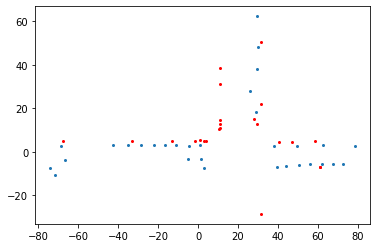

In [49]:
fnum = 396
print(frames[fnum]['car']['num_obj'])

plt.scatter(frames[fnum]['car']['label'][:,0], frames[fnum]['car']['label'][:,1], s=4)
plt.scatter(frames[fnum]['sign']['label'][:,0], frames[fnum]['sign']['label'][:,1], s=4, c='red')

In [ ]:
fnum = 396
scene_boxes = [boxpts_to_o3dbox(opd_to_boxpts(frames[fnum]['car']['label'][i])) for i in range(len(frames[fnum]['car']['label']))]
o3d.visualization.draw_geometries(scene_boxes)

In [101]:
from pathlib import Path

def get_car_model(idx, model_filelist):
    if idx == -1:
        valid_model = False
        while(not valid_model):            
            model_idx = np.random.randint(0,len(model_filelist))
            obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'
            if obj_file.exists():
                return str(obj_file)
    else:
        obj_file = Path(model_filelist[idx] + '/models/model_normalized.obj')
        if not obj_file.exists():
            raise f"{str(obj_file)} does not exist"            
        else:
            return str(obj_file)
        
        
def get_random_car(model_filelist):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = get_car_model(-1, model_filelist)
    
    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    print(obj_file)
    alpha = get_scaling_factor(model_v)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': obj_file.split('/')[-3]}
    return obj_data

car = get_random_car(models)

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.52249196 1.84603086 1.32224429]


In [104]:
def get_tmesh_with_box_labels(box_label, model_filelist):
    car = get_random_car(model_filelist)
    centroid = box_label[:3]
    yaw = box_label[-1]
    rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
    tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])
    
    ret = {'bbox': car['bbox'] @ rmat.T + centroid, 
           'mesh': tmesh, 
           'model_id': car['model_id'],
           'label': list(centroid) + list(car['dims']) + list([yaw]),
           'waymo_num_pts': int(box_label[-1])} 
    return ret

scene_cars = [get_tmesh_with_box_labels(frames[fnum]['car']['label'][i], models) for i in range(len(frames[fnum]['car']['label']))]

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.00783643 2.04414307 1.46414481]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.04802656 2.06054823 1.47589523]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.08468752 1.66732396 1.19424309]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [3.8653455  1.57779099 1.1301139 ]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.11799161 2.08910718 1.49635096]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.5344858  1.85092661 1.32575094]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/029583

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([sc['mesh'] for sc in scene_cars] + [origin])

In [63]:
def populate_scene(scene_cars, sign_labels, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2: 
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    for i, sign in enumerate(sign_labels):
        pole_height = np.random.uniform(1,4,1)
        pole_centre = sign[:3]
        pole_centre[2] = -2.4 + pole_height/2
        pole_radius = np.random.uniform(0.03,0.1)        
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene):
    centre = car['label'][:3]
    ray_pts = cast_rays_at_point(scene, centre)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'bbox': o3dbox}
    return ret

scene = populate_scene(scene_cars, frames[fnum]['sign']['label'])
res = raycast_object(scene_cars[0], scene)

In [64]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([res['ray_pts'], res['bbox'], origin])

In [300]:
o3d.visualization.draw_geometries([res['obj_pts'], res['bbox'], origin])

In [180]:
sum([frames[i]['car']['num_obj'] for i in range(len(frames))])

4712401

# Export scenes

In [1]:
from pathlib import Path
import time
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu # !pip install pypcu
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image


def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

def get_scaling_factor(obj, min_car_width=1.55, max_car_width=2.15, min_car_height=0.6):
    dims = obj['dims']    
#     print(f'{model_id} - origdims = {dims}')
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * np.asarray(obj['mesh'].vertices)
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    
def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd
    
def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 
    
    
def sample_car_model(data_dir, sampled_db, unseen_list):
    # Random sample. We pop unseen/seen after seeing all models once
    if len(unseen_list) > 0:
        db_idx = np.random.randint(0,len(unseen_list))
        model_id = unseen_list[db_idx]
        sampled_db.setdefault(model_id, 0)
        unseen_list.remove(model_id)
        
#         print(f'sampling db_idx: {db_idx}, model_id: {model_id} from {len(unseen_list)} models')
    else:
        # Get the least sampled model
        model_id = min(sampled_db, key=sampled_db.get)
#         print(f'sampling model_id: {model_id} with {sampled_db[model_id]} counts')
    
    sampled_db[model_id] += 1
    obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'    
    
    assert obj_file.exists(), f"{str(obj_file)} does not exist"    
    return str(obj_file)
        
        
def get_car_object(data_dir, sampled_db, unseen_list):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = sample_car_model(data_dir, sampled_db, unseen_list)
    model_id = obj_file.split('/')[-3]

    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    alpha = get_scaling_factor(obj)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': model_id}
    return obj_data

def get_tmeshes_with_box_labels(frame_cars, data_dir, sampled_db, unseen_list):
    if 'label' not in frame_cars:
        return []
    
    scene_cars = []
    for box_label in frame_cars['label']:

        car = get_car_object(data_dir, sampled_db, unseen_list)
        centroid = box_label[:3]
        yaw = box_label[-1]
        rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                          [-np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])
        tmesh = o3d.geometry.TriangleMesh()
        tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat + centroid)
        tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])

        ret = {'bbox': car['bbox'] @ rmat + centroid, 
               'mesh': tmesh, 
               'model_id': car['model_id'],
               'label': list(centroid) + list(car['dims']) + list([yaw]),
               'waymo_num_pts': int(box_label[-1])} 
        scene_cars.append(ret)
    return scene_cars

def opd_to_boxpts(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([[l/2, w/2, h/2],
                             [l/2, -w/2, h/2],
                             [-l/2, w/2, h/2],
                             [-l/2, -w/2, h/2],
                             [l/2, w/2, -h/2],
                             [l/2, -w/2, -h/2],
                             [-l/2, w/2, -h/2],
                             [-l/2, -w/2, -h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), np.sin(rotation), 0.0],
        [-np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    vcbox = bounding_box @ rotation_matrix
    vcbox += box[:3]
    
    return vcbox

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def populate_scene(scene_cars, signs, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2:
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    if 'label' in signs:
        sign_labels = signs['label']
        for i, sign in enumerate(sign_labels):
            pole_height = np.random.uniform(1,4,1)
            pole_centre = sign[:3]
            pole_centre[2] = -2.4 + pole_height/2
            pole_radius = np.random.uniform(0.03,0.1)        
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene, npoints):
    centre = car['label'][:3]    
    
    fov_deg = np.random.normal(120, 30)
    ray_pts = cast_rays_at_point(scene, centre, fov_deg=fov_deg, aspect_ratio=2, height_px=640)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'complete': car['mesh'].sample_points_uniformly(npoints),
           'bbox_pts': car['bbox'],
           'model_id': car['model_id'],
           'label': car['label'],
           'fov_deg':fov_deg}
    return ret

In [3]:
waymo_lidar_height = 2.4
frames = []

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frame = {}
        frame['car'] = {}
        frame['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frame['car']['label'] = car_label
        frame['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frame['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frame['sign']['label'] = sign_label
            frame['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frame['sign']['num_obj'] = len(sign_label)
        frames.append(frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [4]:
import pickle
import random

# Specifically for Shapenet.v2
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['unclean_car'] = ['a75ff576da012340468bac13e007a6e9','52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b', 'dda10fc985eea0868c368040825ed335', '471673f3f062abd473f10e6caaeca56','e2ceb9bf23b498dda7431386d9d22644','3804a264b503d5812e40b8f7ac380eb5','445185842d893b6978fe949fc1419876','95ebb3fd80f885ad676f197a68a5168a','ba89184f58f21ff63343f5fadc4a2136']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f', '433481aa8cde9b692e3dd7c278f108dd','cdfe4dc408f4ca84aaafd94b9f216ef6']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6', '501ac8493044eff04d44f5db04bf14b8','55181c34dadb4f032db09455d18fca0']
ignore['invalid_lwratio'] = ['7e7f0637d6798113ddb4014f0e8d0dac', '492a339ce5da3fe8e4b68d3b17c43658', '99fce87e4e80e053374462542bf2aa29', 'f7f7b1b4021be11afaeea7738551d104', 'bfa01c632be2eb06e8a3b392b986583', '7c85e6cf9c4f46e91cc13e432d5756b8', '6b79cfceb6f614527e7afb83f93db294', '52c589e86fd500cd4a42886683bb52d2', 'd1acd4916d3d3b57c48db2ed8f5e994c', '65d6433043c40046b82c0841410a924f', 'f4498022df553505c35f22936e5aea5c', '3c310afdf363201cefe5f291bc2f5fd0', 'c0db588c8c816cd2dc668d3d64c871ae', 'd353bf0e0dfe3ac29cbc1c09129e1507', '9f7b4a82becac9cd5568b8cbf53329df', 'e4d1edc4cda4a6445fb81d6394b59c19','c30bf6d1ae428497c7f3070d3c7b9f30', '3804a264b503d5812e40b8f7ac380eb5', 'cdfe4dc408f4ca84aaafd94b9f216ef6', '55181c34dadb4f032db09455d18fca0', '95a6e03656bdff26f69bc9777f9c3c39', '957a686c3c9f956a3d982653fc5fd75b', '88c884dd867d221984ae8a5736280c', 'ba89184f58f21ff63343f5fadc4a2136', '1c7ddd2735778013ce50f18f6100cef6', 'd05aa55f9e5b4d10afe1d4530f4c6e24', 'a3e7603c0d9ef56280e74058ee862f05', '96ca20dd7caff0bb851f021b9ed69c58', '2df225b8df2633c231141a7d4d06dc13', '781b45d3eb625148248a78e10a40d8eb', '4e488242b665d85f40bc3b36a331b786', '48260abd4ff73f99473f10e6caaeca56', '56d463162ff5352cbd835ce3c63f4d10', '189cffefcdd5cb071a126804ae24042', '36b211593bfa7c2f7f33a9b0659de0d7', '36fe332c1b11696d51a95aaa6caba1d3', '69e99923c3cbcbcca9fe1734a6086750', '346917af7c9659e3814085552234c955', 'ca93e4d0ca75ab1bafe1d4530f4c6e24', '1e987cad6ca8a97a7a24dbc42a104ca8', 'd9049f432296ed36afe1d4530f4c6e24', 'd5c046451e5bd6826a9c18480b4632cb', '3ab98667cabf774e3343f5fadc4a2136', 'dc8765720d8d3828b3cf5236f651a8e6', '5ce9ef613933a245538f2c6e5c51cc7e', 'ac7e674eb67488dcafe1d4530f4c6e24', '5e4a1ac9bdce2766473f10e6caaeca56', '8402d2237afac94a1cf6f8e565096a1e', '791e45f93e9ba58071a126804ae24042', 'f296f3a83e09de75afe1d4530f4c6e24', '307e83044ed81f6c473f10e6caaeca56']
ignore['invalid_objfile'] = ['93ce8e230939dfc230714334794526d4', '9fb1d03b22ecac5835da01f298003d56', '302612708e86efea62d2c237bfbc22ca', '806d740ca8fad5c1473f10e6caaeca56', '2307b51ca7e4a03d30714334794526d4', 'd6ee8e0a0b392f98eb96598da750ef34', 'e6c22be1a39c9b62fb403c87929e1167', '986ed07c18a2e5592a9eb0f146e94477', '407f2811c0fe4e9361c6c61410fc904b', '5bf2d7c2167755a72a9eb0f146e94477', '3ffeec4abd78c945c7c79bdb1d5fe365', 'f5bac2b133a979c573397a92d1662ba5', '3c33f9f8edc558ce77aa0b62eed1492', 'ea3f2971f1c125076c4384c3b17a86ea', '7aa9619e89baaec6d9b8dfa78596b717', '5973afc979049405f63ee8a34069b7c5', '4ddef66f32e1902d3448fdcb67fe08ff', '207e69af994efa9330714334794526d4', '8070747805908ae62a9eb0f146e94477']
ignore['invalid_whratio'] = ['8ee2dfd1460eded9473f10e6caaeca56', 'e2ceb9bf23b498dda7431386d9d22644', '4e488242b665d85f40bc3b36a331b786', '93a813f96365c108f217b9504689397', '9de10b4469cdc435afe1d4530f4c6e24', '863f9284eec4a256e9d8921ebe6d5b8e', 'b9ae3fb6b027dc4294a553cca1043426']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]

In [5]:
# We don't include trucks, buses or limos for this project
data_dir = '/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343'
model_glob = glob.glob(f'{data_dir}/*')
models = set([model.split('/')[-1] for model in model_glob])
ignore_combined = set(ignore['combined'])
models.difference_update(ignore_combined)
models = list(models)
print(len(models))

3413


In [322]:
def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

# boxdiff_list = {}
# for m in tqdm(models, total=len(models)):
#     obj = load_shapenet(str(data_dir / m / 'models/model_normalized.obj'))
#     obj['mesh'].remove_unreferenced_vertices() # for some reason shapenet has a lot of these
#     obj['mesh'].remove_degenerate_triangles()
#     obj['mesh'].remove_duplicated_vertices()
#     mpts = np.asarray(obj['mesh'].vertices)
#     mpts_gt = get_gt_for_zero_yaw(mpts)
#     pts_gt = get_gt_for_zero_yaw(obj['sampled_pts'])
#     boxdiff = np.mean(mpts_gt['bbox'] - pts_gt['bbox'])
#     if boxdiff > 0.01:
#         boxdiff_list[m] = boxdiff
#         print(f'{m}: {boxdiff:0.06f}')

In [207]:
boxdiff_list

{'1166b049a7230db9f50f5d46dfed0533': 0.046084935295115835,
 '4024c9fccd9fce80bda733a39f84326d': 0.011701626382741559,
 'e84eb770bb6cedf3bda733a39f84326d': 0.02104801777948913,
 '6749e5a1458ead5abda733a39f84326d': 0.01663871839806036,
 '3dab4ef100f906c2bda733a39f84326d': 0.013271695783511492,
 '4e9a489d830e285b59139efcde1fedcb': 0.012477240505777448,
 '5b925881cf8678cabda733a39f84326d': 0.014734571720806744,
 '9807c1d0bcec85fcc3c0146ad3ea2d7d': 0.010592844880244534,
 'e9c5e6d46c47129c5b72003cd427d0c1': 0.05031373766223651,
 'b35117b7e025a012bda733a39f84326d': 0.010379216989987736}

In [326]:
models_stem = [models[i].split('/')[-1] for i in range(len(models))]
search_idx = models_stem.index('5b925881cf8678cabda733a39f84326d')
print(search_idx)
data_dir = Path('/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343')
obj_file = str(data_dir / models[search_idx] / 'models/model_normalized.obj')
obj = load_shapenet(obj_file)
# o3d.visualization.draw_geometries([obj['mesh'].sample_points_uniformly(16384)])

831


In [327]:
obj = load_shapenet(obj_file)
# obj['mesh'].remove_unreferenced_vertices() # for some reason shapenet has a lot of these
# obj['mesh'].remove_degenerate_triangles()
# obj['mesh'].remove_duplicated_vertices()
mesh = obj['mesh']

mpts = np.asarray(mesh.vertices)
mpts_gt = get_gt_for_zero_yaw(mpts)
pts_gt = get_gt_for_zero_yaw(obj['sampled_pts'])

# num, edge = np.histogram(obj['sampled_pts'][:,2], bins='doane')
# mask = np.ones(len(edge), np.bool)
# indices = np.argwhere(num < 10)
# mask[indices+1] = 0
# zmin, zmax = min(edge[mask]), max(edge[mask])
# pts_gt['bbox'][:,2] = np.clip(pts_gt['bbox'][:,2], zmin, zmax)

mesh_bbox = boxpts_to_o3dbox(mpts_gt['bbox'])
mesh_bbox.color = [1,0,0]
pts_bbox = boxpts_to_o3dbox(pts_gt['bbox'])
pts_bbox.color = [0,0,1]


# o3d.visualization.draw_geometries([boxpts_to_o3dbox(pts_gt['bbox']), convert_to_o3dpcd(obj['sampled_pts'])])
o3d.visualization.draw_geometries([mesh_bbox, pts_bbox, mesh], mesh_show_wireframe=True)

In [325]:
def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    num, edge = np.histogram(pts[:,2], bins='doane')
    mask = np.ones(len(edge), np.bool)
    indices = np.argwhere(num < 5)
    mask[indices+1] = 0
    zmin, zmax = min(edge[mask]), max(edge[mask])
    pts[:,2] = np.clip(pts[:,2], zmin, zmax)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    centered_pts = pts - center
    
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = centered_pts
    obj['boxpts'] = get_gt_for_zero_yaw(centered_pts)['bbox']
    obj['o3dbox'] = boxpts_to_o3dbox(obj['boxpts'])
    
    # Shapenet mesh is noisy, we use the pts above to limit the shape
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    tmesh.remove_unreferenced_vertices() 
    tmesh.remove_degenerate_triangles()
    tmesh.remove_duplicated_vertices()
    
    obj['mesh'] = tmesh.crop(obj['o3dbox'])    
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

In [113]:
obj['dims']*6.55

array([5.7967178 , 2.09909566, 2.06858504])

In [111]:
2.1/obj['dims'][1]

6.552821893557257

In [93]:
np.mean(mpts_gt['bbox'] - pts_gt['bbox'])

0.008149245443046807

In [11]:
# invalid = {}
# invalid['lw_ratio'] = []
# invalid['wh_ratio'] = []

# for model in tqdm(models, total=len(models)):
#     data_dir = Path('/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343')
#     obj = load_shapenet(str(data_dir / model / 'models/model_normalized.obj'))
#     lw_ratio = obj['dims'][0]/obj['dims'][1]
#     wh_ratio = obj['dims'][1]/obj['dims'][2]
#     if lw_ratio > 3.2 or lw_ratio < 1.5:
#         print(f'{model}: lw_ratio={lw_ratio}, dims={obj["dims"]}')
#         invalid['lw_ratio'].append(model)
#     if wh_ratio < 0.75 or wh_ratio > 2.5:
#         print(f'{model}: wh_ratio={wh_ratio}, dims={obj["dims"]}')
#         invalid['wh_ratio'].append(model)

In [12]:
2730*50

136500

In [ ]:
def generate_dataset(data_dir, frames, models, dataset_name):
    min_pts = 50
    max_pts = 6000
    nviews = 30
    npoints_complete = 16384

    save_dir = Path(f'/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-{nviews}/{dataset_name}')
    save_dir.mkdir(exist_ok=True, parents=True)
    total = nviews * len(models)
    currently_exported = 0
#     t0 = time.time()
    pbar = tqdm(total=total)
    
    sampled_db = {}
    exported_db = {}
    unseen_list = models

    # Shuffle frames because there's 199 frames in one scene
    random.shuffle(frames)
    for fnum, frame in enumerate(frames):

        scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
        scene = populate_scene(scene_cars, frame['sign'])

        # Export each car in the scene and update sampling_db
        for car in scene_cars:
            data = raycast_object(car, scene, npoints_complete)
            model_id = data['model_id']            

            print(f"\n{len(data['obj_pts'].points)} pts - fov_deg: {data['fov_deg']}")
#             print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            
            if len(data['obj_pts'].points) > min_pts and len(data['obj_pts'].points) < max_pts:                
                exported_db.setdefault(model_id, 0)
                car_id = exported_db[model_id]

                if car_id >= nviews:
                    continue                
                    
                # Save object
                # Save partial, complete, labels
                partial_dir = save_dir / 'partial' / model_id
                partial_dir.mkdir(exist_ok=True, parents=True)

                complete_dir = save_dir / 'complete' / model_id
                complete_dir.mkdir(exist_ok=True, parents=True)

                label_dir = save_dir / 'label' / model_id
                label_dir.mkdir(exist_ok=True, parents=True)

                o3d.io.write_point_cloud(str(partial_dir / f'{car_id:03d}.pcd'), data['obj_pts'])
                o3d.io.write_point_cloud(str(complete_dir / f'{car_id:03d}.pcd'), data['complete'])
                with open(str(label_dir / f'{car_id:03d}.pkl'), 'wb') as f:
                    label = {'bbox_pts': data['bbox_pts'], 
                             'gtbox': data['label'],
                             'pc_id': f'{model_id}_{car_id:03d}',
                             'raycasting': data['fov_deg']}
                    pickle.dump(label, f)

                currently_exported += 1
                exported_db[model_id] += 1
                
#                 print(f'model_id: {model_id} => num exported {exported_db[model_id]}')                
                print(f'{currently_exported}/{total} objects exported')
#                 avg_time = (time.time() - t0)/currently_exported
#                 print(f'{avg_time:0.3f}s/it, {(avg_time * total - (time.time()-t0))/60:0.4}min est. time remaining')
                pbar.update(1)
                
                if currently_exported >= total:
                    print(f'{currently_exported} objects exported')                    
                    return
            else:
                counts = sampled_db[model_id]
                sampled_db[model_id] = max(counts - 1, 0)
                if sampled_db[model_id] == 0:
                    print(f'adding {model_id} back to unseen')
                    unseen_list.append(model_id)
                    
#                 print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
    pbar.close()
generate_dataset(data_dir, frames, models[:int(3413*0.8)], dataset_name='train')



  0%|                                                     | 0/81900 [00:00<?, ?it/s]

  0%|                                         | 1/81900 [00:18<430:15:43, 18.91s/it]


8 pts - fov_deg: 151.2086360457144
adding 42af1d5d3b2524003e241901f2025878 back to unseen

6 pts - fov_deg: 135.11405972788958
adding 1688bcda878d3b18afe717997470b28d back to unseen

65 pts - fov_deg: 100.1836651970894
1/81900 objects exported




  0%|                                         | 3/81900 [00:19<301:41:21, 13.26s/it]


86 pts - fov_deg: 136.36658783836992
2/81900 objects exported

91 pts - fov_deg: 99.27872563978673
3/81900 objects exported

4921 pts - fov_deg: 77.0527256356124
4/81900 objects exported




  0%|                                         | 5/81900 [00:19<212:29:32,  9.34s/it]


7 pts - fov_deg: 137.058876612225
adding 894e186c1224c14f86590219e6a70ff0 back to unseen

17 pts - fov_deg: 131.16362472045773
adding a6842a04cef3e5ce69a949ac99a843c4 back to unseen

52 pts - fov_deg: 55.56691071828686
5/81900 objects exported




  0%|                                         | 7/81900 [00:19<149:16:11,  6.56s/it]


433 pts - fov_deg: 101.95442472579214
6/81900 objects exported

65 pts - fov_deg: 154.44301664365446
7/81900 objects exported

147 pts - fov_deg: 97.4499303368012
8/81900 objects exported




  0%|                                         | 9/81900 [00:19<104:59:15,  4.62s/it]


172 pts - fov_deg: 109.24867574394383
9/81900 objects exported

8 pts - fov_deg: 159.61094706957198
adding 51048ab1eeca5e8dee79ed7216eaef91 back to unseen

8 pts - fov_deg: 129.32542143751795
adding 85914342038de6f160190e29962cb3e7 back to unseen




  0%|                                         | 10/81900 [00:20<75:12:28,  3.31s/it]


120 pts - fov_deg: 100.74267161142095
10/81900 objects exported

26 pts - fov_deg: 124.11629050511866
adding f88b4156c5e8d35ff500cc506a763c18 back to unseen

1 pts - fov_deg: 171.2463026927477
adding 832a8f6cfe462e48402013bef9b89b74 back to unseen




  0%|                                         | 11/81900 [00:20<54:14:51,  2.38s/it]


1995 pts - fov_deg: 87.00310418593341
11/81900 objects exported

283 pts - fov_deg: 142.31904501929492
12/81900 objects exported

8 pts - fov_deg: 75.80448402977296
adding eda96319f9f01f998496c87dd2a4075e back to unseen

3 pts - fov_deg: 139.85612427635635
adding cf698011f90ac05f253c03b7df20edd5 back to unseen

49 pts - fov_deg: 91.3761863439501
adding 63f6a2c7ee7c667ba0b677182d16c198 back to unseen

50 pts - fov_deg: 112.02599436040956
adding 535f244d5b6043e8cbc76a30015552a back to unseen




  0%|                                         | 13/81900 [00:20<39:39:20,  1.74s/it]

  0%|                                         | 14/81900 [00:20<28:42:51,  1.26s/it]


179 pts - fov_deg: 116.82068121296504
13/81900 objects exported

62 pts - fov_deg: 114.5248693150326
14/81900 objects exported




  0%|                                         | 15/81900 [00:20<20:51:10,  1.09it/s]


415 pts - fov_deg: 89.2542586125085
15/81900 objects exported

5 pts - fov_deg: 121.55375927208311
adding 29b714c4aee36c9d6108f064aff2426d back to unseen

26 pts - fov_deg: 143.44315551726933
adding b8f6994a33f4f1adbda733a39f84326d back to unseen




  0%|                                         | 16/81900 [00:21<17:22:13,  1.31it/s]


2 pts - fov_deg: 168.0070059739883
adding ddd17a0d7ca713f2291ea03049d40375 back to unseen

13 pts - fov_deg: 150.68879120432155
adding 1c3c8952b92d567e61c6c61410fc904b back to unseen

95 pts - fov_deg: 118.34787992659733
16/81900 objects exported




  0%|                                         | 18/81900 [00:21<12:47:43,  1.78it/s]


739 pts - fov_deg: 133.45576620161614
17/81900 objects exported

207 pts - fov_deg: 104.90925219972847
18/81900 objects exported

7 pts - fov_deg: 170.11603027214275
adding 83fb99fe62dab5308b55a52bfd1cce7a back to unseen




  0%|                                         | 19/81900 [00:21<10:07:16,  2.25it/s]


1134 pts - fov_deg: 75.09149972085388
19/81900 objects exported

16240 pts - fov_deg: 146.68276698266354
adding 8e2f0f7f5ca505b56227cba038bf7c95 back to unseen

6 pts - fov_deg: 172.5950275358412
adding e738466fb6cc90530714334794526d4 back to unseen

0 pts - fov_deg: 177.76085950647246
adding 81af904b941c47abccf0883afcbd4b76 back to unseen

22 pts - fov_deg: 137.23295924371786
adding ee5e6649db524dc2eb22840c40c3154b back to unseen




  0%|                                         | 20/81900 [00:29<62:48:41,  2.76s/it]


428 pts - fov_deg: 120.3614587842901
20/81900 objects exported

48 pts - fov_deg: 124.96807262848002
adding 5a9cb2d24a3591aa27fda8a7465c0e0b back to unseen

13393 pts - fov_deg: 95.00926339054541
adding 6201a29763c2256a2bb5796f842ca661 back to unseen




  0%|                                         | 21/81900 [00:30<47:26:41,  2.09s/it]


43 pts - fov_deg: 123.70055130000208
adding e9c5e6d46c47129c5b72003cd427d0c1 back to unseen

718 pts - fov_deg: 106.83630844865208
21/81900 objects exported




  0%|                                         | 22/81900 [00:30<35:09:57,  1.55s/it]


169 pts - fov_deg: 120.51773268622661
22/81900 objects exported

36 pts - fov_deg: 157.32330303931738
adding f87f654f056b3679f4103381793c29f7 back to unseen




  0%|                                         | 23/81900 [00:30<26:26:21,  1.16s/it]


320 pts - fov_deg: 143.65903316487595
23/81900 objects exported

0 pts - fov_deg: 184.25444804708056
adding 7c44aa72f314ee8e634b31c394824611 back to unseen




  0%|                                        | 24/81900 [00:53<175:16:26,  7.71s/it]


217 pts - fov_deg: 122.47132185593522
24/81900 objects exported

18 pts - fov_deg: 160.3754043083512
adding bc587f9680c5ea9b58be2d1dec5d09d7 back to unseen




  0%|                                        | 25/81900 [00:54<124:28:00,  5.47s/it]


1082 pts - fov_deg: 59.107386814013495
25/81900 objects exported

23 pts - fov_deg: 169.9259668640731
adding abd0aa2e0ca4fc4793249f89773e858 back to unseen




  0%|                                         | 26/81900 [00:54<90:26:17,  3.98s/it]


26 pts - fov_deg: 129.36851834344668
adding 1137cd58d6a45c6659a47b1880958de9 back to unseen

283 pts - fov_deg: 137.05084659130804
26/81900 objects exported




  0%|                                         | 27/81900 [00:54<64:18:03,  2.83s/it]


117 pts - fov_deg: 132.69929589241903
27/81900 objects exported

37 pts - fov_deg: 117.72195394674023
adding 7c13a71834d2b97687cc3b689b9b258d back to unseen




  0%|                                         | 28/81900 [00:55<47:19:27,  2.08s/it]


854 pts - fov_deg: 129.32230988004864
28/81900 objects exported




  0%|                                         | 29/81900 [00:55<35:06:53,  1.54s/it]


0 pts - fov_deg: 179.7199578281919
adding ebe05fb264a56628d7ef29ade0716b6c back to unseen

127 pts - fov_deg: 92.7168585691495
29/81900 objects exported




  0%|                                         | 30/81900 [00:55<25:52:41,  1.14s/it]

  0%|                                         | 32/81900 [00:55<18:46:26,  1.21it/s]


472 pts - fov_deg: 82.93472550830585
30/81900 objects exported

111 pts - fov_deg: 125.99378167320172
31/81900 objects exported

1516 pts - fov_deg: 117.14907713170936
32/81900 objects exported




  0%|                                         | 33/81900 [00:56<14:09:25,  1.61it/s]

  0%|                                         | 34/81900 [00:56<10:59:35,  2.07it/s]


3383 pts - fov_deg: 72.0324588102974
33/81900 objects exported

545 pts - fov_deg: 108.09788680234495
34/81900 objects exported




  0%|                                         | 35/81900 [00:56<10:12:54,  2.23it/s]


0 pts - fov_deg: 169.65477678442969
adding 87918f9d328b535befe5f291bc2f5fd0 back to unseen

138 pts - fov_deg: 126.66898493496356
35/81900 objects exported




  0%|                                          | 36/81900 [00:56<8:09:44,  2.79it/s]

  0%|                                          | 37/81900 [00:56<6:56:02,  3.28it/s]


1296 pts - fov_deg: 89.15827097760062
36/81900 objects exported

307 pts - fov_deg: 107.31191820807999
37/81900 objects exported

155 pts - fov_deg: 134.96693321882327
38/81900 objects exported




  0%|                                          | 39/81900 [00:57<6:58:23,  3.26it/s]


38 pts - fov_deg: 124.348361327525
adding d8879578d668b458cf899c77ac8ff2f4 back to unseen

8 pts - fov_deg: 156.39688329638005
adding 7d4fd8ed77355364fa98472c1d231070 back to unseen

1099 pts - fov_deg: 82.68040681050883
39/81900 objects exported




  0%|                                          | 40/81900 [00:57<5:52:03,  3.88it/s]


348 pts - fov_deg: 144.17597682038777
40/81900 objects exported




  0%|                                          | 41/81900 [00:57<5:58:14,  3.81it/s]


488 pts - fov_deg: 129.00411491154128
41/81900 objects exported

19 pts - fov_deg: 149.1761017856828
adding a4b793df04e3bdb11fed6082009db27d back to unseen

57676 pts - fov_deg: 126.43156550860661
adding 44f30f4c65c3142a16abce8cb03e7794 back to unseen

0 pts - fov_deg: 184.58424023447418
adding c487e9850891e1ec2d15396b7bcc6366 back to unseen




  0%|                                         | 42/81900 [00:58<10:52:36,  2.09it/s]


40 pts - fov_deg: 138.7020201309264
adding 3b800720bd8d41657810f4dc287137e0 back to unseen

241 pts - fov_deg: 128.9023005541864
42/81900 objects exported




  0%|                                         | 43/81900 [00:59<10:03:51,  2.26it/s]


14 pts - fov_deg: 193.98354521159013
adding adda68ed2da5cee0a413908c0e169330 back to unseen

456 pts - fov_deg: 110.33828377769737
43/81900 objects exported

1 pts - fov_deg: 162.27883928042957
adding 2a887d0b865d8ab4dfb921b4cd0b4571 back to unseen




  0%|                                        | 44/81900 [01:32<233:39:31, 10.28s/it]


244 pts - fov_deg: 119.55377143715953
44/81900 objects exported




  0%|                                        | 45/81900 [01:32<165:24:05,  7.27s/it]

  0%|                                        | 46/81900 [01:32<116:51:42,  5.14s/it]


1562 pts - fov_deg: 96.00617936427895
45/81900 objects exported

1006 pts - fov_deg: 114.4752898518738
46/81900 objects exported

11 pts - fov_deg: 193.64556432965668
adding 6026684ab31d567328044fe9244db50a back to unseen

39 pts - fov_deg: 141.6306923407048
adding b6525d69681e4f56813498cc26c2aee back to unseen




  0%|                                         | 47/81900 [01:33<86:10:59,  3.79s/it]


62 pts - fov_deg: 122.57001576407178
47/81900 objects exported

110080 pts - fov_deg: 66.82415974517205
adding 44eb9496921072b6e5f9082491d52810 back to unseen

2 pts - fov_deg: 169.87111174544418
adding fe1ec9b9ff75e947d56a18f240de5e54 back to unseen

12 pts - fov_deg: 116.4249301939627
adding bb9109ffb1789e98e55e3289e5df0916 back to unseen




  0%|                                         | 48/81900 [01:34<66:23:09,  2.92s/it]


1500 pts - fov_deg: 125.51285734191725
48/81900 objects exported




  0%|                                         | 49/81900 [01:34<47:51:36,  2.10s/it]

  0%|                                         | 50/81900 [01:34<34:48:53,  1.53s/it]


779 pts - fov_deg: 105.62357320113652
49/81900 objects exported

87 pts - fov_deg: 108.7460431000838
50/81900 objects exported




  0%|                                         | 51/81900 [01:35<25:46:03,  1.13s/it]


60 pts - fov_deg: 148.07489504532742
51/81900 objects exported

53049 pts - fov_deg: 102.21661065649062
adding 613bf2e7f987553220d9307ef0bda318 back to unseen

38 pts - fov_deg: 154.61407710607423
adding 163786646ae2578749a5fc144a874235 back to unseen




  0%|                                         | 52/81900 [01:35<23:14:25,  1.02s/it]


20 pts - fov_deg: 144.08376033521213
adding 9375ded98380ccc77bbf13cb42ad9d73 back to unseen

101 pts - fov_deg: 128.19393366371858
52/81900 objects exported




  0%|                                         | 53/81900 [01:36<19:06:55,  1.19it/s]


2059 pts - fov_deg: 97.41695382871876
53/81900 objects exported




  0%|                                         | 54/81900 [01:36<15:07:13,  1.50it/s]


583 pts - fov_deg: 126.34498681331476
54/81900 objects exported




  0%|                                         | 55/81900 [01:36<12:08:35,  1.87it/s]

  0%|                                          | 56/81900 [01:36<9:29:23,  2.40it/s]


853 pts - fov_deg: 134.44063546778315
55/81900 objects exported

371 pts - fov_deg: 135.86116696930995
56/81900 objects exported




  0%|                                          | 57/81900 [01:37<9:43:25,  2.34it/s]


31 pts - fov_deg: 134.42878468137806
adding cd85df142f1999e5f38ed4497f2c53c back to unseen

412 pts - fov_deg: 116.01591687546119
57/81900 objects exported




  0%|                                          | 58/81900 [01:37<8:15:05,  2.76it/s]


441 pts - fov_deg: 115.56203726386906
58/81900 objects exported




  0%|                                          | 59/81900 [01:37<7:49:58,  2.90it/s]


326 pts - fov_deg: 108.8436457958742
59/81900 objects exported




  0%|                                          | 60/81900 [01:38<7:51:30,  2.89it/s]


24 pts - fov_deg: 169.66388014881778
adding 2f2ed1fa349d50f3bb15a692385994d1 back to unseen

1171 pts - fov_deg: 85.7687070197164
60/81900 objects exported

40 pts - fov_deg: 135.13969752530681
adding 8798825a3c68e5c7e0470509f60266ee back to unseen




  0%|                                          | 61/81900 [01:38<8:56:58,  2.54it/s]


613 pts - fov_deg: 97.2541279681248
61/81900 objects exported




  0%|                                          | 62/81900 [01:38<7:41:20,  2.96it/s]


128 pts - fov_deg: 137.6941233493004
62/81900 objects exported




  0%|                                          | 63/81900 [01:39<6:54:59,  3.29it/s]

  0%|                                          | 64/81900 [01:39<6:02:03,  3.77it/s]


103 pts - fov_deg: 98.86675733326061
63/81900 objects exported

3220 pts - fov_deg: 143.07665685923007
64/81900 objects exported




  0%|                                          | 65/81900 [01:39<6:15:15,  3.63it/s]


326 pts - fov_deg: 116.47763404299549
65/81900 objects exported

2 pts - fov_deg: 165.82496823628546
adding 490812763fa965b8473f10e6caaeca56 back to unseen




  0%|                                          | 66/81900 [01:39<6:36:49,  3.44it/s]


198 pts - fov_deg: 135.26503874656538
66/81900 objects exported




  0%|                                          | 67/81900 [01:40<6:01:08,  3.78it/s]


174 pts - fov_deg: 101.77461750843489
67/81900 objects exported

6 pts - fov_deg: 150.71139853021694
adding e9c2c31da871e0d6c203986ffbbb5e4a back to unseen




  0%|                                          | 68/81900 [01:40<7:03:12,  3.22it/s]


2968 pts - fov_deg: 102.00295631392989
68/81900 objects exported




  0%|                                          | 69/81900 [01:40<6:32:26,  3.48it/s]


4344 pts - fov_deg: 128.298864384577
69/81900 objects exported

80062 pts - fov_deg: 63.5779720296365
adding 79aafe31e4f2677b1f0fdc8ac183f8b back to unseen




  0%|                                         | 70/81900 [01:41<10:20:44,  2.20it/s]


61 pts - fov_deg: 124.61389628855684
70/81900 objects exported




  0%|                                          | 71/81900 [01:41<9:30:32,  2.39it/s]


68 pts - fov_deg: 100.69018334812344
71/81900 objects exported




  0%|                                          | 72/81900 [01:42<8:28:00,  2.68it/s]


275 pts - fov_deg: 90.78522041897828
72/81900 objects exported

132 pts - fov_deg: 147.58269667193676
73/81900 objects exported

35 pts - fov_deg: 103.90118866617385
adding 380e0c29c9ea00e9ce158c6cc0278580 back to unseen

5 pts - fov_deg: 169.02670024571668
adding 7d4fd8ed77355364fa98472c1d231070 back to unseen




  0%|                                          | 74/81900 [01:42<8:17:49,  2.74it/s]


52 pts - fov_deg: 196.9416867172893
74/81900 objects exported




  0%|                                          | 75/81900 [01:43<7:43:28,  2.94it/s]

  0%|                                          | 76/81900 [01:43<6:07:32,  3.71it/s]


271 pts - fov_deg: 98.53904900068326
75/81900 objects exported

322 pts - fov_deg: 118.43265470357466
76/81900 objects exported




  0%|                                          | 77/81900 [01:43<5:41:13,  4.00it/s]


393 pts - fov_deg: 110.81736676056401
77/81900 objects exported

1106 pts - fov_deg: 120.83431714766115
78/81900 objects exported




  0%|                                          | 79/81900 [01:43<4:41:56,  4.84it/s]


543 pts - fov_deg: 112.36325823699859
79/81900 objects exported

40 pts - fov_deg: 127.89962090489651
adding a6fe523f0ef082a2715e04edb8af9c53 back to unseen




  0%|                                          | 80/81900 [01:44<5:53:44,  3.85it/s]


56 pts - fov_deg: 119.31665373782654
80/81900 objects exported

5 pts - fov_deg: 158.4571113826976
adding eb1d1ac801d6bafbf949c235bf4afe6e back to unseen

7128 pts - fov_deg: 65.43441334508314
adding c43b1ebad0ba016a7fd25564c2e888e back to unseen

45 pts - fov_deg: 128.7404926343733
adding 61645b21c344e22a65dc1e664bdf2e6b back to unseen

25 pts - fov_deg: 155.3568475256953
adding a4548c56bea7f927ad02214e86fd5091 back to unseen

7467 pts - fov_deg: 76.18656920643426
adding e3dff7195a2026dba4db43fa521d5c03 back to unseen




  0%|                                         | 81/81900 [01:45<11:42:52,  1.94it/s]


302 pts - fov_deg: 101.71174942044834
81/81900 objects exported




  0%|                                         | 82/81900 [01:45<10:45:08,  2.11it/s]

  0%|                                          | 83/81900 [01:45<8:33:51,  2.65it/s]


91 pts - fov_deg: 112.97971922237457
82/81900 objects exported

2579 pts - fov_deg: 72.87119467103605
83/81900 objects exported




  0%|                                          | 84/81900 [01:45<6:42:54,  3.38it/s]


276 pts - fov_deg: 118.3597400478344
84/81900 objects exported

49 pts - fov_deg: 152.0819254922115
adding 96c404939bdba58331ec7db1bc2ab2b4 back to unseen

6 pts - fov_deg: 149.33579469471994
adding 8498fb254e1669faaaafd94b9f216ef6 back to unseen




  0%|                                        | 85/81900 [02:00<103:21:15,  4.55s/it]

  0%|                                         | 86/81900 [02:00<73:23:44,  3.23s/it]


209 pts - fov_deg: 129.04622577248958
85/81900 objects exported

7 pts - fov_deg: 169.19046947415816
adding d060adfab4c02ec616abce8cb03e7794 back to unseen

351 pts - fov_deg: 109.75434168515794
86/81900 objects exported




  0%|                                         | 87/81900 [02:00<52:15:16,  2.30s/it]


829 pts - fov_deg: 69.94976773619624
87/81900 objects exported

32 pts - fov_deg: 88.85828997263913
adding 2a887d0b865d8ab4dfb921b4cd0b4571 back to unseen




  0%|                                         | 88/81900 [02:00<37:56:29,  1.67s/it]

  0%|                                         | 90/81900 [02:00<27:13:43,  1.20s/it]


64 pts - fov_deg: 134.50407804347554
88/81900 objects exported

174 pts - fov_deg: 101.55606129398656
89/81900 objects exported

70 pts - fov_deg: 132.28612889947152
90/81900 objects exported




  0%|                                         | 91/81900 [02:01<20:25:05,  1.11it/s]


40 pts - fov_deg: 129.89346686760146
adding d0e68e14e8012b497d6d702dc488f23a back to unseen

273 pts - fov_deg: 125.71482492170048
91/81900 objects exported




  0%|                                         | 92/81900 [02:01<15:10:48,  1.50it/s]


230 pts - fov_deg: 121.37292316885784
92/81900 objects exported

348 pts - fov_deg: 101.35077949185322
93/81900 objects exported




  0%|                                         | 94/81900 [02:01<11:26:15,  1.99it/s]

  0%|                                          | 95/81900 [02:01<8:46:04,  2.59it/s]


794 pts - fov_deg: 75.89970693154929
94/81900 objects exported

1550 pts - fov_deg: 81.37706009609741
95/81900 objects exported

92 pts - fov_deg: 121.97905624802884
96/81900 objects exported




  0%|                                          | 97/81900 [02:01<6:38:34,  3.42it/s]


259 pts - fov_deg: 128.59807872185792
97/81900 objects exported

76 pts - fov_deg: 154.13540355454177
98/81900 objects exported




  0%|                                          | 99/81900 [02:02<5:23:41,  4.21it/s]

  0%|                                         | 100/81900 [02:02<4:55:48,  4.61it/s]


179 pts - fov_deg: 116.30305143156855
99/81900 objects exported

5029 pts - fov_deg: 56.902676359403316
100/81900 objects exported




  0%|                                         | 101/81900 [02:02<4:54:05,  4.64it/s]

  0%|                                         | 102/81900 [02:02<4:10:29,  5.44it/s]


0 pts - fov_deg: 183.0629763206676
adding 95d36965fc6d1f7de2d4c157e5bf1dde back to unseen

89 pts - fov_deg: 116.20279411114802
101/81900 objects exported

374 pts - fov_deg: 84.9597944549017
102/81900 objects exported




  0%|                                         | 103/81900 [02:02<4:22:27,  5.19it/s]


45 pts - fov_deg: 111.02181265292496
adding bd29875d6aa7be1b2a80b185a779af6c back to unseen

60 pts - fov_deg: 126.04243344637428
103/81900 objects exported




  0%|                                       | 104/81900 [02:35<226:12:33,  9.96s/it]


3995 pts - fov_deg: 90.02042948515223
104/81900 objects exported




  0%|                                       | 105/81900 [02:35<160:50:16,  7.08s/it]


857 pts - fov_deg: 98.53224700732983
105/81900 objects exported




  0%|                                       | 106/81900 [02:36<114:23:21,  5.03s/it]


55 pts - fov_deg: 121.8002862165887
106/81900 objects exported




  0%|                                        | 107/81900 [02:36<82:35:34,  3.64s/it]


1300 pts - fov_deg: 106.29373284504476
107/81900 objects exported

26 pts - fov_deg: 133.73494863161724
adding 86aedfff061c5b96f500cc506a763c18 back to unseen




  0%|                                        | 108/81900 [02:37<62:04:10,  2.73s/it]


122 pts - fov_deg: 81.97135144898132
108/81900 objects exported

4 pts - fov_deg: 195.20198434906052
adding dee83e7ab66cd504d88da0963249578d back to unseen




  0%|                                        | 109/81900 [02:37<48:20:52,  2.13s/it]


713 pts - fov_deg: 90.6232729357093
109/81900 objects exported




  0%|                                        | 110/81900 [02:38<37:11:45,  1.64s/it]


6 pts - fov_deg: 138.9833762341549
adding 30f0ba361010ea11e66cabd11ba41eae back to unseen

1365 pts - fov_deg: 114.6913776668105
110/81900 objects exported




  0%|                                        | 111/81900 [02:38<27:11:32,  1.20s/it]


84 pts - fov_deg: 141.15791851126778
111/81900 objects exported

0 pts - fov_deg: 159.01077304146554
adding f1b928427f5a3a7fc6d5ebddbbbc39f back to unseen




  0%|                                        | 112/81900 [02:38<21:28:34,  1.06it/s]


929 pts - fov_deg: 111.65206599769832
112/81900 objects exported

0 pts - fov_deg: 186.5350394071076
adding a015b428cf628af3522dcdfaad316d22 back to unseen




  0%|                                        | 113/81900 [02:39<17:56:07,  1.27it/s]


741 pts - fov_deg: 86.93682349817497
113/81900 objects exported

21347 pts - fov_deg: 134.05397293582828
adding 45953aa831508fb51e0d92ae9d1b10cb back to unseen




  0%|                                        | 114/81900 [02:39<14:38:55,  1.55it/s]


71 pts - fov_deg: 168.60933194479458
114/81900 objects exported




  0%|                                        | 115/81900 [02:39<12:24:15,  1.83it/s]


38 pts - fov_deg: 107.90952669209491
adding 8e764c26b9d6fe15cc2825da82c7ac3b back to unseen

298 pts - fov_deg: 86.58968032932557
115/81900 objects exported




  0%|                                         | 116/81900 [02:40<9:39:31,  2.35it/s]

  0%|                                         | 117/81900 [02:40<7:26:34,  3.05it/s]


197 pts - fov_deg: 88.55969592665527
116/81900 objects exported

1240 pts - fov_deg: 44.462294357476566
117/81900 objects exported

95 pts - fov_deg: 121.60164270349294
118/81900 objects exported

13746 pts - fov_deg: 78.79015333042548
adding 11d1fdaedf3ab83b8fb28f8a689c8ba3 back to unseen




  0%|                                         | 119/81900 [02:40<7:54:21,  2.87it/s]


4363 pts - fov_deg: 135.1594990663223
119/81900 objects exported




  0%|                                         | 120/81900 [02:41<6:58:44,  3.25it/s]


219 pts - fov_deg: 101.27113128494936
120/81900 objects exported




  0%|                                         | 121/81900 [02:41<6:27:16,  3.52it/s]


286 pts - fov_deg: 107.92179918143917
121/81900 objects exported

5 pts - fov_deg: 178.50847197120754
adding fe2ce22107693354f1cc1cb691702a23 back to unseen

50 pts - fov_deg: 136.54781102409652
adding 3dddc113e114b64a63b716db3275cef8 back to unseen




  0%|                                        | 122/81900 [02:42<10:33:45,  2.15it/s]


1509 pts - fov_deg: 81.80560305348821
122/81900 objects exported




  0%|                                         | 123/81900 [02:42<9:20:41,  2.43it/s]


845 pts - fov_deg: 107.40242270376888
123/81900 objects exported

13 pts - fov_deg: 160.1761228717738
adding 1be81460e620aea65cde8c99e4b182f9 back to unseen




  0%|                                         | 124/81900 [02:42<8:41:06,  2.62it/s]


158 pts - fov_deg: 122.22087346563264
124/81900 objects exported




  0%|                                         | 125/81900 [02:43<8:25:27,  2.70it/s]


1083 pts - fov_deg: 93.99570246006463
125/81900 objects exported




  0%|                                         | 126/81900 [02:43<9:01:05,  2.52it/s]


5 pts - fov_deg: 165.50467503717996
adding 38ddc240001c3bd147a34c33abd32f7e back to unseen

68 pts - fov_deg: 129.925783528997
126/81900 objects exported




  0%|                                         | 127/81900 [02:44<9:53:27,  2.30it/s]


414 pts - fov_deg: 101.70676422991905
127/81900 objects exported

7 pts - fov_deg: 107.37904718220247
adding 425ba801e904cb50f3aaed7e86215c7b back to unseen




  0%|                                        | 128/81900 [02:44<12:06:28,  1.88it/s]


1189 pts - fov_deg: 80.58802942822808
128/81900 objects exported

10 pts - fov_deg: 116.72474728033974
adding 3220cc9f67cd763af63ee8a34069b7c5 back to unseen

8825 pts - fov_deg: 45.784146050645035
adding 808e19aed606f10cf919864ecec729ac back to unseen




  0%|                                        | 129/81900 [02:45<15:24:11,  1.47it/s]


377 pts - fov_deg: 110.50600120727437
129/81900 objects exported




  0%|                                        | 130/81900 [02:46<13:05:47,  1.73it/s]


66 pts - fov_deg: 131.72953982931278
130/81900 objects exported

27 pts - fov_deg: 144.98085549659794
adding 8053e014516531ddc3f500d7b182f6 back to unseen




  0%|                                        | 131/81900 [02:46<12:58:02,  1.75it/s]


117 pts - fov_deg: 122.22604752476086
131/81900 objects exported

1 pts - fov_deg: 121.55638413081039
adding 8976e05f72b43a742a9eb0f146e94477 back to unseen




  0%|                                        | 132/81900 [02:47<10:43:59,  2.12it/s]


188 pts - fov_deg: 170.7488910004594
132/81900 objects exported

12644 pts - fov_deg: 119.79694826225497
adding 5c4bb9e23c6cd8511371f3c322b54f2c back to unseen




  0%|                                        | 133/81900 [02:47<10:27:54,  2.17it/s]


51 pts - fov_deg: 143.38469204024923
133/81900 objects exported




  0%|                                        | 134/81900 [02:55<64:54:22,  2.86s/it]


4751 pts - fov_deg: 68.75962936085318
134/81900 objects exported




  0%|                                        | 135/81900 [02:56<48:08:29,  2.12s/it]


30669 pts - fov_deg: 74.91837589423525
adding dce6f59b6ab987d4bc863bdef4e7bdac back to unseen

101 pts - fov_deg: 110.02613150700725
135/81900 objects exported




  0%|                                        | 136/81900 [02:56<34:48:15,  1.53s/it]

  0%|                                        | 137/81900 [02:56<25:16:49,  1.11s/it]


2943 pts - fov_deg: 56.93883677126875
136/81900 objects exported

3197 pts - fov_deg: 105.2437013928257
137/81900 objects exported




  0%|                                        | 138/81900 [02:56<18:35:44,  1.22it/s]

  0%|                                        | 139/81900 [02:56<14:21:38,  1.58it/s]


75 pts - fov_deg: 110.34414208591781
138/81900 objects exported

87 pts - fov_deg: 97.62955732383705
139/81900 objects exported




  0%|                                        | 140/81900 [02:57<10:59:27,  2.07it/s]


855 pts - fov_deg: 126.52062000291855
140/81900 objects exported

19867 pts - fov_deg: 93.08085736415838
adding 14ab7a48f51bfe69597505fd7d99b613 back to unseen




  0%|                                        | 141/81900 [02:57<11:28:02,  1.98it/s]


10589 pts - fov_deg: 104.57750915626069
adding a13fa4cf0dfdd5b58f7f0d2c9c57704b back to unseen

780 pts - fov_deg: 137.68514822893994
141/81900 objects exported




  0%|                                         | 142/81900 [02:57<9:14:43,  2.46it/s]

  0%|                                         | 143/81900 [02:58<7:40:21,  2.96it/s]


458 pts - fov_deg: 73.08017878055469
142/81900 objects exported

2207 pts - fov_deg: 111.44368073356362
143/81900 objects exported




  0%|                                         | 144/81900 [02:58<7:11:05,  3.16it/s]


783 pts - fov_deg: 97.31277080322559
144/81900 objects exported

48 pts - fov_deg: 147.41517836260584
adding 7bf6249a031b5095ddd41159baaa3ad5 back to unseen

11014 pts - fov_deg: 98.07384478752606
adding 83098846c82db490a00a2bd11cd80551 back to unseen

30 pts - fov_deg: 140.42481335484982
adding 18a9275b78be4b9ec6d3267fc5334296 back to unseen




  0%|                                       | 145/81900 [03:22<171:33:24,  7.55s/it]


8 pts - fov_deg: 140.68120043693233
adding ae1c1141ce4bfde9d66a73de5847ea37 back to unseen

950 pts - fov_deg: 99.10749632483784
145/81900 objects exported




  0%|                                       | 146/81900 [03:22<121:17:10,  5.34s/it]

  0%|                                        | 147/81900 [03:23<85:49:13,  3.78s/it]


623 pts - fov_deg: 79.66572023827405
146/81900 objects exported

3946 pts - fov_deg: 119.9560716152264
147/81900 objects exported




  0%|                                        | 148/81900 [03:23<61:16:28,  2.70s/it]


55 pts - fov_deg: 154.40595683226792
148/81900 objects exported




  0%|                                        | 149/81900 [03:23<44:24:26,  1.96s/it]


671 pts - fov_deg: 104.24796807328215
149/81900 objects exported

3 pts - fov_deg: 185.19108317623488
adding a886262ac3be5ca7c126a452758c84e7 back to unseen




  0%|                                        | 150/81900 [03:23<32:58:20,  1.45s/it]


4487 pts - fov_deg: 135.88283391905563
150/81900 objects exported

17 pts - fov_deg: 132.94091346524732
adding a2179820a01ca67f1a144f5cf9567bf5 back to unseen




  0%|                                        | 151/81900 [03:23<24:43:21,  1.09s/it]


564 pts - fov_deg: 199.49684154260953
151/81900 objects exported




  0%|                                        | 152/81900 [03:24<19:04:24,  1.19it/s]

  0%|                                        | 153/81900 [03:24<14:05:40,  1.61it/s]


475 pts - fov_deg: 74.85942257659013
152/81900 objects exported

95 pts - fov_deg: 156.25644384084774
153/81900 objects exported




  0%|                                        | 154/81900 [03:24<11:43:08,  1.94it/s]


1 pts - fov_deg: 173.55245484253118
adding 1c351358afff1cc582e5e3e7771ea25 back to unseen

404 pts - fov_deg: 118.17283486360122
154/81900 objects exported




  0%|                                         | 155/81900 [03:24<9:34:17,  2.37it/s]

  0%|                                         | 156/81900 [03:24<7:59:02,  2.84it/s]


441 pts - fov_deg: 102.45102998596272
155/81900 objects exported

1734 pts - fov_deg: 135.2812757084193
156/81900 objects exported




  0%|                                         | 157/81900 [03:25<6:37:46,  3.43it/s]

  0%|                                         | 158/81900 [03:25<5:37:21,  4.04it/s]


436 pts - fov_deg: 140.42626104266714
157/81900 objects exported

82 pts - fov_deg: 126.63514095318092
158/81900 objects exported




  0%|                                         | 159/81900 [03:25<5:07:32,  4.43it/s]


173 pts - fov_deg: 119.96639100016786
159/81900 objects exported

0 pts - fov_deg: 118.54212546934036
adding 7a756a1c54cd3a5a1b3611fc576bceff back to unseen




  0%|                                         | 160/81900 [03:25<5:02:14,  4.51it/s]


1475 pts - fov_deg: 205.6788818205605
160/81900 objects exported

6938 pts - fov_deg: 84.66189102845173
adding 269676546548fba38e271c56304de147 back to unseen

3 pts - fov_deg: 166.78143710210878
adding 99cc91ea3f0b646be79303516c6edeef back to unseen




  0%|                                         | 161/81900 [03:26<8:33:01,  2.66it/s]


2546 pts - fov_deg: 95.1271672324229
161/81900 objects exported




  0%|                                         | 162/81900 [03:26<7:29:02,  3.03it/s]


162 pts - fov_deg: 101.3662793661592
162/81900 objects exported

50 pts - fov_deg: 190.31938346554176
adding bc7ca9eec356ce21ad32396cbf7f43dc back to unseen




  0%|                                         | 163/81900 [03:26<7:23:16,  3.07it/s]


241 pts - fov_deg: 127.79888222268468
163/81900 objects exported

34 pts - fov_deg: 86.75510373130925
adding 34080e679c1ae08aca92a4cdad802b45 back to unseen




  0%|                                         | 164/81900 [03:27<8:15:18,  2.75it/s]


279 pts - fov_deg: 106.50264994759395
164/81900 objects exported

17 pts - fov_deg: 159.19726859264227
adding 7b57af1bd2d83363ea1216357e7f0768 back to unseen




  0%|                                         | 165/81900 [03:27<8:03:15,  2.82it/s]


1778 pts - fov_deg: 95.06569820276613
165/81900 objects exported

3 pts - fov_deg: 172.81179320851894
adding 3335fb305afa0494d3c820a40c219fa9 back to unseen

31 pts - fov_deg: 163.34325597554897
adding 30c2364393514c5b1c685cd768514e67 back to unseen

20 pts - fov_deg: 125.47270178351229
adding 90917495a9603208c368040825ed335 back to unseen




  0%|                                         | 166/81900 [03:28<9:47:10,  2.32it/s]


726 pts - fov_deg: 92.37896414295585
166/81900 objects exported




  0%|                                         | 167/81900 [03:28<8:31:43,  2.66it/s]


121 pts - fov_deg: 93.079022276297
167/81900 objects exported

9123 pts - fov_deg: 64.5023673614591
adding f3e467dba61ebb972a84c9dfab949065 back to unseen

23012 pts - fov_deg: 82.06380148210582
adding ddea3123599a628ebecf71e2e014ff6f back to unseen

6 pts - fov_deg: 176.30280831876246
adding 4eeac6360031021b8141ca5f94f1242d back to unseen

39 pts - fov_deg: 149.49793679844848
adding 2f369806f69ba9cb55048eb8b7ed14b6 back to unseen

28 pts - fov_deg: 148.39041667857427
adding a7b76ead88d243133ffe0e5069bf1eb5 back to unseen




  0%|                                       | 168/81900 [04:34<456:16:23, 20.10s/it]


102 pts - fov_deg: 98.6927066757238
168/81900 objects exported




  0%|                                       | 169/81900 [04:35<324:12:07, 14.28s/it]


88 pts - fov_deg: 91.79312084682785
169/81900 objects exported

5 pts - fov_deg: 143.7135824263682
adding 554a04784b2f0eccbc513bbf92336c2a back to unseen




  0%|                                       | 170/81900 [04:35<229:10:48, 10.09s/it]


385 pts - fov_deg: 67.09884156047255
170/81900 objects exported




  0%|                                       | 171/81900 [04:36<165:05:28,  7.27s/it]


206 pts - fov_deg: 73.32646500116137
171/81900 objects exported

0 pts - fov_deg: 175.79754944072445
adding beec9297d087a1677e19c609c6e24294 back to unseen




  0%|                                       | 172/81900 [04:37<120:42:37,  5.32s/it]


196 pts - fov_deg: 94.75981800550036
172/81900 objects exported




  0%|                                        | 173/81900 [04:37<88:09:44,  3.88s/it]

  0%|                                        | 174/81900 [04:37<63:03:32,  2.78s/it]


166 pts - fov_deg: 73.46817185517516
173/81900 objects exported

201 pts - fov_deg: 90.54063594235008
174/81900 objects exported




  0%|                                        | 175/81900 [04:38<46:35:36,  2.05s/it]


200 pts - fov_deg: 93.81650113057727
175/81900 objects exported




  0%|                                        | 176/81900 [04:38<34:44:30,  1.53s/it]


615 pts - fov_deg: 108.13913605735662
176/81900 objects exported




  0%|                                        | 177/81900 [04:38<26:44:57,  1.18s/it]


433 pts - fov_deg: 113.20597473344341
177/81900 objects exported




  0%|                                        | 178/81900 [04:39<20:27:46,  1.11it/s]


346 pts - fov_deg: 72.53176541012255
178/81900 objects exported




  0%|                                        | 179/81900 [04:39<15:43:59,  1.44it/s]


310 pts - fov_deg: 73.78628510290551
179/81900 objects exported




  0%|                                        | 180/81900 [04:39<12:30:42,  1.81it/s]


1103 pts - fov_deg: 143.33584352337073
180/81900 objects exported

4 pts - fov_deg: 160.4791388652908
adding aadf8736528b0f46857652684714945f back to unseen




  0%|                                        | 181/81900 [04:40<11:28:20,  1.98it/s]

  0%|                                         | 182/81900 [04:40<9:06:06,  2.49it/s]


193 pts - fov_deg: 120.3288710252318
181/81900 objects exported

644 pts - fov_deg: 85.09032006193746
182/81900 objects exported

0 pts - fov_deg: 111.78670424976858
adding 4c2c33070c6597ca9004afc0d5dfd164 back to unseen




  0%|                                         | 183/81900 [04:40<9:23:05,  2.42it/s]

  0%|                                         | 184/81900 [04:40<7:39:15,  2.97it/s]


163 pts - fov_deg: 104.0431820373312
183/81900 objects exported

1861 pts - fov_deg: 109.34312003728465
184/81900 objects exported




  0%|                                         | 185/81900 [04:41<8:09:03,  2.78it/s]

  0%|                                         | 186/81900 [04:41<6:50:50,  3.31it/s]


792 pts - fov_deg: 127.44507188778839
185/81900 objects exported

401 pts - fov_deg: 167.04409618533077
186/81900 objects exported




  0%|                                         | 187/81900 [04:41<6:18:10,  3.60it/s]


168 pts - fov_deg: 84.76919382349124
187/81900 objects exported

50 pts - fov_deg: 118.99494429840401
adding e3b306ad8f7297817a81f08639c57244 back to unseen

19394 pts - fov_deg: 115.9246058319203
adding fc6f6309eefa5178590462ce3bd1e59f back to unseen




  0%|                                        | 188/81900 [04:42<10:41:48,  2.12it/s]


169 pts - fov_deg: 80.46853266244068
188/81900 objects exported

8 pts - fov_deg: 103.30982274558815
adding 58773b5aebc3361793680c5a9a367b4a back to unseen




  0%|                                        | 189/81900 [04:43<11:43:42,  1.94it/s]


10 pts - fov_deg: 117.8411800562866
adding 52ff21d1ba10add4bda72093f9b5aa73 back to unseen

5627 pts - fov_deg: 121.85887274330292
189/81900 objects exported

36 pts - fov_deg: 112.78668579043915
adding e14338cbdf53c0ae3a0daf3e5400b95c back to unseen




  0%|                                        | 190/81900 [04:43<12:59:41,  1.75it/s]


389 pts - fov_deg: 125.86660062414376
190/81900 objects exported




  0%|                                        | 191/81900 [04:44<12:08:16,  1.87it/s]

  0%|                                         | 192/81900 [04:44<9:48:03,  2.32it/s]


222 pts - fov_deg: 106.86939325526704
191/81900 objects exported

257 pts - fov_deg: 86.45312261945739
192/81900 objects exported




  0%|                                         | 193/81900 [04:44<8:51:34,  2.56it/s]


215 pts - fov_deg: 126.37400896526675
193/81900 objects exported




  0%|                                        | 194/81900 [04:45<10:02:00,  2.26it/s]


4675 pts - fov_deg: 100.77095929309449
194/81900 objects exported




  0%|                                        | 195/81900 [04:46<11:40:33,  1.94it/s]


472 pts - fov_deg: 101.65368694167088
195/81900 objects exported




  0%|                                         | 196/81900 [04:46<9:37:30,  2.36it/s]


220 pts - fov_deg: 116.0289587541046
196/81900 objects exported




  0%|                                        | 197/81900 [04:46<10:33:19,  2.15it/s]


119 pts - fov_deg: 100.6908756160607
197/81900 objects exported

27 pts - fov_deg: 115.25501924472846
adding 7434c137695be0eaf691355a196da5f back to unseen




  0%|                                        | 198/81900 [04:47<11:11:34,  2.03it/s]

  0%|                                         | 199/81900 [04:47<8:40:03,  2.62it/s]


98 pts - fov_deg: 127.07514827283343
198/81900 objects exported

112 pts - fov_deg: 77.02124417895817
199/81900 objects exported




  0%|                                         | 200/81900 [04:47<7:41:27,  2.95it/s]


186 pts - fov_deg: 89.06534421348982
200/81900 objects exported

6 pts - fov_deg: 136.36269327811053
adding a3e8a28918af7b07e3857ce739e6606f back to unseen



28 pts - fov_deg: 122.64334524546821
adding b55112c3c09949846a0cf750aa55c4f3 back to unseen

156 pts - fov_deg: 81.71045146640498
201/81900 objects exported


  0%|                                        | 201/81900 [04:48<10:55:10,  2.08it/s]


7 pts - fov_deg: 117.53315875740309
adding e6643b95e245410b8efc69f75162eba1 back to unseen

16 pts - fov_deg: 167.87448647942102
adding 3ef364afe692557edd344a2b29517bb back to unseen




  0%|                                        | 202/81900 [04:49<12:26:53,  1.82it/s]


476 pts - fov_deg: 98.03677453678151
202/81900 objects exported




  0%|                                        | 203/81900 [04:49<10:16:04,  2.21it/s]

  0%|                                         | 204/81900 [04:49<8:23:58,  2.70it/s]


52 pts - fov_deg: 133.1438706806032
203/81900 objects exported

75 pts - fov_deg: 75.99997170208422
204/81900 objects exported

13 pts - fov_deg: 118.06043129126436
adding eb59c9376d1e04ab49352dd33f95cb9e back to unseen




  0%|                                        | 205/81900 [04:50<10:49:23,  2.10it/s]


4 pts - fov_deg: 154.22179109744815
adding 2ecbacde09270d49cbf57aaa2ef6598c back to unseen

57 pts - fov_deg: 99.54428517709545
205/81900 objects exported

23 pts - fov_deg: 143.194987424565
adding bcf4d748b5f3f13dafe1d4530f4c6e24 back to unseen




  0%|                                        | 206/81900 [04:50<11:50:15,  1.92it/s]


0 pts - fov_deg: 93.01079453203897
adding 985082c9239527ed728fa2df514c65d4 back to unseen

52 pts - fov_deg: 126.37308537242389
206/81900 objects exported

34 pts - fov_deg: 106.16449306758895
adding 3a3f3ee1eb027cdca413908c0e169330 back to unseen




  0%|                                        | 207/81900 [04:51<13:41:08,  1.66it/s]


518 pts - fov_deg: 89.09326256344166
207/81900 objects exported




  0%|                                        | 208/81900 [04:52<11:58:58,  1.89it/s]


156 pts - fov_deg: 122.45539462123419
208/81900 objects exported

25 pts - fov_deg: 114.52870989600692
adding ad41b5992798d44bc350327861730790 back to unseen




  0%|                                        | 209/81900 [04:52<11:14:43,  2.02it/s]


366 pts - fov_deg: 104.79237387742201
209/81900 objects exported

38 pts - fov_deg: 145.70302189901184
adding 65332c9a15126b924b3ff698267962d8 back to unseen

9 pts - fov_deg: 96.46922789914086
adding 47aa50eef6b59ddbc552d162ae439d98 back to unseen




  0%|                                        | 210/81900 [04:53<12:30:10,  1.81it/s]


98 pts - fov_deg: 141.41569814150517
210/81900 objects exported




  0%|                                        | 211/81900 [04:53<12:20:12,  1.84it/s]


279 pts - fov_deg: 82.3223023400526
211/81900 objects exported




  0%|                                        | 212/81900 [04:54<11:51:42,  1.91it/s]


74 pts - fov_deg: 111.76849566837002
212/81900 objects exported




  0%|                                        | 213/81900 [04:54<10:52:12,  2.09it/s]


537 pts - fov_deg: 134.15107270537246
213/81900 objects exported




  0%|                                         | 214/81900 [04:54<9:34:07,  2.37it/s]


125 pts - fov_deg: 150.2537758743998
214/81900 objects exported




  0%|                                         | 215/81900 [04:55<9:19:11,  2.43it/s]

  0%|                                         | 216/81900 [04:55<7:48:03,  2.91it/s]


259 pts - fov_deg: 117.28102127140056
215/81900 objects exported

913 pts - fov_deg: 99.84479206174386
216/81900 objects exported




  0%|                                         | 217/81900 [04:55<7:44:48,  2.93it/s]


2552 pts - fov_deg: 135.5844526136802
217/81900 objects exported




  0%|                                         | 218/81900 [04:56<7:34:59,  2.99it/s]


96 pts - fov_deg: 115.19783015829199
218/81900 objects exported




  0%|                                         | 219/81900 [04:56<7:45:46,  2.92it/s]


1791 pts - fov_deg: 53.31900717433771
219/81900 objects exported

5 pts - fov_deg: 154.72181930051062
adding 9a63aef0a99f7bfab2c2809513f396e back to unseen




  0%|                                         | 220/81900 [04:56<8:21:43,  2.71it/s]


155 pts - fov_deg: 134.20706083428334
220/81900 objects exported




  0%|                                         | 221/81900 [04:57<7:55:36,  2.86it/s]


60 pts - fov_deg: 123.04669785536474
221/81900 objects exported

5 pts - fov_deg: 87.7797157890634
adding 9a58eccb0ab51d2fa790ab932daff416 back to unseen

11874 pts - fov_deg: 107.25111678981435
adding f45268c928a4b3fc8bc584bb94b0b13b back to unseen

19 pts - fov_deg: 171.48426020892748
adding 17457b1f42019702618e9d35559b7aa back to unseen

11 pts - fov_deg: 150.76231635336458
adding 6ae21b4b5aa92db4c79d3cf109867c13 back to unseen

9 pts - fov_deg: 145.78559780054994
adding 272791fdabf46b2d5921daf0138cfe67 back to unseen

34 pts - fov_deg: 154.94264874050043
adding 8141677722f680076a2345809e2bb169 back to unseen




  0%|                                        | 222/81900 [04:59<18:57:58,  1.20it/s]


921 pts - fov_deg: 75.9196209490453
222/81900 objects exported




  0%|                                        | 223/81900 [04:59<15:04:36,  1.50it/s]


239 pts - fov_deg: 89.80354818979964
223/81900 objects exported




  0%|                                        | 224/81900 [04:59<12:34:47,  1.80it/s]


956 pts - fov_deg: 83.22469891550705
224/81900 objects exported




  0%|                                        | 225/81900 [04:59<10:21:07,  2.19it/s]

  0%|                                         | 226/81900 [05:00<8:26:57,  2.69it/s]


90 pts - fov_deg: 143.77872842182958
225/81900 objects exported

243 pts - fov_deg: 74.41223425754902
226/81900 objects exported




  0%|                                         | 227/81900 [05:00<6:59:21,  3.25it/s]


151 pts - fov_deg: 106.41597340621944
227/81900 objects exported

7928 pts - fov_deg: 136.01658145026371
adding 8478439998e4af846602d94d941a9c9 back to unseen




  0%|                                         | 228/81900 [05:00<8:28:46,  2.68it/s]


1500 pts - fov_deg: 80.26193830355074
228/81900 objects exported




  0%|                                         | 229/81900 [05:01<9:00:49,  2.52it/s]


0 pts - fov_deg: 173.25475179998764
adding ee2b541ccee732254c938921b509ee11 back to unseen

341 pts - fov_deg: 98.04161008753036
229/81900 objects exported

7 pts - fov_deg: 160.75740817349043
adding b16a147485ec40b25a70c4e5328e0b9f back to unseen




  0%|                                         | 230/81900 [05:01<8:50:46,  2.56it/s]


1675 pts - fov_deg: 51.5381029609803
230/81900 objects exported

24 pts - fov_deg: 96.94308187121447
adding eec2ea5ac4e048836a2345809e2bb169 back to unseen

0 pts - fov_deg: 148.36336717880582
adding 3a48188e012364f8921cb81cb1632a5e back to unseen

6 pts - fov_deg: 162.42920310987307
adding 40313368870df2c0df59ad08996c77e8 back to unseen




  0%|                                        | 231/81900 [05:03<15:23:48,  1.47it/s]


690 pts - fov_deg: 110.23143761884637
231/81900 objects exported

23 pts - fov_deg: 135.1143501351593
adding dd35ef6632cf507804272696dc83193 back to unseen

34077 pts - fov_deg: 92.45690839426311
adding a2f658d639f46d95c6d2c2010c35d0b9 back to unseen




  0%|                                        | 232/81900 [05:04<21:11:22,  1.07it/s]


358 pts - fov_deg: 89.38091762596443
232/81900 objects exported

26 pts - fov_deg: 152.3142343918418
adding e0901a0a26daebea59139efcde1fedcb back to unseen

33 pts - fov_deg: 128.51596548141177
adding b48b8791a3b09753b8d3554bd033ee9b back to unseen




  0%|                                        | 233/81900 [05:05<20:25:07,  1.11it/s]


4480 pts - fov_deg: 148.0474294052801
233/81900 objects exported

28 pts - fov_deg: 158.10171331914074
adding 45bbe9d4f12433cf4f2af69a26c97402 back to unseen




  0%|                                        | 234/81900 [05:05<18:19:50,  1.24it/s]


149 pts - fov_deg: 88.38908634840189
234/81900 objects exported




  0%|                                        | 235/81900 [05:06<14:34:47,  1.56it/s]


275 pts - fov_deg: 107.89064073046298
235/81900 objects exported




  0%|                                        | 236/81900 [05:06<12:14:47,  1.85it/s]


266 pts - fov_deg: 68.73504055574715
236/81900 objects exported

6159 pts - fov_deg: 151.48116669278892
adding abbd90920a240df2ed3696d854eee1ec back to unseen




  0%|                                        | 237/81900 [05:07<12:09:12,  1.87it/s]


88 pts - fov_deg: 99.21792072200304
237/81900 objects exported




  0%|                                       | 238/81900 [05:25<130:43:43,  5.76s/it]


3557 pts - fov_deg: 114.55251730441906
238/81900 objects exported




  0%|                                        | 239/81900 [05:25<93:40:13,  4.13s/it]

  0%|                                        | 240/81900 [05:25<66:15:55,  2.92s/it]


3602 pts - fov_deg: 112.36560541799506
239/81900 objects exported

113 pts - fov_deg: 100.1249473910463
240/81900 objects exported




  0%|                                        | 241/81900 [05:25<48:16:58,  2.13s/it]


31 pts - fov_deg: 156.95612996252282
adding c0b2a4cec94f10436f0bd9fb2f72f93d back to unseen

1049 pts - fov_deg: 88.70866193131478
241/81900 objects exported




  0%|                                        | 242/81900 [05:25<35:36:13,  1.57s/it]


35 pts - fov_deg: 149.77932565063378
adding e3d7833469729b2024da76692f3228e0 back to unseen

85 pts - fov_deg: 147.7114707280017
242/81900 objects exported




  0%|                                        | 243/81900 [05:26<26:07:38,  1.15s/it]


121 pts - fov_deg: 134.9877770785718
243/81900 objects exported

2145 pts - fov_deg: 112.32729799789286
244/81900 objects exported




  0%|                                        | 245/81900 [05:26<19:35:23,  1.16it/s]

  0%|                                        | 246/81900 [05:26<14:46:10,  1.54it/s]


923 pts - fov_deg: 135.3603724506764
245/81900 objects exported

1713 pts - fov_deg: 83.83007522275014
246/81900 objects exported




  0%|                                        | 247/81900 [05:26<12:22:21,  1.83it/s]


8 pts - fov_deg: 153.66504502091308
adding ca9a4a00209632808acb0ff76f4aec7d back to unseen

288 pts - fov_deg: 78.27884402276635
247/81900 objects exported

83 pts - fov_deg: 144.64011618782362
248/81900 objects exported




  0%|                                         | 249/81900 [05:27<9:38:18,  2.35it/s]

  0%|▏                                        | 250/81900 [05:27<7:29:45,  3.03it/s]


1150 pts - fov_deg: 141.36416052523325
249/81900 objects exported

108 pts - fov_deg: 122.85457548688096
250/81900 objects exported




  0%|▏                                        | 251/81900 [05:27<6:11:38,  3.66it/s]


92 pts - fov_deg: 111.44834600432338
251/81900 objects exported




  0%|▏                                        | 252/81900 [05:28<8:04:36,  2.81it/s]


228839 pts - fov_deg: 73.71079269904024
adding 1c7a2752e1d170e099399ee63318a21b back to unseen

138 pts - fov_deg: 115.25705047761892
252/81900 objects exported




  0%|▏                                        | 253/81900 [05:28<6:25:13,  3.53it/s]

  0%|▏                                        | 254/81900 [05:28<5:20:02,  4.25it/s]


52 pts - fov_deg: 128.9242731160565
253/81900 objects exported

62 pts - fov_deg: 129.2812389572881
254/81900 objects exported




  0%|▏                                        | 255/81900 [05:28<4:35:52,  4.93it/s]


140 pts - fov_deg: 123.92107470174896
255/81900 objects exported




  0%|▏                                        | 256/81900 [05:28<5:35:02,  4.06it/s]

  0%|▏                                        | 257/81900 [05:28<4:40:47,  4.85it/s]


18 pts - fov_deg: 155.74692940927153
adding 7d343bbf3265164fb2d2900ee0ae7e0 back to unseen

847 pts - fov_deg: 124.50050383730047
256/81900 objects exported

1692 pts - fov_deg: 81.54581268970628
257/81900 objects exported




  0%|▏                                        | 258/81900 [05:29<4:38:40,  4.88it/s]


95 pts - fov_deg: 123.71444059194481
258/81900 objects exported




  0%|▏                                       | 259/81900 [05:41<90:21:19,  3.98s/it]

  0%|▏                                       | 260/81900 [05:42<64:24:37,  2.84s/it]


199 pts - fov_deg: 139.48089986373918
259/81900 objects exported

165 pts - fov_deg: 144.30889591381663
260/81900 objects exported




  0%|▏                                       | 261/81900 [05:42<46:28:35,  2.05s/it]


9 pts - fov_deg: 164.14538587556245
adding f06af3b73004c92ec7193c87bbfa9088 back to unseen

3437 pts - fov_deg: 91.94636470011834
261/81900 objects exported

246 pts - fov_deg: 103.43548693189307
262/81900 objects exported




  0%|▏                                       | 263/81900 [05:42<33:05:50,  1.46s/it]


895 pts - fov_deg: 97.5116985411233
263/81900 objects exported

163 pts - fov_deg: 111.649336269395
264/81900 objects exported




  0%|▏                                       | 265/81900 [05:42<24:21:41,  1.07s/it]


1 pts - fov_deg: 165.44244966364676
adding 37887931377037621f71e734a2d317fb back to unseen

142 pts - fov_deg: 138.40761541167672
265/81900 objects exported




  0%|▏                                       | 266/81900 [05:42<18:04:12,  1.25it/s]


694 pts - fov_deg: 104.10949669078374
266/81900 objects exported

106 pts - fov_deg: 117.05129181617264




  0%|▏                                       | 267/81900 [05:43<14:00:59,  1.62it/s]

  0%|▏                                       | 268/81900 [05:43<10:42:24,  2.12it/s]

267/81900 objects exported

93 pts - fov_deg: 152.96028933924563
268/81900 objects exported




  0%|▏                                        | 269/81900 [05:43<8:14:05,  2.75it/s]

  0%|▏                                        | 270/81900 [05:43<6:33:21,  3.46it/s]


185 pts - fov_deg: 100.90445599367025
269/81900 objects exported

785 pts - fov_deg: 113.62333958201897
270/81900 objects exported




  0%|▏                                        | 271/81900 [05:43<5:35:00,  4.06it/s]

  0%|▏                                        | 272/81900 [05:43<4:37:43,  4.90it/s]


112 pts - fov_deg: 112.29596750407515
271/81900 objects exported

312 pts - fov_deg: 106.59055827479862
272/81900 objects exported




  0%|▏                                       | 273/81900 [05:49<40:31:25,  1.79s/it]

  0%|▏                                       | 274/81900 [05:49<29:05:24,  1.28s/it]


120 pts - fov_deg: 146.14763332572304
273/81900 objects exported

1639 pts - fov_deg: 113.86418847829651
274/81900 objects exported




  0%|▏                                       | 275/81900 [05:49<21:57:35,  1.03it/s]

  0%|▏                                       | 276/81900 [05:49<16:04:14,  1.41it/s]


9 pts - fov_deg: 162.97704264630522
adding 420519a0f7390564f500cc506a763c18 back to unseen

157 pts - fov_deg: 147.73745643884126
275/81900 objects exported

344 pts - fov_deg: 135.5430785185093
276/81900 objects exported




  0%|▏                                       | 277/81900 [05:49<12:01:15,  1.89it/s]

  0%|▏                                        | 278/81900 [05:49<9:33:00,  2.37it/s]


1246 pts - fov_deg: 108.50381082283137
277/81900 objects exported

2913 pts - fov_deg: 89.1939505484363
278/81900 objects exported




  0%|▏                                        | 279/81900 [05:50<7:42:28,  2.94it/s]

  0%|▏                                        | 280/81900 [05:50<6:25:30,  3.53it/s]


338 pts - fov_deg: 104.57517772271207
279/81900 objects exported

501 pts - fov_deg: 119.32017557727765
280/81900 objects exported




  0%|▏                                      | 281/81900 [06:11<146:52:01,  6.48s/it]


1244 pts - fov_deg: 109.10998455664836
281/81900 objects exported




  0%|▏                                      | 282/81900 [06:11<104:24:31,  4.61s/it]

  0%|▏                                       | 283/81900 [06:11<74:22:08,  3.28s/it]


1546 pts - fov_deg: 75.3092806008627
282/81900 objects exported

177 pts - fov_deg: 89.5178453480938
283/81900 objects exported




  0%|▏                                       | 284/81900 [06:11<53:03:43,  2.34s/it]


1212 pts - fov_deg: 118.34856703974698
284/81900 objects exported

3 pts - fov_deg: 155.41392672167217
adding 84394f62a86ddab875c67b3b1e763fcf back to unseen




  0%|▏                                       | 285/81900 [06:11<38:45:10,  1.71s/it]

  0%|▏                                       | 286/81900 [06:12<28:25:09,  1.25s/it]


295 pts - fov_deg: 120.26405865915027
285/81900 objects exported

200 pts - fov_deg: 84.97194732164058
286/81900 objects exported




  0%|▏                                       | 287/81900 [06:12<21:10:20,  1.07it/s]


1735 pts - fov_deg: 67.77136669111908
287/81900 objects exported

34 pts - fov_deg: 128.30977622280412
adding b12bcd0ba039b8d09362b924f11fb193 back to unseen

42 pts - fov_deg: 147.12695561319816
adding 4e201189ae860008bc1bdcb65bf3d926 back to unseen




  0%|▏                                       | 288/81900 [06:12<18:15:39,  1.24it/s]


338 pts - fov_deg: 150.51730035798906
288/81900 objects exported

0 pts - fov_deg: 90.2254749293665
adding 2cc413c3ea9800b3cf1e58caa15acb49 back to unseen




  0%|▏                                       | 289/81900 [06:13<16:10:16,  1.40it/s]


5 pts - fov_deg: 173.657598113405
adding 2d817a6f23d35494d991a658ca89186 back to unseen

125 pts - fov_deg: 102.23699855836485
289/81900 objects exported




  0%|▏                                       | 290/81900 [06:13<12:03:43,  1.88it/s]


148 pts - fov_deg: 154.31254806779435
290/81900 objects exported

34 pts - fov_deg: 136.42290421360497
adding 90902c72c195d3ce8256c497dfca7529 back to unseen

7775 pts - fov_deg: 35.74746617880285
adding 137f67657cdc9da5f985cd98f7d73e9a back to unseen




  0%|▏                                       | 291/81900 [06:14<14:14:45,  1.59it/s]


1183 pts - fov_deg: 114.2673467663588
291/81900 objects exported

11390 pts - fov_deg: 122.77856221002084
adding ef6b9ea0fbba6af828ea89475d3a158d back to unseen




  0%|▏                                       | 292/81900 [06:14<12:22:15,  1.83it/s]

  0%|▏                                        | 293/81900 [06:14<9:48:20,  2.31it/s]


508 pts - fov_deg: 162.35738040041898
292/81900 objects exported

55 pts - fov_deg: 124.34967469790473
293/81900 objects exported




  0%|▏                                        | 294/81900 [06:15<7:54:12,  2.87it/s]


119 pts - fov_deg: 163.6699403811131
294/81900 objects exported

6 pts - fov_deg: 142.99346199514247
adding c2283d62367d637249b991141ee51d9a back to unseen




  0%|▏                                        | 295/81900 [06:15<6:56:43,  3.26it/s]


327 pts - fov_deg: 102.53566804478956
295/81900 objects exported




  0%|▏                                        | 296/81900 [06:15<8:02:47,  2.82it/s]


8300 pts - fov_deg: 72.6057179431252
adding fa8ecf7278bb320bb7ecd40416f4e39 back to unseen

84 pts - fov_deg: 114.04548598421452
296/81900 objects exported




  0%|▏                                        | 297/81900 [06:15<7:01:28,  3.23it/s]

  0%|▏                                        | 298/81900 [06:16<6:14:36,  3.63it/s]


171 pts - fov_deg: 83.46690097016943
297/81900 objects exported

150 pts - fov_deg: 108.67286459513707
298/81900 objects exported




  0%|▏                                        | 299/81900 [06:16<5:22:52,  4.21it/s]


258 pts - fov_deg: 94.61064258728902
299/81900 objects exported

4 pts - fov_deg: 124.92305300118731
adding 147889b73fa491d82e877e82c90c24d back to unseen




  0%|▏                                        | 300/81900 [06:16<6:06:59,  3.71it/s]


6236 pts - fov_deg: 131.801233889309
adding fc5d8e25052fb713f559279c88cd9a37 back to unseen

214 pts - fov_deg: 122.55114173524069
300/81900 objects exported




  0%|▏                                        | 301/81900 [06:16<5:35:53,  4.05it/s]

  0%|▏                                        | 302/81900 [06:16<4:52:46,  4.65it/s]


436 pts - fov_deg: 101.82763991758837
301/81900 objects exported

1089 pts - fov_deg: 115.81208321855455
302/81900 objects exported




  0%|▏                                        | 303/81900 [06:17<4:21:49,  5.19it/s]


159 pts - fov_deg: 130.2222780604585
303/81900 objects exported




  0%|▏                                        | 304/81900 [06:17<4:47:15,  4.73it/s]


1264 pts - fov_deg: 71.7004195653237
304/81900 objects exported

13 pts - fov_deg: 125.428689245417
adding 695bc26f67e001e65bcdedfa3370f5e1 back to unseen

30 pts - fov_deg: 132.66813488106288
adding 2961e679a651dd5ad95ed6bb7181c98f back to unseen

31 pts - fov_deg: 130.30735531595948
adding d776d298be6bfe88e78002a96f52ef26 back to unseen




  0%|▏                                        | 305/81900 [06:17<7:14:19,  3.13it/s]


615 pts - fov_deg: 113.55573240300598
305/81900 objects exported




  0%|▏                                      | 306/81900 [06:40<155:45:06,  6.87s/it]


205 pts - fov_deg: 78.92253003114197
306/81900 objects exported

8371 pts - fov_deg: 83.26466314090794
adding 239783ded35d9a4e9f40394aed156c70 back to unseen




  0%|▏                                      | 307/81900 [06:40<113:08:07,  4.99s/it]


1301 pts - fov_deg: 125.0751910323548
307/81900 objects exported

34 pts - fov_deg: 146.28261114398757
adding c3e49f8c560ccc216108f064aff2426d back to unseen




  0%|▏                                       | 308/81900 [06:41<82:50:39,  3.66s/it]


2708 pts - fov_deg: 93.09115102495599
308/81900 objects exported




  0%|▏                                       | 309/81900 [06:41<60:07:04,  2.65s/it]


519 pts - fov_deg: 108.7090588751327
309/81900 objects exported




  0%|▏                                       | 310/81900 [06:41<43:55:17,  1.94s/it]


830 pts - fov_deg: 86.45301796755778
310/81900 objects exported




  0%|▏                                       | 311/81900 [06:42<33:35:36,  1.48s/it]


1099 pts - fov_deg: 67.9270636711822
311/81900 objects exported




  0%|▏                                       | 312/81900 [06:42<26:23:32,  1.16s/it]


12829 pts - fov_deg: 64.02273047009297
adding a1d85821a0666a4d8dc995728b1ad443 back to unseen

887 pts - fov_deg: 138.77756820506355
312/81900 objects exported

0 pts - fov_deg: 125.70277774103326
adding 9cdd8cd41303cbdc650bba674124a73b back to unseen




  0%|▏                                       | 313/81900 [06:43<21:13:32,  1.07it/s]


85 pts - fov_deg: 111.81381467714712
313/81900 objects exported

14 pts - fov_deg: 196.51077106119715
adding d8b50ce6cbfb56a4786993ccbbbff425 back to unseen

16 pts - fov_deg: 156.74211582434714
adding 9c06490e82e122093f599d94ae17ce2b back to unseen




  0%|▏                                       | 314/81900 [06:43<20:19:29,  1.12it/s]


81 pts - fov_deg: 107.2044384043295
314/81900 objects exported

209934 pts - fov_deg: 99.10293315386777
adding f3760c5e8b97149163b803b494079757 back to unseen




  0%|▏                                       | 315/81900 [06:44<20:41:39,  1.10it/s]


369 pts - fov_deg: 74.36025191851415
315/81900 objects exported

11 pts - fov_deg: 144.8138094393896
adding fe29b245be45318c80e6a7abc49befc7 back to unseen




  0%|▏                                       | 316/81900 [06:45<16:29:56,  1.37it/s]


122 pts - fov_deg: 138.84409875223616
316/81900 objects exported

104482 pts - fov_deg: 72.97323239143677
adding 5057c9dbf72e0352728fa2df514c65d4 back to unseen

10071 pts - fov_deg: 93.59310571464826
adding 5ff285283e8ec610434fdb742d7e0cea back to unseen

0 pts - fov_deg: 182.32090948019874
adding 204b1b3e35df174859fcf77704d7f1e8 back to unseen




  0%|▏                                       | 317/81900 [06:46<19:33:17,  1.16it/s]


457 pts - fov_deg: 84.70501267460355
317/81900 objects exported




  0%|▏                                       | 318/81900 [06:46<15:53:45,  1.43it/s]

  0%|▏                                       | 319/81900 [06:46<11:49:40,  1.92it/s]


155 pts - fov_deg: 106.26394612031318
318/81900 objects exported

3991 pts - fov_deg: 115.68058288686692
319/81900 objects exported




  0%|▏                                        | 320/81900 [06:46<9:21:49,  2.42it/s]


67 pts - fov_deg: 135.6482422606322
320/81900 objects exported




  0%|▏                                        | 321/81900 [06:47<7:56:21,  2.85it/s]


858 pts - fov_deg: 104.85815770272913
321/81900 objects exported




  0%|▏                                        | 322/81900 [06:47<8:04:43,  2.80it/s]


2337 pts - fov_deg: 81.06168410290346
322/81900 objects exported




  0%|▏                                        | 323/81900 [06:47<8:15:47,  2.74it/s]


1879 pts - fov_deg: 134.53122905699632
323/81900 objects exported




  0%|▏                                        | 324/81900 [06:48<7:50:16,  2.89it/s]


235 pts - fov_deg: 144.0663576303554
324/81900 objects exported




  0%|▏                                        | 325/81900 [06:48<7:29:47,  3.02it/s]


170 pts - fov_deg: 131.79153995321113
325/81900 objects exported

6817 pts - fov_deg: 99.11101221943969
adding 94edffd805dc965ca5626f7e1b38f05f back to unseen




  0%|▏                                        | 326/81900 [06:48<9:03:35,  2.50it/s]


1029 pts - fov_deg: 82.31255475752825
326/81900 objects exported




  0%|▏                                        | 327/81900 [06:49<7:56:15,  2.85it/s]


2193 pts - fov_deg: 118.15471995345436
327/81900 objects exported




  0%|▏                                        | 328/81900 [06:49<8:08:50,  2.78it/s]


234 pts - fov_deg: 113.87720347001635
328/81900 objects exported




  0%|▏                                      | 329/81900 [07:04<110:05:10,  4.86s/it]


256 pts - fov_deg: 70.35186336130201
329/81900 objects exported

33 pts - fov_deg: 136.44100683504087
adding e5aae7748aac94086228d448ae07dd2b back to unseen




  0%|▏                                       | 330/81900 [07:05<81:10:47,  3.58s/it]

  0%|▏                                       | 331/81900 [07:05<57:59:54,  2.56s/it]


227 pts - fov_deg: 111.57781046479109
330/81900 objects exported

317 pts - fov_deg: 103.34775414461816
331/81900 objects exported




  0%|▏                                       | 332/81900 [07:06<43:12:51,  1.91s/it]

  0%|▏                                       | 333/81900 [07:06<31:09:28,  1.38s/it]


551 pts - fov_deg: 106.72123721109443
332/81900 objects exported

1513 pts - fov_deg: 50.0239294880771
333/81900 objects exported

11 pts - fov_deg: 161.77420477667798
adding 928a5f0e95e7aae5780bcccc86c008c3 back to unseen




  0%|▏                                       | 334/81900 [07:06<25:50:45,  1.14s/it]


67 pts - fov_deg: 152.43494147594828
334/81900 objects exported

0 pts - fov_deg: 146.03914542761004
adding 7e3349b2d3e833b0364d334d86d85d back to unseen

117577 pts - fov_deg: 120.34968566645169
adding 1d82451a55d19cdd711f9e3a79a13dcf back to unseen




  0%|▏                                       | 335/81900 [07:07<23:29:01,  1.04s/it]

  0%|▏                                       | 336/81900 [07:07<17:08:06,  1.32it/s]


5 pts - fov_deg: 148.88240699547504
adding 10716a366de708b8fac96522b26f7fd back to unseen

67 pts - fov_deg: 63.270696845109924
335/81900 objects exported

270 pts - fov_deg: 105.2389552768393
336/81900 objects exported




  0%|▏                                       | 337/81900 [07:07<13:37:04,  1.66it/s]


1482 pts - fov_deg: 96.1771213038785
337/81900 objects exported




  0%|▏                                       | 338/81900 [07:08<12:12:38,  1.86it/s]


268 pts - fov_deg: 142.6549891176531
338/81900 objects exported

36 pts - fov_deg: 131.4416214540502
adding 3045cc22be31372859139efcde1fedcb back to unseen




  0%|▏                                       | 339/81900 [07:09<13:20:49,  1.70it/s]


123 pts - fov_deg: 118.50893365324235
339/81900 objects exported




  0%|▏                                       | 340/81900 [07:09<11:14:19,  2.02it/s]


52 pts - fov_deg: 137.98212549514182
340/81900 objects exported

49 pts - fov_deg: 153.72733962808746
adding 7be86bfa8edd04fdced2b3ef33cc51ac back to unseen




  0%|▏                                       | 341/81900 [07:09<10:53:07,  2.08it/s]

  0%|▏                                        | 342/81900 [07:09<8:50:17,  2.56it/s]


401 pts - fov_deg: 111.66127932319864
341/81900 objects exported

113 pts - fov_deg: 151.84719004213676
342/81900 objects exported

310 pts - fov_deg: 117.647880414447
343/81900 objects exported




  0%|▏                                        | 344/81900 [07:10<7:52:23,  2.88it/s]


451 pts - fov_deg: 125.93625993051764
344/81900 objects exported




  0%|▏                                        | 345/81900 [07:11<9:21:57,  2.42it/s]

  0%|▏                                        | 346/81900 [07:11<7:50:08,  2.89it/s]


146 pts - fov_deg: 93.577292615866
345/81900 objects exported

540 pts - fov_deg: 95.17254508584554
346/81900 objects exported




  0%|▏                                        | 347/81900 [07:11<7:02:02,  3.22it/s]


302 pts - fov_deg: 131.61684981475298
347/81900 objects exported




  0%|▏                                       | 348/81900 [07:24<94:16:16,  4.16s/it]

  0%|▏                                       | 349/81900 [07:24<66:40:08,  2.94s/it]


247 pts - fov_deg: 109.81012133888423
348/81900 objects exported

55 pts - fov_deg: 131.2256182353858
349/81900 objects exported




  0%|▏                                       | 350/81900 [07:24<48:22:55,  2.14s/it]


1953 pts - fov_deg: 67.6073475139425
350/81900 objects exported

4 pts - fov_deg: 148.41384608642238
adding 26cc3a9cc0c28174ae30cad08127b470 back to unseen




  0%|▏                                       | 351/81900 [07:25<35:28:36,  1.57s/it]


768 pts - fov_deg: 149.9224881125537
351/81900 objects exported




  0%|▏                                       | 352/81900 [07:25<27:42:18,  1.22s/it]

  0%|▏                                       | 353/81900 [07:25<20:12:00,  1.12it/s]


1045 pts - fov_deg: 89.16142432808974
352/81900 objects exported

497 pts - fov_deg: 113.8009428876702
353/81900 objects exported

15301 pts - fov_deg: 67.0915979927517
adding d91d378248a55e44d9cc84cf84983165 back to unseen

25 pts - fov_deg: 127.62221280456754
adding 3831ed7bc22100f7c3c8fbe62717803d back to unseen




  0%|▏                                       | 354/81900 [07:26<18:34:00,  1.22it/s]

  0%|▏                                       | 355/81900 [07:26<14:15:17,  1.59it/s]


723 pts - fov_deg: 124.8724569109189
354/81900 objects exported

603 pts - fov_deg: 81.34089945552569
355/81900 objects exported




  0%|▏                                       | 356/81900 [07:26<11:48:17,  1.92it/s]


1626 pts - fov_deg: 89.792654993914
356/81900 objects exported




  0%|▏                                       | 357/81900 [07:27<10:54:10,  2.08it/s]


35 pts - fov_deg: 86.39771036018249
adding 361f3fa1f09d25f07a5533ecb7691f17 back to unseen

3357 pts - fov_deg: 105.19988518793555
357/81900 objects exported




  0%|▏                                        | 358/81900 [07:27<9:20:01,  2.43it/s]


14315 pts - fov_deg: 86.1137546609283
adding ba0fa0e807fd275e0445fc6d980dd5c back to unseen

307 pts - fov_deg: 90.73734103726532
358/81900 objects exported

49 pts - fov_deg: 121.0804259834347
adding 80e839edb7aeae0bc54427e2c0943fd5 back to unseen

22 pts - fov_deg: 137.12971837900432
adding 303bbfd0c5862496ec8ca19d7516cb42 back to unseen

16 pts - fov_deg: 103.81740447122355
adding e169584b7e66ef074051b6e037481c7 back to unseen




  0%|▏                                       | 359/81900 [07:27<10:04:54,  2.25it/s]


5202 pts - fov_deg: 87.24407465542869
359/81900 objects exported




  0%|▏                                        | 360/81900 [07:28<8:38:11,  2.62it/s]


247 pts - fov_deg: 96.47757741045467
360/81900 objects exported

15427 pts - fov_deg: 116.46801157902337
adding ad45b2d40c7801ef2074a73831d8a3a2 back to unseen




  0%|▏                                       | 361/81900 [07:38<77:15:26,  3.41s/it]


705 pts - fov_deg: 105.63600256765338
361/81900 objects exported

0 pts - fov_deg: 181.06573322380572
adding aa7f127bb8cd9db73755eb267a6f3b6b back to unseen

45 pts - fov_deg: 109.7208269196135
adding 23bfcd49917919006a34aa94ca8a3355 back to unseen




  0%|▏                                       | 362/81900 [07:38<56:06:05,  2.48s/it]

  0%|▏                                       | 363/81900 [07:39<40:05:33,  1.77s/it]


676 pts - fov_deg: 134.93585675061098
362/81900 objects exported

145 pts - fov_deg: 106.95320832682759
363/81900 objects exported

26 pts - fov_deg: 161.1235972429833
adding adc6f0f3274cf92cd4f6529a209c5dc0 back to unseen




  0%|▏                                       | 364/81900 [07:39<29:03:57,  1.28s/it]


692 pts - fov_deg: 141.71277086223432
364/81900 objects exported

238 pts - fov_deg: 130.28845750037235
365/81900 objects exported

28 pts - fov_deg: 165.11435344824514
adding 473dd606c5ef340638805e546aa28d99 back to unseen




  0%|▏                                       | 366/81900 [07:39<21:11:09,  1.07it/s]

  0%|▏                                       | 368/81900 [07:39<15:28:41,  1.46it/s]


631 pts - fov_deg: 84.89159860088337
366/81900 objects exported

326 pts - fov_deg: 107.78315641855106
367/81900 objects exported

2939 pts - fov_deg: 111.14536204672297
368/81900 objects exported




  0%|▏                                       | 370/81900 [07:39<11:22:16,  1.99it/s]


634 pts - fov_deg: 126.18797019772441
369/81900 objects exported

309 pts - fov_deg: 67.45881617478867
370/81900 objects exported

124 pts - fov_deg: 95.93136402796473
371/81900 objects exported




  0%|▏                                        | 372/81900 [07:40<8:52:23,  2.55it/s]


28 pts - fov_deg: 140.27339393085495
adding b6345c309ba64f97e97c6bb243ef67d back to unseen

53 pts - fov_deg: 131.2881877862655
372/81900 objects exported




  0%|▏                                       | 373/81900 [07:52<89:24:22,  3.95s/it]


63 pts - fov_deg: 119.6404690254204
373/81900 objects exported




  0%|▏                                       | 374/81900 [07:52<64:13:12,  2.84s/it]

  0%|▏                                       | 375/81900 [07:52<45:45:57,  2.02s/it]


291 pts - fov_deg: 103.39350205530712
374/81900 objects exported

109 pts - fov_deg: 169.1579390511802
375/81900 objects exported




  0%|▏                                       | 376/81900 [07:52<32:45:04,  1.45s/it]


73 pts - fov_deg: 158.66069173245555
376/81900 objects exported

0 pts - fov_deg: 179.1943416219435
adding c1186d49101dcd513a0daf3e5400b95c back to unseen

17 pts - fov_deg: 150.7596796218249
adding e2bc765fc68afde6afe717997470b28d back to unseen




  0%|▏                                       | 377/81900 [07:53<26:16:26,  1.16s/it]


598 pts - fov_deg: 117.55923347226887
377/81900 objects exported




  0%|▏                                       | 378/81900 [07:53<20:34:18,  1.10it/s]


478 pts - fov_deg: 96.44810969957338
378/81900 objects exported




  0%|▏                                       | 379/81900 [07:54<17:49:52,  1.27it/s]


5285 pts - fov_deg: 70.5745231351564
379/81900 objects exported




  0%|▏                                       | 380/81900 [07:54<16:19:08,  1.39it/s]


45528 pts - fov_deg: 93.45438113410808
adding 70b8730b003c345159139efcde1fedcb back to unseen

124 pts - fov_deg: 129.42533125062658
380/81900 objects exported




  0%|▏                                       | 381/81900 [07:54<12:25:31,  1.82it/s]


1069 pts - fov_deg: 129.17530192503037
381/81900 objects exported




  0%|▏                                       | 382/81900 [07:55<10:12:59,  2.22it/s]

  0%|▏                                        | 383/81900 [07:55<8:28:26,  2.67it/s]


179 pts - fov_deg: 118.3336583208459
382/81900 objects exported

564 pts - fov_deg: 124.19105754815413
383/81900 objects exported




  0%|▏                                        | 384/81900 [07:55<7:07:11,  3.18it/s]


2372 pts - fov_deg: 122.16542298260218
384/81900 objects exported

2 pts - fov_deg: 184.10720831505637
adding 85abcf26aa761e9b21e570d3da54bf9d back to unseen

13416 pts - fov_deg: 100.76377499883685
adding 73beb19621b7547af8a3d805c6a10776 back to unseen




  0%|▏                                       | 385/81900 [07:56<10:28:19,  2.16it/s]

  0%|▏                                        | 386/81900 [07:56<8:07:43,  2.79it/s]


8167 pts - fov_deg: 79.07422801489489
adding 9901e5d7520df242c61cbe35764dfac1 back to unseen

911 pts - fov_deg: 105.33986403314012
385/81900 objects exported

176 pts - fov_deg: 138.25125979664415
386/81900 objects exported

106497 pts - fov_deg: 71.0446652699064
adding 406ff3d73672bb2b21669bcdba443569 back to unseen




  0%|▏                                      | 387/81900 [08:31<245:09:59, 10.83s/it]

  0%|▏                                      | 388/81900 [08:31<172:41:51,  7.63s/it]


794 pts - fov_deg: 92.01394744655329
387/81900 objects exported

70 pts - fov_deg: 141.36621008023621
388/81900 objects exported




  0%|▏                                      | 389/81900 [08:31<121:51:52,  5.38s/it]

  0%|▏                                       | 390/81900 [08:32<86:17:38,  3.81s/it]


180 pts - fov_deg: 147.96630907443003
389/81900 objects exported

297 pts - fov_deg: 115.04579228243298
390/81900 objects exported

0 pts - fov_deg: 182.20037206850793
adding 1336353d15efdf010f6f717db02df67 back to unseen

22 pts - fov_deg: 150.25183783742096
adding a4b793df04e3bdb11fed6082009db27d back to unseen




  0%|▏                                       | 391/81900 [08:32<63:49:32,  2.82s/it]


40 pts - fov_deg: 127.20026512596819
adding 44c278891ddcab2dc0e3666c7d0ec7d0 back to unseen

96 pts - fov_deg: 115.01727251256781
391/81900 objects exported




  0%|▏                                       | 392/81900 [08:32<45:26:22,  2.01s/it]

  0%|▏                                       | 393/81900 [08:32<32:46:05,  1.45s/it]


183 pts - fov_deg: 107.70479662983371
392/81900 objects exported

109 pts - fov_deg: 115.16129904559622
393/81900 objects exported




  0%|▏                                       | 394/81900 [08:32<23:42:52,  1.05s/it]


96 pts - fov_deg: 115.58705262691532
394/81900 objects exported

40 pts - fov_deg: 121.40228439449133
adding 9dd5fb440759181035fea498c4ba7c5a back to unseen




  0%|▏                                       | 395/81900 [08:33<19:44:42,  1.15it/s]


8 pts - fov_deg: 174.12799877839836
adding 125a4780c2d5095d19454008aa267bf back to unseen

148 pts - fov_deg: 147.81774843490405
395/81900 objects exported




  0%|▏                                       | 396/81900 [08:33<14:49:42,  1.53it/s]

  0%|▏                                       | 397/81900 [08:33<11:16:21,  2.01it/s]


247 pts - fov_deg: 110.28214372502299
396/81900 objects exported

1151 pts - fov_deg: 96.10953872190753
397/81900 objects exported




  0%|▏                                        | 398/81900 [08:33<8:54:01,  2.54it/s]


488 pts - fov_deg: 135.00605434455989
398/81900 objects exported




  0%|▏                                        | 399/81900 [08:34<7:47:51,  2.90it/s]


105 pts - fov_deg: 89.56155943538528
399/81900 objects exported




  0%|▏                                        | 400/81900 [08:34<6:55:12,  3.27it/s]

  0%|▏                                        | 401/81900 [08:34<5:46:56,  3.92it/s]


2007 pts - fov_deg: 82.73261616399887
400/81900 objects exported

81 pts - fov_deg: 118.02686068466065
401/81900 objects exported




  0%|▏                                        | 402/81900 [08:34<5:18:29,  4.26it/s]

  0%|▏                                        | 403/81900 [08:34<4:49:45,  4.69it/s]


480 pts - fov_deg: 120.37345409657212
402/81900 objects exported

64 pts - fov_deg: 111.37542049616638
403/81900 objects exported

19 pts - fov_deg: 117.0548263019457
adding e6e932a5d92d62251d15f502e679d4c back to unseen

31 pts - fov_deg: 141.7915477118128
adding 18cd6293d7b17a698ce68842a487b19 back to unseen




  0%|▏                                        | 404/81900 [08:35<6:41:32,  3.38it/s]

  0%|▏                                        | 405/81900 [08:35<5:45:34,  3.93it/s]


179 pts - fov_deg: 116.37432382882933
404/81900 objects exported

238 pts - fov_deg: 146.6593396703841
405/81900 objects exported

14 pts - fov_deg: 130.4315367818081
adding 74b4d0c4ba72eba8473f10e6caaeca56 back to unseen

10 pts - fov_deg: 124.5114358247553
adding b8d3a079edbc04fe51a95aaa6caba1d3 back to unseen




  0%|▏                                        | 406/81900 [08:35<7:04:32,  3.20it/s]


53 pts - fov_deg: 116.39782770771302
406/81900 objects exported




  0%|▏                                        | 407/81900 [08:36<8:13:32,  2.75it/s]


24132 pts - fov_deg: 99.1691679010126
adding 96e3179460185d889130d420a26edb84 back to unseen

912 pts - fov_deg: 106.73432676516467
407/81900 objects exported




  0%|▏                                        | 408/81900 [08:36<6:43:52,  3.36it/s]

  0%|▏                                        | 409/81900 [08:36<5:57:28,  3.80it/s]


355 pts - fov_deg: 152.41526204058715
408/81900 objects exported

1811 pts - fov_deg: 118.89940705511242
409/81900 objects exported




  1%|▏                                        | 410/81900 [08:36<5:33:34,  4.07it/s]

  1%|▏                                        | 411/81900 [08:37<5:04:59,  4.45it/s]


229 pts - fov_deg: 129.65658078218826
410/81900 objects exported

3436 pts - fov_deg: 112.93931527096429
411/81900 objects exported




  1%|▏                                        | 412/81900 [08:37<4:54:44,  4.61it/s]

  1%|▏                                        | 413/81900 [08:37<4:24:54,  5.13it/s]


392 pts - fov_deg: 105.92201367758724
412/81900 objects exported

476 pts - fov_deg: 138.54339795996512
413/81900 objects exported




  1%|▏                                        | 414/81900 [08:37<4:56:05,  4.59it/s]


2345 pts - fov_deg: 80.05123252968843
414/81900 objects exported

3 pts - fov_deg: 165.61785757051
adding 287f4c8f87099957473f10e6caaeca56 back to unseen




  1%|▏                                        | 415/81900 [08:38<6:22:03,  3.55it/s]


15 pts - fov_deg: 140.09764284124782
adding 44bd1920adb5fdbb473f10e6caaeca56 back to unseen

3333 pts - fov_deg: 96.10996168676262
415/81900 objects exported




  1%|▏                                        | 416/81900 [08:38<5:37:54,  4.02it/s]


86 pts - fov_deg: 112.41938730034016
416/81900 objects exported

43 pts - fov_deg: 110.29162429669215
adding b87ae16029527cf3fa87597d91a3e9a2 back to unseen

32 pts - fov_deg: 122.9354792067639
adding 2f369806f69ba9cb55048eb8b7ed14b6 back to unseen

48 pts - fov_deg: 133.31362875666048
adding 99cc91ea3f0b646be79303516c6edeef back to unseen

938 pts - fov_deg: 89.0396004846004




  1%|▏                                        | 417/81900 [08:39<8:56:57,  2.53it/s]

417/81900 objects exported

9 pts - fov_deg: 182.18678808469963
adding ec5c003421112630f53148c8cdf6fc9b back to unseen




  1%|▏                                        | 418/81900 [08:39<9:43:39,  2.33it/s]


36 pts - fov_deg: 151.36407139211462
adding 47748464909a5af473f10e6caaeca56 back to unseen

85 pts - fov_deg: 142.97989704420502
418/81900 objects exported




  1%|▏                                        | 419/81900 [08:39<8:03:23,  2.81it/s]

  1%|▏                                        | 420/81900 [08:39<6:33:37,  3.45it/s]


58 pts - fov_deg: 159.34268110826122
419/81900 objects exported

140 pts - fov_deg: 154.82677391398084
420/81900 objects exported




  1%|▏                                        | 421/81900 [08:40<5:50:48,  3.87it/s]

  1%|▏                                        | 422/81900 [08:40<5:19:32,  4.25it/s]


162 pts - fov_deg: 102.49635092587734
421/81900 objects exported

237 pts - fov_deg: 100.75225213164586
422/81900 objects exported




  1%|▏                                        | 423/81900 [08:40<5:09:39,  4.39it/s]


216 pts - fov_deg: 109.98989225972923
423/81900 objects exported

1 pts - fov_deg: 175.10072790986854
adding f9eaaf5abb238c22851f021b9ed69c58 back to unseen




  1%|▏                                        | 424/81900 [08:40<5:48:00,  3.90it/s]

  1%|▏                                        | 425/81900 [08:40<4:47:10,  4.73it/s]


125 pts - fov_deg: 134.2798491809445
424/81900 objects exported

560 pts - fov_deg: 103.86742076312765
425/81900 objects exported




  1%|▏                                        | 426/81900 [08:40<4:03:16,  5.58it/s]

  1%|▏                                        | 427/81900 [08:41<4:03:07,  5.59it/s]


3374 pts - fov_deg: 144.15749225437338
426/81900 objects exported

3072 pts - fov_deg: 66.51054817122687
427/81900 objects exported




  1%|▏                                        | 428/81900 [08:41<4:43:55,  4.78it/s]


24 pts - fov_deg: 145.93981514514817
adding 63a4e46bbbd855fc2b63d3b2a8c4e8b back to unseen

1242 pts - fov_deg: 133.93762997841915
428/81900 objects exported




  1%|▏                                        | 429/81900 [08:41<4:27:57,  5.07it/s]


56 pts - fov_deg: 122.3154968635257
429/81900 objects exported

50 pts - fov_deg: 153.10544667499275
adding ca85286b0ff3b33b16abce8cb03e7794 back to unseen




  1%|▏                                        | 430/81900 [08:42<5:58:22,  3.79it/s]


2555 pts - fov_deg: 111.68433009560187
430/81900 objects exported




  1%|▏                                      | 431/81900 [09:08<186:00:20,  8.22s/it]


32 pts - fov_deg: 150.52362993790405
adding 7e3349b2d3e833b0364d334d86d85d back to unseen

518 pts - fov_deg: 128.69645696278687
431/81900 objects exported




  1%|▏                                      | 432/81900 [09:08<131:36:30,  5.82s/it]


571 pts - fov_deg: 72.00630171674841
432/81900 objects exported

32 pts - fov_deg: 101.35735627971351
adding d306a61faada97eda43f80a4a74d521b back to unseen




  1%|▏                                       | 433/81900 [09:09<93:59:28,  4.15s/it]

  1%|▏                                       | 434/81900 [09:09<66:53:29,  2.96s/it]


2376 pts - fov_deg: 61.08927819423835
433/81900 objects exported

207 pts - fov_deg: 92.90754447187204
434/81900 objects exported




  1%|▏                                       | 435/81900 [09:09<48:06:11,  2.13s/it]

  1%|▏                                       | 437/81900 [09:09<34:13:07,  1.51s/it]


88 pts - fov_deg: 111.08881067779151
435/81900 objects exported

814 pts - fov_deg: 99.85034394191794
436/81900 objects exported

732 pts - fov_deg: 120.57873830740103
437/81900 objects exported




  1%|▏                                       | 438/81900 [09:09<25:10:23,  1.11s/it]

  1%|▏                                       | 439/81900 [09:10<18:30:58,  1.22it/s]


986 pts - fov_deg: 85.20403857604725
438/81900 objects exported

399 pts - fov_deg: 95.67458634549418
439/81900 objects exported




  1%|▏                                       | 440/81900 [09:10<13:51:42,  1.63it/s]


1284 pts - fov_deg: 122.68582159995128
440/81900 objects exported

4 pts - fov_deg: 167.97262362957525
adding 1f43243b81df21277925d1ea63246010 back to unseen




  1%|▏                                       | 441/81900 [09:10<11:38:43,  1.94it/s]

  1%|▏                                        | 442/81900 [09:10<9:29:15,  2.38it/s]


4500 pts - fov_deg: 66.6792022644139
441/81900 objects exported

90 pts - fov_deg: 101.7342229767452
442/81900 objects exported




  1%|▏                                        | 443/81900 [09:10<8:23:34,  2.70it/s]


11 pts - fov_deg: 137.97707164651732
adding 1ab80bc91a45b7d0a31091d2234b9f68 back to unseen

1961 pts - fov_deg: 104.20815151898314
443/81900 objects exported




  1%|▏                                        | 444/81900 [09:11<6:45:57,  3.34it/s]

  1%|▏                                        | 445/81900 [09:11<5:38:31,  4.01it/s]


271 pts - fov_deg: 122.21910949775851
444/81900 objects exported

189 pts - fov_deg: 129.41126274292873
445/81900 objects exported




  1%|▏                                        | 446/81900 [09:11<4:52:21,  4.64it/s]

  1%|▏                                        | 447/81900 [09:11<4:07:48,  5.48it/s]


293 pts - fov_deg: 140.71759833948747
446/81900 objects exported

382 pts - fov_deg: 96.31480616261236
447/81900 objects exported




  1%|▏                                        | 448/81900 [09:11<3:46:10,  6.00it/s]


944 pts - fov_deg: 85.39668907270945
448/81900 objects exported

216 pts - fov_deg: 107.57419055860706
449/81900 objects exported




  1%|▏                                        | 450/81900 [09:11<3:24:56,  6.62it/s]


74 pts - fov_deg: 123.51540456677056
450/81900 objects exported




  1%|▏                                        | 451/81900 [09:12<3:47:22,  5.97it/s]

  1%|▏                                        | 452/81900 [09:12<3:50:53,  5.88it/s]


3497 pts - fov_deg: 79.9691325950823
451/81900 objects exported

479 pts - fov_deg: 112.13443365810912
452/81900 objects exported




  1%|▏                                        | 453/81900 [09:12<4:52:31,  4.64it/s]


43 pts - fov_deg: 124.1531156736811
adding 5d0e79c02907bb8f5cde8c99e4b182f9 back to unseen

380 pts - fov_deg: 112.5011783821191
453/81900 objects exported




  1%|▏                                        | 454/81900 [09:12<4:14:07,  5.34it/s]


177 pts - fov_deg: 100.33226910620293
454/81900 objects exported

14 pts - fov_deg: 110.25031222313045
adding 88ad6f5df57cf8ea16abce8cb03e7794 back to unseen




  1%|▏                                        | 455/81900 [09:13<6:00:50,  3.76it/s]


10 pts - fov_deg: 156.36058899471385
adding 53a604e4037c650beedcafe524c3dc4c back to unseen

275 pts - fov_deg: 86.89027035564897
455/81900 objects exported




  1%|▏                                        | 456/81900 [09:13<5:11:07,  4.36it/s]

  1%|▏                                        | 457/81900 [09:13<4:20:05,  5.22it/s]


313 pts - fov_deg: 126.28884426535498
456/81900 objects exported

246 pts - fov_deg: 114.21249312751323
457/81900 objects exported




  1%|▏                                        | 458/81900 [09:13<3:54:39,  5.78it/s]

  1%|▏                                        | 459/81900 [09:13<3:43:56,  6.06it/s]


119 pts - fov_deg: 162.56156599603992
458/81900 objects exported

3168 pts - fov_deg: 67.38729354231961
459/81900 objects exported




  1%|▏                                        | 460/81900 [09:13<3:18:55,  6.82it/s]


66 pts - fov_deg: 144.40228352496393
460/81900 objects exported

128 pts - fov_deg: 105.96441362491969
461/81900 objects exported




  1%|▏                                        | 462/81900 [09:13<3:00:30,  7.52it/s]

  1%|▏                                        | 463/81900 [09:14<3:00:24,  7.52it/s]


111 pts - fov_deg: 116.76324160520726
462/81900 objects exported

244 pts - fov_deg: 109.98743494164081
463/81900 objects exported

22 pts - fov_deg: 150.1587556884327
adding c5758de60af178a11922758510ef0672 back to unseen

4 pts - fov_deg: 108.9517122328457
adding 667f7509425dbc60c43644e93a8d03ff back to unseen




  1%|▏                                        | 464/81900 [09:14<5:19:17,  4.25it/s]


24674 pts - fov_deg: 82.8487307870828
adding 7b2dcc7c4c879e9116f7ad0d1093bd39 back to unseen

379 pts - fov_deg: 119.47542711589992
464/81900 objects exported




  1%|▏                                        | 465/81900 [09:14<4:53:09,  4.63it/s]


362 pts - fov_deg: 67.66328256099413
465/81900 objects exported

6758 pts - fov_deg: 60.345187547724876
adding ffbb51fcc3955d01b67c620b30c63392 back to unseen




  1%|▏                                        | 466/81900 [09:15<5:41:11,  3.98it/s]


321 pts - fov_deg: 93.42064845313656
466/81900 objects exported

5 pts - fov_deg: 174.20542955671365
adding fda43d663587c7a9caf180c847b8b75 back to unseen




  1%|▏                                        | 467/81900 [09:15<5:36:28,  4.03it/s]

  1%|▏                                        | 468/81900 [09:15<4:42:47,  4.80it/s]


101 pts - fov_deg: 125.64796581125339
467/81900 objects exported

1605 pts - fov_deg: 118.36510998511932
468/81900 objects exported




  1%|▏                                        | 469/81900 [09:15<4:28:46,  5.05it/s]


2252 pts - fov_deg: 113.78802687338568
469/81900 objects exported

11 pts - fov_deg: 154.99834885225303
adding 61251733434b9b0c15a23f2b45e10de5 back to unseen

6 pts - fov_deg: 162.6707987225948
adding af814b4b43fd826a3a0daf3e5400b95c back to unseen




  1%|▏                                       | 470/81900 [09:20<33:38:00,  1.49s/it]


7303 pts - fov_deg: 105.03197989719953
adding c8b196595745bbd241c181f4a7e1bfa5 back to unseen

49 pts - fov_deg: 137.84014983603151
adding 470fc68779da0f923d68b6d025852738 back to unseen

979 pts - fov_deg: 96.70883829671938
470/81900 objects exported




  1%|▏                                       | 471/81900 [09:20<25:11:04,  1.11s/it]


9203 pts - fov_deg: 78.61818933257929
adding 80b5df2ecf1051fd61c6c61410fc904b back to unseen

594 pts - fov_deg: 89.44964343663875
471/81900 objects exported




  1%|▏                                       | 472/81900 [09:20<19:30:36,  1.16it/s]


14338 pts - fov_deg: 72.12956837624625
adding c8bd4d0ac34266ffaaa232d0915adae9 back to unseen

2179 pts - fov_deg: 84.24328550012093
472/81900 objects exported




  1%|▏                                      | 473/81900 [09:43<170:41:16,  7.55s/it]


81 pts - fov_deg: 132.163558704532
473/81900 objects exported




  1%|▏                                      | 474/81900 [09:43<121:13:59,  5.36s/it]


643 pts - fov_deg: 128.9487168975884
474/81900 objects exported

9071 pts - fov_deg: 49.69231841408592
adding 3db560d20e40c3b835ac1a825225d411 back to unseen

7 pts - fov_deg: 141.5874971090896
adding e337e9940356e866b82298c7ee2fcc7 back to unseen




  1%|▏                                       | 475/81900 [09:44<90:33:22,  4.00s/it]


5 pts - fov_deg: 156.93920598051727
adding 40e51788da97a9c7212ff4933c4abe56 back to unseen

594 pts - fov_deg: 87.47130758521911
475/81900 objects exported




  1%|▏                                       | 476/81900 [09:45<65:01:08,  2.87s/it]


53 pts - fov_deg: 129.20232503629077
476/81900 objects exported




  1%|▏                                       | 477/81900 [09:45<46:57:14,  2.08s/it]


350 pts - fov_deg: 118.84751603395185
477/81900 objects exported




  1%|▏                                       | 478/81900 [09:45<34:23:03,  1.52s/it]

  1%|▏                                       | 479/81900 [09:45<24:50:20,  1.10s/it]


89 pts - fov_deg: 130.45381980642537
478/81900 objects exported

600 pts - fov_deg: 111.0763501044831
479/81900 objects exported

11 pts - fov_deg: 197.34306673530344
adding 755717e2f9edd1e36782fc9cb2c37844 back to unseen




  1%|▏                                       | 480/81900 [09:46<21:06:21,  1.07it/s]

  1%|▏                                       | 481/81900 [09:46<15:29:05,  1.46it/s]


212 pts - fov_deg: 108.26343211023003
480/81900 objects exported

76 pts - fov_deg: 143.59958319811486
481/81900 objects exported




  1%|▏                                       | 482/81900 [09:46<11:39:02,  1.94it/s]


94 pts - fov_deg: 145.5611421178704
482/81900 objects exported

24 pts - fov_deg: 120.8153627309404
adding f4b86f895a221f353b0907d01b34682a back to unseen




  1%|▏                                       | 483/81900 [09:47<12:49:23,  1.76it/s]

  1%|▏                                        | 484/81900 [09:47<9:43:15,  2.33it/s]


4329 pts - fov_deg: 86.91295637158589
483/81900 objects exported

256 pts - fov_deg: 138.33685894590764
484/81900 objects exported

44 pts - fov_deg: 130.73964187857376
adding 6b0238b41337365a3330c5ee7577e4de back to unseen

1 pts - fov_deg: 189.60033709072667
adding 30feb9f00597aa2a3781057335c8a2e8 back to unseen




  1%|▏                                       | 485/81900 [09:47<10:37:14,  2.13it/s]


249 pts - fov_deg: 92.37585872572997
485/81900 objects exported




  1%|▏                                        | 486/81900 [09:48<9:08:29,  2.47it/s]

  1%|▏                                        | 487/81900 [09:48<7:08:48,  3.16it/s]


920 pts - fov_deg: 109.42489973104593
486/81900 objects exported

308 pts - fov_deg: 113.052278491436
487/81900 objects exported




  1%|▏                                        | 488/81900 [09:48<5:51:12,  3.86it/s]


4290 pts - fov_deg: 85.57803956090807
488/81900 objects exported




  1%|▏                                        | 489/81900 [09:48<8:43:04,  2.59it/s]


164622 pts - fov_deg: 79.81412598351677
adding d000ef0c691489c9801b0db1d49ea10c back to unseen

252 pts - fov_deg: 127.44347387671515
489/81900 objects exported




  1%|▏                                        | 490/81900 [09:49<8:10:10,  2.77it/s]

  1%|▏                                        | 491/81900 [09:49<6:43:09,  3.37it/s]


314 pts - fov_deg: 118.83969535566297
490/81900 objects exported

657 pts - fov_deg: 118.04518144063783
491/81900 objects exported




  1%|▏                                        | 492/81900 [09:49<6:46:54,  3.33it/s]


172 pts - fov_deg: 102.41410390884458
492/81900 objects exported

30 pts - fov_deg: 166.74648533206664
adding 300f9c418d6ec9f6473f10e6caaeca56 back to unseen




  1%|▏                                        | 493/81900 [09:50<7:40:17,  2.95it/s]


195 pts - fov_deg: 116.89048484295688
493/81900 objects exported

7497 pts - fov_deg: 67.35619953415244
adding 26cc3a9cc0c28174ae30cad08127b470 back to unseen




  1%|▏                                        | 494/81900 [09:50<7:58:33,  2.84it/s]

  1%|▏                                        | 495/81900 [09:50<6:23:55,  3.53it/s]


1337 pts - fov_deg: 122.10621453667628
494/81900 objects exported

1203 pts - fov_deg: 113.0232459288926
495/81900 objects exported




  1%|▏                                        | 496/81900 [09:50<5:16:27,  4.29it/s]


110 pts - fov_deg: 128.96127840160509
496/81900 objects exported

35 pts - fov_deg: 155.079871272245
adding 557413032afecbd4c627f7f719e1032 back to unseen




  1%|▏                                        | 497/81900 [09:51<5:38:25,  4.01it/s]

  1%|▏                                        | 498/81900 [09:51<4:46:12,  4.74it/s]


420 pts - fov_deg: 116.93451129324143
497/81900 objects exported

2075 pts - fov_deg: 109.99380388830298
498/81900 objects exported

44 pts - fov_deg: 149.89732762622396
adding 34b507c24d9eab7f7eaeab1f0c9120b7 back to unseen




  1%|▏                                        | 499/81900 [09:51<5:46:34,  3.91it/s]


196 pts - fov_deg: 106.8454051212698
499/81900 objects exported




  1%|▎                                        | 500/81900 [09:51<5:35:46,  4.04it/s]


73 pts - fov_deg: 106.95602104726798
500/81900 objects exported

122 pts - fov_deg: 133.78372166327713
501/81900 objects exported




  1%|▏                                       | 502/81900 [09:53<10:04:18,  2.24it/s]


9082 pts - fov_deg: 52.36421834583935
adding d9e58ec3ad748aae2051f6248df99d19 back to unseen

505 pts - fov_deg: 99.14321126720864
502/81900 objects exported

10 pts - fov_deg: 156.08116256950976
adding acdb7b476fc5a1ca96f65931c8819eb back to unseen




  1%|▎                                        | 503/81900 [09:53<8:30:07,  2.66it/s]


0 pts - fov_deg: 165.4844395273104
adding 31546074e22ec0b69ce1b0be9ab0ab75 back to unseen

291 pts - fov_deg: 115.46044735536356
503/81900 objects exported

746 pts - fov_deg: 98.04652943057597
504/81900 objects exported




  1%|▎                                        | 505/81900 [09:54<7:56:50,  2.84it/s]


93 pts - fov_deg: 134.2592617843145
505/81900 objects exported

39244 pts - fov_deg: 68.24339410921229
adding 6ee9f222a540a905e4b68d3b17c43658 back to unseen

7138 pts - fov_deg: 125.38702344404794
adding 3975b2350688e38c65552c4ac8607d25 back to unseen




  1%|▏                                       | 506/81900 [10:06<86:09:54,  3.81s/it]

  1%|▏                                       | 507/81900 [10:06<61:29:13,  2.72s/it]


752 pts - fov_deg: 127.50379131588072
506/81900 objects exported

51 pts - fov_deg: 117.65024309710775
507/81900 objects exported




  1%|▏                                       | 508/81900 [10:06<44:47:26,  1.98s/it]


21 pts - fov_deg: 151.33967931204708
adding eb471949c658f39eca736b1d30b87e32 back to unseen

443 pts - fov_deg: 112.65800687189486
508/81900 objects exported




  1%|▏                                       | 509/81900 [10:06<32:47:52,  1.45s/it]

  1%|▏                                       | 510/81900 [10:07<23:59:06,  1.06s/it]


181 pts - fov_deg: 110.30163487443241
509/81900 objects exported

52 pts - fov_deg: 163.79437690478272
510/81900 objects exported




  1%|▏                                       | 511/81900 [10:07<18:52:14,  1.20it/s]


7050 pts - fov_deg: 141.55455265871086
adding 2acbb7959e6388236d068062d5d5809b back to unseen

4350 pts - fov_deg: 87.86036579404184
511/81900 objects exported

3 pts - fov_deg: 162.34029917871516
adding ec994111db1da0d6927e12317acf49e7 back to unseen

40 pts - fov_deg: 138.5413816440016
adding 144d0880f61d813ef7b860bd772a37 back to unseen




  1%|▎                                       | 512/81900 [10:07<15:38:17,  1.45it/s]


510 pts - fov_deg: 113.72568825030208
512/81900 objects exported

16 pts - fov_deg: 154.35757554365105
adding 9171272d0e357c40435b5ce06ecf3e86 back to unseen




  1%|▎                                       | 513/81900 [10:08<13:39:46,  1.65it/s]


19 pts - fov_deg: 150.1881086381525
adding 28fe2af4fd6ab3848772afa45900d07f back to unseen

1595 pts - fov_deg: 91.60979039223704
513/81900 objects exported




  1%|▎                                       | 514/81900 [10:08<10:59:04,  2.06it/s]


0 pts - fov_deg: 181.72642009464886
adding aa41aa1837c809e1e12eceaa46673a5d back to unseen

485 pts - fov_deg: 116.99905867250921
514/81900 objects exported




  1%|▎                                        | 515/81900 [10:08<9:11:26,  2.46it/s]


193 pts - fov_deg: 105.70534938102774
515/81900 objects exported

4745 pts - fov_deg: 137.79538260952927
516/81900 objects exported

12887 pts - fov_deg: 70.12391196329563
adding 4dad98955a47e81a8b3877a62f2cbe1d back to unseen




  1%|▎                                        | 517/81900 [10:09<8:08:28,  2.78it/s]


2803 pts - fov_deg: 113.70769367100502
517/81900 objects exported

30 pts - fov_deg: 158.30874710553084
adding 278f301a4ec1382865306f052698c1e5 back to unseen




  1%|▎                                       | 518/81900 [10:19<76:51:41,  3.40s/it]


53 pts - fov_deg: 123.36254524438966
518/81900 objects exported

39 pts - fov_deg: 128.72069429663142
adding 83fb99fe62dab5308b55a52bfd1cce7a back to unseen

19 pts - fov_deg: 122.85495754485072
adding f9b9b12c6061d32ab910dc0e33e50abd back to unseen




  1%|▎                                       | 519/81900 [10:19<55:42:06,  2.46s/it]

  1%|▎                                       | 520/81900 [10:19<39:41:16,  1.76s/it]


64 pts - fov_deg: 136.2631834284573
519/81900 objects exported

127 pts - fov_deg: 95.31096457741073
520/81900 objects exported

170 pts - fov_deg: 90.82258903017267




  1%|▎                                       | 522/81900 [10:20<28:22:35,  1.26s/it]

521/81900 objects exported

556 pts - fov_deg: 142.59999150757966
522/81900 objects exported

62 pts - fov_deg: 138.1918778838217
523/81900 objects exported




  1%|▎                                       | 524/81900 [10:20<21:13:01,  1.07it/s]


13 pts - fov_deg: 166.82356895815406
adding 62128b128c9a54c6389cb55d070b61d3 back to unseen

37 pts - fov_deg: 156.25084719249568
adding eb56379e243b0e2090da6b3e2ed8b49d back to unseen

722 pts - fov_deg: 91.31956069066693
524/81900 objects exported




  1%|▎                                       | 526/81900 [10:20<15:42:48,  1.44it/s]


222 pts - fov_deg: 93.0751806911208
525/81900 objects exported

45 pts - fov_deg: 143.3745188926887
adding df1081dd18fa7bcd57d7020aed3513bb back to unseen

71 pts - fov_deg: 122.83866684301431
526/81900 objects exported




  1%|▎                                       | 528/81900 [10:20<11:49:00,  1.91it/s]


79 pts - fov_deg: 111.13224435856102
527/81900 objects exported

11 pts - fov_deg: 153.5895867737367
adding ee0232b37ee6265bda72093f9b5aa73 back to unseen

59 pts - fov_deg: 142.40104906019724
528/81900 objects exported




  1%|▎                                       | 529/81900 [10:28<57:37:29,  2.55s/it]


101 pts - fov_deg: 132.6107017413698
529/81900 objects exported




  1%|▎                                       | 530/81900 [10:28<42:02:37,  1.86s/it]


5561 pts - fov_deg: 63.90169870374366
530/81900 objects exported

785 pts - fov_deg: 80.86938899856855
531/81900 objects exported




  1%|▎                                       | 532/81900 [10:28<30:20:23,  1.34s/it]


4203 pts - fov_deg: 121.29062869426443
532/81900 objects exported

373 pts - fov_deg: 84.88766783112138
533/81900 objects exported

15756 pts - fov_deg: 114.08237745759376
adding 1c1a3dc04b6f1f8fd8162cce87567b4 back to unseen

7 pts - fov_deg: 158.89635247826104
adding 1c6591c3fc686bf24132f89b3e69f40f back to unseen




  1%|▎                                       | 534/81900 [10:29<23:35:26,  1.04s/it]


90 pts - fov_deg: 149.53573978912215
534/81900 objects exported

9 pts - fov_deg: 127.02654528864701
adding c004e655af0b35e3bda72093f9b5aa73 back to unseen




  1%|▎                                       | 535/81900 [10:29<19:07:46,  1.18it/s]


22 pts - fov_deg: 150.17213674941186
adding 2e1178d969bdb3849ea5c205086e2a63 back to unseen

291 pts - fov_deg: 130.68210477111015
535/81900 objects exported




  1%|▎                                       | 536/81900 [10:29<14:16:22,  1.58it/s]


868 pts - fov_deg: 90.07819599242747
536/81900 objects exported




  1%|▎                                       | 537/81900 [10:30<11:47:19,  1.92it/s]

  1%|▎                                        | 538/81900 [10:30<9:12:13,  2.46it/s]


2413 pts - fov_deg: 94.60463811141308
537/81900 objects exported

154 pts - fov_deg: 123.63819014025711
538/81900 objects exported




  1%|▎                                        | 539/81900 [10:30<8:14:00,  2.74it/s]


0 pts - fov_deg: 154.4937969389275
adding 73beb19621b7547af8a3d805c6a10776 back to unseen

153 pts - fov_deg: 184.50619537671108
539/81900 objects exported




  1%|▎                                      | 540/81900 [10:58<192:36:19,  8.52s/it]


194 pts - fov_deg: 148.64066867061882
540/81900 objects exported

0 pts - fov_deg: 180.92339664042777
adding 5cad9a0e7e69c6dfc427f8508e3d634b back to unseen




  1%|▎                                      | 541/81900 [10:58<139:31:26,  6.17s/it]


340 pts - fov_deg: 106.32481741408357
541/81900 objects exported




  1%|▎                                      | 542/81900 [10:59<100:17:35,  4.44s/it]


83 pts - fov_deg: 124.08958671418584
542/81900 objects exported




  1%|▎                                       | 543/81900 [10:59<72:04:45,  3.19s/it]


1161 pts - fov_deg: 62.59702954360718
543/81900 objects exported




  1%|▎                                       | 544/81900 [10:59<52:47:25,  2.34s/it]


964 pts - fov_deg: 103.40905580369056
544/81900 objects exported




  1%|▎                                       | 545/81900 [11:00<38:45:55,  1.72s/it]


299 pts - fov_deg: 137.26397936981283
545/81900 objects exported

37 pts - fov_deg: 144.87613528235607
adding 3973846825fc4d857cb2a55fa21392b7 back to unseen




  1%|▎                                       | 546/81900 [11:00<31:00:33,  1.37s/it]


342 pts - fov_deg: 75.83822236257757
546/81900 objects exported




  1%|▎                                       | 547/81900 [11:01<24:16:14,  1.07s/it]


67 pts - fov_deg: 139.4311747178936
547/81900 objects exported

85257 pts - fov_deg: 98.77239833331177
adding cf88ac755b07beb2becf71e2e014ff6f back to unseen




  1%|▎                                       | 548/81900 [11:01<21:42:03,  1.04it/s]


400 pts - fov_deg: 85.35086679262596
548/81900 objects exported




  1%|▎                                       | 549/81900 [11:02<17:51:47,  1.27it/s]


1268 pts - fov_deg: 86.23146727163116
549/81900 objects exported




  1%|▎                                       | 550/81900 [11:02<15:24:54,  1.47it/s]


403 pts - fov_deg: 93.81909926590399
550/81900 objects exported




  1%|▎                                       | 551/81900 [11:03<13:42:29,  1.65it/s]


127 pts - fov_deg: 89.66435694331119
551/81900 objects exported




  1%|▎                                       | 552/81900 [11:03<11:49:14,  1.91it/s]


855 pts - fov_deg: 79.50601524671188
552/81900 objects exported

40124 pts - fov_deg: 83.06171585998376
adding 380e0c29c9ea00e9ce158c6cc0278580 back to unseen

520140 pts - fov_deg: 64.3804242188393
adding 50e986077b994d6aa848f24544821b25 back to unseen




  1%|▎                                       | 553/81900 [11:05<22:51:21,  1.01s/it]


102 pts - fov_deg: 116.78478998930775
553/81900 objects exported

6372 pts - fov_deg: 142.25468766681803
adding 22abdb50fcc189d58a1aed4fb5fe5280 back to unseen

9015 pts - fov_deg: 97.08861512821107
adding bafacc7f28509d4157abc6fa0d632bc7 back to unseen




  1%|▎                                       | 554/81900 [11:06<23:14:26,  1.03s/it]


30 pts - fov_deg: 148.14579614770844
adding e97af5444370eaa95fae7711b4095f8 back to unseen

80 pts - fov_deg: 227.3159571995447
554/81900 objects exported




  1%|▎                                       | 555/81900 [11:07<20:16:24,  1.11it/s]


40 pts - fov_deg: 140.3491618519522
adding 6d618b1cbb187baf6c6f7354ef18ac49 back to unseen

1492 pts - fov_deg: 120.28578198111032
555/81900 objects exported




  1%|▎                                       | 556/81900 [11:07<17:06:39,  1.32it/s]


330 pts - fov_deg: 130.2253601797014
556/81900 objects exported




  1%|▎                                       | 557/81900 [11:07<14:18:54,  1.58it/s]


1120 pts - fov_deg: 91.49432828753265
557/81900 objects exported




  1%|▎                                       | 558/81900 [11:08<12:13:10,  1.85it/s]


2003 pts - fov_deg: 84.48396661655138
558/81900 objects exported




  1%|▎                                       | 559/81900 [11:08<10:03:26,  2.25it/s]


218 pts - fov_deg: 121.12140023489549
559/81900 objects exported

34 pts - fov_deg: 152.08666297315665
adding 764f08cd895e492e5dca6305fb9f97ca back to unseen




  1%|▎                                       | 560/81900 [11:09<12:35:54,  1.79it/s]


103 pts - fov_deg: 131.75051837479063
560/81900 objects exported




  1%|▎                                       | 561/81900 [11:09<10:42:12,  2.11it/s]


771 pts - fov_deg: 84.7141843228786
561/81900 objects exported




  1%|▎                                        | 562/81900 [11:09<9:28:21,  2.39it/s]

  1%|▎                                        | 563/81900 [11:10<7:36:35,  2.97it/s]


125 pts - fov_deg: 119.7417187331357
562/81900 objects exported

330 pts - fov_deg: 128.3131534400916
563/81900 objects exported




  1%|▎                                        | 564/81900 [11:10<6:41:51,  3.37it/s]


202 pts - fov_deg: 122.00524827046584
564/81900 objects exported




  1%|▎                                        | 565/81900 [11:10<6:29:07,  3.48it/s]


979 pts - fov_deg: 120.02333622063995
565/81900 objects exported

44 pts - fov_deg: 141.81752166374304
adding e24f388736f4e6fd2cdd250493632937 back to unseen




  1%|▎                                        | 566/81900 [11:11<9:15:15,  2.44it/s]


3938 pts - fov_deg: 123.4683347724277
566/81900 objects exported

8770 pts - fov_deg: 118.32428030378433
adding 9752827fb7788c2d5c893a899536502e back to unseen

0 pts - fov_deg: 174.22936066784294
adding d443e86ae023ceeb16abce8cb03e7794 back to unseen




  1%|▎                                       | 567/81900 [11:12<14:26:35,  1.56it/s]


655 pts - fov_deg: 82.56025154018921
567/81900 objects exported




  1%|▎                                       | 568/81900 [11:12<12:39:08,  1.79it/s]


1748 pts - fov_deg: 97.46127607757427
568/81900 objects exported




  1%|▎                                       | 569/81900 [11:13<11:05:34,  2.04it/s]


5204 pts - fov_deg: 97.0991601114693
569/81900 objects exported




  1%|▎                                        | 570/81900 [11:13<9:48:02,  2.31it/s]


1536 pts - fov_deg: 124.83420906302985
570/81900 objects exported




  1%|▎                                        | 571/81900 [11:13<9:06:22,  2.48it/s]


59 pts - fov_deg: 131.80713411119405
571/81900 objects exported

14 pts - fov_deg: 137.60621974186387
adding a886262ac3be5ca7c126a452758c84e7 back to unseen




  1%|▎                                      | 572/81900 [11:43<210:28:40,  9.32s/it]


2954 pts - fov_deg: 111.8378003891443
572/81900 objects exported

207 pts - fov_deg: 114.14078559547505




  1%|▎                                      | 573/81900 [11:44<148:41:28,  6.58s/it]

573/81900 objects exported

5 pts - fov_deg: 204.30217042939762
adding abbd90920a240df2ed3696d854eee1ec back to unseen

32 pts - fov_deg: 140.58081802764934
adding ac85727971fe63dd2c67ef33d7521ade back to unseen

9 pts - fov_deg: 135.58315710773846
adding 7219c2a7e7e04850374462542bf2aa29 back to unseen




  1%|▎                                      | 574/81900 [11:45<111:50:24,  4.95s/it]


13 pts - fov_deg: 158.96650502245964
adding 283d78cf3eebff5e9aae70753d127b0b back to unseen

1549 pts - fov_deg: 127.41396691537621
574/81900 objects exported




  1%|▎                                       | 576/81900 [11:45<78:59:05,  3.50s/it]


1140 pts - fov_deg: 70.71407577825931
575/81900 objects exported

190 pts - fov_deg: 130.78233201174444
576/81900 objects exported




  1%|▎                                       | 577/81900 [11:45<58:30:25,  2.59s/it]


5 pts - fov_deg: 110.9958228017957
adding dd1bc8c4063a6521456a647a9e7d914e back to unseen

632 pts - fov_deg: 119.99847239665792
577/81900 objects exported




  1%|▎                                       | 578/81900 [11:46<42:54:09,  1.90s/it]


249 pts - fov_deg: 132.56191889693457
578/81900 objects exported

0 pts - fov_deg: 136.88567455531543
adding 840f98dcf50b48f9a7fd25564c2e888e back to unseen

17 pts - fov_deg: 151.38024032662145
adding 97970b4b0f351f5a9697635485e4aab7 back to unseen

9 pts - fov_deg: 89.02242619312338
adding 9472d19187081c62fce798408476568b back to unseen




  1%|▎                                       | 579/81900 [11:47<36:19:25,  1.61s/it]


176 pts - fov_deg: 106.63936156872286
579/81900 objects exported

44 pts - fov_deg: 141.74564217115451
adding e703fadeba32d912452ffe4552686849 back to unseen




  1%|▎                                       | 580/81900 [11:47<26:53:22,  1.19s/it]


96 pts - fov_deg: 124.62206480402737
580/81900 objects exported

48 pts - fov_deg: 145.83743310189183
adding 9e6156aea0c7e60ff7d6fd2038bf9a11 back to unseen




  1%|▎                                       | 581/81900 [11:47<20:48:53,  1.09it/s]


375 pts - fov_deg: 134.95681261161477
581/81900 objects exported




  1%|▎                                       | 582/81900 [11:47<17:01:26,  1.33it/s]

  1%|▎                                       | 583/81900 [11:48<12:57:23,  1.74it/s]


455 pts - fov_deg: 114.33273207420656
582/81900 objects exported

424 pts - fov_deg: 52.93323056739388
583/81900 objects exported

80635 pts - fov_deg: 92.8604052903664
adding 1164dc97642a22ff5acf55f30acc008d back to unseen




  1%|▎                                       | 584/81900 [11:48<13:05:01,  1.73it/s]

  1%|▎                                       | 585/81900 [11:48<10:06:53,  2.23it/s]


35 pts - fov_deg: 141.8595751402749
adding 6ddb807414fa23e0d9f8911ce020a037 back to unseen

336 pts - fov_deg: 118.68718443613547
584/81900 objects exported

857 pts - fov_deg: 101.2062860450518
585/81900 objects exported

0 pts - fov_deg: 105.99585299708514
adding b0a659083ec6e936ca92a4cdad802b45 back to unseen




  1%|▎                                       | 586/81900 [11:49<10:53:26,  2.07it/s]


153 pts - fov_deg: 155.68184444010035
586/81900 objects exported




  1%|▎                                        | 587/81900 [11:49<9:48:12,  2.30it/s]

  1%|▎                                        | 588/81900 [11:49<7:55:28,  2.85it/s]


538 pts - fov_deg: 98.85369488975778
587/81900 objects exported

139 pts - fov_deg: 107.152933337489
588/81900 objects exported




  1%|▎                                        | 589/81900 [11:50<7:07:58,  3.17it/s]


444 pts - fov_deg: 93.62922831259664
589/81900 objects exported




  1%|▎                                        | 590/81900 [11:50<8:16:28,  2.73it/s]


107620 pts - fov_deg: 117.93443921943026
adding 2c304c54a6141d214ff3c6764341833 back to unseen

864 pts - fov_deg: 85.15987649908007
590/81900 objects exported

0 pts - fov_deg: 171.50527701917864
adding bbc4f08aacdff9c7a8ed0bb390c8ebb7 back to unseen

11 pts - fov_deg: 160.68197620551604
adding 1660d6b7221223708a49a62fbc70ff9a back to unseen




  1%|▎                                        | 591/81900 [11:51<9:40:57,  2.33it/s]


58 pts - fov_deg: 125.22381999271177
591/81900 objects exported

15 pts - fov_deg: 152.32954578345831
adding 12796524ffbadb755400f0dc3171dfcd back to unseen




  1%|▎                                        | 592/81900 [11:51<9:55:23,  2.28it/s]


61 pts - fov_deg: 132.50617332611125
592/81900 objects exported

21 pts - fov_deg: 146.18814431177282
adding 79aafe31e4f2677b1f0fdc8ac183f8b back to unseen

0 pts - fov_deg: 122.71707175853686
adding 4145debb6cf68ec0afe1d4530f4c6e24 back to unseen




  1%|▎                                       | 593/81900 [11:52<12:34:15,  1.80it/s]

  1%|▎                                        | 594/81900 [11:52<9:59:41,  2.26it/s]


152 pts - fov_deg: 107.63229043459077
593/81900 objects exported

206 pts - fov_deg: 87.0363561316975
594/81900 objects exported




  1%|▎                                        | 595/81900 [11:52<9:01:51,  2.50it/s]


661 pts - fov_deg: 101.67165254560666
595/81900 objects exported

0 pts - fov_deg: 88.19926410044386
adding a1b7a3cc11b25b3a82c0a051a54c0e33 back to unseen

25 pts - fov_deg: 138.85080221895322
adding d4d7d596cf08754e2dfac2620a0cf07b back to unseen

0 pts - fov_deg: 95.30663422988528
adding 63428e5fb6fb627aea5698f3cf7b2f4b back to unseen

0 pts - fov_deg: 107.25751792318049
adding ac56c7527df057173c5d25c30835eee9 back to unseen

17 pts - fov_deg: 144.28023340687446
adding c9bc4690b171e5d7f0ae46ab6a68f9fe back to unseen




  1%|▎                                       | 596/81900 [11:54<13:26:17,  1.68it/s]


114 pts - fov_deg: 112.75896679999573
596/81900 objects exported




  1%|▎                                      | 597/81900 [12:14<148:03:21,  6.56s/it]


0 pts - fov_deg: 84.72058764102849
adding 2d096d5dc0e0eeb370a43c2d978e502e back to unseen

19 pts - fov_deg: 127.31913341304261
adding 687253f72301b508c9c0a46cc4ca6589 back to unseen

51 pts - fov_deg: 133.09837064589448
597/81900 objects exported




  1%|▎                                      | 598/81900 [12:14<104:36:45,  4.63s/it]

  1%|▎                                       | 599/81900 [12:14<74:20:31,  3.29s/it]


2885 pts - fov_deg: 54.73904630627105
598/81900 objects exported

40 pts - fov_deg: 129.61859231408891
adding abda34ccba30a7dd80360680c1602c7d back to unseen

204 pts - fov_deg: 128.68379570284614
599/81900 objects exported

0 pts - fov_deg: 181.0439265383713
adding 47aa50eef6b59ddbc552d162ae439d98 back to unseen




  1%|▎                                       | 600/81900 [12:15<54:02:49,  2.39s/it]


0 pts - fov_deg: 103.54797072882307
adding 45953aa831508fb51e0d92ae9d1b10cb back to unseen

122 pts - fov_deg: 99.80316382364659
600/81900 objects exported




  1%|▎                                       | 601/81900 [12:15<38:53:55,  1.72s/it]


557 pts - fov_deg: 82.07233652008907
601/81900 objects exported




  1%|▎                                       | 602/81900 [12:15<28:37:39,  1.27s/it]

  1%|▎                                       | 603/81900 [12:15<20:45:16,  1.09it/s]


1610 pts - fov_deg: 46.78611723558683
602/81900 objects exported

330 pts - fov_deg: 106.61479183192537
603/81900 objects exported




  1%|▎                                       | 604/81900 [12:15<15:22:38,  1.47it/s]

  1%|▎                                       | 605/81900 [12:15<11:29:05,  1.97it/s]


59 pts - fov_deg: 136.36066374023414
604/81900 objects exported

75 pts - fov_deg: 98.03670383637683
605/81900 objects exported




  1%|▎                                        | 606/81900 [12:16<9:42:38,  2.33it/s]

  1%|▎                                        | 607/81900 [12:16<7:34:05,  2.98it/s]


44 pts - fov_deg: 183.798012707584
adding 95d8510258f7f919c9be4fc52f26b7f5 back to unseen

51 pts - fov_deg: 143.50867809093631
606/81900 objects exported

696 pts - fov_deg: 117.78337746443027
607/81900 objects exported




  1%|▎                                        | 608/81900 [12:16<6:03:56,  3.72it/s]

  1%|▎                                        | 609/81900 [12:16<5:19:09,  4.25it/s]


117 pts - fov_deg: 167.59403680688757
608/81900 objects exported

1 pts - fov_deg: 152.21246104000411
adding d967be366b99ac00bac978d4dc005d3 back to unseen

4906 pts - fov_deg: 104.68076207149856
609/81900 objects exported




  1%|▎                                        | 611/81900 [12:16<4:35:58,  4.91it/s]


172 pts - fov_deg: 121.27908971134286
610/81900 objects exported

5 pts - fov_deg: 170.07692164446894
adding 2dd397a57b35e57f2c6000457712c234 back to unseen

214 pts - fov_deg: 124.87454247187904
611/81900 objects exported




  1%|▎                                        | 612/81900 [12:16<5:07:57,  4.40it/s]


8 pts - fov_deg: 160.79215065642288
adding eebc48c480032e45473f10e6caaeca56 back to unseen

544 pts - fov_deg: 94.93555578525337
612/81900 objects exported




  1%|▎                                        | 613/81900 [12:17<4:21:23,  5.18it/s]


112 pts - fov_deg: 150.6218424202465
613/81900 objects exported

23 pts - fov_deg: 78.8907677061369
adding cc7f51159a1a12fea7fd25564c2e888e back to unseen




  1%|▎                                        | 614/81900 [12:17<4:37:17,  4.89it/s]

  1%|▎                                        | 615/81900 [12:17<3:55:34,  5.75it/s]


56 pts - fov_deg: 106.02474234833129
614/81900 objects exported

80 pts - fov_deg: 136.00324837030863
615/81900 objects exported

0 pts - fov_deg: 168.9569060212656
adding 9a0365ab56ae57ffdf6ad3edb04a4bc5 back to unseen




  1%|▎                                        | 616/81900 [12:17<3:56:14,  5.73it/s]

  1%|▎                                        | 617/81900 [12:17<3:30:48,  6.43it/s]


339 pts - fov_deg: 91.74897899796709
616/81900 objects exported

236 pts - fov_deg: 109.95324732534445
617/81900 objects exported




  1%|▎                                        | 618/81900 [12:17<3:32:12,  6.38it/s]


83 pts - fov_deg: 132.64977593445542
618/81900 objects exported




  1%|▎                                       | 619/81900 [12:19<10:52:54,  2.07it/s]


239 pts - fov_deg: 97.21989163879826
619/81900 objects exported

90 pts - fov_deg: 116.79643478238279
620/81900 objects exported




  1%|▎                                       | 621/81900 [12:35<62:28:28,  2.77s/it]

  1%|▎                                       | 623/81900 [12:35<44:14:08,  1.96s/it]


61 pts - fov_deg: 127.79835343284125
621/81900 objects exported

220 pts - fov_deg: 110.62616605253871
622/81900 objects exported

1216 pts - fov_deg: 76.92843369629009
623/81900 objects exported




  1%|▎                                       | 625/81900 [12:35<31:32:25,  1.40s/it]


606 pts - fov_deg: 101.19195798507812
624/81900 objects exported

489 pts - fov_deg: 113.20987900018737
625/81900 objects exported

143 pts - fov_deg: 109.72556326039845
626/81900 objects exported




  1%|▎                                       | 627/81900 [12:35<22:37:58,  1.00s/it]

  1%|▎                                       | 629/81900 [12:35<16:22:44,  1.38it/s]


115 pts - fov_deg: 105.2879717054123
627/81900 objects exported

80 pts - fov_deg: 121.78430095891258
628/81900 objects exported

284 pts - fov_deg: 117.56806591130183
629/81900 objects exported




  1%|▎                                       | 631/81900 [12:36<11:59:13,  1.88it/s]


800 pts - fov_deg: 93.23261206376249
630/81900 objects exported

149 pts - fov_deg: 113.3878113226876
631/81900 objects exported

94 pts - fov_deg: 114.69776675435563
632/81900 objects exported




  1%|▎                                        | 633/81900 [12:36<8:54:46,  2.53it/s]


120 pts - fov_deg: 122.34997893609686
633/81900 objects exported

43 pts - fov_deg: 137.29936905281807
adding 93357732c6306cb51673e1c313348a01 back to unseen

746 pts - fov_deg: 126.80762699147783
634/81900 objects exported




  1%|▎                                        | 635/81900 [12:36<7:04:32,  3.19it/s]

  1%|▎                                        | 637/81900 [12:36<5:28:13,  4.13it/s]


1226 pts - fov_deg: 88.23320640947182
635/81900 objects exported

86 pts - fov_deg: 128.45065858922905
636/81900 objects exported

734 pts - fov_deg: 82.40217365198728
637/81900 objects exported




  1%|▎                                        | 639/81900 [12:36<4:38:27,  4.86it/s]


93 pts - fov_deg: 137.69236387851248
638/81900 objects exported

0 pts - fov_deg: 173.04685913442364
adding abbd90920a240df2ed3696d854eee1ec back to unseen

105 pts - fov_deg: 104.47440210395274
639/81900 objects exported




  1%|▎                                        | 641/81900 [12:37<3:46:40,  5.97it/s]


1301 pts - fov_deg: 82.2443476949432
640/81900 objects exported

516 pts - fov_deg: 114.77265307500036
641/81900 objects exported

58 pts - fov_deg: 133.17022087460484
642/81900 objects exported




  1%|▎                                        | 642/81900 [12:51<3:46:40,  5.97it/s]

  1%|▎                                       | 643/81900 [12:54<60:52:50,  2.70s/it]

  1%|▎                                       | 644/81900 [12:54<43:47:13,  1.94s/it]


712 pts - fov_deg: 99.01264258530969
643/81900 objects exported

0 pts - fov_deg: 183.13652545417858
adding 4eb276926f620fa831354a729b0d6b5c back to unseen

80 pts - fov_deg: 118.04382859000248
644/81900 objects exported




  1%|▎                                       | 645/81900 [12:54<33:03:43,  1.46s/it]

  1%|▎                                       | 646/81900 [12:54<24:08:28,  1.07s/it]


104 pts - fov_deg: 139.50560950410724
645/81900 objects exported

273 pts - fov_deg: 120.65755760803796
646/81900 objects exported




  1%|▎                                       | 647/81900 [12:55<18:36:44,  1.21it/s]

  1%|▎                                       | 648/81900 [12:55<13:53:53,  1.62it/s]


1452 pts - fov_deg: 84.7539356927877
647/81900 objects exported

209 pts - fov_deg: 80.69189489790513
648/81900 objects exported

2342 pts - fov_deg: 143.04900321756818
649/81900 objects exported

5 pts - fov_deg: 162.91790569347043
adding 921f87f3d9a4cb8ddb37d391409760c4 back to unseen

15314 pts - fov_deg: 21.277904518983902
adding 3b3a3b0d9082236cba77eb053523da42 back to unseen

340 pts - fov_deg: 111.72497731621192




  1%|▎                                       | 650/81900 [12:55<11:30:14,  1.96it/s]

  1%|▎                                        | 651/81900 [12:55<8:52:39,  2.54it/s]

650/81900 objects exported

224 pts - fov_deg: 149.2380508730662
651/81900 objects exported




  1%|▎                                        | 652/81900 [12:56<8:16:07,  2.73it/s]


1615 pts - fov_deg: 113.42361803918777
652/81900 objects exported

28 pts - fov_deg: 123.19436365754225
adding e05680db6f028c15bda733a39f84326d back to unseen

39 pts - fov_deg: 144.82420913287908
adding 933b88ebf7eff4c095551e0d9e50cb0d back to unseen




  1%|▎                                        | 653/81900 [12:56<9:10:45,  2.46it/s]

  1%|▎                                        | 654/81900 [12:56<7:39:48,  2.94it/s]


101 pts - fov_deg: 122.9587739042171
653/81900 objects exported

253 pts - fov_deg: 103.13352887908098
654/81900 objects exported




  1%|▎                                        | 655/81900 [12:57<7:08:51,  3.16it/s]

  1%|▎                                        | 656/81900 [12:57<6:12:19,  3.64it/s]


197 pts - fov_deg: 99.18093865909628
655/81900 objects exported

998 pts - fov_deg: 90.20037497523151
656/81900 objects exported




  1%|▎                                        | 657/81900 [12:57<6:51:59,  3.29it/s]


17 pts - fov_deg: 141.7359738090329
adding 25480875a6be8e11afe1d4530f4c6e24 back to unseen

1856 pts - fov_deg: 156.27988529186138
657/81900 objects exported




  1%|▎                                        | 658/81900 [12:57<5:33:48,  4.06it/s]

  1%|▎                                        | 659/81900 [12:57<4:37:21,  4.88it/s]


471 pts - fov_deg: 132.82604708307053
658/81900 objects exported

370 pts - fov_deg: 138.3068015242709
659/81900 objects exported




  1%|▎                                        | 660/81900 [12:58<3:56:58,  5.71it/s]


67 pts - fov_deg: 137.84966500642298
660/81900 objects exported




  1%|▎                                        | 661/81900 [12:58<4:31:32,  4.99it/s]


130 pts - fov_deg: 101.43328793177952
661/81900 objects exported




  1%|▎                                        | 662/81900 [12:58<7:12:57,  3.13it/s]


216298 pts - fov_deg: 103.40445698610083
adding 17bfc66c6bc0a99d68c415156b102065 back to unseen

1155 pts - fov_deg: 99.54176187030772
662/81900 objects exported

9 pts - fov_deg: 155.33327675688062
adding 5be79b1758410803be40bb45ea25a041 back to unseen




  1%|▎                                        | 663/81900 [12:59<8:48:05,  2.56it/s]


32 pts - fov_deg: 158.25754998390113
adding d482029701573b9a43fb5689d5ce14d3 back to unseen

553 pts - fov_deg: 68.26031205479185
663/81900 objects exported

13 pts - fov_deg: 148.20644895502744
adding d4251f9cf7f1e0a7cac1226cb3e860ca back to unseen

20 pts - fov_deg: 100.61390779485842
adding 45bbe9d4f12433cf4f2af69a26c97402 back to unseen




  1%|▎                                       | 664/81900 [13:00<10:20:39,  2.18it/s]

  1%|▎                                        | 665/81900 [13:00<8:06:40,  2.78it/s]


2174 pts - fov_deg: 85.84596071476157
664/81900 objects exported

216 pts - fov_deg: 93.72376052917298
665/81900 objects exported




  1%|▎                                       | 666/81900 [13:05<41:32:58,  1.84s/it]

  1%|▎                                       | 668/81900 [13:05<29:31:06,  1.31s/it]


192 pts - fov_deg: 107.68799988948695
666/81900 objects exported

348 pts - fov_deg: 137.71412511380487
667/81900 objects exported

85 pts - fov_deg: 102.38553789815924
668/81900 objects exported




  1%|▎                                       | 670/81900 [13:05<21:10:04,  1.07it/s]


100 pts - fov_deg: 230.62262041917523
669/81900 objects exported

174 pts - fov_deg: 94.58840034726258
670/81900 objects exported

28 pts - fov_deg: 129.62121624710804
adding 2076be423fa5bb9f9e908ecb03b3d6fb back to unseen




  1%|▎                                       | 671/81900 [13:05<15:52:14,  1.42it/s]


4009 pts - fov_deg: 139.08111685880363
671/81900 objects exported

156 pts - fov_deg: 134.75291357209625
672/81900 objects exported

11 pts - fov_deg: 136.8110012902741
adding a476444d87bc7aeb1699b1ed8dbb7ad7 back to unseen




  1%|▎                                       | 673/81900 [13:06<11:53:46,  1.90it/s]


547 pts - fov_deg: 108.69870423326614
673/81900 objects exported

180 pts - fov_deg: 101.14781889325869
674/81900 objects exported




  1%|▎                                       | 675/81900 [13:23<66:13:22,  2.94s/it]


185 pts - fov_deg: 96.98538148601514
675/81900 objects exported

8471 pts - fov_deg: 124.29533370838422
adding d9ee9de8527d309cc0c0cae12126488 back to unseen

43 pts - fov_deg: 129.87163004755178
adding ded68cb3b5318425bb164ad50a9faee3 back to unseen




  1%|▎                                       | 676/81900 [13:23<49:54:39,  2.21s/it]


238 pts - fov_deg: 130.29400336191404
676/81900 objects exported




  1%|▎                                       | 677/81900 [13:24<37:53:50,  1.68s/it]


9620 pts - fov_deg: 104.48190325480854
adding 7b74eb8f053aabe64eb766e5a46fceab back to unseen

140 pts - fov_deg: 140.39447473436778
677/81900 objects exported




  1%|▎                                       | 678/81900 [13:24<28:59:09,  1.28s/it]


86 pts - fov_deg: 110.36625816366487
678/81900 objects exported




  1%|▎                                       | 679/81900 [13:24<21:48:26,  1.03it/s]


690 pts - fov_deg: 105.41418007306895
679/81900 objects exported

50 pts - fov_deg: 147.24572732000996
adding 6c5a34971e2bd518d571d7357468d0a2 back to unseen




  1%|▎                                       | 680/81900 [13:25<18:27:55,  1.22it/s]


64 pts - fov_deg: 109.41649209821277
680/81900 objects exported

0 pts - fov_deg: 181.6740921353766
adding bc7ca9eec356ce21ad32396cbf7f43dc back to unseen

6075 pts - fov_deg: 78.91204445033802
adding 7c13a71834d2b97687cc3b689b9b258d back to unseen




  1%|▎                                       | 681/81900 [13:26<18:04:11,  1.25it/s]


3462 pts - fov_deg: 126.17804056916435
681/81900 objects exported




  1%|▎                                       | 682/81900 [13:26<14:50:24,  1.52it/s]


68 pts - fov_deg: 129.5981873702927
682/81900 objects exported




  1%|▎                                       | 683/81900 [13:26<12:35:00,  1.79it/s]

  1%|▎                                        | 684/81900 [13:26<9:59:33,  2.26it/s]


471 pts - fov_deg: 73.6223206434006
683/81900 objects exported

74 pts - fov_deg: 113.05136380615109
684/81900 objects exported




  1%|▎                                        | 685/81900 [13:27<8:21:46,  2.70it/s]


4404 pts - fov_deg: 84.66385528163866
685/81900 objects exported

6 pts - fov_deg: 143.43003666887975
adding aee2d4cae2954ffde51212f97a7d9486 back to unseen

29140 pts - fov_deg: 129.09464153749315
adding 7be86bfa8edd04fdced2b3ef33cc51ac back to unseen

46 pts - fov_deg: 142.94967844980323
adding 12cf05b9f5f2d2c195c8d3a7db4dbe65 back to unseen




  1%|▎                                       | 686/81900 [13:27<10:04:29,  2.24it/s]


56 pts - fov_deg: 124.77783090263479
686/81900 objects exported

37 pts - fov_deg: 68.11774798996257
adding 30f4617775480bcce27281f3b76d1f5 back to unseen

22 pts - fov_deg: 133.352439361783
adding 1cff510c0630c3cc673ddeabdcc8c6e back to unseen




  1%|▎                                       | 687/81900 [13:28<11:31:33,  1.96it/s]

  1%|▎                                        | 688/81900 [13:28<9:00:39,  2.50it/s]


135 pts - fov_deg: 119.46056297549534
687/81900 objects exported

951 pts - fov_deg: 100.4996809835101
688/81900 objects exported




  1%|▎                                        | 689/81900 [13:28<7:30:56,  3.00it/s]

  1%|▎                                        | 690/81900 [13:28<6:31:09,  3.46it/s]


106 pts - fov_deg: 129.91047677451328
689/81900 objects exported

105 pts - fov_deg: 126.53483663640839
690/81900 objects exported

8 pts - fov_deg: 153.27078716643132
adding 98a1a92a94a025aed28935fb3c99dc7e back to unseen

13 pts - fov_deg: 169.9228599753261
adding c8bd4d0ac34266ffaaa232d0915adae9 back to unseen

21 pts - fov_deg: 103.38544273203948
adding 7825218160564f137039b7b9eba2e0f7 back to unseen




  1%|▎                                        | 691/81900 [13:29<9:05:25,  2.48it/s]


70 pts - fov_deg: 108.22845630110454
691/81900 objects exported




  1%|▎                                      | 692/81900 [13:56<187:10:42,  8.30s/it]

  1%|▎                                      | 693/81900 [13:56<131:48:33,  5.84s/it]


1859 pts - fov_deg: 90.32729840428175
692/81900 objects exported

58 pts - fov_deg: 118.23207122388713
693/81900 objects exported

26 pts - fov_deg: 125.91847391275398
adding 555303045808ca7530e7b962d97a840e back to unseen

6190 pts - fov_deg: 107.43024092227954
adding 492f36ac59d2d3eb450d7227edc25975 back to unseen




  1%|▎                                       | 694/81900 [13:56<95:26:14,  4.23s/it]

  1%|▎                                       | 695/81900 [13:56<67:34:40,  3.00s/it]


5476 pts - fov_deg: 90.16054891447602
694/81900 objects exported

246 pts - fov_deg: 111.30134953088985
695/81900 objects exported

8 pts - fov_deg: 122.7238113941883
adding aff67f837a958d2329984c4afd2e98a4 back to unseen

27746 pts - fov_deg: 104.48786948478498
adding 355e7ad1d5664421898b91227342b00c back to unseen




  1%|▎                                       | 696/81900 [13:57<50:51:10,  2.25s/it]


21 pts - fov_deg: 194.24042244695906
adding 1164dc97642a22ff5acf55f30acc008d back to unseen

140 pts - fov_deg: 126.03409473880683
696/81900 objects exported

19 pts - fov_deg: 152.8414325026372
adding 45d4fae3d107296728e9ca8e8fb04e0a back to unseen

49 pts - fov_deg: 103.84247290609264
adding bf0e8d944ba4843e94e7e8e27399daf7 back to unseen




  1%|▎                                       | 697/81900 [13:57<37:59:03,  1.68s/it]


56 pts - fov_deg: 120.95197577556219
697/81900 objects exported

50 pts - fov_deg: 120.36778620000722
adding 24c0c6d558d4d01d8772618b7452025 back to unseen




  1%|▎                                       | 698/81900 [13:58<28:22:20,  1.26s/it]


103 pts - fov_deg: 79.32481863106403
698/81900 objects exported

23 pts - fov_deg: 201.91830270409523
adding 90917495a9603208c368040825ed335 back to unseen




  1%|▎                                       | 699/81900 [13:58<21:39:45,  1.04it/s]


1417 pts - fov_deg: 85.40742594685284
699/81900 objects exported

21 pts - fov_deg: 136.29668612928586
adding ea58938dca17f3853c9cf79df3851b10 back to unseen




  1%|▎                                       | 700/81900 [13:58<16:49:49,  1.34it/s]

  1%|▎                                       | 701/81900 [13:58<12:41:45,  1.78it/s]


2020 pts - fov_deg: 145.68217606038255
700/81900 objects exported

185 pts - fov_deg: 155.78224832864075
701/81900 objects exported




  1%|▎                                        | 702/81900 [13:58<9:50:48,  2.29it/s]

  1%|▎                                        | 703/81900 [13:59<7:52:22,  2.86it/s]


953 pts - fov_deg: 82.1984583661214
702/81900 objects exported

114 pts - fov_deg: 135.01335338101822
703/81900 objects exported




  1%|▎                                        | 704/81900 [13:59<6:20:30,  3.56it/s]

  1%|▎                                        | 706/81900 [13:59<5:04:28,  4.44it/s]


80 pts - fov_deg: 111.0882576759469
704/81900 objects exported

340 pts - fov_deg: 104.40490747942678
705/81900 objects exported

857 pts - fov_deg: 106.80920843986995
706/81900 objects exported




  1%|▎                                        | 707/81900 [13:59<4:25:03,  5.11it/s]

  1%|▎                                        | 708/81900 [13:59<4:03:13,  5.56it/s]


57 pts - fov_deg: 114.31360027777181
707/81900 objects exported

4243 pts - fov_deg: 88.81262195085915
708/81900 objects exported




  1%|▎                                        | 709/81900 [13:59<4:27:21,  5.06it/s]

  1%|▎                                        | 710/81900 [13:59<3:49:24,  5.90it/s]


630 pts - fov_deg: 103.6152900695291
709/81900 objects exported

100 pts - fov_deg: 135.76671161557047
710/81900 objects exported




  1%|▎                                        | 711/81900 [14:00<3:53:53,  5.79it/s]


15 pts - fov_deg: 142.81292352500336
adding 12cd99c20b1a5a932e877e82c90c24d back to unseen

71 pts - fov_deg: 162.84048985957634
711/81900 objects exported

9 pts - fov_deg: 130.59790447198841
adding f73858d58e6371f7d76439fb95cdd2ed back to unseen




  1%|▎                                        | 712/81900 [14:00<5:11:11,  4.35it/s]


4542 pts - fov_deg: 84.9803665688671
712/81900 objects exported

24 pts - fov_deg: 120.5934305073641
adding 35d1938e4ab14fa79ea5c205086e2a63 back to unseen




  1%|▎                                        | 713/81900 [14:00<5:18:40,  4.25it/s]


79 pts - fov_deg: 133.8888338582678
713/81900 objects exported




  1%|▎                                        | 714/81900 [14:01<5:31:02,  4.09it/s]


285 pts - fov_deg: 106.93672881770523
714/81900 objects exported

21 pts - fov_deg: 146.74986462708483
adding 1a48d03a977a6f0aeda0253452893d75 back to unseen




  1%|▎                                        | 715/81900 [14:01<5:32:10,  4.07it/s]

  1%|▎                                        | 716/81900 [14:01<5:10:55,  4.35it/s]


690 pts - fov_deg: 112.85808590780762
715/81900 objects exported

1384 pts - fov_deg: 131.33663173059108
716/81900 objects exported




  1%|▎                                        | 717/81900 [14:01<5:01:18,  4.49it/s]


348 pts - fov_deg: 93.63468518542406
717/81900 objects exported

28 pts - fov_deg: 151.10740823946455
adding b619910e7e51d8e176ad064d1c5fdd7c back to unseen




  1%|▎                                        | 718/81900 [14:01<4:57:34,  4.55it/s]


4385 pts - fov_deg: 105.47913954663849
718/81900 objects exported

31 pts - fov_deg: 102.15022814601974
adding bbca92f53f04d80d8bb5c0bf5eec83fc back to unseen




  1%|▎                                      | 719/81900 [14:21<137:00:28,  6.08s/it]


5029 pts - fov_deg: 124.92941600650234
719/81900 objects exported

47 pts - fov_deg: 130.49361282919972
adding 1f43243b81df21277925d1ea63246010 back to unseen




  1%|▎                                       | 720/81900 [14:22<99:53:36,  4.43s/it]


9 pts - fov_deg: 185.70798605352428
adding e1c16a07b6e974b951a95aaa6caba1d3 back to unseen

67 pts - fov_deg: 150.43535580645414
720/81900 objects exported




  1%|▎                                       | 721/81900 [14:22<71:55:27,  3.19s/it]


30 pts - fov_deg: 140.76658429018005
adding d9ee9de8527d309cc0c0cae12126488 back to unseen

1267 pts - fov_deg: 119.89003671656602
721/81900 objects exported

13363 pts - fov_deg: 113.33705180961479
adding 72d1eb25d911b6d8913eef1194316fef back to unseen

6 pts - fov_deg: 162.3215198334915
adding bf0e8d944ba4843e94e7e8e27399daf7 back to unseen




  1%|▎                                       | 722/81900 [14:23<55:55:36,  2.48s/it]


251 pts - fov_deg: 124.88928673527093
722/81900 objects exported




  1%|▎                                       | 723/81900 [14:23<41:03:11,  1.82s/it]

  1%|▎                                       | 724/81900 [14:23<29:38:24,  1.31s/it]


4717 pts - fov_deg: 125.40806204381815
723/81900 objects exported

54 pts - fov_deg: 142.8053637528606
724/81900 objects exported




  1%|▎                                       | 725/81900 [14:23<21:48:52,  1.03it/s]


200 pts - fov_deg: 110.89262879761803
725/81900 objects exported




  1%|▎                                       | 726/81900 [14:24<16:41:46,  1.35it/s]


132 pts - fov_deg: 122.74589803132321
726/81900 objects exported

121 pts - fov_deg: 116.96647343404267
727/81900 objects exported




  1%|▎                                       | 728/81900 [14:24<12:45:04,  1.77it/s]

  1%|▎                                        | 729/81900 [14:24<9:57:52,  2.26it/s]


92 pts - fov_deg: 126.53826854234232
728/81900 objects exported

876 pts - fov_deg: 82.53688636617353
729/81900 objects exported




  1%|▎                                        | 730/81900 [14:24<7:41:05,  2.93it/s]

  1%|▎                                        | 731/81900 [14:24<6:35:31,  3.42it/s]


87 pts - fov_deg: 61.634345751204826
730/81900 objects exported

338 pts - fov_deg: 116.28056374992912
731/81900 objects exported

14 pts - fov_deg: 156.94222457086718
adding 5503658520e08b519b58a6529594c9d back to unseen




  1%|▎                                        | 732/81900 [14:25<7:38:56,  2.95it/s]


810 pts - fov_deg: 130.25415014101984
732/81900 objects exported




  1%|▎                                        | 733/81900 [14:25<7:31:12,  3.00it/s]

  1%|▎                                        | 734/81900 [14:25<6:35:20,  3.42it/s]


427 pts - fov_deg: 65.36375374780005
733/81900 objects exported

1464 pts - fov_deg: 140.75374144159215
734/81900 objects exported

14 pts - fov_deg: 158.11762814482506
adding 8bd6b3e216ac44d2d1e34356c50bf8 back to unseen




  1%|▎                                        | 735/81900 [14:26<7:14:17,  3.11it/s]

  1%|▎                                        | 736/81900 [14:26<6:06:28,  3.69it/s]


655 pts - fov_deg: 108.97311919709607
735/81900 objects exported

54 pts - fov_deg: 124.53314441153303
736/81900 objects exported

36 pts - fov_deg: 144.78926203647663
adding 2f2ed1fa349d50f3bb15a692385994d1 back to unseen

30 pts - fov_deg: 126.4216362978816
adding 8545a6862135379c813e8e6859b9f2f6 back to unseen

1 pts - fov_deg: 117.60719417015689
adding 6fd9b065c795d915473f10e6caaeca56 back to unseen




  1%|▎                                       | 737/81900 [14:27<10:02:42,  2.24it/s]


63 pts - fov_deg: 111.65281466293304
737/81900 objects exported




  1%|▎                                        | 738/81900 [14:27<8:51:07,  2.55it/s]

  1%|▎                                        | 739/81900 [14:27<7:19:19,  3.08it/s]


110 pts - fov_deg: 119.38002125412946
738/81900 objects exported

1616 pts - fov_deg: 112.45866958288356
739/81900 objects exported




  1%|▎                                        | 740/81900 [14:27<6:10:09,  3.65it/s]


304 pts - fov_deg: 130.38177452448124
740/81900 objects exported




  1%|▎                                        | 741/81900 [14:28<5:43:24,  3.94it/s]

  1%|▎                                        | 742/81900 [14:28<5:15:29,  4.29it/s]


5296 pts - fov_deg: 155.07638433639758
741/81900 objects exported

111 pts - fov_deg: 126.12137161166407
742/81900 objects exported

2 pts - fov_deg: 172.081642492322
adding 1198255e3d20d2f323f3ca54768fe2ee back to unseen




  1%|▎                                        | 743/81900 [14:28<7:09:09,  3.15it/s]


180 pts - fov_deg: 120.80098759387619
743/81900 objects exported




  1%|▎                                        | 744/81900 [14:29<7:09:48,  3.15it/s]


842 pts - fov_deg: 113.3207757578658
744/81900 objects exported




  1%|▎                                        | 745/81900 [14:29<6:31:37,  3.45it/s]

  1%|▎                                        | 746/81900 [14:29<5:20:15,  4.22it/s]


4372 pts - fov_deg: 104.29283566544667
745/81900 objects exported

1954 pts - fov_deg: 86.28484773159416
746/81900 objects exported




  1%|▎                                       | 747/81900 [14:31<19:18:09,  1.17it/s]

  1%|▎                                       | 748/81900 [14:31<14:15:13,  1.58it/s]


15 pts - fov_deg: 155.6780871731705
adding fff64da26715b520e40201fea1ad0f1 back to unseen

440 pts - fov_deg: 69.06840606062923
747/81900 objects exported

69 pts - fov_deg: 165.7364249248604
748/81900 objects exported




  1%|▎                                       | 749/81900 [14:31<11:09:04,  2.02it/s]


8 pts - fov_deg: 145.71604820555262
adding 4618489fc34c3367323a23bddac1281c back to unseen

90 pts - fov_deg: 134.04457680017453
749/81900 objects exported

8 pts - fov_deg: 190.62780353218244
adding 545abd37dd50dad953536e7c905b301 back to unseen




  1%|▎                                       | 750/81900 [14:42<80:41:15,  3.58s/it]


0 pts - fov_deg: 91.60834990096022
adding 470f53291d23cf0abecf71e2e014ff6f back to unseen

745 pts - fov_deg: 95.01374836829669
750/81900 objects exported




  1%|▎                                       | 751/81900 [14:42<57:47:28,  2.56s/it]


48 pts - fov_deg: 147.61522694996827
adding a9876012922192273a8cad69dd295a56 back to unseen

189 pts - fov_deg: 145.35516241620252
751/81900 objects exported

529 pts - fov_deg: 155.79841633135607
752/81900 objects exported




  1%|▎                                       | 753/81900 [14:43<41:14:51,  1.83s/it]

  1%|▎                                       | 755/81900 [14:43<29:31:24,  1.31s/it]


1787 pts - fov_deg: 107.15610841711596
753/81900 objects exported

99 pts - fov_deg: 157.374005132126
754/81900 objects exported

494 pts - fov_deg: 98.9588636722884
755/81900 objects exported




  1%|▎                                       | 756/81900 [14:43<21:25:56,  1.05it/s]

  1%|▎                                       | 757/81900 [14:43<15:49:10,  1.42it/s]


2025 pts - fov_deg: 139.24754673854514
756/81900 objects exported

2157 pts - fov_deg: 77.91871801513338
757/81900 objects exported




  1%|▎                                       | 758/81900 [14:43<11:49:16,  1.91it/s]


753 pts - fov_deg: 122.06885691793592
758/81900 objects exported

30328 pts - fov_deg: 71.89098340208605
adding eface8341d001e9ceb01ae4a4788bd4f back to unseen




  1%|▎                                       | 759/81900 [14:44<10:14:10,  2.20it/s]

  1%|▍                                        | 760/81900 [14:44<7:55:26,  2.84it/s]


117 pts - fov_deg: 138.65941330969227
759/81900 objects exported

177 pts - fov_deg: 112.07806803532722
760/81900 objects exported




  1%|▍                                        | 761/81900 [14:44<6:42:04,  3.36it/s]

  1%|▍                                        | 762/81900 [14:44<5:59:16,  3.76it/s]


1130 pts - fov_deg: 83.66943411321097
761/81900 objects exported

1369 pts - fov_deg: 72.02310510691879
762/81900 objects exported




  1%|▍                                        | 763/81900 [14:44<5:17:44,  4.26it/s]


15 pts - fov_deg: 153.23854867149288
adding 9901e5d7520df242c61cbe35764dfac1 back to unseen

53 pts - fov_deg: 135.29323232017725
763/81900 objects exported




  1%|▎                                       | 764/81900 [14:47<24:56:15,  1.11s/it]

  1%|▎                                       | 766/81900 [14:47<18:06:57,  1.24it/s]


2810 pts - fov_deg: 113.7725640398773
764/81900 objects exported

243 pts - fov_deg: 124.15276757429311
765/81900 objects exported

164 pts - fov_deg: 116.62042979719659
766/81900 objects exported




  1%|▎                                       | 767/81900 [14:48<14:16:08,  1.58it/s]


28 pts - fov_deg: 141.7184507285322
adding 2f2ed1fa349d50f3bb15a692385994d1 back to unseen

17 pts - fov_deg: 158.6122255528017
adding c31891b69780886ffb907109397a6c7a back to unseen

137 pts - fov_deg: 152.22534277537935
767/81900 objects exported




  1%|▍                                       | 769/81900 [14:48<10:30:22,  2.15it/s]


111 pts - fov_deg: 130.6294600711657
768/81900 objects exported

329 pts - fov_deg: 147.9695766324766
769/81900 objects exported




  1%|▎                                      | 770/81900 [15:02<103:17:27,  4.58s/it]

  1%|▍                                       | 771/81900 [15:02<73:09:19,  3.25s/it]


1356 pts - fov_deg: 138.070314184369
770/81900 objects exported

56 pts - fov_deg: 136.70343015477917
771/81900 objects exported

32 pts - fov_deg: 137.55616093876102
adding 244a8476648bd073834daea73aa18748 back to unseen

49 pts - fov_deg: 129.95313821199068
adding d98b63a9e35f50b46a835a8530f31f70 back to unseen




  1%|▍                                       | 772/81900 [15:03<53:45:09,  2.39s/it]

  1%|▍                                       | 773/81900 [15:03<38:30:04,  1.71s/it]


641 pts - fov_deg: 133.39803757020903
772/81900 objects exported

345 pts - fov_deg: 123.38357568555267
773/81900 objects exported




  1%|▍                                       | 774/81900 [15:03<28:54:32,  1.28s/it]


24810 pts - fov_deg: 94.46599729889067
adding ec994111db1da0d6927e12317acf49e7 back to unseen

169 pts - fov_deg: 144.26624807648483
774/81900 objects exported




  1%|▍                                       | 775/81900 [15:03<21:36:52,  1.04it/s]

  1%|▍                                       | 776/81900 [15:03<15:59:12,  1.41it/s]


821 pts - fov_deg: 95.32472159243719
775/81900 objects exported

117 pts - fov_deg: 109.835729244585
776/81900 objects exported




  1%|▍                                       | 777/81900 [15:04<13:15:41,  1.70it/s]


6301 pts - fov_deg: 68.70688566683413
adding a3d0bbca6bf8a565dc90bfc1d450ece8 back to unseen

88 pts - fov_deg: 120.59696807358124
777/81900 objects exported




  1%|▍                                       | 778/81900 [15:04<10:26:38,  2.16it/s]


1240 pts - fov_deg: 76.46056191657772
778/81900 objects exported

4 pts - fov_deg: 177.31092488934195
adding e4cd5b3cbe9082f536699018d15f07da back to unseen

25848 pts - fov_deg: 94.77145998820043
adding 4c427f14f21f128ffa38d2670ab5169c back to unseen




  1%|▍                                       | 779/81900 [15:04<11:01:16,  2.04it/s]


3125 pts - fov_deg: 82.13566707416358
779/81900 objects exported




  1%|▍                                        | 780/81900 [15:05<9:10:10,  2.46it/s]


68 pts - fov_deg: 94.59677935899307
780/81900 objects exported




  1%|▍                                        | 781/81900 [15:05<8:33:52,  2.63it/s]


1256 pts - fov_deg: 67.31539124457322
781/81900 objects exported




  1%|▍                                        | 782/81900 [15:05<7:31:56,  2.99it/s]

  1%|▍                                        | 783/81900 [15:05<6:13:10,  3.62it/s]


654 pts - fov_deg: 64.70880744282846
782/81900 objects exported

379 pts - fov_deg: 115.19122737052666
783/81900 objects exported




  1%|▍                                        | 784/81900 [15:05<5:16:34,  4.27it/s]

  1%|▍                                        | 785/81900 [15:06<4:30:02,  5.01it/s]


321 pts - fov_deg: 116.75097919716961
784/81900 objects exported

224 pts - fov_deg: 112.08719524268429
785/81900 objects exported

25 pts - fov_deg: 185.50788471431395
adding 7bb54d802ac6156ab96212c8f6cd06e back to unseen

11 pts - fov_deg: 172.98007880025978
adding 1b85c850cb4b93a6e9415adaaf77fdbf back to unseen




  1%|▍                                        | 786/81900 [15:06<5:39:51,  3.98it/s]

  1%|▍                                        | 787/81900 [15:06<4:43:45,  4.76it/s]


1170 pts - fov_deg: 88.02511878326216
786/81900 objects exported

107 pts - fov_deg: 138.35901941572592
787/81900 objects exported




  1%|▍                                        | 788/81900 [15:06<4:33:20,  4.95it/s]

  1%|▍                                        | 789/81900 [15:06<3:52:31,  5.81it/s]


224 pts - fov_deg: 115.00226259555774
788/81900 objects exported

69 pts - fov_deg: 140.62082401221954
789/81900 objects exported

22 pts - fov_deg: 151.2923764160468
adding f9b9b12c6061d32ab910dc0e33e50abd back to unseen




  1%|▍                                        | 790/81900 [15:06<3:57:00,  5.70it/s]


52 pts - fov_deg: 162.86792309327384
790/81900 objects exported

26434 pts - fov_deg: 89.7677274742576
adding 22abdb50fcc189d58a1aed4fb5fe5280 back to unseen




  1%|▍                                       | 791/81900 [15:08<16:21:05,  1.38it/s]


6 pts - fov_deg: 153.67808699292516
adding ef6b9ea0fbba6af828ea89475d3a158d back to unseen

59 pts - fov_deg: 139.29691789202465
791/81900 objects exported

10 pts - fov_deg: 162.43214380345577
adding 657ea4181e337213fa7c23b34a0b219 back to unseen

18 pts - fov_deg: 142.0849722912658
adding 479f89af38e88bc9715e04edb8af9c53 back to unseen

4 pts - fov_deg: 196.27347287997193
adding 7a5eba46ba4cfac35aa429db266f0c30 back to unseen

8890 pts - fov_deg: 96.02187836567363
adding 6b896508bdd231887c3c6f82a395b347 back to unseen




  1%|▍                                      | 792/81900 [15:26<131:14:15,  5.83s/it]


12 pts - fov_deg: 146.23588823210054
adding e213d976734431773a3afd30f2e86bd7 back to unseen

230 pts - fov_deg: 140.30954200946206
792/81900 objects exported




  1%|▍                                       | 793/81900 [15:26<93:34:49,  4.15s/it]

  1%|▍                                       | 794/81900 [15:27<66:25:42,  2.95s/it]


696 pts - fov_deg: 124.80047378241022
793/81900 objects exported

380 pts - fov_deg: 135.99275306218857
794/81900 objects exported




  1%|▍                                       | 795/81900 [15:27<49:16:17,  2.19s/it]


13 pts - fov_deg: 154.0518489802789
adding 83afcd8ba9cf63cba7094e4ecf18eecd back to unseen

766 pts - fov_deg: 94.58025429446386
795/81900 objects exported




  1%|▍                                       | 796/81900 [15:27<37:29:06,  1.66s/it]


8 pts - fov_deg: 169.71212272233203
adding 17926c1ef484b73e6758a098566bc94e back to unseen

190 pts - fov_deg: 110.22012109742725
796/81900 objects exported




  1%|▍                                       | 797/81900 [15:28<28:29:47,  1.26s/it]


37 pts - fov_deg: 125.94152822107706
adding 8e72ff1064eef473714e6c6511843d28 back to unseen

47 pts - fov_deg: 137.07724596165403
adding c3d23ea4f3d1e18180360680c1602c7d back to unseen

83 pts - fov_deg: 112.53038496106102
797/81900 objects exported




  1%|▍                                       | 798/81900 [15:28<22:10:27,  1.02it/s]


57 pts - fov_deg: 120.68581197760736
798/81900 objects exported

1 pts - fov_deg: 102.50858528374728
adding e3181dcc6b60432f658e57fd275f6bed back to unseen

13 pts - fov_deg: 151.42158528588388
adding 2fc99d3fe3f1f3b3b5e3401710af905a back to unseen




  1%|▍                                       | 799/81900 [15:29<20:14:32,  1.11it/s]


28 pts - fov_deg: 139.29409929200102
adding bf52cda8de7e5eff36dfef0450f0ee37 back to unseen

2048 pts - fov_deg: 152.33363330233627
799/81900 objects exported




  1%|▍                                       | 800/81900 [15:29<16:58:17,  1.33it/s]


65633 pts - fov_deg: 122.28758419639962
adding 832a8f6cfe462e48402013bef9b89b74 back to unseen

354 pts - fov_deg: 115.36545026343062
800/81900 objects exported




  1%|▍                                       | 801/81900 [15:29<12:45:04,  1.77it/s]


406 pts - fov_deg: 140.72527874213955
801/81900 objects exported




  1%|▍                                       | 802/81900 [15:30<10:55:22,  2.06it/s]


264 pts - fov_deg: 137.90570444736937
802/81900 objects exported




  1%|▍                                        | 803/81900 [15:30<9:02:30,  2.49it/s]


1858 pts - fov_deg: 103.97173089500325
803/81900 objects exported

18797 pts - fov_deg: 100.35715020429657
adding 48863925f0e70aafdf8e4da0a37cb43e back to unseen




  1%|▍                                       | 804/81900 [15:30<10:04:31,  2.24it/s]


192 pts - fov_deg: 132.709049099135
804/81900 objects exported




  1%|▍                                        | 805/81900 [15:31<8:36:39,  2.62it/s]

  1%|▍                                        | 806/81900 [15:31<6:50:34,  3.29it/s]


1659 pts - fov_deg: 47.61324793803708
805/81900 objects exported

1840 pts - fov_deg: 121.07303302254601
806/81900 objects exported




  1%|▍                                       | 807/81900 [15:37<50:01:28,  2.22s/it]

  1%|▍                                       | 808/81900 [15:38<36:12:54,  1.61s/it]


315 pts - fov_deg: 114.77327143057693
807/81900 objects exported

0 pts - fov_deg: 181.3807716070324
adding 5cad9a0e7e69c6dfc427f8508e3d634b back to unseen

87 pts - fov_deg: 119.23475720962223
808/81900 objects exported




  1%|▍                                       | 810/81900 [15:38<25:49:45,  1.15s/it]


2743 pts - fov_deg: 73.90253320432379
809/81900 objects exported

154 pts - fov_deg: 137.52354936921313
810/81900 objects exported

5680 pts - fov_deg: 47.31145128496978
811/81900 objects exported




  1%|▍                                       | 812/81900 [15:38<18:34:43,  1.21it/s]


81 pts - fov_deg: 100.61988103879008
812/81900 objects exported




  1%|▍                                      | 813/81900 [16:00<164:51:25,  7.32s/it]

  1%|▍                                      | 814/81900 [16:01<116:29:54,  5.17s/it]


83 pts - fov_deg: 113.43421626604903
813/81900 objects exported

2146 pts - fov_deg: 155.50696795372096
814/81900 objects exported




  1%|▍                                       | 815/81900 [16:01<83:48:03,  3.72s/it]


14 pts - fov_deg: 157.50849855784878
adding 7337679ad4bb8f4016abce8cb03e7794 back to unseen

236 pts - fov_deg: 84.14307177483806
815/81900 objects exported

7 pts - fov_deg: 151.53933867565178
adding 44f30f4c65c3142a16abce8cb03e7794 back to unseen

19 pts - fov_deg: 139.3068719126382
adding 78c5d8e9acc120ce16abce8cb03e7794 back to unseen




  1%|▍                                       | 816/81900 [16:01<62:14:56,  2.76s/it]

  1%|▍                                       | 817/81900 [16:02<44:45:00,  1.99s/it]


162 pts - fov_deg: 64.20391964552977
816/81900 objects exported

694 pts - fov_deg: 95.64182953283056
817/81900 objects exported




  1%|▍                                       | 818/81900 [16:02<33:22:15,  1.48s/it]


11 pts - fov_deg: 167.30645197226733
adding 9c06490e82e122093f599d94ae17ce2b back to unseen

1746 pts - fov_deg: 63.522613009839134
818/81900 objects exported




  1%|▍                                       | 819/81900 [16:02<25:20:21,  1.13s/it]


50 pts - fov_deg: 139.63862400316012
adding ebbbc8673928ad37308fb27494afe372 back to unseen

78 pts - fov_deg: 115.8937176582846
819/81900 objects exported




  1%|▍                                       | 820/81900 [16:02<19:08:51,  1.18it/s]


550 pts - fov_deg: 98.3735081157864
820/81900 objects exported




  1%|▍                                       | 821/81900 [16:03<15:23:52,  1.46it/s]


519 pts - fov_deg: 83.34396646262465
821/81900 objects exported




  1%|▍                                       | 822/81900 [16:03<12:31:44,  1.80it/s]


376 pts - fov_deg: 83.18983363450906
822/81900 objects exported

2 pts - fov_deg: 160.63476133925565
adding 83731bad1b7d6ec531fde3a1e19a4940 back to unseen




  1%|▍                                       | 823/81900 [16:03<11:48:26,  1.91it/s]

  1%|▍                                        | 824/81900 [16:04<9:20:25,  2.41it/s]


206 pts - fov_deg: 116.87628019985307
823/81900 objects exported

1538 pts - fov_deg: 66.35112059971247
824/81900 objects exported




  1%|▍                                        | 825/81900 [16:04<8:21:21,  2.70it/s]


0 pts - fov_deg: 182.27379302996025
adding 232a1bf61d6d80ffab0e638d7c0cfd7b back to unseen

1391 pts - fov_deg: 131.8109901702546
825/81900 objects exported




  1%|▍                                        | 826/81900 [16:04<7:12:39,  3.12it/s]


73 pts - fov_deg: 153.67740715022927
826/81900 objects exported




  1%|▍                                        | 827/81900 [16:04<6:44:36,  3.34it/s]


962 pts - fov_deg: 88.09025153121195
827/81900 objects exported




  1%|▍                                        | 828/81900 [16:04<6:11:58,  3.63it/s]


81 pts - fov_deg: 111.73517586590916
828/81900 objects exported

32625 pts - fov_deg: 45.47216248875516
adding 89431ed41e43bbc816abce8cb03e7794 back to unseen




  1%|▍                                        | 829/81900 [16:05<8:29:35,  2.65it/s]


394 pts - fov_deg: 117.08392348535186
829/81900 objects exported

11 pts - fov_deg: 176.1910342389542
adding 5a9a67bb92fbfca3b1bb46d2556ba67d back to unseen




  1%|▍                                       | 830/81900 [16:06<10:18:26,  2.18it/s]


213 pts - fov_deg: 68.21128750551658
830/81900 objects exported

8772 pts - fov_deg: 149.69582859945425
adding 4db6c644912bfbb3e0445fc6d980dd5c back to unseen




  1%|▍                                        | 831/81900 [16:06<9:37:33,  2.34it/s]


195 pts - fov_deg: 122.29749909339462
831/81900 objects exported

14742 pts - fov_deg: 104.23076283694186
adding 74f7b559d6af926012f2e446484bbaf7 back to unseen

22 pts - fov_deg: 124.01936224147683
adding 3ac08e66bd7da4c35da01f298003d56 back to unseen




  1%|▍                                       | 832/81900 [16:07<10:29:55,  2.14it/s]


1933 pts - fov_deg: 87.2674295635326
832/81900 objects exported




  1%|▍                                        | 833/81900 [16:07<8:58:21,  2.51it/s]

  1%|▍                                        | 834/81900 [16:07<7:18:20,  3.08it/s]


1195 pts - fov_deg: 124.1871001585615
833/81900 objects exported

3582 pts - fov_deg: 105.45458189021643
834/81900 objects exported




  1%|▍                                        | 835/81900 [16:07<6:36:15,  3.41it/s]


818 pts - fov_deg: 116.15687968403297
835/81900 objects exported

30 pts - fov_deg: 131.8856495575834
adding f70df58949dcb108b682148e4ffe282d back to unseen




  1%|▍                                        | 836/81900 [16:08<6:45:35,  3.33it/s]

  1%|▍                                        | 837/81900 [16:08<5:45:05,  3.91it/s]


2549 pts - fov_deg: 64.71079909626025
836/81900 objects exported

206 pts - fov_deg: 141.86479098849483
837/81900 objects exported




  1%|▍                                        | 838/81900 [16:08<6:08:31,  3.67it/s]


41 pts - fov_deg: 134.07378233889895
adding 44f4bebe8b14badf314b3b3dfd6337f4 back to unseen

58 pts - fov_deg: 126.13598804067678
838/81900 objects exported




  1%|▍                                        | 839/81900 [16:08<5:04:26,  4.44it/s]

  1%|▍                                        | 840/81900 [16:08<4:22:33,  5.15it/s]


66 pts - fov_deg: 107.22977389575792
839/81900 objects exported

92 pts - fov_deg: 83.90108007347024
840/81900 objects exported




  1%|▍                                        | 841/81900 [16:08<4:14:16,  5.31it/s]


158 pts - fov_deg: 130.6334585591663
841/81900 objects exported

6018 pts - fov_deg: 71.23491102774511
adding f48dcef252683ce552aa494042b7c9db back to unseen




  1%|▍                                       | 842/81900 [16:14<38:13:54,  1.70s/it]


471 pts - fov_deg: 107.00076551709768
842/81900 objects exported

539 pts - fov_deg: 134.64818526381544
843/81900 objects exported




  1%|▍                                       | 844/81900 [16:14<27:26:55,  1.22s/it]


209 pts - fov_deg: 132.5472065201007
844/81900 objects exported

11376 pts - fov_deg: 71.48423580686138
adding cb9577139b34703945e8a12904b50643 back to unseen




  1%|▍                                       | 845/81900 [16:14<20:55:41,  1.08it/s]

  1%|▍                                       | 846/81900 [16:14<15:21:33,  1.47it/s]


335 pts - fov_deg: 156.02910792868093
845/81900 objects exported

3100 pts - fov_deg: 121.12883164668952
846/81900 objects exported




  1%|▍                                       | 847/81900 [16:14<11:30:11,  1.96it/s]


186 pts - fov_deg: 110.24915332066202
847/81900 objects exported

7335 pts - fov_deg: 114.25347221564817
adding f4440b2cecde4131afe1d4530f4c6e24 back to unseen




  1%|▍                                      | 848/81900 [16:28<102:22:23,  4.55s/it]


37 pts - fov_deg: 131.97959063186903
adding 47fcc0e1aee36584b1bb46d2556ba67d back to unseen

300 pts - fov_deg: 120.49356148963629
848/81900 objects exported




  1%|▍                                       | 849/81900 [16:28<72:28:35,  3.22s/it]

  1%|▍                                       | 851/81900 [16:29<51:22:46,  2.28s/it]


373 pts - fov_deg: 96.86274162835639
849/81900 objects exported

464 pts - fov_deg: 108.10495821399255
850/81900 objects exported

335 pts - fov_deg: 80.4205677880542
851/81900 objects exported




  1%|▍                                       | 852/81900 [16:29<37:25:09,  1.66s/it]


13 pts - fov_deg: 145.6620249983765
adding fabcb04fc015f822ca8bf2993ca245b back to unseen

304 pts - fov_deg: 143.36755876159083
852/81900 objects exported

497 pts - fov_deg: 140.8338326285841
853/81900 objects exported




  1%|▍                                       | 854/81900 [16:29<26:47:04,  1.19s/it]

  1%|▍                                       | 855/81900 [16:29<19:50:32,  1.13it/s]


639 pts - fov_deg: 74.90657328218005
854/81900 objects exported

25 pts - fov_deg: 147.8365945888779
adding 4c2c33070c6597ca9004afc0d5dfd164 back to unseen

64 pts - fov_deg: 143.50273405876513
855/81900 objects exported




  1%|▍                                       | 856/81900 [16:29<14:42:10,  1.53it/s]

  1%|▍                                       | 857/81900 [16:29<11:02:05,  2.04it/s]


122 pts - fov_deg: 90.01402567190325
856/81900 objects exported

904 pts - fov_deg: 82.6506214179654
857/81900 objects exported




  1%|▍                                        | 858/81900 [16:30<8:31:25,  2.64it/s]

  1%|▍                                        | 859/81900 [16:30<6:42:36,  3.35it/s]


468 pts - fov_deg: 117.26494578144538
858/81900 objects exported

255 pts - fov_deg: 86.52563386590367
859/81900 objects exported




  1%|▍                                        | 860/81900 [16:30<5:23:22,  4.18it/s]

  1%|▍                                        | 861/81900 [16:30<4:34:03,  4.93it/s]


1902 pts - fov_deg: 101.80787603303523
860/81900 objects exported

371 pts - fov_deg: 138.02763998412766
861/81900 objects exported




  1%|▍                                        | 862/81900 [16:30<4:05:42,  5.50it/s]


1956 pts - fov_deg: 89.0499524418826
862/81900 objects exported

52 pts - fov_deg: 153.75060529725715
863/81900 objects exported

8367 pts - fov_deg: 40.61804557347739
adding 83db7e16a49191e5ed3696d854eee1ec back to unseen




  1%|▍                                        | 864/81900 [16:30<4:04:52,  5.52it/s]


32 pts - fov_deg: 135.95851522032603
adding 1c6591c3fc686bf24132f89b3e69f40f back to unseen

5132 pts - fov_deg: 78.54367119971522
864/81900 objects exported

19 pts - fov_deg: 148.81782669761878
adding 35d1938e4ab14fa79ea5c205086e2a63 back to unseen




  1%|▍                                        | 865/81900 [16:31<4:15:51,  5.28it/s]


1537 pts - fov_deg: 92.46593212342435
865/81900 objects exported

201 pts - fov_deg: 95.99572994396145
866/81900 objects exported

19 pts - fov_deg: 161.00484520837858
adding 5ad0fd6e9fd786937aa522cf442e862e back to unseen




  1%|▍                                       | 867/81900 [16:46<56:37:08,  2.52s/it]

  1%|▍                                       | 868/81900 [16:47<40:41:40,  1.81s/it]


137 pts - fov_deg: 135.56440178012733
867/81900 objects exported

101 pts - fov_deg: 113.4437879278691
868/81900 objects exported




  1%|▍                                       | 869/81900 [16:47<29:43:42,  1.32s/it]

  1%|▍                                       | 870/81900 [16:47<22:01:48,  1.02it/s]


88 pts - fov_deg: 90.71550068523379
869/81900 objects exported

577 pts - fov_deg: 92.88516728434087
870/81900 objects exported




  1%|▍                                       | 871/81900 [16:47<17:49:38,  1.26it/s]

  1%|▍                                       | 872/81900 [16:47<13:34:18,  1.66it/s]


4454 pts - fov_deg: 107.77739492943033
871/81900 objects exported

1015 pts - fov_deg: 89.59660444478979
872/81900 objects exported

23458 pts - fov_deg: 139.74180330017967
adding b72355cdbf1127f4becf71e2e014ff6f back to unseen

24 pts - fov_deg: 86.81834965682513
adding 81c52d54f9719736ce27281f3b76d1f5 back to unseen




  1%|▍                                       | 873/81900 [16:48<13:43:16,  1.64it/s]

  1%|▍                                       | 874/81900 [16:48<10:40:19,  2.11it/s]


335 pts - fov_deg: 149.0023448018316
873/81900 objects exported

628 pts - fov_deg: 101.97770641768918
874/81900 objects exported




  1%|▍                                        | 875/81900 [16:48<8:15:16,  2.73it/s]

  1%|▍                                        | 876/81900 [16:49<6:40:34,  3.37it/s]


1960 pts - fov_deg: 113.4977115635183
875/81900 objects exported

548 pts - fov_deg: 96.89815212598121
876/81900 objects exported




  1%|▍                                        | 877/81900 [16:49<7:04:26,  3.18it/s]


19 pts - fov_deg: 105.68477829744954
adding 6ca41d6e48d8cda0e7c0978ffb411d3f back to unseen

267 pts - fov_deg: 117.8960357837022
877/81900 objects exported




  1%|▍                                        | 878/81900 [16:49<6:04:25,  3.71it/s]

  1%|▍                                        | 879/81900 [16:49<5:23:31,  4.17it/s]


549 pts - fov_deg: 113.32674181363073
878/81900 objects exported

558 pts - fov_deg: 113.97711546729097
879/81900 objects exported




  1%|▍                                        | 880/81900 [16:49<4:52:30,  4.62it/s]


775 pts - fov_deg: 159.3175043403652
880/81900 objects exported

237 pts - fov_deg: 131.91334704680582
881/81900 objects exported




  1%|▍                                        | 882/81900 [16:50<4:17:06,  5.25it/s]

  1%|▍                                        | 883/81900 [16:50<3:53:16,  5.79it/s]


1286 pts - fov_deg: 78.61361003175537
882/81900 objects exported

225 pts - fov_deg: 101.36583110037884
883/81900 objects exported




  1%|▍                                        | 884/81900 [16:50<4:29:08,  5.02it/s]


61 pts - fov_deg: 144.75065025423427
884/81900 objects exported




  1%|▍                                        | 885/81900 [16:50<4:52:28,  4.62it/s]


2048 pts - fov_deg: 75.22424280407074
885/81900 objects exported

8 pts - fov_deg: 159.0033996880393
adding ef7f623beb7260287b5adf84ce6f7865 back to unseen

34 pts - fov_deg: 157.24511844274141
adding bf8c14637ee36251ae3e053f6a533410 back to unseen

6 pts - fov_deg: 126.14567433760196
adding b8f6994a33f4f1adbda733a39f84326d back to unseen




  1%|▍                                        | 886/81900 [16:51<9:18:10,  2.42it/s]


10 pts - fov_deg: 151.04537902475673
adding 9025ac13eac31cccf5cb3ca022cf045c back to unseen

2211 pts - fov_deg: 101.81974776448504
886/81900 objects exported




  1%|▍                                        | 887/81900 [16:51<7:25:35,  3.03it/s]

  1%|▍                                        | 888/81900 [16:51<5:59:08,  3.76it/s]


102 pts - fov_deg: 111.79774639205289
887/81900 objects exported

5716 pts - fov_deg: 95.39198946394586
888/81900 objects exported




  1%|▍                                        | 889/81900 [16:52<5:08:43,  4.37it/s]

  1%|▍                                        | 890/81900 [16:52<4:33:49,  4.93it/s]


70 pts - fov_deg: 113.90119639725397
889/81900 objects exported

179 pts - fov_deg: 119.28432733134598
890/81900 objects exported




  1%|▍                                       | 891/81900 [17:01<68:37:51,  3.05s/it]


230 pts - fov_deg: 119.0960899076585
891/81900 objects exported

646 pts - fov_deg: 93.61416328631503
892/81900 objects exported




  1%|▍                                       | 893/81900 [17:02<48:43:17,  2.17s/it]

  1%|▍                                       | 895/81900 [17:02<34:46:18,  1.55s/it]


308 pts - fov_deg: 147.35859320603245
893/81900 objects exported

63 pts - fov_deg: 137.5684576397617
894/81900 objects exported

437 pts - fov_deg: 98.1710210765722
895/81900 objects exported




  1%|▍                                       | 896/81900 [17:02<25:13:51,  1.12s/it]


3128 pts - fov_deg: 100.3313765717813
896/81900 objects exported

27 pts - fov_deg: 133.6388801594383
adding 6bfc2bf0e72a0f66f500cc506a763c18 back to unseen

45 pts - fov_deg: 129.2429732186638
adding 39957ba700c2461d6b6786771012aae1 back to unseen




  1%|▍                                       | 897/81900 [17:02<19:25:58,  1.16it/s]

  1%|▍                                       | 899/81900 [17:02<14:11:37,  1.59it/s]


320 pts - fov_deg: 108.716568986685
897/81900 objects exported

63 pts - fov_deg: 117.90164446599297
898/81900 objects exported

124 pts - fov_deg: 111.67752545722597
899/81900 objects exported

1174 pts - fov_deg: 86.10179736976764
900/81900 objects exported

39 pts - fov_deg: 153.66636868006174
adding 7bf415dbff028a3d4470fce578e2b84c back to unseen

10791 pts - fov_deg: 85.36875723254303
adding a2179820a01ca67f1a144f5cf9567bf5 back to unseen




  1%|▍                                       | 901/81900 [17:03<11:13:52,  2.00it/s]

  1%|▍                                        | 902/81900 [17:03<8:40:50,  2.59it/s]


88 pts - fov_deg: 131.28142939918405
901/81900 objects exported

147 pts - fov_deg: 125.87280961154202
902/81900 objects exported




  1%|▍                                        | 903/81900 [17:03<7:24:45,  3.04it/s]


25 pts - fov_deg: 138.26008693822732
adding 7b067be3aa39b1a124853ec273f6c1d2 back to unseen

345 pts - fov_deg: 125.00989471063811
903/81900 objects exported

462 pts - fov_deg: 106.73724828296494
904/81900 objects exported




  1%|▍                                        | 905/81900 [17:03<5:52:30,  3.83it/s]


319 pts - fov_deg: 113.20787721398777
905/81900 objects exported

0 pts - fov_deg: 178.3142634978902
adding c98c68f41fe8747fb376886260eb15c1 back to unseen

13218 pts - fov_deg: 106.65076866888225
adding 3cdb021c923034c68bb386c7dede359e back to unseen




  1%|▍                                       | 906/81900 [17:15<80:04:39,  3.56s/it]

  1%|▍                                       | 907/81900 [17:15<57:12:30,  2.54s/it]


151 pts - fov_deg: 139.96620028349625
906/81900 objects exported

2512 pts - fov_deg: 153.03568966798449
907/81900 objects exported




  1%|▍                                       | 908/81900 [17:15<42:24:22,  1.88s/it]


412 pts - fov_deg: 84.31930320513294
908/81900 objects exported




  1%|▍                                       | 909/81900 [17:15<32:05:39,  1.43s/it]


52 pts - fov_deg: 133.65399998339052
909/81900 objects exported

27588 pts - fov_deg: 126.83982272321205
adding 35d473527fa9bd8cbdb24a67dc08c308 back to unseen




  1%|▍                                       | 910/81900 [17:16<25:23:20,  1.13s/it]


563 pts - fov_deg: 89.30188843475956
910/81900 objects exported




  1%|▍                                       | 911/81900 [17:16<20:50:55,  1.08it/s]


28 pts - fov_deg: 133.9650250838168
adding ef2406c5f2f280f366cdbd877f6ab1ad back to unseen

1719 pts - fov_deg: 120.24674780938794
911/81900 objects exported




  1%|▍                                       | 912/81900 [17:17<16:51:50,  1.33it/s]


561 pts - fov_deg: 160.38197265681723
912/81900 objects exported

22 pts - fov_deg: 166.11789891897243
adding 56d5921f58898cbc56e8a11c9bc9a7f back to unseen

9 pts - fov_deg: 155.86122811767854
adding 58f2baf01b8a3baf24da76692f3228e0 back to unseen




  1%|▍                                       | 913/81900 [17:17<16:19:22,  1.38it/s]


144 pts - fov_deg: 110.72339170098145
913/81900 objects exported

43 pts - fov_deg: 140.92749946617369
adding b7f957411c3353432fedd0aa3d156746 back to unseen




  1%|▍                                       | 914/81900 [17:18<13:31:50,  1.66it/s]


245 pts - fov_deg: 149.2100896702753
914/81900 objects exported




  1%|▍                                       | 915/81900 [17:18<11:55:34,  1.89it/s]


88 pts - fov_deg: 102.66063197909263
915/81900 objects exported

48 pts - fov_deg: 140.77833234254894
adding 9025ac13eac31cccf5cb3ca022cf045c back to unseen

39 pts - fov_deg: 158.1606220448051
adding c3a1e04f49e80d22a10cf495b6dc4ef back to unseen

23886 pts - fov_deg: 118.75647425592248
adding 6208166202d795a2272523adb0c9ecd0 back to unseen

7 pts - fov_deg: 168.21303045771802
adding 3bd66fc2782bd2019766e05e7d6c9088 back to unseen




  1%|▍                                       | 916/81900 [17:19<13:44:43,  1.64it/s]


81 pts - fov_deg: 143.91589491758037
916/81900 objects exported

0 pts - fov_deg: 166.75391625474293
adding 4cabd6d81c0a9e8c6436916a86a90ed7 back to unseen




  1%|▍                                       | 917/81900 [17:19<11:46:31,  1.91it/s]

  1%|▍                                        | 918/81900 [17:19<9:31:50,  2.36it/s]


2507 pts - fov_deg: 121.86904858056704
917/81900 objects exported

56 pts - fov_deg: 122.98225815106164
918/81900 objects exported




  1%|▍                                        | 919/81900 [17:20<8:39:32,  2.60it/s]


4631 pts - fov_deg: 81.4635582071275
919/81900 objects exported




  1%|▍                                        | 920/81900 [17:20<7:50:19,  2.87it/s]


1776 pts - fov_deg: 74.21800189175639
920/81900 objects exported




  1%|▍                                       | 921/81900 [17:24<31:17:29,  1.39s/it]


831 pts - fov_deg: 42.310515429386186
921/81900 objects exported

540 pts - fov_deg: 71.60004850486887
922/81900 objects exported




  1%|▍                                       | 923/81900 [17:24<22:35:32,  1.00s/it]

  1%|▍                                       | 925/81900 [17:24<16:24:42,  1.37it/s]


423 pts - fov_deg: 92.45271543612597
923/81900 objects exported

53 pts - fov_deg: 125.52021120195364
924/81900 objects exported

92 pts - fov_deg: 140.95501371056525
925/81900 objects exported




  1%|▍                                       | 927/81900 [17:24<12:24:09,  1.81it/s]


1303 pts - fov_deg: 80.65969487063464
926/81900 objects exported

35 pts - fov_deg: 129.96409957457547
adding 31389308f2b032ddf09fb258eb4b1e60 back to unseen

202 pts - fov_deg: 144.32987216492685
927/81900 objects exported




  1%|▍                                        | 928/81900 [17:24<9:24:01,  2.39it/s]


1427 pts - fov_deg: 129.45446170987927
928/81900 objects exported




  1%|▍                                       | 929/81900 [17:31<49:49:01,  2.21s/it]

  1%|▍                                       | 930/81900 [17:31<35:34:43,  1.58s/it]


248 pts - fov_deg: 93.9373694356699
929/81900 objects exported

3363 pts - fov_deg: 122.24257746384775
930/81900 objects exported

29 pts - fov_deg: 128.27434827655372
adding 3264f78bfc3bc58c9213ea6cb12e4e3c back to unseen

29 pts - fov_deg: 154.6294107204385
adding a262c2044977b6eb52ab7aae4be20d81 back to unseen




  1%|▍                                       | 931/81900 [17:31<27:11:57,  1.21s/it]

  1%|▍                                       | 932/81900 [17:31<19:43:45,  1.14it/s]


96 pts - fov_deg: 124.17645002848845
931/81900 objects exported

3697 pts - fov_deg: 125.52410398071903
932/81900 objects exported




  1%|▍                                       | 933/81900 [17:31<14:37:40,  1.54it/s]


2981 pts - fov_deg: 120.4191285985311
933/81900 objects exported

0 pts - fov_deg: 175.06270910772992
adding c58db3209e58872556f3b9566f5b3b77 back to unseen




  1%|▍                                       | 934/81900 [17:32<12:34:41,  1.79it/s]


9 pts - fov_deg: 146.51426881717092
adding 6eba2ec65e8e44ed5545896d1a9ff5d3 back to unseen

1662 pts - fov_deg: 67.42882971693786
934/81900 objects exported

176 pts - fov_deg: 114.92333429689111
935/81900 objects exported

4 pts - fov_deg: 176.95657989483294
adding 3ead00eade22d0aeb376886260eb15c1 back to unseen




  1%|▍                                       | 936/81900 [17:37<25:52:42,  1.15s/it]

  1%|▍                                       | 937/81900 [17:37<19:00:49,  1.18it/s]


280 pts - fov_deg: 135.05342264821545
936/81900 objects exported

504 pts - fov_deg: 134.3742377324623
937/81900 objects exported




  1%|▍                                       | 938/81900 [17:37<14:59:39,  1.50it/s]


39 pts - fov_deg: 144.6229832455569
adding 4d2daaa14ab2f051bbfdd95a15649dec back to unseen

330 pts - fov_deg: 91.01015975869818
938/81900 objects exported




  1%|▍                                       | 939/81900 [17:37<11:41:25,  1.92it/s]

  1%|▍                                        | 940/81900 [17:38<8:52:21,  2.53it/s]


44 pts - fov_deg: 155.12782974846792
adding 60066a5369f1354e631a23fef2ba638b back to unseen

185 pts - fov_deg: 95.17162820875069
939/81900 objects exported

60 pts - fov_deg: 146.62632892447886
940/81900 objects exported




  1%|▍                                        | 942/81900 [17:38<6:55:10,  3.25it/s]


109 pts - fov_deg: 112.40950092588223
941/81900 objects exported

5598 pts - fov_deg: 72.16936371985992
942/81900 objects exported

11579 pts - fov_deg: 101.49549199749855
adding 372b1a139379f5198e42313717d27982 back to unseen




  1%|▍                                      | 943/81900 [18:06<195:38:44,  8.70s/it]


694 pts - fov_deg: 145.55774404198178
943/81900 objects exported

85183 pts - fov_deg: 75.3222367719018
adding ee1f5ba95a6bed7bbda733a39f84326d back to unseen




  1%|▍                                      | 944/81900 [18:07<141:09:17,  6.28s/it]


439 pts - fov_deg: 84.88358729473322
944/81900 objects exported




  1%|▍                                      | 945/81900 [18:07<101:24:30,  4.51s/it]


74 pts - fov_deg: 112.61600051354917
945/81900 objects exported

4 pts - fov_deg: 152.99210334076625
adding 206e39a5f67f4a4a81d0c86cc18e6647 back to unseen




  1%|▍                                       | 946/81900 [18:07<73:04:55,  3.25s/it]


99 pts - fov_deg: 127.34718739197935
946/81900 objects exported

6 pts - fov_deg: 164.02179824825487
adding 550d6c4149699f4f93de227e8a339990 back to unseen




  1%|▍                                       | 947/81900 [18:08<53:10:16,  2.36s/it]

  1%|▍                                       | 948/81900 [18:08<38:02:37,  1.69s/it]


2694 pts - fov_deg: 124.5522840054933
947/81900 objects exported

72 pts - fov_deg: 144.41547063236774
948/81900 objects exported




  1%|▍                                       | 949/81900 [18:08<27:50:52,  1.24s/it]


343 pts - fov_deg: 106.32309739764092
949/81900 objects exported




  1%|▍                                       | 950/81900 [18:08<21:34:35,  1.04it/s]


2232 pts - fov_deg: 108.05486529894303
950/81900 objects exported




  1%|▍                                       | 951/81900 [18:09<16:30:44,  1.36it/s]


353 pts - fov_deg: 132.2455911526506
951/81900 objects exported

43 pts - fov_deg: 138.0188686151738
adding 1b85c850cb4b93a6e9415adaaf77fdbf back to unseen




  1%|▍                                       | 952/81900 [18:09<14:47:24,  1.52it/s]


61 pts - fov_deg: 147.45586652311036
952/81900 objects exported




  1%|▍                                       | 953/81900 [18:09<12:18:30,  1.83it/s]

  1%|▍                                        | 954/81900 [18:09<9:34:28,  2.35it/s]


882 pts - fov_deg: 90.71718403628753
953/81900 objects exported

77 pts - fov_deg: 144.2678933567477
954/81900 objects exported

12 pts - fov_deg: 156.5478190750895
adding 11e5b7d67058e1d75f67208653687b70 back to unseen




  1%|▍                                       | 955/81900 [18:10<10:59:50,  2.04it/s]


2859 pts - fov_deg: 85.04991233022162
955/81900 objects exported




  1%|▍                                        | 956/81900 [18:10<9:21:33,  2.40it/s]


75 pts - fov_deg: 110.6999323768398
956/81900 objects exported




  1%|▍                                        | 957/81900 [18:11<8:23:33,  2.68it/s]


132 pts - fov_deg: 140.5063041383463
957/81900 objects exported




  1%|▍                                        | 958/81900 [18:11<7:21:34,  3.06it/s]


750 pts - fov_deg: 71.42658767321646
958/81900 objects exported

25 pts - fov_deg: 153.8458086143637
adding 274bb81c9dd9420b748999a5d81a158c back to unseen




  1%|▍                                        | 959/81900 [18:11<8:40:42,  2.59it/s]


27 pts - fov_deg: 148.86718279803108
adding bccf69e2dd7de293ab2c2809513f396e back to unseen

1177 pts - fov_deg: 143.08524037762277
959/81900 objects exported




  1%|▍                                        | 960/81900 [18:12<8:39:10,  2.60it/s]


19 pts - fov_deg: 160.83205871199107
adding 825fb860d71c78a477c771b4b7eed82c back to unseen

5604 pts - fov_deg: 121.36416176539754
960/81900 objects exported




  1%|▍                                        | 961/81900 [18:12<8:56:45,  2.51it/s]


20 pts - fov_deg: 131.8317566271749
adding a5464210795a915f9aa6f213afdff14d back to unseen

394 pts - fov_deg: 96.53942377228093
961/81900 objects exported

28 pts - fov_deg: 143.34732810308998
adding 4c6aa3e7a8130295b528c0abff96f586 back to unseen

0 pts - fov_deg: 180.9180015994254
adding 5c4bb9e23c6cd8511371f3c322b54f2c back to unseen




  1%|▍                                        | 962/81900 [18:13<9:54:15,  2.27it/s]


883 pts - fov_deg: 107.71013483397627
962/81900 objects exported




  1%|▍                                        | 963/81900 [18:13<8:25:07,  2.67it/s]

  1%|▍                                        | 964/81900 [18:13<7:00:08,  3.21it/s]


285 pts - fov_deg: 136.84766192891408
963/81900 objects exported

4493 pts - fov_deg: 132.65903984500727
964/81900 objects exported

27 pts - fov_deg: 138.64555605335036
adding 62128b128c9a54c6389cb55d070b61d3 back to unseen

25 pts - fov_deg: 136.14232548479765
adding c5758de60af178a11922758510ef0672 back to unseen




  1%|▍                                        | 965/81900 [18:14<9:47:53,  2.29it/s]

  1%|▍                                        | 966/81900 [18:14<7:49:54,  2.87it/s]


281 pts - fov_deg: 110.41214390729189
965/81900 objects exported

3806 pts - fov_deg: 135.47117234898144
966/81900 objects exported




  1%|▍                                        | 967/81900 [18:14<8:33:44,  2.63it/s]


7676 pts - fov_deg: 95.54757917966597
adding 44108b58784ea6a1b5c12c7484d0ec31 back to unseen

447 pts - fov_deg: 131.64369118435278
967/81900 objects exported




  1%|▍                                        | 968/81900 [18:15<7:02:20,  3.19it/s]


1151 pts - fov_deg: 149.6600329637959
968/81900 objects exported

0 pts - fov_deg: 92.36975469346542
adding f03a4533fe681a155b48f89d50b1db79 back to unseen

41 pts - fov_deg: 144.36038343328084
adding 7a13aaf4344630329ed7f3a4aa9b6d86 back to unseen

7793 pts - fov_deg: 81.74490245250324
adding c8fa4fd7fc424121932abeb6e2fd4072 back to unseen




  1%|▍                                       | 969/81900 [18:16<14:13:19,  1.58it/s]


1237 pts - fov_deg: 117.92270598612363
969/81900 objects exported

29 pts - fov_deg: 161.40050140567962
adding 9a22505d1e6221533c35e65001c8c258 back to unseen

6116 pts - fov_deg: 113.88441056156782
adding 530234273d5e31a57c7baeeaa3dedfc back to unseen




  1%|▍                                       | 970/81900 [18:17<14:53:05,  1.51it/s]


127 pts - fov_deg: 97.45572899754035
970/81900 objects exported




  1%|▍                                       | 971/81900 [18:17<11:47:00,  1.91it/s]

  1%|▍                                        | 972/81900 [18:17<9:24:10,  2.39it/s]


4237 pts - fov_deg: 87.99629913188133
971/81900 objects exported

1206 pts - fov_deg: 121.52259262646693
972/81900 objects exported

18 pts - fov_deg: 123.1016414704488
adding 332ac5346c7d3c0f8e35db9103756ad5 back to unseen




  1%|▍                                       | 973/81900 [18:18<10:59:47,  2.04it/s]


153 pts - fov_deg: 112.04634420984353
973/81900 objects exported




  1%|▍                                       | 974/81900 [18:18<10:25:14,  2.16it/s]


1188 pts - fov_deg: 101.84171973517566
974/81900 objects exported




  1%|▍                                        | 975/81900 [18:18<8:45:02,  2.57it/s]


1275 pts - fov_deg: 163.9132671026386
975/81900 objects exported

5 pts - fov_deg: 148.9746109155426
adding dee6d83ec808d673c4e77c640c2391c7 back to unseen

38 pts - fov_deg: 102.1458122407007
adding 9e3a2cfb3c8a25909b2ccdf5f1fe9097 back to unseen

9 pts - fov_deg: 127.60088057683902
adding ce8dae15de55bc57ec96068985a57399 back to unseen




  1%|▍                                      | 976/81900 [19:13<373:19:48, 16.61s/it]

  1%|▍                                      | 977/81900 [19:13<262:18:03, 11.67s/it]


398 pts - fov_deg: 85.3443370498301
976/81900 objects exported

123 pts - fov_deg: 82.55234954280638
977/81900 objects exported




  1%|▍                                      | 978/81900 [19:13<184:59:37,  8.23s/it]

  1%|▍                                      | 979/81900 [19:13<130:30:54,  5.81s/it]


102 pts - fov_deg: 133.43850625176566
978/81900 objects exported

88 pts - fov_deg: 121.93605953295182
979/81900 objects exported




  1%|▍                                       | 980/81900 [19:13<92:40:43,  4.12s/it]


54 pts - fov_deg: 137.64862501735837
980/81900 objects exported




  1%|▍                                       | 981/81900 [19:14<66:14:33,  2.95s/it]

  1%|▍                                       | 982/81900 [19:14<47:24:16,  2.11s/it]


86 pts - fov_deg: 103.83623996238727
981/81900 objects exported

113 pts - fov_deg: 104.30092498321801
982/81900 objects exported




  1%|▍                                       | 984/81900 [19:14<33:57:46,  1.51s/it]


1111 pts - fov_deg: 149.63128379877983
983/81900 objects exported

112 pts - fov_deg: 119.2984625041722
984/81900 objects exported




  1%|▍                                       | 985/81900 [19:14<25:57:15,  1.15s/it]


22 pts - fov_deg: 133.89356200760324
adding 335b3ad6f7a96bf251a95aaa6caba1d3 back to unseen

461 pts - fov_deg: 142.08796899236873
985/81900 objects exported




  1%|▍                                       | 986/81900 [19:15<19:14:44,  1.17it/s]


566 pts - fov_deg: 59.358545030766685
986/81900 objects exported

31 pts - fov_deg: 150.06857456801453
adding c6709eb00a557c9785af3668c1cb30b back to unseen




  1%|▍                                       | 987/81900 [19:15<16:18:51,  1.38it/s]


102 pts - fov_deg: 84.18753290361363
987/81900 objects exported

13 pts - fov_deg: 139.92561445827783
adding afa0436d9cb1b19ec8c241cb24f7e0ac back to unseen




  1%|▍                                       | 988/81900 [19:15<13:57:44,  1.61it/s]

  1%|▍                                       | 989/81900 [19:15<10:34:48,  2.12it/s]


59 pts - fov_deg: 99.4684514242432
988/81900 objects exported

62 pts - fov_deg: 130.52978770820397
989/81900 objects exported




  1%|▍                                        | 990/81900 [19:16<9:50:59,  2.28it/s]


6137 pts - fov_deg: 69.6432426365046
adding 7887e8306742cf844ca84d60642ec7e8 back to unseen

54 pts - fov_deg: 136.5581394787772
990/81900 objects exported




  1%|▍                                        | 991/81900 [19:16<8:23:07,  2.68it/s]


3 pts - fov_deg: 145.39451264922013
adding 38326e6ede45e5ab7b1fe308bc94d4e0 back to unseen

73 pts - fov_deg: 115.39689737897734
991/81900 objects exported




  1%|▍                                        | 992/81900 [19:16<7:09:34,  3.14it/s]


542 pts - fov_deg: 87.9950785263286
992/81900 objects exported

7219 pts - fov_deg: 97.72167659029344
adding 7825218160564f137039b7b9eba2e0f7 back to unseen




  1%|▍                                        | 993/81900 [19:17<8:01:03,  2.80it/s]


31 pts - fov_deg: 110.65317165549962
adding 204b1b3e35df174859fcf77704d7f1e8 back to unseen

232 pts - fov_deg: 72.99212489037308
993/81900 objects exported




  1%|▍                                        | 994/81900 [19:17<6:20:43,  3.54it/s]


327 pts - fov_deg: 125.69541181441426
994/81900 objects exported

8 pts - fov_deg: 147.7111028645388
adding 1feaf720692bdacc27a1a7fdc1941283 back to unseen




  1%|▍                                        | 995/81900 [19:17<5:58:18,  3.76it/s]


193 pts - fov_deg: 133.84126197149848
995/81900 objects exported

18 pts - fov_deg: 148.06650596244063
adding 41c5c3955dc6525a402257734064a917 back to unseen

9 pts - fov_deg: 171.4431390626383
adding 36c2770d00fdd0bdf1ee968c9039cc3 back to unseen




  1%|▍                                        | 996/81900 [19:17<6:32:50,  3.43it/s]


2643 pts - fov_deg: 98.04589739584647
996/81900 objects exported

2 pts - fov_deg: 123.28675081969556
adding 57ce5193c3ecd067c05c2f3d0d461abf back to unseen




  1%|▍                                        | 997/81900 [19:18<6:43:38,  3.34it/s]

  1%|▍                                        | 998/81900 [19:18<5:33:19,  4.05it/s]


377 pts - fov_deg: 119.9031750310616
997/81900 objects exported

2374 pts - fov_deg: 114.3961636083288
998/81900 objects exported




  1%|▌                                        | 999/81900 [19:18<4:55:53,  4.56it/s]


71 pts - fov_deg: 104.04430201099863
999/81900 objects exported

269 pts - fov_deg: 150.18382009357236
1000/81900 objects exported




  1%|▍                                       | 1001/81900 [19:18<4:26:55,  5.05it/s]


483 pts - fov_deg: 77.0884410986772
1001/81900 objects exported

444 pts - fov_deg: 84.16675200250543
1002/81900 objects exported

13 pts - fov_deg: 161.4152226730841
adding 21e028eacc690c9de13f97dcb961e16 back to unseen




  1%|▍                                       | 1003/81900 [19:19<4:05:58,  5.48it/s]


1871 pts - fov_deg: 143.49371300667218
1003/81900 objects exported

20 pts - fov_deg: 133.2528043342712
adding ba3e00431d584664c0f081c0bea90dfe back to unseen




  1%|▍                                       | 1004/81900 [19:19<5:16:28,  4.26it/s]


0 pts - fov_deg: 190.51965197038584
adding 3154c3dce06ae7e216abce8cb03e7794 back to unseen

52 pts - fov_deg: 129.09346276092734
1004/81900 objects exported




  1%|▍                                       | 1005/81900 [19:19<4:45:44,  4.72it/s]


104 pts - fov_deg: 102.14956542534398
1005/81900 objects exported

4 pts - fov_deg: 169.95397048349685
adding 1a64bf1e658652ddb11647ffa4306609 back to unseen




  1%|▍                                       | 1006/81900 [19:19<6:07:07,  3.67it/s]


17 pts - fov_deg: 136.8881054573224
adding cd7feedd6041209131ac5fb37e6c8324 back to unseen

58 pts - fov_deg: 156.6658002128326
1006/81900 objects exported




  1%|▍                                       | 1007/81900 [19:20<5:28:20,  4.11it/s]


78 pts - fov_deg: 101.85023012807366
1007/81900 objects exported

4 pts - fov_deg: 165.56110488678442
adding 69aaf42f0b8d0e2da37127a27e431e39 back to unseen




  1%|▍                                       | 1008/81900 [19:20<5:33:31,  4.04it/s]

  1%|▍                                       | 1009/81900 [19:20<5:13:16,  4.30it/s]


221 pts - fov_deg: 95.73531994499402
1008/81900 objects exported

1858 pts - fov_deg: 70.13953574965107
1009/81900 objects exported




  1%|▍                                       | 1010/81900 [19:20<4:38:12,  4.85it/s]


63 pts - fov_deg: 105.09903817795293
1010/81900 objects exported

45 pts - fov_deg: 128.84461581724995
adding e9c2c31da871e0d6c203986ffbbb5e4a back to unseen

6 pts - fov_deg: 155.32728372189192
adding cd24768b45ef5efcb1bb46d2556ba67d back to unseen

49 pts - fov_deg: 126.7690071094977
adding 42af1d5d3b2524003e241901f2025878 back to unseen

8 pts - fov_deg: 141.25580671967214
adding b8c8758f8ee058182a9eb0f146e94477 back to unseen

10 pts - fov_deg: 151.7908471557625
adding a166f97f10557feae7a7d875eac9a93 back to unseen




  1%|▍                                       | 1011/81900 [19:21<8:57:22,  2.51it/s]


252 pts - fov_deg: 72.13973281476272
1011/81900 objects exported




  1%|▍                                       | 1012/81900 [19:21<7:42:32,  2.91it/s]


88 pts - fov_deg: 112.78672242948106
1012/81900 objects exported

5 pts - fov_deg: 169.73483347082072
adding 5a56285761f2d6cf261c731730128248 back to unseen




  1%|▍                                       | 1013/81900 [19:22<7:10:57,  3.13it/s]


197 pts - fov_deg: 156.6469486949499
1013/81900 objects exported

43 pts - fov_deg: 123.26104787368581
adding 50f4fff3a26ea3518b3ab49d2e0e41ab back to unseen




  1%|▍                                       | 1014/81900 [19:22<6:57:20,  3.23it/s]


107 pts - fov_deg: 112.04048206919866
1014/81900 objects exported

0 pts - fov_deg: 173.29464802447737
adding c83458f94ae8752f63ee8a34069b7c5 back to unseen




  1%|▍                                       | 1015/81900 [19:22<7:49:59,  2.87it/s]


48 pts - fov_deg: 136.7852584959357
adding 7483c242d7feb3a5b9da62c54efcb32b back to unseen

908 pts - fov_deg: 92.42114378832694
1015/81900 objects exported




  1%|▍                                       | 1016/81900 [19:23<7:22:17,  3.05it/s]

  1%|▍                                       | 1017/81900 [19:23<5:56:24,  3.78it/s]


1013 pts - fov_deg: 74.33642488902507
1016/81900 objects exported

64 pts - fov_deg: 123.72882228155899
1017/81900 objects exported




  1%|▍                                       | 1018/81900 [19:23<4:57:43,  4.53it/s]


240 pts - fov_deg: 142.3865072205085
1018/81900 objects exported

24 pts - fov_deg: 91.87378424678994
adding d8879578d668b458cf899c77ac8ff2f4 back to unseen




  1%|▍                                       | 1019/81900 [19:23<5:34:57,  4.02it/s]


62 pts - fov_deg: 122.11193203210932
1019/81900 objects exported

22 pts - fov_deg: 97.90799535735177
adding f1c277f7fc421492fbe59dad8284dc0 back to unseen

30 pts - fov_deg: 115.65014448569434
adding 38f9aa4c68327bec760191d847b7480 back to unseen

48 pts - fov_deg: 140.10200901402803
adding 4856ef1e80d356d111f983eb293b51a back to unseen

28 pts - fov_deg: 134.5367680592638
adding 676e3e6067fc1b065552c4ac8607d25 back to unseen




  1%|▍                                       | 1020/81900 [19:24<9:38:39,  2.33it/s]

  1%|▍                                       | 1021/81900 [19:24<7:55:00,  2.84it/s]


997 pts - fov_deg: 58.29863709935082
1020/81900 objects exported

1689 pts - fov_deg: 90.18413819140044
1021/81900 objects exported




  1%|▍                                       | 1022/81900 [19:24<6:35:35,  3.41it/s]

  1%|▍                                       | 1023/81900 [19:24<5:36:40,  4.00it/s]


456 pts - fov_deg: 127.182171117745
1022/81900 objects exported

5736 pts - fov_deg: 98.22988073081693
1023/81900 objects exported




  1%|▌                                       | 1024/81900 [19:25<5:50:22,  3.85it/s]

  1%|▌                                       | 1025/81900 [19:25<5:19:52,  4.21it/s]


181 pts - fov_deg: 68.38121152401868
1024/81900 objects exported

168 pts - fov_deg: 129.88841162568207
1025/81900 objects exported




  1%|▌                                       | 1026/81900 [19:25<5:03:18,  4.44it/s]

  1%|▌                                       | 1027/81900 [19:25<4:41:44,  4.78it/s]


102 pts - fov_deg: 83.99492392256386
1026/81900 objects exported

303 pts - fov_deg: 135.41176028589652
1027/81900 objects exported




  1%|▌                                       | 1028/81900 [19:25<4:38:04,  4.85it/s]

  1%|▌                                       | 1029/81900 [19:26<4:10:29,  5.38it/s]


172 pts - fov_deg: 90.55076092536024
1028/81900 objects exported

58 pts - fov_deg: 142.40022029392946
1029/81900 objects exported




  1%|▌                                       | 1030/81900 [19:26<4:14:46,  5.29it/s]

  1%|▌                                       | 1031/81900 [19:26<3:58:21,  5.65it/s]


51 pts - fov_deg: 111.37549049309119
1030/81900 objects exported

54 pts - fov_deg: 120.68309494278411
1031/81900 objects exported




  1%|▌                                       | 1032/81900 [19:26<3:53:30,  5.77it/s]


756 pts - fov_deg: 87.18973908288913
1032/81900 objects exported




  1%|▍                                      | 1033/81900 [19:31<38:49:50,  1.73s/it]

  1%|▍                                      | 1034/81900 [19:32<27:52:42,  1.24s/it]


1354 pts - fov_deg: 84.19965764689019
1033/81900 objects exported

2244 pts - fov_deg: 97.85437050082062
1034/81900 objects exported

185 pts - fov_deg: 124.17180971590669
1035/81900 objects exported




  1%|▍                                      | 1036/81900 [19:32<20:04:05,  1.12it/s]

  1%|▍                                      | 1037/81900 [19:32<14:50:28,  1.51it/s]


279 pts - fov_deg: 116.37196258380169
1036/81900 objects exported

80 pts - fov_deg: 117.53470064664253
1037/81900 objects exported




  1%|▍                                      | 1038/81900 [19:32<11:15:09,  2.00it/s]


316 pts - fov_deg: 88.44998639624447
1038/81900 objects exported

217 pts - fov_deg: 87.42199358106524
1039/81900 objects exported

27 pts - fov_deg: 164.62457217381316
adding 7478c015f1814c0728ccbb4eb8965b05 back to unseen




  1%|▌                                       | 1040/81900 [19:32<8:48:02,  2.55it/s]


11 pts - fov_deg: 146.12026413661354
adding 87918f9d328b535befe5f291bc2f5fd0 back to unseen

103 pts - fov_deg: 126.63444733074535
1040/81900 objects exported




  1%|▍                                      | 1041/81900 [19:34<19:30:52,  1.15it/s]


264 pts - fov_deg: 95.53334360423082
1041/81900 objects exported

31 pts - fov_deg: 135.9011101555361
adding 894e186c1224c14f86590219e6a70ff0 back to unseen




  1%|▍                                      | 1042/81900 [19:35<15:39:54,  1.43it/s]


279 pts - fov_deg: 82.12298834963397
1042/81900 objects exported

247 pts - fov_deg: 119.4890765162608
1043/81900 objects exported

0 pts - fov_deg: 184.4835222476392
adding 62393db2dee065956e28ffc6e1f368fe back to unseen




  1%|▍                                      | 1044/81900 [19:35<11:52:17,  1.89it/s]


72 pts - fov_deg: 135.00725567330917
1044/81900 objects exported




  1%|▍                                      | 1045/81900 [19:38<30:30:32,  1.36s/it]

  1%|▍                                      | 1046/81900 [19:38<22:17:19,  1.01it/s]


629 pts - fov_deg: 67.43020083402385
1045/81900 objects exported

5553 pts - fov_deg: 74.00879244798799
1046/81900 objects exported




  1%|▍                                      | 1047/81900 [19:38<16:22:00,  1.37it/s]


605 pts - fov_deg: 105.16411855510302
1047/81900 objects exported

31 pts - fov_deg: 166.1715220296685
adding 14ab7a48f51bfe69597505fd7d99b613 back to unseen

151 pts - fov_deg: 110.79537175330954



  1%|▍                                      | 1048/81900 [19:39<12:49:09,  1.75it/s]


1048/81900 objects exported

34 pts - fov_deg: 114.36598563848307
adding 41bd68dd23107cc4b0aa56928723eca5 back to unseen




  1%|▍                                      | 1049/81900 [19:39<10:29:28,  2.14it/s]


790 pts - fov_deg: 82.11849148192357
1049/81900 objects exported




  1%|▍                                     | 1050/81900 [19:56<123:20:07,  5.49s/it]

  1%|▌                                      | 1051/81900 [19:56<87:38:54,  3.90s/it]


232 pts - fov_deg: 108.69297602773663
1050/81900 objects exported

356 pts - fov_deg: 66.67593604904171
1051/81900 objects exported




  1%|▌                                      | 1053/81900 [19:56<62:00:15,  2.76s/it]


51 pts - fov_deg: 126.6019888395374
1052/81900 objects exported

690 pts - fov_deg: 86.47667632249016
1053/81900 objects exported




  1%|▌                                      | 1054/81900 [19:57<44:17:01,  1.97s/it]

  1%|▌                                      | 1055/81900 [19:57<31:52:52,  1.42s/it]


211 pts - fov_deg: 67.2659725603225
1054/81900 objects exported

126 pts - fov_deg: 94.71679445867429
1055/81900 objects exported




  1%|▌                                      | 1056/81900 [19:57<23:00:26,  1.02s/it]

  1%|▌                                      | 1057/81900 [19:57<17:08:11,  1.31it/s]


682 pts - fov_deg: 112.18216222079303
1056/81900 objects exported

4 pts - fov_deg: 164.05033080683052
adding f9e91a22776f3d8be9415adaaf77fdbf back to unseen

1255 pts - fov_deg: 120.53014746481384
1057/81900 objects exported




  1%|▌                                      | 1058/81900 [19:57<12:46:36,  1.76it/s]


296 pts - fov_deg: 92.8337895857679
1058/81900 objects exported

44 pts - fov_deg: 115.34498902694597
adding 2d817a6f23d35494d991a658ca89186 back to unseen




  1%|▌                                      | 1059/81900 [19:57<10:24:47,  2.16it/s]

  1%|▌                                       | 1060/81900 [19:57<8:34:53,  2.62it/s]


1924 pts - fov_deg: 109.48316760158905
1059/81900 objects exported

20 pts - fov_deg: 147.66811238994808
adding 4c2c33070c6597ca9004afc0d5dfd164 back to unseen

321 pts - fov_deg: 90.71183219649568
1060/81900 objects exported




  1%|▌                                       | 1061/81900 [19:58<6:56:58,  3.23it/s]

  1%|▌                                       | 1062/81900 [19:58<6:09:40,  3.64it/s]


327 pts - fov_deg: 110.36382660779812
1061/81900 objects exported

9 pts - fov_deg: 176.84897555530037
adding 8b8f4f12e5b142c016abce8cb03e7794 back to unseen

631 pts - fov_deg: 103.77640507496126
1062/81900 objects exported




  1%|▌                                       | 1064/81900 [19:58<5:00:04,  4.49it/s]


2794 pts - fov_deg: 117.22469136756801
1063/81900 objects exported

3439 pts - fov_deg: 71.05402312034285
1064/81900 objects exported




  1%|▌                                       | 1066/81900 [19:58<4:08:01,  5.43it/s]


85 pts - fov_deg: 118.45158995782234
1065/81900 objects exported

217 pts - fov_deg: 140.44534663642713
1066/81900 objects exported




  1%|▌                                       | 1067/81900 [19:58<4:02:11,  5.56it/s]


485 pts - fov_deg: 99.49880461825413
1067/81900 objects exported

432 pts - fov_deg: 144.56213164387984
1068/81900 objects exported

17 pts - fov_deg: 158.12155153743367
adding b18899d2b002ce0f80360680c1602c7d back to unseen




  1%|▌                                       | 1069/81900 [19:59<3:53:23,  5.77it/s]

  1%|▌                                       | 1070/81900 [19:59<3:36:21,  6.23it/s]


1250 pts - fov_deg: 118.8284800430487
1069/81900 objects exported

972 pts - fov_deg: 99.40969652297795
1070/81900 objects exported




  1%|▌                                      | 1071/81900 [20:10<81:25:13,  3.63s/it]


0 pts - fov_deg: 173.7401048683172
adding d01a821c8b2c43cea0061ac8d975ad8 back to unseen

2248 pts - fov_deg: 112.53428848293366
1071/81900 objects exported




  1%|▌                                      | 1072/81900 [20:11<58:22:46,  2.60s/it]

  1%|▌                                      | 1073/81900 [20:11<41:55:09,  1.87s/it]


375 pts - fov_deg: 76.85261100942239
1072/81900 objects exported

1219 pts - fov_deg: 85.56203104834228
1073/81900 objects exported




  1%|▌                                      | 1074/81900 [20:11<30:10:35,  1.34s/it]

  1%|▌                                      | 1075/81900 [20:11<21:51:48,  1.03it/s]


428 pts - fov_deg: 103.94743145195001
1074/81900 objects exported

311 pts - fov_deg: 117.74999955240818
1075/81900 objects exported




  1%|▌                                      | 1076/81900 [20:11<16:02:47,  1.40it/s]


154 pts - fov_deg: 94.87477087960687
1076/81900 objects exported

39 pts - fov_deg: 141.71230511846414
adding 90dc895f52bdd3a748d3485197509ddb back to unseen




  1%|▌                                      | 1077/81900 [20:12<13:39:20,  1.64it/s]

  1%|▌                                      | 1078/81900 [20:12<10:19:35,  2.17it/s]


1739 pts - fov_deg: 123.37079781707061
1077/81900 objects exported

257 pts - fov_deg: 108.04125304023736
1078/81900 objects exported




  1%|▌                                       | 1079/81900 [20:12<8:56:30,  2.51it/s]


10613 pts - fov_deg: 71.02312775563868
adding cdd58286e3e428ec1fabf3cbd0fc77bc back to unseen

403 pts - fov_deg: 93.37511559146684
1079/81900 objects exported




  1%|▌                                       | 1080/81900 [20:12<7:34:41,  2.96it/s]


1142 pts - fov_deg: 95.57089208170973
1080/81900 objects exported

956 pts - fov_deg: 128.13366018814165
1081/81900 objects exported




  1%|▌                                       | 1082/81900 [20:12<6:11:43,  3.62it/s]




164 pts - fov_deg: 118.46385189085277
1082/81900 objects exported

1203 pts - fov_deg: 105.53310201453645
1083/81900 objects exported

1999 pts - fov_deg: 82.28128007984895
1084/81900 objects exported


  1%|▌                                       | 1084/81900 [20:13<5:00:23,  4.48it/s]

  1%|▌                                       | 1085/81900 [20:13<5:03:36,  4.44it/s]


182 pts - fov_deg: 152.1240323268543
1085/81900 objects exported

21012 pts - fov_deg: 29.955886306812033
adding 62eda45907bcb75c320fa6e2cd857828 back to unseen

28904 pts - fov_deg: 134.592178595781
adding 189c2b53ef76d02978a20fe14185667 back to unseen

7984 pts - fov_deg: 79.7425144503708
adding 49da37115bf906a7548ac25911d2130a back to unseen

6737 pts - fov_deg: 59.26539455196312
adding 82fdfc4ecc49072c3ffe0e5069bf1eb5 back to unseen




  1%|▌                                      | 1086/81900 [20:21<55:31:33,  2.47s/it]

  1%|▌                                      | 1087/81900 [20:21<39:39:43,  1.77s/it]


229 pts - fov_deg: 99.84512670121666
1086/81900 objects exported

5499 pts - fov_deg: 83.15204528761012
1087/81900 objects exported

68 pts - fov_deg: 117.4740772053116
1088/81900 objects exported

2 pts - fov_deg: 171.9255166496089
adding 82b9bbf2c5c630d9acc1f3191aab65d4 back to unseen

32 pts - fov_deg: 159.92103894759867
adding 7e63db420468e1b1bda733a39f84326d back to unseen




  1%|▌                                      | 1089/81900 [20:21<29:16:49,  1.30s/it]

  1%|▌                                      | 1090/81900 [20:21<21:24:30,  1.05it/s]


21 pts - fov_deg: 193.1136330370801
adding 75bb1fc144e6d17a6d00e450aa03077c back to unseen

313 pts - fov_deg: 131.73512614067417
1089/81900 objects exported

460 pts - fov_deg: 92.53867902563319
1090/81900 objects exported




  1%|▌                                      | 1091/81900 [20:21<15:45:29,  1.42it/s]

  1%|▌                                      | 1093/81900 [20:21<11:29:22,  1.95it/s]


1645 pts - fov_deg: 85.07819068336082
1091/81900 objects exported

74 pts - fov_deg: 135.07944393128255
1092/81900 objects exported

678 pts - fov_deg: 145.20030714851376
1093/81900 objects exported




  1%|▌                                       | 1095/81900 [20:22<8:47:28,  2.55it/s]


333 pts - fov_deg: 92.96231527723445
1094/81900 objects exported

49 pts - fov_deg: 123.37531834658583
adding 5c4bb9e23c6cd8511371f3c322b54f2c back to unseen

2855 pts - fov_deg: 80.28628530693474
1095/81900 objects exported




  1%|▌                                       | 1096/81900 [20:22<6:51:01,  3.28it/s]


123 pts - fov_deg: 93.97269075551928
1096/81900 objects exported




  1%|▌                                      | 1097/81900 [20:27<37:34:29,  1.67s/it]

  1%|▌                                      | 1099/81900 [20:27<26:52:58,  1.20s/it]


96 pts - fov_deg: 119.35470281699777
1097/81900 objects exported

147 pts - fov_deg: 136.22031435348623
1098/81900 objects exported

182 pts - fov_deg: 93.37733408516272
1099/81900 objects exported




  1%|▌                                      | 1100/81900 [20:27<20:01:58,  1.12it/s]


12 pts - fov_deg: 156.10277050773445
adding 891b06955bdd04a7909e2381adbddb4b back to unseen

126 pts - fov_deg: 119.14192641506487
1100/81900 objects exported

85 pts - fov_deg: 107.77518256716101
1101/81900 objects exported




  1%|▌                                      | 1102/81900 [20:27<14:30:50,  1.55it/s]

  1%|▌                                      | 1103/81900 [20:27<11:13:02,  2.00it/s]


134 pts - fov_deg: 128.16594987197797
1102/81900 objects exported

40 pts - fov_deg: 130.27637347582987
adding 8269284992bbd0c886dad8a79e570561 back to unseen

5028 pts - fov_deg: 91.83267988738059
1103/81900 objects exported




  1%|▌                                      | 1104/81900 [20:37<75:06:03,  3.35s/it]


1497 pts - fov_deg: 109.58515265686987
1104/81900 objects exported

33 pts - fov_deg: 131.6813788816208
adding 8fedb0c03a49bddaa8c38723d07b122f back to unseen




  1%|▌                                      | 1105/81900 [20:38<54:06:48,  2.41s/it]


137 pts - fov_deg: 124.39756124262716
1105/81900 objects exported




  1%|▌                                      | 1106/81900 [20:38<40:39:11,  1.81s/it]


7665 pts - fov_deg: 96.87136253615581
adding da5ee2c950a848f0af8a2e210ebd5168 back to unseen

173 pts - fov_deg: 156.03461526991185
1106/81900 objects exported




  1%|▌                                      | 1107/81900 [20:38<29:10:12,  1.30s/it]

  1%|▌                                      | 1108/81900 [20:38<21:38:52,  1.04it/s]


128 pts - fov_deg: 113.52457553363323
1107/81900 objects exported

2040 pts - fov_deg: 149.9095986164411
1108/81900 objects exported

12567 pts - fov_deg: 117.24159271277927
adding 1710ff46ca275e171df27141dea8c9a back to unseen

29 pts - fov_deg: 146.2913484962431
adding 73df85f3bb763fcf148474f05635eadd back to unseen




  1%|▌                                      | 1109/81900 [20:39<19:19:14,  1.16it/s]


4 pts - fov_deg: 165.313987765986
adding 5a9a67bb92fbfca3b1bb46d2556ba67d back to unseen

806 pts - fov_deg: 140.38105568683318
1109/81900 objects exported




  1%|▌                                      | 1110/81900 [20:39<15:16:22,  1.47it/s]


36 pts - fov_deg: 155.7344018800619
adding 72f6c3c3078ef567dfb1ee6a4b12bf8 back to unseen

408 pts - fov_deg: 144.66334267729343
1110/81900 objects exported




  1%|▌                                      | 1111/81900 [20:39<11:34:33,  1.94it/s]

  1%|▌                                       | 1112/81900 [20:39<8:48:20,  2.55it/s]


4540 pts - fov_deg: 75.77640163421302
1111/81900 objects exported

83 pts - fov_deg: 110.5065196234004
1112/81900 objects exported




  1%|▌                                      | 1113/81900 [20:49<70:37:29,  3.15s/it]


183 pts - fov_deg: 142.54045620925498
1113/81900 objects exported

418 pts - fov_deg: 119.38732350789138
1114/81900 objects exported

0 pts - fov_deg: 171.18488230065324
adding 25d92177ec6bd745deadc9ca0263db5a back to unseen




  1%|▌                                      | 1115/81900 [20:49<50:41:31,  2.26s/it]

  1%|▌                                      | 1116/81900 [20:49<36:31:45,  1.63s/it]


418 pts - fov_deg: 123.56006329685525
1115/81900 objects exported

1062 pts - fov_deg: 87.95415672772256
1116/81900 objects exported




  1%|▌                                      | 1117/81900 [20:50<26:37:31,  1.19s/it]

  1%|▌                                      | 1119/81900 [20:50<19:17:35,  1.16it/s]


648 pts - fov_deg: 100.05400416415766
1117/81900 objects exported

362 pts - fov_deg: 117.63105446755421
1118/81900 objects exported

4231 pts - fov_deg: 85.08350618198895
1119/81900 objects exported




  1%|▌                                      | 1120/81900 [20:50<14:49:52,  1.51it/s]


34 pts - fov_deg: 123.93549541344889
adding ebbbc8673928ad37308fb27494afe372 back to unseen

41 pts - fov_deg: 162.01022912906424
adding 550d6c4149699f4f93de227e8a339990 back to unseen

145 pts - fov_deg: 158.17790514374366
1120/81900 objects exported

1002 pts - fov_deg: 122.46433936962563




  1%|▌                                      | 1122/81900 [20:50<11:00:58,  2.04it/s]

1121/81900 objects exported

118 pts - fov_deg: 107.61146748632915
1122/81900 objects exported

106 pts - fov_deg: 125.17087570357636
1123/81900 objects exported




  1%|▌                                      | 1124/81900 [20:56<25:42:24,  1.15s/it]


107 pts - fov_deg: 101.96503077076929
1124/81900 objects exported

1 pts - fov_deg: 149.45258932838814
adding b6755cab505f437375cad724c63e222e back to unseen




  1%|▌                                      | 1125/81900 [20:56<20:11:27,  1.11it/s]


23 pts - fov_deg: 145.50972013839382
adding 73beb19621b7547af8a3d805c6a10776 back to unseen

53 pts - fov_deg: 125.91769194788053
1125/81900 objects exported




  1%|▌                                      | 1126/81900 [20:56<14:56:58,  1.50it/s]

  1%|▌                                      | 1127/81900 [20:56<11:16:01,  1.99it/s]


190 pts - fov_deg: 89.939203059165
1126/81900 objects exported

155 pts - fov_deg: 123.15828747776186
1127/81900 objects exported




  1%|▌                                       | 1128/81900 [20:56<9:08:37,  2.45it/s]

  1%|▌                                       | 1129/81900 [20:56<7:07:10,  3.15it/s]


3 pts - fov_deg: 164.7317204841716
adding c35ebd98decdebb9db7706d93442f2a7 back to unseen

2604 pts - fov_deg: 67.1371492991841
1128/81900 objects exported

163 pts - fov_deg: 112.76779715350682
1129/81900 objects exported




  1%|▌                                       | 1131/81900 [20:57<5:34:55,  4.02it/s]


584 pts - fov_deg: 78.92000953847464
1130/81900 objects exported

53 pts - fov_deg: 135.60485671306495
1131/81900 objects exported




  1%|▌                                      | 1132/81900 [21:08<82:59:24,  3.70s/it]

  1%|▌                                      | 1133/81900 [21:08<58:57:16,  2.63s/it]


162 pts - fov_deg: 117.94706731135734
1132/81900 objects exported

191 pts - fov_deg: 101.87097632158319
1133/81900 objects exported

228 pts - fov_deg: 120.11462475832423
1134/81900 objects exported

12 pts - fov_deg: 145.9997747695558
adding 706671ef8c7b5e28a6c2c95b41a5446d back to unseen




  1%|▌                                      | 1135/81900 [21:09<42:41:25,  1.90s/it]

  1%|▌                                      | 1136/81900 [21:09<30:46:54,  1.37s/it]


620 pts - fov_deg: 62.44373554005
1135/81900 objects exported

1605 pts - fov_deg: 102.85761167275376
1136/81900 objects exported




  1%|▌                                      | 1137/81900 [21:09<22:34:12,  1.01s/it]

  1%|▌                                      | 1139/81900 [21:09<16:25:30,  1.37it/s]


13 pts - fov_deg: 168.14372386743597
adding c3d23ea4f3d1e18180360680c1602c7d back to unseen

84 pts - fov_deg: 119.85524254028391
1137/81900 objects exported

293 pts - fov_deg: 145.07905670362894
1138/81900 objects exported

120 pts - fov_deg: 101.59152656285849
1139/81900 objects exported




  1%|▌                                      | 1140/81900 [21:10<13:15:40,  1.69it/s]


6245 pts - fov_deg: 103.98269174528177
adding 894e186c1224c14f86590219e6a70ff0 back to unseen

7978 pts - fov_deg: 112.12174825922794
adding 5a56285761f2d6cf261c731730128248 back to unseen

305 pts - fov_deg: 142.28388844013165
1140/81900 objects exported




  1%|▌                                      | 1141/81900 [21:10<10:20:45,  2.17it/s]


5 pts - fov_deg: 145.91521802483697
adding 325ce7d1af0e0621221f497d46720397 back to unseen

79 pts - fov_deg: 159.99650905925284
1141/81900 objects exported

31 pts - fov_deg: 158.5750621223909
adding 78555893ae97d1fea37127a27e431e39 back to unseen




  1%|▌                                       | 1142/81900 [21:10<9:01:13,  2.49it/s]

  1%|▌                                       | 1144/81900 [21:10<6:51:39,  3.27it/s]


529 pts - fov_deg: 92.77984085782036
1142/81900 objects exported

288 pts - fov_deg: 91.08275366547578
1143/81900 objects exported

258 pts - fov_deg: 120.93466182197479
1144/81900 objects exported




  1%|▌                                       | 1145/81900 [21:10<5:56:14,  3.78it/s]

  1%|▌                                       | 1146/81900 [21:11<5:03:01,  4.44it/s]


699 pts - fov_deg: 90.57942235728255
1145/81900 objects exported

378 pts - fov_deg: 92.61238518237914
1146/81900 objects exported




  1%|▌                                     | 1147/81900 [21:37<180:38:16,  8.05s/it]


40 pts - fov_deg: 89.52761086132092
adding feefd0978ed8e256bc050b2495b2b4ff back to unseen

85 pts - fov_deg: 150.4991851990753
1147/81900 objects exported




  1%|▌                                     | 1148/81900 [21:37<127:33:00,  5.69s/it]

  1%|▌                                      | 1149/81900 [21:37<90:31:55,  4.04s/it]


208 pts - fov_deg: 128.22205687627383
1148/81900 objects exported

3540 pts - fov_deg: 142.44805908664853
1149/81900 objects exported




  1%|▌                                      | 1150/81900 [21:38<66:01:25,  2.94s/it]


41 pts - fov_deg: 138.65062827582832
adding b8c8758f8ee058182a9eb0f146e94477 back to unseen

955 pts - fov_deg: 134.5308822999
1150/81900 objects exported




  1%|▌                                      | 1151/81900 [21:38<47:41:39,  2.13s/it]

  1%|▌                                      | 1152/81900 [21:38<34:37:17,  1.54s/it]


119 pts - fov_deg: 121.71575482062744
1151/81900 objects exported

100 pts - fov_deg: 117.45058235544847
1152/81900 objects exported




  1%|▌                                      | 1153/81900 [21:38<27:14:41,  1.21s/it]


4 pts - fov_deg: 193.06955230757353
adding a262c2044977b6eb52ab7aae4be20d81 back to unseen

5296 pts - fov_deg: 84.20244230255895
1153/81900 objects exported




  1%|▌                                      | 1154/81900 [21:39<23:40:37,  1.06s/it]


205127 pts - fov_deg: 96.3227796072429
adding 40953c3fd24e9d65ecf689885b7c1e59 back to unseen

708 pts - fov_deg: 123.16869330375447
1154/81900 objects exported

21 pts - fov_deg: 130.4502948527092
adding f643555dde0f0838346c6b68550f2695 back to unseen




  1%|▌                                      | 1155/81900 [21:40<19:45:52,  1.13it/s]


3331 pts - fov_deg: 90.86390931285278
1155/81900 objects exported

29 pts - fov_deg: 147.99128053737377
adding 846e6c678f53bf422e877e82c90c24d back to unseen




  1%|▌                                      | 1156/81900 [21:40<16:23:05,  1.37it/s]

  1%|▌                                      | 1157/81900 [21:40<12:41:08,  1.77it/s]


214 pts - fov_deg: 111.92440579111822
1156/81900 objects exported

308 pts - fov_deg: 139.8452442945875
1157/81900 objects exported




  1%|▌                                      | 1158/81900 [21:40<10:56:41,  2.05it/s]


582 pts - fov_deg: 96.7275406768305
1158/81900 objects exported




  1%|▌                                       | 1159/81900 [21:41<9:43:31,  2.31it/s]


514 pts - fov_deg: 104.6984727313763
1159/81900 objects exported

55 pts - fov_deg: 119.13920398520226




  1%|▌                                       | 1160/81900 [21:41<8:09:25,  2.75it/s]

1160/81900 objects exported




  1%|▌                                       | 1161/81900 [21:41<7:40:32,  2.92it/s]

  1%|▌                                       | 1162/81900 [21:41<6:22:30,  3.52it/s]


465 pts - fov_deg: 113.16759998520803
1161/81900 objects exported

2903 pts - fov_deg: 98.8983141160752
1162/81900 objects exported

37 pts - fov_deg: 141.55720821466133
adding 50ba203c086c496df43db49cede9f847 back to unseen




  1%|▌                                       | 1163/81900 [21:42<7:43:41,  2.90it/s]


74 pts - fov_deg: 135.4968819255024
1163/81900 objects exported




  1%|▌                                       | 1164/81900 [21:42<7:39:38,  2.93it/s]


309 pts - fov_deg: 127.31145195943593
1164/81900 objects exported




  1%|▌                                       | 1165/81900 [21:43<9:33:48,  2.34it/s]


99313 pts - fov_deg: 74.23974982513866
adding d83fd4f79f16a1313c9d2d3d4dc0edb0 back to unseen

88 pts - fov_deg: 141.53087681515862
1165/81900 objects exported




  1%|▌                                       | 1166/81900 [21:43<7:29:43,  2.99it/s]


1388 pts - fov_deg: 69.87262836402071
1166/81900 objects exported




  1%|▌                                       | 1167/81900 [21:43<6:50:02,  3.28it/s]


203 pts - fov_deg: 119.63111182404168
1167/81900 objects exported




  1%|▌                                       | 1168/81900 [21:43<6:10:45,  3.63it/s]

  1%|▌                                       | 1169/81900 [21:44<5:28:51,  4.09it/s]


342 pts - fov_deg: 144.89601114410948
1168/81900 objects exported

224 pts - fov_deg: 113.96407607667264
1169/81900 objects exported




  1%|▌                                       | 1170/81900 [21:44<5:11:57,  4.31it/s]


675 pts - fov_deg: 80.40500665822134
1170/81900 objects exported




  1%|▌                                       | 1171/81900 [21:44<5:41:06,  3.94it/s]

  1%|▌                                       | 1172/81900 [21:44<4:51:49,  4.61it/s]


1256 pts - fov_deg: 122.0774164438978
1171/81900 objects exported

371 pts - fov_deg: 153.86453510787598
1172/81900 objects exported

7443 pts - fov_deg: 126.73842004547033
adding 44559a87bc7a0bb3121f82ae456ac81 back to unseen




  1%|▌                                       | 1173/81900 [21:45<8:24:16,  2.67it/s]


4162 pts - fov_deg: 117.8076155556692
1173/81900 objects exported

6 pts - fov_deg: 153.02161952330164
adding 198d8e274c59511b36a1a31af8f59 back to unseen




  1%|▌                                       | 1174/81900 [21:45<8:25:31,  2.66it/s]


808 pts - fov_deg: 130.26346249869755
1174/81900 objects exported




  1%|▌                                       | 1175/81900 [21:46<8:13:20,  2.73it/s]


1532 pts - fov_deg: 113.14514904213671
1175/81900 objects exported




  1%|▌                                       | 1176/81900 [21:46<8:08:28,  2.75it/s]


2865 pts - fov_deg: 85.16389938985625
1176/81900 objects exported




  1%|▌                                      | 1177/81900 [21:56<69:29:20,  3.10s/it]


3 pts - fov_deg: 142.43448650915462
adding b2e36774150b580e21f6e2b0f75cf9c4 back to unseen

656 pts - fov_deg: 103.38413598313046
1177/81900 objects exported




  1%|▌                                      | 1178/81900 [21:56<49:48:52,  2.22s/it]


239 pts - fov_deg: 102.85987202046609
1178/81900 objects exported

0 pts - fov_deg: 180.89535661262113
adding e46d79a5d356436f23a5d95daeb50835 back to unseen




  1%|▌                                      | 1179/81900 [21:56<36:17:26,  1.62s/it]

  1%|▌                                      | 1180/81900 [21:56<26:29:13,  1.18s/it]


2336 pts - fov_deg: 137.57511356553172
1179/81900 objects exported

2968 pts - fov_deg: 85.49728500181925
1180/81900 objects exported




  1%|▌                                      | 1181/81900 [21:56<19:18:44,  1.16it/s]


353 pts - fov_deg: 135.01100031235876
1181/81900 objects exported

49 pts - fov_deg: 150.75141251106052
adding 2d817a6f23d35494d991a658ca89186 back to unseen




  1%|▌                                      | 1182/81900 [21:57<15:59:41,  1.40it/s]


33566 pts - fov_deg: 66.98546039336946
adding 19d35f3e0c0b402125ddb89f02fe6cc0 back to unseen

248 pts - fov_deg: 139.40583244138026
1182/81900 objects exported




  1%|▌                                      | 1183/81900 [21:57<12:14:15,  1.83it/s]

  1%|▌                                       | 1184/81900 [21:57<9:44:58,  2.30it/s]


765 pts - fov_deg: 117.78079982839252
1183/81900 objects exported

1116 pts - fov_deg: 140.38982978657629
1184/81900 objects exported




  1%|▌                                       | 1185/81900 [21:57<8:07:05,  2.76it/s]

  1%|▌                                       | 1186/81900 [21:57<6:47:11,  3.30it/s]


146 pts - fov_deg: 129.48074269420786
1185/81900 objects exported

611 pts - fov_deg: 84.12538347310252
1186/81900 objects exported




  1%|▌                                       | 1187/81900 [21:57<5:56:20,  3.78it/s]


736 pts - fov_deg: 98.6127355949109
1187/81900 objects exported

179 pts - fov_deg: 140.16608110161278
1188/81900 objects exported




  1%|▌                                       | 1189/81900 [21:58<4:52:54,  4.59it/s]

  1%|▌                                       | 1190/81900 [21:58<4:09:49,  5.38it/s]


406 pts - fov_deg: 95.24005330197427
1189/81900 objects exported

90 pts - fov_deg: 117.64895354792446
1190/81900 objects exported




  1%|▌                                      | 1191/81900 [22:00<16:14:45,  1.38it/s]


13 pts - fov_deg: 163.76337725398625
adding a4b793df04e3bdb11fed6082009db27d back to unseen

140 pts - fov_deg: 126.47600924237663
1191/81900 objects exported

114 pts - fov_deg: 129.54089483465887
1192/81900 objects exported




  1%|▌                                      | 1193/81900 [22:00<11:57:06,  1.88it/s]


4627 pts - fov_deg: 31.480743210934165
1193/81900 objects exported

5981 pts - fov_deg: 100.22313168069743
1194/81900 objects exported

8137 pts - fov_deg: 99.27379585953395
adding aa7f127bb8cd9db73755eb267a6f3b6b back to unseen

0 pts - fov_deg: 153.00332240342104
adding 5042d8f781a58c4c9be457a8c6fa099b back to unseen




  1%|▌                                      | 1195/81900 [22:20<75:44:38,  3.38s/it]


69 pts - fov_deg: 87.24355857828095
1195/81900 objects exported

0 pts - fov_deg: 102.07060811264988
adding 3a6a1feb338c884a8079d5a13e411210 back to unseen




  1%|▌                                      | 1196/81900 [22:20<55:12:00,  2.46s/it]


219 pts - fov_deg: 133.00785395461148
1196/81900 objects exported

14 pts - fov_deg: 159.24560681884256
adding a6acea161250379aba3e2415e22cd45c back to unseen




  1%|▌                                      | 1197/81900 [22:21<40:42:01,  1.82s/it]


590 pts - fov_deg: 103.85761059674257
1197/81900 objects exported

0 pts - fov_deg: 107.18391054707573
adding 4b94cdc9c703d00fef3ecc8551d2c1fa back to unseen




  1%|▌                                      | 1198/81900 [22:21<30:45:54,  1.37s/it]

  1%|▌                                      | 1199/81900 [22:21<22:13:09,  1.01it/s]


12 pts - fov_deg: 138.73044377031135
adding 813bedf2a45f5681ca92a4cdad802b45 back to unseen

842 pts - fov_deg: 151.6062612347586
1198/81900 objects exported

763 pts - fov_deg: 111.76102372506679
1199/81900 objects exported




  1%|▌                                      | 1200/81900 [22:21<16:28:12,  1.36it/s]

  1%|▌                                      | 1201/81900 [22:21<12:39:44,  1.77it/s]


582 pts - fov_deg: 134.78334207312088
1200/81900 objects exported

255 pts - fov_deg: 135.17082877610417
1201/81900 objects exported




  1%|▌                                       | 1202/81900 [22:21<9:46:50,  2.29it/s]

  1%|▌                                       | 1203/81900 [22:22<7:46:13,  2.88it/s]


70 pts - fov_deg: 141.2360056686749
1202/81900 objects exported

171 pts - fov_deg: 132.33737654692743
1203/81900 objects exported




  1%|▌                                       | 1204/81900 [22:22<6:22:20,  3.52it/s]


495 pts - fov_deg: 109.41710815260298
1204/81900 objects exported

260 pts - fov_deg: 142.81046530333248
1205/81900 objects exported

14 pts - fov_deg: 155.04406553520616
adding a421aeec78440e40d3a3ff116860ca63 back to unseen




  1%|▌                                       | 1206/81900 [22:22<5:41:30,  3.94it/s]


10 pts - fov_deg: 154.82710126872507
adding f87f654f056b3679f4103381793c29f7 back to unseen

168 pts - fov_deg: 133.52014802334423
1206/81900 objects exported




  1%|▌                                       | 1207/81900 [22:22<4:55:22,  4.55it/s]


187 pts - fov_deg: 108.13923192353342
1207/81900 objects exported

10 pts - fov_deg: 169.74363975973552
adding a6a1c91c92f86c463a93df79ef2b80ef back to unseen




  1%|▌                                       | 1208/81900 [22:22<5:12:11,  4.31it/s]

  1%|▌                                       | 1209/81900 [22:23<4:46:04,  4.70it/s]


196 pts - fov_deg: 132.97656743782954
1208/81900 objects exported

1190 pts - fov_deg: 118.75707604422517
1209/81900 objects exported

0 pts - fov_deg: 100.36788828570957
adding 74f396cff021c1d2651e8da9cf70afea back to unseen

0 pts - fov_deg: 116.7463672181846
adding 2650c2325b7a8d0c811f8dcd8963ced5 back to unseen




  1%|▌                                       | 1210/81900 [22:23<6:25:55,  3.48it/s]

  1%|▌                                       | 1212/81900 [22:23<5:08:47,  4.35it/s]


534 pts - fov_deg: 88.6708105170941
1210/81900 objects exported

380 pts - fov_deg: 93.98737222710757
1211/81900 objects exported

869 pts - fov_deg: 81.53717909948448
1212/81900 objects exported




  1%|▌                                       | 1213/81900 [22:23<4:20:18,  5.17it/s]


88 pts - fov_deg: 134.87068629914046
1213/81900 objects exported




  1%|▌                                       | 1214/81900 [22:24<5:08:04,  4.36it/s]


0 pts - fov_deg: 88.34239580281249
adding 6e651b2230b8474c2de77cee5dfe5031 back to unseen

190 pts - fov_deg: 135.02953221996836
1214/81900 objects exported

2 pts - fov_deg: 156.91170949193864
adding 12941cb870df79b9815337ac44abb964 back to unseen




  1%|▌                                       | 1215/81900 [22:24<5:54:29,  3.79it/s]


8575 pts - fov_deg: 130.510535679201
adding 5be79b1758410803be40bb45ea25a041 back to unseen

942 pts - fov_deg: 120.62703746540879
1215/81900 objects exported




  1%|▌                                       | 1216/81900 [22:24<5:22:37,  4.17it/s]


140 pts - fov_deg: 96.57633354383236
1216/81900 objects exported




  1%|▌                                     | 1217/81900 [22:41<117:32:47,  5.24s/it]

  1%|▌                                      | 1218/81900 [22:41<83:27:11,  3.72s/it]


3275 pts - fov_deg: 77.04169768972456
1217/81900 objects exported

735 pts - fov_deg: 114.88140501941214
1218/81900 objects exported

24 pts - fov_deg: 135.02031507166978
adding 9ec13da6190ab1a3dd141480e2c154d3 back to unseen

44 pts - fov_deg: 147.01771556488316
adding 5ec7fa8170eee943713e820becfd99b back to unseen




  1%|▌                                      | 1219/81900 [22:42<60:38:46,  2.71s/it]


1147 pts - fov_deg: 103.43667146411951
1219/81900 objects exported




  1%|▌                                      | 1220/81900 [22:42<44:16:04,  1.98s/it]


1556 pts - fov_deg: 81.08360780950437
1220/81900 objects exported




  1%|▌                                      | 1221/81900 [22:42<32:30:14,  1.45s/it]

  1%|▌                                      | 1222/81900 [22:42<23:36:17,  1.05s/it]


365 pts - fov_deg: 87.92027639909722
1221/81900 objects exported

89 pts - fov_deg: 142.2366662726819
1222/81900 objects exported




  1%|▌                                      | 1223/81900 [22:42<17:41:47,  1.27it/s]

  1%|▌                                      | 1224/81900 [22:43<13:20:16,  1.68it/s]


57 pts - fov_deg: 116.59149350683649
1223/81900 objects exported

5630 pts - fov_deg: 139.57130732531084
1224/81900 objects exported

13 pts - fov_deg: 159.89705839494727
adding eb1d1ac801d6bafbf949c235bf4afe6e back to unseen

13 pts - fov_deg: 196.77204969021517
adding 39d161909e94d99e61b9ff60b1be412 back to unseen

26 pts - fov_deg: 129.30301847567287
adding 355e7ad1d5664421898b91227342b00c back to unseen




  1%|▌                                      | 1225/81900 [22:43<12:04:03,  1.86it/s]


2387 pts - fov_deg: 118.42675091245236
1225/81900 objects exported

4 pts - fov_deg: 162.70539541627892
adding 2fcec17ab09a42782a9eb0f146e94477 back to unseen




  1%|▌                                      | 1226/81900 [22:43<10:46:32,  2.08it/s]


1204 pts - fov_deg: 98.24504588615486
1226/81900 objects exported




  1%|▌                                       | 1227/81900 [22:44<9:08:37,  2.45it/s]


517 pts - fov_deg: 101.58579472967087
1227/81900 objects exported




  1%|▌                                       | 1228/81900 [22:44<8:44:19,  2.56it/s]

  2%|▌                                       | 1229/81900 [22:44<7:22:20,  3.04it/s]


124 pts - fov_deg: 82.94147963403753
1228/81900 objects exported

1799 pts - fov_deg: 124.78095162687833
1229/81900 objects exported

45 pts - fov_deg: 127.0479437004726
adding 8c835911f332db4ca92a4cdad802b45 back to unseen

49 pts - fov_deg: 131.4410208164003
adding 7825218160564f137039b7b9eba2e0f7 back to unseen

36814 pts - fov_deg: 69.36770062457627
adding e5a3ffca76415acc33529abacbef3013 back to unseen




  2%|▌                                      | 1230/81900 [22:45<12:59:15,  1.73it/s]


450 pts - fov_deg: 70.01038857918417
1230/81900 objects exported




  2%|▌                                      | 1231/81900 [22:46<11:23:03,  1.97it/s]


825 pts - fov_deg: 82.50763151195919
1231/81900 objects exported




  2%|▌                                      | 1232/81900 [22:46<12:43:29,  1.76it/s]


30729 pts - fov_deg: 51.547205807142774
adding 82c224e707f63304acb3c21764457201 back to unseen

188 pts - fov_deg: 98.63642521890208
1232/81900 objects exported

14 pts - fov_deg: 125.13091003401851
adding ced4053b0616098b7c697c8c1c6e09e0 back to unseen




  2%|▌                                      | 1233/81900 [22:47<11:59:54,  1.87it/s]


1165 pts - fov_deg: 89.3058452893986
1233/81900 objects exported

9771 pts - fov_deg: 119.22208358875338
adding 704e60e6e5be85e1f500cc506a763c18 back to unseen

4 pts - fov_deg: 90.33757607030404
adding e07608ddf2b0bfeec726c061bf976915 back to unseen




  2%|▌                                      | 1234/81900 [22:48<13:56:18,  1.61it/s]


1726 pts - fov_deg: 120.29142911452658
1234/81900 objects exported

30 pts - fov_deg: 130.8941447599288
adding 555303045808ca7530e7b962d97a840e back to unseen

8129 pts - fov_deg: 62.96510292602475
adding d09039d34746615fbb164ad50a9faee3 back to unseen




  2%|▌                                      | 1235/81900 [22:54<52:18:53,  2.33s/it]


12336 pts - fov_deg: 32.60360983592355
adding a2a795ad86d1fa12f3aaed7e86215c7b back to unseen

884 pts - fov_deg: 106.71115200980199
1235/81900 objects exported

22 pts - fov_deg: 162.44008203379914
adding 2fc99d3fe3f1f3b3b5e3401710af905a back to unseen

0 pts - fov_deg: 176.74365297930893
adding 3154c3dce06ae7e216abce8cb03e7794 back to unseen




  2%|▌                                      | 1236/81900 [22:54<39:58:24,  1.78s/it]

  2%|▌                                      | 1237/81900 [22:55<28:43:56,  1.28s/it]


556 pts - fov_deg: 96.17959414980915
1236/81900 objects exported

648 pts - fov_deg: 116.89850619091669
1237/81900 objects exported

43626 pts - fov_deg: 118.31369200414888
adding 8269284992bbd0c886dad8a79e570561 back to unseen




  2%|▌                                     | 1238/81900 [23:10<120:51:09,  5.39s/it]


44 pts - fov_deg: 141.6602344846029
adding 70048a705ad4363642db06daf723ec44 back to unseen

234 pts - fov_deg: 119.88811319786193
1238/81900 objects exported

109 pts - fov_deg: 121.52568795980251
1239/81900 objects exported

23 pts - fov_deg: 141.88172647668878
adding 38f323fd119d14ed2a9eb0f146e94477 back to unseen




  2%|▌                                      | 1240/81900 [23:10<85:58:34,  3.84s/it]

  2%|▌                                      | 1241/81900 [23:10<60:55:55,  2.72s/it]


5685 pts - fov_deg: 81.92020451147567
1240/81900 objects exported

231 pts - fov_deg: 92.87815546429324
1241/81900 objects exported




  2%|▌                                      | 1242/81900 [23:10<44:22:59,  1.98s/it]


35 pts - fov_deg: 151.8344955799725
adding 8577f3f82d5ce3ecc2fe329dd557eb52 back to unseen

387 pts - fov_deg: 119.7654502347539
1242/81900 objects exported




  2%|▌                                      | 1243/81900 [23:10<32:00:28,  1.43s/it]

  2%|▌                                      | 1244/81900 [23:11<23:10:15,  1.03s/it]


132 pts - fov_deg: 114.72275214703993
1243/81900 objects exported

836 pts - fov_deg: 100.44779156433265
1244/81900 objects exported




  2%|▌                                      | 1245/81900 [23:11<17:04:18,  1.31it/s]

  2%|▌                                      | 1246/81900 [23:11<12:52:54,  1.74it/s]


62 pts - fov_deg: 108.80624359064834
1245/81900 objects exported

54 pts - fov_deg: 116.56699483560725
1246/81900 objects exported




  2%|▌                                      | 1247/81900 [23:11<10:44:12,  2.09it/s]


24 pts - fov_deg: 140.19288319426494
adding 2205a3f2c102f180a134736201a79843 back to unseen

5990 pts - fov_deg: 41.92254541507704
1247/81900 objects exported




  2%|▌                                       | 1248/81900 [23:11<8:34:12,  2.61it/s]

  2%|▌                                       | 1249/81900 [23:11<6:51:00,  3.27it/s]


176 pts - fov_deg: 78.9428732124207
1248/81900 objects exported

493 pts - fov_deg: 115.33560054467003
1249/81900 objects exported




  2%|▌                                       | 1250/81900 [23:12<5:31:39,  4.05it/s]


128 pts - fov_deg: 108.06529433314181
1250/81900 objects exported

36 pts - fov_deg: 134.58245967942534
adding 70cf106dd369bf3ac427f8508e3d634b back to unseen




  2%|▌                                       | 1251/81900 [23:12<6:22:14,  3.52it/s]


7 pts - fov_deg: 189.28363776502593
adding b67af8c92198eab432e9b7d6df5ccd43 back to unseen

276 pts - fov_deg: 85.7642064056136
1251/81900 objects exported




  2%|▌                                       | 1252/81900 [23:12<5:15:33,  4.26it/s]

  2%|▌                                       | 1253/81900 [23:12<4:54:12,  4.57it/s]


578 pts - fov_deg: 113.9206403505275
1252/81900 objects exported

182 pts - fov_deg: 101.60710523830565
1253/81900 objects exported




  2%|▌                                       | 1255/81900 [23:12<4:10:02,  5.38it/s]


67 pts - fov_deg: 121.39896578404415
1254/81900 objects exported

92 pts - fov_deg: 100.16841484877813
1255/81900 objects exported

37 pts - fov_deg: 141.66328057251144
adding 33ca3037b6dc96c1df7375fd56cdeb81 back to unseen

8 pts - fov_deg: 161.20048723162452
adding 1198255e3d20d2f323f3ca54768fe2ee back to unseen

0 pts - fov_deg: 185.52660909029095
adding e042d636cfca46f56436916a86a90ed7 back to unseen




  2%|▌                                       | 1256/81900 [23:13<4:59:02,  4.49it/s]


2156 pts - fov_deg: 141.25248345534374
1256/81900 objects exported

4 pts - fov_deg: 165.04426924528207
adding aee2d4cae2954ffde51212f97a7d9486 back to unseen




  2%|▌                                     | 1257/81900 [23:33<136:41:43,  6.10s/it]


89 pts - fov_deg: 109.38858683288368
1257/81900 objects exported

22 pts - fov_deg: 152.972281700388
adding bcc3a1e280cb9153618e9d35559b7aa back to unseen




  2%|▌                                      | 1258/81900 [23:33<97:35:27,  4.36s/it]

  2%|▌                                      | 1259/81900 [23:33<69:27:50,  3.10s/it]


470 pts - fov_deg: 96.56058335711748
1258/81900 objects exported

1100 pts - fov_deg: 113.40761364625693
1259/81900 objects exported




  2%|▌                                      | 1260/81900 [23:33<49:35:48,  2.21s/it]

  2%|▌                                      | 1261/81900 [23:33<35:28:45,  1.58s/it]


3137 pts - fov_deg: 122.25498336638572
1260/81900 objects exported

133 pts - fov_deg: 139.0451919958757
1261/81900 objects exported




  2%|▌                                      | 1262/81900 [23:33<26:00:29,  1.16s/it]


442 pts - fov_deg: 110.70111153086442
1262/81900 objects exported




  2%|▌                                      | 1263/81900 [23:34<19:43:21,  1.14it/s]


89 pts - fov_deg: 90.96379244925636
1263/81900 objects exported

0 pts - fov_deg: 124.50886698851167
adding 1eb3cb637ccffd14597505fd7d99b613 back to unseen

10900 pts - fov_deg: 65.76847031004843
adding 78555893ae97d1fea37127a27e431e39 back to unseen

11555 pts - fov_deg: 103.88640948685715
adding 7cfd1dad90b79cadfe2e8ee5c450bb81 back to unseen




  2%|▌                                      | 1264/81900 [23:35<22:13:45,  1.01it/s]


815 pts - fov_deg: 84.2578037944499
1264/81900 objects exported

40 pts - fov_deg: 211.04307924336445
adding 18cd6293d7b17a698ce68842a487b19 back to unseen

2 pts - fov_deg: 162.8994883143599
adding 523673c5b3c12ffcf2c89d2df097ef4 back to unseen

13996 pts - fov_deg: 136.18617923212813
adding 7bf415dbff028a3d4470fce578e2b84c back to unseen




  2%|▌                                      | 1265/81900 [23:36<20:41:13,  1.08it/s]


0 pts - fov_deg: 120.04248710226038
adding 1be81460e620aea65cde8c99e4b182f9 back to unseen

94 pts - fov_deg: 113.93296515103184
1265/81900 objects exported




  2%|▌                                      | 1266/81900 [23:36<15:37:44,  1.43it/s]


86 pts - fov_deg: 90.68121533842441
1266/81900 objects exported




  2%|▌                                      | 1267/81900 [23:36<12:43:46,  1.76it/s]

  2%|▌                                       | 1268/81900 [23:36<9:48:27,  2.28it/s]


1182 pts - fov_deg: 119.46124021391906
1267/81900 objects exported

1913 pts - fov_deg: 109.85787186331216
1268/81900 objects exported

19 pts - fov_deg: 135.2137883620349
adding bf8c14637ee36251ae3e053f6a533410 back to unseen

3 pts - fov_deg: 149.96054033050822
adding e3d7833469729b2024da76692f3228e0 back to unseen




  2%|▌                                      | 1269/81900 [23:37<10:35:17,  2.12it/s]


437 pts - fov_deg: 114.36594503749342
1269/81900 objects exported




  2%|▌                                       | 1270/81900 [23:37<9:06:15,  2.46it/s]

  2%|▌                                       | 1271/81900 [23:37<7:12:49,  3.10it/s]


67 pts - fov_deg: 122.5315512574882
1270/81900 objects exported

401 pts - fov_deg: 115.06087404491268
1271/81900 objects exported




  2%|▌                                       | 1272/81900 [23:38<7:32:16,  2.97it/s]


19 pts - fov_deg: 135.40784382226673
adding ef2406c5f2f280f366cdbd877f6ab1ad back to unseen

111 pts - fov_deg: 153.71866630176774
1272/81900 objects exported




  2%|▌                                       | 1273/81900 [23:38<6:24:02,  3.50it/s]


195 pts - fov_deg: 119.03496657571556
1273/81900 objects exported

57457 pts - fov_deg: 84.55777838685556
adding 702edad0d2fa9eda2a9eb0f146e94477 back to unseen




  2%|▌                                     | 1274/81900 [24:03<174:01:44,  7.77s/it]


314 pts - fov_deg: 103.09770000482257
1274/81900 objects exported

20 pts - fov_deg: 151.56439460209896
adding 932363431a35b189898b91227342b00c back to unseen

0 pts - fov_deg: 168.13826085505312
adding cf698011f90ac05f253c03b7df20edd5 back to unseen




  2%|▌                                     | 1275/81900 [24:03<125:07:54,  5.59s/it]


2854 pts - fov_deg: 69.2497187884386
1275/81900 objects exported

10 pts - fov_deg: 146.01553339471116
adding 5e93dfb8e4d59a0630714334794526d4 back to unseen




  2%|▌                                      | 1276/81900 [24:04<88:58:22,  3.97s/it]

  2%|▌                                      | 1277/81900 [24:04<63:15:11,  2.82s/it]


269 pts - fov_deg: 95.50102645348574
1276/81900 objects exported

3210 pts - fov_deg: 130.76297088049878
1277/81900 objects exported




  2%|▌                                      | 1278/81900 [24:04<45:10:11,  2.02s/it]


792 pts - fov_deg: 117.72163070501894
1278/81900 objects exported

12459 pts - fov_deg: 51.7787875322106
adding beef4a450e0d42db6436916a86a90ed7 back to unseen




  2%|▌                                      | 1279/81900 [24:04<35:02:59,  1.57s/it]


22 pts - fov_deg: 141.20633703938014
adding fa8ecf7278bb320bb7ecd40416f4e39 back to unseen

205 pts - fov_deg: 115.28323162243187
1279/81900 objects exported




  2%|▌                                      | 1280/81900 [24:05<25:43:44,  1.15s/it]


69 pts - fov_deg: 107.07826993315585
1280/81900 objects exported




  2%|▌                                      | 1281/81900 [24:05<19:47:10,  1.13it/s]


266 pts - fov_deg: 115.56011380997573
1281/81900 objects exported

39 pts - fov_deg: 124.61518295194384
adding 6ee9f222a540a905e4b68d3b17c43658 back to unseen

45 pts - fov_deg: 135.33681890308486
adding 9901e5d7520df242c61cbe35764dfac1 back to unseen

12507 pts - fov_deg: 89.77326196054327
adding 5cf1f82c6fd31a73e0445fc6d980dd5c back to unseen




  2%|▌                                      | 1282/81900 [24:05<16:56:28,  1.32it/s]


972 pts - fov_deg: 118.87903730249458
1282/81900 objects exported

42 pts - fov_deg: 129.02061540916853
adding fe61764c0552c837d76439fb95cdd2ed back to unseen

23 pts - fov_deg: 150.47045820207444
adding fc1840952ac878c99b63159808b36877 back to unseen




  2%|▌                                      | 1283/81900 [24:06<15:17:13,  1.46it/s]


515 pts - fov_deg: 92.4353322581218
1283/81900 objects exported

49 pts - fov_deg: 100.88091113813857
adding 6ae21b4b5aa92db4c79d3cf109867c13 back to unseen




  2%|▌                                      | 1284/81900 [24:06<12:47:18,  1.75it/s]

  2%|▌                                      | 1285/81900 [24:06<10:03:10,  2.23it/s]


148 pts - fov_deg: 74.66935544938357
1284/81900 objects exported

206 pts - fov_deg: 104.24195799584265
1285/81900 objects exported

89814 pts - fov_deg: 50.334975504764614
adding 44f30f4c65c3142a16abce8cb03e7794 back to unseen

34 pts - fov_deg: 118.79929601539745
adding 73beb19621b7547af8a3d805c6a10776 back to unseen




  2%|▌                                      | 1286/81900 [24:07<11:15:55,  1.99it/s]


3 pts - fov_deg: 165.43868501822783
adding cbe2dc469c47bb80425b2c354eccabaf back to unseen

506 pts - fov_deg: 88.24768281963583
1286/81900 objects exported




  2%|▋                                       | 1287/81900 [24:07<9:27:40,  2.37it/s]

  2%|▋                                       | 1288/81900 [24:07<7:30:04,  2.99it/s]


68 pts - fov_deg: 103.37227442584967
1287/81900 objects exported

72 pts - fov_deg: 85.03647036565475
1288/81900 objects exported




  2%|▋                                       | 1289/81900 [24:07<5:58:18,  3.75it/s]


459 pts - fov_deg: 127.72649496271521
1289/81900 objects exported

1 pts - fov_deg: 160.36223000229023
adding 37954fb8bb9a7e351076d1567fc9aa51 back to unseen




  2%|▋                                       | 1290/81900 [24:08<7:59:16,  2.80it/s]


9 pts - fov_deg: 194.88221029392489
adding 398a791990b106dda5a4c80d90b70728 back to unseen

1222 pts - fov_deg: 54.79116228967365
1290/81900 objects exported




  2%|▋                                       | 1291/81900 [24:08<6:37:27,  3.38it/s]

  2%|▋                                       | 1292/81900 [24:08<5:44:34,  3.90it/s]


274 pts - fov_deg: 144.53685847624897
1291/81900 objects exported

244 pts - fov_deg: 124.21100903364776
1292/81900 objects exported




  2%|▋                                       | 1293/81900 [24:09<5:34:37,  4.01it/s]


280 pts - fov_deg: 69.2890896727267
1293/81900 objects exported

148 pts - fov_deg: 109.40411655886105
1294/81900 objects exported

0 pts - fov_deg: 206.8019746517462
adding 73df85f3bb763fcf148474f05635eadd back to unseen




  2%|▋                                       | 1295/81900 [24:09<5:01:31,  4.46it/s]

  2%|▋                                       | 1296/81900 [24:09<4:47:32,  4.67it/s]


442 pts - fov_deg: 84.74876694018168
1295/81900 objects exported

59 pts - fov_deg: 138.02407609230622
1296/81900 objects exported




  2%|▋                                       | 1297/81900 [24:09<4:14:49,  5.27it/s]


287 pts - fov_deg: 167.04442172687385
1297/81900 objects exported

0 pts - fov_deg: 175.90873866376953
adding c18c78cf54b60f078e62780ddf14e62c back to unseen




  2%|▋                                       | 1298/81900 [24:10<5:10:46,  4.32it/s]

  2%|▋                                       | 1299/81900 [24:10<4:21:39,  5.13it/s]


33 pts - fov_deg: 137.0934690987561
adding bc36588d4095dc0975c67b3b1e763fcf back to unseen

137 pts - fov_deg: 131.51262209721347
1298/81900 objects exported

88 pts - fov_deg: 94.33313520288188
1299/81900 objects exported

74 pts - fov_deg: 131.92189749186164
1300/81900 objects exported




  2%|▋                                       | 1301/81900 [24:10<3:36:46,  6.20it/s]

  2%|▋                                       | 1302/81900 [24:10<3:30:59,  6.37it/s]


164 pts - fov_deg: 115.30672123174821
1301/81900 objects exported

1065 pts - fov_deg: 60.25898405486127
1302/81900 objects exported




  2%|▋                                       | 1303/81900 [24:10<3:26:10,  6.52it/s]


3562 pts - fov_deg: 74.6522040162645
1303/81900 objects exported




  2%|▌                                      | 1304/81900 [24:13<22:21:34,  1.00it/s]

  2%|▌                                      | 1306/81900 [24:13<16:15:03,  1.38it/s]


462 pts - fov_deg: 108.1443375887262
1304/81900 objects exported

283 pts - fov_deg: 105.2127508389471
1305/81900 objects exported

229 pts - fov_deg: 131.10243555573922
1306/81900 objects exported

8405 pts - fov_deg: 80.43081333336544
adding 247de29743ed24c5e61b9ff60b1be412 back to unseen




  2%|▌                                     | 1307/81900 [24:31<133:07:45,  5.95s/it]


941 pts - fov_deg: 102.88930793537835
1307/81900 objects exported

20 pts - fov_deg: 138.42567751640698
adding 22654a0cc1ba382c4eace6243432632 back to unseen

32 pts - fov_deg: 92.01856866972382
adding 79c9b9b6e2cb15a2dc1f7c6230f38f00 back to unseen




  2%|▌                                      | 1308/81900 [24:32<99:32:32,  4.45s/it]


18 pts - fov_deg: 120.42149504164533
adding 3ef041182cc1d037a9d3767c58267708 back to unseen

213 pts - fov_deg: 95.33665411874168
1308/81900 objects exported

41603 pts - fov_deg: 116.12721879232512
adding c6978e2a0ef9f0df866f1a483075a782 back to unseen




  2%|▌                                      | 1309/81900 [24:33<73:17:53,  3.27s/it]


2764 pts - fov_deg: 65.0454142670082
1309/81900 objects exported




  2%|▌                                      | 1310/81900 [24:33<52:53:37,  2.36s/it]

  2%|▌                                      | 1311/81900 [24:33<37:57:55,  1.70s/it]


1694 pts - fov_deg: 102.63972440672686
1310/81900 objects exported

65 pts - fov_deg: 97.1931082740952
1311/81900 objects exported

88 pts - fov_deg: 175.33751472309802
1312/81900 objects exported




  2%|▋                                      | 1313/81900 [24:34<27:41:00,  1.24s/it]


669 pts - fov_deg: 83.55395235817514
1313/81900 objects exported




  2%|▋                                      | 1314/81900 [24:34<20:44:57,  1.08it/s]

  2%|▋                                      | 1315/81900 [24:34<15:42:21,  1.43it/s]


153 pts - fov_deg: 98.07776750882789
1314/81900 objects exported

546 pts - fov_deg: 44.93112094857837
1315/81900 objects exported

14885 pts - fov_deg: 86.66424630780972
adding 2f03e5379f3e9b6857652684714945f back to unseen




  2%|▋                                      | 1316/81900 [24:35<16:13:24,  1.38it/s]


178 pts - fov_deg: 79.48862720327855
1316/81900 objects exported




  2%|▋                                      | 1317/81900 [24:35<13:44:35,  1.63it/s]


1496 pts - fov_deg: 73.28793359252833
1317/81900 objects exported




  2%|▋                                      | 1318/81900 [24:35<11:01:06,  2.03it/s]


367 pts - fov_deg: 130.0508189757137
1318/81900 objects exported

6157 pts - fov_deg: 88.87715489340448
adding 54514b3e6ea7ad944361eef216dfeaa6 back to unseen




  2%|▋                                      | 1319/81900 [24:36<12:11:19,  1.84it/s]


44 pts - fov_deg: 111.66848544174937
adding 706671ef8c7b5e28a6c2c95b41a5446d back to unseen

1807 pts - fov_deg: 120.54436977831178
1319/81900 objects exported

30 pts - fov_deg: 136.49985282242417
adding 9abfdc63aa88be60733269057ed164db back to unseen

8 pts - fov_deg: 150.4073983412722
adding 2ba7ea78b9b6e2a6b420256a03f575c0 back to unseen




  2%|▋                                      | 1320/81900 [24:36<12:06:29,  1.85it/s]


613 pts - fov_deg: 102.30445325995157
1320/81900 objects exported

7 pts - fov_deg: 146.3755488906161
adding 355e7ad1d5664421898b91227342b00c back to unseen

6324 pts - fov_deg: 135.0359855658412
adding c59e3f28f42e6ca3186fee06ae26176f back to unseen




  2%|▋                                      | 1321/81900 [24:37<12:09:57,  1.84it/s]


87 pts - fov_deg: 155.0955830771265
1321/81900 objects exported

2012 pts - fov_deg: 126.78781892047665




  2%|▋                                       | 1322/81900 [24:37<9:51:34,  2.27it/s]

  2%|▋                                       | 1323/81900 [24:37<8:05:22,  2.77it/s]

1322/81900 objects exported

350 pts - fov_deg: 94.38576299134972
1323/81900 objects exported




  2%|▋                                       | 1324/81900 [24:38<6:49:14,  3.28it/s]


214 pts - fov_deg: 124.61738532427776
1324/81900 objects exported




  2%|▋                                       | 1325/81900 [24:38<6:16:14,  3.57it/s]


190 pts - fov_deg: 112.30587405657496
1325/81900 objects exported

9812 pts - fov_deg: 73.4120050083509
adding 523673c5b3c12ffcf2c89d2df097ef4 back to unseen




  2%|▋                                       | 1326/81900 [24:38<8:26:10,  2.65it/s]


0 pts - fov_deg: 177.277849800647
adding 84dc5b9d1a60419b7cbc6cda01aaca49 back to unseen

426 pts - fov_deg: 84.3023258495223
1326/81900 objects exported

6 pts - fov_deg: 109.07153974550002
adding e337e9940356e866b82298c7ee2fcc7 back to unseen

30 pts - fov_deg: 122.53137699416543
adding e9c2c31da871e0d6c203986ffbbb5e4a back to unseen




  2%|▌                                     | 1327/81900 [25:02<165:15:09,  7.38s/it]

  2%|▌                                     | 1328/81900 [25:02<116:41:32,  5.21s/it]


179 pts - fov_deg: 123.29931677271934
1327/81900 objects exported

592 pts - fov_deg: 110.74963478700734
1328/81900 objects exported




  2%|▋                                      | 1329/81900 [25:03<83:10:56,  3.72s/it]


34 pts - fov_deg: 161.22245780567204
adding a6d494af391a97686436916a86a90ed7 back to unseen

148 pts - fov_deg: 137.49095005274705
1329/81900 objects exported




  2%|▋                                      | 1330/81900 [25:03<59:57:59,  2.68s/it]


8 pts - fov_deg: 115.21551827048647
adding 98a1a92a94a025aed28935fb3c99dc7e back to unseen

186 pts - fov_deg: 105.67826176287417
1330/81900 objects exported




  2%|▋                                      | 1331/81900 [25:03<42:51:56,  1.92s/it]

  2%|▋                                      | 1332/81900 [25:03<30:54:34,  1.38s/it]


291 pts - fov_deg: 118.26675074271378
1331/81900 objects exported

523 pts - fov_deg: 82.43389585271794
1332/81900 objects exported

260 pts - fov_deg: 139.39369082832914
1333/81900 objects exported

1 pts - fov_deg: 166.9954457634579
adding fd765ab34e7907db186bed5098d348af back to unseen




  2%|▋                                      | 1334/81900 [25:03<22:39:23,  1.01s/it]


2690 pts - fov_deg: 108.63461941289911
1334/81900 objects exported

83 pts - fov_deg: 125.67014995727267
1335/81900 objects exported

33 pts - fov_deg: 166.9488150099861
adding e2ea542d46c76a002a025f627835d975 back to unseen




  2%|▋                                      | 1336/81900 [25:04<16:53:08,  1.33it/s]


0 pts - fov_deg: 175.51237753461197
adding 2c304c54a6141d214ff3c6764341833 back to unseen

134 pts - fov_deg: 130.78850480404176
1336/81900 objects exported




  2%|▋                                      | 1337/81900 [25:04<13:13:32,  1.69it/s]


5047 pts - fov_deg: 111.12749107269096
1337/81900 objects exported

0 pts - fov_deg: 106.17233277470085
adding d22a2d20acbdca70c972ff3f74d38438 back to unseen




  2%|▋                                      | 1338/81900 [25:04<11:22:36,  1.97it/s]


67 pts - fov_deg: 143.59827831207537
1338/81900 objects exported




  2%|▋                                      | 1339/81900 [25:05<10:44:40,  2.08it/s]

  2%|▋                                       | 1340/81900 [25:05<8:34:09,  2.61it/s]


346 pts - fov_deg: 61.79417899702798
1339/81900 objects exported

194 pts - fov_deg: 134.4351947054457
1340/81900 objects exported




  2%|▋                                       | 1341/81900 [25:05<8:39:02,  2.59it/s]


5 pts - fov_deg: 151.16264491767976
adding 5503658520e08b519b58a6529594c9d back to unseen

367 pts - fov_deg: 85.1301684030328
1341/81900 objects exported




  2%|▋                                       | 1342/81900 [25:05<7:24:42,  3.02it/s]

  2%|▋                                       | 1343/81900 [25:05<6:00:44,  3.72it/s]


83 pts - fov_deg: 138.03852109847696
1342/81900 objects exported

218 pts - fov_deg: 128.91697947407636
1343/81900 objects exported




  2%|▋                                       | 1344/81900 [25:06<5:09:53,  4.33it/s]


463 pts - fov_deg: 120.9284453356241
1344/81900 objects exported

39 pts - fov_deg: 103.72599447181352
adding e19292592dd67f1f5400f0dc3171dfcd back to unseen




  2%|▋                                       | 1345/81900 [25:06<5:30:55,  4.06it/s]

  2%|▋                                       | 1346/81900 [25:06<5:09:49,  4.33it/s]


366 pts - fov_deg: 75.04099134373583
1345/81900 objects exported

210 pts - fov_deg: 78.5931793010383
1346/81900 objects exported




  2%|▋                                       | 1347/81900 [25:06<5:51:57,  3.81it/s]


10940 pts - fov_deg: 78.15912652550233
adding 39cb477c0a03aa1c3ab1417a5ca1ff4 back to unseen

760 pts - fov_deg: 115.16519767019841
1347/81900 objects exported




  2%|▋                                       | 1348/81900 [25:07<5:04:25,  4.41it/s]


63 pts - fov_deg: 107.90011218934893
1348/81900 objects exported

11 pts - fov_deg: 132.01825067983825
adding ddc63b22552ef13b734650590bacf709 back to unseen




  2%|▋                                       | 1349/81900 [25:07<5:07:41,  4.36it/s]


181 pts - fov_deg: 119.04928704778042
1349/81900 objects exported

7 pts - fov_deg: 174.48905198000554
adding 4b1227b5dbf1cad92e877e82c90c24d back to unseen




  2%|▋                                       | 1350/81900 [25:07<6:44:11,  3.32it/s]


10282 pts - fov_deg: 95.45399636550134
adding b990ae1858bb82c133f84f942f9a2bf5 back to unseen

1348 pts - fov_deg: 111.7226573959861
1350/81900 objects exported




  2%|▋                                     | 1351/81900 [25:27<138:43:58,  6.20s/it]

  2%|▋                                      | 1352/81900 [25:27<97:47:13,  4.37s/it]


358 pts - fov_deg: 102.31282612533953
1351/81900 objects exported

67 pts - fov_deg: 109.27173468265502
1352/81900 objects exported




  2%|▋                                      | 1353/81900 [25:27<69:13:21,  3.09s/it]

  2%|▋                                      | 1354/81900 [25:28<49:11:08,  2.20s/it]


591 pts - fov_deg: 83.72279222358193
1353/81900 objects exported

1913 pts - fov_deg: 120.85960382690396
1354/81900 objects exported

15078 pts - fov_deg: 42.19902100361712
adding 6fce36e4df1eac4fa7fd25564c2e888e back to unseen

0 pts - fov_deg: 174.46542724895002
adding 430941674faedcff6436916a86a90ed7 back to unseen




  2%|▋                                      | 1355/81900 [25:28<38:52:09,  1.74s/it]

  2%|▋                                      | 1356/81900 [25:28<28:06:41,  1.26s/it]


4942 pts - fov_deg: 71.00168414576922
1355/81900 objects exported

151 pts - fov_deg: 142.43189124363772
1356/81900 objects exported




  2%|▋                                      | 1357/81900 [25:29<21:14:45,  1.05it/s]


0 pts - fov_deg: 147.73539413864006
adding 690609438d922525ff1370452e3a0154 back to unseen

5873 pts - fov_deg: 105.08058745126652
1357/81900 objects exported

9204 pts - fov_deg: 104.75026865196459
adding 8e72ff1064eef473714e6c6511843d28 back to unseen

12918 pts - fov_deg: 88.33820632879207
adding 7da7ba42dbd0a0f9be40bb45ea25a041 back to unseen

8 pts - fov_deg: 185.80836138711564
adding b659b096b9cd0de093532d4a06abe81 back to unseen

16 pts - fov_deg: 136.17145311953144
adding ad1d30f2294f40dc622ac2f50deaba1f back to unseen

9590 pts - fov_deg: 133.92412737382193
adding 1e6e7bfb08b6b44d615949fb78ffe44f back to unseen




  2%|▋                                      | 1358/81900 [25:29<19:58:13,  1.12it/s]


57 pts - fov_deg: 114.08045484020055
1358/81900 objects exported

1 pts - fov_deg: 175.9852287724246
adding a5b7cc1a5ab2828b28b0b7b876595fb8 back to unseen




  2%|▋                                      | 1359/81900 [25:30<15:39:40,  1.43it/s]


1040 pts - fov_deg: 94.70338047684825
1359/81900 objects exported

418 pts - fov_deg: 100.61164810317413




  2%|▋                                      | 1360/81900 [25:30<12:23:10,  1.81it/s]

1360/81900 objects exported




  2%|▋                                      | 1361/81900 [25:30<10:02:39,  2.23it/s]


1865 pts - fov_deg: 122.1060709907236
1361/81900 objects exported

20 pts - fov_deg: 150.88089596136388
adding c07bbf672b56b02aafe1d4530f4c6e24 back to unseen




  2%|▋                                       | 1362/81900 [25:30<9:27:10,  2.37it/s]

  2%|▋                                       | 1363/81900 [25:30<7:25:54,  3.01it/s]


334 pts - fov_deg: 112.0521128761665
1362/81900 objects exported

1344 pts - fov_deg: 74.9808153759746
1363/81900 objects exported




  2%|▋                                       | 1364/81900 [25:31<6:04:11,  3.69it/s]

  2%|▋                                       | 1365/81900 [25:31<5:18:21,  4.22it/s]


461 pts - fov_deg: 140.04681522646777
1364/81900 objects exported

284 pts - fov_deg: 117.98925710648156
1365/81900 objects exported




  2%|▋                                       | 1366/81900 [25:31<6:00:39,  3.72it/s]


38689 pts - fov_deg: 83.55261432607053
adding 3d6e798bed67ab81f00cd8c386c592fe back to unseen

385 pts - fov_deg: 107.20577427056708
1366/81900 objects exported




  2%|▋                                       | 1367/81900 [25:31<5:17:19,  4.23it/s]

  2%|▋                                       | 1368/81900 [25:31<4:42:11,  4.76it/s]


398 pts - fov_deg: 111.06729730469112
1367/81900 objects exported

186 pts - fov_deg: 120.04382270391773
1368/81900 objects exported




  2%|▋                                       | 1369/81900 [25:32<4:41:40,  4.77it/s]


31 pts - fov_deg: 196.4405071431352
adding 5494ca610eb9fad59bd53ddfa65bb6b1 back to unseen

1893 pts - fov_deg: 91.56331987026734
1369/81900 objects exported




  2%|▋                                       | 1370/81900 [25:32<4:15:46,  5.25it/s]


1491 pts - fov_deg: 96.42113218448304
1370/81900 objects exported

486 pts - fov_deg: 132.50668340447956
1371/81900 objects exported




  2%|▋                                       | 1372/81900 [25:32<3:43:54,  5.99it/s]


1402 pts - fov_deg: 134.94961584152745
1372/81900 objects exported




  2%|▋                                     | 1373/81900 [25:51<128:20:45,  5.74s/it]


37 pts - fov_deg: 119.53210552112951
adding 10fda5aa525f6232be8100817bfe3c8a back to unseen

74 pts - fov_deg: 107.61291491855962
1373/81900 objects exported

156 pts - fov_deg: 147.70197397402939
1374/81900 objects exported




  2%|▋                                      | 1375/81900 [25:51<90:34:49,  4.05s/it]

  2%|▋                                      | 1376/81900 [25:51<64:05:32,  2.87s/it]


90 pts - fov_deg: 118.89321345363065
1375/81900 objects exported

411 pts - fov_deg: 88.93486267946227
1376/81900 objects exported

118 pts - fov_deg: 127.72036105934033
1377/81900 objects exported




  2%|▋                                      | 1378/81900 [25:51<45:52:40,  2.05s/it]


0 pts - fov_deg: 177.35681200544258
adding 3d3a1207dac28b9340d2ba94749368ce back to unseen

4458 pts - fov_deg: 80.93187057548651
1378/81900 objects exported




  2%|▋                                      | 1379/81900 [25:51<32:53:52,  1.47s/it]


138 pts - fov_deg: 104.30973668694239
1379/81900 objects exported

30906 pts - fov_deg: 76.5389811293114
adding 9e1e61f67c4a41e09783918b4b55c30a back to unseen




  2%|▋                                      | 1380/81900 [25:52<25:29:08,  1.14s/it]


49 pts - fov_deg: 130.94978063577994
adding 663bec87ecf2e0adad0e351bfd714e3b back to unseen

804 pts - fov_deg: 66.13143427910019
1380/81900 objects exported




  2%|▋                                      | 1381/81900 [25:52<19:00:46,  1.18it/s]

  2%|▋                                      | 1382/81900 [25:52<13:59:53,  1.60it/s]


25 pts - fov_deg: 119.53116848137644
adding f238821689b42db5d95840a0da458be0 back to unseen

4613 pts - fov_deg: 69.62289852880556
1381/81900 objects exported

157 pts - fov_deg: 92.89589858738432
1382/81900 objects exported




  2%|▋                                      | 1383/81900 [25:52<10:33:08,  2.12it/s]

  2%|▋                                       | 1385/81900 [25:52<7:54:46,  2.83it/s]


65 pts - fov_deg: 147.7321692451751
1383/81900 objects exported

303 pts - fov_deg: 115.52590313611624
1384/81900 objects exported

74 pts - fov_deg: 129.10155012216092
1385/81900 objects exported




  2%|▋                                       | 1386/81900 [25:53<6:47:31,  3.29it/s]


2 pts - fov_deg: 170.77506565608937
adding 4b841ea5b31090fe2bc9f17412005422 back to unseen

237 pts - fov_deg: 91.65214822054014
1386/81900 objects exported

149 pts - fov_deg: 108.31002674699181
1387/81900 objects exported




  2%|▋                                       | 1388/81900 [25:53<5:25:35,  4.12it/s]


96 pts - fov_deg: 104.43490666358126
1388/81900 objects exported

962 pts - fov_deg: 112.44390868886619
1389/81900 objects exported

11534 pts - fov_deg: 59.72744326584868
adding 232a1bf61d6d80ffab0e638d7c0cfd7b back to unseen




  2%|▋                                       | 1390/81900 [25:53<4:43:31,  4.73it/s]

  2%|▋                                       | 1392/81900 [25:53<3:49:44,  5.84it/s]


175 pts - fov_deg: 105.61781202754261
1390/81900 objects exported

1534 pts - fov_deg: 122.522908158255
1391/81900 objects exported

62 pts - fov_deg: 121.68293356967533
1392/81900 objects exported




  2%|▋                                       | 1393/81900 [25:53<3:38:43,  6.13it/s]


9 pts - fov_deg: 136.18829280360512
adding dd1bc8c4063a6521456a647a9e7d914e back to unseen

1026 pts - fov_deg: 107.86988070776853
1393/81900 objects exported

392 pts - fov_deg: 107.17328326453293
1394/81900 objects exported




  2%|▋                                       | 1395/81900 [25:54<3:04:43,  7.26it/s]

  2%|▋                                       | 1396/81900 [25:54<2:50:51,  7.85it/s]


259 pts - fov_deg: 143.27293857044748
1395/81900 objects exported

64 pts - fov_deg: 133.8603886284094
1396/81900 objects exported




  2%|▋                                       | 1397/81900 [25:54<3:09:46,  7.07it/s]

  2%|▋                                       | 1398/81900 [25:54<3:13:00,  6.95it/s]


7324 pts - fov_deg: 110.75588015199321
adding 30c2364393514c5b1c685cd768514e67 back to unseen

183 pts - fov_deg: 139.10648068440656
1397/81900 objects exported

35 pts - fov_deg: 131.04065365936992
adding 189c2b53ef76d02978a20fe14185667 back to unseen

526 pts - fov_deg: 94.72096600501824
1398/81900 objects exported




  2%|▋                                       | 1399/81900 [25:54<3:01:00,  7.41it/s]

  2%|▋                                       | 1400/81900 [25:54<3:00:17,  7.44it/s]


183 pts - fov_deg: 124.42005401631967
1399/81900 objects exported

969 pts - fov_deg: 108.77203893718064
1400/81900 objects exported

54 pts - fov_deg: 142.08906483244624
1401/81900 objects exported




  2%|▋                                      | 1402/81900 [25:59<19:30:21,  1.15it/s]


1 pts - fov_deg: 161.33007917081062
adding ef2406c5f2f280f366cdbd877f6ab1ad back to unseen

693 pts - fov_deg: 133.36098648271914
1402/81900 objects exported

32 pts - fov_deg: 157.11722187815843
adding fd765ab34e7907db186bed5098d348af back to unseen

44 pts - fov_deg: 143.67369799416412
adding db1e6a78a84615b83c9d2d3d4dc0edb0 back to unseen




  2%|▋                                      | 1403/81900 [26:00<14:49:11,  1.51it/s]


71 pts - fov_deg: 144.31092815112464
1403/81900 objects exported

13 pts - fov_deg: 167.7824011351524
adding ea58938dca17f3853c9cf79df3851b10 back to unseen

42 pts - fov_deg: 89.99873055360248
adding 9803af6123238620247a5be450795511 back to unseen

6 pts - fov_deg: 152.75733296336853
adding 5e93dfb8e4d59a0630714334794526d4 back to unseen




  2%|▋                                      | 1404/81900 [26:00<12:11:43,  1.83it/s]


164 pts - fov_deg: 80.4895228366812
1404/81900 objects exported

531 pts - fov_deg: 136.35446143680136
1405/81900 objects exported

8 pts - fov_deg: 171.95557393976884
adding 4af41048861594b4897e805df74453bf back to unseen

36 pts - fov_deg: 129.30572862963643
adding 58a0216bf4c8c91d3d2b2fcaf6a55d04 back to unseen




  2%|▋                                       | 1406/81900 [26:00<9:20:00,  2.40it/s]

  2%|▋                                       | 1408/81900 [26:00<7:00:06,  3.19it/s]


2058 pts - fov_deg: 79.06799975026115
1406/81900 objects exported

1675 pts - fov_deg: 102.45447653037012
1407/81900 objects exported

82 pts - fov_deg: 143.01902959144562
1408/81900 objects exported




  2%|▋                                      | 1409/81900 [26:14<97:34:29,  4.36s/it]

  2%|▋                                      | 1410/81900 [26:14<69:21:48,  3.10s/it]


228 pts - fov_deg: 91.97133735756327
1409/81900 objects exported

98 pts - fov_deg: 101.4764274828494
1410/81900 objects exported




  2%|▋                                      | 1411/81900 [26:14<49:15:20,  2.20s/it]

  2%|▋                                      | 1412/81900 [26:14<35:48:19,  1.60s/it]


2179 pts - fov_deg: 115.54370011911477
1411/81900 objects exported

8582 pts - fov_deg: 62.801479595032525
adding fe61764c0552c837d76439fb95cdd2ed back to unseen

450 pts - fov_deg: 141.9363820039703
1412/81900 objects exported




  2%|▋                                      | 1414/81900 [26:15<25:39:36,  1.15s/it]


1629 pts - fov_deg: 132.69326965018323
1413/81900 objects exported

293 pts - fov_deg: 125.53340457475119
1414/81900 objects exported




  2%|▋                                      | 1415/81900 [26:15<19:44:25,  1.13it/s]


30 pts - fov_deg: 143.8769247652739
adding a5476137d0f2f930425b2c354eccabaf back to unseen

1195 pts - fov_deg: 60.807168607421175
1415/81900 objects exported

738 pts - fov_deg: 112.70056826990374
1416/81900 objects exported




  2%|▋                                      | 1417/81900 [26:15<14:29:23,  1.54it/s]

  2%|▋                                      | 1418/81900 [26:15<10:49:20,  2.07it/s]


437 pts - fov_deg: 100.70285858859793
1417/81900 objects exported

446 pts - fov_deg: 96.28500800094207
1418/81900 objects exported




  2%|▋                                       | 1419/81900 [26:15<8:36:24,  2.60it/s]


235 pts - fov_deg: 104.31029071072166
1419/81900 objects exported

597 pts - fov_deg: 97.58133455651989
1420/81900 objects exported

41 pts - fov_deg: 157.42930369761848
adding c850fc6ea372c568a7fd25564c2e888e back to unseen




  2%|▋                                       | 1421/81900 [26:16<7:08:06,  3.13it/s]


7738 pts - fov_deg: 110.90665121105403
adding b27c818401f48e5220453276fad563e4 back to unseen

893 pts - fov_deg: 129.2629086115592
1421/81900 objects exported

51 pts - fov_deg: 128.5926787336777
1422/81900 objects exported




  2%|▋                                       | 1423/81900 [26:16<5:37:24,  3.98it/s]

  2%|▋                                       | 1425/81900 [26:16<4:27:42,  5.01it/s]


295 pts - fov_deg: 81.07594392478413
1423/81900 objects exported

172 pts - fov_deg: 139.1087492357811
1424/81900 objects exported

794 pts - fov_deg: 151.7777007967586
1425/81900 objects exported




  2%|▋                                       | 1426/81900 [26:16<4:38:22,  4.82it/s]

  2%|▋                                       | 1427/81900 [26:16<3:55:08,  5.70it/s]


11502 pts - fov_deg: 98.04242023104952
adding 921f87f3d9a4cb8ddb37d391409760c4 back to unseen

1087 pts - fov_deg: 110.41047691387612
1426/81900 objects exported

583 pts - fov_deg: 117.70773121611765
1427/81900 objects exported




  2%|▋                                       | 1428/81900 [26:17<3:41:49,  6.05it/s]


357 pts - fov_deg: 106.87942122329545
1428/81900 objects exported

1688 pts - fov_deg: 117.7010764992392
1429/81900 objects exported




  2%|▋                                       | 1430/81900 [26:17<3:20:11,  6.70it/s]


2267 pts - fov_deg: 56.0615333966796
1430/81900 objects exported

8310 pts - fov_deg: 75.01426244164035
adding 37887931377037621f71e734a2d317fb back to unseen




  2%|▋                                       | 1431/81900 [26:17<4:08:25,  5.40it/s]

  2%|▋                                       | 1433/81900 [26:17<3:28:21,  6.44it/s]


51 pts - fov_deg: 87.7350990216616
1431/81900 objects exported

920 pts - fov_deg: 119.67363639545484
1432/81900 objects exported

446 pts - fov_deg: 101.45457641465194
1433/81900 objects exported

0 pts - fov_deg: 176.91115893263992
adding 73140624a636925ada37be44e2d84539 back to unseen

9 pts - fov_deg: 162.78990343588018
adding 3462d5da3654b52d4a47c09276b7f6b1 back to unseen




  2%|▋                                      | 1434/81900 [26:28<75:13:33,  3.37s/it]


33 pts - fov_deg: 153.12978730262276
adding e92786612a9d60455dca6305fb9f97ca back to unseen

84 pts - fov_deg: 120.47621338981365
1434/81900 objects exported

4 pts - fov_deg: 173.2430498672268
adding f5e0edd70d644777cf1e58caa15acb49 back to unseen




  2%|▋                                      | 1435/81900 [26:28<54:47:46,  2.45s/it]


44 pts - fov_deg: 117.63095436798574
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen

0 pts - fov_deg: 187.8789024005171
adding 4e7d91a6e2300d88a3049d0dcf503cdf back to unseen

148 pts - fov_deg: 81.96111995515335
1435/81900 objects exported




  2%|▋                                      | 1436/81900 [26:28<39:02:53,  1.75s/it]

  2%|▋                                      | 1438/81900 [26:29<27:56:47,  1.25s/it]


523 pts - fov_deg: 105.77696130520113
1436/81900 objects exported

366 pts - fov_deg: 157.1819668335504
1437/81900 objects exported

2682 pts - fov_deg: 87.27472810521166
1438/81900 objects exported




  2%|▋                                      | 1439/81900 [26:29<20:30:02,  1.09it/s]


47 pts - fov_deg: 105.5201163311932
adding 1ec1c4aa9190e767da5421a736792418 back to unseen

284 pts - fov_deg: 128.83312900150176
1439/81900 objects exported

517 pts - fov_deg: 129.70996374292702
1440/81900 objects exported




  2%|▋                                      | 1441/81900 [26:29<14:54:31,  1.50it/s]

  2%|▋                                      | 1443/81900 [26:29<11:00:32,  2.03it/s]


397 pts - fov_deg: 87.3009668198638
1441/81900 objects exported

145 pts - fov_deg: 76.04059916940874
1442/81900 objects exported

385 pts - fov_deg: 148.43566404743672
1443/81900 objects exported




  2%|▋                                       | 1445/81900 [26:29<8:18:41,  2.69it/s]


457 pts - fov_deg: 137.22743411955764
1444/81900 objects exported

233 pts - fov_deg: 143.66869295881938
1445/81900 objects exported

89 pts - fov_deg: 95.70121820426917
1446/81900 objects exported




  2%|▋                                       | 1447/81900 [26:29<6:18:08,  3.55it/s]

  2%|▋                                       | 1449/81900 [26:30<5:00:35,  4.46it/s]


87 pts - fov_deg: 134.3237308888845
1447/81900 objects exported

1341 pts - fov_deg: 115.15396805974594
1448/81900 objects exported

92 pts - fov_deg: 127.54880377438366
1449/81900 objects exported

3035 pts - fov_deg: 127.94386279922995
1450/81900 objects exported

16 pts - fov_deg: 135.2283591650827
adding 7e3349b2d3e833b0364d334d86d85d back to unseen

20 pts - fov_deg: 150.50479572396102
adding 9375ded98380ccc77bbf13cb42ad9d73 back to unseen




  2%|▋                                       | 1451/81900 [26:30<4:31:15,  4.94it/s]


182 pts - fov_deg: 132.10651084292286
1451/81900 objects exported

285 pts - fov_deg: 88.59127481716735
1452/81900 objects exported

46 pts - fov_deg: 126.78627969112682
adding 50e986077b994d6aa848f24544821b25 back to unseen

1 pts - fov_deg: 169.77402494254972
adding 8bb2ae81ca9e9a4ed14ae991e75ee782 back to unseen




  2%|▋                                      | 1453/81900 [26:41<40:09:19,  1.80s/it]


29 pts - fov_deg: 140.85176091191852
adding e00fde4225d166b1ce929ad7e848003e back to unseen

101 pts - fov_deg: 109.35862469776673
1453/81900 objects exported

35 pts - fov_deg: 135.33724929765438
adding 9af8945bd83ba89dfb115c90506f20e3 back to unseen




  2%|▋                                      | 1454/81900 [26:41<30:30:21,  1.37s/it]


17 pts - fov_deg: 123.90577186003405
adding 95d8510258f7f919c9be4fc52f26b7f5 back to unseen

56 pts - fov_deg: 125.74362012720657
1454/81900 objects exported




  2%|▋                                      | 1455/81900 [26:41<22:24:04,  1.00s/it]


6 pts - fov_deg: 170.9251618587206
adding d776d298be6bfe88e78002a96f52ef26 back to unseen

144 pts - fov_deg: 142.43185846823502
1455/81900 objects exported

196 pts - fov_deg: 86.77953568659292
1456/81900 objects exported




  2%|▋                                      | 1457/81900 [26:42<17:04:07,  1.31it/s]


75728 pts - fov_deg: 65.24052564781465
adding fb97ee1707f495bbdcff2899f073ea9d back to unseen

6950 pts - fov_deg: 100.77092837827848
adding 96e3179460185d889130d420a26edb84 back to unseen

934 pts - fov_deg: 162.222598686308
1457/81900 objects exported




  2%|▋                                      | 1458/81900 [26:42<13:12:41,  1.69it/s]


29 pts - fov_deg: 141.94599551527452
adding 7a12f058a0474559a7fd25564c2e888e back to unseen

1570 pts - fov_deg: 95.1525600406985
1458/81900 objects exported




  2%|▋                                      | 1459/81900 [26:42<10:38:12,  2.10it/s]


822 pts - fov_deg: 91.05506018626123
1459/81900 objects exported

550 pts - fov_deg: 111.7598134046828
1460/81900 objects exported




  2%|▋                                       | 1461/81900 [26:43<8:42:37,  2.57it/s]


18 pts - fov_deg: 155.86691952112812
adding e56749ccdc861495b9e97c7f06f23bd5 back to unseen

86 pts - fov_deg: 127.22598608456865
1461/81900 objects exported




  2%|▋                                       | 1462/81900 [26:43<6:46:56,  3.29it/s]

  2%|▋                                       | 1463/81900 [26:43<5:50:37,  3.82it/s]


134 pts - fov_deg: 128.16802253823164
1462/81900 objects exported

86 pts - fov_deg: 153.990574958851
1463/81900 objects exported




  2%|▋                                       | 1464/81900 [26:43<6:07:48,  3.64it/s]


11569 pts - fov_deg: 103.41661613755707
adding e46d79a5d356436f23a5d95daeb50835 back to unseen

72 pts - fov_deg: 127.97401673964481
1464/81900 objects exported

4 pts - fov_deg: 184.38668937068817
adding 9586fcdd105347123ed4cb179e56ad61 back to unseen

18 pts - fov_deg: 148.93209650239694
adding d0aa115eb63f6f0c97df6383472cc5b6 back to unseen




  2%|▋                                     | 1465/81900 [26:59<107:53:04,  4.83s/it]


91 pts - fov_deg: 129.4035722787679
1465/81900 objects exported

49 pts - fov_deg: 139.14103108123211
adding f6d7cd8a000997b1aa69dfdc5532bb13 back to unseen




  2%|▋                                      | 1466/81900 [26:59<78:02:39,  3.49s/it]


18 pts - fov_deg: 153.27577141812947
adding dc5c1b1d9bf826b8851f021b9ed69c58 back to unseen

228 pts - fov_deg: 116.87850587114585
1466/81900 objects exported

90 pts - fov_deg: 153.98709124983714
1467/81900 objects exported

19755 pts - fov_deg: 121.52497172580826
adding c7205c6c657daed1ecabc5c9d5c21b7f back to unseen

46 pts - fov_deg: 128.25445683299148
adding ce93ae42d9cba64c8dcad5127c74b8e0 back to unseen




  2%|▋                                      | 1468/81900 [26:59<56:01:47,  2.51s/it]

  2%|▋                                      | 1469/81900 [27:00<40:12:12,  1.80s/it]


1783 pts - fov_deg: 49.80148368779854
1468/81900 objects exported

2 pts - fov_deg: 158.4798926804558
adding affba519865b72fc2c95ae1829869305 back to unseen

138 pts - fov_deg: 129.69018519955335
1469/81900 objects exported

0 pts - fov_deg: 174.72591403138088
adding a81d28a70bb06e18bda733a39f84326d back to unseen

32 pts - fov_deg: 116.63458131695579
adding 202648a87dd6ad2573e10a7135e947fe back to unseen




  2%|▋                                      | 1470/81900 [27:00<30:35:36,  1.37s/it]


208 pts - fov_deg: 102.82884798393766
1470/81900 objects exported

351 pts - fov_deg: 111.44963592909086
1471/81900 objects exported

16 pts - fov_deg: 123.26532127298293
adding f3760c5e8b97149163b803b494079757 back to unseen

7 pts - fov_deg: 170.8741079020844
adding a166f97f10557feae7a7d875eac9a93 back to unseen

46 pts - fov_deg: 137.3282393754933
adding 3ae62dd54a2dd59ad7d2e5d7d40456b9 back to unseen




  2%|▋                                      | 1472/81900 [27:01<23:15:08,  1.04s/it]


74 pts - fov_deg: 111.14085239368544
1472/81900 objects exported




  2%|▋                                      | 1473/81900 [27:01<17:40:34,  1.26it/s]


3637 pts - fov_deg: 74.75126931322279
1473/81900 objects exported

0 pts - fov_deg: 178.26694182053623
adding e333b5c405fbbb98457cfef9186c20c7 back to unseen

11 pts - fov_deg: 146.14547370196038
adding 8280b8d35355bbd56204845b7cb50f20 back to unseen

33 pts - fov_deg: 143.66609181932688
adding 4f2ef861d32a6f0b45594023db7cd10b back to unseen

41 pts - fov_deg: 128.51663331325693
adding 1b94aad142e6c2b8af9f38a1ee687286 back to unseen




  2%|▋                                      | 1474/81900 [27:01<15:28:46,  1.44it/s]


280 pts - fov_deg: 134.86108109129407
1474/81900 objects exported

115 pts - fov_deg: 101.94140866577514
1475/81900 objects exported

25 pts - fov_deg: 149.55202835435927
adding 53125271f866288dc8b3f3d7aa7cc0c7 back to unseen




  2%|▋                                      | 1476/81900 [27:02<11:51:53,  1.88it/s]


35 pts - fov_deg: 76.01628990258784
adding a51b3b0cbd9c24f3a7fd25564c2e888e back to unseen

576 pts - fov_deg: 103.27031994259357
1476/81900 objects exported

115 pts - fov_deg: 115.0995131240072
1477/81900 objects exported




  2%|▋                                       | 1478/81900 [27:02<8:48:10,  2.54it/s]

  2%|▋                                       | 1479/81900 [27:02<7:01:03,  3.18it/s]


353 pts - fov_deg: 145.94105201404673
1478/81900 objects exported

5442 pts - fov_deg: 84.47635344253126
1479/81900 objects exported

32202 pts - fov_deg: 51.40225009364258
adding 4822076e48b366371f0d59cde6139796 back to unseen

27 pts - fov_deg: 139.63833788812943
adding c314a4de4aeffc0854ae303007921fb6 back to unseen




  2%|▋                                      | 1480/81900 [27:03<10:44:42,  2.08it/s]


6322 pts - fov_deg: 97.70792508057556
adding 83c21f0f383524e9bdd7ac383509f04c back to unseen

392 pts - fov_deg: 106.35011097677089
1480/81900 objects exported




  2%|▋                                       | 1481/81900 [27:03<8:16:17,  2.70it/s]


156 pts - fov_deg: 83.63954856119753
1481/81900 objects exported




  2%|▋                                       | 1482/81900 [27:03<9:23:09,  2.38it/s]


172 pts - fov_deg: 113.54013314205078
1482/81900 objects exported

25 pts - fov_deg: 160.4070187534769
adding 73beb19621b7547af8a3d805c6a10776 back to unseen




  2%|▋                                      | 1483/81900 [27:16<89:34:38,  4.01s/it]

  2%|▋                                      | 1484/81900 [27:16<63:51:37,  2.86s/it]


75 pts - fov_deg: 125.75158080749046
1483/81900 objects exported

6 pts - fov_deg: 171.51006181199267
adding e8a8d47957d15bbf8079d5a13e411210 back to unseen

1124 pts - fov_deg: 101.90399656765295
1484/81900 objects exported




  2%|▋                                      | 1485/81900 [27:16<45:25:02,  2.03s/it]


73 pts - fov_deg: 102.27600632354407
1485/81900 objects exported

66 pts - fov_deg: 119.98738557860908
1486/81900 objects exported

0 pts - fov_deg: 168.18278731668804
adding 3ef041182cc1d037a9d3767c58267708 back to unseen




  2%|▋                                      | 1487/81900 [27:16<32:33:08,  1.46s/it]


180 pts - fov_deg: 126.49507406755133
1487/81900 objects exported

22 pts - fov_deg: 139.58185986634066
adding c1ac2aee4851937c8e30bdcd3135786b back to unseen

49 pts - fov_deg: 140.52695223658523
adding 5d2e0f8fa5d5bc1496bb71fec38e082d back to unseen

49 pts - fov_deg: 121.50911619071933
adding 75221b7668e145b549415f1fb7067088 back to unseen

41 pts - fov_deg: 111.84487159462859
adding 7bf6249a031b5095ddd41159baaa3ad5 back to unseen




  2%|▋                                      | 1488/81900 [27:17<25:51:09,  1.16s/it]

  2%|▋                                      | 1490/81900 [27:17<18:36:18,  1.20it/s]


117 pts - fov_deg: 96.65812660563377
1488/81900 objects exported

116 pts - fov_deg: 116.64427724253953
1489/81900 objects exported

56 pts - fov_deg: 148.24024263212695
1490/81900 objects exported




  2%|▋                                      | 1491/81900 [27:17<13:42:33,  1.63it/s]

  2%|▋                                      | 1493/81900 [27:17<10:12:39,  2.19it/s]


219 pts - fov_deg: 105.05817427118413
1491/81900 objects exported

785 pts - fov_deg: 98.39713074725402
1492/81900 objects exported

282 pts - fov_deg: 67.35690041249669
1493/81900 objects exported




  2%|▋                                       | 1494/81900 [27:17<8:17:28,  2.69it/s]


3 pts - fov_deg: 182.51919887855595
adding 293c7cf5fdde18258acb0ff76f4aec7d back to unseen

541 pts - fov_deg: 101.98740992958798
1494/81900 objects exported

193 pts - fov_deg: 139.00786001982004




  2%|▋                                       | 1495/81900 [27:17<6:30:47,  3.43it/s]

  2%|▋                                       | 1497/81900 [27:18<5:08:47,  4.34it/s]

1495/81900 objects exported

624 pts - fov_deg: 105.52955059380658
1496/81900 objects exported

886 pts - fov_deg: 156.35406209335451
1497/81900 objects exported




  2%|▋                                       | 1498/81900 [27:18<4:18:55,  5.18it/s]

  2%|▋                                       | 1499/81900 [27:18<4:10:43,  5.34it/s]


430 pts - fov_deg: 140.46579984362876
1498/81900 objects exported

8 pts - fov_deg: 155.27093954530628
adding eda96319f9f01f998496c87dd2a4075e back to unseen

552 pts - fov_deg: 145.22841628686493
1499/81900 objects exported




  2%|▋                                       | 1500/81900 [27:18<4:05:29,  5.46it/s]


19 pts - fov_deg: 147.60245054230612
adding 3776e4d1e2587fd3253c03b7df20edd5 back to unseen

1369 pts - fov_deg: 105.72935681075133
1500/81900 objects exported




  2%|▋                                      | 1501/81900 [27:21<23:32:38,  1.05s/it]

  2%|▋                                      | 1503/81900 [27:21<16:55:50,  1.32it/s]


403 pts - fov_deg: 83.45290183374749
1501/81900 objects exported

424 pts - fov_deg: 95.39860545247245
1502/81900 objects exported

352 pts - fov_deg: 102.90495309194591
1503/81900 objects exported




  2%|▋                                      | 1505/81900 [27:21<12:17:27,  1.82it/s]

  2%|▋                                       | 1507/81900 [27:22<9:02:46,  2.47it/s]


625 pts - fov_deg: 80.43213692241498
1504/81900 objects exported

321 pts - fov_deg: 118.93281994168899
1505/81900 objects exported

862 pts - fov_deg: 84.92180396081312
1506/81900 objects exported

128 pts - fov_deg: 125.5753887100025
1507/81900 objects exported

3 pts - fov_deg: 172.61802316449496
adding f4814bc5063ee3a95f0ad3f281ff385b back to unseen

0 pts - fov_deg: 178.54601378532584
adding ac488b046b024bdc3aa029ace5323fc1 back to unseen

62 pts - fov_deg: 124.39830391769372
1508/81900 objects exported




  2%|▋                                      | 1509/81900 [27:36<56:32:03,  2.53s/it]


10 pts - fov_deg: 138.0305129035476
adding 86a9eacf6b362ff398494085d68ad6a0 back to unseen

179 pts - fov_deg: 134.44765376150525
1509/81900 objects exported

70 pts - fov_deg: 123.9932672899818
1510/81900 objects exported




  2%|▋                                      | 1511/81900 [27:37<40:10:32,  1.80s/it]

  2%|▋                                      | 1513/81900 [27:37<28:44:58,  1.29s/it]


383 pts - fov_deg: 100.42648701724707
1511/81900 objects exported

73 pts - fov_deg: 133.95663161585162
1512/81900 objects exported

1214 pts - fov_deg: 52.48748832184501
1513/81900 objects exported




  2%|▋                                      | 1514/81900 [27:37<20:48:51,  1.07it/s]

  2%|▋                                      | 1515/81900 [27:37<15:46:11,  1.42it/s]


1055 pts - fov_deg: 62.55181391634511
1514/81900 objects exported

1035 pts - fov_deg: 41.43889628855747
1515/81900 objects exported




  2%|▋                                      | 1516/81900 [27:37<11:44:35,  1.90it/s]

  2%|▋                                       | 1517/81900 [27:37<9:11:51,  2.43it/s]


68 pts - fov_deg: 137.93537115732855
1516/81900 objects exported

4105 pts - fov_deg: 72.78527985922676
1517/81900 objects exported




  2%|▋                                       | 1518/81900 [27:38<8:01:30,  2.78it/s]


30 pts - fov_deg: 152.69186322255788
adding bf1893badd1c6bef59a47b1880958de9 back to unseen

0 pts - fov_deg: 177.4305523413321
adding 3d81e36e5252c8f0becf71e2e014ff6f back to unseen

145 pts - fov_deg: 102.36759186208658
1518/81900 objects exported




  2%|▋                                       | 1519/81900 [27:38<6:31:14,  3.42it/s]


690 pts - fov_deg: 120.36322189926629
1519/81900 objects exported

1834 pts - fov_deg: 124.63846080536669
1520/81900 objects exported




  2%|▋                                       | 1521/81900 [27:38<5:16:10,  4.24it/s]

  2%|▋                                       | 1522/81900 [27:38<4:29:35,  4.97it/s]


69 pts - fov_deg: 142.1664694893841
1521/81900 objects exported

491 pts - fov_deg: 119.30469012880623
1522/81900 objects exported

3922 pts - fov_deg: 99.39032759275905
1523/81900 objects exported




  2%|▋                                       | 1524/81900 [27:38<4:01:09,  5.55it/s]


10920 pts - fov_deg: 103.26760965710615
adding 3cdb021c923034c68bb386c7dede359e back to unseen

466 pts - fov_deg: 118.26557151973499
1524/81900 objects exported

14 pts - fov_deg: 153.25562164572827
adding e2bdf01abc79a8d054b49557f8ea8b42 back to unseen




  2%|▋                                       | 1525/81900 [27:39<4:23:15,  5.09it/s]


16 pts - fov_deg: 136.473979741482
adding bbca92f53f04d80d8bb5c0bf5eec83fc back to unseen

92 pts - fov_deg: 118.79521049359165
1525/81900 objects exported

240 pts - fov_deg: 119.00075643027365
1526/81900 objects exported




  2%|▋                                       | 1527/81900 [27:39<3:45:44,  5.93it/s]

  2%|▋                                       | 1528/81900 [27:39<3:49:53,  5.83it/s]


311 pts - fov_deg: 149.21144102615995
1527/81900 objects exported

4 pts - fov_deg: 163.4603944922908
adding 27d42437168ccd7ddd75f724c0ccbe00 back to unseen

94 pts - fov_deg: 121.83990586917149
1528/81900 objects exported




  2%|▋                                       | 1529/81900 [27:39<3:58:27,  5.62it/s]


21 pts - fov_deg: 159.16324686970972
adding 8648667e03bde366b17445a1c29f6d34 back to unseen

2803 pts - fov_deg: 105.34084987601176
1529/81900 objects exported

160 pts - fov_deg: 135.24119442323502
1530/81900 objects exported




  2%|▋                                       | 1531/81900 [27:39<3:25:01,  6.53it/s]


571 pts - fov_deg: 124.85673198392033
1531/81900 objects exported

52 pts - fov_deg: 131.005924158884
1532/81900 objects exported

1 pts - fov_deg: 153.76074393451302
adding 9f69ac0aaab969682a9eb0f146e94477 back to unseen




  2%|▋                                       | 1533/81900 [27:40<3:11:24,  7.00it/s]


85 pts - fov_deg: 71.62724101507169
1533/81900 objects exported




  2%|▋                                      | 1534/81900 [27:50<70:09:03,  3.14s/it]


17 pts - fov_deg: 121.31676423871632
adding 5cf1f82c6fd31a73e0445fc6d980dd5c back to unseen

190 pts - fov_deg: 81.2583902141123
1534/81900 objects exported

442 pts - fov_deg: 89.6170307379703
1535/81900 objects exported




  2%|▋                                      | 1536/81900 [27:50<49:36:25,  2.22s/it]


442 pts - fov_deg: 132.49841933105995
1536/81900 objects exported

227 pts - fov_deg: 126.833495761641
1537/81900 objects exported

26 pts - fov_deg: 139.09460035521488
adding ddd17a0d7ca713f2291ea03049d40375 back to unseen




  2%|▋                                      | 1538/81900 [27:50<35:56:32,  1.61s/it]


6 pts - fov_deg: 173.9354266951649
adding 62a7e17ce83e2f9cc0ed6ec757ca50f5 back to unseen

14 pts - fov_deg: 148.84427600904965
adding 81c52d54f9719736ce27281f3b76d1f5 back to unseen

348 pts - fov_deg: 97.2898034261533
1538/81900 objects exported




  2%|▋                                      | 1539/81900 [27:50<26:10:24,  1.17s/it]


0 pts - fov_deg: 184.28825127829592
adding d849e0fee026c98aeece2324fbbe339 back to unseen

2076 pts - fov_deg: 102.18470313017353
1539/81900 objects exported

106 pts - fov_deg: 100.95044556933657
1540/81900 objects exported




  2%|▋                                      | 1541/81900 [27:51<19:04:01,  1.17it/s]




45 pts - fov_deg: 162.35392335432218
adding c631ec6f38a5e1d7fdc1d9a76d31d55 back to unseen

357 pts - fov_deg: 80.82391399754309
1541/81900 objects exported

200 pts - fov_deg: 103.37880143371954
1542/81900 objects exported

964 pts - fov_deg: 98.9946501315395
1543/81900 objects exported


  2%|▋                                      | 1543/81900 [27:51<13:47:01,  1.62it/s]

  2%|▋                                      | 1545/81900 [27:51<10:05:42,  2.21it/s]


442 pts - fov_deg: 125.4084890907199
1544/81900 objects exported

66 pts - fov_deg: 93.83224713879031
1545/81900 objects exported

19 pts - fov_deg: 157.90512210467955
adding dbd0651a6d5bdad69bc489396a21b465 back to unseen




  2%|▊                                       | 1547/81900 [27:51<8:10:46,  2.73it/s]


13 pts - fov_deg: 135.76293818363945
adding 65c225fae513a6dbe7b23463fd9b0ba1 back to unseen

259 pts - fov_deg: 140.4568716216974
1546/81900 objects exported

9 pts - fov_deg: 184.88249549370335
adding ebbbc8673928ad37308fb27494afe372 back to unseen

108 pts - fov_deg: 115.0043145993677
1547/81900 objects exported




  2%|▋                                      | 1548/81900 [28:00<66:20:55,  2.97s/it]

  2%|▋                                      | 1549/81900 [28:00<47:09:47,  2.11s/it]


78 pts - fov_deg: 137.6079809847125
1548/81900 objects exported

57 pts - fov_deg: 87.74096259853803
1549/81900 objects exported




  2%|▋                                      | 1550/81900 [28:00<33:43:47,  1.51s/it]


125 pts - fov_deg: 95.93777576933911
1550/81900 objects exported

65 pts - fov_deg: 113.84338301777774
1551/81900 objects exported

4 pts - fov_deg: 158.53511410466444
adding beedf39c8f5709bea9fe1734a6086750 back to unseen




  2%|▋                                      | 1552/81900 [28:01<24:27:07,  1.10s/it]


3796 pts - fov_deg: 148.77209570702956
1552/81900 objects exported

17832 pts - fov_deg: 33.235390279198185
adding fce2b933f93d132f4f45033b2f001552 back to unseen




  2%|▋                                      | 1553/81900 [28:01<19:21:10,  1.15it/s]


7 pts - fov_deg: 171.98883695563333
adding 93bb1cd910f054818c2e7159929c406f back to unseen

2433 pts - fov_deg: 98.07793759775527
1553/81900 objects exported

321 pts - fov_deg: 101.89306631050206
1554/81900 objects exported




  2%|▋                                      | 1555/81900 [28:01<14:44:52,  1.51it/s]


8980 pts - fov_deg: 85.83536184590147
adding 50e986077b994d6aa848f24544821b25 back to unseen

35 pts - fov_deg: 138.60973900685255
adding b6749c2b917d4aad949b12cf3977a48b back to unseen

253 pts - fov_deg: 133.7673814897584
1555/81900 objects exported




  2%|▋                                      | 1556/81900 [28:02<11:30:51,  1.94it/s]

  2%|▊                                       | 1557/81900 [28:02<8:45:56,  2.55it/s]


294 pts - fov_deg: 82.12120834320311
1556/81900 objects exported

476 pts - fov_deg: 97.86380817806784
1557/81900 objects exported

27 pts - fov_deg: 132.99320111088852
adding 746765dbc0106bfabda733a39f84326d back to unseen




  2%|▊                                       | 1558/81900 [28:02<8:25:04,  2.65it/s]


12318 pts - fov_deg: 98.46944999981048
adding 82fdfc4ecc49072c3ffe0e5069bf1eb5 back to unseen

8 pts - fov_deg: 151.42606235241823
adding 65c225fae513a6dbe7b23463fd9b0ba1 back to unseen

100 pts - fov_deg: 133.31459142670366
1558/81900 objects exported




  2%|▊                                       | 1559/81900 [28:02<6:35:36,  3.38it/s]

  2%|▊                                       | 1560/81900 [28:02<5:28:31,  4.08it/s]


139 pts - fov_deg: 148.36752686847478
1559/81900 objects exported

1645 pts - fov_deg: 78.98491811393359
1560/81900 objects exported




  2%|▊                                       | 1561/81900 [28:02<4:42:00,  4.75it/s]


308 pts - fov_deg: 98.54950550181196
1561/81900 objects exported

7 pts - fov_deg: 128.7236756609239
adding 7da7ba42dbd0a0f9be40bb45ea25a041 back to unseen

36 pts - fov_deg: 143.86748398068704
adding 31546074e22ec0b69ce1b0be9ab0ab75 back to unseen




  2%|▋                                      | 1562/81900 [28:04<10:29:46,  2.13it/s]

  2%|▊                                       | 1563/81900 [28:04<8:16:56,  2.69it/s]


801 pts - fov_deg: 104.4065251282814
1562/81900 objects exported

7104 pts - fov_deg: 95.34304195382089
adding 135c965744d1a523a60665b13300f1fd back to unseen

105 pts - fov_deg: 111.43916098502265
1563/81900 objects exported

33 pts - fov_deg: 140.6625509708317
adding add26d8f4f91ba04c84b95bddf75b22d back to unseen

34 pts - fov_deg: 124.19001337135178
adding 75221b7668e145b549415f1fb7067088 back to unseen




  2%|▋                                      | 1564/81900 [28:12<64:48:25,  2.90s/it]


4369 pts - fov_deg: 120.46870265132522
1564/81900 objects exported




  2%|▋                                      | 1565/81900 [28:13<47:31:40,  2.13s/it]

  2%|▋                                      | 1566/81900 [28:13<34:35:13,  1.55s/it]


5070 pts - fov_deg: 75.20814676715364
1565/81900 objects exported

560 pts - fov_deg: 134.49111392864833
1566/81900 objects exported




  2%|▋                                      | 1567/81900 [28:13<25:40:56,  1.15s/it]


53 pts - fov_deg: 156.53325083031785
1567/81900 objects exported




  2%|▋                                      | 1568/81900 [28:14<20:06:55,  1.11it/s]


112 pts - fov_deg: 99.14164683612711
1568/81900 objects exported

43 pts - fov_deg: 140.53714406920466
adding 57f592c3ec49318661c6c61410fc904b back to unseen

0 pts - fov_deg: 177.7643336891059
adding 5c04452276a26b80d97e5ba4dc9a93c3 back to unseen

13 pts - fov_deg: 178.9830660679509
adding 22428fd70b02b83ffc567bb1bd08c1ae back to unseen




  2%|▋                                      | 1569/81900 [28:14<18:50:00,  1.18it/s]


171 pts - fov_deg: 189.21993073642756
1569/81900 objects exported




  2%|▋                                      | 1570/81900 [28:14<14:52:57,  1.50it/s]

  2%|▋                                      | 1571/81900 [28:15<11:41:49,  1.91it/s]


943 pts - fov_deg: 103.7057369849135
1570/81900 objects exported

338 pts - fov_deg: 143.88649328698799
1571/81900 objects exported




  2%|▊                                       | 1572/81900 [28:15<9:39:50,  2.31it/s]


306 pts - fov_deg: 162.7824124942891
1572/81900 objects exported

15854 pts - fov_deg: 143.63283639310856
adding 2a5df4956f694efe829e2483ba27ce0a back to unseen




  2%|▋                                      | 1573/81900 [28:15<10:17:39,  2.17it/s]


609 pts - fov_deg: 93.26530533964755
1573/81900 objects exported




  2%|▊                                       | 1574/81900 [28:16<8:43:06,  2.56it/s]


53 pts - fov_deg: 139.2894075717397
1574/81900 objects exported




  2%|▊                                      | 1575/81900 [28:29<94:33:32,  4.24s/it]


12873 pts - fov_deg: 82.0868958417309
adding 24866846d728484e1d1a964dea8a7aab back to unseen

194 pts - fov_deg: 137.40046519165892
1575/81900 objects exported

668 pts - fov_deg: 110.31326803227768
1576/81900 objects exported




  2%|▊                                      | 1577/81900 [28:29<67:02:20,  3.00s/it]

  2%|▊                                      | 1579/81900 [28:29<47:32:27,  2.13s/it]


851 pts - fov_deg: 136.6609932317277
1577/81900 objects exported

61 pts - fov_deg: 126.50037813187573
1578/81900 objects exported

449 pts - fov_deg: 74.74857034840718
1579/81900 objects exported




  2%|▊                                      | 1580/81900 [28:29<34:16:30,  1.54s/it]

  2%|▊                                      | 1582/81900 [28:30<24:31:20,  1.10s/it]


3780 pts - fov_deg: 42.27951590974388
1580/81900 objects exported

144 pts - fov_deg: 188.08749455560752
1581/81900 objects exported

186 pts - fov_deg: 134.30407044376196
1582/81900 objects exported




  2%|▊                                      | 1583/81900 [28:30<18:16:26,  1.22it/s]

  2%|▊                                      | 1584/81900 [28:30<14:02:15,  1.59it/s]


4208 pts - fov_deg: 63.280854623077104
1583/81900 objects exported

1 pts - fov_deg: 167.10993237253965
adding 5d353140bc7569a48772afa45900d07f back to unseen

461 pts - fov_deg: 99.44946425367067
1584/81900 objects exported

24 pts - fov_deg: 112.86250892489575
adding c07bbf672b56b02aafe1d4530f4c6e24 back to unseen

0 pts - fov_deg: 188.46369624727296
adding d84c7484b751357faa70852df8af7bdb back to unseen




  2%|▊                                      | 1585/81900 [28:30<12:22:15,  1.80it/s]




1091 pts - fov_deg: 70.76485136215877
1585/81900 objects exported

14914 pts - fov_deg: 114.35633468319931
adding e2bc765fc68afde6afe717997470b28d back to unseen

119 pts - fov_deg: 121.16553554614235
1586/81900 objects exported


  2%|▊                                       | 1586/81900 [28:31<9:59:24,  2.23it/s]

  2%|▊                                       | 1587/81900 [28:31<8:31:05,  2.62it/s]


17 pts - fov_deg: 147.69125987326737
adding 77065a7bc997bae82d5feb260eec50c back to unseen

114 pts - fov_deg: 150.00515072615886
1587/81900 objects exported




  2%|▊                                       | 1588/81900 [28:31<6:42:56,  3.32it/s]


2073 pts - fov_deg: 59.5564600384655
1588/81900 objects exported




  2%|▊                                       | 1589/81900 [28:31<6:56:39,  3.21it/s]


69644 pts - fov_deg: 48.47563092824278
adding 1ae530f49a914595b491214a0cc2380 back to unseen

320 pts - fov_deg: 113.87025351896779
1589/81900 objects exported

400 pts - fov_deg: 101.32255840474545
1590/81900 objects exported




  2%|▊                                      | 1591/81900 [28:56<88:26:52,  3.96s/it]


1656 pts - fov_deg: 52.55935217636812
1591/81900 objects exported

3 pts - fov_deg: 161.7627691732581
adding 51062ec9b0dadf971c65421fe734e7bc back to unseen




  2%|▊                                      | 1592/81900 [28:57<64:37:32,  2.90s/it]


91 pts - fov_deg: 120.02179445088576
1592/81900 objects exported

291 pts - fov_deg: 122.49224778678725
1593/81900 objects exported

57742 pts - fov_deg: 106.86865611367546
adding 819b98c138192c88e5e79d9024e2fcae back to unseen




  2%|▊                                      | 1594/81900 [28:57<47:48:03,  2.14s/it]


166 pts - fov_deg: 137.0965105450395
1594/81900 objects exported

27 pts - fov_deg: 150.47575763360385
adding 209c79dbd4f7ad944ee32d005103a21a back to unseen




  2%|▊                                      | 1595/81900 [28:58<36:21:31,  1.63s/it]

  2%|▊                                      | 1596/81900 [28:58<26:09:24,  1.17s/it]


224 pts - fov_deg: 109.97559741402998
1595/81900 objects exported

451 pts - fov_deg: 117.63123254162478
1596/81900 objects exported

70789 pts - fov_deg: 98.36870048877739
adding 76f35efa4083dc6a4d31b03e74c723a3 back to unseen

0 pts - fov_deg: 178.28809899118693
adding 60066a5369f1354e631a23fef2ba638b back to unseen

46 pts - fov_deg: 158.1239612372848
adding b6749c2b917d4aad949b12cf3977a48b back to unseen




  2%|▊                                      | 1597/81900 [28:59<25:31:13,  1.14s/it]


37 pts - fov_deg: 140.4187301118219
adding 292f6606c6072b96715e04edb8af9c53 back to unseen

715 pts - fov_deg: 88.72971357224421
1597/81900 objects exported

94 pts - fov_deg: 123.03029645498427
1598/81900 objects exported




  2%|▊                                      | 1599/81900 [28:59<19:05:58,  1.17it/s]


4 pts - fov_deg: 148.48506600078701
adding aee2d4cae2954ffde51212f97a7d9486 back to unseen

87 pts - fov_deg: 149.26533168639014
1599/81900 objects exported

22 pts - fov_deg: 122.68986878215757
adding 1ab80bc91a45b7d0a31091d2234b9f68 back to unseen




  2%|▊                                      | 1600/81900 [29:00<17:47:45,  1.25it/s]


63017 pts - fov_deg: 108.65695964164875
adding 4c8280d581df259716abce8cb03e7794 back to unseen

780 pts - fov_deg: 66.77000703921198
1600/81900 objects exported




  2%|▊                                      | 1601/81900 [29:00<14:34:54,  1.53it/s]


9 pts - fov_deg: 152.1959488305399
adding fa563c2b77839dafc0e3666c7d0ec7d0 back to unseen

187 pts - fov_deg: 79.46013392570958
1601/81900 objects exported




  2%|▊                                      | 1602/81900 [29:00<11:02:09,  2.02it/s]


364 pts - fov_deg: 63.06054279200832
1602/81900 objects exported

144 pts - fov_deg: 102.14067944109611
1603/81900 objects exported




  2%|▊                                       | 1604/81900 [29:01<8:46:55,  2.54it/s]


143 pts - fov_deg: 123.69359476298004
1604/81900 objects exported




  2%|▊                                       | 1605/81900 [29:01<7:54:58,  2.82it/s]


1205 pts - fov_deg: 94.75880689184669
1605/81900 objects exported




  2%|▊                                       | 1606/81900 [29:01<7:16:52,  3.06it/s]

  2%|▊                                       | 1607/81900 [29:01<6:25:17,  3.47it/s]


133 pts - fov_deg: 109.14049334836909
1606/81900 objects exported

70 pts - fov_deg: 139.97763869488207
1607/81900 objects exported




  2%|▊                                       | 1608/81900 [29:02<6:17:15,  3.55it/s]


853 pts - fov_deg: 79.08566008849638
1608/81900 objects exported

9 pts - fov_deg: 155.324968949861
adding b61b7103e8d8af91fe21694bd5f519d1 back to unseen




  2%|▊                                       | 1609/81900 [29:02<6:37:48,  3.36it/s]


4423 pts - fov_deg: 91.7782633480428
1609/81900 objects exported




  2%|▊                                       | 1610/81900 [29:02<6:14:38,  3.57it/s]


541 pts - fov_deg: 84.87448701778204
1610/81900 objects exported




  2%|▊                                       | 1611/81900 [29:03<5:48:20,  3.84it/s]


176 pts - fov_deg: 151.4025427421161
1611/81900 objects exported

9 pts - fov_deg: 194.24910837753126
adding e3dff7195a2026dba4db43fa521d5c03 back to unseen




  2%|▊                                       | 1612/81900 [29:03<6:40:07,  3.34it/s]


0 pts - fov_deg: 176.26061572213797
adding 7022a37dd7fc841ce98e65cfc071e8a0 back to unseen

3069 pts - fov_deg: 59.77375180864248
1612/81900 objects exported

142 pts - fov_deg: 109.36218470553162
1613/81900 objects exported




  2%|▊                                       | 1614/81900 [29:03<5:54:34,  3.77it/s]


305 pts - fov_deg: 103.02351617793312
1614/81900 objects exported

39 pts - fov_deg: 120.80437562056389
adding 525c1f2526cf22be5909c35c7b6459c6 back to unseen




  2%|▊                                       | 1615/81900 [29:04<7:48:03,  2.86it/s]


167 pts - fov_deg: 111.93825136716923
1615/81900 objects exported




  2%|▊                                       | 1616/81900 [29:04<7:28:20,  2.98it/s]


4971 pts - fov_deg: 86.60931032380259
1616/81900 objects exported

9 pts - fov_deg: 144.93670213522384
adding b4ea44416a06834af200a72c9245aee7 back to unseen




  2%|▊                                       | 1617/81900 [29:05<8:23:22,  2.66it/s]

  2%|▊                                       | 1618/81900 [29:05<7:10:49,  3.11it/s]


796 pts - fov_deg: 165.68615474449172
1617/81900 objects exported

191 pts - fov_deg: 154.172120110187
1618/81900 objects exported




  2%|▊                                       | 1619/81900 [29:05<6:45:22,  3.30it/s]


154 pts - fov_deg: 127.99141804140561
1619/81900 objects exported




  2%|▊                                       | 1620/81900 [29:05<6:43:13,  3.32it/s]


2419 pts - fov_deg: 79.96640183741687
1620/81900 objects exported




  2%|▊                                       | 1621/81900 [29:06<6:29:09,  3.44it/s]


323 pts - fov_deg: 99.16231557630832
1621/81900 objects exported




  2%|▊                                       | 1622/81900 [29:06<6:06:35,  3.65it/s]


2634 pts - fov_deg: 132.32781310114873
1622/81900 objects exported




  2%|▊                                       | 1623/81900 [29:06<6:12:07,  3.60it/s]


75 pts - fov_deg: 106.41934819989001
1623/81900 objects exported

11 pts - fov_deg: 145.62451037651977
adding bf523e37ff88cb10e23d60a1b706b44f back to unseen




  2%|▊                                       | 1624/81900 [29:07<7:08:47,  3.12it/s]


59 pts - fov_deg: 115.80889247414457
1624/81900 objects exported

267 pts - fov_deg: 135.88764689895262
1625/81900 objects exported




  2%|▊                                       | 1626/81900 [29:07<6:01:05,  3.71it/s]


54 pts - fov_deg: 134.4813450005
1626/81900 objects exported

95 pts - fov_deg: 137.41513946950977
1627/81900 objects exported




  2%|▊                                      | 1628/81900 [29:11<19:25:40,  1.15it/s]


97 pts - fov_deg: 119.77993828372249
1628/81900 objects exported

318 pts - fov_deg: 88.92303499031628
1629/81900 objects exported

40 pts - fov_deg: 147.57836223510165
adding 86736cf3dc841eafde5db5d0d11befd1 back to unseen




  2%|▊                                      | 1630/81900 [29:12<14:16:53,  1.56it/s]

  2%|▊                                      | 1632/81900 [29:12<10:28:29,  2.13it/s]


3803 pts - fov_deg: 150.45947285617996
1630/81900 objects exported

381 pts - fov_deg: 55.56933085646017
1631/81900 objects exported

139 pts - fov_deg: 122.61462216837847
1632/81900 objects exported




  2%|▊                                       | 1633/81900 [29:12<8:41:28,  2.57it/s]


27 pts - fov_deg: 139.0203401046785
adding 5494ca610eb9fad59bd53ddfa65bb6b1 back to unseen

38 pts - fov_deg: 149.76183428699645
adding 95d8510258f7f919c9be4fc52f26b7f5 back to unseen

109 pts - fov_deg: 121.50991507970764
1633/81900 objects exported

6 pts - fov_deg: 159.1361931372296
adding 82b9bbf2c5c630d9acc1f3191aab65d4 back to unseen




  2%|▊                                       | 1634/81900 [29:12<6:57:13,  3.21it/s]


252 pts - fov_deg: 107.85503200450505
1634/81900 objects exported

827 pts - fov_deg: 105.40544992236656
1635/81900 objects exported




  2%|▊                                      | 1636/81900 [29:21<35:25:12,  1.59s/it]


302 pts - fov_deg: 72.75203327660802
1636/81900 objects exported

663 pts - fov_deg: 96.57544065988519
1637/81900 objects exported




  2%|▊                                      | 1638/81900 [29:21<25:30:44,  1.14s/it]


93 pts - fov_deg: 105.26439110248113
1638/81900 objects exported

33 pts - fov_deg: 139.79066406803284
adding 3b1ad5c98cd92726b60a292fcb118b54 back to unseen




  2%|▊                                      | 1639/81900 [29:22<19:18:35,  1.15it/s]

  2%|▊                                      | 1640/81900 [29:22<14:39:17,  1.52it/s]


310 pts - fov_deg: 99.66478176007736
1639/81900 objects exported

28 pts - fov_deg: 151.61412586869858
adding d1a54cb41a88702b1e8e2692714b2614 back to unseen

280 pts - fov_deg: 117.50409860091538
1640/81900 objects exported




  2%|▊                                      | 1641/81900 [29:22<11:48:33,  1.89it/s]


16 pts - fov_deg: 152.50825175327128
adding 1c6591c3fc686bf24132f89b3e69f40f back to unseen

0 pts - fov_deg: 181.94941949230966
adding cd5223d35c9cf611ea7efa739175072 back to unseen

56 pts - fov_deg: 139.8213449987355
1641/81900 objects exported




  2%|▊                                       | 1643/81900 [29:22<8:51:06,  2.52it/s]

  2%|▊                                       | 1644/81900 [29:22<6:52:09,  3.25it/s]


227 pts - fov_deg: 132.8622306049738
1642/81900 objects exported

1549 pts - fov_deg: 103.24099675534067
1643/81900 objects exported

648 pts - fov_deg: 217.66976033499557
1644/81900 objects exported




  2%|▊                                       | 1645/81900 [29:23<5:57:55,  3.74it/s]


11093 pts - fov_deg: 102.521855168973
adding 5ad4cc3f8e191c61d31d4c555d4c5a0 back to unseen

115 pts - fov_deg: 91.63686373209596
1645/81900 objects exported

7304 pts - fov_deg: 81.91883058704408
adding 919b95beccb25d2eaa3fe7369efb56d4 back to unseen




  2%|▊                                       | 1646/81900 [29:23<5:38:32,  3.95it/s]


644 pts - fov_deg: 102.03359229368074
1646/81900 objects exported

4 pts - fov_deg: 172.88842203086392
adding c59c26c90a724e84ce27281f3b76d1f5 back to unseen




  2%|▊                                       | 1647/81900 [29:23<6:15:27,  3.56it/s]


0 pts - fov_deg: 179.67770464680186
adding 32189802f3d95fa46c56ebce3aa49447 back to unseen

1026 pts - fov_deg: 79.76811855475512
1647/81900 objects exported




  2%|▊                                     | 1648/81900 [29:38<102:05:48,  4.58s/it]


45 pts - fov_deg: 137.8358388707594
adding d7a09b2936b3d3e7e97c6bb243ef67d back to unseen

120 pts - fov_deg: 147.33061270392167
1648/81900 objects exported




  2%|▊                                      | 1649/81900 [29:38<72:41:54,  3.26s/it]


117 pts - fov_deg: 116.18203729613221
1649/81900 objects exported




  2%|▊                                      | 1650/81900 [29:38<52:19:51,  2.35s/it]


142 pts - fov_deg: 108.69957077893845
1650/81900 objects exported

25 pts - fov_deg: 128.01626290438378
adding ded68cb3b5318425bb164ad50a9faee3 back to unseen




  2%|▊                                      | 1651/81900 [29:39<39:14:17,  1.76s/it]


30 pts - fov_deg: 140.78653876181173
adding e859ef0e793c43dc159a969baa659ca7 back to unseen

120 pts - fov_deg: 104.68253275054646
1651/81900 objects exported




  2%|▊                                      | 1652/81900 [29:39<28:28:19,  1.28s/it]

  2%|▊                                      | 1653/81900 [29:39<21:11:08,  1.05it/s]


610 pts - fov_deg: 74.29950258811716
1652/81900 objects exported

4 pts - fov_deg: 167.39446456661693
adding 6b0238b41337365a3330c5ee7577e4de back to unseen

108 pts - fov_deg: 117.70545069862041
1653/81900 objects exported




  2%|▊                                      | 1654/81900 [29:39<16:14:43,  1.37it/s]


10 pts - fov_deg: 116.6858222632641
adding a2a795ad86d1fa12f3aaed7e86215c7b back to unseen

207 pts - fov_deg: 125.04941332094582
1654/81900 objects exported




  2%|▊                                      | 1655/81900 [29:39<13:01:56,  1.71it/s]


13 pts - fov_deg: 99.88588345411047
adding fe16b8e790f23ab8c6fcb4b4f04936c2 back to unseen

168 pts - fov_deg: 101.82591859881441
1655/81900 objects exported




  2%|▊                                      | 1656/81900 [29:39<10:03:58,  2.21it/s]

  2%|▊                                       | 1658/81900 [29:40<7:31:05,  2.96it/s]


1231 pts - fov_deg: 89.56954997635624
1656/81900 objects exported

79 pts - fov_deg: 158.41039448713013
1657/81900 objects exported

625 pts - fov_deg: 154.15165088069145
1658/81900 objects exported




  2%|▊                                       | 1659/81900 [29:40<6:09:14,  3.62it/s]

  2%|▊                                       | 1660/81900 [29:40<5:00:27,  4.45it/s]


397 pts - fov_deg: 104.17178076481201
1659/81900 objects exported

878 pts - fov_deg: 111.07455475995312
1660/81900 objects exported




  2%|▊                                       | 1661/81900 [29:40<4:13:16,  5.28it/s]


465 pts - fov_deg: 115.75769299314881
1661/81900 objects exported

266 pts - fov_deg: 160.11143864911594
1662/81900 objects exported




  2%|▊                                       | 1663/81900 [29:40<3:53:25,  5.73it/s]

  2%|▊                                       | 1665/81900 [29:40<3:21:19,  6.64it/s]


105 pts - fov_deg: 94.6473384646162
1663/81900 objects exported

2735 pts - fov_deg: 128.6230650356407
1664/81900 objects exported

88 pts - fov_deg: 127.2885815484425
1665/81900 objects exported




  2%|▊                                       | 1666/81900 [29:41<5:04:31,  4.39it/s]


33124 pts - fov_deg: 93.04126408505086
adding 147889b73fa491d82e877e82c90c24d back to unseen

911 pts - fov_deg: 70.59357420717426
1666/81900 objects exported

7 pts - fov_deg: 172.6668058969473
adding b30efada80553a1d202258c0423dde73 back to unseen




  2%|▊                                       | 1667/81900 [29:41<5:34:52,  3.99it/s]


1090 pts - fov_deg: 91.11934321536407
1667/81900 objects exported

33420 pts - fov_deg: 104.64001466967586
adding 9a58eccb0ab51d2fa790ab932daff416 back to unseen




  2%|▊                                       | 1668/81900 [29:41<5:50:23,  3.82it/s]

  2%|▊                                       | 1669/81900 [29:42<5:15:07,  4.24it/s]


134 pts - fov_deg: 67.97417351420572
1668/81900 objects exported

117 pts - fov_deg: 114.87180450587354
1669/81900 objects exported




  2%|▊                                       | 1670/81900 [29:42<4:40:34,  4.77it/s]

  2%|▊                                       | 1671/81900 [29:42<4:27:14,  5.00it/s]


581 pts - fov_deg: 97.47355942671736
1670/81900 objects exported

2 pts - fov_deg: 145.96386760309542
adding ef7f623beb7260287b5adf84ce6f7865 back to unseen

113 pts - fov_deg: 148.38198966411872
1671/81900 objects exported




  2%|▊                                       | 1672/81900 [29:42<3:59:47,  5.58it/s]


133 pts - fov_deg: 130.28096782122026
1672/81900 objects exported




  2%|▊                                       | 1673/81900 [29:42<4:20:57,  5.12it/s]


901 pts - fov_deg: 95.98880079447375
1673/81900 objects exported




  2%|▊                                      | 1674/81900 [29:52<66:47:56,  3.00s/it]


36860 pts - fov_deg: 35.73838315435479
adding e2349120e4c089ef2fb4628a7a8b337f back to unseen

5762 pts - fov_deg: 54.93316751829737
1674/81900 objects exported

1058 pts - fov_deg: 84.87134687228075
1675/81900 objects exported




  2%|▊                                      | 1676/81900 [29:52<47:35:15,  2.14s/it]


4 pts - fov_deg: 153.13872170840904
adding b8f6994a33f4f1adbda733a39f84326d back to unseen

1198 pts - fov_deg: 62.485683015975084
1676/81900 objects exported

602 pts - fov_deg: 111.01876537939071
1677/81900 objects exported




  2%|▊                                      | 1678/81900 [29:52<33:56:18,  1.52s/it]

  2%|▊                                      | 1679/81900 [29:52<24:28:42,  1.10s/it]


152 pts - fov_deg: 90.68402986204305
1678/81900 objects exported

1132 pts - fov_deg: 82.12007502153618
1679/81900 objects exported

615 pts - fov_deg: 93.12312046041605
1680/81900 objects exported




  2%|▊                                      | 1681/81900 [29:53<17:42:07,  1.26it/s]

  2%|▊                                      | 1683/81900 [29:53<12:53:08,  1.73it/s]


3222 pts - fov_deg: 37.59399076593844
1681/81900 objects exported

365 pts - fov_deg: 131.84251845976266
1682/81900 objects exported

118 pts - fov_deg: 105.37960275327342
1683/81900 objects exported




  2%|▊                                       | 1685/81900 [29:53<9:47:16,  2.28it/s]


1681 pts - fov_deg: 81.78514844842579
1684/81900 objects exported

22 pts - fov_deg: 139.93651606510642
adding 84dc5b9d1a60419b7cbc6cda01aaca49 back to unseen

225 pts - fov_deg: 125.56204098353544
1685/81900 objects exported




  2%|▊                                      | 1686/81900 [29:57<31:20:50,  1.41s/it]


1416 pts - fov_deg: 72.46111567549869
1686/81900 objects exported

249 pts - fov_deg: 101.41601121473984
1687/81900 objects exported




  2%|▊                                      | 1688/81900 [29:57<22:36:55,  1.02s/it]

  2%|▊                                      | 1690/81900 [29:57<16:26:21,  1.36it/s]


500 pts - fov_deg: 110.5595577395167
1688/81900 objects exported

205 pts - fov_deg: 139.32075864026558
1689/81900 objects exported

130 pts - fov_deg: 99.96742569170453
1690/81900 objects exported




  2%|▊                                      | 1691/81900 [29:57<12:11:40,  1.83it/s]


2326 pts - fov_deg: 93.14634899262585
1691/81900 objects exported

16845 pts - fov_deg: 98.53737501210236
adding 65c225fae513a6dbe7b23463fd9b0ba1 back to unseen




  2%|▊                                      | 1692/81900 [29:57<10:08:24,  2.20it/s]

  2%|▊                                       | 1693/81900 [29:57<7:47:45,  2.86it/s]


997 pts - fov_deg: 95.03589369217418
1692/81900 objects exported

521 pts - fov_deg: 106.67989157598942
1693/81900 objects exported




  2%|▊                                     | 1694/81900 [30:25<188:07:26,  8.44s/it]

  2%|▊                                     | 1695/81900 [30:25<132:21:19,  5.94s/it]


214 pts - fov_deg: 114.13424928183112
1694/81900 objects exported

82 pts - fov_deg: 129.24765283989396
1695/81900 objects exported




  2%|▊                                      | 1696/81900 [30:25<93:42:05,  4.21s/it]


56 pts - fov_deg: 122.55145397804992
1696/81900 objects exported

77 pts - fov_deg: 143.70453491932824
1697/81900 objects exported

42 pts - fov_deg: 152.5756763094144
adding 881cf849fb2d003514d92936db4784c4 back to unseen




  2%|▊                                      | 1698/81900 [30:25<66:29:46,  2.98s/it]


959 pts - fov_deg: 155.04902035239513
1698/81900 objects exported

382 pts - fov_deg: 96.44366425612627
1699/81900 objects exported

0 pts - fov_deg: 175.7049772494584
adding 96c84869cb3c6657e49167a1ad5be1be back to unseen




  2%|▊                                      | 1700/81900 [30:26<47:24:31,  2.13s/it]

  2%|▊                                      | 1701/81900 [30:26<33:53:51,  1.52s/it]


80 pts - fov_deg: 143.30626140241776
1700/81900 objects exported

91 pts - fov_deg: 64.02514074185254
1701/81900 objects exported

0 pts - fov_deg: 174.27433015399862
adding 2e5ab446d0767e1aa6dd909dc6fc8d4 back to unseen




  2%|▊                                      | 1702/81900 [30:26<25:30:53,  1.15s/it]

  2%|▊                                      | 1703/81900 [30:26<18:35:08,  1.20it/s]


44 pts - fov_deg: 133.53327692377817
adding 6b2766e55b6de7779d34b5c385de0e34 back to unseen

402 pts - fov_deg: 85.22596715308292
1702/81900 objects exported

823 pts - fov_deg: 53.84635594641
1703/81900 objects exported




  2%|▊                                      | 1704/81900 [30:26<14:04:03,  1.58it/s]


34 pts - fov_deg: 140.4156078211498
adding ba817f535c2668081f757787330d376f back to unseen

1024 pts - fov_deg: 85.82348167327524
1704/81900 objects exported

127 pts - fov_deg: 129.52758087257135
1705/81900 objects exported




  2%|▊                                      | 1706/81900 [30:26<10:42:41,  2.08it/s]


37 pts - fov_deg: 162.5442614958692
adding 8498fb254e1669faaaafd94b9f216ef6 back to unseen

252 pts - fov_deg: 94.98979673282749
1706/81900 objects exported

133 pts - fov_deg: 103.58068821506683
1707/81900 objects exported




  2%|▊                                       | 1708/81900 [30:27<8:05:19,  2.75it/s]

  2%|▊                                       | 1710/81900 [30:27<6:10:49,  3.60it/s]


262 pts - fov_deg: 107.8138129674998
1708/81900 objects exported

269 pts - fov_deg: 83.86381142032172
1709/81900 objects exported

271 pts - fov_deg: 127.72859356865293
1710/81900 objects exported




  2%|▊                                       | 1712/81900 [30:27<5:02:52,  4.41it/s]


157 pts - fov_deg: 115.04753700129584
1711/81900 objects exported

11 pts - fov_deg: 155.33480581167424
adding e14338cbdf53c0ae3a0daf3e5400b95c back to unseen

279 pts - fov_deg: 111.41048782770426
1712/81900 objects exported

225 pts - fov_deg: 111.14393884379109
1713/81900 objects exported

0 pts - fov_deg: 179.08501095533973
adding 5042d8f781a58c4c9be457a8c6fa099b back to unseen

44 pts - fov_deg: 147.16398871641672
adding b6345c309ba64f97e97c6bb243ef67d back to unseen




  2%|▊                                       | 1714/81900 [30:27<4:38:12,  4.80it/s]

  2%|▊                                       | 1716/81900 [30:27<3:50:38,  5.79it/s]


110 pts - fov_deg: 109.6835628838991
1714/81900 objects exported

280 pts - fov_deg: 100.49514748396025
1715/81900 objects exported

297 pts - fov_deg: 77.76384259357158
1716/81900 objects exported




  2%|▊                                       | 1718/81900 [30:28<3:32:16,  6.30it/s]


524 pts - fov_deg: 106.15658369875038
1717/81900 objects exported

753 pts - fov_deg: 79.39885104464494
1718/81900 objects exported




  2%|▊                                       | 1719/81900 [30:28<3:14:12,  6.88it/s]

  2%|▊                                       | 1721/81900 [30:28<2:47:02,  8.00it/s]


64 pts - fov_deg: 136.47679848046957
1719/81900 objects exported

471 pts - fov_deg: 97.10381734796701
1720/81900 objects exported

615 pts - fov_deg: 135.88960786794703
1721/81900 objects exported




  2%|▊                                       | 1723/81900 [30:28<2:25:17,  9.20it/s]


184 pts - fov_deg: 93.19179280769428
1722/81900 objects exported

128 pts - fov_deg: 119.11043190522756
1723/81900 objects exported

393 pts - fov_deg: 79.24332240406929
1724/81900 objects exported




  2%|▊                                       | 1725/81900 [30:28<2:12:11, 10.11it/s]


490 pts - fov_deg: 116.35888316918933
1725/81900 objects exported

1089 pts - fov_deg: 74.44532422496128
1726/81900 objects exported

24 pts - fov_deg: 154.85368721741932
adding 45953aa831508fb51e0d92ae9d1b10cb back to unseen




  2%|▊                                       | 1727/81900 [30:29<2:34:40,  8.64it/s]


24 pts - fov_deg: 151.13330705401845
adding 52f592a68c828a1e190cf42afcf85660 back to unseen

138 pts - fov_deg: 129.90006292179154
1727/81900 objects exported

128 pts - fov_deg: 92.64262515882552
1728/81900 objects exported




  2%|▊                                       | 1729/81900 [30:29<2:34:22,  8.66it/s]


62 pts - fov_deg: 109.80131040131948
1729/81900 objects exported

9 pts - fov_deg: 157.61594189108834
adding 216d910f71942f205df3c6413d40ccb2 back to unseen




  2%|▊                                       | 1730/81900 [30:29<3:23:42,  6.56it/s]

  2%|▊                                       | 1732/81900 [30:29<2:57:56,  7.51it/s]


1064 pts - fov_deg: 89.68407742268501
1730/81900 objects exported

457 pts - fov_deg: 97.8157710473638
1731/81900 objects exported

108 pts - fov_deg: 116.62741507477246
1732/81900 objects exported




  2%|▊                                       | 1734/81900 [30:29<2:36:54,  8.51it/s]


162 pts - fov_deg: 105.94369189247317
1733/81900 objects exported

265 pts - fov_deg: 121.03049887447946
1734/81900 objects exported

34 pts - fov_deg: 132.7649380931041
adding dbd0651a6d5bdad69bc489396a21b465 back to unseen

5 pts - fov_deg: 151.64797030848732
adding fe61764c0552c837d76439fb95cdd2ed back to unseen

34 pts - fov_deg: 151.72212073007327
adding 59c662d403a108d47074a72a1ea2aef2 back to unseen

77 pts - fov_deg: 120.20459582876029
1735/81900 objects exported

0 pts - fov_deg: 174.62362149637966
adding 2acbb7959e6388236d068062d5d5809b back to unseen




  2%|▊                                      | 1736/81900 [30:34<15:33:47,  1.43it/s]

  2%|▊                                      | 1737/81900 [30:34<11:47:21,  1.89it/s]


1686 pts - fov_deg: 85.25219205781318
1736/81900 objects exported

42 pts - fov_deg: 142.73444888785272
adding bf652fdb40c4cb3696ab9df3b3d7537e back to unseen

77 pts - fov_deg: 116.9033747640094
1737/81900 objects exported

41 pts - fov_deg: 156.82707426374492
adding 1d0a46cfc2799eefdeea60824a43a0b back to unseen




  2%|▊                                       | 1738/81900 [30:34<9:10:54,  2.43it/s]

  2%|▊                                       | 1740/81900 [30:34<6:57:48,  3.20it/s]


66 pts - fov_deg: 134.03558966775677
1738/81900 objects exported

2919 pts - fov_deg: 77.19436725428889
1739/81900 objects exported

90 pts - fov_deg: 110.99483625347952
1740/81900 objects exported




  2%|▊                                       | 1742/81900 [30:34<5:30:27,  4.04it/s]


163 pts - fov_deg: 151.77018897802174
1741/81900 objects exported

1 pts - fov_deg: 165.5478761455029
adding 2acbb7959e6388236d068062d5d5809b back to unseen

1102 pts - fov_deg: 136.3945020502655
1742/81900 objects exported

2630 pts - fov_deg: 116.32279894151607




  2%|▊                                       | 1744/81900 [30:34<4:34:34,  4.87it/s]

1743/81900 objects exported

4016 pts - fov_deg: 71.46605221854071
1744/81900 objects exported

20 pts - fov_deg: 98.83054308197126
adding 4c427f14f21f128ffa38d2670ab5169c back to unseen




  2%|▊                                      | 1745/81900 [30:43<58:29:55,  2.63s/it]


53 pts - fov_deg: 77.31966068835953
1745/81900 objects exported

9669 pts - fov_deg: 137.16876262181364
adding a83c45069b2925efa7e7e5ea49ad8e45 back to unseen




  2%|▊                                      | 1746/81900 [30:43<42:40:59,  1.92s/it]

  2%|▊                                      | 1748/81900 [30:43<30:26:59,  1.37s/it]


4356 pts - fov_deg: 139.24297492303384
1746/81900 objects exported

838 pts - fov_deg: 141.64706029738915
1747/81900 objects exported

66 pts - fov_deg: 149.75402998733028
1748/81900 objects exported




  2%|▊                                      | 1749/81900 [30:43<23:03:31,  1.04s/it]


5 pts - fov_deg: 124.73909818806337
adding 3ac08e66bd7da4c35da01f298003d56 back to unseen

1085 pts - fov_deg: 111.9105419368066
1749/81900 objects exported




  2%|▊                                      | 1750/81900 [30:43<17:11:14,  1.30it/s]

  2%|▊                                      | 1751/81900 [30:44<12:56:36,  1.72it/s]


976 pts - fov_deg: 139.828155005834
1750/81900 objects exported

120 pts - fov_deg: 130.41559784443857
1751/81900 objects exported




  2%|▊                                      | 1752/81900 [30:44<10:23:53,  2.14it/s]


47 pts - fov_deg: 132.8721110201458
adding dc2c49d8617d400daa44bfa127abe4bb back to unseen

1014 pts - fov_deg: 117.01437216923608
1752/81900 objects exported




  2%|▊                                       | 1753/81900 [30:44<8:24:08,  2.65it/s]

  2%|▊                                       | 1754/81900 [30:44<6:54:43,  3.22it/s]


740 pts - fov_deg: 121.2922128155587
1753/81900 objects exported

567 pts - fov_deg: 144.2521815458928
1754/81900 objects exported




  2%|▊                                       | 1755/81900 [30:44<5:41:57,  3.91it/s]

  2%|▊                                       | 1756/81900 [30:44<5:04:14,  4.39it/s]


314 pts - fov_deg: 67.02669818064595
1755/81900 objects exported

81 pts - fov_deg: 121.09333109499136
1756/81900 objects exported

45 pts - fov_deg: 165.93758266275088
adding 5503658520e08b519b58a6529594c9d back to unseen




  2%|▊                                       | 1757/81900 [30:45<8:56:32,  2.49it/s]


967 pts - fov_deg: 95.42591458390102
1757/81900 objects exported




  2%|▊                                     | 1758/81900 [31:04<130:05:19,  5.84s/it]


859 pts - fov_deg: 117.01216102666179
1758/81900 objects exported

16595 pts - fov_deg: 69.02672135567026
adding beef4a450e0d42db6436916a86a90ed7 back to unseen

15454 pts - fov_deg: 117.93497079068965
adding c5bdc334a3df466e8e1630a4c009bdc0 back to unseen




  2%|▊                                      | 1759/81900 [31:05<99:05:13,  4.45s/it]


541 pts - fov_deg: 126.46040892230293
1759/81900 objects exported




  2%|▊                                      | 1760/81900 [31:05<70:58:21,  3.19s/it]


158 pts - fov_deg: 137.1644784572316
1760/81900 objects exported




  2%|▊                                      | 1761/81900 [31:06<51:46:37,  2.33s/it]


472 pts - fov_deg: 96.78660662168397
1761/81900 objects exported

196115 pts - fov_deg: 89.91212815963112
adding 66edab2d079680f876ad064d1c5fdd7c back to unseen




  2%|▊                                      | 1762/81900 [31:06<41:18:37,  1.86s/it]


199 pts - fov_deg: 108.19898370924442
1762/81900 objects exported




  2%|▊                                      | 1763/81900 [31:07<30:40:46,  1.38s/it]


103 pts - fov_deg: 108.21020407366879
1763/81900 objects exported

14110 pts - fov_deg: 145.1356649151055
adding 7b067be3aa39b1a124853ec273f6c1d2 back to unseen

33676 pts - fov_deg: 98.45135919385812
adding 71b00ea32b1810ac373af83f3f2fe606 back to unseen

10 pts - fov_deg: 154.0229630731716
adding d85d6bcdc81df377f52657bb1f80be90 back to unseen




  2%|▊                                      | 1764/81900 [31:08<28:38:58,  1.29s/it]


201 pts - fov_deg: 118.92970093723167
1764/81900 objects exported




  2%|▊                                      | 1765/81900 [31:08<21:49:15,  1.02it/s]


1095 pts - fov_deg: 120.82224439005621
1765/81900 objects exported

166843 pts - fov_deg: 79.92550727242246
adding 3ffd5155eaeab76bb17445a1c29f6d34 back to unseen




  2%|▊                                      | 1766/81900 [31:09<20:24:59,  1.09it/s]


259 pts - fov_deg: 162.84541100949215
1766/81900 objects exported




  2%|▊                                      | 1767/81900 [31:09<15:43:04,  1.42it/s]


3776 pts - fov_deg: 76.26132720491715
1767/81900 objects exported




  2%|▊                                      | 1768/81900 [31:09<12:23:48,  1.80it/s]


2807 pts - fov_deg: 124.0775251701075
1768/81900 objects exported

6276 pts - fov_deg: 96.12810289234557
adding ca44101f11f4346a34e8e5a47ae999 back to unseen

0 pts - fov_deg: 185.31958765713517
adding 4fcf76fa7f07a0008bb11dbc05ffaa74 back to unseen




  2%|▊                                      | 1769/81900 [31:10<15:09:40,  1.47it/s]


142 pts - fov_deg: 156.499924296861
1769/81900 objects exported




  2%|▊                                      | 1770/81900 [31:10<12:03:12,  1.85it/s]


63 pts - fov_deg: 148.20276741154348
1770/81900 objects exported

41 pts - fov_deg: 126.49065436579663
adding aaa31209c049647d190d02a746694d92 back to unseen




  2%|▊                                      | 1771/81900 [31:11<12:51:31,  1.73it/s]


141 pts - fov_deg: 120.90558356723875
1771/81900 objects exported




  2%|▊                                      | 1772/81900 [31:11<11:46:26,  1.89it/s]


220 pts - fov_deg: 142.0562925866188
1772/81900 objects exported




  2%|▊                                      | 1773/81900 [31:12<10:21:16,  2.15it/s]


1134 pts - fov_deg: 104.48279412597414
1773/81900 objects exported

23 pts - fov_deg: 194.31189087119765
adding 37f9b2735bc9e80eeebdc06b146e1752 back to unseen

11363 pts - fov_deg: 84.58018581145356
adding bd29875d6aa7be1b2a80b185a779af6c back to unseen




  2%|▊                                      | 1774/81900 [31:13<13:45:21,  1.62it/s]


433 pts - fov_deg: 133.60121998199457
1774/81900 objects exported




  2%|▊                                      | 1775/81900 [31:13<11:29:37,  1.94it/s]


769 pts - fov_deg: 146.05175435042653
1775/81900 objects exported




  2%|▊                                      | 1776/81900 [31:13<10:09:54,  2.19it/s]


277 pts - fov_deg: 86.7759026528564
1776/81900 objects exported

0 pts - fov_deg: 179.19694960167294
adding 22abdb50fcc189d58a1aed4fb5fe5280 back to unseen

8812 pts - fov_deg: 106.47207827212917
adding a4017ff2cc8b9150f4d6a46019767b57 back to unseen




  2%|▊                                      | 1777/81900 [31:14<13:43:41,  1.62it/s]


90 pts - fov_deg: 135.2716027510557
1777/81900 objects exported




  2%|▊                                      | 1778/81900 [31:15<11:36:56,  1.92it/s]


1072 pts - fov_deg: 93.16769380670702
1778/81900 objects exported




  2%|▊                                      | 1779/81900 [31:15<10:41:12,  2.08it/s]


788 pts - fov_deg: 95.35718088352894
1779/81900 objects exported




  2%|▊                                       | 1780/81900 [31:15<9:58:43,  2.23it/s]


145 pts - fov_deg: 134.76075362207098
1780/81900 objects exported




  2%|▊                                       | 1781/81900 [31:16<9:12:00,  2.42it/s]


4372 pts - fov_deg: 95.54477854316394
1781/81900 objects exported




  2%|▊                                       | 1782/81900 [31:16<8:35:08,  2.59it/s]


445 pts - fov_deg: 98.00627297090328
1782/81900 objects exported




  2%|▊                                       | 1783/81900 [31:16<7:30:25,  2.96it/s]


1217 pts - fov_deg: 70.13750856762624
1783/81900 objects exported




  2%|▊                                       | 1784/81900 [31:17<9:19:16,  2.39it/s]


82737 pts - fov_deg: 84.9020900055331
adding 16bd0438de54fc91b1bb46d2556ba67d back to unseen

311 pts - fov_deg: 163.99312789574557
1784/81900 objects exported




  2%|▊                                       | 1785/81900 [31:17<9:06:06,  2.45it/s]


79 pts - fov_deg: 152.3702975404488
1785/81900 objects exported




  2%|▊                                      | 1786/81900 [31:24<49:23:30,  2.22s/it]

  2%|▊                                      | 1788/81900 [31:24<35:11:52,  1.58s/it]


254 pts - fov_deg: 97.5310876087868
1786/81900 objects exported

77 pts - fov_deg: 115.11233750089596
1787/81900 objects exported

126 pts - fov_deg: 133.62532542177638
1788/81900 objects exported




  2%|▊                                      | 1790/81900 [31:24<25:07:35,  1.13s/it]


129 pts - fov_deg: 159.93258956224406
1789/81900 objects exported

666 pts - fov_deg: 89.29735161666962
1790/81900 objects exported

12 pts - fov_deg: 153.31385711326257
adding 8ceb581fe28a6496510c6353f9f7a5e3 back to unseen




  2%|▊                                      | 1791/81900 [31:24<18:25:00,  1.21it/s]


317 pts - fov_deg: 109.35724956279758
1791/81900 objects exported

388 pts - fov_deg: 126.49175143346483
1792/81900 objects exported

41 pts - fov_deg: 137.77774786326682
adding 3ba5bce1b29f0be725f689444c7effe2 back to unseen




  2%|▊                                      | 1793/81900 [31:24<13:47:25,  1.61it/s]

  2%|▊                                      | 1795/81900 [31:24<10:09:20,  2.19it/s]


24 pts - fov_deg: 145.50058383155908
adding 298e8c0d9ce547b4e1e2aee44e822aa9 back to unseen

66 pts - fov_deg: 118.89664407602997
1793/81900 objects exported

53 pts - fov_deg: 103.64876113354264
1794/81900 objects exported

2850 pts - fov_deg: 124.9523007483827
1795/81900 objects exported




  2%|▉                                       | 1797/81900 [31:25<7:46:38,  2.86it/s]


69 pts - fov_deg: 118.2185530158407
1796/81900 objects exported

21 pts - fov_deg: 160.74417084763544
adding bf523e37ff88cb10e23d60a1b706b44f back to unseen

717 pts - fov_deg: 127.54574574946646
1797/81900 objects exported




  2%|▊                                      | 1798/81900 [31:33<58:27:07,  2.63s/it]

  2%|▊                                      | 1800/81900 [31:33<41:31:10,  1.87s/it]


39 pts - fov_deg: 139.6519454905176
adding 303bbfd0c5862496ec8ca19d7516cb42 back to unseen

112 pts - fov_deg: 93.43942238984685
1798/81900 objects exported

126 pts - fov_deg: 130.7923117204787
1799/81900 objects exported

433 pts - fov_deg: 71.04245026312913
1800/81900 objects exported




  2%|▊                                      | 1802/81900 [31:33<29:36:56,  1.33s/it]


351 pts - fov_deg: 85.89175799396122
1801/81900 objects exported

508 pts - fov_deg: 92.71736940602186
1802/81900 objects exported

804 pts - fov_deg: 74.47966853928507
1803/81900 objects exported




  2%|▊                                      | 1804/81900 [31:33<21:19:52,  1.04it/s]

  2%|▊                                      | 1805/81900 [31:33<15:38:51,  1.42it/s]


2671 pts - fov_deg: 130.75060359794813
1804/81900 objects exported

1286 pts - fov_deg: 100.70213856932313
1805/81900 objects exported




  2%|▊                                      | 1807/81900 [31:34<11:53:18,  1.87it/s]


115 pts - fov_deg: 93.74249969146605
1806/81900 objects exported

11606 pts - fov_deg: 74.64016578735627
adding 3db560d20e40c3b835ac1a825225d411 back to unseen

104 pts - fov_deg: 169.25985478731468
1807/81900 objects exported




  2%|▉                                       | 1809/81900 [31:34<8:59:47,  2.47it/s]


298 pts - fov_deg: 82.5695705249104
1808/81900 objects exported

363 pts - fov_deg: 92.97047225153847
1809/81900 objects exported

894 pts - fov_deg: 99.07795335917713
1810/81900 objects exported




  2%|▉                                       | 1811/81900 [31:34<7:04:42,  3.14it/s]

  2%|▉                                       | 1813/81900 [31:34<5:30:50,  4.03it/s]


3936 pts - fov_deg: 64.73115350697329
1811/81900 objects exported

128 pts - fov_deg: 128.30402332165562
1812/81900 objects exported

198 pts - fov_deg: 129.64101082524954
1813/81900 objects exported




  2%|▉                                       | 1815/81900 [31:34<4:23:13,  5.07it/s]


95 pts - fov_deg: 111.72219735965757
1814/81900 objects exported

85 pts - fov_deg: 97.11967507819888
1815/81900 objects exported

2320 pts - fov_deg: 120.30125156092473
1816/81900 objects exported




  2%|▊                                      | 1817/81900 [31:49<51:11:04,  2.30s/it]


557 pts - fov_deg: 121.93180781520556
1817/81900 objects exported

67 pts - fov_deg: 103.27728285782298
1818/81900 objects exported

16 pts - fov_deg: 123.53524310126011
adding 1d4066f8ae88a1ebec8ca19d7516cb42 back to unseen




  2%|▊                                      | 1819/81900 [31:49<36:49:25,  1.66s/it]


0 pts - fov_deg: 169.26471405298435
adding d6dab47acb946364f0cf9a4b3162f487 back to unseen

68 pts - fov_deg: 143.3573088483887
1819/81900 objects exported

361 pts - fov_deg: 115.56491861449572
1820/81900 objects exported




  2%|▊                                      | 1821/81900 [31:49<26:14:33,  1.18s/it]

  2%|▊                                      | 1822/81900 [31:49<19:16:42,  1.15it/s]


321 pts - fov_deg: 108.26123584794048
1821/81900 objects exported

4 pts - fov_deg: 175.0221349839573
adding 17926c1ef484b73e6758a098566bc94e back to unseen

1075 pts - fov_deg: 89.4483226466875
1822/81900 objects exported




  2%|▊                                      | 1824/81900 [31:49<14:00:08,  1.59it/s]


111 pts - fov_deg: 118.7001784410509
1823/81900 objects exported

163 pts - fov_deg: 99.23525277098153
1824/81900 objects exported

245 pts - fov_deg: 84.4893428394369
1825/81900 objects exported




  2%|▊                                      | 1826/81900 [31:50<10:34:39,  2.10it/s]


1 pts - fov_deg: 142.38207665120558
adding 936702a0367e95185b03bc28c642bc back to unseen

101 pts - fov_deg: 112.15979499065507
1826/81900 objects exported

721 pts - fov_deg: 133.32562047048853
1827/81900 objects exported




  2%|▉                                       | 1828/81900 [31:50<8:00:02,  2.78it/s]

  2%|▉                                       | 1829/81900 [31:50<6:30:12,  3.42it/s]


92 pts - fov_deg: 113.24626862437168
1828/81900 objects exported

8 pts - fov_deg: 150.70781017071795
adding 641a0da53609ee3028920f0e0293b366 back to unseen

90 pts - fov_deg: 135.92463945334669
1829/81900 objects exported




  2%|▉                                       | 1830/81900 [31:50<5:13:44,  4.25it/s]


1428 pts - fov_deg: 51.13278967723623
1830/81900 objects exported

175 pts - fov_deg: 138.87676223821182
1831/81900 objects exported

15 pts - fov_deg: 146.3716522672202
adding ef2406c5f2f280f366cdbd877f6ab1ad back to unseen




  2%|▉                                       | 1832/81900 [31:50<4:35:10,  4.85it/s]


1 pts - fov_deg: 165.6937430232732
adding f11d669c1c57a595cba0d757b1f2aa52 back to unseen

65 pts - fov_deg: 130.16539522609784
1832/81900 objects exported

273 pts - fov_deg: 110.60932993720508
1833/81900 objects exported




  2%|▉                                       | 1834/81900 [31:51<3:40:50,  6.04it/s]

  2%|▉                                       | 1836/81900 [31:51<3:04:05,  7.25it/s]


102 pts - fov_deg: 148.83090293305918
1834/81900 objects exported

188 pts - fov_deg: 104.50143900434738
1835/81900 objects exported

175 pts - fov_deg: 96.26215599618571
1836/81900 objects exported

1 pts - fov_deg: 168.97910119798672
adding 3ae62dd54a2dd59ad7d2e5d7d40456b9 back to unseen

15 pts - fov_deg: 156.0327554477581
adding a1d85821a0666a4d8dc995728b1ad443 back to unseen

69 pts - fov_deg: 129.1093249624865
1837/81900 objects exported

0 pts - fov_deg: 168.9519986631831
adding 4b1227b5dbf1cad92e877e82c90c24d back to unseen




  2%|▉                                       | 1837/81900 [32:03<3:04:05,  7.25it/s]

  2%|▉                                      | 1838/81900 [32:14<79:19:04,  3.57s/it]


160 pts - fov_deg: 137.38114930390404
1838/81900 objects exported

18148 pts - fov_deg: 78.36740733174216
adding 2cc413c3ea9800b3cf1e58caa15acb49 back to unseen

3 pts - fov_deg: 150.47525481495495
adding 687253f72301b508c9c0a46cc4ca6589 back to unseen




  2%|▉                                      | 1839/81900 [32:15<61:40:25,  2.77s/it]


19 pts - fov_deg: 125.4084167540131
adding 365af82203c96fbca92a4cdad802b45 back to unseen

0 pts - fov_deg: 149.6582089559242
adding b6755cab505f437375cad724c63e222e back to unseen

326 pts - fov_deg: 72.07371222327394
1839/81900 objects exported

66951 pts - fov_deg: 76.88643327175132
adding 15fcfe91d44c0e15e5c9256f048d92d2 back to unseen




  2%|▉                                      | 1840/81900 [32:15<47:39:36,  2.14s/it]


0 pts - fov_deg: 138.22816677871364
adding 5ad0fd6e9fd786937aa522cf442e862e back to unseen

113 pts - fov_deg: 130.26558988384167
1840/81900 objects exported

10413 pts - fov_deg: 107.54045610155778
adding 68f06cde1b907c44e9e6d625d754e501 back to unseen




  2%|▉                                      | 1841/81900 [32:16<35:35:48,  1.60s/it]


321 pts - fov_deg: 120.46425434546943
1841/81900 objects exported

25 pts - fov_deg: 105.5717834673265
adding 881cf849fb2d003514d92936db4784c4 back to unseen




  2%|▉                                      | 1842/81900 [32:16<28:52:06,  1.30s/it]


37 pts - fov_deg: 107.88693370483334
adding ac3f9387cd4319592a9eb0f146e94477 back to unseen

174 pts - fov_deg: 130.73610957148492
1842/81900 objects exported




  2%|▉                                      | 1843/81900 [32:16<21:19:32,  1.04it/s]


133 pts - fov_deg: 88.96530663915425
1843/81900 objects exported




  2%|▉                                      | 1844/81900 [32:17<17:28:36,  1.27it/s]


10932 pts - fov_deg: 68.96926846672525
adding 1feaf720692bdacc27a1a7fdc1941283 back to unseen

425 pts - fov_deg: 76.87036433462049
1844/81900 objects exported




  2%|▉                                      | 1845/81900 [32:17<13:30:22,  1.65it/s]

  2%|▉                                      | 1846/81900 [32:17<10:29:13,  2.12it/s]


5976 pts - fov_deg: 111.79857319676026
1845/81900 objects exported

203 pts - fov_deg: 101.67587156443699
1846/81900 objects exported




  2%|▉                                       | 1847/81900 [32:17<8:33:42,  2.60it/s]


90 pts - fov_deg: 98.97251990018225
1847/81900 objects exported

6 pts - fov_deg: 152.4149225452288
adding efd87861810e35ca921cb81cb1632a5e back to unseen




  2%|▉                                       | 1848/81900 [32:18<7:37:29,  2.92it/s]

  2%|▉                                       | 1849/81900 [32:18<6:25:48,  3.46it/s]


135 pts - fov_deg: 106.95546016969516
1848/81900 objects exported

63 pts - fov_deg: 92.54417721614197
1849/81900 objects exported




  2%|▉                                       | 1850/81900 [32:18<6:00:26,  3.70it/s]


3113 pts - fov_deg: 127.55709444674929
1850/81900 objects exported




  2%|▉                                       | 1851/81900 [32:18<5:35:43,  3.97it/s]


207 pts - fov_deg: 119.5292289657715
1851/81900 objects exported




  2%|▉                                       | 1852/81900 [32:18<5:24:39,  4.11it/s]


96 pts - fov_deg: 93.99922668844395
1852/81900 objects exported

24 pts - fov_deg: 105.59571638511137
adding d8c7f76320624fef02d716c401defb1 back to unseen

1 pts - fov_deg: 156.7893226920493
adding 2d1adb247cc7a1e353da660a6567c5ff back to unseen

7821 pts - fov_deg: 88.59924181236245
adding ffb4d9920493f1e5c29076ad43b687b5 back to unseen

28 pts - fov_deg: 165.8879572610008
adding 301d1c48d321d29f5d2921c9c16f3c69 back to unseen

24 pts - fov_deg: 112.3752508348722
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen

0 pts - fov_deg: 178.817893003491
adding f2b28cd6e6eaa9679393793f9cf3dbea back to unseen

32 pts - fov_deg: 153.98274566948842
adding a886262ac3be5ca7c126a452758c84e7 back to unseen




  2%|▉                                      | 1853/81900 [32:20<12:09:14,  1.83it/s]


181 pts - fov_deg: 124.12352955842161
1853/81900 objects exported




  2%|▉                                      | 1854/81900 [32:20<10:20:56,  2.15it/s]


2903 pts - fov_deg: 80.23124536950712
1854/81900 objects exported




  2%|▉                                       | 1855/81900 [32:20<9:10:55,  2.42it/s]

  2%|▉                                       | 1856/81900 [32:20<7:28:54,  2.97it/s]


3820 pts - fov_deg: 74.09346265334945
1855/81900 objects exported

109 pts - fov_deg: 159.25993980384857
1856/81900 objects exported




  2%|▉                                       | 1857/81900 [32:21<7:10:44,  3.10it/s]


15 pts - fov_deg: 150.0351144289263
adding 846e6c678f53bf422e877e82c90c24d back to unseen

3266 pts - fov_deg: 115.63526163624832
1857/81900 objects exported




  2%|▉                                       | 1858/81900 [32:21<5:43:41,  3.88it/s]

  2%|▉                                       | 1859/81900 [32:21<5:14:37,  4.24it/s]


75 pts - fov_deg: 133.9486599621183
1858/81900 objects exported

1322 pts - fov_deg: 125.80971520982867
1859/81900 objects exported




  2%|▉                                       | 1860/81900 [32:21<4:34:31,  4.86it/s]

  2%|▉                                       | 1861/81900 [32:21<4:20:57,  5.11it/s]


124 pts - fov_deg: 99.46777398841348
1860/81900 objects exported

407 pts - fov_deg: 98.94011559770995
1861/81900 objects exported




  2%|▉                                       | 1862/81900 [32:22<4:32:27,  4.90it/s]

  2%|▉                                       | 1863/81900 [32:22<4:15:26,  5.22it/s]


276 pts - fov_deg: 146.71861236524106
1862/81900 objects exported

788 pts - fov_deg: 116.30691315965016
1863/81900 objects exported

15 pts - fov_deg: 146.50265027550594
adding 3302dbdd74d978eeb1bb46d2556ba67d back to unseen

3 pts - fov_deg: 144.80907501018925
adding 78c5d8e9acc120ce16abce8cb03e7794 back to unseen




  2%|▉                                       | 1864/81900 [32:22<7:07:19,  3.12it/s]


45 pts - fov_deg: 134.90859887783503
adding e4be3f3bc271ff71c805dfe4ca9f2fdb back to unseen

3304 pts - fov_deg: 110.8781186496697
1864/81900 objects exported

38 pts - fov_deg: 115.689569300979
adding c3e49f8c560ccc216108f064aff2426d back to unseen

18 pts - fov_deg: 146.32401471513697
adding 23ae5d6c60ab3f60ee3362a8d2d8318f back to unseen

4 pts - fov_deg: 167.4062516574485
adding a70703613b83063d27c34dcc9b552d03 back to unseen




  2%|▉                                       | 1865/81900 [32:23<9:00:49,  2.47it/s]

  2%|▉                                       | 1866/81900 [32:23<7:22:30,  3.01it/s]


369 pts - fov_deg: 115.76366123095431
1865/81900 objects exported

78 pts - fov_deg: 117.85768391077586
1866/81900 objects exported




  2%|▉                                       | 1867/81900 [32:23<6:04:21,  3.66it/s]


1037 pts - fov_deg: 91.79733506239839
1867/81900 objects exported




  2%|▉                                      | 1868/81900 [32:32<64:49:04,  2.92s/it]

  2%|▉                                      | 1869/81900 [32:32<46:02:54,  2.07s/it]


85 pts - fov_deg: 149.69811957680471
1868/81900 objects exported

573 pts - fov_deg: 110.29792981764167
1869/81900 objects exported

62 pts - fov_deg: 143.32203925605484
1870/81900 objects exported




  2%|▉                                      | 1871/81900 [32:33<32:44:40,  1.47s/it]

  2%|▉                                      | 1873/81900 [32:33<23:25:00,  1.05s/it]


177 pts - fov_deg: 142.48672927669918
1871/81900 objects exported

59 pts - fov_deg: 139.43591736127271
1872/81900 objects exported

312 pts - fov_deg: 158.27621255480597
1873/81900 objects exported




  2%|▉                                      | 1875/81900 [32:33<17:12:51,  1.29it/s]


733 pts - fov_deg: 103.76335872679134
1874/81900 objects exported

3 pts - fov_deg: 135.60311400375232
adding 8aeeed96e4597ca6853c6f214c15e60f back to unseen

52 pts - fov_deg: 145.12681793845832
1875/81900 objects exported




  2%|▉                                      | 1877/81900 [32:33<12:47:45,  1.74it/s]


901 pts - fov_deg: 96.56511581570683
1876/81900 objects exported

1210 pts - fov_deg: 71.5961047942803
1877/81900 objects exported




  2%|▉                                       | 1878/81900 [32:33<9:38:59,  2.30it/s]

  2%|▉                                       | 1879/81900 [32:33<7:44:18,  2.87it/s]


382 pts - fov_deg: 96.70666531337389
1878/81900 objects exported

0 pts - fov_deg: 175.473359187141
adding ac3f9387cd4319592a9eb0f146e94477 back to unseen

321 pts - fov_deg: 111.66317527132558
1879/81900 objects exported

43 pts - fov_deg: 123.25434130304964
adding 53125271f866288dc8b3f3d7aa7cc0c7 back to unseen

39 pts - fov_deg: 147.3839725611639
adding 9025ac13eac31cccf5cb3ca022cf045c back to unseen

32 pts - fov_deg: 129.31139296365998
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen




  2%|▉                                       | 1880/81900 [32:34<7:23:32,  3.01it/s]

  2%|▉                                       | 1881/81900 [32:34<5:51:46,  3.79it/s]


78 pts - fov_deg: 129.36592535370582
1880/81900 objects exported

886 pts - fov_deg: 78.1178147493537
1881/81900 objects exported

222 pts - fov_deg: 141.35084869580578
1882/81900 objects exported




  2%|▉                                       | 1883/81900 [32:34<4:38:06,  4.80it/s]


542 pts - fov_deg: 132.9789466467867
1883/81900 objects exported

96 pts - fov_deg: 133.6640186029032
1884/81900 objects exported




  2%|▉                                      | 1885/81900 [32:43<33:57:37,  1.53s/it]


891 pts - fov_deg: 107.16790970144675
1885/81900 objects exported

14 pts - fov_deg: 86.62894415701267
adding 868a5166e31428b16d8aac72cf093e59 back to unseen




  2%|▉                                      | 1886/81900 [32:44<26:03:08,  1.17s/it]


75 pts - fov_deg: 141.40868307665852
1886/81900 objects exported

727 pts - fov_deg: 69.27126445784961
1887/81900 objects exported




  2%|▉                                      | 1888/81900 [32:44<19:18:02,  1.15it/s]


136 pts - fov_deg: 131.99228706509433
1888/81900 objects exported

9 pts - fov_deg: 163.62563167262678
adding 52abca690cceb7c634a65e2e5c663c7e back to unseen




  2%|▉                                      | 1889/81900 [32:44<15:59:17,  1.39it/s]


207 pts - fov_deg: 159.5120877844619
1889/81900 objects exported

176513 pts - fov_deg: 87.0582555564758
adding 8d1ef0a2c958b23f22aa128014a842c4 back to unseen

104891 pts - fov_deg: 94.14739007490175
adding 69aaf42f0b8d0e2da37127a27e431e39 back to unseen

16 pts - fov_deg: 166.31904641243167
adding a74409e07d1a9e1a2925dcb663974b0 back to unseen




  2%|▉                                      | 1890/81900 [32:45<19:32:18,  1.14it/s]


292 pts - fov_deg: 147.86494571833921
1890/81900 objects exported




  2%|▉                                      | 1891/81900 [32:46<15:27:59,  1.44it/s]

  2%|▉                                      | 1892/81900 [32:46<12:03:12,  1.84it/s]


3431 pts - fov_deg: 134.1617604578795
1891/81900 objects exported

1420 pts - fov_deg: 149.12793228646868
1892/81900 objects exported




  2%|▉                                      | 1893/81900 [32:46<10:20:53,  2.15it/s]


0 pts - fov_deg: 177.3032205294101
adding 816f9a529bf7b14817d5c90faf553cc9 back to unseen

1972 pts - fov_deg: 66.90029269194349
1893/81900 objects exported




  2%|▉                                       | 1894/81900 [32:46<8:56:11,  2.49it/s]


4977 pts - fov_deg: 103.5748102925109
1894/81900 objects exported




  2%|▉                                       | 1895/81900 [32:47<8:32:17,  2.60it/s]


1301 pts - fov_deg: 48.45292220126778
1895/81900 objects exported




  2%|▉                                     | 1896/81900 [33:04<120:04:58,  5.40s/it]

  2%|▉                                      | 1897/81900 [33:04<84:50:09,  3.82s/it]


53 pts - fov_deg: 100.68037553746507
1896/81900 objects exported

80 pts - fov_deg: 95.82083150964255
1897/81900 objects exported

0 pts - fov_deg: 179.03725970091705
adding b6345c309ba64f97e97c6bb243ef67d back to unseen

14554 pts - fov_deg: 116.61845520642815
adding ebd820a0694086e81f0d59cde6139796 back to unseen




  2%|▉                                      | 1898/81900 [33:05<63:25:37,  2.85s/it]


533 pts - fov_deg: 96.70264241065738
1898/81900 objects exported

39 pts - fov_deg: 117.26245356692412
adding 730608de801837b495b02c654da6c998 back to unseen




  2%|▉                                      | 1899/81900 [33:05<46:28:37,  2.09s/it]


150 pts - fov_deg: 106.33301939504936
1899/81900 objects exported

873 pts - fov_deg: 108.74621730743671
1900/81900 objects exported




  2%|▉                                      | 1901/81900 [33:05<33:29:01,  1.51s/it]

  2%|▉                                      | 1902/81900 [33:05<24:12:54,  1.09s/it]


121 pts - fov_deg: 119.28183457123156
1901/81900 objects exported

4520 pts - fov_deg: 109.79733687420017
1902/81900 objects exported




  2%|▉                                      | 1903/81900 [33:06<18:59:32,  1.17it/s]


29 pts - fov_deg: 134.02499032562702
adding 1a48d03a977a6f0aeda0253452893d75 back to unseen

543 pts - fov_deg: 107.51607548878837
1903/81900 objects exported




  2%|▉                                      | 1904/81900 [33:06<14:03:31,  1.58it/s]


479 pts - fov_deg: 98.60292981823964
1904/81900 objects exported




  2%|▉                                      | 1905/81900 [33:06<11:41:55,  1.90it/s]


5729 pts - fov_deg: 93.51395994486907
1905/81900 objects exported




  2%|▉                                       | 1906/81900 [33:06<9:35:27,  2.32it/s]


214 pts - fov_deg: 109.60005589329046
1906/81900 objects exported




  2%|▉                                       | 1907/81900 [33:07<9:09:17,  2.43it/s]


25529 pts - fov_deg: 91.17391082887072
adding d4abda76f4db60086d07c55cf995503e back to unseen

84 pts - fov_deg: 123.23795509207746
1907/81900 objects exported




  2%|▉                                       | 1908/81900 [33:07<8:17:25,  2.68it/s]


1781 pts - fov_deg: 81.81586616186979
1908/81900 objects exported

92 pts - fov_deg: 131.67914011517317
1909/81900 objects exported

10 pts - fov_deg: 152.17502894571945
adding 1d4eaafea3ae8303ce94fde2d6224f79 back to unseen




  2%|▉                                       | 1910/81900 [33:08<7:44:15,  2.87it/s]

  2%|▉                                       | 1912/81900 [33:08<5:58:15,  3.72it/s]


614 pts - fov_deg: 61.83871634844298
1910/81900 objects exported

476 pts - fov_deg: 120.95289467023274
1911/81900 objects exported

64 pts - fov_deg: 166.4412826535097
1912/81900 objects exported




  2%|▉                                       | 1914/81900 [33:08<4:46:54,  4.65it/s]


69 pts - fov_deg: 108.17851797456898
1913/81900 objects exported

1065 pts - fov_deg: 105.06977030391435
1914/81900 objects exported

17 pts - fov_deg: 138.28100985715614
adding fa1b3bcdbda309a439cc19d48e3f4f5 back to unseen




  2%|▉                                       | 1915/81900 [33:08<5:09:17,  4.31it/s]


8 pts - fov_deg: 173.79733114447401
adding 7a13aaf4344630329ed7f3a4aa9b6d86 back to unseen

63 pts - fov_deg: 112.16750259173982
1915/81900 objects exported




  2%|▉                                       | 1916/81900 [33:08<4:46:30,  4.65it/s]


53 pts - fov_deg: 123.95635026582335
1916/81900 objects exported




  2%|▉                                       | 1917/81900 [33:09<5:27:46,  4.07it/s]


5 pts - fov_deg: 113.9509030105948
adding e2bdf01abc79a8d054b49557f8ea8b42 back to unseen

334 pts - fov_deg: 141.8347022891868
1917/81900 objects exported

35 pts - fov_deg: 150.0505785293605
adding c18c78cf54b60f078e62780ddf14e62c back to unseen




  2%|▉                                       | 1918/81900 [33:09<6:14:47,  3.56it/s]


25101 pts - fov_deg: 79.85774091510956
adding 54dfce0866b65c4778254b98f5b75eb back to unseen

72 pts - fov_deg: 119.82068725291523
1918/81900 objects exported

3960 pts - fov_deg: 125.27141536101188
1919/81900 objects exported




  2%|▉                                       | 1920/81900 [33:09<5:01:30,  4.42it/s]

  2%|▉                                       | 1921/81900 [33:09<4:15:04,  5.23it/s]


3223 pts - fov_deg: 96.98620453982213
1920/81900 objects exported

210 pts - fov_deg: 94.15212823612106
1921/81900 objects exported




  2%|▉                                       | 1922/81900 [33:10<5:25:05,  4.10it/s]


881 pts - fov_deg: 64.05066160601217
1922/81900 objects exported

91 pts - fov_deg: 113.88450602688918
1923/81900 objects exported

10 pts - fov_deg: 128.3771247806018
adding 2a2a1822fcf96394ed3696d854eee1ec back to unseen




  2%|▉                                      | 1924/81900 [33:38<99:33:45,  4.48s/it]

  2%|▉                                      | 1925/81900 [33:39<70:54:13,  3.19s/it]


4704 pts - fov_deg: 44.101978740863885
1924/81900 objects exported

354 pts - fov_deg: 102.24047779747684
1925/81900 objects exported




  2%|▉                                      | 1926/81900 [33:39<51:22:45,  2.31s/it]


46 pts - fov_deg: 122.74828488862072
adding b8f6994a33f4f1adbda733a39f84326d back to unseen

171 pts - fov_deg: 144.4157671262512
1926/81900 objects exported




  2%|▉                                      | 1927/81900 [33:39<36:52:29,  1.66s/it]


370 pts - fov_deg: 125.37454495565876
1927/81900 objects exported

106 pts - fov_deg: 171.0856008940271
1928/81900 objects exported

593 pts - fov_deg: 123.98821328275571




  2%|▉                                      | 1929/81900 [33:39<26:28:40,  1.19s/it]

1929/81900 objects exported

16 pts - fov_deg: 162.73591754227235
adding 993bd3b6fe7c6e32cbb047938846b5c7 back to unseen




  2%|▉                                      | 1930/81900 [33:40<21:09:20,  1.05it/s]


46 pts - fov_deg: 142.78034943907193
adding bac6953b6866ec02300856337cd5b2e back to unseen

130 pts - fov_deg: 152.22643176626207
1930/81900 objects exported




  2%|▉                                      | 1931/81900 [33:40<15:46:00,  1.41it/s]

  2%|▉                                      | 1932/81900 [33:40<11:46:09,  1.89it/s]


65 pts - fov_deg: 139.08362253166135
1931/81900 objects exported

77 pts - fov_deg: 166.3418020516305
1932/81900 objects exported




  2%|▉                                       | 1933/81900 [33:40<9:00:12,  2.47it/s]

  2%|▉                                       | 1934/81900 [33:40<7:35:21,  2.93it/s]


1331 pts - fov_deg: 129.00320832709122
1933/81900 objects exported

207 pts - fov_deg: 78.22043497760777
1934/81900 objects exported




  2%|▉                                       | 1935/81900 [33:40<6:40:27,  3.33it/s]


241 pts - fov_deg: 87.23646049545559
1935/81900 objects exported

48 pts - fov_deg: 122.19111354443616
adding 53a604e4037c650beedcafe524c3dc4c back to unseen




  2%|▉                                       | 1936/81900 [33:41<6:58:38,  3.18it/s]


43 pts - fov_deg: 129.92330029353076
adding ef2406c5f2f280f366cdbd877f6ab1ad back to unseen

157 pts - fov_deg: 152.87206686248388
1936/81900 objects exported

8 pts - fov_deg: 162.21989533721546
adding 744f3661d9030c059cc32a851e7d6f32 back to unseen




  2%|▉                                       | 1937/81900 [33:41<6:40:37,  3.33it/s]

  2%|▉                                       | 1938/81900 [33:41<5:42:58,  3.89it/s]


419 pts - fov_deg: 101.25044680753282
1937/81900 objects exported

374 pts - fov_deg: 130.1672032515074
1938/81900 objects exported




  2%|▉                                       | 1939/81900 [33:41<5:31:27,  4.02it/s]

  2%|▉                                       | 1940/81900 [33:41<4:46:22,  4.65it/s]


141 pts - fov_deg: 90.65169939036292
1939/81900 objects exported

299 pts - fov_deg: 111.3675146783102
1940/81900 objects exported




  2%|▉                                       | 1941/81900 [33:42<5:19:16,  4.17it/s]


40 pts - fov_deg: 168.85452524401822
adding 2668f2d9b8a2daad95551e0d9e50cb0d back to unseen

489 pts - fov_deg: 90.35976007445686
1941/81900 objects exported




  2%|▉                                       | 1942/81900 [33:42<5:32:15,  4.01it/s]


30 pts - fov_deg: 138.13931073613986
adding d060adfab4c02ec616abce8cb03e7794 back to unseen

192 pts - fov_deg: 103.17240128386814
1942/81900 objects exported




  2%|▉                                       | 1943/81900 [33:43<7:35:12,  2.93it/s]


14596 pts - fov_deg: 30.148979611350526
adding 787ba4e958f1bbe88ec77d0d80815cf8 back to unseen

356 pts - fov_deg: 93.21093033339292
1943/81900 objects exported




  2%|▉                                       | 1944/81900 [33:43<6:09:19,  3.61it/s]


256 pts - fov_deg: 112.21959251324867
1944/81900 objects exported

5 pts - fov_deg: 138.83872262809544
adding 234902223d35129de74a9a0d75c085be back to unseen




  2%|▉                                       | 1945/81900 [33:43<6:27:21,  3.44it/s]


631 pts - fov_deg: 103.13465140365001
1945/81900 objects exported

5 pts - fov_deg: 149.1390367344808
adding 67c229c70e64a25e69c2e0a91b39f742 back to unseen




  2%|▉                                       | 1946/81900 [33:43<6:56:02,  3.20it/s]


31 pts - fov_deg: 148.40590495327203
adding 7dac31838b627748eb631ba05bd8dfe back to unseen

993 pts - fov_deg: 138.7778819518898
1946/81900 objects exported




  2%|▉                                       | 1947/81900 [33:44<5:50:11,  3.81it/s]


61 pts - fov_deg: 131.6520629879266
1947/81900 objects exported

6965 pts - fov_deg: 117.47240647396326
adding 3261855155346979473f10e6caaeca56 back to unseen




  2%|▉                                       | 1948/81900 [33:44<6:53:44,  3.22it/s]


30 pts - fov_deg: 151.265506088616
adding ac488b046b024bdc3aa029ace5323fc1 back to unseen

1951 pts - fov_deg: 118.06536761553677
1948/81900 objects exported




  2%|▉                                       | 1949/81900 [33:44<5:35:39,  3.97it/s]

  2%|▉                                       | 1950/81900 [33:44<5:08:36,  4.32it/s]


449 pts - fov_deg: 140.27766294249633
1949/81900 objects exported

540 pts - fov_deg: 104.214398644499
1950/81900 objects exported




  2%|▉                                       | 1951/81900 [33:44<4:54:53,  4.52it/s]


47 pts - fov_deg: 159.74154414490081
adding 133b51a2dcecd83c7c3c6f82a395b347 back to unseen

668 pts - fov_deg: 110.40146583063589
1951/81900 objects exported




  2%|▉                                       | 1952/81900 [33:45<4:45:12,  4.67it/s]


752 pts - fov_deg: 84.0688732570146
1952/81900 objects exported

16 pts - fov_deg: 150.0067217048259
adding baa424fcf0badeedd485372bb746f3c7 back to unseen




  2%|▉                                       | 1953/81900 [33:45<4:59:52,  4.44it/s]


1793 pts - fov_deg: 123.02868231618835
1953/81900 objects exported

12 pts - fov_deg: 141.70152524981458
adding 45e9059c3ac5825661c6c61410fc904b back to unseen




  2%|▉                                       | 1954/81900 [33:45<5:29:20,  4.05it/s]

  2%|▉                                       | 1955/81900 [33:45<5:04:50,  4.37it/s]


420 pts - fov_deg: 103.53668321066013
1954/81900 objects exported

287 pts - fov_deg: 74.65463446611953
1955/81900 objects exported




  2%|▉                                       | 1956/81900 [33:46<4:30:42,  4.92it/s]

  2%|▉                                       | 1957/81900 [33:46<4:24:42,  5.03it/s]


3967 pts - fov_deg: 132.06928131729566
1956/81900 objects exported

141 pts - fov_deg: 99.70952947081499
1957/81900 objects exported




  2%|▉                                       | 1958/81900 [33:46<3:50:56,  5.77it/s]

  2%|▉                                       | 1959/81900 [33:46<3:45:21,  5.91it/s]


368 pts - fov_deg: 144.89741301568193
1958/81900 objects exported

261 pts - fov_deg: 125.4125198890243
1959/81900 objects exported




  2%|▉                                       | 1960/81900 [33:46<3:56:32,  5.63it/s]

  2%|▉                                       | 1961/81900 [33:46<3:31:38,  6.29it/s]


300 pts - fov_deg: 89.88846746632015
1960/81900 objects exported

2476 pts - fov_deg: 147.444249258347
1961/81900 objects exported




  2%|▉                                       | 1962/81900 [33:47<3:51:21,  5.76it/s]

  2%|▉                                       | 1963/81900 [33:47<3:42:11,  6.00it/s]


472 pts - fov_deg: 100.49424459802576
1962/81900 objects exported

89 pts - fov_deg: 107.83197830283832
1963/81900 objects exported




  2%|▉                                       | 1964/81900 [33:47<5:00:12,  4.44it/s]


13 pts - fov_deg: 145.85407852836104
adding e2349120e4c089ef2fb4628a7a8b337f back to unseen

18 pts - fov_deg: 156.26889552598684
adding 18cd6293d7b17a698ce68842a487b19 back to unseen

57 pts - fov_deg: 150.50995066332771
1964/81900 objects exported




  2%|▉                                       | 1965/81900 [33:47<4:20:38,  5.11it/s]

  2%|▉                                       | 1966/81900 [33:47<4:01:11,  5.52it/s]


506 pts - fov_deg: 138.2373936191907
1965/81900 objects exported

531 pts - fov_deg: 97.09697893177395
1966/81900 objects exported




  2%|▉                                       | 1967/81900 [33:47<3:54:51,  5.67it/s]


293 pts - fov_deg: 136.31262299712228
1967/81900 objects exported




  2%|▉                                     | 1968/81900 [34:08<140:00:51,  6.31s/it]

  2%|▉                                      | 1969/81900 [34:08<98:58:54,  4.46s/it]


289 pts - fov_deg: 66.42224513636762
1968/81900 objects exported

24 pts - fov_deg: 145.64894234393574
adding 1acfbda4ce0ec524bedced414fad522f back to unseen

472 pts - fov_deg: 75.71587121841549
1969/81900 objects exported




  2%|▉                                      | 1971/81900 [34:08<69:52:02,  3.15s/it]


149 pts - fov_deg: 88.85003599209308
1970/81900 objects exported

4089 pts - fov_deg: 78.01457471466861
1971/81900 objects exported

36 pts - fov_deg: 137.530721709258
adding 128ad72f92a3e96db96212c8f6cd06e back to unseen




  2%|▉                                      | 1972/81900 [34:09<50:51:51,  2.29s/it]


26 pts - fov_deg: 125.28291772316805
adding 785cb635a01fb7ab2a9eb0f146e94477 back to unseen

1593 pts - fov_deg: 56.020677402438125
1972/81900 objects exported

59 pts - fov_deg: 141.74861486505074
1973/81900 objects exported




  2%|▉                                      | 1974/81900 [34:09<36:16:48,  1.63s/it]

  2%|▉                                      | 1975/81900 [34:09<26:09:27,  1.18s/it]


37 pts - fov_deg: 147.29541252600742
adding 2f2ed1fa349d50f3bb15a692385994d1 back to unseen

95 pts - fov_deg: 139.1411674987524
1974/81900 objects exported

247 pts - fov_deg: 82.1759135173455
1975/81900 objects exported




  2%|▉                                      | 1977/81900 [34:09<18:53:59,  1.17it/s]


105 pts - fov_deg: 109.51471968257175
1976/81900 objects exported

60 pts - fov_deg: 116.21702745259752
1977/81900 objects exported

44 pts - fov_deg: 137.476212509217
adding d8b50ce6cbfb56a4786993ccbbbff425 back to unseen




  2%|▉                                      | 1978/81900 [34:09<14:13:51,  1.56it/s]

  2%|▉                                      | 1979/81900 [34:10<11:03:27,  2.01it/s]


389 pts - fov_deg: 109.61415168081419
1978/81900 objects exported

2 pts - fov_deg: 113.43302918860796
adding 41bd68dd23107cc4b0aa56928723eca5 back to unseen

304 pts - fov_deg: 91.51651533471691
1979/81900 objects exported




  2%|▉                                       | 1980/81900 [34:10<8:48:44,  2.52it/s]


1 pts - fov_deg: 163.9988175834963
adding 606c0050a2ed4e19d834dead2eb68d68 back to unseen

184 pts - fov_deg: 103.67028943537056
1980/81900 objects exported

0 pts - fov_deg: 179.17978989873103
adding 31ae8e03d831a85cafe1d4530f4c6e24 back to unseen




  2%|▉                                       | 1981/81900 [34:10<7:06:59,  3.12it/s]


61 pts - fov_deg: 137.89193839304636
1981/81900 objects exported

71 pts - fov_deg: 114.13657047773846
1982/81900 objects exported

12 pts - fov_deg: 132.52806043052877
adding aa5fac5424a05c6be092951e627bdb8b back to unseen




  2%|▉                                       | 1983/81900 [34:10<5:51:54,  3.78it/s]

  2%|▉                                       | 1985/81900 [34:10<4:38:13,  4.79it/s]


395 pts - fov_deg: 104.23510236341392
1983/81900 objects exported

146 pts - fov_deg: 121.1986348169021
1984/81900 objects exported

120 pts - fov_deg: 137.13175442047657
1985/81900 objects exported




  2%|▉                                       | 1986/81900 [34:10<4:37:26,  4.80it/s]


0 pts - fov_deg: 171.70470303008312
adding 7b067be3aa39b1a124853ec273f6c1d2 back to unseen

0 pts - fov_deg: 175.41278936942098
adding f5e0edd70d644777cf1e58caa15acb49 back to unseen

187 pts - fov_deg: 124.17731806557067
1986/81900 objects exported




  2%|▉                                       | 1987/81900 [34:11<4:05:18,  5.43it/s]

  2%|▉                                       | 1988/81900 [34:11<3:38:19,  6.10it/s]


3013 pts - fov_deg: 52.27196143412695
1987/81900 objects exported

649 pts - fov_deg: 46.640992223264945
1988/81900 objects exported




  2%|▉                                       | 1990/81900 [34:11<3:04:37,  7.21it/s]


371 pts - fov_deg: 120.36592492637656
1989/81900 objects exported

158 pts - fov_deg: 103.47833423613608
1990/81900 objects exported

60 pts - fov_deg: 144.37670176310093
1991/81900 objects exported




  2%|▉                                       | 1992/81900 [34:11<2:40:13,  8.31it/s]


693 pts - fov_deg: 103.70195440304808
1992/81900 objects exported

50 pts - fov_deg: 153.35122187465063
adding 787ba4e958f1bbe88ec77d0d80815cf8 back to unseen

63 pts - fov_deg: 124.09993368032201
1993/81900 objects exported




  2%|▉                                       | 1994/81900 [34:11<2:38:33,  8.40it/s]

  2%|▉                                       | 1995/81900 [34:11<3:01:17,  7.35it/s]


79 pts - fov_deg: 105.26694050871701
1994/81900 objects exported

50 pts - fov_deg: 127.77833647859399
adding 41b4832983f44aa3a7fd25564c2e888e back to unseen

113 pts - fov_deg: 116.24155382838912
1995/81900 objects exported

322 pts - fov_deg: 93.35023963795051
1996/81900 objects exported




  2%|▉                                      | 1997/81900 [34:32<69:43:58,  3.14s/it]


74 pts - fov_deg: 126.90496739552131
1997/81900 objects exported

20 pts - fov_deg: 145.4911286803972
adding 15fcfe91d44c0e15e5c9256f048d92d2 back to unseen

39 pts - fov_deg: 112.28203276801656
adding a0ba66028d22cef6975be43df8325f3d back to unseen




  2%|▉                                      | 1998/81900 [34:32<50:47:00,  2.29s/it]


37 pts - fov_deg: 142.0181622068124
adding 1fb16b5399a4b3a710bd1697bfc4e3eb back to unseen

105 pts - fov_deg: 111.87349605195621
1998/81900 objects exported

21 pts - fov_deg: 102.26247380320963
adding a9876012922192273a8cad69dd295a56 back to unseen




  2%|▉                                      | 1999/81900 [34:32<36:32:06,  1.65s/it]


74 pts - fov_deg: 124.96970249548379
1999/81900 objects exported

370 pts - fov_deg: 76.51227493339265
2000/81900 objects exported




  2%|▉                                      | 2001/81900 [34:32<26:16:51,  1.18s/it]


764 pts - fov_deg: 90.18466949312464
2001/81900 objects exported

5 pts - fov_deg: 166.86531272230314
adding 1dbb02c20bb93af81c1b3b2ed8d13bf8 back to unseen

0 pts - fov_deg: 144.74854393944463
adding ad00611d36e535f266d77f2d6fcbca33 back to unseen




  2%|▉                                      | 2002/81900 [34:33<19:50:15,  1.12it/s]

  2%|▉                                      | 2004/81900 [34:33<14:24:14,  1.54it/s]


95 pts - fov_deg: 133.55649833182918
2002/81900 objects exported

106 pts - fov_deg: 102.5407605325812
2003/81900 objects exported

231 pts - fov_deg: 96.22925962316025
2004/81900 objects exported




  2%|▉                                      | 2005/81900 [34:33<11:02:58,  2.01it/s]


0 pts - fov_deg: 170.67533293104282
adding 2205a3f2c102f180a134736201a79843 back to unseen

300 pts - fov_deg: 113.71493308479813
2005/81900 objects exported

84 pts - fov_deg: 126.23132613627425
2006/81900 objects exported




  2%|▉                                       | 2007/81900 [34:33<8:17:38,  2.68it/s]


234 pts - fov_deg: 100.29825624456717
2007/81900 objects exported

2 pts - fov_deg: 171.99982381112596
adding 425ba801e904cb50f3aaed7e86215c7b back to unseen

0 pts - fov_deg: 146.42223815327623
adding f2422eb6b55e8fb0ef3ecc8551d2c1fa back to unseen




  2%|▉                                       | 2008/81900 [34:33<7:39:28,  2.90it/s]


2583 pts - fov_deg: 114.49675619704827
2008/81900 objects exported

222 pts - fov_deg: 95.30067274982727
2009/81900 objects exported

0 pts - fov_deg: 142.44750932112692
adding 4de61edaa8e41c3a53c5346b68828e77 back to unseen




  2%|▉                                       | 2010/81900 [34:34<6:30:37,  3.41it/s]


28 pts - fov_deg: 132.20611363099528
adding c975716963b72b72236804c5ee26a2ab back to unseen

210 pts - fov_deg: 112.77116648410227
2010/81900 objects exported

66 pts - fov_deg: 138.21592219885022
2011/81900 objects exported




  2%|▉                                       | 2012/81900 [34:34<5:48:26,  3.82it/s]


6 pts - fov_deg: 109.26183349231707
adding 1cf17a1e1841d10c9e6a3356df3f3d9a back to unseen

0 pts - fov_deg: 180.18136322116123
adding 4cecc9df9c777804816bd8f64e08b2bc back to unseen

150 pts - fov_deg: 124.63115347667052
2012/81900 objects exported




  2%|▉                                       | 2013/81900 [34:34<4:46:23,  4.65it/s]

  2%|▉                                       | 2014/81900 [34:34<4:32:06,  4.89it/s]


51 pts - fov_deg: 122.91208886462722
2013/81900 objects exported

21 pts - fov_deg: 117.18242244780332
adding e2349120e4c089ef2fb4628a7a8b337f back to unseen

132 pts - fov_deg: 129.776419069313
2014/81900 objects exported




  2%|▉                                       | 2015/81900 [34:35<4:52:14,  4.56it/s]


11 pts - fov_deg: 137.14799810343914
adding e14338cbdf53c0ae3a0daf3e5400b95c back to unseen

469 pts - fov_deg: 104.02299352240902
2015/81900 objects exported

138 pts - fov_deg: 138.608784903196
2016/81900 objects exported

47 pts - fov_deg: 118.7278072671389
adding 4fcf76fa7f07a0008bb11dbc05ffaa74 back to unseen




  2%|▉                                       | 2017/81900 [34:35<4:44:27,  4.68it/s]


3 pts - fov_deg: 160.26012228991678
adding a387407d49e209fdeea60824a43a0b back to unseen

129 pts - fov_deg: 111.0778954181306
2017/81900 objects exported

3740 pts - fov_deg: 75.06314244527033
2018/81900 objects exported




  2%|▉                                       | 2019/81900 [34:35<3:57:05,  5.62it/s]

  2%|▉                                       | 2021/81900 [34:35<3:21:08,  6.62it/s]


198 pts - fov_deg: 100.6096135005212
2019/81900 objects exported

101 pts - fov_deg: 126.25419143343626
2020/81900 objects exported

103 pts - fov_deg: 101.66663593100799
2021/81900 objects exported




  2%|▉                                       | 2022/81900 [34:36<4:07:01,  5.39it/s]


23105 pts - fov_deg: 72.16320523201551
adding e2bdf01abc79a8d054b49557f8ea8b42 back to unseen

1072 pts - fov_deg: 43.532716430351556
2022/81900 objects exported




  2%|▉                                      | 2023/81900 [34:46<70:25:38,  3.17s/it]


79 pts - fov_deg: 105.03100835299841
2023/81900 objects exported




  2%|▉                                      | 2024/81900 [34:46<50:46:15,  2.29s/it]

  2%|▉                                      | 2025/81900 [34:46<36:51:23,  1.66s/it]


518 pts - fov_deg: 93.20744204140642
2024/81900 objects exported

497 pts - fov_deg: 128.48456091068618
2025/81900 objects exported




  2%|▉                                      | 2026/81900 [34:46<26:56:43,  1.21s/it]

  2%|▉                                      | 2028/81900 [34:47<19:30:35,  1.14it/s]


195 pts - fov_deg: 123.972839391278
2026/81900 objects exported

265 pts - fov_deg: 83.25416220018616
2027/81900 objects exported

152 pts - fov_deg: 91.7306172914979
2028/81900 objects exported




  2%|▉                                      | 2029/81900 [34:47<15:02:00,  1.48it/s]


864 pts - fov_deg: 120.86040144080323
2029/81900 objects exported

28077 pts - fov_deg: 74.3625896792231
adding dee6c7e696048330ccd4ba9035439a85 back to unseen




  2%|▉                                      | 2030/81900 [34:47<12:21:38,  1.79it/s]


3420 pts - fov_deg: 157.13012409563615
2030/81900 objects exported

48078 pts - fov_deg: 135.5200433086664
adding 6eba2ec65e8e44ed5545896d1a9ff5d3 back to unseen




  2%|▉                                      | 2031/81900 [34:47<10:53:11,  2.04it/s]

  2%|▉                                       | 2032/81900 [34:48<8:39:40,  2.56it/s]


637 pts - fov_deg: 104.5260742047613
2031/81900 objects exported

227 pts - fov_deg: 130.04699609781082
2032/81900 objects exported




  2%|▉                                       | 2033/81900 [34:48<7:29:46,  2.96it/s]

  2%|▉                                       | 2034/81900 [34:48<6:05:48,  3.64it/s]


871 pts - fov_deg: 104.7739868046018
2033/81900 objects exported

1038 pts - fov_deg: 102.43821214025952
2034/81900 objects exported




  2%|▉                                       | 2035/81900 [34:48<5:50:05,  3.80it/s]


140 pts - fov_deg: 124.6868844359522
2035/81900 objects exported




  2%|▉                                       | 2036/81900 [34:48<5:29:24,  4.04it/s]

  2%|▉                                       | 2037/81900 [34:48<4:37:46,  4.79it/s]


126 pts - fov_deg: 135.05289930139412
2036/81900 objects exported

113 pts - fov_deg: 107.00285661701629
2037/81900 objects exported




  2%|▉                                       | 2038/81900 [34:49<4:55:22,  4.51it/s]


154 pts - fov_deg: 139.8154439962729
2038/81900 objects exported




  2%|▉                                       | 2039/81900 [34:49<5:49:38,  3.81it/s]


22 pts - fov_deg: 135.25611390074604
adding b4ea44416a06834af200a72c9245aee7 back to unseen

1266 pts - fov_deg: 81.61001257047764
2039/81900 objects exported




  2%|▉                                       | 2040/81900 [34:49<5:43:25,  3.88it/s]


1315 pts - fov_deg: 135.1784962121017
2040/81900 objects exported




  2%|▉                                       | 2041/81900 [34:50<5:57:04,  3.73it/s]

  2%|▉                                       | 2042/81900 [34:50<5:20:25,  4.15it/s]


104 pts - fov_deg: 133.77135406679568
2041/81900 objects exported

175 pts - fov_deg: 141.2636327319635
2042/81900 objects exported

0 pts - fov_deg: 176.8346411060931
adding 7b35ba084bfb741780e98029b8cda1b back to unseen




  2%|▉                                      | 2043/81900 [35:04<99:23:01,  4.48s/it]

  2%|▉                                      | 2045/81900 [35:04<70:08:44,  3.16s/it]


288 pts - fov_deg: 150.43725046290672
2043/81900 objects exported

573 pts - fov_deg: 94.96842406024064
2044/81900 objects exported

105 pts - fov_deg: 116.36526772996476
2045/81900 objects exported




  2%|▉                                      | 2046/81900 [35:05<50:32:27,  2.28s/it]


7 pts - fov_deg: 161.3941583711752
adding e6e932a5d92d62251d15f502e679d4c back to unseen

71 pts - fov_deg: 130.82500575088793
2046/81900 objects exported




  2%|▉                                      | 2047/81900 [35:05<36:46:26,  1.66s/it]


14 pts - fov_deg: 147.83934062207297
adding c5bdc334a3df466e8e1630a4c009bdc0 back to unseen

336 pts - fov_deg: 103.0638292794032
2047/81900 objects exported

166 pts - fov_deg: 95.23721295476213
2048/81900 objects exported




  3%|▉                                      | 2049/81900 [35:05<26:35:12,  1.20s/it]


36 pts - fov_deg: 135.17248413680431
adding 787ba4e958f1bbe88ec77d0d80815cf8 back to unseen

537 pts - fov_deg: 110.53575940111232
2049/81900 objects exported

8673 pts - fov_deg: 95.38388648654075
adding 1a87a329781b15763820d8f180caa23a back to unseen

1 pts - fov_deg: 166.57881063469998
adding 261d55ef790a2da187bc776d46f94d3 back to unseen

27 pts - fov_deg: 137.98716300499427
adding 5d353140bc7569a48772afa45900d07f back to unseen

0 pts - fov_deg: 181.79594123065192
adding 6165a435160e69bef997a8fb55b67177 back to unseen




  3%|▉                                      | 2050/81900 [35:05<21:18:00,  1.04it/s]

  3%|▉                                      | 2052/81900 [35:06<15:31:27,  1.43it/s]


189 pts - fov_deg: 113.18498921086332
2050/81900 objects exported

461 pts - fov_deg: 111.14858690597013
2051/81900 objects exported

143 pts - fov_deg: 122.43479152283643
2052/81900 objects exported




  3%|▉                                      | 2054/81900 [35:06<11:44:13,  1.89it/s]


545 pts - fov_deg: 86.11595526966624
2053/81900 objects exported

16 pts - fov_deg: 130.72352906488953
adding 115170b8b44f9e2e5b2bb28aa7453162 back to unseen

182 pts - fov_deg: 107.33336167916256
2054/81900 objects exported




  3%|█                                       | 2056/81900 [35:06<8:44:41,  2.54it/s]


555 pts - fov_deg: 98.63016600071242
2055/81900 objects exported

220 pts - fov_deg: 97.87401337280524
2056/81900 objects exported

67 pts - fov_deg: 141.3036093745584
2057/81900 objects exported




  3%|█                                       | 2058/81900 [35:06<6:37:08,  3.35it/s]

  3%|█                                       | 2059/81900 [35:06<5:42:12,  3.89it/s]


83 pts - fov_deg: 123.41465251790841
2058/81900 objects exported

13 pts - fov_deg: 120.51158149670857
adding 970ebe02365dd05bfd7e1079f2e4956b back to unseen

275 pts - fov_deg: 130.22984655645791
2059/81900 objects exported

56 pts - fov_deg: 130.71339918511393
2060/81900 objects exported

29 pts - fov_deg: 122.4257724125919
adding 819b98c138192c88e5e79d9024e2fcae back to unseen

8 pts - fov_deg: 169.8566625820051
adding 58569e7feac27d3e5da8146fec888d45 back to unseen




  3%|█                                       | 2061/81900 [35:07<5:38:06,  3.94it/s]


13 pts - fov_deg: 153.50148317371637
adding 7a12f058a0474559a7fd25564c2e888e back to unseen

0 pts - fov_deg: 172.48170342071688
adding beef4a450e0d42db6436916a86a90ed7 back to unseen

943 pts - fov_deg: 39.56953404991121
2061/81900 objects exported

334 pts - fov_deg: 90.25517720456855
2062/81900 objects exported

26 pts - fov_deg: 135.70895588731165
adding 7a2cb890271a361799b92ac6181b3e5e back to unseen

12 pts - fov_deg: 150.9749166271387
adding 7337679ad4bb8f4016abce8cb03e7794 back to unseen




  3%|█                                       | 2063/81900 [35:07<4:57:17,  4.48it/s]

  3%|█                                       | 2064/81900 [35:07<4:17:33,  5.17it/s]


76 pts - fov_deg: 144.78122581223823
2063/81900 objects exported

113 pts - fov_deg: 81.87579912147288
2064/81900 objects exported




  3%|▉                                     | 2065/81900 [36:01<358:15:16, 16.15s/it]

  3%|▉                                     | 2066/81900 [36:01<251:57:21, 11.36s/it]


374 pts - fov_deg: 87.86076362325909
2065/81900 objects exported

770 pts - fov_deg: 74.14234687306083
2066/81900 objects exported




  3%|▉                                     | 2067/81900 [36:01<177:24:19,  8.00s/it]

  3%|▉                                     | 2068/81900 [36:01<124:51:46,  5.63s/it]


190 pts - fov_deg: 105.90945776258444
2067/81900 objects exported

78 pts - fov_deg: 117.22440938638893
2068/81900 objects exported




  3%|▉                                      | 2069/81900 [36:01<88:09:59,  3.98s/it]


81 pts - fov_deg: 107.33236299313194
2069/81900 objects exported

37 pts - fov_deg: 86.35050378236244
adding 92a718b74a2e5e84fd2d6c7ed5a8dbd back to unseen




  3%|▉                                      | 2070/81900 [36:02<63:43:53,  2.87s/it]

  3%|▉                                      | 2071/81900 [36:02<45:27:45,  2.05s/it]


768 pts - fov_deg: 115.8633032593735
2070/81900 objects exported

53 pts - fov_deg: 104.709530206513
2071/81900 objects exported




  3%|▉                                      | 2072/81900 [36:02<32:47:42,  1.48s/it]

  3%|▉                                      | 2073/81900 [36:02<23:51:32,  1.08s/it]


3399 pts - fov_deg: 59.658708614413655
2072/81900 objects exported

5365 pts - fov_deg: 111.27414308896964
2073/81900 objects exported




  3%|▉                                      | 2074/81900 [36:02<17:37:51,  1.26it/s]


520 pts - fov_deg: 92.73172268282619
2074/81900 objects exported

25 pts - fov_deg: 122.64140085772038
adding 261d55ef790a2da187bc776d46f94d3 back to unseen




  3%|▉                                      | 2075/81900 [36:02<14:24:24,  1.54it/s]

  3%|▉                                      | 2076/81900 [36:03<11:18:58,  1.96it/s]


237 pts - fov_deg: 82.38068058587325
2075/81900 objects exported

1068 pts - fov_deg: 62.76632038251806
2076/81900 objects exported




  3%|█                                       | 2077/81900 [36:03<9:28:08,  2.34it/s]


40 pts - fov_deg: 129.71334526493672
adding 8e0572912893a657c697c8c1c6e09e0 back to unseen

706 pts - fov_deg: 93.5876313210557
2077/81900 objects exported




  3%|█                                       | 2078/81900 [36:03<8:11:22,  2.71it/s]


39 pts - fov_deg: 117.12322075894093
adding 7e7b757052225615a73f47f4261c01dd back to unseen

114 pts - fov_deg: 128.225060073863
2078/81900 objects exported

2 pts - fov_deg: 148.6254407586938
adding c12a701bbdcb3df7473f10e6caaeca56 back to unseen




  3%|█                                       | 2079/81900 [36:03<7:00:15,  3.17it/s]


54 pts - fov_deg: 130.42612625211862
2079/81900 objects exported

30 pts - fov_deg: 148.9888022618391
adding c3d23ea4f3d1e18180360680c1602c7d back to unseen

4 pts - fov_deg: 158.04034146344762
adding bcc3a1e280cb9153618e9d35559b7aa back to unseen

6747 pts - fov_deg: 118.91351203080465
adding 6e651b2230b8474c2de77cee5dfe5031 back to unseen




  3%|█                                       | 2080/81900 [36:04<8:07:44,  2.73it/s]


201 pts - fov_deg: 82.68950128626491
2080/81900 objects exported

20 pts - fov_deg: 129.1142231408676
adding 1d0a46cfc2799eefdeea60824a43a0b back to unseen




  3%|█                                       | 2081/81900 [36:04<7:11:20,  3.08it/s]

  3%|█                                       | 2082/81900 [36:04<5:48:14,  3.82it/s]


123 pts - fov_deg: 136.94368002585352
2081/81900 objects exported

53 pts - fov_deg: 99.62012961659576
2082/81900 objects exported

30 pts - fov_deg: 150.4167134936509
adding 54dfce0866b65c4778254b98f5b75eb back to unseen

6 pts - fov_deg: 145.48885068213005
adding 923007b377bb1cab473f10e6caaeca56 back to unseen




  3%|█                                       | 2083/81900 [36:04<6:44:04,  3.29it/s]

  3%|█                                       | 2084/81900 [36:05<5:51:02,  3.79it/s]


853 pts - fov_deg: 99.28000764302597
2083/81900 objects exported

134 pts - fov_deg: 102.8224782217536
2084/81900 objects exported




  3%|█                                       | 2085/81900 [36:05<5:49:47,  3.80it/s]


16 pts - fov_deg: 147.05393853757906
adding b1ad30609c2fa8a2d63b3823877bfa70 back to unseen

562 pts - fov_deg: 134.51371454723693
2085/81900 objects exported

20 pts - fov_deg: 130.4969647363029
adding 37e8db361d61971b184a07a6c7fa882a back to unseen

3 pts - fov_deg: 120.62640764338171
adding 9375ded98380ccc77bbf13cb42ad9d73 back to unseen




  3%|█                                       | 2086/81900 [36:05<6:53:09,  3.22it/s]


79 pts - fov_deg: 102.09051554560456
2086/81900 objects exported




  3%|█                                       | 2087/81900 [36:05<6:02:15,  3.67it/s]

  3%|█                                       | 2088/81900 [36:06<5:31:34,  4.01it/s]


434 pts - fov_deg: 65.503306549097
2087/81900 objects exported

25 pts - fov_deg: 143.21280556298683
adding 58569e7feac27d3e5da8146fec888d45 back to unseen

111 pts - fov_deg: 164.1030089150434
2088/81900 objects exported




  3%|█                                       | 2089/81900 [36:06<5:14:47,  4.23it/s]


566 pts - fov_deg: 84.58438021597328
2089/81900 objects exported

40 pts - fov_deg: 108.7013292475639
adding 4f2ef861d32a6f0b45594023db7cd10b back to unseen

0 pts - fov_deg: 180.17507200662317
adding ec994111db1da0d6927e12317acf49e7 back to unseen




  3%|█                                       | 2090/81900 [36:06<5:43:04,  3.88it/s]

  3%|█                                       | 2091/81900 [36:06<5:01:15,  4.42it/s]


267 pts - fov_deg: 92.01639137776056
2090/81900 objects exported

138 pts - fov_deg: 102.73612457884644
2091/81900 objects exported




  3%|█                                       | 2092/81900 [36:07<4:42:22,  4.71it/s]


0 pts - fov_deg: 160.71081711907084
adding a0fe4aac120d5f8a5145cad7315443b3 back to unseen

100 pts - fov_deg: 132.7059887953455
2092/81900 objects exported




  3%|█                                       | 2093/81900 [36:07<5:22:56,  4.12it/s]


25 pts - fov_deg: 123.49201348794861
adding 9ec13da6190ab1a3dd141480e2c154d3 back to unseen

0 pts - fov_deg: 176.34399401578048
adding c46a940147e6da66ca92a4cdad802b45 back to unseen

170 pts - fov_deg: 123.52254209062386
2093/81900 objects exported




  3%|█                                       | 2094/81900 [36:07<4:34:46,  4.84it/s]


148 pts - fov_deg: 106.80169132123764
2094/81900 objects exported

255 pts - fov_deg: 134.01926541438561
2095/81900 objects exported




  3%|█                                       | 2096/81900 [36:07<3:58:30,  5.58it/s]


3200 pts - fov_deg: 107.24438608435808
2096/81900 objects exported

8 pts - fov_deg: 155.9841682333252
adding 504793ed2da6cf7eba3e2415e22cd45c back to unseen




  3%|█                                       | 2097/81900 [36:08<5:31:07,  4.02it/s]


1 pts - fov_deg: 191.64625966393143
adding 425ba801e904cb50f3aaed7e86215c7b back to unseen

6 pts - fov_deg: 141.42928159515122
adding 7376511fb191429eff1370452e3a0154 back to unseen

250 pts - fov_deg: 118.65094971637777
2097/81900 objects exported

10 pts - fov_deg: 123.02012331738153
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen

1 pts - fov_deg: 127.36256583062041
adding 30c2364393514c5b1c685cd768514e67 back to unseen




  3%|█                                       | 2098/81900 [36:08<6:14:19,  3.55it/s]


115 pts - fov_deg: 123.22613120080925
2098/81900 objects exported

27 pts - fov_deg: 128.51893611301966
adding b5a25bcf42cdfb15523270fc16562838 back to unseen




  3%|█                                       | 2099/81900 [36:08<5:43:20,  3.87it/s]


65 pts - fov_deg: 110.84760127232991
2099/81900 objects exported




  3%|█                                       | 2100/81900 [36:08<5:46:20,  3.84it/s]

  3%|█                                       | 2101/81900 [36:09<4:49:19,  4.60it/s]


358 pts - fov_deg: 55.75846734172883
2100/81900 objects exported

200 pts - fov_deg: 112.98739726549708
2101/81900 objects exported




  3%|█                                       | 2102/81900 [36:09<4:26:10,  5.00it/s]


227 pts - fov_deg: 90.68656628690594
2102/81900 objects exported

36 pts - fov_deg: 118.37009957538628
adding 8aeeed96e4597ca6853c6f214c15e60f back to unseen




  3%|█                                       | 2103/81900 [36:09<5:02:52,  4.39it/s]

  3%|█                                       | 2104/81900 [36:09<4:26:04,  5.00it/s]


889 pts - fov_deg: 90.75194496817487
2103/81900 objects exported

53 pts - fov_deg: 105.22727205835545
2104/81900 objects exported




  3%|█                                       | 2105/81900 [36:09<3:48:13,  5.83it/s]


1188 pts - fov_deg: 123.94270473597813
2105/81900 objects exported

1 pts - fov_deg: 144.79110989597666
adding b0801e9d8e004e7758dbdf2b5c6acfca back to unseen




  3%|█                                       | 2106/81900 [36:10<5:15:30,  4.22it/s]


10 pts - fov_deg: 153.75342110512892
adding 12cf05b9f5f2d2c195c8d3a7db4dbe65 back to unseen

177 pts - fov_deg: 117.39857587186916
2106/81900 objects exported




  3%|█                                       | 2107/81900 [36:10<4:27:38,  4.97it/s]


138 pts - fov_deg: 116.46839536958677
2107/81900 objects exported

7 pts - fov_deg: 149.90078705698264
adding 5a56285761f2d6cf261c731730128248 back to unseen

44 pts - fov_deg: 149.2724300014671
adding b6345c309ba64f97e97c6bb243ef67d back to unseen

5 pts - fov_deg: 170.97965424884578
adding 985763be7e2b18ec16abce8cb03e7794 back to unseen

24 pts - fov_deg: 145.0577363651699
adding 40953c3fd24e9d65ecf689885b7c1e59 back to unseen

0 pts - fov_deg: 131.02057171961224
adding 40e51788da97a9c7212ff4933c4abe56 back to unseen

13 pts - fov_deg: 152.78929051199987
adding 62032b070c02c6b1570673441ebdaf2b back to unseen




  3%|█                                       | 2108/81900 [36:11<8:12:13,  2.70it/s]

  3%|█                                       | 2109/81900 [36:11<6:39:23,  3.33it/s]


294 pts - fov_deg: 91.73195586237557
2108/81900 objects exported

144 pts - fov_deg: 94.17175957014271
2109/81900 objects exported




  3%|█                                       | 2110/81900 [36:11<5:22:29,  4.12it/s]


86 pts - fov_deg: 108.87037349865594
2110/81900 objects exported

7 pts - fov_deg: 164.31029399888706
adding 3ac08e66bd7da4c35da01f298003d56 back to unseen

21 pts - fov_deg: 140.32577844298984
adding 1d4eaafea3ae8303ce94fde2d6224f79 back to unseen




  3%|█                                       | 2111/81900 [36:11<6:29:26,  3.41it/s]


13693 pts - fov_deg: 80.30044091664035
adding a74409e07d1a9e1a2925dcb663974b0 back to unseen

86 pts - fov_deg: 142.40849809334182
2111/81900 objects exported




  3%|█                                       | 2112/81900 [36:11<6:16:56,  3.53it/s]


13 pts - fov_deg: 96.48224031116611
adding e859ef0e793c43dc159a969baa659ca7 back to unseen

77 pts - fov_deg: 117.30526391979201
2112/81900 objects exported




  3%|█                                       | 2113/81900 [36:12<5:29:10,  4.04it/s]

  3%|█                                       | 2114/81900 [36:12<4:35:41,  4.82it/s]


329 pts - fov_deg: 86.04256528808114
2113/81900 objects exported

848 pts - fov_deg: 99.26652399361416
2114/81900 objects exported




  3%|█                                       | 2115/81900 [36:12<3:59:26,  5.55it/s]


579 pts - fov_deg: 112.27804044565933
2115/81900 objects exported

5 pts - fov_deg: 153.09095582373013
adding ac3f9387cd4319592a9eb0f146e94477 back to unseen

3 pts - fov_deg: 164.19230326971626
adding a7b76ead88d243133ffe0e5069bf1eb5 back to unseen




  3%|█                                       | 2116/81900 [36:12<4:51:56,  4.55it/s]


577 pts - fov_deg: 114.65308477026775
2116/81900 objects exported

4 pts - fov_deg: 162.82854703906665
adding 2d9b790608d32763ec2f3f4c642b88b2 back to unseen




  3%|█                                       | 2117/81900 [36:13<6:06:51,  3.62it/s]


0 pts - fov_deg: 53.54797608891403
adding 95ddaba8142bb8572b12ea83455b0f44 back to unseen

476 pts - fov_deg: 126.60441676653372
2117/81900 objects exported




  3%|█                                       | 2118/81900 [36:13<5:05:01,  4.36it/s]

  3%|█                                       | 2119/81900 [36:13<4:32:00,  4.89it/s]


1207 pts - fov_deg: 109.90700642623008
2118/81900 objects exported

1284 pts - fov_deg: 73.96578802232675
2119/81900 objects exported




  3%|█                                       | 2120/81900 [36:13<4:01:26,  5.51it/s]


885 pts - fov_deg: 125.89411483986663
2120/81900 objects exported

10 pts - fov_deg: 118.52142407350154
adding e607a20da6c5132dd141480e2c154d3 back to unseen




  3%|█                                       | 2121/81900 [36:13<5:36:44,  3.95it/s]


24 pts - fov_deg: 104.31662171592086
adding 65332c9a15126b924b3ff698267962d8 back to unseen

113 pts - fov_deg: 77.46695011474883
2121/81900 objects exported




  3%|█                                       | 2122/81900 [36:13<4:47:12,  4.63it/s]


92 pts - fov_deg: 92.72110739922586
2122/81900 objects exported

32 pts - fov_deg: 123.69921738201263
adding 606c0050a2ed4e19d834dead2eb68d68 back to unseen




  3%|█                                       | 2123/81900 [36:14<5:46:44,  3.83it/s]


1333 pts - fov_deg: 47.23627901225065
2123/81900 objects exported

43 pts - fov_deg: 146.19698731778314
adding 3ef364afe692557edd344a2b29517bb back to unseen




  3%|█                                       | 2124/81900 [36:14<5:25:41,  4.08it/s]

  3%|█                                       | 2125/81900 [36:14<4:31:57,  4.89it/s]


130 pts - fov_deg: 105.15861230229649
2124/81900 objects exported

156 pts - fov_deg: 139.7675328733163
2125/81900 objects exported




  3%|█                                       | 2127/81900 [36:14<3:56:02,  5.63it/s]


277 pts - fov_deg: 143.24429703533758
2126/81900 objects exported

139 pts - fov_deg: 100.60540425376246
2127/81900 objects exported

17 pts - fov_deg: 115.40767737954145
adding 2205a3f2c102f180a134736201a79843 back to unseen

3 pts - fov_deg: 166.58420404063443
adding 9803af6123238620247a5be450795511 back to unseen




  3%|█                                       | 2128/81900 [36:15<5:28:24,  4.05it/s]

  3%|█                                       | 2129/81900 [36:15<4:39:00,  4.77it/s]


132 pts - fov_deg: 118.13371101522148
2128/81900 objects exported

248 pts - fov_deg: 118.10551217336148
2129/81900 objects exported




  3%|█                                       | 2130/81900 [36:15<4:04:31,  5.44it/s]

  3%|█                                       | 2131/81900 [36:15<3:38:38,  6.08it/s]


439 pts - fov_deg: 87.38101919698296
2130/81900 objects exported

666 pts - fov_deg: 70.72543924581107
2131/81900 objects exported




  3%|█                                       | 2132/81900 [36:15<3:18:52,  6.68it/s]

  3%|█                                       | 2133/81900 [36:15<3:17:15,  6.74it/s]


79 pts - fov_deg: 131.07343783101228
2132/81900 objects exported

71 pts - fov_deg: 120.28167113914462
2133/81900 objects exported

195 pts - fov_deg: 128.5449055456768
2134/81900 objects exported

26 pts - fov_deg: 154.55171935716226
adding 3c02c18d64d3f13b8c988ea512260358 back to unseen




  3%|█                                      | 2135/81900 [36:30<49:42:15,  2.24s/it]

  3%|█                                      | 2136/81900 [36:30<35:59:46,  1.62s/it]


115 pts - fov_deg: 149.69161075850238
2135/81900 objects exported

3197 pts - fov_deg: 68.25644670144595
2136/81900 objects exported




  3%|█                                      | 2137/81900 [36:30<26:55:31,  1.22s/it]


15553 pts - fov_deg: 128.29456880797923
adding 52f592a68c828a1e190cf42afcf85660 back to unseen

526 pts - fov_deg: 105.98713258190135
2137/81900 objects exported




  3%|█                                      | 2138/81900 [36:30<20:37:22,  1.07it/s]


133 pts - fov_deg: 113.34576691659225
2138/81900 objects exported

8073 pts - fov_deg: 104.05070519855038
adding aa5fac5424a05c6be092951e627bdb8b back to unseen




  3%|█                                      | 2139/81900 [36:31<18:21:32,  1.21it/s]

  3%|█                                      | 2140/81900 [36:31<14:07:40,  1.57it/s]


397 pts - fov_deg: 109.34462124408836
2139/81900 objects exported

2734 pts - fov_deg: 124.48215405434058
2140/81900 objects exported

5 pts - fov_deg: 153.09607637469114
adding ee2b541ccee732254c938921b509ee11 back to unseen




  3%|█                                      | 2141/81900 [36:32<13:14:36,  1.67it/s]


478 pts - fov_deg: 118.83120292268299
2141/81900 objects exported




  3%|█                                      | 2142/81900 [36:32<11:05:23,  2.00it/s]


255 pts - fov_deg: 98.26854874420766
2142/81900 objects exported

35 pts - fov_deg: 78.29982377823177
adding 84394f62a86ddab875c67b3b1e763fcf back to unseen




  3%|█                                      | 2143/81900 [36:32<10:55:33,  2.03it/s]


2549 pts - fov_deg: 102.49051022730424
2143/81900 objects exported




  3%|█                                       | 2144/81900 [36:33<9:11:12,  2.41it/s]


119 pts - fov_deg: 120.12708286777439
2144/81900 objects exported




  3%|█                                       | 2145/81900 [36:33<8:20:54,  2.65it/s]


134 pts - fov_deg: 153.63818371798126
2145/81900 objects exported

1 pts - fov_deg: 182.45763276838738
adding 8cbc8e27e885eb763ffe0e5069bf1eb5 back to unseen

26 pts - fov_deg: 144.8268966216976
adding 9d400df8825de9a62514ed2901e978de back to unseen

27 pts - fov_deg: 152.14669326755643
adding a3d77c6b58ea6e75e4b68d3b17c43658 back to unseen

84858 pts - fov_deg: 109.0356272899808
adding 9586fcdd105347123ed4cb179e56ad61 back to unseen

8647 pts - fov_deg: 105.7479903037126
adding d0a906517e0ec98589fc8cf5232ee9c back to unseen




  3%|█                                      | 2146/81900 [36:35<18:27:33,  1.20it/s]


206 pts - fov_deg: 113.79838359076199
2146/81900 objects exported




  3%|█                                      | 2147/81900 [36:35<16:04:38,  1.38it/s]


3 pts - fov_deg: 116.40665212793968
adding b5a25bcf42cdfb15523270fc16562838 back to unseen

453 pts - fov_deg: 125.6441109146225
2147/81900 objects exported

53072 pts - fov_deg: 123.2514546199864
adding e9b2aebf673e516d1f0d59cde6139796 back to unseen

14 pts - fov_deg: 168.13693021634344
adding 792a93f2b8dcfe7116abce8cb03e7794 back to unseen

42 pts - fov_deg: 82.76249341767793
adding c3a1e04f49e80d22a10cf495b6dc4ef back to unseen




  3%|█                                      | 2148/81900 [36:36<17:34:38,  1.26it/s]


16 pts - fov_deg: 140.440674366797
adding c1b4d407168867c45dca6305fb9f97ca back to unseen

728 pts - fov_deg: 122.25191510128798
2148/81900 objects exported




  3%|█                                      | 2149/81900 [36:36<13:23:30,  1.65it/s]


1595 pts - fov_deg: 87.11548335945098
2149/81900 objects exported




  3%|█                                      | 2150/81900 [36:37<10:43:14,  2.07it/s]


224 pts - fov_deg: 97.72811012083434
2150/81900 objects exported

46 pts - fov_deg: 133.54711823177993
adding 6c449b92891754c6b8b6b17d4ce17d67 back to unseen




  3%|█                                      | 2151/81900 [36:37<10:54:36,  2.03it/s]


1508 pts - fov_deg: 90.4277611697531
2151/81900 objects exported

7151 pts - fov_deg: 62.60125379939529
adding b50f9931670e25ef44ccce632b473b8c back to unseen

41 pts - fov_deg: 127.95180414950123
adding 2acbb7959e6388236d068062d5d5809b back to unseen




  3%|█                                      | 2152/81900 [36:44<51:44:08,  2.34s/it]


24 pts - fov_deg: 113.05763499009642
adding 5f742b43bd5884c6a352068a7fd7afee back to unseen

385 pts - fov_deg: 116.74684404496517
2152/81900 objects exported

13 pts - fov_deg: 164.3244851512041
adding 2f03e5379f3e9b6857652684714945f back to unseen




  3%|█                                      | 2153/81900 [36:44<37:34:11,  1.70s/it]


39 pts - fov_deg: 159.62740787555458
adding 45745eab59d4ed09e9415adaaf77fdbf back to unseen

1090 pts - fov_deg: 156.26079787906434
2153/81900 objects exported

169 pts - fov_deg: 133.97441369561903
2154/81900 objects exported




  3%|█                                      | 2155/81900 [36:44<27:07:27,  1.22s/it]


0 pts - fov_deg: 187.1377053270851
adding 9586fcdd105347123ed4cb179e56ad61 back to unseen

1247 pts - fov_deg: 113.31312128220533
2155/81900 objects exported

71 pts - fov_deg: 125.07901386304057
2156/81900 objects exported




  3%|█                                      | 2157/81900 [36:44<19:36:06,  1.13it/s]

  3%|█                                      | 2158/81900 [36:45<14:30:56,  1.53it/s]


1000 pts - fov_deg: 146.67802406096672
2157/81900 objects exported

174 pts - fov_deg: 109.56394500418456
2158/81900 objects exported




  3%|█                                      | 2159/81900 [36:49<37:18:11,  1.68s/it]

  3%|█                                      | 2161/81900 [36:49<26:38:48,  1.20s/it]


149 pts - fov_deg: 119.1548296889114
2159/81900 objects exported

1692 pts - fov_deg: 103.63321699411088
2160/81900 objects exported

171 pts - fov_deg: 126.01163779756844
2161/81900 objects exported




  3%|█                                      | 2163/81900 [36:49<19:16:12,  1.15it/s]


151 pts - fov_deg: 125.7854516111275
2162/81900 objects exported

285 pts - fov_deg: 97.5696998697262
2163/81900 objects exported

18 pts - fov_deg: 192.65052961472722
adding 49defa8dd73d03f1a7fd25564c2e888e back to unseen




  3%|█                                      | 2164/81900 [36:49<14:26:50,  1.53it/s]

  3%|█                                      | 2166/81900 [36:49<10:37:06,  2.09it/s]


76 pts - fov_deg: 134.47893904313602
2164/81900 objects exported

1368 pts - fov_deg: 127.90407083211237
2165/81900 objects exported

139 pts - fov_deg: 124.03402974420624
2166/81900 objects exported

1554 pts - fov_deg: 83.9757532903212
2167/81900 objects exported

6 pts - fov_deg: 193.140502127885
adding 4c8280d581df259716abce8cb03e7794 back to unseen




  3%|█                                      | 2168/81900 [36:54<22:12:43,  1.00s/it]


45 pts - fov_deg: 120.19232999899334
adding 1d4eaafea3ae8303ce94fde2d6224f79 back to unseen

118 pts - fov_deg: 138.6049400008017
2168/81900 objects exported

152 pts - fov_deg: 108.26288703013957
2169/81900 objects exported




  3%|█                                      | 2170/81900 [36:54<16:04:18,  1.38it/s]

  3%|█                                      | 2172/81900 [36:54<11:42:07,  1.89it/s]


99 pts - fov_deg: 153.07781420433793
2170/81900 objects exported

708 pts - fov_deg: 108.01666707529252
2171/81900 objects exported

201 pts - fov_deg: 138.6696991861021
2172/81900 objects exported

48 pts - fov_deg: 148.87439459983722
adding 232a1bf61d6d80ffab0e638d7c0cfd7b back to unseen




  3%|█                                       | 2174/81900 [36:54<8:48:35,  2.51it/s]


1193 pts - fov_deg: 141.4361169371785
2173/81900 objects exported

305 pts - fov_deg: 133.4165592101173
2174/81900 objects exported

55 pts - fov_deg: 124.39300967886533
2175/81900 objects exported




  3%|█                                       | 2176/81900 [36:54<6:39:18,  3.33it/s]


136 pts - fov_deg: 96.53875643611929
2176/81900 objects exported

4 pts - fov_deg: 161.357795169992
adding 667f7509425dbc60c43644e93a8d03ff back to unseen




  3%|█                                       | 2176/81900 [37:07<6:39:18,  3.33it/s]

  3%|█                                     | 2177/81900 [37:15<144:27:59,  6.52s/it]

  3%|█                                     | 2178/81900 [37:16<102:09:58,  4.61s/it]


2063 pts - fov_deg: 91.11697557152914
2177/81900 objects exported

135 pts - fov_deg: 92.53616820780417
2178/81900 objects exported




  3%|█                                      | 2179/81900 [37:16<72:15:02,  3.26s/it]


3316 pts - fov_deg: 103.01146445467721
2179/81900 objects exported

3 pts - fov_deg: 161.052446658769
adding 76f35efa4083dc6a4d31b03e74c723a3 back to unseen




  3%|█                                      | 2180/81900 [37:16<52:18:40,  2.36s/it]


54 pts - fov_deg: 121.09543502804368
2180/81900 objects exported




  3%|█                                      | 2181/81900 [37:16<38:21:24,  1.73s/it]


892 pts - fov_deg: 77.79248792326695
2181/81900 objects exported




  3%|█                                      | 2182/81900 [37:16<28:27:09,  1.28s/it]

  3%|█                                      | 2183/81900 [37:17<21:11:45,  1.04it/s]


159 pts - fov_deg: 72.34745936840426
2182/81900 objects exported

61 pts - fov_deg: 127.1074723669018
2183/81900 objects exported




  3%|█                                      | 2184/81900 [37:17<16:38:34,  1.33it/s]


4 pts - fov_deg: 163.37730473530166
adding b4ea44416a06834af200a72c9245aee7 back to unseen

502 pts - fov_deg: 98.31576193874562
2184/81900 objects exported




  3%|█                                      | 2185/81900 [37:17<12:31:52,  1.77it/s]


319 pts - fov_deg: 99.6004448195898
2185/81900 objects exported

494 pts - fov_deg: 119.95429650548708
2186/81900 objects exported




  3%|█                                       | 2187/81900 [37:17<9:30:40,  2.33it/s]

  3%|█                                       | 2188/81900 [37:17<7:20:38,  3.02it/s]


51 pts - fov_deg: 118.68947377646036
2187/81900 objects exported

289 pts - fov_deg: 99.36023265057074
2188/81900 objects exported

7979 pts - fov_deg: 95.46037353655244
adding 58569e7feac27d3e5da8146fec888d45 back to unseen

7 pts - fov_deg: 103.74675438515708
adding 135c965744d1a523a60665b13300f1fd back to unseen




  3%|█                                       | 2189/81900 [37:18<8:57:02,  2.47it/s]


7006 pts - fov_deg: 100.26807422271494
adding 2668f2d9b8a2daad95551e0d9e50cb0d back to unseen

2814 pts - fov_deg: 210.8186139512888
2189/81900 objects exported




  3%|█                                       | 2190/81900 [37:18<7:20:04,  3.02it/s]


774 pts - fov_deg: 132.86796459751878
2190/81900 objects exported

62022 pts - fov_deg: 81.62722591650868
adding 198d8e274c59511b36a1a31af8f59 back to unseen

30 pts - fov_deg: 145.73608440679976
adding fc1840952ac878c99b63159808b36877 back to unseen




  3%|█                                       | 2191/81900 [37:19<8:47:50,  2.52it/s]

  3%|█                                       | 2192/81900 [37:19<7:09:07,  3.10it/s]


1724 pts - fov_deg: 109.12003697836411
2191/81900 objects exported

694 pts - fov_deg: 100.35296165155569
2192/81900 objects exported




  3%|█                                       | 2193/81900 [37:19<7:26:31,  2.98it/s]


21 pts - fov_deg: 131.25626726680903
adding bfae73d79c066a1fcc0c0cae12126488 back to unseen

4 pts - fov_deg: 153.26897314721447
adding 9eef7b2c492bc1181f4a259ef9bb479d back to unseen

2649 pts - fov_deg: 102.84997678427519
2193/81900 objects exported




  3%|█                                       | 2194/81900 [37:19<6:43:08,  3.30it/s]


6 pts - fov_deg: 170.64563454466082
adding f045547c7c6e5d0ae74479f4823fa2bd back to unseen

1823 pts - fov_deg: 121.41768745992667
2194/81900 objects exported




  3%|█                                       | 2195/81900 [37:20<6:29:22,  3.41it/s]


43 pts - fov_deg: 157.46852366967795
adding 527d52b26bc5b397d8f9dd7647048a0c back to unseen

949 pts - fov_deg: 150.46865658836924
2195/81900 objects exported

934 pts - fov_deg: 108.12657550272762
2196/81900 objects exported

1 pts - fov_deg: 152.22106013776744
adding 6ea4111bb47039b3d1de96b5c1ba002d back to unseen

9098 pts - fov_deg: 37.792609478321765
adding 2be8bd6b150a9fee97df6383472cc5b6 back to unseen




  3%|█                                       | 2197/81900 [37:20<7:08:01,  3.10it/s]

  3%|█                                       | 2198/81900 [37:21<5:59:37,  3.69it/s]


478 pts - fov_deg: 59.1542606589224
2197/81900 objects exported

376 pts - fov_deg: 112.33299225634785
2198/81900 objects exported




  3%|█                                       | 2200/81900 [37:21<4:46:54,  4.63it/s]


90 pts - fov_deg: 124.15311547754102
2199/81900 objects exported

207 pts - fov_deg: 158.67419730709793
2200/81900 objects exported

18 pts - fov_deg: 147.8327206247919
adding 77d884ef56bc97a8b7ddd670a53fb311 back to unseen

0 pts - fov_deg: 179.63013284845835
adding 7faf7e8c2f383eafca92a4cdad802b45 back to unseen




  3%|█                                       | 2201/81900 [37:21<6:17:17,  3.52it/s]


798 pts - fov_deg: 89.15562971605034
2201/81900 objects exported

27 pts - fov_deg: 123.74094992759883
adding a83c45069b2925efa7e7e5ea49ad8e45 back to unseen




  3%|█                                       | 2202/81900 [37:22<6:26:22,  3.44it/s]


534 pts - fov_deg: 118.44050642116187
2202/81900 objects exported

0 pts - fov_deg: 129.80995754222545
adding 4b1227b5dbf1cad92e877e82c90c24d back to unseen




  3%|█                                       | 2203/81900 [37:22<6:22:27,  3.47it/s]

  3%|█                                       | 2204/81900 [37:22<5:40:31,  3.90it/s]


177 pts - fov_deg: 112.51840499953762
2203/81900 objects exported

251 pts - fov_deg: 87.63841701647092
2204/81900 objects exported




  3%|█                                       | 2205/81900 [37:22<5:20:33,  4.14it/s]


0 pts - fov_deg: 184.5122645696582
adding 8e72ff1064eef473714e6c6511843d28 back to unseen

849 pts - fov_deg: 137.4972363793709
2205/81900 objects exported

28 pts - fov_deg: 145.18436574486924
adding 3c97b002e510db11e23d60a1b706b44f back to unseen




  3%|█                                       | 2206/81900 [37:22<4:51:43,  4.55it/s]

  3%|█                                       | 2207/81900 [37:23<4:26:31,  4.98it/s]


372 pts - fov_deg: 144.86547221814573
2206/81900 objects exported

1103 pts - fov_deg: 110.44992926579468
2207/81900 objects exported

43 pts - fov_deg: 123.3738373825891
adding 234902223d35129de74a9a0d75c085be back to unseen




  3%|█                                      | 2208/81900 [37:29<45:06:51,  2.04s/it]

  3%|█                                      | 2210/81900 [37:29<32:03:33,  1.45s/it]


264 pts - fov_deg: 108.05658174027411
2208/81900 objects exported

3287 pts - fov_deg: 59.64420583048896
2209/81900 objects exported

69 pts - fov_deg: 159.27479782263293
2210/81900 objects exported




  3%|█                                      | 2211/81900 [37:29<23:45:32,  1.07s/it]


27 pts - fov_deg: 121.29210522591691
adding bcc3a1e280cb9153618e9d35559b7aa back to unseen

287 pts - fov_deg: 94.74346868146307
2211/81900 objects exported

8 pts - fov_deg: 167.46621248113675
adding d2e1dc21db9b45df6436916a86a90ed7 back to unseen




  3%|█                                      | 2212/81900 [37:29<17:51:52,  1.24it/s]

  3%|█                                      | 2214/81900 [37:29<12:53:33,  1.72it/s]


29 pts - fov_deg: 107.73430267909703
adding 9f5d5b655ebbbb9c4d31b03e74c723a3 back to unseen

184 pts - fov_deg: 112.09226083136737
2212/81900 objects exported

124 pts - fov_deg: 166.46942510523388
2213/81900 objects exported

1557 pts - fov_deg: 58.81363843361724
2214/81900 objects exported




  3%|█                                       | 2216/81900 [37:30<9:30:47,  2.33it/s]


675 pts - fov_deg: 97.52065465168508
2215/81900 objects exported

644 pts - fov_deg: 154.5495187016873
2216/81900 objects exported

121 pts - fov_deg: 148.38045941940933
2217/81900 objects exported




  3%|█                                       | 2218/81900 [37:30<7:10:48,  3.08it/s]


98 pts - fov_deg: 145.83567556583785
2218/81900 objects exported

37 pts - fov_deg: 145.58358186811952
adding 7337679ad4bb8f4016abce8cb03e7794 back to unseen

1417 pts - fov_deg: 82.76199691660864
2219/81900 objects exported




  3%|█                                      | 2220/81900 [37:33<16:40:21,  1.33it/s]

  3%|█                                      | 2222/81900 [37:33<12:06:18,  1.83it/s]


648 pts - fov_deg: 134.75257891105718
2220/81900 objects exported

317 pts - fov_deg: 110.76520282402097
2221/81900 objects exported

135 pts - fov_deg: 126.2832707562379
2222/81900 objects exported




  3%|█                                       | 2224/81900 [37:34<8:55:53,  2.48it/s]


215 pts - fov_deg: 105.50579881007421
2223/81900 objects exported

676 pts - fov_deg: 152.7451642203422
2224/81900 objects exported

1550 pts - fov_deg: 100.83036126795432
2225/81900 objects exported




  3%|█                                      | 2226/81900 [37:36<13:05:09,  1.69it/s]


27 pts - fov_deg: 145.14928467503603
adding b619910e7e51d8e176ad064d1c5fdd7c back to unseen

133 pts - fov_deg: 114.35216863978899
2226/81900 objects exported




  3%|█                                     | 2227/81900 [37:51<110:23:06,  4.99s/it]




0 pts - fov_deg: 177.69311517889827
adding 4fea9b67188b830f6a2345809e2bb169 back to unseen

88 pts - fov_deg: 122.12957381650094
2227/81900 objects exported

154 pts - fov_deg: 81.40325001264952
2228/81900 objects exported


  3%|█                                      | 2228/81900 [37:51<78:06:50,  3.53s/it]

  3%|█                                      | 2229/81900 [37:51<55:27:51,  2.51s/it]


477 pts - fov_deg: 111.7563050807402
2229/81900 objects exported

438 pts - fov_deg: 107.31768267116658
2230/81900 objects exported




  3%|█                                      | 2231/81900 [37:51<39:29:38,  1.78s/it]


3671 pts - fov_deg: 110.03804104729558
2231/81900 objects exported

12511 pts - fov_deg: 104.44049650287309
adding 5ad4cc3f8e191c61d31d4c555d4c5a0 back to unseen




  3%|█                                      | 2232/81900 [37:52<29:01:17,  1.31s/it]

  3%|█                                      | 2233/81900 [37:52<21:28:40,  1.03it/s]


68 pts - fov_deg: 159.1110729781388
2232/81900 objects exported

2 pts - fov_deg: 164.8287520485644
adding 2c3a3033d248d05851a95aaa6caba1d3 back to unseen

1706 pts - fov_deg: 101.15944774085725
2233/81900 objects exported

361 pts - fov_deg: 152.06639063694314
2234/81900 objects exported

44 pts - fov_deg: 118.8318575242548
adding 9ec13da6190ab1a3dd141480e2c154d3 back to unseen




  3%|█                                      | 2235/81900 [37:52<17:17:01,  1.28it/s]


7493 pts - fov_deg: 57.75832899769316
adding a83c45069b2925efa7e7e5ea49ad8e45 back to unseen

153 pts - fov_deg: 67.1800771398369
2235/81900 objects exported




  3%|█                                      | 2236/81900 [37:53<13:27:15,  1.64it/s]

  3%|█                                      | 2237/81900 [37:53<10:05:57,  2.19it/s]


925 pts - fov_deg: 85.1115670915819
2236/81900 objects exported

57 pts - fov_deg: 110.76135736912205
2237/81900 objects exported




  3%|█                                       | 2238/81900 [37:53<7:45:52,  2.85it/s]

  3%|█                                       | 2239/81900 [37:53<6:13:14,  3.56it/s]


143 pts - fov_deg: 77.87338687406208
2238/81900 objects exported

208 pts - fov_deg: 104.60964607755172
2239/81900 objects exported




  3%|█                                       | 2240/81900 [37:53<5:12:32,  4.25it/s]

  3%|█                                       | 2241/81900 [37:53<4:20:30,  5.10it/s]


1900 pts - fov_deg: 115.03145465795465
2240/81900 objects exported

194 pts - fov_deg: 117.45795438473394
2241/81900 objects exported




  3%|█                                       | 2242/81900 [37:53<5:21:46,  4.13it/s]


15309 pts - fov_deg: 66.48813199824721
adding 1eae4fcec701c176e742b0b5e87bec54 back to unseen

137 pts - fov_deg: 111.76769869281614
2242/81900 objects exported




  3%|█                                       | 2243/81900 [37:54<4:33:02,  4.86it/s]


2835 pts - fov_deg: 116.10992307071429
2243/81900 objects exported

453 pts - fov_deg: 106.07352677547738
2244/81900 objects exported




  3%|█                                       | 2245/81900 [37:54<4:25:52,  4.99it/s]


29 pts - fov_deg: 129.28545117650455
adding b619910e7e51d8e176ad064d1c5fdd7c back to unseen

12 pts - fov_deg: 143.20224874112884
adding 3335fb305afa0494d3c820a40c219fa9 back to unseen

3006 pts - fov_deg: 83.10204414340026
2245/81900 objects exported




  3%|█                                       | 2247/81900 [37:54<3:49:03,  5.80it/s]


287 pts - fov_deg: 127.57374805680406
2246/81900 objects exported

74 pts - fov_deg: 77.90350742776278
2247/81900 objects exported




  3%|█                                       | 2248/81900 [37:54<3:36:43,  6.13it/s]

  3%|█                                       | 2250/81900 [37:55<3:06:29,  7.12it/s]


771 pts - fov_deg: 104.5983071348257
2248/81900 objects exported

196 pts - fov_deg: 135.08284707559542
2249/81900 objects exported

1130 pts - fov_deg: 87.75242505168511
2250/81900 objects exported

10 pts - fov_deg: 146.16174023676467
adding 1b85c850cb4b93a6e9415adaaf77fdbf back to unseen

16 pts - fov_deg: 163.79039954767575
adding 7a756a1c54cd3a5a1b3611fc576bceff back to unseen




  3%|█                                       | 2251/81900 [37:55<4:12:21,  5.26it/s]

  3%|█                                       | 2253/81900 [37:55<3:32:20,  6.25it/s]


632 pts - fov_deg: 103.84209062600809
2251/81900 objects exported

1757 pts - fov_deg: 123.56224875987205
2252/81900 objects exported

928 pts - fov_deg: 149.20373279485906
2253/81900 objects exported




  3%|█                                       | 2254/81900 [37:55<3:12:22,  6.90it/s]


109 pts - fov_deg: 136.14658710375193
2254/81900 objects exported




  3%|█                                      | 2255/81900 [38:03<52:39:12,  2.38s/it]


11 pts - fov_deg: 104.06554019306664
adding 15c785a7505992c3a9be8fd09fb14f4f back to unseen

32 pts - fov_deg: 136.8332420675656
adding 163786646ae2578749a5fc144a874235 back to unseen

138 pts - fov_deg: 141.72332022300293
2255/81900 objects exported




  3%|█                                      | 2257/81900 [38:03<37:31:39,  1.70s/it]


62 pts - fov_deg: 146.13664947203242
2256/81900 objects exported

545 pts - fov_deg: 53.384327932990445
2257/81900 objects exported




  3%|█                                      | 2259/81900 [38:03<26:47:27,  1.21s/it]


548 pts - fov_deg: 81.24950576983147
2258/81900 objects exported

568 pts - fov_deg: 79.75393795929963
2259/81900 objects exported

2830 pts - fov_deg: 44.192991569421395
2260/81900 objects exported




  3%|█                                      | 2261/81900 [38:03<19:17:08,  1.15it/s]

  3%|█                                      | 2263/81900 [38:03<14:04:14,  1.57it/s]


185 pts - fov_deg: 122.65010244540771
2261/81900 objects exported

362 pts - fov_deg: 98.00023415826949
2262/81900 objects exported

118 pts - fov_deg: 105.05299814074444
2263/81900 objects exported




  3%|█                                      | 2265/81900 [38:04<10:40:58,  2.07it/s]


6645 pts - fov_deg: 101.16718244223927
adding f7362613dfd3772faa69dfdc5532bb13 back to unseen

3563 pts - fov_deg: 112.87500210339962
2264/81900 objects exported

632 pts - fov_deg: 91.95311747461899
2265/81900 objects exported




  3%|█                                       | 2267/81900 [38:04<8:04:42,  2.74it/s]


2790 pts - fov_deg: 99.6527074291513
2266/81900 objects exported

557 pts - fov_deg: 94.48322662518848
2267/81900 objects exported

65 pts - fov_deg: 150.82819181125814
2268/81900 objects exported




  3%|█                                       | 2269/81900 [38:04<6:08:33,  3.60it/s]


862 pts - fov_deg: 107.98252923248505
2269/81900 objects exported

0 pts - fov_deg: 172.23426740745185
adding d09039d34746615fbb164ad50a9faee3 back to unseen




  3%|█                                      | 2271/81900 [38:09<20:43:15,  1.07it/s]


16 pts - fov_deg: 163.43131044219427
adding ac488b046b024bdc3aa029ace5323fc1 back to unseen

74 pts - fov_deg: 117.14672054552015
2270/81900 objects exported

61 pts - fov_deg: 145.745149541704
2271/81900 objects exported

32 pts - fov_deg: 145.93249052247515
adding 42d960259838027461c806d3425b088d back to unseen




  3%|█                                      | 2272/81900 [38:09<15:23:16,  1.44it/s]

  3%|█                                      | 2274/81900 [38:09<11:15:01,  1.97it/s]


924 pts - fov_deg: 108.35382851205333
2272/81900 objects exported

411 pts - fov_deg: 121.99949314926917
2273/81900 objects exported

1309 pts - fov_deg: 78.73959843895639
2274/81900 objects exported

494 pts - fov_deg: 120.10157650853684
2275/81900 objects exported




  3%|█                                      | 2276/81900 [38:16<30:57:18,  1.40s/it]


24 pts - fov_deg: 153.66172373585653
adding be348430ab5fa5cfb1bb46d2556ba67d back to unseen

2647 pts - fov_deg: 129.91928862732564
2276/81900 objects exported

759 pts - fov_deg: 123.53467002313553
2277/81900 objects exported




  3%|█                                      | 2278/81900 [38:16<22:42:16,  1.03s/it]


8821 pts - fov_deg: 62.92909169011049
adding 5621ebf65ffd38468772afa45900d07f back to unseen

2991 pts - fov_deg: 71.5330182116329
2278/81900 objects exported

960 pts - fov_deg: 119.33983087888133
2279/81900 objects exported




  3%|█                                      | 2280/81900 [38:17<16:24:02,  1.35it/s]

  3%|█                                      | 2281/81900 [38:17<12:11:25,  1.81it/s]


161 pts - fov_deg: 126.17138199075345
2280/81900 objects exported

280 pts - fov_deg: 136.44388718974093
2281/81900 objects exported




  3%|█                                       | 2282/81900 [38:17<9:15:02,  2.39it/s]


5040 pts - fov_deg: 107.35746621436067
2282/81900 objects exported

12 pts - fov_deg: 143.58467245750512
adding ce8dae15de55bc57ec96068985a57399 back to unseen




  3%|█                                       | 2283/81900 [38:17<8:24:58,  2.63it/s]

  3%|█                                       | 2284/81900 [38:17<6:36:11,  3.35it/s]


0 pts - fov_deg: 183.87402347544497
adding d4919d3f70b699152b12ea83455b0f44 back to unseen

201 pts - fov_deg: 85.06916834268381
2283/81900 objects exported

96 pts - fov_deg: 115.7814773556744
2284/81900 objects exported

7700 pts - fov_deg: 117.79492559118268
adding c8fb314a1866d1d2428df271ebc70bc0 back to unseen

30 pts - fov_deg: 92.13451542681844
adding a3d77c6b58ea6e75e4b68d3b17c43658 back to unseen

6629 pts - fov_deg: 59.92978625625753
adding 29fc55965346a53733d7c9e122eec9b6 back to unseen




  3%|█                                      | 2285/81900 [38:29<82:07:20,  3.71s/it]


149 pts - fov_deg: 129.62391091266687
2285/81900 objects exported

7 pts - fov_deg: 95.78014500785319
adding 4c427f14f21f128ffa38d2670ab5169c back to unseen




  3%|█                                      | 2286/81900 [38:29<59:06:17,  2.67s/it]

  3%|█                                      | 2287/81900 [38:29<42:33:03,  1.92s/it]


1415 pts - fov_deg: 71.15493822831445
2286/81900 objects exported

0 pts - fov_deg: 172.3414838099141
adding 755717e2f9edd1e36782fc9cb2c37844 back to unseen

81 pts - fov_deg: 95.57677725408907
2287/81900 objects exported

16 pts - fov_deg: 130.5858144807612
adding ca6baf5768bc105ace827f20895c88ad back to unseen

31493 pts - fov_deg: 112.81000780783268
adding fc25e4c1bcfd9167b376886260eb15c1 back to unseen




  3%|█                                      | 2288/81900 [38:30<32:07:17,  1.45s/it]

  3%|█                                      | 2289/81900 [38:30<23:16:13,  1.05s/it]


253 pts - fov_deg: 141.44824916286987
2288/81900 objects exported

1689 pts - fov_deg: 76.16239948348328
2289/81900 objects exported




  3%|█                                      | 2290/81900 [38:30<17:09:18,  1.29it/s]


797 pts - fov_deg: 107.8179756058345
2290/81900 objects exported

641 pts - fov_deg: 138.08920990426464
2291/81900 objects exported

7 pts - fov_deg: 165.51425579801335
adding 58569e7feac27d3e5da8146fec888d45 back to unseen




  3%|█                                      | 2292/81900 [38:30<12:43:05,  1.74it/s]


98 pts - fov_deg: 168.55713577832543
2292/81900 objects exported

176 pts - fov_deg: 156.19929738764506
2293/81900 objects exported

13 pts - fov_deg: 191.7210894462197
adding 4471c286051d2bb94da8bffed051ff6a back to unseen




  3%|█                                      | 2294/81900 [38:31<10:37:04,  2.08it/s]


7932 pts - fov_deg: 102.29092875295117
adding 53125271f866288dc8b3f3d7aa7cc0c7 back to unseen

317 pts - fov_deg: 98.1854698599712
2294/81900 objects exported

230 pts - fov_deg: 126.95588373989459
2295/81900 objects exported

5 pts - fov_deg: 165.91363265548551
adding 4b7b3b54dc04df53c19f1e8ed99ac2fa back to unseen

27 pts - fov_deg: 137.82787946655992
adding 12cf05b9f5f2d2c195c8d3a7db4dbe65 back to unseen




  3%|█                                       | 2296/81900 [38:31<8:53:49,  2.49it/s]

  3%|█                                       | 2297/81900 [38:31<7:32:28,  2.93it/s]


141 pts - fov_deg: 102.5739307935496
2296/81900 objects exported

29 pts - fov_deg: 137.7054512155628
adding 3a98adfdc309cca9cec94038e2141ac1 back to unseen

645 pts - fov_deg: 103.93534116745386
2297/81900 objects exported

221 pts - fov_deg: 111.44143247262602
2298/81900 objects exported

9 pts - fov_deg: 151.24369491850575
adding 42d960259838027461c806d3425b088d back to unseen

8 pts - fov_deg: 125.12731889366246
adding aebcf0140cd6206ed6dec0e17c3e2971 back to unseen




  3%|█                                       | 2299/81900 [38:32<6:39:02,  3.32it/s]

  3%|█                                       | 2300/81900 [38:32<5:20:13,  4.14it/s]


2965 pts - fov_deg: 72.0615304639141
2299/81900 objects exported

146 pts - fov_deg: 108.9831570214475
2300/81900 objects exported




  3%|█                                     | 2301/81900 [39:02<203:56:33,  9.22s/it]

  3%|█                                     | 2303/81900 [39:02<143:19:56,  6.48s/it]


354 pts - fov_deg: 86.26886364981185
2301/81900 objects exported

607 pts - fov_deg: 126.06493049366914
2302/81900 objects exported

321 pts - fov_deg: 137.58651355543464
2303/81900 objects exported




  3%|█                                     | 2305/81900 [39:02<101:04:47,  4.57s/it]


74 pts - fov_deg: 126.53832676972252
2304/81900 objects exported

392 pts - fov_deg: 87.69482793559575
2305/81900 objects exported




  3%|█                                      | 2307/81900 [39:03<71:20:49,  3.23s/it]

  3%|█                                      | 2308/81900 [39:03<50:36:40,  2.29s/it]


89 pts - fov_deg: 120.93379833382605
2306/81900 objects exported

318 pts - fov_deg: 119.64325324341087
2307/81900 objects exported

73 pts - fov_deg: 127.77046995283257
2308/81900 objects exported

14 pts - fov_deg: 146.39286707196297
adding 3973846825fc4d857cb2a55fa21392b7 back to unseen

6 pts - fov_deg: 145.81567889319842
adding 45745eab59d4ed09e9415adaaf77fdbf back to unseen

38 pts - fov_deg: 119.873009055856
adding ea529cacc239f82989a8ac0e4c77f4d2 back to unseen




  3%|█                                      | 2309/81900 [39:03<37:45:53,  1.71s/it]


197 pts - fov_deg: 134.76239247368392
2309/81900 objects exported

0 pts - fov_deg: 168.2481680541111
adding f238821689b42db5d95840a0da458be0 back to unseen

25 pts - fov_deg: 106.12419902433064
adding 216d910f71942f205df3c6413d40ccb2 back to unseen




  3%|█                                      | 2310/81900 [39:03<28:16:10,  1.28s/it]

  3%|█                                      | 2311/81900 [39:04<20:59:02,  1.05it/s]


250 pts - fov_deg: 115.97143806568805
2310/81900 objects exported

32 pts - fov_deg: 160.72167922830516
adding a166f97f10557feae7a7d875eac9a93 back to unseen

148 pts - fov_deg: 103.41691106872815
2311/81900 objects exported




  3%|█                                      | 2313/81900 [39:04<15:31:15,  1.42it/s]


98 pts - fov_deg: 121.91613461694469
2312/81900 objects exported

32 pts - fov_deg: 146.09585121501115
adding 527d52b26bc5b397d8f9dd7647048a0c back to unseen

197 pts - fov_deg: 127.8866016779383
2313/81900 objects exported




  3%|█                                      | 2314/81900 [39:04<12:37:18,  1.75it/s]


5 pts - fov_deg: 155.15884492184068
adding 133b51a2dcecd83c7c3c6f82a395b347 back to unseen

0 pts - fov_deg: 126.84592919145318
adding 67e2f8985a28e895a592cf90fabddd34 back to unseen

97 pts - fov_deg: 118.6504376987647
2314/81900 objects exported




  3%|█▏                                      | 2315/81900 [39:04<9:33:34,  2.31it/s]


177 pts - fov_deg: 111.60708746571878
2315/81900 objects exported

15 pts - fov_deg: 133.83525188280944
adding 2cc413c3ea9800b3cf1e58caa15acb49 back to unseen




  3%|█▏                                      | 2316/81900 [39:04<8:02:12,  2.75it/s]

  3%|█▏                                      | 2317/81900 [39:04<6:34:41,  3.36it/s]


201 pts - fov_deg: 100.02711497303939
2316/81900 objects exported

67 pts - fov_deg: 96.97448782079647
2317/81900 objects exported




  3%|█▏                                      | 2318/81900 [39:05<5:31:59,  4.00it/s]


135 pts - fov_deg: 120.55294257272925
2318/81900 objects exported

1 pts - fov_deg: 153.67120404919143
adding f045547c7c6e5d0ae74479f4823fa2bd back to unseen

0 pts - fov_deg: 168.0428944854026
adding 6c449b92891754c6b8b6b17d4ce17d67 back to unseen




  3%|█▏                                      | 2319/81900 [39:05<6:11:32,  3.57it/s]

  3%|█▏                                      | 2320/81900 [39:05<5:04:36,  4.35it/s]


78 pts - fov_deg: 100.84881633523077
2319/81900 objects exported

219 pts - fov_deg: 127.11262605261678
2320/81900 objects exported




  3%|█▏                                      | 2322/81900 [39:05<4:20:10,  5.10it/s]


592 pts - fov_deg: 121.83524416716345
2321/81900 objects exported

1587 pts - fov_deg: 81.43269543456768
2322/81900 objects exported




  3%|█▏                                      | 2324/81900 [39:06<3:53:01,  5.69it/s]


327 pts - fov_deg: 104.69979327481371
2323/81900 objects exported

32 pts - fov_deg: 148.66806547907245
adding 9c65624c5d94aa29801b0db1d49ea10c back to unseen

63 pts - fov_deg: 127.3397624596707
2324/81900 objects exported




  3%|█▏                                      | 2325/81900 [39:06<3:36:38,  6.12it/s]

  3%|█▏                                      | 2326/81900 [39:06<3:23:44,  6.51it/s]


41 pts - fov_deg: 169.11211896735463
adding fe2e5f0993bbd4726fadd0e0ad926818 back to unseen

178 pts - fov_deg: 154.08166406304213
2325/81900 objects exported

381 pts - fov_deg: 84.03263169763824
2326/81900 objects exported




  3%|█▏                                      | 2327/81900 [39:06<3:15:35,  6.78it/s]


412 pts - fov_deg: 84.2174347482771
2327/81900 objects exported

6 pts - fov_deg: 164.88993984706514
adding 7cdfcbaec700fb98d230ef808f13e7a9 back to unseen

28 pts - fov_deg: 131.7443825545076
adding a90b6f926a6307ab31b57ba89dcc78c8 back to unseen




  3%|█▏                                      | 2328/81900 [39:06<4:17:29,  5.15it/s]

  3%|█▏                                      | 2329/81900 [39:06<3:53:44,  5.67it/s]


212 pts - fov_deg: 94.98303217299858
2328/81900 objects exported

185 pts - fov_deg: 88.7884781428228
2329/81900 objects exported




  3%|█▏                                      | 2330/81900 [39:07<4:36:44,  4.79it/s]


1 pts - fov_deg: 187.45777810066045
adding 8e85cc8c9b9ead7562b21e1bf23b9ba8 back to unseen

2 pts - fov_deg: 141.6327536215005
adding 5801f9eb726b56448b9c28e7b121fdbc back to unseen

51 pts - fov_deg: 108.89497756051009
2330/81900 objects exported




  3%|█▏                                      | 2331/81900 [39:07<4:46:54,  4.62it/s]


47 pts - fov_deg: 110.50766275279119
adding 88a814d2107f882d3d30c6f269d07627 back to unseen

324 pts - fov_deg: 96.037475289222
2331/81900 objects exported




  3%|█▏                                      | 2332/81900 [39:07<4:43:52,  4.67it/s]


3 pts - fov_deg: 131.67650633023715
adding bf523e37ff88cb10e23d60a1b706b44f back to unseen

76 pts - fov_deg: 110.08990272676877
2332/81900 objects exported

4 pts - fov_deg: 169.3191358104014
adding 5ad4cc3f8e191c61d31d4c555d4c5a0 back to unseen



1 pts - fov_deg: 149.7041450317645
adding b8f6994a33f4f1adbda733a39f84326d back to unseen

82 pts - fov_deg: 60.35724286070678
2333/81900 objects exported


  3%|█▏                                      | 2333/81900 [39:07<5:40:30,  3.89it/s]

  3%|█▏                                      | 2334/81900 [39:08<4:56:28,  4.47it/s]

  3%|█▏                                      | 2336/81900 [39:08<4:05:56,  5.39it/s]


377 pts - fov_deg: 75.61500401798497
2334/81900 objects exported

106 pts - fov_deg: 132.43699203121076
2335/81900 objects exported

203 pts - fov_deg: 119.22308288584095
2336/81900 objects exported




  3%|█▏                                      | 2337/81900 [39:08<3:33:12,  6.22it/s]

  3%|█▏                                      | 2338/81900 [39:08<3:25:52,  6.44it/s]


187 pts - fov_deg: 117.97181652983932
2337/81900 objects exported

217 pts - fov_deg: 94.82649500607224
2338/81900 objects exported




  3%|█▏                                      | 2339/81900 [39:08<3:46:35,  5.85it/s]


39 pts - fov_deg: 118.873672804789
adding 18cd6293d7b17a698ce68842a487b19 back to unseen

142 pts - fov_deg: 128.19341176399206
2339/81900 objects exported

0 pts - fov_deg: 176.7813122177188
adding cd67376cac9f989151008e496c6cfd2e back to unseen




  3%|█▏                                      | 2340/81900 [39:09<4:28:58,  4.93it/s]


5 pts - fov_deg: 165.64231600491496
adding ac488b046b024bdc3aa029ace5323fc1 back to unseen

75 pts - fov_deg: 79.75933838439963
2340/81900 objects exported

28 pts - fov_deg: 146.51467495791937
adding 1b85c850cb4b93a6e9415adaaf77fdbf back to unseen




  3%|█                                      | 2341/81900 [39:17<59:12:38,  2.68s/it]

  3%|█                                      | 2342/81900 [39:17<42:17:03,  1.91s/it]


267 pts - fov_deg: 100.15155993135103
2341/81900 objects exported

3091 pts - fov_deg: 135.0835659622277
2342/81900 objects exported




  3%|█                                      | 2343/81900 [39:17<31:06:39,  1.41s/it]


9 pts - fov_deg: 140.2553691797425
adding c98c68f41fe8747fb376886260eb15c1 back to unseen

200 pts - fov_deg: 107.34315025053408
2343/81900 objects exported




  3%|█                                      | 2344/81900 [39:18<22:47:11,  1.03s/it]

  3%|█                                      | 2345/81900 [39:18<16:52:22,  1.31it/s]


364 pts - fov_deg: 120.43312683613836
2344/81900 objects exported

1340 pts - fov_deg: 116.06075170481137
2345/81900 objects exported




  3%|█                                      | 2346/81900 [39:18<12:36:55,  1.75it/s]


119 pts - fov_deg: 122.82286205772085
2346/81900 objects exported

18 pts - fov_deg: 134.9963331973382
adding ce8dae15de55bc57ec96068985a57399 back to unseen




  3%|█                                      | 2347/81900 [39:18<13:27:11,  1.64it/s]


18203 pts - fov_deg: 22.513463176597497
adding bebfba98a5e97c6180360680c1602c7d back to unseen

916 pts - fov_deg: 133.08151284810342
2347/81900 objects exported




  3%|█                                      | 2348/81900 [39:19<10:41:16,  2.07it/s]


13076 pts - fov_deg: 127.13094968213228
adding 6ed2957beeb7940a9fbaa69916aaebda back to unseen

177 pts - fov_deg: 90.61889488226633
2348/81900 objects exported




  3%|█▏                                      | 2349/81900 [39:19<8:36:59,  2.56it/s]

  3%|█▏                                      | 2350/81900 [39:19<6:55:17,  3.19it/s]


110 pts - fov_deg: 98.55279790689872
2349/81900 objects exported

237 pts - fov_deg: 133.04723765424222
2350/81900 objects exported




  3%|█▏                                      | 2352/81900 [39:19<5:33:39,  3.97it/s]


964 pts - fov_deg: 149.0478416109719
2351/81900 objects exported

420 pts - fov_deg: 98.14124542111468
2352/81900 objects exported

272 pts - fov_deg: 172.27230025938724
2353/81900 objects exported




  3%|█▏                                      | 2354/81900 [39:20<4:54:40,  4.50it/s]


7 pts - fov_deg: 152.83498089462512
adding 3ea2b72ba08a2e8097df6383472cc5b6 back to unseen

53 pts - fov_deg: 101.96310713277526
2354/81900 objects exported




  3%|█                                      | 2355/81900 [39:30<71:49:18,  3.25s/it]


40 pts - fov_deg: 120.27882631874749
adding 59c662d403a108d47074a72a1ea2aef2 back to unseen

1034 pts - fov_deg: 85.3737185675403
2355/81900 objects exported

1286 pts - fov_deg: 116.13379492016962
2356/81900 objects exported




  3%|█                                      | 2357/81900 [39:30<50:55:55,  2.31s/it]

  3%|█                                      | 2358/81900 [39:30<36:28:14,  1.65s/it]


981 pts - fov_deg: 153.6745149097141
2357/81900 objects exported

80 pts - fov_deg: 160.62457130985032
2358/81900 objects exported




  3%|█                                      | 2359/81900 [39:30<26:58:56,  1.22s/it]

  3%|█                                      | 2360/81900 [39:30<19:40:51,  1.12it/s]


482 pts - fov_deg: 84.92215002609274
2359/81900 objects exported

317 pts - fov_deg: 108.17492131576803
2360/81900 objects exported




  3%|█                                      | 2361/81900 [39:31<15:53:43,  1.39it/s]


2 pts - fov_deg: 161.26376937870805
adding 5d0e79c02907bb8f5cde8c99e4b182f9 back to unseen

212 pts - fov_deg: 67.48054639151036
2361/81900 objects exported




  3%|█                                      | 2362/81900 [39:31<12:12:16,  1.81it/s]


92 pts - fov_deg: 99.51671678949474
2362/81900 objects exported

21 pts - fov_deg: 133.51323772842773
adding 527d52b26bc5b397d8f9dd7647048a0c back to unseen




  3%|█▏                                     | 2363/81900 [39:31<10:08:20,  2.18it/s]


5314 pts - fov_deg: 115.52463509104008
2363/81900 objects exported




  3%|█▏                                      | 2364/81900 [39:31<8:36:32,  2.57it/s]


657 pts - fov_deg: 81.52153309645877
2364/81900 objects exported

87 pts - fov_deg: 145.69175258056111
2365/81900 objects exported




  3%|█▏                                      | 2366/81900 [39:32<6:50:34,  3.23it/s]

  3%|█▏                                      | 2367/81900 [39:32<6:06:12,  3.62it/s]


958 pts - fov_deg: 106.6687507687768
2366/81900 objects exported

494 pts - fov_deg: 84.71269150939955
2367/81900 objects exported




  3%|█▏                                      | 2368/81900 [39:32<4:58:39,  4.44it/s]

  3%|█▏                                      | 2369/81900 [39:32<4:11:14,  5.28it/s]


105 pts - fov_deg: 113.38582574454979
2368/81900 objects exported

254 pts - fov_deg: 119.37157047917104
2369/81900 objects exported




  3%|█▏                                      | 2370/81900 [39:32<3:51:43,  5.72it/s]


118 pts - fov_deg: 110.41024682571458
2370/81900 objects exported

10682 pts - fov_deg: 114.76462834385211
adding be348430ab5fa5cfb1bb46d2556ba67d back to unseen




  3%|█▏                                      | 2371/81900 [39:32<4:12:32,  5.25it/s]


1028 pts - fov_deg: 222.75191693052585
2371/81900 objects exported

16612 pts - fov_deg: 93.47507159765655
adding 52ff21d1ba10add4bda72093f9b5aa73 back to unseen




  3%|█▏                                      | 2372/81900 [39:33<4:28:51,  4.93it/s]

  3%|█▏                                      | 2373/81900 [39:33<3:56:24,  5.61it/s]


781 pts - fov_deg: 142.6619929314689
2372/81900 objects exported

83 pts - fov_deg: 113.01355532273766
2373/81900 objects exported




  3%|█▏                                      | 2374/81900 [39:33<4:08:16,  5.34it/s]


0 pts - fov_deg: 172.86446693834347
adding 36bc228a8722bf27473f10e6caaeca56 back to unseen

3178 pts - fov_deg: 102.67692758182666
2374/81900 objects exported




  3%|█▏                                      | 2375/81900 [39:33<3:35:15,  6.16it/s]


66 pts - fov_deg: 83.76499370489998
2375/81900 objects exported




  3%|█▏                                     | 2376/81900 [39:39<42:17:33,  1.91s/it]


277 pts - fov_deg: 104.16093668402495
2376/81900 objects exported

107 pts - fov_deg: 120.53855571639359
2377/81900 objects exported

39 pts - fov_deg: 137.18268122240266
adding affba519865b72fc2c95ae1829869305 back to unseen




  3%|█▏                                     | 2378/81900 [39:39<30:35:47,  1.39s/it]


0 pts - fov_deg: 173.86272773129036
adding 81c52d54f9719736ce27281f3b76d1f5 back to unseen

798 pts - fov_deg: 132.10081315938254
2378/81900 objects exported

2901 pts - fov_deg: 58.97179424784254
2379/81900 objects exported




  3%|█▏                                     | 2380/81900 [39:40<21:59:04,  1.00it/s]

  3%|█▏                                     | 2382/81900 [39:40<15:49:35,  1.40it/s]


1011 pts - fov_deg: 115.09299100100766
2380/81900 objects exported

77 pts - fov_deg: 135.14154820870004
2381/81900 objects exported

150 pts - fov_deg: 129.41396432547705
2382/81900 objects exported




  3%|█▏                                     | 2384/81900 [39:40<11:34:47,  1.91it/s]


215 pts - fov_deg: 130.22871818977904
2383/81900 objects exported

2391 pts - fov_deg: 124.7315121060671
2384/81900 objects exported

154 pts - fov_deg: 108.48158280349756
2385/81900 objects exported




  3%|█▏                                      | 2386/81900 [39:40<8:39:41,  2.55it/s]

  3%|█▏                                      | 2388/81900 [39:40<6:39:02,  3.32it/s]


189 pts - fov_deg: 112.5095162350222
2386/81900 objects exported

1052 pts - fov_deg: 124.76608893406235
2387/81900 objects exported

142 pts - fov_deg: 102.86148540302437
2388/81900 objects exported




  3%|█▏                                      | 2390/81900 [39:41<8:15:25,  2.67it/s]


71 pts - fov_deg: 123.89761368372865
2389/81900 objects exported

693 pts - fov_deg: 106.5580432165212
2390/81900 objects exported




  3%|█▏                                     | 2391/81900 [39:55<97:52:46,  4.43s/it]

  3%|█▏                                     | 2392/81900 [39:55<69:42:22,  3.16s/it]


155 pts - fov_deg: 86.1801537109884
2391/81900 objects exported

51 pts - fov_deg: 134.4612380656624
2392/81900 objects exported




  3%|█▏                                     | 2393/81900 [39:56<50:11:02,  2.27s/it]


169 pts - fov_deg: 161.82817079747804
2393/81900 objects exported




  3%|█▏                                     | 2394/81900 [39:56<37:07:41,  1.68s/it]


117 pts - fov_deg: 71.52317757225534
2394/81900 objects exported

47 pts - fov_deg: 121.36301157876859
adding b12bcd0ba039b8d09362b924f11fb193 back to unseen




  3%|█▏                                     | 2395/81900 [39:56<28:58:48,  1.31s/it]


1953 pts - fov_deg: 97.13251330278061
2395/81900 objects exported




  3%|█▏                                     | 2396/81900 [39:57<22:06:48,  1.00s/it]


207 pts - fov_deg: 105.34449481224419
2396/81900 objects exported

0 pts - fov_deg: 119.03865602837449
adding 816f9a529bf7b14817d5c90faf553cc9 back to unseen




  3%|█▏                                     | 2397/81900 [39:57<18:13:46,  1.21it/s]


101 pts - fov_deg: 117.78164046396749
2397/81900 objects exported

13 pts - fov_deg: 159.98893426339316
adding 52ff21d1ba10add4bda72093f9b5aa73 back to unseen




  3%|█▏                                     | 2398/81900 [39:57<15:32:39,  1.42it/s]


34 pts - fov_deg: 149.1341613376663
adding 863d6f24aa1a478e569564f61ef539e3 back to unseen

312 pts - fov_deg: 119.19156328355182
2398/81900 objects exported

10599 pts - fov_deg: 143.61769813142172
adding b6345c309ba64f97e97c6bb243ef67d back to unseen




  3%|█▏                                     | 2399/81900 [39:58<14:00:06,  1.58it/s]


140 pts - fov_deg: 138.71096102463918
2399/81900 objects exported




  3%|█▏                                     | 2400/81900 [39:58<11:38:28,  1.90it/s]


1075 pts - fov_deg: 124.66622339002188
2400/81900 objects exported




  3%|█▏                                     | 2401/81900 [39:59<10:22:24,  2.13it/s]


408 pts - fov_deg: 93.74255785742992
2401/81900 objects exported

36616 pts - fov_deg: 123.35633671572776
adding 2be8bd6b150a9fee97df6383472cc5b6 back to unseen




  3%|█▏                                     | 2402/81900 [39:59<12:02:49,  1.83it/s]


102 pts - fov_deg: 124.85611738072774
2402/81900 objects exported

5 pts - fov_deg: 129.18257920676515
adding eb56379e243b0e2090da6b3e2ed8b49d back to unseen




  3%|█▏                                     | 2403/81900 [40:00<10:46:06,  2.05it/s]


262 pts - fov_deg: 144.00526690754236
2403/81900 objects exported




  3%|█▏                                      | 2404/81900 [40:00<9:36:31,  2.30it/s]


196 pts - fov_deg: 94.71473529894351
2404/81900 objects exported




  3%|█▏                                      | 2405/81900 [40:00<9:15:33,  2.38it/s]


2996 pts - fov_deg: 52.89607878636046
2405/81900 objects exported




  3%|█▏                                      | 2406/81900 [40:01<8:35:19,  2.57it/s]


889 pts - fov_deg: 81.58057324663592
2406/81900 objects exported




  3%|█▏                                      | 2407/81900 [40:01<8:00:13,  2.76it/s]


4853 pts - fov_deg: 126.8571606559231
2407/81900 objects exported




  3%|█▏                                      | 2408/81900 [40:01<7:44:54,  2.85it/s]


5711 pts - fov_deg: 85.52168626291882
2408/81900 objects exported




  3%|█▏                                      | 2409/81900 [40:02<7:13:08,  3.06it/s]


213 pts - fov_deg: 95.55218180126231
2409/81900 objects exported

21219 pts - fov_deg: 135.81224625536356
adding a86655c0ca05c2646d3e11439c6c22c8 back to unseen




  3%|█▏                                      | 2410/81900 [40:02<8:49:19,  2.50it/s]


74 pts - fov_deg: 103.34245099660994
2410/81900 objects exported




  3%|█▏                                      | 2411/81900 [40:02<7:59:33,  2.76it/s]


392 pts - fov_deg: 113.04501490851862
2411/81900 objects exported




  3%|█▏                                      | 2412/81900 [40:03<9:43:42,  2.27it/s]


9059 pts - fov_deg: 61.87809485779251
adding a471cdae8ec5df5c9e317a6cc797b629 back to unseen

315 pts - fov_deg: 138.85578144560895
2412/81900 objects exported




  3%|█▏                                      | 2413/81900 [40:03<8:31:04,  2.59it/s]


51 pts - fov_deg: 138.02225582644743
2413/81900 objects exported

11965 pts - fov_deg: 92.28416969729444
adding e6e932a5d92d62251d15f502e679d4c back to unseen




  3%|█                                     | 2414/81900 [40:50<312:33:37, 14.16s/it]




283 pts - fov_deg: 115.75218010561201
2414/81900 objects exported

82 pts - fov_deg: 140.22305043478306
2415/81900 objects exported

457 pts - fov_deg: 115.80267325234608
2416/81900 objects exported


  3%|█                                     | 2416/81900 [40:50<219:26:49,  9.94s/it]


0 pts - fov_deg: 161.13706211684476
adding 2acbb7959e6388236d068062d5d5809b back to unseen

13 pts - fov_deg: 143.5841702195563
adding ac488b046b024bdc3aa029ace5323fc1 back to unseen




  3%|█                                     | 2417/81900 [40:50<155:59:23,  7.07s/it]

  3%|█                                     | 2419/81900 [40:50<109:50:31,  4.98s/it]


542 pts - fov_deg: 92.34849168826436
2417/81900 objects exported

206 pts - fov_deg: 161.2552199823315
2418/81900 objects exported

120 pts - fov_deg: 73.67839887570494
2419/81900 objects exported




  3%|█▏                                     | 2420/81900 [40:51<78:45:37,  3.57s/it]


5 pts - fov_deg: 149.24876430951792
adding bf8c14637ee36251ae3e053f6a533410 back to unseen

219 pts - fov_deg: 88.51938143162465
2420/81900 objects exported




  3%|█▏                                     | 2421/81900 [40:51<56:30:03,  2.56s/it]


14 pts - fov_deg: 121.37787936927732
adding 52ff21d1ba10add4bda72093f9b5aa73 back to unseen

71 pts - fov_deg: 139.90632421783647
2421/81900 objects exported




  3%|█▏                                     | 2422/81900 [40:51<40:19:12,  1.83s/it]


140 pts - fov_deg: 107.93215975584927
2422/81900 objects exported

10 pts - fov_deg: 128.96790314373393
adding 8e85cc8c9b9ead7562b21e1bf23b9ba8 back to unseen

5 pts - fov_deg: 164.91792729675467
adding 5f2ae8bd2d571e7c6436916a86a90ed7 back to unseen

47 pts - fov_deg: 138.3313992526326
adding 2d9b790608d32763ec2f3f4c642b88b2 back to unseen




  3%|█▏                                     | 2423/81900 [40:51<31:08:23,  1.41s/it]


73 pts - fov_deg: 138.50377210376456
2423/81900 objects exported

0 pts - fov_deg: 168.24285235155747
adding bebfba98a5e97c6180360680c1602c7d back to unseen




  3%|█▏                                     | 2424/81900 [40:52<23:16:26,  1.05s/it]


73 pts - fov_deg: 107.54379088201983
2424/81900 objects exported

923 pts - fov_deg: 90.28056297102846




  3%|█▏                                     | 2425/81900 [40:52<17:37:19,  1.25it/s]

2425/81900 objects exported

10193 pts - fov_deg: 47.84797174782834
adding 15c785a7505992c3a9be8fd09fb14f4f back to unseen




  3%|█▏                                     | 2426/81900 [40:52<14:51:20,  1.49it/s]


2342 pts - fov_deg: 57.431109914739
2426/81900 objects exported

44 pts - fov_deg: 90.18782684266796
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen




  3%|█▏                                     | 2427/81900 [40:53<13:06:32,  1.68it/s]


47 pts - fov_deg: 111.99690746566937
adding 97970b4b0f351f5a9697635485e4aab7 back to unseen

137 pts - fov_deg: 91.9722932854646
2427/81900 objects exported




  3%|█▏                                     | 2428/81900 [40:53<10:03:11,  2.20it/s]

  3%|█▏                                      | 2429/81900 [40:53<7:51:57,  2.81it/s]


107 pts - fov_deg: 127.76768162201891
2428/81900 objects exported

322 pts - fov_deg: 69.88538643336872
2429/81900 objects exported




  3%|█▏                                      | 2430/81900 [40:53<6:25:49,  3.43it/s]


287 pts - fov_deg: 107.26159973538905
2430/81900 objects exported

17 pts - fov_deg: 134.54588158569433
adding 88fda6df0a162605e52943dcb52313c back to unseen

0 pts - fov_deg: 179.99481968216776
adding 816f9a529bf7b14817d5c90faf553cc9 back to unseen

35 pts - fov_deg: 126.8417369640777
adding eb471949c658f39eca736b1d30b87e32 back to unseen

129 pts - fov_deg: 115.28827845617141




  3%|█▏                                      | 2431/81900 [40:53<7:13:40,  3.05it/s]

2431/81900 objects exported

6 pts - fov_deg: 152.66098163307095
adding 432efbe7784cba3ba65b1575070b0b4a back to unseen




  3%|█▏                                      | 2432/81900 [40:54<6:26:37,  3.43it/s]

  3%|█▏                                      | 2433/81900 [40:54<5:10:53,  4.26it/s]


452 pts - fov_deg: 115.03972782521339
2432/81900 objects exported

234 pts - fov_deg: 116.97948845343892
2433/81900 objects exported




  3%|█▏                                      | 2434/81900 [40:54<4:29:08,  4.92it/s]

  3%|█▏                                      | 2435/81900 [40:54<4:00:56,  5.50it/s]


605 pts - fov_deg: 80.23504421903257
2434/81900 objects exported

167 pts - fov_deg: 120.97815843831852
2435/81900 objects exported




  3%|█▏                                      | 2436/81900 [40:54<4:22:56,  5.04it/s]


3 pts - fov_deg: 104.83387306136115
adding 1dbb02c20bb93af81c1b3b2ed8d13bf8 back to unseen

66 pts - fov_deg: 104.509899548178
2436/81900 objects exported




  3%|█▏                                      | 2437/81900 [40:54<3:54:40,  5.64it/s]

  3%|█▏                                      | 2438/81900 [40:54<3:50:33,  5.74it/s]


74 pts - fov_deg: 89.7819305709515
2437/81900 objects exported

0 pts - fov_deg: 182.1329738211603
adding 5c997a7c241190937cbd61b2affd051d back to unseen

250 pts - fov_deg: 137.28948330615745
2438/81900 objects exported




  3%|█▏                                      | 2439/81900 [40:55<3:26:02,  6.43it/s]


302 pts - fov_deg: 79.33001136416425
2439/81900 objects exported

0 pts - fov_deg: 186.6658593738179
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen




  3%|█▏                                      | 2440/81900 [40:55<3:46:18,  5.85it/s]


81 pts - fov_deg: 88.2123699230755
2440/81900 objects exported

3 pts - fov_deg: 156.82280098375335
adding 82fdfc4ecc49072c3ffe0e5069bf1eb5 back to unseen




  3%|█▏                                      | 2441/81900 [40:55<4:55:47,  4.48it/s]


4 pts - fov_deg: 98.59111614987197
adding 91be65c386bafdd21aee99ace10c2d7c back to unseen

56 pts - fov_deg: 112.70314644282975
2441/81900 objects exported




  3%|█▏                                      | 2442/81900 [40:55<5:13:54,  4.22it/s]


8623 pts - fov_deg: 101.10046876827238
adding 53c118280e60df0bd2350421a9405ba back to unseen

1056 pts - fov_deg: 90.35248721599585
2442/81900 objects exported




  3%|█▏                                      | 2443/81900 [40:56<5:22:20,  4.11it/s]


443 pts - fov_deg: 53.105400819295625
2443/81900 objects exported

8 pts - fov_deg: 163.11688164215698
adding 71b00ea32b1810ac373af83f3f2fe606 back to unseen




  3%|█▏                                      | 2444/81900 [40:56<5:27:28,  4.04it/s]


73 pts - fov_deg: 85.27369782100632
2444/81900 objects exported

2 pts - fov_deg: 65.8051501017903
adding 543a6562ae746ed45daf03c341f7f599 back to unseen




  3%|█▏                                      | 2445/81900 [40:56<6:44:10,  3.28it/s]


4 pts - fov_deg: 119.33053529383879
adding 5bb7b111a3835592531e940de4b7770d back to unseen

0 pts - fov_deg: 170.9310048589759
adding cd67376cac9f989151008e496c6cfd2e back to unseen

384 pts - fov_deg: 109.19610503007424
2445/81900 objects exported




  3%|█▏                                      | 2446/81900 [40:56<5:31:08,  4.00it/s]


154 pts - fov_deg: 119.26156682614644
2446/81900 objects exported

0 pts - fov_deg: 120.26213410346112
adding 67e2f8985a28e895a592cf90fabddd34 back to unseen




  3%|█▏                                      | 2447/81900 [40:57<5:12:08,  4.24it/s]


208 pts - fov_deg: 119.42204778454632
2447/81900 objects exported

5 pts - fov_deg: 148.0294291615181
adding 982448cbcbe56bb78f89cf8d2f8a85b0 back to unseen




  3%|█▏                                      | 2448/81900 [40:57<6:04:23,  3.63it/s]


24 pts - fov_deg: 103.796700446128
adding f21bd46dced01bd835da01f298003d56 back to unseen

293 pts - fov_deg: 66.37401526159667
2448/81900 objects exported




  3%|█▏                                      | 2450/81900 [40:57<5:10:18,  4.27it/s]


184 pts - fov_deg: 158.3308120698248
2449/81900 objects exported

23 pts - fov_deg: 141.05446268486332
adding bf0e8d944ba4843e94e7e8e27399daf7 back to unseen

102 pts - fov_deg: 132.9028895461581
2450/81900 objects exported




  3%|█▏                                      | 2451/81900 [40:57<4:19:27,  5.10it/s]

  3%|█▏                                      | 2452/81900 [40:58<3:43:50,  5.92it/s]


132 pts - fov_deg: 118.47963817934452
2451/81900 objects exported

154 pts - fov_deg: 115.8552318738737
2452/81900 objects exported




  3%|█▏                                      | 2453/81900 [40:58<3:20:01,  6.62it/s]

  3%|█▏                                      | 2454/81900 [40:58<3:11:05,  6.93it/s]


233 pts - fov_deg: 143.9815167924531
2453/81900 objects exported

307 pts - fov_deg: 108.45842089335041
2454/81900 objects exported

16 pts - fov_deg: 142.10716014779413
adding 97bcc7a1f73bfba93e5399147a5b4763 back to unseen

36 pts - fov_deg: 114.85570954996602
adding 4471c286051d2bb94da8bffed051ff6a back to unseen




  3%|█▏                                      | 2455/81900 [40:58<4:26:03,  4.98it/s]

  3%|█▏                                      | 2456/81900 [40:58<3:46:01,  5.86it/s]


202 pts - fov_deg: 105.16301697098608
2455/81900 objects exported

204 pts - fov_deg: 111.66541677763568
2456/81900 objects exported

59 pts - fov_deg: 157.50807279094224
2457/81900 objects exported




  3%|█▏                                      | 2458/81900 [40:58<3:18:06,  6.68it/s]

  3%|█▏                                      | 2459/81900 [40:59<3:21:01,  6.59it/s]


83 pts - fov_deg: 127.82788609281704
2458/81900 objects exported

92 pts - fov_deg: 82.27760290228682
2459/81900 objects exported




  3%|█▏                                      | 2460/81900 [40:59<3:21:20,  6.58it/s]


179 pts - fov_deg: 88.01947540738122
2460/81900 objects exported

20 pts - fov_deg: 116.8466230508443
adding d060adfab4c02ec616abce8cb03e7794 back to unseen




  3%|█▏                                      | 2461/81900 [40:59<4:55:36,  4.48it/s]


5 pts - fov_deg: 138.56433724706883
adding 7a13aaf4344630329ed7f3a4aa9b6d86 back to unseen

170 pts - fov_deg: 123.92670884644252
2461/81900 objects exported




  3%|█▏                                      | 2462/81900 [40:59<4:18:41,  5.12it/s]


140 pts - fov_deg: 80.71302219832722
2462/81900 objects exported

18 pts - fov_deg: 125.74052845878742
adding 3ef364afe692557edd344a2b29517bb back to unseen




  3%|█▏                                      | 2463/81900 [41:00<5:24:28,  4.08it/s]


25 pts - fov_deg: 124.85751575037247
adding a4017ff2cc8b9150f4d6a46019767b57 back to unseen

607 pts - fov_deg: 97.82956397218541
2463/81900 objects exported

9 pts - fov_deg: 107.28538279218344
adding 6c5c45f7a474daa9a134736201a79843 back to unseen

13435 pts - fov_deg: 91.9964054965542
adding fc521be0cb604c1aee4687e8f2543e back to unseen




  3%|█▏                                      | 2464/81900 [41:00<5:52:30,  3.76it/s]


128 pts - fov_deg: 103.09883523335202
2464/81900 objects exported

8 pts - fov_deg: 142.7083330043136
adding c21cb9575910e30bf0174ad879a5b1cc back to unseen




  3%|█▏                                      | 2465/81900 [41:00<6:12:16,  3.56it/s]


2 pts - fov_deg: 123.83240542851348
adding 12a034b6be9afb50ae983613a2e0a741 back to unseen

526 pts - fov_deg: 111.17111047185173
2465/81900 objects exported

47 pts - fov_deg: 141.27261782698753
adding 5efb2b4cda03da10e047028ded406033 back to unseen




  3%|█▏                                      | 2466/81900 [41:00<5:46:12,  3.82it/s]

  3%|█▏                                      | 2467/81900 [41:01<5:17:27,  4.17it/s]


266 pts - fov_deg: 87.81762302895169
2466/81900 objects exported

10 pts - fov_deg: 128.30002988169673
adding ea529cacc239f82989a8ac0e4c77f4d2 back to unseen

512 pts - fov_deg: 115.98648778144769
2467/81900 objects exported




  3%|█▏                                      | 2469/81900 [41:01<4:25:59,  4.98it/s]


506 pts - fov_deg: 152.89081813294518
2468/81900 objects exported

66 pts - fov_deg: 112.88239939997418
2469/81900 objects exported




  3%|█▏                                      | 2470/81900 [41:01<3:52:47,  5.69it/s]


106 pts - fov_deg: 109.95673456932226
2470/81900 objects exported

6 pts - fov_deg: 152.16477928172023
adding a2a795ad86d1fa12f3aaed7e86215c7b back to unseen

5 pts - fov_deg: 156.83139837067546
adding 8545a6862135379c813e8e6859b9f2f6 back to unseen




  3%|█▏                                      | 2471/81900 [41:01<4:29:43,  4.91it/s]

  3%|█▏                                      | 2472/81900 [41:01<3:57:27,  5.57it/s]


1539 pts - fov_deg: 126.14692055408833
2471/81900 objects exported

597 pts - fov_deg: 55.668134959060154
2472/81900 objects exported




  3%|█▏                                      | 2473/81900 [41:01<3:30:24,  6.29it/s]


134 pts - fov_deg: 114.01255862863053
2473/81900 objects exported

530 pts - fov_deg: 123.81956203461101
2474/81900 objects exported




  3%|█▏                                     | 2475/81900 [41:17<52:09:45,  2.36s/it]

  3%|█▏                                     | 2476/81900 [41:17<37:33:52,  1.70s/it]


58 pts - fov_deg: 107.41143464409123
2475/81900 objects exported

576 pts - fov_deg: 100.9693311771094
2476/81900 objects exported

12338 pts - fov_deg: 118.70172414649944
adding 921f87f3d9a4cb8ddb37d391409760c4 back to unseen




  3%|█▏                                     | 2477/81900 [41:17<31:33:18,  1.43s/it]


11336 pts - fov_deg: 16.140482270905935
adding eea7f5d02088d49dfdb3c05088c091ae back to unseen

1876 pts - fov_deg: 80.5491954863912
2477/81900 objects exported

89 pts - fov_deg: 144.22204724828842
2478/81900 objects exported




  3%|█▏                                     | 2479/81900 [41:18<23:24:34,  1.06s/it]


13 pts - fov_deg: 144.47582494832048
adding a2a795ad86d1fa12f3aaed7e86215c7b back to unseen

1414 pts - fov_deg: 95.55476537674436
2479/81900 objects exported




  3%|█▏                                     | 2480/81900 [41:18<17:34:00,  1.26it/s]


71 pts - fov_deg: 117.49606144239122
2480/81900 objects exported

5 pts - fov_deg: 197.91053126848982
adding 97970b4b0f351f5a9697635485e4aab7 back to unseen

27 pts - fov_deg: 156.9738463425765
adding a90b6f926a6307ab31b57ba89dcc78c8 back to unseen

30 pts - fov_deg: 102.81279324049866
adding 71b00ea32b1810ac373af83f3f2fe606 back to unseen




  3%|█▏                                     | 2481/81900 [41:19<15:36:15,  1.41it/s]


107 pts - fov_deg: 109.93778234945387
2481/81900 objects exported

73 pts - fov_deg: 107.71844580744695
2482/81900 objects exported

46 pts - fov_deg: 128.6198626807037
adding bf8c14637ee36251ae3e053f6a533410 back to unseen

22 pts - fov_deg: 151.97290276957946
adding 3ef364afe692557edd344a2b29517bb back to unseen

17 pts - fov_deg: 148.61042594187927
adding e042d636cfca46f56436916a86a90ed7 back to unseen




  3%|█▏                                     | 2483/81900 [41:19<12:28:02,  1.77it/s]

  3%|█▏                                      | 2485/81900 [41:19<9:18:08,  2.37it/s]


899 pts - fov_deg: 85.96882392357935
2483/81900 objects exported

288 pts - fov_deg: 76.64094698427361
2484/81900 objects exported

184 pts - fov_deg: 105.73715144130034
2485/81900 objects exported

753 pts - fov_deg: 89.47227717977303
2486/81900 objects exported

0 pts - fov_deg: 176.14997332855313
adding bfae73d79c066a1fcc0c0cae12126488 back to unseen




  3%|█▏                                      | 2487/81900 [41:20<7:56:38,  2.78it/s]

  3%|█▏                                      | 2488/81900 [41:20<6:37:02,  3.33it/s]


859 pts - fov_deg: 109.35618098608094
2487/81900 objects exported

86 pts - fov_deg: 162.52731955841014
2488/81900 objects exported

241 pts - fov_deg: 67.62407195582784
2489/81900 objects exported

19 pts - fov_deg: 126.92353277914502
adding 4a1b48e1b53cb6547a3295b198e908bf back to unseen




  3%|█▏                                      | 2490/81900 [41:20<5:41:19,  3.88it/s]


2402 pts - fov_deg: 62.58477336323153
2490/81900 objects exported

2237 pts - fov_deg: 94.18263957637211
2491/81900 objects exported




  3%|█▏                                      | 2492/81900 [41:21<5:55:30,  3.72it/s]


90552 pts - fov_deg: 84.61474524279558
adding 863d6f24aa1a478e569564f61ef539e3 back to unseen

56 pts - fov_deg: 110.31063208600321
2492/81900 objects exported




  3%|█▏                                      | 2493/81900 [41:21<5:21:58,  4.11it/s]


125 pts - fov_deg: 79.55270089675835
2493/81900 objects exported

6 pts - fov_deg: 197.1949624781821
adding 6c5c45f7a474daa9a134736201a79843 back to unseen




  3%|█▏                                      | 2494/81900 [41:21<5:16:31,  4.18it/s]


1482 pts - fov_deg: 116.08614987247398
2494/81900 objects exported




  3%|█▏                                    | 2495/81900 [42:08<316:53:22, 14.37s/it]


687 pts - fov_deg: 109.42438732070146
2495/81900 objects exported




  3%|█▏                                    | 2496/81900 [42:09<223:23:52, 10.13s/it]


115 pts - fov_deg: 97.23320989498083
2496/81900 objects exported

49 pts - fov_deg: 112.366239597523
adding eb471949c658f39eca736b1d30b87e32 back to unseen

43 pts - fov_deg: 109.1563257660405
adding 30c2364393514c5b1c685cd768514e67 back to unseen




  3%|█▏                                    | 2497/81900 [42:09<160:20:24,  7.27s/it]


396 pts - fov_deg: 105.27052900124538
2497/81900 objects exported




  3%|█▏                                    | 2498/81900 [42:09<113:50:33,  5.16s/it]


69 pts - fov_deg: 121.74629586125228
2498/81900 objects exported

33 pts - fov_deg: 142.22774968690794
adding 1355f3aa779b599b16abce8cb03e7794 back to unseen




  3%|█▏                                     | 2499/81900 [42:10<81:47:25,  3.71s/it]


150 pts - fov_deg: 127.59308710988311
2499/81900 objects exported

9 pts - fov_deg: 170.87491444986279
adding c6978e2a0ef9f0df866f1a483075a782 back to unseen




  3%|█▏                                     | 2500/81900 [42:10<60:34:26,  2.75s/it]

  3%|█▏                                     | 2501/81900 [42:11<43:37:43,  1.98s/it]


140 pts - fov_deg: 92.44966913145804
2500/81900 objects exported

638 pts - fov_deg: 117.18781905399062
2501/81900 objects exported

19 pts - fov_deg: 156.32775093128436
adding 5cf1f82c6fd31a73e0445fc6d980dd5c back to unseen

17 pts - fov_deg: 74.66006049591955
adding a471cdae8ec5df5c9e317a6cc797b629 back to unseen

4 pts - fov_deg: 177.06110859789862
adding e9b2aebf673e516d1f0d59cde6139796 back to unseen

25 pts - fov_deg: 152.25416911282863
adding 3ba5bce1b29f0be725f689444c7effe2 back to unseen

48 pts - fov_deg: 146.22693706382447
adding 36bc228a8722bf27473f10e6caaeca56 back to unseen




  3%|█▏                                     | 2502/81900 [42:12<40:08:21,  1.82s/it]


3015 pts - fov_deg: 60.8904985498719
2502/81900 objects exported

19 pts - fov_deg: 139.66396309353283
adding 4db6c644912bfbb3e0445fc6d980dd5c back to unseen




  3%|█▏                                     | 2503/81900 [42:12<30:12:31,  1.37s/it]


412 pts - fov_deg: 108.53383907199401
2503/81900 objects exported

21 pts - fov_deg: 154.24952083320326
adding 3a7e096d05d688548413778731d6cd28 back to unseen




  3%|█▏                                     | 2504/81900 [42:13<25:58:35,  1.18s/it]


13450 pts - fov_deg: 80.4819789341107
adding 298e8c0d9ce547b4e1e2aee44e822aa9 back to unseen

774 pts - fov_deg: 97.6428038905185
2504/81900 objects exported




  3%|█▏                                     | 2505/81900 [42:13<19:22:12,  1.14it/s]

  3%|█▏                                     | 2506/81900 [42:13<14:19:12,  1.54it/s]


299 pts - fov_deg: 114.70925914412348
2505/81900 objects exported

241 pts - fov_deg: 135.5464824849614
2506/81900 objects exported




  3%|█▏                                     | 2507/81900 [42:13<11:02:31,  2.00it/s]


256 pts - fov_deg: 139.23883347194575
2507/81900 objects exported




  3%|█▏                                     | 2508/81900 [42:14<10:36:58,  2.08it/s]

  3%|█▏                                      | 2509/81900 [42:14<8:43:46,  2.53it/s]


4 pts - fov_deg: 151.14494004138842
adding 3776e4d1e2587fd3253c03b7df20edd5 back to unseen

180 pts - fov_deg: 101.2035137406965
2508/81900 objects exported

84 pts - fov_deg: 173.45236492504912
2509/81900 objects exported




  3%|█▏                                      | 2510/81900 [42:14<7:44:13,  2.85it/s]


183 pts - fov_deg: 131.43828641659059
2510/81900 objects exported




  3%|█▏                                      | 2511/81900 [42:15<7:13:31,  3.05it/s]

  3%|█▏                                      | 2512/81900 [42:15<5:49:48,  3.78it/s]


2104 pts - fov_deg: 79.93057223203698
2511/81900 objects exported

129 pts - fov_deg: 147.95327986973768
2512/81900 objects exported




  3%|█▏                                      | 2513/81900 [42:15<5:29:01,  4.02it/s]


1180 pts - fov_deg: 96.43371100019093
2513/81900 objects exported




  3%|█▏                                      | 2514/81900 [42:15<5:23:40,  4.09it/s]


236 pts - fov_deg: 64.60251072612935
2514/81900 objects exported

37 pts - fov_deg: 159.4658294437097
adding 128ad72f92a3e96db96212c8f6cd06e back to unseen




  3%|█▏                                      | 2515/81900 [42:16<7:58:56,  2.76it/s]


8955 pts - fov_deg: 117.30620641318727
adding 985763be7e2b18ec16abce8cb03e7794 back to unseen

180 pts - fov_deg: 142.8344217847419
2515/81900 objects exported

8332 pts - fov_deg: 100.71006707883393
adding 88fda6df0a162605e52943dcb52313c back to unseen




  3%|█▏                                      | 2516/81900 [42:16<9:15:51,  2.38it/s]


136 pts - fov_deg: 110.7293902697491
2516/81900 objects exported




  3%|█▏                                      | 2517/81900 [42:17<8:00:53,  2.75it/s]


2709 pts - fov_deg: 89.6570695115158
2517/81900 objects exported




  3%|█▏                                      | 2518/81900 [42:17<7:31:10,  2.93it/s]


5344 pts - fov_deg: 113.44693794199686
2518/81900 objects exported




  3%|█▏                                      | 2519/81900 [42:17<6:59:16,  3.16it/s]


413 pts - fov_deg: 79.26459700035244
2519/81900 objects exported




  3%|█▏                                      | 2520/81900 [42:17<7:00:15,  3.15it/s]

  3%|█▏                                      | 2521/81900 [42:18<6:09:20,  3.58it/s]


5664 pts - fov_deg: 85.51660258236228
2520/81900 objects exported

291 pts - fov_deg: 137.14237591517883
2521/81900 objects exported

36 pts - fov_deg: 125.59673298439755
adding e5aae7748aac94086228d448ae07dd2b back to unseen

13 pts - fov_deg: 149.7824970014729
adding 6eba2ec65e8e44ed5545896d1a9ff5d3 back to unseen




  3%|█▏                                      | 2522/81900 [42:18<9:01:06,  2.44it/s]


270 pts - fov_deg: 87.00683720555821
2522/81900 objects exported




  3%|█▏                                      | 2523/81900 [42:19<7:39:52,  2.88it/s]


176 pts - fov_deg: 153.43598089863843
2523/81900 objects exported




  3%|█▏                                      | 2524/81900 [42:19<7:09:23,  3.08it/s]


319 pts - fov_deg: 86.3211462486002
2524/81900 objects exported

31781 pts - fov_deg: 70.61368081027383
adding 5ac9d85db6c0d396249cfd7cdcfe814e back to unseen




  3%|█▏                                      | 2525/81900 [42:19<8:24:21,  2.62it/s]


465 pts - fov_deg: 90.27190742699952
2525/81900 objects exported




  3%|█▏                                      | 2526/81900 [42:20<7:38:12,  2.89it/s]


1596 pts - fov_deg: 80.17673465913072
2526/81900 objects exported




  3%|█▏                                      | 2527/81900 [42:20<6:57:27,  3.17it/s]


356 pts - fov_deg: 121.36240239899297
2527/81900 objects exported

16 pts - fov_deg: 148.65488832804633
adding d513c968e5bfefd2516624d6e93a68b back to unseen




  3%|█▏                                      | 2528/81900 [42:20<7:07:52,  3.09it/s]


724 pts - fov_deg: 128.64658094346143
2528/81900 objects exported




  3%|█▏                                      | 2529/81900 [42:20<6:43:32,  3.28it/s]

  3%|█▏                                      | 2530/81900 [42:21<5:51:23,  3.76it/s]


80 pts - fov_deg: 116.76883541064112
2529/81900 objects exported

5321 pts - fov_deg: 157.92357093839635
2530/81900 objects exported

9 pts - fov_deg: 159.37131338308066
adding bfae73d79c066a1fcc0c0cae12126488 back to unseen

4 pts - fov_deg: 95.71723954104529
adding a4017ff2cc8b9150f4d6a46019767b57 back to unseen

10 pts - fov_deg: 161.2976733454823
adding 988108a7536d686824065b218dc1b5b9 back to unseen




  3%|█▏                                     | 2531/81900 [42:22<11:19:57,  1.95it/s]


1286 pts - fov_deg: 88.30789957093836
2531/81900 objects exported

0 pts - fov_deg: 178.98389199665112
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen




  3%|█▏                                     | 2532/81900 [42:22<10:52:33,  2.03it/s]


82 pts - fov_deg: 88.08185258132433
2532/81900 objects exported




  3%|█▏                                      | 2533/81900 [42:22<9:35:31,  2.30it/s]


3303 pts - fov_deg: 96.35836114195298
2533/81900 objects exported




  3%|█▏                                      | 2534/81900 [42:23<9:26:16,  2.34it/s]


1604 pts - fov_deg: 93.82156612743964
2534/81900 objects exported




  3%|█▏                                      | 2535/81900 [42:23<8:37:40,  2.56it/s]


2168 pts - fov_deg: 124.99102685876294
2535/81900 objects exported

19 pts - fov_deg: 136.86592692863934
adding f723dd6b7a95e230c75bcb366ed55ad8 back to unseen




  3%|█▏                                      | 2536/81900 [42:24<9:22:13,  2.35it/s]


123 pts - fov_deg: 79.241283600633
2536/81900 objects exported




  3%|█▏                                      | 2537/81900 [42:24<7:53:40,  2.79it/s]


378 pts - fov_deg: 151.79608947295222
2537/81900 objects exported

3 pts - fov_deg: 163.8777792143353
adding fc25e4c1bcfd9167b376886260eb15c1 back to unseen

11 pts - fov_deg: 145.74145512153396
adding 1cf17a1e1841d10c9e6a3356df3f3d9a back to unseen




  3%|█▏                                     | 2538/81900 [42:25<10:48:34,  2.04it/s]


223 pts - fov_deg: 91.41073812016766
2538/81900 objects exported




  3%|█▏                                      | 2539/81900 [42:25<8:59:23,  2.45it/s]


89 pts - fov_deg: 147.60973713169705
2539/81900 objects exported




  3%|█▏                                      | 2540/81900 [42:25<7:50:34,  2.81it/s]


388 pts - fov_deg: 101.71033139299522
2540/81900 objects exported

0 pts - fov_deg: 188.69459610969136
adding c975716963b72b72236804c5ee26a2ab back to unseen




  3%|█▏                                      | 2541/81900 [42:25<7:46:46,  2.83it/s]

  3%|█▏                                      | 2542/81900 [42:26<6:43:11,  3.28it/s]


131 pts - fov_deg: 124.04315414459128
2541/81900 objects exported

205 pts - fov_deg: 96.40488917502994
2542/81900 objects exported




  3%|█▏                                      | 2543/81900 [42:26<5:42:03,  3.87it/s]

  3%|█▏                                      | 2544/81900 [42:26<5:07:22,  4.30it/s]


2679 pts - fov_deg: 133.5076924354694
2543/81900 objects exported

75 pts - fov_deg: 123.58753989057288
2544/81900 objects exported




  3%|█▏                                      | 2545/81900 [42:26<4:48:09,  4.59it/s]


511 pts - fov_deg: 114.25263596032158
2545/81900 objects exported




  3%|█▏                                      | 2546/81900 [42:26<4:44:56,  4.64it/s]


302 pts - fov_deg: 119.28955309647276
2546/81900 objects exported

19 pts - fov_deg: 130.8536880948627
adding ac3f9387cd4319592a9eb0f146e94477 back to unseen




  3%|█▏                                      | 2547/81900 [42:27<5:45:44,  3.83it/s]

  3%|█▏                                      | 2548/81900 [42:27<5:20:24,  4.13it/s]


446 pts - fov_deg: 127.14799982401452
2547/81900 objects exported

55 pts - fov_deg: 113.82838152648803
2548/81900 objects exported

43 pts - fov_deg: 117.79959387900706
adding 432efbe7784cba3ba65b1575070b0b4a back to unseen




  3%|█▏                                      | 2549/81900 [42:27<6:27:19,  3.41it/s]


101 pts - fov_deg: 113.58352526311707
2549/81900 objects exported

0 pts - fov_deg: 177.36130844690152
adding a26b62fa78e9d6e016abce8cb03e7794 back to unseen




  3%|█▏                                      | 2550/81900 [42:28<7:09:09,  3.08it/s]


125 pts - fov_deg: 146.637040344963
2550/81900 objects exported




  3%|█▏                                      | 2551/81900 [42:28<6:59:14,  3.15it/s]


89 pts - fov_deg: 84.74102502668696
2551/81900 objects exported




  3%|█▏                                      | 2552/81900 [42:28<6:15:10,  3.52it/s]


700 pts - fov_deg: 138.34957612804158
2552/81900 objects exported




  3%|█▏                                      | 2553/81900 [42:29<5:57:01,  3.70it/s]


152 pts - fov_deg: 112.3882579606997
2553/81900 objects exported




  3%|█▏                                      | 2554/81900 [42:29<7:09:30,  3.08it/s]


9410 pts - fov_deg: 103.68068715785554
adding 527d52b26bc5b397d8f9dd7647048a0c back to unseen

137 pts - fov_deg: 118.61441198386858
2554/81900 objects exported

48 pts - fov_deg: 134.09011390041834
adding 4cabd6d81c0a9e8c6436916a86a90ed7 back to unseen

41 pts - fov_deg: 109.01865966148637
adding afeb58fbf8c45924cdf21e49b4ebfe68 back to unseen




  3%|█▏                                      | 2555/81900 [42:30<9:33:21,  2.31it/s]


157 pts - fov_deg: 76.35697864430719
2555/81900 objects exported

29 pts - fov_deg: 142.9663168844066
adding 3302dbdd74d978eeb1bb46d2556ba67d back to unseen

37 pts - fov_deg: 127.22861482650306
adding 42af1d5d3b2524003e241901f2025878 back to unseen




  3%|█▏                                     | 2556/81900 [42:31<12:45:30,  1.73it/s]


419 pts - fov_deg: 68.98386513925698
2556/81900 objects exported

6112 pts - fov_deg: 71.99947245019489
adding 398a791990b106dda5a4c80d90b70728 back to unseen

1 pts - fov_deg: 190.73705285838298
adding 85bb9748c3836e566f81b21e2305c824 back to unseen




  3%|█▏                                     | 2557/81900 [42:31<13:16:51,  1.66it/s]


4024 pts - fov_deg: 118.23567829399032
2557/81900 objects exported




  3%|█▏                                     | 2558/81900 [42:32<11:32:35,  1.91it/s]


39 pts - fov_deg: 95.92610466494996
adding 1100f9eac1ca426a3dc399576707b67 back to unseen

113 pts - fov_deg: 135.83422321328138
2558/81900 objects exported




  3%|█▏                                      | 2559/81900 [42:32<9:40:37,  2.28it/s]


1092 pts - fov_deg: 101.64427385446537
2559/81900 objects exported




  3%|█▎                                      | 2560/81900 [42:32<8:16:33,  2.66it/s]


416 pts - fov_deg: 126.34729284357624
2560/81900 objects exported




  3%|█▎                                      | 2561/81900 [42:32<7:32:30,  2.92it/s]


75 pts - fov_deg: 82.38098296075657
2561/81900 objects exported




  3%|█▎                                      | 2562/81900 [42:33<7:14:03,  3.05it/s]


118 pts - fov_deg: 111.66255783032597
2562/81900 objects exported




  3%|█▎                                      | 2563/81900 [42:33<6:44:44,  3.27it/s]


1826 pts - fov_deg: 114.77036724080334
2563/81900 objects exported




  3%|█▎                                      | 2564/81900 [42:33<6:37:57,  3.32it/s]


599 pts - fov_deg: 130.8646496176934
2564/81900 objects exported




  3%|█▎                                      | 2565/81900 [42:33<6:46:59,  3.25it/s]


694 pts - fov_deg: 115.81681247408112
2565/81900 objects exported




  3%|█▎                                      | 2566/81900 [42:34<6:23:07,  3.45it/s]


68 pts - fov_deg: 119.10461448351539
2566/81900 objects exported




  3%|█▎                                      | 2567/81900 [42:34<6:00:08,  3.67it/s]


340 pts - fov_deg: 113.75116936504874
2567/81900 objects exported

16 pts - fov_deg: 154.19168449683423
adding 3335fb305afa0494d3c820a40c219fa9 back to unseen




  3%|█▎                                      | 2568/81900 [42:34<6:42:42,  3.28it/s]


108 pts - fov_deg: 136.78189708114382
2568/81900 objects exported




  3%|█▏                                     | 2569/81900 [42:44<66:16:59,  3.01s/it]

  3%|█▏                                     | 2571/81900 [42:44<47:01:00,  2.13s/it]


86 pts - fov_deg: 112.61286619093241
2569/81900 objects exported

78 pts - fov_deg: 145.970373188315
2570/81900 objects exported

118 pts - fov_deg: 130.39783293089783
2571/81900 objects exported




  3%|█▏                                     | 2573/81900 [42:44<33:29:18,  1.52s/it]


155 pts - fov_deg: 122.78915030466479
2572/81900 objects exported

849 pts - fov_deg: 90.5168894359412
2573/81900 objects exported

604 pts - fov_deg: 98.51996260505237
2574/81900 objects exported




  3%|█▏                                     | 2575/81900 [42:44<24:01:52,  1.09s/it]


84 pts - fov_deg: 120.7786923563004
2575/81900 objects exported

8654 pts - fov_deg: 98.00931048711479
adding 88fda6df0a162605e52943dcb52313c back to unseen




  3%|█▏                                     | 2576/81900 [42:45<19:13:21,  1.15it/s]


23 pts - fov_deg: 152.77307183992795
adding f045547c7c6e5d0ae74479f4823fa2bd back to unseen

223 pts - fov_deg: 106.99196969216837
2576/81900 objects exported

187 pts - fov_deg: 116.59303448961242
2577/81900 objects exported




  3%|█▏                                     | 2578/81900 [42:45<14:25:54,  1.53it/s]


8569 pts - fov_deg: 103.88137567749959
adding 72f6c3c3078ef567dfb1ee6a4b12bf8 back to unseen

506 pts - fov_deg: 61.71121521509433
2578/81900 objects exported




  3%|█▏                                     | 2579/81900 [42:45<12:36:03,  1.75it/s]


22 pts - fov_deg: 75.90314179182937
adding 1100f9eac1ca426a3dc399576707b67 back to unseen

7 pts - fov_deg: 151.28526756760485
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen

127 pts - fov_deg: 143.5677867732303
2579/81900 objects exported




  3%|█▎                                      | 2581/81900 [42:45<9:24:39,  2.34it/s]


195 pts - fov_deg: 159.6505532587987
2580/81900 objects exported

1173 pts - fov_deg: 97.18930986623234
2581/81900 objects exported

0 pts - fov_deg: 180.2520604782535
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen




  3%|█▎                                      | 2582/81900 [42:46<7:43:52,  2.85it/s]

  3%|█▎                                      | 2583/81900 [42:46<6:06:34,  3.61it/s]


583 pts - fov_deg: 114.16611399317547
2582/81900 objects exported

1740 pts - fov_deg: 128.62050370186927
2583/81900 objects exported




  3%|█▏                                    | 2584/81900 [43:07<144:06:20,  6.54s/it]

  3%|█▏                                    | 2586/81900 [43:07<101:31:26,  4.61s/it]


600 pts - fov_deg: 72.15673606762849
2584/81900 objects exported

94 pts - fov_deg: 130.94220125551158
2585/81900 objects exported

376 pts - fov_deg: 64.3337861554968
2586/81900 objects exported

2 pts - fov_deg: 173.18484871606222
adding aa7f127bb8cd9db73755eb267a6f3b6b back to unseen

30 pts - fov_deg: 127.7061242986337
adding 42af1d5d3b2524003e241901f2025878 back to unseen

15 pts - fov_deg: 133.7516777947675
adding e624da8cd22f6d289bc0c5b67eaafbc back to unseen

34 pts - fov_deg: 111.89020733405442
adding 97970b4b0f351f5a9697635485e4aab7 back to unseen

8 pts - fov_deg: 188.8651625486218
adding 71b00ea32b1810ac373af83f3f2fe606 back to unseen

46 pts - fov_deg: 118.19374952540082
adding 5c997a7c241190937cbd61b2affd051d back to unseen




  3%|█▏                                     | 2587/81900 [43:08<74:33:10,  3.38s/it]


476 pts - fov_deg: 80.93800760162813
2587/81900 objects exported

18 pts - fov_deg: 156.55831886649668
adding 4dc19314aab40eb83a93df79ef2b80ef back to unseen

36 pts - fov_deg: 124.51186491950935
adding 1eae4fcec701c176e742b0b5e87bec54 back to unseen




  3%|█▏                                     | 2588/81900 [43:08<54:11:55,  2.46s/it]


13 pts - fov_deg: 145.14502745445662
adding eb56379e243b0e2090da6b3e2ed8b49d back to unseen

64 pts - fov_deg: 133.5736311043472
2588/81900 objects exported

8 pts - fov_deg: 167.50901680042966
adding b2e36774150b580e21f6e2b0f75cf9c4 back to unseen




  3%|█▏                                     | 2589/81900 [43:08<39:21:28,  1.79s/it]


17 pts - fov_deg: 124.70988486794938
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen

89 pts - fov_deg: 123.07800241291845
2589/81900 objects exported

57 pts - fov_deg: 145.39103063135198
2590/81900 objects exported




  3%|█▏                                     | 2591/81900 [43:08<28:03:38,  1.27s/it]

  3%|█▏                                     | 2592/81900 [43:08<20:20:56,  1.08it/s]


113 pts - fov_deg: 125.55512743213806
2591/81900 objects exported

162 pts - fov_deg: 91.2145933418714
2592/81900 objects exported

447 pts - fov_deg: 92.17914338885683
2593/81900 objects exported

4 pts - fov_deg: 103.23641588908629
adding c18c78cf54b60f078e62780ddf14e62c back to unseen

23 pts - fov_deg: 100.97585989664968
adding 6c449b92891754c6b8b6b17d4ce17d67 back to unseen




  3%|█▏                                     | 2594/81900 [43:09<15:49:03,  1.39it/s]


8 pts - fov_deg: 150.20506148565832
adding 785cb635a01fb7ab2a9eb0f146e94477 back to unseen

26 pts - fov_deg: 141.21143190643792
adding 41b4832983f44aa3a7fd25564c2e888e back to unseen

584 pts - fov_deg: 94.85597792828439
2594/81900 objects exported




  3%|█▏                                     | 2596/81900 [43:09<11:39:54,  1.89it/s]


289 pts - fov_deg: 117.70054135265627
2595/81900 objects exported

94 pts - fov_deg: 69.82664959396013
2596/81900 objects exported

602 pts - fov_deg: 113.34904268466204
2597/81900 objects exported




  3%|█▎                                      | 2598/81900 [43:09<9:08:29,  2.41it/s]


1 pts - fov_deg: 168.55651319760403
adding f21bd46dced01bd835da01f298003d56 back to unseen

34 pts - fov_deg: 120.55778879513691
adding 7825218160564f137039b7b9eba2e0f7 back to unseen

79 pts - fov_deg: 107.6186133302112
2598/81900 objects exported




  3%|█▎                                      | 2600/81900 [43:09<6:57:32,  3.17it/s]


197 pts - fov_deg: 103.70610464583524
2599/81900 objects exported

1104 pts - fov_deg: 72.19731201571234
2600/81900 objects exported

18 pts - fov_deg: 148.41680558704954
adding 2be8bd6b150a9fee97df6383472cc5b6 back to unseen




  3%|█▎                                      | 2601/81900 [43:10<5:50:27,  3.77it/s]

  3%|█▎                                      | 2603/81900 [43:10<4:36:14,  4.78it/s]


80 pts - fov_deg: 124.90808002044814
2601/81900 objects exported

701 pts - fov_deg: 152.9958812893609
2602/81900 objects exported

259 pts - fov_deg: 89.13847026453274
2603/81900 objects exported




  3%|█▎                                      | 2604/81900 [43:10<4:06:13,  5.37it/s]


6 pts - fov_deg: 162.7294738015992
adding ce8dae15de55bc57ec96068985a57399 back to unseen

55 pts - fov_deg: 128.97998196055738
2604/81900 objects exported

163 pts - fov_deg: 98.97719198269172
2605/81900 objects exported




  3%|█▎                                      | 2606/81900 [43:10<3:43:36,  5.91it/s]


29 pts - fov_deg: 129.59380415973354
adding 6ed2957beeb7940a9fbaa69916aaebda back to unseen

100 pts - fov_deg: 73.57640604245961
2606/81900 objects exported

10 pts - fov_deg: 165.03203346308038
adding b1ad30609c2fa8a2d63b3823877bfa70 back to unseen




  3%|█▎                                      | 2607/81900 [43:10<3:30:17,  6.28it/s]

  3%|█▎                                      | 2609/81900 [43:10<3:02:12,  7.25it/s]


82 pts - fov_deg: 137.28253130248245
2607/81900 objects exported

1131 pts - fov_deg: 101.74630192727035
2608/81900 objects exported

70 pts - fov_deg: 128.01369156605153
2609/81900 objects exported




  3%|█▎                                      | 2610/81900 [43:11<2:48:37,  7.84it/s]

  3%|█▎                                      | 2612/81900 [43:11<2:25:25,  9.09it/s]


322 pts - fov_deg: 73.24551469053172
2610/81900 objects exported

60 pts - fov_deg: 118.5292012588211
2611/81900 objects exported

759 pts - fov_deg: 74.776467745149
2612/81900 objects exported

27 pts - fov_deg: 104.64334059644091
adding b4ea44416a06834af200a72c9245aee7 back to unseen

273 pts - fov_deg: 94.8684250234796
2613/81900 objects exported

13 pts - fov_deg: 148.9140065252421
adding 7a13aaf4344630329ed7f3a4aa9b6d86 back to unseen




  3%|█▎                                      | 2613/81900 [43:21<2:25:25,  9.09it/s]

  3%|█▏                                     | 2614/81900 [43:28<58:57:53,  2.68s/it]


45 pts - fov_deg: 130.75843117751353
adding 5bb7b111a3835592531e940de4b7770d back to unseen

50 pts - fov_deg: 149.00974797233553
adding f723dd6b7a95e230c75bcb366ed55ad8 back to unseen

2889 pts - fov_deg: 96.5348010190307
2614/81900 objects exported

181 pts - fov_deg: 133.47838496095008
2615/81900 objects exported




  3%|█▏                                     | 2616/81900 [43:28<42:04:33,  1.91s/it]


42 pts - fov_deg: 113.0076935559969
adding b12bcd0ba039b8d09362b924f11fb193 back to unseen

104 pts - fov_deg: 148.33904185943743
2616/81900 objects exported

97 pts - fov_deg: 115.08703231460322
2617/81900 objects exported




  3%|█▏                                     | 2618/81900 [43:29<30:38:09,  1.39s/it]


37 pts - fov_deg: 143.2930105047378
adding b1ad30609c2fa8a2d63b3823877bfa70 back to unseen

48 pts - fov_deg: 136.26768386480154
adding 7a5eba46ba4cfac35aa429db266f0c30 back to unseen

656 pts - fov_deg: 99.7389943199135
2618/81900 objects exported




  3%|█▏                                     | 2620/81900 [43:29<22:08:22,  1.01s/it]


341 pts - fov_deg: 142.65815163600828
2619/81900 objects exported

311 pts - fov_deg: 114.57711532749872
2620/81900 objects exported




  3%|█▏                                     | 2621/81900 [43:29<16:12:42,  1.36it/s]

  3%|█▏                                     | 2622/81900 [43:29<12:15:48,  1.80it/s]


112 pts - fov_deg: 99.06204302076564
2621/81900 objects exported

2920 pts - fov_deg: 48.87279602467362
2622/81900 objects exported




  3%|█▎                                      | 2623/81900 [43:29<9:23:06,  2.35it/s]


876 pts - fov_deg: 125.95431091645118
2623/81900 objects exported

108 pts - fov_deg: 106.21870024723033
2624/81900 objects exported




  3%|█▎                                      | 2625/81900 [43:29<7:14:47,  3.04it/s]

  3%|█▎                                      | 2627/81900 [43:30<5:36:44,  3.92it/s]


179 pts - fov_deg: 102.33070487151873
2625/81900 objects exported

494 pts - fov_deg: 131.5505819813374
2626/81900 objects exported

4735 pts - fov_deg: 131.94484925389855
2627/81900 objects exported




  3%|█▎                                      | 2628/81900 [43:30<4:47:26,  4.60it/s]


337 pts - fov_deg: 90.66193319583012
2628/81900 objects exported

7 pts - fov_deg: 164.32254266370748
adding e5aae7748aac94086228d448ae07dd2b back to unseen

7 pts - fov_deg: 163.70549619915352
adding 1dbb02c20bb93af81c1b3b2ed8d13bf8 back to unseen




  3%|█▎                                      | 2629/81900 [43:30<5:11:13,  4.25it/s]

  3%|█▎                                      | 2631/81900 [43:30<4:09:52,  5.29it/s]


692 pts - fov_deg: 146.57958910231628
2629/81900 objects exported

187 pts - fov_deg: 120.43207568093278
2630/81900 objects exported

525 pts - fov_deg: 100.3712282613688
2631/81900 objects exported




  3%|█▎                                      | 2632/81900 [43:30<3:54:33,  5.63it/s]

  3%|█▎                                      | 2633/81900 [43:30<3:23:58,  6.48it/s]


7 pts - fov_deg: 172.68327777862208
adding 785cb635a01fb7ab2a9eb0f146e94477 back to unseen

227 pts - fov_deg: 128.4702058808708
2632/81900 objects exported

2114 pts - fov_deg: 102.69808343526437
2633/81900 objects exported




  3%|█▎                                      | 2634/81900 [43:31<3:03:53,  7.18it/s]

  3%|█▎                                      | 2635/81900 [43:31<2:49:26,  7.80it/s]


708 pts - fov_deg: 97.0645357405762
2634/81900 objects exported

1160 pts - fov_deg: 99.37884575336518
2635/81900 objects exported




  3%|█▎                                      | 2636/81900 [43:31<4:25:03,  4.98it/s]


15030 pts - fov_deg: 33.65174802496804
adding d01a821c8b2c43cea0061ac8d975ad8 back to unseen

262 pts - fov_deg: 127.471670822932
2636/81900 objects exported




  3%|█▎                                      | 2637/81900 [43:31<3:53:15,  5.66it/s]


1168 pts - fov_deg: 89.62007754923165
2637/81900 objects exported

684 pts - fov_deg: 108.09802134752339
2638/81900 objects exported

46 pts - fov_deg: 133.02810970135587
adding 3776e4d1e2587fd3253c03b7df20edd5 back to unseen




  3%|█▎                                      | 2639/81900 [43:31<3:45:16,  5.86it/s]

  3%|█▎                                      | 2640/81900 [43:32<3:27:55,  6.35it/s]


2907 pts - fov_deg: 63.85232877575
2639/81900 objects exported

3542 pts - fov_deg: 83.28878843885049
2640/81900 objects exported




  3%|█▎                                      | 2642/81900 [43:32<3:20:26,  6.59it/s]


275 pts - fov_deg: 119.20090486366453
2641/81900 objects exported

5 pts - fov_deg: 154.359751667084
adding ac3f9387cd4319592a9eb0f146e94477 back to unseen

198 pts - fov_deg: 116.07325469083814
2642/81900 objects exported

1299 pts - fov_deg: 142.80181597696452
2643/81900 objects exported




  3%|█▎                                     | 2644/81900 [43:37<18:21:07,  1.20it/s]


81 pts - fov_deg: 106.45109750090904
2644/81900 objects exported

1071 pts - fov_deg: 131.38814317641672
2645/81900 objects exported

26 pts - fov_deg: 138.94393969144707
adding 3776e4d1e2587fd3253c03b7df20edd5 back to unseen




  3%|█▎                                     | 2646/81900 [43:37<13:54:23,  1.58it/s]


25 pts - fov_deg: 142.99254639969547
adding 1d4eaafea3ae8303ce94fde2d6224f79 back to unseen

224 pts - fov_deg: 139.15690634274466
2646/81900 objects exported

2 pts - fov_deg: 172.59367943217683
adding 28009514ec0e2b4ebda733a39f84326d back to unseen




  3%|█▎                                     | 2647/81900 [43:37<10:46:48,  2.04it/s]

  3%|█▎                                      | 2648/81900 [43:37<8:32:07,  2.58it/s]


3505 pts - fov_deg: 84.34268395906516
2647/81900 objects exported

42 pts - fov_deg: 146.72846047490975
adding b2e36774150b580e21f6e2b0f75cf9c4 back to unseen

103 pts - fov_deg: 122.00962738846756
2648/81900 objects exported




  3%|█▎                                      | 2650/81900 [43:37<6:32:06,  3.37it/s]


103 pts - fov_deg: 135.03626421798802
2649/81900 objects exported

226 pts - fov_deg: 102.43488565432263
2650/81900 objects exported

20 pts - fov_deg: 165.498932983953
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen




  3%|█▎                                      | 2651/81900 [43:38<5:25:47,  4.05it/s]

  3%|█▎                                      | 2652/81900 [43:38<4:42:32,  4.67it/s]


682 pts - fov_deg: 130.80892814881042
2651/81900 objects exported

10 pts - fov_deg: 120.64430871689615
adding aa7f127bb8cd9db73755eb267a6f3b6b back to unseen

52 pts - fov_deg: 134.269250596269
2652/81900 objects exported




  3%|█▎                                      | 2654/81900 [43:38<3:52:14,  5.69it/s]


112 pts - fov_deg: 109.22210534070055
2653/81900 objects exported

208 pts - fov_deg: 93.17870285751465
2654/81900 objects exported




  3%|█▎                                     | 2655/81900 [43:44<41:47:41,  1.90s/it]

  3%|█▎                                     | 2657/81900 [43:44<29:49:17,  1.35s/it]


55 pts - fov_deg: 142.46825555535435
2655/81900 objects exported

309 pts - fov_deg: 93.45766827955174
2656/81900 objects exported

2204 pts - fov_deg: 102.65328839687709
2657/81900 objects exported




  3%|█▎                                     | 2659/81900 [43:44<21:22:12,  1.03it/s]


399 pts - fov_deg: 124.0274922397386
2658/81900 objects exported

178 pts - fov_deg: 116.7859779745121
2659/81900 objects exported

153 pts - fov_deg: 84.3897750703803
2660/81900 objects exported




  3%|█▎                                     | 2661/81900 [43:44<15:23:46,  1.43it/s]

  3%|█▎                                     | 2663/81900 [43:44<11:22:30,  1.93it/s]


250 pts - fov_deg: 104.66351900843958
2661/81900 objects exported

1305 pts - fov_deg: 104.23329847099829
2662/81900 objects exported

99 pts - fov_deg: 127.90010372100532
2663/81900 objects exported




  3%|█▎                                      | 2665/81900 [43:45<8:34:12,  2.57it/s]


113 pts - fov_deg: 127.07795639411502
2664/81900 objects exported

507 pts - fov_deg: 101.79703636818002
2665/81900 objects exported




  3%|█▎                                      | 2667/81900 [43:45<6:36:17,  3.33it/s]


474 pts - fov_deg: 102.81760013626825
2666/81900 objects exported

1235 pts - fov_deg: 48.75916382286525
2667/81900 objects exported

4 pts - fov_deg: 196.01477738309973
adding 1b25c745164e53b822d2fb8fec68f2a1 back to unseen




  3%|█▎                                      | 2669/81900 [43:45<5:22:01,  4.10it/s]


668 pts - fov_deg: 118.11953507873599
2668/81900 objects exported

211 pts - fov_deg: 119.19164201467036
2669/81900 objects exported

218 pts - fov_deg: 131.18717813814732
2670/81900 objects exported




  3%|█▎                                     | 2671/81900 [44:00<51:37:03,  2.35s/it]


653 pts - fov_deg: 83.35314301105657
2671/81900 objects exported

14 pts - fov_deg: 132.74088252978785
adding cd67376cac9f989151008e496c6cfd2e back to unseen

33 pts - fov_deg: 149.98336028325912
adding 29043510fd903bae457cdd14086d7361 back to unseen




  3%|█▎                                     | 2672/81900 [44:00<37:36:41,  1.71s/it]


3929 pts - fov_deg: 78.64650220940928
2672/81900 objects exported

45 pts - fov_deg: 124.25946772950141
adding a83c45069b2925efa7e7e5ea49ad8e45 back to unseen

0 pts - fov_deg: 177.42938663208702
adding d01a821c8b2c43cea0061ac8d975ad8 back to unseen




  3%|█▎                                     | 2673/81900 [44:00<28:17:11,  1.29s/it]


17 pts - fov_deg: 134.55214472577092
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen

429 pts - fov_deg: 84.92662381048598
2673/81900 objects exported

7664 pts - fov_deg: 64.00650296234642
adding 1b1a7af332f8f154487edd538b3d83f6 back to unseen




  3%|█▎                                     | 2674/81900 [44:00<21:35:41,  1.02it/s]


41 pts - fov_deg: 140.27156710995644
adding 71b00ea32b1810ac373af83f3f2fe606 back to unseen

169 pts - fov_deg: 97.23822109283036
2674/81900 objects exported

162 pts - fov_deg: 97.21651277455635
2675/81900 objects exported




  3%|█▎                                     | 2676/81900 [44:01<15:42:24,  1.40it/s]

  3%|█▎                                     | 2678/81900 [44:01<11:33:40,  1.90it/s]


235 pts - fov_deg: 77.00567791183543
2676/81900 objects exported

214 pts - fov_deg: 131.32175651812395
2677/81900 objects exported

69 pts - fov_deg: 112.45880296858388
2678/81900 objects exported




  3%|█▎                                      | 2680/81900 [44:01<8:37:39,  2.55it/s]


147 pts - fov_deg: 124.17606663519764
2679/81900 objects exported

579 pts - fov_deg: 90.95492095586334
2680/81900 objects exported

142 pts - fov_deg: 121.38934977531105
2681/81900 objects exported




  3%|█▎                                      | 2682/81900 [44:01<7:01:26,  3.13it/s]


1 pts - fov_deg: 173.51593986631627
adding 5b925881cf8678cabda733a39f84326d back to unseen

46 pts - fov_deg: 152.0902882165404
adding 8ed0533fb22f972cd76439fb95cdd2ed back to unseen

82 pts - fov_deg: 134.35176434479183
2682/81900 objects exported




  3%|█▎                                      | 2684/81900 [44:01<5:40:01,  3.88it/s]


310 pts - fov_deg: 113.41819518066963
2683/81900 objects exported

1 pts - fov_deg: 137.840978609814
adding 58a0216bf4c8c91d3d2b2fcaf6a55d04 back to unseen

103 pts - fov_deg: 123.20196268110723
2684/81900 objects exported




  3%|█▎                                      | 2686/81900 [44:02<4:35:41,  4.79it/s]


577 pts - fov_deg: 126.69007544330195
2685/81900 objects exported

2488 pts - fov_deg: 76.96873930592062
2686/81900 objects exported

260 pts - fov_deg: 128.7459394837939
2687/81900 objects exported




  3%|█▎                                      | 2688/81900 [44:02<4:13:49,  5.20it/s]


22 pts - fov_deg: 154.10003307864645
adding b1ad30609c2fa8a2d63b3823877bfa70 back to unseen

2 pts - fov_deg: 128.7324752873276
adding 6c5c45f7a474daa9a134736201a79843 back to unseen

199 pts - fov_deg: 92.55391975824804
2688/81900 objects exported




  3%|█▎                                      | 2689/81900 [44:02<4:00:03,  5.50it/s]


27 pts - fov_deg: 152.12728887125647
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen

155 pts - fov_deg: 90.15054128364942
2689/81900 objects exported

204 pts - fov_deg: 109.97590259254291
2690/81900 objects exported




  3%|█▎                                      | 2691/81900 [44:02<3:21:24,  6.55it/s]

  3%|█▎                                      | 2692/81900 [44:02<3:29:47,  6.29it/s]


91 pts - fov_deg: 111.38701072105064
2691/81900 objects exported

50 pts - fov_deg: 142.8194650347984
adding baa424fcf0badeedd485372bb746f3c7 back to unseen

1386 pts - fov_deg: 77.17052654293201
2692/81900 objects exported




  3%|█▎                                      | 2694/81900 [44:03<3:15:18,  6.76it/s]


722 pts - fov_deg: 79.7618879698403
2693/81900 objects exported

11 pts - fov_deg: 116.68870586383713
adding 7da7ba42dbd0a0f9be40bb45ea25a041 back to unseen

197 pts - fov_deg: 119.27213635132982
2694/81900 objects exported




  3%|█▎                                     | 2695/81900 [44:13<69:41:38,  3.17s/it]


41 pts - fov_deg: 103.68302333403918
adding b2e36774150b580e21f6e2b0f75cf9c4 back to unseen

97 pts - fov_deg: 160.91287510804764
2695/81900 objects exported

24 pts - fov_deg: 115.71889023902617
adding 6107486a14c40227665f0dfc9cc02b1 back to unseen

23 pts - fov_deg: 146.2617803937912
adding 82fdfc4ecc49072c3ffe0e5069bf1eb5 back to unseen



4 pts - fov_deg: 170.6926161596602
adding 932363431a35b189898b91227342b00c back to unseen

21 pts - fov_deg: 118.11620449343567
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen

7 pts - fov_deg: 102.79179636542206
adding 58a0216bf4c8c91d3d2b2fcaf6a55d04 back to unseen

622 pts - fov_deg: 110.15218902358116
2696/81900 objects exported


  3%|█▎                                     | 2696/81900 [44:13<51:37:21,  2.35s/it]

  3%|█▎                                     | 2697/81900 [44:13<36:55:12,  1.68s/it]

  3%|█▎                                     | 2699/81900 [44:14<26:22:27,  1.20s/it]


293 pts - fov_deg: 53.46069089530462
2697/81900 objects exported

407 pts - fov_deg: 124.79472282041311
2698/81900 objects exported

494 pts - fov_deg: 109.76275102063285
2699/81900 objects exported




  3%|█▎                                     | 2700/81900 [44:14<19:59:52,  1.10it/s]


6 pts - fov_deg: 101.6996128646613
adding e3181dcc6b60432f658e57fd275f6bed back to unseen

581 pts - fov_deg: 62.46567816974675
2700/81900 objects exported




  3%|█▎                                     | 2702/81900 [44:14<14:36:52,  1.51it/s]


1635 pts - fov_deg: 107.28173730220189
2701/81900 objects exported

412 pts - fov_deg: 90.80151841175227
2702/81900 objects exported

0 pts - fov_deg: 186.3729794305113
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen




  3%|█▎                                     | 2703/81900 [44:14<11:10:24,  1.97it/s]


213 pts - fov_deg: 124.06308282723681
2703/81900 objects exported

91 pts - fov_deg: 125.22413216317624
2704/81900 objects exported

8 pts - fov_deg: 148.5648476168687
adding a83c45069b2925efa7e7e5ea49ad8e45 back to unseen




  3%|█▎                                      | 2705/81900 [44:14<8:35:36,  2.56it/s]

  3%|█▎                                      | 2706/81900 [44:14<6:53:38,  3.19it/s]


138 pts - fov_deg: 92.10920591719258
2705/81900 objects exported

447 pts - fov_deg: 56.224284103676744
2706/81900 objects exported




  3%|█▎                                      | 2708/81900 [44:15<5:18:50,  4.14it/s]


68 pts - fov_deg: 110.95391761678188
2707/81900 objects exported

108 pts - fov_deg: 131.54058191876058
2708/81900 objects exported




  3%|█▎                                     | 2709/81900 [44:27<82:24:10,  3.75s/it]


376 pts - fov_deg: 95.47441017551924
2709/81900 objects exported

2 pts - fov_deg: 158.50361352941889
adding 7c72e179b251171d4d1780ed2b3fe073 back to unseen

4 pts - fov_deg: 163.27364658964407
adding e3181dcc6b60432f658e57fd275f6bed back to unseen




  3%|█▎                                     | 2710/81900 [44:27<59:33:20,  2.71s/it]


108 pts - fov_deg: 142.02612813687693
2710/81900 objects exported

119 pts - fov_deg: 153.26344346923673
2711/81900 objects exported

5 pts - fov_deg: 174.32263604013977
adding b1ad30609c2fa8a2d63b3823877bfa70 back to unseen




  3%|█▎                                     | 2712/81900 [44:27<42:33:42,  1.93s/it]

  3%|█▎                                     | 2713/81900 [44:27<30:48:06,  1.40s/it]


144 pts - fov_deg: 122.71849440357533
2712/81900 objects exported

21 pts - fov_deg: 160.06513387843054
adding cd67376cac9f989151008e496c6cfd2e back to unseen

100 pts - fov_deg: 124.57693548451358
2713/81900 objects exported




  3%|█▎                                     | 2714/81900 [44:27<22:19:24,  1.01s/it]

  3%|█▎                                     | 2715/81900 [44:27<16:17:15,  1.35it/s]


858 pts - fov_deg: 70.84214406861669
2714/81900 objects exported

568 pts - fov_deg: 97.13765983494515
2715/81900 objects exported

51 pts - fov_deg: 116.37846821879188
2716/81900 objects exported




  3%|█▎                                     | 2717/81900 [44:28<11:53:23,  1.85it/s]

  3%|█▎                                      | 2718/81900 [44:28<9:25:52,  2.33it/s]


516 pts - fov_deg: 120.44058084673937
2717/81900 objects exported

11 pts - fov_deg: 160.77435322579635
adding e9ae93e6ddd5bc1e6047f64eee8fcb68 back to unseen

545 pts - fov_deg: 60.71536372584465
2718/81900 objects exported




  3%|█▎                                      | 2720/81900 [44:28<7:08:18,  3.08it/s]


1526 pts - fov_deg: 89.46177716544048
2719/81900 objects exported

111 pts - fov_deg: 117.78201179316093
2720/81900 objects exported

626 pts - fov_deg: 102.36659669210921
2721/81900 objects exported




  3%|█▎                                      | 2722/81900 [44:28<5:40:52,  3.87it/s]

  3%|█▎                                      | 2723/81900 [44:28<4:43:53,  4.65it/s]


1474 pts - fov_deg: 53.2585303866158
2722/81900 objects exported

5089 pts - fov_deg: 69.6945600565463
2723/81900 objects exported

53 pts - fov_deg: 112.12994460962466
2724/81900 objects exported

0 pts - fov_deg: 182.83056449741662
adding 1cf17a1e1841d10c9e6a3356df3f3d9a back to unseen

38 pts - fov_deg: 131.81629937178604




  3%|█▎                                      | 2725/81900 [44:29<4:23:15,  5.01it/s]


97 pts - fov_deg: 132.44197994062216
2725/81900 objects exported

10324 pts - fov_deg: 82.17347319978921

791 pts - fov_deg: 87.81917616228979




  3%|█▎                                      | 2726/81900 [44:29<4:28:23,  4.92it/s]

  3%|█▎                                      | 2727/81900 [44:29<4:13:50,  5.20it/s]

2726/81900 objects exported

34 pts - fov_deg: 136.468749812548

90 pts - fov_deg: 136.3436096380156
2727/81900 objects exported




  3%|█▎                                      | 2728/81900 [44:29<3:58:33,  5.53it/s]


7 pts - fov_deg: 162.21389516444563

338 pts - fov_deg: 86.08426041610323
2728/81900 objects exported

53 pts - fov_deg: 124.49027560693649
2729/81900 objects exported

14 pts - fov_deg: 154.0446000686344


In [14]:
generate_dataset(data_dir, frames, models[int(3413*0.9):], dataset_name='test')


  0%|                                          | 1/10260 [00:16<45:47:56, 16.07s/it]


285 pts - fov_deg: 144.91313249606264
1/10260 objects exported

49 pts - fov_deg: 131.31861728974044
adding b1f75a8e8b9e921a8a6cf8c6b92417f2 back to unseen



  0%|                                          | 3/10260 [00:16<22:47:00,  8.00s/it]


922 pts - fov_deg: 57.764427480160144
2/10260 objects exported

531 pts - fov_deg: 63.088749199599995
3/10260 objects exported



  0%|                                          | 4/10260 [00:16<16:12:42,  5.69s/it]


963 pts - fov_deg: 132.64577371714117
4/10260 objects exported



  0%|                                           | 6/10260 [00:17<8:14:41,  2.89s/it]


61 pts - fov_deg: 124.37246955625154
5/10260 objects exported

1834 pts - fov_deg: 128.19996429889562
6/10260 objects exported



  0%|                                           | 7/10260 [00:17<5:54:39,  2.08s/it]


1809 pts - fov_deg: 105.68350572232143
7/10260 objects exported



0 pts - fov_deg: 143.93909941028588
adding f6906412622f5853413113c385698bb2 back to unseen

32 pts - fov_deg: 138.56235860875358
adding d63110386a6bbd52d647b1c17442c93 back to unseen

1691 pts - fov_deg: 131.00086680920035
8/10260 objects exported


  0%|                                           | 8/10260 [00:18<4:36:54,  1.62s/it]


7194 pts - fov_deg: 119.63070772874251
adding a17bdad065a0e008a2e48b029cec5d4b back to unseen

45 pts - fov_deg: 127.83745074713327
adding cba0b54cd104c411e9d8921ebe6d5b8e back to unseen



  0%|                                           | 9/10260 [00:18<3:49:24,  1.34s/it]


4863 pts - fov_deg: 97.75237040884521
9/10260 objects exported

7388 pts - fov_deg: 96.040247997015
adding 2e8c4fd40a1be2fa5f38ed4497f2c53c back to unseen



  0%|                                          | 10/10260 [00:19<2:59:41,  1.05s/it]


284 pts - fov_deg: 99.60417305302539
10/10260 objects exported

33 pts - fov_deg: 137.70057755783995
adding 9fc18cf33ac91041425b2c354eccabaf back to unseen

29 pts - fov_deg: 155.08313581741086
adding 448efa9c287dac40a1523482d6af89d8 back to unseen



  0%|                                          | 11/10260 [00:19<2:42:58,  1.05it/s]


122 pts - fov_deg: 129.7038082573026
11/10260 objects exported



  0%|                                          | 12/10260 [00:20<2:08:15,  1.33it/s]


1287 pts - fov_deg: 116.57650178413824
12/10260 objects exported



  0%|                                          | 13/10260 [00:20<1:46:33,  1.60it/s]


190 pts - fov_deg: 146.4704795293976
13/10260 objects exported

154 pts - fov_deg: 133.93413867443502
14/10260 objects exported

10 pts - fov_deg: 139.7172061802285
adding 94b3689f899c8cfbd575863af568c85 back to unseen

11374 pts - fov_deg: 63.70266924578195
adding f92aab09a6a1c6556c23793d085f1519 back to unseen



  0%|                                          | 15/10260 [00:21<1:35:40,  1.78it/s]


98 pts - fov_deg: 107.43083048220828
15/10260 objects exported



  0%|                                          | 16/10260 [00:21<1:18:50,  2.17it/s]


131 pts - fov_deg: 97.76010052161745
16/10260 objects exported



  0%|                                          | 17/10260 [00:22<1:26:18,  1.98it/s]


29056 pts - fov_deg: 68.4935162008378
adding 1f9a735052840d4fba1ba1170e0a8dd9 back to unseen

345 pts - fov_deg: 85.94127864260608
17/10260 objects exported



  0%|                                          | 18/10260 [00:22<1:22:11,  2.08it/s]


22 pts - fov_deg: 148.51148465270612
adding f33b310ba5e68b82becf71e2e014ff6f back to unseen

165 pts - fov_deg: 125.97055382446804
18/10260 objects exported



  0%|                                          | 19/10260 [00:22<1:08:30,  2.49it/s]


27315 pts - fov_deg: 141.79385574394223
adding d164a37bffeb5a83f04c8b6c3407554 back to unseen

293 pts - fov_deg: 138.4882795581043
19/10260 objects exported



  0%|                                          | 20/10260 [00:23<1:04:13,  2.66it/s]


23501 pts - fov_deg: 126.3316968267702
adding 650238554cb16926bda733a39f84326d back to unseen

35 pts - fov_deg: 140.59173242902756
adding 963a4fdf819cc5ab3174b45571ecff3d back to unseen

550 pts - fov_deg: 121.84192298578657
20/10260 objects exported



  0%|                                          | 22/10260 [00:28<4:04:47,  1.43s/it]


843 pts - fov_deg: 111.5177330309514
21/10260 objects exported

2388 pts - fov_deg: 65.08236644415477
22/10260 objects exported



  0%|                                          | 24/10260 [00:29<2:12:06,  1.29it/s]


8439 pts - fov_deg: 84.2439760692174
adding fee1c13922c07e8711b978ff9450f61b back to unseen

1712 pts - fov_deg: 119.59127953410105
23/10260 objects exported

14 pts - fov_deg: 160.1534534802144
adding 2e0051c6acf7798d2c581ef6c05d52ce back to unseen

687 pts - fov_deg: 124.46895462786992
24/10260 objects exported



  0%|                                          | 26/10260 [00:29<1:37:56,  1.74it/s]


672 pts - fov_deg: 96.32476036080524
25/10260 objects exported

11 pts - fov_deg: 155.8346584645451
adding c16bafa65123cddfce29c905218d4398 back to unseen

1046 pts - fov_deg: 107.39156203146054
26/10260 objects exported



  0%|                                          | 27/10260 [00:29<1:17:51,  2.19it/s]


2 pts - fov_deg: 177.03709859563557
adding 99dd952f49606ba01669695e4df59de back to unseen

4932 pts - fov_deg: 87.60105697638994
27/10260 objects exported

548 pts - fov_deg: 97.72584036417535
28/10260 objects exported



  0%|                                            | 29/10260 [00:29<58:35,  2.91it/s]


56 pts - fov_deg: 146.28653172449373
29/10260 objects exported

1865 pts - fov_deg: 104.64115627412497
30/10260 objects exported

0 pts - fov_deg: 183.63945339204218
adding a2b3346bf52d4d5acee5b7ceecf56d71 back to unseen



  0%|▏                                         | 32/10260 [00:59<9:19:33,  3.28s/it]


97 pts - fov_deg: 133.4649923834024
31/10260 objects exported

319 pts - fov_deg: 123.55554223865953
32/10260 objects exported



  0%|▏                                         | 34/10260 [00:59<6:35:47,  2.32s/it]


180 pts - fov_deg: 153.38407855568454
33/10260 objects exported

63 pts - fov_deg: 160.54734650280488
34/10260 objects exported



  0%|▏                                         | 35/10260 [00:59<4:44:46,  1.67s/it]


1582 pts - fov_deg: 102.64170439415304
35/10260 objects exported

13 pts - fov_deg: 148.74666148316908
adding 2881a09fc1f3d2be9dab4604fbb1a7b4 back to unseen



  0%|▏                                         | 37/10260 [00:59<2:34:15,  1.10it/s]


544 pts - fov_deg: 120.26865120177008
36/10260 objects exported

2533 pts - fov_deg: 112.8403636062934
37/10260 objects exported

27 pts - fov_deg: 146.19645203706824
adding 91b636d0c4729cda1d9cc9d194c8533 back to unseen

11 pts - fov_deg: 123.2438028284944
adding 89c7e63c3d3d14aa17b597d473206848 back to unseen



  0%|▏                                         | 38/10260 [01:00<2:23:38,  1.19it/s]


4415 pts - fov_deg: 29.84156819636884
38/10260 objects exported

49 pts - fov_deg: 112.3162311813052
adding 82ede85c805bd5a85af609a73d2c2947 back to unseen



  0%|▏                                         | 39/10260 [01:00<1:56:14,  1.47it/s]


1 pts - fov_deg: 147.5727143669636
adding 3ea856c52fbb213fe151fba1241f1efa back to unseen

457 pts - fov_deg: 129.2299370165798
39/10260 objects exported

37 pts - fov_deg: 142.781066183344
adding d34b0494fc4d756ab927782fc69a1fbb back to unseen



  0%|▏                                         | 40/10260 [01:01<1:32:09,  1.85it/s]


1102 pts - fov_deg: 103.15838375910337
40/10260 objects exported

2 pts - fov_deg: 156.6381289559925
adding efade459a90b2b143337cb9d908ce86e back to unseen



  0%|▏                                           | 42/10260 [01:01<59:23,  2.87it/s]


128 pts - fov_deg: 121.15123589327155
41/10260 objects exported

355 pts - fov_deg: 114.56021227834466
42/10260 objects exported



  0%|▏                                           | 43/10260 [01:01<58:26,  2.91it/s]


12 pts - fov_deg: 119.51498337705274
adding 70e27da90dec2de49604bf8c981ad1eb back to unseen

3243 pts - fov_deg: 68.64798104971877
43/10260 objects exported



  0%|▏                                           | 44/10260 [01:02<50:58,  3.34it/s]


0 pts - fov_deg: 161.28770481736086
adding c8d8089dade71547d2350421a9405ba back to unseen

192 pts - fov_deg: 121.77719950724764
44/10260 objects exported



  0%|▏                                           | 46/10260 [01:02<37:03,  4.59it/s]


560 pts - fov_deg: 81.23096204940333
45/10260 objects exported

62 pts - fov_deg: 113.53098233899024
46/10260 objects exported



  0%|▏                                           | 48/10260 [01:02<28:04,  6.06it/s]


242 pts - fov_deg: 103.08376714913
47/10260 objects exported

2919 pts - fov_deg: 122.42366312755527
48/10260 objects exported



  0%|▏                                           | 49/10260 [01:02<34:21,  4.95it/s]


19 pts - fov_deg: 157.15515967612023
adding bef5b9686c2f93f46a2345809e2bb169 back to unseen

26 pts - fov_deg: 152.4167071167414
adding d6f754f7ccb42b194fc7cbcbd24e4ddd back to unseen

83 pts - fov_deg: 131.56644777071733
49/10260 objects exported



  0%|▏                                           | 50/10260 [01:02<31:50,  5.34it/s]


189 pts - fov_deg: 89.22578239667642
50/10260 objects exported



  0%|▏                                           | 51/10260 [01:03<33:21,  5.10it/s]


193 pts - fov_deg: 57.94466776175068
51/10260 objects exported

34 pts - fov_deg: 143.86457582273485
adding 9e4380de95fea34a11718baa6d4afc0b back to unseen



  1%|▏                                           | 53/10260 [01:03<32:51,  5.18it/s]


165 pts - fov_deg: 169.37982860725427
52/10260 objects exported

951 pts - fov_deg: 129.00043700075813
53/10260 objects exported



  1%|▏                                         | 54/10260 [01:04<1:00:44,  2.80it/s]


308164 pts - fov_deg: 24.00233274710969
adding fc620f7906f444f1ec403de85b47bd60 back to unseen

768 pts - fov_deg: 112.42179755894527
54/10260 objects exported



  1%|▏                                           | 56/10260 [01:04<40:28,  4.20it/s]


480 pts - fov_deg: 97.5593744082554
55/10260 objects exported

309 pts - fov_deg: 106.53453045826384
56/10260 objects exported



  1%|▏                                           | 58/10260 [01:04<30:59,  5.49it/s]


108 pts - fov_deg: 113.8807892614491
57/10260 objects exported

467 pts - fov_deg: 100.94566320239817
58/10260 objects exported



  1%|▎                                           | 60/10260 [01:05<24:53,  6.83it/s]


85 pts - fov_deg: 113.3877326229654
59/10260 objects exported

145 pts - fov_deg: 112.21616416234819
60/10260 objects exported



  1%|▎                                           | 62/10260 [01:05<21:30,  7.90it/s]


302 pts - fov_deg: 121.36626900286491
61/10260 objects exported

73 pts - fov_deg: 103.87671540174537
62/10260 objects exported



  1%|▎                                           | 64/10260 [01:05<22:32,  7.54it/s]


385 pts - fov_deg: 83.08806188433513
63/10260 objects exported

326 pts - fov_deg: 81.51607185006661
64/10260 objects exported



  1%|▎                                           | 67/10260 [01:05<20:18,  8.37it/s]


51 pts - fov_deg: 140.2172955814609
65/10260 objects exported

668 pts - fov_deg: 156.33307749985687
66/10260 objects exported

139 pts - fov_deg: 149.76292893017572
67/10260 objects exported



  1%|▎                                           | 68/10260 [01:06<25:22,  6.69it/s]


8 pts - fov_deg: 197.39124313387316
adding 2e8c4fd40a1be2fa5f38ed4497f2c53c back to unseen

4574 pts - fov_deg: 93.91597018515282
68/10260 objects exported



  1%|▎                                           | 70/10260 [01:06<22:40,  7.49it/s]


59 pts - fov_deg: 160.42763324757823
69/10260 objects exported

124 pts - fov_deg: 140.92441850049707
70/10260 objects exported



  1%|▎                                           | 72/10260 [01:06<23:22,  7.27it/s]


324 pts - fov_deg: 124.06577104035978
71/10260 objects exported

319 pts - fov_deg: 93.65867370242567
72/10260 objects exported



  1%|▎                                           | 74/10260 [01:06<23:32,  7.21it/s]


188 pts - fov_deg: 93.33948411388756
73/10260 objects exported

767 pts - fov_deg: 111.47258781694863
74/10260 objects exported



  1%|▎                                           | 75/10260 [01:06<22:39,  7.49it/s]


90 pts - fov_deg: 116.52213052133465
75/10260 objects exported

8552 pts - fov_deg: 38.24085532072861
adding 890e61bfb197190e6382e1684e46349f back to unseen

24 pts - fov_deg: 134.87951006696971
adding bbaef5a610b0b4d5368f3995546e59c8 back to unseen



  1%|▎                                           | 76/10260 [01:07<40:27,  4.19it/s]


2080 pts - fov_deg: 100.33625748675001
76/10260 objects exported

3 pts - fov_deg: 167.45467487948503
adding 24dc3903b254fe41b448bf2dc92c4fab back to unseen



  1%|▎                                           | 78/10260 [01:07<33:46,  5.03it/s]


182 pts - fov_deg: 128.49402129621794
77/10260 objects exported

141 pts - fov_deg: 138.14638603306133
78/10260 objects exported

0 pts - fov_deg: 183.36430493445016
adding 45563d97886d68eb12d484f58f506441 back to unseen

4 pts - fov_deg: 142.86999572271105
adding 57ad55aefd13445c94a5ecac47d28f09 back to unseen



  1%|▎                                           | 79/10260 [01:08<38:29,  4.41it/s]


113 pts - fov_deg: 133.70125041301876
79/10260 objects exported

31 pts - fov_deg: 125.42519949955671
adding 25a44213579e75782e877e82c90c24d back to unseen

7 pts - fov_deg: 140.39479856036436
adding c6191031c1d685d580360680c1602c7d back to unseen

49 pts - fov_deg: 121.71171009410651
adding d63110386a6bbd52d647b1c17442c93 back to unseen



  1%|▎                                           | 81/10260 [01:08<41:02,  4.13it/s]


96 pts - fov_deg: 124.4075198572878
80/10260 objects exported

339 pts - fov_deg: 125.06906270539368
81/10260 objects exported



  1%|▎                                        | 82/10260 [01:32<20:39:15,  7.31s/it]


0 pts - fov_deg: 170.6105194315416
adding 3980afb8f986988daf285e0d3f56d074 back to unseen

127 pts - fov_deg: 102.8337190602955
82/10260 objects exported

25 pts - fov_deg: 132.6269880279045
adding 359841936db476cc8cf4cf458d5ff7b back to unseen

25398 pts - fov_deg: 94.47005144184513
adding effb7322805482465740f5f1a3b45938 back to unseen



  1%|▎                                        | 83/10260 [01:33<15:10:24,  5.37s/it]


0 pts - fov_deg: 178.5474365207504
adding 6f1c766eeafc7740e5424e4e99c9576 back to unseen

376 pts - fov_deg: 85.03191572059126
83/10260 objects exported

46 pts - fov_deg: 126.73192297112297
adding ef15b938dcfa9893c4d922e8a1141322 back to unseen



  1%|▎                                        | 84/10260 [01:33<11:01:20,  3.90s/it]


68 pts - fov_deg: 134.55105367215947
84/10260 objects exported

599 pts - fov_deg: 95.29648759508004
85/10260 objects exported



  1%|▎                                         | 86/10260 [01:34<7:54:04,  2.80s/it]


954 pts - fov_deg: 72.36802478502281
86/10260 objects exported

211 pts - fov_deg: 87.57747246673976
87/10260 objects exported



  1%|▎                                         | 88/10260 [01:34<5:38:03,  1.99s/it]


75 pts - fov_deg: 106.50193725576598
88/10260 objects exported

4 pts - fov_deg: 182.31762110063931
adding f8c4bfc065e35555aa44bfa127abe4bb back to unseen

123315 pts - fov_deg: 101.26850382023852
adding 875bc6efc7f33c052e877e82c90c24d back to unseen



  1%|▎                                         | 90/10260 [01:35<3:19:45,  1.18s/it]


4697 pts - fov_deg: 137.3367666758135
89/10260 objects exported

62 pts - fov_deg: 99.93010191284138
90/10260 objects exported



  1%|▍                                         | 92/10260 [01:35<1:50:04,  1.54it/s]


741 pts - fov_deg: 114.91697784805024
91/10260 objects exported

238 pts - fov_deg: 95.72054012818492
92/10260 objects exported



  1%|▍                                         | 93/10260 [01:35<1:28:39,  1.91it/s]


0 pts - fov_deg: 173.74861662673632
adding 620e8aac415e9805ea752ba39dde460 back to unseen

78 pts - fov_deg: 137.92381843876714
93/10260 objects exported



  1%|▍                                         | 94/10260 [01:36<1:12:30,  2.34it/s]


350 pts - fov_deg: 99.36648874438798
94/10260 objects exported

119 pts - fov_deg: 110.17916422929217
95/10260 objects exported



  1%|▍                                           | 96/10260 [01:36<57:25,  2.95it/s]


2719 pts - fov_deg: 104.41626987340042
96/10260 objects exported

0 pts - fov_deg: 181.80239495162488
adding ab8b6d39057d2f6cc86779a6788ad464 back to unseen



  1%|▍                                           | 97/10260 [01:36<51:20,  3.30it/s]


927 pts - fov_deg: 115.39826333594824
97/10260 objects exported

21 pts - fov_deg: 159.4090219316883
adding a89dd60aadccd84be04e0c24d5a9d818 back to unseen

27 pts - fov_deg: 154.79280381365123
adding 9fc18cf33ac91041425b2c354eccabaf back to unseen

41 pts - fov_deg: 129.8630644517266
adding 2e0051c6acf7798d2c581ef6c05d52ce back to unseen

1 pts - fov_deg: 171.72561387864178
adding c8d8089dade71547d2350421a9405ba back to unseen



  1%|▍                                         | 99/10260 [01:37<1:09:06,  2.45it/s]


0 pts - fov_deg: 181.03561619753532
adding 41f087af6d5af9e1c05a03162270a7ea back to unseen

1101 pts - fov_deg: 108.870781580582
98/10260 objects exported

3585 pts - fov_deg: 80.30777930834799
99/10260 objects exported



  1%|▍                                          | 100/10260 [01:37<58:14,  2.91it/s]


2626 pts - fov_deg: 94.96349179349143
100/10260 objects exported

401 pts - fov_deg: 103.46240407907405
101/10260 objects exported

11 pts - fov_deg: 155.1259900305262
adding 6dd48d74d8bc67e7a7fd25564c2e888e back to unseen

55342 pts - fov_deg: 109.41965089877925
adding 1c86d4441f5f38d552c4c70ef22e33be back to unseen



  1%|▍                                          | 102/10260 [01:38<55:34,  3.05it/s]


738 pts - fov_deg: 65.01561010058725
102/10260 objects exported

50 pts - fov_deg: 134.10368287959597
adding c61ec8875746ab78227375499b768057 back to unseen



  1%|▍                                          | 103/10260 [01:38<56:51,  2.98it/s]


123 pts - fov_deg: 134.75001327422248
103/10260 objects exported

7 pts - fov_deg: 158.7087981284388
adding 2bbea02b59ed2bab944bfc22204b55bb back to unseen



  1%|▍                                          | 104/10260 [01:39<57:30,  2.94it/s]


22 pts - fov_deg: 157.0329707022201
adding fe860c6a74a86905468bac13e007a6e9 back to unseen

157 pts - fov_deg: 120.19997906842393
104/10260 objects exported

354 pts - fov_deg: 89.79254055810841
105/10260 objects exported



  1%|▍                                          | 107/10260 [01:39<40:22,  4.19it/s]


120 pts - fov_deg: 146.20556357970904
106/10260 objects exported

469 pts - fov_deg: 102.59673031336571
107/10260 objects exported



  1%|▍                                          | 108/10260 [01:39<37:12,  4.55it/s]


94 pts - fov_deg: 131.24624108270282
108/10260 objects exported

240 pts - fov_deg: 116.45529874793594
109/10260 objects exported



  1%|▍                                          | 111/10260 [01:40<28:22,  5.96it/s]


100 pts - fov_deg: 135.6317306060903
110/10260 objects exported

506 pts - fov_deg: 100.60381277803904
111/10260 objects exported



  1%|▍                                          | 112/10260 [01:40<28:06,  6.02it/s]


273 pts - fov_deg: 115.66835618815645
112/10260 objects exported

0 pts - fov_deg: 178.28189908124887
adding f10e32c6daaf237f13ded1857c15b5b6 back to unseen



  1%|▍                                          | 113/10260 [01:40<37:34,  4.50it/s]


46 pts - fov_deg: 151.06877621041363
adding ee975a7e62edc7996a2345809e2bb169 back to unseen

232 pts - fov_deg: 96.35436447311207
113/10260 objects exported

6133 pts - fov_deg: 116.09482488857115
adding 99f9ab439e890e79aff8ec395bcde91f back to unseen



  1%|▍                                          | 115/10260 [01:41<46:41,  3.62it/s]


955 pts - fov_deg: 65.49113116362261
114/10260 objects exported

543 pts - fov_deg: 100.4055057267262
115/10260 objects exported



  1%|▍                                          | 116/10260 [01:41<41:48,  4.04it/s]


1014 pts - fov_deg: 71.96559826897385
116/10260 objects exported



  1%|▍                                          | 117/10260 [01:41<40:35,  4.16it/s]


290 pts - fov_deg: 91.65309221532382
117/10260 objects exported

8 pts - fov_deg: 142.91335148031
adding 61ff6beffb91b6a82a9eb0f146e94477 back to unseen



  1%|▍                                          | 118/10260 [01:41<39:16,  4.30it/s]


175 pts - fov_deg: 109.35791015049693
118/10260 objects exported

7 pts - fov_deg: 168.68242237553991
adding 8601cca4ddfd28af18bc22abef3f86ce back to unseen

22 pts - fov_deg: 151.15616552358145
adding 691bf14434c590f212a6200f1680863 back to unseen



  1%|▍                                       | 120/10260 [02:01<12:05:07,  4.29s/it]


343 pts - fov_deg: 68.98320842605058
119/10260 objects exported

318 pts - fov_deg: 105.50412069945556
120/10260 objects exported



  1%|▍                                        | 121/10260 [02:01<8:37:21,  3.06s/it]


30 pts - fov_deg: 128.32585946311562
adding 1f9a735052840d4fba1ba1170e0a8dd9 back to unseen

1233 pts - fov_deg: 104.49766181091678
121/10260 objects exported

4 pts - fov_deg: 195.17115602299435
adding 890e61bfb197190e6382e1684e46349f back to unseen



  1%|▍                                        | 124/10260 [02:02<4:24:22,  1.56s/it]


255 pts - fov_deg: 89.78140269721729
122/10260 objects exported

88 pts - fov_deg: 142.7717838801293
123/10260 objects exported

819 pts - fov_deg: 67.22347612022017
124/10260 objects exported



  1%|▌                                        | 126/10260 [02:02<3:09:05,  1.12s/it]


292 pts - fov_deg: 110.36961004472401
125/10260 objects exported

694 pts - fov_deg: 90.35970948430719
126/10260 objects exported

91 pts - fov_deg: 136.60789033623604
127/10260 objects exported



  1%|▌                                        | 129/10260 [02:02<1:44:16,  1.62it/s]


152 pts - fov_deg: 105.86840900746904
128/10260 objects exported

15 pts - fov_deg: 153.5266173075815
adding ab8b6d39057d2f6cc86779a6788ad464 back to unseen

424 pts - fov_deg: 108.33434880152647
129/10260 objects exported



  1%|▌                                        | 130/10260 [02:02<1:18:20,  2.16it/s]


137 pts - fov_deg: 100.04355959192046
130/10260 objects exported

138 pts - fov_deg: 80.31125527841809
131/10260 objects exported



  1%|▌                                        | 132/10260 [02:03<1:02:24,  2.70it/s]


22451 pts - fov_deg: 54.967511339345975
adding 6d3d67957e1ca228ca92a4cdad802b45 back to unseen

192 pts - fov_deg: 137.4113063895802
132/10260 objects exported

36 pts - fov_deg: 133.6612390677684
adding c57c11cbcb97f74058c27e607f6e2d4c back to unseen



  1%|▌                                          | 133/10260 [02:03<58:42,  2.88it/s]


17616 pts - fov_deg: 71.31665707151444
adding 1c86d4441f5f38d552c4c70ef22e33be back to unseen

366 pts - fov_deg: 140.7021948738463
133/10260 objects exported



  1%|▌                                          | 134/10260 [02:03<53:40,  3.14it/s]


16 pts - fov_deg: 166.79743870259034
adding 453164c9199ebec7e80b7eb39c475065 back to unseen

421 pts - fov_deg: 77.19959778752806
134/10260 objects exported



  1%|▌                                          | 136/10260 [02:04<38:34,  4.37it/s]


85 pts - fov_deg: 133.7874970893933
135/10260 objects exported

38 pts - fov_deg: 167.54613022046644
adding 6f1c766eeafc7740e5424e4e99c9576 back to unseen

5704 pts - fov_deg: 122.16612552735543
136/10260 objects exported



  1%|▌                                          | 138/10260 [02:04<31:18,  5.39it/s]


471 pts - fov_deg: 110.46014608388077
137/10260 objects exported

121 pts - fov_deg: 147.54181420102725
138/10260 objects exported

50 pts - fov_deg: 135.1719945074085
adding 8237df29002d6cda20fc61a2a01df353 back to unseen



  1%|▌                                          | 140/10260 [02:04<28:57,  5.82it/s]


10 pts - fov_deg: 156.88622212241705
adding a34260b8cdb1ec95b63de680261b9e1b back to unseen

371 pts - fov_deg: 126.1524545560404
139/10260 objects exported

1319 pts - fov_deg: 86.25740584242676
140/10260 objects exported



  1%|▌                                          | 142/10260 [02:04<23:56,  7.04it/s]


619 pts - fov_deg: 113.89877988401012
141/10260 objects exported

252 pts - fov_deg: 111.37103844059386
142/10260 objects exported

145 pts - fov_deg: 146.41396436496942
143/10260 objects exported



  1%|▌                                          | 144/10260 [02:04<21:22,  7.89it/s]


134 pts - fov_deg: 114.82971313850749
144/10260 objects exported

123 pts - fov_deg: 121.5274595116985
145/10260 objects exported

30 pts - fov_deg: 147.96730667596344
adding 631aae18861692042026875442db8f4d back to unseen



  1%|▌                                          | 146/10260 [02:05<21:34,  7.82it/s]


640 pts - fov_deg: 79.5503397172146
146/10260 objects exported

5509 pts - fov_deg: 100.50948764286838
147/10260 objects exported

22 pts - fov_deg: 220.54645978272683
adding 4e009085e3905f2159139efcde1fedcb back to unseen



  1%|▌                                          | 148/10260 [02:05<22:36,  7.45it/s]


845 pts - fov_deg: 72.58695625196802
148/10260 objects exported

12656 pts - fov_deg: 40.901512355879035
adding 89edb3d434f4c983afe1d4530f4c6e24 back to unseen

25 pts - fov_deg: 128.38311243712948
adding 714e69d3b56560ec41a5d15a014fb347 back to unseen

11566 pts - fov_deg: 150.1252383193389
adding c6eebcd03aaa9060e7a6de039856f1eb back to unseen



  1%|▌                                       | 150/10260 [02:28<13:31:07,  4.81s/it]


100 pts - fov_deg: 125.63248801424197
149/10260 objects exported

467 pts - fov_deg: 112.34837574971944
150/10260 objects exported



  1%|▌                                        | 152/10260 [02:28<9:32:46,  3.40s/it]


2048 pts - fov_deg: 120.18952184342047
151/10260 objects exported

200 pts - fov_deg: 118.4554193348882
152/10260 objects exported

39 pts - fov_deg: 151.57276838933052
adding 61ff6beffb91b6a82a9eb0f146e94477 back to unseen



  1%|▌                                        | 153/10260 [02:28<6:48:18,  2.42s/it]


388 pts - fov_deg: 146.78395983764727
153/10260 objects exported



  2%|▌                                        | 155/10260 [02:28<3:33:52,  1.27s/it]


84 pts - fov_deg: 120.52620704408844
154/10260 objects exported

939 pts - fov_deg: 85.03260834190313
155/10260 objects exported



  2%|▌                                        | 156/10260 [02:28<2:40:54,  1.05it/s]


586 pts - fov_deg: 95.44563992039154
156/10260 objects exported



  2%|▋                                        | 157/10260 [02:29<2:14:05,  1.26it/s]


23 pts - fov_deg: 147.56330828798446
adding 73a58e58e26e7e20e55e3ad998a1ecb4 back to unseen

874 pts - fov_deg: 46.774452839237384
157/10260 objects exported

88 pts - fov_deg: 102.16509944271382
158/10260 objects exported

29 pts - fov_deg: 129.82812691037515
adding 1be075751d7cfbf9ee8e9bd690a19ec1 back to unseen

2 pts - fov_deg: 165.08384257546095
adding 3645fce32715e0a4bda72093f9b5aa73 back to unseen

5 pts - fov_deg: 173.7632967141284
adding 6d3d67957e1ca228ca92a4cdad802b45 back to unseen



  2%|▋                                        | 160/10260 [02:30<1:22:20,  2.04it/s]


280 pts - fov_deg: 116.802571482675
159/10260 objects exported

142 pts - fov_deg: 35.981659495622665
160/10260 objects exported



  2%|▋                                        | 161/10260 [02:30<1:11:18,  2.36it/s]


88 pts - fov_deg: 102.0294763608683
161/10260 objects exported



  2%|▋                                        | 162/10260 [02:30<1:01:46,  2.72it/s]


145 pts - fov_deg: 121.98619852154792
162/10260 objects exported



  2%|▋                                          | 164/10260 [02:30<45:33,  3.69it/s]


186 pts - fov_deg: 107.61234562476787
163/10260 objects exported

460 pts - fov_deg: 133.73106545483952
164/10260 objects exported

43 pts - fov_deg: 126.74814213948717
adding 31cfc24310109174b11647ffa4306609 back to unseen

11 pts - fov_deg: 135.34123145315596
adding e28490350bdbdf679ad3ae277a5ccc98 back to unseen

0 pts - fov_deg: 180.75399370956143
adding 4212ae43231ba858b1bb46d2556ba67d back to unseen

8 pts - fov_deg: 166.6747910842737
adding ef15b938dcfa9893c4d922e8a1141322 back to unseen



  2%|▋                                        | 165/10260 [02:31<1:15:58,  2.21it/s]


50 pts - fov_deg: 112.29272208072442
adding 85cb3207e15a1bf8582e5e3e7771ea25 back to unseen

291 pts - fov_deg: 84.34572694076898
165/10260 objects exported



  2%|▋                                        | 166/10260 [02:32<1:13:49,  2.28it/s]


23 pts - fov_deg: 121.7965143279291
adding 89edb3d434f4c983afe1d4530f4c6e24 back to unseen

131 pts - fov_deg: 149.7073143976022
166/10260 objects exported



  2%|▋                                        | 167/10260 [02:32<1:02:58,  2.67it/s]


9 pts - fov_deg: 171.36038320657747
adding 6b642c1c62ae5b49247a5be450795511 back to unseen

2297 pts - fov_deg: 76.99889171214724
167/10260 objects exported



  2%|▋                                          | 168/10260 [02:32<49:40,  3.39it/s]


63 pts - fov_deg: 140.3812664212355
168/10260 objects exported

17 pts - fov_deg: 156.7957493053905
adding f795a928e1c7136f94d732a98738804e back to unseen



  2%|▋                                          | 169/10260 [02:32<55:42,  3.02it/s]


123 pts - fov_deg: 128.36896459861103
169/10260 objects exported



  2%|▋                                          | 170/10260 [02:33<49:29,  3.40it/s]


388 pts - fov_deg: 128.03302904947276
170/10260 objects exported

2 pts - fov_deg: 189.54201175491727
adding 6976cc9f5982474e9aae70753d127b0b back to unseen



  2%|▋                                          | 171/10260 [02:33<50:02,  3.36it/s]


4927 pts - fov_deg: 137.67065874925186
171/10260 objects exported

8 pts - fov_deg: 155.8166308038393
adding dcfdb673231b64ea413908c0e169330 back to unseen



  2%|▋                                          | 172/10260 [02:33<59:09,  2.84it/s]


1673 pts - fov_deg: 110.20582735202821
172/10260 objects exported

22 pts - fov_deg: 146.80375076604267
adding 85f0d4c31c765f33ab91fe0bf146bca2 back to unseen

13779 pts - fov_deg: 89.72800350281484
adding 2e8c4fd40a1be2fa5f38ed4497f2c53c back to unseen

0 pts - fov_deg: 177.0649780007567
adding ad1db5ce98d385fdd1e15301c83686f back to unseen



  2%|▋                                        | 173/10260 [02:34<1:11:44,  2.34it/s]


443 pts - fov_deg: 143.3481505612161
173/10260 objects exported



  2%|▋                                        | 174/10260 [02:34<1:01:46,  2.72it/s]


2006 pts - fov_deg: 63.499434755529094
174/10260 objects exported

16687 pts - fov_deg: 45.27188963317779
adding 6d79f2cde0340b5fbecf71e2e014ff6f back to unseen



  2%|▋                                        | 176/10260 [02:35<1:12:54,  2.30it/s]


1310 pts - fov_deg: 88.95644509758856
175/10260 objects exported

120 pts - fov_deg: 156.44024013113597
176/10260 objects exported



  2%|▋                                        | 177/10260 [02:36<1:02:20,  2.70it/s]


81 pts - fov_deg: 108.57618782761733
177/10260 objects exported

570 pts - fov_deg: 88.77177596225415
178/10260 objects exported



  2%|▋                                        | 180/10260 [02:51<5:06:29,  1.82s/it]


585 pts - fov_deg: 85.79876644250243
179/10260 objects exported

1040 pts - fov_deg: 62.426448938438064
180/10260 objects exported



  2%|▋                                        | 182/10260 [02:51<2:40:43,  1.05it/s]


375 pts - fov_deg: 115.74304116930439
181/10260 objects exported

1827 pts - fov_deg: 73.10834859140289
182/10260 objects exported

65 pts - fov_deg: 137.8099376202444
183/10260 objects exported



  2%|▋                                        | 186/10260 [02:52<1:25:09,  1.97it/s]


719 pts - fov_deg: 139.20055603715593
184/10260 objects exported

121 pts - fov_deg: 131.61041505076938
185/10260 objects exported

131 pts - fov_deg: 125.8336171396831
186/10260 objects exported



  2%|▊                                        | 188/10260 [02:52<1:05:36,  2.56it/s]


54 pts - fov_deg: 132.5339751769232
187/10260 objects exported

18 pts - fov_deg: 137.50991027863518
adding 2d4ccc24a821360f8acb0ff76f4aec7d back to unseen

1069 pts - fov_deg: 108.43726679226279
188/10260 objects exported



  2%|▊                                          | 189/10260 [02:52<51:32,  3.26it/s]


76 pts - fov_deg: 100.77083836730375
189/10260 objects exported

160 pts - fov_deg: 131.07688810279805
190/10260 objects exported

32 pts - fov_deg: 116.74291075773542
adding c16bafa65123cddfce29c905218d4398 back to unseen



  2%|▊                                          | 192/10260 [02:52<35:57,  4.67it/s]


64 pts - fov_deg: 103.82715751560907
191/10260 objects exported

531 pts - fov_deg: 88.01554928076226
192/10260 objects exported



  2%|▊                                          | 193/10260 [02:52<30:26,  5.51it/s]


179 pts - fov_deg: 152.42455254156155
193/10260 objects exported

6 pts - fov_deg: 202.77759295082794
adding 6471b4eccdbba210ba9a2870774c1424 back to unseen



  2%|▊                                          | 195/10260 [02:53<28:32,  5.88it/s]


1366 pts - fov_deg: 98.99341352686123
194/10260 objects exported

56 pts - fov_deg: 137.18037227323222
195/10260 objects exported



  2%|▊                                          | 196/10260 [02:53<37:37,  4.46it/s]


11757 pts - fov_deg: 31.5658490048624
adding 6b642c1c62ae5b49247a5be450795511 back to unseen

85 pts - fov_deg: 119.81402824149284
196/10260 objects exported

11 pts - fov_deg: 151.0246363434669
adding 3645fce32715e0a4bda72093f9b5aa73 back to unseen



  2%|▊                                          | 197/10260 [02:53<37:55,  4.42it/s]


383 pts - fov_deg: 123.26083081965459
197/10260 objects exported

568 pts - fov_deg: 107.99823479967868
198/10260 objects exported

3 pts - fov_deg: 182.74797266377763
adding 31cfc24310109174b11647ffa4306609 back to unseen



  2%|▊                                          | 199/10260 [02:54<37:14,  4.50it/s]


48276 pts - fov_deg: 88.49707866183701
adding f4da249169898dd915212cd62adf957e back to unseen

346 pts - fov_deg: 108.76781623104078
199/10260 objects exported



  2%|▊                                          | 200/10260 [02:54<32:28,  5.16it/s]


1122 pts - fov_deg: 107.39479464644684
200/10260 objects exported

5 pts - fov_deg: 155.230813894583
adding 8364ea0a27342c9d16abce8cb03e7794 back to unseen



  2%|▊                                          | 201/10260 [02:54<39:53,  4.20it/s]


25 pts - fov_deg: 139.01690532392624
adding 70d46fce66801e0f16abce8cb03e7794 back to unseen

337 pts - fov_deg: 87.95113671550868
201/10260 objects exported

311 pts - fov_deg: 93.31061845312782
202/10260 objects exported



  2%|▊                                          | 203/10260 [02:54<34:02,  4.92it/s]


5783 pts - fov_deg: 110.73166372461655
203/10260 objects exported

242 pts - fov_deg: 106.50310715421007
204/10260 objects exported



  2%|▊                                          | 205/10260 [02:55<31:32,  5.31it/s]


13 pts - fov_deg: 145.3740903643188
adding df741c5b5cf87b16c85067e81ba6deda back to unseen

84 pts - fov_deg: 128.78140344269244
205/10260 objects exported

0 pts - fov_deg: 180.0976677129509
adding ef15b938dcfa9893c4d922e8a1141322 back to unseen

43 pts - fov_deg: 92.45568693379455
adding 3344ba7f18d9623d549733b112275285 back to unseen



  2%|▊                                          | 206/10260 [02:55<45:13,  3.71it/s]


7 pts - fov_deg: 155.41715354445185
adding c57c11cbcb97f74058c27e607f6e2d4c back to unseen

1367 pts - fov_deg: 114.79060651098801
206/10260 objects exported



  2%|▊                                          | 207/10260 [02:56<51:45,  3.24it/s]


3 pts - fov_deg: 172.75521774276888
adding 19042f5a90290859441c11ab4641b257 back to unseen

20 pts - fov_deg: 115.52138309329715
adding a03c7c73c067afa9e5bf84cdd88910df back to unseen

2 pts - fov_deg: 204.72464933917996
adding b52486fac51d119110c18c6084937a7 back to unseen

59 pts - fov_deg: 88.94412299009159
207/10260 objects exported



  2%|▊                                          | 208/10260 [02:56<41:22,  4.05it/s]


254 pts - fov_deg: 117.7594126368472
208/10260 objects exported



  2%|▊                                        | 211/10260 [03:08<7:16:03,  2.60s/it]


211 pts - fov_deg: 123.71285209307476
209/10260 objects exported

1233 pts - fov_deg: 137.68529524516273
210/10260 objects exported

193 pts - fov_deg: 138.70973468641557
211/10260 objects exported



  2%|▊                                        | 213/10260 [03:08<5:10:03,  1.85s/it]


748 pts - fov_deg: 139.08688931900627
212/10260 objects exported

3430 pts - fov_deg: 105.57361253777847
213/10260 objects exported



  2%|▊                                        | 215/10260 [03:08<2:43:37,  1.02it/s]


312 pts - fov_deg: 70.94129178651657
214/10260 objects exported

474 pts - fov_deg: 103.68493006235747
215/10260 objects exported

532 pts - fov_deg: 108.57229777052555
216/10260 objects exported



  2%|▊                                        | 217/10260 [03:08<1:59:02,  1.41it/s]


709 pts - fov_deg: 130.48292546826715
217/10260 objects exported

4 pts - fov_deg: 161.07563644897868
adding 8e308d28d463427f43f0e92e826556b8 back to unseen



  2%|▉                                        | 220/10260 [03:09<1:09:53,  2.39it/s]


208 pts - fov_deg: 128.75534970570618
218/10260 objects exported

280 pts - fov_deg: 123.21587534703362
219/10260 objects exported

432 pts - fov_deg: 146.46671338168076
220/10260 objects exported



  2%|▉                                        | 221/10260 [03:09<1:03:16,  2.64it/s]


5 pts - fov_deg: 149.82096982203228
adding c6eebcd03aaa9060e7a6de039856f1eb back to unseen

28 pts - fov_deg: 154.9124630659016
adding c57c11cbcb97f74058c27e607f6e2d4c back to unseen

361 pts - fov_deg: 113.55028851043431
221/10260 objects exported



  2%|▉                                          | 223/10260 [03:09<41:26,  4.04it/s]


4261 pts - fov_deg: 113.346745938247
222/10260 objects exported

102 pts - fov_deg: 130.9417571056348
223/10260 objects exported



  2%|▉                                          | 225/10260 [03:09<32:31,  5.14it/s]


5474 pts - fov_deg: 78.60556887380945
224/10260 objects exported

463 pts - fov_deg: 131.87162467792032
225/10260 objects exported



  2%|▉                                          | 227/10260 [03:10<27:44,  6.03it/s]


860 pts - fov_deg: 64.21952381487745
226/10260 objects exported

1672 pts - fov_deg: 123.71548665908476
227/10260 objects exported

15 pts - fov_deg: 152.23398711429581
adding 714e69d3b56560ec41a5d15a014fb347 back to unseen

0 pts - fov_deg: 183.24252444854315
adding e8c48b9ed916910ec800bf2938639a70 back to unseen

12 pts - fov_deg: 139.59594109562448
adding 9c846ae63f5fbd9a16abce8cb03e7794 back to unseen



  2%|▉                                          | 229/10260 [03:10<33:00,  5.07it/s]


53 pts - fov_deg: 137.24285032674254
228/10260 objects exported

201 pts - fov_deg: 95.83072824508332
229/10260 objects exported



  2%|▉                                          | 231/10260 [03:10<27:55,  5.98it/s]


305 pts - fov_deg: 68.85231292309464
230/10260 objects exported

2350 pts - fov_deg: 137.62110172752455
231/10260 objects exported



  2%|▉                                          | 232/10260 [03:11<29:07,  5.74it/s]


3987 pts - fov_deg: 65.32338932133976
232/10260 objects exported



  2%|▉                                       | 233/10260 [03:35<20:57:54,  7.53s/it]


46 pts - fov_deg: 134.52662210090614
adding af0a12fa33b063ee38ceb1581969287d back to unseen

4546 pts - fov_deg: 125.27364658163754
233/10260 objects exported



  2%|▉                                       | 235/10260 [03:36<10:30:39,  3.77s/it]


182 pts - fov_deg: 86.84933642102641
234/10260 objects exported

82 pts - fov_deg: 177.13653928539958
235/10260 objects exported



  2%|▉                                        | 237/10260 [03:36<5:23:47,  1.94s/it]


81 pts - fov_deg: 119.58836909152079
236/10260 objects exported

156 pts - fov_deg: 110.23063324210574
237/10260 objects exported



  2%|▉                                        | 238/10260 [03:36<3:58:46,  1.43s/it]


974 pts - fov_deg: 92.80514752095979
238/10260 objects exported



  2%|▉                                        | 239/10260 [03:36<2:59:58,  1.08s/it]


179 pts - fov_deg: 122.77807181728002
239/10260 objects exported



  2%|▉                                        | 240/10260 [03:37<2:18:43,  1.20it/s]


2506 pts - fov_deg: 84.89004379371806
240/10260 objects exported

3 pts - fov_deg: 162.21607161126485
adding b40436b4639e80b8d61b6a34f3fd808c back to unseen



  2%|▉                                        | 241/10260 [03:37<2:00:19,  1.39it/s]


762 pts - fov_deg: 88.69755906517875
241/10260 objects exported

42144 pts - fov_deg: 18.784716253623785
adding 468780ef4ace9a422e877e82c90c24d back to unseen



  2%|▉                                        | 242/10260 [03:38<1:57:43,  1.42it/s]


263 pts - fov_deg: 86.25919762716848
242/10260 objects exported

13 pts - fov_deg: 158.43300915526294
adding a115d534edec6f89afe1d4530f4c6e24 back to unseen

18 pts - fov_deg: 161.7068205710268
adding ee975a7e62edc7996a2345809e2bb169 back to unseen



  2%|▉                                        | 243/10260 [03:38<1:50:54,  1.51it/s]


66 pts - fov_deg: 120.65614974612168
243/10260 objects exported

0 pts - fov_deg: 184.17517924385274
adding e28490350bdbdf679ad3ae277a5ccc98 back to unseen

12 pts - fov_deg: 129.3456630361493
adding 9aec89a595e4682fbc5845a373118df7 back to unseen



  2%|▉                                        | 244/10260 [03:39<1:59:04,  1.40it/s]


7825 pts - fov_deg: 118.17418906521384
adding 53b6f9eb4337276473f10e6caaeca56 back to unseen

229 pts - fov_deg: 110.40664458945506
244/10260 objects exported

51161 pts - fov_deg: 92.09970584613237
adding fe860c6a74a86905468bac13e007a6e9 back to unseen

11246 pts - fov_deg: 117.45757337540216
adding 1c86d4441f5f38d552c4c70ef22e33be back to unseen



  2%|▉                                        | 246/10260 [03:40<1:26:27,  1.93it/s]


105 pts - fov_deg: 77.8157441798293
245/10260 objects exported

2973 pts - fov_deg: 111.43584921234434
246/10260 objects exported



  2%|▉                                        | 248/10260 [03:40<1:01:35,  2.71it/s]


1483 pts - fov_deg: 66.50644518485015
247/10260 objects exported

239 pts - fov_deg: 99.94405402385506
248/10260 objects exported



  2%|█                                          | 250/10260 [03:41<45:04,  3.70it/s]


97 pts - fov_deg: 133.4687142728718
249/10260 objects exported

56 pts - fov_deg: 165.6196779532418
250/10260 objects exported



  2%|█                                          | 251/10260 [03:41<50:36,  3.30it/s]


23 pts - fov_deg: 147.26138027890198
adding f8c4bfc065e35555aa44bfa127abe4bb back to unseen

187 pts - fov_deg: 117.04068319379716
251/10260 objects exported



  2%|█                                          | 253/10260 [03:42<40:37,  4.10it/s]


536 pts - fov_deg: 73.42998750015148
252/10260 objects exported

395 pts - fov_deg: 140.8181654025029
253/10260 objects exported



  2%|█                                          | 254/10260 [03:42<46:56,  3.55it/s]


41 pts - fov_deg: 132.92511160475811
adding 35e4f3bca48aad294361eef216dfeaa6 back to unseen

99 pts - fov_deg: 79.63014369967041
254/10260 objects exported



  2%|█                                          | 256/10260 [03:42<38:08,  4.37it/s]


139 pts - fov_deg: 127.29976023203832
255/10260 objects exported

359 pts - fov_deg: 114.93522560001547
256/10260 objects exported



  3%|█                                          | 257/10260 [03:43<50:43,  3.29it/s]


6282 pts - fov_deg: 75.42302516640407
adding 70e27da90dec2de49604bf8c981ad1eb back to unseen

57 pts - fov_deg: 131.19238875079324
257/10260 objects exported



  3%|█                                          | 258/10260 [03:43<44:53,  3.71it/s]


1448 pts - fov_deg: 99.51805867338965
258/10260 objects exported

15 pts - fov_deg: 160.06751587735536
adding df741c5b5cf87b16c85067e81ba6deda back to unseen



  3%|█                                          | 259/10260 [03:43<54:02,  3.08it/s]


505 pts - fov_deg: 87.608291314887
259/10260 objects exported

25587 pts - fov_deg: 85.23747800543165
adding bef5b9686c2f93f46a2345809e2bb169 back to unseen



  3%|█                                          | 260/10260 [03:44<54:39,  3.05it/s]


450 pts - fov_deg: 110.29853503978327
260/10260 objects exported

17 pts - fov_deg: 118.93617087099642
adding 3ea856c52fbb213fe151fba1241f1efa back to unseen



  3%|█                                        | 261/10260 [03:44<1:03:45,  2.61it/s]


46 pts - fov_deg: 129.695217267884
adding 8fdc090f498ddb39f63ee8a34069b7c5 back to unseen

286 pts - fov_deg: 144.98278971568803
261/10260 objects exported



  3%|█                                          | 262/10260 [03:44<52:37,  3.17it/s]


517 pts - fov_deg: 116.44775507766097
262/10260 objects exported



  3%|█                                          | 264/10260 [03:45<44:05,  3.78it/s]


772 pts - fov_deg: 75.1063801703775
263/10260 objects exported

66 pts - fov_deg: 96.43699581431625
264/10260 objects exported



  3%|█                                          | 265/10260 [03:45<51:45,  3.22it/s]


29 pts - fov_deg: 137.84480416498945
adding 4d0115d72892d27531780fdd33037c9d back to unseen

367 pts - fov_deg: 130.1726043689036
265/10260 objects exported



  3%|█                                          | 266/10260 [03:45<46:02,  3.62it/s]


325 pts - fov_deg: 114.78730505388137
266/10260 objects exported



  3%|█                                          | 268/10260 [03:46<39:00,  4.27it/s]


53 pts - fov_deg: 99.01295762085962
267/10260 objects exported

532 pts - fov_deg: 128.72674767580156
268/10260 objects exported



  3%|█▏                                         | 269/10260 [03:46<38:35,  4.31it/s]


154 pts - fov_deg: 86.56946817846219
269/10260 objects exported



  3%|█▏                                         | 271/10260 [03:47<38:01,  4.38it/s]


193 pts - fov_deg: 80.8491384950047
270/10260 objects exported

56 pts - fov_deg: 130.54259354760674
271/10260 objects exported



  3%|█                                        | 273/10260 [03:55<5:17:17,  1.91s/it]


605 pts - fov_deg: 140.1610479130827
272/10260 objects exported

253 pts - fov_deg: 79.84222250043437
273/10260 objects exported



  3%|█                                        | 274/10260 [03:55<3:48:32,  1.37s/it]


335 pts - fov_deg: 84.15427056295384
274/10260 objects exported

40 pts - fov_deg: 124.2514641980463
adding 1f8fc7a787f254e6428df271ebc70bc0 back to unseen



  3%|█                                        | 277/10260 [03:56<2:06:24,  1.32it/s]


1047 pts - fov_deg: 59.26726338303853
275/10260 objects exported

614 pts - fov_deg: 159.57384151381177
276/10260 objects exported

687 pts - fov_deg: 122.96358663843561
277/10260 objects exported



  3%|█                                        | 278/10260 [03:56<1:36:00,  1.73it/s]


184 pts - fov_deg: 120.66672153180807
278/10260 objects exported

95 pts - fov_deg: 126.90245066536599
279/10260 objects exported



  3%|█                                        | 280/10260 [03:56<1:17:14,  2.15it/s]


62903 pts - fov_deg: 87.12125740003799
adding 6b642c1c62ae5b49247a5be450795511 back to unseen

92 pts - fov_deg: 165.59566744201652
280/10260 objects exported



  3%|█▏                                         | 282/10260 [03:56<49:51,  3.34it/s]


96 pts - fov_deg: 124.09808416837177
281/10260 objects exported

184 pts - fov_deg: 87.55920167455236
282/10260 objects exported



  3%|█▏                                         | 284/10260 [03:57<38:59,  4.26it/s]


779 pts - fov_deg: 95.24114771582458
283/10260 objects exported

2139 pts - fov_deg: 81.64265971461106
284/10260 objects exported



  3%|█▏                                         | 286/10260 [03:57<32:04,  5.18it/s]


314 pts - fov_deg: 80.22530500894077
285/10260 objects exported

333 pts - fov_deg: 114.50267634393664
286/10260 objects exported



  3%|█▏                                         | 287/10260 [03:57<28:24,  5.85it/s]


699 pts - fov_deg: 84.77456665030327
287/10260 objects exported

515 pts - fov_deg: 62.57042687741826
288/10260 objects exported

14 pts - fov_deg: 164.52313784268355
adding 53b6f9eb4337276473f10e6caaeca56 back to unseen



  3%|█▏                                         | 289/10260 [03:57<26:02,  6.38it/s]


73 pts - fov_deg: 133.65588655625027
289/10260 objects exported



  3%|█▏                                      | 290/10260 [04:13<13:02:43,  4.71s/it]


43955 pts - fov_deg: 83.60201796794023
adding 8fdc090f498ddb39f63ee8a34069b7c5 back to unseen

0 pts - fov_deg: 177.09013083139578
adding 6188f5bafcd88523215d73d375c978d5 back to unseen

2475 pts - fov_deg: 108.16775836146661
290/10260 objects exported

48 pts - fov_deg: 138.38405449342878
adding a115d534edec6f89afe1d4530f4c6e24 back to unseen

13 pts - fov_deg: 136.28215806489956
adding 6a81b52d03080172ea7256175786076 back to unseen



  3%|█▏                                       | 291/10260 [04:13<9:42:47,  3.51s/it]


35 pts - fov_deg: 116.14078019110659
adding 2e0051c6acf7798d2c581ef6c05d52ce back to unseen

107 pts - fov_deg: 99.74566905756276
291/10260 objects exported

37 pts - fov_deg: 147.83887017659345
adding ae086c610d023693d8a99964311c4152 back to unseen



  3%|█▏                                       | 292/10260 [04:14<7:16:25,  2.63s/it]


14089 pts - fov_deg: 83.36012803211395
adding 2ef61a1083304211d27be7764701cfe back to unseen

2100 pts - fov_deg: 95.45630340797237
292/10260 objects exported

13116 pts - fov_deg: 129.29916840218374
adding df741c5b5cf87b16c85067e81ba6deda back to unseen



  3%|█▏                                       | 294/10260 [04:14<3:53:26,  1.41s/it]


585 pts - fov_deg: 87.56924632469165
293/10260 objects exported

1403 pts - fov_deg: 114.47860698695794
294/10260 objects exported



  3%|█▏                                       | 295/10260 [04:15<2:55:20,  1.06s/it]


385 pts - fov_deg: 122.65789640407567
295/10260 objects exported

45 pts - fov_deg: 115.10789365362257
adding 9aec89a595e4682fbc5845a373118df7 back to unseen



  3%|█▏                                       | 296/10260 [04:15<2:18:18,  1.20it/s]


24 pts - fov_deg: 131.6991666702636
adding f8c4bfc065e35555aa44bfa127abe4bb back to unseen

54 pts - fov_deg: 130.3575284783415
296/10260 objects exported



  3%|█▏                                       | 297/10260 [04:15<1:56:58,  1.42it/s]


5 pts - fov_deg: 126.5885759097782
adding 85f0d4c31c765f33ab91fe0bf146bca2 back to unseen

730 pts - fov_deg: 124.13648253419645
297/10260 objects exported



  3%|█▏                                       | 298/10260 [04:15<1:28:40,  1.87it/s]


84 pts - fov_deg: 121.1234767629507
298/10260 objects exported

0 pts - fov_deg: 177.52168701508236
adding 59ed9bf99fd1262fd77312c90516c805 back to unseen



  3%|█▏                                       | 299/10260 [04:16<1:14:34,  2.23it/s]


328 pts - fov_deg: 55.03857475403517
299/10260 objects exported

25 pts - fov_deg: 133.71848095255137
adding b52486fac51d119110c18c6084937a7 back to unseen

1 pts - fov_deg: 163.4815690457461
adding a57e65f0c8f21ebc31780fdd33037c9d back to unseen

18 pts - fov_deg: 112.50458417024048
adding 570a9903fc7fa557d0a4f72b67c7f064 back to unseen



  3%|█▏                                       | 300/10260 [04:16<1:24:33,  1.96it/s]


1055 pts - fov_deg: 90.91716155099928
300/10260 objects exported



  3%|█▏                                       | 301/10260 [04:17<1:09:56,  2.37it/s]


1542 pts - fov_deg: 103.75880157305909
301/10260 objects exported

16322 pts - fov_deg: 67.78930649940007
adding c617227027a05eddfec731b1d5d5cac4 back to unseen



  3%|█▏                                       | 302/10260 [04:17<1:22:08,  2.02it/s]


40 pts - fov_deg: 124.70529337276506
adding 3ea856c52fbb213fe151fba1241f1efa back to unseen

1041 pts - fov_deg: 141.0954754411946
302/10260 objects exported



  3%|█▏                                       | 303/10260 [04:17<1:08:24,  2.43it/s]


50 pts - fov_deg: 150.695853535555
adding 1f9a735052840d4fba1ba1170e0a8dd9 back to unseen

3475 pts - fov_deg: 119.95236543204231
303/10260 objects exported



  3%|█▎                                         | 304/10260 [04:18<58:40,  2.83it/s]


64 pts - fov_deg: 93.17940955888658
304/10260 objects exported



  3%|█▎                                         | 306/10260 [04:18<46:11,  3.59it/s]


546 pts - fov_deg: 79.19896663106512
305/10260 objects exported

10 pts - fov_deg: 156.59825897298734
adding e01a56af0788551e7aa225b44626f301 back to unseen

92 pts - fov_deg: 176.24704116374465
306/10260 objects exported



  3%|█▏                                       | 308/10260 [04:31<7:40:12,  2.77s/it]


459 pts - fov_deg: 133.65348788960722
307/10260 objects exported

239 pts - fov_deg: 136.44132024758864
308/10260 objects exported



  3%|█▏                                       | 310/10260 [04:31<3:56:11,  1.42s/it]


213 pts - fov_deg: 124.21278791538755
309/10260 objects exported

254 pts - fov_deg: 88.20403194848262
310/10260 objects exported

8520 pts - fov_deg: 79.75854759791612
adding c617227027a05eddfec731b1d5d5cac4 back to unseen

0 pts - fov_deg: 175.25485823780653
adding a115d534edec6f89afe1d4530f4c6e24 back to unseen



  3%|█▏                                       | 311/10260 [04:31<3:09:48,  1.14s/it]


1 pts - fov_deg: 112.35415798404053
adding f8c4bfc065e35555aa44bfa127abe4bb back to unseen

1315 pts - fov_deg: 98.81304218280079
311/10260 objects exported



  3%|█▎                                       | 313/10260 [04:32<1:45:09,  1.58it/s]


2944 pts - fov_deg: 114.40585476475862
312/10260 objects exported

3559 pts - fov_deg: 86.33410515686333
313/10260 objects exported



  3%|█▎                                       | 315/10260 [04:32<1:01:15,  2.71it/s]


565 pts - fov_deg: 116.86335949874538
314/10260 objects exported

256 pts - fov_deg: 98.17567507755982
315/10260 objects exported



  3%|█▎                                       | 316/10260 [04:32<1:03:11,  2.62it/s]


72163 pts - fov_deg: 84.88823627388015
adding 1c86d4441f5f38d552c4c70ef22e33be back to unseen

3 pts - fov_deg: 89.46653376546178
adding a053946cd9048d46f200a72c9245aee7 back to unseen

1275 pts - fov_deg: 102.68747485588426
316/10260 objects exported



  3%|█▎                                         | 317/10260 [04:33<56:17,  2.94it/s]


29 pts - fov_deg: 140.5218481038452
adding 2e0051c6acf7798d2c581ef6c05d52ce back to unseen

291 pts - fov_deg: 141.04401396829772
317/10260 objects exported

5599 pts - fov_deg: 123.88489849968958
318/10260 objects exported



  3%|█▎                                         | 319/10260 [04:33<46:32,  3.56it/s]


20 pts - fov_deg: 167.94547471740134
adding 9aec89a595e4682fbc5845a373118df7 back to unseen

63 pts - fov_deg: 192.59743331746
319/10260 objects exported

28 pts - fov_deg: 137.12319861282137
adding ae086c610d023693d8a99964311c4152 back to unseen



  3%|█▎                                         | 321/10260 [04:33<37:43,  4.39it/s]


187 pts - fov_deg: 114.97139571814228
320/10260 objects exported

1501 pts - fov_deg: 100.13349068503149
321/10260 objects exported



  3%|█▎                                         | 322/10260 [04:34<47:35,  3.48it/s]


6888 pts - fov_deg: 70.82920070542244
adding b1f75a8e8b9e921a8a6cf8c6b92417f2 back to unseen

18951 pts - fov_deg: 86.36492019376534
adding 570a9903fc7fa557d0a4f72b67c7f064 back to unseen

58 pts - fov_deg: 147.7046068714682
322/10260 objects exported



  3%|█▎                                         | 323/10260 [04:34<47:12,  3.51it/s]


8294 pts - fov_deg: 83.04983134631215
adding a34260b8cdb1ec95b63de680261b9e1b back to unseen

1259 pts - fov_deg: 72.27196233723515
323/10260 objects exported



  3%|█▎                                         | 324/10260 [04:34<42:00,  3.94it/s]


10 pts - fov_deg: 130.02903186127799
adding b52486fac51d119110c18c6084937a7 back to unseen

296 pts - fov_deg: 107.2841822079008
324/10260 objects exported



  3%|█▎                                       | 325/10260 [04:35<1:37:50,  1.69it/s]


7 pts - fov_deg: 158.0104216765136
adding 2e0051c6acf7798d2c581ef6c05d52ce back to unseen

191 pts - fov_deg: 114.38017894494148
325/10260 objects exported

107 pts - fov_deg: 114.82833671362386
326/10260 objects exported



  3%|█▎                                       | 327/10260 [04:38<2:21:08,  1.17it/s]


50 pts - fov_deg: 148.42702057527728
adding 3ea856c52fbb213fe151fba1241f1efa back to unseen

219 pts - fov_deg: 111.60243623653108
327/10260 objects exported

1241 pts - fov_deg: 121.85350637443133
328/10260 objects exported

15 pts - fov_deg: 138.41853595451644
adding 570a9903fc7fa557d0a4f72b67c7f064 back to unseen



  3%|█▎                                       | 331/10260 [04:39<1:15:56,  2.18it/s]


448 pts - fov_deg: 98.27157445545468
329/10260 objects exported

193 pts - fov_deg: 123.6963157738382
330/10260 objects exported

143 pts - fov_deg: 118.56863082240345
331/10260 objects exported



  3%|█▎                                       | 332/10260 [04:39<1:28:12,  1.88it/s]


157 pts - fov_deg: 101.33540335172519
332/10260 objects exported

9223 pts - fov_deg: 72.76157920072959
adding f8c4bfc065e35555aa44bfa127abe4bb back to unseen



  3%|█▎                                       | 333/10260 [04:49<8:33:14,  3.10s/it]


721 pts - fov_deg: 87.89970219108116
333/10260 objects exported

39 pts - fov_deg: 146.64747092523226
adding 570a9903fc7fa557d0a4f72b67c7f064 back to unseen

18 pts - fov_deg: 193.84041986672023
adding 1c86d4441f5f38d552c4c70ef22e33be back to unseen



  3%|█▎                                       | 334/10260 [04:49<6:37:21,  2.40s/it]


3688 pts - fov_deg: 104.77258163983832
334/10260 objects exported

44 pts - fov_deg: 181.8983811723267
adding 6188f5bafcd88523215d73d375c978d5 back to unseen



  3%|█▎                                       | 336/10260 [04:50<3:39:19,  1.33s/it]


1594 pts - fov_deg: 84.81136348650938
335/10260 objects exported

214 pts - fov_deg: 121.4219559087198
336/10260 objects exported



  3%|█▎                                       | 337/10260 [04:50<2:42:16,  1.02it/s]


1569 pts - fov_deg: 120.13542735415484
337/10260 objects exported



  3%|█▎                                       | 338/10260 [04:50<2:07:47,  1.29it/s]


2742 pts - fov_deg: 61.13529472633357
338/10260 objects exported

44449 pts - fov_deg: 64.15772394278497



  3%|█▎                                       | 339/10260 [04:51<2:00:41,  1.37it/s]


420 pts - fov_deg: 79.06599437423154
339/10260 objects exported



  3%|█▎                                       | 340/10260 [04:51<1:39:29,  1.66it/s]


107 pts - fov_deg: 105.75938714197068
340/10260 objects exported



  3%|█▎                                       | 341/10260 [04:52<1:21:45,  2.02it/s]


427 pts - fov_deg: 60.85028660278142
341/10260 objects exported

10 pts - fov_deg: 143.17144638476572

39236 pts - fov_deg: 110.80698158724758

1 pts - fov_deg: 181.1803549469544

42392 pts - fov_deg: 119.23871171516099



  3%|█▎                                       | 342/10260 [04:53<1:56:52,  1.41it/s]


681 pts - fov_deg: 59.41158383432047
342/10260 objects exported



  3%|█▎                                       | 343/10260 [04:53<1:38:17,  1.68it/s]


70 pts - fov_deg: 133.99404995722196
343/10260 objects exported



  3%|█▎                                       | 344/10260 [04:53<1:19:42,  2.07it/s]


792 pts - fov_deg: 89.96476225234139
344/10260 objects exported



  3%|█▍                                       | 347/10260 [05:05<7:22:57,  2.68s/it]


342 pts - fov_deg: 105.5451081732171
345/10260 objects exported

267 pts - fov_deg: 124.51737330136274
346/10260 objects exported

730 pts - fov_deg: 150.7256739185937
347/10260 objects exported



  3%|█▍                                       | 349/10260 [05:05<5:15:03,  1.91s/it]


217 pts - fov_deg: 101.90606764801433
348/10260 objects exported

1 pts - fov_deg: 122.88651122760898

76 pts - fov_deg: 89.09071806807422
349/10260 objects exported



  3%|█▍                                       | 351/10260 [05:05<3:45:46,  1.37s/it]


169 pts - fov_deg: 93.1252657274257
350/10260 objects exported

45 pts - fov_deg: 123.72335240740381

216 pts - fov_deg: 106.34462154248534
351/10260 objects exported



  3%|█▍                                       | 354/10260 [05:06<1:59:58,  1.38it/s]


34 pts - fov_deg: 140.60122806391934

231 pts - fov_deg: 118.54247934674517
352/10260 objects exported

183 pts - fov_deg: 127.28280640599081
353/10260 objects exported

214 pts - fov_deg: 123.62295884980335
354/10260 objects exported



  3%|█▍                                       | 356/10260 [05:06<1:30:04,  1.83it/s]


549 pts - fov_deg: 82.00292419791353
355/10260 objects exported

11 pts - fov_deg: 167.20459210256604

2241 pts - fov_deg: 52.00344138617153
356/10260 objects exported



  3%|█▍                                       | 358/10260 [05:06<1:06:37,  2.48it/s]


119 pts - fov_deg: 110.99116020844978
357/10260 objects exported

676 pts - fov_deg: 131.866351418729
358/10260 objects exported

1149 pts - fov_deg: 76.20515589150438
359/10260 objects exported



  4%|█▌                                         | 360/10260 [05:06<51:56,  3.18it/s]


44 pts - fov_deg: 116.02128869016616

145 pts - fov_deg: 122.61090856904086
360/10260 objects exported

1698 pts - fov_deg: 73.57932305670386
361/10260 objects exported



  4%|█▌                                         | 362/10260 [05:06<40:18,  4.09it/s]


255 pts - fov_deg: 115.30255501336232
362/10260 objects exported

500 pts - fov_deg: 98.33887409224036
363/10260 objects exported

3 pts - fov_deg: 166.8298704045469



  4%|█▌                                         | 364/10260 [05:07<33:16,  4.96it/s]


337 pts - fov_deg: 102.04760729079882
364/10260 objects exported



  4%|█▍                                       | 366/10260 [05:11<2:01:37,  1.36it/s]


160 pts - fov_deg: 92.04790253442387
365/10260 objects exported

19 pts - fov_deg: 150.65280676295774

99 pts - fov_deg: 123.51866595001732
366/10260 objects exported

272 pts - fov_deg: 101.16967116126321
367/10260 objects exported



  4%|█▍                                       | 370/10260 [05:11<1:05:13,  2.53it/s]


560 pts - fov_deg: 113.78897623272762
368/10260 objects exported

1157 pts - fov_deg: 120.99801586162245
369/10260 objects exported

126 pts - fov_deg: 136.92338956109091
370/10260 objects exported



  4%|█▍                                       | 372/10260 [05:14<1:58:03,  1.40it/s]


47 pts - fov_deg: 100.70166847562348

124 pts - fov_deg: 127.66745496740087
371/10260 objects exported

82 pts - fov_deg: 70.49345948418538
372/10260 objects exported

214 pts - fov_deg: 97.75498274315672
373/10260 objects exported



  4%|█▌                                       | 376/10260 [05:14<1:03:18,  2.60it/s]


112 pts - fov_deg: 105.51846636860466
374/10260 objects exported

168 pts - fov_deg: 107.79533390784509
375/10260 objects exported

57 pts - fov_deg: 154.14365901944944
376/10260 objects exported

255 pts - fov_deg: 103.35898728083069
377/10260 objects exported



  4%|█▌                                       | 379/10260 [05:36<6:48:21,  2.48s/it]


1049 pts - fov_deg: 150.39332101388172
378/10260 objects exported

5785 pts - fov_deg: 107.64665419482634
379/10260 objects exported



  4%|█▌                                       | 381/10260 [05:36<3:32:18,  1.29s/it]


82 pts - fov_deg: 119.44187615623089
380/10260 objects exported

250 pts - fov_deg: 116.42689712974109
381/10260 objects exported



  4%|█▌                                       | 383/10260 [05:36<1:56:56,  1.41it/s]


51 pts - fov_deg: 154.78974177031665
382/10260 objects exported

1005 pts - fov_deg: 100.41661043825115
383/10260 objects exported



  4%|█▌                                       | 384/10260 [05:36<1:28:07,  1.87it/s]


82 pts - fov_deg: 143.37770406245565
384/10260 objects exported



  4%|█▌                                         | 386/10260 [05:37<57:22,  2.87it/s]


170 pts - fov_deg: 95.50405096664518
385/10260 objects exported

298 pts - fov_deg: 42.80268956172944
386/10260 objects exported

1 pts - fov_deg: 146.44874139563464



  4%|█▌                                         | 387/10260 [05:37<53:04,  3.10it/s]


1346 pts - fov_deg: 91.87971674614661
387/10260 objects exported

23 pts - fov_deg: 126.22245082569076



  4%|█▋                                         | 389/10260 [05:37<43:16,  3.80it/s]


1967 pts - fov_deg: 119.80728120727545
388/10260 objects exported

900 pts - fov_deg: 82.90519140673932
389/10260 objects exported



  4%|█▋                                         | 390/10260 [05:38<46:15,  3.56it/s]


0 pts - fov_deg: 156.6935346429229

91 pts - fov_deg: 125.41614792885316
390/10260 objects exported



  4%|█▋                                         | 391/10260 [05:38<51:42,  3.18it/s]


2177 pts - fov_deg: 45.23617186341977
391/10260 objects exported

0 pts - fov_deg: 118.14736426530007

36 pts - fov_deg: 135.04646656534842

49 pts - fov_deg: 99.53200366380639



  4%|█▋                                         | 393/10260 [05:39<54:19,  3.03it/s]


134 pts - fov_deg: 94.08710973811064
392/10260 objects exported

163 pts - fov_deg: 124.41631570766894
393/10260 objects exported



  4%|█▋                                         | 395/10260 [05:39<38:01,  4.32it/s]


205 pts - fov_deg: 144.2742129345878
394/10260 objects exported

283 pts - fov_deg: 104.9330199251816
395/10260 objects exported



  4%|█▋                                         | 396/10260 [05:39<38:04,  4.32it/s]


24 pts - fov_deg: 149.11225487012481

69 pts - fov_deg: 125.97979222570447
396/10260 objects exported



  4%|█▋                                         | 397/10260 [05:40<37:59,  4.33it/s]


409 pts - fov_deg: 85.61514018517406
397/10260 objects exported

6 pts - fov_deg: 123.57620334680767



  4%|█▋                                         | 398/10260 [05:40<39:04,  4.21it/s]


57 pts - fov_deg: 139.97583386809399
398/10260 objects exported



  4%|█▋                                         | 400/10260 [05:40<32:03,  5.13it/s]


487 pts - fov_deg: 101.71419747465791
399/10260 objects exported

190 pts - fov_deg: 144.38663271852303
400/10260 objects exported



  4%|█▋                                         | 402/10260 [05:41<31:57,  5.14it/s]


84 pts - fov_deg: 89.89386953512746
401/10260 objects exported

6 pts - fov_deg: 127.67115790990587

3492 pts - fov_deg: 87.65622495582326
402/10260 objects exported



  4%|█▋                                         | 403/10260 [05:41<34:37,  4.74it/s]


24 pts - fov_deg: 163.58808842775676

1735 pts - fov_deg: 111.84474906922746
403/10260 objects exported

3 pts - fov_deg: 167.48713061080463

38 pts - fov_deg: 127.23666354502853



  4%|█▋                                         | 404/10260 [05:41<48:36,  3.38it/s]


11463 pts - fov_deg: 100.05096087032521

52 pts - fov_deg: 118.69940783918231
404/10260 objects exported



  4%|█▋                                         | 406/10260 [05:42<39:23,  4.17it/s]


123 pts - fov_deg: 105.31028994108635
405/10260 objects exported

763 pts - fov_deg: 105.3920077846329
406/10260 objects exported



  4%|█▋                                         | 407/10260 [05:42<41:06,  3.99it/s]


26 pts - fov_deg: 108.59613178167199

95 pts - fov_deg: 137.0638389698432
407/10260 objects exported

1559 pts - fov_deg: 84.00147670593952
408/10260 objects exported



  4%|█▋                                         | 410/10260 [05:42<31:52,  5.15it/s]


790 pts - fov_deg: 78.7836470430912
409/10260 objects exported

2251 pts - fov_deg: 85.84270653783764
410/10260 objects exported



  4%|█▋                                         | 411/10260 [05:43<36:49,  4.46it/s]


55645 pts - fov_deg: 96.68795206496759

115 pts - fov_deg: 119.54410838427685
411/10260 objects exported

10 pts - fov_deg: 156.27670977644752



  4%|█▋                                         | 412/10260 [05:43<36:19,  4.52it/s]


126 pts - fov_deg: 127.6064567557485
412/10260 objects exported

10871 pts - fov_deg: 107.19890745667223



  4%|█▋                                         | 413/10260 [05:43<50:20,  3.26it/s]


5947 pts - fov_deg: 63.977848681080026
413/10260 objects exported



  4%|█▋                                         | 414/10260 [05:44<46:20,  3.54it/s]


180 pts - fov_deg: 89.978169512117
414/10260 objects exported



  4%|█▋                                         | 416/10260 [05:44<36:13,  4.53it/s]


120 pts - fov_deg: 112.98035084273472
415/10260 objects exported

168 pts - fov_deg: 114.68399452557598
416/10260 objects exported



  4%|█▋                                       | 417/10260 [05:52<7:14:38,  2.65s/it]


17313 pts - fov_deg: 66.79186294901211

260 pts - fov_deg: 126.09306374969772
417/10260 objects exported

7 pts - fov_deg: 167.71425771462174



  4%|█▋                                       | 418/10260 [05:53<5:16:04,  1.93s/it]


155 pts - fov_deg: 125.98073702641254
418/10260 objects exported

17947 pts - fov_deg: 98.68718110180961

8669 pts - fov_deg: 97.23303676965486



  4%|█▋                                       | 420/10260 [05:53<3:00:51,  1.10s/it]


2475 pts - fov_deg: 91.6055998469129
419/10260 objects exported

31 pts - fov_deg: 136.99474862415167

1100 pts - fov_deg: 93.24675106745741
420/10260 objects exported



  4%|█▋                                       | 421/10260 [05:53<2:12:58,  1.23it/s]


969 pts - fov_deg: 135.87204865870788
421/10260 objects exported

48 pts - fov_deg: 116.72437977293542



  4%|█▋                                       | 422/10260 [05:54<1:46:58,  1.53it/s]


1414 pts - fov_deg: 100.89648058291463
422/10260 objects exported



  4%|█▋                                       | 423/10260 [05:54<1:26:50,  1.89it/s]


134 pts - fov_deg: 105.64043610918444
423/10260 objects exported



  4%|█▋                                       | 424/10260 [05:54<1:12:53,  2.25it/s]


509 pts - fov_deg: 94.96001962201163
424/10260 objects exported

56 pts - fov_deg: 107.16868150859595
425/10260 objects exported

41205 pts - fov_deg: 50.70022971049693



  4%|█▊                                         | 427/10260 [05:55<53:10,  3.08it/s]


87 pts - fov_deg: 98.7132693088202
426/10260 objects exported

105 pts - fov_deg: 135.02302818690225
427/10260 objects exported



  4%|█▊                                         | 428/10260 [05:55<42:16,  3.88it/s]


754 pts - fov_deg: 76.69416841096071
428/10260 objects exported



  4%|█▊                                         | 430/10260 [05:55<36:22,  4.50it/s]


635 pts - fov_deg: 108.19091257637699
429/10260 objects exported

1289 pts - fov_deg: 32.19433826122399
430/10260 objects exported

26668 pts - fov_deg: 110.02959605456562



  4%|█▋                                       | 431/10260 [06:04<7:46:50,  2.85s/it]


7 pts - fov_deg: 165.21724148311827

20 pts - fov_deg: 144.74644964130246

185 pts - fov_deg: 129.67513464450874
431/10260 objects exported



  4%|█▋                                       | 432/10260 [06:04<5:33:46,  2.04s/it]


10 pts - fov_deg: 134.27811787854887

99 pts - fov_deg: 117.40746383841113
432/10260 objects exported

72 pts - fov_deg: 113.20686590067086
433/10260 objects exported



  4%|█▋                                       | 436/10260 [06:05<2:50:34,  1.04s/it]


559 pts - fov_deg: 72.46605404416204
434/10260 objects exported

218 pts - fov_deg: 132.47518013435308
435/10260 objects exported

818 pts - fov_deg: 104.70721818449256
436/10260 objects exported



  4%|█▊                                       | 438/10260 [06:05<2:02:53,  1.33it/s]


1762 pts - fov_deg: 109.74208889183573
437/10260 objects exported

81 pts - fov_deg: 141.52793659718213
438/10260 objects exported

88 pts - fov_deg: 141.72323406661783
439/10260 objects exported

46 pts - fov_deg: 134.62628852802183



  4%|█▊                                       | 441/10260 [06:05<1:10:46,  2.31it/s]


77 pts - fov_deg: 87.92638197771787
440/10260 objects exported

12 pts - fov_deg: 141.95186610489776

169 pts - fov_deg: 122.18483583360623
441/10260 objects exported



  4%|█▊                                         | 442/10260 [06:06<57:18,  2.86it/s]


18 pts - fov_deg: 160.789252319826

420 pts - fov_deg: 132.04576102701026
442/10260 objects exported

6 pts - fov_deg: 163.166518686745



  4%|█▊                                         | 445/10260 [06:06<38:58,  4.20it/s]


861 pts - fov_deg: 64.63277336647414
443/10260 objects exported

472 pts - fov_deg: 94.87802379728876
444/10260 objects exported

828 pts - fov_deg: 74.41801682573171
445/10260 objects exported



  4%|█▊                                         | 447/10260 [06:06<31:00,  5.27it/s]


95 pts - fov_deg: 134.81184496146133
446/10260 objects exported

69 pts - fov_deg: 140.3661626176519
447/10260 objects exported

0 pts - fov_deg: 180.9455965255582



  4%|█▉                                         | 448/10260 [06:06<28:56,  5.65it/s]


262 pts - fov_deg: 85.0858472735273
448/10260 objects exported

349 pts - fov_deg: 123.27215728877528
449/10260 objects exported



  4%|█▊                                       | 450/10260 [06:10<1:49:32,  1.49it/s]


1280 pts - fov_deg: 58.680565429935136
450/10260 objects exported

66 pts - fov_deg: 124.12075928581318
451/10260 objects exported

10 pts - fov_deg: 144.20403209945965



  4%|█▊                                       | 454/10260 [06:10<1:01:15,  2.67it/s]


208 pts - fov_deg: 211.44557043396793
452/10260 objects exported

253 pts - fov_deg: 118.27227393021228
453/10260 objects exported

124 pts - fov_deg: 114.69437921611721
454/10260 objects exported



  4%|█▉                                         | 456/10260 [06:10<46:23,  3.52it/s]


102 pts - fov_deg: 129.04617835495264
455/10260 objects exported

604 pts - fov_deg: 67.95153355727174
456/10260 objects exported

1 pts - fov_deg: 189.04234190965462



  4%|█▉                                         | 458/10260 [06:11<39:14,  4.16it/s]


28 pts - fov_deg: 150.9179812987713

160 pts - fov_deg: 101.2108913823936
457/10260 objects exported

692 pts - fov_deg: 94.06149605411373
458/10260 objects exported



  4%|█▊                                       | 461/10260 [06:14<2:08:47,  1.27it/s]


71 pts - fov_deg: 125.18826870916378
459/10260 objects exported

866 pts - fov_deg: 62.340044876977274
460/10260 objects exported

156 pts - fov_deg: 104.15999393511046
461/10260 objects exported



  5%|█▊                                       | 463/10260 [06:14<1:34:40,  1.72it/s]


161 pts - fov_deg: 147.82623905401405
462/10260 objects exported

48 pts - fov_deg: 159.55485244247495

341 pts - fov_deg: 114.30230109362279
463/10260 objects exported

348 pts - fov_deg: 96.98734361568506
464/10260 objects exported



  5%|█▊                                       | 465/10260 [06:14<1:09:22,  2.35it/s]


412 pts - fov_deg: 117.56000240094342
465/10260 objects exported

1106 pts - fov_deg: 133.94682171119172
466/10260 objects exported

34 pts - fov_deg: 120.65279801711975

13 pts - fov_deg: 119.95161888796687



  5%|█▊                                       | 468/10260 [06:22<2:55:52,  1.08s/it]


1493 pts - fov_deg: 82.98123775434222
467/10260 objects exported

95 pts - fov_deg: 119.91412907057156
468/10260 objects exported

134 pts - fov_deg: 125.74416368855239
469/10260 objects exported

40 pts - fov_deg: 165.926404096053

20 pts - fov_deg: 164.21521453875874



  5%|█▉                                       | 470/10260 [06:23<2:11:53,  1.24it/s]


2262 pts - fov_deg: 124.61335681083064
470/10260 objects exported

2867 pts - fov_deg: 121.14202815359126
471/10260 objects exported



  5%|█▉                                       | 472/10260 [06:23<1:38:07,  1.66it/s]


306 pts - fov_deg: 79.88168248350468
472/10260 objects exported

12 pts - fov_deg: 159.9545326394807



  5%|█▉                                       | 474/10260 [06:23<1:04:43,  2.52it/s]


240 pts - fov_deg: 111.61403492040053
473/10260 objects exported

21 pts - fov_deg: 128.82659263599322

191 pts - fov_deg: 162.03556572751967
474/10260 objects exported

8768 pts - fov_deg: 93.26246957148169

92980 pts - fov_deg: 60.205870523316705



  5%|█▉                                       | 475/10260 [06:24<1:10:59,  2.30it/s]


164 pts - fov_deg: 77.85362604017956
475/10260 objects exported

296 pts - fov_deg: 145.4183205046922
476/10260 objects exported



  5%|██                                         | 478/10260 [06:24<48:19,  3.37it/s]


3390 pts - fov_deg: 49.37072361196624
477/10260 objects exported

25 pts - fov_deg: 162.52773408785046

549 pts - fov_deg: 110.37054886062658
478/10260 objects exported

5655 pts - fov_deg: 71.68311530613389
479/10260 objects exported



  5%|█▉                                       | 481/10260 [06:39<4:36:49,  1.70s/it]


39 pts - fov_deg: 143.3830100741488

119 pts - fov_deg: 112.88436410520309
480/10260 objects exported

637 pts - fov_deg: 114.7077359116271
481/10260 objects exported



  5%|█▉                                       | 482/10260 [06:39<3:18:38,  1.22s/it]


1592 pts - fov_deg: 125.56635010260163
482/10260 objects exported

17352 pts - fov_deg: 36.06779581571202



  5%|█▉                                       | 483/10260 [06:39<2:33:39,  1.06it/s]


1504 pts - fov_deg: 60.50032887019709
483/10260 objects exported



  5%|█▉                                       | 484/10260 [06:40<2:07:07,  1.28it/s]


8637 pts - fov_deg: 82.25291956805907

817 pts - fov_deg: 132.9103866052315
484/10260 objects exported

12 pts - fov_deg: 79.47243883271065

12615 pts - fov_deg: 108.23448379006953



  5%|█▉                                       | 485/10260 [06:40<2:02:25,  1.33it/s]


76672 pts - fov_deg: 86.82270627446754

1348 pts - fov_deg: 113.11511792600831
485/10260 objects exported

0 pts - fov_deg: 181.21021986159508

14 pts - fov_deg: 147.95907058491932



  5%|█▉                                       | 486/10260 [06:41<1:54:02,  1.43it/s]


28233 pts - fov_deg: 89.22432637000261

119 pts - fov_deg: 96.90708507117449
486/10260 objects exported



  5%|█▉                                       | 488/10260 [06:41<1:06:46,  2.44it/s]


1081 pts - fov_deg: 103.38274967299586
487/10260 objects exported

264 pts - fov_deg: 119.28855975157256
488/10260 objects exported



  5%|██                                         | 489/10260 [06:41<58:08,  2.80it/s]


2053 pts - fov_deg: 63.47972302330143
489/10260 objects exported



  5%|██                                         | 490/10260 [06:42<51:38,  3.15it/s]


3012 pts - fov_deg: 127.99029076558298
490/10260 objects exported



  5%|██                                         | 492/10260 [06:42<41:19,  3.94it/s]


192 pts - fov_deg: 114.41423583529803
491/10260 objects exported

55 pts - fov_deg: 154.30809788955037
492/10260 objects exported



  5%|██                                         | 494/10260 [06:42<31:50,  5.11it/s]


1223 pts - fov_deg: 68.79545416881635
493/10260 objects exported

259 pts - fov_deg: 119.11650515984117
494/10260 objects exported



  5%|██                                         | 495/10260 [06:42<28:27,  5.72it/s]


73 pts - fov_deg: 127.63811128040321
495/10260 objects exported

12 pts - fov_deg: 166.34795462672525



  5%|██                                         | 496/10260 [06:43<42:35,  3.82it/s]


44712 pts - fov_deg: 120.19607235615015

346 pts - fov_deg: 104.24179377000289
496/10260 objects exported



  5%|██                                         | 497/10260 [06:43<46:04,  3.53it/s]


27 pts - fov_deg: 160.77194084888427

731 pts - fov_deg: 115.39659914111364
497/10260 objects exported



  5%|██                                         | 499/10260 [06:43<33:05,  4.92it/s]


388 pts - fov_deg: 135.01137973207457
498/10260 objects exported

1507 pts - fov_deg: 79.62615711474118
499/10260 objects exported



  5%|██                                         | 500/10260 [06:44<38:57,  4.18it/s]


37 pts - fov_deg: 132.4809495674646

505 pts - fov_deg: 98.91017012610895
500/10260 objects exported



  5%|██                                         | 502/10260 [06:44<30:15,  5.38it/s]


147 pts - fov_deg: 152.63333810481555
501/10260 objects exported

307 pts - fov_deg: 148.535628623259
502/10260 objects exported



  5%|██                                       | 505/10260 [06:50<3:39:20,  1.35s/it]


136 pts - fov_deg: 136.86216748070154
503/10260 objects exported

421 pts - fov_deg: 124.21420069852611
504/10260 objects exported

233 pts - fov_deg: 108.81762367387664
505/10260 objects exported



  5%|██                                       | 506/10260 [06:50<2:40:50,  1.01it/s]


11518 pts - fov_deg: 98.28912744062987

1008 pts - fov_deg: 115.23208992250241
506/10260 objects exported

27 pts - fov_deg: 131.54932403458616



  5%|██                                       | 507/10260 [06:50<2:00:00,  1.35it/s]


349 pts - fov_deg: 97.44082156962115
507/10260 objects exported

412 pts - fov_deg: 111.81849881017828
508/10260 objects exported

25 pts - fov_deg: 161.0852769772007

16 pts - fov_deg: 142.83923641249362



  5%|██                                       | 509/10260 [06:51<1:31:55,  1.77it/s]


11 pts - fov_deg: 165.93695511791526

224 pts - fov_deg: 109.12216699586241
509/10260 objects exported

109 pts - fov_deg: 139.4340703497646
510/10260 objects exported

30 pts - fov_deg: 142.0707226949389



  5%|█▉                                      | 511/10260 [07:14<10:42:31,  3.95s/it]


73 pts - fov_deg: 127.27735038581231
511/10260 objects exported



  5%|██                                       | 513/10260 [07:15<5:29:43,  2.03s/it]


98 pts - fov_deg: 153.59570382866784
512/10260 objects exported

805 pts - fov_deg: 123.01739326798375
513/10260 objects exported



  5%|██                                       | 514/10260 [07:15<4:02:40,  1.49s/it]


148 pts - fov_deg: 106.91341776827052
514/10260 objects exported



  5%|██                                       | 515/10260 [07:15<3:00:41,  1.11s/it]


233 pts - fov_deg: 89.47615163377421
515/10260 objects exported



  5%|██                                       | 517/10260 [07:16<1:46:42,  1.52it/s]


310 pts - fov_deg: 100.30490631973191
516/10260 objects exported

1619 pts - fov_deg: 139.7839948425376
517/10260 objects exported



  5%|██                                       | 518/10260 [07:16<1:29:14,  1.82it/s]


1719 pts - fov_deg: 80.34125954014725
518/10260 objects exported



  5%|██                                       | 520/10260 [07:16<1:01:13,  2.65it/s]


5234 pts - fov_deg: 78.17571600404676
519/10260 objects exported

1160 pts - fov_deg: 76.7349200128777
520/10260 objects exported



  5%|██▏                                        | 521/10260 [07:17<48:06,  3.37it/s]


56 pts - fov_deg: 132.63945410775202
521/10260 objects exported



  5%|██                                       | 522/10260 [07:17<1:01:51,  2.62it/s]


7576 pts - fov_deg: 50.3756973558975

543 pts - fov_deg: 138.4260777968347
522/10260 objects exported



  5%|██▏                                        | 523/10260 [07:17<49:55,  3.25it/s]


371 pts - fov_deg: 98.12670116711065
523/10260 objects exported



  5%|██▏                                        | 524/10260 [07:18<47:22,  3.43it/s]


1598 pts - fov_deg: 135.309983911008
524/10260 objects exported

62 pts - fov_deg: 135.11218019907943
525/10260 objects exported



  5%|██▏                                        | 526/10260 [07:18<39:25,  4.11it/s]


1689 pts - fov_deg: 56.503019236281894
526/10260 objects exported



  5%|██▏                                        | 527/10260 [07:18<45:56,  3.53it/s]


49 pts - fov_deg: 144.93934352106268

448 pts - fov_deg: 97.20705163864508
527/10260 objects exported



  5%|██▏                                        | 528/10260 [07:18<37:55,  4.28it/s]


201 pts - fov_deg: 111.71693809164167
528/10260 objects exported

41083 pts - fov_deg: 118.71318667132181



  5%|██▏                                        | 529/10260 [07:19<46:54,  3.46it/s]


12 pts - fov_deg: 157.08876986171634

977 pts - fov_deg: 102.76489881767105
529/10260 objects exported



  5%|██▏                                        | 530/10260 [07:19<46:53,  3.46it/s]


72 pts - fov_deg: 146.7509968524998
530/10260 objects exported



  5%|██▏                                        | 532/10260 [07:19<39:22,  4.12it/s]


1275 pts - fov_deg: 149.11738161367487
531/10260 objects exported

176 pts - fov_deg: 117.29962647069996
532/10260 objects exported



  5%|██▏                                        | 533/10260 [07:20<40:01,  4.05it/s]


173 pts - fov_deg: 121.95821285858536
533/10260 objects exported



  5%|██▏                                        | 534/10260 [07:20<39:27,  4.11it/s]


991 pts - fov_deg: 124.28204272802076
534/10260 objects exported

48 pts - fov_deg: 137.2250005782786



  5%|██▏                                        | 536/10260 [07:20<39:27,  4.11it/s]


189 pts - fov_deg: 115.28742000017978
535/10260 objects exported

1972 pts - fov_deg: 86.56551933334819
536/10260 objects exported



  5%|██▎                                        | 537/10260 [07:21<33:15,  4.87it/s]


322 pts - fov_deg: 98.85585790805935
537/10260 objects exported



  5%|██▎                                        | 538/10260 [07:21<43:28,  3.73it/s]


97743 pts - fov_deg: 89.2025234017614

64 pts - fov_deg: 144.3235615420681
538/10260 objects exported



  5%|██▎                                        | 539/10260 [07:21<36:58,  4.38it/s]


69 pts - fov_deg: 164.8371092700164
539/10260 objects exported



  5%|██▎                                        | 540/10260 [07:21<43:56,  3.69it/s]


8055 pts - fov_deg: 111.16481921661845

352 pts - fov_deg: 117.70623459178094
540/10260 objects exported

20 pts - fov_deg: 163.66257227274266



  5%|██▎                                        | 541/10260 [07:22<56:49,  2.85it/s]


3822 pts - fov_deg: 50.630960343073525
541/10260 objects exported



  5%|██▎                                        | 543/10260 [07:22<41:50,  3.87it/s]


57 pts - fov_deg: 121.48747337113434
542/10260 objects exported

328 pts - fov_deg: 121.80445857216003
543/10260 objects exported



  5%|██▎                                        | 544/10260 [07:23<36:38,  4.42it/s]


107 pts - fov_deg: 124.3637672676043
544/10260 objects exported

2459 pts - fov_deg: 118.49296982240263
545/10260 objects exported

4 pts - fov_deg: 185.09659582311525



  5%|██▎                                        | 546/10260 [07:23<41:47,  3.87it/s]


1084 pts - fov_deg: 30.688862975605062
546/10260 objects exported

16 pts - fov_deg: 158.37730101350678



  5%|██▎                                        | 548/10260 [07:24<37:36,  4.30it/s]


156 pts - fov_deg: 120.97247996235637
547/10260 objects exported

144 pts - fov_deg: 109.58269324662986
548/10260 objects exported



  5%|██▎                                        | 549/10260 [07:24<43:41,  3.70it/s]


0 pts - fov_deg: 76.10793000220752

4647 pts - fov_deg: 77.49257105959461
549/10260 objects exported



  5%|██▎                                        | 551/10260 [07:24<40:05,  4.04it/s]


360 pts - fov_deg: 101.90611587495361
550/10260 objects exported

2267 pts - fov_deg: 65.47917785716155
551/10260 objects exported



  5%|██▎                                        | 553/10260 [07:25<33:41,  4.80it/s]


104 pts - fov_deg: 117.13852247098117
552/10260 objects exported

42 pts - fov_deg: 132.33946852577176

3206 pts - fov_deg: 119.69194424638367
553/10260 objects exported



  5%|██▏                                      | 554/10260 [07:31<5:02:25,  1.87s/it]


423 pts - fov_deg: 112.36731316991226
554/10260 objects exported

90 pts - fov_deg: 99.14330790348521
555/10260 objects exported



  5%|██▏                                      | 558/10260 [07:31<2:35:20,  1.04it/s]


70 pts - fov_deg: 138.2058031077766
556/10260 objects exported

130 pts - fov_deg: 108.52819959780288
557/10260 objects exported

278 pts - fov_deg: 92.83246317224616
558/10260 objects exported



  5%|██▏                                      | 560/10260 [07:31<1:52:24,  1.44it/s]


1940 pts - fov_deg: 71.79276931973307
559/10260 objects exported

2308 pts - fov_deg: 164.37115193564657
560/10260 objects exported



  5%|██▏                                      | 561/10260 [07:31<1:27:20,  1.85it/s]


76 pts - fov_deg: 124.16408497163926
561/10260 objects exported

47 pts - fov_deg: 154.12173076274206



  5%|██▎                                        | 563/10260 [07:32<58:09,  2.78it/s]


1459 pts - fov_deg: 99.73672421124544
562/10260 objects exported

69 pts - fov_deg: 116.31359494393924
563/10260 objects exported



  6%|██▎                                        | 565/10260 [07:32<40:37,  3.98it/s]


406 pts - fov_deg: 118.13226633379546
564/10260 objects exported

3784 pts - fov_deg: 133.7857778703469
565/10260 objects exported



  6%|██▎                                      | 566/10260 [07:41<8:09:26,  3.03s/it]


8 pts - fov_deg: 147.11718262755542

195 pts - fov_deg: 137.65920181248632
566/10260 objects exported



  6%|██▎                                      | 568/10260 [07:42<4:10:55,  1.55s/it]


79 pts - fov_deg: 115.31989831018029
567/10260 objects exported

1718 pts - fov_deg: 47.94887358164348
568/10260 objects exported



  6%|██▎                                      | 569/10260 [07:42<3:06:27,  1.15s/it]


9 pts - fov_deg: 129.184987259598

498 pts - fov_deg: 85.99220989258734
569/10260 objects exported



  6%|██▎                                      | 570/10260 [07:42<2:24:21,  1.12it/s]


25778 pts - fov_deg: 97.44292373936165

1381 pts - fov_deg: 89.10172523882807
570/10260 objects exported



  6%|██▎                                      | 571/10260 [07:42<1:53:29,  1.42it/s]


19920 pts - fov_deg: 94.03575328643754

3734 pts - fov_deg: 77.91203582257394
571/10260 objects exported

7923 pts - fov_deg: 65.48623350587266



  6%|██▎                                      | 572/10260 [07:43<1:39:25,  1.62it/s]


31 pts - fov_deg: 106.57650334502861

0 pts - fov_deg: 181.65200123465866

2143 pts - fov_deg: 99.36577769734927
572/10260 objects exported



  6%|██▎                                      | 573/10260 [07:43<1:20:12,  2.01it/s]


0 pts - fov_deg: 135.83114484489468

1739 pts - fov_deg: 87.14647198758664
573/10260 objects exported



  6%|██▍                                        | 575/10260 [07:43<48:48,  3.31it/s]


58 pts - fov_deg: 86.07111854440271
574/10260 objects exported

536 pts - fov_deg: 121.2879979025347
575/10260 objects exported



  6%|██▍                                        | 576/10260 [07:43<41:09,  3.92it/s]


5343 pts - fov_deg: 106.40803729889859
576/10260 objects exported

2 pts - fov_deg: 159.2744250372425



  6%|██▍                                        | 577/10260 [07:44<39:35,  4.08it/s]


1117 pts - fov_deg: 117.3210329946841
577/10260 objects exported

1281 pts - fov_deg: 80.69301546312911
578/10260 objects exported



  6%|██▍                                        | 580/10260 [07:44<32:41,  4.94it/s]


681 pts - fov_deg: 109.10644375855202
579/10260 objects exported

0 pts - fov_deg: 177.4878134031771

849 pts - fov_deg: 104.47849819132968
580/10260 objects exported

1 pts - fov_deg: 148.25796539472853



  6%|██▎                                      | 583/10260 [07:49<3:02:25,  1.13s/it]


121 pts - fov_deg: 151.18310123430757
581/10260 objects exported

174 pts - fov_deg: 99.4752541415423
582/10260 objects exported

111 pts - fov_deg: 121.25909170351582
583/10260 objects exported



  6%|██▎                                      | 585/10260 [07:49<2:12:36,  1.22it/s]


145 pts - fov_deg: 68.95833739466345
584/10260 objects exported

2 pts - fov_deg: 129.0462214512462

126 pts - fov_deg: 114.06687889504016
585/10260 objects exported



  6%|██▎                                      | 586/10260 [07:49<1:44:21,  1.54it/s]


20 pts - fov_deg: 146.2500126490805

4 pts - fov_deg: 132.0705824129438

359 pts - fov_deg: 78.49330535793578
586/10260 objects exported

186 pts - fov_deg: 98.01854688493219
587/10260 objects exported



  6%|██▍                                        | 589/10260 [07:50<59:21,  2.72it/s]


299 pts - fov_deg: 142.9038033533782
588/10260 objects exported

0 pts - fov_deg: 181.9993028282606

56 pts - fov_deg: 125.70825786409132
589/10260 objects exported

279 pts - fov_deg: 93.83018341822262
590/10260 objects exported



  6%|██▍                                        | 591/10260 [07:50<44:48,  3.60it/s]


877 pts - fov_deg: 105.48743996288749
591/10260 objects exported

2 pts - fov_deg: 170.61850016985605



  6%|██▍                                        | 591/10260 [08:03<44:48,  3.60it/s]


35 pts - fov_deg: 140.59405161495968



  6%|██▎                                     | 592/10260 [08:04<11:38:08,  4.33s/it]


535 pts - fov_deg: 74.09700373918922
592/10260 objects exported

4912 pts - fov_deg: 86.12443544901652
593/10260 objects exported



  6%|██▎                                      | 594/10260 [08:04<8:15:12,  3.07s/it]


59 pts - fov_deg: 90.59394745318117
594/10260 objects exported



  6%|██▍                                      | 596/10260 [08:04<4:19:05,  1.61s/it]


730 pts - fov_deg: 67.55614790165198
595/10260 objects exported

4 pts - fov_deg: 195.57309662059242

104 pts - fov_deg: 139.62159788748158
596/10260 objects exported



  6%|██▍                                      | 598/10260 [08:05<3:05:15,  1.15s/it]


208 pts - fov_deg: 113.62990837840644
597/10260 objects exported

247 pts - fov_deg: 120.03513213905686
598/10260 objects exported



  6%|██▍                                      | 599/10260 [08:05<2:19:16,  1.16it/s]


12 pts - fov_deg: 122.10326738607927

213 pts - fov_deg: 103.97401911637658
599/10260 objects exported

912 pts - fov_deg: 142.82882661580658
600/10260 objects exported



  6%|██▍                                      | 602/10260 [08:05<1:17:28,  2.08it/s]


1873 pts - fov_deg: 124.32226412740127
601/10260 objects exported

175 pts - fov_deg: 140.6099377995172
602/10260 objects exported

18 pts - fov_deg: 112.07860902775363

3 pts - fov_deg: 160.78870059403732

48 pts - fov_deg: 140.73286138156448



  6%|██▌                                        | 604/10260 [08:06<57:59,  2.77it/s]


187 pts - fov_deg: 97.40922643440697
603/10260 objects exported

609 pts - fov_deg: 95.90073008879833
604/10260 objects exported



  6%|██▌                                        | 605/10260 [08:06<46:23,  3.47it/s]


55 pts - fov_deg: 125.40891568069625
605/10260 objects exported

10256 pts - fov_deg: 126.59748409551442



  6%|██▌                                        | 607/10260 [08:06<39:48,  4.04it/s]


384 pts - fov_deg: 88.46779059931222
606/10260 objects exported

67 pts - fov_deg: 124.14299836246605
607/10260 objects exported

21 pts - fov_deg: 144.27878157320174

0 pts - fov_deg: 188.5616054638034

10 pts - fov_deg: 99.15999160890037



  6%|██▌                                        | 609/10260 [08:07<38:32,  4.17it/s]


306 pts - fov_deg: 98.15863204421828
608/10260 objects exported

172 pts - fov_deg: 123.47688035637314
609/10260 objects exported

111 pts - fov_deg: 141.76274943183589



  6%|██▌                                        | 611/10260 [08:07<31:53,  5.04it/s]

610/10260 objects exported

4528 pts - fov_deg: 46.72141139962787
611/10260 objects exported



  6%|██▌                                        | 612/10260 [08:07<29:42,  5.41it/s]


110 pts - fov_deg: 95.2697320549268
612/10260 objects exported

35 pts - fov_deg: 156.99625957470045

35 pts - fov_deg: 142.50866397463284



  6%|██▌                                        | 613/10260 [08:07<34:36,  4.65it/s]


267 pts - fov_deg: 107.59411227373921
613/10260 objects exported



  6%|██▍                                      | 614/10260 [08:18<9:10:03,  3.42s/it]


43 pts - fov_deg: 157.0275480215702

34 pts - fov_deg: 143.57214586892192

308 pts - fov_deg: 120.84855647481528
614/10260 objects exported



  6%|██▍                                      | 616/10260 [08:18<6:30:45,  2.43s/it]


218 pts - fov_deg: 96.90830936533894
615/10260 objects exported

6 pts - fov_deg: 162.83253586098812

670 pts - fov_deg: 85.81559434825675
616/10260 objects exported



  6%|██▍                                      | 618/10260 [08:19<4:37:14,  1.73s/it]


343 pts - fov_deg: 101.16903449588654
617/10260 objects exported

98 pts - fov_deg: 128.3949551942101
618/10260 objects exported

311 pts - fov_deg: 92.14137806659119
619/10260 objects exported



  6%|██▍                                      | 620/10260 [08:19<3:17:37,  1.23s/it]


56 pts - fov_deg: 128.22908522864662
620/10260 objects exported

1 pts - fov_deg: 172.4958009237409

11 pts - fov_deg: 166.97294695934642



  6%|██▍                                      | 622/10260 [08:19<1:51:23,  1.44it/s]


241 pts - fov_deg: 97.85725254750666
621/10260 objects exported

13 pts - fov_deg: 156.45418024150084

197 pts - fov_deg: 134.78839893271285
622/10260 objects exported



  6%|██▍                                      | 624/10260 [08:19<1:21:35,  1.97it/s]


134 pts - fov_deg: 107.52179013042172
623/10260 objects exported

1766 pts - fov_deg: 76.73719510733255
624/10260 objects exported

105 pts - fov_deg: 137.82177764004604
625/10260 objects exported



  6%|██▌                                      | 626/10260 [08:20<1:03:06,  2.54it/s]


29 pts - fov_deg: 137.55258990204626

3354 pts - fov_deg: 109.29308353827005
626/10260 objects exported

337 pts - fov_deg: 129.37695407334218
627/10260 objects exported



  6%|██▋                                        | 629/10260 [08:20<41:51,  3.84it/s]


178 pts - fov_deg: 118.18976239803969
628/10260 objects exported

44 pts - fov_deg: 130.1307374311871

57 pts - fov_deg: 131.25693602735464
629/10260 objects exported



  6%|██▋                                        | 630/10260 [08:20<36:08,  4.44it/s]


10 pts - fov_deg: 159.3986306525513

806 pts - fov_deg: 79.84845154234435
630/10260 objects exported



  6%|██▌                                      | 632/10260 [08:33<7:37:57,  2.85s/it]


5007 pts - fov_deg: 73.92732564841924
631/10260 objects exported

9050 pts - fov_deg: 152.90548442695086

549 pts - fov_deg: 130.82074464561217
632/10260 objects exported



  6%|██▌                                      | 634/10260 [08:33<3:55:13,  1.47s/it]


136 pts - fov_deg: 108.76408873643985
633/10260 objects exported

80 pts - fov_deg: 102.70787494599857
634/10260 objects exported



  6%|██▌                                      | 636/10260 [08:33<2:04:10,  1.29it/s]


290 pts - fov_deg: 70.08156343346374
635/10260 objects exported

1779 pts - fov_deg: 111.83027248920634
636/10260 objects exported



  6%|██▌                                      | 637/10260 [08:34<1:38:51,  1.62it/s]


0 pts - fov_deg: 174.58593854929126

1170 pts - fov_deg: 103.69693173861755
637/10260 objects exported

6462 pts - fov_deg: 56.14860714379737



  6%|██▌                                      | 638/10260 [08:34<1:18:32,  2.04it/s]


156 pts - fov_deg: 121.9263619758822
638/10260 objects exported

240 pts - fov_deg: 127.01154390226904
639/10260 objects exported

15 pts - fov_deg: 163.31994300225256



  6%|██▌                                      | 640/10260 [08:34<1:01:23,  2.61it/s]


1900 pts - fov_deg: 91.81254907273188
640/10260 objects exported

332 pts - fov_deg: 118.83148023578454
641/10260 objects exported



  6%|██▋                                        | 643/10260 [08:35<38:42,  4.14it/s]


518 pts - fov_deg: 101.28270268840481
642/10260 objects exported

2307 pts - fov_deg: 105.83740868293907
643/10260 objects exported



  6%|██▋                                        | 644/10260 [08:35<32:42,  4.90it/s]


493 pts - fov_deg: 83.27512860186272
644/10260 objects exported

34 pts - fov_deg: 144.34642943206913



  6%|██▋                                        | 647/10260 [08:35<29:18,  5.47it/s]


189 pts - fov_deg: 100.94519726100752
645/10260 objects exported

191 pts - fov_deg: 144.64040794702439
646/10260 objects exported

1567 pts - fov_deg: 95.79115948125292
647/10260 objects exported



  6%|██▋                                        | 648/10260 [08:35<25:28,  6.29it/s]


335 pts - fov_deg: 107.32705234543968
648/10260 objects exported

45 pts - fov_deg: 105.93733487686086



  6%|██▋                                        | 650/10260 [08:36<30:14,  5.30it/s]


202 pts - fov_deg: 126.99553716259973
649/10260 objects exported

48 pts - fov_deg: 131.998086576615

104 pts - fov_deg: 150.44579049578016
650/10260 objects exported

0 pts - fov_deg: 159.4575172804718

0 pts - fov_deg: 113.33070083881711



  6%|██▌                                     | 652/10260 [08:57<12:10:23,  4.56s/it]


961 pts - fov_deg: 103.70393988097865
651/10260 objects exported

793 pts - fov_deg: 105.52806063230851
652/10260 objects exported



  6%|██▌                                      | 653/10260 [08:57<8:37:37,  3.23s/it]


121 pts - fov_deg: 119.9851490424458
653/10260 objects exported



  6%|██▌                                      | 654/10260 [08:57<6:12:54,  2.33s/it]


260 pts - fov_deg: 109.01334395958764
654/10260 objects exported

4 pts - fov_deg: 174.3846841480079



  6%|██▌                                      | 656/10260 [08:58<3:19:11,  1.24s/it]


473 pts - fov_deg: 160.54363755563963
655/10260 objects exported

3189 pts - fov_deg: 87.4803220854638
656/10260 objects exported

0 pts - fov_deg: 179.37258209947467



  6%|██▋                                      | 657/10260 [08:58<2:45:44,  1.04s/it]


7 pts - fov_deg: 93.97905064506904

1218 pts - fov_deg: 79.35456556719456
657/10260 objects exported



  6%|██▋                                      | 659/10260 [08:58<1:32:00,  1.74it/s]


174 pts - fov_deg: 105.06837958281481
658/10260 objects exported

2347 pts - fov_deg: 84.94295716247697
659/10260 objects exported



  6%|██▊                                        | 661/10260 [08:59<57:48,  2.77it/s]


163 pts - fov_deg: 120.95607377565439
660/10260 objects exported

307 pts - fov_deg: 114.82523189860588
661/10260 objects exported



  6%|██▊                                        | 663/10260 [08:59<43:48,  3.65it/s]


388 pts - fov_deg: 143.29088102209658
662/10260 objects exported

1707 pts - fov_deg: 70.95131775219446
663/10260 objects exported

4 pts - fov_deg: 116.0513200241772

37 pts - fov_deg: 122.41271072065695



  6%|██▊                                        | 665/10260 [09:00<47:11,  3.39it/s]


268 pts - fov_deg: 113.4954362552875
664/10260 objects exported

334 pts - fov_deg: 134.69286240412563
665/10260 objects exported

23 pts - fov_deg: 144.41155303152462



  6%|██▊                                        | 666/10260 [09:00<52:16,  3.06it/s]


160 pts - fov_deg: 101.81384944939755
666/10260 objects exported



  7%|██▊                                        | 667/10260 [09:00<47:09,  3.39it/s]


179 pts - fov_deg: 117.84336086426079
667/10260 objects exported

18 pts - fov_deg: 132.20392326077973



  7%|██▊                                        | 669/10260 [09:01<42:16,  3.78it/s]


226 pts - fov_deg: 110.00097153150435
668/10260 objects exported

815 pts - fov_deg: 114.91610280010866
669/10260 objects exported



  7%|██▊                                        | 670/10260 [09:01<39:46,  4.02it/s]


100 pts - fov_deg: 115.27886462142006
670/10260 objects exported

34 pts - fov_deg: 123.28603332519648



  7%|██▊                                        | 671/10260 [09:01<40:31,  3.94it/s]


2097 pts - fov_deg: 93.67311438170053
671/10260 objects exported



  7%|██▊                                        | 673/10260 [09:02<37:51,  4.22it/s]


285 pts - fov_deg: 133.53069749543786
672/10260 objects exported

0 pts - fov_deg: 174.45781673651263

2389 pts - fov_deg: 102.56608488290425
673/10260 objects exported



  7%|██▊                                        | 675/10260 [09:02<31:08,  5.13it/s]


622 pts - fov_deg: 145.89756624406803
674/10260 objects exported

655 pts - fov_deg: 120.77934208121661
675/10260 objects exported



  7%|██▊                                        | 677/10260 [09:03<30:32,  5.23it/s]


246 pts - fov_deg: 52.66405878777552
676/10260 objects exported

60 pts - fov_deg: 94.72863951134798
677/10260 objects exported



  7%|██▊                                        | 679/10260 [09:03<32:05,  4.98it/s]


101 pts - fov_deg: 134.73152277835348
678/10260 objects exported

417 pts - fov_deg: 115.2926435166212
679/10260 objects exported

16 pts - fov_deg: 141.50305837989953

17652 pts - fov_deg: 118.02934638966828



  7%|██▊                                        | 680/10260 [09:03<44:26,  3.59it/s]


227 pts - fov_deg: 101.77230353933409
680/10260 objects exported

26731 pts - fov_deg: 133.0246546821842

7 pts - fov_deg: 161.62766171509426



  7%|██▊                                        | 681/10260 [09:04<59:40,  2.68it/s]


50 pts - fov_deg: 124.14731332201615

592 pts - fov_deg: 144.86342194304441
681/10260 objects exported



  7%|██▊                                        | 682/10260 [09:04<59:38,  2.68it/s]


44 pts - fov_deg: 126.6095572159002

283 pts - fov_deg: 110.65577027648983
682/10260 objects exported



  7%|██▊                                        | 684/10260 [09:05<43:54,  3.63it/s]


99 pts - fov_deg: 129.84904754571463
683/10260 objects exported

55 pts - fov_deg: 123.7311657091524
684/10260 objects exported



  7%|██▋                                      | 685/10260 [09:13<7:06:18,  2.67s/it]


275 pts - fov_deg: 149.3182134323241
685/10260 objects exported



  7%|██▋                                      | 688/10260 [09:14<3:41:01,  1.39s/it]


195 pts - fov_deg: 79.35637733309616
686/10260 objects exported

103 pts - fov_deg: 114.85084466259761
687/10260 objects exported

174 pts - fov_deg: 114.95147909513454
688/10260 objects exported

18 pts - fov_deg: 203.8163333089895

36 pts - fov_deg: 138.68951992903612



  7%|██▊                                      | 689/10260 [09:14<2:54:32,  1.09s/it]


4016 pts - fov_deg: 115.95267435821032
689/10260 objects exported

34 pts - fov_deg: 161.21409676659385



  7%|██▊                                      | 692/10260 [09:14<1:41:16,  1.57it/s]


302 pts - fov_deg: 136.89823017284738
690/10260 objects exported

984 pts - fov_deg: 120.40584044012564
691/10260 objects exported

812 pts - fov_deg: 90.47731958173549
692/10260 objects exported

47722 pts - fov_deg: 108.70365243110055

4 pts - fov_deg: 168.94629384243171



  7%|██▊                                      | 694/10260 [09:15<1:13:31,  2.17it/s]


701 pts - fov_deg: 120.40788919859452
693/10260 objects exported

142 pts - fov_deg: 130.9486121614852
694/10260 objects exported

10924 pts - fov_deg: 149.83126222207002

34 pts - fov_deg: 165.75492714788294



  7%|██▊                                      | 696/10260 [09:16<1:01:22,  2.60it/s]


125 pts - fov_deg: 113.81352561988525
695/10260 objects exported

5114 pts - fov_deg: 112.7774044378095
696/10260 objects exported



  7%|██▊                                      | 697/10260 [09:23<6:24:23,  2.41s/it]


0 pts - fov_deg: 187.4787813140696

131 pts - fov_deg: 102.15891167657824
697/10260 objects exported

1103 pts - fov_deg: 108.17987059410655
698/10260 objects exported



  7%|██▊                                      | 701/10260 [09:23<3:14:58,  1.22s/it]


496 pts - fov_deg: 91.12119246769726
699/10260 objects exported

384 pts - fov_deg: 136.54084438952015
700/10260 objects exported

5130 pts - fov_deg: 113.65363530367986
701/10260 objects exported



  7%|██▊                                      | 703/10260 [09:23<2:19:48,  1.14it/s]


1808 pts - fov_deg: 136.31095111771728
702/10260 objects exported

610 pts - fov_deg: 148.65559851703466
703/10260 objects exported

185 pts - fov_deg: 103.19296794857867
704/10260 objects exported



  7%|██▊                                      | 705/10260 [09:24<1:44:02,  1.53it/s]


14 pts - fov_deg: 156.7599167312065

3072 pts - fov_deg: 96.19863275312095
705/10260 objects exported

0 pts - fov_deg: 155.9295571705093



  7%|██▊                                      | 706/10260 [09:24<1:19:15,  2.01it/s]


88 pts - fov_deg: 139.42121952798388
706/10260 objects exported

8824 pts - fov_deg: 88.11861945787115

23 pts - fov_deg: 110.6320280623695

31 pts - fov_deg: 95.48212311303445



  7%|██▊                                      | 709/10260 [09:28<2:50:05,  1.07s/it]


259 pts - fov_deg: 124.72633097421159
707/10260 objects exported

1782 pts - fov_deg: 118.37945843955876
708/10260 objects exported

4521 pts - fov_deg: 78.8384172117743
709/10260 objects exported



  7%|██▊                                      | 711/10260 [09:28<2:02:48,  1.30it/s]


760 pts - fov_deg: 63.32601877567131
710/10260 objects exported

292 pts - fov_deg: 142.65298823842818
711/10260 objects exported

618 pts - fov_deg: 102.76041798530628
712/10260 objects exported



  7%|██▊                                      | 713/10260 [09:28<1:29:52,  1.77it/s]


99 pts - fov_deg: 137.9352150653891
713/10260 objects exported



  7%|██▊                                      | 715/10260 [09:41<6:05:03,  2.29s/it]


70 pts - fov_deg: 101.45086398858228
714/10260 objects exported

167 pts - fov_deg: 152.77130855049154
715/10260 objects exported



  7%|██▊                                      | 717/10260 [09:41<3:14:16,  1.22s/it]


3759 pts - fov_deg: 90.82344050123712
716/10260 objects exported

1068 pts - fov_deg: 134.86858414254925
717/10260 objects exported



  7%|██▊                                      | 718/10260 [09:41<2:21:35,  1.12it/s]


116 pts - fov_deg: 119.15969377301671
718/10260 objects exported

22 pts - fov_deg: 108.66758679270855



  7%|██▉                                      | 720/10260 [09:42<1:27:45,  1.81it/s]


3951 pts - fov_deg: 126.97877028789168
719/10260 objects exported

205 pts - fov_deg: 112.69540462129237
720/10260 objects exported



  7%|██▉                                      | 721/10260 [09:42<1:16:16,  2.08it/s]


3 pts - fov_deg: 191.62832649606892

2084 pts - fov_deg: 106.50091271847369
721/10260 objects exported



  7%|███                                        | 723/10260 [09:42<48:21,  3.29it/s]


2416 pts - fov_deg: 103.83724887437388
722/10260 objects exported

129 pts - fov_deg: 119.88938450512275
723/10260 objects exported



  7%|███                                        | 724/10260 [09:43<47:43,  3.33it/s]


37 pts - fov_deg: 124.74358624353289

4281 pts - fov_deg: 128.1546503347917
724/10260 objects exported



  7%|███                                        | 725/10260 [09:43<46:44,  3.40it/s]


16730 pts - fov_deg: 108.88670867752413

246 pts - fov_deg: 132.02180238404102
725/10260 objects exported

22 pts - fov_deg: 151.93934493766238

9821 pts - fov_deg: 102.38160954879811



  7%|███                                        | 726/10260 [09:43<56:01,  2.84it/s]


1530 pts - fov_deg: 67.01626062879116
726/10260 objects exported



  7%|███                                        | 727/10260 [09:44<56:09,  2.83it/s]


34 pts - fov_deg: 159.88114020583754

333 pts - fov_deg: 118.67782662665779
727/10260 objects exported



  7%|███                                        | 728/10260 [09:44<45:33,  3.49it/s]


193 pts - fov_deg: 119.99908978383353
728/10260 objects exported



  7%|███                                        | 730/10260 [09:44<35:57,  4.42it/s]


102 pts - fov_deg: 154.10618519372747
729/10260 objects exported

101 pts - fov_deg: 114.73266280680025
730/10260 objects exported



  7%|███                                        | 731/10260 [09:45<43:32,  3.65it/s]


6876 pts - fov_deg: 108.7975013109833

319 pts - fov_deg: 110.12695415095192
731/10260 objects exported



  7%|███                                        | 732/10260 [09:45<35:55,  4.42it/s]


81 pts - fov_deg: 104.43977823682654
732/10260 objects exported



  7%|███                                        | 734/10260 [09:45<33:20,  4.76it/s]


377 pts - fov_deg: 74.59093114618925
733/10260 objects exported

3840 pts - fov_deg: 114.56608302711082
734/10260 objects exported



  7%|███                                        | 736/10260 [09:45<27:28,  5.78it/s]


159 pts - fov_deg: 95.11325232695619
735/10260 objects exported

194 pts - fov_deg: 126.18220883822946
736/10260 objects exported

100225 pts - fov_deg: 102.39175876556776



  7%|██▉                                      | 738/10260 [10:00<8:21:15,  3.16s/it]


471 pts - fov_deg: 67.24019728547282
737/10260 objects exported

291 pts - fov_deg: 127.18217550895882
738/10260 objects exported

21514 pts - fov_deg: 113.11253900920866

0 pts - fov_deg: 177.08348278303828



  7%|██▉                                      | 739/10260 [10:00<6:10:34,  2.34s/it]


73 pts - fov_deg: 88.81752438924073
739/10260 objects exported

12 pts - fov_deg: 182.66575611258145

13 pts - fov_deg: 126.57571823681354

58783 pts - fov_deg: 104.8034558638546



  7%|██▉                                      | 740/10260 [10:01<5:09:01,  1.95s/it]


132090 pts - fov_deg: 46.333995271658196

53 pts - fov_deg: 129.20914016663517
740/10260 objects exported



10 pts - fov_deg: 132.02312368317504

233 pts - fov_deg: 61.698615983224904
741/10260 objects exported


  7%|██▉                                      | 743/10260 [10:02<2:11:51,  1.20it/s]


115 pts - fov_deg: 171.11156384353887
742/10260 objects exported

151 pts - fov_deg: 91.81412207417497
743/10260 objects exported



  7%|██▉                                      | 744/10260 [10:03<1:52:56,  1.40it/s]


21 pts - fov_deg: 167.75214607046323

368 pts - fov_deg: 120.9930395326883
744/10260 objects exported



  7%|██▉                                      | 745/10260 [10:03<1:27:06,  1.82it/s]


531 pts - fov_deg: 133.80731519712538
745/10260 objects exported

39 pts - fov_deg: 119.73613933475335

18084 pts - fov_deg: 98.28197484544464



  7%|██▉                                      | 747/10260 [10:04<1:14:55,  2.12it/s]


164 pts - fov_deg: 99.20695604553613
746/10260 objects exported

127 pts - fov_deg: 101.37082192486592
747/10260 objects exported



  7%|███▏                                       | 748/10260 [10:04<57:50,  2.74it/s]


479 pts - fov_deg: 115.71758245629024
748/10260 objects exported

0 pts - fov_deg: 178.72372012071634



  7%|███▏                                       | 749/10260 [10:04<50:55,  3.11it/s]


339 pts - fov_deg: 119.29079806209705
749/10260 objects exported



  7%|███▏                                       | 750/10260 [10:04<48:49,  3.25it/s]



300 pts - fov_deg: 98.01031417173007
750/10260 objects exported

881 pts - fov_deg: 96.612639432946
751/10260 objects exported


  7%|███▏                                       | 753/10260 [10:05<37:43,  4.20it/s]


182 pts - fov_deg: 79.88216308190299
752/10260 objects exported

182 pts - fov_deg: 115.17595626523513
753/10260 objects exported



  7%|███▏                                       | 754/10260 [10:05<40:39,  3.90it/s]


938 pts - fov_deg: 104.81547841076961
754/10260 objects exported

4 pts - fov_deg: 168.17957241231548



  7%|███▏                                       | 755/10260 [10:06<44:45,  3.54it/s]


848 pts - fov_deg: 82.959378259336
755/10260 objects exported



  7%|███▏                                       | 757/10260 [10:06<36:59,  4.28it/s]


742 pts - fov_deg: 112.12710822699805
756/10260 objects exported

91 pts - fov_deg: 156.19810397815155
757/10260 objects exported



  7%|███                                      | 758/10260 [10:09<2:56:45,  1.12s/it]


240 pts - fov_deg: 152.79902896461704
758/10260 objects exported

287 pts - fov_deg: 118.93095361388309
759/10260 objects exported

25 pts - fov_deg: 143.4039296984434



  7%|███                                      | 760/10260 [10:09<2:08:32,  1.23it/s]


56 pts - fov_deg: 158.0847918795175
760/10260 objects exported

768 pts - fov_deg: 133.19866773741782
761/10260 objects exported

45 pts - fov_deg: 129.46981097079694

39 pts - fov_deg: 170.52550444461892

56294 pts - fov_deg: 92.12488983968171

22 pts - fov_deg: 165.42309198447794



  7%|███                                      | 762/10260 [10:24<7:17:00,  2.76s/it]


184 pts - fov_deg: 102.00855057290886
762/10260 objects exported



  7%|███                                      | 764/10260 [10:24<3:46:53,  1.43s/it]


73 pts - fov_deg: 132.82375288310337
763/10260 objects exported

128 pts - fov_deg: 132.9371813590623
764/10260 objects exported

11511 pts - fov_deg: 112.37179699383073



  7%|███                                      | 765/10260 [10:25<2:56:23,  1.11s/it]


2012 pts - fov_deg: 69.90193785884816
765/10260 objects exported



  7%|███                                      | 766/10260 [10:25<2:13:21,  1.19it/s]


57 pts - fov_deg: 138.53050447014346
766/10260 objects exported



  7%|███                                      | 767/10260 [10:25<1:44:17,  1.52it/s]


1044 pts - fov_deg: 106.51170264414995
767/10260 objects exported



  7%|███                                      | 768/10260 [10:25<1:24:36,  1.87it/s]


504 pts - fov_deg: 70.47182084897935
768/10260 objects exported

19848 pts - fov_deg: 63.677396072577366



  7%|███                                      | 769/10260 [10:26<1:27:43,  1.80it/s]


22 pts - fov_deg: 130.1362991606556

655 pts - fov_deg: 100.53768145648746
769/10260 objects exported



  8%|███                                      | 770/10260 [10:26<1:14:59,  2.11it/s]


639 pts - fov_deg: 86.2704418483388
770/10260 objects exported



  8%|███▏                                       | 772/10260 [10:27<51:51,  3.05it/s]


1067 pts - fov_deg: 89.04009874315025
771/10260 objects exported

185 pts - fov_deg: 110.0946061110306
772/10260 objects exported



  8%|███▏                                       | 773/10260 [10:27<41:51,  3.78it/s]


4988 pts - fov_deg: 124.22381498740978
773/10260 objects exported

22 pts - fov_deg: 145.68884559254866



  8%|███▏                                       | 774/10260 [10:27<46:58,  3.37it/s]


946 pts - fov_deg: 105.70325630507284
774/10260 objects exported



  8%|███▏                                       | 775/10260 [10:27<43:44,  3.61it/s]


301 pts - fov_deg: 98.12571180141626
775/10260 objects exported

34 pts - fov_deg: 124.70148951997906

20 pts - fov_deg: 111.44576338421543



  8%|███▎                                       | 776/10260 [10:28<58:52,  2.68it/s]


29312 pts - fov_deg: 135.23357473305734

2929 pts - fov_deg: 107.22695125819247
776/10260 objects exported



  8%|███▎                                       | 777/10260 [10:28<52:13,  3.03it/s]


106 pts - fov_deg: 116.94187384444267
777/10260 objects exported



  8%|███▎                                       | 778/10260 [10:28<48:13,  3.28it/s]


328 pts - fov_deg: 123.52404696076393
778/10260 objects exported

21 pts - fov_deg: 128.60636347468372

43 pts - fov_deg: 146.88134467721437



  8%|███▎                                       | 779/10260 [10:29<59:18,  2.66it/s]


5705 pts - fov_deg: 77.57795718413458
779/10260 objects exported



  8%|███▎                                       | 780/10260 [10:29<58:07,  2.72it/s]


34 pts - fov_deg: 114.63920963090276

98 pts - fov_deg: 120.75755522086162
780/10260 objects exported



  8%|███▎                                       | 781/10260 [10:30<55:16,  2.86it/s]


10 pts - fov_deg: 111.00576687350353

644 pts - fov_deg: 110.32988245566082
781/10260 objects exported



  8%|███▎                                       | 782/10260 [10:30<45:14,  3.49it/s]


228 pts - fov_deg: 118.78386151507799
782/10260 objects exported



  8%|███▎                                       | 783/10260 [10:30<44:57,  3.51it/s]


744 pts - fov_deg: 154.82501428759934
783/10260 objects exported



  8%|███▎                                       | 784/10260 [10:31<52:24,  3.01it/s]


38 pts - fov_deg: 138.13811737753625

839 pts - fov_deg: 147.06480325769803
784/10260 objects exported

6185 pts - fov_deg: 72.76877971232253



  8%|███▎                                       | 786/10260 [10:31<44:44,  3.53it/s]


101 pts - fov_deg: 84.74336982121852
785/10260 objects exported

52 pts - fov_deg: 130.62280727245223
786/10260 objects exported

7 pts - fov_deg: 153.58415163731976



  8%|███▎                                       | 787/10260 [10:31<50:58,  3.10it/s]


268 pts - fov_deg: 67.08797605090612
787/10260 objects exported



  8%|███                                     | 788/10260 [10:53<17:44:11,  6.74s/it]


103 pts - fov_deg: 131.67451672645632
788/10260 objects exported

299 pts - fov_deg: 157.68179920542983
789/10260 objects exported



  8%|███▏                                     | 791/10260 [10:54<8:51:36,  3.37s/it]


611 pts - fov_deg: 107.52560184024604
790/10260 objects exported

261 pts - fov_deg: 98.95850286668322
791/10260 objects exported



  8%|███▏                                     | 792/10260 [10:54<6:18:02,  2.40s/it]


408 pts - fov_deg: 81.89104014026317
792/10260 objects exported

6815 pts - fov_deg: 124.86635923964303



  8%|███▏                                     | 793/10260 [10:54<4:40:01,  1.77s/it]


24 pts - fov_deg: 124.25896054061297

856 pts - fov_deg: 91.49857323912995
793/10260 objects exported



  8%|███▏                                     | 794/10260 [10:54<3:31:02,  1.34s/it]


14 pts - fov_deg: 192.5339612661582

841 pts - fov_deg: 80.59547052771684
794/10260 objects exported

27 pts - fov_deg: 113.28201873248808

38 pts - fov_deg: 150.92074122121602



  8%|███▏                                     | 796/10260 [10:55<2:01:32,  1.30it/s]


2577 pts - fov_deg: 79.99089617331829
795/10260 objects exported

227 pts - fov_deg: 115.60585183537094
796/10260 objects exported



  8%|███▏                                     | 797/10260 [10:55<1:37:59,  1.61it/s]


15 pts - fov_deg: 155.84603933927298

355 pts - fov_deg: 110.18698581975305
797/10260 objects exported



  8%|███▏                                     | 798/10260 [10:55<1:19:26,  1.99it/s]


1495 pts - fov_deg: 76.37742916098804
798/10260 objects exported



  8%|███▏                                     | 799/10260 [10:56<1:11:28,  2.21it/s]


0 pts - fov_deg: 81.39583679338318

1369 pts - fov_deg: 98.30720367236236
799/10260 objects exported



  8%|███▎                                       | 800/10260 [10:56<58:27,  2.70it/s]


100 pts - fov_deg: 109.48595162998164
800/10260 objects exported



  8%|███▎                                       | 801/10260 [10:56<58:56,  2.67it/s]


101161 pts - fov_deg: 90.9651488168929

406 pts - fov_deg: 137.4814991576676
801/10260 objects exported



  8%|███▎                                       | 802/10260 [10:56<51:08,  3.08it/s]


48 pts - fov_deg: 131.24529340481615

1018 pts - fov_deg: 109.09122854812317
802/10260 objects exported

0 pts - fov_deg: 177.17063415723024

22 pts - fov_deg: 152.477732564636



  8%|███▎                                       | 804/10260 [10:57<42:35,  3.70it/s]


87 pts - fov_deg: 124.39306893157891
803/10260 objects exported

611 pts - fov_deg: 87.14711843521036
804/10260 objects exported



  8%|███▎                                       | 805/10260 [10:57<36:53,  4.27it/s]


1925 pts - fov_deg: 98.91705345969515
805/10260 objects exported

113 pts - fov_deg: 144.97761946814066
806/10260 objects exported



  8%|███▍                                       | 807/10260 [10:57<35:57,  4.38it/s]


0 pts - fov_deg: 71.4174194355706

259 pts - fov_deg: 88.04911017978318
807/10260 objects exported



  8%|███▍                                       | 808/10260 [10:58<37:12,  4.23it/s]


1 pts - fov_deg: 122.01986363794522

3632 pts - fov_deg: 93.30146552624262
808/10260 objects exported



  8%|███▍                                       | 809/10260 [10:58<33:51,  4.65it/s]


130 pts - fov_deg: 122.60986980669152
809/10260 objects exported

13119 pts - fov_deg: 73.62329244102442

3 pts - fov_deg: 142.07513034994588



  8%|███▍                                       | 810/10260 [10:58<52:47,  2.98it/s]


21 pts - fov_deg: 124.8687969407177

217 pts - fov_deg: 123.92550342674863
810/10260 objects exported

11 pts - fov_deg: 161.7112044781682



  8%|███▍                                       | 811/10260 [10:59<44:56,  3.50it/s]


4978 pts - fov_deg: 122.53824871749589
811/10260 objects exported



  8%|███▍                                       | 812/10260 [10:59<48:58,  3.22it/s]


1825 pts - fov_deg: 52.92373449158467
812/10260 objects exported

35 pts - fov_deg: 144.9371401077988



  8%|███▍                                       | 813/10260 [10:59<54:08,  2.91it/s]


31 pts - fov_deg: 154.33908894260304

411 pts - fov_deg: 78.47695676808621
813/10260 objects exported



  8%|███▍                                       | 815/10260 [11:00<37:31,  4.19it/s]


505 pts - fov_deg: 109.14988905389198
814/10260 objects exported

232 pts - fov_deg: 91.69535637766228
815/10260 objects exported

18 pts - fov_deg: 145.76424805247535

9 pts - fov_deg: 162.98585305007745



  8%|███▍                                       | 817/10260 [11:00<41:48,  3.76it/s]


53 pts - fov_deg: 118.1804315005982
816/10260 objects exported

2512 pts - fov_deg: 68.34675520496559
817/10260 objects exported



  8%|███▍                                       | 818/10260 [11:01<44:40,  3.52it/s]


36 pts - fov_deg: 129.68773350795024

1170 pts - fov_deg: 73.34151340795378
818/10260 objects exported



  8%|███▍                                       | 819/10260 [11:01<44:43,  3.52it/s]


8 pts - fov_deg: 145.88540512208823

6 pts - fov_deg: 163.84989139754225

507 pts - fov_deg: 131.21593947474233
819/10260 objects exported

22 pts - fov_deg: 164.72234522544662

5 pts - fov_deg: 118.45057881847387



  8%|███▍                                       | 821/10260 [11:01<36:14,  4.34it/s]


70 pts - fov_deg: 131.12795174146623
820/10260 objects exported

144 pts - fov_deg: 139.14860704038733
821/10260 objects exported



  8%|███▍                                       | 824/10260 [11:02<44:54,  3.50it/s]


501 pts - fov_deg: 95.99378727444712
822/10260 objects exported

65 pts - fov_deg: 133.44519970509478
823/10260 objects exported

62 pts - fov_deg: 128.63215033667038
824/10260 objects exported



  8%|███▎                                     | 826/10260 [11:09<4:16:15,  1.63s/it]


105 pts - fov_deg: 121.75396483446158
825/10260 objects exported

15 pts - fov_deg: 146.88655567918047

2580 pts - fov_deg: 100.70826768252354
826/10260 objects exported



  8%|███▎                                     | 828/10260 [11:09<3:03:04,  1.16s/it]


3595 pts - fov_deg: 89.35256966739234
827/10260 objects exported

111 pts - fov_deg: 127.22452135287166
828/10260 objects exported

50 pts - fov_deg: 142.2873273194881



  8%|███▎                                     | 830/10260 [11:10<1:41:32,  1.55it/s]


228 pts - fov_deg: 154.01848076041233
829/10260 objects exported

8 pts - fov_deg: 112.35004363591156

313 pts - fov_deg: 121.34868441472463
830/10260 objects exported



  8%|███▎                                     | 831/10260 [11:10<1:17:46,  2.02it/s]


20 pts - fov_deg: 144.37087447483006

1065 pts - fov_deg: 85.69069550425098
831/10260 objects exported

7489 pts - fov_deg: 63.602308187164226



  8%|███▎                                     | 832/10260 [11:10<1:04:05,  2.45it/s]


94 pts - fov_deg: 96.60730513248151
832/10260 objects exported

8856 pts - fov_deg: 115.89898106268816

26 pts - fov_deg: 168.82335725876288

27 pts - fov_deg: 140.97306859390852



  8%|███▏                                    | 833/10260 [11:26<12:57:20,  4.95s/it]


968 pts - fov_deg: 97.85468197722494
833/10260 objects exported

398357 pts - fov_deg: 75.21068077338981

5 pts - fov_deg: 113.6574360404957



  8%|███▎                                    | 834/10260 [11:27<10:12:01,  3.90s/it]


5 pts - fov_deg: 160.74406046943852

3852 pts - fov_deg: 55.64903724404974
834/10260 objects exported

70 pts - fov_deg: 117.06616342905087
835/10260 objects exported

93617 pts - fov_deg: 89.95484828778729

12 pts - fov_deg: 168.82455283574075



  8%|███▎                                     | 837/10260 [11:28<5:18:39,  2.03s/it]


80 pts - fov_deg: 123.32514316147544
836/10260 objects exported

140 pts - fov_deg: 133.86130157771794
837/10260 objects exported



  8%|███▎                                     | 838/10260 [11:28<3:58:13,  1.52s/it]


0 pts - fov_deg: 171.66775350946273

2611 pts - fov_deg: 79.65681301643869
838/10260 objects exported



  8%|███▎                                     | 839/10260 [11:28<2:58:16,  1.14s/it]


92 pts - fov_deg: 148.9871383308384
839/10260 objects exported

5 pts - fov_deg: 139.78918901114142



  8%|███▎                                     | 840/10260 [11:29<2:31:03,  1.04it/s]


662 pts - fov_deg: 138.1331608567759
840/10260 objects exported



  8%|███▎                                     | 841/10260 [11:29<2:00:05,  1.31it/s]


512 pts - fov_deg: 139.05995840893763
841/10260 objects exported



  8%|███▎                                     | 842/10260 [11:30<1:43:23,  1.52it/s]


9316 pts - fov_deg: 102.37991977356

604 pts - fov_deg: 95.59735799631616
842/10260 objects exported

1250 pts - fov_deg: 124.17971566122162
843/10260 objects exported



  8%|███▎                                     | 844/10260 [11:30<1:22:00,  1.91it/s]


44 pts - fov_deg: 158.35967048718769

51 pts - fov_deg: 111.64886063052322
844/10260 objects exported

34 pts - fov_deg: 101.79838708755837

0 pts - fov_deg: 178.8686230740964

6 pts - fov_deg: 158.54210913384438



  8%|███▍                                     | 845/10260 [11:31<1:38:08,  1.60it/s]


951 pts - fov_deg: 88.00062162663315
845/10260 objects exported

25 pts - fov_deg: 108.76662688717471



  8%|███▍                                     | 847/10260 [11:32<1:15:55,  2.07it/s]


146 pts - fov_deg: 124.58928943858545
846/10260 objects exported

2580 pts - fov_deg: 144.90386908474474
847/10260 objects exported



  8%|███▌                                       | 849/10260 [11:32<52:48,  2.97it/s]


97 pts - fov_deg: 109.17248188530584
848/10260 objects exported

81 pts - fov_deg: 134.57369569163936
849/10260 objects exported

3 pts - fov_deg: 167.1232950224762

5 pts - fov_deg: 162.01980500351868

0 pts - fov_deg: 105.65028748693399



  8%|███▌                                       | 851/10260 [11:33<58:26,  2.68it/s]


156 pts - fov_deg: 79.94181300492605
850/10260 objects exported

743 pts - fov_deg: 169.5753010310696
851/10260 objects exported



  8%|███▌                                       | 852/10260 [11:33<53:13,  2.95it/s]


3034 pts - fov_deg: 105.4080455129028
852/10260 objects exported



  8%|███▎                                    | 853/10260 [11:54<16:31:39,  6.33s/it]


6 pts - fov_deg: 157.12346075366568

180 pts - fov_deg: 115.57097471037608
853/10260 objects exported



  8%|███▎                                    | 854/10260 [11:54<11:39:10,  4.46s/it]


258 pts - fov_deg: 82.23278364197404
854/10260 objects exported

28344 pts - fov_deg: 63.678939019454496



  8%|███▍                                     | 856/10260 [11:54<5:56:31,  2.27s/it]


441 pts - fov_deg: 101.6022865460046
855/10260 objects exported

83 pts - fov_deg: 157.78350603714247
856/10260 objects exported



  8%|███▍                                     | 858/10260 [11:54<3:04:47,  1.18s/it]


166 pts - fov_deg: 158.6597724886483
857/10260 objects exported

1235 pts - fov_deg: 124.46972566526767
858/10260 objects exported



  8%|███▍                                     | 860/10260 [11:55<1:42:57,  1.52it/s]


293 pts - fov_deg: 71.62595961529337
859/10260 objects exported

3229 pts - fov_deg: 78.03280153343127
860/10260 objects exported

0 pts - fov_deg: 147.19683472581102

35 pts - fov_deg: 124.07409290094465



  8%|███▍                                     | 862/10260 [11:55<1:10:00,  2.24it/s]


5618 pts - fov_deg: 117.44877704720506
861/10260 objects exported

102 pts - fov_deg: 124.4569852440413
862/10260 objects exported



  8%|███▌                                       | 864/10260 [11:56<47:39,  3.29it/s]


2319 pts - fov_deg: 27.281966447882553
863/10260 objects exported

1288 pts - fov_deg: 97.23883089879456
864/10260 objects exported



  8%|███▋                                       | 865/10260 [11:56<43:14,  3.62it/s]


17 pts - fov_deg: 98.12197713029201

330 pts - fov_deg: 127.48136241413708
865/10260 objects exported



  8%|███▋                                       | 867/10260 [11:56<32:29,  4.82it/s]


59 pts - fov_deg: 127.21913002208424
866/10260 objects exported

235 pts - fov_deg: 88.2301542039345
867/10260 objects exported



  8%|███▋                                       | 869/10260 [11:56<24:29,  6.39it/s]


192 pts - fov_deg: 84.63283206318746
868/10260 objects exported

65 pts - fov_deg: 96.4441513514913
869/10260 objects exported



  8%|███▋                                       | 871/10260 [11:56<20:42,  7.56it/s]


3025 pts - fov_deg: 114.25313405230924
870/10260 objects exported

587 pts - fov_deg: 99.32386173932535
871/10260 objects exported



  9%|███▋                                       | 873/10260 [11:57<22:17,  7.02it/s]


2 pts - fov_deg: 147.59707510774302

1376 pts - fov_deg: 110.2687974083923
872/10260 objects exported

367 pts - fov_deg: 92.59856507652549
873/10260 objects exported



  9%|███▋                                       | 875/10260 [11:57<21:35,  7.25it/s]


203 pts - fov_deg: 96.31033090089818
874/10260 objects exported

1640 pts - fov_deg: 129.05733828630943
875/10260 objects exported



  9%|███▋                                       | 877/10260 [11:57<19:15,  8.12it/s]


760 pts - fov_deg: 109.49184196532
876/10260 objects exported

886 pts - fov_deg: 109.17273230945673
877/10260 objects exported



  9%|███▋                                       | 879/10260 [11:58<18:57,  8.25it/s]


643 pts - fov_deg: 115.3439087129847
878/10260 objects exported

245 pts - fov_deg: 109.61584207192635
879/10260 objects exported

24 pts - fov_deg: 188.95552308439488

35681 pts - fov_deg: 125.30274184326029



  9%|███▋                                       | 881/10260 [11:58<28:49,  5.42it/s]


779 pts - fov_deg: 96.14994803895428
880/10260 objects exported

58 pts - fov_deg: 130.57588829475304
881/10260 objects exported



  9%|███▋                                       | 883/10260 [11:58<24:08,  6.47it/s]


1465 pts - fov_deg: 106.03243270873273
882/10260 objects exported

178 pts - fov_deg: 123.86475876261865
883/10260 objects exported



  9%|███▋                                       | 884/10260 [11:58<22:06,  7.07it/s]


1153 pts - fov_deg: 84.06893459831879
884/10260 objects exported

43 pts - fov_deg: 95.38575660675565



  9%|███▋                                       | 885/10260 [11:59<38:28,  4.06it/s]


6 pts - fov_deg: 168.76241586354962

3 pts - fov_deg: 158.51962692226863

311 pts - fov_deg: 74.86429541502682
885/10260 objects exported



  9%|███▋                                       | 887/10260 [11:59<29:37,  5.27it/s]


82 pts - fov_deg: 148.7100347718209
886/10260 objects exported

227 pts - fov_deg: 89.26545231743219
887/10260 objects exported



  9%|███▋                                       | 889/10260 [11:59<23:54,  6.53it/s]


114 pts - fov_deg: 115.39223650780883
888/10260 objects exported

138 pts - fov_deg: 146.6827094475414
889/10260 objects exported



  9%|███▋                                       | 890/10260 [12:00<28:15,  5.53it/s]


0 pts - fov_deg: 54.71426457620427

237 pts - fov_deg: 136.29413194037517
890/10260 objects exported



  9%|███▋                                       | 891/10260 [12:00<25:31,  6.12it/s]


311 pts - fov_deg: 87.30011925595038
891/10260 objects exported



  9%|███▌                                     | 893/10260 [12:15<8:26:08,  3.24s/it]


1311 pts - fov_deg: 88.39822288442896
892/10260 objects exported

884 pts - fov_deg: 106.2590054845725
893/10260 objects exported



  9%|███▌                                     | 894/10260 [12:15<5:58:57,  2.30s/it]


219 pts - fov_deg: 154.28587080635276
894/10260 objects exported



  9%|███▌                                     | 895/10260 [12:15<4:24:41,  1.70s/it]


2480 pts - fov_deg: 113.1292269894295
895/10260 objects exported



  9%|███▌                                     | 896/10260 [12:15<3:16:06,  1.26s/it]


331 pts - fov_deg: 138.29903723837495
896/10260 objects exported

82 pts - fov_deg: 128.94239735908175
897/10260 objects exported

12 pts - fov_deg: 127.30608553244218



  9%|███▌                                     | 899/10260 [12:16<1:50:20,  1.41it/s]


3829 pts - fov_deg: 118.58995652777732
898/10260 objects exported

62 pts - fov_deg: 115.76909223335474
899/10260 objects exported



  9%|███▌                                     | 900/10260 [12:16<1:33:39,  1.67it/s]


4372 pts - fov_deg: 73.73736797445348
900/10260 objects exported

93810 pts - fov_deg: 97.03272955375883



  9%|███▌                                     | 902/10260 [12:17<1:08:27,  2.28it/s]


77 pts - fov_deg: 121.60535774692221
901/10260 objects exported

422 pts - fov_deg: 152.35062778481583
902/10260 objects exported



  9%|███▊                                       | 903/10260 [12:17<52:45,  2.96it/s]


342 pts - fov_deg: 98.51253097693602
903/10260 objects exported

17 pts - fov_deg: 149.35897968222514



  9%|███▊                                       | 904/10260 [12:17<46:28,  3.36it/s]


152 pts - fov_deg: 104.63480365200533
904/10260 objects exported

7 pts - fov_deg: 170.03341119898292



  9%|███▊                                       | 905/10260 [12:18<50:51,  3.07it/s]


1935 pts - fov_deg: 81.13343276073851
905/10260 objects exported



  9%|███▊                                       | 907/10260 [12:18<43:27,  3.59it/s]


59 pts - fov_deg: 101.86760233688196
906/10260 objects exported

1 pts - fov_deg: 140.338277989389

3587 pts - fov_deg: 131.29452168137578
907/10260 objects exported



  9%|███▊                                       | 908/10260 [12:18<39:28,  3.95it/s]


391 pts - fov_deg: 132.20652210487236
908/10260 objects exported

1578 pts - fov_deg: 131.44863859298076
909/10260 objects exported

8 pts - fov_deg: 140.29344101497043



  9%|███▊                                       | 911/10260 [12:19<28:33,  5.46it/s]


474 pts - fov_deg: 103.82871667383701
910/10260 objects exported

787 pts - fov_deg: 96.23186419227936
911/10260 objects exported



  9%|███▊                                       | 912/10260 [12:19<30:34,  5.10it/s]


885 pts - fov_deg: 128.9602472010893
912/10260 objects exported



  9%|███▊                                       | 914/10260 [12:19<30:02,  5.18it/s]


4534 pts - fov_deg: 97.06651679385782
913/10260 objects exported

0 pts - fov_deg: 172.08891375184749

310 pts - fov_deg: 111.51481871616583
914/10260 objects exported



  9%|███▊                                       | 916/10260 [12:20<23:41,  6.58it/s]


141 pts - fov_deg: 116.26129516624496
915/10260 objects exported

90 pts - fov_deg: 125.58230949154986
916/10260 objects exported



  9%|███▊                                       | 917/10260 [12:20<23:25,  6.65it/s]


1370 pts - fov_deg: 125.07393807653455
917/10260 objects exported



  9%|███▊                                       | 918/10260 [12:20<25:55,  6.00it/s]


2865 pts - fov_deg: 87.3630094345653
918/10260 objects exported



  9%|███▊                                       | 919/10260 [12:20<34:59,  4.45it/s]


2560 pts - fov_deg: 65.82656365484128
919/10260 objects exported

7 pts - fov_deg: 149.42734025448385

1 pts - fov_deg: 175.3693630824206

9805 pts - fov_deg: 126.26032916581768



  9%|███▋                                     | 920/10260 [12:30<7:57:23,  3.07s/it]


904 pts - fov_deg: 128.28199081771464
920/10260 objects exported

2 pts - fov_deg: 166.15676935509933



  9%|███▋                                     | 921/10260 [12:30<5:50:12,  2.25s/it]


22 pts - fov_deg: 123.96572287597445

319 pts - fov_deg: 127.84283803414728
921/10260 objects exported



  9%|███▋                                     | 922/10260 [12:31<4:12:11,  1.62s/it]


227 pts - fov_deg: 126.26543694780328
922/10260 objects exported

29 pts - fov_deg: 129.251343470934

33 pts - fov_deg: 138.3250548157041

23074 pts - fov_deg: 115.85087151847002



  9%|███▋                                     | 923/10260 [12:31<3:29:06,  1.34s/it]


33 pts - fov_deg: 152.11312923970996

306 pts - fov_deg: 202.47070646358617
923/10260 objects exported

2 pts - fov_deg: 157.35199588624553



  9%|███▋                                     | 926/10260 [12:32<1:58:30,  1.31it/s]


396 pts - fov_deg: 86.0440505196525
924/10260 objects exported

413 pts - fov_deg: 115.29260153151083
925/10260 objects exported

287 pts - fov_deg: 125.62994009677082
926/10260 objects exported



  9%|███▋                                     | 927/10260 [12:32<1:29:22,  1.74it/s]


1027 pts - fov_deg: 67.35612486397159
927/10260 objects exported

25 pts - fov_deg: 137.46876257893462



  9%|███▋                                     | 928/10260 [12:32<1:21:47,  1.90it/s]


31026 pts - fov_deg: 44.68958046120382

8 pts - fov_deg: 153.1430157019568

79 pts - fov_deg: 113.70517928505004
928/10260 objects exported



  9%|███▋                                     | 929/10260 [12:33<1:10:02,  2.22it/s]


2 pts - fov_deg: 175.65948443713134

117 pts - fov_deg: 110.84847002837425
929/10260 objects exported



  9%|███▉                                       | 931/10260 [12:33<48:07,  3.23it/s]


3823 pts - fov_deg: 106.70945217886052
930/10260 objects exported

92 pts - fov_deg: 125.37251487000391
931/10260 objects exported



  9%|███▉                                       | 933/10260 [12:33<32:01,  4.85it/s]


335 pts - fov_deg: 104.86804339584134
932/10260 objects exported

171 pts - fov_deg: 111.09081312559083
933/10260 objects exported

26 pts - fov_deg: 141.76923469803285

27289 pts - fov_deg: 118.76296347187204



  9%|███▉                                       | 935/10260 [12:34<39:26,  3.94it/s]


5859 pts - fov_deg: 122.8449491428292
934/10260 objects exported

69 pts - fov_deg: 166.79612153068376
935/10260 objects exported



  9%|███▋                                     | 936/10260 [12:43<7:39:08,  2.95s/it]


803 pts - fov_deg: 70.75750305275687
936/10260 objects exported



  9%|███▋                                     | 937/10260 [12:43<5:30:56,  2.13s/it]


73 pts - fov_deg: 124.79376848150198
937/10260 objects exported



  9%|███▊                                     | 939/10260 [12:44<2:55:25,  1.13s/it]


317 pts - fov_deg: 126.688326530234
938/10260 objects exported

107 pts - fov_deg: 155.7452235400765
939/10260 objects exported

9 pts - fov_deg: 136.39368278180342



  9%|███▊                                     | 942/10260 [12:44<1:38:29,  1.58it/s]


91 pts - fov_deg: 126.42228168315351
940/10260 objects exported

957 pts - fov_deg: 95.67453140973223
941/10260 objects exported

331 pts - fov_deg: 77.13549390992779
942/10260 objects exported



  9%|███▊                                     | 944/10260 [12:44<1:03:24,  2.45it/s]


99 pts - fov_deg: 115.00025833038539
943/10260 objects exported

14912 pts - fov_deg: 143.4841391600888

2638 pts - fov_deg: 73.39096979129408
944/10260 objects exported



  9%|███▉                                       | 945/10260 [12:45<55:18,  2.81it/s]


18 pts - fov_deg: 150.91175197648633

827 pts - fov_deg: 71.41671212297251
945/10260 objects exported



  9%|███▉                                       | 947/10260 [12:45<38:24,  4.04it/s]


79 pts - fov_deg: 131.27637423656785
946/10260 objects exported

649 pts - fov_deg: 63.6940094068471
947/10260 objects exported



  9%|███▉                                       | 948/10260 [12:45<37:03,  4.19it/s]


174 pts - fov_deg: 104.88834444924213
948/10260 objects exported



  9%|███▉                                       | 949/10260 [12:45<37:29,  4.14it/s]


2018 pts - fov_deg: 109.37270433655428
949/10260 objects exported

222 pts - fov_deg: 117.82411055375206
950/10260 objects exported

15 pts - fov_deg: 166.68949006798996

49 pts - fov_deg: 142.8668042105953

48 pts - fov_deg: 135.69871377493044

6 pts - fov_deg: 154.92065700792523

8 pts - fov_deg: 162.9803948509456



  9%|███▊                                     | 951/10260 [12:52<2:47:36,  1.08s/it]


33 pts - fov_deg: 144.3294231791263

74 pts - fov_deg: 172.02403739941354
951/10260 objects exported

1231 pts - fov_deg: 89.59001683234312
952/10260 objects exported



  9%|███▊                                     | 953/10260 [12:52<2:03:09,  1.26it/s]


23 pts - fov_deg: 152.03734524961172

309 pts - fov_deg: 126.26510551576547
953/10260 objects exported

9 pts - fov_deg: 163.02716868462917



  9%|███▊                                     | 956/10260 [12:52<1:08:17,  2.27it/s]


210 pts - fov_deg: 150.32344431676378
954/10260 objects exported

78 pts - fov_deg: 201.4937938294559
955/10260 objects exported

942 pts - fov_deg: 75.68825893110893
956/10260 objects exported



  9%|████                                       | 958/10260 [12:52<51:44,  3.00it/s]


1465 pts - fov_deg: 120.57152562792714
957/10260 objects exported

1746 pts - fov_deg: 134.45478554726887
958/10260 objects exported

70 pts - fov_deg: 131.01923562334704
959/10260 objects exported



  9%|████                                       | 962/10260 [12:53<32:16,  4.80it/s]


121 pts - fov_deg: 130.34085702987633
960/10260 objects exported

2399 pts - fov_deg: 114.2599612897331
961/10260 objects exported

54 pts - fov_deg: 132.374533154385
962/10260 objects exported



  9%|████                                       | 964/10260 [12:53<34:19,  4.51it/s]


90 pts - fov_deg: 103.81103815046785
963/10260 objects exported

127 pts - fov_deg: 128.64067480878253
964/10260 objects exported



  9%|███▊                                     | 966/10260 [13:08<8:09:10,  3.16s/it]


72 pts - fov_deg: 126.02186870407735
965/10260 objects exported

2051 pts - fov_deg: 87.39796908688024
966/10260 objects exported



  9%|███▊                                     | 968/10260 [13:08<5:46:54,  2.24s/it]


1111 pts - fov_deg: 131.89627091053913
967/10260 objects exported

142 pts - fov_deg: 141.36654572030324
968/10260 objects exported

0 pts - fov_deg: 176.49875277076936

15 pts - fov_deg: 139.7618081163905

21 pts - fov_deg: 126.88457983458751



  9%|███▊                                     | 969/10260 [13:08<4:20:18,  1.68s/it]


388 pts - fov_deg: 113.00468580438755
969/10260 objects exported



  9%|███▉                                     | 970/10260 [13:09<3:22:45,  1.31s/it]


137592 pts - fov_deg: 70.33699548173078

579 pts - fov_deg: 126.05391886182024
970/10260 objects exported



  9%|███▉                                     | 972/10260 [13:09<1:49:08,  1.42it/s]


303 pts - fov_deg: 135.61531502272396
971/10260 objects exported

2570 pts - fov_deg: 80.65393962437264
972/10260 objects exported



  9%|███▉                                     | 974/10260 [13:09<1:01:32,  2.51it/s]


2249 pts - fov_deg: 103.7178062490839
973/10260 objects exported

110 pts - fov_deg: 127.30090003884347
974/10260 objects exported

4 pts - fov_deg: 178.14760559953217



 10%|████                                       | 975/10260 [13:09<52:34,  2.94it/s]


274 pts - fov_deg: 132.73121432893043
975/10260 objects exported

1050 pts - fov_deg: 139.8358909073683
976/10260 objects exported



 10%|████                                       | 978/10260 [13:10<34:39,  4.46it/s]


1287 pts - fov_deg: 113.3630135573923
977/10260 objects exported

787 pts - fov_deg: 95.78586645353309
978/10260 objects exported



 10%|████                                       | 979/10260 [13:10<29:37,  5.22it/s]


98 pts - fov_deg: 90.76973592074552
979/10260 objects exported

14 pts - fov_deg: 159.77745082586543

49 pts - fov_deg: 157.58657705676495



 10%|████                                       | 980/10260 [13:10<38:15,  4.04it/s]


41 pts - fov_deg: 143.450537668643

92 pts - fov_deg: 112.92870198274349
980/10260 objects exported



 10%|████                                       | 982/10260 [13:10<31:44,  4.87it/s]


313 pts - fov_deg: 83.3164799814592
981/10260 objects exported

103 pts - fov_deg: 121.91731338526972
982/10260 objects exported



 10%|████                                       | 983/10260 [13:11<27:35,  5.60it/s]


226 pts - fov_deg: 100.01189629076754
983/10260 objects exported

34310 pts - fov_deg: 82.32316048544592

28 pts - fov_deg: 138.56220010707463



 10%|███▊                                    | 985/10260 [13:39<15:48:03,  6.13s/it]


238 pts - fov_deg: 100.56023459036567
984/10260 objects exported

310 pts - fov_deg: 69.19635178686134
985/10260 objects exported

42613 pts - fov_deg: 82.21921171373707

8470 pts - fov_deg: 57.87730793002993



 10%|███▊                                    | 986/10260 [13:40<11:28:03,  4.45s/it]


358 pts - fov_deg: 69.980477045181
986/10260 objects exported

4 pts - fov_deg: 197.39708564897268

20 pts - fov_deg: 147.54844398500572

0 pts - fov_deg: 177.1073831899446

13790 pts - fov_deg: 50.38192691439342



 10%|███▉                                     | 987/10260 [13:40<8:26:08,  3.27s/it]


123 pts - fov_deg: 118.01502318884191
987/10260 objects exported

30 pts - fov_deg: 106.46932076604546



 10%|███▉                                     | 988/10260 [13:41<6:11:36,  2.40s/it]


12 pts - fov_deg: 105.4660889833079

261 pts - fov_deg: 72.12660701880648
988/10260 objects exported



 10%|███▉                                     | 990/10260 [13:41<3:13:42,  1.25s/it]


186 pts - fov_deg: 123.09711921173631
989/10260 objects exported

57 pts - fov_deg: 109.98222351971923
990/10260 objects exported



 10%|███▉                                     | 992/10260 [13:41<1:48:12,  1.43it/s]


141 pts - fov_deg: 125.59399369210087
991/10260 objects exported

16 pts - fov_deg: 142.23519731249436

332 pts - fov_deg: 100.88610759357536
992/10260 objects exported



 10%|███▉                                     | 993/10260 [13:42<1:26:38,  1.78it/s]


10 pts - fov_deg: 128.51549858224325

55 pts - fov_deg: 121.04233895552616
993/10260 objects exported



 10%|████▏                                      | 995/10260 [13:42<54:21,  2.84it/s]


1278 pts - fov_deg: 125.32592566500223
994/10260 objects exported

3270 pts - fov_deg: 87.06700998263003
995/10260 objects exported



 10%|████▏                                      | 997/10260 [13:42<40:14,  3.84it/s]


180 pts - fov_deg: 131.18504398145257
996/10260 objects exported

843 pts - fov_deg: 104.9944495009494
997/10260 objects exported



 10%|████▏                                      | 998/10260 [13:42<35:32,  4.34it/s]


129 pts - fov_deg: 101.93491188737971
998/10260 objects exported

25 pts - fov_deg: 151.8161372548285

22 pts - fov_deg: 160.33064628523695



 10%|████▏                                      | 999/10260 [13:43<40:10,  3.84it/s]


35 pts - fov_deg: 122.33842340261081

4467 pts - fov_deg: 136.76342010546094
999/10260 objects exported

42 pts - fov_deg: 116.35951809462168



 10%|████                                      | 1000/10260 [13:43<41:29,  3.72it/s]


9 pts - fov_deg: 164.1601119403025

145 pts - fov_deg: 129.08552746952026
1000/10260 objects exported



 10%|████                                      | 1001/10260 [13:43<40:08,  3.84it/s]


224 pts - fov_deg: 47.328415292309
1001/10260 objects exported



 10%|████                                      | 1002/10260 [13:43<39:20,  3.92it/s]


3303 pts - fov_deg: 63.633853140117445
1002/10260 objects exported

5986 pts - fov_deg: 74.76624680497244



 10%|████                                      | 1003/10260 [13:44<36:49,  4.19it/s]

1003/10260 objects exported

22 pts - fov_deg: 79.04896853155978



 10%|████                                      | 1004/10260 [13:44<44:06,  3.50it/s]


49 pts - fov_deg: 99.72542100080364

3403 pts - fov_deg: 78.05778330692456
1004/10260 objects exported



 10%|████                                      | 1006/10260 [13:44<37:17,  4.13it/s]


53 pts - fov_deg: 138.29002774106877
1005/10260 objects exported

89 pts - fov_deg: 62.14669949035202
1006/10260 objects exported



 10%|████                                      | 1007/10260 [13:45<35:00,  4.41it/s]


2 pts - fov_deg: 156.27291554960362

119 pts - fov_deg: 110.15891815524179
1007/10260 objects exported



 10%|████▏                                     | 1009/10260 [13:45<27:52,  5.53it/s]


298 pts - fov_deg: 102.67683381253156
1008/10260 objects exported

68 pts - fov_deg: 133.1291401607202
1009/10260 objects exported



 10%|████▏                                     | 1010/10260 [13:45<31:47,  4.85it/s]


16 pts - fov_deg: 144.6894358227314

53 pts - fov_deg: 205.91071015306585
1010/10260 objects exported



 10%|████▏                                     | 1012/10260 [13:45<25:35,  6.02it/s]


114 pts - fov_deg: 99.7692754326724
1011/10260 objects exported

264 pts - fov_deg: 91.85353985599372
1012/10260 objects exported



 10%|████▏                                     | 1014/10260 [13:46<23:34,  6.54it/s]


72 pts - fov_deg: 113.83129845482405
1013/10260 objects exported

537 pts - fov_deg: 93.53684564179873
1014/10260 objects exported

58 pts - fov_deg: 134.27714464060335
1015/10260 objects exported



 10%|████▏                                     | 1017/10260 [13:46<24:03,  6.40it/s]


170 pts - fov_deg: 112.0100205552381
1016/10260 objects exported

794 pts - fov_deg: 80.28129404706539
1017/10260 objects exported



 10%|████▏                                     | 1018/10260 [13:46<21:39,  7.11it/s]


77 pts - fov_deg: 149.94559986256436
1018/10260 objects exported

10 pts - fov_deg: 119.55783729149601



 10%|████▏                                     | 1021/10260 [13:47<22:32,  6.83it/s]


207 pts - fov_deg: 107.687217090957
1019/10260 objects exported

51 pts - fov_deg: 151.66985822961337
1020/10260 objects exported

71 pts - fov_deg: 114.52618386320415
1021/10260 objects exported



 10%|████▏                                     | 1022/10260 [13:47<28:45,  5.35it/s]


47 pts - fov_deg: 124.27149712902381

47 pts - fov_deg: 143.47273825050812

771 pts - fov_deg: 120.65814811119954
1022/10260 objects exported

60 pts - fov_deg: 128.6866589322351
1023/10260 objects exported

46 pts - fov_deg: 137.35553894977934

21 pts - fov_deg: 141.99106308564134

3 pts - fov_deg: 139.51291843496625

5 pts - fov_deg: 136.54917905434468



 10%|████▏                                     | 1025/10260 [13:48<32:51,  4.68it/s]


297 pts - fov_deg: 107.17159032840345
1024/10260 objects exported

155 pts - fov_deg: 113.91638002931795
1025/10260 objects exported



 10%|████                                    | 1026/10260 [13:56<6:36:31,  2.58s/it]


20 pts - fov_deg: 118.0336973780336

12 pts - fov_deg: 160.9535446541473

446 pts - fov_deg: 129.4389152343664
1026/10260 objects exported



 10%|████                                    | 1028/10260 [13:56<4:41:09,  1.83s/it]


852 pts - fov_deg: 108.09698284081414
1027/10260 objects exported

52 pts - fov_deg: 133.2067726549114
1028/10260 objects exported

74 pts - fov_deg: 127.63921697132808
1029/10260 objects exported



 10%|████                                    | 1032/10260 [13:56<2:24:25,  1.06it/s]


591 pts - fov_deg: 82.26870818240386
1030/10260 objects exported

170 pts - fov_deg: 119.73017001067707
1031/10260 objects exported

497 pts - fov_deg: 87.63350534302
1032/10260 objects exported



 10%|████                                    | 1033/10260 [13:56<1:48:49,  1.41it/s]


1 pts - fov_deg: 82.64648856815563

86 pts - fov_deg: 142.4781095458162
1033/10260 objects exported

501 pts - fov_deg: 85.5098079010344
1034/10260 objects exported



 10%|████▏                                     | 1037/10260 [13:57<59:40,  2.58it/s]


1523 pts - fov_deg: 134.26744361704831
1035/10260 objects exported

1905 pts - fov_deg: 130.38294841290295
1036/10260 objects exported

221 pts - fov_deg: 114.65980775420036
1037/10260 objects exported



 10%|████▎                                     | 1039/10260 [13:57<47:39,  3.22it/s]


884 pts - fov_deg: 110.11691790384614
1038/10260 objects exported

12 pts - fov_deg: 163.60270806370522

902 pts - fov_deg: 92.75930454040096
1039/10260 objects exported

27 pts - fov_deg: 165.01171726021767

41 pts - fov_deg: 101.49347348814348



 10%|███▉                                   | 1040/10260 [14:15<14:05:38,  5.50s/it]


542 pts - fov_deg: 89.83129097021906
1040/10260 objects exported

345 pts - fov_deg: 119.87394087403521
1041/10260 objects exported

5 pts - fov_deg: 123.91661813292566



 10%|████                                    | 1042/10260 [14:15<9:59:39,  3.90s/it]


50 pts - fov_deg: 133.73668043727312

766 pts - fov_deg: 88.953067259932
1042/10260 objects exported

438 pts - fov_deg: 97.97330663879092
1043/10260 objects exported



 10%|████                                    | 1044/10260 [14:15<7:05:35,  2.77s/it]


24 pts - fov_deg: 97.79506839739169

1526 pts - fov_deg: 87.60391794957624
1044/10260 objects exported

882 pts - fov_deg: 59.558144363153346
1045/10260 objects exported



 10%|████                                    | 1047/10260 [14:16<3:36:12,  1.41s/it]


241 pts - fov_deg: 103.3349045692444
1046/10260 objects exported

426 pts - fov_deg: 77.83795606624528
1047/10260 objects exported

145 pts - fov_deg: 103.9769547618957



 10%|████                                    | 1049/10260 [14:16<2:35:31,  1.01s/it]

1048/10260 objects exported

2510 pts - fov_deg: 62.73029364310698
1049/10260 objects exported

96 pts - fov_deg: 79.56987288095337
1050/10260 objects exported



 10%|████                                    | 1052/10260 [14:16<1:25:29,  1.80it/s]


0 pts - fov_deg: 185.80189148286593

80 pts - fov_deg: 118.97468141597255
1051/10260 objects exported

208 pts - fov_deg: 93.70275080651507
1052/10260 objects exported

240 pts - fov_deg: 125.7558680753773
1053/10260 objects exported

15 pts - fov_deg: 139.9835357863535

36 pts - fov_deg: 149.46954247843894



 10%|████                                    | 1054/10260 [14:16<1:08:28,  2.24it/s]


26 pts - fov_deg: 160.39218982933434

61 pts - fov_deg: 140.61492510430574
1054/10260 objects exported

11 pts - fov_deg: 206.04372853284303

24 pts - fov_deg: 147.11475510889383



 10%|████▎                                     | 1056/10260 [14:17<46:54,  3.27it/s]


171 pts - fov_deg: 118.91529991856426
1055/10260 objects exported

0 pts - fov_deg: 170.76472008354276

113 pts - fov_deg: 117.25887835952447
1056/10260 objects exported



 10%|████▎                                     | 1057/10260 [14:17<40:20,  3.80it/s]


5 pts - fov_deg: 169.11146368935516

111 pts - fov_deg: 90.2775199799475
1057/10260 objects exported

84 pts - fov_deg: 128.26792047032092
1058/10260 objects exported



 10%|████▎                                     | 1061/10260 [14:17<25:31,  6.01it/s]


128 pts - fov_deg: 122.6269038678324
1059/10260 objects exported

123 pts - fov_deg: 122.07260474463108
1060/10260 objects exported

144 pts - fov_deg: 99.99940273957078
1061/10260 objects exported



 10%|████▎                                     | 1063/10260 [14:17<21:47,  7.03it/s]


535 pts - fov_deg: 91.85635750309316
1062/10260 objects exported

581 pts - fov_deg: 76.65351790128439
1063/10260 objects exported

863 pts - fov_deg: 111.44584175093695
1064/10260 objects exported



 10%|████▎                                     | 1066/10260 [14:18<19:45,  7.75it/s]


0 pts - fov_deg: 168.47580002050705

766 pts - fov_deg: 148.35024645142005
1065/10260 objects exported

715 pts - fov_deg: 124.6831973793993
1066/10260 objects exported

46 pts - fov_deg: 128.23948116132465

24 pts - fov_deg: 134.05739421459444



 10%|████▏                                   | 1067/10260 [14:29<8:52:51,  3.48s/it]


69 pts - fov_deg: 133.49340041606877
1067/10260 objects exported



 10%|████▏                                   | 1068/10260 [14:29<6:28:05,  2.53s/it]


297 pts - fov_deg: 108.89328725809808
1068/10260 objects exported



 10%|████▏                                   | 1069/10260 [14:30<4:48:23,  1.88s/it]


2401 pts - fov_deg: 87.12162001581801
1069/10260 objects exported



 10%|████▏                                   | 1070/10260 [14:30<3:39:51,  1.44s/it]


2677 pts - fov_deg: 64.22119717376742
1070/10260 objects exported

9673 pts - fov_deg: 122.96621659852394



 10%|████▏                                   | 1071/10260 [14:31<3:02:06,  1.19s/it]


939 pts - fov_deg: 122.78269663706035
1071/10260 objects exported



 10%|████▏                                   | 1072/10260 [14:31<2:22:29,  1.07it/s]


3662 pts - fov_deg: 140.16322628730657
1072/10260 objects exported



 10%|████▏                                   | 1073/10260 [14:31<1:51:59,  1.37it/s]


268 pts - fov_deg: 98.46152743330738
1073/10260 objects exported



 10%|████▏                                   | 1074/10260 [14:32<1:42:12,  1.50it/s]


16623 pts - fov_deg: 155.7852452290711

2560 pts - fov_deg: 137.8360987560024
1074/10260 objects exported

38 pts - fov_deg: 130.40976769780036



 10%|████▏                                   | 1075/10260 [14:32<1:40:36,  1.52it/s]


379 pts - fov_deg: 133.73811437638435
1075/10260 objects exported

135268 pts - fov_deg: 127.29722808940586

7488 pts - fov_deg: 95.1707964138096



 10%|████▏                                   | 1076/10260 [14:33<1:53:04,  1.35it/s]


85 pts - fov_deg: 139.63974008250116
1076/10260 objects exported



 10%|████▏                                   | 1077/10260 [14:34<1:35:56,  1.60it/s]


5567 pts - fov_deg: 107.0859246591923
1077/10260 objects exported



 11%|████▏                                   | 1078/10260 [14:34<1:23:35,  1.83it/s]


304 pts - fov_deg: 125.84089816804787
1078/10260 objects exported

9479 pts - fov_deg: 74.02178633506111



 11%|████▏                                   | 1079/10260 [14:35<1:29:46,  1.70it/s]


1395 pts - fov_deg: 130.09854714957575
1079/10260 objects exported

21 pts - fov_deg: 142.67925676982753

13 pts - fov_deg: 199.13160610113397



 11%|████▏                                   | 1080/10260 [14:36<1:51:22,  1.37it/s]


174 pts - fov_deg: 134.60356338065262
1080/10260 objects exported



 11%|████▏                                   | 1081/10260 [14:36<1:29:57,  1.70it/s]


53 pts - fov_deg: 119.45895341512649
1081/10260 objects exported



 11%|████▏                                   | 1082/10260 [14:36<1:15:32,  2.03it/s]


1313 pts - fov_deg: 104.52008314501998
1082/10260 objects exported

7772 pts - fov_deg: 106.45081717584767



 11%|████▏                                   | 1083/10260 [14:37<1:25:36,  1.79it/s]


58 pts - fov_deg: 112.5141331177393
1083/10260 objects exported

23 pts - fov_deg: 173.3068735621185



 11%|████▏                                   | 1084/10260 [14:38<1:32:41,  1.65it/s]


155 pts - fov_deg: 127.08972761415626
1084/10260 objects exported



 11%|████▏                                   | 1085/10260 [14:38<1:21:54,  1.87it/s]


122 pts - fov_deg: 124.53809099093165
1085/10260 objects exported



 11%|████▏                                   | 1086/10260 [14:38<1:09:50,  2.19it/s]


1036 pts - fov_deg: 101.16958642055681
1086/10260 objects exported

0 pts - fov_deg: 185.05983326976246



 11%|████▏                                  | 1088/10260 [15:19<22:24:33,  8.80s/it]


124 pts - fov_deg: 73.34940288634763
1087/10260 objects exported

133 pts - fov_deg: 107.45638767773714
1088/10260 objects exported



 11%|████▏                                  | 1090/10260 [15:20<11:11:28,  4.39s/it]


591 pts - fov_deg: 105.75524605219387
1089/10260 objects exported

44 pts - fov_deg: 124.76747410003765

66 pts - fov_deg: 116.44941129299191
1090/10260 objects exported



 11%|████▎                                   | 1091/10260 [15:20<8:01:50,  3.15s/it]


0 pts - fov_deg: 164.38851287426394

294 pts - fov_deg: 151.9151553350738
1091/10260 objects exported

2 pts - fov_deg: 166.45715220204028



 11%|████▎                                   | 1093/10260 [15:20<4:10:48,  1.64s/it]


208 pts - fov_deg: 111.70236139255428
1092/10260 objects exported

71 pts - fov_deg: 119.52078296656909
1093/10260 objects exported

6 pts - fov_deg: 136.43276088054898

0 pts - fov_deg: 182.52665171311415

16 pts - fov_deg: 151.87188340745513

7 pts - fov_deg: 156.65734539748317

41 pts - fov_deg: 139.64785447411066

47 pts - fov_deg: 125.9357705840544



 11%|████▎                                   | 1094/10260 [15:21<3:34:36,  1.40s/it]


593 pts - fov_deg: 76.0651650761009
1094/10260 objects exported

5 pts - fov_deg: 151.06921480373953



 11%|████▎                                   | 1095/10260 [15:21<2:39:47,  1.05s/it]


169 pts - fov_deg: 122.85267748672238
1095/10260 objects exported

0 pts - fov_deg: 127.7602115182972



 11%|████▎                                   | 1096/10260 [15:22<2:02:41,  1.24it/s]


83 pts - fov_deg: 116.74436637479094
1096/10260 objects exported

11 pts - fov_deg: 168.14118647045558



 11%|████▎                                   | 1098/10260 [15:22<1:16:19,  2.00it/s]


63 pts - fov_deg: 116.69444763277006
1097/10260 objects exported

59 pts - fov_deg: 105.79148709717708
1098/10260 objects exported



 11%|████▌                                     | 1100/10260 [15:22<47:08,  3.24it/s]


657 pts - fov_deg: 104.37489976257223
1099/10260 objects exported

85 pts - fov_deg: 133.92170545898028
1100/10260 objects exported

839 pts - fov_deg: 88.33354001731402
1101/10260 objects exported

24 pts - fov_deg: 95.73877087366427



 11%|████▌                                     | 1102/10260 [15:23<40:25,  3.77it/s]


64 pts - fov_deg: 125.31782306615558
1102/10260 objects exported

13 pts - fov_deg: 112.67738264899617



 11%|████▌                                     | 1104/10260 [15:23<35:56,  4.25it/s]


3972 pts - fov_deg: 74.5952939353927
1103/10260 objects exported

63 pts - fov_deg: 132.03814149018703
1104/10260 objects exported



 11%|████▌                                     | 1106/10260 [15:23<31:23,  4.86it/s]


53 pts - fov_deg: 121.33533179989118
1105/10260 objects exported

68 pts - fov_deg: 121.70532676981011
1106/10260 objects exported

0 pts - fov_deg: 75.89719391842584

14 pts - fov_deg: 139.9615075512376

0 pts - fov_deg: 170.51228400810368

2 pts - fov_deg: 169.08205514606217

5 pts - fov_deg: 137.30308205912564



 11%|████▌                                     | 1107/10260 [15:24<57:34,  2.65it/s]


54 pts - fov_deg: 109.44032263439365
1107/10260 objects exported

45 pts - fov_deg: 97.76855388685412



 11%|████▌                                     | 1108/10260 [15:24<58:41,  2.60it/s]


22 pts - fov_deg: 81.29029313430404

72 pts - fov_deg: 91.39304486415827
1108/10260 objects exported



 11%|████▌                                     | 1109/10260 [15:25<50:39,  3.01it/s]



144 pts - fov_deg: 83.6959096860474
1109/10260 objects exported

69 pts - fov_deg: 110.68582342583076
1110/10260 objects exported


 11%|████▌                                     | 1111/10260 [15:25<49:11,  3.10it/s]


46 pts - fov_deg: 103.94420270752275

54 pts - fov_deg: 108.33623683432198
1111/10260 objects exported



 11%|████▌                                     | 1112/10260 [15:26<47:12,  3.23it/s]


0 pts - fov_deg: 180.0231462041318

179 pts - fov_deg: 107.46620288809446
1112/10260 objects exported



 11%|████▌                                     | 1113/10260 [15:26<50:16,  3.03it/s]


34 pts - fov_deg: 123.05379057717751

3 pts - fov_deg: 167.77682320008438

112 pts - fov_deg: 121.80713485061827
1113/10260 objects exported

75 pts - fov_deg: 128.8777979986101
1114/10260 objects exported

24 pts - fov_deg: 126.04743739752773



 11%|████▌                                     | 1115/10260 [15:26<45:16,  3.37it/s]


135 pts - fov_deg: 99.54648715865528
1115/10260 objects exported

27 pts - fov_deg: 92.97225139263264



 11%|████▌                                     | 1116/10260 [15:27<41:51,  3.64it/s]


68 pts - fov_deg: 128.48575784154664
1116/10260 objects exported

0 pts - fov_deg: 159.1181672123309



 11%|████▌                                     | 1117/10260 [15:27<44:11,  3.45it/s]


92 pts - fov_deg: 104.93814373922517
1117/10260 objects exported

2 pts - fov_deg: 160.4252852683642

7 pts - fov_deg: 126.51741687129461

28 pts - fov_deg: 128.9011871617576

30 pts - fov_deg: 141.73970196680187

25 pts - fov_deg: 124.54767081964938



 11%|████▎                                   | 1118/10260 [15:28<1:02:33,  2.44it/s]


66 pts - fov_deg: 142.02846722127828
1118/10260 objects exported

8 pts - fov_deg: 128.19195799152143



 11%|████▌                                     | 1119/10260 [15:28<59:16,  2.57it/s]


26 pts - fov_deg: 113.53451644939695

65 pts - fov_deg: 116.06524176923064
1119/10260 objects exported



 11%|████▌                                     | 1121/10260 [15:28<44:34,  3.42it/s]


193 pts - fov_deg: 75.95280521277715
1120/10260 objects exported

43 pts - fov_deg: 132.19930166347328

840 pts - fov_deg: 101.247425893199
1121/10260 objects exported

6 pts - fov_deg: 151.52016158209995

14 pts - fov_deg: 126.97107568598177



 11%|████▌                                     | 1122/10260 [15:29<48:44,  3.12it/s]


117 pts - fov_deg: 134.16064074408558
1122/10260 objects exported



 11%|████▌                                     | 1123/10260 [15:29<44:49,  3.40it/s]


142 pts - fov_deg: 85.12541171762476
1123/10260 objects exported

13 pts - fov_deg: 128.47966721642013



 11%|████▌                                     | 1124/10260 [15:29<49:51,  3.05it/s]


32 pts - fov_deg: 101.49088167517618

98 pts - fov_deg: 96.82341806525542
1124/10260 objects exported



 11%|████▌                                     | 1125/10260 [15:30<51:09,  2.98it/s]


17 pts - fov_deg: 124.86341306070045

282 pts - fov_deg: 88.44214489802974
1125/10260 objects exported



 11%|████▌                                     | 1126/10260 [15:30<40:34,  3.75it/s]


65 pts - fov_deg: 108.86829628482018
1126/10260 objects exported

3 pts - fov_deg: 136.30484880886297



 11%|████▌                                     | 1128/10260 [15:30<31:49,  4.78it/s]


77 pts - fov_deg: 144.03746511529897
1127/10260 objects exported

1144 pts - fov_deg: 105.67022367092493
1128/10260 objects exported



 11%|████▌                                     | 1129/10260 [15:30<31:32,  4.83it/s]


67 pts - fov_deg: 107.37743282641081
1129/10260 objects exported

58 pts - fov_deg: 167.7380601931397
1130/10260 objects exported



 11%|████▋                                     | 1131/10260 [15:31<28:36,  5.32it/s]


382 pts - fov_deg: 88.78322477724592
1131/10260 objects exported

33504 pts - fov_deg: 108.09416936793924



 11%|████▋                                     | 1132/10260 [15:31<31:24,  4.84it/s]


92 pts - fov_deg: 78.7662953835727
1132/10260 objects exported

11 pts - fov_deg: 151.9388970268081



 11%|████▋                                     | 1133/10260 [15:31<37:04,  4.10it/s]


197 pts - fov_deg: 116.15474718223584
1133/10260 objects exported



 11%|████▋                                     | 1134/10260 [15:32<47:53,  3.18it/s]


45 pts - fov_deg: 105.20943444343085

36 pts - fov_deg: 104.90922442950773

0 pts - fov_deg: 149.5279131367572

403 pts - fov_deg: 105.2930811193271
1134/10260 objects exported



 11%|████▋                                     | 1135/10260 [15:32<47:56,  3.17it/s]


1 pts - fov_deg: 142.79251785128088

0 pts - fov_deg: 162.31754828803358

791 pts - fov_deg: 63.60265568456821
1135/10260 objects exported



 11%|████▋                                     | 1136/10260 [15:32<38:22,  3.96it/s]


118 pts - fov_deg: 115.13603461402282
1136/10260 objects exported

11 pts - fov_deg: 135.16056621501417



 11%|████▋                                     | 1137/10260 [15:32<37:19,  4.07it/s]


213 pts - fov_deg: 76.08748361346946
1137/10260 objects exported

0 pts - fov_deg: 157.34374535267455



 11%|████▋                                     | 1138/10260 [15:33<46:20,  3.28it/s]


0 pts - fov_deg: 97.81849866244251

135 pts - fov_deg: 113.97227271313284
1138/10260 objects exported



 11%|████▋                                     | 1139/10260 [15:33<40:34,  3.75it/s]


264 pts - fov_deg: 89.6683528820938
1139/10260 objects exported

45 pts - fov_deg: 120.91655658509477

7 pts - fov_deg: 135.06669232715103

9 pts - fov_deg: 139.3026250279734



 11%|████▋                                     | 1140/10260 [15:34<59:17,  2.56it/s]


8 pts - fov_deg: 132.3981180390935

453 pts - fov_deg: 116.54950962537106
1140/10260 objects exported



 11%|████▋                                     | 1141/10260 [15:34<51:07,  2.97it/s]


0 pts - fov_deg: 141.36517339873686

164 pts - fov_deg: 100.20992636943832
1141/10260 objects exported



 11%|████▍                                   | 1142/10260 [15:40<5:32:47,  2.19s/it]


30 pts - fov_deg: 135.1131652366743

8128 pts - fov_deg: 104.51973917645712

636 pts - fov_deg: 117.98251056263356
1142/10260 objects exported



 11%|████▍                                   | 1144/10260 [15:41<2:53:50,  1.14s/it]


15426 pts - fov_deg: 110.67793951237309

59 pts - fov_deg: 137.45925742839347
1143/10260 objects exported

222 pts - fov_deg: 114.29522424791888
1144/10260 objects exported



 11%|████▍                                   | 1146/10260 [15:41<2:05:49,  1.21it/s]


695 pts - fov_deg: 140.88465719282885
1145/10260 objects exported

570 pts - fov_deg: 70.24232010307807
1146/10260 objects exported

135 pts - fov_deg: 115.85038307416328
1147/10260 objects exported



 11%|████▍                                   | 1148/10260 [15:41<1:34:53,  1.60it/s]


0 pts - fov_deg: 180.47975258786823

30 pts - fov_deg: 114.36597734042837

563 pts - fov_deg: 121.75165714195126
1148/10260 objects exported



 11%|████▍                                   | 1150/10260 [15:41<1:10:10,  2.16it/s]


179 pts - fov_deg: 129.66424831912215
1149/10260 objects exported

293 pts - fov_deg: 148.96401104178378
1150/10260 objects exported

549 pts - fov_deg: 89.2492229176183
1151/10260 objects exported

3 pts - fov_deg: 143.12985817298696

0 pts - fov_deg: 117.90835029805457

12 pts - fov_deg: 151.24622803718935



 11%|████▍                                   | 1152/10260 [15:42<1:00:07,  2.52it/s]


2 pts - fov_deg: 192.41755063285245

2421 pts - fov_deg: 99.4199393270564
1152/10260 objects exported

9 pts - fov_deg: 147.8968371595212



 11%|████▍                                   | 1153/10260 [15:47<4:56:17,  1.95s/it]


2254 pts - fov_deg: 129.9049543120286
1153/10260 objects exported

21670 pts - fov_deg: 111.6389129110753



 11%|████▍                                   | 1154/10260 [15:48<3:43:03,  1.47s/it]


8 pts - fov_deg: 144.58260527108965

5692 pts - fov_deg: 96.94031173079699
1154/10260 objects exported

1042 pts - fov_deg: 112.6710111833013
1155/10260 objects exported



 11%|████▌                                   | 1156/10260 [15:48<2:42:53,  1.07s/it]


4543 pts - fov_deg: 132.98671589410992
1156/10260 objects exported

218 pts - fov_deg: 103.12473187963876
1157/10260 objects exported



 11%|████▌                                   | 1158/10260 [15:48<2:01:01,  1.25it/s]


1527 pts - fov_deg: 97.39474372058997
1158/10260 objects exported

329 pts - fov_deg: 140.19596046062142
1159/10260 objects exported

0 pts - fov_deg: 186.10046877976217



 11%|████▌                                   | 1160/10260 [15:49<1:29:53,  1.69it/s]


414 pts - fov_deg: 112.063853771534
1160/10260 objects exported



 11%|████▌                                   | 1161/10260 [15:49<1:15:56,  2.00it/s]


668 pts - fov_deg: 92.51255677882682
1161/10260 objects exported

22 pts - fov_deg: 147.2247947839451



 11%|████▌                                   | 1162/10260 [15:49<1:04:22,  2.36it/s]


523 pts - fov_deg: 124.10570586336355
1162/10260 objects exported

26 pts - fov_deg: 149.33337993110774



 11%|████▍                                  | 1164/10260 [16:09<11:02:19,  4.37s/it]


120 pts - fov_deg: 95.91738426260459
1163/10260 objects exported

10 pts - fov_deg: 116.9505603339121

73 pts - fov_deg: 153.02534562875815
1164/10260 objects exported



 11%|████▌                                   | 1166/10260 [16:09<7:48:59,  3.09s/it]


216 pts - fov_deg: 136.2563049069983
1165/10260 objects exported

29 pts - fov_deg: 130.21024452765613

264 pts - fov_deg: 115.81458804708718
1166/10260 objects exported

20 pts - fov_deg: 138.30401806856793

12529 pts - fov_deg: 134.1118716242433



 11%|████▌                                   | 1167/10260 [16:09<5:42:00,  2.26s/it]


401 pts - fov_deg: 122.18560383642523
1167/10260 objects exported



 11%|████▌                                   | 1169/10260 [16:10<3:01:36,  1.20s/it]


174 pts - fov_deg: 124.55303738220881
1168/10260 objects exported

35 pts - fov_deg: 150.40868102456417

252 pts - fov_deg: 89.03792056977709
1169/10260 objects exported



 11%|████▌                                   | 1170/10260 [16:10<2:18:06,  1.10it/s]


12 pts - fov_deg: 149.93769724861488

38 pts - fov_deg: 133.09899721878043

1271 pts - fov_deg: 117.13356246479003
1170/10260 objects exported



 11%|████▌                                   | 1171/10260 [16:10<1:53:31,  1.33it/s]


8 pts - fov_deg: 95.62998346795075

21 pts - fov_deg: 144.9315104637359

102 pts - fov_deg: 138.03194779375508
1171/10260 objects exported

1120 pts - fov_deg: 116.0199830936586
1172/10260 objects exported

24 pts - fov_deg: 105.76176447576242

11 pts - fov_deg: 143.35017482236736



 11%|████▌                                   | 1174/10260 [16:11<1:08:53,  2.20it/s]


256 pts - fov_deg: 117.22825254760599
1173/10260 objects exported

0 pts - fov_deg: 159.63576552728475

76 pts - fov_deg: 127.82028411931734
1174/10260 objects exported



 11%|████▊                                     | 1176/10260 [16:11<43:23,  3.49it/s]


3 pts - fov_deg: 165.92176362751343

76 pts - fov_deg: 142.90648139253406
1175/10260 objects exported

349 pts - fov_deg: 93.33380628554532
1176/10260 objects exported



 11%|████▊                                     | 1177/10260 [16:11<35:41,  4.24it/s]


368 pts - fov_deg: 125.60128606030463
1177/10260 objects exported

4 pts - fov_deg: 160.23993326535782

18 pts - fov_deg: 104.6584637683938



 12%|████▊                                     | 1180/10260 [16:12<29:15,  5.17it/s]


719 pts - fov_deg: 81.23592519218596
1178/10260 objects exported

1239 pts - fov_deg: 102.94014747858371
1179/10260 objects exported

556 pts - fov_deg: 137.39894734131474
1180/10260 objects exported



 12%|████▊                                     | 1181/10260 [16:12<26:11,  5.78it/s]


255 pts - fov_deg: 127.83599613874922
1181/10260 objects exported

1260 pts - fov_deg: 99.45150586465023
1182/10260 objects exported

26 pts - fov_deg: 153.90868479593095



 12%|████▊                                     | 1183/10260 [16:12<25:49,  5.86it/s]


15 pts - fov_deg: 146.8962526013107

574 pts - fov_deg: 137.61258643610608
1183/10260 objects exported

107 pts - fov_deg: 133.3479166151386
1184/10260 objects exported



 12%|████▊                                     | 1186/10260 [16:13<22:28,  6.73it/s]


138 pts - fov_deg: 152.48858406709562
1185/10260 objects exported

4466 pts - fov_deg: 96.83289419506235
1186/10260 objects exported



 12%|████▊                                     | 1188/10260 [16:13<21:37,  6.99it/s]


89 pts - fov_deg: 134.27546950087122
1187/10260 objects exported

3307 pts - fov_deg: 104.31189281885716
1188/10260 objects exported



 12%|████▊                                     | 1189/10260 [16:13<25:58,  5.82it/s]


3 pts - fov_deg: 157.96204812335122

5 pts - fov_deg: 141.3688387816511

168 pts - fov_deg: 132.9360968574201
1189/10260 objects exported

1 pts - fov_deg: 169.97935544200345



 12%|████▋                                   | 1192/10260 [16:18<2:37:38,  1.04s/it]


550 pts - fov_deg: 142.27522684573586
1190/10260 objects exported

94 pts - fov_deg: 80.37018071638218
1191/10260 objects exported

97 pts - fov_deg: 117.59015738295037
1192/10260 objects exported



 12%|████▋                                   | 1195/10260 [16:18<1:24:33,  1.79it/s]


2843 pts - fov_deg: 31.85868889428407
1193/10260 objects exported

378 pts - fov_deg: 89.28069529856988
1194/10260 objects exported

643 pts - fov_deg: 121.79789438399237
1195/10260 objects exported



 12%|████▋                                   | 1197/10260 [16:18<1:02:11,  2.43it/s]


346 pts - fov_deg: 129.4936405473152
1196/10260 objects exported

54 pts - fov_deg: 99.89333610470074
1197/10260 objects exported

3797 pts - fov_deg: 69.20800034993857
1198/10260 objects exported



 12%|████▉                                     | 1199/10260 [16:18<46:48,  3.23it/s]


285 pts - fov_deg: 125.36265941361557
1199/10260 objects exported



 12%|████▋                                   | 1201/10260 [16:27<3:44:44,  1.49s/it]


69 pts - fov_deg: 149.3782352460441
1200/10260 objects exported

70 pts - fov_deg: 92.21833118168382
1201/10260 objects exported

249 pts - fov_deg: 190.0048483098309
1202/10260 objects exported



 12%|████▋                                   | 1204/10260 [16:27<2:00:51,  1.25it/s]


200 pts - fov_deg: 98.27284983932677
1203/10260 objects exported

132 pts - fov_deg: 87.8965457247081
1204/10260 objects exported



 12%|████▋                                   | 1205/10260 [16:27<1:36:58,  1.56it/s]


0 pts - fov_deg: 184.25982806195736

377 pts - fov_deg: 115.61900258819993
1205/10260 objects exported

241 pts - fov_deg: 94.89349659804884
1206/10260 objects exported



 12%|████▉                                     | 1208/10260 [16:28<57:54,  2.61it/s]


301 pts - fov_deg: 78.6821541468573
1207/10260 objects exported

5 pts - fov_deg: 170.5634938112775

143 pts - fov_deg: 101.87007550155101
1208/10260 objects exported



 12%|████▉                                     | 1210/10260 [16:28<37:12,  4.05it/s]


60 pts - fov_deg: 126.83026636759625
1209/10260 objects exported

2782 pts - fov_deg: 75.13122967749284
1210/10260 objects exported



 12%|████▉                                     | 1212/10260 [16:28<30:16,  4.98it/s]


2655 pts - fov_deg: 93.43012596848595
1211/10260 objects exported

2311 pts - fov_deg: 58.01036855203313
1212/10260 objects exported

1118 pts - fov_deg: 138.7427127811833
1213/10260 objects exported



 12%|████▉                                     | 1214/10260 [16:29<29:31,  5.11it/s]


31 pts - fov_deg: 124.10687255445544

985 pts - fov_deg: 131.73665591983305
1214/10260 objects exported



 12%|████▉                                     | 1215/10260 [16:29<33:14,  4.53it/s]


22 pts - fov_deg: 150.98553186887636

261 pts - fov_deg: 106.37709327995742
1215/10260 objects exported



 12%|████▉                                     | 1216/10260 [16:29<44:24,  3.39it/s]


110769 pts - fov_deg: 94.31036844084262

80 pts - fov_deg: 170.2425295008464
1216/10260 objects exported



 12%|████▉                                     | 1218/10260 [16:30<32:52,  4.58it/s]


158 pts - fov_deg: 109.86985042348546
1217/10260 objects exported

76 pts - fov_deg: 99.48543604707507
1218/10260 objects exported



 12%|████▊                                   | 1221/10260 [16:37<4:06:32,  1.64s/it]


344 pts - fov_deg: 98.23939325981314
1219/10260 objects exported

1046 pts - fov_deg: 139.23392488157543
1220/10260 objects exported

77 pts - fov_deg: 151.59678966597707
1221/10260 objects exported



 12%|████▊                                   | 1222/10260 [16:37<3:00:05,  1.20s/it]


10 pts - fov_deg: 161.46910512263278

444 pts - fov_deg: 81.7890177140633
1222/10260 objects exported

426 pts - fov_deg: 129.12935864166866
1223/10260 objects exported



 12%|████▊                                   | 1226/10260 [16:37<1:33:54,  1.60it/s]


305 pts - fov_deg: 84.22761031048303
1224/10260 objects exported

66 pts - fov_deg: 151.84526196580265
1225/10260 objects exported

69 pts - fov_deg: 157.65701762442953
1226/10260 objects exported



 12%|████▊                                   | 1228/10260 [16:38<1:09:16,  2.17it/s]


2823 pts - fov_deg: 91.02044339154949
1227/10260 objects exported

5302 pts - fov_deg: 55.74524312437828
1228/10260 objects exported

1523 pts - fov_deg: 120.61293403675481
1229/10260 objects exported



 12%|█████                                     | 1230/10260 [16:38<51:34,  2.92it/s]


114 pts - fov_deg: 152.70953052097246
1230/10260 objects exported

1043 pts - fov_deg: 78.31791989533001
1231/10260 objects exported

21 pts - fov_deg: 150.93592096115074



 12%|█████                                     | 1232/10260 [16:38<43:01,  3.50it/s]


9604 pts - fov_deg: 78.9280928652579

259 pts - fov_deg: 120.06427748091032
1232/10260 objects exported

339 pts - fov_deg: 139.25614637822403
1233/10260 objects exported



 12%|████▊                                   | 1234/10260 [16:53<6:07:07,  2.44s/it]


143 pts - fov_deg: 127.14292684509584
1234/10260 objects exported

111 pts - fov_deg: 112.37329898160786
1235/10260 objects exported

21 pts - fov_deg: 129.83283019353664



 12%|████▊                                   | 1237/10260 [16:53<3:11:43,  1.27s/it]


186 pts - fov_deg: 133.11527520559738
1236/10260 objects exported

47 pts - fov_deg: 104.4240581418477

2321 pts - fov_deg: 66.57000179837604
1237/10260 objects exported



 12%|████▊                                   | 1240/10260 [16:54<1:40:41,  1.49it/s]


136 pts - fov_deg: 62.53417741283818
1238/10260 objects exported

1572 pts - fov_deg: 72.71834463524907
1239/10260 objects exported

92 pts - fov_deg: 115.1562279068437
1240/10260 objects exported



 12%|████▊                                   | 1242/10260 [16:54<1:15:56,  1.98it/s]


463 pts - fov_deg: 61.1355476366759
1241/10260 objects exported

48 pts - fov_deg: 134.32239543223395

88 pts - fov_deg: 120.95591698613855
1242/10260 objects exported

15 pts - fov_deg: 156.90696945878278

0 pts - fov_deg: 183.84611145785644

1 pts - fov_deg: 94.34325898996858



 12%|█████                                     | 1245/10260 [16:54<50:13,  2.99it/s]


104 pts - fov_deg: 128.6497738941199
1243/10260 objects exported

1153 pts - fov_deg: 118.29736613022536
1244/10260 objects exported

180 pts - fov_deg: 114.94267228460122
1245/10260 objects exported



 12%|█████                                     | 1246/10260 [16:55<45:45,  3.28it/s]


0 pts - fov_deg: 178.23347239859243

23 pts - fov_deg: 144.76193857822608

158 pts - fov_deg: 81.25192980344346
1246/10260 objects exported



 12%|█████                                     | 1248/10260 [16:55<37:24,  4.01it/s]


63 pts - fov_deg: 107.59047273187716
1247/10260 objects exported

18 pts - fov_deg: 146.7943440164998

168 pts - fov_deg: 137.8636759932455
1248/10260 objects exported

30 pts - fov_deg: 107.7713361320459

10 pts - fov_deg: 150.56512438122894

20 pts - fov_deg: 117.96239706005045



 12%|█████                                     | 1249/10260 [16:55<43:52,  3.42it/s]


8 pts - fov_deg: 155.57444666611084

686 pts - fov_deg: 95.77335697801212
1249/10260 objects exported

831 pts - fov_deg: 96.65316776184713
1250/10260 objects exported



 12%|█████                                     | 1251/10260 [16:56<38:44,  3.88it/s]


47 pts - fov_deg: 138.86035625817289

1 pts - fov_deg: 129.2077205141542

1655 pts - fov_deg: 46.09720127000864
1251/10260 objects exported

73 pts - fov_deg: 107.3909455839735
1252/10260 objects exported



 12%|████▉                                   | 1253/10260 [17:04<3:29:04,  1.39s/it]


116 pts - fov_deg: 147.84095466991488
1253/10260 objects exported

194 pts - fov_deg: 125.49319049886189
1254/10260 objects exported



 12%|████▉                                   | 1255/10260 [17:04<2:32:36,  1.02s/it]


933 pts - fov_deg: 80.44803491557646
1255/10260 objects exported

14 pts - fov_deg: 146.97614201260447

18 pts - fov_deg: 158.04236859385622



 12%|████▉                                   | 1257/10260 [17:04<1:27:44,  1.71it/s]


379 pts - fov_deg: 114.5332435876479
1256/10260 objects exported

1748 pts - fov_deg: 103.49459454098599
1257/10260 objects exported



 12%|████▉                                   | 1259/10260 [17:05<1:07:20,  2.23it/s]


603 pts - fov_deg: 117.68941458557829
1258/10260 objects exported

27 pts - fov_deg: 147.56282340782062

304 pts - fov_deg: 145.1089629329735
1259/10260 objects exported



 12%|████▉                                   | 1260/10260 [17:05<1:00:51,  2.46it/s]


9 pts - fov_deg: 169.50050433957904

34 pts - fov_deg: 166.2738422580885

127 pts - fov_deg: 142.23443747879926
1260/10260 objects exported



 12%|█████▏                                    | 1261/10260 [17:05<50:04,  3.00it/s]


0 pts - fov_deg: 178.80473026698678

2754 pts - fov_deg: 125.84972333636303
1261/10260 objects exported

17 pts - fov_deg: 184.9167740383515



 12%|█████▏                                    | 1263/10260 [17:05<36:58,  4.06it/s]


155 pts - fov_deg: 101.7827667559749
1262/10260 objects exported

2035 pts - fov_deg: 118.36721432632126
1263/10260 objects exported



 12%|█████▏                                    | 1265/10260 [17:06<30:50,  4.86it/s]


3811 pts - fov_deg: 71.07083564974624
1264/10260 objects exported

5890 pts - fov_deg: 130.19347314937684
1265/10260 objects exported



 12%|█████▏                                    | 1267/10260 [17:06<25:42,  5.83it/s]


689 pts - fov_deg: 93.26505775498897
1266/10260 objects exported

40 pts - fov_deg: 169.78906544559442

82 pts - fov_deg: 145.89183713948154
1267/10260 objects exported



 12%|█████▏                                    | 1268/10260 [17:06<23:29,  6.38it/s]


362 pts - fov_deg: 98.70265088427388
1268/10260 objects exported



 12%|████▉                                   | 1271/10260 [17:08<1:21:02,  1.85it/s]


1127 pts - fov_deg: 100.96763036898913
1269/10260 objects exported

542 pts - fov_deg: 125.36535041765937
1270/10260 objects exported

702 pts - fov_deg: 138.05298069919698
1271/10260 objects exported



 12%|█████▏                                    | 1273/10260 [17:09<49:46,  3.01it/s]


791 pts - fov_deg: 69.60319883359696
1272/10260 objects exported

14 pts - fov_deg: 157.73372233380314

203 pts - fov_deg: 110.12338210170276
1273/10260 objects exported

897 pts - fov_deg: 110.8291881950996
1274/10260 objects exported



 12%|████▉                                   | 1276/10260 [17:20<3:28:05,  1.39s/it]


26 pts - fov_deg: 138.08114997888532

477 pts - fov_deg: 77.0908130008138
1275/10260 objects exported

144 pts - fov_deg: 118.3410964274496
1276/10260 objects exported



 12%|████▉                                   | 1277/10260 [17:20<2:38:24,  1.06s/it]


32 pts - fov_deg: 128.1267866064454

4 pts - fov_deg: 149.33723312691

17 pts - fov_deg: 144.3697498819334

975 pts - fov_deg: 105.26012752890189
1277/10260 objects exported



 12%|████▉                                   | 1280/10260 [17:21<1:25:13,  1.76it/s]


618 pts - fov_deg: 89.70431962903766
1278/10260 objects exported

306 pts - fov_deg: 101.50942292394551
1279/10260 objects exported

239 pts - fov_deg: 155.7968026706678
1280/10260 objects exported



 12%|████▉                                   | 1282/10260 [17:21<1:03:47,  2.35it/s]


164 pts - fov_deg: 132.94416695348542
1281/10260 objects exported

183 pts - fov_deg: 117.98022965908432
1282/10260 objects exported



 13%|█████▎                                    | 1285/10260 [17:21<39:03,  3.83it/s]


53 pts - fov_deg: 141.92950606921335
1283/10260 objects exported

145 pts - fov_deg: 110.48226458455649
1284/10260 objects exported

144 pts - fov_deg: 117.32581926595086
1285/10260 objects exported



 13%|█████▎                                    | 1286/10260 [17:21<35:22,  4.23it/s]


19 pts - fov_deg: 142.5252641681601

900 pts - fov_deg: 74.50688796314797
1286/10260 objects exported

94 pts - fov_deg: 158.41064547015293
1287/10260 objects exported



 13%|█████▎                                    | 1289/10260 [17:22<26:14,  5.70it/s]


40 pts - fov_deg: 113.89136552955114

1318 pts - fov_deg: 101.46421331193899
1288/10260 objects exported

554 pts - fov_deg: 129.85232247664965
1289/10260 objects exported



 13%|█████▎                                    | 1290/10260 [17:22<29:48,  5.02it/s]


9 pts - fov_deg: 166.33003965732013

8 pts - fov_deg: 187.37721941494846

527 pts - fov_deg: 91.3495169928415
1290/10260 objects exported



 13%|█████▎                                    | 1291/10260 [17:22<28:53,  5.17it/s]



0 pts - fov_deg: 114.87387199934635

2566 pts - fov_deg: 111.60905381302118
1291/10260 objects exported

69 pts - fov_deg: 88.10530875019668
1292/10260 objects exported


 13%|█████▎                                    | 1293/10260 [17:22<22:58,  6.51it/s]


187 pts - fov_deg: 91.54543538768255
1293/10260 objects exported

0 pts - fov_deg: 177.5852508486917



 13%|█████▎                                    | 1294/10260 [17:23<26:30,  5.64it/s]


705 pts - fov_deg: 86.09683827048678
1294/10260 objects exported

744 pts - fov_deg: 107.23814201614668
1295/10260 objects exported

14 pts - fov_deg: 146.54602439773186

3 pts - fov_deg: 122.00770586596181



 13%|█████                                   | 1296/10260 [17:43<7:56:33,  3.19s/it]


53 pts - fov_deg: 146.34590190248247
1296/10260 objects exported



 13%|█████                                   | 1297/10260 [17:43<5:43:02,  2.30s/it]


97 pts - fov_deg: 133.43709110289896
1297/10260 objects exported

16 pts - fov_deg: 146.61779374230383



 13%|█████                                   | 1298/10260 [17:44<4:21:52,  1.75s/it]


65299 pts - fov_deg: 97.71240110025758

201 pts - fov_deg: 147.49842725109255
1298/10260 objects exported



 13%|█████                                   | 1300/10260 [17:44<2:20:13,  1.07it/s]


194 pts - fov_deg: 70.43187613016468
1299/10260 objects exported

435 pts - fov_deg: 121.23304685710949
1300/10260 objects exported



 13%|█████                                   | 1302/10260 [17:44<1:18:59,  1.89it/s]


1821 pts - fov_deg: 72.92011852127663
1301/10260 objects exported

348 pts - fov_deg: 79.94627148676992
1302/10260 objects exported



 13%|█████                                   | 1303/10260 [17:44<1:02:27,  2.39it/s]


74 pts - fov_deg: 137.81446622550465
1303/10260 objects exported

28 pts - fov_deg: 81.85682268018442

4 pts - fov_deg: 157.98994283348046

0 pts - fov_deg: 174.99024875919395



 13%|█████▎                                    | 1305/10260 [17:45<54:22,  2.74it/s]


888 pts - fov_deg: 74.60967461579301
1304/10260 objects exported

1476 pts - fov_deg: 126.0767738488549
1305/10260 objects exported



 13%|█████▎                                    | 1306/10260 [17:45<50:05,  2.98it/s]


19 pts - fov_deg: 143.43026794989248

534 pts - fov_deg: 66.61313510983246
1306/10260 objects exported



 13%|█████▎                                    | 1307/10260 [17:46<53:17,  2.80it/s]


28833 pts - fov_deg: 58.77625246841018

137 pts - fov_deg: 115.20440577795033
1307/10260 objects exported



 13%|█████▎                                    | 1308/10260 [17:46<54:52,  2.72it/s]


39487 pts - fov_deg: 102.53144773795985

395 pts - fov_deg: 99.97163676366773
1308/10260 objects exported



 13%|█████▎                                    | 1309/10260 [17:47<53:39,  2.78it/s]


3 pts - fov_deg: 145.42338952959733

73 pts - fov_deg: 137.6768883080187
1309/10260 objects exported



 13%|█████▎                                    | 1310/10260 [17:47<45:34,  3.27it/s]


992 pts - fov_deg: 128.4120294685914
1310/10260 objects exported

36 pts - fov_deg: 130.69171938383866



 13%|█████▎                                    | 1311/10260 [17:47<46:22,  3.22it/s]


112 pts - fov_deg: 104.8105375804704
1311/10260 objects exported

41 pts - fov_deg: 156.7638125168843



 13%|█████▎                                    | 1312/10260 [17:47<45:27,  3.28it/s]


115 pts - fov_deg: 121.81616746052424
1312/10260 objects exported



 13%|█████▎                                    | 1313/10260 [17:48<41:40,  3.58it/s]


99 pts - fov_deg: 153.70078714788335
1313/10260 objects exported

36 pts - fov_deg: 127.02000929194546



 13%|█████▍                                    | 1315/10260 [17:48<36:34,  4.08it/s]


130 pts - fov_deg: 142.05267678500428
1314/10260 objects exported

456 pts - fov_deg: 128.69325054682105
1315/10260 objects exported



 13%|█████▍                                    | 1316/10260 [17:48<31:01,  4.80it/s]


502 pts - fov_deg: 136.5237143149276
1316/10260 objects exported

0 pts - fov_deg: 110.47390092526359



 13%|█████▍                                    | 1318/10260 [17:49<34:38,  4.30it/s]


91 pts - fov_deg: 146.79472672729347
1317/10260 objects exported

226 pts - fov_deg: 126.25627805448055
1318/10260 objects exported



 13%|█████▍                                    | 1319/10260 [17:49<31:49,  4.68it/s]


114 pts - fov_deg: 81.11707290872022
1319/10260 objects exported



 13%|█████▍                                    | 1320/10260 [17:49<41:23,  3.60it/s]


7233 pts - fov_deg: 102.38422419661887

376 pts - fov_deg: 133.8929255580658
1320/10260 objects exported



 13%|█████▍                                    | 1321/10260 [17:49<35:51,  4.15it/s]


806 pts - fov_deg: 83.67233952789455
1321/10260 objects exported

4 pts - fov_deg: 195.13145762046815



 13%|█████▍                                    | 1323/10260 [17:50<36:03,  4.13it/s]


326 pts - fov_deg: 84.72744637367273
1322/10260 objects exported

101 pts - fov_deg: 114.54123628203321
1323/10260 objects exported

26329 pts - fov_deg: 87.41821648127971

38487 pts - fov_deg: 95.22056768406185

11 pts - fov_deg: 198.93148109905877



 13%|█████▏                                  | 1324/10260 [17:51<1:05:25,  2.28it/s]


93 pts - fov_deg: 78.86709890311823
1324/10260 objects exported

36 pts - fov_deg: 148.91735164978283



 13%|█████                                  | 1325/10260 [18:04<10:42:39,  4.32s/it]


43 pts - fov_deg: 147.7614956133009

450 pts - fov_deg: 108.93683289970798
1325/10260 objects exported

15 pts - fov_deg: 151.50312217767373



 13%|█████▏                                  | 1327/10260 [18:05<5:27:39,  2.20s/it]


429 pts - fov_deg: 102.6328586137743
1326/10260 objects exported

1176 pts - fov_deg: 120.77272350762689
1327/10260 objects exported



 13%|█████▏                                  | 1329/10260 [18:05<2:52:21,  1.16s/it]


406 pts - fov_deg: 77.38614428475634
1328/10260 objects exported

217 pts - fov_deg: 90.35949631167801
1329/10260 objects exported



 13%|█████▏                                  | 1331/10260 [18:05<2:06:12,  1.18it/s]


4968 pts - fov_deg: 127.68555956353063
1330/10260 objects exported

803 pts - fov_deg: 66.78296551876102
1331/10260 objects exported

213 pts - fov_deg: 110.83455468310787
1332/10260 objects exported

0 pts - fov_deg: 185.118746160463



 13%|█████▏                                  | 1334/10260 [18:06<1:14:13,  2.00it/s]


8 pts - fov_deg: 165.42820415256278

73 pts - fov_deg: 156.33063039718436
1333/10260 objects exported

121 pts - fov_deg: 151.3140393192468
1334/10260 objects exported



 13%|█████▍                                    | 1335/10260 [18:06<58:27,  2.54it/s]


14 pts - fov_deg: 149.39282097705737

66 pts - fov_deg: 121.8555395964681
1335/10260 objects exported

10 pts - fov_deg: 155.34311547959084



 13%|█████▍                                    | 1337/10260 [18:06<41:43,  3.56it/s]


138 pts - fov_deg: 111.97922855048023
1336/10260 objects exported

65 pts - fov_deg: 124.45860798690484
1337/10260 objects exported



 13%|█████▍                                    | 1339/10260 [18:07<32:56,  4.51it/s]


690 pts - fov_deg: 94.91071436224973
1338/10260 objects exported

9 pts - fov_deg: 129.41291455510182

1836 pts - fov_deg: 154.05532364250294
1339/10260 objects exported



 13%|█████▍                                    | 1340/10260 [18:07<37:07,  4.00it/s]


10204 pts - fov_deg: 69.76432196459993

133 pts - fov_deg: 149.30689218885675
1340/10260 objects exported

52 pts - fov_deg: 138.69551723665063
1341/10260 objects exported



 13%|█████▍                                    | 1343/10260 [18:07<27:30,  5.40it/s]


45 pts - fov_deg: 210.52137550061147

658 pts - fov_deg: 129.93115782098235
1342/10260 objects exported

709 pts - fov_deg: 102.29771707514531
1343/10260 objects exported



 13%|█████▌                                    | 1344/10260 [18:07<26:57,  5.51it/s]


3 pts - fov_deg: 167.08064423206122

57 pts - fov_deg: 157.2102896199009
1344/10260 objects exported



 13%|█████▌                                    | 1345/10260 [18:08<25:36,  5.80it/s]


279 pts - fov_deg: 94.18710085080646
1345/10260 objects exported

17 pts - fov_deg: 130.0523646990646

47 pts - fov_deg: 144.79078720482227



 13%|█████▌                                    | 1347/10260 [18:08<26:12,  5.67it/s]


126 pts - fov_deg: 115.12154410963959
1346/10260 objects exported

293 pts - fov_deg: 97.30228450330034
1347/10260 objects exported



 13%|█████▏                                 | 1349/10260 [18:31<12:29:16,  5.05s/it]


68 pts - fov_deg: 97.99219208437155
1348/10260 objects exported

1 pts - fov_deg: 168.53700534526573

98 pts - fov_deg: 136.15005669018728
1349/10260 objects exported



 13%|█████▎                                  | 1351/10260 [18:32<8:48:18,  3.56s/it]


383 pts - fov_deg: 90.72854280031636
1350/10260 objects exported

62 pts - fov_deg: 113.03102306052135
1351/10260 objects exported

363 pts - fov_deg: 111.57824744092017
1352/10260 objects exported



 13%|█████▎                                  | 1353/10260 [18:32<6:15:19,  2.53s/it]


10 pts - fov_deg: 122.99053757659621

125 pts - fov_deg: 107.21597427539021
1353/10260 objects exported

183 pts - fov_deg: 138.15875913332388
1354/10260 objects exported



 13%|█████▎                                  | 1356/10260 [18:32<3:13:19,  1.30s/it]


1373 pts - fov_deg: 80.9168725742843
1355/10260 objects exported

1 pts - fov_deg: 130.16944412324088

5469 pts - fov_deg: 81.16621348073974
1356/10260 objects exported



 13%|█████▎                                  | 1358/10260 [18:32<1:42:38,  1.45it/s]


125 pts - fov_deg: 113.0460270884918
1357/10260 objects exported

889 pts - fov_deg: 98.26248935568218
1358/10260 objects exported

0 pts - fov_deg: 176.21825363265253



 13%|█████▌                                    | 1361/10260 [18:33<59:27,  2.49it/s]


593 pts - fov_deg: 75.06417575132808
1359/10260 objects exported

1147 pts - fov_deg: 89.27394477773034
1360/10260 objects exported

946 pts - fov_deg: 126.66490782776883
1361/10260 objects exported



 13%|█████▌                                    | 1363/10260 [18:33<45:37,  3.25it/s]


54 pts - fov_deg: 144.18123916872858
1362/10260 objects exported

63 pts - fov_deg: 89.58244386370066
1363/10260 objects exported

7 pts - fov_deg: 150.75159341118112



 13%|█████▌                                    | 1365/10260 [18:33<36:26,  4.07it/s]


76 pts - fov_deg: 123.69247936038781
1364/10260 objects exported

25 pts - fov_deg: 135.1320946228896

465 pts - fov_deg: 106.41690908661445
1365/10260 objects exported



 13%|█████▌                                    | 1366/10260 [18:34<34:19,  4.32it/s]


81 pts - fov_deg: 45.690058260672174
1366/10260 objects exported

15 pts - fov_deg: 130.34214848356012

27 pts - fov_deg: 150.645250486882



 13%|█████▌                                    | 1368/10260 [18:34<29:39,  5.00it/s]


310 pts - fov_deg: 79.7962187485983
1367/10260 objects exported

62 pts - fov_deg: 52.98836826783685
1368/10260 objects exported

25 pts - fov_deg: 141.60220877295205



 13%|█████▌                                    | 1371/10260 [18:34<23:17,  6.36it/s]


65 pts - fov_deg: 152.5271052121109
1369/10260 objects exported

66 pts - fov_deg: 118.28331359482831
1370/10260 objects exported

201 pts - fov_deg: 93.30323273227766
1371/10260 objects exported



 13%|█████▌                                    | 1372/10260 [18:34<24:09,  6.13it/s]


23 pts - fov_deg: 138.15352744380488

1407 pts - fov_deg: 63.17013841064818
1372/10260 objects exported

2033 pts - fov_deg: 106.52521919168318
1373/10260 objects exported



 13%|█████▌                                    | 1374/10260 [18:35<20:20,  7.28it/s]


144 pts - fov_deg: 132.0218103912834
1374/10260 objects exported

21 pts - fov_deg: 150.7505696095114

34 pts - fov_deg: 120.03066447581853



 13%|█████▋                                    | 1375/10260 [18:35<27:27,  5.39it/s]


49 pts - fov_deg: 116.98254488782662

67 pts - fov_deg: 108.3966692455031
1375/10260 objects exported

459 pts - fov_deg: 107.84599379633038
1376/10260 objects exported

18 pts - fov_deg: 53.72709628532132

4 pts - fov_deg: 190.8957934194881

3 pts - fov_deg: 167.12895046065995

23 pts - fov_deg: 113.6690871683077



 13%|█████▋                                    | 1377/10260 [18:35<30:08,  4.91it/s]


87 pts - fov_deg: 112.17705148936491
1377/10260 objects exported

15 pts - fov_deg: 145.8502398637085

8 pts - fov_deg: 161.32240204613507

157 pts - fov_deg: 84.82011178893173



 13%|█████▋                                    | 1379/10260 [18:36<28:16,  5.23it/s]

1378/10260 objects exported

11 pts - fov_deg: 136.27634080853218

523 pts - fov_deg: 135.4711998736887
1379/10260 objects exported



 13%|█████▋                                    | 1380/10260 [18:36<33:48,  4.38it/s]


16 pts - fov_deg: 161.64213289113098

2 pts - fov_deg: 103.68670565531755

0 pts - fov_deg: 173.8181197470961

2705 pts - fov_deg: 104.267390290762
1380/10260 objects exported



 13%|█████▍                                  | 1381/10260 [18:39<2:34:58,  1.05s/it]


32640 pts - fov_deg: 19.73930524336525

3585 pts - fov_deg: 109.18432759172272
1381/10260 objects exported

30 pts - fov_deg: 133.0068380153882



 13%|█████▍                                  | 1384/10260 [18:39<1:24:09,  1.76it/s]


346 pts - fov_deg: 124.2742628141533
1382/10260 objects exported

56 pts - fov_deg: 164.09472547919526
1383/10260 objects exported

654 pts - fov_deg: 134.11575799342276
1384/10260 objects exported



 14%|█████▋                                    | 1387/10260 [18:40<48:00,  3.08it/s]


3336 pts - fov_deg: 90.83670737725379
1385/10260 objects exported

368 pts - fov_deg: 91.62540539877338
1386/10260 objects exported

223 pts - fov_deg: 152.34962439277356
1387/10260 objects exported



 14%|█████▍                                  | 1388/10260 [18:51<8:53:45,  3.61s/it]


23 pts - fov_deg: 220.9226266920263

512 pts - fov_deg: 85.62178642161696
1388/10260 objects exported

95 pts - fov_deg: 119.91715965670763
1389/10260 objects exported



 14%|█████▍                                  | 1391/10260 [18:51<4:30:47,  1.83s/it]


171 pts - fov_deg: 123.44518938541854
1390/10260 objects exported

1914 pts - fov_deg: 38.03130568015109
1391/10260 objects exported



 14%|█████▍                                  | 1393/10260 [18:51<3:12:52,  1.31s/it]


148 pts - fov_deg: 150.9188119398045
1392/10260 objects exported

1184 pts - fov_deg: 113.30853708174747
1393/10260 objects exported

30 pts - fov_deg: 144.97665250321637



 14%|█████▍                                  | 1394/10260 [18:51<2:21:53,  1.04it/s]


66 pts - fov_deg: 102.06663784206955
1394/10260 objects exported

81 pts - fov_deg: 104.88465601929119
1395/10260 objects exported

16 pts - fov_deg: 153.06448092684823



 14%|█████▍                                  | 1396/10260 [18:52<1:45:49,  1.40it/s]


32 pts - fov_deg: 141.03082110464658

693 pts - fov_deg: 136.0507190956569
1396/10260 objects exported

64 pts - fov_deg: 127.75838725250289
1397/10260 objects exported



 14%|█████▍                                  | 1399/10260 [18:52<1:00:09,  2.45it/s]


459 pts - fov_deg: 82.78217627288265
1398/10260 objects exported

100 pts - fov_deg: 128.77350879947514
1399/10260 objects exported



 14%|█████▋                                    | 1402/10260 [18:52<36:22,  4.06it/s]


2574 pts - fov_deg: 84.929037615509
1400/10260 objects exported

933 pts - fov_deg: 83.63568459326247
1401/10260 objects exported

302 pts - fov_deg: 109.34340469545891
1402/10260 objects exported



 14%|█████▋                                    | 1404/10260 [18:52<28:48,  5.12it/s]


51 pts - fov_deg: 128.09308903582877
1403/10260 objects exported

73 pts - fov_deg: 154.80429578407808
1404/10260 objects exported

4 pts - fov_deg: 167.33470308782736



 14%|█████▊                                    | 1406/10260 [18:53<28:44,  5.13it/s]


6116 pts - fov_deg: 59.028012736111336

154 pts - fov_deg: 132.41292707370815
1405/10260 objects exported

3666 pts - fov_deg: 99.24359482348424
1406/10260 objects exported

52 pts - fov_deg: 154.38868041335587
1407/10260 objects exported

21420 pts - fov_deg: 127.10515781872203

9075 pts - fov_deg: 95.51910247917797



 14%|█████▍                                  | 1408/10260 [19:05<4:55:34,  2.00s/it]


301 pts - fov_deg: 120.39996408089877
1408/10260 objects exported

841 pts - fov_deg: 78.66960710153755
1409/10260 objects exported



 14%|█████▍                                  | 1410/10260 [19:06<3:34:50,  1.46s/it]


17 pts - fov_deg: 201.04529916681355

579 pts - fov_deg: 134.23474059443785
1410/10260 objects exported



 14%|█████▌                                  | 1411/10260 [19:06<2:36:17,  1.06s/it]


57 pts - fov_deg: 149.13372410723076
1411/10260 objects exported



 14%|█████▌                                  | 1412/10260 [19:06<1:58:32,  1.24it/s]


531 pts - fov_deg: 111.5293893110517
1412/10260 objects exported



 14%|█████▌                                  | 1413/10260 [19:06<1:34:58,  1.55it/s]


271 pts - fov_deg: 121.2151952120381
1413/10260 objects exported

211 pts - fov_deg: 110.77183445182116
1414/10260 objects exported

20 pts - fov_deg: 158.55687335324498



 14%|█████▌                                  | 1415/10260 [19:07<1:13:18,  2.01it/s]


210 pts - fov_deg: 104.05726987312921
1415/10260 objects exported

552 pts - fov_deg: 103.66415474641498
1416/10260 objects exported



 14%|█████▊                                    | 1418/10260 [19:07<47:16,  3.12it/s]


176 pts - fov_deg: 99.66130324380362
1417/10260 objects exported

379 pts - fov_deg: 125.0459350757402
1418/10260 objects exported



 14%|█████▊                                    | 1420/10260 [19:07<36:33,  4.03it/s]


359 pts - fov_deg: 105.57249554262137
1419/10260 objects exported

2340 pts - fov_deg: 77.90504394343469
1420/10260 objects exported



 14%|█████▊                                    | 1421/10260 [19:07<39:38,  3.72it/s]


10 pts - fov_deg: 157.48217061087206

80 pts - fov_deg: 147.30999223758573
1421/10260 objects exported



 14%|█████▊                                    | 1422/10260 [19:08<44:31,  3.31it/s]


21205 pts - fov_deg: 99.3268259226358

106 pts - fov_deg: 107.88564183670447
1422/10260 objects exported

44 pts - fov_deg: 119.62783708175779



 14%|█████▊                                    | 1423/10260 [19:08<51:42,  2.85it/s]


312 pts - fov_deg: 119.24014366018638
1423/10260 objects exported



 14%|█████▊                                    | 1425/10260 [19:09<40:24,  3.64it/s]


1654 pts - fov_deg: 162.73341079753288
1424/10260 objects exported

1024 pts - fov_deg: 76.26797657814231
1425/10260 objects exported



 14%|█████▊                                    | 1428/10260 [19:09<26:26,  5.57it/s]


96 pts - fov_deg: 136.04393486741668
1426/10260 objects exported

254 pts - fov_deg: 85.74952953366267
1427/10260 objects exported

420 pts - fov_deg: 86.7398305900465
1428/10260 objects exported



 14%|█████▍                                 | 1429/10260 [19:24<11:34:51,  4.72s/it]


737 pts - fov_deg: 67.8984311370091
1429/10260 objects exported



 14%|█████▌                                  | 1430/10260 [19:25<8:22:26,  3.41s/it]


8867 pts - fov_deg: 133.42106634945182

300 pts - fov_deg: 149.38959899568766
1430/10260 objects exported



 14%|█████▌                                  | 1433/10260 [19:25<4:12:57,  1.72s/it]


555 pts - fov_deg: 100.7267561058892
1431/10260 objects exported

249 pts - fov_deg: 137.45749168412723
1432/10260 objects exported

1203 pts - fov_deg: 67.2766147995338
1433/10260 objects exported



 14%|█████▌                                  | 1435/10260 [19:25<2:17:06,  1.07it/s]


130 pts - fov_deg: 135.2017190264934
1434/10260 objects exported

162 pts - fov_deg: 144.13615418006447
1435/10260 objects exported

52642 pts - fov_deg: 119.41867373939485



 14%|█████▌                                  | 1436/10260 [19:26<2:02:51,  1.20it/s]


14420 pts - fov_deg: 73.17785785430053

253 pts - fov_deg: 112.64753072841549
1436/10260 objects exported



 14%|█████▌                                  | 1437/10260 [19:26<1:38:19,  1.50it/s]


4317 pts - fov_deg: 79.70274757873406
1437/10260 objects exported

3 pts - fov_deg: 170.1100549851785



 14%|█████▌                                  | 1438/10260 [19:26<1:18:20,  1.88it/s]


395 pts - fov_deg: 116.89647233564189
1438/10260 objects exported

335 pts - fov_deg: 93.02003460039168
1439/10260 objects exported



 14%|█████▉                                    | 1441/10260 [19:27<50:16,  2.92it/s]


60 pts - fov_deg: 136.35591467882952
1440/10260 objects exported

166 pts - fov_deg: 129.72904905660988
1441/10260 objects exported



 14%|█████▉                                    | 1442/10260 [19:27<40:07,  3.66it/s]


166 pts - fov_deg: 120.47482416068888
1442/10260 objects exported

6473 pts - fov_deg: 89.61698958415627



 14%|█████▉                                    | 1443/10260 [19:27<40:20,  3.64it/s]


1586 pts - fov_deg: 82.42540132877402
1443/10260 objects exported

9 pts - fov_deg: 150.50883950217576



 14%|█████▉                                    | 1445/10260 [19:28<42:33,  3.45it/s]


156 pts - fov_deg: 86.21050920881063
1444/10260 objects exported

335 pts - fov_deg: 66.84735103959748
1445/10260 objects exported



 14%|█████▉                                    | 1446/10260 [19:28<37:11,  3.95it/s]


36 pts - fov_deg: 138.27909166847456

58 pts - fov_deg: 147.51239945955058
1446/10260 objects exported



 14%|█████▉                                    | 1447/10260 [19:28<33:47,  4.35it/s]


235 pts - fov_deg: 132.44083963842337
1447/10260 objects exported

31 pts - fov_deg: 147.51869600125335



 14%|█████▉                                    | 1448/10260 [19:29<37:50,  3.88it/s]


5 pts - fov_deg: 161.89663606720603

78 pts - fov_deg: 94.90026406819327
1448/10260 objects exported

76 pts - fov_deg: 125.4439368289289



 14%|█████▉                                    | 1449/10260 [19:29<31:38,  4.64it/s]

1449/10260 objects exported



 14%|█████▉                                    | 1450/10260 [19:29<33:04,  4.44it/s]


120 pts - fov_deg: 118.11897677750831
1450/10260 objects exported

184 pts - fov_deg: 66.15552257313948
1451/10260 objects exported



 14%|█████▉                                    | 1453/10260 [19:29<28:32,  5.14it/s]


143 pts - fov_deg: 105.2189464822533
1452/10260 objects exported

219 pts - fov_deg: 148.33714936343836
1453/10260 objects exported

868 pts - fov_deg: 105.11126245347027
1454/10260 objects exported



 14%|█████▉                                    | 1455/10260 [19:30<28:33,  5.14it/s]


1630 pts - fov_deg: 96.60208492483206
1455/10260 objects exported



 14%|█████▉                                    | 1456/10260 [19:30<32:37,  4.50it/s]


27 pts - fov_deg: 136.53824883521187

807 pts - fov_deg: 109.96162307146216
1456/10260 objects exported

33 pts - fov_deg: 110.06463254150817



 14%|█████▌                                 | 1457/10260 [19:48<13:48:56,  5.65s/it]


325 pts - fov_deg: 126.97754865637292
1457/10260 objects exported



 14%|█████▋                                  | 1458/10260 [19:49<9:54:27,  4.05s/it]


13031 pts - fov_deg: 47.6375516913035

1242 pts - fov_deg: 111.65707371770294
1458/10260 objects exported

271 pts - fov_deg: 118.07965800046485
1459/10260 objects exported



 14%|█████▋                                  | 1460/10260 [19:49<7:00:06,  2.86s/it]


143 pts - fov_deg: 114.58927749955127
1460/10260 objects exported

41 pts - fov_deg: 133.46291575553684



 14%|█████▋                                  | 1461/10260 [19:49<5:04:38,  2.08s/it]


2901 pts - fov_deg: 92.7706117389655
1461/10260 objects exported

375 pts - fov_deg: 103.00065298267987
1462/10260 objects exported

0 pts - fov_deg: 181.85256038525858



 14%|█████▋                                  | 1463/10260 [19:49<3:38:36,  1.49s/it]


530 pts - fov_deg: 136.91256158241234
1463/10260 objects exported

359 pts - fov_deg: 122.33438816137804
1464/10260 objects exported

20 pts - fov_deg: 169.7977680673418



 14%|█████▋                                  | 1465/10260 [19:50<2:40:23,  1.09s/it]


5 pts - fov_deg: 198.73694408721892

622 pts - fov_deg: 71.01851883613725
1465/10260 objects exported



 14%|█████▋                                  | 1468/10260 [19:50<1:26:06,  1.70it/s]


539 pts - fov_deg: 81.0692471154229
1466/10260 objects exported

247 pts - fov_deg: 129.58358893658405
1467/10260 objects exported

291 pts - fov_deg: 88.39262101446745
1468/10260 objects exported



 14%|█████▋                                  | 1470/10260 [19:50<1:05:44,  2.23it/s]


363 pts - fov_deg: 144.44048454976306
1469/10260 objects exported

20 pts - fov_deg: 156.49334638696175

300 pts - fov_deg: 142.34487173181805
1470/10260 objects exported



 14%|██████                                    | 1471/10260 [19:50<50:48,  2.88it/s]


332 pts - fov_deg: 101.62304925419312
1471/10260 objects exported

638 pts - fov_deg: 55.863303473507784
1472/10260 objects exported

0 pts - fov_deg: 177.65616571828417



 14%|██████                                    | 1473/10260 [19:51<42:49,  3.42it/s]


12 pts - fov_deg: 160.4070404661185

96 pts - fov_deg: 132.9212662336551
1473/10260 objects exported

11 pts - fov_deg: 157.4848554979956



 14%|██████                                    | 1476/10260 [19:51<30:33,  4.79it/s]


75 pts - fov_deg: 142.82154806946528
1474/10260 objects exported

758 pts - fov_deg: 77.84109041382996
1475/10260 objects exported

509 pts - fov_deg: 75.07648632365643
1476/10260 objects exported



 14%|██████                                    | 1477/10260 [19:51<32:14,  4.54it/s]


1 pts - fov_deg: 168.5491592520992

0 pts - fov_deg: 178.48735204378758

1001 pts - fov_deg: 107.86966793967788
1477/10260 objects exported



 14%|██████                                    | 1479/10260 [19:51<26:25,  5.54it/s]


107 pts - fov_deg: 122.50534494999992
1478/10260 objects exported

82 pts - fov_deg: 117.21594346231234
1479/10260 objects exported

157 pts - fov_deg: 118.10233531750924
1480/10260 objects exported



 14%|██████                                    | 1482/10260 [19:52<20:50,  7.02it/s]


172 pts - fov_deg: 100.41129390377242
1481/10260 objects exported

53 pts - fov_deg: 103.6415343213737
1482/10260 objects exported



 14%|██████                                    | 1484/10260 [19:52<20:54,  7.00it/s]


1653 pts - fov_deg: 102.20891318006211
1483/10260 objects exported

6 pts - fov_deg: 170.04518412003574

176 pts - fov_deg: 99.36955191025316
1484/10260 objects exported



 14%|██████                                    | 1486/10260 [19:52<18:15,  8.01it/s]


181 pts - fov_deg: 121.02811131867209
1485/10260 objects exported

387 pts - fov_deg: 114.21368389447774
1486/10260 objects exported

20 pts - fov_deg: 162.85385716094765



 15%|██████                                    | 1489/10260 [19:52<17:49,  8.20it/s]


232 pts - fov_deg: 86.55596255180916
1487/10260 objects exported

63 pts - fov_deg: 123.42230731771517
1488/10260 objects exported

324 pts - fov_deg: 108.77238644358754
1489/10260 objects exported

5 pts - fov_deg: 166.4216385963286



 15%|█████▊                                  | 1490/10260 [20:00<5:46:53,  2.37s/it]


16 pts - fov_deg: 147.98575021025573

50 pts - fov_deg: 137.5081511308844

1547 pts - fov_deg: 87.89518146001942
1490/10260 objects exported



 15%|█████▊                                  | 1491/10260 [20:00<4:09:13,  1.71s/it]


3 pts - fov_deg: 167.3828870221898

1057 pts - fov_deg: 82.68344915570907
1491/10260 objects exported



 15%|█████▊                                  | 1492/10260 [20:01<3:08:24,  1.29s/it]


5488 pts - fov_deg: 31.27457388029984
1492/10260 objects exported

605 pts - fov_deg: 84.29766450236679
1493/10260 objects exported



 15%|█████▊                                  | 1494/10260 [20:01<2:20:38,  1.04it/s]


49970 pts - fov_deg: 83.90103535196866

23 pts - fov_deg: 147.14271350271056

1797 pts - fov_deg: 67.43711508662415
1494/10260 objects exported



 15%|█████▊                                  | 1495/10260 [20:01<1:46:32,  1.37it/s]


29 pts - fov_deg: 159.95069428548277

81 pts - fov_deg: 137.6606001515727
1495/10260 objects exported

56 pts - fov_deg: 115.91190227395188
1496/10260 objects exported



 15%|██████▏                                   | 1499/10260 [20:02<58:55,  2.48it/s]


299 pts - fov_deg: 106.45783732578697
1497/10260 objects exported

63 pts - fov_deg: 115.98801979775592
1498/10260 objects exported

132 pts - fov_deg: 151.85168453840396
1499/10260 objects exported



 15%|██████▏                                   | 1502/10260 [20:02<37:46,  3.86it/s]


240 pts - fov_deg: 120.74771121360884
1500/10260 objects exported

223 pts - fov_deg: 121.047866421701
1501/10260 objects exported

1239 pts - fov_deg: 65.72230103539405
1502/10260 objects exported



 15%|██████▏                                   | 1503/10260 [20:02<34:38,  4.21it/s]


115 pts - fov_deg: 98.31664263389905
1503/10260 objects exported

8 pts - fov_deg: 148.6331104743118



 15%|██████▏                                   | 1504/10260 [20:02<36:34,  3.99it/s]


144 pts - fov_deg: 124.97462673137058
1504/10260 objects exported



 15%|█████▊                                  | 1505/10260 [20:05<2:26:09,  1.00s/it]


149 pts - fov_deg: 102.5587745397968
1505/10260 objects exported

241 pts - fov_deg: 97.40027713275703
1506/10260 objects exported

9 pts - fov_deg: 155.82525246433596

8 pts - fov_deg: 154.83374631592957



 15%|█████▉                                  | 1507/10260 [20:05<1:47:48,  1.35it/s]


1058 pts - fov_deg: 114.30162941101777
1507/10260 objects exported

389 pts - fov_deg: 139.28245192427647
1508/10260 objects exported



 15%|█████▉                                  | 1510/10260 [20:07<1:27:48,  1.66it/s]


1090 pts - fov_deg: 114.82871820513306
1509/10260 objects exported

4 pts - fov_deg: 173.38560974651

326 pts - fov_deg: 101.12457005746266
1510/10260 objects exported



 15%|█████▉                                  | 1512/10260 [20:07<1:04:29,  2.26it/s]


242 pts - fov_deg: 119.29873236187314
1511/10260 objects exported

138 pts - fov_deg: 113.99721841213949
1512/10260 objects exported

7513 pts - fov_deg: 108.37593789969058



 15%|██████▏                                   | 1513/10260 [20:08<51:59,  2.80it/s]


512 pts - fov_deg: 106.85377168624406
1513/10260 objects exported



 15%|█████▉                                  | 1514/10260 [20:18<8:16:17,  3.40s/it]


136 pts - fov_deg: 116.10734024636932
1514/10260 objects exported

7802 pts - fov_deg: 162.74458241247868



 15%|█████▉                                  | 1515/10260 [20:18<6:01:37,  2.48s/it]


321 pts - fov_deg: 80.86403162535203
1515/10260 objects exported

174 pts - fov_deg: 150.74933914965075
1516/10260 objects exported



 15%|█████▉                                  | 1517/10260 [20:19<4:20:30,  1.79s/it]


27 pts - fov_deg: 131.96064749212053

141 pts - fov_deg: 101.0167594614688
1517/10260 objects exported



 15%|█████▉                                  | 1519/10260 [20:19<2:20:06,  1.04it/s]


1414 pts - fov_deg: 114.51530251653766
1518/10260 objects exported

5688 pts - fov_deg: 66.90668729891968
1519/10260 objects exported



 15%|█████▉                                  | 1520/10260 [20:19<1:46:16,  1.37it/s]


336 pts - fov_deg: 93.6944356619897
1520/10260 objects exported

18 pts - fov_deg: 141.469208164095



 15%|█████▉                                  | 1521/10260 [20:20<1:28:56,  1.64it/s]


35 pts - fov_deg: 148.5918137374511

163 pts - fov_deg: 147.19229894838477
1521/10260 objects exported

8609 pts - fov_deg: 105.8460395907995



 15%|██████▏                                   | 1523/10260 [20:20<56:21,  2.58it/s]


330 pts - fov_deg: 109.94873910768351
1522/10260 objects exported

51 pts - fov_deg: 146.45085224429687
1523/10260 objects exported



 15%|██████▏                                   | 1524/10260 [20:20<53:28,  2.72it/s]


14307 pts - fov_deg: 114.7285205291287

986 pts - fov_deg: 75.45666781353076
1524/10260 objects exported

3 pts - fov_deg: 142.34407706490006



 15%|██████▏                                   | 1526/10260 [20:21<45:52,  3.17it/s]


623 pts - fov_deg: 82.35608656916595
1525/10260 objects exported

6171 pts - fov_deg: 137.32116309407937

203 pts - fov_deg: 150.3655472219552
1526/10260 objects exported



 15%|██████▎                                   | 1527/10260 [20:21<37:19,  3.90it/s]


788 pts - fov_deg: 154.00486610582112
1527/10260 objects exported

31 pts - fov_deg: 122.3810415491923



 15%|██████▎                                   | 1528/10260 [20:21<41:58,  3.47it/s]


33 pts - fov_deg: 156.2193214474701

52 pts - fov_deg: 121.19100570643613
1528/10260 objects exported



 15%|█████▉                                  | 1530/10260 [20:28<3:45:55,  1.55s/it]


150 pts - fov_deg: 137.6930727944734
1529/10260 objects exported

0 pts - fov_deg: 168.72521368044104

382 pts - fov_deg: 103.43385754421683
1530/10260 objects exported



 15%|█████▉                                  | 1532/10260 [20:28<2:42:25,  1.12s/it]


63 pts - fov_deg: 151.1941070995112
1531/10260 objects exported

178 pts - fov_deg: 119.0868838846925
1532/10260 objects exported



 15%|█████▉                                  | 1534/10260 [20:28<1:57:30,  1.24it/s]


69 pts - fov_deg: 112.408260170463
1533/10260 objects exported

151 pts - fov_deg: 128.67111505470552
1534/10260 objects exported



 15%|█████▉                                  | 1536/10260 [20:29<1:09:04,  2.10it/s]


61 pts - fov_deg: 132.15813410082563
1535/10260 objects exported

31 pts - fov_deg: 142.31988388793755

162 pts - fov_deg: 112.44337163613727
1536/10260 objects exported

4333 pts - fov_deg: 123.69521828057808
1537/10260 objects exported

21 pts - fov_deg: 156.9333559843153

10 pts - fov_deg: 159.28734215223136

11614 pts - fov_deg: 127.21930339198221



 15%|█████▉                                  | 1538/10260 [20:44<6:22:27,  2.63s/it]


10 pts - fov_deg: 163.08252183968284

430 pts - fov_deg: 83.6132804230497
1538/10260 objects exported

626 pts - fov_deg: 108.50947554102953
1539/10260 objects exported



 15%|██████                                  | 1541/10260 [20:44<3:17:13,  1.36s/it]


2216 pts - fov_deg: 106.60194819972156
1540/10260 objects exported

936 pts - fov_deg: 111.15372888437118
1541/10260 objects exported



 15%|██████                                  | 1543/10260 [20:45<2:23:50,  1.01it/s]


147 pts - fov_deg: 111.51837031268093
1542/10260 objects exported

5507 pts - fov_deg: 105.22157022461677
1543/10260 objects exported



 15%|██████                                  | 1544/10260 [20:45<1:46:59,  1.36it/s]


1785 pts - fov_deg: 107.12731627665646
1544/10260 objects exported

0 pts - fov_deg: 70.1527423367337

6275 pts - fov_deg: 126.63414110986892



 15%|██████                                  | 1545/10260 [20:45<1:41:55,  1.43it/s]


31 pts - fov_deg: 109.2938963377421

4910 pts - fov_deg: 144.64614680276748
1545/10260 objects exported



 15%|██████                                  | 1547/10260 [20:46<1:03:26,  2.29it/s]


2030 pts - fov_deg: 93.66352871738032
1546/10260 objects exported

194 pts - fov_deg: 149.73477505759138
1547/10260 objects exported



 15%|██████▎                                   | 1549/10260 [20:46<44:07,  3.29it/s]


104 pts - fov_deg: 121.94345225919986
1548/10260 objects exported

2137 pts - fov_deg: 125.46569910313659
1549/10260 objects exported



 15%|██████▎                                   | 1550/10260 [20:46<41:09,  3.53it/s]


44 pts - fov_deg: 133.9721123249863

1213 pts - fov_deg: 102.04325209430732
1550/10260 objects exported



 15%|██████▎                                   | 1552/10260 [20:47<33:49,  4.29it/s]


566 pts - fov_deg: 90.8251537468173
1551/10260 objects exported

218 pts - fov_deg: 136.16289892253585
1552/10260 objects exported



 15%|██████▎                                   | 1553/10260 [20:47<32:31,  4.46it/s]


1161 pts - fov_deg: 163.36312378666918
1553/10260 objects exported

0 pts - fov_deg: 179.24974826871158



 15%|██████▎                                   | 1554/10260 [20:47<36:09,  4.01it/s]


692 pts - fov_deg: 91.73256107542451
1554/10260 objects exported

244 pts - fov_deg: 114.58844629555271
1555/10260 objects exported



 15%|██████▎                                   | 1557/10260 [20:48<29:43,  4.88it/s]


215 pts - fov_deg: 108.86701492552933
1556/10260 objects exported

64 pts - fov_deg: 131.007793393966
1557/10260 objects exported



 15%|██████▍                                   | 1558/10260 [20:48<30:17,  4.79it/s]


1295 pts - fov_deg: 81.94787815146964
1558/10260 objects exported

9208 pts - fov_deg: 131.77260275412087



 15%|██████▍                                   | 1560/10260 [20:48<28:34,  5.07it/s]


214 pts - fov_deg: 125.71761445970068
1559/10260 objects exported

612 pts - fov_deg: 104.48043115522023
1560/10260 objects exported



 15%|██████▍                                   | 1562/10260 [20:49<25:49,  5.61it/s]


601 pts - fov_deg: 91.82133632353582
1561/10260 objects exported

1351 pts - fov_deg: 125.07694339320298
1562/10260 objects exported



 15%|██████▍                                   | 1563/10260 [20:49<22:45,  6.37it/s]


81 pts - fov_deg: 145.659475238297
1563/10260 objects exported



 15%|██████▍                                   | 1564/10260 [20:49<25:26,  5.70it/s]


133 pts - fov_deg: 85.46027018628092
1564/10260 objects exported

35 pts - fov_deg: 158.20893121630198



 15%|██████▍                                   | 1565/10260 [20:49<35:10,  4.12it/s]


1416 pts - fov_deg: 93.99516504630255
1565/10260 objects exported



 15%|██████▍                                   | 1566/10260 [20:50<38:56,  3.72it/s]


5978 pts - fov_deg: 66.65439434523103
1566/10260 objects exported



 15%|█████▉                                 | 1567/10260 [21:09<14:14:53,  5.90s/it]


62 pts - fov_deg: 123.41846615572825
1567/10260 objects exported



 15%|█████▉                                 | 1568/10260 [21:09<10:14:44,  4.24s/it]


38029 pts - fov_deg: 103.3568443476547

374 pts - fov_deg: 111.55309717677565
1568/10260 objects exported



 15%|██████                                  | 1569/10260 [21:09<7:17:26,  3.02s/it]


756 pts - fov_deg: 82.00087306648823
1569/10260 objects exported



 15%|██████                                  | 1570/10260 [21:10<5:17:10,  2.19s/it]


79 pts - fov_deg: 123.62501334169457
1570/10260 objects exported

119103 pts - fov_deg: 98.07575945215598

369 pts - fov_deg: 105.97998547455256



 15%|██████                                  | 1571/10260 [21:10<4:08:00,  1.71s/it]

1571/10260 objects exported

2 pts - fov_deg: 128.65990060605264



 15%|██████▏                                 | 1573/10260 [21:11<2:25:35,  1.01s/it]


72 pts - fov_deg: 138.77170812138044
1572/10260 objects exported

2895 pts - fov_deg: 143.97337075565048
1573/10260 objects exported



 15%|██████▏                                 | 1574/10260 [21:11<1:55:35,  1.25it/s]


2180 pts - fov_deg: 130.78582418213782
1574/10260 objects exported

1 pts - fov_deg: 158.78084151746097



 15%|██████▏                                 | 1575/10260 [21:12<1:39:18,  1.46it/s]


68 pts - fov_deg: 130.45136427068445
1575/10260 objects exported

3 pts - fov_deg: 158.00433595073406

0 pts - fov_deg: 165.89621257417275

3 pts - fov_deg: 167.06028407284253



 15%|██████▏                                 | 1576/10260 [21:12<1:49:55,  1.32it/s]


844 pts - fov_deg: 101.27526211112892
1576/10260 objects exported

13 pts - fov_deg: 124.73389588543246



 15%|██████▏                                 | 1577/10260 [21:13<1:30:11,  1.60it/s]


539 pts - fov_deg: 125.63203412914929
1577/10260 objects exported



 15%|██████▏                                 | 1578/10260 [21:13<1:15:51,  1.91it/s]


477 pts - fov_deg: 137.9519712537477
1578/10260 objects exported



 15%|██████▍                                   | 1580/10260 [21:13<49:07,  2.94it/s]


2374 pts - fov_deg: 121.8628105604761
1579/10260 objects exported

63 pts - fov_deg: 125.80937950269036
1580/10260 objects exported



 15%|██████▍                                   | 1581/10260 [21:14<45:32,  3.18it/s]


72 pts - fov_deg: 154.46878810554514
1581/10260 objects exported

5 pts - fov_deg: 158.355052792524

33 pts - fov_deg: 128.90744243079916



 15%|██████▍                                   | 1583/10260 [21:14<47:01,  3.08it/s]


308 pts - fov_deg: 112.35291828025427
1582/10260 objects exported

224 pts - fov_deg: 93.464069319992
1583/10260 objects exported



 15%|██████▍                                   | 1584/10260 [21:15<42:40,  3.39it/s]


226 pts - fov_deg: 108.3958497621782
1584/10260 objects exported



 15%|██████▍                                   | 1585/10260 [21:15<41:23,  3.49it/s]


126 pts - fov_deg: 107.25366106722299
1585/10260 objects exported

10069 pts - fov_deg: 62.17036034619622



 15%|██████▍                                   | 1586/10260 [21:15<51:02,  2.83it/s]


1053 pts - fov_deg: 83.30308065655188
1586/10260 objects exported



 15%|██████▍                                   | 1587/10260 [21:16<46:04,  3.14it/s]


469 pts - fov_deg: 89.45561868925847
1587/10260 objects exported



 15%|██████▌                                   | 1588/10260 [21:16<43:36,  3.31it/s]


343 pts - fov_deg: 121.65128024994819
1588/10260 objects exported



 15%|██████▌                                   | 1589/10260 [21:16<51:29,  2.81it/s]


2 pts - fov_deg: 164.14725011726327

5423 pts - fov_deg: 78.05196927288338
1589/10260 objects exported

43903 pts - fov_deg: 90.72981365839377

33 pts - fov_deg: 139.33013510788783



 15%|██████▏                                 | 1590/10260 [21:17<1:05:24,  2.21it/s]


484 pts - fov_deg: 118.17757972787736
1590/10260 objects exported



 16%|██████▌                                   | 1591/10260 [21:17<57:55,  2.49it/s]


69 pts - fov_deg: 133.25810751061232
1591/10260 objects exported

40 pts - fov_deg: 172.7819822293025



 16%|██████▏                                 | 1592/10260 [21:18<1:13:39,  1.96it/s]


20 pts - fov_deg: 164.12135893539624

210 pts - fov_deg: 105.49024859619719
1592/10260 objects exported



 16%|██████▏                                 | 1593/10260 [21:19<1:17:05,  1.87it/s]


16035 pts - fov_deg: 105.79435215480788

52 pts - fov_deg: 85.89234833608396
1593/10260 objects exported

9133 pts - fov_deg: 117.2428972212408



 16%|██████                                 | 1594/10260 [21:38<14:33:20,  6.05s/it]


121 pts - fov_deg: 123.93377623110648
1594/10260 objects exported



 16%|██████                                 | 1595/10260 [21:38<10:23:29,  4.32s/it]


5976 pts - fov_deg: 102.06563780220037
1595/10260 objects exported



 16%|██████▏                                 | 1596/10260 [21:38<7:28:16,  3.10s/it]


1749 pts - fov_deg: 115.14910018254432
1596/10260 objects exported



 16%|██████▏                                 | 1597/10260 [21:38<5:24:57,  2.25s/it]


3786 pts - fov_deg: 115.4237790665595
1597/10260 objects exported



 16%|██████▏                                 | 1599/10260 [21:39<2:57:09,  1.23s/it]


807 pts - fov_deg: 103.99672760675261
1598/10260 objects exported

137 pts - fov_deg: 143.09008144324252
1599/10260 objects exported

4 pts - fov_deg: 170.65318548270938



 16%|██████▏                                 | 1600/10260 [21:39<2:25:28,  1.01s/it]


95 pts - fov_deg: 114.93204241635418
1600/10260 objects exported

33710 pts - fov_deg: 103.95610802812203



 16%|██████▏                                 | 1601/10260 [21:40<2:14:14,  1.08it/s]


791 pts - fov_deg: 65.50342951634619
1601/10260 objects exported



 16%|██████▏                                 | 1602/10260 [21:41<1:48:12,  1.33it/s]


137 pts - fov_deg: 100.61285797891027
1602/10260 objects exported

11225 pts - fov_deg: 151.28635510984736

15406 pts - fov_deg: 110.7830155654636



 16%|██████▏                                 | 1603/10260 [21:41<1:53:58,  1.27it/s]


79 pts - fov_deg: 101.26588166988891
1603/10260 objects exported



 16%|██████▎                                 | 1604/10260 [21:42<1:34:28,  1.53it/s]


306 pts - fov_deg: 121.52070297129966
1604/10260 objects exported

45 pts - fov_deg: 137.04293627773166



 16%|██████▎                                 | 1605/10260 [21:42<1:35:47,  1.51it/s]


2032 pts - fov_deg: 79.97357624591615
1605/10260 objects exported

26634 pts - fov_deg: 144.39662690111155



 16%|██████▎                                 | 1606/10260 [21:43<1:23:41,  1.72it/s]


1288 pts - fov_deg: 144.19721073745893
1606/10260 objects exported



 16%|██████▎                                 | 1607/10260 [21:43<1:15:12,  1.92it/s]


1768 pts - fov_deg: 87.99354347485124
1607/10260 objects exported



 16%|██████▎                                 | 1608/10260 [21:44<1:07:00,  2.15it/s]


5902 pts - fov_deg: 113.47456635757307
1608/10260 objects exported

11 pts - fov_deg: 173.26714227084454



 16%|██████▎                                 | 1609/10260 [21:44<1:08:07,  2.12it/s]


212 pts - fov_deg: 87.70423411233847
1609/10260 objects exported



 16%|██████▎                                 | 1610/10260 [21:44<1:00:18,  2.39it/s]


3145 pts - fov_deg: 101.40538653560807
1610/10260 objects exported



 16%|██████▌                                   | 1611/10260 [21:45<59:37,  2.42it/s]


275 pts - fov_deg: 105.53607754605686
1611/10260 objects exported

39 pts - fov_deg: 146.81528215014157



 16%|██████▎                                 | 1612/10260 [21:45<1:03:22,  2.27it/s]


375 pts - fov_deg: 84.98703647135389
1612/10260 objects exported

50 pts - fov_deg: 156.37687001575182



 16%|██████▎                                 | 1613/10260 [21:46<1:05:49,  2.19it/s]


512 pts - fov_deg: 105.59869686609795
1613/10260 objects exported



 16%|██████▎                                 | 1614/10260 [21:46<1:02:28,  2.31it/s]


435 pts - fov_deg: 112.55174564637618
1614/10260 objects exported



 16%|██████▌                                   | 1615/10260 [21:46<52:52,  2.72it/s]


5051 pts - fov_deg: 113.43472004095331
1615/10260 objects exported

8 pts - fov_deg: 172.609628996826



 16%|██████▌                                   | 1616/10260 [21:47<57:18,  2.51it/s]


120 pts - fov_deg: 167.84403629966818
1616/10260 objects exported



 16%|██████▌                                   | 1617/10260 [21:47<53:53,  2.67it/s]


109 pts - fov_deg: 117.01184821061926
1617/10260 objects exported



 16%|██████▎                                 | 1618/10260 [21:48<1:00:44,  2.37it/s]


1 pts - fov_deg: 177.95224512297727

1002 pts - fov_deg: 146.99845553800333
1618/10260 objects exported



 16%|██████▋                                   | 1619/10260 [21:48<56:59,  2.53it/s]


555 pts - fov_deg: 110.74659576089776
1619/10260 objects exported



 16%|██████▋                                   | 1620/10260 [21:48<50:54,  2.83it/s]


190 pts - fov_deg: 121.38125482032886
1620/10260 objects exported

2 pts - fov_deg: 175.85390885075108



 16%|██████▋                                   | 1621/10260 [21:49<53:38,  2.68it/s]


307 pts - fov_deg: 91.95868291561446
1621/10260 objects exported



 16%|██████▋                                   | 1622/10260 [21:49<53:32,  2.69it/s]


3541 pts - fov_deg: 114.29582010826596
1622/10260 objects exported



 16%|██████▋                                   | 1623/10260 [21:49<52:12,  2.76it/s]


583 pts - fov_deg: 105.08997154666656
1623/10260 objects exported



 16%|██████▋                                   | 1624/10260 [21:50<55:53,  2.58it/s]


689 pts - fov_deg: 49.48246326745077
1624/10260 objects exported

42198 pts - fov_deg: 102.1120816486173

51137 pts - fov_deg: 58.092320828030644



 16%|██████▎                                 | 1625/10260 [21:51<1:23:31,  1.72it/s]


153 pts - fov_deg: 123.45546129821132
1625/10260 objects exported



 16%|██████▎                                 | 1626/10260 [21:55<4:11:00,  1.74s/it]


155 pts - fov_deg: 101.33976701898015
1626/10260 objects exported

366 pts - fov_deg: 115.77830565185398
1627/10260 objects exported

37 pts - fov_deg: 128.25226081589145



 16%|██████▎                                 | 1629/10260 [21:56<2:13:44,  1.08it/s]


110 pts - fov_deg: 128.66702679350627
1628/10260 objects exported

11134 pts - fov_deg: 41.96076868427052

2796 pts - fov_deg: 99.71496654987457
1629/10260 objects exported



 16%|██████▎                                 | 1631/10260 [21:56<1:37:15,  1.48it/s]


1530 pts - fov_deg: 78.29781635347594
1630/10260 objects exported

384 pts - fov_deg: 137.76505941128656
1631/10260 objects exported

106 pts - fov_deg: 120.97197632657698
1632/10260 objects exported



 16%|██████▋                                   | 1635/10260 [21:56<52:46,  2.72it/s]


800 pts - fov_deg: 131.06331642920088
1633/10260 objects exported

392 pts - fov_deg: 75.78550876621787
1634/10260 objects exported

188 pts - fov_deg: 99.89741273889706
1635/10260 objects exported

84 pts - fov_deg: 75.27505343386358
1636/10260 objects exported



 16%|██████▍                                 | 1637/10260 [21:58<1:25:42,  1.68it/s]


146 pts - fov_deg: 134.19367241373507
1637/10260 objects exported

107 pts - fov_deg: 91.03281587340325
1638/10260 objects exported

40 pts - fov_deg: 145.46615445602907



 16%|██████▋                                   | 1641/10260 [21:59<48:01,  2.99it/s]


1014 pts - fov_deg: 59.82541204386072
1639/10260 objects exported

744 pts - fov_deg: 67.55107724718779
1640/10260 objects exported

5576 pts - fov_deg: 90.12609034170475
1641/10260 objects exported

8 pts - fov_deg: 169.50397558870102



 16%|██████▍                                 | 1643/10260 [22:06<3:00:51,  1.26s/it]


34 pts - fov_deg: 154.0028562193644

63 pts - fov_deg: 137.08774047556946
1642/10260 objects exported

175 pts - fov_deg: 138.92545799723638
1643/10260 objects exported

205 pts - fov_deg: 153.5174273912518
1644/10260 objects exported



 16%|██████▍                                 | 1645/10260 [22:06<2:10:43,  1.10it/s]


4971 pts - fov_deg: 53.0579290275777
1645/10260 objects exported

197 pts - fov_deg: 99.11156180315353
1646/10260 objects exported

31 pts - fov_deg: 146.78319139455633



 16%|██████▍                                 | 1647/10260 [22:06<1:38:14,  1.46it/s]


11 pts - fov_deg: 150.99758856502893

2057 pts - fov_deg: 73.75056825683575
1647/10260 objects exported

3869 pts - fov_deg: 92.40369843918764
1648/10260 objects exported



 16%|██████▊                                   | 1651/10260 [22:06<53:24,  2.69it/s]


167 pts - fov_deg: 116.33905668755293
1649/10260 objects exported

566 pts - fov_deg: 110.3891196047915
1650/10260 objects exported

63 pts - fov_deg: 134.04411162817274
1651/10260 objects exported

88 pts - fov_deg: 122.42650684080395
1652/10260 objects exported

12 pts - fov_deg: 153.8247447700295



 16%|██████▍                                 | 1655/10260 [22:14<2:20:47,  1.02it/s]


291 pts - fov_deg: 116.29010755012995
1653/10260 objects exported

78 pts - fov_deg: 120.7248859856083
1654/10260 objects exported

71 pts - fov_deg: 126.13296849587225
1655/10260 objects exported

32 pts - fov_deg: 140.647870081303



 16%|██████▍                                 | 1656/10260 [22:14<1:43:55,  1.38it/s]


61 pts - fov_deg: 134.58297976178298
1656/10260 objects exported

419 pts - fov_deg: 133.88286322077755
1657/10260 objects exported

15815 pts - fov_deg: 66.64242081114504



 16%|██████▍                                 | 1658/10260 [22:14<1:21:55,  1.75it/s]


18405 pts - fov_deg: 55.87992613253475

270 pts - fov_deg: 96.60634805679452
1658/10260 objects exported

44 pts - fov_deg: 102.34675430557382



 16%|██████▊                                   | 1661/10260 [22:15<48:12,  2.97it/s]


647 pts - fov_deg: 111.80033094907775
1659/10260 objects exported

129 pts - fov_deg: 120.21508793552123
1660/10260 objects exported

876 pts - fov_deg: 117.55025131312904
1661/10260 objects exported



 16%|██████▊                                   | 1663/10260 [22:15<38:07,  3.76it/s]


354 pts - fov_deg: 145.3202474790576
1662/10260 objects exported

698 pts - fov_deg: 69.84015505818181
1663/10260 objects exported

1347 pts - fov_deg: 141.47968600192348
1664/10260 objects exported

4 pts - fov_deg: 169.4728591998706



 16%|██████▊                                   | 1666/10260 [22:17<56:31,  2.53it/s]


1054 pts - fov_deg: 97.29732713929559
1665/10260 objects exported

7374 pts - fov_deg: 91.40493645376623

158 pts - fov_deg: 147.24912678826252
1666/10260 objects exported



 16%|██████▊                                   | 1667/10260 [22:17<48:42,  2.94it/s]


8299 pts - fov_deg: 93.52272743381255

7636 pts - fov_deg: 69.80493335801847

84 pts - fov_deg: 119.89834687360492
1667/10260 objects exported

23 pts - fov_deg: 155.61392225167876



 16%|██████▌                                 | 1669/10260 [22:25<4:20:12,  1.82s/it]


123 pts - fov_deg: 148.92240540874826
1668/10260 objects exported

0 pts - fov_deg: 179.83738895707492

629 pts - fov_deg: 123.82125398266726
1669/10260 objects exported



 16%|██████▌                                 | 1671/10260 [22:25<3:06:53,  1.31s/it]


60 pts - fov_deg: 118.00736241182096
1670/10260 objects exported

19 pts - fov_deg: 146.67982883153667

453 pts - fov_deg: 137.5385639482343
1671/10260 objects exported



 16%|██████▌                                 | 1672/10260 [22:26<2:17:31,  1.04it/s]


6 pts - fov_deg: 137.70606840836706

630 pts - fov_deg: 95.50545913165936
1672/10260 objects exported

39 pts - fov_deg: 154.69818458570882

1259 pts - fov_deg: 110.79871749426661



 16%|██████▌                                 | 1675/10260 [22:26<1:15:04,  1.91it/s]

1673/10260 objects exported

199 pts - fov_deg: 125.21630055021564
1674/10260 objects exported

1984 pts - fov_deg: 78.56522075849188
1675/10260 objects exported



 16%|██████▌                                 | 1676/10260 [22:26<1:00:35,  2.36it/s]


19 pts - fov_deg: 141.86013617972105

49 pts - fov_deg: 142.5697816031101

1698 pts - fov_deg: 120.05386905431612
1676/10260 objects exported

42 pts - fov_deg: 143.03077519235643

49 pts - fov_deg: 137.78156320132038

45 pts - fov_deg: 154.4657918786001

45 pts - fov_deg: 137.17858471731606



 16%|██████▌                                 | 1678/10260 [22:43<8:56:27,  3.75s/it]


1749 pts - fov_deg: 92.51626905417233
1677/10260 objects exported

268 pts - fov_deg: 126.49976852462684
1678/10260 objects exported



 16%|██████▌                                 | 1680/10260 [22:43<4:34:58,  1.92s/it]


201 pts - fov_deg: 119.15567165278918
1679/10260 objects exported

2489 pts - fov_deg: 102.22366003160832
1680/10260 objects exported



 16%|██████▌                                 | 1681/10260 [22:43<3:19:35,  1.40s/it]


405 pts - fov_deg: 94.40083257523843
1681/10260 objects exported



 16%|██████▌                                 | 1683/10260 [22:44<1:50:46,  1.29it/s]


126 pts - fov_deg: 117.76906855536055
1682/10260 objects exported

1673 pts - fov_deg: 135.21095792503286
1683/10260 objects exported



 16%|██████▌                                 | 1684/10260 [22:44<1:23:30,  1.71it/s]


2986 pts - fov_deg: 136.05137826204347
1684/10260 objects exported

2 pts - fov_deg: 162.573605328276

25 pts - fov_deg: 153.53271038009268

24 pts - fov_deg: 130.84651427310962

5 pts - fov_deg: 160.74716723957658



 16%|██████▌                                 | 1685/10260 [22:45<1:44:42,  1.36it/s]


27 pts - fov_deg: 129.24318002691928

68 pts - fov_deg: 83.61642244264715
1685/10260 objects exported



 16%|██████▌                                 | 1686/10260 [22:45<1:22:00,  1.74it/s]


159 pts - fov_deg: 134.20366715444348
1686/10260 objects exported

15743 pts - fov_deg: 131.9698720235165

30 pts - fov_deg: 153.4698971925519



 16%|██████▌                                 | 1687/10260 [22:46<1:22:13,  1.74it/s]


89 pts - fov_deg: 115.07119661257885
1687/10260 objects exported

28 pts - fov_deg: 92.37883749967374

99538 pts - fov_deg: 92.43850345677292

43481 pts - fov_deg: 96.47067226510805



 16%|██████▌                                 | 1688/10260 [22:47<1:43:13,  1.38it/s]


12324 pts - fov_deg: 111.19899764043998

2531 pts - fov_deg: 128.78657063534814
1688/10260 objects exported



 16%|██████▌                                 | 1689/10260 [22:47<1:27:55,  1.62it/s]


7 pts - fov_deg: 153.85946823455998

263 pts - fov_deg: 138.79745708570087
1689/10260 objects exported



 16%|██████▌                                 | 1690/10260 [22:48<1:17:58,  1.83it/s]


50 pts - fov_deg: 104.15951624799195

311 pts - fov_deg: 144.66157323323108
1690/10260 objects exported



 16%|██████▌                                 | 1691/10260 [22:48<1:01:45,  2.31it/s]


570 pts - fov_deg: 106.14887535025292
1691/10260 objects exported



 16%|██████▌                                 | 1692/10260 [22:48<1:00:19,  2.37it/s]


26 pts - fov_deg: 139.61075840742495

98 pts - fov_deg: 78.90291895726048
1692/10260 objects exported



 17%|██████▉                                   | 1693/10260 [22:48<50:38,  2.82it/s]


57 pts - fov_deg: 92.33649892490101
1693/10260 objects exported

25 pts - fov_deg: 157.1780018837133



 17%|██████▉                                   | 1694/10260 [22:49<51:20,  2.78it/s]


54 pts - fov_deg: 121.16029854876139
1694/10260 objects exported

238 pts - fov_deg: 93.6725252140576



 17%|██████▉                                   | 1696/10260 [22:49<38:17,  3.73it/s]

1695/10260 objects exported

206 pts - fov_deg: 132.15523267021678
1696/10260 objects exported



 17%|██████▉                                   | 1697/10260 [22:49<35:46,  3.99it/s]


877 pts - fov_deg: 150.93442735899498
1697/10260 objects exported

49 pts - fov_deg: 151.31310558174644

14 pts - fov_deg: 135.5888538388914



 17%|██████▌                                 | 1698/10260 [22:58<6:23:51,  2.69s/it]


63 pts - fov_deg: 128.45350878857678
1698/10260 objects exported

4 pts - fov_deg: 190.1417672500869



 17%|██████▌                                 | 1699/10260 [22:58<4:49:41,  2.03s/it]


12562 pts - fov_deg: 81.0458220631632

5186 pts - fov_deg: 80.83744438601559
1699/10260 objects exported

54 pts - fov_deg: 151.4839704307838
1700/10260 objects exported



 17%|██████▋                                 | 1702/10260 [22:59<2:32:15,  1.07s/it]


56 pts - fov_deg: 136.66173395233025
1701/10260 objects exported

597 pts - fov_deg: 75.31510741623063
1702/10260 objects exported



 17%|██████▋                                 | 1704/10260 [22:59<1:29:06,  1.60it/s]


69 pts - fov_deg: 136.9760207274927
1703/10260 objects exported

426 pts - fov_deg: 70.74954008942008
1704/10260 objects exported



 17%|██████▉                                   | 1706/10260 [22:59<58:53,  2.42it/s]


272 pts - fov_deg: 108.0358548014491
1705/10260 objects exported

483 pts - fov_deg: 107.13021466782511
1706/10260 objects exported



 17%|██████▉                                   | 1708/10260 [23:00<46:59,  3.03it/s]


1575 pts - fov_deg: 150.23293500664394
1707/10260 objects exported

28 pts - fov_deg: 167.02796036687536

221 pts - fov_deg: 91.86788513950232
1708/10260 objects exported



 17%|██████▉                                   | 1709/10260 [23:00<37:28,  3.80it/s]


91 pts - fov_deg: 114.95644037549674
1709/10260 objects exported



 17%|███████                                   | 1710/10260 [23:00<35:23,  4.03it/s]


256 pts - fov_deg: 125.18155315802413
1710/10260 objects exported

73384 pts - fov_deg: 106.35449834889764



 17%|██████▌                                | 1711/10260 [23:18<13:25:45,  5.66s/it]


106 pts - fov_deg: 112.29838967336963
1711/10260 objects exported



 17%|██████▋                                 | 1712/10260 [23:19<9:35:09,  4.04s/it]


402 pts - fov_deg: 87.24394661822792
1712/10260 objects exported

5 pts - fov_deg: 167.27165080434784

4 pts - fov_deg: 177.5587240271887



 17%|██████▋                                 | 1713/10260 [23:19<7:02:23,  2.97s/it]


6 pts - fov_deg: 158.38522696696288

1514 pts - fov_deg: 143.70494204602386
1713/10260 objects exported

57 pts - fov_deg: 141.1588239865496
1714/10260 objects exported



 17%|██████▋                                 | 1716/10260 [23:19<3:36:04,  1.52s/it]


76 pts - fov_deg: 124.09489831371165
1715/10260 objects exported

131 pts - fov_deg: 108.98868767227432
1716/10260 objects exported



 17%|██████▋                                 | 1717/10260 [23:20<2:38:59,  1.12s/it]


31 pts - fov_deg: 143.2589988821231

780 pts - fov_deg: 143.16806240148358
1717/10260 objects exported



 17%|██████▋                                 | 1719/10260 [23:20<1:27:00,  1.64it/s]


730 pts - fov_deg: 112.60172478330787
1718/10260 objects exported

106 pts - fov_deg: 117.71512312060528
1719/10260 objects exported



 17%|██████▋                                 | 1720/10260 [23:20<1:12:20,  1.97it/s]


20 pts - fov_deg: 63.818272802974036

353 pts - fov_deg: 141.89210389486226
1720/10260 objects exported



 17%|███████                                   | 1722/10260 [23:20<45:33,  3.12it/s]


75 pts - fov_deg: 136.46461383995694
1721/10260 objects exported

918 pts - fov_deg: 125.38896947465476
1722/10260 objects exported



 17%|███████                                   | 1724/10260 [23:21<35:22,  4.02it/s]


1638 pts - fov_deg: 111.80149910148592
1723/10260 objects exported

977 pts - fov_deg: 163.58972696360615
1724/10260 objects exported

59 pts - fov_deg: 135.09977234060833
1725/10260 objects exported



 17%|███████                                   | 1726/10260 [23:21<28:27,  5.00it/s]


1111 pts - fov_deg: 122.85582699325344
1726/10260 objects exported

21093 pts - fov_deg: 57.60926755659567



 17%|███████                                   | 1728/10260 [23:21<30:07,  4.72it/s]


33 pts - fov_deg: 205.2501743118695

527 pts - fov_deg: 111.0271751969438
1727/10260 objects exported

370 pts - fov_deg: 143.8413209621798
1728/10260 objects exported



 17%|███████                                   | 1730/10260 [23:21<24:17,  5.85it/s]


281 pts - fov_deg: 133.1660135354697
1729/10260 objects exported

51 pts - fov_deg: 158.74246634734365
1730/10260 objects exported

154 pts - fov_deg: 97.77641744975453
1731/10260 objects exported



 17%|███████                                   | 1732/10260 [23:22<23:03,  6.16it/s]


34 pts - fov_deg: 120.52186255035691

209 pts - fov_deg: 121.41546974774836
1732/10260 objects exported

139 pts - fov_deg: 126.07063595718705
1733/10260 objects exported



 17%|███████                                   | 1735/10260 [23:22<22:18,  6.37it/s]


291 pts - fov_deg: 120.64978264139314
1734/10260 objects exported

4 pts - fov_deg: 106.34842200220467

1153 pts - fov_deg: 125.42717711284986
1735/10260 objects exported



 17%|███████                                   | 1737/10260 [23:22<19:28,  7.30it/s]


406 pts - fov_deg: 102.54034362980606
1736/10260 objects exported

171 pts - fov_deg: 75.87348498151412
1737/10260 objects exported

36 pts - fov_deg: 147.56061711100094



 17%|███████                                   | 1738/10260 [23:22<21:57,  6.47it/s]


227 pts - fov_deg: 107.54956230588705
1738/10260 objects exported

230 pts - fov_deg: 88.9607384671398
1739/10260 objects exported

0 pts - fov_deg: 178.75901994749464



 17%|██████▊                                 | 1740/10260 [23:35<4:33:49,  1.93s/it]


35 pts - fov_deg: 141.51170646939502

907 pts - fov_deg: 117.45207745828029
1740/10260 objects exported

4 pts - fov_deg: 166.58299088261555



 17%|██████▊                                 | 1743/10260 [23:35<2:22:41,  1.01s/it]


356 pts - fov_deg: 117.22804305093354
1741/10260 objects exported

311 pts - fov_deg: 86.48890135636502
1742/10260 objects exported

122 pts - fov_deg: 130.7777858414722
1743/10260 objects exported



 17%|██████▊                                 | 1745/10260 [23:35<1:43:04,  1.38it/s]


796 pts - fov_deg: 93.76742804839817
1744/10260 objects exported

1110 pts - fov_deg: 125.14217640139854
1745/10260 objects exported

83 pts - fov_deg: 133.22290722255588
1746/10260 objects exported



 17%|███████▏                                  | 1749/10260 [23:35<55:57,  2.53it/s]


893 pts - fov_deg: 117.6872518757428
1747/10260 objects exported

161 pts - fov_deg: 103.10140680639529
1748/10260 objects exported

225 pts - fov_deg: 97.39436879107299
1749/10260 objects exported



 17%|███████▏                                  | 1751/10260 [23:36<44:06,  3.22it/s]


59 pts - fov_deg: 133.1972515821046
1750/10260 objects exported

7250 pts - fov_deg: 80.46388038206685

280 pts - fov_deg: 97.09583273491901
1751/10260 objects exported



 17%|███████▏                                  | 1752/10260 [23:36<35:10,  4.03it/s]


410 pts - fov_deg: 70.5541388187492
1752/10260 objects exported

6873 pts - fov_deg: 47.6464289904405

30 pts - fov_deg: 104.65594316480554



 17%|███████▏                                  | 1754/10260 [23:36<31:35,  4.49it/s]


163 pts - fov_deg: 116.40429316253079
1753/10260 objects exported

8 pts - fov_deg: 160.64367811740155

61 pts - fov_deg: 129.00693030892663
1754/10260 objects exported



 17%|███████▏                                  | 1756/10260 [23:36<25:38,  5.53it/s]


1051 pts - fov_deg: 85.11599695672348
1755/10260 objects exported

533 pts - fov_deg: 108.56055762899572
1756/10260 objects exported

761 pts - fov_deg: 123.25175014223902
1757/10260 objects exported



 17%|███████▏                                  | 1758/10260 [23:36<22:41,  6.24it/s]


6 pts - fov_deg: 141.11970169044938

388 pts - fov_deg: 87.92734356365119
1758/10260 objects exported



 17%|██████▋                                | 1759/10260 [23:52<10:57:21,  4.64s/it]


52 pts - fov_deg: 123.61981863715475
1759/10260 objects exported

9 pts - fov_deg: 125.77360788762982

2 pts - fov_deg: 123.39666591106452

0 pts - fov_deg: 152.60029295943787

2 pts - fov_deg: 165.765532432358

18 pts - fov_deg: 93.64835411596161

16 pts - fov_deg: 121.16326601634248

4 pts - fov_deg: 138.9925434155987



 17%|██████▊                                 | 1761/10260 [23:52<5:43:59,  2.43s/it]


1421 pts - fov_deg: 58.70806181439566
1760/10260 objects exported

40 pts - fov_deg: 133.30937868793367

715 pts - fov_deg: 73.45048312384456
1761/10260 objects exported



 17%|██████▊                                 | 1762/10260 [23:52<4:12:37,  1.78s/it]


31 pts - fov_deg: 157.40389289809661

30 pts - fov_deg: 55.768193202512506

395 pts - fov_deg: 45.931896350455744
1762/10260 objects exported

83 pts - fov_deg: 77.09695085524211
1763/10260 objects exported

15 pts - fov_deg: 125.72889898487448

22 pts - fov_deg: 99.6426963075404



 17%|██████▉                                 | 1766/10260 [23:53<2:11:53,  1.07it/s]


472 pts - fov_deg: 101.76043456519794
1764/10260 objects exported

179 pts - fov_deg: 103.96024460893622
1765/10260 objects exported

174 pts - fov_deg: 133.55387531721146
1766/10260 objects exported



 17%|██████▉                                 | 1768/10260 [23:53<1:37:02,  1.46it/s]


480 pts - fov_deg: 111.86598321724364
1767/10260 objects exported

873 pts - fov_deg: 32.51723833976675
1768/10260 objects exported



 17%|██████▉                                 | 1770/10260 [23:53<1:11:02,  1.99it/s]


345 pts - fov_deg: 125.86146656267186
1769/10260 objects exported

58 pts - fov_deg: 141.7779809726455
1770/10260 objects exported

0 pts - fov_deg: 130.60236783651678



 17%|███████▎                                  | 1773/10260 [23:54<42:18,  3.34it/s]


124 pts - fov_deg: 138.60948165963293
1771/10260 objects exported

384 pts - fov_deg: 89.11818846941256
1772/10260 objects exported

305 pts - fov_deg: 61.80114028771032
1773/10260 objects exported

4 pts - fov_deg: 162.95431647244953

48 pts - fov_deg: 98.57834860887853

0 pts - fov_deg: 186.63576158100443

1 pts - fov_deg: 124.43510862070211



 17%|███████▎                                  | 1776/10260 [23:54<35:21,  4.00it/s]


1198 pts - fov_deg: 93.32888233758875
1774/10260 objects exported

3323 pts - fov_deg: 70.71487833089255
1775/10260 objects exported

386 pts - fov_deg: 159.96505921977425
1776/10260 objects exported

16 pts - fov_deg: 141.9955418455348



 17%|██████▉                                 | 1777/10260 [23:59<3:43:48,  1.58s/it]


17 pts - fov_deg: 138.3748851205263

33 pts - fov_deg: 138.96727076585375

583 pts - fov_deg: 84.06591753069264
1777/10260 objects exported

36 pts - fov_deg: 126.28110607212295



 17%|██████▉                                 | 1779/10260 [23:59<2:01:33,  1.16it/s]


896 pts - fov_deg: 106.36720389009803
1778/10260 objects exported

43 pts - fov_deg: 138.78255935107504

101 pts - fov_deg: 121.99977777991884
1779/10260 objects exported



 17%|██████▉                                 | 1780/10260 [23:59<1:30:32,  1.56it/s]


4 pts - fov_deg: 158.9780405057172

79 pts - fov_deg: 101.60710151032805
1780/10260 objects exported

137 pts - fov_deg: 155.27418607322954
1781/10260 objects exported



 17%|██████▉                                 | 1782/10260 [24:20<8:21:24,  3.55s/it]


387 pts - fov_deg: 135.83792242973885
1782/10260 objects exported



 17%|██████▉                                 | 1784/10260 [24:20<4:18:13,  1.83s/it]


416 pts - fov_deg: 129.11863139271432
1783/10260 objects exported

149 pts - fov_deg: 146.0827400095401
1784/10260 objects exported



 17%|██████▉                                 | 1786/10260 [24:21<2:21:18,  1.00s/it]


128 pts - fov_deg: 114.26110917703284
1785/10260 objects exported

103 pts - fov_deg: 115.37676522809853
1786/10260 objects exported



 17%|██████▉                                 | 1787/10260 [24:21<1:46:44,  1.32it/s]


401 pts - fov_deg: 133.45982626303498
1787/10260 objects exported

40 pts - fov_deg: 186.33235211171808



 17%|██████▉                                 | 1788/10260 [24:21<1:27:33,  1.61it/s]


982 pts - fov_deg: 142.73799345694988
1788/10260 objects exported

0 pts - fov_deg: 93.26342825883057



 17%|██████▉                                 | 1790/10260 [24:22<1:08:31,  2.06it/s]


1178 pts - fov_deg: 56.59382965549574
1789/10260 objects exported

654 pts - fov_deg: 95.6080887048267
1790/10260 objects exported



 17%|███████▎                                  | 1791/10260 [24:22<53:08,  2.66it/s]


252 pts - fov_deg: 78.7265590840124
1791/10260 objects exported



 17%|███████▎                                  | 1793/10260 [24:23<39:14,  3.60it/s]


2498 pts - fov_deg: 90.87041225786975
1792/10260 objects exported

436 pts - fov_deg: 128.34006600703142
1793/10260 objects exported



 17%|███████▎                                  | 1794/10260 [24:23<35:06,  4.02it/s]


143 pts - fov_deg: 118.66468439489792
1794/10260 objects exported

8844 pts - fov_deg: 91.67224841215081



 18%|███████▎                                  | 1796/10260 [24:23<35:04,  4.02it/s]


98 pts - fov_deg: 133.125693286804
1795/10260 objects exported

1142 pts - fov_deg: 105.52743346959487
1796/10260 objects exported

30 pts - fov_deg: 144.97241400866628

7 pts - fov_deg: 166.37285444973958



 18%|███████▎                                  | 1797/10260 [24:24<52:57,  2.66it/s]


13 pts - fov_deg: 144.7381772560442

315 pts - fov_deg: 91.64178429252024
1797/10260 objects exported

42604 pts - fov_deg: 121.22842271014554



 18%|███████▎                                  | 1799/10260 [24:25<45:52,  3.07it/s]


108 pts - fov_deg: 119.53265733468432
1798/10260 objects exported

549 pts - fov_deg: 90.46525149772432
1799/10260 objects exported



 18%|███████▎                                  | 1800/10260 [24:25<41:35,  3.39it/s]


188 pts - fov_deg: 116.5937397098438
1800/10260 objects exported

8040 pts - fov_deg: 129.46307302880336



 18%|███████▎                                  | 1801/10260 [24:25<54:25,  2.59it/s]


0 pts - fov_deg: 174.7461336952547

64 pts - fov_deg: 140.12958442413515
1801/10260 objects exported



 18%|███████▍                                  | 1802/10260 [24:26<58:58,  2.39it/s]


6572 pts - fov_deg: 87.7515389296488

260 pts - fov_deg: 62.915004039292214
1802/10260 objects exported



 18%|███████▍                                  | 1803/10260 [24:26<51:33,  2.73it/s]


72 pts - fov_deg: 150.66166624885363
1803/10260 objects exported

3 pts - fov_deg: 166.8424233898911

17 pts - fov_deg: 131.28021882597525



 18%|███████▍                                  | 1804/10260 [24:27<54:53,  2.57it/s]


914 pts - fov_deg: 191.39558800033274
1804/10260 objects exported

29 pts - fov_deg: 124.50287736806209



 18%|███████                                 | 1805/10260 [24:27<1:10:10,  2.01it/s]


22329 pts - fov_deg: 110.10713380606752

53 pts - fov_deg: 155.48752907290688
1805/10260 objects exported



 18%|███████▍                                  | 1806/10260 [24:28<56:40,  2.49it/s]


509 pts - fov_deg: 85.99450949163365
1806/10260 objects exported



 18%|███████▍                                  | 1807/10260 [24:28<49:31,  2.84it/s]


675 pts - fov_deg: 100.60416263475489
1807/10260 objects exported



 18%|███████▍                                  | 1808/10260 [24:28<47:32,  2.96it/s]


98 pts - fov_deg: 140.55053755677432
1808/10260 objects exported



 18%|███████▍                                  | 1809/10260 [24:28<48:26,  2.91it/s]


31 pts - fov_deg: 152.18408906515333

499 pts - fov_deg: 72.94395398394974
1809/10260 objects exported



 18%|███████▍                                  | 1810/10260 [24:29<48:38,  2.90it/s]


165 pts - fov_deg: 71.034188238874
1810/10260 objects exported



 18%|███████▍                                  | 1811/10260 [24:29<43:50,  3.21it/s]


94 pts - fov_deg: 203.40775209003786
1811/10260 objects exported

10 pts - fov_deg: 151.2187606562302



 18%|███████▍                                  | 1812/10260 [24:29<46:52,  3.00it/s]



202 pts - fov_deg: 133.14214184998818
1812/10260 objects exported

451 pts - fov_deg: 132.0419617060476
1813/10260 objects exported


 18%|███████▍                                  | 1813/10260 [24:30<41:14,  3.41it/s]


2 pts - fov_deg: 144.85268769827823

0 pts - fov_deg: 136.42238457077954



 18%|███████▍                                  | 1814/10260 [24:30<45:45,  3.08it/s]


523 pts - fov_deg: 138.18542671612403
1814/10260 objects exported



 18%|███████▍                                  | 1816/10260 [24:30<36:42,  3.83it/s]


770 pts - fov_deg: 88.30847595270792
1815/10260 objects exported

89 pts - fov_deg: 131.02520700675007
1816/10260 objects exported



 18%|███████▍                                  | 1817/10260 [24:31<34:29,  4.08it/s]


210 pts - fov_deg: 102.36950552856001
1817/10260 objects exported

19 pts - fov_deg: 114.29019024673833



 18%|███████▍                                  | 1818/10260 [24:31<47:56,  2.93it/s]


106 pts - fov_deg: 95.44359411985904
1818/10260 objects exported



 18%|███████                                 | 1819/10260 [24:34<2:45:19,  1.18s/it]


19 pts - fov_deg: 144.14248251974885

0 pts - fov_deg: 175.04974645130721

641 pts - fov_deg: 84.79168650384261
1819/10260 objects exported

27 pts - fov_deg: 133.93394536524661



 18%|███████                                 | 1822/10260 [24:35<1:27:06,  1.61it/s]


89 pts - fov_deg: 109.56296536827358
1820/10260 objects exported

641 pts - fov_deg: 81.67436971863815
1821/10260 objects exported

414 pts - fov_deg: 93.3819258805178
1822/10260 objects exported

37 pts - fov_deg: 95.85649096942971

0 pts - fov_deg: 191.47376710991603



 18%|███████                                 | 1824/10260 [24:44<5:25:58,  2.32s/it]


2479 pts - fov_deg: 90.08793072217725
1823/10260 objects exported

1011 pts - fov_deg: 94.54634614700015
1824/10260 objects exported



 18%|███████                                 | 1825/10260 [24:44<3:57:05,  1.69s/it]


681 pts - fov_deg: 94.89521966575369
1825/10260 objects exported



 18%|███████                                 | 1826/10260 [24:44<2:55:39,  1.25s/it]


104 pts - fov_deg: 102.44497186633868
1826/10260 objects exported

7448 pts - fov_deg: 154.21121880517288

28 pts - fov_deg: 142.97158564759422



 18%|███████▏                                | 1828/10260 [24:45<1:42:12,  1.37it/s]


73 pts - fov_deg: 130.98210418444003
1827/10260 objects exported

77 pts - fov_deg: 136.11185035379725
1828/10260 objects exported

68 pts - fov_deg: 133.83438055940894
1829/10260 objects exported



 18%|███████▏                                | 1830/10260 [24:45<1:16:19,  1.84it/s]


75 pts - fov_deg: 133.18677659302847
1830/10260 objects exported

32 pts - fov_deg: 133.55843675334327

15298 pts - fov_deg: 90.12517787836575

21 pts - fov_deg: 156.53544464291843

13 pts - fov_deg: 158.6584604532239



 18%|███████▏                                | 1831/10260 [24:46<1:26:03,  1.63it/s]


73 pts - fov_deg: 125.10505602117301
1831/10260 objects exported

39 pts - fov_deg: 144.65268688526353



 18%|███████▌                                  | 1833/10260 [24:46<54:11,  2.59it/s]


358 pts - fov_deg: 121.87509168153375
1832/10260 objects exported

182 pts - fov_deg: 140.73651820730947
1833/10260 objects exported



 18%|███████▌                                  | 1834/10260 [24:47<47:02,  2.99it/s]


265 pts - fov_deg: 105.59546899296254
1834/10260 objects exported

46 pts - fov_deg: 141.24967444323548



 18%|███████▌                                  | 1835/10260 [24:47<46:35,  3.01it/s]


76 pts - fov_deg: 123.29540105917593
1835/10260 objects exported

198 pts - fov_deg: 106.17213333100568
1836/10260 objects exported

48427 pts - fov_deg: 72.27918658272091



 18%|███████▏                                | 1838/10260 [25:14<7:09:11,  3.06s/it]


86 pts - fov_deg: 98.39972133440071
1837/10260 objects exported

568 pts - fov_deg: 87.89256810644915
1838/10260 objects exported

21 pts - fov_deg: 123.25170207046426

14 pts - fov_deg: 139.20905964601903



 18%|███████▏                                | 1839/10260 [25:15<5:27:05,  2.33s/it]


4 pts - fov_deg: 151.46698029777403

151 pts - fov_deg: 126.86689111049483
1839/10260 objects exported



 18%|███████▏                                | 1840/10260 [25:15<3:53:59,  1.67s/it]


116 pts - fov_deg: 112.25572621766452
1840/10260 objects exported

45 pts - fov_deg: 148.80402996909072

21 pts - fov_deg: 127.12612099406317



 18%|███████▏                                | 1841/10260 [25:15<3:02:59,  1.30s/it]


61 pts - fov_deg: 127.94012914986176
1841/10260 objects exported

0 pts - fov_deg: 183.4463391699857

36 pts - fov_deg: 201.0217245656193

11666 pts - fov_deg: 109.48195742603193

0 pts - fov_deg: 174.85339184554113

35 pts - fov_deg: 118.4159884028325



 18%|███████▏                                | 1842/10260 [25:16<2:54:53,  1.25s/it]


13 pts - fov_deg: 151.40936656919598

164 pts - fov_deg: 106.9510785697738
1842/10260 objects exported



 18%|███████▏                                | 1844/10260 [25:17<1:36:18,  1.46it/s]


188 pts - fov_deg: 47.54624213173784
1843/10260 objects exported

435 pts - fov_deg: 92.31107844290668
1844/10260 objects exported



 18%|███████▏                                | 1845/10260 [25:17<1:17:14,  1.82it/s]


195 pts - fov_deg: 163.12134193496465
1845/10260 objects exported



 18%|███████▏                                | 1846/10260 [25:17<1:06:46,  2.10it/s]


323 pts - fov_deg: 81.36801263658819
1846/10260 objects exported



 18%|███████▏                                | 1847/10260 [25:18<1:10:05,  2.00it/s]


6504 pts - fov_deg: 104.59871072357711

1331 pts - fov_deg: 123.4113526141177
1847/10260 objects exported



 18%|███████▌                                  | 1848/10260 [25:18<59:32,  2.35it/s]


2361 pts - fov_deg: 112.49523345408105
1848/10260 objects exported



 18%|███████▌                                  | 1849/10260 [25:18<53:17,  2.63it/s]


474 pts - fov_deg: 71.19013359356038
1849/10260 objects exported

0 pts - fov_deg: 175.77122450059693



 18%|███████▌                                  | 1850/10260 [25:19<51:35,  2.72it/s]


1109 pts - fov_deg: 145.11974302109792
1850/10260 objects exported



 18%|███████▌                                  | 1852/10260 [25:19<38:30,  3.64it/s]


346 pts - fov_deg: 103.14848542965684
1851/10260 objects exported

1054 pts - fov_deg: 79.31373082591011
1852/10260 objects exported



 18%|███████▌                                  | 1853/10260 [25:19<31:55,  4.39it/s]


334 pts - fov_deg: 125.41382911452658
1853/10260 objects exported



 18%|███████▌                                  | 1855/10260 [25:20<28:21,  4.94it/s]


219 pts - fov_deg: 82.79606691041532
1854/10260 objects exported

72 pts - fov_deg: 132.56156548900415
1855/10260 objects exported



 18%|███████▌                                  | 1857/10260 [25:20<24:17,  5.77it/s]


465 pts - fov_deg: 161.20847085412024
1856/10260 objects exported

3164 pts - fov_deg: 92.38103900842663
1857/10260 objects exported

16 pts - fov_deg: 127.51121097052993

14628 pts - fov_deg: 41.604755109941635



 18%|███████▌                                  | 1859/10260 [25:20<32:38,  4.29it/s]


2441 pts - fov_deg: 113.87279890465948
1858/10260 objects exported

71 pts - fov_deg: 125.07587405852583
1859/10260 objects exported



 18%|███████▌                                  | 1861/10260 [25:21<25:17,  5.53it/s]


96 pts - fov_deg: 144.70822057259466
1860/10260 objects exported

5278 pts - fov_deg: 128.88263656262865
1861/10260 objects exported



 18%|███████▋                                  | 1863/10260 [25:21<21:58,  6.37it/s]


169 pts - fov_deg: 132.5290035162278
1862/10260 objects exported

377 pts - fov_deg: 145.05520497106536
1863/10260 objects exported

48 pts - fov_deg: 118.65690967921914

5 pts - fov_deg: 190.07261548574536

7242 pts - fov_deg: 119.02409402593074

16719 pts - fov_deg: 149.60906082661722

3 pts - fov_deg: 167.04587885174067



 18%|███████▋                                  | 1864/10260 [25:22<49:08,  2.85it/s]


544 pts - fov_deg: 80.91201938880556
1864/10260 objects exported

33 pts - fov_deg: 104.16841118910276



 18%|███████▋                                  | 1865/10260 [25:22<49:11,  2.84it/s]


2243 pts - fov_deg: 77.5164733965193
1865/10260 objects exported



 18%|███████▋                                  | 1867/10260 [25:23<39:08,  3.57it/s]


227 pts - fov_deg: 81.29169133602463
1866/10260 objects exported

205 pts - fov_deg: 122.60296157016238
1867/10260 objects exported



 18%|███████▋                                  | 1868/10260 [25:23<39:29,  3.54it/s]


93 pts - fov_deg: 116.1945379480046
1868/10260 objects exported

51365 pts - fov_deg: 71.19928074889562

48 pts - fov_deg: 138.660713972881



 18%|███████▎                                | 1869/10260 [25:24<1:00:54,  2.30it/s]


68 pts - fov_deg: 132.3395012804484
1869/10260 objects exported

21 pts - fov_deg: 141.44629303416542



 18%|███████▎                                | 1870/10260 [25:24<1:01:08,  2.29it/s]


31 pts - fov_deg: 134.53927251855342

93 pts - fov_deg: 125.76668372354418
1870/10260 objects exported



 18%|███████▋                                  | 1872/10260 [25:24<39:52,  3.51it/s]


141 pts - fov_deg: 137.73730515433593
1871/10260 objects exported

73 pts - fov_deg: 113.4625651751019
1872/10260 objects exported

930 pts - fov_deg: 69.73266974807747
1873/10260 objects exported

8 pts - fov_deg: 206.16306800479117



 18%|███████▋                                  | 1874/10260 [25:25<38:40,  3.61it/s]


0 pts - fov_deg: 180.33725021209324

2449 pts - fov_deg: 103.97500491212764
1874/10260 objects exported



 18%|███████▋                                  | 1875/10260 [25:25<34:52,  4.01it/s]


628 pts - fov_deg: 118.32953700232927
1875/10260 objects exported



 18%|███████▎                                | 1876/10260 [25:35<7:09:11,  3.07s/it]


328 pts - fov_deg: 129.76918707447462
1876/10260 objects exported

54 pts - fov_deg: 150.37511864939694
1877/10260 objects exported



 18%|███████▎                                | 1878/10260 [25:35<5:04:48,  2.18s/it]


751 pts - fov_deg: 101.7813644508878
1878/10260 objects exported

312 pts - fov_deg: 96.31296340621711
1879/10260 objects exported

23 pts - fov_deg: 144.0758127540394



 18%|███████▎                                | 1882/10260 [25:35<2:37:01,  1.12s/it]


568 pts - fov_deg: 96.68644565014154
1880/10260 objects exported

54 pts - fov_deg: 164.8558390456617
1881/10260 objects exported

926 pts - fov_deg: 114.6867517408795
1882/10260 objects exported



 18%|███████▎                                | 1884/10260 [25:36<1:24:41,  1.65it/s]


234 pts - fov_deg: 99.67628438207961
1883/10260 objects exported

934 pts - fov_deg: 122.4912005189138
1884/10260 objects exported



 18%|███████▋                                  | 1886/10260 [25:36<49:54,  2.80it/s]


4374 pts - fov_deg: 74.25878699545267
1885/10260 objects exported

1493 pts - fov_deg: 101.26139562345165
1886/10260 objects exported

48 pts - fov_deg: 161.3074876553749



 18%|███████▋                                  | 1889/10260 [25:36<33:25,  4.17it/s]


289 pts - fov_deg: 131.18093808386075
1887/10260 objects exported

2760 pts - fov_deg: 128.61765930687932
1888/10260 objects exported

471 pts - fov_deg: 133.30695474054505
1889/10260 objects exported



 18%|███████▋                                  | 1890/10260 [25:36<30:39,  4.55it/s]


50 pts - fov_deg: 138.19717748760877

433 pts - fov_deg: 160.181498583076
1890/10260 objects exported



 18%|███████▋                                  | 1892/10260 [25:37<23:26,  5.95it/s]


2321 pts - fov_deg: 99.16511790984976
1891/10260 objects exported

571 pts - fov_deg: 155.14615176157506
1892/10260 objects exported



 18%|███████▊                                  | 1894/10260 [25:37<20:49,  6.70it/s]


242 pts - fov_deg: 124.66979845955248
1893/10260 objects exported

990 pts - fov_deg: 134.79945462353015
1894/10260 objects exported



 18%|███████▊                                  | 1895/10260 [25:37<20:02,  6.96it/s]


441 pts - fov_deg: 100.27734780057
1895/10260 objects exported

18 pts - fov_deg: 152.52204134676475



 18%|███████▍                                | 1896/10260 [25:41<3:06:29,  1.34s/it]


49 pts - fov_deg: 97.12681051540496

327 pts - fov_deg: 137.62354605008778
1896/10260 objects exported

11 pts - fov_deg: 187.15240924018232



 18%|███████▍                                | 1897/10260 [25:41<2:19:40,  1.00s/it]


28 pts - fov_deg: 137.22921786571857

1916 pts - fov_deg: 127.95087400706225
1897/10260 objects exported

14732 pts - fov_deg: 78.14116975912384



 19%|███████▍                                | 1899/10260 [25:42<1:19:28,  1.75it/s]


271 pts - fov_deg: 94.2554194343564
1898/10260 objects exported

13 pts - fov_deg: 159.8823053750258

296 pts - fov_deg: 121.79122621968081
1899/10260 objects exported

106 pts - fov_deg: 111.17777801110144
1900/10260 objects exported

16 pts - fov_deg: 156.90161851744472



 19%|███████▍                                | 1901/10260 [26:00<7:25:44,  3.20s/it]


4105 pts - fov_deg: 113.2749960447432
1901/10260 objects exported

42 pts - fov_deg: 118.81613307772801



 19%|███████▍                                | 1902/10260 [26:01<5:25:45,  2.34s/it]


24311 pts - fov_deg: 88.87452953889984

90 pts - fov_deg: 136.89610428558893
1902/10260 objects exported



 19%|███████▍                                | 1903/10260 [26:01<3:53:24,  1.68s/it]


217 pts - fov_deg: 137.7965258716892
1903/10260 objects exported

3 pts - fov_deg: 191.66785556982265

2 pts - fov_deg: 189.1567522268673



 19%|███████▍                                | 1904/10260 [26:01<2:58:33,  1.28s/it]



7 pts - fov_deg: 137.7288820118281

495 pts - fov_deg: 150.93918183689405
1904/10260 objects exported

550 pts - fov_deg: 106.17922150225165
1905/10260 objects exported


 19%|███████▍                                | 1906/10260 [26:01<1:35:36,  1.46it/s]


674 pts - fov_deg: 82.3401904392936
1906/10260 objects exported

19 pts - fov_deg: 133.4154435905137



 19%|███████▊                                  | 1909/10260 [26:02<57:52,  2.40it/s]


4159 pts - fov_deg: 83.13472448051023
1907/10260 objects exported

66 pts - fov_deg: 120.44235414536254
1908/10260 objects exported

154 pts - fov_deg: 137.1812726100714
1909/10260 objects exported



 19%|███████▊                                  | 1910/10260 [26:02<44:53,  3.10it/s]


3632 pts - fov_deg: 108.26776815118005
1910/10260 objects exported

319 pts - fov_deg: 119.2468194340334
1911/10260 objects exported



 19%|███████▊                                  | 1913/10260 [26:02<31:16,  4.45it/s]


476 pts - fov_deg: 105.22555176193599
1912/10260 objects exported

167 pts - fov_deg: 98.77052253024061
1913/10260 objects exported



 19%|███████▊                                  | 1914/10260 [26:02<30:20,  4.58it/s]


32 pts - fov_deg: 144.91837155286197

64 pts - fov_deg: 121.14818705216287
1914/10260 objects exported



 19%|███████▊                                  | 1917/10260 [26:03<22:10,  6.27it/s]


124 pts - fov_deg: 127.93810620285967
1915/10260 objects exported

104 pts - fov_deg: 107.36258833757894
1916/10260 objects exported

289 pts - fov_deg: 134.6529351305158
1917/10260 objects exported



 19%|███████▊                                  | 1919/10260 [26:03<19:09,  7.26it/s]


81 pts - fov_deg: 119.3004525563071
1918/10260 objects exported

499 pts - fov_deg: 115.89564075488917
1919/10260 objects exported

169 pts - fov_deg: 119.81644591459549
1920/10260 objects exported



 19%|███████▊                                  | 1921/10260 [26:03<20:51,  6.66it/s]


14 pts - fov_deg: 151.92181766914746

100 pts - fov_deg: 105.8558097990633
1921/10260 objects exported



 19%|███████▊                                  | 1922/10260 [26:03<18:56,  7.34it/s]


572 pts - fov_deg: 99.47638124068213
1922/10260 objects exported

817 pts - fov_deg: 117.07402576732554
1923/10260 objects exported



 19%|███████▉                                  | 1925/10260 [26:04<18:29,  7.51it/s]


88 pts - fov_deg: 83.49045039894943
1924/10260 objects exported

216 pts - fov_deg: 84.69668649650706
1925/10260 objects exported



 19%|███████▉                                  | 1926/10260 [26:04<20:32,  6.76it/s]


49 pts - fov_deg: 131.53205296061594

334 pts - fov_deg: 160.8426109205214
1926/10260 objects exported



 19%|███████▉                                  | 1927/10260 [26:04<19:46,  7.02it/s]


252 pts - fov_deg: 139.91500741571247
1927/10260 objects exported

180 pts - fov_deg: 94.16987699840156
1928/10260 objects exported



 19%|███████▉                                  | 1929/10260 [26:04<18:57,  7.33it/s]


89 pts - fov_deg: 117.64287522149493
1929/10260 objects exported

61 pts - fov_deg: 196.5440216478254
1930/10260 objects exported



 19%|███████▉                                  | 1931/10260 [26:05<17:40,  7.86it/s]


91 pts - fov_deg: 102.16101500973124
1931/10260 objects exported

710 pts - fov_deg: 140.10153554803838
1932/10260 objects exported

2 pts - fov_deg: 186.74969352264844



 19%|███████▉                                  | 1933/10260 [26:05<18:52,  7.35it/s]


85 pts - fov_deg: 98.05450798769988
1933/10260 objects exported



 19%|███████▉                                  | 1935/10260 [26:05<21:10,  6.55it/s]


482 pts - fov_deg: 82.23323231653393
1934/10260 objects exported

85 pts - fov_deg: 119.19233995718977
1935/10260 objects exported



 19%|███████▉                                  | 1936/10260 [26:05<22:53,  6.06it/s]


18 pts - fov_deg: 114.19094452541877

84 pts - fov_deg: 149.95480539573543
1936/10260 objects exported



 19%|███████▌                                | 1938/10260 [26:11<2:52:02,  1.24s/it]


183 pts - fov_deg: 135.90535303957788
1937/10260 objects exported

5 pts - fov_deg: 168.90383647121055

9 pts - fov_deg: 186.17077337651

245 pts - fov_deg: 141.57041502112546
1938/10260 objects exported



 19%|███████▌                                | 1942/10260 [26:11<1:28:48,  1.56it/s]


126 pts - fov_deg: 108.60843889929951
1939/10260 objects exported

163 pts - fov_deg: 121.62909002889388
1940/10260 objects exported

775 pts - fov_deg: 116.7882358641959
1941/10260 objects exported

108 pts - fov_deg: 133.72268890794527
1942/10260 objects exported



 19%|███████▌                                | 1944/10260 [26:11<1:06:55,  2.07it/s]


1033 pts - fov_deg: 138.16991079383135
1943/10260 objects exported

0 pts - fov_deg: 180.60239742686022

2439 pts - fov_deg: 116.52208629823384
1944/10260 objects exported



 19%|███████▉                                  | 1946/10260 [26:11<49:41,  2.79it/s]


612 pts - fov_deg: 89.43692150599978
1945/10260 objects exported

215 pts - fov_deg: 99.75937433883063
1946/10260 objects exported



 19%|███████▌                                | 1948/10260 [26:13<1:16:07,  1.82it/s]


51 pts - fov_deg: 112.7546641933977
1947/10260 objects exported

1065 pts - fov_deg: 78.25837433607464
1948/10260 objects exported

318 pts - fov_deg: 116.56283520480788
1949/10260 objects exported



 19%|███████▉                                  | 1950/10260 [26:14<56:04,  2.47it/s]


203 pts - fov_deg: 122.40325398933605
1950/10260 objects exported

195 pts - fov_deg: 138.2843382255334
1951/10260 objects exported



 19%|███████▌                                | 1953/10260 [26:21<2:21:07,  1.02s/it]


319 pts - fov_deg: 125.76007856275231
1952/10260 objects exported

6 pts - fov_deg: 161.53500662477987

71 pts - fov_deg: 115.15263496090796
1953/10260 objects exported

19 pts - fov_deg: 145.188700394048



 19%|███████▌                                | 1955/10260 [26:21<1:19:22,  1.74it/s]


686 pts - fov_deg: 88.77618365345423
1954/10260 objects exported

41 pts - fov_deg: 122.55024330371127

813 pts - fov_deg: 86.9780535343564
1955/10260 objects exported



 19%|███████▋                                | 1957/10260 [26:22<1:00:08,  2.30it/s]


3525 pts - fov_deg: 107.08041245436247
1956/10260 objects exported

12 pts - fov_deg: 128.12834347972995

266 pts - fov_deg: 142.96188214743535
1957/10260 objects exported



 19%|████████                                  | 1959/10260 [26:22<45:13,  3.06it/s]


503 pts - fov_deg: 136.27015468213685
1958/10260 objects exported

56 pts - fov_deg: 153.4722178170125
1959/10260 objects exported

21 pts - fov_deg: 88.48865362037242



 19%|████████                                  | 1962/10260 [26:22<31:01,  4.46it/s]


596 pts - fov_deg: 82.39049453869902
1960/10260 objects exported

102 pts - fov_deg: 105.05087937746877
1961/10260 objects exported

90 pts - fov_deg: 118.19917488388614
1962/10260 objects exported



 19%|████████                                  | 1964/10260 [26:22<24:32,  5.63it/s]


70 pts - fov_deg: 118.22859711728486
1963/10260 objects exported

244 pts - fov_deg: 151.5230513483985
1964/10260 objects exported

18 pts - fov_deg: 148.5431026017211



 19%|████████                                  | 1966/10260 [26:22<21:49,  6.33it/s]


585 pts - fov_deg: 90.13557667225557
1965/10260 objects exported

3642 pts - fov_deg: 122.66548036514399
1966/10260 objects exported

7 pts - fov_deg: 167.0530234077336



 19%|████████                                  | 1968/10260 [26:23<19:46,  6.99it/s]


207 pts - fov_deg: 91.15099743739515
1967/10260 objects exported

558 pts - fov_deg: 128.81133228750278
1968/10260 objects exported

31 pts - fov_deg: 125.58336969502747



 19%|███████▍                               | 1969/10260 [27:04<28:43:20, 12.47s/it]


192 pts - fov_deg: 99.21493926185288
1969/10260 objects exported



 19%|███████▍                               | 1970/10260 [27:04<20:16:31,  8.80s/it]


76 pts - fov_deg: 89.45673921938533
1970/10260 objects exported

16 pts - fov_deg: 153.32446573387477

9 pts - fov_deg: 145.72607164267245



 19%|███████▍                               | 1972/10260 [27:05<10:12:29,  4.43s/it]


329 pts - fov_deg: 128.87582956587778
1971/10260 objects exported

130 pts - fov_deg: 116.66138412577666
1972/10260 objects exported



 19%|███████▋                                | 1973/10260 [27:05<7:14:21,  3.14s/it]


133 pts - fov_deg: 109.67144970578731
1973/10260 objects exported

0 pts - fov_deg: 187.05416893669738



 19%|███████▋                                | 1974/10260 [27:05<5:16:36,  2.29s/it]


42 pts - fov_deg: 141.72400602182947

226 pts - fov_deg: 95.94655674623938
1974/10260 objects exported



 19%|███████▋                                | 1976/10260 [27:05<2:45:48,  1.20s/it]


114 pts - fov_deg: 103.0830402098328
1975/10260 objects exported

190 pts - fov_deg: 96.987282513633
1976/10260 objects exported



 19%|███████▋                                | 1977/10260 [27:06<2:07:30,  1.08it/s]


18393 pts - fov_deg: 53.70527126960103

104 pts - fov_deg: 131.39523697646638
1977/10260 objects exported

23 pts - fov_deg: 141.8767304246066

13 pts - fov_deg: 112.08088879178871



 19%|███████▋                                | 1978/10260 [27:06<1:47:35,  1.28it/s]


8000 pts - fov_deg: 110.25241894200678

120 pts - fov_deg: 101.9828326246413
1978/10260 objects exported



 19%|███████▋                                | 1979/10260 [27:06<1:20:53,  1.71it/s]


474 pts - fov_deg: 106.34757848882981
1979/10260 objects exported

3 pts - fov_deg: 147.11018167395827



 19%|████████                                  | 1981/10260 [27:07<55:20,  2.49it/s]


398 pts - fov_deg: 75.69575740235072
1980/10260 objects exported

84 pts - fov_deg: 131.0980332447045
1981/10260 objects exported



 19%|████████                                  | 1983/10260 [27:07<42:26,  3.25it/s]


128 pts - fov_deg: 114.49038501533013
1982/10260 objects exported

597 pts - fov_deg: 142.3098252803426
1983/10260 objects exported



 19%|████████▏                                 | 1985/10260 [27:07<31:29,  4.38it/s]


98 pts - fov_deg: 103.7746681980895
1984/10260 objects exported

194 pts - fov_deg: 113.43689476036616
1985/10260 objects exported

7 pts - fov_deg: 117.32986061694737

6 pts - fov_deg: 125.08160027926762



 19%|████████▏                                 | 1986/10260 [27:08<41:39,  3.31it/s]


34 pts - fov_deg: 153.55533723601556

5649 pts - fov_deg: 132.19126974164126
1986/10260 objects exported



 19%|████████▏                                 | 1988/10260 [27:08<31:17,  4.41it/s]


73 pts - fov_deg: 111.90444259841428
1987/10260 objects exported

79 pts - fov_deg: 101.66271424221452
1988/10260 objects exported



 19%|████████▏                                 | 1989/10260 [27:08<29:05,  4.74it/s]


359 pts - fov_deg: 126.41050658138364
1989/10260 objects exported

15 pts - fov_deg: 144.15736550274855

22 pts - fov_deg: 148.40778525943338



 19%|████████▏                                 | 1991/10260 [27:09<32:38,  4.22it/s]


514 pts - fov_deg: 114.69634331675998
1990/10260 objects exported

6 pts - fov_deg: 146.174631718184

354 pts - fov_deg: 107.11444119698771
1991/10260 objects exported



 19%|████████▏                                 | 1993/10260 [27:09<25:19,  5.44it/s]


2896 pts - fov_deg: 112.61852718926666
1992/10260 objects exported

490 pts - fov_deg: 95.97432667267465
1993/10260 objects exported



 19%|████████▏                                 | 1995/10260 [27:09<21:34,  6.39it/s]


607 pts - fov_deg: 108.40252126006129
1994/10260 objects exported

309 pts - fov_deg: 154.00329684811183
1995/10260 objects exported



 19%|████████▏                                 | 1997/10260 [27:10<22:53,  6.01it/s]


3355 pts - fov_deg: 62.344953888960376
1996/10260 objects exported

840 pts - fov_deg: 102.54827698844446
1997/10260 objects exported



 19%|████████▏                                 | 1998/10260 [27:10<24:06,  5.71it/s]


29 pts - fov_deg: 145.54242339965913

62 pts - fov_deg: 128.03817616253585
1998/10260 objects exported



 19%|████████▏                                 | 1999/10260 [27:10<22:49,  6.03it/s]


71 pts - fov_deg: 143.25777350866997
1999/10260 objects exported

23294 pts - fov_deg: 105.27896014894472

15 pts - fov_deg: 137.36298140438254

17 pts - fov_deg: 145.7214935564098



 19%|████████▏                                 | 2000/10260 [27:10<36:07,  3.81it/s]


85 pts - fov_deg: 121.79806695016669
2000/10260 objects exported

29 pts - fov_deg: 129.89852572334448

8 pts - fov_deg: 138.408692782013

6 pts - fov_deg: 144.25733866581538



 20%|████████▏                                 | 2002/10260 [27:11<38:19,  3.59it/s]


67 pts - fov_deg: 123.7586948070922
2001/10260 objects exported

270 pts - fov_deg: 119.80857758210786
2002/10260 objects exported

42 pts - fov_deg: 131.974162198127

38 pts - fov_deg: 128.06909632697477



 20%|████████▏                                 | 2004/10260 [27:12<39:06,  3.52it/s]


215 pts - fov_deg: 109.55570039496764
2003/10260 objects exported

485 pts - fov_deg: 93.13174783183345
2004/10260 objects exported



 20%|████████▏                                 | 2006/10260 [27:12<29:59,  4.59it/s]


500 pts - fov_deg: 73.40146555964569
2005/10260 objects exported

71 pts - fov_deg: 121.53540871904343
2006/10260 objects exported

22 pts - fov_deg: 147.12452716728825

14 pts - fov_deg: 138.60286381236625



 20%|████████▏                                 | 2007/10260 [27:13<39:23,  3.49it/s]


16 pts - fov_deg: 146.92184131987707

548 pts - fov_deg: 110.47892315589411
2007/10260 objects exported

7 pts - fov_deg: 159.25738703514946



 20%|████████▏                                 | 2010/10260 [27:13<28:37,  4.80it/s]


90 pts - fov_deg: 111.6540679597007
2008/10260 objects exported

323 pts - fov_deg: 125.30711342326433
2009/10260 objects exported

463 pts - fov_deg: 126.12624949088053
2010/10260 objects exported



 20%|████████▏                                 | 2011/10260 [27:13<24:26,  5.63it/s]


102 pts - fov_deg: 119.10767673912017
2011/10260 objects exported

5 pts - fov_deg: 142.31508766001227



 20%|████████▏                                 | 2012/10260 [27:13<26:35,  5.17it/s]


72 pts - fov_deg: 131.12185803961773
2012/10260 objects exported

6 pts - fov_deg: 170.0532013919313



 20%|████████▏                                 | 2014/10260 [27:14<28:07,  4.89it/s]


667 pts - fov_deg: 72.55835255328284
2013/10260 objects exported

188 pts - fov_deg: 113.87852960400512
2014/10260 objects exported



 20%|████████▎                                 | 2016/10260 [27:14<24:36,  5.58it/s]


2932 pts - fov_deg: 83.69452824033313
2015/10260 objects exported

91 pts - fov_deg: 121.36655349606619
2016/10260 objects exported



 20%|████████▎                                 | 2017/10260 [27:14<28:20,  4.85it/s]


42 pts - fov_deg: 128.60182271414885

131 pts - fov_deg: 87.83112836845152
2017/10260 objects exported

39 pts - fov_deg: 115.54725141067787

28 pts - fov_deg: 129.91849848757485



 20%|████████▎                                 | 2018/10260 [27:15<41:25,  3.32it/s]


435 pts - fov_deg: 93.14696431401521
2018/10260 objects exported

6 pts - fov_deg: 134.89624103075084

43 pts - fov_deg: 125.4037703913214



 20%|████████▎                                 | 2019/10260 [27:15<44:48,  3.07it/s]


1699 pts - fov_deg: 71.31466795412587
2019/10260 objects exported

10369 pts - fov_deg: 78.66711836450699



 20%|████████▎                                 | 2020/10260 [27:16<44:35,  3.08it/s]


596 pts - fov_deg: 133.013440965666
2020/10260 objects exported



 20%|████████▎                                 | 2021/10260 [27:16<45:53,  2.99it/s]


29 pts - fov_deg: 91.12859236358497

734 pts - fov_deg: 114.98894544841185
2021/10260 objects exported



 20%|████████▎                                 | 2023/10260 [27:16<31:46,  4.32it/s]


126 pts - fov_deg: 94.47497582730881
2022/10260 objects exported

1265 pts - fov_deg: 117.16307685935429
2023/10260 objects exported



 20%|████████▎                                 | 2025/10260 [27:16<24:35,  5.58it/s]


86 pts - fov_deg: 110.57407540773686
2024/10260 objects exported

90 pts - fov_deg: 127.68316533164618
2025/10260 objects exported

20 pts - fov_deg: 113.47960091549031

6 pts - fov_deg: 157.29815916733648



 20%|████████▎                                 | 2027/10260 [27:17<28:15,  4.86it/s]


381 pts - fov_deg: 92.49338600368645
2026/10260 objects exported

52 pts - fov_deg: 136.40756762339691
2027/10260 objects exported



 20%|███████▉                                | 2030/10260 [27:23<3:10:11,  1.39s/it]


179 pts - fov_deg: 108.51709815959207
2028/10260 objects exported

116 pts - fov_deg: 107.65372992609284
2029/10260 objects exported

8 pts - fov_deg: 156.6716068901314

119 pts - fov_deg: 113.24288444767548
2030/10260 objects exported



 20%|███████▉                                | 2032/10260 [27:23<2:17:02,  1.00it/s]


173 pts - fov_deg: 112.22677406985541
2031/10260 objects exported

47 pts - fov_deg: 134.76815800331195

321 pts - fov_deg: 98.04360672873034
2032/10260 objects exported

0 pts - fov_deg: 107.49265676541205



 20%|███████▉                                | 2033/10260 [27:24<1:49:09,  1.26it/s]


26 pts - fov_deg: 140.32397849359663

15 pts - fov_deg: 134.82818949595168

37 pts - fov_deg: 118.54957769120978

1464 pts - fov_deg: 94.66174953510291
2033/10260 objects exported



 20%|███████▋                               | 2034/10260 [27:47<17:15:08,  7.55s/it]


565 pts - fov_deg: 106.6761110923547
2034/10260 objects exported



 20%|███████▉                                | 2036/10260 [27:47<8:40:31,  3.80s/it]


503 pts - fov_deg: 96.80198057121967
2035/10260 objects exported

2735 pts - fov_deg: 150.3417504346142
2036/10260 objects exported



 20%|███████▉                                | 2037/10260 [27:48<6:20:42,  2.78s/it]


9443 pts - fov_deg: 69.36168073854948

1560 pts - fov_deg: 111.84288139343637
2037/10260 objects exported



 20%|███████▉                                | 2039/10260 [27:48<3:19:41,  1.46s/it]


1713 pts - fov_deg: 78.82347994607798
2038/10260 objects exported

80 pts - fov_deg: 111.48879014009188
2039/10260 objects exported



 20%|███████▉                                | 2040/10260 [27:48<2:29:01,  1.09s/it]


85 pts - fov_deg: 99.04669691150087
2040/10260 objects exported

29 pts - fov_deg: 171.60792477972112



 20%|███████▉                                | 2041/10260 [27:49<1:57:21,  1.17it/s]


51 pts - fov_deg: 131.3009205895689
2041/10260 objects exported

0 pts - fov_deg: 159.17331056988735



 20%|███████▉                                | 2043/10260 [27:49<1:13:46,  1.86it/s]


57 pts - fov_deg: 147.1319444611566
2042/10260 objects exported

102 pts - fov_deg: 144.44821839723767
2043/10260 objects exported



 20%|███████▉                                | 2044/10260 [27:49<1:00:05,  2.28it/s]


197 pts - fov_deg: 119.3094556277121
2044/10260 objects exported



 20%|████████▎                                 | 2045/10260 [27:50<51:24,  2.66it/s]


268 pts - fov_deg: 107.20817223492388
2045/10260 objects exported



 20%|████████▍                                 | 2046/10260 [27:50<46:04,  2.97it/s]


4506 pts - fov_deg: 89.648651909116
2046/10260 objects exported

6041 pts - fov_deg: 87.36421005198666



 20%|████████▍                                 | 2047/10260 [27:50<47:04,  2.91it/s]


197 pts - fov_deg: 95.82509184916127
2047/10260 objects exported

112521 pts - fov_deg: 60.89397488679194



 20%|███████▉                                | 2048/10260 [27:51<1:01:16,  2.23it/s]


363 pts - fov_deg: 115.33471599789488
2048/10260 objects exported



 20%|████████▍                                 | 2050/10260 [27:51<44:31,  3.07it/s]


709 pts - fov_deg: 92.22799873827937
2049/10260 objects exported

155 pts - fov_deg: 123.60496243570964
2050/10260 objects exported

1 pts - fov_deg: 165.20495443787036

7 pts - fov_deg: 134.93516193948454



 20%|████████▍                                 | 2051/10260 [27:52<58:41,  2.33it/s]


3440 pts - fov_deg: 45.634139200750155
2051/10260 objects exported



 20%|████████▍                                 | 2052/10260 [27:52<52:12,  2.62it/s]


1068 pts - fov_deg: 76.80218987105945
2052/10260 objects exported

2 pts - fov_deg: 121.69117179344568



 20%|████████▍                                 | 2053/10260 [27:53<52:30,  2.61it/s]


83 pts - fov_deg: 105.73426263496506
2053/10260 objects exported



 20%|████████▍                                 | 2055/10260 [27:53<37:22,  3.66it/s]


770 pts - fov_deg: 105.92297097456414
2054/10260 objects exported

5312 pts - fov_deg: 127.80165897524809
2055/10260 objects exported



 20%|████████▍                                 | 2056/10260 [27:53<41:25,  3.30it/s]


2 pts - fov_deg: 68.5904487648949

302 pts - fov_deg: 161.2854330133614
2056/10260 objects exported



 20%|████████▍                                 | 2057/10260 [27:53<35:24,  3.86it/s]


65 pts - fov_deg: 139.25674102601016
2057/10260 objects exported



 20%|████████▍                                 | 2058/10260 [27:54<34:25,  3.97it/s]


142 pts - fov_deg: 82.54967299540925
2058/10260 objects exported

118826 pts - fov_deg: 72.83645526564857

28108 pts - fov_deg: 97.51076270733004

17 pts - fov_deg: 150.34990964351238



 20%|████████                                | 2059/10260 [27:55<1:07:16,  2.03it/s]


1295 pts - fov_deg: 98.23547733225467
2059/10260 objects exported



 20%|████████▍                                 | 2061/10260 [27:55<46:43,  2.92it/s]


707 pts - fov_deg: 72.37648084696283
2060/10260 objects exported

1235 pts - fov_deg: 67.7177796242357
2061/10260 objects exported



 20%|████████▍                                 | 2062/10260 [27:56<46:31,  2.94it/s]


6 pts - fov_deg: 167.70576057314912

2533 pts - fov_deg: 124.56099940812692
2062/10260 objects exported



 20%|████████▍                                 | 2064/10260 [27:56<35:22,  3.86it/s]


808 pts - fov_deg: 78.93188432105778
2063/10260 objects exported

477 pts - fov_deg: 150.40146975511507
2064/10260 objects exported

17469 pts - fov_deg: 107.80086233042204

24 pts - fov_deg: 135.94003893426742



 20%|████████▍                                 | 2065/10260 [27:56<42:49,  3.19it/s]


62 pts - fov_deg: 143.00544632547673
2065/10260 objects exported

45 pts - fov_deg: 151.55736223298527

2 pts - fov_deg: 171.0237119599546

13 pts - fov_deg: 161.14318217222677



 20%|████████                                | 2066/10260 [28:07<7:31:37,  3.31s/it]


351 pts - fov_deg: 134.36181426415368
2066/10260 objects exported

17027 pts - fov_deg: 92.73701321611495



 20%|████████                                | 2067/10260 [28:07<5:39:20,  2.49s/it]


71 pts - fov_deg: 112.34722845063308
2067/10260 objects exported

3732 pts - fov_deg: 102.43754979382015
2068/10260 objects exported

7750 pts - fov_deg: 111.96214735948925



 20%|████████                                | 2069/10260 [28:08<4:11:12,  1.84s/it]


756 pts - fov_deg: 96.1821860024164
2069/10260 objects exported

8 pts - fov_deg: 191.2259666692709



 20%|████████                                | 2070/10260 [28:08<3:08:29,  1.38s/it]


581 pts - fov_deg: 58.39958706451621
2070/10260 objects exported

44 pts - fov_deg: 134.68683426412758



 20%|████████                                | 2071/10260 [28:08<2:26:04,  1.07s/it]


2428 pts - fov_deg: 84.01282563332873
2071/10260 objects exported

8635 pts - fov_deg: 156.66163656006646



 20%|████████                                | 2073/10260 [28:09<1:30:00,  1.52it/s]


747 pts - fov_deg: 84.86550989918075
2072/10260 objects exported

2562 pts - fov_deg: 120.0001678484548
2073/10260 objects exported

93 pts - fov_deg: 121.68573079512215
2074/10260 objects exported



 20%|████████                                | 2075/10260 [28:09<1:10:18,  1.94it/s]


251 pts - fov_deg: 116.03475419494235
2075/10260 objects exported



 20%|████████                                | 2076/10260 [28:20<7:48:27,  3.43s/it]


1065 pts - fov_deg: 108.16661235904476
2076/10260 objects exported

768 pts - fov_deg: 124.0633527461374
2077/10260 objects exported



 20%|████████                                | 2078/10260 [28:20<5:32:11,  2.44s/it]


2465 pts - fov_deg: 103.26166102211022
2078/10260 objects exported



 20%|████████                                | 2079/10260 [28:20<4:00:59,  1.77s/it]


446 pts - fov_deg: 91.45658450685796
2079/10260 objects exported

9 pts - fov_deg: 158.3792645056199



 20%|████████                                | 2080/10260 [28:20<3:05:19,  1.36s/it]


0 pts - fov_deg: 179.3976163566361

93 pts - fov_deg: 123.63777370092035
2080/10260 objects exported

414 pts - fov_deg: 123.18069418462134
2081/10260 objects exported

5 pts - fov_deg: 193.69438406089674

32 pts - fov_deg: 142.9970098151363



 20%|████████                                | 2082/10260 [28:21<2:19:48,  1.03s/it]


691 pts - fov_deg: 166.26905480954576
2082/10260 objects exported

26454 pts - fov_deg: 137.95682700360916



 20%|████████                                | 2084/10260 [28:21<1:22:13,  1.66it/s]


734 pts - fov_deg: 111.8158781510164
2083/10260 objects exported

556 pts - fov_deg: 148.60491037530747
2084/10260 objects exported



 20%|████████▏                               | 2086/10260 [28:22<1:02:29,  2.18it/s]


4278 pts - fov_deg: 118.1576083902096
2085/10260 objects exported

38 pts - fov_deg: 109.57189707852909

67 pts - fov_deg: 127.81701202274014
2086/10260 objects exported



 20%|████████▌                                 | 2087/10260 [28:22<51:16,  2.66it/s]


1710 pts - fov_deg: 66.60983795314513
2087/10260 objects exported

334 pts - fov_deg: 103.08106722485891
2088/10260 objects exported



 20%|████████▌                                 | 2089/10260 [28:22<41:15,  3.30it/s]


110 pts - fov_deg: 170.24848695559433
2089/10260 objects exported

39 pts - fov_deg: 137.4324360631053



 20%|████████▏                               | 2090/10260 [28:31<6:52:40,  3.03s/it]


49 pts - fov_deg: 134.23657409779662

50 pts - fov_deg: 127.3798052809868

351 pts - fov_deg: 81.35247509743537
2090/10260 objects exported



1239 pts - fov_deg: 69.75552270951043
2091/10260 objects exported

30 pts - fov_deg: 111.06457067924018

4 pts - fov_deg: 164.5123872623873

496 pts - fov_deg: 125.21851078013722
2092/10260 objects exported


 20%|████████▏                               | 2094/10260 [28:32<3:29:04,  1.54s/it]


1537 pts - fov_deg: 93.53739763019519
2093/10260 objects exported

410 pts - fov_deg: 109.20989470855842
2094/10260 objects exported

90 pts - fov_deg: 150.26006839837956
2095/10260 objects exported



 20%|████████▏                               | 2098/10260 [28:32<1:47:57,  1.26it/s]


1095 pts - fov_deg: 70.16230411039211
2096/10260 objects exported

636 pts - fov_deg: 151.14259238570688
2097/10260 objects exported

3866 pts - fov_deg: 90.94754644434089
2098/10260 objects exported



 20%|████████▏                               | 2100/10260 [28:32<1:20:11,  1.70it/s]


58 pts - fov_deg: 155.8059244612517
2099/10260 objects exported

9 pts - fov_deg: 149.1343695558576

1780 pts - fov_deg: 88.84762843637654
2100/10260 objects exported



 20%|████████▌                                 | 2102/10260 [28:33<59:13,  2.30it/s]


363 pts - fov_deg: 96.44555084417256
2101/10260 objects exported

195 pts - fov_deg: 117.70317099274651
2102/10260 objects exported

258 pts - fov_deg: 97.11257693706038
2103/10260 objects exported



 21%|████████▌                                 | 2106/10260 [28:33<33:51,  4.01it/s]


281 pts - fov_deg: 117.11648484949973
2104/10260 objects exported

239 pts - fov_deg: 115.19300626472842
2105/10260 objects exported

205 pts - fov_deg: 102.4381658382569
2106/10260 objects exported



 21%|████████▏                               | 2107/10260 [28:46<9:18:12,  4.11s/it]


57 pts - fov_deg: 101.4801966143702
2107/10260 objects exported

1197 pts - fov_deg: 146.58215621012604
2108/10260 objects exported



 21%|████████▏                               | 2110/10260 [28:46<4:41:50,  2.07s/it]


273 pts - fov_deg: 114.30487299862097
2109/10260 objects exported

499 pts - fov_deg: 71.4841728721866
2110/10260 objects exported



 21%|████████▏                               | 2112/10260 [28:47<2:28:05,  1.09s/it]


329 pts - fov_deg: 102.67461313173095
2111/10260 objects exported

81 pts - fov_deg: 131.34809253755782
2112/10260 objects exported



 21%|████████▏                               | 2113/10260 [28:47<1:51:24,  1.22it/s]


4904 pts - fov_deg: 124.39673834417944
2113/10260 objects exported

193 pts - fov_deg: 105.89945764732863
2114/10260 objects exported



 21%|████████▏                               | 2115/10260 [28:47<1:23:05,  1.63it/s]


140 pts - fov_deg: 119.87590733418575
2115/10260 objects exported



 21%|████████▏                               | 2116/10260 [28:47<1:10:07,  1.94it/s]


1204 pts - fov_deg: 83.31904726391397
2116/10260 objects exported

35 pts - fov_deg: 136.64964279322277



 21%|████████▎                               | 2117/10260 [28:48<1:02:46,  2.16it/s]


2931 pts - fov_deg: 118.37193223608303
2117/10260 objects exported

8 pts - fov_deg: 147.87439807992004



 21%|████████▎                               | 2118/10260 [28:48<1:00:35,  2.24it/s]


6 pts - fov_deg: 160.71203613794012

378 pts - fov_deg: 123.80242223895289
2118/10260 objects exported

97 pts - fov_deg: 106.42428098097437
2119/10260 objects exported

0 pts - fov_deg: 173.68860386386436

33401 pts - fov_deg: 114.29527158639765



 21%|████████▋                                 | 2120/10260 [28:49<52:27,  2.59it/s]


76 pts - fov_deg: 123.0131683130925
2120/10260 objects exported

2 pts - fov_deg: 149.84248104117705

10 pts - fov_deg: 153.14309841518622



 21%|████████▋                                 | 2121/10260 [28:49<51:05,  2.66it/s]


128 pts - fov_deg: 114.47858874484658
2121/10260 objects exported



 21%|████████▋                                 | 2122/10260 [28:49<51:18,  2.64it/s]


3193 pts - fov_deg: 65.74249075624799
2122/10260 objects exported

80 pts - fov_deg: 141.90278419011727
2123/10260 objects exported



 21%|████████▋                                 | 2124/10260 [28:50<40:30,  3.35it/s]


96 pts - fov_deg: 112.89720266922937
2124/10260 objects exported



 21%|████████▋                                 | 2127/10260 [28:50<28:59,  4.67it/s]


80 pts - fov_deg: 106.1964743627954
2125/10260 objects exported

93 pts - fov_deg: 101.70183586017058
2126/10260 objects exported

181 pts - fov_deg: 143.47919006000706
2127/10260 objects exported



 21%|████████▋                                 | 2128/10260 [28:50<37:22,  3.63it/s]


49 pts - fov_deg: 104.78832195128007

55 pts - fov_deg: 114.7009814205509
2128/10260 objects exported



 21%|████████▎                               | 2131/10260 [28:52<1:15:39,  1.79it/s]


84 pts - fov_deg: 149.30614243421368
2129/10260 objects exported

113 pts - fov_deg: 104.7031446107459
2130/10260 objects exported

5 pts - fov_deg: 172.56352445623807

217 pts - fov_deg: 109.3475257383318
2131/10260 objects exported

142 pts - fov_deg: 89.82325504235133
2132/10260 objects exported

29 pts - fov_deg: 128.83912719998324

33561 pts - fov_deg: 80.9299024180242



 21%|████████▎                               | 2134/10260 [29:06<3:50:37,  1.70s/it]


61 pts - fov_deg: 163.56476606680096
2133/10260 objects exported

35 pts - fov_deg: 127.42539957558795

537 pts - fov_deg: 133.754762598838
2134/10260 objects exported



 21%|████████▎                               | 2135/10260 [29:06<2:50:47,  1.26s/it]


2 pts - fov_deg: 187.64578544635253

316 pts - fov_deg: 141.0412393849909
2135/10260 objects exported



 21%|████████▎                               | 2136/10260 [29:06<2:04:00,  1.09it/s]


416 pts - fov_deg: 132.1239559491678
2136/10260 objects exported

7 pts - fov_deg: 163.59579531068738

30 pts - fov_deg: 148.88150283654767



 21%|████████▎                               | 2138/10260 [29:06<1:15:36,  1.79it/s]


1425 pts - fov_deg: 107.66289632439685
2137/10260 objects exported

71 pts - fov_deg: 122.86478721740882
2138/10260 objects exported



 21%|████████▊                                 | 2140/10260 [29:07<47:53,  2.83it/s]


117 pts - fov_deg: 97.92228063577569
2139/10260 objects exported

124 pts - fov_deg: 101.47987128721178
2140/10260 objects exported



 21%|████████▊                                 | 2142/10260 [29:07<32:39,  4.14it/s]


674 pts - fov_deg: 110.89846787256589
2141/10260 objects exported

371 pts - fov_deg: 110.31886020693196
2142/10260 objects exported



 21%|████████▊                                 | 2143/10260 [29:07<27:31,  4.92it/s]


448 pts - fov_deg: 120.09891952953974
2143/10260 objects exported

10215 pts - fov_deg: 81.65201333315757

35 pts - fov_deg: 157.86964652769836



 21%|████████▊                                 | 2145/10260 [29:08<32:36,  4.15it/s]


59 pts - fov_deg: 112.86588935872287
2144/10260 objects exported

617 pts - fov_deg: 85.32662394097113
2145/10260 objects exported



 21%|████████▊                                 | 2147/10260 [29:08<25:18,  5.34it/s]


156 pts - fov_deg: 108.61075760870472
2146/10260 objects exported

2263 pts - fov_deg: 77.37200838852064
2147/10260 objects exported



 21%|████████▊                                 | 2148/10260 [29:08<21:57,  6.16it/s]


3948 pts - fov_deg: 148.62759294441418
2148/10260 objects exported

737 pts - fov_deg: 123.1728516817989
2149/10260 objects exported



 21%|████████▊                                 | 2151/10260 [29:09<19:57,  6.77it/s]


542 pts - fov_deg: 143.99293890779103
2150/10260 objects exported

1082 pts - fov_deg: 114.88781185064602
2151/10260 objects exported



 21%|████████▊                                 | 2152/10260 [29:09<25:38,  5.27it/s]


29831 pts - fov_deg: 75.36609828269602

1217 pts - fov_deg: 92.0196232124853
2152/10260 objects exported

507 pts - fov_deg: 100.77739365047722



 21%|████████▊                                 | 2154/10260 [29:09<21:47,  6.20it/s]

2153/10260 objects exported

871 pts - fov_deg: 108.81695025552833
2154/10260 objects exported



 21%|████████▊                                 | 2156/10260 [29:09<19:02,  7.09it/s]


242 pts - fov_deg: 80.51767960923179
2155/10260 objects exported

174 pts - fov_deg: 147.8345907069698
2156/10260 objects exported



 21%|████████▊                                 | 2157/10260 [29:09<17:31,  7.71it/s]


106 pts - fov_deg: 147.59155852432397
2157/10260 objects exported

639 pts - fov_deg: 126.72217297134024
2158/10260 objects exported



 21%|████████▊                                 | 2160/10260 [29:10<17:06,  7.89it/s]


107 pts - fov_deg: 135.52017003519103
2159/10260 objects exported

229 pts - fov_deg: 130.82633076746538
2160/10260 objects exported



 21%|████████▊                                 | 2161/10260 [29:10<24:11,  5.58it/s]


14 pts - fov_deg: 132.23067337660947

71 pts - fov_deg: 129.71882515459913
2161/10260 objects exported



 21%|████████▊                                 | 2162/10260 [29:10<21:41,  6.22it/s]


3593 pts - fov_deg: 119.95242261200268
2162/10260 objects exported

4 pts - fov_deg: 156.3761983720666



 21%|████████▏                              | 2163/10260 [29:58<32:20:28, 14.38s/it]


28 pts - fov_deg: 142.11181125506562

224 pts - fov_deg: 128.23592954307637
2163/10260 objects exported



 21%|████████▏                              | 2164/10260 [29:58<22:47:40, 10.14s/it]


2 pts - fov_deg: 161.47160493667863

189 pts - fov_deg: 217.08371715086358
2164/10260 objects exported

15 pts - fov_deg: 123.30773367356164

43 pts - fov_deg: 128.2718752824524



 21%|████████▏                              | 2166/10260 [29:59<11:31:35,  5.13s/it]


128 pts - fov_deg: 120.17129896632785
2165/10260 objects exported

534 pts - fov_deg: 107.86108783732371
2166/10260 objects exported



 21%|████████▍                               | 2167/10260 [29:59<8:14:25,  3.67s/it]


15 pts - fov_deg: 140.97973561597533

618 pts - fov_deg: 99.41755179281685
2167/10260 objects exported

13 pts - fov_deg: 134.07948110467024

7 pts - fov_deg: 128.67120786114512



 21%|████████▍                               | 2168/10260 [29:59<6:07:38,  2.73s/it]


3216 pts - fov_deg: 118.78744625096536
2168/10260 objects exported

31 pts - fov_deg: 160.92460902648955



 21%|████████▍                               | 2170/10260 [30:00<3:16:00,  1.45s/it]


57 pts - fov_deg: 123.61424084666935
2169/10260 objects exported

308 pts - fov_deg: 63.804623550219496
2170/10260 objects exported



 21%|████████▍                               | 2171/10260 [30:00<2:25:16,  1.08s/it]


73 pts - fov_deg: 105.03145576624178
2171/10260 objects exported



 21%|████████▍                               | 2172/10260 [30:00<1:50:38,  1.22it/s]


918 pts - fov_deg: 105.9740558637901
2172/10260 objects exported

6 pts - fov_deg: 159.23078103077285



 21%|████████▍                               | 2173/10260 [30:01<1:33:41,  1.44it/s]


0 pts - fov_deg: 176.1580286300871

89 pts - fov_deg: 119.02020632281035
2173/10260 objects exported



 21%|████████▉                                 | 2175/10260 [30:01<53:22,  2.52it/s]


134 pts - fov_deg: 137.86866065648377
2174/10260 objects exported

62 pts - fov_deg: 150.86626981383574
2175/10260 objects exported



 21%|████████▉                                 | 2176/10260 [30:01<44:44,  3.01it/s]


334 pts - fov_deg: 106.10874299634739
2176/10260 objects exported



 21%|████████▉                                 | 2177/10260 [30:01<39:30,  3.41it/s]


2617 pts - fov_deg: 66.65169735256069
2177/10260 objects exported



 21%|████████▉                                 | 2179/10260 [30:02<31:28,  4.28it/s]


71 pts - fov_deg: 110.8346140005813
2178/10260 objects exported

97 pts - fov_deg: 139.90261415192512
2179/10260 objects exported



 21%|████████▉                                 | 2180/10260 [30:02<34:22,  3.92it/s]


0 pts - fov_deg: 185.4030451983595

58 pts - fov_deg: 139.11741322418277
2180/10260 objects exported



 21%|████████▉                                 | 2181/10260 [30:02<30:30,  4.41it/s]


154 pts - fov_deg: 117.52817026219422
2181/10260 objects exported



 21%|████████▉                                 | 2182/10260 [30:02<30:16,  4.45it/s]


77 pts - fov_deg: 91.62932892318312
2182/10260 objects exported

22 pts - fov_deg: 147.2710119538095



 21%|████████▉                                 | 2183/10260 [30:03<37:52,  3.55it/s]


18 pts - fov_deg: 149.24006334696648

58 pts - fov_deg: 124.17331102099827
2183/10260 objects exported

42 pts - fov_deg: 98.75791951385446

14720 pts - fov_deg: 118.21966826139017



 21%|████████▉                                 | 2185/10260 [30:04<42:38,  3.16it/s]


101 pts - fov_deg: 151.07424123979274
2184/10260 objects exported

59 pts - fov_deg: 152.0412577278304
2185/10260 objects exported

16 pts - fov_deg: 91.50192433539185

0 pts - fov_deg: 139.20184712162586



 21%|████████▉                                 | 2187/10260 [30:04<41:45,  3.22it/s]


67 pts - fov_deg: 142.04158182614907
2186/10260 objects exported

281 pts - fov_deg: 126.68390673909809
2187/10260 objects exported



 21%|████████▉                                 | 2188/10260 [30:05<41:31,  3.24it/s]


31 pts - fov_deg: 124.80182568646454

228 pts - fov_deg: 201.7182873187101
2188/10260 objects exported

23 pts - fov_deg: 147.98171100368407

17 pts - fov_deg: 130.71223344334786



 21%|████████▉                                 | 2189/10260 [30:05<55:42,  2.41it/s]


12330 pts - fov_deg: 103.51047521800186

322 pts - fov_deg: 136.61059929302974
2189/10260 objects exported



 21%|████████▉                                 | 2190/10260 [30:05<49:29,  2.72it/s]


2 pts - fov_deg: 164.1089328378933

152 pts - fov_deg: 128.74230560141592
2190/10260 objects exported



 21%|████████▉                                 | 2191/10260 [30:06<44:41,  3.01it/s]


41 pts - fov_deg: 202.30937013516723

59 pts - fov_deg: 145.65726100785034
2191/10260 objects exported



 21%|████████▉                                 | 2192/10260 [30:06<36:46,  3.66it/s]


167 pts - fov_deg: 102.26569350453303
2192/10260 objects exported



 21%|████████▉                                 | 2194/10260 [30:06<34:45,  3.87it/s]


3780 pts - fov_deg: 64.41463546380112
2193/10260 objects exported

84 pts - fov_deg: 112.27521010147673
2194/10260 objects exported

0 pts - fov_deg: 172.09628996673996

10 pts - fov_deg: 145.231545415676



 21%|████████▉                                 | 2196/10260 [30:07<38:39,  3.48it/s]


478 pts - fov_deg: 115.47699382107984
2195/10260 objects exported

98 pts - fov_deg: 119.6004177846539
2196/10260 objects exported



 21%|████████▉                                 | 2197/10260 [30:07<39:27,  3.41it/s]


40 pts - fov_deg: 110.56749188626694

168 pts - fov_deg: 107.52182979756765
2197/10260 objects exported

16 pts - fov_deg: 141.39537843218483



 21%|████████▉                                 | 2198/10260 [30:08<41:36,  3.23it/s]


159 pts - fov_deg: 101.7232500955684
2198/10260 objects exported

175603 pts - fov_deg: 31.353728791746306



 21%|████████▌                               | 2199/10260 [30:09<1:30:32,  1.48it/s]


24 pts - fov_deg: 54.6893189183329

95 pts - fov_deg: 146.64880418088634
2199/10260 objects exported



 21%|████████▌                               | 2200/10260 [30:09<1:10:30,  1.91it/s]


292 pts - fov_deg: 127.85250253319292
2200/10260 objects exported



 21%|█████████                                 | 2201/10260 [30:10<58:17,  2.30it/s]


4637 pts - fov_deg: 46.91096780548686
2201/10260 objects exported

4 pts - fov_deg: 118.82188477449226



 21%|█████████                                 | 2203/10260 [30:10<42:09,  3.18it/s]


278 pts - fov_deg: 120.64184031678657
2202/10260 objects exported

3510 pts - fov_deg: 134.0189332825186
2203/10260 objects exported



 21%|█████████                                 | 2205/10260 [30:10<32:22,  4.15it/s]


276 pts - fov_deg: 75.45713059663379
2204/10260 objects exported

435 pts - fov_deg: 109.63827437932389
2205/10260 objects exported



 22%|█████████                                 | 2206/10260 [30:11<27:10,  4.94it/s]


813 pts - fov_deg: 155.33790619935374
2206/10260 objects exported



 22%|█████████                                 | 2207/10260 [30:11<35:11,  3.81it/s]


31 pts - fov_deg: 87.87932322083373

5318 pts - fov_deg: 81.23570565606984
2207/10260 objects exported



 22%|█████████                                 | 2208/10260 [30:11<34:10,  3.93it/s]


0 pts - fov_deg: 192.2214415006552

67 pts - fov_deg: 122.59862089401449
2208/10260 objects exported



 22%|█████████                                 | 2209/10260 [30:11<28:59,  4.63it/s]


692 pts - fov_deg: 69.46416168508048
2209/10260 objects exported



 22%|█████████                                 | 2210/10260 [30:12<30:01,  4.47it/s]


842 pts - fov_deg: 67.50656587146821
2210/10260 objects exported

14 pts - fov_deg: 141.0820715120923



 22%|█████████                                 | 2212/10260 [30:12<27:04,  4.95it/s]


55 pts - fov_deg: 154.06851944635275
2211/10260 objects exported

131 pts - fov_deg: 113.90795042968784
2212/10260 objects exported



 22%|█████████                                 | 2213/10260 [30:12<30:22,  4.42it/s]


35 pts - fov_deg: 144.39721982075795

2419 pts - fov_deg: 104.04936359527227
2213/10260 objects exported

0 pts - fov_deg: 181.45255491303385

18204 pts - fov_deg: 72.42674150340132



 22%|█████████                                 | 2214/10260 [30:13<55:49,  2.40it/s]


2 pts - fov_deg: 84.1544817010018

112 pts - fov_deg: 100.30012354526829
2214/10260 objects exported



 22%|█████████                                 | 2215/10260 [30:13<48:19,  2.77it/s]


16 pts - fov_deg: 159.8223909639987

784 pts - fov_deg: 115.04890923238464
2215/10260 objects exported

23874 pts - fov_deg: 122.81996745864579

0 pts - fov_deg: 135.91235360103641



 22%|█████████                                 | 2217/10260 [30:14<44:16,  3.03it/s]


115 pts - fov_deg: 97.66813064356087
2216/10260 objects exported

420 pts - fov_deg: 129.49866237252368
2217/10260 objects exported



 22%|█████████                                 | 2219/10260 [30:14<35:52,  3.74it/s]


524 pts - fov_deg: 91.46334226964788
2218/10260 objects exported

76 pts - fov_deg: 130.13415407271577
2219/10260 objects exported



 22%|█████████                                 | 2220/10260 [30:15<37:52,  3.54it/s]


87 pts - fov_deg: 74.32790352322544
2220/10260 objects exported



 22%|█████████                                 | 2221/10260 [30:15<35:06,  3.82it/s]


161 pts - fov_deg: 105.28842140396044
2221/10260 objects exported



 22%|█████████                                 | 2222/10260 [30:15<38:58,  3.44it/s]


7843 pts - fov_deg: 113.06695326726613

64 pts - fov_deg: 124.97113059414508
2222/10260 objects exported



 22%|█████████                                 | 2223/10260 [30:16<37:29,  3.57it/s]


22 pts - fov_deg: 143.50290792198282

104 pts - fov_deg: 104.3457127197316
2223/10260 objects exported



 22%|█████████                                 | 2224/10260 [30:16<31:56,  4.19it/s]


197 pts - fov_deg: 74.7356324385901
2224/10260 objects exported



 22%|█████████                                 | 2225/10260 [30:16<32:16,  4.15it/s]


265 pts - fov_deg: 91.67701166531205
2225/10260 objects exported



 22%|█████████                                 | 2226/10260 [30:16<30:59,  4.32it/s]


2239 pts - fov_deg: 99.99500938899158
2226/10260 objects exported

23 pts - fov_deg: 124.90343234304225



 22%|█████████                                 | 2228/10260 [30:17<28:43,  4.66it/s]


146 pts - fov_deg: 169.55598006749491
2227/10260 objects exported

68 pts - fov_deg: 106.58199789162276
2228/10260 objects exported



 22%|█████████                                 | 2229/10260 [30:17<27:36,  4.85it/s]


105 pts - fov_deg: 110.37485491540338
2229/10260 objects exported

12 pts - fov_deg: 148.50403924685696



 22%|█████████▏                                | 2230/10260 [30:17<32:58,  4.06it/s]


288 pts - fov_deg: 85.39817072974097
2230/10260 objects exported

44 pts - fov_deg: 123.74827449089759



 22%|█████████▏                                | 2232/10260 [30:18<32:00,  4.18it/s]


64 pts - fov_deg: 114.42089620490042
2231/10260 objects exported

67 pts - fov_deg: 111.10251905542965
2232/10260 objects exported



 22%|█████████▏                                | 2234/10260 [30:18<26:20,  5.08it/s]


85 pts - fov_deg: 132.73561294991103
2233/10260 objects exported

801 pts - fov_deg: 131.14731544783226
2234/10260 objects exported



 22%|█████████▏                                | 2235/10260 [30:18<27:16,  4.90it/s]


307 pts - fov_deg: 109.97942439842393
2235/10260 objects exported

41 pts - fov_deg: 136.14721509826774



 22%|█████████▏                                | 2237/10260 [30:19<27:30,  4.86it/s]


374 pts - fov_deg: 108.68094859390627
2236/10260 objects exported

77 pts - fov_deg: 146.96617786952197
2237/10260 objects exported



 22%|█████████▏                                | 2238/10260 [30:19<26:27,  5.05it/s]


80 pts - fov_deg: 121.66502745846346
2238/10260 objects exported



 22%|████████▋                               | 2240/10260 [30:24<2:40:17,  1.20s/it]


234 pts - fov_deg: 128.9115317291842
2239/10260 objects exported

21 pts - fov_deg: 154.08605441398961

470 pts - fov_deg: 143.2492829610539
2240/10260 objects exported

152 pts - fov_deg: 102.7443959433072
2241/10260 objects exported



 22%|████████▋                               | 2243/10260 [30:24<1:25:26,  1.56it/s]


218 pts - fov_deg: 120.8062114166782
2242/10260 objects exported

29 pts - fov_deg: 139.96088506815835

57 pts - fov_deg: 134.05440203430385
2243/10260 objects exported



 22%|████████▋                               | 2244/10260 [30:24<1:06:42,  2.00it/s]


14092 pts - fov_deg: 78.68281140775241

116 pts - fov_deg: 108.62199497526217
2244/10260 objects exported

220 pts - fov_deg: 84.52012706170927
2245/10260 objects exported



 22%|█████████▏                                | 2246/10260 [30:25<51:18,  2.60it/s]


4 pts - fov_deg: 141.05389125997587

80 pts - fov_deg: 105.17338602369428
2246/10260 objects exported

95 pts - fov_deg: 128.39058701590596
2247/10260 objects exported

10 pts - fov_deg: 162.5317088279654



 22%|█████████▏                                | 2248/10260 [30:25<42:11,  3.17it/s]


3 pts - fov_deg: 172.39357385138396

130 pts - fov_deg: 65.04989569371622
2248/10260 objects exported

458 pts - fov_deg: 83.95778429419025
2249/10260 objects exported



 22%|████████▊                               | 2250/10260 [30:31<2:28:28,  1.11s/it]


617 pts - fov_deg: 107.3835034808702
2250/10260 objects exported

949 pts - fov_deg: 86.32093379058166
2251/10260 objects exported

17 pts - fov_deg: 155.48629185035128



 22%|████████▊                               | 2252/10260 [30:31<1:49:22,  1.22it/s]


1478 pts - fov_deg: 145.4909792497304
2252/10260 objects exported

343 pts - fov_deg: 139.9012726527289
2253/10260 objects exported

11593 pts - fov_deg: 131.27797048576588



 22%|████████▊                               | 2255/10260 [30:32<1:03:33,  2.10it/s]


921 pts - fov_deg: 133.5461271341873
2254/10260 objects exported

363 pts - fov_deg: 82.05664219459211
2255/10260 objects exported



 22%|█████████▏                                | 2257/10260 [30:32<48:00,  2.78it/s]


173 pts - fov_deg: 156.78231725430632
2256/10260 objects exported

1228 pts - fov_deg: 91.53512103685888
2257/10260 objects exported

972 pts - fov_deg: 133.55129702973397
2258/10260 objects exported



 22%|█████████▎                                | 2260/10260 [30:32<30:32,  4.37it/s]


287 pts - fov_deg: 131.534690050481
2259/10260 objects exported

4812 pts - fov_deg: 118.28793243962888
2260/10260 objects exported

102 pts - fov_deg: 148.6649274228944
2261/10260 objects exported



 22%|█████████▎                                | 2263/10260 [30:32<22:52,  5.83it/s]


352 pts - fov_deg: 160.53848703634236
2262/10260 objects exported

2170 pts - fov_deg: 38.72122305389499
2263/10260 objects exported



 22%|████████▊                               | 2264/10260 [30:40<5:37:19,  2.53s/it]


4046 pts - fov_deg: 110.76027084245665
2264/10260 objects exported

10372 pts - fov_deg: 143.78222532676364



 22%|████████▊                               | 2265/10260 [30:41<4:08:13,  1.86s/it]


533 pts - fov_deg: 90.98834650538342
2265/10260 objects exported

954 pts - fov_deg: 119.04041387857514
2266/10260 objects exported



 22%|████████▊                               | 2267/10260 [30:41<2:57:50,  1.33s/it]


86 pts - fov_deg: 134.64585790565124
2267/10260 objects exported



 22%|████████▊                               | 2268/10260 [30:41<2:13:59,  1.01s/it]


3662 pts - fov_deg: 50.10368056760126
2268/10260 objects exported

28650 pts - fov_deg: 116.44877344040547



 22%|████████▊                               | 2270/10260 [30:42<1:17:22,  1.72it/s]


99 pts - fov_deg: 134.40611480267347
2269/10260 objects exported

88 pts - fov_deg: 118.05458352719445
2270/10260 objects exported



 22%|█████████▎                                | 2271/10260 [30:42<58:44,  2.27it/s]


943 pts - fov_deg: 98.98488300416903
2271/10260 objects exported

103 pts - fov_deg: 128.3295552264652
2272/10260 objects exported



 22%|█████████▎                                | 2274/10260 [30:42<39:15,  3.39it/s]


945 pts - fov_deg: 136.8766593972511
2273/10260 objects exported

75 pts - fov_deg: 138.59304929231982
2274/10260 objects exported



 22%|█████████▎                                | 2275/10260 [30:42<38:00,  3.50it/s]


22 pts - fov_deg: 151.00844405728125

2778 pts - fov_deg: 87.51332941213225
2275/10260 objects exported



 22%|█████████▎                                | 2277/10260 [30:43<31:37,  4.21it/s]


2954 pts - fov_deg: 140.71418845002884
2276/10260 objects exported

2201 pts - fov_deg: 99.37516770104068
2277/10260 objects exported



 22%|█████████▎                                | 2279/10260 [30:43<22:22,  5.95it/s]


58 pts - fov_deg: 130.37928222068084
2278/10260 objects exported

779 pts - fov_deg: 122.49196306178868
2279/10260 objects exported

15340 pts - fov_deg: 139.827764435533

9 pts - fov_deg: 146.45329782747217

32 pts - fov_deg: 126.29315593011856



 22%|████████▋                              | 2280/10260 [31:02<13:02:28,  5.88s/it]


3 pts - fov_deg: 171.62932650776582

90 pts - fov_deg: 119.92854106569763
2280/10260 objects exported



 22%|████████▉                               | 2281/10260 [31:02<9:19:06,  4.20s/it]


165 pts - fov_deg: 110.06334828345561
2281/10260 objects exported



 22%|████████▉                               | 2282/10260 [31:03<6:42:33,  3.03s/it]


3144 pts - fov_deg: 70.1049447168553
2282/10260 objects exported

49 pts - fov_deg: 142.55088945070725

17 pts - fov_deg: 154.34439360512172



 22%|████████▉                               | 2283/10260 [31:03<5:08:34,  2.32s/it]


765 pts - fov_deg: 88.75798623333256
2283/10260 objects exported



 22%|████████▉                               | 2285/10260 [31:04<2:48:20,  1.27s/it]


2403 pts - fov_deg: 94.5027380599409
2284/10260 objects exported

487 pts - fov_deg: 110.0954910104151
2285/10260 objects exported

3 pts - fov_deg: 164.47365855743175



 22%|████████▉                               | 2286/10260 [31:04<2:20:30,  1.06s/it]


228 pts - fov_deg: 124.02182532034399
2286/10260 objects exported

13 pts - fov_deg: 149.70741190932804



 22%|████████▉                               | 2287/10260 [31:05<1:49:41,  1.21it/s]


809 pts - fov_deg: 68.37498895141158
2287/10260 objects exported

6 pts - fov_deg: 160.39275725363942



 22%|████████▉                               | 2288/10260 [31:05<1:39:31,  1.33it/s]


136 pts - fov_deg: 124.16605153525526
2288/10260 objects exported



 22%|████████▉                               | 2289/10260 [31:05<1:18:49,  1.69it/s]


598 pts - fov_deg: 95.67572338278679
2289/10260 objects exported

13337 pts - fov_deg: 119.6165637633761

25 pts - fov_deg: 132.09013482553524



 22%|████████▉                               | 2290/10260 [31:06<1:13:37,  1.80it/s]


216 pts - fov_deg: 153.097333811469
2290/10260 objects exported



 22%|████████▉                               | 2291/10260 [31:06<1:00:03,  2.21it/s]


347 pts - fov_deg: 88.47044942829783
2291/10260 objects exported

8116 pts - fov_deg: 105.37883671518048

6 pts - fov_deg: 142.17466464937644



 22%|████████▉                               | 2292/10260 [31:07<1:08:32,  1.94it/s]


618 pts - fov_deg: 84.40038857285944
2292/10260 objects exported



 22%|█████████▍                                | 2293/10260 [31:07<57:44,  2.30it/s]


223 pts - fov_deg: 126.31047148886447
2293/10260 objects exported

7 pts - fov_deg: 166.53098056372



 22%|█████████▍                                | 2294/10260 [31:07<56:28,  2.35it/s]


793 pts - fov_deg: 126.1819269585671
2294/10260 objects exported



 22%|█████████▍                                | 2295/10260 [31:08<50:10,  2.65it/s]


3425 pts - fov_deg: 114.15509019972346
2295/10260 objects exported

3 pts - fov_deg: 174.48723924062904



 22%|█████████▍                                | 2296/10260 [31:08<52:21,  2.53it/s]


199 pts - fov_deg: 193.98599580474837
2296/10260 objects exported



 22%|█████████▍                                | 2297/10260 [31:08<46:19,  2.87it/s]


132 pts - fov_deg: 169.69898707060858
2297/10260 objects exported



 22%|█████████▍                                | 2298/10260 [31:09<41:50,  3.17it/s]


327 pts - fov_deg: 89.55270948825469
2298/10260 objects exported



 22%|█████████▍                                | 2299/10260 [31:09<38:06,  3.48it/s]


206 pts - fov_deg: 122.0003389210299
2299/10260 objects exported

42 pts - fov_deg: 123.64474997650014



 22%|█████████▍                                | 2301/10260 [31:09<33:39,  3.94it/s]


3908 pts - fov_deg: 125.58277463657579
2300/10260 objects exported

153 pts - fov_deg: 122.16854186049099
2301/10260 objects exported



 22%|█████████▍                                | 2302/10260 [31:10<34:57,  3.79it/s]


18 pts - fov_deg: 124.57528089320422

90 pts - fov_deg: 139.6052461087397
2302/10260 objects exported

0 pts - fov_deg: 128.5833412299919



 22%|█████████▍                                | 2303/10260 [31:10<43:21,  3.06it/s]


2981 pts - fov_deg: 99.46983352744768
2303/10260 objects exported



 22%|█████████▍                                | 2304/10260 [31:10<38:39,  3.43it/s]


3128 pts - fov_deg: 77.05266491798983
2304/10260 objects exported

5 pts - fov_deg: 173.97632607803797

79066 pts - fov_deg: 81.33191285647942

0 pts - fov_deg: 141.06436765285508

2 pts - fov_deg: 150.15203058576014



 22%|████████▉                               | 2305/10260 [31:11<1:01:03,  2.17it/s]


1388 pts - fov_deg: 137.61521369361975
2305/10260 objects exported



 22%|████████▉                               | 2306/10260 [31:12<1:01:18,  2.16it/s]


123415 pts - fov_deg: 104.14607373172089

715 pts - fov_deg: 109.4108946230587
2306/10260 objects exported



 22%|████████▉                               | 2307/10260 [31:12<1:00:51,  2.18it/s]


32 pts - fov_deg: 134.0591716255861

320 pts - fov_deg: 68.4071850245727
2307/10260 objects exported



 22%|█████████▍                                | 2308/10260 [31:12<54:32,  2.43it/s]


1877 pts - fov_deg: 94.06114934012393
2308/10260 objects exported



 23%|█████████                               | 2309/10260 [31:21<6:04:18,  2.75s/it]


3481 pts - fov_deg: 122.18070011064275
2309/10260 objects exported

42 pts - fov_deg: 133.1500726928219



 23%|█████████                               | 2312/10260 [31:21<3:07:19,  1.41s/it]


55 pts - fov_deg: 110.5347650889442
2310/10260 objects exported

69 pts - fov_deg: 154.18898315452472
2311/10260 objects exported

192 pts - fov_deg: 86.03587704477894
2312/10260 objects exported



 23%|█████████                               | 2313/10260 [31:21<2:16:35,  1.03s/it]


126 pts - fov_deg: 122.53146838632502
2313/10260 objects exported

0 pts - fov_deg: 133.33356644849277

7712 pts - fov_deg: 142.19140587101865

14 pts - fov_deg: 153.4085420244059



 23%|█████████                               | 2315/10260 [31:21<1:18:29,  1.69it/s]


158 pts - fov_deg: 133.76021713571657
2314/10260 objects exported

106 pts - fov_deg: 102.90154761274245
2315/10260 objects exported

905 pts - fov_deg: 123.58127473033312
2316/10260 objects exported



 23%|█████████▍                                | 2317/10260 [31:22<59:03,  2.24it/s]


3 pts - fov_deg: 168.33780337958487

550 pts - fov_deg: 117.36172500639378
2317/10260 objects exported

3 pts - fov_deg: 187.24685695637848



 23%|█████████▍                                | 2320/10260 [31:22<36:11,  3.66it/s]


400 pts - fov_deg: 116.62449615601523
2318/10260 objects exported

748 pts - fov_deg: 107.67890111374105
2319/10260 objects exported

70 pts - fov_deg: 128.35978552977997
2320/10260 objects exported



 23%|█████████▌                                | 2322/10260 [31:22<26:02,  5.08it/s]


45 pts - fov_deg: 167.82827990171532

91 pts - fov_deg: 134.77013513066532
2321/10260 objects exported

601 pts - fov_deg: 70.69048670619509
2322/10260 objects exported



 23%|█████████                               | 2325/10260 [31:24<1:15:46,  1.75it/s]


508 pts - fov_deg: 126.8720528156718
2323/10260 objects exported

57 pts - fov_deg: 146.38811992627328
2324/10260 objects exported

305 pts - fov_deg: 144.8645086688028
2325/10260 objects exported

176 pts - fov_deg: 135.48584860050013
2326/10260 objects exported



 23%|█████████▌                                | 2327/10260 [31:25<55:45,  2.37it/s]


831 pts - fov_deg: 98.52359602114791
2327/10260 objects exported

12 pts - fov_deg: 162.88994720521032



 23%|█████████▌                                | 2327/10260 [31:40<55:45,  2.37it/s]


30714 pts - fov_deg: 45.79953842365596

31221 pts - fov_deg: 60.56516782771112

23 pts - fov_deg: 117.34797678078418



 23%|████████▊                              | 2328/10260 [31:45<14:02:43,  6.37s/it]


481 pts - fov_deg: 92.93097646963902
2328/10260 objects exported



 23%|█████████                               | 2329/10260 [31:45<9:58:18,  4.53s/it]


262 pts - fov_deg: 93.355066459508
2329/10260 objects exported

0 pts - fov_deg: 159.35139769845773



 23%|█████████                               | 2331/10260 [31:46<5:07:03,  2.32s/it]


726 pts - fov_deg: 123.38580704931562
2330/10260 objects exported

934 pts - fov_deg: 121.04477785056856
2331/10260 objects exported



 23%|█████████                               | 2332/10260 [31:46<3:43:12,  1.69s/it]


24 pts - fov_deg: 139.76719892198656

116 pts - fov_deg: 168.81599326402917
2332/10260 objects exported

13844 pts - fov_deg: 104.12167225625649

37 pts - fov_deg: 115.41911444913016



 23%|█████████                               | 2333/10260 [31:47<3:07:32,  1.42s/it]


16 pts - fov_deg: 155.82342861134688

103 pts - fov_deg: 134.3514718558486
2333/10260 objects exported

9 pts - fov_deg: 138.72222609427718

18387 pts - fov_deg: 120.54472854440868



 23%|█████████                               | 2335/10260 [31:47<1:49:51,  1.20it/s]


2700 pts - fov_deg: 106.4173263188794
2334/10260 objects exported

127 pts - fov_deg: 143.20845108721326
2335/10260 objects exported



 23%|█████████                               | 2336/10260 [31:47<1:27:11,  1.51it/s]


18 pts - fov_deg: 157.7232773757582

871 pts - fov_deg: 113.65360689812441
2336/10260 objects exported



 23%|█████████                               | 2338/10260 [31:48<1:04:05,  2.06it/s]


293 pts - fov_deg: 127.44669332120347
2337/10260 objects exported

220 pts - fov_deg: 118.76419253302126
2338/10260 objects exported



 23%|█████████▌                                | 2339/10260 [31:48<56:47,  2.32it/s]


2406 pts - fov_deg: 89.31682958547357
2339/10260 objects exported



 23%|█████████▌                                | 2340/10260 [31:48<52:56,  2.49it/s]


1 pts - fov_deg: 105.89855683058943

370 pts - fov_deg: 101.82926649813439
2340/10260 objects exported



 23%|█████████▌                                | 2341/10260 [31:48<47:14,  2.79it/s]


960 pts - fov_deg: 88.76304364685483
2341/10260 objects exported

836 pts - fov_deg: 51.857737444154026
2342/10260 objects exported



15 pts - fov_deg: 133.82275255481508

0 pts - fov_deg: 183.51303865722076

216 pts - fov_deg: 143.8470133811597
2343/10260 objects exported


 23%|█████████▌                                | 2344/10260 [31:49<45:14,  2.92it/s]


13 pts - fov_deg: 181.8425107967848

1819 pts - fov_deg: 110.85921947409145
2344/10260 objects exported



 23%|█████████▌                                | 2345/10260 [31:50<42:00,  3.14it/s]


1301 pts - fov_deg: 76.75484415748582
2345/10260 objects exported

41 pts - fov_deg: 134.29469442264755



 23%|█████████▌                                | 2347/10260 [31:50<33:15,  3.97it/s]


5131 pts - fov_deg: 100.09660882429858
2346/10260 objects exported

156 pts - fov_deg: 109.89142597692712
2347/10260 objects exported



 23%|█████████▌                                | 2348/10260 [31:50<30:11,  4.37it/s]


153 pts - fov_deg: 138.80518460485158
2348/10260 objects exported

45 pts - fov_deg: 146.9371289474392



 23%|█████████▌                                | 2350/10260 [31:51<27:10,  4.85it/s]


838 pts - fov_deg: 103.8600080500721
2349/10260 objects exported

115 pts - fov_deg: 110.81041227301611
2350/10260 objects exported



 23%|█████████▋                                | 2352/10260 [31:51<23:06,  5.70it/s]


529 pts - fov_deg: 158.68451455186806
2351/10260 objects exported

4344 pts - fov_deg: 67.98236756292184
2352/10260 objects exported



 23%|█████████▋                                | 2353/10260 [31:51<31:00,  4.25it/s]


144 pts - fov_deg: 50.65287463969804
2353/10260 objects exported



 23%|████████▉                              | 2355/10260 [32:12<10:02:42,  4.57s/it]


162 pts - fov_deg: 131.99287598184415
2354/10260 objects exported

897 pts - fov_deg: 99.52645830473088
2355/10260 objects exported

18 pts - fov_deg: 161.93351491033258

16937 pts - fov_deg: 116.87401394109799



 23%|█████████▏                              | 2356/10260 [32:13<7:17:31,  3.32s/it]


973 pts - fov_deg: 104.53836877927056
2356/10260 objects exported

35768 pts - fov_deg: 81.28376072077825



 23%|█████████▏                              | 2358/10260 [32:13<3:53:33,  1.77s/it]


482 pts - fov_deg: 115.55707369744927
2357/10260 objects exported

249 pts - fov_deg: 128.10980932511674
2358/10260 objects exported



 23%|█████████▏                              | 2360/10260 [32:14<2:06:23,  1.04it/s]


1105 pts - fov_deg: 76.5336031870514
2359/10260 objects exported

86 pts - fov_deg: 136.40788741542215
2360/10260 objects exported

635 pts - fov_deg: 74.2384931115817
2361/10260 objects exported



 23%|█████████▏                              | 2362/10260 [32:14<1:35:34,  1.38it/s]


478 pts - fov_deg: 121.2194258940113
2362/10260 objects exported

22 pts - fov_deg: 135.08954976688986



 23%|█████████▏                              | 2363/10260 [32:15<1:26:44,  1.52it/s]


367 pts - fov_deg: 88.72791169926174
2363/10260 objects exported



 23%|█████████▋                                | 2366/10260 [32:15<52:06,  2.53it/s]


397 pts - fov_deg: 92.53022669142933
2364/10260 objects exported

87 pts - fov_deg: 139.49030988910184
2365/10260 objects exported

976 pts - fov_deg: 107.94571905484722
2366/10260 objects exported

78 pts - fov_deg: 132.29010761766168
2367/10260 objects exported



 23%|█████████▋                                | 2369/10260 [32:15<34:50,  3.77it/s]


1220 pts - fov_deg: 69.75571640388335
2368/10260 objects exported

173 pts - fov_deg: 122.2534085423561
2369/10260 objects exported



 23%|█████████▋                                | 2371/10260 [32:16<25:25,  5.17it/s]


320 pts - fov_deg: 94.1461978622933
2370/10260 objects exported

62 pts - fov_deg: 143.16564891118264
2371/10260 objects exported



 23%|█████████▋                                | 2373/10260 [32:16<21:10,  6.21it/s]


522 pts - fov_deg: 88.59017977375063
2372/10260 objects exported

70 pts - fov_deg: 107.15772320993644
2373/10260 objects exported



 23%|█████████▋                                | 2375/10260 [32:16<20:48,  6.31it/s]


108 pts - fov_deg: 97.57093522968208
2374/10260 objects exported

1029 pts - fov_deg: 118.62406488251408
2375/10260 objects exported



 23%|█████████▋                                | 2377/10260 [32:17<20:55,  6.28it/s]


2091 pts - fov_deg: 35.840236677492214
2376/10260 objects exported

577 pts - fov_deg: 118.7819613495983
2377/10260 objects exported



 23%|█████████▋                                | 2379/10260 [32:17<24:55,  5.27it/s]


87 pts - fov_deg: 79.12254626313674
2378/10260 objects exported

146 pts - fov_deg: 112.5549647253672
2379/10260 objects exported



 23%|█████████▋                                | 2381/10260 [32:17<24:47,  5.30it/s]


1303 pts - fov_deg: 133.52329003981973
2380/10260 objects exported

473 pts - fov_deg: 110.0408944510793
2381/10260 objects exported



 23%|█████████▊                                | 2383/10260 [32:18<22:38,  5.80it/s]


1614 pts - fov_deg: 101.43546680363153
2382/10260 objects exported

465 pts - fov_deg: 91.09196722261949
2383/10260 objects exported



 23%|█████████▊                                | 2384/10260 [32:18<24:10,  5.43it/s]


146 pts - fov_deg: 129.20548139699514
2384/10260 objects exported



 23%|█████████▊                                | 2385/10260 [32:18<25:05,  5.23it/s]


2299 pts - fov_deg: 134.58610452307425
2385/10260 objects exported



 23%|█████████▊                                | 2386/10260 [32:19<32:08,  4.08it/s]


43610 pts - fov_deg: 137.214644143423

854 pts - fov_deg: 104.6322547201341
2386/10260 objects exported



 23%|█████████▊                                | 2387/10260 [32:19<29:42,  4.42it/s]


2273 pts - fov_deg: 84.25639660068855
2387/10260 objects exported



 23%|█████████▊                                | 2389/10260 [32:19<26:31,  4.95it/s]


197 pts - fov_deg: 103.2781202630415
2388/10260 objects exported

153 pts - fov_deg: 117.49405307681812
2389/10260 objects exported



 23%|█████████▊                                | 2391/10260 [32:20<25:07,  5.22it/s]


3042 pts - fov_deg: 113.08978286325984
2390/10260 objects exported

274 pts - fov_deg: 128.86593162930416
2391/10260 objects exported



 23%|█████████▊                                | 2393/10260 [32:20<21:42,  6.04it/s]


1926 pts - fov_deg: 125.31775146791163
2392/10260 objects exported

156 pts - fov_deg: 97.59327666442931
2393/10260 objects exported

44 pts - fov_deg: 85.84195267095484



 23%|█████████▎                              | 2394/10260 [32:26<4:27:17,  2.04s/it]


2215 pts - fov_deg: 113.1120869025975
2394/10260 objects exported

801 pts - fov_deg: 120.5899362559606
2395/10260 objects exported

9516 pts - fov_deg: 125.56675360346773



 23%|█████████▎                              | 2396/10260 [32:27<3:15:06,  1.49s/it]


39 pts - fov_deg: 149.37359128474253

134 pts - fov_deg: 127.0731230087238
2396/10260 objects exported

8 pts - fov_deg: 160.04765007266536



 23%|█████████▎                              | 2398/10260 [32:27<1:47:08,  1.22it/s]


215 pts - fov_deg: 124.76582306243597
2397/10260 objects exported

197 pts - fov_deg: 120.43760364010991
2398/10260 objects exported

10 pts - fov_deg: 132.06492154274096

16 pts - fov_deg: 113.50763687423819



 23%|█████████▎                              | 2399/10260 [32:27<1:33:49,  1.40it/s]


768 pts - fov_deg: 103.09926175149553
2399/10260 objects exported

7 pts - fov_deg: 164.02945981350115

6 pts - fov_deg: 160.29426189769237

28 pts - fov_deg: 150.33376610954866

21825 pts - fov_deg: 121.39834170783726



 23%|█████████▎                              | 2400/10260 [32:28<1:30:13,  1.45it/s]


46 pts - fov_deg: 128.36657064700944

99 pts - fov_deg: 107.01340133656839
2400/10260 objects exported



 23%|█████████▏                             | 2401/10260 [32:42<10:09:35,  4.65s/it]


2342 pts - fov_deg: 103.54978147667842
2401/10260 objects exported



 23%|█████████▎                              | 2402/10260 [32:42<7:22:14,  3.38s/it]


12727 pts - fov_deg: 102.46908475999183

91 pts - fov_deg: 100.88982709707005
2402/10260 objects exported



 23%|█████████▎                              | 2403/10260 [32:43<5:15:07,  2.41s/it]


589 pts - fov_deg: 101.81656015965665
2403/10260 objects exported



 23%|█████████▎                              | 2404/10260 [32:43<3:51:48,  1.77s/it]


2820 pts - fov_deg: 61.65996126289491
2404/10260 objects exported



 23%|█████████▍                              | 2405/10260 [32:43<2:57:38,  1.36s/it]


21 pts - fov_deg: 153.25234708608826

249 pts - fov_deg: 106.23528209864995
2405/10260 objects exported



 23%|█████████▍                              | 2406/10260 [32:43<2:13:40,  1.02s/it]


83 pts - fov_deg: 145.1113290536944
2406/10260 objects exported



 23%|█████████▍                              | 2407/10260 [32:44<1:48:38,  1.20it/s]


40 pts - fov_deg: 138.2826242038725

382 pts - fov_deg: 152.46074917969588
2407/10260 objects exported



 23%|█████████▍                              | 2408/10260 [32:44<1:22:36,  1.58it/s]


103 pts - fov_deg: 118.48216181138142
2408/10260 objects exported



 23%|█████████▊                                | 2410/10260 [32:44<53:22,  2.45it/s]


1535 pts - fov_deg: 108.21630898239296
2409/10260 objects exported

72 pts - fov_deg: 149.29398212772318
2410/10260 objects exported



 24%|█████████▊                                | 2412/10260 [32:45<38:01,  3.44it/s]


228 pts - fov_deg: 94.5726951847693
2411/10260 objects exported

1226 pts - fov_deg: 108.49792493523856
2412/10260 objects exported



 24%|█████████▉                                | 2413/10260 [32:45<33:42,  3.88it/s]


1320 pts - fov_deg: 87.72444177755585
2413/10260 objects exported



 24%|█████████▉                                | 2414/10260 [32:45<34:00,  3.85it/s]


930 pts - fov_deg: 94.26735321372868
2414/10260 objects exported



 24%|█████████▉                                | 2415/10260 [32:45<31:47,  4.11it/s]


193 pts - fov_deg: 132.49894611566344
2415/10260 objects exported



 24%|█████████▉                                | 2417/10260 [32:46<28:49,  4.54it/s]


573 pts - fov_deg: 70.74967619876838
2416/10260 objects exported

816 pts - fov_deg: 150.3147642879317
2417/10260 objects exported

31394 pts - fov_deg: 121.62166761265459

374 pts - fov_deg: 78.99929110674464



 24%|█████████▉                                | 2419/10260 [32:46<31:30,  4.15it/s]

2418/10260 objects exported

680 pts - fov_deg: 96.21121715912588
2419/10260 objects exported



 24%|█████████▉                                | 2420/10260 [32:47<29:34,  4.42it/s]


52 pts - fov_deg: 124.94671566963896
2420/10260 objects exported



 24%|█████████▉                                | 2421/10260 [32:47<34:24,  3.80it/s]


23337 pts - fov_deg: 117.14204600334958

659 pts - fov_deg: 101.33829673815444
2421/10260 objects exported

140 pts - fov_deg: 104.38060518063928



 24%|█████████▉                                | 2422/10260 [32:47<31:57,  4.09it/s]

2422/10260 objects exported

7463 pts - fov_deg: 125.49507582169355



 24%|█████████▉                                | 2423/10260 [32:48<38:22,  3.40it/s]


1525 pts - fov_deg: 125.76452101287771
2423/10260 objects exported



 24%|█████████▉                                | 2424/10260 [32:48<36:00,  3.63it/s]


168 pts - fov_deg: 150.31651380333318
2424/10260 objects exported

8173 pts - fov_deg: 134.04020934183092



 24%|█████████▉                                | 2425/10260 [32:48<40:50,  3.20it/s]


1103 pts - fov_deg: 117.11236379717927
2425/10260 objects exported

7 pts - fov_deg: 168.9984687954569



 24%|█████████▍                              | 2427/10260 [32:58<4:42:55,  2.17s/it]


666 pts - fov_deg: 150.44933473190673
2426/10260 objects exported

512 pts - fov_deg: 125.25382162564652
2427/10260 objects exported

32 pts - fov_deg: 195.14565672600477



 24%|█████████▍                              | 2428/10260 [32:58<3:29:45,  1.61s/it]


16201 pts - fov_deg: 99.64791952951023

118 pts - fov_deg: 98.96505625771908
2428/10260 objects exported



 24%|█████████▍                              | 2430/10260 [32:58<1:52:41,  1.16it/s]


1933 pts - fov_deg: 134.60720776615136
2429/10260 objects exported

55 pts - fov_deg: 120.63562601315154
2430/10260 objects exported

318 pts - fov_deg: 138.52383901292933
2431/10260 objects exported

14311 pts - fov_deg: 67.89505497821204



 24%|█████████▍                              | 2432/10260 [32:59<1:25:29,  1.53it/s]


196 pts - fov_deg: 128.09928120466935
2432/10260 objects exported

205 pts - fov_deg: 123.90813572093379
2433/10260 objects exported



 24%|█████████▉                                | 2435/10260 [32:59<49:57,  2.61it/s]


186 pts - fov_deg: 92.36442620241054
2434/10260 objects exported

515 pts - fov_deg: 121.32145104828807
2435/10260 objects exported



 24%|█████████▉                                | 2437/10260 [32:59<32:26,  4.02it/s]


1701 pts - fov_deg: 116.72563574437609
2436/10260 objects exported

294 pts - fov_deg: 94.81650603021333
2437/10260 objects exported



 24%|█████████▉                                | 2439/10260 [32:59<25:51,  5.04it/s]


1202 pts - fov_deg: 149.33615150443987
2438/10260 objects exported

1358 pts - fov_deg: 113.52953143100356
2439/10260 objects exported

395 pts - fov_deg: 129.13004992223964
2440/10260 objects exported



 24%|█████████▉                                | 2442/10260 [33:00<20:08,  6.47it/s]


22 pts - fov_deg: 155.04690900833828

268 pts - fov_deg: 136.22471868523317
2441/10260 objects exported

576 pts - fov_deg: 118.82092742745574
2442/10260 objects exported



 24%|██████████                                | 2444/10260 [33:00<18:10,  7.17it/s]


274 pts - fov_deg: 104.43940618708889
2443/10260 objects exported

55 pts - fov_deg: 85.1719255779627
2444/10260 objects exported

0 pts - fov_deg: 177.94032154887648



 24%|█████████▌                              | 2445/10260 [33:04<2:49:31,  1.30s/it]


148 pts - fov_deg: 86.71991611947443
2445/10260 objects exported

1 pts - fov_deg: 185.33362871484985

0 pts - fov_deg: 174.99661412000796



 24%|█████████▌                              | 2446/10260 [33:04<2:13:27,  1.02s/it]


7568 pts - fov_deg: 144.48235097306696

17 pts - fov_deg: 146.15404236043435

161 pts - fov_deg: 82.42843450429254
2446/10260 objects exported



 24%|█████████▌                              | 2447/10260 [33:05<1:40:32,  1.30it/s]


45 pts - fov_deg: 96.76529068582634

5794 pts - fov_deg: 74.98251920443073
2447/10260 objects exported

74 pts - fov_deg: 111.70391910501837
2448/10260 objects exported



 24%|██████████                                | 2451/10260 [33:05<54:03,  2.41it/s]


1637 pts - fov_deg: 123.0989315941218
2449/10260 objects exported

233 pts - fov_deg: 93.65765601344421
2450/10260 objects exported

163 pts - fov_deg: 87.35251066965874
2451/10260 objects exported



 24%|█████████▎                             | 2452/10260 [33:21<10:51:43,  5.01s/it]


32 pts - fov_deg: 113.1703409253691

270 pts - fov_deg: 196.79686699026024
2452/10260 objects exported

9826 pts - fov_deg: 111.5147055617432



 24%|█████████▌                              | 2454/10260 [33:21<5:45:38,  2.66s/it]


37 pts - fov_deg: 141.1706521793659

69 pts - fov_deg: 154.88729253975754
2453/10260 objects exported

60 pts - fov_deg: 91.71265467821522
2454/10260 objects exported

1 pts - fov_deg: 170.07828957162167

0 pts - fov_deg: 170.34396645783326

29 pts - fov_deg: 104.30421945724683



 24%|█████████▌                              | 2455/10260 [33:23<4:47:00,  2.21s/it]


149 pts - fov_deg: 95.21302528815987
2455/10260 objects exported

0 pts - fov_deg: 188.02104483145513



 24%|█████████▌                              | 2456/10260 [33:23<3:34:07,  1.65s/it]


1344 pts - fov_deg: 157.1204823906113
2456/10260 objects exported

28004 pts - fov_deg: 87.45153617610137



 24%|█████████▌                              | 2457/10260 [33:23<2:43:16,  1.26s/it]


171 pts - fov_deg: 124.92600164921555
2457/10260 objects exported



 24%|█████████▌                              | 2458/10260 [33:24<2:02:23,  1.06it/s]


86 pts - fov_deg: 130.0654258533004
2458/10260 objects exported



 24%|█████████▌                              | 2459/10260 [33:24<1:34:53,  1.37it/s]


1050 pts - fov_deg: 127.5202138856782
2459/10260 objects exported



 24%|█████████▌                              | 2460/10260 [33:24<1:22:11,  1.58it/s]


232 pts - fov_deg: 104.89800580377798
2460/10260 objects exported



 24%|█████████▌                              | 2461/10260 [33:24<1:08:32,  1.90it/s]


5290 pts - fov_deg: 131.46134596142196
2461/10260 objects exported

22 pts - fov_deg: 105.23003692944532



 24%|█████████▌                              | 2462/10260 [33:25<1:00:41,  2.14it/s]


530 pts - fov_deg: 117.71218630534598
2462/10260 objects exported



 24%|██████████                                | 2463/10260 [33:25<54:01,  2.41it/s]


425 pts - fov_deg: 120.38434677505221
2463/10260 objects exported

24 pts - fov_deg: 142.58381108173003



 24%|██████████                                | 2464/10260 [33:26<55:12,  2.35it/s]


169 pts - fov_deg: 94.53617173551505
2464/10260 objects exported



 24%|██████████                                | 2465/10260 [33:26<53:35,  2.42it/s]


3 pts - fov_deg: 172.0305457538596

130 pts - fov_deg: 103.18950212330391
2465/10260 objects exported

19 pts - fov_deg: 146.15902677443202

47 pts - fov_deg: 116.88381976923148



 24%|█████████▌                              | 2466/10260 [33:27<1:05:20,  1.99it/s]


838 pts - fov_deg: 66.94730212958552
2466/10260 objects exported



 24%|██████████                                | 2467/10260 [33:27<54:55,  2.36it/s]


4764 pts - fov_deg: 71.83111150151598
2467/10260 objects exported

17 pts - fov_deg: 147.2812649035631

67002 pts - fov_deg: 57.153489436676466

102319 pts - fov_deg: 119.59631237002307



 24%|█████████▌                              | 2468/10260 [33:28<1:31:05,  1.43it/s]


484 pts - fov_deg: 86.29274705263911
2468/10260 objects exported

17 pts - fov_deg: 121.62725732124763

20 pts - fov_deg: 134.4591073844412



 24%|█████████▋                              | 2469/10260 [33:29<1:33:03,  1.40it/s]


171 pts - fov_deg: 123.36305217095845
2469/10260 objects exported



 24%|█████████▋                              | 2471/10260 [33:29<1:01:42,  2.10it/s]


87 pts - fov_deg: 128.2124337997639
2470/10260 objects exported

403 pts - fov_deg: 114.62518581623459
2471/10260 objects exported



 24%|██████████                                | 2473/10260 [33:30<38:03,  3.41it/s]


343 pts - fov_deg: 129.5736005485929
2472/10260 objects exported

54 pts - fov_deg: 138.60462151619086
2473/10260 objects exported



 24%|██████████▏                               | 2474/10260 [33:30<35:37,  3.64it/s]


465 pts - fov_deg: 80.54337232712962
2474/10260 objects exported



 24%|██████████▏                               | 2475/10260 [33:30<38:08,  3.40it/s]


336 pts - fov_deg: 77.04206110032015
2475/10260 objects exported

12 pts - fov_deg: 149.32029085592666



 24%|██████████▏                               | 2476/10260 [33:31<44:54,  2.89it/s]


315 pts - fov_deg: 98.4918155710812
2476/10260 objects exported

1 pts - fov_deg: 132.91115854381204

15 pts - fov_deg: 174.94706651309522



 24%|█████████▍                             | 2477/10260 [33:47<10:45:39,  4.98s/it]


56871 pts - fov_deg: 67.474804585656

197 pts - fov_deg: 98.68001745703964
2477/10260 objects exported



 24%|█████████▋                              | 2479/10260 [33:47<5:28:27,  2.53s/it]


818 pts - fov_deg: 105.73045786701653
2478/10260 objects exported

63 pts - fov_deg: 123.26431890142857
2479/10260 objects exported



 24%|█████████▋                              | 2480/10260 [33:47<3:57:49,  1.83s/it]


97 pts - fov_deg: 124.87287644733694
2480/10260 objects exported

29 pts - fov_deg: 110.16511523884394



 24%|█████████▋                              | 2481/10260 [33:48<3:03:54,  1.42s/it]


93 pts - fov_deg: 111.51917287217435
2481/10260 objects exported



 24%|█████████▋                              | 2482/10260 [33:48<2:23:18,  1.11s/it]


43 pts - fov_deg: 122.37368214588878

426 pts - fov_deg: 89.03543616137289
2482/10260 objects exported

11315 pts - fov_deg: 115.56958107945097

39 pts - fov_deg: 131.13503420474046



 24%|█████████▋                              | 2483/10260 [33:49<2:07:12,  1.02it/s]


340 pts - fov_deg: 99.37257150362827
2483/10260 objects exported

4 pts - fov_deg: 168.99404662743663



 24%|█████████▋                              | 2484/10260 [33:49<1:44:00,  1.25it/s]


810 pts - fov_deg: 128.63797137621324
2484/10260 objects exported

43 pts - fov_deg: 135.78738262130258

15306 pts - fov_deg: 98.92945299333775



 24%|█████████▋                              | 2485/10260 [33:50<1:42:35,  1.26it/s]


0 pts - fov_deg: 185.2374615407521

1128 pts - fov_deg: 107.36257656176346
2485/10260 objects exported



 24%|█████████▋                              | 2486/10260 [33:50<1:23:40,  1.55it/s]


3496 pts - fov_deg: 47.59998405496957
2486/10260 objects exported

12 pts - fov_deg: 134.2720052750324



 24%|█████████▋                              | 2487/10260 [33:50<1:11:26,  1.81it/s]


155 pts - fov_deg: 106.0654753706565
2487/10260 objects exported



 24%|█████████▋                              | 2488/10260 [33:51<1:02:50,  2.06it/s]


729 pts - fov_deg: 80.29030180703572
2488/10260 objects exported

43 pts - fov_deg: 132.616797519669



 24%|██████████▏                               | 2490/10260 [33:51<50:34,  2.56it/s]


55 pts - fov_deg: 114.57563629758226
2489/10260 objects exported

1722 pts - fov_deg: 115.42600120599138
2490/10260 objects exported



 24%|██████████▏                               | 2491/10260 [33:52<48:07,  2.69it/s]


8 pts - fov_deg: 154.12410224154542

735 pts - fov_deg: 154.5559661833592
2491/10260 objects exported

16502 pts - fov_deg: 149.06819866574162



 24%|██████████▏                               | 2492/10260 [33:52<54:02,  2.40it/s]


83 pts - fov_deg: 113.69699849067166
2492/10260 objects exported

20 pts - fov_deg: 151.21645760049176



 24%|██████████▏                               | 2494/10260 [33:53<41:33,  3.12it/s]


306 pts - fov_deg: 66.23105085647924
2493/10260 objects exported

80 pts - fov_deg: 135.71536815800005
2494/10260 objects exported



 24%|██████████▏                               | 2495/10260 [33:53<35:34,  3.64it/s]


88 pts - fov_deg: 120.1104285880606
2495/10260 objects exported

6 pts - fov_deg: 166.3273201068847



 24%|██████████▏                               | 2496/10260 [33:53<43:45,  2.96it/s]


0 pts - fov_deg: 177.46504146403356

902 pts - fov_deg: 99.64278088922083
2496/10260 objects exported



 24%|██████████▏                               | 2498/10260 [33:54<34:45,  3.72it/s]


71 pts - fov_deg: 116.55178526239725
2497/10260 objects exported

1648 pts - fov_deg: 81.4691374738642
2498/10260 objects exported



 24%|██████████▏                               | 2500/10260 [33:54<27:49,  4.65it/s]


100 pts - fov_deg: 115.14704113396701
2499/10260 objects exported

594 pts - fov_deg: 53.1873802768571
2500/10260 objects exported



 24%|██████████▏                               | 2501/10260 [33:54<30:59,  4.17it/s]


805 pts - fov_deg: 65.35044639566652
2501/10260 objects exported



 24%|██████████▏                               | 2502/10260 [33:54<32:02,  4.03it/s]


1320 pts - fov_deg: 69.92916574116671
2502/10260 objects exported



 24%|█████████▊                              | 2504/10260 [34:07<5:44:53,  2.67s/it]


126 pts - fov_deg: 133.32155177188423
2503/10260 objects exported

359 pts - fov_deg: 85.9363073849308
2504/10260 objects exported



 24%|█████████▊                              | 2506/10260 [34:07<2:56:44,  1.37s/it]


5105 pts - fov_deg: 93.42981916388442
2505/10260 objects exported

1580 pts - fov_deg: 79.79147730109611
2506/10260 objects exported

28 pts - fov_deg: 155.15868604520603



 24%|█████████▊                              | 2507/10260 [34:07<2:11:52,  1.02s/it]


21 pts - fov_deg: 153.973292487932

164 pts - fov_deg: 132.59618621602976
2507/10260 objects exported

0 pts - fov_deg: 180.30766371286376



 24%|█████████▊                              | 2508/10260 [34:07<1:38:45,  1.31it/s]


85 pts - fov_deg: 130.67535975779387
2508/10260 objects exported

510 pts - fov_deg: 73.382608588853
2509/10260 objects exported

9 pts - fov_deg: 114.67158513814631



 24%|██████████▎                               | 2512/10260 [34:08<55:01,  2.35it/s]


88 pts - fov_deg: 103.86747631451155
2510/10260 objects exported

251 pts - fov_deg: 134.97184436064842
2511/10260 objects exported

194 pts - fov_deg: 97.79456822359765
2512/10260 objects exported

54 pts - fov_deg: 124.39563597871928
2513/10260 objects exported

39 pts - fov_deg: 157.5639968462214

9 pts - fov_deg: 143.8970888237491



 25%|██████████▎                               | 2514/10260 [34:08<44:40,  2.89it/s]


104 pts - fov_deg: 118.96991091227802
2514/10260 objects exported

94 pts - fov_deg: 102.03766709376609
2515/10260 objects exported

30 pts - fov_deg: 143.81552888262422



 25%|██████████▎                               | 2516/10260 [34:08<35:33,  3.63it/s]


292 pts - fov_deg: 84.12742149821355
2516/10260 objects exported

139 pts - fov_deg: 102.65976119972416
2517/10260 objects exported

0 pts - fov_deg: 177.7565109100659



 25%|██████████▎                               | 2518/10260 [34:08<29:14,  4.41it/s]


54 pts - fov_deg: 100.87502311866189
2518/10260 objects exported

64 pts - fov_deg: 129.65602052940378
2519/10260 objects exported

11 pts - fov_deg: 144.4824593117082



 25%|██████████▎                               | 2521/10260 [34:09<21:56,  5.88it/s]


267 pts - fov_deg: 101.2990677283895
2520/10260 objects exported

2537 pts - fov_deg: 91.95879009801132
2521/10260 objects exported

6 pts - fov_deg: 195.37389028864226



 25%|██████████▎                               | 2524/10260 [34:09<17:55,  7.19it/s]


235 pts - fov_deg: 99.28457229589694
2522/10260 objects exported

247 pts - fov_deg: 84.42785508509174
2523/10260 objects exported

57 pts - fov_deg: 118.39727242604512
2524/10260 objects exported



 25%|██████████▎                               | 2526/10260 [34:09<15:21,  8.39it/s]


196 pts - fov_deg: 133.4293218007646
2525/10260 objects exported

82 pts - fov_deg: 139.52234234977038
2526/10260 objects exported

137 pts - fov_deg: 125.73116451987053
2527/10260 objects exported



 25%|██████████▎                               | 2528/10260 [34:09<14:28,  8.90it/s]


275 pts - fov_deg: 75.1416399299058
2528/10260 objects exported

175 pts - fov_deg: 134.01906869877755
2529/10260 objects exported



 25%|██████████▎                               | 2531/10260 [34:11<38:27,  3.35it/s]


77 pts - fov_deg: 230.18605281309556
2530/10260 objects exported

114 pts - fov_deg: 114.99526594772209
2531/10260 objects exported

365 pts - fov_deg: 96.14182338441296
2532/10260 objects exported



 25%|██████████▎                               | 2533/10260 [34:12<31:56,  4.03it/s]


11208 pts - fov_deg: 107.67667071747053

22 pts - fov_deg: 146.72814802185664

249 pts - fov_deg: 92.96486484214401
2533/10260 objects exported



 25%|█████████▋                             | 2534/10260 [34:29<11:12:18,  5.22s/it]


123 pts - fov_deg: 116.62559939646388
2534/10260 objects exported



 25%|█████████▉                              | 2535/10260 [34:29<7:59:52,  3.73s/it]


446 pts - fov_deg: 130.1973947503507
2535/10260 objects exported

110 pts - fov_deg: 148.30452529854978
2536/10260 objects exported



 25%|█████████▉                              | 2537/10260 [34:29<5:43:55,  2.67s/it]


9 pts - fov_deg: 138.39039575423712

2824 pts - fov_deg: 73.3036851467369
2537/10260 objects exported



 25%|█████████▉                              | 2538/10260 [34:30<4:12:09,  1.96s/it]


14 pts - fov_deg: 152.67826667295208

88 pts - fov_deg: 146.72270555229193
2538/10260 objects exported



 25%|█████████▉                              | 2540/10260 [34:30<2:14:19,  1.04s/it]


183 pts - fov_deg: 104.14291683026273
2539/10260 objects exported

2877 pts - fov_deg: 121.30148931176947
2540/10260 objects exported



 25%|█████████▉                              | 2541/10260 [34:30<1:45:43,  1.22it/s]


2 pts - fov_deg: 170.20277235668368

377 pts - fov_deg: 136.09362908166057
2541/10260 objects exported

29 pts - fov_deg: 149.83074267370208



 25%|█████████▉                              | 2542/10260 [34:31<1:28:27,  1.45it/s]


151 pts - fov_deg: 88.93106182351016
2542/10260 objects exported

45 pts - fov_deg: 80.15769684151479



 25%|█████████▉                              | 2543/10260 [34:31<1:12:09,  1.78it/s]


353 pts - fov_deg: 106.37253847327867
2543/10260 objects exported

27 pts - fov_deg: 136.6211074203256

24341 pts - fov_deg: 81.72003515283805

43 pts - fov_deg: 151.6487402670055



 25%|█████████▉                              | 2544/10260 [34:32<1:23:57,  1.53it/s]


251 pts - fov_deg: 99.63497894460932
2544/10260 objects exported

38 pts - fov_deg: 157.91213774496742



 25%|██████████▍                               | 2546/10260 [34:32<59:23,  2.17it/s]


735 pts - fov_deg: 121.57999659297178
2545/10260 objects exported

0 pts - fov_deg: 171.89859303538282

423 pts - fov_deg: 127.288925010846
2546/10260 objects exported

19297 pts - fov_deg: 138.0472324454175



 25%|██████████▍                               | 2547/10260 [34:33<55:29,  2.32it/s]


1796 pts - fov_deg: 120.47014857266805
2547/10260 objects exported

44 pts - fov_deg: 163.26296204688032



 25%|██████████▍                               | 2549/10260 [34:33<38:19,  3.35it/s]


131 pts - fov_deg: 112.87612487655346
2548/10260 objects exported

2242 pts - fov_deg: 94.94244822648236
2549/10260 objects exported



 25%|██████████▍                               | 2550/10260 [34:33<37:10,  3.46it/s]


49 pts - fov_deg: 149.36210371808286

532 pts - fov_deg: 122.27191660192828
2550/10260 objects exported



 25%|██████████▍                               | 2552/10260 [34:34<30:36,  4.20it/s]


2464 pts - fov_deg: 89.17103664541051
2551/10260 objects exported

374 pts - fov_deg: 111.21870807920958
2552/10260 objects exported

177 pts - fov_deg: 116.2393002967096
2553/10260 objects exported



 25%|██████████▍                               | 2556/10260 [34:34<22:41,  5.66it/s]


280 pts - fov_deg: 108.83695801478345
2554/10260 objects exported

70 pts - fov_deg: 147.4831542861279
2555/10260 objects exported

976 pts - fov_deg: 117.31575184616281
2556/10260 objects exported

45 pts - fov_deg: 142.5158373956197



 25%|██████████▍                               | 2557/10260 [34:35<27:57,  4.59it/s]


487 pts - fov_deg: 109.08993985465725
2557/10260 objects exported

13 pts - fov_deg: 135.9627677138096

0 pts - fov_deg: 158.00083069905554

31 pts - fov_deg: 142.84683604697383



 25%|█████████▉                              | 2560/10260 [34:37<1:07:46,  1.89it/s]


80 pts - fov_deg: 120.1034385308888
2558/10260 objects exported

419 pts - fov_deg: 117.89260665379962
2559/10260 objects exported

454 pts - fov_deg: 78.24392203301805
2560/10260 objects exported



 25%|██████████▍                               | 2561/10260 [34:37<53:32,  2.40it/s]


7849 pts - fov_deg: 107.86825197915414

109 pts - fov_deg: 127.1512831983246
2561/10260 objects exported

654 pts - fov_deg: 122.38833016314443
2562/10260 objects exported



 25%|█████████▉                              | 2563/10260 [34:58<7:22:18,  3.45s/it]


66 pts - fov_deg: 116.35524104918238
2563/10260 objects exported

36 pts - fov_deg: 133.32333317724087

17 pts - fov_deg: 136.37448446615213



 25%|█████████▉                              | 2564/10260 [34:58<5:17:59,  2.48s/it]


348 pts - fov_deg: 110.5304707798664
2564/10260 objects exported

349 pts - fov_deg: 82.17531948409012
2565/10260 objects exported



 25%|██████████                              | 2566/10260 [34:58<3:47:27,  1.77s/it]


525 pts - fov_deg: 93.07486657863
2566/10260 objects exported

135 pts - fov_deg: 105.44998817596023
2567/10260 objects exported



 25%|██████████                              | 2568/10260 [34:59<2:44:51,  1.29s/it]


135 pts - fov_deg: 131.51195788324745
2568/10260 objects exported



 25%|██████████                              | 2571/10260 [34:59<1:30:33,  1.42it/s]


493 pts - fov_deg: 100.07489076640924
2569/10260 objects exported

64 pts - fov_deg: 114.13357533351096
2570/10260 objects exported

1730 pts - fov_deg: 42.37669806717642
2571/10260 objects exported



 25%|██████████                              | 2572/10260 [34:59<1:12:13,  1.77it/s]


379 pts - fov_deg: 97.8412815613957
2572/10260 objects exported

324 pts - fov_deg: 99.60351219482189
2573/10260 objects exported

17 pts - fov_deg: 148.84851191229



 25%|██████████▌                               | 2574/10260 [34:59<55:05,  2.33it/s]


154 pts - fov_deg: 122.59645707398438
2574/10260 objects exported

295 pts - fov_deg: 87.45800142405841
2575/10260 objects exported



 25%|██████████▌                               | 2577/10260 [35:00<36:08,  3.54it/s]


79 pts - fov_deg: 116.72177053984859
2576/10260 objects exported

0 pts - fov_deg: 179.7556400425095

199 pts - fov_deg: 111.82542130370655
2577/10260 objects exported

916 pts - fov_deg: 107.93074275779303
2578/10260 objects exported

0 pts - fov_deg: 175.54301927266917



 25%|██████████▌                               | 2579/10260 [35:00<32:43,  3.91it/s]


7 pts - fov_deg: 185.51502858113838

63 pts - fov_deg: 119.16863404936267
2579/10260 objects exported

983 pts - fov_deg: 88.3612259669627
2580/10260 objects exported



 25%|██████████▌                               | 2582/10260 [35:01<24:36,  5.20it/s]


281 pts - fov_deg: 106.85628871678946
2581/10260 objects exported

2 pts - fov_deg: 166.36541033239897

1832 pts - fov_deg: 77.88737809351294
2582/10260 objects exported



 25%|██████████▌                               | 2584/10260 [35:01<22:24,  5.71it/s]


314 pts - fov_deg: 106.54222389761271
2583/10260 objects exported

193 pts - fov_deg: 127.26326230878988
2584/10260 objects exported

669 pts - fov_deg: 71.31935546674808
2585/10260 objects exported

454052 pts - fov_deg: 59.20904984047247



 25%|██████████▌                               | 2588/10260 [35:02<28:11,  4.54it/s]


3102 pts - fov_deg: 73.8214430557874
2586/10260 objects exported

1800 pts - fov_deg: 68.04909847169262
2587/10260 objects exported

325 pts - fov_deg: 97.87561702348714
2588/10260 objects exported

13 pts - fov_deg: 159.9583384622822

3 pts - fov_deg: 167.01053155878517



 25%|██████████▌                               | 2589/10260 [35:03<43:19,  2.95it/s]


920 pts - fov_deg: 94.75007895653555
2589/10260 objects exported



 25%|██████████▌                               | 2590/10260 [35:03<38:18,  3.34it/s]


167 pts - fov_deg: 121.65248503461589
2590/10260 objects exported

2 pts - fov_deg: 159.84182128062133

42 pts - fov_deg: 124.75896790436725

25 pts - fov_deg: 146.8965496590921



 25%|██████████▌                               | 2591/10260 [35:03<46:37,  2.74it/s]


1464 pts - fov_deg: 91.71173619963467
2591/10260 objects exported

16 pts - fov_deg: 158.92228618084658

13 pts - fov_deg: 160.62899004560091



 25%|██████████▌                               | 2593/10260 [35:04<35:00,  3.65it/s]


601 pts - fov_deg: 71.69914985200349
2592/10260 objects exported

817 pts - fov_deg: 84.78424114954916
2593/10260 objects exported



 25%|██████████▌                               | 2595/10260 [35:04<28:13,  4.53it/s]


183 pts - fov_deg: 110.90965223711572
2594/10260 objects exported

101 pts - fov_deg: 124.64582137164277
2595/10260 objects exported

19 pts - fov_deg: 120.9617877106028

35 pts - fov_deg: 104.27451152067417



 25%|█████████▊                             | 2597/10260 [36:05<27:32:48, 12.94s/it]


113 pts - fov_deg: 121.00342533569301
2596/10260 objects exported

64 pts - fov_deg: 117.99182274313014
2597/10260 objects exported

22 pts - fov_deg: 148.91697016154706

14 pts - fov_deg: 99.53211679334156

0 pts - fov_deg: 148.85731331086993

0 pts - fov_deg: 97.12923790892376



 25%|█████████▉                             | 2598/10260 [36:06<19:42:22,  9.26s/it]


136 pts - fov_deg: 49.595979371198155
2598/10260 objects exported

33 pts - fov_deg: 146.99150679992442

3 pts - fov_deg: 155.17661561028174

2 pts - fov_deg: 129.17199925844034



 25%|█████████▉                             | 2599/10260 [36:06<14:08:03,  6.64s/it]


17 pts - fov_deg: 114.99557619383701

124 pts - fov_deg: 82.41538719075868
2599/10260 objects exported



 25%|██████████▏                             | 2601/10260 [36:07<7:05:54,  3.34s/it]


897 pts - fov_deg: 72.126751295107
2600/10260 objects exported

664 pts - fov_deg: 131.4096408268001
2601/10260 objects exported

10 pts - fov_deg: 152.9480539368545

34 pts - fov_deg: 126.31337376404004



 25%|██████████▏                             | 2602/10260 [36:07<5:12:24,  2.45s/it]


241 pts - fov_deg: 105.55366053509877
2602/10260 objects exported

216 pts - fov_deg: 164.75165434847278
2603/10260 objects exported



 25%|██████████▏                             | 2604/10260 [36:07<3:42:56,  1.75s/it]


58 pts - fov_deg: 106.58667440653768
2604/10260 objects exported

1 pts - fov_deg: 164.94606555434132



 25%|██████████▏                             | 2605/10260 [36:07<2:48:15,  1.32s/it]


91 pts - fov_deg: 98.6677928910505
2605/10260 objects exported

37 pts - fov_deg: 131.89109195446764



 25%|██████████▏                             | 2606/10260 [36:08<2:08:25,  1.01s/it]


2494 pts - fov_deg: 99.71230564747566
2606/10260 objects exported

12 pts - fov_deg: 120.07972338713515



 25%|██████████▏                             | 2608/10260 [36:08<1:14:08,  1.72it/s]


253 pts - fov_deg: 101.47190221968799
2607/10260 objects exported

240 pts - fov_deg: 134.70629058197576
2608/10260 objects exported



 25%|██████████▋                               | 2609/10260 [36:08<57:03,  2.23it/s]


123 pts - fov_deg: 101.9063292855629
2609/10260 objects exported

29 pts - fov_deg: 161.66991788365223

2 pts - fov_deg: 156.1130656578208



 25%|██████████▋                               | 2610/10260 [36:09<51:05,  2.50it/s]


53 pts - fov_deg: 130.39234877419665
2610/10260 objects exported

30 pts - fov_deg: 146.5603234983168



 25%|██████████▋                               | 2612/10260 [36:09<36:35,  3.48it/s]


71 pts - fov_deg: 145.75323766856224
2611/10260 objects exported

5745 pts - fov_deg: 99.80756454717974
2612/10260 objects exported



 25%|██████████▋                               | 2613/10260 [36:09<37:27,  3.40it/s]


12092 pts - fov_deg: 84.58832486684648

59 pts - fov_deg: 127.51711587473325
2613/10260 objects exported



 25%|██████████▋                               | 2615/10260 [36:09<26:39,  4.78it/s]


197 pts - fov_deg: 110.31206017823433
2614/10260 objects exported

577 pts - fov_deg: 115.06108294502525
2615/10260 objects exported



 25%|██████████▋                               | 2616/10260 [36:10<23:34,  5.40it/s]


366 pts - fov_deg: 125.66383404126307
2616/10260 objects exported

42 pts - fov_deg: 73.65796934679906

0 pts - fov_deg: 95.93636422473811

7 pts - fov_deg: 172.67128579148942

5 pts - fov_deg: 144.25233335962918



 26%|██████████▋                               | 2617/10260 [36:10<42:18,  3.01it/s]


154 pts - fov_deg: 117.33938278035338
2617/10260 objects exported

39 pts - fov_deg: 129.05782922166688



 26%|██████████▋                               | 2619/10260 [36:11<31:59,  3.98it/s]


73 pts - fov_deg: 110.1331502095052
2618/10260 objects exported

748 pts - fov_deg: 84.94792321748636
2619/10260 objects exported



 26%|██████████▋                               | 2620/10260 [36:11<29:18,  4.34it/s]


467 pts - fov_deg: 92.6693919828189
2620/10260 objects exported

2 pts - fov_deg: 138.47700455633282



 26%|██████████▋                               | 2621/10260 [36:11<36:34,  3.48it/s]


23 pts - fov_deg: 83.88577636196459

207 pts - fov_deg: 125.33849661129764
2621/10260 objects exported



 26%|██████████▋                               | 2623/10260 [36:12<27:00,  4.71it/s]


186 pts - fov_deg: 122.10579100712579
2622/10260 objects exported

2307 pts - fov_deg: 64.1868966070744
2623/10260 objects exported



 26%|██████████▋                               | 2624/10260 [36:12<26:30,  4.80it/s]


3926 pts - fov_deg: 98.06157811345224
2624/10260 objects exported

2 pts - fov_deg: 154.42771817864508



 26%|██████████▋                               | 2625/10260 [36:12<26:37,  4.78it/s]


384 pts - fov_deg: 138.41917614852116
2625/10260 objects exported

0 pts - fov_deg: 85.22927283566725

6454 pts - fov_deg: 107.05465584769898



 26%|██████████▋                               | 2626/10260 [36:12<36:28,  3.49it/s]


324 pts - fov_deg: 125.62397393689363
2626/10260 objects exported

14 pts - fov_deg: 159.17646334133318



 26%|██████████▊                               | 2628/10260 [36:13<29:10,  4.36it/s]


196 pts - fov_deg: 129.49598507127405
2627/10260 objects exported

52 pts - fov_deg: 97.56594846141358
2628/10260 objects exported



 26%|██████████▊                               | 2630/10260 [36:13<22:19,  5.70it/s]


71 pts - fov_deg: 136.68416303206354
2629/10260 objects exported

75 pts - fov_deg: 114.35096366929109
2630/10260 objects exported



 26%|██████████▊                               | 2631/10260 [36:13<20:36,  6.17it/s]


167 pts - fov_deg: 97.48866073260454
2631/10260 objects exported

17384 pts - fov_deg: 60.444437960893794

7 pts - fov_deg: 107.52768371592379



 26%|██████████▊                               | 2633/10260 [36:14<29:26,  4.32it/s]


203 pts - fov_deg: 94.82925373272042
2632/10260 objects exported

590 pts - fov_deg: 141.1333905693339
2633/10260 objects exported



 26%|██████████▊                               | 2634/10260 [36:14<25:58,  4.89it/s]


1044 pts - fov_deg: 114.6821346384207
2634/10260 objects exported

0 pts - fov_deg: 174.48818452123447

0 pts - fov_deg: 179.23998444543167



 26%|██████████▊                               | 2635/10260 [36:14<27:27,  4.63it/s]


191 pts - fov_deg: 151.9473734718779
2635/10260 objects exported

12 pts - fov_deg: 170.82145246284807

8 pts - fov_deg: 148.52402468484038

32 pts - fov_deg: 152.75198728432278

7 pts - fov_deg: 166.76438558026575

35 pts - fov_deg: 125.99604338951235



 26%|██████████▊                               | 2636/10260 [36:15<44:54,  2.83it/s]


1 pts - fov_deg: 162.01302822791513

92 pts - fov_deg: 102.17605648673782
2636/10260 objects exported



 26%|██████████▊                               | 2637/10260 [36:15<40:28,  3.14it/s]


23 pts - fov_deg: 121.94884156842276

240 pts - fov_deg: 118.48323650887517
2637/10260 objects exported

17 pts - fov_deg: 150.3710939525158

6 pts - fov_deg: 145.4973758275189



 26%|██████████▊                               | 2639/10260 [36:16<32:44,  3.88it/s]


368 pts - fov_deg: 90.95772433762494
2638/10260 objects exported

501 pts - fov_deg: 122.21953648061215
2639/10260 objects exported



 26%|██████████▊                               | 2640/10260 [36:16<27:27,  4.62it/s]


220 pts - fov_deg: 119.73276269523478
2640/10260 objects exported

8730 pts - fov_deg: 89.06493759025577



 26%|██████████▊                               | 2641/10260 [36:16<32:17,  3.93it/s]


187 pts - fov_deg: 72.73482072137065
2641/10260 objects exported

0 pts - fov_deg: 175.25435461032833



 26%|██████████▊                               | 2643/10260 [36:16<28:48,  4.41it/s]


796 pts - fov_deg: 115.61707560228427
2642/10260 objects exported

167 pts - fov_deg: 115.48556277274386
2643/10260 objects exported

35 pts - fov_deg: 127.82373772592575

18 pts - fov_deg: 146.698308746311

6 pts - fov_deg: 171.96635793691792

24 pts - fov_deg: 90.45622317126738

30 pts - fov_deg: 114.76631276136713



 26%|██████████▊                               | 2644/10260 [36:17<51:57,  2.44it/s]


7 pts - fov_deg: 147.33030749096247

460 pts - fov_deg: 111.31022700315984
2644/10260 objects exported

3 pts - fov_deg: 115.0071873219373



 26%|██████████▊                               | 2645/10260 [36:18<51:17,  2.47it/s]


777 pts - fov_deg: 68.60519070265337
2645/10260 objects exported

20 pts - fov_deg: 130.22507710816092

6 pts - fov_deg: 105.16185271453685

4 pts - fov_deg: 139.18434778343584



 26%|██████████▊                               | 2646/10260 [36:18<54:40,  2.32it/s]


4797 pts - fov_deg: 43.46136737604762
2646/10260 objects exported

0 pts - fov_deg: 115.44366924284795

0 pts - fov_deg: 180.23167393601557



 26%|██████████▊                               | 2648/10260 [36:19<43:37,  2.91it/s]


254 pts - fov_deg: 81.47679740885431
2647/10260 objects exported

188 pts - fov_deg: 135.83996540877766
2648/10260 objects exported



 26%|██████████▊                               | 2649/10260 [36:19<35:02,  3.62it/s]


67 pts - fov_deg: 135.60743710903452
2649/10260 objects exported

18 pts - fov_deg: 124.98463897566032



 26%|██████████▊                               | 2650/10260 [36:19<38:28,  3.30it/s]


19 pts - fov_deg: 135.44008750488615

63 pts - fov_deg: 125.05650152807829
2650/10260 objects exported

0 pts - fov_deg: 98.16649197880335

46 pts - fov_deg: 117.51610869904435

19 pts - fov_deg: 143.60258818927235



 26%|██████████▊                               | 2651/10260 [36:20<48:34,  2.61it/s]


43 pts - fov_deg: 110.45624010851745

56 pts - fov_deg: 118.57469880622925
2651/10260 objects exported



 26%|██████████▊                               | 2653/10260 [36:20<33:48,  3.75it/s]


105 pts - fov_deg: 116.15476696151033
2652/10260 objects exported

1645 pts - fov_deg: 93.74956387978553
2653/10260 objects exported



 26%|██████████▊                               | 2655/10260 [36:20<26:25,  4.80it/s]


237 pts - fov_deg: 107.73458647933847
2654/10260 objects exported

1756 pts - fov_deg: 98.7614572644476
2655/10260 objects exported

4 pts - fov_deg: 168.03718934918783

0 pts - fov_deg: 133.9492734564634

0 pts - fov_deg: 177.13058318908605



 26%|██████████▊                               | 2656/10260 [36:21<39:05,  3.24it/s]


41 pts - fov_deg: 149.61432919435805

61 pts - fov_deg: 128.86712805243803
2656/10260 objects exported



 26%|██████████▉                               | 2657/10260 [36:21<36:29,  3.47it/s]


29 pts - fov_deg: 114.83614918061889

161 pts - fov_deg: 134.67661589287914
2657/10260 objects exported



 26%|██████████▉                               | 2659/10260 [36:22<30:13,  4.19it/s]


76 pts - fov_deg: 81.32225865853611
2658/10260 objects exported

2491 pts - fov_deg: 102.15565229681312
2659/10260 objects exported



 26%|██████████▉                               | 2660/10260 [36:22<30:30,  4.15it/s]


3 pts - fov_deg: 161.8240037142927

730 pts - fov_deg: 73.88835142033743
2660/10260 objects exported



 26%|██████████▉                               | 2661/10260 [36:22<27:15,  4.65it/s]


382 pts - fov_deg: 91.29323391886965
2661/10260 objects exported

5 pts - fov_deg: 130.43348268302498

0 pts - fov_deg: 137.8886704482578



 26%|██████████▉                               | 2662/10260 [36:22<37:37,  3.37it/s]


34 pts - fov_deg: 155.26293921579122

710 pts - fov_deg: 109.04080803627392
2662/10260 objects exported



 26%|██████████▉                               | 2663/10260 [36:23<30:10,  4.20it/s]


54 pts - fov_deg: 154.9294828101251
2663/10260 objects exported

1 pts - fov_deg: 167.44060508720193

8 pts - fov_deg: 158.10232538707606

5 pts - fov_deg: 189.69171423357506



 26%|██████████▉                               | 2665/10260 [36:23<30:53,  4.10it/s]


88 pts - fov_deg: 128.24452640906787
2664/10260 objects exported

100 pts - fov_deg: 106.15177134824546
2665/10260 objects exported



 26%|██████████▉                               | 2666/10260 [36:23<27:49,  4.55it/s]


205 pts - fov_deg: 81.88518494567926
2666/10260 objects exported

9 pts - fov_deg: 143.57929944935213



 26%|██████████▉                               | 2667/10260 [36:24<34:55,  3.62it/s]


42 pts - fov_deg: 110.04397023914201

3698 pts - fov_deg: 63.27710116371394
2667/10260 objects exported



 26%|██████████▉                               | 2668/10260 [36:24<29:20,  4.31it/s]


1895 pts - fov_deg: 126.05829069569903
2668/10260 objects exported



 26%|██████████▍                             | 2670/10260 [36:33<4:12:34,  2.00s/it]


482 pts - fov_deg: 122.27135378720837
2669/10260 objects exported

4030 pts - fov_deg: 64.09170490607207
2670/10260 objects exported



 26%|██████████▍                             | 2671/10260 [36:33<3:03:42,  1.45s/it]


1725 pts - fov_deg: 81.31220472416516
2671/10260 objects exported

350 pts - fov_deg: 229.3869929491984
2672/10260 objects exported



 26%|██████████▍                             | 2673/10260 [36:33<2:15:01,  1.07s/it]


40858 pts - fov_deg: 74.96107549534634

283 pts - fov_deg: 116.09840674486055
2673/10260 objects exported



 26%|██████████▍                             | 2674/10260 [36:34<1:46:00,  1.19it/s]


34005 pts - fov_deg: 93.39152845768791

60 pts - fov_deg: 141.96377555294666
2674/10260 objects exported

4 pts - fov_deg: 119.34624421110112

7464 pts - fov_deg: 43.92818787680113



 26%|██████████▍                             | 2675/10260 [36:34<1:29:58,  1.40it/s]


9 pts - fov_deg: 187.34651328337654

801 pts - fov_deg: 124.03378356003391
2675/10260 objects exported



 26%|██████████▉                               | 2677/10260 [36:34<51:40,  2.45it/s]


873 pts - fov_deg: 106.2661270127419
2676/10260 objects exported

1142 pts - fov_deg: 127.69879392762252
2677/10260 objects exported



 26%|██████████▉                               | 2679/10260 [36:34<40:56,  3.09it/s]


185 pts - fov_deg: 137.39108992296752
2678/10260 objects exported

48 pts - fov_deg: 161.69266072519167

1183 pts - fov_deg: 128.46351104190535
2679/10260 objects exported



 26%|██████████▉                               | 2681/10260 [36:35<26:35,  4.75it/s]


172 pts - fov_deg: 134.2951005834413
2680/10260 objects exported

464 pts - fov_deg: 142.72181228251074
2681/10260 objects exported



 26%|██████████▍                             | 2683/10260 [36:38<1:46:23,  1.19it/s]


2012 pts - fov_deg: 54.142316644964694
2682/10260 objects exported

38 pts - fov_deg: 137.85552790306807

1625 pts - fov_deg: 109.01431157103968
2683/10260 objects exported



 26%|██████████▍                             | 2685/10260 [36:38<1:17:22,  1.63it/s]


187 pts - fov_deg: 88.03151706190192
2684/10260 objects exported

397 pts - fov_deg: 100.758607728308
2685/10260 objects exported

5 pts - fov_deg: 169.15372957247214



 26%|██████████▉                               | 2686/10260 [36:38<59:31,  2.12it/s]


4122 pts - fov_deg: 62.65957256241501
2686/10260 objects exported

15 pts - fov_deg: 144.95823517583435

20 pts - fov_deg: 144.3213522536271



 26%|██████████▍                             | 2687/10260 [36:48<6:34:14,  3.12s/it]


320 pts - fov_deg: 122.70695886721244
2687/10260 objects exported

11 pts - fov_deg: 164.07544754427536



 26%|██████████▍                             | 2690/10260 [36:48<3:24:39,  1.62s/it]


97 pts - fov_deg: 107.62980795709494
2688/10260 objects exported

563 pts - fov_deg: 137.4076543860886
2689/10260 objects exported

569 pts - fov_deg: 103.2066291840519
2690/10260 objects exported

16671 pts - fov_deg: 110.93633266071701



 26%|██████████▍                             | 2691/10260 [36:49<2:35:35,  1.23s/it]


715 pts - fov_deg: 161.48606399495895
2691/10260 objects exported

51756 pts - fov_deg: 108.49778386504381



 26%|██████████▍                             | 2693/10260 [36:49<1:30:52,  1.39it/s]


67 pts - fov_deg: 135.1161644888444
2692/10260 objects exported

11 pts - fov_deg: 167.31601024024636

2217 pts - fov_deg: 80.22662347729849
2693/10260 objects exported



 26%|██████████▌                             | 2694/10260 [36:49<1:11:53,  1.75it/s]


2751 pts - fov_deg: 70.09923754749109
2694/10260 objects exported

11 pts - fov_deg: 132.6117219715075



 26%|██████████▌                             | 2695/10260 [36:50<1:01:16,  2.06it/s]


184 pts - fov_deg: 122.11595986105405
2695/10260 objects exported

34 pts - fov_deg: 129.786509784893



 26%|███████████                               | 2696/10260 [36:50<54:21,  2.32it/s]


358 pts - fov_deg: 140.08525302824214
2696/10260 objects exported



 26%|███████████                               | 2697/10260 [36:50<47:08,  2.67it/s]


449 pts - fov_deg: 78.87924723000833
2697/10260 objects exported

0 pts - fov_deg: 178.09731223817616



 26%|███████████                               | 2698/10260 [36:50<40:55,  3.08it/s]


541 pts - fov_deg: 132.1467667564194
2698/10260 objects exported

191 pts - fov_deg: 117.17294703401181
2699/10260 objects exported



 26%|███████████                               | 2700/10260 [36:51<33:32,  3.76it/s]


158 pts - fov_deg: 144.29922468525925
2700/10260 objects exported

748 pts - fov_deg: 119.75458183297526
2701/10260 objects exported

0 pts - fov_deg: 146.51187751890978



 26%|██████████▌                             | 2702/10260 [37:03<4:20:05,  2.06s/it]


613 pts - fov_deg: 87.02012704188802
2702/10260 objects exported

175 pts - fov_deg: 130.28391963399383
2703/10260 objects exported



 26%|██████████▌                             | 2704/10260 [37:03<3:09:39,  1.51s/it]


15669 pts - fov_deg: 79.32591858173052

30 pts - fov_deg: 133.62347585595023

407 pts - fov_deg: 81.11643558235201
2704/10260 objects exported

14 pts - fov_deg: 133.7316274688191

25 pts - fov_deg: 113.0328499085621



 26%|██████████▌                             | 2705/10260 [37:04<2:25:45,  1.16s/it]


116 pts - fov_deg: 102.55595031517376
2705/10260 objects exported

12 pts - fov_deg: 155.44075384627845

44 pts - fov_deg: 148.7959746676611

6728 pts - fov_deg: 118.31689407756907

4 pts - fov_deg: 171.56627089107437

37 pts - fov_deg: 125.08360843213624

44 pts - fov_deg: 113.4150417513359



 26%|██████████▌                             | 2707/10260 [37:05<1:34:49,  1.33it/s]


2579 pts - fov_deg: 107.54115770348467
2706/10260 objects exported

359 pts - fov_deg: 122.54159980754686
2707/10260 objects exported

8962 pts - fov_deg: 38.29802651380189

40 pts - fov_deg: 143.9614495030937



 26%|██████████▌                             | 2708/10260 [37:05<1:29:39,  1.40it/s]


11605 pts - fov_deg: 121.21943139173915

1499 pts - fov_deg: 117.73706817787932
2708/10260 objects exported



 26%|██████████▌                             | 2709/10260 [37:06<1:12:48,  1.73it/s]


2560 pts - fov_deg: 73.41330773120998
2709/10260 objects exported

543 pts - fov_deg: 126.84486265007166
2710/10260 objects exported

8 pts - fov_deg: 154.8583331942534



 26%|███████████                               | 2712/10260 [37:06<43:13,  2.91it/s]


69 pts - fov_deg: 122.1847829147166
2711/10260 objects exported

115 pts - fov_deg: 139.92196182620458
2712/10260 objects exported

6 pts - fov_deg: 135.66643380004098



 26%|███████████                               | 2713/10260 [37:06<39:22,  3.19it/s]


9516 pts - fov_deg: 75.39575020019532

92 pts - fov_deg: 125.94341076623225
2713/10260 objects exported



 26%|███████████                               | 2715/10260 [37:07<34:30,  3.64it/s]


10209 pts - fov_deg: 56.90023604994256

2865 pts - fov_deg: 118.14788169939932
2714/10260 objects exported

91 pts - fov_deg: 89.59247946121961
2715/10260 objects exported



29 pts - fov_deg: 158.55015292845002

16 pts - fov_deg: 154.25516085924602



 26%|██████████▎                            | 2716/10260 [37:24<11:11:14,  5.34s/it]


298 pts - fov_deg: 111.82916746204587
2716/10260 objects exported



 26%|██████████▌                             | 2717/10260 [37:24<8:00:13,  3.82s/it]


479 pts - fov_deg: 143.0420323885796
2717/10260 objects exported

1 pts - fov_deg: 99.09896271346122



 26%|██████████▌                             | 2718/10260 [37:24<5:45:38,  2.75s/it]


173 pts - fov_deg: 79.66064503888006
2718/10260 objects exported

0 pts - fov_deg: 181.36531745014122

91142 pts - fov_deg: 106.04371285524783



 27%|██████████▌                             | 2719/10260 [37:25<4:30:09,  2.15s/it]


23252 pts - fov_deg: 57.367933887352706

425 pts - fov_deg: 112.2967768444938
2719/10260 objects exported



 27%|██████████▌                             | 2720/10260 [37:25<3:18:06,  1.58s/it]


20 pts - fov_deg: 111.01108180093667

2527 pts - fov_deg: 99.08553572395192
2720/10260 objects exported



 27%|██████████▌                             | 2722/10260 [37:26<1:43:43,  1.21it/s]


2662 pts - fov_deg: 122.92468958238068
2721/10260 objects exported

871 pts - fov_deg: 101.30290195705781
2722/10260 objects exported



 27%|██████████▌                             | 2723/10260 [37:26<1:18:22,  1.60it/s]


603 pts - fov_deg: 85.2721077791977
2723/10260 objects exported

229 pts - fov_deg: 149.3425461249803
2724/10260 objects exported



 27%|██████████▌                             | 2725/10260 [37:26<1:03:15,  1.99it/s]


14 pts - fov_deg: 148.71788834854544

1155 pts - fov_deg: 118.62783594268065
2725/10260 objects exported

1 pts - fov_deg: 166.87135683332747



 27%|██████████▋                             | 2726/10260 [37:27<1:03:46,  1.97it/s]


28 pts - fov_deg: 125.30621714366868

98 pts - fov_deg: 133.2963816991565
2726/10260 objects exported

30 pts - fov_deg: 148.1549825622794

6521 pts - fov_deg: 83.14677768909178

8 pts - fov_deg: 153.28133510174845



 27%|███████████▏                              | 2728/10260 [37:28<59:19,  2.12it/s]


114 pts - fov_deg: 125.68906087058741
2727/10260 objects exported

53 pts - fov_deg: 93.02273579439962
2728/10260 objects exported



 27%|███████████▏                              | 2729/10260 [37:28<51:53,  2.42it/s]


7 pts - fov_deg: 142.65670245658978

135 pts - fov_deg: 93.58985236635186
2729/10260 objects exported



 27%|███████████▏                              | 2730/10260 [37:28<41:59,  2.99it/s]


468 pts - fov_deg: 87.87176692415512
2730/10260 objects exported



 27%|███████████▏                              | 2732/10260 [37:29<32:06,  3.91it/s]


4755 pts - fov_deg: 115.34950637981288
2731/10260 objects exported

1204 pts - fov_deg: 111.79032201204582
2732/10260 objects exported



 27%|███████████▏                              | 2733/10260 [37:29<31:04,  4.04it/s]


7 pts - fov_deg: 171.83629485310036

106 pts - fov_deg: 112.01763394273503
2733/10260 objects exported



 27%|███████████▏                              | 2734/10260 [37:29<26:37,  4.71it/s]


535 pts - fov_deg: 93.22336109906362
2734/10260 objects exported



 27%|███████████▏                              | 2735/10260 [37:29<27:09,  4.62it/s]


53 pts - fov_deg: 165.64746714106036
2735/10260 objects exported

9 pts - fov_deg: 147.74330437655627

20 pts - fov_deg: 116.05947520681417



 27%|███████████▏                              | 2736/10260 [37:30<35:54,  3.49it/s]


406 pts - fov_deg: 102.39639659237852
2736/10260 objects exported



 27%|███████████▏                              | 2738/10260 [37:30<30:06,  4.16it/s]


496 pts - fov_deg: 116.4782754663009
2737/10260 objects exported

259 pts - fov_deg: 79.32267174967288
2738/10260 objects exported



 27%|███████████▏                              | 2739/10260 [37:30<29:31,  4.25it/s]


688 pts - fov_deg: 76.84320540153458
2739/10260 objects exported



 27%|███████████▏                              | 2741/10260 [37:31<28:15,  4.43it/s]


52 pts - fov_deg: 153.87959910773532
2740/10260 objects exported

98 pts - fov_deg: 130.3350784176849
2741/10260 objects exported



 27%|██████████▋                             | 2742/10260 [37:38<5:01:45,  2.41s/it]


4 pts - fov_deg: 133.24671610448556

192 pts - fov_deg: 138.18009890601834
2742/10260 objects exported

14616 pts - fov_deg: 155.2323738799871

39416 pts - fov_deg: 134.2164254371601



 27%|██████████▋                             | 2743/10260 [37:39<3:48:33,  1.82s/it]


709 pts - fov_deg: 121.59803957285408
2743/10260 objects exported



 27%|██████████▋                             | 2745/10260 [37:39<2:04:04,  1.01it/s]


985 pts - fov_deg: 154.51111875443132
2744/10260 objects exported

58 pts - fov_deg: 103.05012444728558
2745/10260 objects exported



 27%|██████████▋                             | 2746/10260 [37:39<1:34:20,  1.33it/s]


2824 pts - fov_deg: 115.36539697005982
2746/10260 objects exported



 27%|███████████▏                              | 2748/10260 [37:40<58:10,  2.15it/s]


531 pts - fov_deg: 144.17339390909154
2747/10260 objects exported

321 pts - fov_deg: 91.6688236034369
2748/10260 objects exported



 27%|███████████▎                              | 2749/10260 [37:40<55:09,  2.27it/s]


4 pts - fov_deg: 147.98801828784232

65 pts - fov_deg: 92.11807841286469
2749/10260 objects exported

8 pts - fov_deg: 147.25197096910108

23 pts - fov_deg: 140.34189181693446

40 pts - fov_deg: 151.3628047925984



 27%|██████████▋                             | 2750/10260 [37:41<1:27:09,  1.44it/s]


0 pts - fov_deg: 175.95128829823318

521 pts - fov_deg: 129.85078540251624
2750/10260 objects exported

2 pts - fov_deg: 152.70812650268894



 27%|██████████▍                            | 2751/10260 [38:03<14:25:32,  6.92s/it]


8 pts - fov_deg: 150.5457521588267

294 pts - fov_deg: 111.78367450305133
2751/10260 objects exported



 27%|██████████▍                            | 2752/10260 [38:03<10:12:36,  4.90s/it]


54 pts - fov_deg: 158.48907575075913
2752/10260 objects exported

18 pts - fov_deg: 137.8811134283405



 27%|██████████▋                             | 2754/10260 [38:03<5:11:23,  2.49s/it]


104 pts - fov_deg: 128.5256677075927
2753/10260 objects exported

723 pts - fov_deg: 105.01697882427928
2754/10260 objects exported



 27%|██████████▋                             | 2755/10260 [38:03<3:43:04,  1.78s/it]


382 pts - fov_deg: 113.00034137600069
2755/10260 objects exported

18 pts - fov_deg: 143.84190863022923



 27%|██████████▋                             | 2757/10260 [38:04<2:00:36,  1.04it/s]


271 pts - fov_deg: 88.31283447634107
2756/10260 objects exported

303 pts - fov_deg: 133.27554879100325
2757/10260 objects exported



 27%|██████████▊                             | 2759/10260 [38:04<1:07:54,  1.84it/s]


5391 pts - fov_deg: 109.45471706121546
2758/10260 objects exported

400 pts - fov_deg: 111.67275215214781
2759/10260 objects exported



 27%|███████████▎                              | 2761/10260 [38:04<40:38,  3.08it/s]


417 pts - fov_deg: 93.5162331828545
2760/10260 objects exported

228 pts - fov_deg: 142.51283018033166
2761/10260 objects exported



 27%|███████████▎                              | 2763/10260 [38:05<33:57,  3.68it/s]


116 pts - fov_deg: 121.25768766976788
2762/10260 objects exported

2 pts - fov_deg: 184.6109202664245

57 pts - fov_deg: 128.14594345850634
2763/10260 objects exported



 27%|███████████▎                              | 2765/10260 [38:05<26:28,  4.72it/s]


2081 pts - fov_deg: 78.26349181179685
2764/10260 objects exported

17 pts - fov_deg: 147.23756274573591

258 pts - fov_deg: 147.2586652457108
2765/10260 objects exported



 27%|███████████▎                              | 2767/10260 [38:05<19:58,  6.25it/s]


199 pts - fov_deg: 122.49012878892903
2766/10260 objects exported

323 pts - fov_deg: 131.72226740612098
2767/10260 objects exported



 27%|███████████▎                              | 2769/10260 [38:05<18:52,  6.61it/s]


309 pts - fov_deg: 131.50534286454456
2768/10260 objects exported

403 pts - fov_deg: 90.73390449785684
2769/10260 objects exported



 27%|███████████▎                              | 2770/10260 [38:06<20:27,  6.10it/s]


5 pts - fov_deg: 147.68379881448197

1776 pts - fov_deg: 99.15200790464033
2770/10260 objects exported

2412 pts - fov_deg: 105.08175849414394



 27%|███████████▎                              | 2771/10260 [38:06<18:53,  6.61it/s]

2771/10260 objects exported

33 pts - fov_deg: 164.86879548245372



 27%|███████████▎                              | 2773/10260 [38:06<23:57,  5.21it/s]


1409 pts - fov_deg: 113.552560537268
2772/10260 objects exported

273 pts - fov_deg: 94.25789104965037
2773/10260 objects exported



 27%|███████████▎                              | 2775/10260 [38:06<21:06,  5.91it/s]


133 pts - fov_deg: 118.66695251267957
2774/10260 objects exported

3139 pts - fov_deg: 101.97143358670506
2775/10260 objects exported



 27%|███████████▎                              | 2776/10260 [38:07<23:11,  5.38it/s]


14 pts - fov_deg: 136.02097320984126

290 pts - fov_deg: 100.83713829331862
2776/10260 objects exported

6 pts - fov_deg: 162.2204830595384

0 pts - fov_deg: 127.08853253223009



 27%|███████████▎                              | 2778/10260 [38:07<24:43,  5.05it/s]


54 pts - fov_deg: 132.96949362828775
2777/10260 objects exported

158 pts - fov_deg: 185.78379555203918
2778/10260 objects exported



 27%|███████████▍                              | 2780/10260 [38:08<23:11,  5.37it/s]


60 pts - fov_deg: 121.39069573290332
2779/10260 objects exported

161 pts - fov_deg: 102.63328953450139
2780/10260 objects exported



 27%|███████████▍                              | 2782/10260 [38:08<18:15,  6.82it/s]


268 pts - fov_deg: 150.0953846190012
2781/10260 objects exported

1698 pts - fov_deg: 120.76849069758958
2782/10260 objects exported

4 pts - fov_deg: 161.05472577735262

30 pts - fov_deg: 151.28897458306477



 27%|███████████▍                              | 2783/10260 [38:08<29:47,  4.18it/s]


7 pts - fov_deg: 152.71388450174038

899 pts - fov_deg: 87.91743672545954
2783/10260 objects exported



 27%|███████████▍                              | 2784/10260 [38:09<33:01,  3.77it/s]


0 pts - fov_deg: 184.15163323285626

197 pts - fov_deg: 72.81095648133706
2784/10260 objects exported

2862 pts - fov_deg: 131.48490361367357
2785/10260 objects exported



 27%|███████████▍                              | 2786/10260 [38:09<26:55,  4.63it/s]


780 pts - fov_deg: 79.12112422247363
2786/10260 objects exported

7 pts - fov_deg: 157.39748035016237



 27%|███████████▍                              | 2787/10260 [38:09<30:43,  4.05it/s]


0 pts - fov_deg: 111.10110420157122

399 pts - fov_deg: 125.669840782036
2787/10260 objects exported



 27%|███████████▍                              | 2788/10260 [38:09<29:41,  4.20it/s]


24 pts - fov_deg: 138.71292593811685

391 pts - fov_deg: 93.6903058029952
2788/10260 objects exported



 27%|██████████▉                             | 2791/10260 [38:13<1:47:41,  1.16it/s]


3018 pts - fov_deg: 102.74578512744
2789/10260 objects exported

106 pts - fov_deg: 141.71396975683163
2790/10260 objects exported

7 pts - fov_deg: 151.41265587974743

64 pts - fov_deg: 130.17402583033575
2791/10260 objects exported



 27%|██████████▉                             | 2793/10260 [38:13<1:17:53,  1.60it/s]


236 pts - fov_deg: 81.43532589966615
2792/10260 objects exported

207 pts - fov_deg: 141.57518608147393
2793/10260 objects exported

106 pts - fov_deg: 88.78089984651206
2794/10260 objects exported

31 pts - fov_deg: 162.64095476665727



 27%|██████████▉                             | 2795/10260 [38:14<1:21:45,  1.52it/s]


20 pts - fov_deg: 164.88648798185855

772 pts - fov_deg: 81.15859901213804
2795/10260 objects exported



 27%|██████████▉                             | 2797/10260 [38:22<3:47:07,  1.83s/it]


690 pts - fov_deg: 123.43222114856012
2796/10260 objects exported

729 pts - fov_deg: 81.21291541873114
2797/10260 objects exported



 27%|██████████▉                             | 2798/10260 [38:22<2:46:01,  1.33s/it]


9190 pts - fov_deg: 85.93117592309545

1542 pts - fov_deg: 113.32917726016274
2798/10260 objects exported

3 pts - fov_deg: 192.13980995928577



 27%|██████████▉                             | 2799/10260 [38:22<2:04:28,  1.00s/it]


36 pts - fov_deg: 127.7195588285516

97 pts - fov_deg: 131.46320282688953
2799/10260 objects exported

157 pts - fov_deg: 102.28501916913214
2800/10260 objects exported



 27%|██████████▉                             | 2802/10260 [38:22<1:07:14,  1.85it/s]


502 pts - fov_deg: 130.84452818564787
2801/10260 objects exported

2472 pts - fov_deg: 101.59702644064062
2802/10260 objects exported

1407 pts - fov_deg: 136.1468085827161
2803/10260 objects exported



 27%|███████████▍                              | 2805/10260 [38:23<39:18,  3.16it/s]


95 pts - fov_deg: 151.34429242702137
2804/10260 objects exported

423 pts - fov_deg: 91.46452747621414
2805/10260 objects exported



 27%|███████████▍                              | 2807/10260 [38:23<30:35,  4.06it/s]


192 pts - fov_deg: 116.20700984971093
2806/10260 objects exported

674 pts - fov_deg: 60.31797303193383
2807/10260 objects exported

63 pts - fov_deg: 106.18142246691781
2808/10260 objects exported



 27%|███████████▍                              | 2809/10260 [38:23<25:06,  4.95it/s]


1084 pts - fov_deg: 96.9317314741395
2809/10260 objects exported

1910 pts - fov_deg: 45.260311058187966
2810/10260 objects exported



 27%|███████████▌                              | 2812/10260 [38:23<19:33,  6.35it/s]


281 pts - fov_deg: 93.75330819833546
2811/10260 objects exported

362 pts - fov_deg: 91.3088204213278
2812/10260 objects exported



 27%|██████████▉                             | 2813/10260 [38:27<2:40:49,  1.30s/it]


187 pts - fov_deg: 97.34115870568154
2813/10260 objects exported

1258 pts - fov_deg: 121.07996280358526
2814/10260 objects exported

5 pts - fov_deg: 167.31013454707534

50 pts - fov_deg: 135.33962518496367



 27%|██████████▉                             | 2816/10260 [38:28<1:27:10,  1.42it/s]


298 pts - fov_deg: 83.92057205179125
2815/10260 objects exported

42 pts - fov_deg: 135.27420636632613

250 pts - fov_deg: 95.56323214084675
2816/10260 objects exported

217 pts - fov_deg: 136.04429260652768
2817/10260 objects exported



 27%|██████████▉                             | 2818/10260 [38:38<4:11:00,  2.02s/it]


177 pts - fov_deg: 102.11928439140343
2818/10260 objects exported

279 pts - fov_deg: 136.87154960088574
2819/10260 objects exported



 27%|██████████▉                             | 2821/10260 [38:38<2:10:34,  1.05s/it]


4049 pts - fov_deg: 91.63730931164376
2820/10260 objects exported

932 pts - fov_deg: 114.90667347130346
2821/10260 objects exported



 28%|███████████                             | 2822/10260 [38:38<1:42:18,  1.21it/s]


13 pts - fov_deg: 90.82411015129333

38 pts - fov_deg: 78.23973060770066

2099 pts - fov_deg: 49.83253797338759
2822/10260 objects exported



 28%|███████████                             | 2824/10260 [38:39<1:02:26,  1.98it/s]


73 pts - fov_deg: 110.93460458487532
2823/10260 objects exported

2 pts - fov_deg: 141.07636593180789

74 pts - fov_deg: 123.22180230724459
2824/10260 objects exported



 28%|███████████▌                              | 2825/10260 [38:39<48:55,  2.53it/s]


113 pts - fov_deg: 126.41686198994373
2825/10260 objects exported

360 pts - fov_deg: 101.16227037640388
2826/10260 objects exported

18 pts - fov_deg: 151.7844339508097



 28%|███████████▌                              | 2828/10260 [38:39<32:03,  3.86it/s]


68 pts - fov_deg: 123.05763305931129
2827/10260 objects exported

461 pts - fov_deg: 118.27354154730479
2828/10260 objects exported



 28%|███████████▌                              | 2830/10260 [38:40<27:30,  4.50it/s]


73 pts - fov_deg: 103.94964877763117
2829/10260 objects exported

530 pts - fov_deg: 78.27914732114172
2830/10260 objects exported



 28%|███████████▌                              | 2831/10260 [38:40<26:41,  4.64it/s]


49 pts - fov_deg: 106.54815827875831

113 pts - fov_deg: 93.72172881250997
2831/10260 objects exported



 28%|███████████▌                              | 2832/10260 [38:40<26:59,  4.59it/s]


12 pts - fov_deg: 158.2948295578191

792 pts - fov_deg: 76.79610852303384
2832/10260 objects exported

7575 pts - fov_deg: 130.1802575657843



 28%|███████████▌                              | 2833/10260 [38:40<27:55,  4.43it/s]


14 pts - fov_deg: 164.54341926055753

52 pts - fov_deg: 120.43152181093194
2833/10260 objects exported



 28%|███████████▌                              | 2835/10260 [38:41<27:09,  4.56it/s]


56 pts - fov_deg: 99.62588615501713
2834/10260 objects exported

671 pts - fov_deg: 74.68825650920935
2835/10260 objects exported



 28%|███████████▌                              | 2836/10260 [38:41<24:21,  5.08it/s]


1 pts - fov_deg: 160.7744086711354

320 pts - fov_deg: 113.88324497902948
2836/10260 objects exported

13 pts - fov_deg: 147.3280260006788



 28%|███████████▌                              | 2838/10260 [38:41<22:58,  5.38it/s]


1377 pts - fov_deg: 63.447584511902875
2837/10260 objects exported

0 pts - fov_deg: 184.72600829072337

142 pts - fov_deg: 93.19217131962799
2838/10260 objects exported



 28%|███████████▌                              | 2839/10260 [38:41<21:27,  5.76it/s]


2455 pts - fov_deg: 151.56975973873972
2839/10260 objects exported



 28%|███████████                             | 2840/10260 [38:55<8:45:53,  4.25s/it]


21315 pts - fov_deg: 85.10065429345114

78 pts - fov_deg: 150.5245444924582
2840/10260 objects exported



 28%|███████████                             | 2841/10260 [38:56<6:24:54,  3.11s/it]


14074 pts - fov_deg: 67.45834079736514

820 pts - fov_deg: 89.57942195738634
2841/10260 objects exported

9 pts - fov_deg: 155.70241465209364



 28%|███████████                             | 2842/10260 [38:56<4:41:06,  2.27s/it]


283 pts - fov_deg: 125.77271984940863
2842/10260 objects exported

1112 pts - fov_deg: 93.57817196601627
2843/10260 objects exported



 28%|███████████                             | 2846/10260 [38:56<2:24:35,  1.17s/it]


3505 pts - fov_deg: 84.53830596260643
2844/10260 objects exported

241 pts - fov_deg: 117.0043847807458
2845/10260 objects exported

90 pts - fov_deg: 150.04356472621393
2846/10260 objects exported



 28%|███████████                             | 2847/10260 [38:57<1:49:22,  1.13it/s]


89 pts - fov_deg: 128.04917429508637
2847/10260 objects exported

41 pts - fov_deg: 131.76145154338963

17 pts - fov_deg: 148.9238446160291

4 pts - fov_deg: 93.20023714678211



 28%|███████████                             | 2848/10260 [38:57<1:44:57,  1.18it/s]


7 pts - fov_deg: 148.62281972370914

530 pts - fov_deg: 118.80702192317449
2848/10260 objects exported

42 pts - fov_deg: 166.9879465657359

21 pts - fov_deg: 126.30259108631509



 28%|███████████                             | 2851/10260 [38:58<1:10:24,  1.75it/s]


1748 pts - fov_deg: 89.21333359162469
2849/10260 objects exported

2713 pts - fov_deg: 87.48171293717479
2850/10260 objects exported

59 pts - fov_deg: 151.61313545274183
2851/10260 objects exported



 28%|███████████▋                              | 2853/10260 [38:59<47:00,  2.63it/s]


93 pts - fov_deg: 123.17456333059211
2852/10260 objects exported

125 pts - fov_deg: 108.71011145984303
2853/10260 objects exported



 28%|███████████▋                              | 2855/10260 [38:59<37:24,  3.30it/s]


1789 pts - fov_deg: 84.47720005400694
2854/10260 objects exported

92 pts - fov_deg: 93.73533899274432
2855/10260 objects exported



 28%|███████████▋                              | 2856/10260 [38:59<29:55,  4.12it/s]


512 pts - fov_deg: 102.51085666661571
2856/10260 objects exported

487 pts - fov_deg: 100.56497914555672
2857/10260 objects exported



 28%|███████████▋                              | 2858/10260 [38:59<25:18,  4.88it/s]


728 pts - fov_deg: 134.69962803516233
2858/10260 objects exported

28 pts - fov_deg: 142.76862394188154



 28%|███████████▋                              | 2860/10260 [39:00<24:52,  4.96it/s]


3279 pts - fov_deg: 101.37016470207593
2859/10260 objects exported

41 pts - fov_deg: 153.3028636958717

1192 pts - fov_deg: 107.34515597735475
2860/10260 objects exported



 28%|███████████▋                              | 2862/10260 [39:00<23:02,  5.35it/s]


105 pts - fov_deg: 131.0193198749428
2861/10260 objects exported

4465 pts - fov_deg: 50.10046218253106
2862/10260 objects exported

18596 pts - fov_deg: 143.5263832997819



 28%|███████████▋                              | 2864/10260 [39:00<27:17,  4.52it/s]


121 pts - fov_deg: 145.27612262046583
2863/10260 objects exported

108 pts - fov_deg: 101.66958669271963
2864/10260 objects exported



 28%|███████████▋                              | 2866/10260 [39:01<22:46,  5.41it/s]


55 pts - fov_deg: 118.90672687926617
2865/10260 objects exported

92 pts - fov_deg: 134.3894951288724
2866/10260 objects exported



 28%|███████████▋                              | 2867/10260 [39:01<24:24,  5.05it/s]


237 pts - fov_deg: 134.6919028834907
2867/10260 objects exported

74 pts - fov_deg: 128.15318469074467
2868/10260 objects exported



 28%|███████████▏                            | 2871/10260 [39:06<1:13:03,  1.69it/s]


652 pts - fov_deg: 146.35411329402984
2869/10260 objects exported

57 pts - fov_deg: 137.89481025121765
2870/10260 objects exported

285 pts - fov_deg: 118.21944438141409
2871/10260 objects exported



 28%|███████████▊                              | 2873/10260 [39:06<55:28,  2.22it/s]


2769 pts - fov_deg: 111.04032138742375
2872/10260 objects exported

5422 pts - fov_deg: 94.52617577868409
2873/10260 objects exported



 28%|███████████▊                              | 2875/10260 [39:06<43:16,  2.84it/s]


1582 pts - fov_deg: 160.3696331016705
2874/10260 objects exported

281 pts - fov_deg: 103.99349377516785
2875/10260 objects exported



 28%|███████████▊                              | 2878/10260 [39:06<28:45,  4.28it/s]


471 pts - fov_deg: 119.25577051249694
2876/10260 objects exported

97 pts - fov_deg: 124.22071372823409
2877/10260 objects exported

189 pts - fov_deg: 115.53008676540621
2878/10260 objects exported



 28%|███████████▊                              | 2880/10260 [39:07<25:32,  4.82it/s]


126 pts - fov_deg: 120.64461212443773
2879/10260 objects exported

12 pts - fov_deg: 189.75941700660843

540 pts - fov_deg: 60.36156800333964
2880/10260 objects exported

3 pts - fov_deg: 195.1907369536247

6117 pts - fov_deg: 105.23846347185733

12 pts - fov_deg: 127.78324892476245



 28%|███████████▏                            | 2881/10260 [39:17<6:19:20,  3.08s/it]


761 pts - fov_deg: 71.35267458769172
2881/10260 objects exported

51 pts - fov_deg: 129.04205009072692
2882/10260 objects exported



 28%|███████████▏                            | 2883/10260 [39:17<4:31:37,  2.21s/it]


5 pts - fov_deg: 146.3847667697051

100 pts - fov_deg: 144.91206164877966
2883/10260 objects exported

192 pts - fov_deg: 105.57965101892003
2884/10260 objects exported

30 pts - fov_deg: 126.58612037739485



 28%|███████████▏                            | 2885/10260 [39:17<3:16:35,  1.60s/it]


1025 pts - fov_deg: 127.9206289954806
2885/10260 objects exported

1 pts - fov_deg: 74.32543611873493



 28%|███████████▎                            | 2886/10260 [39:18<2:29:25,  1.22s/it]


79 pts - fov_deg: 141.27370472084328
2886/10260 objects exported

316 pts - fov_deg: 127.07424014493753
2887/10260 objects exported



 28%|███████████▎                            | 2888/10260 [39:18<1:51:26,  1.10it/s]


67950 pts - fov_deg: 117.36753945082688

3429 pts - fov_deg: 84.25763833415635
2888/10260 objects exported



 28%|███████████▎                            | 2889/10260 [39:18<1:35:14,  1.29it/s]


152245 pts - fov_deg: 20.209738030441954

243 pts - fov_deg: 97.50721466407948
2889/10260 objects exported

6 pts - fov_deg: 158.77910726153164



 28%|███████████▊                              | 2892/10260 [39:19<56:34,  2.17it/s]


66 pts - fov_deg: 125.71127330732634
2890/10260 objects exported

78 pts - fov_deg: 123.34115386974739
2891/10260 objects exported

1310 pts - fov_deg: 63.7256427589673
2892/10260 objects exported



 28%|███████████▊                              | 2894/10260 [39:19<44:24,  2.76it/s]


69 pts - fov_deg: 136.66466435063674
2893/10260 objects exported

177 pts - fov_deg: 113.40957149291248
2894/10260 objects exported



 28%|███████████▎                            | 2897/10260 [39:29<4:31:15,  2.21s/it]


61 pts - fov_deg: 116.84774443785844
2895/10260 objects exported

5005 pts - fov_deg: 65.15972654516939
2896/10260 objects exported

51 pts - fov_deg: 141.69372103223213
2897/10260 objects exported



 28%|███████████▎                            | 2899/10260 [39:29<3:14:33,  1.59s/it]


133 pts - fov_deg: 100.13073720129641
2898/10260 objects exported

33 pts - fov_deg: 119.95527362226916

45 pts - fov_deg: 123.24907269234588

213 pts - fov_deg: 139.37097081939004
2899/10260 objects exported



 28%|███████████▎                            | 2900/10260 [39:29<2:21:28,  1.15s/it]


38 pts - fov_deg: 143.84833142494202

81 pts - fov_deg: 125.63310403114829
2900/10260 objects exported

404 pts - fov_deg: 76.6659445815704
2901/10260 objects exported

22 pts - fov_deg: 127.86903264121389

4 pts - fov_deg: 163.85353065926898

0 pts - fov_deg: 171.3286991273315

18 pts - fov_deg: 155.38785721092017

7 pts - fov_deg: 160.9444754855028

0 pts - fov_deg: 177.19865986740126

47 pts - fov_deg: 139.05521356925576

37 pts - fov_deg: 119.46685580859953



 28%|███████████▎                            | 2903/10260 [39:30<1:22:50,  1.48it/s]


508 pts - fov_deg: 113.71778207119932
2902/10260 objects exported

1 pts - fov_deg: 167.9666022378707

79 pts - fov_deg: 130.01390089000193
2903/10260 objects exported



 28%|███████████▎                            | 2905/10260 [39:30<1:01:40,  1.99it/s]


153 pts - fov_deg: 114.60210275542745
2904/10260 objects exported

17 pts - fov_deg: 158.47999093932947

175 pts - fov_deg: 104.37290079754302
2905/10260 objects exported

143 pts - fov_deg: 106.00986322209361
2906/10260 objects exported

7 pts - fov_deg: 118.66612339753442



 28%|███████████▉                              | 2909/10260 [39:32<52:19,  2.34it/s]


62 pts - fov_deg: 141.15786030237183
2907/10260 objects exported

1836 pts - fov_deg: 75.88706863649321
2908/10260 objects exported

83 pts - fov_deg: 133.12119242208922
2909/10260 objects exported

49 pts - fov_deg: 134.94476805768224

14936 pts - fov_deg: 134.3359688931184



 28%|███████████▎                            | 2910/10260 [39:45<8:22:43,  4.10s/it]


4443 pts - fov_deg: 97.43684368349501
2910/10260 objects exported

64582 pts - fov_deg: 68.42783685218907



 28%|███████████▎                            | 2912/10260 [39:45<4:27:27,  2.18s/it]


80 pts - fov_deg: 126.66802985300468
2911/10260 objects exported

504 pts - fov_deg: 78.90072786135664
2912/10260 objects exported



 28%|███████████▎                            | 2913/10260 [39:46<3:17:06,  1.61s/it]


131 pts - fov_deg: 125.51451096055364
2913/10260 objects exported



 28%|███████████▎                            | 2914/10260 [39:46<2:26:04,  1.19s/it]


3260 pts - fov_deg: 117.6443827282484
2914/10260 objects exported



 28%|███████████▎                            | 2915/10260 [39:46<1:51:43,  1.10it/s]


1146 pts - fov_deg: 100.67207075016503
2915/10260 objects exported

44 pts - fov_deg: 126.23390157290392



 28%|███████████▎                            | 2916/10260 [39:47<1:37:00,  1.26it/s]


1524 pts - fov_deg: 95.50852087177833
2916/10260 objects exported



 28%|███████████▉                              | 2918/10260 [39:47<59:00,  2.07it/s]


1640 pts - fov_deg: 100.34375476804433
2917/10260 objects exported

248 pts - fov_deg: 141.99921383026955
2918/10260 objects exported

887 pts - fov_deg: 156.98112818828278
2919/10260 objects exported



 28%|███████████▉                              | 2920/10260 [39:48<55:20,  2.21it/s]


193802 pts - fov_deg: 86.84596233881581

1894 pts - fov_deg: 138.98864581172035
2920/10260 objects exported



 28%|███████████▉                              | 2921/10260 [39:48<48:37,  2.52it/s]


2965 pts - fov_deg: 108.8847256624062
2921/10260 objects exported



 28%|███████████▉                              | 2922/10260 [39:48<45:50,  2.67it/s]


51 pts - fov_deg: 133.3625524396352
2922/10260 objects exported



 28%|███████████▉                              | 2923/10260 [39:49<41:42,  2.93it/s]


431 pts - fov_deg: 116.09774978508655
2923/10260 objects exported

17 pts - fov_deg: 158.9476452819217



 28%|███████████▉                              | 2924/10260 [39:49<48:16,  2.53it/s]


149 pts - fov_deg: 104.41722636050243
2924/10260 objects exported



 29%|███████████▉                              | 2925/10260 [39:49<43:18,  2.82it/s]


494 pts - fov_deg: 147.93990054594556
2925/10260 objects exported

5 pts - fov_deg: 172.2702230512889



 29%|███████████▉                              | 2926/10260 [39:50<52:29,  2.33it/s]


261 pts - fov_deg: 134.70100187586232
2926/10260 objects exported



 29%|███████████▉                              | 2927/10260 [39:50<48:30,  2.52it/s]


1075 pts - fov_deg: 88.20553935825647
2927/10260 objects exported

37 pts - fov_deg: 149.14732666255384

232685 pts - fov_deg: 103.41730116194657



 29%|███████████▍                            | 2928/10260 [39:51<1:14:27,  1.64it/s]


13 pts - fov_deg: 160.5584525959498

3791 pts - fov_deg: 41.05572067995931
2928/10260 objects exported

14 pts - fov_deg: 144.55585833923615



 29%|███████████▍                            | 2929/10260 [39:52<1:12:20,  1.69it/s]


612 pts - fov_deg: 111.66832120399694
2929/10260 objects exported

19 pts - fov_deg: 161.33945865317983



 29%|███████████▍                            | 2930/10260 [39:52<1:09:23,  1.76it/s]


216 pts - fov_deg: 105.00847533221697
2930/10260 objects exported



 29%|███████████▉                              | 2931/10260 [39:53<58:56,  2.07it/s]


285 pts - fov_deg: 124.75678260705901
2931/10260 objects exported



 29%|███████████▍                            | 2933/10260 [40:01<3:58:42,  1.95s/it]


2151 pts - fov_deg: 112.23073516548232
2932/10260 objects exported

126 pts - fov_deg: 158.22323356987616
2933/10260 objects exported



 29%|███████████▍                            | 2934/10260 [40:01<2:55:11,  1.43s/it]


27 pts - fov_deg: 147.29728697909695

82 pts - fov_deg: 148.69818141912128
2934/10260 objects exported

8199 pts - fov_deg: 70.75604871582155



 29%|███████████▍                            | 2935/10260 [40:02<2:22:32,  1.17s/it]


1812 pts - fov_deg: 95.98808633774749
2935/10260 objects exported

6744 pts - fov_deg: 88.7330615876319

8539 pts - fov_deg: 99.85528653711552



 29%|███████████▍                            | 2936/10260 [40:02<2:01:19,  1.01it/s]


5719 pts - fov_deg: 115.95792828414463
2936/10260 objects exported

26 pts - fov_deg: 160.15018957193416

3 pts - fov_deg: 165.59451677104255



 29%|███████████▍                            | 2937/10260 [40:03<1:37:12,  1.26it/s]


10618 pts - fov_deg: 120.9398681309047

84 pts - fov_deg: 120.5562610031721
2937/10260 objects exported

795 pts - fov_deg: 166.58758949447463
2938/10260 objects exported



 29%|███████████▍                            | 2939/10260 [40:03<1:11:12,  1.71it/s]


698 pts - fov_deg: 88.5532551120834
2939/10260 objects exported

30 pts - fov_deg: 185.7634981947727



 29%|███████████▍                            | 2940/10260 [40:03<1:00:52,  2.00it/s]


2127 pts - fov_deg: 127.6325687228195
2940/10260 objects exported

7 pts - fov_deg: 174.38299368028345



 29%|████████████                              | 2942/10260 [40:03<41:29,  2.94it/s]


131 pts - fov_deg: 99.66599699259953
2941/10260 objects exported

241 pts - fov_deg: 107.2980076317061
2942/10260 objects exported



 29%|████████████                              | 2943/10260 [40:04<35:23,  3.45it/s]


144 pts - fov_deg: 116.99382248391723
2943/10260 objects exported



 29%|███████████▍                            | 2944/10260 [40:13<6:06:50,  3.01s/it]


260 pts - fov_deg: 91.22816591909819
2944/10260 objects exported



 29%|███████████▍                            | 2945/10260 [40:14<5:04:03,  2.49s/it]


756155 pts - fov_deg: 37.26851761270852

96 pts - fov_deg: 147.55064295588647
2945/10260 objects exported

17 pts - fov_deg: 167.8597372963422

29 pts - fov_deg: 139.48868590883066

20 pts - fov_deg: 111.65565200195645



 29%|███████████▍                            | 2947/10260 [40:15<2:53:18,  1.42s/it]


1789 pts - fov_deg: 73.88700083368988
2946/10260 objects exported

3771 pts - fov_deg: 145.11702882146207
2947/10260 objects exported



 29%|███████████▍                            | 2948/10260 [40:15<2:14:35,  1.10s/it]


26677 pts - fov_deg: 93.16813328450422

293 pts - fov_deg: 106.66875484056943
2948/10260 objects exported



 29%|███████████▌                            | 2950/10260 [40:16<1:18:46,  1.55it/s]


4693 pts - fov_deg: 69.57036054177958
2949/10260 objects exported

72 pts - fov_deg: 131.84469007044075
2950/10260 objects exported

6 pts - fov_deg: 161.4846287875578



 29%|████████████                              | 2953/10260 [40:17<51:47,  2.35it/s]


193 pts - fov_deg: 92.17933346480028
2951/10260 objects exported

934 pts - fov_deg: 78.43936824310553
2952/10260 objects exported

241 pts - fov_deg: 94.90061354659257
2953/10260 objects exported

372 pts - fov_deg: 89.05888461129354
2954/10260 objects exported

13 pts - fov_deg: 157.31213183215937



 29%|████████████                              | 2955/10260 [40:17<43:37,  2.79it/s]


5452 pts - fov_deg: 95.17478404872277
2955/10260 objects exported

8179 pts - fov_deg: 94.13646721354874



 29%|████████████                              | 2956/10260 [40:18<54:56,  2.22it/s]


172 pts - fov_deg: 109.29119283450653
2956/10260 objects exported



 29%|████████████                              | 2957/10260 [40:18<48:29,  2.51it/s]


637 pts - fov_deg: 82.24673277237493
2957/10260 objects exported



 29%|███████████▌                            | 2960/10260 [40:29<5:08:21,  2.53s/it]


111 pts - fov_deg: 112.75220343151685
2958/10260 objects exported

254 pts - fov_deg: 122.86973636693473
2959/10260 objects exported

135 pts - fov_deg: 101.5038501157536
2960/10260 objects exported



 29%|███████████▌                            | 2961/10260 [40:29<3:41:42,  1.82s/it]


0 pts - fov_deg: 173.9695565315646

131 pts - fov_deg: 138.166724378526
2961/10260 objects exported

837 pts - fov_deg: 92.53123474382014
2962/10260 objects exported



 29%|███████████▌                            | 2965/10260 [40:29<1:53:00,  1.08it/s]


97 pts - fov_deg: 112.86120417846054
2963/10260 objects exported

164 pts - fov_deg: 82.92533427182941
2964/10260 objects exported

65 pts - fov_deg: 121.84862921976219
2965/10260 objects exported



 29%|███████████▌                            | 2967/10260 [40:30<1:02:00,  1.96it/s]


260 pts - fov_deg: 97.03941911987191
2966/10260 objects exported

1056 pts - fov_deg: 86.53073932855452
2967/10260 objects exported

366 pts - fov_deg: 117.79201094358076
2968/10260 objects exported



 29%|████████████▏                             | 2969/10260 [40:30<46:06,  2.64it/s]


166 pts - fov_deg: 85.07089383403812
2969/10260 objects exported

40 pts - fov_deg: 161.68985885023426

4 pts - fov_deg: 152.49381719928246



 29%|████████████▏                             | 2972/10260 [40:30<29:59,  4.05it/s]


81 pts - fov_deg: 119.54273341945036
2970/10260 objects exported

72 pts - fov_deg: 126.57940083370507
2971/10260 objects exported

1364 pts - fov_deg: 87.22942936173084
2972/10260 objects exported



 29%|████████████▏                             | 2974/10260 [40:30<23:51,  5.09it/s]


175 pts - fov_deg: 135.980715932728
2973/10260 objects exported

128 pts - fov_deg: 122.02861026710623
2974/10260 objects exported

0 pts - fov_deg: 115.97009466319291

19 pts - fov_deg: 202.20843690903465

123 pts - fov_deg: 109.02341032774554
2975/10260 objects exported

35 pts - fov_deg: 138.91486438633245



 29%|████████████▏                             | 2978/10260 [40:31<19:16,  6.30it/s]


4956 pts - fov_deg: 116.71301083227476
2976/10260 objects exported

198 pts - fov_deg: 98.02800166007053
2977/10260 objects exported

342 pts - fov_deg: 117.58541359531405
2978/10260 objects exported



 29%|████████████▏                             | 2980/10260 [40:31<18:27,  6.57it/s]


50 pts - fov_deg: 143.53860215887195

253 pts - fov_deg: 72.89025374074127
2979/10260 objects exported

16 pts - fov_deg: 150.44358349540067

264 pts - fov_deg: 99.10351529716026
2980/10260 objects exported



 29%|████████████▏                             | 2982/10260 [40:31<15:47,  7.68it/s]


424 pts - fov_deg: 120.56625383400328
2981/10260 objects exported

182 pts - fov_deg: 133.1406128205602
2982/10260 objects exported

9 pts - fov_deg: 164.02702198248235



 29%|███████████▋                            | 2984/10260 [40:42<3:31:45,  1.75s/it]


2497 pts - fov_deg: 74.13372255047184
2983/10260 objects exported

5819 pts - fov_deg: 107.37052088848371
2984/10260 objects exported



 29%|███████████▋                            | 2985/10260 [40:43<2:37:51,  1.30s/it]


9476 pts - fov_deg: 129.93352828357183

3006 pts - fov_deg: 49.55240217138622
2985/10260 objects exported



 29%|███████████▋                            | 2986/10260 [40:43<1:56:23,  1.04it/s]


665 pts - fov_deg: 74.18878119534061
2986/10260 objects exported

19486 pts - fov_deg: 57.54163051929689



 29%|███████████▋                            | 2988/10260 [40:43<1:09:23,  1.75it/s]


782 pts - fov_deg: 87.86430064060076
2987/10260 objects exported

823 pts - fov_deg: 89.41288420692015
2988/10260 objects exported



 29%|████████████▏                             | 2990/10260 [40:43<53:07,  2.28it/s]


192 pts - fov_deg: 137.09853890105106
2989/10260 objects exported

396 pts - fov_deg: 94.80512099315459
2990/10260 objects exported



 29%|████████████▏                             | 2992/10260 [40:44<37:13,  3.25it/s]


3014 pts - fov_deg: 122.54246600083923
2991/10260 objects exported

401 pts - fov_deg: 82.20844370319841
2992/10260 objects exported



 29%|████████████▎                             | 2994/10260 [40:44<29:34,  4.10it/s]


1132 pts - fov_deg: 161.87786462275506
2993/10260 objects exported

1681 pts - fov_deg: 143.01457257922544
2994/10260 objects exported



 29%|████████████▎                             | 2995/10260 [40:44<29:02,  4.17it/s]


24 pts - fov_deg: 160.79284785932617

200 pts - fov_deg: 132.83541943243594
2995/10260 objects exported

0 pts - fov_deg: 176.3024476097941



 29%|████████████▎                             | 2996/10260 [40:45<29:24,  4.12it/s]


285 pts - fov_deg: 116.6133330617067
2996/10260 objects exported

6 pts - fov_deg: 170.4202646493546



 29%|████████████▎                             | 2997/10260 [40:45<30:29,  3.97it/s]


13 pts - fov_deg: 99.37823899710055

189 pts - fov_deg: 163.35823322103496
2997/10260 objects exported



 29%|████████████▎                             | 2999/10260 [40:45<25:41,  4.71it/s]


151 pts - fov_deg: 112.2821277402907
2998/10260 objects exported

209 pts - fov_deg: 118.66484536401599
2999/10260 objects exported



 29%|████████████▎                             | 3001/10260 [40:45<19:57,  6.06it/s]


2838 pts - fov_deg: 94.60045776136394
3000/10260 objects exported

118 pts - fov_deg: 133.48090693672538
3001/10260 objects exported



 29%|████████████▎                             | 3002/10260 [40:46<20:15,  5.97it/s]


871 pts - fov_deg: 119.16863887819977
3002/10260 objects exported

75 pts - fov_deg: 125.30383497762509
3003/10260 objects exported



 29%|███████████▋                            | 3004/10260 [40:54<2:51:52,  1.42s/it]


23 pts - fov_deg: 150.2056491764508

194 pts - fov_deg: 115.18836548617418
3004/10260 objects exported

36 pts - fov_deg: 148.38530148755325

8959 pts - fov_deg: 97.4147837017651

38 pts - fov_deg: 132.4418747996013



 29%|███████████▋                            | 3006/10260 [40:55<1:40:00,  1.21it/s]


202 pts - fov_deg: 79.21382338730587
3005/10260 objects exported

132 pts - fov_deg: 129.4892324727331
3006/10260 objects exported



 29%|███████████▋                            | 3008/10260 [40:55<1:14:03,  1.63it/s]


213 pts - fov_deg: 117.78788609646006
3007/10260 objects exported

36 pts - fov_deg: 150.12409920090263

74 pts - fov_deg: 144.58278268071103
3008/10260 objects exported



 29%|████████████▎                             | 3010/10260 [40:55<42:55,  2.82it/s]


63 pts - fov_deg: 123.85418973354732
3009/10260 objects exported

72 pts - fov_deg: 113.20755555765055
3010/10260 objects exported



 29%|████████████▎                             | 3011/10260 [40:56<37:45,  3.20it/s]


46 pts - fov_deg: 148.44472892683655

89 pts - fov_deg: 111.3787687933184
3011/10260 objects exported

430 pts - fov_deg: 84.64816358947519
3012/10260 objects exported



 29%|████████████▎                             | 3013/10260 [40:56<29:20,  4.12it/s]


2366 pts - fov_deg: 140.465097250871
3013/10260 objects exported

725 pts - fov_deg: 134.5691064320141
3014/10260 objects exported



 29%|████████████▎                             | 3015/10260 [40:56<27:59,  4.31it/s]


35601 pts - fov_deg: 46.243574180935425

2171 pts - fov_deg: 127.47293019649405
3015/10260 objects exported



 29%|███████████▊                            | 3018/10260 [41:00<1:42:16,  1.18it/s]


609 pts - fov_deg: 67.10247770252136
3016/10260 objects exported

1143 pts - fov_deg: 57.87029136668031
3017/10260 objects exported

90 pts - fov_deg: 135.29141387925083
3018/10260 objects exported



 29%|████████████▎                             | 3022/10260 [41:00<54:07,  2.23it/s]


68 pts - fov_deg: 214.6004512244353
3019/10260 objects exported

398 pts - fov_deg: 126.22210124147192
3020/10260 objects exported

209 pts - fov_deg: 108.03541941877491
3021/10260 objects exported

224 pts - fov_deg: 143.48543935798338
3022/10260 objects exported



 29%|███████████▊                            | 3024/10260 [41:18<8:16:57,  4.12s/it]


33658 pts - fov_deg: 59.93877839728461

2840 pts - fov_deg: 108.60401720180155
3023/10260 objects exported

324 pts - fov_deg: 119.36484037557501
3024/10260 objects exported



 29%|███████████▊                            | 3025/10260 [41:19<5:57:35,  2.97s/it]


12 pts - fov_deg: 132.624503639459

426 pts - fov_deg: 108.92179208685096
3025/10260 objects exported



 30%|███████████▊                            | 3027/10260 [41:19<4:13:17,  2.10s/it]


293 pts - fov_deg: 132.4323644137421
3026/10260 objects exported

253 pts - fov_deg: 128.6437550932143
3027/10260 objects exported



 30%|███████████▊                            | 3028/10260 [41:19<3:06:37,  1.55s/it]


21 pts - fov_deg: 113.49801656245536

175 pts - fov_deg: 99.84544448855715
3028/10260 objects exported



 30%|███████████▊                            | 3029/10260 [41:19<2:19:21,  1.16s/it]


15 pts - fov_deg: 161.56641346262052

11 pts - fov_deg: 152.44012845783203

81 pts - fov_deg: 129.36411280368347
3029/10260 objects exported

169 pts - fov_deg: 146.6169150915519
3030/10260 objects exported



 30%|███████████▊                            | 3032/10260 [41:20<1:16:10,  1.58it/s]


933 pts - fov_deg: 114.0202602115669
3031/10260 objects exported

6 pts - fov_deg: 166.31085062693472

472 pts - fov_deg: 110.38645784012577
3032/10260 objects exported

0 pts - fov_deg: 70.12916385243298

32 pts - fov_deg: 111.22048602303002



 30%|████████████▍                             | 3034/10260 [41:20<54:20,  2.22it/s]


115 pts - fov_deg: 99.55174440181952
3033/10260 objects exported

335 pts - fov_deg: 117.01825161362348
3034/10260 objects exported



 30%|████████████▍                             | 3035/10260 [41:20<41:52,  2.88it/s]


302 pts - fov_deg: 137.47536956661193
3035/10260 objects exported

158 pts - fov_deg: 133.87516973991163
3036/10260 objects exported

31 pts - fov_deg: 138.26877206303539



 30%|████████████▍                             | 3037/10260 [41:21<38:49,  3.10it/s]


11909 pts - fov_deg: 106.29842365337164

47 pts - fov_deg: 159.93833365748665

707 pts - fov_deg: 100.9364172860579
3037/10260 objects exported



 30%|████████████▍                             | 3038/10260 [41:21<37:55,  3.17it/s]


29170 pts - fov_deg: 80.33640883070474

1779 pts - fov_deg: 131.8193206677294
3038/10260 objects exported



 30%|████████████▍                             | 3039/10260 [41:21<32:31,  3.70it/s]


558 pts - fov_deg: 53.3634741366012
3039/10260 objects exported

0 pts - fov_deg: 56.14657694770096



 30%|████████████▍                             | 3042/10260 [41:22<25:24,  4.73it/s]


70 pts - fov_deg: 128.92449891987053
3040/10260 objects exported

62 pts - fov_deg: 125.76334002697055
3041/10260 objects exported

73 pts - fov_deg: 147.13554268500909
3042/10260 objects exported

1437 pts - fov_deg: 143.01184686478246
3043/10260 objects exported

25 pts - fov_deg: 153.4295011131843



 30%|████████████▍                             | 3044/10260 [41:22<25:11,  4.78it/s]


36 pts - fov_deg: 106.55120726988822

244 pts - fov_deg: 121.31673653685799
3044/10260 objects exported

62 pts - fov_deg: 147.0305837311351
3045/10260 objects exported



 30%|████████████▍                             | 3046/10260 [41:22<21:23,  5.62it/s]


1733 pts - fov_deg: 115.37698682908533
3046/10260 objects exported



 30%|████████████▍                             | 3047/10260 [41:23<23:39,  5.08it/s]


4004 pts - fov_deg: 53.18901743006255
3047/10260 objects exported



 30%|███████████▌                           | 3048/10260 [41:42<11:45:01,  5.87s/it]


5458 pts - fov_deg: 116.79875992391939
3048/10260 objects exported



 30%|███████████▉                            | 3049/10260 [41:42<8:22:19,  4.18s/it]


558 pts - fov_deg: 133.54205168156307
3049/10260 objects exported

139 pts - fov_deg: 136.07020246354278
3050/10260 objects exported



 30%|███████████▉                            | 3051/10260 [41:42<5:55:16,  2.96s/it]


531 pts - fov_deg: 131.49084972757018
3051/10260 objects exported



 30%|███████████▉                            | 3052/10260 [41:43<4:21:27,  2.18s/it]


29 pts - fov_deg: 73.21591351057508

216 pts - fov_deg: 143.1760369518482
3052/10260 objects exported



 30%|███████████▉                            | 3053/10260 [41:43<3:10:30,  1.59s/it]


284 pts - fov_deg: 143.38418970205683
3053/10260 objects exported

30618 pts - fov_deg: 98.16708796356157



 30%|███████████▉                            | 3054/10260 [41:43<2:34:49,  1.29s/it]


90 pts - fov_deg: 97.59613281075555
3054/10260 objects exported



 30%|███████████▉                            | 3057/10260 [41:44<1:24:32,  1.42it/s]


62 pts - fov_deg: 142.07621042435915
3055/10260 objects exported

1397 pts - fov_deg: 55.63478048642169
3056/10260 objects exported

112 pts - fov_deg: 114.69032784091243
3057/10260 objects exported



 30%|███████████▉                            | 3058/10260 [41:44<1:11:25,  1.68it/s]


48 pts - fov_deg: 141.54707869682062

729 pts - fov_deg: 107.38617435178942
3058/10260 objects exported

0 pts - fov_deg: 182.33422344070925



 30%|███████████▉                            | 3059/10260 [41:45<1:05:06,  1.84it/s]


1276 pts - fov_deg: 111.26682622123226
3059/10260 objects exported

32 pts - fov_deg: 125.52590078829627



 30%|████████████▌                             | 3060/10260 [41:45<59:24,  2.02it/s]


12 pts - fov_deg: 148.60017550793

129 pts - fov_deg: 115.01204619921356
3060/10260 objects exported



 30%|████████████▌                             | 3061/10260 [41:45<52:22,  2.29it/s]


1003 pts - fov_deg: 123.82690967733116
3061/10260 objects exported



 30%|████████████▌                             | 3062/10260 [41:45<44:08,  2.72it/s]


178 pts - fov_deg: 147.10949367858916
3062/10260 objects exported



 30%|████████████▌                             | 3063/10260 [41:46<45:09,  2.66it/s]


44 pts - fov_deg: 137.83793883896828

278 pts - fov_deg: 129.24534041535935
3063/10260 objects exported



 30%|████████████▌                             | 3064/10260 [41:46<39:20,  3.05it/s]


120 pts - fov_deg: 98.27771558294195
3064/10260 objects exported

319 pts - fov_deg: 116.3076643783039
3065/10260 objects exported

463 pts - fov_deg: 75.1518932533397



 30%|████████████▌                             | 3067/10260 [41:46<28:24,  4.22it/s]

3066/10260 objects exported

325 pts - fov_deg: 138.52687367342432
3067/10260 objects exported



 30%|████████████▌                             | 3068/10260 [41:47<26:56,  4.45it/s]


304 pts - fov_deg: 152.30807784077848
3068/10260 objects exported



 30%|████████████▌                             | 3069/10260 [41:47<27:51,  4.30it/s]


124 pts - fov_deg: 134.2870091804063
3069/10260 objects exported



 30%|████████████▌                             | 3070/10260 [41:47<30:10,  3.97it/s]


1239 pts - fov_deg: 103.08827894225097
3070/10260 objects exported



 30%|████████████▌                             | 3071/10260 [41:47<31:52,  3.76it/s]


2098 pts - fov_deg: 103.81592077506767
3071/10260 objects exported

0 pts - fov_deg: 122.2491439641611

25 pts - fov_deg: 174.84331381616886



 30%|████████████▌                             | 3072/10260 [41:48<42:19,  2.83it/s]


1123 pts - fov_deg: 98.2595870318664
3072/10260 objects exported

26 pts - fov_deg: 157.61411799388335

8572 pts - fov_deg: 91.63092074272211



 30%|████████████▌                             | 3073/10260 [41:49<48:35,  2.47it/s]


274 pts - fov_deg: 94.5428438259494
3073/10260 objects exported

0 pts - fov_deg: 179.74992263472757



 30%|████████████▌                             | 3074/10260 [41:49<42:49,  2.80it/s]


1609 pts - fov_deg: 103.03963837307869
3074/10260 objects exported

49 pts - fov_deg: 158.93631703744447



 30%|████████████▌                             | 3075/10260 [41:49<40:44,  2.94it/s]


789 pts - fov_deg: 117.94414929061081
3075/10260 objects exported



 30%|████████████▌                             | 3076/10260 [41:49<35:49,  3.34it/s]


189 pts - fov_deg: 159.94329673993602
3076/10260 objects exported

60 pts - fov_deg: 132.61841732153937
3077/10260 objects exported



 30%|████████████▌                             | 3078/10260 [41:50<32:47,  3.65it/s]


0 pts - fov_deg: 93.06960930958466

310 pts - fov_deg: 156.39124130200375
3078/10260 objects exported



 30%|████████████▌                             | 3079/10260 [41:50<27:11,  4.40it/s]


603 pts - fov_deg: 81.58073058948577
3079/10260 objects exported



 30%|████████████▌                             | 3080/10260 [41:50<28:27,  4.21it/s]


957 pts - fov_deg: 60.5163199423489
3080/10260 objects exported

240 pts - fov_deg: 134.18616906843215
3081/10260 objects exported



 30%|████████████▌                             | 3082/10260 [41:50<26:33,  4.51it/s]


2153 pts - fov_deg: 96.49861197709988
3082/10260 objects exported



 30%|████████████                            | 3083/10260 [42:00<5:46:51,  2.90s/it]


391 pts - fov_deg: 125.87066660624623
3083/10260 objects exported

25 pts - fov_deg: 136.9826647828536

0 pts - fov_deg: 179.8951009058706



 30%|████████████                            | 3084/10260 [42:00<4:21:47,  2.19s/it]


0 pts - fov_deg: 35.47264220525125

261 pts - fov_deg: 134.64143682876377
3084/10260 objects exported



 30%|████████████                            | 3086/10260 [42:00<3:06:26,  1.56s/it]


66 pts - fov_deg: 135.0833069107859
3085/10260 objects exported

2920 pts - fov_deg: 109.01097280014416
3086/10260 objects exported

76 pts - fov_deg: 148.01822589790962
3087/10260 objects exported



 30%|████████████                            | 3089/10260 [42:01<1:38:33,  1.21it/s]


18 pts - fov_deg: 159.1953125291855

1109 pts - fov_deg: 115.96420539829974
3088/10260 objects exported

117 pts - fov_deg: 105.37200441387307
3089/10260 objects exported

81 pts - fov_deg: 127.69007480238898
3090/10260 objects exported

9352 pts - fov_deg: 113.28945784365604



 30%|████████████▋                             | 3092/10260 [42:01<58:56,  2.03it/s]


854 pts - fov_deg: 136.3373033053706
3091/10260 objects exported

54 pts - fov_deg: 141.23440407270397
3092/10260 objects exported

0 pts - fov_deg: 82.89675519709263

23 pts - fov_deg: 143.85833142717914



 30%|████████████                            | 3093/10260 [42:02<1:02:28,  1.91it/s]


9758 pts - fov_deg: 148.49464773993097

66 pts - fov_deg: 133.328816684287
3093/10260 objects exported

0 pts - fov_deg: 119.21021286107823



 30%|████████████                            | 3095/10260 [42:16<6:21:12,  3.19s/it]


10414 pts - fov_deg: 110.18895918962917

1152 pts - fov_deg: 99.24652809572983
3094/10260 objects exported

571 pts - fov_deg: 73.60029531918187
3095/10260 objects exported



 30%|████████████                            | 3097/10260 [42:16<4:31:40,  2.28s/it]


1964 pts - fov_deg: 111.98923482035667
3096/10260 objects exported

3537 pts - fov_deg: 104.85855050087876
3097/10260 objects exported

1149 pts - fov_deg: 101.29316888109093
3098/10260 objects exported

28 pts - fov_deg: 149.981328275154



 30%|████████████                            | 3100/10260 [42:17<2:24:50,  1.21s/it]


672 pts - fov_deg: 88.07513577285536
3099/10260 objects exported

187 pts - fov_deg: 95.67476464743761
3100/10260 objects exported



 30%|████████████                            | 3101/10260 [42:17<1:45:28,  1.13it/s]


812 pts - fov_deg: 74.45010092428396
3101/10260 objects exported

472 pts - fov_deg: 119.44747296218073
3102/10260 objects exported



 30%|████████████                            | 3103/10260 [42:17<1:18:03,  1.53it/s]


65 pts - fov_deg: 149.00050472270132
3103/10260 objects exported



 30%|████████████                            | 3104/10260 [42:17<1:03:46,  1.87it/s]


683 pts - fov_deg: 86.74019338653734
3104/10260 objects exported



 30%|████████████▋                             | 3106/10260 [42:18<44:43,  2.67it/s]


187 pts - fov_deg: 98.37591669792263
3105/10260 objects exported

217 pts - fov_deg: 128.96413442232264
3106/10260 objects exported



 30%|████████████▋                             | 3108/10260 [42:18<31:02,  3.84it/s]


618 pts - fov_deg: 90.8851345575008
3107/10260 objects exported

142 pts - fov_deg: 83.5470266473052
3108/10260 objects exported



 30%|████████████▋                             | 3109/10260 [42:18<31:16,  3.81it/s]


0 pts - fov_deg: 176.01440426874487

107 pts - fov_deg: 141.45233853220947
3109/10260 objects exported



 30%|████████████▋                             | 3111/10260 [42:18<25:19,  4.71it/s]


348 pts - fov_deg: 106.1220025215778
3110/10260 objects exported

169 pts - fov_deg: 102.1912764003374
3111/10260 objects exported



 30%|████████████▋                             | 3112/10260 [42:19<22:39,  5.26it/s]


113 pts - fov_deg: 147.61527208226997
3112/10260 objects exported

79 pts - fov_deg: 130.03657286339129
3113/10260 objects exported



 30%|████████████▊                             | 3116/10260 [42:19<17:36,  6.76it/s]


2941 pts - fov_deg: 58.218481944639926
3114/10260 objects exported

51 pts - fov_deg: 188.26789183692182
3115/10260 objects exported

933 pts - fov_deg: 103.6656162677815
3116/10260 objects exported



 30%|████████████▊                             | 3118/10260 [42:19<20:11,  5.90it/s]


192 pts - fov_deg: 107.76843464818883
3117/10260 objects exported

76 pts - fov_deg: 164.88670685040015
3118/10260 objects exported



 30%|████████████▊                             | 3119/10260 [42:20<25:57,  4.59it/s]


21105 pts - fov_deg: 130.85860023041997

435 pts - fov_deg: 124.48507306314637
3119/10260 objects exported



 30%|████████████▊                             | 3120/10260 [42:20<26:57,  4.41it/s]


0 pts - fov_deg: 180.08524041575401

74 pts - fov_deg: 118.40908090400255
3120/10260 objects exported



 30%|████████████▊                             | 3121/10260 [42:20<26:57,  4.41it/s]


107 pts - fov_deg: 114.7275412681529
3121/10260 objects exported



 30%|████████████▊                             | 3122/10260 [42:21<27:57,  4.25it/s]


154 pts - fov_deg: 98.12794275377614
3122/10260 objects exported

7 pts - fov_deg: 164.16761057661478



 30%|████████████▊                             | 3123/10260 [42:21<28:38,  4.15it/s]


306 pts - fov_deg: 153.9729002389406
3123/10260 objects exported



 30%|████████████▏                           | 3126/10260 [42:33<5:08:49,  2.60s/it]


22 pts - fov_deg: 142.76479065489156

170 pts - fov_deg: 113.11420882598597
3124/10260 objects exported

451 pts - fov_deg: 76.86967807798565
3125/10260 objects exported

815 pts - fov_deg: 71.91201924941234
3126/10260 objects exported



 30%|████████████▏                           | 3127/10260 [42:33<3:42:26,  1.87s/it]


33 pts - fov_deg: 129.20609846073597

164 pts - fov_deg: 120.45423138325611
3127/10260 objects exported



 30%|████████████▏                           | 3129/10260 [42:33<1:58:44,  1.00it/s]


1676 pts - fov_deg: 52.061183177636906
3128/10260 objects exported

8109 pts - fov_deg: 107.06381252335181

107 pts - fov_deg: 104.56431076955464
3129/10260 objects exported



 31%|████████████▏                           | 3131/10260 [42:33<1:26:34,  1.37it/s]


1415 pts - fov_deg: 99.20098382999021
3130/10260 objects exported

205 pts - fov_deg: 112.4189222844258
3131/10260 objects exported

31 pts - fov_deg: 152.16493828592036



 31%|████████████▏                           | 3132/10260 [42:34<1:12:26,  1.64it/s]


4 pts - fov_deg: 167.67790540137878

0 pts - fov_deg: 187.05403845371345

87 pts - fov_deg: 118.88713782498598
3132/10260 objects exported



 31%|████████████▊                             | 3134/10260 [42:34<54:15,  2.19it/s]


396 pts - fov_deg: 108.49245074819962
3133/10260 objects exported

101 pts - fov_deg: 90.04083576285316
3134/10260 objects exported



 31%|████████████▊                             | 3136/10260 [42:34<33:26,  3.55it/s]


99 pts - fov_deg: 114.2383060879874
3135/10260 objects exported

423 pts - fov_deg: 119.1758808907259
3136/10260 objects exported

5 pts - fov_deg: 156.19433046082202



 31%|████████████▊                             | 3137/10260 [42:34<31:42,  3.74it/s]


5 pts - fov_deg: 145.4797224003451

198 pts - fov_deg: 132.39057743242458
3137/10260 objects exported

19 pts - fov_deg: 129.9716897934657



 31%|████████████▊                             | 3138/10260 [42:35<30:20,  3.91it/s]


13 pts - fov_deg: 130.17301240086232

895 pts - fov_deg: 75.62879391787376
3138/10260 objects exported

16 pts - fov_deg: 152.29174008736945



 31%|████████████▊                             | 3141/10260 [42:35<21:11,  5.60it/s]


124 pts - fov_deg: 141.9457812920803
3139/10260 objects exported

746 pts - fov_deg: 113.68071430674867
3140/10260 objects exported

118 pts - fov_deg: 122.04631247332811
3141/10260 objects exported



 31%|████████████▊                             | 3143/10260 [42:35<19:28,  6.09it/s]


62 pts - fov_deg: 135.8122793884089
3142/10260 objects exported

19 pts - fov_deg: 95.65090279297085

405 pts - fov_deg: 111.10525907150509
3143/10260 objects exported



 31%|████████████▎                           | 3145/10260 [42:37<1:09:39,  1.70it/s]


164 pts - fov_deg: 104.44133279477572
3144/10260 objects exported

28 pts - fov_deg: 125.46500153055692

859 pts - fov_deg: 111.33496383609369
3145/10260 objects exported



 31%|████████████▉                             | 3147/10260 [42:38<51:27,  2.30it/s]


1326 pts - fov_deg: 90.18571559111207
3146/10260 objects exported

1521 pts - fov_deg: 80.98777440997708
3147/10260 objects exported

40 pts - fov_deg: 134.2742421742396



 31%|████████████▉                             | 3148/10260 [42:38<40:48,  2.91it/s]


54 pts - fov_deg: 141.41982172338172
3148/10260 objects exported



 31%|███████████▉                           | 3149/10260 [42:55<10:42:49,  5.42s/it]


110 pts - fov_deg: 110.35873474015108
3149/10260 objects exported

89832 pts - fov_deg: 114.32308298451929

29 pts - fov_deg: 145.061966680551



 31%|████████████▎                           | 3150/10260 [42:56<8:07:34,  4.11s/it]


1411 pts - fov_deg: 85.5424965902491
3150/10260 objects exported

0 pts - fov_deg: 112.5023521924236

19 pts - fov_deg: 140.326291323895

7139 pts - fov_deg: 122.4659654938781



 31%|████████████▎                           | 3151/10260 [42:57<6:14:31,  3.16s/it]


118 pts - fov_deg: 150.4720477454993
3151/10260 objects exported

9442 pts - fov_deg: 103.47357460296855

6091 pts - fov_deg: 146.9248136716961



 31%|████████████▎                           | 3152/10260 [42:58<5:02:02,  2.55s/it]


27726 pts - fov_deg: 106.65014975957965

674 pts - fov_deg: 145.17084930696876
3152/10260 objects exported



 31%|████████████▎                           | 3153/10260 [42:59<3:49:02,  1.93s/it]


26 pts - fov_deg: 118.68128987021329

235 pts - fov_deg: 149.09189789194986
3153/10260 objects exported



 31%|████████████▎                           | 3154/10260 [42:59<2:55:23,  1.48s/it]


40 pts - fov_deg: 140.60106131770976

174 pts - fov_deg: 152.9064307615383
3154/10260 objects exported



 31%|████████████▎                           | 3155/10260 [42:59<2:13:16,  1.13s/it]


453 pts - fov_deg: 133.7308094267265
3155/10260 objects exported



 31%|████████████▎                           | 3156/10260 [43:00<1:44:43,  1.13it/s]


560 pts - fov_deg: 86.00908142173732
3156/10260 objects exported

68910 pts - fov_deg: 109.794117480737

6004 pts - fov_deg: 48.58786641183028



 31%|████████████▎                           | 3157/10260 [43:00<1:41:56,  1.16it/s]


1057 pts - fov_deg: 114.37458314005774
3157/10260 objects exported

1 pts - fov_deg: 196.1370559384115

13 pts - fov_deg: 187.37205368949196



 31%|████████████▎                           | 3158/10260 [43:01<1:40:36,  1.18it/s]


768 pts - fov_deg: 101.83607278782286
3158/10260 objects exported



 31%|████████████▎                           | 3160/10260 [43:02<1:03:54,  1.85it/s]


380 pts - fov_deg: 125.30228574131195
3159/10260 objects exported

142 pts - fov_deg: 78.11434219196852
3160/10260 objects exported



 31%|████████████▉                             | 3161/10260 [43:02<52:34,  2.25it/s]


478 pts - fov_deg: 93.24832587244039
3161/10260 objects exported



 31%|████████████▉                             | 3162/10260 [43:02<46:22,  2.55it/s]


254 pts - fov_deg: 124.82882717304345
3162/10260 objects exported



 31%|████████████▉                             | 3163/10260 [43:03<49:26,  2.39it/s]


47 pts - fov_deg: 150.7269217713191

80 pts - fov_deg: 116.76965798714582
3163/10260 objects exported



 31%|████████████▉                             | 3164/10260 [43:03<43:39,  2.71it/s]


212 pts - fov_deg: 105.12217101647286
3164/10260 objects exported

8 pts - fov_deg: 150.77766582353811



 31%|████████████▉                             | 3165/10260 [43:04<48:26,  2.44it/s]


210 pts - fov_deg: 120.13486987293017
3165/10260 objects exported



 31%|████████████▉                             | 3166/10260 [43:04<42:17,  2.80it/s]


5903 pts - fov_deg: 116.65401284575286
3166/10260 objects exported



 31%|████████████▉                             | 3167/10260 [43:04<42:15,  2.80it/s]


84 pts - fov_deg: 112.46672968926148
3167/10260 objects exported

1 pts - fov_deg: 167.61498434842406



 31%|████████████▉                             | 3168/10260 [43:05<50:03,  2.36it/s]


120 pts - fov_deg: 127.01425230744572
3168/10260 objects exported



 31%|████████████▉                             | 3169/10260 [43:05<43:46,  2.70it/s]


80 pts - fov_deg: 158.67923868944104
3169/10260 objects exported



 31%|████████████▉                             | 3170/10260 [43:05<39:05,  3.02it/s]


158 pts - fov_deg: 112.3138695061686
3170/10260 objects exported



 31%|████████████▉                             | 3171/10260 [43:05<36:47,  3.21it/s]


73 pts - fov_deg: 125.67409620883272
3171/10260 objects exported



 31%|████████████▉                             | 3172/10260 [43:06<38:35,  3.06it/s]


407 pts - fov_deg: 66.39548835190259
3172/10260 objects exported



 31%|████████████▉                             | 3173/10260 [43:06<35:36,  3.32it/s]


649 pts - fov_deg: 96.15377186600782
3173/10260 objects exported



 31%|████████████▉                             | 3174/10260 [43:06<32:36,  3.62it/s]


344 pts - fov_deg: 117.05156442093256
3174/10260 objects exported



 31%|████████████▉                             | 3175/10260 [43:07<32:24,  3.64it/s]


171 pts - fov_deg: 101.73897615019874
3175/10260 objects exported



 31%|█████████████                             | 3176/10260 [43:07<33:48,  3.49it/s]


2759 pts - fov_deg: 108.9485683970248
3176/10260 objects exported



 31%|█████████████                             | 3177/10260 [43:07<33:08,  3.56it/s]


288 pts - fov_deg: 152.66919146530807
3177/10260 objects exported



 31%|█████████████                             | 3178/10260 [43:07<31:52,  3.70it/s]


3193 pts - fov_deg: 105.97959516827326
3178/10260 objects exported



 31%|█████████████                             | 3179/10260 [43:08<41:51,  2.82it/s]


57960 pts - fov_deg: 70.1103313661774

1734 pts - fov_deg: 64.35079432775662
3179/10260 objects exported



 31%|█████████████                             | 3180/10260 [43:08<41:27,  2.85it/s]


1566 pts - fov_deg: 72.38509993931889
3180/10260 objects exported



 31%|████████████▍                           | 3181/10260 [43:10<1:28:19,  1.34it/s]


515 pts - fov_deg: 137.02299056244604
3181/10260 objects exported

1840 pts - fov_deg: 109.30088472977684
3182/10260 objects exported

18 pts - fov_deg: 139.09095204554893

7378 pts - fov_deg: 73.993147775185



 31%|████████████▍                           | 3184/10260 [43:27<4:16:54,  2.18s/it]


73 pts - fov_deg: 122.26451556163923
3183/10260 objects exported

121 pts - fov_deg: 133.6147116160991
3184/10260 objects exported



 31%|████████████▍                           | 3185/10260 [43:27<3:06:58,  1.59s/it]


2135 pts - fov_deg: 82.52675564005358
3185/10260 objects exported



 31%|████████████▍                           | 3186/10260 [43:27<2:20:21,  1.19s/it]


430 pts - fov_deg: 54.52323879384417
3186/10260 objects exported

36 pts - fov_deg: 152.26841824017214

14 pts - fov_deg: 157.54981836086745

6790 pts - fov_deg: 138.26229501833393



 31%|████████████▍                           | 3187/10260 [43:28<2:01:05,  1.03s/it]


6709 pts - fov_deg: 129.72765754774545

458 pts - fov_deg: 116.15849432031021
3187/10260 objects exported



 31%|████████████▍                           | 3188/10260 [43:28<1:29:05,  1.32it/s]


326 pts - fov_deg: 118.60390335757603
3188/10260 objects exported

2 pts - fov_deg: 164.75775009178489



 31%|█████████████                             | 3190/10260 [43:29<57:46,  2.04it/s]


92 pts - fov_deg: 135.42836179023402
3189/10260 objects exported

788 pts - fov_deg: 87.52030119882465
3190/10260 objects exported



 31%|█████████████                             | 3192/10260 [43:29<37:17,  3.16it/s]


21 pts - fov_deg: 139.86518585292265

663 pts - fov_deg: 133.02921481164884
3191/10260 objects exported

78 pts - fov_deg: 140.8998262105507
3192/10260 objects exported



 31%|█████████████                             | 3193/10260 [43:29<30:42,  3.83it/s]


81 pts - fov_deg: 95.88457045446303
3193/10260 objects exported

6 pts - fov_deg: 170.30912945316686

3 pts - fov_deg: 164.8977762488815



 31%|█████████████                             | 3195/10260 [43:30<30:43,  3.83it/s]


460 pts - fov_deg: 67.06507303631295
3194/10260 objects exported

811 pts - fov_deg: 163.64590904543778
3195/10260 objects exported

156 pts - fov_deg: 107.23014275204493
3196/10260 objects exported



 31%|█████████████                             | 3197/10260 [43:30<30:24,  3.87it/s]


12624 pts - fov_deg: 74.6811349249866

547 pts - fov_deg: 132.39060878282777
3197/10260 objects exported

2 pts - fov_deg: 157.86620718329402



 31%|█████████████                             | 3199/10260 [43:31<26:56,  4.37it/s]


302 pts - fov_deg: 129.3046968713539
3198/10260 objects exported

932 pts - fov_deg: 113.3522015591954
3199/10260 objects exported



 31%|█████████████                             | 3200/10260 [43:31<26:05,  4.51it/s]


1928 pts - fov_deg: 113.74584334710323
3200/10260 objects exported

7 pts - fov_deg: 110.03097845904817



 31%|█████████████                             | 3201/10260 [43:31<25:29,  4.62it/s]


109 pts - fov_deg: 134.4621106245305
3201/10260 objects exported

1 pts - fov_deg: 189.92085935283671



 31%|█████████████                             | 3202/10260 [43:32<34:25,  3.42it/s]


50 pts - fov_deg: 132.02186351828323

102 pts - fov_deg: 122.46527935549388
3202/10260 objects exported



 31%|█████████████                             | 3203/10260 [43:32<27:50,  4.22it/s]


165 pts - fov_deg: 131.36108007842248
3203/10260 objects exported

48 pts - fov_deg: 143.73256063470708



 31%|█████████████                             | 3204/10260 [43:32<27:03,  4.35it/s]


125 pts - fov_deg: 144.1974638973408
3204/10260 objects exported



 31%|█████████████                             | 3205/10260 [43:32<29:17,  4.01it/s]


1844 pts - fov_deg: 76.56827870996787
3205/10260 objects exported



 31%|█████████████▏                            | 3207/10260 [43:33<24:34,  4.78it/s]


397 pts - fov_deg: 72.972843185588
3206/10260 objects exported

443 pts - fov_deg: 117.72694191201944
3207/10260 objects exported



 31%|█████████████▏                            | 3208/10260 [43:33<29:00,  4.05it/s]


42 pts - fov_deg: 147.1158416110692

156 pts - fov_deg: 114.63121267840509
3208/10260 objects exported



 31%|█████████████▏                            | 3209/10260 [43:33<30:43,  3.82it/s]


72740 pts - fov_deg: 161.07019410401938

109 pts - fov_deg: 97.66973053051976
3209/10260 objects exported



 31%|█████████████▏                            | 3210/10260 [43:33<29:00,  4.05it/s]


92 pts - fov_deg: 119.77121555016952
3210/10260 objects exported

6542 pts - fov_deg: 118.19198090540813

22179 pts - fov_deg: 74.42708532125883

30 pts - fov_deg: 95.93429813598422



 31%|████████████▌                           | 3211/10260 [43:45<6:58:53,  3.57s/it]


265 pts - fov_deg: 145.2394284177402
3211/10260 objects exported

36 pts - fov_deg: 132.15572381669952

7299 pts - fov_deg: 110.35437441487878



 31%|████████████▌                           | 3213/10260 [43:45<3:36:34,  1.84s/it]


3842 pts - fov_deg: 142.45043753418517
3212/10260 objects exported

129 pts - fov_deg: 91.21562570310667
3213/10260 objects exported



 31%|████████████▌                           | 3215/10260 [43:45<1:55:03,  1.02it/s]


128 pts - fov_deg: 133.10671523246953
3214/10260 objects exported

5021 pts - fov_deg: 106.10801197622706
3215/10260 objects exported



 31%|████████████▌                           | 3216/10260 [43:46<1:28:02,  1.33it/s]


1736 pts - fov_deg: 81.80882891594162
3216/10260 objects exported

45 pts - fov_deg: 106.30530872998405



 31%|████████████▌                           | 3217/10260 [43:46<1:18:01,  1.50it/s]


9088 pts - fov_deg: 127.38497956002887

8 pts - fov_deg: 157.0127927998294

402 pts - fov_deg: 78.52403021171921
3217/10260 objects exported

32 pts - fov_deg: 137.95001037446414

19 pts - fov_deg: 167.8448064705119



 31%|████████████▌                           | 3218/10260 [43:46<1:07:29,  1.74it/s]


1830 pts - fov_deg: 64.42924599348002
3218/10260 objects exported

18328 pts - fov_deg: 125.27386889591257



 31%|█████████████▏                            | 3219/10260 [43:47<55:47,  2.10it/s]


2660 pts - fov_deg: 110.31586214454319
3219/10260 objects exported

26 pts - fov_deg: 123.81052485268965



 31%|█████████████▏                            | 3221/10260 [43:47<37:44,  3.11it/s]


63 pts - fov_deg: 160.13900132977028
3220/10260 objects exported

474 pts - fov_deg: 104.72150298519024
3221/10260 objects exported



 31%|█████████████▏                            | 3223/10260 [43:47<28:03,  4.18it/s]


123 pts - fov_deg: 90.44948414435247
3222/10260 objects exported

539 pts - fov_deg: 117.45561170708463
3223/10260 objects exported



 31%|█████████████▏                            | 3224/10260 [43:47<23:35,  4.97it/s]


134 pts - fov_deg: 126.99929811378587
3224/10260 objects exported

48 pts - fov_deg: 128.48892021618863



 31%|█████████████▏                            | 3226/10260 [43:48<22:10,  5.29it/s]


136 pts - fov_deg: 165.77816753809626
3225/10260 objects exported

493 pts - fov_deg: 123.99619927073516
3226/10260 objects exported



 31%|█████████████▏                            | 3227/10260 [43:48<20:17,  5.78it/s]


250 pts - fov_deg: 145.06003880045168
3227/10260 objects exported

0 pts - fov_deg: 182.16889665960787



 31%|█████████████▏                            | 3228/10260 [43:48<23:06,  5.07it/s]


908 pts - fov_deg: 72.37836188964891
3228/10260 objects exported

36 pts - fov_deg: 194.58950172045974

12 pts - fov_deg: 200.42825159741508

42 pts - fov_deg: 116.20882447877968



 31%|████████████▌                           | 3230/10260 [43:58<4:04:13,  2.08s/it]


1633 pts - fov_deg: 60.38114934301332
3229/10260 objects exported

10 pts - fov_deg: 165.84469955350585

3170 pts - fov_deg: 60.517638288127756
3230/10260 objects exported



 31%|████████████▌                           | 3231/10260 [43:58<2:55:51,  1.50s/it]


22 pts - fov_deg: 138.9217948694359

570 pts - fov_deg: 121.7151857733707
3231/10260 objects exported

591 pts - fov_deg: 149.81004746078202
3232/10260 objects exported

7 pts - fov_deg: 149.86065511191464



 32%|████████████▌                           | 3234/10260 [43:58<1:32:22,  1.27it/s]


2573 pts - fov_deg: 138.00182199785777
3233/10260 objects exported

267 pts - fov_deg: 100.22629417183376
3234/10260 objects exported

1763 pts - fov_deg: 96.97998443154103
3235/10260 objects exported



 32%|█████████████▎                            | 3238/10260 [43:58<50:12,  2.33it/s]


4517 pts - fov_deg: 119.28391843051259
3236/10260 objects exported

670 pts - fov_deg: 96.11670671746691
3237/10260 objects exported

3543 pts - fov_deg: 126.6795126750831
3238/10260 objects exported



 32%|█████████████▎                            | 3239/10260 [43:59<40:04,  2.92it/s]


33 pts - fov_deg: 146.7031217368913

151 pts - fov_deg: 140.23606913840402
3239/10260 objects exported



 32%|████████████▎                          | 3240/10260 [44:16<10:36:28,  5.44s/it]


90 pts - fov_deg: 122.98978668815812
3240/10260 objects exported



 32%|████████████▋                           | 3241/10260 [44:16<7:34:45,  3.89s/it]


582 pts - fov_deg: 50.218752149742386
3241/10260 objects exported

43 pts - fov_deg: 134.77410589665334



 32%|████████████▋                           | 3242/10260 [44:17<5:32:05,  2.84s/it]


4805 pts - fov_deg: 97.05376594720222
3242/10260 objects exported



 32%|████████████▋                           | 3244/10260 [44:17<2:54:36,  1.49s/it]


100 pts - fov_deg: 151.19777975390082
3243/10260 objects exported

376 pts - fov_deg: 83.67629265655162
3244/10260 objects exported



 32%|████████████▋                           | 3245/10260 [44:17<2:12:54,  1.14s/it]


10283 pts - fov_deg: 65.16014980599222

521 pts - fov_deg: 105.93179475623032
3245/10260 objects exported



 32%|████████████▋                           | 3246/10260 [44:18<1:44:04,  1.12it/s]


36 pts - fov_deg: 139.33817605490103

742 pts - fov_deg: 94.54627569545787
3246/10260 objects exported



 32%|████████████▋                           | 3247/10260 [44:18<1:21:31,  1.43it/s]


11866 pts - fov_deg: 59.13913317252568

1648 pts - fov_deg: 98.14609601803272
3247/10260 objects exported



 32%|████████████▋                           | 3248/10260 [44:18<1:04:13,  1.82it/s]


92 pts - fov_deg: 157.35042800444822
3248/10260 objects exported



 32%|█████████████▎                            | 3249/10260 [44:18<58:48,  1.99it/s]


94 pts - fov_deg: 116.67595843151253
3249/10260 objects exported



 32%|█████████████▎                            | 3250/10260 [44:19<58:11,  2.01it/s]


15 pts - fov_deg: 143.56688024826377

138 pts - fov_deg: 89.4419800016569
3250/10260 objects exported



 32%|█████████████▎                            | 3251/10260 [44:19<46:41,  2.50it/s]


263 pts - fov_deg: 115.11350006414247
3251/10260 objects exported

16 pts - fov_deg: 144.0120574479854



 32%|█████████████▎                            | 3253/10260 [44:20<41:12,  2.83it/s]


233 pts - fov_deg: 85.82009146949522
3252/10260 objects exported

93 pts - fov_deg: 124.40075854207402
3253/10260 objects exported



 32%|█████████████▎                            | 3254/10260 [44:20<38:59,  2.99it/s]


254 pts - fov_deg: 106.73322888348474
3254/10260 objects exported

43 pts - fov_deg: 119.76739688219037

1 pts - fov_deg: 160.65319926733434



 32%|█████████████▎                            | 3255/10260 [44:21<48:43,  2.40it/s]



208 pts - fov_deg: 106.20665229712688
3255/10260 objects exported

1335 pts - fov_deg: 151.28873518706047
3256/10260 objects exported


 32%|█████████████▎                            | 3257/10260 [44:21<34:14,  3.41it/s]


1058 pts - fov_deg: 102.64831098291117
3257/10260 objects exported



 32%|█████████████▎                            | 3259/10260 [44:22<33:37,  3.47it/s]


378 pts - fov_deg: 119.19015373624694
3258/10260 objects exported

5807 pts - fov_deg: 90.30181076481983
3259/10260 objects exported



 32%|█████████████▎                            | 3260/10260 [44:22<27:28,  4.25it/s]


93 pts - fov_deg: 112.52791326696509
3260/10260 objects exported



 32%|█████████████▎                            | 3262/10260 [44:22<22:37,  5.15it/s]


98 pts - fov_deg: 115.03110930702384
3261/10260 objects exported

895 pts - fov_deg: 93.3595950683637
3262/10260 objects exported



 32%|█████████████▎                            | 3263/10260 [44:22<25:05,  4.65it/s]


578 pts - fov_deg: 88.49716001580008
3263/10260 objects exported

143190 pts - fov_deg: 111.11988734176114

12 pts - fov_deg: 134.53972972329677



 32%|█████████████▎                            | 3265/10260 [44:23<38:02,  3.06it/s]


1519 pts - fov_deg: 164.9094510311116
3264/10260 objects exported

61 pts - fov_deg: 94.01237425022842
3265/10260 objects exported



 32%|█████████████▎                            | 3266/10260 [44:24<36:03,  3.23it/s]


39 pts - fov_deg: 158.60663676045294

2727 pts - fov_deg: 125.41486702455254
3266/10260 objects exported



 32%|█████████████▍                            | 3268/10260 [44:24<31:49,  3.66it/s]


62 pts - fov_deg: 126.04504229013423
3267/10260 objects exported

242 pts - fov_deg: 102.90382541130809
3268/10260 objects exported



 32%|█████████████▍                            | 3269/10260 [44:24<26:21,  4.42it/s]


3135 pts - fov_deg: 46.06008125402205
3269/10260 objects exported



 32%|████████████▊                           | 3272/10260 [44:28<1:40:57,  1.15it/s]


448 pts - fov_deg: 138.58828458678025
3270/10260 objects exported

3931 pts - fov_deg: 115.8897859345491
3271/10260 objects exported

155 pts - fov_deg: 117.78329656233561
3272/10260 objects exported



 32%|████████████▊                           | 3273/10260 [44:28<1:16:40,  1.52it/s]


6383 pts - fov_deg: 89.9447471750756

124 pts - fov_deg: 146.2369265648775
3273/10260 objects exported

483 pts - fov_deg: 113.89755042180178
3274/10260 objects exported



 32%|█████████████▍                            | 3277/10260 [44:28<42:47,  2.72it/s]


1924 pts - fov_deg: 95.17456472683314
3275/10260 objects exported

834 pts - fov_deg: 89.28469336385993
3276/10260 objects exported

822 pts - fov_deg: 91.71605229067029
3277/10260 objects exported



 32%|████████████▊                           | 3278/10260 [44:40<7:06:52,  3.67s/it]


27389 pts - fov_deg: 106.59801733736816

72 pts - fov_deg: 128.29996432955036
3278/10260 objects exported



 32%|████████████▊                           | 3279/10260 [44:40<5:07:04,  2.64s/it]


34 pts - fov_deg: 123.02112663944835

80 pts - fov_deg: 116.81683459800469
3279/10260 objects exported



 32%|████████████▊                           | 3281/10260 [44:40<2:37:13,  1.35s/it]


86 pts - fov_deg: 157.8837177568446
3280/10260 objects exported

124 pts - fov_deg: 140.00647364784828
3281/10260 objects exported



 32%|████████████▊                           | 3283/10260 [44:40<1:54:03,  1.02it/s]


137 pts - fov_deg: 126.02914534015439
3282/10260 objects exported

98 pts - fov_deg: 73.98769135466938
3283/10260 objects exported



 32%|████████████▊                           | 3285/10260 [44:41<1:03:18,  1.84it/s]


89 pts - fov_deg: 113.7693428519148
3284/10260 objects exported

4523 pts - fov_deg: 95.63008108432238
3285/10260 objects exported



 32%|█████████████▍                            | 3287/10260 [44:41<46:58,  2.47it/s]


194 pts - fov_deg: 135.40441832330367
3286/10260 objects exported

2051 pts - fov_deg: 105.46162837350707
3287/10260 objects exported

27 pts - fov_deg: 149.8947935163753



 32%|█████████████▍                            | 3289/10260 [44:41<31:18,  3.71it/s]


355 pts - fov_deg: 119.55841581452684
3288/10260 objects exported

52 pts - fov_deg: 147.58850783073544
3289/10260 objects exported



 32%|█████████████▍                            | 3290/10260 [44:41<33:19,  3.49it/s]


26 pts - fov_deg: 149.31772117902648

282 pts - fov_deg: 75.24824288554012
3290/10260 objects exported



 32%|█████████████▍                            | 3291/10260 [44:42<28:05,  4.14it/s]


124 pts - fov_deg: 113.6932492952123
3291/10260 objects exported



 32%|█████████████▍                            | 3292/10260 [44:42<27:25,  4.24it/s]


1390 pts - fov_deg: 72.07377886355621
3292/10260 objects exported



 32%|█████████████▍                            | 3294/10260 [44:42<23:17,  4.98it/s]


504 pts - fov_deg: 53.64271568212786
3293/10260 objects exported

106 pts - fov_deg: 148.28122592803672
3294/10260 objects exported



 32%|█████████████▍                            | 3296/10260 [44:42<19:02,  6.09it/s]


3337 pts - fov_deg: 140.680157677215
3295/10260 objects exported

150 pts - fov_deg: 147.22616872115586
3296/10260 objects exported



 32%|█████████████▍                            | 3297/10260 [44:43<18:52,  6.15it/s]


210 pts - fov_deg: 80.462190730571
3297/10260 objects exported

36 pts - fov_deg: 159.34906681249907



 32%|█████████████▌                            | 3298/10260 [44:43<20:25,  5.68it/s]


278 pts - fov_deg: 116.98036914663372
3298/10260 objects exported

32 pts - fov_deg: 119.05806362637838



 32%|████████████▊                           | 3299/10260 [44:53<6:06:50,  3.16s/it]


44 pts - fov_deg: 134.28373703735477

1551 pts - fov_deg: 162.1547092543072
3299/10260 objects exported

32 pts - fov_deg: 186.68691799980581



 32%|████████████▊                           | 3300/10260 [44:53<4:28:19,  2.31s/it]


2744 pts - fov_deg: 86.75963443961425
3300/10260 objects exported

34 pts - fov_deg: 162.69960769147264

4 pts - fov_deg: 173.02116381425452



 32%|████████████▊                           | 3301/10260 [44:54<3:19:36,  1.72s/it]


188 pts - fov_deg: 115.07529637034628
3301/10260 objects exported



 32%|████████████▊                           | 3302/10260 [44:54<2:29:08,  1.29s/it]


445 pts - fov_deg: 93.17103116244157
3302/10260 objects exported

15 pts - fov_deg: 173.65161120108877



 32%|████████████▉                           | 3303/10260 [44:54<1:55:47,  1.00it/s]


110 pts - fov_deg: 107.27201291752836
3303/10260 objects exported

0 pts - fov_deg: 175.59010882714801

7673 pts - fov_deg: 115.30096978668082



 32%|████████████▉                           | 3304/10260 [44:55<1:42:40,  1.13it/s]


9274 pts - fov_deg: 89.82334520381497

1444 pts - fov_deg: 118.53666505186501
3304/10260 objects exported



 32%|████████████▉                           | 3305/10260 [44:55<1:21:17,  1.43it/s]


4789 pts - fov_deg: 59.32214725636195
3305/10260 objects exported

505 pts - fov_deg: 148.01466015294505



 32%|████████████▉                           | 3306/10260 [44:55<1:03:51,  1.81it/s]

3306/10260 objects exported

17656 pts - fov_deg: 129.08965017730335

12 pts - fov_deg: 150.996484558526

40 pts - fov_deg: 139.68505000971552



 32%|████████████▉                           | 3307/10260 [44:56<1:02:52,  1.84it/s]


792 pts - fov_deg: 145.36694015308996
3307/10260 objects exported

41 pts - fov_deg: 122.73723401971698



 32%|████████████▉                           | 3308/10260 [44:56<1:01:39,  1.88it/s]


1199 pts - fov_deg: 100.26424578084115
3308/10260 objects exported

11 pts - fov_deg: 124.33803324169067



 32%|█████████████▌                            | 3309/10260 [44:57<58:52,  1.97it/s]


756 pts - fov_deg: 113.0785376970786
3309/10260 objects exported

10832 pts - fov_deg: 127.47773875442248

37 pts - fov_deg: 144.53351855280886



 32%|████████████▉                           | 3311/10260 [45:11<6:21:28,  3.29s/it]


89 pts - fov_deg: 175.02540269060466
3310/10260 objects exported

0 pts - fov_deg: 180.04744898235094

281 pts - fov_deg: 130.3006065433543
3311/10260 objects exported



 32%|████████████▉                           | 3312/10260 [45:11<4:33:48,  2.36s/it]


109 pts - fov_deg: 108.13269288878166
3312/10260 objects exported



 32%|████████████▉                           | 3314/10260 [45:12<2:27:27,  1.27s/it]


6 pts - fov_deg: 97.43562668163007

229 pts - fov_deg: 146.82393855044717
3313/10260 objects exported

861 pts - fov_deg: 138.51421426241737
3314/10260 objects exported



 32%|████████████▉                           | 3316/10260 [45:12<1:47:32,  1.08it/s]


1774 pts - fov_deg: 81.29118237100053
3315/10260 objects exported

2849 pts - fov_deg: 89.94340961731658
3316/10260 objects exported



 32%|████████████▉                           | 3318/10260 [45:12<1:01:57,  1.87it/s]


1885 pts - fov_deg: 108.27773133078374
3317/10260 objects exported

570 pts - fov_deg: 98.48072549321014
3318/10260 objects exported



 32%|█████████████▌                            | 3319/10260 [45:13<53:48,  2.15it/s]


240 pts - fov_deg: 87.88070439894145
3319/10260 objects exported



 32%|█████████████▌                            | 3321/10260 [45:13<35:46,  3.23it/s]


121 pts - fov_deg: 113.43682574194013
3320/10260 objects exported

187 pts - fov_deg: 110.00855200209514
3321/10260 objects exported



 32%|█████████████▌                            | 3322/10260 [45:13<30:44,  3.76it/s]


119 pts - fov_deg: 128.23667252801067
3322/10260 objects exported



 32%|█████████████▌                            | 3324/10260 [45:14<26:28,  4.37it/s]


402 pts - fov_deg: 125.95288041426546
3323/10260 objects exported

143 pts - fov_deg: 149.35583708531283
3324/10260 objects exported



 32%|█████████████▌                            | 3326/10260 [45:14<21:13,  5.44it/s]


297 pts - fov_deg: 145.38712785143028
3325/10260 objects exported

2196 pts - fov_deg: 100.36850362999047
3326/10260 objects exported



 32%|█████████████▌                            | 3327/10260 [45:14<26:28,  4.36it/s]


26 pts - fov_deg: 162.8041187989429

72 pts - fov_deg: 96.89295921431325
3327/10260 objects exported

0 pts - fov_deg: 180.46947829798123



 32%|█████████████▋                            | 3329/10260 [45:15<30:02,  3.84it/s]


1926 pts - fov_deg: 79.37326244203152
3328/10260 objects exported

52 pts - fov_deg: 135.33494652389342
3329/10260 objects exported



 32%|█████████████▋                            | 3330/10260 [45:15<30:21,  3.80it/s]


21 pts - fov_deg: 162.58428586293846

864 pts - fov_deg: 82.95358989441684
3330/10260 objects exported



 32%|█████████████▋                            | 3331/10260 [45:15<27:08,  4.25it/s]


3548 pts - fov_deg: 102.02958059157626
3331/10260 objects exported



 32%|█████████████▋                            | 3332/10260 [45:16<32:28,  3.56it/s]



6950 pts - fov_deg: 75.5182929755701

65 pts - fov_deg: 136.33652828317327
3332/10260 objects exported

108 pts - fov_deg: 159.8949412791535
3333/10260 objects exported


 32%|█████████████▋                            | 3334/10260 [45:16<26:38,  4.33it/s]


7114 pts - fov_deg: 32.7538378297636

783 pts - fov_deg: 126.9898714429805
3334/10260 objects exported



 33%|█████████████▋                            | 3336/10260 [45:16<23:16,  4.96it/s]


180 pts - fov_deg: 101.80385675540487
3335/10260 objects exported

816 pts - fov_deg: 81.69455592918229
3336/10260 objects exported

129700 pts - fov_deg: 76.43241109640255

16097 pts - fov_deg: 116.41405753789584



 33%|█████████████▋                            | 3338/10260 [45:17<36:45,  3.14it/s]


65 pts - fov_deg: 129.56348176566095
3337/10260 objects exported

196 pts - fov_deg: 101.30614124612221
3338/10260 objects exported



 33%|█████████████▋                            | 3339/10260 [45:18<36:04,  3.20it/s]


623 pts - fov_deg: 85.52140866680614
3339/10260 objects exported

0 pts - fov_deg: 124.90217674173412



 33%|█████████████▋                            | 3340/10260 [45:18<37:13,  3.10it/s]


292 pts - fov_deg: 101.28869218231708
3340/10260 objects exported



 33%|█████████████                           | 3341/10260 [45:32<8:11:39,  4.26s/it]


22 pts - fov_deg: 159.68435736817526

114 pts - fov_deg: 119.45161677383138
3341/10260 objects exported

80 pts - fov_deg: 116.87109784549756
3342/10260 objects exported



 33%|█████████████                           | 3345/10260 [45:32<4:05:43,  2.13s/it]


782 pts - fov_deg: 104.98175427348846
3343/10260 objects exported

374 pts - fov_deg: 101.0404698377339
3344/10260 objects exported

95 pts - fov_deg: 134.12183863334738
3345/10260 objects exported



 33%|█████████████                           | 3347/10260 [45:32<2:55:11,  1.52s/it]


1274 pts - fov_deg: 70.24513105116871
3346/10260 objects exported

51 pts - fov_deg: 119.23629996835616
3347/10260 objects exported

7 pts - fov_deg: 150.0434748545208



 33%|█████████████                           | 3348/10260 [45:32<2:08:14,  1.11s/it]


76 pts - fov_deg: 117.40317963746266
3348/10260 objects exported

27 pts - fov_deg: 151.0015316032915

0 pts - fov_deg: 180.28517644799345



 33%|█████████████                           | 3349/10260 [45:32<1:38:29,  1.17it/s]


344 pts - fov_deg: 117.94696499121567
3349/10260 objects exported

1195 pts - fov_deg: 83.00810342293863
3350/10260 objects exported

44 pts - fov_deg: 138.6324250109468



 33%|█████████████▋                            | 3353/10260 [45:33<54:35,  2.11it/s]


627 pts - fov_deg: 143.0438977091033
3351/10260 objects exported

601 pts - fov_deg: 112.62443698769994
3352/10260 objects exported

742 pts - fov_deg: 121.67331561662287
3353/10260 objects exported



 33%|█████████████▋                            | 3355/10260 [45:33<41:19,  2.78it/s]


384 pts - fov_deg: 64.55828316959824
3354/10260 objects exported

73 pts - fov_deg: 127.88253489103977
3355/10260 objects exported

111 pts - fov_deg: 122.39554270903776
3356/10260 objects exported



 33%|█████████████▊                            | 3359/10260 [45:33<25:32,  4.50it/s]


87 pts - fov_deg: 119.72810923401848
3357/10260 objects exported

325 pts - fov_deg: 99.37155479173347
3358/10260 objects exported

65 pts - fov_deg: 111.13653773882604
3359/10260 objects exported



 33%|█████████████▊                            | 3361/10260 [45:34<20:53,  5.50it/s]


706 pts - fov_deg: 119.87511871063793
3360/10260 objects exported

154 pts - fov_deg: 143.6474546378001
3361/10260 objects exported

285 pts - fov_deg: 127.85515121509272
3362/10260 objects exported



 33%|█████████████▊                            | 3363/10260 [45:34<20:16,  5.67it/s]


10 pts - fov_deg: 163.73868257825137

999 pts - fov_deg: 98.79678582695989
3363/10260 objects exported



 33%|█████████████▊                            | 3364/10260 [45:34<21:05,  5.45it/s]


48 pts - fov_deg: 152.62620689598765

489 pts - fov_deg: 108.08118610181883
3364/10260 objects exported



 33%|█████████████                           | 3365/10260 [45:45<6:40:58,  3.49s/it]


4 pts - fov_deg: 174.2782572957629

405 pts - fov_deg: 116.89598518571255
3365/10260 objects exported



 33%|█████████████                           | 3366/10260 [45:46<4:45:44,  2.49s/it]


136 pts - fov_deg: 114.28771499176288
3366/10260 objects exported

0 pts - fov_deg: 175.39771396622322

4 pts - fov_deg: 165.89053175011924



 33%|█████████████▏                          | 3368/10260 [45:46<2:30:17,  1.31s/it]


42 pts - fov_deg: 149.48620287592865

243 pts - fov_deg: 116.12142260951049
3367/10260 objects exported

2270 pts - fov_deg: 118.90829366924746
3368/10260 objects exported

13 pts - fov_deg: 100.86880522844473

40 pts - fov_deg: 149.51800210913433

17 pts - fov_deg: 140.83987170891103

43 pts - fov_deg: 166.97828270648174



 33%|█████████████▏                          | 3369/10260 [45:47<2:08:10,  1.12s/it]


111 pts - fov_deg: 156.88759204071573
3369/10260 objects exported

352 pts - fov_deg: 78.87051999658246
3370/10260 objects exported



 33%|█████████████▏                          | 3371/10260 [45:47<1:34:09,  1.22it/s]


59 pts - fov_deg: 140.24055018075825
3371/10260 objects exported



 33%|█████████████▏                          | 3372/10260 [45:47<1:19:44,  1.44it/s]


154131 pts - fov_deg: 70.83996137785375

99 pts - fov_deg: 82.2687701785874
3372/10260 objects exported



 33%|█████████████▊                            | 3374/10260 [45:48<49:35,  2.31it/s]


4898 pts - fov_deg: 107.99757207723798
3373/10260 objects exported

0 pts - fov_deg: 181.76148801245895

127 pts - fov_deg: 108.59100936700906
3374/10260 objects exported



 33%|█████████████▊                            | 3376/10260 [45:48<33:29,  3.43it/s]


140 pts - fov_deg: 126.80001618099966
3375/10260 objects exported

45 pts - fov_deg: 105.92305039073031

98 pts - fov_deg: 110.29945819447674
3376/10260 objects exported



 33%|█████████████▊                            | 3377/10260 [45:48<28:57,  3.96it/s]


37 pts - fov_deg: 122.79706755149762

207 pts - fov_deg: 131.48020866649966
3377/10260 objects exported

9 pts - fov_deg: 153.4972024504326



 33%|█████████████▊                            | 3378/10260 [45:48<26:24,  4.34it/s]


74 pts - fov_deg: 133.64904943098384
3378/10260 objects exported



 33%|█████████████▏                          | 3379/10260 [46:01<7:31:26,  3.94s/it]


2980 pts - fov_deg: 135.9773720455008
3379/10260 objects exported

38484 pts - fov_deg: 107.1420915947889

10994 pts - fov_deg: 117.06117238576988



 33%|█████████████▏                          | 3381/10260 [46:02<4:03:30,  2.12s/it]


2614 pts - fov_deg: 73.24865880700185
3380/10260 objects exported

54 pts - fov_deg: 112.54104631204945
3381/10260 objects exported



 33%|█████████████▏                          | 3383/10260 [46:02<2:09:04,  1.13s/it]


258 pts - fov_deg: 113.50102119207797
3382/10260 objects exported

181 pts - fov_deg: 104.8811367350969
3383/10260 objects exported



 33%|█████████████▏                          | 3384/10260 [46:02<1:36:35,  1.19it/s]


102 pts - fov_deg: 155.19775292717205
3384/10260 objects exported



 33%|█████████████▏                          | 3385/10260 [46:02<1:14:38,  1.53it/s]


1415 pts - fov_deg: 128.89782920201563
3385/10260 objects exported



 33%|█████████████▏                          | 3386/10260 [46:03<1:00:27,  1.90it/s]


440 pts - fov_deg: 84.99945342693931
3386/10260 objects exported

27 pts - fov_deg: 106.98438064870889

6318 pts - fov_deg: 89.17091203961655

29468 pts - fov_deg: 113.99524103296001



 33%|█████████████▊                            | 3388/10260 [46:04<54:49,  2.09it/s]


801 pts - fov_deg: 53.69653604083787
3387/10260 objects exported

191 pts - fov_deg: 126.92243743997096
3388/10260 objects exported

44406 pts - fov_deg: 122.14345700494654



 33%|█████████████▊                            | 3389/10260 [46:04<53:40,  2.13it/s]


102 pts - fov_deg: 131.04321952248665
3389/10260 objects exported



 33%|█████████████▉                            | 3390/10260 [46:04<50:44,  2.26it/s]


18 pts - fov_deg: 142.56253735749237

51 pts - fov_deg: 108.12667688630057
3390/10260 objects exported



 33%|█████████████▉                            | 3391/10260 [46:05<43:11,  2.65it/s]


226 pts - fov_deg: 79.87977202518454
3391/10260 objects exported



 33%|█████████████▉                            | 3392/10260 [46:05<40:50,  2.80it/s]


4724 pts - fov_deg: 81.96387064102407
3392/10260 objects exported



 33%|█████████████▉                            | 3393/10260 [46:05<35:47,  3.20it/s]


714 pts - fov_deg: 124.09359266190953
3393/10260 objects exported



 33%|█████████████▉                            | 3395/10260 [46:06<29:15,  3.91it/s]


189 pts - fov_deg: 154.62762179728682
3394/10260 objects exported

199 pts - fov_deg: 88.16904962475502
3395/10260 objects exported



 33%|█████████████▉                            | 3396/10260 [46:06<30:17,  3.78it/s]


1241 pts - fov_deg: 61.52307410613241
3396/10260 objects exported



 33%|█████████████▉                            | 3397/10260 [46:06<37:27,  3.05it/s]


12 pts - fov_deg: 154.6460942838908

1532 pts - fov_deg: 51.42630526417986
3397/10260 objects exported

6954 pts - fov_deg: 110.16475753183252

41 pts - fov_deg: 116.67932214583305



 33%|█████████████▏                          | 3398/10260 [46:08<1:30:21,  1.27it/s]


412 pts - fov_deg: 89.93393522433077
3398/10260 objects exported

50 pts - fov_deg: 164.08892840306228

6599 pts - fov_deg: 102.9177232545039



 33%|█████████████▎                          | 3399/10260 [46:08<1:10:26,  1.62it/s]


252 pts - fov_deg: 161.20706766467887
3399/10260 objects exported

263 pts - fov_deg: 93.7533704603994
3400/10260 objects exported



 33%|█████████████▎                          | 3401/10260 [46:20<4:15:31,  2.24s/it]


87 pts - fov_deg: 143.84984119647848
3401/10260 objects exported

15509 pts - fov_deg: 76.97074809068715



 33%|█████████████▎                          | 3402/10260 [46:21<3:16:46,  1.72s/it]


80 pts - fov_deg: 77.99590113556548
3402/10260 objects exported



 33%|█████████████▎                          | 3404/10260 [46:21<1:49:24,  1.04it/s]


306 pts - fov_deg: 87.19864791217665
3403/10260 objects exported

52 pts - fov_deg: 128.25731740564413
3404/10260 objects exported



 33%|█████████████▎                          | 3405/10260 [46:22<1:27:33,  1.30it/s]


296 pts - fov_deg: 131.1228073156914
3405/10260 objects exported

1 pts - fov_deg: 80.36577069646488

3 pts - fov_deg: 133.44368909322012

46 pts - fov_deg: 115.38832111702311



 33%|█████████████▎                          | 3406/10260 [46:23<1:36:18,  1.19it/s]


72 pts - fov_deg: 157.53167050353932
3406/10260 objects exported



 33%|█████████████▎                          | 3407/10260 [46:23<1:23:12,  1.37it/s]


12163 pts - fov_deg: 109.58134304761892

790 pts - fov_deg: 125.53442366270487
3407/10260 objects exported



 33%|█████████████▎                          | 3408/10260 [46:24<1:09:47,  1.64it/s]


6 pts - fov_deg: 157.9426184031931

51 pts - fov_deg: 115.59062602665622
3408/10260 objects exported



 33%|█████████████▉                            | 3409/10260 [46:24<54:19,  2.10it/s]


831 pts - fov_deg: 119.89289804203888
3409/10260 objects exported



 33%|█████████████▉                            | 3411/10260 [46:24<40:11,  2.84it/s]


102 pts - fov_deg: 116.08655648698519
3410/10260 objects exported

81 pts - fov_deg: 127.91627463979167
3411/10260 objects exported

36 pts - fov_deg: 115.33596723201745

0 pts - fov_deg: 182.76023646996615



 33%|█████████████▉                            | 3412/10260 [46:25<54:29,  2.09it/s]


1227 pts - fov_deg: 108.3044770093953
3412/10260 objects exported

33 pts - fov_deg: 164.99944733638367



 33%|█████████████▉                            | 3413/10260 [46:26<56:15,  2.03it/s]


117 pts - fov_deg: 118.95033549672094
3413/10260 objects exported

38 pts - fov_deg: 110.49599947076294

192148 pts - fov_deg: 93.02538455773512

28 pts - fov_deg: 138.24933568068892

7797 pts - fov_deg: 143.6300852938677



 33%|█████████████▎                          | 3414/10260 [46:27<1:25:22,  1.34it/s]


68201 pts - fov_deg: 106.17701080416604

5833 pts - fov_deg: 88.22401561817725
3414/10260 objects exported



 33%|█████████████▎                          | 3415/10260 [46:27<1:17:39,  1.47it/s]


38174 pts - fov_deg: 66.23203642716386

55 pts - fov_deg: 125.70388068913122
3415/10260 objects exported



 33%|█████████████▎                          | 3416/10260 [46:36<5:42:36,  3.00s/it]


41 pts - fov_deg: 137.92434973563368

3 pts - fov_deg: 152.36950738816685

76 pts - fov_deg: 111.70084606392476
3416/10260 objects exported



 33%|█████████████▎                          | 3417/10260 [46:36<4:05:56,  2.16s/it]


53 pts - fov_deg: 110.781252891168
3417/10260 objects exported



 33%|█████████████▎                          | 3418/10260 [46:36<2:59:25,  1.57s/it]


132 pts - fov_deg: 73.95575658531934
3418/10260 objects exported

80 pts - fov_deg: 126.75421951806484
3419/10260 objects exported

45 pts - fov_deg: 156.9630809498757



 33%|█████████████▎                          | 3420/10260 [46:37<2:11:07,  1.15s/it]


254 pts - fov_deg: 100.51519094986458
3420/10260 objects exported

472 pts - fov_deg: 144.60708875361166
3421/10260 objects exported



 33%|█████████████▎                          | 3423/10260 [46:37<1:13:19,  1.55it/s]


1126 pts - fov_deg: 130.71185366623436
3422/10260 objects exported

220 pts - fov_deg: 113.01472782292245
3423/10260 objects exported

62 pts - fov_deg: 94.35616342658116
3424/10260 objects exported

2 pts - fov_deg: 169.13554703890438



 33%|██████████████                            | 3425/10260 [46:37<56:16,  2.02it/s]


503 pts - fov_deg: 125.28497129480148
3425/10260 objects exported

48 pts - fov_deg: 141.48824684244084



 33%|██████████████                            | 3426/10260 [46:38<46:58,  2.42it/s]


1038 pts - fov_deg: 71.74075488515072
3426/10260 objects exported

165 pts - fov_deg: 109.34878551861841
3427/10260 objects exported

13 pts - fov_deg: 172.49777752728107



 33%|██████████████                            | 3428/10260 [46:38<42:27,  2.68it/s]


178373 pts - fov_deg: 64.82957734875072

118 pts - fov_deg: 117.9693187863337
3428/10260 objects exported



 33%|█████████████                          | 3429/10260 [47:03<14:26:09,  7.61s/it]


25749 pts - fov_deg: 14.987499456957124

200 pts - fov_deg: 105.37462131204165
3429/10260 objects exported

157 pts - fov_deg: 128.22192984025435
3430/10260 objects exported



 33%|█████████████▍                          | 3432/10260 [47:03<7:12:37,  3.80s/it]


115 pts - fov_deg: 90.2981027805724
3431/10260 objects exported

81 pts - fov_deg: 116.73763717354927
3432/10260 objects exported



 33%|█████████████▍                          | 3434/10260 [47:03<5:05:36,  2.69s/it]


139 pts - fov_deg: 140.8443272110656
3433/10260 objects exported

108 pts - fov_deg: 122.42413563177632
3434/10260 objects exported

14 pts - fov_deg: 152.43505334655094



 33%|█████████████▍                          | 3435/10260 [47:04<3:50:07,  2.02s/it]


60319 pts - fov_deg: 92.67679936101611

198 pts - fov_deg: 121.48889028490282
3435/10260 objects exported



 33%|█████████████▍                          | 3437/10260 [47:04<2:01:46,  1.07s/it]


5180 pts - fov_deg: 137.91856776782592
3436/10260 objects exported

176 pts - fov_deg: 147.59320836327896
3437/10260 objects exported



 34%|█████████████▍                          | 3439/10260 [47:04<1:06:47,  1.70it/s]


159 pts - fov_deg: 140.65288647646653
3438/10260 objects exported

4231 pts - fov_deg: 77.13273996552776
3439/10260 objects exported



 34%|██████████████                            | 3440/10260 [47:04<55:54,  2.03it/s]


50 pts - fov_deg: 136.8879914314254

201 pts - fov_deg: 124.58611927656472
3440/10260 objects exported



 34%|██████████████                            | 3442/10260 [47:05<43:57,  2.58it/s]


557 pts - fov_deg: 109.86699410995836
3441/10260 objects exported

107 pts - fov_deg: 111.70103716281825
3442/10260 objects exported



 34%|██████████████                            | 3444/10260 [47:05<35:11,  3.23it/s]


71 pts - fov_deg: 101.44484842454536
3443/10260 objects exported

1 pts - fov_deg: 168.86933162860782

212 pts - fov_deg: 107.64988993879764
3444/10260 objects exported



 34%|██████████████                            | 3445/10260 [47:05<31:03,  3.66it/s]


25 pts - fov_deg: 132.11759524692621

802 pts - fov_deg: 126.02081503337845
3445/10260 objects exported

83 pts - fov_deg: 118.13271996113265
3446/10260 objects exported



 34%|██████████████                            | 3447/10260 [47:06<28:28,  3.99it/s]


20 pts - fov_deg: 109.16477725313435

13 pts - fov_deg: 130.34072703703941

2059 pts - fov_deg: 104.02999975110542
3447/10260 objects exported



 34%|██████████████                            | 3448/10260 [47:06<25:24,  4.47it/s]


10 pts - fov_deg: 120.57003167462771

68 pts - fov_deg: 164.92412846569638
3448/10260 objects exported

274 pts - fov_deg: 95.76647834848426
3449/10260 objects exported



 34%|██████████████▏                           | 3451/10260 [47:06<22:05,  5.14it/s]


5328 pts - fov_deg: 71.6553812514394
3450/10260 objects exported

173 pts - fov_deg: 90.55332780211823
3451/10260 objects exported

75 pts - fov_deg: 118.01454737683969
3452/10260 objects exported



 34%|██████████████▏                           | 3454/10260 [47:07<18:00,  6.30it/s]


153 pts - fov_deg: 107.54331103478344
3453/10260 objects exported

672 pts - fov_deg: 131.26383633421
3454/10260 objects exported



 34%|██████████████▏                           | 3456/10260 [47:07<18:09,  6.24it/s]


64 pts - fov_deg: 127.71787406023475
3455/10260 objects exported

8 pts - fov_deg: 159.84631899199383

575 pts - fov_deg: 132.25157442683235
3456/10260 objects exported



 34%|██████████████▏                           | 3458/10260 [47:07<16:17,  6.96it/s]


5 pts - fov_deg: 173.0008004377439

180 pts - fov_deg: 128.1966066946024
3457/10260 objects exported

611 pts - fov_deg: 108.10198237456741
3458/10260 objects exported



 34%|██████████████▏                           | 3459/10260 [47:08<22:34,  5.02it/s]


30 pts - fov_deg: 128.30351296598994

356 pts - fov_deg: 120.59522996561368
3459/10260 objects exported



 34%|██████████████▏                           | 3462/10260 [47:08<16:55,  6.69it/s]


71 pts - fov_deg: 122.82577166768418
3460/10260 objects exported

838 pts - fov_deg: 102.19973167970431
3461/10260 objects exported

51 pts - fov_deg: 143.78848400004716
3462/10260 objects exported



 34%|██████████████▏                           | 3464/10260 [47:08<14:34,  7.77it/s]


75 pts - fov_deg: 137.26373878432187
3463/10260 objects exported

108 pts - fov_deg: 115.63850478547491
3464/10260 objects exported



 34%|██████████████▏                           | 3466/10260 [47:08<18:32,  6.11it/s]


544 pts - fov_deg: 80.11355820594974
3465/10260 objects exported

961 pts - fov_deg: 104.41356185248696
3466/10260 objects exported



 34%|██████████████▏                           | 3467/10260 [47:09<26:12,  4.32it/s]


18977 pts - fov_deg: 44.055641017247126

7 pts - fov_deg: 154.54864893536185

291 pts - fov_deg: 130.31177823862555
3467/10260 objects exported



 34%|██████████████▏                           | 3469/10260 [47:09<19:59,  5.66it/s]


2981 pts - fov_deg: 69.30110306544785
3468/10260 objects exported

113 pts - fov_deg: 71.29870012004663
3469/10260 objects exported

308 pts - fov_deg: 107.88290170360345
3470/10260 objects exported



 34%|██████████████▏                           | 3471/10260 [47:09<19:25,  5.82it/s]


1473 pts - fov_deg: 99.56341328571354
3471/10260 objects exported

30 pts - fov_deg: 141.34862625569517



 34%|██████████████▏                           | 3472/10260 [47:10<23:16,  4.86it/s]


579 pts - fov_deg: 130.3644484124626
3472/10260 objects exported

7 pts - fov_deg: 93.13627200159479



 34%|█████████████▌                          | 3475/10260 [47:18<3:16:13,  1.74s/it]


107 pts - fov_deg: 86.18299037011269
3473/10260 objects exported

791 pts - fov_deg: 71.20265341695315
3474/10260 objects exported

314 pts - fov_deg: 127.4356395874656
3475/10260 objects exported



 34%|█████████████▌                          | 3477/10260 [47:18<2:21:01,  1.25s/it]


320 pts - fov_deg: 119.99149134756027
3476/10260 objects exported

44 pts - fov_deg: 140.3967100659041

533 pts - fov_deg: 69.61946947194014
3477/10260 objects exported



 34%|█████████████▌                          | 3479/10260 [47:18<1:40:59,  1.12it/s]


192 pts - fov_deg: 105.98838280681304
3478/10260 objects exported

381 pts - fov_deg: 90.029645184952
3479/10260 objects exported

8 pts - fov_deg: 139.90865232429076



 34%|█████████████▌                          | 3480/10260 [47:18<1:17:48,  1.45it/s]


28 pts - fov_deg: 162.56437633390178

56 pts - fov_deg: 120.37607719006252
3480/10260 objects exported

89 pts - fov_deg: 124.2849366239853
3481/10260 objects exported

98 pts - fov_deg: 62.747735805749734



 34%|██████████████▎                           | 3483/10260 [47:18<44:26,  2.54it/s]

3482/10260 objects exported

8 pts - fov_deg: 155.8640213507596

118 pts - fov_deg: 99.64359676826619
3483/10260 objects exported



 34%|█████████████▌                          | 3486/10260 [47:31<5:21:42,  2.85s/it]


1288 pts - fov_deg: 116.48067776687112
3484/10260 objects exported

88 pts - fov_deg: 121.6367950935046
3485/10260 objects exported

5437 pts - fov_deg: 112.33106931778488
3486/10260 objects exported



 34%|█████████████▌                          | 3487/10260 [47:31<3:49:50,  2.04s/it]


6 pts - fov_deg: 165.378296004527

823 pts - fov_deg: 122.1360576136638
3487/10260 objects exported

10 pts - fov_deg: 141.1830256069865



 34%|█████████████▌                          | 3490/10260 [47:32<1:59:12,  1.06s/it]


439 pts - fov_deg: 80.46722239068711
3488/10260 objects exported

210 pts - fov_deg: 112.34664158547656
3489/10260 objects exported

107 pts - fov_deg: 108.94092521652014
3490/10260 objects exported



 34%|█████████████▌                          | 3492/10260 [47:32<1:26:36,  1.30it/s]


849 pts - fov_deg: 107.10626317093484
3491/10260 objects exported

154 pts - fov_deg: 115.46516830410673
3492/10260 objects exported

16 pts - fov_deg: 147.54385901633844



 34%|██████████████▎                           | 3494/10260 [47:32<50:00,  2.26it/s]


240 pts - fov_deg: 148.71822092038687
3493/10260 objects exported

322 pts - fov_deg: 119.54474112242785
3494/10260 objects exported

1 pts - fov_deg: 171.6061947848705

15 pts - fov_deg: 152.76807252388298

29 pts - fov_deg: 152.03957245860636

20 pts - fov_deg: 121.19333681167029



 34%|██████████████▎                           | 3495/10260 [47:32<48:12,  2.34it/s]


274 pts - fov_deg: 115.45891269640993
3495/10260 objects exported

24 pts - fov_deg: 140.52025836024308

8 pts - fov_deg: 141.13259802175534



 34%|██████████████▎                           | 3497/10260 [47:33<33:47,  3.34it/s]


190 pts - fov_deg: 122.5766998362576
3496/10260 objects exported

1086 pts - fov_deg: 69.38975674780718
3497/10260 objects exported



 34%|██████████████▎                           | 3498/10260 [47:33<33:03,  3.41it/s]


2 pts - fov_deg: 123.111365712839

2 pts - fov_deg: 168.40437371566128

6 pts - fov_deg: 156.42486008255952

51 pts - fov_deg: 138.44860975217085
3498/10260 objects exported



 34%|██████████████▎                           | 3500/10260 [47:33<24:39,  4.57it/s]


148 pts - fov_deg: 93.41755779627731
3499/10260 objects exported

38 pts - fov_deg: 156.3740822351022

55 pts - fov_deg: 136.78627574481266
3500/10260 objects exported



 34%|██████████████▎                           | 3503/10260 [47:34<17:43,  6.35it/s]


207 pts - fov_deg: 115.3647653684249
3501/10260 objects exported

496 pts - fov_deg: 103.34815658076228
3502/10260 objects exported

241 pts - fov_deg: 106.45126704619186
3503/10260 objects exported

4 pts - fov_deg: 161.0168496190131

13162 pts - fov_deg: 33.25232315411215



 34%|█████████████▋                          | 3504/10260 [47:46<7:13:21,  3.85s/it]


155 pts - fov_deg: 127.96008841223039
3504/10260 objects exported

2016 pts - fov_deg: 77.81689420991155
3505/10260 objects exported



 34%|█████████████▋                          | 3508/10260 [47:47<3:38:00,  1.94s/it]


2113 pts - fov_deg: 68.40437722700662
3506/10260 objects exported

135 pts - fov_deg: 122.2362429918847
3507/10260 objects exported

127 pts - fov_deg: 145.29335335387208
3508/10260 objects exported



 34%|█████████████▋                          | 3510/10260 [47:47<2:35:39,  1.38s/it]


944 pts - fov_deg: 78.7238297566033
3509/10260 objects exported

244 pts - fov_deg: 97.13492620650781
3510/10260 objects exported

29 pts - fov_deg: 144.72680288616584



 34%|█████████████▋                          | 3511/10260 [47:47<1:56:39,  1.04s/it]


37 pts - fov_deg: 120.53069862003365

680 pts - fov_deg: 85.67469233513025
3511/10260 objects exported

235 pts - fov_deg: 119.6857032556708
3512/10260 objects exported



 34%|█████████████▋                          | 3513/10260 [47:47<1:25:25,  1.32it/s]


6 pts - fov_deg: 194.549852729152

208 pts - fov_deg: 113.07463400753613
3513/10260 objects exported

68 pts - fov_deg: 133.9573761873444
3514/10260 objects exported



 34%|█████████████▋                          | 3515/10260 [47:47<1:05:33,  1.71it/s]


7 pts - fov_deg: 152.24054897048927

43 pts - fov_deg: 148.6921734187357

11 pts - fov_deg: 141.9135621771791

299 pts - fov_deg: 87.22207601441525
3515/10260 objects exported



 34%|██████████████▍                           | 3516/10260 [47:48<51:05,  2.20it/s]


0 pts - fov_deg: 170.76803394120543

147 pts - fov_deg: 114.20033401417672
3516/10260 objects exported

4753 pts - fov_deg: 130.59743964440992
3517/10260 objects exported



 34%|██████████████▍                           | 3518/10260 [47:48<40:26,  2.78it/s]


45 pts - fov_deg: 147.50870448319435

38 pts - fov_deg: 145.56292178337412

161 pts - fov_deg: 100.7277703430701
3518/10260 objects exported



 34%|██████████████▍                           | 3519/10260 [47:48<35:50,  3.13it/s]


31 pts - fov_deg: 137.04022933370337

29 pts - fov_deg: 111.03490468454211

738 pts - fov_deg: 105.04780263030857
3519/10260 objects exported

387 pts - fov_deg: 89.78292367321653
3520/10260 objects exported

12 pts - fov_deg: 160.4446624453768

40 pts - fov_deg: 131.75085533623178



 34%|██████████████▍                           | 3522/10260 [47:49<26:23,  4.25it/s]


833 pts - fov_deg: 94.80024175216738
3521/10260 objects exported

41 pts - fov_deg: 120.74369108214232

814 pts - fov_deg: 66.83900781847305
3522/10260 objects exported

72 pts - fov_deg: 146.98889330566303
3523/10260 objects exported



 34%|█████████████▋                          | 3525/10260 [47:55<1:29:57,  1.25it/s]


89 pts - fov_deg: 101.69548953451893
3524/10260 objects exported

1975 pts - fov_deg: 142.2925277433796
3525/10260 objects exported

16 pts - fov_deg: 162.00684105726987



 34%|█████████████▋                          | 3526/10260 [47:55<1:07:55,  1.65it/s]


936 pts - fov_deg: 132.56152074955443
3526/10260 objects exported



 34%|█████████████▊                          | 3527/10260 [47:55<1:01:11,  1.83it/s]


84397 pts - fov_deg: 95.730293935851

263 pts - fov_deg: 124.82189259682812
3527/10260 objects exported

5 pts - fov_deg: 133.6646245074585

48 pts - fov_deg: 133.38709598038741

36 pts - fov_deg: 137.98657489275996



 34%|██████████████▍                           | 3528/10260 [47:56<52:37,  2.13it/s]


126 pts - fov_deg: 104.3017484613211
3528/10260 objects exported

14 pts - fov_deg: 149.11349286680243



 34%|██████████████▍                           | 3529/10260 [47:56<45:03,  2.49it/s]


92 pts - fov_deg: 121.9561056140083
3529/10260 objects exported

385 pts - fov_deg: 111.08269292627494
3530/10260 objects exported

0 pts - fov_deg: 179.13951381579204



 34%|██████████████▍                           | 3532/10260 [47:56<31:03,  3.61it/s]


1328 pts - fov_deg: 114.12490573141088
3531/10260 objects exported

179 pts - fov_deg: 133.0542843242104
3532/10260 objects exported



 34%|██████████████▍                           | 3533/10260 [47:57<25:24,  4.41it/s]


135 pts - fov_deg: 95.58090944964646
3533/10260 objects exported

90 pts - fov_deg: 140.3032565810689
3534/10260 objects exported

11116 pts - fov_deg: 96.42905287091



 34%|█████████████▊                          | 3535/10260 [48:07<3:07:06,  1.67s/it]


6949 pts - fov_deg: 139.70345065505893

173 pts - fov_deg: 121.70082818932211
3535/10260 objects exported



 34%|█████████████▊                          | 3536/10260 [48:07<2:16:32,  1.22s/it]


5909 pts - fov_deg: 106.98800337484127
3536/10260 objects exported



 34%|█████████████▊                          | 3537/10260 [48:07<1:44:09,  1.08it/s]


1177 pts - fov_deg: 97.36176570558287
3537/10260 objects exported

654 pts - fov_deg: 88.85729721543395
3538/10260 objects exported



 35%|█████████████▊                          | 3540/10260 [48:08<1:00:41,  1.85it/s]


193 pts - fov_deg: 106.09529288198675
3539/10260 objects exported

53 pts - fov_deg: 121.7510274943796
3540/10260 objects exported



 35%|██████████████▍                           | 3541/10260 [48:08<49:31,  2.26it/s]


1327 pts - fov_deg: 92.88059080565452
3541/10260 objects exported



 35%|██████████████▍                           | 3542/10260 [48:08<43:16,  2.59it/s]


993 pts - fov_deg: 74.84303005823831
3542/10260 objects exported

120 pts - fov_deg: 122.22483306630086
3543/10260 objects exported

2 pts - fov_deg: 188.26484744129633



 35%|██████████████▌                           | 3544/10260 [48:08<35:01,  3.20it/s]


204 pts - fov_deg: 110.57716811646114
3544/10260 objects exported

2019 pts - fov_deg: 66.54947557522058
3545/10260 objects exported



 35%|██████████████▌                           | 3548/10260 [48:09<22:48,  4.90it/s]


814 pts - fov_deg: 115.75631148732613
3546/10260 objects exported

376 pts - fov_deg: 98.33181429975468
3547/10260 objects exported

1910 pts - fov_deg: 45.75892348244609
3548/10260 objects exported



 35%|██████████████▌                           | 3549/10260 [48:09<28:31,  3.92it/s]


11 pts - fov_deg: 160.89310571543407

255 pts - fov_deg: 118.54674535254347
3549/10260 objects exported



 35%|██████████████▌                           | 3550/10260 [48:09<23:57,  4.67it/s]


3246 pts - fov_deg: 139.75378403222743
3550/10260 objects exported



 35%|██████████████▌                           | 3552/10260 [48:10<23:31,  4.75it/s]


910 pts - fov_deg: 115.7466630947516
3551/10260 objects exported

106 pts - fov_deg: 141.0311787382245
3552/10260 objects exported



 35%|██████████████▌                           | 3553/10260 [48:10<26:16,  4.25it/s]


1411 pts - fov_deg: 96.26358195677209
3553/10260 objects exported



 35%|██████████████▌                           | 3554/10260 [48:10<25:33,  4.37it/s]


1020 pts - fov_deg: 163.28613290840798
3554/10260 objects exported



 35%|██████████████▌                           | 3557/10260 [48:11<23:21,  4.78it/s]


411 pts - fov_deg: 104.56886530479132
3555/10260 objects exported

366 pts - fov_deg: 114.5242796687829
3556/10260 objects exported

108 pts - fov_deg: 130.70876025690572
3557/10260 objects exported

14 pts - fov_deg: 159.170006421963

36 pts - fov_deg: 98.2177707353798

6758 pts - fov_deg: 109.8797401837579



 35%|█████████████▊                          | 3558/10260 [48:27<9:38:31,  5.18s/it]


2985 pts - fov_deg: 112.11958894126661
3558/10260 objects exported

36 pts - fov_deg: 160.0519769011206

31 pts - fov_deg: 134.35239894672617

7 pts - fov_deg: 186.76828836368782

41 pts - fov_deg: 127.97608238480136

5 pts - fov_deg: 158.63690934417332



 35%|█████████████▉                          | 3559/10260 [48:28<7:19:19,  3.93s/it]


51187 pts - fov_deg: 175.04457503170482

218 pts - fov_deg: 95.8038007566285
3559/10260 objects exported



 35%|█████████████▉                          | 3561/10260 [48:29<3:45:11,  2.02s/it]


730 pts - fov_deg: 92.27548576665825
3560/10260 objects exported

635 pts - fov_deg: 121.8867034728578
3561/10260 objects exported

7720 pts - fov_deg: 105.81073430579866

2 pts - fov_deg: 169.6412125353295



 35%|█████████████▉                          | 3563/10260 [48:29<2:07:06,  1.14s/it]


528 pts - fov_deg: 138.66770653921986
3562/10260 objects exported

486 pts - fov_deg: 106.21666977822736
3563/10260 objects exported



 35%|█████████████▉                          | 3565/10260 [48:30<1:13:21,  1.52it/s]


276 pts - fov_deg: 107.76159527694261
3564/10260 objects exported

392 pts - fov_deg: 101.74088779671924
3565/10260 objects exported



 35%|██████████████▌                           | 3566/10260 [48:30<58:05,  1.92it/s]


394 pts - fov_deg: 119.01418023479805
3566/10260 objects exported

21 pts - fov_deg: 138.60320349172542



 35%|██████████████▌                           | 3568/10260 [48:31<43:11,  2.58it/s]


76 pts - fov_deg: 115.20551499389538
3567/10260 objects exported

205 pts - fov_deg: 102.60512252046487
3568/10260 objects exported



 35%|██████████████▌                           | 3569/10260 [48:31<39:28,  2.83it/s]


5 pts - fov_deg: 156.0623439629635

239 pts - fov_deg: 73.0988696247523
3569/10260 objects exported

6 pts - fov_deg: 154.77016608998733

17574 pts - fov_deg: 122.01229330530795

20994 pts - fov_deg: 103.27545236314462



 35%|██████████████▌                           | 3570/10260 [48:32<52:44,  2.11it/s]


68 pts - fov_deg: 130.62188859822464
3570/10260 objects exported



 35%|██████████████▌                           | 3572/10260 [48:32<37:27,  2.98it/s]


531 pts - fov_deg: 107.36809858634084
3571/10260 objects exported

409 pts - fov_deg: 118.35594259126664
3572/10260 objects exported



 35%|██████████████▋                           | 3573/10260 [48:32<33:07,  3.36it/s]


1340 pts - fov_deg: 106.77939758187401
3573/10260 objects exported

40 pts - fov_deg: 144.59622267428642

30 pts - fov_deg: 107.24471994015542



 35%|██████████████▋                           | 3575/10260 [48:33<36:14,  3.07it/s]


1746 pts - fov_deg: 103.33545650379968
3574/10260 objects exported

122 pts - fov_deg: 147.68726685757483
3575/10260 objects exported



 35%|██████████████▋                           | 3576/10260 [48:33<30:34,  3.64it/s]


894 pts - fov_deg: 130.51421495364494
3576/10260 objects exported



 35%|██████████████▋                           | 3577/10260 [48:34<36:19,  3.07it/s]


7411 pts - fov_deg: 122.48810325486606

91 pts - fov_deg: 133.99364882114108
3577/10260 objects exported

29 pts - fov_deg: 145.71024084925654

58735 pts - fov_deg: 109.97864975934306



 35%|██████████████▋                           | 3578/10260 [48:34<49:43,  2.24it/s]


360 pts - fov_deg: 114.32015896455847
3578/10260 objects exported

13781 pts - fov_deg: 116.28053555411708



 35%|█████████████▉                          | 3579/10260 [48:48<7:56:30,  4.28s/it]


126 pts - fov_deg: 121.63156079898431
3579/10260 objects exported



 35%|█████████████▉                          | 3581/10260 [48:48<4:07:22,  2.22s/it]


605 pts - fov_deg: 162.33808838589852
3580/10260 objects exported

127 pts - fov_deg: 129.7916845963436
3581/10260 objects exported



 35%|█████████████▉                          | 3583/10260 [48:49<2:13:20,  1.20s/it]


5167 pts - fov_deg: 118.34420961979633
3582/10260 objects exported

138 pts - fov_deg: 110.81137332950709
3583/10260 objects exported



 35%|█████████████▉                          | 3584/10260 [48:49<1:42:02,  1.09it/s]


342 pts - fov_deg: 107.75075424933047
3584/10260 objects exported



 35%|█████████████▉                          | 3585/10260 [48:49<1:24:13,  1.32it/s]


10 pts - fov_deg: 121.79651654634719

108 pts - fov_deg: 138.1646665324342
3585/10260 objects exported

42 pts - fov_deg: 112.79459165155345



 35%|█████████████▉                          | 3586/10260 [48:50<1:15:38,  1.47it/s]


281 pts - fov_deg: 134.4746382352231
3586/10260 objects exported



 35%|██████████████▋                           | 3588/10260 [48:50<48:28,  2.29it/s]


396 pts - fov_deg: 131.28742786170756
3587/10260 objects exported

54 pts - fov_deg: 121.8580192136717
3588/10260 objects exported



 35%|██████████████▋                           | 3589/10260 [48:50<39:01,  2.85it/s]


427 pts - fov_deg: 79.8660777496438
3589/10260 objects exported



 35%|██████████████▋                           | 3590/10260 [48:51<35:59,  3.09it/s]


220 pts - fov_deg: 120.6314042038208
3590/10260 objects exported



 35%|██████████████▋                           | 3591/10260 [48:51<34:45,  3.20it/s]


81 pts - fov_deg: 119.08460641008584
3591/10260 objects exported

128534 pts - fov_deg: 92.3372765421997

6146 pts - fov_deg: 80.36525935022664

31 pts - fov_deg: 144.26041111390893



 35%|██████████████                          | 3592/10260 [48:52<1:00:03,  1.85it/s]


10 pts - fov_deg: 165.42628301947914

273 pts - fov_deg: 122.30471664850792
3592/10260 objects exported

39 pts - fov_deg: 109.43641730333914

26 pts - fov_deg: 142.01600083945075



 35%|██████████████                          | 3593/10260 [48:53<1:05:01,  1.71it/s]


291 pts - fov_deg: 110.28638136774244
3593/10260 objects exported



 35%|██████████████▋                           | 3594/10260 [48:53<52:37,  2.11it/s]


520 pts - fov_deg: 121.18913374061988
3594/10260 objects exported



 35%|██████████████▋                           | 3595/10260 [48:53<50:39,  2.19it/s]


14 pts - fov_deg: 164.02594711691006

103 pts - fov_deg: 116.94166945006099
3595/10260 objects exported



 35%|██████████████▋                           | 3596/10260 [48:53<42:57,  2.58it/s]


128 pts - fov_deg: 134.98908603244922
3596/10260 objects exported

9241 pts - fov_deg: 112.10432028621571



 35%|██████████████▋                           | 3598/10260 [48:54<35:38,  3.12it/s]


4459 pts - fov_deg: 120.28239313069871
3597/10260 objects exported

113 pts - fov_deg: 133.40273593485205
3598/10260 objects exported



 35%|██████████████▋                           | 3599/10260 [48:54<28:52,  3.85it/s]


924 pts - fov_deg: 190.44681980111568
3599/10260 objects exported

7 pts - fov_deg: 167.1348341412206

5 pts - fov_deg: 165.8284359486933



 35%|██████████████                          | 3601/10260 [48:56<1:08:43,  1.62it/s]


202 pts - fov_deg: 119.6596631583288
3600/10260 objects exported

48 pts - fov_deg: 103.69158511820389

837 pts - fov_deg: 112.04243762184575
3601/10260 objects exported



 35%|██████████████▋                           | 3602/10260 [48:57<52:28,  2.11it/s]


4 pts - fov_deg: 135.00147091805837

274 pts - fov_deg: 109.88940705195981
3602/10260 objects exported

52 pts - fov_deg: 143.59464755044993
3603/10260 objects exported



 35%|██████████████                          | 3606/10260 [48:59<1:00:32,  1.83it/s]


0 pts - fov_deg: 167.9442144217731

258 pts - fov_deg: 130.0183003957112
3604/10260 objects exported

1677 pts - fov_deg: 104.20563308716582
3605/10260 objects exported

133 pts - fov_deg: 107.58931951940441
3606/10260 objects exported



 35%|██████████████▊                           | 3608/10260 [49:00<45:49,  2.42it/s]


167 pts - fov_deg: 121.39317855953303
3607/10260 objects exported

40 pts - fov_deg: 137.66771976699104

956 pts - fov_deg: 111.09192211294976
3608/10260 objects exported



 35%|██████████████                          | 3609/10260 [49:16<9:34:04,  5.18s/it]


17101 pts - fov_deg: 103.78794023114153

234 pts - fov_deg: 111.92639476588576
3609/10260 objects exported



 35%|██████████████                          | 3610/10260 [49:16<6:50:57,  3.71s/it]


26 pts - fov_deg: 138.60659575941224

1046 pts - fov_deg: 89.22021791240059
3610/10260 objects exported



 35%|██████████████                          | 3611/10260 [49:17<4:58:43,  2.70s/it]


9693 pts - fov_deg: 92.84259153535625

384 pts - fov_deg: 95.33506914210112
3611/10260 objects exported



 35%|██████████████                          | 3613/10260 [49:17<2:35:23,  1.40s/it]


1517 pts - fov_deg: 94.50557367547981
3612/10260 objects exported

475 pts - fov_deg: 96.35806697235154
3613/10260 objects exported



 35%|██████████████                          | 3615/10260 [49:17<1:24:28,  1.31it/s]


225 pts - fov_deg: 104.99326749055459
3614/10260 objects exported

653 pts - fov_deg: 117.82310680043872
3615/10260 objects exported



 35%|██████████████                          | 3616/10260 [49:17<1:06:58,  1.65it/s]


6 pts - fov_deg: 157.13981304600898

223 pts - fov_deg: 107.3173960750852
3616/10260 objects exported



 35%|██████████████▊                           | 3618/10260 [49:18<42:05,  2.63it/s]


123 pts - fov_deg: 80.01485598413535
3617/10260 objects exported

109 pts - fov_deg: 132.64291304451052
3618/10260 objects exported

23 pts - fov_deg: 118.44356481875933

21 pts - fov_deg: 125.95234907856131



 35%|██████████████▊                           | 3619/10260 [49:18<46:18,  2.39it/s]


4 pts - fov_deg: 169.70085038151802

1318 pts - fov_deg: 148.4677965898561
3619/10260 objects exported



 35%|██████████████▊                           | 3621/10260 [49:19<30:23,  3.64it/s]


527 pts - fov_deg: 110.65259048033948
3620/10260 objects exported

181 pts - fov_deg: 159.66693971322826
3621/10260 objects exported



 35%|██████████████▊                           | 3623/10260 [49:19<23:11,  4.77it/s]


368 pts - fov_deg: 96.40537508102605
3622/10260 objects exported

72 pts - fov_deg: 142.0414148607873
3623/10260 objects exported



 35%|██████████████▊                           | 3624/10260 [49:19<27:29,  4.02it/s]


44 pts - fov_deg: 105.08186955715601

688 pts - fov_deg: 66.32942462829236
3624/10260 objects exported



 35%|██████████████▊                           | 3626/10260 [49:19<22:29,  4.91it/s]


380 pts - fov_deg: 106.38865966706565
3625/10260 objects exported

492 pts - fov_deg: 84.05079298835997
3626/10260 objects exported



 35%|██████████████▊                           | 3628/10260 [49:20<18:54,  5.85it/s]


184 pts - fov_deg: 123.82959358228663
3627/10260 objects exported

66 pts - fov_deg: 99.71140080877677
3628/10260 objects exported



 35%|██████████████▊                           | 3629/10260 [49:20<19:32,  5.66it/s]


2851 pts - fov_deg: 105.86327805912839
3629/10260 objects exported

37 pts - fov_deg: 116.06205340828383



 35%|██████████████▊                           | 3630/10260 [49:20<22:27,  4.92it/s]


442 pts - fov_deg: 125.94579075026671
3630/10260 objects exported

10 pts - fov_deg: 154.7747594412536



 35%|██████████████▊                           | 3631/10260 [49:21<34:11,  3.23it/s]


79706 pts - fov_deg: 75.55845240995191

2031 pts - fov_deg: 90.25712841453874
3631/10260 objects exported



 35%|██████████████▊                           | 3632/10260 [49:21<30:59,  3.57it/s]


5 pts - fov_deg: 167.80527615431507

862 pts - fov_deg: 148.4086534180388
3632/10260 objects exported



 35%|██████████████▊                           | 3633/10260 [49:21<26:32,  4.16it/s]


297 pts - fov_deg: 128.21177059390916
3633/10260 objects exported

0 pts - fov_deg: 177.15121789588318



 35%|██████████████▉                           | 3635/10260 [49:21<21:53,  5.04it/s]


2174 pts - fov_deg: 120.26674515367354
3634/10260 objects exported

635 pts - fov_deg: 95.28900893210648
3635/10260 objects exported



 35%|██████████████▏                         | 3636/10260 [49:24<1:37:13,  1.14it/s]


0 pts - fov_deg: 181.20902215819362

2708 pts - fov_deg: 47.33151177672467
3636/10260 objects exported

3466 pts - fov_deg: 97.88652497118814
3637/10260 objects exported



 35%|██████████████▏                         | 3638/10260 [49:24<1:10:39,  1.56it/s]


961 pts - fov_deg: 129.36356561614207
3638/10260 objects exported

433 pts - fov_deg: 87.00117279554932
3639/10260 objects exported

0 pts - fov_deg: 182.12574844340838



 35%|██████████████▏                         | 3642/10260 [49:28<1:24:13,  1.31it/s]


82 pts - fov_deg: 107.7239102925428
3640/10260 objects exported

192 pts - fov_deg: 111.84255607717617
3641/10260 objects exported

128 pts - fov_deg: 128.93293782097325
3642/10260 objects exported



 36%|██████████████▏                         | 3644/10260 [49:28<1:01:45,  1.79it/s]


1208 pts - fov_deg: 135.62976639291188
3643/10260 objects exported

971 pts - fov_deg: 98.81114748853678
3644/10260 objects exported

294 pts - fov_deg: 119.93858745932367
3645/10260 objects exported



 36%|██████████████▉                           | 3646/10260 [49:29<46:29,  2.37it/s]


19 pts - fov_deg: 169.36429091550883

924 pts - fov_deg: 117.73610244120421
3646/10260 objects exported

20675 pts - fov_deg: 78.53030117411836



 36%|██████████████▉                           | 3647/10260 [49:29<37:48,  2.92it/s]


1526 pts - fov_deg: 124.56067643214375
3647/10260 objects exported

1829 pts - fov_deg: 107.49043997943234
3648/10260 objects exported



 36%|██████████████▏                         | 3650/10260 [49:38<2:12:32,  1.20s/it]


600 pts - fov_deg: 93.57173864721997
3649/10260 objects exported

2705 pts - fov_deg: 110.10697575554437
3650/10260 objects exported



 36%|██████████████▏                         | 3651/10260 [49:39<1:39:16,  1.11it/s]


6 pts - fov_deg: 156.07165637831102

531 pts - fov_deg: 70.53414364749361
3651/10260 objects exported

50 pts - fov_deg: 149.46438908406236



 36%|██████████████▏                         | 3652/10260 [49:39<1:14:16,  1.48it/s]


88 pts - fov_deg: 133.90845867495938
3652/10260 objects exported

177 pts - fov_deg: 103.43773177426345
3653/10260 objects exported



 36%|██████████████▉                           | 3656/10260 [49:39<42:19,  2.60it/s]


4177 pts - fov_deg: 84.55267519977042
3654/10260 objects exported

1137 pts - fov_deg: 82.72236711827858
3655/10260 objects exported

771 pts - fov_deg: 89.16894607494878
3656/10260 objects exported



 36%|██████████████▉                           | 3658/10260 [49:39<32:21,  3.40it/s]


1893 pts - fov_deg: 95.44384101935974
3657/10260 objects exported

169 pts - fov_deg: 124.44864917165188
3658/10260 objects exported

81 pts - fov_deg: 161.47764372666228
3659/10260 objects exported



 36%|██████████████▉                           | 3660/10260 [49:40<25:16,  4.35it/s]


635 pts - fov_deg: 113.25042432490342
3660/10260 objects exported

7 pts - fov_deg: 169.84058699066793

40 pts - fov_deg: 137.1209488211066



 36%|██████████████▉                           | 3662/10260 [49:40<24:44,  4.44it/s]


7100 pts - fov_deg: 75.16466122223775

52 pts - fov_deg: 156.62272993006624
3661/10260 objects exported

2266 pts - fov_deg: 107.62428922015795
3662/10260 objects exported



 36%|███████████████                           | 3665/10260 [49:40<17:13,  6.38it/s]


339 pts - fov_deg: 144.16580979779496
3663/10260 objects exported

298 pts - fov_deg: 149.12339140621975
3664/10260 objects exported

952 pts - fov_deg: 99.27428166349894
3665/10260 objects exported



 36%|███████████████                           | 3666/10260 [49:40<19:02,  5.77it/s]


8296 pts - fov_deg: 95.1981969333663

363 pts - fov_deg: 121.51091867038193
3666/10260 objects exported

490 pts - fov_deg: 114.33127969478765
3667/10260 objects exported



 36%|███████████████                           | 3670/10260 [49:41<14:25,  7.62it/s]


921 pts - fov_deg: 60.955609328463915
3668/10260 objects exported

361 pts - fov_deg: 85.95250016539472
3669/10260 objects exported

599 pts - fov_deg: 136.93550166756913
3670/10260 objects exported

7271 pts - fov_deg: 102.56034302521877



 36%|██████████████▎                         | 3671/10260 [49:47<3:28:07,  1.90s/it]


137 pts - fov_deg: 107.23212006612
3671/10260 objects exported

959 pts - fov_deg: 124.84270172626951
3672/10260 objects exported



 36%|██████████████▎                         | 3675/10260 [49:47<1:47:08,  1.02it/s]


385 pts - fov_deg: 105.01722977510377
3673/10260 objects exported

95 pts - fov_deg: 112.41954844403733
3674/10260 objects exported

3070 pts - fov_deg: 148.72187615486874
3675/10260 objects exported



 36%|██████████████▎                         | 3676/10260 [49:47<1:22:55,  1.32it/s]


16 pts - fov_deg: 172.45533068736123

83 pts - fov_deg: 131.92023751998062
3676/10260 objects exported

1119 pts - fov_deg: 85.34792010491407
3677/10260 objects exported



 36%|███████████████                           | 3679/10260 [49:48<47:06,  2.33it/s]


5310 pts - fov_deg: 115.92254888718786
3678/10260 objects exported

903 pts - fov_deg: 114.91387624230869
3679/10260 objects exported



 36%|███████████████                           | 3682/10260 [49:48<29:49,  3.68it/s]


656 pts - fov_deg: 67.3401336129883
3680/10260 objects exported

176 pts - fov_deg: 103.16187199933373
3681/10260 objects exported

143 pts - fov_deg: 137.3805481050125
3682/10260 objects exported



 36%|███████████████                           | 3683/10260 [49:48<25:28,  4.30it/s]


129 pts - fov_deg: 109.71328925380325
3683/10260 objects exported



 36%|███████████████                           | 3685/10260 [49:49<21:19,  5.14it/s]


338 pts - fov_deg: 80.93129150602192
3684/10260 objects exported

186 pts - fov_deg: 94.18968730423603
3685/10260 objects exported



 36%|███████████████                           | 3686/10260 [49:49<19:15,  5.69it/s]


1030 pts - fov_deg: 105.48412358468302
3686/10260 objects exported



 36%|██████████████                         | 3688/10260 [50:17<10:53:18,  5.96s/it]


141 pts - fov_deg: 84.98500618406996
3687/10260 objects exported

70 pts - fov_deg: 136.7140221201643
3688/10260 objects exported



 36%|██████████████▍                         | 3689/10260 [50:17<7:47:41,  4.27s/it]


26 pts - fov_deg: 134.0494071730224

59 pts - fov_deg: 139.39128976466077
3689/10260 objects exported

30 pts - fov_deg: 119.4941547704044



 36%|██████████████▍                         | 3690/10260 [50:18<5:43:18,  3.14s/it]


1430 pts - fov_deg: 93.63127434826019
3690/10260 objects exported



 36%|██████████████▍                         | 3691/10260 [50:18<4:07:12,  2.26s/it]


170 pts - fov_deg: 112.29578713947146
3691/10260 objects exported



 36%|██████████████▍                         | 3692/10260 [50:18<3:01:49,  1.66s/it]


794 pts - fov_deg: 83.4185326813655
3692/10260 objects exported

1 pts - fov_deg: 104.40488850874108



 36%|██████████████▍                         | 3693/10260 [50:18<2:22:56,  1.31s/it]


134 pts - fov_deg: 105.29007535794211
3693/10260 objects exported



 36%|██████████████▍                         | 3695/10260 [50:19<1:21:17,  1.35it/s]


576 pts - fov_deg: 94.34967653335181
3694/10260 objects exported

245 pts - fov_deg: 145.05806546681364
3695/10260 objects exported

17081 pts - fov_deg: 89.95810363923961



 36%|███████████████▏                          | 3697/10260 [50:20<57:41,  1.90it/s]


110 pts - fov_deg: 100.27401856503633
3696/10260 objects exported

70 pts - fov_deg: 132.59369841794484
3697/10260 objects exported



 36%|███████████████▏                          | 3698/10260 [50:20<47:56,  2.28it/s]


485 pts - fov_deg: 87.23119820819468
3698/10260 objects exported



 36%|███████████████▏                          | 3699/10260 [50:20<43:12,  2.53it/s]


105 pts - fov_deg: 70.93395615671756
3699/10260 objects exported



 36%|███████████████▏                          | 3700/10260 [50:20<37:05,  2.95it/s]


265 pts - fov_deg: 114.71856291264989
3700/10260 objects exported



 36%|███████████████▏                          | 3701/10260 [50:21<32:50,  3.33it/s]


483 pts - fov_deg: 92.78584701123852
3701/10260 objects exported



 36%|███████████████▏                          | 3702/10260 [50:21<32:43,  3.34it/s]


161 pts - fov_deg: 107.07507995212008
3702/10260 objects exported



 36%|███████████████▏                          | 3703/10260 [50:21<41:20,  2.64it/s]


14616 pts - fov_deg: 102.84357147529036

3039 pts - fov_deg: 116.23840350044978
3703/10260 objects exported

14021 pts - fov_deg: 92.10683745809584



 36%|███████████████▏                          | 3704/10260 [50:22<49:38,  2.20it/s]


477 pts - fov_deg: 91.12836033488068
3704/10260 objects exported



 36%|███████████████▏                          | 3705/10260 [50:22<48:46,  2.24it/s]


405 pts - fov_deg: 78.30455596333036
3705/10260 objects exported



 36%|███████████████▏                          | 3706/10260 [50:23<53:33,  2.04it/s]


51724 pts - fov_deg: 53.11043056120175

74 pts - fov_deg: 137.28193701834752
3706/10260 objects exported



 36%|███████████████▏                          | 3707/10260 [50:23<45:02,  2.42it/s]


337 pts - fov_deg: 122.22269543825834
3707/10260 objects exported



 36%|███████████████▏                          | 3708/10260 [50:24<40:53,  2.67it/s]


964 pts - fov_deg: 98.00783735000097
3708/10260 objects exported

17 pts - fov_deg: 146.47636653253272

10 pts - fov_deg: 162.75959777935418

42240 pts - fov_deg: 123.94478156909871



 36%|███████████████▏                          | 3709/10260 [50:24<52:00,  2.10it/s]


352 pts - fov_deg: 121.26771285354415
3709/10260 objects exported

9 pts - fov_deg: 129.90207845147393



 36%|███████████████▏                          | 3710/10260 [50:25<46:24,  2.35it/s]


1024 pts - fov_deg: 132.22509843352273
3710/10260 objects exported

0 pts - fov_deg: 178.85010446791358



 36%|███████████████▏                          | 3711/10260 [50:25<50:12,  2.17it/s]


81 pts - fov_deg: 107.70833737961566
3711/10260 objects exported



 36%|███████████████▏                          | 3713/10260 [50:26<36:29,  2.99it/s]


1132 pts - fov_deg: 86.73978815107654
3712/10260 objects exported

1314 pts - fov_deg: 122.32084838268756
3713/10260 objects exported



 36%|███████████████▏                          | 3714/10260 [50:26<31:40,  3.44it/s]


75 pts - fov_deg: 126.4475313274807
3714/10260 objects exported



 36%|███████████████▏                          | 3715/10260 [50:26<32:05,  3.40it/s]


1994 pts - fov_deg: 117.3073066268314
3715/10260 objects exported

22 pts - fov_deg: 151.4999255722814

27 pts - fov_deg: 137.9568703171397

75497 pts - fov_deg: 66.9948047823955

43580 pts - fov_deg: 124.34854889619069

24 pts - fov_deg: 133.9252584205239

62403 pts - fov_deg: 7.76637866448209

7 pts - fov_deg: 133.5616313056059

0 pts - fov_deg: 181.13930863949884

38 pts - fov_deg: 123.37143433418082

0 pts - fov_deg: 184.05475163005394

44 pts - fov_deg: 122.26224276195977

19591 pts - fov_deg: 108.93611145519826



 36%|██████████████▍                         | 3716/10260 [50:29<1:58:53,  1.09s/it]


818 pts - fov_deg: 69.11468439995944
3716/10260 objects exported



 36%|██████████████▍                         | 3717/10260 [50:30<1:39:28,  1.10it/s]


2008 pts - fov_deg: 63.774193231120066
3717/10260 objects exported



 36%|██████████████▍                         | 3718/10260 [50:30<1:16:34,  1.42it/s]


150 pts - fov_deg: 90.47904239357392
3718/10260 objects exported

6 pts - fov_deg: 163.1635573984084



 36%|██████████████▍                         | 3719/10260 [50:30<1:09:59,  1.56it/s]


74 pts - fov_deg: 127.5314034560445
3719/10260 objects exported



 36%|███████████████▏                          | 3720/10260 [50:31<58:28,  1.86it/s]


5872 pts - fov_deg: 69.94576601536684
3720/10260 objects exported

30 pts - fov_deg: 123.22627010331665



 36%|███████████████▏                          | 3721/10260 [50:31<49:01,  2.22it/s]


355 pts - fov_deg: 66.4625684697678
3721/10260 objects exported



 36%|███████████████▏                          | 3723/10260 [50:31<37:59,  2.87it/s]


568 pts - fov_deg: 68.52966242250682
3722/10260 objects exported

102 pts - fov_deg: 133.83232180845468
3723/10260 objects exported



 36%|███████████████▏                          | 3724/10260 [50:32<33:37,  3.24it/s]


1154 pts - fov_deg: 100.98532409306029
3724/10260 objects exported



 36%|███████████████▏                          | 3725/10260 [50:32<31:54,  3.41it/s]


751 pts - fov_deg: 141.09045823541825
3725/10260 objects exported



 36%|██████████████▌                         | 3726/10260 [50:36<2:46:08,  1.53s/it]


142 pts - fov_deg: 110.00196180687595
3726/10260 objects exported

70 pts - fov_deg: 169.3477219467818
3727/10260 objects exported

0 pts - fov_deg: 115.73814313867246



 36%|██████████████▌                         | 3729/10260 [50:37<1:29:48,  1.21it/s]


266 pts - fov_deg: 127.80747471880179
3728/10260 objects exported

9583 pts - fov_deg: 69.49983334881422

140 pts - fov_deg: 146.85661670865727
3729/10260 objects exported



 36%|██████████████▌                         | 3731/10260 [50:37<1:07:07,  1.62it/s]


2298 pts - fov_deg: 98.92162710949853
3730/10260 objects exported

0 pts - fov_deg: 175.94089966084843

5110 pts - fov_deg: 66.9658434171715
3731/10260 objects exported



 36%|██████████████▌                         | 3732/10260 [50:43<3:50:25,  2.12s/it]


2616 pts - fov_deg: 47.65717472025602
3732/10260 objects exported



 36%|██████████████▌                         | 3733/10260 [50:43<2:48:24,  1.55s/it]


411 pts - fov_deg: 69.37186852542888
3733/10260 objects exported

8412 pts - fov_deg: 105.73684169116454



 36%|██████████████▌                         | 3735/10260 [50:43<1:33:10,  1.17it/s]


654 pts - fov_deg: 111.64274845510712
3734/10260 objects exported

1 pts - fov_deg: 174.40606620785158

94 pts - fov_deg: 125.87930026744486
3735/10260 objects exported



 36%|██████████████▌                         | 3736/10260 [50:43<1:15:35,  1.44it/s]


11590 pts - fov_deg: 106.05740994559363

32 pts - fov_deg: 99.64484436159681

122 pts - fov_deg: 155.3569605089623
3736/10260 objects exported

0 pts - fov_deg: 180.20402919816175



 36%|███████████████▎                          | 3739/10260 [50:44<43:05,  2.52it/s]


999 pts - fov_deg: 136.07937623557766
3737/10260 objects exported

265 pts - fov_deg: 81.99882983006762
3738/10260 objects exported

158 pts - fov_deg: 123.94548095199443
3739/10260 objects exported



 36%|███████████████▎                          | 3741/10260 [50:44<28:54,  3.76it/s]


675 pts - fov_deg: 88.27512432816079
3740/10260 objects exported

708 pts - fov_deg: 113.91131106094011
3741/10260 objects exported



 36%|███████████████▎                          | 3742/10260 [50:44<26:33,  4.09it/s]


17 pts - fov_deg: 152.95043372221312

1810 pts - fov_deg: 70.92198315889644
3742/10260 objects exported

10632 pts - fov_deg: 122.91802473735353



 36%|██████████████▌                         | 3743/10260 [50:52<4:20:01,  2.39s/it]


85 pts - fov_deg: 108.23271697299784
3743/10260 objects exported

310 pts - fov_deg: 116.09887261111832
3744/10260 objects exported

43 pts - fov_deg: 144.2814003671181



 37%|██████████████▌                         | 3745/10260 [50:52<3:05:32,  1.71s/it]


64 pts - fov_deg: 191.93214449136127
3745/10260 objects exported

14 pts - fov_deg: 154.88991936787008

6 pts - fov_deg: 167.5161003864623



 37%|██████████████▌                         | 3746/10260 [50:52<2:19:25,  1.28s/it]


31 pts - fov_deg: 157.43836815357173

157 pts - fov_deg: 83.72445340192584
3746/10260 objects exported

116 pts - fov_deg: 134.56728090672425
3747/10260 objects exported



 37%|██████████████▌                         | 3750/10260 [50:53<1:12:48,  1.49it/s]


1220 pts - fov_deg: 139.65595168585003
3748/10260 objects exported

109 pts - fov_deg: 144.68692187611958
3749/10260 objects exported

113 pts - fov_deg: 133.72382563645655
3750/10260 objects exported



 37%|███████████████▎                          | 3751/10260 [50:53<55:38,  1.95it/s]


12 pts - fov_deg: 151.48343729325967

408 pts - fov_deg: 128.65990219770086
3751/10260 objects exported

421 pts - fov_deg: 140.14765917050863
3752/10260 objects exported



 37%|███████████████▎                          | 3754/10260 [50:53<34:21,  3.16it/s]


1547 pts - fov_deg: 116.86086342840166
3753/10260 objects exported

14 pts - fov_deg: 153.70406834033133

303 pts - fov_deg: 130.4952177902888
3754/10260 objects exported



 37%|██████████████▋                         | 3757/10260 [50:59<2:21:55,  1.31s/it]


741 pts - fov_deg: 157.20063708863557
3755/10260 objects exported

52 pts - fov_deg: 154.4098591410912
3756/10260 objects exported

1336 pts - fov_deg: 121.80502467697198
3757/10260 objects exported



 37%|██████████████▋                         | 3759/10260 [50:59<1:43:05,  1.05it/s]


145 pts - fov_deg: 115.39762972717482
3758/10260 objects exported

8560 pts - fov_deg: 118.22681360769906

135 pts - fov_deg: 126.7588399823664
3759/10260 objects exported



 37%|██████████████▋                         | 3760/10260 [50:59<1:16:25,  1.42it/s]


385 pts - fov_deg: 129.82213148576707
3760/10260 objects exported

16 pts - fov_deg: 166.64653213152718

3473 pts - fov_deg: 121.34231432643973



 37%|███████████████▍                          | 3762/10260 [50:59<46:56,  2.31it/s]

3761/10260 objects exported

2947 pts - fov_deg: 91.36066120776925
3762/10260 objects exported



 37%|███████████████▍                          | 3763/10260 [50:59<36:19,  2.98it/s]


112 pts - fov_deg: 154.095430782648
3763/10260 objects exported

2903 pts - fov_deg: 90.44664718054847
3764/10260 objects exported



 37%|███████████████▍                          | 3767/10260 [51:02<46:02,  2.35it/s]


440 pts - fov_deg: 93.71715771488735
3765/10260 objects exported

1751 pts - fov_deg: 98.4471573269418
3766/10260 objects exported

243 pts - fov_deg: 113.07421555822873
3767/10260 objects exported



 37%|███████████████▍                          | 3768/10260 [51:02<39:50,  2.72it/s]


37 pts - fov_deg: 149.20761301417292

18475 pts - fov_deg: 69.33276276575097

62 pts - fov_deg: 121.85536965042947
3768/10260 objects exported

263 pts - fov_deg: 112.22727469311847
3769/10260 objects exported

50 pts - fov_deg: 128.00390667621545

18644 pts - fov_deg: 57.98388339686473

15457 pts - fov_deg: 146.29944479898685

9 pts - fov_deg: 171.00828655952031



 37%|██████████████▋                         | 3770/10260 [51:14<3:43:24,  2.07s/it]


22182 pts - fov_deg: 78.28611493228448

72 pts - fov_deg: 157.16774976633027
3770/10260 objects exported



 37%|██████████████▋                         | 3771/10260 [51:14<2:48:49,  1.56s/it]


34866 pts - fov_deg: 106.84157954715467

424 pts - fov_deg: 108.91671259974791
3771/10260 objects exported



 37%|██████████████▋                         | 3772/10260 [51:15<2:02:11,  1.13s/it]


815 pts - fov_deg: 119.57862985347869
3772/10260 objects exported



 37%|██████████████▋                         | 3774/10260 [51:15<1:10:52,  1.53it/s]


55 pts - fov_deg: 130.88891582268914
3773/10260 objects exported

1462 pts - fov_deg: 84.15249439611179
3774/10260 objects exported

12 pts - fov_deg: 156.34870829780948



 37%|███████████████▍                          | 3776/10260 [51:16<49:07,  2.20it/s]


84 pts - fov_deg: 103.36387076851864
3775/10260 objects exported

272 pts - fov_deg: 136.97012420299257
3776/10260 objects exported



 37%|███████████████▍                          | 3778/10260 [51:16<35:24,  3.05it/s]


192 pts - fov_deg: 119.1052297089937
3777/10260 objects exported

542 pts - fov_deg: 97.46529564333946
3778/10260 objects exported



 37%|███████████████▍                          | 3779/10260 [51:16<30:56,  3.49it/s]


84 pts - fov_deg: 131.97119408028968
3779/10260 objects exported

49180 pts - fov_deg: 98.54698687765551



 37%|███████████████▍                          | 3780/10260 [51:16<32:30,  3.32it/s]


1326 pts - fov_deg: 130.39389668805256
3780/10260 objects exported



 37%|███████████████▍                          | 3781/10260 [51:17<37:49,  2.85it/s]


5 pts - fov_deg: 148.71685389913267

1506 pts - fov_deg: 95.67182008155373
3781/10260 objects exported



 37%|███████████████▍                          | 3782/10260 [51:17<35:38,  3.03it/s]


2546 pts - fov_deg: 103.56020612451411
3782/10260 objects exported



 37%|███████████████▍                          | 3783/10260 [51:18<35:55,  3.01it/s]


264 pts - fov_deg: 112.21135467642647
3783/10260 objects exported

12613 pts - fov_deg: 109.95550309366823



 37%|██████████████▊                         | 3785/10260 [51:42<9:24:49,  5.23s/it]


51 pts - fov_deg: 112.60526581257842
3784/10260 objects exported

1219 pts - fov_deg: 95.0119290958475
3785/10260 objects exported



 37%|██████████████▊                         | 3786/10260 [51:42<6:38:46,  3.70s/it]


226 pts - fov_deg: 103.21497318670116
3786/10260 objects exported

0 pts - fov_deg: 165.76395799458726

11 pts - fov_deg: 138.44675929363578



 37%|██████████████▊                         | 3787/10260 [51:42<4:49:39,  2.68s/it]


13 pts - fov_deg: 135.33099677583724

75 pts - fov_deg: 150.96286585200357
3787/10260 objects exported

579 pts - fov_deg: 94.48724875326666
3788/10260 objects exported



 37%|██████████████▊                         | 3790/10260 [51:42<2:27:05,  1.36s/it]


62 pts - fov_deg: 123.92399058220393
3789/10260 objects exported

63 pts - fov_deg: 113.92609610877429
3790/10260 objects exported

257 pts - fov_deg: 98.41840279077647
3791/10260 objects exported



 37%|██████████████▊                         | 3792/10260 [51:43<1:47:56,  1.00s/it]


3 pts - fov_deg: 166.50832861995184

9 pts - fov_deg: 167.4359486042912

115 pts - fov_deg: 106.74586988657484
3792/10260 objects exported



 37%|██████████████▊                         | 3793/10260 [51:43<1:25:45,  1.26it/s]


0 pts - fov_deg: 175.33125235739809

15 pts - fov_deg: 155.08378234739587

10 pts - fov_deg: 99.09156445127881

61 pts - fov_deg: 151.59276693364507
3793/10260 objects exported



 37%|██████████████▊                         | 3794/10260 [51:43<1:05:25,  1.65it/s]


6 pts - fov_deg: 167.298762947454

147 pts - fov_deg: 143.26184079824333
3794/10260 objects exported

137 pts - fov_deg: 123.10203718668956
3795/10260 objects exported



 37%|███████████████▌                          | 3796/10260 [51:43<50:31,  2.13it/s]


13 pts - fov_deg: 154.52392812749775

18 pts - fov_deg: 148.28203557175772

192 pts - fov_deg: 112.50540230426738
3796/10260 objects exported



 37%|███████████████▌                          | 3798/10260 [51:44<32:12,  3.34it/s]


207 pts - fov_deg: 94.87557290626873
3797/10260 objects exported

4233 pts - fov_deg: 54.50738731741299
3798/10260 objects exported



 37%|███████████████▌                          | 3800/10260 [51:44<26:30,  4.06it/s]


170 pts - fov_deg: 130.43401966341597
3799/10260 objects exported

9 pts - fov_deg: 128.6221716361967

143 pts - fov_deg: 100.0315419165514
3800/10260 objects exported



 37%|███████████████▌                          | 3803/10260 [51:44<18:36,  5.78it/s]


2231 pts - fov_deg: 72.79644304222128
3801/10260 objects exported

438 pts - fov_deg: 120.76761737711944
3802/10260 objects exported

56 pts - fov_deg: 139.56407523019396
3803/10260 objects exported



 37%|███████████████▌                          | 3805/10260 [51:44<15:34,  6.91it/s]


3412 pts - fov_deg: 72.12102636794486
3804/10260 objects exported

105 pts - fov_deg: 123.95050849063087
3805/10260 objects exported

38 pts - fov_deg: 151.78376079074297



 37%|███████████████▌                          | 3806/10260 [51:45<15:51,  6.78it/s]


3388 pts - fov_deg: 87.92715403163352
3806/10260 objects exported

48 pts - fov_deg: 145.36331546122096



 37%|███████████████▌                          | 3808/10260 [51:45<16:05,  6.68it/s]


2901 pts - fov_deg: 74.31983368895959
3807/10260 objects exported

317 pts - fov_deg: 95.79130248782911
3808/10260 objects exported

7 pts - fov_deg: 202.30855856255516



 37%|███████████████▌                          | 3809/10260 [51:45<21:34,  4.98it/s]


26 pts - fov_deg: 133.3039968883292

3 pts - fov_deg: 162.27703430580027

435 pts - fov_deg: 93.49011993774221
3809/10260 objects exported



 37%|███████████████▌                          | 3811/10260 [51:46<18:43,  5.74it/s]


10 pts - fov_deg: 123.21949669226879

438 pts - fov_deg: 136.15420075929507
3810/10260 objects exported

1791 pts - fov_deg: 86.75855695545715
3811/10260 objects exported



 37%|███████████████▌                          | 3813/10260 [51:46<16:34,  6.48it/s]


17 pts - fov_deg: 163.96188962303864

63 pts - fov_deg: 123.5990421537856
3812/10260 objects exported

51 pts - fov_deg: 149.32124558484313
3813/10260 objects exported



 37%|███████████████▌                          | 3815/10260 [51:46<15:34,  6.89it/s]


220 pts - fov_deg: 134.38999445540458
3814/10260 objects exported

25 pts - fov_deg: 137.75222249931284

60 pts - fov_deg: 139.98001313305713
3815/10260 objects exported



 37%|███████████████▋                          | 3817/10260 [51:46<13:40,  7.86it/s]


1196 pts - fov_deg: 117.98155593328654
3816/10260 objects exported

238 pts - fov_deg: 145.71122012615112
3817/10260 objects exported

18 pts - fov_deg: 136.5587196001689



 37%|███████████████▋                          | 3818/10260 [51:47<18:03,  5.95it/s]


21 pts - fov_deg: 129.01173502525387

52 pts - fov_deg: 127.74005780852956
3818/10260 objects exported

12 pts - fov_deg: 197.60265535197502



 37%|███████████████▋                          | 3820/10260 [51:47<17:56,  5.98it/s]


450 pts - fov_deg: 141.07462867424914
3819/10260 objects exported

39 pts - fov_deg: 143.6887049048317

190 pts - fov_deg: 156.89614255062787
3820/10260 objects exported



 37%|███████████████▋                          | 3822/10260 [51:47<14:37,  7.34it/s]


151 pts - fov_deg: 97.51669076294726
3821/10260 objects exported

159 pts - fov_deg: 103.23644138382299
3822/10260 objects exported



 37%|██████████████▉                         | 3825/10260 [52:06<7:04:54,  3.96s/it]


615 pts - fov_deg: 93.29360551317458
3823/10260 objects exported

241 pts - fov_deg: 123.94747445710126
3824/10260 objects exported

236 pts - fov_deg: 82.79524731036837
3825/10260 objects exported



 37%|██████████████▉                         | 3826/10260 [52:06<5:05:07,  2.85s/it]


8 pts - fov_deg: 143.8596465321692

2 pts - fov_deg: 199.52210260907873

1178 pts - fov_deg: 109.52855414193158
3826/10260 objects exported



 37%|██████████████▉                         | 3827/10260 [52:06<3:41:33,  2.07s/it]


18 pts - fov_deg: 131.78802944102222

26 pts - fov_deg: 135.4327577791373

441 pts - fov_deg: 102.49606488649
3827/10260 objects exported



 37%|██████████████▉                         | 3829/10260 [52:06<2:37:53,  1.47s/it]


149 pts - fov_deg: 133.306449581094
3828/10260 objects exported

437 pts - fov_deg: 143.27595209036394
3829/10260 objects exported



 37%|██████████████▉                         | 3830/10260 [52:07<1:57:48,  1.10s/it]


0 pts - fov_deg: 106.71137502330062

104 pts - fov_deg: 116.25747241706961
3830/10260 objects exported

0 pts - fov_deg: 181.82757192784982

27 pts - fov_deg: 145.32743310563237



 37%|██████████████▉                         | 3832/10260 [52:07<1:06:00,  1.62it/s]


716 pts - fov_deg: 96.1597234691509
3831/10260 objects exported

786 pts - fov_deg: 78.15584829947389
3832/10260 objects exported



 37%|███████████████▋                          | 3833/10260 [52:07<49:31,  2.16it/s]


91 pts - fov_deg: 74.46318040624843
3833/10260 objects exported

19 pts - fov_deg: 142.1568785869802

1 pts - fov_deg: 149.95830816446025



 37%|███████████████▋                          | 3834/10260 [52:07<42:36,  2.51it/s]


86 pts - fov_deg: 166.71753922697354
3834/10260 objects exported

0 pts - fov_deg: 170.31817972568734

28 pts - fov_deg: 119.67744801544839

6408 pts - fov_deg: 46.425382898723996

6843 pts - fov_deg: 107.06261253241652

17 pts - fov_deg: 160.9323023935333

1 pts - fov_deg: 168.3548383918515



 37%|███████████████▋                          | 3835/10260 [52:08<53:34,  2.00it/s]


110 pts - fov_deg: 124.82418279836973
3835/10260 objects exported

50 pts - fov_deg: 115.98278643525589

50 pts - fov_deg: 115.0512251422317



 37%|███████████████▋                          | 3836/10260 [52:08<47:01,  2.28it/s]


155 pts - fov_deg: 100.94942912125452
3836/10260 objects exported

47 pts - fov_deg: 133.2299353423457

7 pts - fov_deg: 152.38337542731085



 37%|███████████████▋                          | 3838/10260 [52:09<35:34,  3.01it/s]


731 pts - fov_deg: 92.66377889001464
3837/10260 objects exported

38 pts - fov_deg: 141.79462148214193

269 pts - fov_deg: 147.72264978084365
3838/10260 objects exported



 37%|███████████████▋                          | 3840/10260 [52:09<29:34,  3.62it/s]


63 pts - fov_deg: 119.55703916459821
3839/10260 objects exported

8247 pts - fov_deg: 68.50453122037608

710 pts - fov_deg: 134.04607595462056
3840/10260 objects exported

5 pts - fov_deg: 129.32532135291964

19 pts - fov_deg: 97.6144414712729

8 pts - fov_deg: 162.37456688725405



 37%|███████████████▋                          | 3842/10260 [52:10<26:58,  3.97it/s]


255 pts - fov_deg: 107.23226588309747
3841/10260 objects exported

614 pts - fov_deg: 108.28270744995932
3842/10260 objects exported



 37%|███████████████▋                          | 3844/10260 [52:10<21:21,  5.01it/s]


109 pts - fov_deg: 113.94883954906051
3843/10260 objects exported

138 pts - fov_deg: 117.43128527500232
3844/10260 objects exported

1192 pts - fov_deg: 107.96384216011728
3845/10260 objects exported



 37%|███████████████▋                          | 3846/10260 [52:10<17:56,  5.96it/s]


339 pts - fov_deg: 126.25215724283316
3846/10260 objects exported

11 pts - fov_deg: 107.8218119945162



 37%|███████████████▋                          | 3847/10260 [52:10<22:05,  4.84it/s]


8 pts - fov_deg: 127.86072462202374

54 pts - fov_deg: 150.35077670001684
3847/10260 objects exported



 38%|███████████████▊                          | 3848/10260 [52:10<21:08,  5.06it/s]


1506 pts - fov_deg: 60.90063360681167
3848/10260 objects exported

4 pts - fov_deg: 150.69335188010152

24 pts - fov_deg: 101.65242978757442



 38%|███████████████▊                          | 3849/10260 [52:11<29:08,  3.67it/s]


12 pts - fov_deg: 148.29269561503898

0 pts - fov_deg: 121.0979471238955

597 pts - fov_deg: 49.24058405564776
3849/10260 objects exported

6345 pts - fov_deg: 98.40222241604754



 38%|███████████████                         | 3850/10260 [52:26<8:14:42,  4.63s/it]


8 pts - fov_deg: 182.2665433594803

134 pts - fov_deg: 141.94730449812945
3850/10260 objects exported



 38%|███████████████                         | 3851/10260 [52:26<5:53:56,  3.31s/it]


1754 pts - fov_deg: 90.46914807007863
3851/10260 objects exported

26788 pts - fov_deg: 101.4009122516867



 38%|███████████████                         | 3852/10260 [52:26<4:23:26,  2.47s/it]


1 pts - fov_deg: 125.20285003465517

427 pts - fov_deg: 97.1648528850962
3852/10260 objects exported



 38%|███████████████                         | 3854/10260 [52:27<2:17:26,  1.29s/it]


663 pts - fov_deg: 121.77584627023259
3853/10260 objects exported

356 pts - fov_deg: 124.25990178622261
3854/10260 objects exported

45 pts - fov_deg: 142.39716280618046

28 pts - fov_deg: 163.64365738561554



 38%|███████████████                         | 3855/10260 [52:27<1:53:09,  1.06s/it]


16 pts - fov_deg: 132.25207983363313

758 pts - fov_deg: 104.55334112060842
3855/10260 objects exported



 38%|███████████████                         | 3857/10260 [52:27<1:03:16,  1.69it/s]


637 pts - fov_deg: 54.41945279368855
3856/10260 objects exported

95 pts - fov_deg: 111.96982215088916
3857/10260 objects exported



 38%|███████████████▊                          | 3859/10260 [52:28<39:53,  2.67it/s]


272 pts - fov_deg: 108.63030858646398
3858/10260 objects exported

559 pts - fov_deg: 134.95085041314607
3859/10260 objects exported



 38%|███████████████▊                          | 3860/10260 [52:28<33:03,  3.23it/s]


1671 pts - fov_deg: 87.51657126284738
3860/10260 objects exported



 38%|███████████████▊                          | 3861/10260 [52:28<30:33,  3.49it/s]


83 pts - fov_deg: 99.57242568781025
3861/10260 objects exported

45 pts - fov_deg: 131.01194885126188



 38%|███████████████▊                          | 3863/10260 [52:29<30:09,  3.53it/s]


917 pts - fov_deg: 72.54370466618914
3862/10260 objects exported

467 pts - fov_deg: 119.45937592482674
3863/10260 objects exported



 38%|███████████████▊                          | 3865/10260 [52:29<25:10,  4.23it/s]


440 pts - fov_deg: 121.9966487165791
3864/10260 objects exported

2016 pts - fov_deg: 132.09456466946406
3865/10260 objects exported



 38%|███████████████▊                          | 3866/10260 [52:29<24:01,  4.44it/s]


312 pts - fov_deg: 104.87262266517338
3866/10260 objects exported

7 pts - fov_deg: 139.78274425871936



 38%|███████████████▊                          | 3868/10260 [52:30<20:39,  5.15it/s]


4026 pts - fov_deg: 69.89144373417298
3867/10260 objects exported

120 pts - fov_deg: 130.17455995951485
3868/10260 objects exported

0 pts - fov_deg: 81.39593727794411

33 pts - fov_deg: 116.99207173494766



 38%|███████████████▊                          | 3869/10260 [52:30<28:24,  3.75it/s]


69 pts - fov_deg: 96.09433429925
3869/10260 objects exported

6569 pts - fov_deg: 130.30707108004484



 38%|███████████████▊                          | 3871/10260 [52:31<26:09,  4.07it/s]


621 pts - fov_deg: 119.18984239897375
3870/10260 objects exported

69 pts - fov_deg: 124.62553062901259
3871/10260 objects exported



 38%|███████████████▊                          | 3873/10260 [52:31<20:07,  5.29it/s]


150 pts - fov_deg: 114.5035507562355
3872/10260 objects exported

139 pts - fov_deg: 145.93084984954274
3873/10260 objects exported



 38%|███████████████▊                          | 3874/10260 [52:31<19:41,  5.41it/s]


4086 pts - fov_deg: 102.22863161871739
3874/10260 objects exported

26 pts - fov_deg: 194.04977363057117



 38%|███████████████▊                          | 3876/10260 [52:31<18:38,  5.71it/s]


119 pts - fov_deg: 70.9425528353499
3875/10260 objects exported

174 pts - fov_deg: 87.97165648184418
3876/10260 objects exported



 38%|███████████████                         | 3877/10260 [52:39<4:31:12,  2.55s/it]


73388 pts - fov_deg: 75.99336562536507

81 pts - fov_deg: 121.4349103368673
3877/10260 objects exported



 38%|███████████████                         | 3879/10260 [52:40<2:21:52,  1.33s/it]


544 pts - fov_deg: 110.09034106986068
3878/10260 objects exported

360 pts - fov_deg: 121.42591559500401
3879/10260 objects exported



 38%|███████████████▏                        | 3881/10260 [52:40<1:42:29,  1.04it/s]


558 pts - fov_deg: 110.1807019874389
3880/10260 objects exported

363 pts - fov_deg: 67.96668666551462
3881/10260 objects exported



 38%|███████████████▏                        | 3882/10260 [52:40<1:15:46,  1.40it/s]


88 pts - fov_deg: 133.23891915623227
3882/10260 objects exported

7814 pts - fov_deg: 97.85867761702423



 38%|███████████████▉                          | 3884/10260 [52:40<45:58,  2.31it/s]


72 pts - fov_deg: 121.61036680036301
3883/10260 objects exported

582 pts - fov_deg: 127.64594162534638
3884/10260 objects exported

31 pts - fov_deg: 157.1016815851772



 38%|███████████████▉                          | 3887/10260 [52:41<29:33,  3.59it/s]


1466 pts - fov_deg: 138.0176896773861
3885/10260 objects exported

256 pts - fov_deg: 124.19955212125656
3886/10260 objects exported

546 pts - fov_deg: 71.72194004832058
3887/10260 objects exported



 38%|███████████████▉                          | 3890/10260 [52:41<19:59,  5.31it/s]


72 pts - fov_deg: 128.31076203446455
3888/10260 objects exported

1867 pts - fov_deg: 136.68394276263672
3889/10260 objects exported

228 pts - fov_deg: 116.01841591517925
3890/10260 objects exported



 38%|███████████████▉                          | 3891/10260 [52:41<21:06,  5.03it/s]


4 pts - fov_deg: 173.4869834122921

3680 pts - fov_deg: 135.63223981897156
3891/10260 objects exported

47 pts - fov_deg: 142.71631579566565



 38%|███████████████▏                        | 3893/10260 [53:03<8:18:49,  4.70s/it]


131 pts - fov_deg: 100.66834994446704
3892/10260 objects exported

73 pts - fov_deg: 141.96112223432542
3893/10260 objects exported



 38%|███████████████▏                        | 3894/10260 [53:03<5:55:48,  3.35s/it]


85 pts - fov_deg: 91.26004308537526
3894/10260 objects exported



 38%|███████████████▏                        | 3895/10260 [53:04<4:16:41,  2.42s/it]


72 pts - fov_deg: 144.90469771581377
3895/10260 objects exported



 38%|███████████████▏                        | 3896/10260 [53:04<3:08:32,  1.78s/it]


1119 pts - fov_deg: 56.69412425583428
3896/10260 objects exported



 38%|███████████████▏                        | 3897/10260 [53:04<2:22:00,  1.34s/it]


727 pts - fov_deg: 120.9148712261097
3897/10260 objects exported

114 pts - fov_deg: 131.0832861558424
3898/10260 objects exported



 38%|███████████████▏                        | 3900/10260 [53:05<1:18:05,  1.36it/s]


624 pts - fov_deg: 94.7009751369938
3899/10260 objects exported

102 pts - fov_deg: 144.367525725746
3900/10260 objects exported



 38%|███████████████▉                          | 3902/10260 [53:05<45:34,  2.33it/s]


955 pts - fov_deg: 94.840910297732
3901/10260 objects exported

332 pts - fov_deg: 117.28937699801708
3902/10260 objects exported



 38%|███████████████▉                          | 3903/10260 [53:05<39:23,  2.69it/s]


178 pts - fov_deg: 137.49683618359535
3903/10260 objects exported

217 pts - fov_deg: 151.0307582949926
3904/10260 objects exported

29 pts - fov_deg: 166.99964718027732

14 pts - fov_deg: 133.62987589824218

3 pts - fov_deg: 147.0472410151615



 38%|███████████████▉                          | 3906/10260 [53:06<30:18,  3.49it/s]


93 pts - fov_deg: 135.1902280918533
3905/10260 objects exported

164 pts - fov_deg: 108.24900246071105
3906/10260 objects exported



 38%|███████████████▉                          | 3907/10260 [53:06<25:41,  4.12it/s]


172 pts - fov_deg: 119.81159212092872
3907/10260 objects exported



 38%|███████████████▉                          | 3908/10260 [53:06<25:45,  4.11it/s]


554 pts - fov_deg: 94.64407223486394
3908/10260 objects exported



 38%|████████████████                          | 3910/10260 [53:07<23:38,  4.48it/s]


102 pts - fov_deg: 137.58812332067592
3909/10260 objects exported

404 pts - fov_deg: 97.79333757251017
3910/10260 objects exported



 38%|████████████████                          | 3911/10260 [53:07<23:32,  4.49it/s]


1614 pts - fov_deg: 69.93902734074769
3911/10260 objects exported



 38%|████████████████                          | 3912/10260 [53:07<25:11,  4.20it/s]


345 pts - fov_deg: 107.52729958765201
3912/10260 objects exported



 38%|████████████████                          | 3913/10260 [53:08<26:02,  4.06it/s]


217 pts - fov_deg: 102.97293039020282
3913/10260 objects exported



 38%|████████████████                          | 3914/10260 [53:08<25:16,  4.18it/s]


54 pts - fov_deg: 112.78754974254095
3914/10260 objects exported

33 pts - fov_deg: 157.22056827360288

13 pts - fov_deg: 140.0621666455415



 38%|████████████████                          | 3915/10260 [53:08<34:49,  3.04it/s]


349 pts - fov_deg: 96.13046000733976
3915/10260 objects exported



 38%|████████████████                          | 3917/10260 [53:09<28:20,  3.73it/s]


562 pts - fov_deg: 92.59938003365936
3916/10260 objects exported

3099 pts - fov_deg: 115.79185598813038
3917/10260 objects exported



 38%|████████████████                          | 3919/10260 [53:09<24:27,  4.32it/s]


307 pts - fov_deg: 91.38956204664183
3918/10260 objects exported

438 pts - fov_deg: 109.56412502150323
3919/10260 objects exported



 38%|████████████████                          | 3920/10260 [53:09<21:05,  5.01it/s]


92 pts - fov_deg: 165.07273325468972
3920/10260 objects exported

24788 pts - fov_deg: 116.6970566185981



 38%|████████████████                          | 3921/10260 [53:10<30:58,  3.41it/s]


2179 pts - fov_deg: 64.47500595082687
3921/10260 objects exported



 38%|████████████████                          | 3922/10260 [53:10<36:40,  2.88it/s]


60536 pts - fov_deg: 112.89404878211927

22 pts - fov_deg: 141.87009734017903

410 pts - fov_deg: 139.79708906402746
3922/10260 objects exported



 38%|████████████████                          | 3924/10260 [53:11<25:23,  4.16it/s]


102 pts - fov_deg: 131.02307158203377
3923/10260 objects exported

750 pts - fov_deg: 87.79183538659447
3924/10260 objects exported



 38%|████████████████                          | 3925/10260 [53:11<27:20,  3.86it/s]


0 pts - fov_deg: 175.47271305327382

4746 pts - fov_deg: 47.835254003323115
3925/10260 objects exported



 38%|████████████████                          | 3927/10260 [53:11<25:16,  4.18it/s]


349 pts - fov_deg: 102.66155458568625
3926/10260 objects exported

928 pts - fov_deg: 116.38488741921952
3927/10260 objects exported

20 pts - fov_deg: 140.60865855416438

3 pts - fov_deg: 131.061566027454



 38%|████████████████                          | 3928/10260 [53:12<37:45,  2.79it/s]


3718 pts - fov_deg: 105.47067598426587
3928/10260 objects exported

280 pts - fov_deg: 149.14861889512997
3929/10260 objects exported



 38%|████████████████                          | 3930/10260 [53:12<30:38,  3.44it/s]


367 pts - fov_deg: 99.11991349251761
3930/10260 objects exported

7659 pts - fov_deg: 125.41141567317163



 38%|████████████████                          | 3932/10260 [53:13<26:48,  3.94it/s]


257 pts - fov_deg: 78.81714876412818
3931/10260 objects exported

86 pts - fov_deg: 128.14145355821597
3932/10260 objects exported



 38%|████████████████                          | 3933/10260 [53:13<25:35,  4.12it/s]


545 pts - fov_deg: 111.18599857268595
3933/10260 objects exported



 38%|████████████████                          | 3934/10260 [53:13<26:06,  4.04it/s]


119 pts - fov_deg: 113.56370141335934
3934/10260 objects exported



 38%|███████████████▎                        | 3936/10260 [53:37<8:55:00,  5.08s/it]


95 pts - fov_deg: 100.5666434855709
3935/10260 objects exported

352 pts - fov_deg: 132.07664330806165
3936/10260 objects exported



 38%|███████████████▎                        | 3937/10260 [53:37<6:26:06,  3.66s/it]


14 pts - fov_deg: 123.1925210818229

4916 pts - fov_deg: 108.66561969740462
3937/10260 objects exported



 38%|███████████████▎                        | 3939/10260 [53:37<3:19:01,  1.89s/it]


155 pts - fov_deg: 98.69407203114415
3938/10260 objects exported

143 pts - fov_deg: 133.37236715892476
3939/10260 objects exported



 38%|███████████████▎                        | 3940/10260 [53:38<2:24:18,  1.37s/it]


85 pts - fov_deg: 116.52657427657059
3940/10260 objects exported

43 pts - fov_deg: 149.8585803070792



 38%|███████████████▎                        | 3941/10260 [53:38<1:53:25,  1.08s/it]


100 pts - fov_deg: 138.6424251227257
3941/10260 objects exported



 38%|███████████████▎                        | 3942/10260 [53:38<1:34:12,  1.12it/s]


10032 pts - fov_deg: 109.56823501850619

125 pts - fov_deg: 152.4064929268335
3942/10260 objects exported

17 pts - fov_deg: 133.01506899884728

45 pts - fov_deg: 133.74159048152833



 38%|███████████████▍                        | 3944/10260 [53:39<1:02:08,  1.69it/s]


302 pts - fov_deg: 103.5510083682316
3943/10260 objects exported

59 pts - fov_deg: 121.60495694128315
3944/10260 objects exported



 38%|████████████████▏                         | 3945/10260 [53:39<49:43,  2.12it/s]


168 pts - fov_deg: 99.31724809722681
3945/10260 objects exported

20 pts - fov_deg: 152.50905614599412

40 pts - fov_deg: 130.22999044158604



 38%|████████████████▏                         | 3947/10260 [53:40<44:47,  2.35it/s]


317 pts - fov_deg: 74.14010825510965
3946/10260 objects exported

4829 pts - fov_deg: 151.04802699906622
3947/10260 objects exported



 38%|████████████████▏                         | 3948/10260 [53:41<44:15,  2.38it/s]


42 pts - fov_deg: 130.7320699121122

969 pts - fov_deg: 112.9454515732469
3948/10260 objects exported



 38%|████████████████▏                         | 3949/10260 [53:41<39:00,  2.70it/s]


826 pts - fov_deg: 117.84981836671454
3949/10260 objects exported

8 pts - fov_deg: 151.58337688814981



 39%|████████████████▏                         | 3951/10260 [53:41<33:32,  3.13it/s]


166 pts - fov_deg: 86.89061285598275
3950/10260 objects exported

64 pts - fov_deg: 145.34738446773036
3951/10260 objects exported

114124 pts - fov_deg: 68.55494908038136

23 pts - fov_deg: 152.86528092754955



 39%|████████████████▏                         | 3953/10260 [53:42<36:34,  2.87it/s]


52 pts - fov_deg: 100.46002355984568
3952/10260 objects exported

89 pts - fov_deg: 105.63321679861289
3953/10260 objects exported



 39%|████████████████▏                         | 3954/10260 [53:42<32:05,  3.27it/s]


265 pts - fov_deg: 111.02197290057651
3954/10260 objects exported

33 pts - fov_deg: 139.1488004153376



 39%|████████████████▏                         | 3956/10260 [53:43<31:54,  3.29it/s]


296 pts - fov_deg: 83.8720210001256
3955/10260 objects exported

72 pts - fov_deg: 103.72068998685475
3956/10260 objects exported



 39%|████████████████▏                         | 3958/10260 [53:43<26:17,  3.99it/s]


126 pts - fov_deg: 137.18332819943836
3957/10260 objects exported

57 pts - fov_deg: 113.20168260149491
3958/10260 objects exported



 39%|████████████████▏                         | 3959/10260 [53:44<27:53,  3.77it/s]


2 pts - fov_deg: 171.40879189485457

204 pts - fov_deg: 141.3011506902921
3959/10260 objects exported



 39%|████████████████▏                         | 3960/10260 [53:44<25:29,  4.12it/s]


730 pts - fov_deg: 98.52015000717563
3960/10260 objects exported

63731 pts - fov_deg: 108.03809155544059



 39%|████████████████▏                         | 3961/10260 [53:44<32:26,  3.24it/s]


159 pts - fov_deg: 69.3347738340597
3961/10260 objects exported



 39%|████████████████▏                         | 3963/10260 [53:45<26:54,  3.90it/s]


113 pts - fov_deg: 93.54255171609825
3962/10260 objects exported

170 pts - fov_deg: 163.5719399286144
3963/10260 objects exported



 39%|████████████████▏                         | 3964/10260 [53:45<24:09,  4.34it/s]


142 pts - fov_deg: 113.95156429352564
3964/10260 objects exported



 39%|████████████████▏                         | 3966/10260 [53:46<24:32,  4.27it/s]


936 pts - fov_deg: 63.085450989980515
3965/10260 objects exported

591 pts - fov_deg: 155.9520284303325
3966/10260 objects exported



 39%|████████████████▏                         | 3967/10260 [53:46<22:03,  4.75it/s]


66 pts - fov_deg: 132.30218398265586
3967/10260 objects exported

50 pts - fov_deg: 185.56675751401698



 39%|████████████████▏                         | 3969/10260 [53:46<23:19,  4.50it/s]


478 pts - fov_deg: 98.18671256446135
3968/10260 objects exported

61 pts - fov_deg: 131.3881217051767
3969/10260 objects exported



 39%|████████████████▎                         | 3970/10260 [53:46<23:30,  4.46it/s]


79 pts - fov_deg: 85.98806513536846
3970/10260 objects exported

255 pts - fov_deg: 112.72790205835732



 39%|████████████████▎                         | 3971/10260 [53:47<22:44,  4.61it/s]

3971/10260 objects exported



 39%|████████████████▎                         | 3972/10260 [53:47<27:55,  3.75it/s]


34150 pts - fov_deg: 85.22489741654019

91 pts - fov_deg: 126.10051246584327
3972/10260 objects exported



 39%|████████████████▎                         | 3973/10260 [53:47<30:33,  3.43it/s]


23 pts - fov_deg: 149.11545833953625

62 pts - fov_deg: 140.38250658114626
3973/10260 objects exported

2 pts - fov_deg: 163.21836060377507

15 pts - fov_deg: 158.53680872283283



 39%|████████████████▎                         | 3974/10260 [53:48<40:44,  2.57it/s]


56 pts - fov_deg: 114.049660365129
3974/10260 objects exported

6142 pts - fov_deg: 153.54720422661524



 39%|███████████████▍                        | 3975/10260 [53:59<6:20:26,  3.63s/it]


1340 pts - fov_deg: 90.9816263211641
3975/10260 objects exported



 39%|███████████████▌                        | 3976/10260 [53:59<4:33:22,  2.61s/it]


5262 pts - fov_deg: 102.57154973950172
3976/10260 objects exported



 39%|███████████████▌                        | 3977/10260 [54:00<3:19:33,  1.91s/it]


1283 pts - fov_deg: 81.0424036552021
3977/10260 objects exported

818 pts - fov_deg: 84.58271831548535
3978/10260 objects exported



 39%|███████████████▌                        | 3979/10260 [54:00<2:24:52,  1.38s/it]


125 pts - fov_deg: 127.05079769541601
3979/10260 objects exported

25 pts - fov_deg: 138.08613152721188



 39%|███████████████▌                        | 3980/10260 [54:00<1:50:42,  1.06s/it]


113 pts - fov_deg: 133.31515973454438
3980/10260 objects exported



 39%|███████████████▌                        | 3981/10260 [54:01<1:26:51,  1.20it/s]


409 pts - fov_deg: 110.7749732584375
3981/10260 objects exported

5 pts - fov_deg: 170.66640860888413



 39%|████████████████▎                         | 3983/10260 [54:01<54:54,  1.91it/s]


301 pts - fov_deg: 89.32018885317748
3982/10260 objects exported

91 pts - fov_deg: 116.3372429059048
3983/10260 objects exported

144 pts - fov_deg: 133.488542932192
3984/10260 objects exported



 39%|████████████████▎                         | 3985/10260 [54:01<43:19,  2.41it/s]


1722 pts - fov_deg: 101.94867291931322
3985/10260 objects exported

760 pts - fov_deg: 73.68513324103205
3986/10260 objects exported

7 pts - fov_deg: 161.43630293207542



 39%|████████████████▎                         | 3987/10260 [54:02<35:01,  2.99it/s]


119 pts - fov_deg: 117.66002631376762
3987/10260 objects exported



 39%|████████████████▎                         | 3989/10260 [54:02<26:24,  3.96it/s]


296 pts - fov_deg: 115.06571186829436
3988/10260 objects exported

4722 pts - fov_deg: 134.3201008846895
3989/10260 objects exported



 39%|████████████████▎                         | 3990/10260 [54:02<26:22,  3.96it/s]


3537 pts - fov_deg: 90.59012387575896
3990/10260 objects exported



 39%|████████████████▎                         | 3992/10260 [54:03<21:57,  4.76it/s]


580 pts - fov_deg: 112.86474697340431
3991/10260 objects exported

3374 pts - fov_deg: 67.22829407246437
3992/10260 objects exported

11965 pts - fov_deg: 135.8713424245752



 39%|████████████████▎                         | 3995/10260 [54:03<23:39,  4.41it/s]


516 pts - fov_deg: 94.85954619665412
3993/10260 objects exported

380 pts - fov_deg: 111.10485282226006
3994/10260 objects exported

178 pts - fov_deg: 89.96559156011662
3995/10260 objects exported

258 pts - fov_deg: 100.77613029813949
3996/10260 objects exported



 39%|███████████████▌                        | 3998/10260 [54:10<1:27:48,  1.19it/s]


8 pts - fov_deg: 155.62035252905468

3624 pts - fov_deg: 88.34914284774452
3997/10260 objects exported

698 pts - fov_deg: 113.21780150854573
3998/10260 objects exported



 39%|███████████████▌                        | 3999/10260 [54:10<1:14:00,  1.41it/s]


19 pts - fov_deg: 67.97003917338608

162 pts - fov_deg: 91.64275503185507
3999/10260 objects exported



 39%|███████████████▌                        | 4000/10260 [54:11<1:03:05,  1.65it/s]


29 pts - fov_deg: 152.82623834399016

233 pts - fov_deg: 104.4861670520066
4000/10260 objects exported

216 pts - fov_deg: 133.56245303555394
4001/10260 objects exported

31 pts - fov_deg: 113.95820710224844

10 pts - fov_deg: 149.02115233619807

45 pts - fov_deg: 121.70459129572471

22295 pts - fov_deg: 138.41169954436512

0 pts - fov_deg: 178.4182471983346



 39%|████████████████▍                         | 4003/10260 [54:12<44:28,  2.34it/s]


94 pts - fov_deg: 92.01507595988457
4002/10260 objects exported

2719 pts - fov_deg: 77.07713610938447
4003/10260 objects exported



 39%|████████████████▍                         | 4005/10260 [54:12<35:19,  2.95it/s]


1331 pts - fov_deg: 132.6068582780979
4004/10260 objects exported

410 pts - fov_deg: 133.90028561724776
4005/10260 objects exported



 39%|████████████████▍                         | 4007/10260 [54:12<25:40,  4.06it/s]


113 pts - fov_deg: 102.59528721567779
4006/10260 objects exported

85 pts - fov_deg: 105.56470242045279
4007/10260 objects exported



 39%|████████████████▍                         | 4008/10260 [54:12<25:08,  4.14it/s]


4 pts - fov_deg: 172.15690496465874

15050 pts - fov_deg: 115.75982812243406

178 pts - fov_deg: 137.15202155751018
4008/10260 objects exported



 39%|███████████████▋                        | 4009/10260 [54:23<5:54:24,  3.40s/it]


1326 pts - fov_deg: 110.39228305093947
4009/10260 objects exported

0 pts - fov_deg: 181.24256343555075

8 pts - fov_deg: 166.34984128589622

97037 pts - fov_deg: 111.71604695552196



 39%|███████████████▋                        | 4010/10260 [54:24<4:33:47,  2.63s/it]


1462 pts - fov_deg: 117.98966542717672
4010/10260 objects exported



 39%|███████████████▋                        | 4011/10260 [54:24<3:20:23,  1.92s/it]


413 pts - fov_deg: 137.13711150152827
4011/10260 objects exported



 39%|███████████████▋                        | 4013/10260 [54:25<1:50:29,  1.06s/it]


290 pts - fov_deg: 120.49091142397904
4012/10260 objects exported

111 pts - fov_deg: 64.77505073076205
4013/10260 objects exported



 39%|███████████████▋                        | 4014/10260 [54:25<1:25:42,  1.21it/s]


890 pts - fov_deg: 93.4060950018285
4014/10260 objects exported



 39%|███████████████▋                        | 4015/10260 [54:25<1:07:52,  1.53it/s]


1131 pts - fov_deg: 79.4004306414409
4015/10260 objects exported

40 pts - fov_deg: 139.17990485472333



 39%|███████████████▋                        | 4016/10260 [54:26<1:03:44,  1.63it/s]


187 pts - fov_deg: 103.11244711334768
4016/10260 objects exported

7619 pts - fov_deg: 54.89537245360539



 39%|███████████████▋                        | 4017/10260 [54:27<1:04:56,  1.60it/s]


3 pts - fov_deg: 158.26059182108213

61 pts - fov_deg: 76.21289385561285
4017/10260 objects exported



 39%|████████████████▍                         | 4018/10260 [54:27<53:02,  1.96it/s]


166 pts - fov_deg: 91.2563195168888
4018/10260 objects exported

33 pts - fov_deg: 85.48371248746841



 39%|████████████████▍                         | 4019/10260 [54:27<50:56,  2.04it/s]


248 pts - fov_deg: 79.6093544310715
4019/10260 objects exported

14255 pts - fov_deg: 104.18806372933368

73854 pts - fov_deg: 97.58392926482544



 39%|████████████████▍                         | 4020/10260 [54:28<54:31,  1.91it/s]


1092 pts - fov_deg: 99.68372814866444
4020/10260 objects exported



 39%|████████████████▍                         | 4021/10260 [54:28<47:15,  2.20it/s]


433 pts - fov_deg: 155.33205895265849
4021/10260 objects exported



 39%|████████████████▍                         | 4022/10260 [54:28<40:37,  2.56it/s]


4523 pts - fov_deg: 99.94658347651108
4022/10260 objects exported

2 pts - fov_deg: 167.20414615143306



 39%|████████████████▍                         | 4023/10260 [54:29<41:39,  2.50it/s]


761 pts - fov_deg: 103.6171914794844
4023/10260 objects exported

16 pts - fov_deg: 137.05238880229962



 39%|████████████████▍                         | 4024/10260 [54:29<44:53,  2.31it/s]


7850 pts - fov_deg: 104.8492218893858

186 pts - fov_deg: 142.76417038830448
4024/10260 objects exported



 39%|████████████████▍                         | 4025/10260 [54:29<37:48,  2.75it/s]


1879 pts - fov_deg: 125.08575989558274
4025/10260 objects exported



 39%|████████████████▍                         | 4026/10260 [54:30<33:37,  3.09it/s]


902 pts - fov_deg: 169.23076653855514
4026/10260 objects exported



 39%|████████████████▍                         | 4027/10260 [54:30<29:54,  3.47it/s]


148 pts - fov_deg: 131.26368468141501
4027/10260 objects exported



 39%|███████████████▎                       | 4028/10260 [54:52<11:44:39,  6.78s/it]


44 pts - fov_deg: 118.00924523247177

76 pts - fov_deg: 142.35852897020362
4028/10260 objects exported

13 pts - fov_deg: 93.36859556715909



 39%|███████████████▋                        | 4031/10260 [54:52<5:51:23,  3.38s/it]


66 pts - fov_deg: 130.26992341148022
4029/10260 objects exported

3698 pts - fov_deg: 104.60749114589906
4030/10260 objects exported

278 pts - fov_deg: 143.91268041751857
4031/10260 objects exported

31 pts - fov_deg: 134.63911288392984

49 pts - fov_deg: 140.383152086086



 39%|███████████████▋                        | 4034/10260 [54:53<3:01:27,  1.75s/it]


5453 pts - fov_deg: 40.16500862894023
4032/10260 objects exported

68 pts - fov_deg: 126.27852712716006
4033/10260 objects exported

160 pts - fov_deg: 192.99517436306817
4034/10260 objects exported



 39%|███████████████▋                        | 4035/10260 [54:53<2:12:42,  1.28s/it]


21 pts - fov_deg: 140.05013695491584

249 pts - fov_deg: 96.42603208606901
4035/10260 objects exported



 39%|███████████████▋                        | 4037/10260 [54:53<1:12:59,  1.42it/s]


1 pts - fov_deg: 98.2993371424975

2585 pts - fov_deg: 137.69783958488023
4036/10260 objects exported

91 pts - fov_deg: 85.1787311129685
4037/10260 objects exported

41 pts - fov_deg: 129.72963614060208

4 pts - fov_deg: 193.02153119322548

0 pts - fov_deg: 177.66306727768273



 39%|███████████████▋                        | 4038/10260 [54:54<1:09:41,  1.49it/s]


6 pts - fov_deg: 156.27920813126934

43 pts - fov_deg: 143.47806609784962

20 pts - fov_deg: 194.61554456487187

327 pts - fov_deg: 155.91736816962788
4038/10260 objects exported



 39%|████████████████▌                         | 4040/10260 [54:54<41:19,  2.51it/s]


61 pts - fov_deg: 82.31354834730473
4039/10260 objects exported

1501 pts - fov_deg: 106.15661183756474
4040/10260 objects exported



 39%|████████████████▌                         | 4042/10260 [54:54<25:43,  4.03it/s]


62 pts - fov_deg: 115.86354844297946
4041/10260 objects exported

405 pts - fov_deg: 72.92406711359807
4042/10260 objects exported



 39%|████████████████▌                         | 4045/10260 [54:55<17:59,  5.76it/s]


599 pts - fov_deg: 79.14764088613549
4043/10260 objects exported

1059 pts - fov_deg: 97.98612581959293
4044/10260 objects exported

325 pts - fov_deg: 123.1598485272024
4045/10260 objects exported



 39%|████████████████▌                         | 4046/10260 [54:55<16:00,  6.47it/s]


210 pts - fov_deg: 116.13530836944801
4046/10260 objects exported

86 pts - fov_deg: 132.89688285701243
4047/10260 objects exported

6 pts - fov_deg: 159.8444588024672



 39%|████████████████▌                         | 4049/10260 [54:55<15:29,  6.68it/s]


190 pts - fov_deg: 105.26685026362804
4048/10260 objects exported

3118 pts - fov_deg: 64.87199312143804
4049/10260 objects exported



 39%|████████████████▌                         | 4051/10260 [54:55<14:29,  7.14it/s]


42 pts - fov_deg: 140.36094916706847

721 pts - fov_deg: 113.9310258377713
4050/10260 objects exported

565 pts - fov_deg: 110.26085325109771
4051/10260 objects exported



 40%|████████████████▌                         | 4053/10260 [54:56<15:30,  6.67it/s]


70 pts - fov_deg: 125.2235094637372
4052/10260 objects exported

48 pts - fov_deg: 146.32111650072508

65 pts - fov_deg: 114.62930398089252
4053/10260 objects exported



 40%|████████████████▌                         | 4055/10260 [54:56<13:46,  7.50it/s]


799 pts - fov_deg: 113.36084063776462
4054/10260 objects exported

222 pts - fov_deg: 124.20922672155926
4055/10260 objects exported



 40%|████████████████▌                         | 4056/10260 [54:56<13:21,  7.74it/s]


202 pts - fov_deg: 107.5169154999721
4056/10260 objects exported

73 pts - fov_deg: 119.79826327621618
4057/10260 objects exported



 40%|████████████████▌                         | 4059/10260 [54:56<13:08,  7.86it/s]


672 pts - fov_deg: 69.72853231599974
4058/10260 objects exported

215 pts - fov_deg: 84.55979731660662
4059/10260 objects exported



 40%|████████████████▌                         | 4061/10260 [54:57<13:54,  7.43it/s]


90 pts - fov_deg: 111.06037676598314
4060/10260 objects exported

3 pts - fov_deg: 158.37331124173488

144 pts - fov_deg: 133.5338003947834
4061/10260 objects exported



 40%|███████████████▊                        | 4064/10260 [55:03<2:17:18,  1.33s/it]


56 pts - fov_deg: 141.1155140855889
4062/10260 objects exported

74 pts - fov_deg: 126.91325960162273
4063/10260 objects exported

206 pts - fov_deg: 91.06605586454589
4064/10260 objects exported



 40%|███████████████▊                        | 4066/10260 [55:03<1:38:47,  1.04it/s]


2829 pts - fov_deg: 120.83426720076721
4065/10260 objects exported

552 pts - fov_deg: 105.08847481989544
4066/10260 objects exported

129 pts - fov_deg: 117.80386659874095
4067/10260 objects exported



 40%|████████████████▋                         | 4070/10260 [55:03<52:23,  1.97it/s]


96 pts - fov_deg: 122.15920181139762
4068/10260 objects exported

1606 pts - fov_deg: 118.78202175013666
4069/10260 objects exported

425 pts - fov_deg: 146.7520783275206
4070/10260 objects exported



 40%|████████████████▋                         | 4072/10260 [55:03<39:32,  2.61it/s]


2504 pts - fov_deg: 102.40819900386117
4071/10260 objects exported

129 pts - fov_deg: 162.0085752959516
4072/10260 objects exported

72 pts - fov_deg: 149.1637393189347
4073/10260 objects exported



 40%|████████████████▋                         | 4074/10260 [55:04<30:55,  3.33it/s]


8 pts - fov_deg: 159.64609741393485

594 pts - fov_deg: 102.55371814580752
4074/10260 objects exported



 40%|████████████████▋                         | 4074/10260 [55:21<30:55,  3.33it/s]


2 pts - fov_deg: 165.01360613084023



 40%|███████████████▉                        | 4075/10260 [55:21<9:19:07,  5.42s/it]


835 pts - fov_deg: 93.88871903043696
4075/10260 objects exported



 40%|███████████████▉                        | 4076/10260 [55:21<6:38:21,  3.87s/it]


1199 pts - fov_deg: 105.03792130443918
4076/10260 objects exported



 40%|███████████████▉                        | 4077/10260 [55:21<4:46:36,  2.78s/it]


4985 pts - fov_deg: 94.38075532026284
4077/10260 objects exported



 40%|███████████████▉                        | 4078/10260 [55:22<3:27:16,  2.01s/it]


1220 pts - fov_deg: 104.00908901593068
4078/10260 objects exported



 40%|███████████████▉                        | 4079/10260 [55:22<2:32:14,  1.48s/it]


478 pts - fov_deg: 155.65631578014168
4079/10260 objects exported



 40%|███████████████▉                        | 4080/10260 [55:22<1:52:52,  1.10s/it]


203 pts - fov_deg: 120.7316868357291
4080/10260 objects exported

40 pts - fov_deg: 104.37198000309374



 40%|███████████████▉                        | 4081/10260 [55:23<1:32:47,  1.11it/s]


2432 pts - fov_deg: 81.89698032117857
4081/10260 objects exported



 40%|███████████████▉                        | 4082/10260 [55:23<1:19:02,  1.30it/s]


9 pts - fov_deg: 124.07763238023692

718 pts - fov_deg: 108.28369763769533
4082/10260 objects exported

14036 pts - fov_deg: 111.7658109157592



 40%|███████████████▉                        | 4083/10260 [55:23<1:09:47,  1.48it/s]


356 pts - fov_deg: 89.7433061556066
4083/10260 objects exported



 40%|████████████████▋                         | 4084/10260 [55:24<57:05,  1.80it/s]


139 pts - fov_deg: 87.42063919642487
4084/10260 objects exported

7 pts - fov_deg: 155.85560764841688



 40%|████████████████▋                         | 4085/10260 [55:24<54:17,  1.90it/s]


53 pts - fov_deg: 125.68365330966435
4085/10260 objects exported



 40%|████████████████▋                         | 4086/10260 [55:24<46:06,  2.23it/s]


1052 pts - fov_deg: 87.86090822970542
4086/10260 objects exported



 40%|████████████████▋                         | 4087/10260 [55:25<43:58,  2.34it/s]


9439 pts - fov_deg: 95.21748376877727

3698 pts - fov_deg: 136.56533694185967
4087/10260 objects exported

0 pts - fov_deg: 176.25778955587697

8453 pts - fov_deg: 96.71294367834203

378803 pts - fov_deg: 80.06830325167374

7 pts - fov_deg: 169.3791580648017

9638 pts - fov_deg: 69.59655565196783



 40%|███████████████▉                        | 4088/10260 [55:27<1:26:42,  1.19it/s]


2538 pts - fov_deg: 122.62496570219885
4088/10260 objects exported



 40%|███████████████▉                        | 4089/10260 [55:27<1:07:45,  1.52it/s]


153 pts - fov_deg: 95.50714214704664
4089/10260 objects exported

14148 pts - fov_deg: 111.98326791852789

0 pts - fov_deg: 177.6727227680717

73226 pts - fov_deg: 85.40309025952023



 40%|███████████████▉                        | 4090/10260 [55:28<1:22:39,  1.24it/s]


86 pts - fov_deg: 134.7318257869914
4090/10260 objects exported

40 pts - fov_deg: 129.54728954355798



 40%|███████████████▉                        | 4091/10260 [55:28<1:11:31,  1.44it/s]


690 pts - fov_deg: 100.06263167437564
4091/10260 objects exported



 40%|████████████████▊                         | 4092/10260 [55:29<56:25,  1.82it/s]


235 pts - fov_deg: 111.32644277189219
4092/10260 objects exported



 40%|████████████████▊                         | 4093/10260 [55:29<47:37,  2.16it/s]


3002 pts - fov_deg: 150.2901794977862
4093/10260 objects exported

5 pts - fov_deg: 152.7123213160802

31 pts - fov_deg: 101.26026872661463



 40%|████████████████▊                         | 4094/10260 [55:30<52:52,  1.94it/s]


248 pts - fov_deg: 111.53459921815784
4094/10260 objects exported

26 pts - fov_deg: 102.68446885557393



 40%|███████████████▌                       | 4095/10260 [56:02<17:26:03, 10.18s/it]


2 pts - fov_deg: 169.80172993423116

110 pts - fov_deg: 92.77075404532869
4095/10260 objects exported



 40%|███████████████▌                       | 4096/10260 [56:03<12:17:19,  7.18s/it]


86 pts - fov_deg: 128.30063000280293
4096/10260 objects exported

0 pts - fov_deg: 164.29767520589675

15 pts - fov_deg: 101.9928454178505



 40%|███████████████▉                        | 4098/10260 [56:03<6:17:35,  3.68s/it]


3895 pts - fov_deg: 108.44429884478649
4097/10260 objects exported

88 pts - fov_deg: 136.93710250324526
4098/10260 objects exported

14 pts - fov_deg: 154.35089903723014



 40%|███████████████▉                        | 4099/10260 [56:04<4:34:53,  2.68s/it]


119 pts - fov_deg: 82.35842023029667
4099/10260 objects exported

13590 pts - fov_deg: 117.52562793031831



 40%|███████████████▉                        | 4100/10260 [56:04<3:27:20,  2.02s/it]


614 pts - fov_deg: 106.75307915166576
4100/10260 objects exported



 40%|███████████████▉                        | 4102/10260 [56:04<1:52:02,  1.09s/it]


395 pts - fov_deg: 133.456317911735
4101/10260 objects exported

1299 pts - fov_deg: 116.04603217421258
4102/10260 objects exported



 40%|███████████████▉                        | 4103/10260 [56:05<1:23:31,  1.23it/s]


75 pts - fov_deg: 136.9334634295406
4103/10260 objects exported

17 pts - fov_deg: 109.81416941328722

10890 pts - fov_deg: 70.08448666859479



 40%|████████████████                        | 4104/10260 [56:05<1:25:47,  1.20it/s]


3341 pts - fov_deg: 84.99990787740076
4104/10260 objects exported

45 pts - fov_deg: 130.44228739673324

0 pts - fov_deg: 184.38721114452215



 40%|████████████████                        | 4105/10260 [56:06<1:21:48,  1.25it/s]


208 pts - fov_deg: 134.72699186332832
4105/10260 objects exported

10 pts - fov_deg: 156.2496279819059



 40%|████████████████                        | 4106/10260 [56:07<1:09:05,  1.48it/s]


4100 pts - fov_deg: 98.00694406694545
4106/10260 objects exported

19 pts - fov_deg: 154.18555778073966



 40%|████████████████▊                         | 4107/10260 [56:07<57:48,  1.77it/s]


206 pts - fov_deg: 135.39408717451778
4107/10260 objects exported



 40%|████████████████▊                         | 4108/10260 [56:07<48:41,  2.11it/s]


235 pts - fov_deg: 96.20475742161979
4108/10260 objects exported



 40%|████████████████▊                         | 4109/10260 [56:07<42:40,  2.40it/s]


1098 pts - fov_deg: 123.33056351123871
4109/10260 objects exported

8755 pts - fov_deg: 126.56446717428989



 40%|████████████████▊                         | 4110/10260 [56:08<43:41,  2.35it/s]


428 pts - fov_deg: 86.28225167505393
4110/10260 objects exported

22 pts - fov_deg: 147.49024235953098



 40%|████████████████▊                         | 4112/10260 [56:09<38:08,  2.69it/s]


161 pts - fov_deg: 157.64758725046315
4111/10260 objects exported

53 pts - fov_deg: 113.56555070436256
4112/10260 objects exported



 40%|████████████████▊                         | 4113/10260 [56:09<31:37,  3.24it/s]


206 pts - fov_deg: 126.13876482585304
4113/10260 objects exported



 40%|████████████████▊                         | 4114/10260 [56:09<30:10,  3.39it/s]


121 pts - fov_deg: 101.65741471380713
4114/10260 objects exported



 40%|████████████████▊                         | 4115/10260 [56:09<31:10,  3.29it/s]


490 pts - fov_deg: 99.56912551271417
4115/10260 objects exported

52859 pts - fov_deg: 69.79589938518808



 40%|████████████████▊                         | 4116/10260 [56:10<51:38,  1.98it/s]


14 pts - fov_deg: 147.34852500400618

463 pts - fov_deg: 71.29552908701393
4116/10260 objects exported



 40%|████████████████▊                         | 4117/10260 [56:11<45:04,  2.27it/s]


71 pts - fov_deg: 148.75483611716953
4117/10260 objects exported



 40%|████████████████▊                         | 4118/10260 [56:11<38:46,  2.64it/s]


247 pts - fov_deg: 101.32453134700678
4118/10260 objects exported

16681 pts - fov_deg: 121.01136851096494



 40%|████████████████▊                         | 4120/10260 [56:11<33:31,  3.05it/s]


534 pts - fov_deg: 88.7201868109849
4119/10260 objects exported

78 pts - fov_deg: 116.12800296241369
4120/10260 objects exported



 40%|████████████████▊                         | 4121/10260 [56:12<37:30,  2.73it/s]


13194 pts - fov_deg: 94.93994518164635

64 pts - fov_deg: 204.78572054936168
4121/10260 objects exported



 40%|████████████████▊                         | 4122/10260 [56:12<34:18,  2.98it/s]


438 pts - fov_deg: 119.01472915755856
4122/10260 objects exported

19 pts - fov_deg: 130.4025174688507



 40%|████████████████▉                         | 4123/10260 [56:13<36:27,  2.80it/s]


98 pts - fov_deg: 78.1537405028956
4123/10260 objects exported

2 pts - fov_deg: 169.6859380694482



 40%|████████████████▉                         | 4124/10260 [56:13<34:51,  2.93it/s]


115 pts - fov_deg: 136.14950059453
4124/10260 objects exported



 40%|████████████████▉                         | 4125/10260 [56:13<31:31,  3.24it/s]


2380 pts - fov_deg: 108.68173118353883
4125/10260 objects exported

23 pts - fov_deg: 119.26882702997743



 40%|████████████████▉                         | 4126/10260 [56:13<34:03,  3.00it/s]


104 pts - fov_deg: 86.62737652744359
4126/10260 objects exported



 40%|████████████████▉                         | 4127/10260 [56:14<36:40,  2.79it/s]


2102 pts - fov_deg: 59.54013817696969
4127/10260 objects exported



 40%|████████████████▉                         | 4128/10260 [56:14<32:28,  3.15it/s]


283 pts - fov_deg: 112.09028094503832
4128/10260 objects exported



 40%|████████████████▉                         | 4129/10260 [56:14<30:01,  3.40it/s]


201 pts - fov_deg: 85.57955171247929
4129/10260 objects exported

34 pts - fov_deg: 102.3878833913611



 40%|████████████████▉                         | 4131/10260 [56:15<29:28,  3.47it/s]


355 pts - fov_deg: 94.58148660052514
4130/10260 objects exported

87 pts - fov_deg: 135.39597955535456
4131/10260 objects exported

47258 pts - fov_deg: 117.70932269991684



 40%|████████████████▉                         | 4132/10260 [56:15<33:20,  3.06it/s]


2039 pts - fov_deg: 74.85976958223223
4132/10260 objects exported



 40%|████████████████▉                         | 4133/10260 [56:16<29:32,  3.46it/s]


226 pts - fov_deg: 103.58544327314723
4133/10260 objects exported



 40%|████████████████▉                         | 4135/10260 [56:16<27:58,  3.65it/s]


17 pts - fov_deg: 125.57089658408763

195 pts - fov_deg: 131.6802450368518
4134/10260 objects exported

52 pts - fov_deg: 132.24990855318995
4135/10260 objects exported



 40%|████████████████▉                         | 4136/10260 [56:17<32:29,  3.14it/s]


395 pts - fov_deg: 70.805368926162
4136/10260 objects exported



 40%|████████████████▉                         | 4137/10260 [56:17<29:53,  3.41it/s]


1221 pts - fov_deg: 85.6030403369925
4137/10260 objects exported



 40%|████████████████▉                         | 4139/10260 [56:17<24:40,  4.13it/s]


656 pts - fov_deg: 147.23905623428843
4138/10260 objects exported

677 pts - fov_deg: 100.47421466390605
4139/10260 objects exported



 40%|████████████████▉                         | 4140/10260 [56:17<23:39,  4.31it/s]


226 pts - fov_deg: 113.34526216041077
4140/10260 objects exported



 40%|████████████████▉                         | 4141/10260 [56:18<23:50,  4.28it/s]


321 pts - fov_deg: 91.22445342543026
4141/10260 objects exported



 40%|████████████████▉                         | 4142/10260 [56:18<28:52,  3.53it/s]


24 pts - fov_deg: 141.00799916689036

1171 pts - fov_deg: 88.59878818540147
4142/10260 objects exported



 40%|████████████████▉                         | 4143/10260 [56:18<31:30,  3.24it/s]


15 pts - fov_deg: 118.11647349163351

132 pts - fov_deg: 137.52755096313004
4143/10260 objects exported



 40%|████████████████▉                         | 4144/10260 [56:19<28:31,  3.57it/s]


94 pts - fov_deg: 88.3534070810678
4144/10260 objects exported



 40%|████████████████▏                       | 4147/10260 [56:25<2:31:31,  1.49s/it]


752 pts - fov_deg: 143.04709906803967
4145/10260 objects exported

670 pts - fov_deg: 99.3572547406971
4146/10260 objects exported

182 pts - fov_deg: 84.17088245356577
4147/10260 objects exported



 40%|████████████████▏                       | 4149/10260 [56:25<1:48:33,  1.07s/it]


279 pts - fov_deg: 97.61489169915843
4148/10260 objects exported

57 pts - fov_deg: 151.93908995458128
4149/10260 objects exported

29 pts - fov_deg: 138.78777835019858



 40%|████████████████▏                       | 4150/10260 [56:26<1:24:38,  1.20it/s]


7199 pts - fov_deg: 108.50718661982285

0 pts - fov_deg: 189.24009616233968

377 pts - fov_deg: 108.26762573849243
4150/10260 objects exported



 40%|████████████████▏                       | 4152/10260 [56:26<1:01:31,  1.65it/s]


532 pts - fov_deg: 129.89049232028057
4151/10260 objects exported

60 pts - fov_deg: 148.33395946684627
4152/10260 objects exported

4588 pts - fov_deg: 62.13152449465349
4153/10260 objects exported

12 pts - fov_deg: 163.84131529250138



 40%|█████████████████                         | 4154/10260 [56:26<46:21,  2.20it/s]


191 pts - fov_deg: 100.90730985356836
4154/10260 objects exported

166 pts - fov_deg: 142.2784238939512
4155/10260 objects exported



 41%|█████████████████                         | 4156/10260 [56:26<35:37,  2.86it/s]


1747 pts - fov_deg: 43.52258629292443
4156/10260 objects exported

15 pts - fov_deg: 153.29723648737843

30 pts - fov_deg: 143.6246557014102

37 pts - fov_deg: 110.50914117523635



 41%|███████████████▊                       | 4157/10260 [56:47<11:00:35,  6.49s/it]


1403 pts - fov_deg: 98.61034850791529
4157/10260 objects exported

2631 pts - fov_deg: 106.45262348592728
4158/10260 objects exported



 41%|████████████████▏                       | 4159/10260 [56:47<7:46:47,  4.59s/it]


82 pts - fov_deg: 112.70213526508188
4159/10260 objects exported



 41%|████████████████▏                       | 4160/10260 [56:48<5:39:49,  3.34s/it]


20368 pts - fov_deg: 92.39145232591537

712 pts - fov_deg: 82.41804901660976
4160/10260 objects exported

163 pts - fov_deg: 124.04465202201898
4161/10260 objects exported



 41%|████████████████▏                       | 4162/10260 [56:48<4:04:22,  2.40s/it]


37 pts - fov_deg: 141.49237973199635

119 pts - fov_deg: 133.91958256474345
4162/10260 objects exported

0 pts - fov_deg: 121.41472501565272



 41%|████████████████▏                       | 4164/10260 [56:49<2:10:10,  1.28s/it]


53573 pts - fov_deg: 119.55040253634672

67 pts - fov_deg: 132.05576133853882
4163/10260 objects exported

1103 pts - fov_deg: 92.55545451733119
4164/10260 objects exported



 41%|████████████████▏                       | 4165/10260 [56:49<1:42:31,  1.01s/it]


0 pts - fov_deg: 171.79218568440288

564 pts - fov_deg: 123.07434819461749
4165/10260 objects exported

24 pts - fov_deg: 123.81929841201239



 41%|████████████████▏                       | 4166/10260 [56:50<1:29:20,  1.14it/s]


10 pts - fov_deg: 151.1870659919884

47 pts - fov_deg: 106.9341904207276

588 pts - fov_deg: 139.50478897665965
4166/10260 objects exported



 41%|████████████████▏                       | 4167/10260 [56:50<1:06:49,  1.52it/s]


1890 pts - fov_deg: 109.62975377390975
4167/10260 objects exported



 41%|█████████████████                         | 4168/10260 [56:50<57:37,  1.76it/s]


38 pts - fov_deg: 160.00830424468083

182 pts - fov_deg: 136.77342799215947
4168/10260 objects exported



 41%|█████████████████                         | 4169/10260 [56:50<43:49,  2.32it/s]


591 pts - fov_deg: 102.78357543551434
4169/10260 objects exported

93 pts - fov_deg: 117.92258679226835
4170/10260 objects exported



 41%|█████████████████                         | 4172/10260 [56:50<27:04,  3.75it/s]


952 pts - fov_deg: 87.49121717248678
4171/10260 objects exported

89 pts - fov_deg: 140.56412260872222
4172/10260 objects exported



1 pts - fov_deg: 148.5918423858276

61 pts - fov_deg: 131.4532534623571
4173/10260 objects exported


 41%|█████████████████                         | 4175/10260 [56:51<24:33,  4.13it/s]


139 pts - fov_deg: 166.2072465393569
4174/10260 objects exported

3232 pts - fov_deg: 80.73851670717207
4175/10260 objects exported



 41%|█████████████████                         | 4176/10260 [56:51<22:49,  4.44it/s]


62 pts - fov_deg: 99.9111517082313
4176/10260 objects exported

50 pts - fov_deg: 147.51964410989078



 41%|█████████████████                         | 4178/10260 [56:52<20:48,  4.87it/s]


186 pts - fov_deg: 145.04134795471793
4177/10260 objects exported

244 pts - fov_deg: 93.62503312146072
4178/10260 objects exported

46 pts - fov_deg: 118.64528166254013

0 pts - fov_deg: 133.57377761554017



 41%|█████████████████                         | 4179/10260 [56:52<30:57,  3.27it/s]


49 pts - fov_deg: 123.74304915406356

361 pts - fov_deg: 70.13952746983273
4179/10260 objects exported



 41%|█████████████████                         | 4181/10260 [56:52<21:35,  4.69it/s]


100 pts - fov_deg: 126.21448603898259
4180/10260 objects exported

216 pts - fov_deg: 100.02095210428172
4181/10260 objects exported



 41%|█████████████████                         | 4182/10260 [56:53<21:28,  4.72it/s]


17 pts - fov_deg: 156.6799069253834

533 pts - fov_deg: 91.14142647926998
4182/10260 objects exported

24 pts - fov_deg: 146.76551324477475



 41%|█████████████████                         | 4183/10260 [56:53<24:05,  4.20it/s]


100 pts - fov_deg: 106.51346814293713
4183/10260 objects exported

588 pts - fov_deg: 146.41584797596272
4184/10260 objects exported



 41%|█████████████████▏                        | 4187/10260 [56:53<16:43,  6.05it/s]


5453 pts - fov_deg: 86.74886510646252
4185/10260 objects exported

264 pts - fov_deg: 134.18374612784626
4186/10260 objects exported

52 pts - fov_deg: 132.34167083252592
4187/10260 objects exported



 41%|█████████████████▏                        | 4189/10260 [56:54<14:34,  6.95it/s]


181 pts - fov_deg: 107.27692827526498
4188/10260 objects exported

517 pts - fov_deg: 104.39195204960413
4189/10260 objects exported

9 pts - fov_deg: 159.7135679132534



 41%|█████████████████▏                        | 4190/10260 [56:54<25:43,  3.93it/s]


645 pts - fov_deg: 117.00535547259197
4190/10260 objects exported

38 pts - fov_deg: 144.43649578514854

23963 pts - fov_deg: 16.573540290979366

22 pts - fov_deg: 118.42240714810718



 41%|█████████████████▏                        | 4191/10260 [56:55<44:00,  2.30it/s]


714 pts - fov_deg: 79.13015297913857
4191/10260 objects exported



 41%|███████████████▉                       | 4192/10260 [57:14<10:15:38,  6.09s/it]


12 pts - fov_deg: 134.5117018807094

69 pts - fov_deg: 127.81324253580551
4192/10260 objects exported

126 pts - fov_deg: 116.77293751162246
4193/10260 objects exported



 41%|████████████████▎                       | 4196/10260 [57:15<5:05:56,  3.03s/it]


232 pts - fov_deg: 105.73117334555445
4194/10260 objects exported

81 pts - fov_deg: 123.59162169006706
4195/10260 objects exported

133 pts - fov_deg: 111.57450447378238
4196/10260 objects exported



 41%|████████████████▎                       | 4199/10260 [57:15<2:34:52,  1.53s/it]


138 pts - fov_deg: 96.68998463400015
4197/10260 objects exported

57 pts - fov_deg: 138.63937127514626
4198/10260 objects exported

132 pts - fov_deg: 127.68063582395912
4199/10260 objects exported



 41%|████████████████▎                       | 4200/10260 [57:15<1:51:26,  1.10s/it]


570 pts - fov_deg: 102.63390376657493
4200/10260 objects exported

111 pts - fov_deg: 136.08008206064093
4201/10260 objects exported

18 pts - fov_deg: 131.60406092167392



 41%|████████████████▍                       | 4204/10260 [57:15<1:00:15,  1.68it/s]


431 pts - fov_deg: 113.3604811193012
4202/10260 objects exported

52 pts - fov_deg: 140.7742280788749
4203/10260 objects exported

174 pts - fov_deg: 91.90411569892548
4204/10260 objects exported



 41%|█████████████████▏                        | 4205/10260 [57:16<49:00,  2.06it/s]


5 pts - fov_deg: 155.45918699704544

4 pts - fov_deg: 152.58259040068282

1162 pts - fov_deg: 94.21236146057393
4205/10260 objects exported



 41%|█████████████████▏                        | 4207/10260 [57:16<37:44,  2.67it/s]


107 pts - fov_deg: 108.40491397900712
4206/10260 objects exported

353 pts - fov_deg: 73.12735230903672
4207/10260 objects exported



 41%|█████████████████▏                        | 4208/10260 [57:16<33:22,  3.02it/s]


1 pts - fov_deg: 163.90228906632842

3 pts - fov_deg: 166.8632216096799

850 pts - fov_deg: 61.47137462539279
4208/10260 objects exported



 41%|█████████████████▏                        | 4209/10260 [57:16<30:06,  3.35it/s]


3 pts - fov_deg: 152.18588893033746

121 pts - fov_deg: 79.4028840692896
4209/10260 objects exported



 41%|█████████████████▏                        | 4210/10260 [57:17<27:33,  3.66it/s]


35 pts - fov_deg: 138.76946802289038

31 pts - fov_deg: 136.89537842026203

514 pts - fov_deg: 98.42536936677679
4210/10260 objects exported



 41%|█████████████████▏                        | 4212/10260 [57:17<19:16,  5.23it/s]


137 pts - fov_deg: 101.9208804606942
4211/10260 objects exported

77 pts - fov_deg: 112.8781354562616
4212/10260 objects exported

189 pts - fov_deg: 130.11894087471475
4213/10260 objects exported



 41%|█████████████████▎                        | 4215/10260 [57:17<14:23,  7.00it/s]


77 pts - fov_deg: 123.06055702229303
4214/10260 objects exported

927 pts - fov_deg: 116.45734048268409
4215/10260 objects exported

3995 pts - fov_deg: 86.77320120197608
4216/10260 objects exported



 41%|█████████████████▎                        | 4218/10260 [57:17<13:12,  7.63it/s]


238 pts - fov_deg: 120.73319004596773
4217/10260 objects exported

0 pts - fov_deg: 163.26988758653994

337 pts - fov_deg: 118.68185634981195
4218/10260 objects exported



 41%|█████████████████▎                        | 4221/10260 [57:18<11:39,  8.64it/s]


81 pts - fov_deg: 65.62816783346928
4219/10260 objects exported

157 pts - fov_deg: 109.92984977094493
4220/10260 objects exported

298 pts - fov_deg: 113.90813349464628
4221/10260 objects exported



 41%|█████████████████▎                        | 4222/10260 [57:18<11:45,  8.56it/s]


157 pts - fov_deg: 115.58937623207457
4222/10260 objects exported

3 pts - fov_deg: 74.22879847244846



 41%|█████████████████▎                        | 4225/10260 [57:18<13:18,  7.56it/s]


1838 pts - fov_deg: 87.24306856919247
4223/10260 objects exported

61 pts - fov_deg: 113.38068321235484
4224/10260 objects exported

276 pts - fov_deg: 102.49742526041524
4225/10260 objects exported



 41%|█████████████████▎                        | 4226/10260 [57:18<14:19,  7.02it/s]


3 pts - fov_deg: 168.40249579101322

1001 pts - fov_deg: 143.60193933644794
4226/10260 objects exported

94 pts - fov_deg: 119.88382349852438
4227/10260 objects exported



 41%|█████████████████▎                        | 4228/10260 [57:19<13:39,  7.36it/s]


4 pts - fov_deg: 133.67493299991855

229 pts - fov_deg: 85.68794934121456
4228/10260 objects exported

320 pts - fov_deg: 91.7038954441754
4229/10260 objects exported



 41%|█████████████████▎                        | 4230/10260 [57:19<13:53,  7.24it/s]


15 pts - fov_deg: 157.123182610182

282 pts - fov_deg: 87.11057345817281
4230/10260 objects exported

45 pts - fov_deg: 140.05716244461854



 41%|█████████████████▎                        | 4231/10260 [57:19<14:39,  6.86it/s]


307 pts - fov_deg: 109.002948473434
4231/10260 objects exported

0 pts - fov_deg: 174.69793877102256



 41%|████████████████▍                       | 4232/10260 [57:28<4:36:06,  2.75s/it]


13 pts - fov_deg: 129.24985090723453

287 pts - fov_deg: 103.27901385603367
4232/10260 objects exported

806 pts - fov_deg: 84.41412292878698
4233/10260 objects exported



 41%|████████████████▌                       | 4235/10260 [57:28<2:21:12,  1.41s/it]


91 pts - fov_deg: 133.28972895766947
4234/10260 objects exported

16 pts - fov_deg: 158.25575217676928

271 pts - fov_deg: 113.4242125716662
4235/10260 objects exported



 41%|████████████████▌                       | 4236/10260 [57:28<1:43:42,  1.03s/it]


13 pts - fov_deg: 158.5331653545459

103 pts - fov_deg: 89.99188642058985
4236/10260 objects exported

28 pts - fov_deg: 123.91421487122597



 41%|█████████████████▎                        | 4239/10260 [57:29<57:25,  1.75it/s]


60 pts - fov_deg: 197.73609827048205
4237/10260 objects exported

2434 pts - fov_deg: 120.93539212597116
4238/10260 objects exported

2162 pts - fov_deg: 68.20079756093938
4239/10260 objects exported



 41%|█████████████████▎                        | 4240/10260 [57:29<45:07,  2.22it/s]


11 pts - fov_deg: 143.95421164247534

96 pts - fov_deg: 131.3905756681892
4240/10260 objects exported

18 pts - fov_deg: 131.31930681879913



 41%|█████████████████▎                        | 4241/10260 [57:29<35:50,  2.80it/s]


75 pts - fov_deg: 151.605720123291
4241/10260 objects exported



 41%|█████████████████▎                        | 4242/10260 [57:29<34:44,  2.89it/s]


55410 pts - fov_deg: 45.42880052783495

98 pts - fov_deg: 118.76469724436913
4242/10260 objects exported

10100 pts - fov_deg: 126.85105822954245



 41%|█████████████████▎                        | 4244/10260 [57:30<24:58,  4.02it/s]


19 pts - fov_deg: 141.5430706796208

283 pts - fov_deg: 83.24704425825202
4243/10260 objects exported

73 pts - fov_deg: 110.37276285828679
4244/10260 objects exported



 41%|█████████████████▍                        | 4245/10260 [57:30<23:36,  4.25it/s]


17 pts - fov_deg: 125.57960027024731

23 pts - fov_deg: 124.7392046132227

452 pts - fov_deg: 85.5484221109183
4245/10260 objects exported



 41%|█████████████████▍                        | 4246/10260 [57:30<19:34,  5.12it/s]


2404 pts - fov_deg: 92.24993148506749
4246/10260 objects exported

42 pts - fov_deg: 135.6561908258909



 41%|████████████████▌                       | 4247/10260 [57:32<1:11:33,  1.40it/s]


47 pts - fov_deg: 165.84736113689212

3637 pts - fov_deg: 108.38764848735092
4247/10260 objects exported

249 pts - fov_deg: 83.2142211752072
4248/10260 objects exported



 41%|█████████████████▍                        | 4249/10260 [57:32<53:05,  1.89it/s]


0 pts - fov_deg: 181.82217400263067

101 pts - fov_deg: 149.59068567269162
4249/10260 objects exported



 41%|████████████████▏                      | 4251/10260 [58:08<12:58:39,  7.77s/it]


488 pts - fov_deg: 108.8789980237038
4250/10260 objects exported

64 pts - fov_deg: 124.77036606365881
4251/10260 objects exported



 41%|████████████████▌                       | 4253/10260 [58:08<6:27:48,  3.87s/it]


236 pts - fov_deg: 137.00515746981807
4252/10260 objects exported

273 pts - fov_deg: 79.76424642587472
4253/10260 objects exported



 41%|████████████████▌                       | 4254/10260 [58:08<4:38:32,  2.78s/it]


25474 pts - fov_deg: 109.68343144835382

376 pts - fov_deg: 105.41153582016098
4254/10260 objects exported



 41%|████████████████▌                       | 4255/10260 [58:09<3:23:46,  2.04s/it]


13 pts - fov_deg: 99.7761715900926

0 pts - fov_deg: 173.227956359543

145 pts - fov_deg: 137.03936321652498
4255/10260 objects exported



 41%|████████████████▌                       | 4256/10260 [58:09<2:30:36,  1.51s/it]


6 pts - fov_deg: 150.43134410139413

3 pts - fov_deg: 157.76846338484677

72 pts - fov_deg: 132.71837136472712
4256/10260 objects exported



 42%|████████████████▌                       | 4258/10260 [58:09<1:21:37,  1.23it/s]


969 pts - fov_deg: 91.46035006170744
4257/10260 objects exported

100 pts - fov_deg: 136.24295222944878
4258/10260 objects exported



 42%|████████████████▌                       | 4259/10260 [58:09<1:00:49,  1.64it/s]


148 pts - fov_deg: 98.59532883801512
4259/10260 objects exported

10 pts - fov_deg: 153.18270744221735



 42%|█████████████████▍                        | 4261/10260 [58:10<39:58,  2.50it/s]


373 pts - fov_deg: 77.93503297094625
4260/10260 objects exported

164 pts - fov_deg: 99.35811080455902
4261/10260 objects exported



 42%|█████████████████▍                        | 4263/10260 [58:10<27:47,  3.60it/s]


701 pts - fov_deg: 120.74453444309674
4262/10260 objects exported

239 pts - fov_deg: 99.32700703083944
4263/10260 objects exported



 42%|█████████████████▍                        | 4264/10260 [58:10<27:30,  3.63it/s]


26 pts - fov_deg: 147.47700710254182

439 pts - fov_deg: 95.36800018349294
4264/10260 objects exported



 42%|█████████████████▍                        | 4265/10260 [58:10<23:16,  4.29it/s]


252 pts - fov_deg: 113.11608109049433
4265/10260 objects exported

17 pts - fov_deg: 148.99310031978234

29 pts - fov_deg: 93.460150552262

23 pts - fov_deg: 147.64226716164472

4 pts - fov_deg: 116.54698170213855



 42%|█████████████████▍                        | 4267/10260 [58:11<26:31,  3.77it/s]


65 pts - fov_deg: 104.85882925005296
4266/10260 objects exported

93 pts - fov_deg: 118.32674097765167
4267/10260 objects exported



 42%|█████████████████▍                        | 4268/10260 [58:11<23:13,  4.30it/s]


221 pts - fov_deg: 102.47304545641323
4268/10260 objects exported

0 pts - fov_deg: 177.74366480918616



 42%|█████████████████▍                        | 4270/10260 [58:12<21:13,  4.70it/s]


2440 pts - fov_deg: 83.90126882611679
4269/10260 objects exported

897 pts - fov_deg: 74.7776769440941
4270/10260 objects exported



 42%|█████████████████▍                        | 4271/10260 [58:12<19:18,  5.17it/s]


689 pts - fov_deg: 109.15229552403338
4271/10260 objects exported

61 pts - fov_deg: 164.22403951086432
4272/10260 objects exported

20 pts - fov_deg: 152.94881715790797



 42%|█████████████████▍                        | 4273/10260 [58:12<18:08,  5.50it/s]


71 pts - fov_deg: 111.74738537786598
4273/10260 objects exported

14 pts - fov_deg: 86.60943695637762



 42%|█████████████████▍                        | 4274/10260 [58:12<22:51,  4.37it/s]


37 pts - fov_deg: 133.59439680579266

87 pts - fov_deg: 125.4257535727431
4274/10260 objects exported

68 pts - fov_deg: 146.09559615819657



 42%|█████████████████▌                        | 4275/10260 [58:13<19:00,  5.25it/s]

4275/10260 objects exported

26 pts - fov_deg: 123.93172631744112



 42%|█████████████████▌                        | 4276/10260 [58:13<20:41,  4.82it/s]


51 pts - fov_deg: 129.22894976019236
4276/10260 objects exported

6 pts - fov_deg: 168.33337001192263



 42%|█████████████████▌                        | 4278/10260 [58:13<17:58,  5.55it/s]


307 pts - fov_deg: 99.78831861730139
4277/10260 objects exported

431 pts - fov_deg: 110.47276456854792
4278/10260 objects exported



 42%|█████████████████▌                        | 4279/10260 [58:13<16:35,  6.01it/s]


162 pts - fov_deg: 131.93171190836995
4279/10260 objects exported

24 pts - fov_deg: 105.67814405263702



 42%|█████████████████▌                        | 4280/10260 [58:14<19:32,  5.10it/s]


1040 pts - fov_deg: 86.20910237291208
4280/10260 objects exported

32 pts - fov_deg: 130.8114647802786

47 pts - fov_deg: 130.55625883986326



 42%|█████████████████▌                        | 4282/10260 [58:14<19:02,  5.23it/s]


230 pts - fov_deg: 104.0450763716202
4281/10260 objects exported

79 pts - fov_deg: 121.96585102101689
4282/10260 objects exported



 42%|█████████████████▌                        | 4283/10260 [58:14<19:53,  5.01it/s]


23 pts - fov_deg: 129.4584639542507

218 pts - fov_deg: 119.84399814000732
4283/10260 objects exported



 42%|█████████████████▌                        | 4284/10260 [58:14<18:07,  5.50it/s]


165 pts - fov_deg: 121.7498354441931
4284/10260 objects exported

176 pts - fov_deg: 154.74169249481994
4285/10260 objects exported

32 pts - fov_deg: 195.8011514975463



 42%|█████████████████▌                        | 4286/10260 [58:15<18:44,  5.31it/s]


14 pts - fov_deg: 169.76659548818992

13 pts - fov_deg: 124.9014481113334

103 pts - fov_deg: 147.1603310776086
4286/10260 objects exported



 42%|█████████████████▌                        | 4287/10260 [58:15<16:58,  5.87it/s]


569 pts - fov_deg: 140.43111727421
4287/10260 objects exported

276 pts - fov_deg: 123.50193191800513
4288/10260 objects exported



 42%|█████████████████▌                        | 4290/10260 [58:15<14:15,  6.98it/s]


579 pts - fov_deg: 125.23228953202414
4289/10260 objects exported

672 pts - fov_deg: 111.15560861958562
4290/10260 objects exported



 42%|█████████████████▌                        | 4291/10260 [58:15<13:18,  7.47it/s]


975 pts - fov_deg: 111.72710104914744
4291/10260 objects exported

43 pts - fov_deg: 118.28118783895502

18 pts - fov_deg: 148.05253761280224



 42%|█████████████████▌                        | 4293/10260 [58:16<15:50,  6.28it/s]


176 pts - fov_deg: 116.28630649896671
4292/10260 objects exported

546 pts - fov_deg: 108.15181200465894
4293/10260 objects exported



 42%|█████████████████▌                        | 4295/10260 [58:16<14:02,  7.08it/s]


54 pts - fov_deg: 133.62453520994313
4294/10260 objects exported

1085 pts - fov_deg: 125.33438482650634
4295/10260 objects exported



 42%|█████████████████▌                        | 4297/10260 [58:16<13:53,  7.15it/s]


201 pts - fov_deg: 125.97316984551857
4296/10260 objects exported

74 pts - fov_deg: 88.55704452906639
4297/10260 objects exported



 42%|█████████████████▌                        | 4298/10260 [58:16<15:52,  6.26it/s]


35 pts - fov_deg: 128.84330706565282

129 pts - fov_deg: 113.98863630893148
4298/10260 objects exported



 42%|█████████████████▌                        | 4299/10260 [58:16<14:26,  6.88it/s]


60 pts - fov_deg: 127.31966403735485
4299/10260 objects exported

38 pts - fov_deg: 122.18117542441507



 42%|█████████████████▌                        | 4301/10260 [58:17<15:48,  6.28it/s]


145 pts - fov_deg: 128.86076536192027
4300/10260 objects exported

186 pts - fov_deg: 91.42518011879588
4301/10260 objects exported



 42%|█████████████████▌                        | 4302/10260 [58:17<17:58,  5.52it/s]


8 pts - fov_deg: 164.20791228650089

5750 pts - fov_deg: 101.39121529717616
4302/10260 objects exported



 42%|█████████████████▌                        | 4303/10260 [58:17<17:26,  5.69it/s]


351 pts - fov_deg: 85.45931617828396
4303/10260 objects exported

34 pts - fov_deg: 114.62970292202408



 42%|█████████████████▌                        | 4305/10260 [58:18<17:28,  5.68it/s]


231 pts - fov_deg: 114.09325213431818
4304/10260 objects exported

93 pts - fov_deg: 112.03537633595391
4305/10260 objects exported

28 pts - fov_deg: 125.28709717873882

36 pts - fov_deg: 84.47322598791988

6264 pts - fov_deg: 70.79226540212301



 42%|████████████████▊                       | 4306/10260 [58:30<6:23:06,  3.86s/it]


30393 pts - fov_deg: 117.7657677670608

128 pts - fov_deg: 120.41827132492858
4306/10260 objects exported



 42%|████████████████▊                       | 4307/10260 [58:30<4:32:51,  2.75s/it]


302 pts - fov_deg: 114.37238803704847
4307/10260 objects exported



 42%|████████████████▊                       | 4308/10260 [58:30<3:16:56,  1.99s/it]


100 pts - fov_deg: 113.34133644418424
4308/10260 objects exported

11 pts - fov_deg: 158.47201089365728

7 pts - fov_deg: 161.8017558759796



 42%|████████████████▊                       | 4310/10260 [58:31<1:49:49,  1.11s/it]


724 pts - fov_deg: 129.01110701694185
4309/10260 objects exported

1980 pts - fov_deg: 116.13689324184635
4310/10260 objects exported



 42%|████████████████▊                       | 4312/10260 [58:31<1:19:23,  1.25it/s]


96 pts - fov_deg: 129.33937558760553
4311/10260 objects exported

528 pts - fov_deg: 106.55007074735826
4312/10260 objects exported



 42%|████████████████▊                       | 4313/10260 [58:31<1:03:44,  1.56it/s]


944 pts - fov_deg: 80.25089555662035
4313/10260 objects exported



 42%|█████████████████▋                        | 4314/10260 [58:32<51:11,  1.94it/s]


581 pts - fov_deg: 102.92255764205073
4314/10260 objects exported

5 pts - fov_deg: 167.12614100378767



 42%|█████████████████▋                        | 4315/10260 [58:32<44:20,  2.23it/s]


186 pts - fov_deg: 122.74950492586922
4315/10260 objects exported

1181 pts - fov_deg: 110.79505121136467
4316/10260 objects exported



 42%|█████████████████▋                        | 4317/10260 [58:32<35:39,  2.78it/s]


168 pts - fov_deg: 80.06089191655049
4317/10260 objects exported

64717 pts - fov_deg: 88.10706038714312



 42%|█████████████████▋                        | 4318/10260 [58:33<37:44,  2.62it/s]


161 pts - fov_deg: 68.31539103541644
4318/10260 objects exported



 42%|█████████████████▋                        | 4319/10260 [58:33<33:01,  3.00it/s]


109 pts - fov_deg: 107.17572168661972
4319/10260 objects exported

11 pts - fov_deg: 120.83918770844804



 42%|█████████████████▋                        | 4320/10260 [58:33<32:07,  3.08it/s]


1943 pts - fov_deg: 106.36537989952075
4320/10260 objects exported

30 pts - fov_deg: 130.84891230788227



 42%|█████████████████▋                        | 4322/10260 [58:34<30:24,  3.25it/s]


5370 pts - fov_deg: 124.37290503096648
4321/10260 objects exported

28 pts - fov_deg: 71.81912398338812

270 pts - fov_deg: 139.22080679541648
4322/10260 objects exported



 42%|█████████████████▋                        | 4323/10260 [58:34<36:52,  2.68it/s]


123489 pts - fov_deg: 80.0228247463175

254 pts - fov_deg: 125.42178869282824
4323/10260 objects exported



 42%|█████████████████▋                        | 4324/10260 [58:35<36:33,  2.71it/s]


12 pts - fov_deg: 156.78282406222428

64 pts - fov_deg: 128.17589201494167
4324/10260 objects exported



 42%|█████████████████▋                        | 4325/10260 [58:35<35:21,  2.80it/s]


10 pts - fov_deg: 149.49408442037085

74 pts - fov_deg: 103.83888218757002
4325/10260 objects exported



 42%|█████████████████▋                        | 4326/10260 [58:35<28:51,  3.43it/s]


128 pts - fov_deg: 99.98142473312949
4326/10260 objects exported

0 pts - fov_deg: 185.77619850460943



 42%|████████████████▊                       | 4327/10260 [58:40<2:34:06,  1.56s/it]


13226 pts - fov_deg: 129.37641209461427

8120 pts - fov_deg: 109.23740145842008

263 pts - fov_deg: 120.11908840465551
4327/10260 objects exported



 42%|████████████████▉                       | 4329/10260 [58:40<1:50:16,  1.12s/it]


3471 pts - fov_deg: 118.45735430527705
4328/10260 objects exported

63 pts - fov_deg: 150.84889445215447
4329/10260 objects exported

133 pts - fov_deg: 106.48336299052319
4330/10260 objects exported



 42%|████████████████▉                       | 4331/10260 [58:40<1:19:53,  1.24it/s]


203 pts - fov_deg: 120.03419851153525
4331/10260 objects exported

23276 pts - fov_deg: 68.57006711896554



 42%|████████████████▉                       | 4332/10260 [58:40<1:02:11,  1.59it/s]


1235 pts - fov_deg: 81.76470473877573
4332/10260 objects exported

1765 pts - fov_deg: 89.3261491185024
4333/10260 objects exported



 42%|████████████████▉                       | 4334/10260 [58:49<2:59:19,  1.82s/it]



422 pts - fov_deg: 96.35077689341115
4334/10260 objects exported

3164 pts - fov_deg: 96.04340541445391
4335/10260 objects exported

566 pts - fov_deg: 116.03667712010912
4336/10260 objects exported


 42%|████████████████▉                       | 4338/10260 [58:50<1:09:43,  1.42it/s]


3763 pts - fov_deg: 102.03687410580207
4337/10260 objects exported

3106 pts - fov_deg: 100.43166860538139
4338/10260 objects exported



 42%|█████████████████▊                        | 4339/10260 [58:50<55:27,  1.78it/s]


34 pts - fov_deg: 152.01170270418004

1746 pts - fov_deg: 119.79373758385525
4339/10260 objects exported



 42%|█████████████████▊                        | 4341/10260 [58:50<41:52,  2.36it/s]


92 pts - fov_deg: 112.59524160159978
4340/10260 objects exported

347 pts - fov_deg: 146.3942454681282
4341/10260 objects exported

40 pts - fov_deg: 114.53971362310175

565 pts - fov_deg: 110.3552397259835



 42%|█████████████████▊                        | 4343/10260 [58:51<31:44,  3.11it/s]

4342/10260 objects exported

321 pts - fov_deg: 67.67070102026203
4343/10260 objects exported



 42%|█████████████████▊                        | 4344/10260 [58:51<28:37,  3.44it/s]


0 pts - fov_deg: 181.67839851164075

134 pts - fov_deg: 108.9049716328596
4344/10260 objects exported



 42%|█████████████████▊                        | 4346/10260 [58:51<21:29,  4.59it/s]


255 pts - fov_deg: 98.98869000515683
4345/10260 objects exported

57 pts - fov_deg: 143.04264976836808
4346/10260 objects exported



 42%|█████████████████▊                        | 4347/10260 [58:51<18:05,  5.45it/s]


354 pts - fov_deg: 127.49656444707726
4347/10260 objects exported

30236 pts - fov_deg: 106.92240609467419



 42%|█████████████████▊                        | 4348/10260 [58:52<22:01,  4.47it/s]


8 pts - fov_deg: 158.48310900474198

157 pts - fov_deg: 116.96269148080391
4348/10260 objects exported

6 pts - fov_deg: 155.5421433193227



 42%|█████████████████▊                        | 4350/10260 [58:52<19:18,  5.10it/s]


6 pts - fov_deg: 174.72474526073958

1766 pts - fov_deg: 141.39826920906444
4349/10260 objects exported

2959 pts - fov_deg: 117.79475620269605
4350/10260 objects exported

910 pts - fov_deg: 113.7485638196343
4351/10260 objects exported



 42%|█████████████████▊                        | 4352/10260 [58:52<18:01,  5.46it/s]


4783 pts - fov_deg: 71.15082790915498
4352/10260 objects exported



 42%|████████████████▉                       | 4353/10260 [59:06<6:59:51,  4.26s/it]


0 pts - fov_deg: 192.7988993999307

675 pts - fov_deg: 92.29309630906357
4353/10260 objects exported



 42%|████████████████▉                       | 4355/10260 [59:07<3:35:03,  2.19s/it]


416 pts - fov_deg: 136.21884408353648
4354/10260 objects exported

3912 pts - fov_deg: 65.24658180927565
4355/10260 objects exported



 42%|████████████████▉                       | 4357/10260 [59:07<1:53:37,  1.15s/it]


231 pts - fov_deg: 117.30957491008895
4356/10260 objects exported

397 pts - fov_deg: 66.47561915801683
4357/10260 objects exported



 42%|████████████████▉                       | 4358/10260 [59:07<1:23:18,  1.18it/s]


428 pts - fov_deg: 95.4492701463966
4358/10260 objects exported



 42%|████████████████▉                       | 4359/10260 [59:07<1:09:35,  1.41it/s]


49572 pts - fov_deg: 125.36498732761338

29 pts - fov_deg: 130.548539517873

505 pts - fov_deg: 103.79095373100941
4359/10260 objects exported



 43%|█████████████████▊                        | 4361/10260 [59:08<42:46,  2.30it/s]


226 pts - fov_deg: 80.47724267566326
4360/10260 objects exported

1123 pts - fov_deg: 98.55508955858852
4361/10260 objects exported



 43%|█████████████████▊                        | 4362/10260 [59:08<39:14,  2.51it/s]


45 pts - fov_deg: 121.64726780639701

139 pts - fov_deg: 143.63873886068566
4362/10260 objects exported



 43%|█████████████████▊                        | 4364/10260 [59:08<29:57,  3.28it/s]


86 pts - fov_deg: 125.13269110683237
4363/10260 objects exported

79 pts - fov_deg: 131.30200035492763
4364/10260 objects exported

8 pts - fov_deg: 135.8796794196469



 43%|█████████████████▊                        | 4365/10260 [59:08<26:39,  3.69it/s]


682 pts - fov_deg: 56.552286522163975
4365/10260 objects exported

0 pts - fov_deg: 112.87673185616987

12268 pts - fov_deg: 121.085998612713

6340 pts - fov_deg: 77.41668771781684



 43%|█████████████████▊                        | 4366/10260 [59:09<37:29,  2.62it/s]


61 pts - fov_deg: 120.03192470732886
4366/10260 objects exported

32 pts - fov_deg: 102.45377929876176



 43%|█████████████████▉                        | 4367/10260 [59:09<32:47,  3.00it/s]


165 pts - fov_deg: 92.00667469119645
4367/10260 objects exported

0 pts - fov_deg: 173.5904304635779



 43%|█████████████████▉                        | 4368/10260 [59:10<39:01,  2.52it/s]


6157 pts - fov_deg: 85.60098189604031

57 pts - fov_deg: 151.83786041824783
4368/10260 objects exported



 43%|█████████████████▉                        | 4370/10260 [59:10<24:52,  3.95it/s]


72 pts - fov_deg: 89.20841262445208
4369/10260 objects exported

85 pts - fov_deg: 107.57398851836459
4370/10260 objects exported

0 pts - fov_deg: 180.15798236964818



 43%|█████████████████▉                        | 4371/10260 [59:10<21:50,  4.49it/s]


2802 pts - fov_deg: 129.2902053850178
4371/10260 objects exported



 43%|█████████████████▉                        | 4374/10260 [59:11<17:30,  5.60it/s]


3250 pts - fov_deg: 92.93999276042359
4372/10260 objects exported

61 pts - fov_deg: 123.29045358634717
4373/10260 objects exported

981 pts - fov_deg: 118.96572914629908
4374/10260 objects exported



 43%|█████████████████                       | 4375/10260 [59:20<4:55:56,  3.02s/it]


25 pts - fov_deg: 98.11639426030719

72 pts - fov_deg: 85.77453362077574
4375/10260 objects exported



 43%|█████████████████                       | 4376/10260 [59:21<3:36:37,  2.21s/it]


37543 pts - fov_deg: 88.04587104961887

146 pts - fov_deg: 87.18045340771566
4376/10260 objects exported



 43%|█████████████████                       | 4377/10260 [59:21<2:35:53,  1.59s/it]


1058 pts - fov_deg: 108.33057052529358
4377/10260 objects exported

1 pts - fov_deg: 169.57452083656943



 43%|█████████████████                       | 4379/10260 [59:21<1:25:00,  1.15it/s]


914 pts - fov_deg: 108.17650261521948
4378/10260 objects exported

68 pts - fov_deg: 152.8705559537537
4379/10260 objects exported

6 pts - fov_deg: 165.73801644463356

2 pts - fov_deg: 142.07203287458955



 43%|█████████████████▉                        | 4381/10260 [59:22<53:58,  1.82it/s]


446 pts - fov_deg: 144.27868066305922
4380/10260 objects exported

259 pts - fov_deg: 104.58524015819614
4381/10260 objects exported

524 pts - fov_deg: 156.71672805821294
4382/10260 objects exported

31703 pts - fov_deg: 108.01111634578868



 43%|█████████████████▉                        | 4383/10260 [59:22<42:16,  2.32it/s]


520 pts - fov_deg: 115.08822651220139
4383/10260 objects exported

1680 pts - fov_deg: 124.58729896839053
4384/10260 objects exported



 43%|█████████████████▉                        | 4386/10260 [59:22<25:59,  3.77it/s]


93 pts - fov_deg: 116.4971420610201
4385/10260 objects exported

209 pts - fov_deg: 94.30419593348864
4386/10260 objects exported



 43%|█████████████████▉                        | 4388/10260 [59:23<19:33,  5.00it/s]


357 pts - fov_deg: 133.48447068418048
4387/10260 objects exported

81 pts - fov_deg: 133.81544844009443
4388/10260 objects exported

42 pts - fov_deg: 125.97589838530084

8918 pts - fov_deg: 85.92211972784546



 43%|█████████████████                       | 4390/10260 [59:36<4:44:10,  2.90s/it]


668 pts - fov_deg: 131.08140700339834
4389/10260 objects exported

202 pts - fov_deg: 140.62196746043196
4390/10260 objects exported



 43%|█████████████████                       | 4391/10260 [59:36<3:29:47,  2.14s/it]


28032 pts - fov_deg: 76.12016516254313

1373 pts - fov_deg: 88.52489837529704
4391/10260 objects exported

16 pts - fov_deg: 147.92210043372197

5 pts - fov_deg: 172.34484368851042

24494 pts - fov_deg: 89.13514382697338



 43%|█████████████████▏                      | 4393/10260 [59:37<1:53:25,  1.16s/it]


291 pts - fov_deg: 147.40656441030964
4392/10260 objects exported

4143 pts - fov_deg: 109.19178887656959
4393/10260 objects exported

49 pts - fov_deg: 121.90346401511619



 43%|█████████████████▏                      | 4394/10260 [59:37<1:32:44,  1.05it/s]


445 pts - fov_deg: 81.201903172652
4394/10260 objects exported

0 pts - fov_deg: 125.7911827807344



 43%|█████████████████▉                        | 4396/10260 [59:38<57:10,  1.71it/s]


93 pts - fov_deg: 111.87398379289877
4395/10260 objects exported

467 pts - fov_deg: 123.58785978616089
4396/10260 objects exported

4 pts - fov_deg: 158.21152505356588



 43%|█████████████████▉                        | 4397/10260 [59:38<50:01,  1.95it/s]


34 pts - fov_deg: 138.19802775354785

1037 pts - fov_deg: 102.5300127721405
4397/10260 objects exported



 43%|██████████████████                        | 4398/10260 [59:38<41:10,  2.37it/s]


3092 pts - fov_deg: 101.214316158845
4398/10260 objects exported

4775 pts - fov_deg: 131.14092836958318
4399/10260 objects exported

47 pts - fov_deg: 139.2177003248123

44 pts - fov_deg: 148.15370136070678

0 pts - fov_deg: 174.32346645268174

6793 pts - fov_deg: 79.02161400605341

33925 pts - fov_deg: 60.234307862595514



 43%|██████████████████                        | 4400/10260 [59:39<44:03,  2.22it/s]


35049 pts - fov_deg: 108.28275143936065

73 pts - fov_deg: 137.06368929170574
4400/10260 objects exported



 43%|██████████████████                        | 4401/10260 [59:39<33:55,  2.88it/s]


1689 pts - fov_deg: 135.59978721333317
4401/10260 objects exported

34 pts - fov_deg: 136.5900692026603



 43%|██████████████████                        | 4402/10260 [59:40<34:05,  2.86it/s]


610 pts - fov_deg: 112.41750593980882
4402/10260 objects exported



 43%|█████████████████▏                      | 4403/10260 [59:48<4:23:36,  2.70s/it]


26 pts - fov_deg: 140.44319835279236

3868 pts - fov_deg: 106.671184747171
4403/10260 objects exported

72 pts - fov_deg: 129.98905007096238
4404/10260 objects exported



 43%|█████████████████▏                      | 4407/10260 [59:48<2:12:53,  1.36s/it]


83 pts - fov_deg: 101.58354717969561
4405/10260 objects exported

550 pts - fov_deg: 120.82429252582789
4406/10260 objects exported

216 pts - fov_deg: 97.28482464024812
4407/10260 objects exported



 43%|█████████████████▏                      | 4409/10260 [59:48<1:36:05,  1.01it/s]


150 pts - fov_deg: 114.39497415894544
4408/10260 objects exported

9 pts - fov_deg: 152.37318104285745

57 pts - fov_deg: 151.96114116141723
4409/10260 objects exported



 43%|█████████████████▏                      | 4411/10260 [59:49<1:09:44,  1.40it/s]


462 pts - fov_deg: 99.13627726775908
4410/10260 objects exported

406 pts - fov_deg: 110.9511773406488
4411/10260 objects exported

132 pts - fov_deg: 115.96706177753211
4412/10260 objects exported



 43%|██████████████████                        | 4415/10260 [59:49<37:28,  2.60it/s]


493 pts - fov_deg: 126.27510190018708
4413/10260 objects exported

286 pts - fov_deg: 127.9717782841762
4414/10260 objects exported

363 pts - fov_deg: 102.59970438234447
4415/10260 objects exported

681 pts - fov_deg: 92.50386742324287



 43%|██████████████████                        | 4417/10260 [59:49<28:09,  3.46it/s]

4416/10260 objects exported

129 pts - fov_deg: 101.15267100210347
4417/10260 objects exported

48 pts - fov_deg: 157.24555541418377

170 pts - fov_deg: 144.69982717050752
4418/10260 objects exported



 43%|█████████████████▏                      | 4419/10260 [59:59<2:48:22,  1.73s/it]


1895 pts - fov_deg: 86.62012049649536
4419/10260 objects exported

3 pts - fov_deg: 142.75111138917063



 43%|████████████████▎                     | 4421/10260 [1:00:00<1:33:13,  1.04it/s]


1142 pts - fov_deg: 125.35839625564505
4420/10260 objects exported

150 pts - fov_deg: 113.75079988658432
4421/10260 objects exported



 43%|█████████████████▏                      | 4423/10260 [1:00:00<54:56,  1.77it/s]


926 pts - fov_deg: 90.49241765239172
4422/10260 objects exported

672 pts - fov_deg: 92.29974137439935
4423/10260 objects exported



 43%|█████████████████▏                      | 4424/10260 [1:00:00<42:06,  2.31it/s]


2385 pts - fov_deg: 103.63547646067111
4424/10260 objects exported

27 pts - fov_deg: 158.8853373567883



 43%|█████████████████▎                      | 4425/10260 [1:00:01<38:40,  2.52it/s]


38 pts - fov_deg: 109.01611424921663

172 pts - fov_deg: 136.62157445817274
4425/10260 objects exported

82660 pts - fov_deg: 92.01350256694836

24787 pts - fov_deg: 109.83731128107944



 43%|█████████████████▎                      | 4426/10260 [1:00:01<42:31,  2.29it/s]


22 pts - fov_deg: 150.29006746235382

104 pts - fov_deg: 117.05656695332094
4426/10260 objects exported

40 pts - fov_deg: 112.25432463314108



 43%|█████████████████▎                      | 4427/10260 [1:00:01<42:20,  2.30it/s]


38 pts - fov_deg: 83.268525105295

628 pts - fov_deg: 153.17366855216642
4427/10260 objects exported



 43%|█████████████████▎                      | 4428/10260 [1:00:02<36:51,  2.64it/s]


8 pts - fov_deg: 136.45542106355586

112 pts - fov_deg: 96.3715229996454
4428/10260 objects exported

1526 pts - fov_deg: 95.17574809820627
4429/10260 objects exported



 43%|█████████████████▎                      | 4430/10260 [1:00:02<28:35,  3.40it/s]


703 pts - fov_deg: 67.33295772681726
4430/10260 objects exported



 43%|█████████████████▎                      | 4432/10260 [1:00:02<23:12,  4.18it/s]


282 pts - fov_deg: 52.51756398380432
4431/10260 objects exported

61 pts - fov_deg: 141.97137994849606
4432/10260 objects exported

35 pts - fov_deg: 164.37471313311534



 43%|████████████████▍                     | 4433/10260 [1:00:08<2:58:02,  1.83s/it]


4709 pts - fov_deg: 148.707821095342
4433/10260 objects exported



 43%|████████████████▍                     | 4434/10260 [1:00:08<2:11:11,  1.35s/it]


73 pts - fov_deg: 119.7456233302407
4434/10260 objects exported

39 pts - fov_deg: 136.91262204986066



 43%|████████████████▍                     | 4435/10260 [1:00:08<1:40:56,  1.04s/it]


1346 pts - fov_deg: 69.75940372003612
4435/10260 objects exported



 43%|████████████████▍                     | 4436/10260 [1:00:09<1:16:43,  1.27it/s]


985 pts - fov_deg: 129.11604148445258
4436/10260 objects exported

10114 pts - fov_deg: 96.38848278213122

7194 pts - fov_deg: 106.40284047390222

197 pts - fov_deg: 88.25443335128602



 43%|████████████████▍                     | 4437/10260 [1:00:09<1:11:48,  1.35it/s]

4437/10260 objects exported

63231 pts - fov_deg: 118.2647845428909



 43%|█████████████████▎                      | 4439/10260 [1:00:10<44:28,  2.18it/s]


1930 pts - fov_deg: 122.17509615227529
4438/10260 objects exported

85 pts - fov_deg: 137.33695692171457
4439/10260 objects exported

6351 pts - fov_deg: 58.91462749138704



 43%|████████████████▍                     | 4442/10260 [1:00:13<1:25:59,  1.13it/s]


168 pts - fov_deg: 162.66394544751319
4440/10260 objects exported

1778 pts - fov_deg: 96.74481744029349
4441/10260 objects exported

155 pts - fov_deg: 126.50834138382473
4442/10260 objects exported

236 pts - fov_deg: 95.27623595983255
4443/10260 objects exported



 43%|████████████████▍                     | 4444/10260 [1:00:13<1:02:17,  1.56it/s]


2149 pts - fov_deg: 109.56648567998658
4444/10260 objects exported

111 pts - fov_deg: 101.85340159352455
4445/10260 objects exported



 43%|████████████████▍                     | 4446/10260 [1:00:34<5:49:21,  3.61s/it]


787 pts - fov_deg: 103.12816632005011
4446/10260 objects exported



 43%|████████████████▍                     | 4447/10260 [1:00:34<4:12:56,  2.61s/it]


1103 pts - fov_deg: 92.42731704924776
4447/10260 objects exported

182339 pts - fov_deg: 102.81186756796014



 43%|████████████████▍                     | 4449/10260 [1:00:35<2:28:45,  1.54s/it]


233 pts - fov_deg: 169.0466979732054
4448/10260 objects exported

69 pts - fov_deg: 119.49105914868768
4449/10260 objects exported



 43%|████████████████▍                     | 4450/10260 [1:00:36<1:54:51,  1.19s/it]


238 pts - fov_deg: 136.5026403223482
4450/10260 objects exported

41 pts - fov_deg: 137.89691849867998



 43%|████████████████▍                     | 4451/10260 [1:00:36<1:35:46,  1.01it/s]


1188 pts - fov_deg: 153.57541025529338
4451/10260 objects exported



 43%|████████████████▍                     | 4452/10260 [1:00:37<1:19:10,  1.22it/s]


35 pts - fov_deg: 157.60794852857853

83 pts - fov_deg: 134.70598801047842
4452/10260 objects exported

13917 pts - fov_deg: 76.65548041578097

30416 pts - fov_deg: 83.37721059217114

34 pts - fov_deg: 142.85790363144213



 43%|████████████████▍                     | 4453/10260 [1:00:38<1:41:39,  1.05s/it]


2942 pts - fov_deg: 116.26969625808192
4453/10260 objects exported



 43%|████████████████▍                     | 4454/10260 [1:00:39<1:20:32,  1.20it/s]


241 pts - fov_deg: 124.2922788565414
4454/10260 objects exported



 43%|████████████████▌                     | 4455/10260 [1:00:39<1:04:01,  1.51it/s]


2908 pts - fov_deg: 96.18662824618858
4455/10260 objects exported

9272 pts - fov_deg: 104.28557554943646



 43%|████████████████▌                     | 4456/10260 [1:00:39<1:00:12,  1.61it/s]


56 pts - fov_deg: 85.92687429541385
4456/10260 objects exported



 43%|█████████████████▍                      | 4457/10260 [1:00:40<50:56,  1.90it/s]


129 pts - fov_deg: 152.24034089948694
4457/10260 objects exported

15660 pts - fov_deg: 75.31756324236838

6590 pts - fov_deg: 128.12209251444875

1 pts - fov_deg: 175.7028581057636



 43%|████████████████▌                     | 4458/10260 [1:00:41<1:13:46,  1.31it/s]


262 pts - fov_deg: 117.97715256827006
4458/10260 objects exported



 43%|█████████████████▍                      | 4459/10260 [1:00:41<59:59,  1.61it/s]


941 pts - fov_deg: 135.86606632638188
4459/10260 objects exported



 43%|█████████████████▍                      | 4460/10260 [1:00:42<54:34,  1.77it/s]


5279 pts - fov_deg: 98.19935183720818
4460/10260 objects exported



 43%|█████████████████▍                      | 4461/10260 [1:00:42<51:52,  1.86it/s]


17 pts - fov_deg: 133.39776081640994

966 pts - fov_deg: 125.66264334853412
4461/10260 objects exported



 43%|█████████████████▍                      | 4462/10260 [1:00:43<44:47,  2.16it/s]


897 pts - fov_deg: 85.72675942122409
4462/10260 objects exported



 43%|█████████████████▍                      | 4463/10260 [1:00:43<37:52,  2.55it/s]


53 pts - fov_deg: 142.1169889320927
4463/10260 objects exported



 44%|█████████████████▍                      | 4464/10260 [1:00:43<32:58,  2.93it/s]


71 pts - fov_deg: 104.27841260412896
4464/10260 objects exported



 44%|█████████████████▍                      | 4465/10260 [1:00:43<29:35,  3.26it/s]


109 pts - fov_deg: 94.96592802480826
4465/10260 objects exported



 44%|█████████████████▍                      | 4466/10260 [1:00:44<28:30,  3.39it/s]


238 pts - fov_deg: 106.80133891087397
4466/10260 objects exported

9 pts - fov_deg: 140.87596614031688



 44%|█████████████████▍                      | 4467/10260 [1:00:44<36:22,  2.65it/s]


14082 pts - fov_deg: 77.61579422556025

3390 pts - fov_deg: 137.7063252290341
4467/10260 objects exported



 44%|█████████████████▍                      | 4468/10260 [1:00:44<34:48,  2.77it/s]


61 pts - fov_deg: 100.23617424522266
4468/10260 objects exported



 44%|█████████████████▍                      | 4469/10260 [1:00:45<31:59,  3.02it/s]


1457 pts - fov_deg: 77.6437462719974
4469/10260 objects exported



 44%|█████████████████▍                      | 4471/10260 [1:00:45<24:16,  3.97it/s]


120 pts - fov_deg: 101.05959766304544
4470/10260 objects exported

99 pts - fov_deg: 135.43806119328613
4471/10260 objects exported

39 pts - fov_deg: 124.83956366913444



 44%|█████████████████▍                      | 4472/10260 [1:00:46<31:11,  3.09it/s]


332 pts - fov_deg: 82.62687246409392
4472/10260 objects exported

26 pts - fov_deg: 158.16844096040364



 44%|█████████████████▍                      | 4473/10260 [1:00:46<34:31,  2.79it/s]


92 pts - fov_deg: 117.04626021337153
4473/10260 objects exported

7173 pts - fov_deg: 129.45800777796026



 44%|█████████████████▍                      | 4474/10260 [1:00:46<34:55,  2.76it/s]


1122 pts - fov_deg: 76.37151015381136
4474/10260 objects exported

17 pts - fov_deg: 119.36313127006855

0 pts - fov_deg: 194.65570813783475



 44%|████████████████▌                     | 4476/10260 [1:01:01<5:17:11,  3.29s/it]


2162 pts - fov_deg: 107.78713591260541
4475/10260 objects exported

61 pts - fov_deg: 132.2144044990055
4476/10260 objects exported

38 pts - fov_deg: 141.08197954822677

28152 pts - fov_deg: 111.55735955050946

20 pts - fov_deg: 135.22810377725295

0 pts - fov_deg: 114.22893816875614

32 pts - fov_deg: 160.51751621393623

1 pts - fov_deg: 159.06357300790705



 44%|████████████████▌                     | 4477/10260 [1:01:02<4:11:54,  2.61s/it]


3297 pts - fov_deg: 128.0546384803348
4477/10260 objects exported



 44%|████████████████▌                     | 4478/10260 [1:01:02<3:02:30,  1.89s/it]


3810 pts - fov_deg: 101.29353857928467
4478/10260 objects exported

45 pts - fov_deg: 94.39722064872085



 44%|████████████████▌                     | 4479/10260 [1:01:03<2:22:23,  1.48s/it]


72 pts - fov_deg: 111.96835236033439
4479/10260 objects exported

10709 pts - fov_deg: 135.80602342966625



 44%|████████████████▌                     | 4480/10260 [1:01:03<1:51:43,  1.16s/it]


1008 pts - fov_deg: 116.45165025173982
4480/10260 objects exported

22 pts - fov_deg: 158.6594671008661

4 pts - fov_deg: 163.43330839811304



 44%|████████████████▌                     | 4481/10260 [1:01:04<1:31:32,  1.05it/s]


619 pts - fov_deg: 81.9966943628821
4481/10260 objects exported

22 pts - fov_deg: 143.36436215337278



 44%|████████████████▌                     | 4482/10260 [1:01:04<1:17:38,  1.24it/s]


43 pts - fov_deg: 149.64133499318962

118 pts - fov_deg: 137.25399275849475
4482/10260 objects exported



 44%|█████████████████▍                      | 4483/10260 [1:01:04<58:02,  1.66it/s]


157 pts - fov_deg: 166.8802668643856
4483/10260 objects exported



 44%|█████████████████▍                      | 4484/10260 [1:01:05<48:25,  1.99it/s]


191 pts - fov_deg: 100.17358175170764
4484/10260 objects exported



 44%|█████████████████▍                      | 4485/10260 [1:01:05<45:46,  2.10it/s]


24 pts - fov_deg: 97.95443483901929

420 pts - fov_deg: 137.85971991615241
4485/10260 objects exported

11 pts - fov_deg: 153.77786303792402

21 pts - fov_deg: 142.41408794572803



 44%|█████████████████▍                      | 4487/10260 [1:01:06<36:22,  2.64it/s]


3276 pts - fov_deg: 124.81756299291767
4486/10260 objects exported

243 pts - fov_deg: 113.53659202355347
4487/10260 objects exported



 44%|█████████████████▍                      | 4488/10260 [1:01:06<36:44,  2.62it/s]


38 pts - fov_deg: 120.45801556026338

129 pts - fov_deg: 123.08572688023865
4488/10260 objects exported



 44%|█████████████████▌                      | 4489/10260 [1:01:06<34:27,  2.79it/s]


13965 pts - fov_deg: 114.21045699658984

540 pts - fov_deg: 121.73806999951447
4489/10260 objects exported



 44%|█████████████████▌                      | 4490/10260 [1:01:07<31:10,  3.08it/s]


1561 pts - fov_deg: 91.73382687356202
4490/10260 objects exported

16284 pts - fov_deg: 117.28228803226307



 44%|█████████████████▌                      | 4491/10260 [1:01:07<32:41,  2.94it/s]


445 pts - fov_deg: 55.81357574444233
4491/10260 objects exported



 44%|█████████████████▌                      | 4492/10260 [1:01:07<30:44,  3.13it/s]


1820 pts - fov_deg: 71.94845019811316
4492/10260 objects exported



 44%|████████████████▋                     | 4495/10260 [1:01:20<4:34:43,  2.86s/it]


1369 pts - fov_deg: 53.43267627490512
4493/10260 objects exported

763 pts - fov_deg: 109.61757717851927
4494/10260 objects exported

687 pts - fov_deg: 128.93152540277424
4495/10260 objects exported



 44%|████████████████▋                     | 4497/10260 [1:01:20<3:14:21,  2.02s/it]


168 pts - fov_deg: 139.7448100851107
4496/10260 objects exported

123 pts - fov_deg: 150.37828645158635
4497/10260 objects exported

69 pts - fov_deg: 171.06768582297775
4498/10260 objects exported

39 pts - fov_deg: 142.05594324372436

0 pts - fov_deg: 165.87764147772458



 44%|████████████████▋                     | 4501/10260 [1:01:21<1:41:14,  1.05s/it]


1074 pts - fov_deg: 54.873005994240046
4499/10260 objects exported

1150 pts - fov_deg: 72.98773938876305
4500/10260 objects exported

269 pts - fov_deg: 105.35237205305161
4501/10260 objects exported



 44%|████████████████▋                     | 4503/10260 [1:01:21<1:13:39,  1.30it/s]


4883 pts - fov_deg: 109.94864291928799
4502/10260 objects exported

426 pts - fov_deg: 99.29695552081134
4503/10260 objects exported



 44%|█████████████████▌                      | 4505/10260 [1:01:21<54:04,  1.77it/s]


5795 pts - fov_deg: 64.94613748855869
4504/10260 objects exported

56 pts - fov_deg: 190.79461251985418
4505/10260 objects exported

51 pts - fov_deg: 123.8899808895128
4506/10260 objects exported



 44%|█████████████████▌                      | 4507/10260 [1:01:21<40:16,  2.38it/s]


284 pts - fov_deg: 134.39116141790117
4507/10260 objects exported

30 pts - fov_deg: 159.27188840689652

11770 pts - fov_deg: 60.41458465231639

370 pts - fov_deg: 136.84447232554658
4508/10260 objects exported



 44%|█████████████████▌                      | 4509/10260 [1:01:22<35:58,  2.66it/s]


1434 pts - fov_deg: 62.86595479144603
4509/10260 objects exported

477 pts - fov_deg: 122.42442778724015
4510/10260 objects exported

27 pts - fov_deg: 172.74845097593908



 44%|█████████████████▌                      | 4511/10260 [1:01:22<29:41,  3.23it/s]


230 pts - fov_deg: 99.72199949161703
4511/10260 objects exported

748 pts - fov_deg: 110.77269582331688
4512/10260 objects exported

15 pts - fov_deg: 138.98298300686434



 44%|█████████████████▌                      | 4513/10260 [1:01:23<25:36,  3.74it/s]


422 pts - fov_deg: 65.62923836871806
4513/10260 objects exported

478 pts - fov_deg: 106.35537199612753
4514/10260 objects exported



 44%|█████████████████▌                      | 4517/10260 [1:01:23<17:21,  5.51it/s]


164 pts - fov_deg: 92.08010672064366
4515/10260 objects exported

114 pts - fov_deg: 130.03481630926842
4516/10260 objects exported

474 pts - fov_deg: 110.82808718368565
4517/10260 objects exported



 44%|█████████████████▌                      | 4518/10260 [1:01:23<15:05,  6.34it/s]


117 pts - fov_deg: 152.2506947936692
4518/10260 objects exported

23 pts - fov_deg: 144.78227339136248



 44%|████████████████▋                     | 4519/10260 [1:01:42<9:03:04,  5.68s/it]


446 pts - fov_deg: 77.88817914450027
4519/10260 objects exported

25 pts - fov_deg: 131.0434469655933



 44%|████████████████▋                     | 4521/10260 [1:01:42<4:36:51,  2.89s/it]


169 pts - fov_deg: 144.50909730973785
4520/10260 objects exported

326 pts - fov_deg: 119.8782189804199
4521/10260 objects exported

28 pts - fov_deg: 145.27369135651378



 44%|████████████████▋                     | 4522/10260 [1:01:42<3:23:57,  2.13s/it]


143 pts - fov_deg: 109.37198180817488
4522/10260 objects exported

37 pts - fov_deg: 116.04541434939195



 44%|████████████████▊                     | 4523/10260 [1:01:43<2:32:56,  1.60s/it]


63 pts - fov_deg: 85.00030471930388
4523/10260 objects exported

12 pts - fov_deg: 120.23276603861109



 44%|████████████████▊                     | 4524/10260 [1:01:43<1:56:17,  1.22s/it]


248 pts - fov_deg: 84.10731218352095
4524/10260 objects exported



 44%|████████████████▊                     | 4526/10260 [1:01:44<1:06:48,  1.43it/s]


27 pts - fov_deg: 125.9546953924789

271 pts - fov_deg: 151.20019185533084
4525/10260 objects exported

243 pts - fov_deg: 108.59483472194266
4526/10260 objects exported



 44%|█████████████████▋                      | 4527/10260 [1:01:44<55:40,  1.72it/s]


28 pts - fov_deg: 118.62367460234849

1939 pts - fov_deg: 122.36310112276628
4527/10260 objects exported



 44%|█████████████████▋                      | 4529/10260 [1:01:44<36:29,  2.62it/s]


431 pts - fov_deg: 126.30496825903892
4528/10260 objects exported

282 pts - fov_deg: 114.19208374041801
4529/10260 objects exported



 44%|█████████████████▋                      | 4530/10260 [1:01:44<33:24,  2.86it/s]


323 pts - fov_deg: 64.35873614309503
4530/10260 objects exported

11107 pts - fov_deg: 106.81541649500558



 44%|█████████████████▋                      | 4531/10260 [1:01:45<35:48,  2.67it/s]


9055 pts - fov_deg: 74.9626838248203

168 pts - fov_deg: 96.45877246272075
4531/10260 objects exported



 44%|█████████████████▋                      | 4532/10260 [1:01:45<29:10,  3.27it/s]


204 pts - fov_deg: 76.20014944946092
4532/10260 objects exported

8 pts - fov_deg: 118.78232743368812



 44%|█████████████████▋                      | 4533/10260 [1:01:45<31:39,  3.02it/s]


25 pts - fov_deg: 112.94475671672087

13 pts - fov_deg: 143.67514491581153

2009 pts - fov_deg: 99.82615053543348
4533/10260 objects exported



 44%|█████████████████▋                      | 4534/10260 [1:01:46<26:04,  3.66it/s]


115 pts - fov_deg: 94.13825503875202
4534/10260 objects exported

0 pts - fov_deg: 181.07246193493935



 44%|█████████████████▋                      | 4535/10260 [1:01:46<26:19,  3.62it/s]


159 pts - fov_deg: 73.14904795448338
4535/10260 objects exported



 44%|█████████████████▋                      | 4536/10260 [1:01:47<37:29,  2.54it/s]


253662 pts - fov_deg: 44.1104224410101

163 pts - fov_deg: 158.89582380779163
4536/10260 objects exported

17 pts - fov_deg: 142.13664099151123



 44%|█████████████████▋                      | 4538/10260 [1:01:47<26:53,  3.55it/s]


65 pts - fov_deg: 144.50743566290024
4537/10260 objects exported

518 pts - fov_deg: 88.42896816685084
4538/10260 objects exported

87 pts - fov_deg: 122.18451304184111
4539/10260 objects exported

228 pts - fov_deg: 86.2306319538173



 44%|█████████████████▋                      | 4541/10260 [1:01:47<19:17,  4.94it/s]

4540/10260 objects exported

380 pts - fov_deg: 107.98323572899123
4541/10260 objects exported

43 pts - fov_deg: 126.22315571141536

21 pts - fov_deg: 161.72913950750845



 44%|█████████████████▋                      | 4543/10260 [1:01:48<22:24,  4.25it/s]


175 pts - fov_deg: 116.91729645085383
4542/10260 objects exported

3240 pts - fov_deg: 125.09002225414973
4543/10260 objects exported



 44%|█████████████████▋                      | 4544/10260 [1:01:48<19:24,  4.91it/s]


2077 pts - fov_deg: 132.56170360152828
4544/10260 objects exported

23 pts - fov_deg: 135.02174587236502



 44%|█████████████████▋                      | 4546/10260 [1:01:49<20:10,  4.72it/s]


428 pts - fov_deg: 123.17477382165613
4545/10260 objects exported

277 pts - fov_deg: 133.4294694945999
4546/10260 objects exported



 44%|█████████████████▋                      | 4547/10260 [1:01:49<18:37,  5.11it/s]


75 pts - fov_deg: 157.4127947393559
4547/10260 objects exported

21796 pts - fov_deg: 98.32935004849841



 44%|█████████████████▋                      | 4548/10260 [1:01:49<21:04,  4.52it/s]


1240 pts - fov_deg: 109.08749208684185
4548/10260 objects exported

20 pts - fov_deg: 160.60979212439557



 44%|█████████████████▋                      | 4549/10260 [1:01:49<25:05,  3.79it/s]


33 pts - fov_deg: 169.09310898223748

100 pts - fov_deg: 148.34415169703354
4549/10260 objects exported

4 pts - fov_deg: 185.9265727025127



 44%|█████████████████▋                      | 4550/10260 [1:01:50<23:05,  4.12it/s]


1829 pts - fov_deg: 138.1480706737163
4550/10260 objects exported



 44%|█████████████████▋                      | 4551/10260 [1:01:50<22:36,  4.21it/s]


166 pts - fov_deg: 93.25454271535743
4551/10260 objects exported



 44%|████████████████▊                     | 4554/10260 [1:01:54<1:30:40,  1.05it/s]


156 pts - fov_deg: 129.22072525518246
4552/10260 objects exported

457 pts - fov_deg: 66.26607459163353
4553/10260 objects exported

2097 pts - fov_deg: 122.73357991382585
4554/10260 objects exported



 44%|████████████████▊                     | 4555/10260 [1:01:54<1:10:59,  1.34it/s]


54865 pts - fov_deg: 70.94232888803455

501 pts - fov_deg: 104.70354351524529
4555/10260 objects exported

31 pts - fov_deg: 111.54993638574203



 44%|█████████████████▊                      | 4558/10260 [1:01:54<39:57,  2.38it/s]


110 pts - fov_deg: 118.0475349937164
4556/10260 objects exported

324 pts - fov_deg: 104.10110491267956
4557/10260 objects exported

725 pts - fov_deg: 88.558215844037
4558/10260 objects exported



 44%|████████████████▉                     | 4559/10260 [1:02:06<6:09:50,  3.89s/it]


446 pts - fov_deg: 112.98285791351495
4559/10260 objects exported



 44%|████████████████▉                     | 4561/10260 [1:02:07<3:11:47,  2.02s/it]


1034 pts - fov_deg: 98.69898765557548
4560/10260 objects exported

3206 pts - fov_deg: 129.13530747512436
4561/10260 objects exported



 44%|████████████████▉                     | 4562/10260 [1:02:07<2:20:19,  1.48s/it]


898 pts - fov_deg: 131.6510029085409
4562/10260 objects exported



 44%|████████████████▉                     | 4563/10260 [1:02:07<1:50:24,  1.16s/it]


16 pts - fov_deg: 127.12923117307871

577 pts - fov_deg: 77.9889372065237
4563/10260 objects exported



 44%|████████████████▉                     | 4564/10260 [1:02:08<1:26:54,  1.09it/s]


81 pts - fov_deg: 128.07744936364168
4564/10260 objects exported



 44%|████████████████▉                     | 4565/10260 [1:02:08<1:07:38,  1.40it/s]


139 pts - fov_deg: 120.04976750563223
4565/10260 objects exported



 45%|█████████████████▊                      | 4566/10260 [1:02:08<55:44,  1.70it/s]


2961 pts - fov_deg: 152.04656844819505
4566/10260 objects exported



 45%|█████████████████▊                      | 4567/10260 [1:02:09<46:04,  2.06it/s]


5527 pts - fov_deg: 125.47984818694327
4567/10260 objects exported



 45%|█████████████████▊                      | 4568/10260 [1:02:09<43:58,  2.16it/s]


21301 pts - fov_deg: 44.2320417464219

105 pts - fov_deg: 140.40024661322076
4568/10260 objects exported

16339 pts - fov_deg: 142.8412566814821



 45%|█████████████████▊                      | 4569/10260 [1:02:09<41:06,  2.31it/s]


714 pts - fov_deg: 138.38616281812844
4569/10260 objects exported



 45%|█████████████████▊                      | 4570/10260 [1:02:10<37:58,  2.50it/s]


58 pts - fov_deg: 112.70954215210183
4570/10260 objects exported

57938 pts - fov_deg: 120.99075391112481



 45%|█████████████████▊                      | 4571/10260 [1:02:10<42:58,  2.21it/s]


964 pts - fov_deg: 101.33185669124002
4571/10260 objects exported

9307 pts - fov_deg: 85.1201753047016

45 pts - fov_deg: 114.61413093162271

4 pts - fov_deg: 173.67304251514105



 45%|█████████████████▊                      | 4572/10260 [1:02:11<59:24,  1.60it/s]


62 pts - fov_deg: 127.59432595453336
4572/10260 objects exported



 45%|█████████████████▊                      | 4573/10260 [1:02:12<51:58,  1.82it/s]


2223 pts - fov_deg: 80.48410398326868
4573/10260 objects exported

26 pts - fov_deg: 157.24184369741548

15553 pts - fov_deg: 66.90610309934581

15654 pts - fov_deg: 99.78227359909829

48 pts - fov_deg: 139.02106157454983



 45%|████████████████▉                     | 4574/10260 [1:02:13<1:16:46,  1.23it/s]


703 pts - fov_deg: 89.15144527704342
4574/10260 objects exported



 45%|█████████████████▊                      | 4575/10260 [1:02:13<59:55,  1.58it/s]


724 pts - fov_deg: 132.58326071199298
4575/10260 objects exported



 45%|█████████████████▊                      | 4576/10260 [1:02:14<49:42,  1.91it/s]


257 pts - fov_deg: 96.92363631668316
4576/10260 objects exported

20293 pts - fov_deg: 125.38652878573166



 45%|████████████████▉                     | 4577/10260 [1:02:19<3:19:59,  2.11s/it]


73 pts - fov_deg: 104.1402526559763
4577/10260 objects exported

111 pts - fov_deg: 116.90639621051503
4578/10260 objects exported

6 pts - fov_deg: 160.00432388776352



 45%|████████████████▉                     | 4580/10260 [1:02:20<1:43:36,  1.09s/it]


203 pts - fov_deg: 95.49866055172247
4579/10260 objects exported

145 pts - fov_deg: 105.42040707878209
4580/10260 objects exported

483 pts - fov_deg: 161.19354371483567
4581/10260 objects exported



 45%|█████████████████▊                      | 4584/10260 [1:02:20<54:05,  1.75it/s]


89 pts - fov_deg: 102.29782105826261
4582/10260 objects exported

173 pts - fov_deg: 138.2195830938703
4583/10260 objects exported

2184 pts - fov_deg: 86.27565732996258
4584/10260 objects exported



 45%|█████████████████▉                      | 4586/10260 [1:02:20<40:03,  2.36it/s]


290 pts - fov_deg: 120.47793960278511
4585/10260 objects exported

160 pts - fov_deg: 134.91066440747142
4586/10260 objects exported

90 pts - fov_deg: 134.76041478289923
4587/10260 objects exported

34 pts - fov_deg: 188.70255786395865



 45%|█████████████████▉                      | 4590/10260 [1:02:20<23:42,  3.99it/s]


119 pts - fov_deg: 138.78945735143472
4588/10260 objects exported

1846 pts - fov_deg: 112.89963964401576
4589/10260 objects exported

2782 pts - fov_deg: 65.93456420275808
4590/10260 objects exported

2 pts - fov_deg: 162.39921046962



 45%|█████████████████                     | 4592/10260 [1:02:31<2:51:25,  1.81s/it]


96 pts - fov_deg: 137.9995225550119
4591/10260 objects exported

5 pts - fov_deg: 174.8793501607413

1401 pts - fov_deg: 110.32948593839049
4592/10260 objects exported



 45%|█████████████████                     | 4595/10260 [1:02:32<1:28:55,  1.06it/s]


1166 pts - fov_deg: 110.73735777289117
4593/10260 objects exported

81 pts - fov_deg: 159.02259653657092
4594/10260 objects exported

224 pts - fov_deg: 129.8286423687324
4595/10260 objects exported

62 pts - fov_deg: 103.55200338700408
4596/10260 objects exported

11 pts - fov_deg: 158.67900026386422



 45%|█████████████████                     | 4597/10260 [1:02:32<1:08:41,  1.37it/s]


17 pts - fov_deg: 69.98254301320586

545 pts - fov_deg: 119.05320525825155
4597/10260 objects exported



 45%|█████████████████▉                      | 4598/10260 [1:02:32<54:48,  1.72it/s]


0 pts - fov_deg: 174.51550940514718

2005 pts - fov_deg: 94.43428642936601
4598/10260 objects exported



 45%|█████████████████▉                      | 4600/10260 [1:02:33<41:27,  2.27it/s]


615 pts - fov_deg: 91.0607664090657
4599/10260 objects exported

549 pts - fov_deg: 113.11093590565811
4600/10260 objects exported



 45%|█████████████████▉                      | 4602/10260 [1:02:33<27:13,  3.46it/s]


671 pts - fov_deg: 89.38102873382117
4601/10260 objects exported

785 pts - fov_deg: 115.12172805968534
4602/10260 objects exported



 45%|█████████████████▉                      | 4604/10260 [1:02:33<18:31,  5.09it/s]


67 pts - fov_deg: 139.22800036010844
4603/10260 objects exported

2355 pts - fov_deg: 148.8927880166096
4604/10260 objects exported



 45%|█████████████████▉                      | 4606/10260 [1:02:33<14:24,  6.54it/s]


1970 pts - fov_deg: 86.40412807940339
4605/10260 objects exported

2802 pts - fov_deg: 91.8915128462297
4606/10260 objects exported



 45%|█████████████████▉                      | 4607/10260 [1:02:33<14:18,  6.58it/s]


540 pts - fov_deg: 88.62851737515763
4607/10260 objects exported

3 pts - fov_deg: 167.09888784496684



 45%|█████████████████▉                      | 4608/10260 [1:02:34<18:46,  5.02it/s]


9 pts - fov_deg: 166.53506467774253

315 pts - fov_deg: 122.9904931986049
4608/10260 objects exported

21820 pts - fov_deg: 114.76538625576488



 45%|█████████████████                     | 4611/10260 [1:02:38<1:34:44,  1.01s/it]


162 pts - fov_deg: 112.43440326979595
4609/10260 objects exported

188 pts - fov_deg: 88.11545412211217
4610/10260 objects exported

130 pts - fov_deg: 143.41733053822003
4611/10260 objects exported

64 pts - fov_deg: 130.69360152681816
4612/10260 objects exported



 45%|█████████████████                     | 4613/10260 [1:02:38<1:08:59,  1.36it/s]


0 pts - fov_deg: 170.42762594178788

2832 pts - fov_deg: 81.24290629681454
4613/10260 objects exported

271 pts - fov_deg: 95.47525464317606
4614/10260 objects exported



 45%|██████████████████                      | 4617/10260 [1:02:39<37:11,  2.53it/s]


152 pts - fov_deg: 109.54160612800945
4615/10260 objects exported

5816 pts - fov_deg: 101.95750193101267
4616/10260 objects exported

212 pts - fov_deg: 113.19433562211776
4617/10260 objects exported



 45%|█████████████████                     | 4619/10260 [1:02:52<3:32:39,  2.26s/it]


91 pts - fov_deg: 101.83685208349615
4618/10260 objects exported

164 pts - fov_deg: 140.8914809605271
4619/10260 objects exported



 45%|█████████████████                     | 4620/10260 [1:02:52<2:34:45,  1.65s/it]


22 pts - fov_deg: 142.7852037112491

629 pts - fov_deg: 69.3824448735314
4620/10260 objects exported

14 pts - fov_deg: 158.79157263728146



 45%|█████████████████                     | 4621/10260 [1:02:52<1:53:20,  1.21s/it]


485 pts - fov_deg: 125.35764401663593
4621/10260 objects exported

267 pts - fov_deg: 144.29130581103237
4622/10260 objects exported



 45%|█████████████████                     | 4623/10260 [1:02:52<1:22:37,  1.14it/s]


1628 pts - fov_deg: 99.05704374127379
4623/10260 objects exported



 45%|█████████████████▏                    | 4624/10260 [1:02:53<1:07:54,  1.38it/s]


31 pts - fov_deg: 165.20686912738302

3679 pts - fov_deg: 133.88420413021927
4624/10260 objects exported

19181 pts - fov_deg: 78.23493709845926

46 pts - fov_deg: 209.40903551920815



 45%|█████████████████▏                    | 4625/10260 [1:02:53<1:03:54,  1.47it/s]


29 pts - fov_deg: 146.02312083504094

249 pts - fov_deg: 85.45561225145536
4625/10260 objects exported



 45%|██████████████████                      | 4627/10260 [1:02:54<47:26,  1.98it/s]


66 pts - fov_deg: 153.68293060159982
4626/10260 objects exported

183 pts - fov_deg: 124.6690924506072
4627/10260 objects exported



 45%|██████████████████                      | 4629/10260 [1:02:54<28:17,  3.32it/s]


56 pts - fov_deg: 134.11756322916932
4628/10260 objects exported

277 pts - fov_deg: 127.55116915769239
4629/10260 objects exported



 45%|██████████████████                      | 4631/10260 [1:02:54<21:46,  4.31it/s]


39 pts - fov_deg: 171.84477367557406

472 pts - fov_deg: 78.82277870161963
4630/10260 objects exported

108 pts - fov_deg: 116.53421690442833
4631/10260 objects exported



 45%|██████████████████                      | 4632/10260 [1:02:55<25:20,  3.70it/s]


35404 pts - fov_deg: 128.58313599181486

808 pts - fov_deg: 72.76756787762932
4632/10260 objects exported



 45%|██████████████████                      | 4633/10260 [1:02:55<22:27,  4.18it/s]


276 pts - fov_deg: 88.7728780240507
4633/10260 objects exported



 45%|██████████████████                      | 4634/10260 [1:02:55<21:38,  4.33it/s]


76 pts - fov_deg: 127.58726975664672
4634/10260 objects exported

5 pts - fov_deg: 170.7268167720006

6 pts - fov_deg: 167.46356564386488



 45%|██████████████████                      | 4635/10260 [1:02:56<32:12,  2.91it/s]


535 pts - fov_deg: 58.13291076250803
4635/10260 objects exported

3 pts - fov_deg: 190.93280103309232

31 pts - fov_deg: 141.08068636304813



 45%|█████████████████▏                    | 4637/10260 [1:03:21<8:40:30,  5.55s/it]


69 pts - fov_deg: 141.69348062925945
4636/10260 objects exported

3664 pts - fov_deg: 119.89627772699755
4637/10260 objects exported

31 pts - fov_deg: 122.28020694439856



 45%|█████████████████▏                    | 4638/10260 [1:03:22<6:16:30,  4.02s/it]


3433 pts - fov_deg: 61.35819171567188
4638/10260 objects exported



 45%|█████████████████▏                    | 4639/10260 [1:03:22<4:29:33,  2.88s/it]


370 pts - fov_deg: 73.56915909706319
4639/10260 objects exported



 45%|█████████████████▏                    | 4641/10260 [1:03:22<2:20:31,  1.50s/it]


394 pts - fov_deg: 93.42993434194773
4640/10260 objects exported

108 pts - fov_deg: 121.21090847029775
4641/10260 objects exported



 45%|█████████████████▏                    | 4643/10260 [1:03:22<1:15:07,  1.25it/s]


127 pts - fov_deg: 172.07767575248317
4642/10260 objects exported

86 pts - fov_deg: 160.39686892554127
4643/10260 objects exported

5302 pts - fov_deg: 135.41147606583812
4644/10260 objects exported

17 pts - fov_deg: 162.0508700566592

18882 pts - fov_deg: 129.39722251698686



 45%|██████████████████                      | 4645/10260 [1:03:23<57:57,  1.61it/s]


531 pts - fov_deg: 118.92806040690905
4645/10260 objects exported



 45%|██████████████████                      | 4646/10260 [1:03:23<47:07,  1.99it/s]


148 pts - fov_deg: 134.7548334757436
4646/10260 objects exported

29 pts - fov_deg: 138.55124220641744



 45%|██████████████████                      | 4647/10260 [1:03:23<42:25,  2.21it/s]


38 pts - fov_deg: 142.41423145611756

99 pts - fov_deg: 126.93526886300207
4647/10260 objects exported



 45%|██████████████████                      | 4649/10260 [1:03:24<27:10,  3.44it/s]


74 pts - fov_deg: 117.40885605310747
4648/10260 objects exported

307 pts - fov_deg: 112.2309641846971
4649/10260 objects exported

38 pts - fov_deg: 129.36651663157446



 45%|██████████████████▏                     | 4651/10260 [1:03:24<22:53,  4.08it/s]


399 pts - fov_deg: 81.88996187513571
4650/10260 objects exported

702 pts - fov_deg: 98.5114277873087
4651/10260 objects exported



 45%|██████████████████▏                     | 4652/10260 [1:03:24<21:18,  4.39it/s]


212 pts - fov_deg: 140.00502387560468
4652/10260 objects exported

46 pts - fov_deg: 127.84579507839635

0 pts - fov_deg: 165.39349819094198



 45%|██████████████████▏                     | 4653/10260 [1:03:25<28:14,  3.31it/s]


5767 pts - fov_deg: 77.44819818635821
4653/10260 objects exported



 45%|██████████████████▏                     | 4655/10260 [1:03:25<23:39,  3.95it/s]


54 pts - fov_deg: 62.723853127249015
4654/10260 objects exported

1128 pts - fov_deg: 96.20314065676943
4655/10260 objects exported



 45%|██████████████████▏                     | 4657/10260 [1:03:26<20:30,  4.55it/s]


411 pts - fov_deg: 90.23546881758227
4656/10260 objects exported

437 pts - fov_deg: 125.79737686650049
4657/10260 objects exported



 45%|██████████████████▏                     | 4658/10260 [1:03:26<19:07,  4.88it/s]


279 pts - fov_deg: 93.68048346486174
4658/10260 objects exported

11 pts - fov_deg: 145.8030061714635



 45%|██████████████████▏                     | 4659/10260 [1:03:26<21:12,  4.40it/s]


98 pts - fov_deg: 136.3628198668579
4659/10260 objects exported

12331 pts - fov_deg: 73.52912893043597

14 pts - fov_deg: 168.82082866464444

15 pts - fov_deg: 129.28772656346075



 45%|██████████████████▏                     | 4660/10260 [1:03:27<31:55,  2.92it/s]


439 pts - fov_deg: 61.780102988379035
4660/10260 objects exported

112 pts - fov_deg: 130.45877930382358
4661/10260 objects exported



 45%|██████████████████▏                     | 4662/10260 [1:03:27<26:08,  3.57it/s]


543 pts - fov_deg: 88.89523772828285
4662/10260 objects exported

20 pts - fov_deg: 129.56068948942647



 45%|██████████████████▏                     | 4664/10260 [1:03:27<25:28,  3.66it/s]


5335 pts - fov_deg: 95.04802663745392
4663/10260 objects exported

120 pts - fov_deg: 120.9097995365537
4664/10260 objects exported



 45%|██████████████████▏                     | 4666/10260 [1:03:28<21:36,  4.31it/s]


1039 pts - fov_deg: 84.22151756170615
4665/10260 objects exported

185 pts - fov_deg: 101.18419162871336
4666/10260 objects exported



 45%|██████████████████▏                     | 4668/10260 [1:03:28<19:24,  4.80it/s]


835 pts - fov_deg: 102.5389252266624
4667/10260 objects exported

1177 pts - fov_deg: 103.3153732021294
4668/10260 objects exported



 46%|██████████████████▏                     | 4669/10260 [1:03:28<17:52,  5.21it/s]


227 pts - fov_deg: 105.67684147196977
4669/10260 objects exported



 46%|██████████████████▏                     | 4671/10260 [1:03:29<19:35,  4.75it/s]


50 pts - fov_deg: 141.39578362637187

388 pts - fov_deg: 126.51183686152163
4670/10260 objects exported

639 pts - fov_deg: 91.42201560507726
4671/10260 objects exported



 46%|██████████████████▏                     | 4673/10260 [1:03:29<15:24,  6.04it/s]


124 pts - fov_deg: 118.27716074256904
4672/10260 objects exported

496 pts - fov_deg: 111.01878566886235
4673/10260 objects exported



 46%|██████████████████▏                     | 4676/10260 [1:03:29<12:30,  7.44it/s]


53 pts - fov_deg: 119.07540358564442
4674/10260 objects exported

142 pts - fov_deg: 135.98956215341457
4675/10260 objects exported

317 pts - fov_deg: 131.30257979576646
4676/10260 objects exported



 46%|██████████████████▏                     | 4677/10260 [1:03:30<16:57,  5.49it/s]


497 pts - fov_deg: 108.05681296084983
4677/10260 objects exported



 46%|██████████████████▏                     | 4679/10260 [1:03:30<17:43,  5.25it/s]


870 pts - fov_deg: 119.08447909131719
4678/10260 objects exported

301 pts - fov_deg: 95.2444284160936
4679/10260 objects exported



 46%|██████████████████▏                     | 4680/10260 [1:03:30<18:38,  4.99it/s]


534 pts - fov_deg: 115.33615968222463
4680/10260 objects exported

37 pts - fov_deg: 150.0530591520015



 46%|██████████████████▏                     | 4681/10260 [1:03:31<22:17,  4.17it/s]


169 pts - fov_deg: 103.19459212853876
4681/10260 objects exported



 46%|█████████████████▎                    | 4682/10260 [1:03:43<6:13:29,  4.02s/it]


44 pts - fov_deg: 139.6758799124836

152 pts - fov_deg: 114.92154559082607
4682/10260 objects exported

10 pts - fov_deg: 155.95311646508222



 46%|█████████████████▎                    | 4684/10260 [1:03:44<3:10:32,  2.05s/it]


72 pts - fov_deg: 136.1804099843069
4683/10260 objects exported

12 pts - fov_deg: 126.7934786807661

124 pts - fov_deg: 149.14776703982412
4684/10260 objects exported



 46%|█████████████████▎                    | 4685/10260 [1:03:44<2:18:53,  1.49s/it]


2 pts - fov_deg: 159.8991632471169

1731 pts - fov_deg: 80.79061483477147
4685/10260 objects exported



 46%|█████████████████▎                    | 4687/10260 [1:03:44<1:39:51,  1.08s/it]


389 pts - fov_deg: 113.8324231771164
4686/10260 objects exported

100 pts - fov_deg: 99.85991806329552
4687/10260 objects exported

292 pts - fov_deg: 105.47351585665568
4688/10260 objects exported



 46%|██████████████████▎                     | 4690/10260 [1:03:44<53:46,  1.73it/s]


74 pts - fov_deg: 117.09636884019228
4689/10260 objects exported

191 pts - fov_deg: 87.41808007225552
4690/10260 objects exported

3 pts - fov_deg: 174.56050235630963



 46%|██████████████████▎                     | 4691/10260 [1:03:45<43:34,  2.13it/s]


27 pts - fov_deg: 166.61421371998

469 pts - fov_deg: 154.71946195122052
4691/10260 objects exported

48 pts - fov_deg: 155.31772329515042



 46%|██████████████████▎                     | 4693/10260 [1:03:45<27:52,  3.33it/s]


114 pts - fov_deg: 111.36244068889862
4692/10260 objects exported

59 pts - fov_deg: 124.18885076349102
4693/10260 objects exported



 46%|██████████████████▎                     | 4695/10260 [1:03:45<18:47,  4.94it/s]


1187 pts - fov_deg: 94.84196502181231
4694/10260 objects exported

111 pts - fov_deg: 124.07496721492362
4695/10260 objects exported



 46%|██████████████████▎                     | 4697/10260 [1:03:45<14:14,  6.51it/s]


93 pts - fov_deg: 112.40054693640168
4696/10260 objects exported

2363 pts - fov_deg: 138.59892858488485
4697/10260 objects exported



 46%|██████████████████▎                     | 4698/10260 [1:03:46<16:54,  5.48it/s]


9 pts - fov_deg: 172.53728269825453

2214 pts - fov_deg: 111.6135419864682
4698/10260 objects exported

9 pts - fov_deg: 138.81597203859562



 46%|██████████████████▎                     | 4700/10260 [1:03:46<17:30,  5.29it/s]


425 pts - fov_deg: 77.63621776892545
4699/10260 objects exported

0 pts - fov_deg: 177.78975234859325

377 pts - fov_deg: 81.64059190896458
4700/10260 objects exported



 46%|██████████████████▎                     | 4703/10260 [1:03:46<12:52,  7.19it/s]


157 pts - fov_deg: 131.81068439765437
4701/10260 objects exported

315 pts - fov_deg: 137.66017728025435
4702/10260 objects exported

310 pts - fov_deg: 97.64714650148098
4703/10260 objects exported

3633 pts - fov_deg: 118.77714285220164
4704/10260 objects exported

9313 pts - fov_deg: 95.31338985901286



 46%|██████████████████▎                     | 4705/10260 [1:03:47<13:11,  7.02it/s]


153 pts - fov_deg: 131.7604886140394
4705/10260 objects exported



 46%|█████████████████▍                    | 4707/10260 [1:03:51<1:37:14,  1.05s/it]


32 pts - fov_deg: 131.9947185459381

368 pts - fov_deg: 121.00340344554283
4706/10260 objects exported

19 pts - fov_deg: 145.67976584401754

449 pts - fov_deg: 113.13647615385628
4707/10260 objects exported



 46%|█████████████████▍                    | 4708/10260 [1:03:51<1:11:50,  1.29it/s]


13 pts - fov_deg: 151.57133732808597

75 pts - fov_deg: 134.7432175457625
4708/10260 objects exported

303 pts - fov_deg: 119.10164772679224
4709/10260 objects exported



 46%|██████████████████▎                     | 4710/10260 [1:03:52<53:35,  1.73it/s]


48 pts - fov_deg: 146.08864462317433

354 pts - fov_deg: 91.27346283649621
4710/10260 objects exported

16 pts - fov_deg: 154.42818765109487



 46%|██████████████████▎                     | 4711/10260 [1:03:52<41:32,  2.23it/s]


163 pts - fov_deg: 118.2526161372754
4711/10260 objects exported



 46%|█████████████████▍                    | 4713/10260 [1:04:01<3:23:37,  2.20s/it]


670 pts - fov_deg: 55.38774986750683
4712/10260 objects exported

1233 pts - fov_deg: 82.9446773427299
4713/10260 objects exported

31 pts - fov_deg: 146.02696147965503



 46%|█████████████████▍                    | 4714/10260 [1:04:02<2:39:06,  1.72s/it]


48881 pts - fov_deg: 91.61139675690953

414 pts - fov_deg: 131.9598402106663
4714/10260 objects exported



 46%|█████████████████▍                    | 4716/10260 [1:04:02<1:26:52,  1.06it/s]


3402 pts - fov_deg: 119.94072484292052
4715/10260 objects exported

51 pts - fov_deg: 142.01234624522212
4716/10260 objects exported



 46%|██████████████████▍                     | 4718/10260 [1:04:02<48:00,  1.92it/s]


539 pts - fov_deg: 99.74521517039351
4717/10260 objects exported

417 pts - fov_deg: 73.10847290977097
4718/10260 objects exported



 46%|██████████████████▍                     | 4720/10260 [1:04:03<31:32,  2.93it/s]


97 pts - fov_deg: 154.8835460484001
4719/10260 objects exported

2596 pts - fov_deg: 114.32146257010399
4720/10260 objects exported



 46%|██████████████████▍                     | 4721/10260 [1:04:03<26:07,  3.53it/s]


286 pts - fov_deg: 127.24592326935789
4721/10260 objects exported



 46%|██████████████████▍                     | 4722/10260 [1:04:03<25:22,  3.64it/s]


1005 pts - fov_deg: 69.0981510446324
4722/10260 objects exported

6952 pts - fov_deg: 147.37983149865792



 46%|██████████████████▍                     | 4723/10260 [1:04:03<26:03,  3.54it/s]


2363 pts - fov_deg: 55.707921313919954
4723/10260 objects exported

1670 pts - fov_deg: 130.07718121719563
4724/10260 objects exported



 46%|██████████████████▍                     | 4725/10260 [1:04:04<21:50,  4.22it/s]


758 pts - fov_deg: 73.49878940550873
4725/10260 objects exported



 46%|██████████████████▍                     | 4727/10260 [1:04:04<19:18,  4.78it/s]


764 pts - fov_deg: 100.81099955319516
4726/10260 objects exported

81 pts - fov_deg: 150.28930793616678
4727/10260 objects exported



 46%|██████████████████▍                     | 4729/10260 [1:04:04<18:24,  5.01it/s]


225 pts - fov_deg: 97.32401869930143
4728/10260 objects exported

138 pts - fov_deg: 127.5643809879106
4729/10260 objects exported



 46%|█████████████████▌                    | 4732/10260 [1:04:10<2:04:04,  1.35s/it]


120 pts - fov_deg: 122.35579595646209
4730/10260 objects exported

763 pts - fov_deg: 122.9754014277798
4731/10260 objects exported

126 pts - fov_deg: 85.36448593208948
4732/10260 objects exported



 46%|█████████████████▌                    | 4734/10260 [1:04:11<1:29:41,  1.03it/s]


58 pts - fov_deg: 112.76480692877557
4733/10260 objects exported

45 pts - fov_deg: 145.0455359218226

73 pts - fov_deg: 167.23155799491744
4734/10260 objects exported



 46%|█████████████████▌                    | 4736/10260 [1:04:11<1:04:47,  1.42it/s]


628 pts - fov_deg: 80.99213196022353
4735/10260 objects exported

151 pts - fov_deg: 128.49617398007945
4736/10260 objects exported

54 pts - fov_deg: 138.2431547489367
4737/10260 objects exported

140 pts - fov_deg: 123.37885594743906



 46%|██████████████████▍                     | 4740/10260 [1:04:11<35:00,  2.63it/s]

4738/10260 objects exported

235 pts - fov_deg: 106.69858103200362
4739/10260 objects exported

123 pts - fov_deg: 117.74534963179264
4740/10260 objects exported

323 pts - fov_deg: 98.59633541865267
4741/10260 objects exported



 46%|█████████████████▌                    | 4744/10260 [1:04:22<1:59:29,  1.30s/it]


84 pts - fov_deg: 129.8754602311102
4742/10260 objects exported

2616 pts - fov_deg: 125.99004820002693
4743/10260 objects exported

54 pts - fov_deg: 159.8912515042448
4744/10260 objects exported



 46%|█████████████████▌                    | 4746/10260 [1:04:22<1:26:41,  1.06it/s]


122 pts - fov_deg: 82.57316703365994
4745/10260 objects exported

89 pts - fov_deg: 96.75753271647105
4746/10260 objects exported



 46%|██████████████████▌                     | 4748/10260 [1:04:22<49:27,  1.86it/s]


309 pts - fov_deg: 115.32944448115096
4747/10260 objects exported

6899 pts - fov_deg: 35.807122298104616

67 pts - fov_deg: 120.65985405805064
4748/10260 objects exported



 46%|██████████████████▌                     | 4750/10260 [1:04:22<37:47,  2.43it/s]


1087 pts - fov_deg: 98.1136371156322
4749/10260 objects exported

93 pts - fov_deg: 103.55526462908142
4750/10260 objects exported



 46%|██████████████████▌                     | 4751/10260 [1:04:23<34:26,  2.67it/s]


45 pts - fov_deg: 146.24834444519126

29 pts - fov_deg: 136.15804594260754

1138 pts - fov_deg: 122.48231003191893
4751/10260 objects exported



 46%|██████████████████▌                     | 4754/10260 [1:04:23<21:20,  4.30it/s]


377 pts - fov_deg: 140.42157976177538
4752/10260 objects exported

173 pts - fov_deg: 115.7445450894961
4753/10260 objects exported

208 pts - fov_deg: 145.77821099802654
4754/10260 objects exported



 46%|██████████████████▌                     | 4756/10260 [1:04:23<18:41,  4.91it/s]


125 pts - fov_deg: 127.10287734854296
4755/10260 objects exported

36 pts - fov_deg: 109.71797481017997

217 pts - fov_deg: 122.32617634676456
4756/10260 objects exported



 46%|██████████████████▌                     | 4757/10260 [1:04:23<18:44,  4.90it/s]


7842 pts - fov_deg: 118.95158790645229

51 pts - fov_deg: 100.97203394524746
4757/10260 objects exported

582 pts - fov_deg: 109.62261821410377
4758/10260 objects exported



 46%|██████████████████▌                     | 4759/10260 [1:04:24<16:18,  5.62it/s]


17 pts - fov_deg: 139.60691430019702

137 pts - fov_deg: 129.1652918404681
4759/10260 objects exported



 46%|█████████████████▏                   | 4760/10260 [1:04:51<12:40:24,  8.30s/it]


23 pts - fov_deg: 138.95705073439046

156 pts - fov_deg: 73.71288786572886
4760/10260 objects exported



 46%|█████████████████▋                    | 4761/10260 [1:04:51<9:05:30,  5.95s/it]


10509 pts - fov_deg: 90.57189587968236

346 pts - fov_deg: 112.22759408660578
4761/10260 objects exported

23 pts - fov_deg: 161.21603012293218



 46%|█████████████████▋                    | 4762/10260 [1:04:52<6:38:48,  4.35s/it]


68 pts - fov_deg: 105.91141924411187
4762/10260 objects exported



 46%|█████████████████▋                    | 4764/10260 [1:04:52<3:26:43,  2.26s/it]


70 pts - fov_deg: 136.59926409345215
4763/10260 objects exported

53 pts - fov_deg: 133.72131873977403
4764/10260 objects exported



 46%|█████████████████▋                    | 4765/10260 [1:04:53<2:33:02,  1.67s/it]


54 pts - fov_deg: 110.72023128273469
4765/10260 objects exported

32 pts - fov_deg: 185.0468540556255



 46%|█████████████████▋                    | 4767/10260 [1:04:53<1:26:34,  1.06it/s]


65 pts - fov_deg: 152.9001997622276
4766/10260 objects exported

1236 pts - fov_deg: 166.41179097978062
4767/10260 objects exported



 46%|█████████████████▋                    | 4768/10260 [1:04:54<1:11:33,  1.28it/s]


3873 pts - fov_deg: 100.18973073703256
4768/10260 objects exported



 46%|██████████████████▌                     | 4770/10260 [1:04:54<45:39,  2.00it/s]


54 pts - fov_deg: 130.2101474626684
4769/10260 objects exported

201 pts - fov_deg: 143.64145874387765
4770/10260 objects exported

47 pts - fov_deg: 137.8295943683069

5 pts - fov_deg: 116.02147430776874



 47%|██████████████████▌                     | 4771/10260 [1:04:55<47:14,  1.94it/s]


123 pts - fov_deg: 92.94783859969947
4771/10260 objects exported

27 pts - fov_deg: 135.48490103197742



 47%|██████████████████▌                     | 4772/10260 [1:04:55<45:12,  2.02it/s]


769 pts - fov_deg: 121.92203416127805
4772/10260 objects exported

20 pts - fov_deg: 119.96105474248593



 47%|██████████████████▌                     | 4773/10260 [1:04:56<46:24,  1.97it/s]


470 pts - fov_deg: 143.85576266784165
4773/10260 objects exported



 47%|██████████████████▌                     | 4774/10260 [1:04:56<46:38,  1.96it/s]


45 pts - fov_deg: 126.12527683090882

745 pts - fov_deg: 96.85950800036176
4774/10260 objects exported



 47%|██████████████████▌                     | 4775/10260 [1:04:57<49:00,  1.87it/s]


28 pts - fov_deg: 135.21074378956706

105 pts - fov_deg: 146.16301335867362
4775/10260 objects exported



 47%|██████████████████▌                     | 4776/10260 [1:04:57<38:28,  2.38it/s]


193 pts - fov_deg: 130.3013395279254
4776/10260 objects exported

5 pts - fov_deg: 193.4420538680822

8815 pts - fov_deg: 81.78104646340768



 47%|██████████████████▌                     | 4777/10260 [1:04:58<55:25,  1.65it/s]


835 pts - fov_deg: 130.9987777924781
4777/10260 objects exported

20 pts - fov_deg: 156.9215104173252



 47%|██████████████████▋                     | 4780/10260 [1:04:59<40:13,  2.27it/s]


167 pts - fov_deg: 218.28221891456056
4778/10260 objects exported

378 pts - fov_deg: 87.91491201559721
4779/10260 objects exported

430 pts - fov_deg: 92.58381609637333
4780/10260 objects exported



 47%|██████████████████▋                     | 4781/10260 [1:04:59<31:06,  2.94it/s]


3673 pts - fov_deg: 70.63607733719613
4781/10260 objects exported

47 pts - fov_deg: 143.0980118998616



 47%|██████████████████▋                     | 4782/10260 [1:04:59<36:54,  2.47it/s]


155 pts - fov_deg: 156.92702833301652
4782/10260 objects exported



 47%|██████████████████▋                     | 4783/10260 [1:05:00<39:56,  2.29it/s]


75268 pts - fov_deg: 70.94331480219263

436 pts - fov_deg: 100.9985820875306
4783/10260 objects exported

39 pts - fov_deg: 125.43092991949649



 47%|██████████████████▋                     | 4784/10260 [1:05:00<37:06,  2.46it/s]


278 pts - fov_deg: 135.9718242346477
4784/10260 objects exported



 47%|██████████████████▋                     | 4785/10260 [1:05:01<36:19,  2.51it/s]


1122 pts - fov_deg: 102.46293463380135
4785/10260 objects exported



 47%|██████████████████▋                     | 4786/10260 [1:05:01<34:09,  2.67it/s]


242 pts - fov_deg: 113.07358610847929
4786/10260 objects exported



 47%|██████████████████▋                     | 4787/10260 [1:05:01<30:31,  2.99it/s]


64 pts - fov_deg: 90.68681189457094
4787/10260 objects exported



 47%|██████████████████▋                     | 4788/10260 [1:05:02<29:55,  3.05it/s]


83 pts - fov_deg: 114.25457450267136
4788/10260 objects exported



 47%|██████████████████▋                     | 4789/10260 [1:05:02<28:46,  3.17it/s]


418 pts - fov_deg: 128.31882497896945
4789/10260 objects exported

10 pts - fov_deg: 158.59117008799706



 47%|██████████████████▋                     | 4790/10260 [1:05:02<27:45,  3.28it/s]


550 pts - fov_deg: 105.60014280390241
4790/10260 objects exported



 47%|██████████████████▋                     | 4791/10260 [1:05:02<29:38,  3.08it/s]


415 pts - fov_deg: 85.91884452384204
4791/10260 objects exported

389 pts - fov_deg: 100.65213905636857
4792/10260 objects exported

41 pts - fov_deg: 136.2505430164834



 47%|██████████████████▋                     | 4793/10260 [1:05:03<27:50,  3.27it/s]


500 pts - fov_deg: 118.73320198434743
4793/10260 objects exported

5 pts - fov_deg: 131.04594611992542

140694 pts - fov_deg: 97.20230983326269

17 pts - fov_deg: 146.3495518375543

0 pts - fov_deg: 162.63407714611884

20388 pts - fov_deg: 64.77167015997728



 47%|█████████████████▊                    | 4794/10260 [1:05:13<4:45:25,  3.13s/it]


31 pts - fov_deg: 114.49718726715474

260 pts - fov_deg: 68.97517443832385
4794/10260 objects exported

284 pts - fov_deg: 97.08723899491513
4795/10260 objects exported



 47%|█████████████████▊                    | 4796/10260 [1:05:13<3:23:19,  2.23s/it]


0 pts - fov_deg: 123.79381820998533

4871 pts - fov_deg: 55.147970049867354
4796/10260 objects exported

8 pts - fov_deg: 114.296516868755



 47%|█████████████████▊                    | 4797/10260 [1:05:13<2:26:11,  1.61s/it]


184 pts - fov_deg: 135.45328849241807
4797/10260 objects exported

136 pts - fov_deg: 134.06102694428736
4798/10260 objects exported

15 pts - fov_deg: 126.41112826456546

47 pts - fov_deg: 136.3465204856906



 47%|█████████████████▊                    | 4799/10260 [1:05:13<1:46:02,  1.16s/it]


4049 pts - fov_deg: 98.19472432083275
4799/10260 objects exported

184 pts - fov_deg: 110.40646833836422
4800/10260 objects exported

7 pts - fov_deg: 157.61635108248586

8 pts - fov_deg: 166.22963459698252



 47%|█████████████████▊                    | 4801/10260 [1:05:14<1:18:42,  1.16it/s]


14 pts - fov_deg: 142.7610575500874

53 pts - fov_deg: 127.42041792971129
4801/10260 objects exported

3 pts - fov_deg: 174.0848208188699

38 pts - fov_deg: 132.40173688186206



 47%|█████████████████▊                    | 4802/10260 [1:05:14<1:00:27,  1.50it/s]


120 pts - fov_deg: 101.59435813942024
4802/10260 objects exported



 47%|██████████████████▋                     | 4805/10260 [1:05:14<35:32,  2.56it/s]


832 pts - fov_deg: 41.016940846889995
4803/10260 objects exported

55 pts - fov_deg: 114.7771895672122
4804/10260 objects exported

504 pts - fov_deg: 104.60529022817113
4805/10260 objects exported



 47%|█████████████████▎                   | 4806/10260 [1:05:46<14:47:12,  9.76s/it]


98 pts - fov_deg: 111.9479330918687
4806/10260 objects exported

19 pts - fov_deg: 150.3306261070509

13 pts - fov_deg: 156.9107488274771

50 pts - fov_deg: 138.37091406046363

9 pts - fov_deg: 158.06787799584635

3 pts - fov_deg: 136.55990144489826



 47%|█████████████████▎                   | 4807/10260 [1:05:47<10:39:59,  7.04s/it]


15 pts - fov_deg: 141.44343654126106

33 pts - fov_deg: 143.48044696134696

134 pts - fov_deg: 119.35894836588284
4807/10260 objects exported



 47%|█████████████████▊                    | 4808/10260 [1:05:47<7:30:51,  4.96s/it]


634 pts - fov_deg: 122.60632053658583
4808/10260 objects exported

51 pts - fov_deg: 146.1542662183734
4809/10260 objects exported

40 pts - fov_deg: 143.01449363080894



 47%|█████████████████▊                    | 4812/10260 [1:05:47<3:46:04,  2.49s/it]


61 pts - fov_deg: 124.02646321351818
4810/10260 objects exported

96 pts - fov_deg: 143.43092317353188
4811/10260 objects exported

405 pts - fov_deg: 144.571061211182
4812/10260 objects exported

42 pts - fov_deg: 136.56242412961706

42 pts - fov_deg: 121.00150049381145

37 pts - fov_deg: 99.28931478997677

23 pts - fov_deg: 86.59185445883801



 47%|█████████████████▊                    | 4813/10260 [1:05:48<2:58:28,  1.97s/it]


832 pts - fov_deg: 45.37417295450747
4813/10260 objects exported

33 pts - fov_deg: 160.0288380494749

18 pts - fov_deg: 135.17227229282076



 47%|█████████████████▊                    | 4815/10260 [1:05:48<1:35:56,  1.06s/it]


54 pts - fov_deg: 144.722712506745
4814/10260 objects exported

704 pts - fov_deg: 123.2169827614108
4815/10260 objects exported

0 pts - fov_deg: 169.59431506920404



 47%|██████████████████▊                     | 4818/10260 [1:05:49<52:50,  1.72it/s]


337 pts - fov_deg: 120.75388217143075
4816/10260 objects exported

607 pts - fov_deg: 79.89641197174998
4817/10260 objects exported

204 pts - fov_deg: 138.47512480337537
4818/10260 objects exported



 47%|██████████████████▊                     | 4820/10260 [1:05:49<31:14,  2.90it/s]


739 pts - fov_deg: 97.13912091727533
4819/10260 objects exported

152 pts - fov_deg: 127.86414745983876
4820/10260 objects exported

6457 pts - fov_deg: 119.40514251418723



 47%|██████████████████▊                     | 4821/10260 [1:05:49<32:19,  2.80it/s]


1113 pts - fov_deg: 42.28921248599664
4821/10260 objects exported

12 pts - fov_deg: 192.8792121930759

27 pts - fov_deg: 133.14489937677425



 47%|██████████████████▊                     | 4822/10260 [1:05:50<31:27,  2.88it/s]


188 pts - fov_deg: 110.74820863573409
4822/10260 objects exported

106 pts - fov_deg: 156.44833382339573
4823/10260 objects exported



 47%|██████████████████▊                     | 4824/10260 [1:05:50<25:04,  3.61it/s]


142 pts - fov_deg: 96.31697488345455
4824/10260 objects exported

241 pts - fov_deg: 139.37194219617896
4825/10260 objects exported



 47%|██████████████████▊                     | 4827/10260 [1:05:50<18:02,  5.02it/s]


47 pts - fov_deg: 114.69440128000751

220 pts - fov_deg: 112.55892073495309
4826/10260 objects exported

875 pts - fov_deg: 60.51447766918356
4827/10260 objects exported



 47%|██████████████████▊                     | 4828/10260 [1:05:50<18:40,  4.85it/s]


19 pts - fov_deg: 133.7819557701544

114 pts - fov_deg: 107.08239889736444
4828/10260 objects exported



 47%|██████████████████▊                     | 4830/10260 [1:05:51<14:15,  6.35it/s]


64 pts - fov_deg: 132.12030945515647
4829/10260 objects exported

98 pts - fov_deg: 115.8003522933973
4830/10260 objects exported

212 pts - fov_deg: 119.87860270164484
4831/10260 objects exported



 47%|██████████████████▊                     | 4833/10260 [1:05:51<12:07,  7.46it/s]


111 pts - fov_deg: 112.77579035061675
4832/10260 objects exported

495 pts - fov_deg: 120.82051150067426
4833/10260 objects exported



 47%|██████████████████▊                     | 4835/10260 [1:05:51<11:23,  7.94it/s]


373 pts - fov_deg: 112.71147088796165
4834/10260 objects exported

90 pts - fov_deg: 121.55412390956006
4835/10260 objects exported



 47%|██████████████████▊                     | 4837/10260 [1:05:51<10:48,  8.36it/s]


330 pts - fov_deg: 119.67415379683486
4836/10260 objects exported

1880 pts - fov_deg: 50.60822556166005
4837/10260 objects exported

168 pts - fov_deg: 84.43812927352482
4838/10260 objects exported



 47%|██████████████████▊                     | 4839/10260 [1:05:52<11:43,  7.70it/s]


0 pts - fov_deg: 176.2995589291148

1259 pts - fov_deg: 97.84271316638907
4839/10260 objects exported

5 pts - fov_deg: 186.03755036708225



 47%|██████████████████▊                     | 4840/10260 [1:05:52<18:12,  4.96it/s]


15 pts - fov_deg: 144.5664038268459

32 pts - fov_deg: 134.4787901054877

158 pts - fov_deg: 144.70945776408672
4840/10260 objects exported



 47%|██████████████████▉                     | 4842/10260 [1:05:52<14:29,  6.23it/s]


69 pts - fov_deg: 127.13906031271131
4841/10260 objects exported

175 pts - fov_deg: 114.56955256446054
4842/10260 objects exported

715 pts - fov_deg: 100.2923177359747
4843/10260 objects exported



 47%|██████████████████▉                     | 4844/10260 [1:05:53<14:09,  6.38it/s]


0 pts - fov_deg: 180.64933298315546

2 pts - fov_deg: 165.09749499131854

290 pts - fov_deg: 91.53805213962008
4844/10260 objects exported



 47%|██████████████████▉                     | 4845/10260 [1:05:53<14:48,  6.10it/s]


178 pts - fov_deg: 89.42319090775452
4845/10260 objects exported

703 pts - fov_deg: 108.163198239715
4846/10260 objects exported



 47%|██████████████████▉                     | 4849/10260 [1:05:53<11:56,  7.56it/s]


197 pts - fov_deg: 101.67117044635155
4847/10260 objects exported

54 pts - fov_deg: 148.0732187129206
4848/10260 objects exported

146 pts - fov_deg: 131.84772702521565
4849/10260 objects exported

28 pts - fov_deg: 120.62250530696367



 47%|██████████████████▉                     | 4850/10260 [1:05:54<17:46,  5.07it/s]


752 pts - fov_deg: 61.94488481988293
4850/10260 objects exported



 47%|██████████████████▉                     | 4851/10260 [1:05:54<18:18,  4.93it/s]


781 pts - fov_deg: 74.654326701472
4851/10260 objects exported

17 pts - fov_deg: 108.39719679953112



 47%|██████████████████▉                     | 4852/10260 [1:05:54<20:52,  4.32it/s]


61 pts - fov_deg: 112.33943134919045
4852/10260 objects exported

1 pts - fov_deg: 152.48024811865974



 47%|██████████████████▉                     | 4853/10260 [1:05:54<20:29,  4.40it/s]


52 pts - fov_deg: 120.89325836707468
4853/10260 objects exported

186 pts - fov_deg: 151.3223057267373
4854/10260 objects exported



 47%|██████████████████▉                     | 4856/10260 [1:05:55<16:03,  5.61it/s]


12 pts - fov_deg: 75.66710687802305

120 pts - fov_deg: 128.23219192820434
4855/10260 objects exported

956 pts - fov_deg: 128.4879208177919
4856/10260 objects exported



 47%|██████████████████▉                     | 4857/10260 [1:05:55<19:33,  4.60it/s]


3 pts - fov_deg: 156.05604031510524

3118 pts - fov_deg: 59.938919962450015
4857/10260 objects exported



 47%|█████████████████▉                    | 4858/10260 [1:06:07<5:32:01,  3.69s/it]


1597 pts - fov_deg: 126.29667558971823
4858/10260 objects exported

11 pts - fov_deg: 126.82055632261765



 47%|█████████████████▉                    | 4859/10260 [1:06:07<4:04:28,  2.72s/it]


5200 pts - fov_deg: 111.77961649713485
4859/10260 objects exported

1255 pts - fov_deg: 81.31283190338789
4860/10260 objects exported

33 pts - fov_deg: 107.81234570182895



 47%|██████████████████                    | 4861/10260 [1:06:08<2:58:37,  1.99s/it]


67 pts - fov_deg: 144.6477760192617
4861/10260 objects exported



 47%|██████████████████                    | 4862/10260 [1:06:08<2:10:38,  1.45s/it]


90 pts - fov_deg: 148.29014576159017
4862/10260 objects exported

13 pts - fov_deg: 136.19523741510164



 47%|██████████████████                    | 4863/10260 [1:06:09<1:47:25,  1.19s/it]


9149 pts - fov_deg: 116.00325966294169

928 pts - fov_deg: 93.15005891683053
4863/10260 objects exported



 47%|██████████████████                    | 4864/10260 [1:06:09<1:26:14,  1.04it/s]


116834 pts - fov_deg: 99.72547110983308

2377 pts - fov_deg: 48.62790565467469
4864/10260 objects exported

2075 pts - fov_deg: 92.5633153959926
4865/10260 objects exported



 47%|██████████████████▉                     | 4867/10260 [1:06:09<47:43,  1.88it/s]


146 pts - fov_deg: 107.84869574486787
4866/10260 objects exported

761 pts - fov_deg: 121.12359772694417
4867/10260 objects exported



 47%|██████████████████▉                     | 4869/10260 [1:06:10<30:30,  2.94it/s]


157 pts - fov_deg: 119.40966700438322
4868/10260 objects exported

821 pts - fov_deg: 85.54473337053355
4869/10260 objects exported



 47%|██████████████████▉                     | 4870/10260 [1:06:10<34:36,  2.60it/s]


15 pts - fov_deg: 194.7322733993706

69 pts - fov_deg: 107.48154400375188
4870/10260 objects exported



 47%|██████████████████▉                     | 4871/10260 [1:06:11<34:54,  2.57it/s]


10872 pts - fov_deg: 102.19961643808281

237 pts - fov_deg: 143.45937912787053
4871/10260 objects exported



 47%|██████████████████▉                     | 4872/10260 [1:06:11<30:32,  2.94it/s]


97 pts - fov_deg: 110.01338873897147
4872/10260 objects exported

30 pts - fov_deg: 148.39529534068143



 48%|███████████████████                     | 4874/10260 [1:06:11<27:32,  3.26it/s]


121 pts - fov_deg: 143.35192561048777
4873/10260 objects exported

1455 pts - fov_deg: 106.25822382787605
4874/10260 objects exported

499977 pts - fov_deg: 54.914841136254395



 48%|███████████████████                     | 4875/10260 [1:06:13<47:29,  1.89it/s]


353 pts - fov_deg: 148.3390636625627
4875/10260 objects exported

564 pts - fov_deg: 101.60099703464832
4876/10260 objects exported



 48%|███████████████████                     | 4877/10260 [1:06:13<39:18,  2.28it/s]


16 pts - fov_deg: 139.39050094364282

177 pts - fov_deg: 110.04091034672714
4877/10260 objects exported



 48%|███████████████████                     | 4878/10260 [1:06:13<33:41,  2.66it/s]


3550 pts - fov_deg: 65.88734237872276
4878/10260 objects exported

44 pts - fov_deg: 130.39091832004783



 48%|██████████████████                    | 4879/10260 [1:06:23<4:41:20,  3.14s/it]


141 pts - fov_deg: 111.16090835588231
4879/10260 objects exported

78613 pts - fov_deg: 92.4181043430798



 48%|██████████████████                    | 4880/10260 [1:06:23<3:24:12,  2.28s/it]


912 pts - fov_deg: 72.63603745877884
4880/10260 objects exported

157 pts - fov_deg: 111.3406416798477
4881/10260 objects exported



 48%|██████████████████                    | 4882/10260 [1:06:23<2:26:44,  1.64s/it]


659 pts - fov_deg: 74.08313205268095
4882/10260 objects exported

40 pts - fov_deg: 131.34658886512756



 48%|██████████████████                    | 4883/10260 [1:06:24<1:52:13,  1.25s/it]


43 pts - fov_deg: 109.75058709694629

431 pts - fov_deg: 120.33885873490942
4883/10260 objects exported

166 pts - fov_deg: 142.9319648567266
4884/10260 objects exported



 48%|██████████████████                    | 4885/10260 [1:06:24<1:22:33,  1.09it/s]


0 pts - fov_deg: 182.96142638052928

33 pts - fov_deg: 151.84448625653212

462 pts - fov_deg: 60.34594223194476
4885/10260 objects exported



 48%|██████████████████                    | 4886/10260 [1:06:24<1:01:11,  1.46it/s]



53 pts - fov_deg: 127.24015388440897
4886/10260 objects exported

5818 pts - fov_deg: 101.31213456227557
4887/10260 objects exported

408 pts - fov_deg: 98.67012364653004
4888/10260 objects exported


 48%|███████████████████                     | 4891/10260 [1:06:25<28:01,  3.19it/s]


103 pts - fov_deg: 151.23546649994438
4889/10260 objects exported

73 pts - fov_deg: 112.61636710134061
4890/10260 objects exported

148 pts - fov_deg: 159.3627814714655
4891/10260 objects exported



 48%|███████████████████                     | 4892/10260 [1:06:25<24:17,  3.68it/s]


229 pts - fov_deg: 101.02658453606371
4892/10260 objects exported

1699 pts - fov_deg: 135.30320470814044
4893/10260 objects exported



 48%|███████████████████                     | 4894/10260 [1:06:25<20:40,  4.33it/s]


386 pts - fov_deg: 95.58592969549512
4894/10260 objects exported

37 pts - fov_deg: 150.81720041059506

13 pts - fov_deg: 160.14640439718

40 pts - fov_deg: 161.5280727952133

20674 pts - fov_deg: 104.81491335251052



33 pts - fov_deg: 201.6981750234329

87 pts - fov_deg: 129.89768397772133
4895/10260 objects exported


 48%|██████████████████▏                   | 4896/10260 [1:06:37<3:49:46,  2.57s/it]


355 pts - fov_deg: 144.4768299927266
4896/10260 objects exported



 48%|██████████████████▏                   | 4898/10260 [1:06:37<1:59:46,  1.34s/it]


1099 pts - fov_deg: 99.83236129009585
4897/10260 objects exported

1018 pts - fov_deg: 113.48887958566829
4898/10260 objects exported



 48%|██████████████████▏                   | 4899/10260 [1:06:37<1:29:23,  1.00s/it]


61 pts - fov_deg: 136.92783432099637
4899/10260 objects exported

10 pts - fov_deg: 185.4955462286886



 48%|██████████████████▏                   | 4900/10260 [1:06:38<1:08:55,  1.30it/s]


324 pts - fov_deg: 110.27034267960607
4900/10260 objects exported

4 pts - fov_deg: 146.8396213073371



 48%|███████████████████                     | 4901/10260 [1:06:38<57:39,  1.55it/s]


235 pts - fov_deg: 143.27487903507253
4901/10260 objects exported



 48%|███████████████████                     | 4903/10260 [1:06:38<37:58,  2.35it/s]


123 pts - fov_deg: 111.3926373154358
4902/10260 objects exported

2286 pts - fov_deg: 122.68544600569436
4903/10260 objects exported

359 pts - fov_deg: 159.57653812957628
4904/10260 objects exported

11 pts - fov_deg: 160.31856635106186



 48%|███████████████████                     | 4905/10260 [1:06:39<33:46,  2.64it/s]


121 pts - fov_deg: 116.23635079569503
4905/10260 objects exported

6778 pts - fov_deg: 97.03901510162295



 48%|███████████████████▏                    | 4906/10260 [1:06:40<43:20,  2.06it/s]


22385 pts - fov_deg: 137.29534175075798

485 pts - fov_deg: 87.5286383014238
4906/10260 objects exported

10 pts - fov_deg: 150.57052261151006



 48%|███████████████████▏                    | 4907/10260 [1:06:40<47:59,  1.86it/s]


15881 pts - fov_deg: 149.4250215764928

415 pts - fov_deg: 105.27392282356544
4907/10260 objects exported



 48%|███████████████████▏                    | 4908/10260 [1:06:41<40:51,  2.18it/s]


143 pts - fov_deg: 95.16078585908573
4908/10260 objects exported



 48%|███████████████████▏                    | 4909/10260 [1:06:41<34:23,  2.59it/s]


272 pts - fov_deg: 135.99604615542765
4909/10260 objects exported

45 pts - fov_deg: 149.22333376544955



 48%|███████████████████▏                    | 4910/10260 [1:06:41<38:20,  2.33it/s]


113 pts - fov_deg: 105.44690412418217
4910/10260 objects exported



 48%|███████████████████▏                    | 4912/10260 [1:06:42<28:55,  3.08it/s]


103 pts - fov_deg: 97.63281952940679
4911/10260 objects exported

633 pts - fov_deg: 125.06953624751782
4912/10260 objects exported



 48%|██████████████████▏                   | 4915/10260 [1:06:45<1:23:05,  1.07it/s]


223 pts - fov_deg: 91.09655808217542
4913/10260 objects exported

702 pts - fov_deg: 150.54668706353283
4914/10260 objects exported

58 pts - fov_deg: 137.35150898664585
4915/10260 objects exported



 48%|███████████████████▏                    | 4917/10260 [1:06:46<47:37,  1.87it/s]


0 pts - fov_deg: 172.57547185157267

553 pts - fov_deg: 89.17250069442596
4916/10260 objects exported

6 pts - fov_deg: 164.2486472524467

211 pts - fov_deg: 115.51330144686773
4917/10260 objects exported

29 pts - fov_deg: 150.2699106131333

5 pts - fov_deg: 190.15365355748366

0 pts - fov_deg: 180.532357263683

28 pts - fov_deg: 112.44808435352672

2 pts - fov_deg: 143.45543566007052

35 pts - fov_deg: 131.25643447366846

8 pts - fov_deg: 149.23443824425547



 48%|██████████████████▏                   | 4918/10260 [1:06:56<5:08:25,  3.46s/it]


114 pts - fov_deg: 130.27578118550056
4918/10260 objects exported

780 pts - fov_deg: 136.21293987586546
4919/10260 objects exported



 48%|██████████████████▏                   | 4920/10260 [1:06:56<3:40:04,  2.47s/it]


10573 pts - fov_deg: 96.17716720010796

806 pts - fov_deg: 112.62901716768923
4920/10260 objects exported

7197 pts - fov_deg: 125.1198189196862



 48%|██████████████████▏                   | 4921/10260 [1:06:57<2:40:37,  1.81s/it]


480 pts - fov_deg: 120.82383279870409
4921/10260 objects exported

187 pts - fov_deg: 130.56471265406333
4922/10260 objects exported

16 pts - fov_deg: 93.12630253742384

22 pts - fov_deg: 155.12252000448817



 48%|██████████████████▏                   | 4923/10260 [1:06:57<2:01:41,  1.37s/it]


180596 pts - fov_deg: 34.61587940485322

266 pts - fov_deg: 101.2561626199043
4923/10260 objects exported



 48%|██████████████████▏                   | 4925/10260 [1:06:58<1:04:46,  1.37it/s]


993 pts - fov_deg: 167.34534515203592
4924/10260 objects exported

1706 pts - fov_deg: 110.11375633458023
4925/10260 objects exported



 48%|███████████████████▏                    | 4926/10260 [1:06:58<50:36,  1.76it/s]


4 pts - fov_deg: 139.45668158009386

1464 pts - fov_deg: 113.9305726686239
4926/10260 objects exported

150 pts - fov_deg: 116.44392567495406
4927/10260 objects exported



 48%|███████████████████▏                    | 4928/10260 [1:06:58<37:54,  2.34it/s]


2330 pts - fov_deg: 136.29912198469424
4928/10260 objects exported

28 pts - fov_deg: 139.09634217258048



 48%|███████████████████▏                    | 4930/10260 [1:06:58<25:35,  3.47it/s]


914 pts - fov_deg: 101.82452444470925
4929/10260 objects exported

750 pts - fov_deg: 138.97771864701016
4930/10260 objects exported



 48%|███████████████████▏                    | 4932/10260 [1:06:59<18:14,  4.87it/s]


84 pts - fov_deg: 108.97652473717443
4931/10260 objects exported

1791 pts - fov_deg: 113.95019721468095
4932/10260 objects exported

20 pts - fov_deg: 132.3173913565217



 48%|██████████████████▎                   | 4933/10260 [1:07:14<7:04:24,  4.78s/it]


88 pts - fov_deg: 144.6308085485929
4933/10260 objects exported

268 pts - fov_deg: 145.29504087944323
4934/10260 objects exported



 48%|██████████████████▎                   | 4935/10260 [1:07:14<5:00:22,  3.38s/it]


136 pts - fov_deg: 93.19931546754592
4935/10260 objects exported

5 pts - fov_deg: 168.55482441657034

23 pts - fov_deg: 115.08126109789066



 48%|██████████████████▎                   | 4936/10260 [1:07:15<3:36:34,  2.44s/it]


564 pts - fov_deg: 132.99511763690654
4936/10260 objects exported

1011 pts - fov_deg: 139.18883228661386
4937/10260 objects exported



 48%|██████████████████▎                   | 4938/10260 [1:07:15<2:34:24,  1.74s/it]


1240 pts - fov_deg: 94.02354222584685
4938/10260 objects exported

28 pts - fov_deg: 135.33516741743085

0 pts - fov_deg: 141.7791004671614



 48%|██████████████████▎                   | 4939/10260 [1:07:15<2:00:41,  1.36s/it]


23436 pts - fov_deg: 96.95328551268707

28 pts - fov_deg: 163.6920662309339

79 pts - fov_deg: 114.16454617227652
4939/10260 objects exported



 48%|██████████████████▎                   | 4941/10260 [1:07:16<1:06:25,  1.33it/s]


112 pts - fov_deg: 117.60367183027596
4940/10260 objects exported

26 pts - fov_deg: 145.0957305251428

594 pts - fov_deg: 106.02071888489684
4941/10260 objects exported



 48%|███████████████████▎                    | 4942/10260 [1:07:16<49:43,  1.78it/s]


3355 pts - fov_deg: 126.61677118602574
4942/10260 objects exported

31 pts - fov_deg: 130.95866264647861



 48%|███████████████████▎                    | 4944/10260 [1:07:16<32:17,  2.74it/s]


545 pts - fov_deg: 96.46198510127212
4943/10260 objects exported

3216 pts - fov_deg: 101.79854446594749
4944/10260 objects exported

0 pts - fov_deg: 133.14954628716976

26 pts - fov_deg: 88.30538689882061



 48%|███████████████████▎                    | 4945/10260 [1:07:16<30:36,  2.89it/s]


242 pts - fov_deg: 128.5104396998455
4945/10260 objects exported

2863 pts - fov_deg: 124.62506436250678
4946/10260 objects exported



 48%|███████████████████▎                    | 4948/10260 [1:07:17<20:50,  4.25it/s]


227 pts - fov_deg: 113.61593891818433
4947/10260 objects exported

280 pts - fov_deg: 74.95931938546566
4948/10260 objects exported



 48%|███████████████████▎                    | 4949/10260 [1:07:17<19:00,  4.66it/s]


31 pts - fov_deg: 137.2295297059186

110 pts - fov_deg: 119.23282404568776
4949/10260 objects exported

65 pts - fov_deg: 112.86855086683163
4950/10260 objects exported



 48%|███████████████████▎                    | 4953/10260 [1:07:17<13:29,  6.56it/s]


280 pts - fov_deg: 123.34538558978706
4951/10260 objects exported

128 pts - fov_deg: 146.65561581549616
4952/10260 objects exported

123 pts - fov_deg: 114.16459326221698
4953/10260 objects exported



 48%|███████████████████▎                    | 4954/10260 [1:07:18<17:39,  5.01it/s]


9426 pts - fov_deg: 110.16555764165138

13 pts - fov_deg: 157.65841992142362

412 pts - fov_deg: 100.89467864861024
4954/10260 objects exported



 48%|██████████████████▎                   | 4956/10260 [1:07:21<1:17:37,  1.14it/s]


841 pts - fov_deg: 50.74942529436545
4955/10260 objects exported

1005 pts - fov_deg: 106.3283784624084
4956/10260 objects exported

0 pts - fov_deg: 175.94139642548348



 48%|███████████████████▎                    | 4959/10260 [1:07:21<42:50,  2.06it/s]


225 pts - fov_deg: 120.26764441308146
4957/10260 objects exported

69 pts - fov_deg: 124.73787117964322
4958/10260 objects exported

1204 pts - fov_deg: 154.7483826464054
4959/10260 objects exported



 48%|███████████████████▎                    | 4960/10260 [1:07:22<37:53,  2.33it/s]


32250 pts - fov_deg: 65.81708254499392

841 pts - fov_deg: 90.62856571444468
4960/10260 objects exported



 48%|██████████████████▍                   | 4962/10260 [1:07:25<1:25:51,  1.03it/s]


314 pts - fov_deg: 99.23427952439718
4961/10260 objects exported

10524 pts - fov_deg: 84.21105990950213

438 pts - fov_deg: 92.3881535969236
4962/10260 objects exported



 48%|██████████████████▍                   | 4964/10260 [1:07:26<1:03:21,  1.39it/s]


521 pts - fov_deg: 104.64787629203626
4963/10260 objects exported

17809 pts - fov_deg: 115.29094258011713

193 pts - fov_deg: 95.69376154160729
4964/10260 objects exported



 48%|█████████████████▉                   | 4965/10260 [1:07:51<12:05:16,  8.22s/it]


134 pts - fov_deg: 152.8035463373023
4965/10260 objects exported

1 pts - fov_deg: 187.35513088797137

7847 pts - fov_deg: 80.09553803123788



 48%|██████████████████▍                   | 4967/10260 [1:07:52<6:05:21,  4.14s/it]


162 pts - fov_deg: 128.34600014651278
4966/10260 objects exported

23 pts - fov_deg: 123.59809697895572

1830 pts - fov_deg: 74.79960484703389
4967/10260 objects exported

53 pts - fov_deg: 128.8537228533964
4968/10260 objects exported

8292 pts - fov_deg: 101.81137495745146



 48%|██████████████████▍                   | 4970/10260 [1:07:52<3:05:59,  2.11s/it]


437 pts - fov_deg: 100.26911910782749
4969/10260 objects exported

10 pts - fov_deg: 94.05452783605243

177 pts - fov_deg: 124.13701173989354
4970/10260 objects exported



 48%|██████████████████▍                   | 4972/10260 [1:07:52<2:13:37,  1.52s/it]


255 pts - fov_deg: 131.26986998602501
4971/10260 objects exported

0 pts - fov_deg: 168.99655024609368

1415 pts - fov_deg: 101.72190892353932
4972/10260 objects exported



 48%|██████████████████▍                   | 4973/10260 [1:07:53<1:38:39,  1.12s/it]


30 pts - fov_deg: 142.40978458144556

291 pts - fov_deg: 111.07238250646479
4973/10260 objects exported

38 pts - fov_deg: 130.72959625599884



 48%|███████████████████▍                    | 4976/10260 [1:07:53<54:23,  1.62it/s]


617 pts - fov_deg: 104.50954741658457
4974/10260 objects exported

727 pts - fov_deg: 141.13201091350683
4975/10260 objects exported

115 pts - fov_deg: 96.21263018883789
4976/10260 objects exported



 49%|███████████████████▍                    | 4979/10260 [1:07:53<30:56,  2.84it/s]


189 pts - fov_deg: 117.84816665863956
4977/10260 objects exported

205 pts - fov_deg: 73.8892829806372
4978/10260 objects exported

84 pts - fov_deg: 118.05346134560868
4979/10260 objects exported



 49%|███████████████████▍                    | 4981/10260 [1:07:54<24:21,  3.61it/s]


514 pts - fov_deg: 108.12621312710156
4980/10260 objects exported

1960 pts - fov_deg: 105.37110059863788
4981/10260 objects exported



 49%|███████████████████▍                    | 4982/10260 [1:07:54<23:23,  3.76it/s]


427 pts - fov_deg: 70.53563332824393
4982/10260 objects exported



 49%|███████████████████▍                    | 4983/10260 [1:07:54<22:35,  3.89it/s]


71 pts - fov_deg: 67.71616001724203
4983/10260 objects exported

74 pts - fov_deg: 89.5746408291216
4984/10260 objects exported

26 pts - fov_deg: 112.33213948130899



 49%|███████████████████▍                    | 4985/10260 [1:07:54<19:02,  4.62it/s]


62 pts - fov_deg: 151.4785916710077
4985/10260 objects exported

103 pts - fov_deg: 105.27368757397824
4986/10260 objects exported

13 pts - fov_deg: 128.3573783013653



 49%|███████████████████▍                    | 4987/10260 [1:07:55<17:12,  5.11it/s]


38 pts - fov_deg: 129.51940209691992

234 pts - fov_deg: 142.67949138207135
4987/10260 objects exported

36 pts - fov_deg: 136.9532865144796



 49%|███████████████████▍                    | 4988/10260 [1:07:55<20:28,  4.29it/s]


34 pts - fov_deg: 101.13700661675374

87 pts - fov_deg: 139.30247193473866
4988/10260 objects exported

1 pts - fov_deg: 132.21941578980494



 49%|███████████████████▍                    | 4989/10260 [1:07:55<19:40,  4.47it/s]


357 pts - fov_deg: 76.01577460355871
4989/10260 objects exported

632 pts - fov_deg: 139.70509708821916
4990/10260 objects exported

35 pts - fov_deg: 141.47602987709095



 49%|███████████████████▍                    | 4991/10260 [1:07:55<16:44,  5.24it/s]


234 pts - fov_deg: 100.13135697026016
4991/10260 objects exported

15 pts - fov_deg: 166.7191023896189



 49%|███████████████████▍                    | 4992/10260 [1:07:56<18:30,  4.75it/s]


2196 pts - fov_deg: 99.09669428404462
4992/10260 objects exported

6 pts - fov_deg: 127.79547262900404

18 pts - fov_deg: 207.899337309455



 49%|███████████████████▍                    | 4993/10260 [1:07:56<23:36,  3.72it/s]


8 pts - fov_deg: 138.68925732673816

0 pts - fov_deg: 165.29051868675265

526 pts - fov_deg: 126.3050728432203
4993/10260 objects exported



 49%|███████████████████▍                    | 4994/10260 [1:07:56<24:00,  3.66it/s]


43 pts - fov_deg: 99.20679180584746

36 pts - fov_deg: 121.16167294389128

102 pts - fov_deg: 133.24303737374325
4994/10260 objects exported

18981 pts - fov_deg: 78.37032914331859

1 pts - fov_deg: 156.56788576009163

5 pts - fov_deg: 156.97548330542188



 49%|███████████████████▍                    | 4995/10260 [1:07:57<31:59,  2.74it/s]


2 pts - fov_deg: 168.19558382179184

41 pts - fov_deg: 126.9180164553382

106 pts - fov_deg: 132.50618802031522
4995/10260 objects exported



 49%|███████████████████▍                    | 4996/10260 [1:07:57<28:52,  3.04it/s]


28 pts - fov_deg: 129.0369828085398

29 pts - fov_deg: 135.46796612940872

1874 pts - fov_deg: 102.90388709371535
4996/10260 objects exported



 49%|███████████████████▍                    | 4997/10260 [1:07:57<24:22,  3.60it/s]


1009 pts - fov_deg: 86.48756999713108
4997/10260 objects exported

100 pts - fov_deg: 134.14648611989554
4998/10260 objects exported



 49%|██████████████████▌                   | 4999/10260 [1:08:17<4:30:53,  3.09s/it]


601 pts - fov_deg: 136.5687612498822
4999/10260 objects exported



 49%|██████████████████▌                   | 5000/10260 [1:08:17<3:15:07,  2.23s/it]


4933 pts - fov_deg: 104.05665634215845
5000/10260 objects exported

22857 pts - fov_deg: 85.84411699005778



 49%|██████████████████▌                   | 5001/10260 [1:08:17<2:30:48,  1.72s/it]


1308 pts - fov_deg: 106.29077306161206
5001/10260 objects exported



 49%|██████████████████▌                   | 5003/10260 [1:08:18<1:23:24,  1.05it/s]


258 pts - fov_deg: 118.29632066410134
5002/10260 objects exported

129 pts - fov_deg: 146.2562030318207
5003/10260 objects exported



 49%|██████████████████▌                   | 5004/10260 [1:08:18<1:03:12,  1.39it/s]


1150 pts - fov_deg: 76.99508029436372
5004/10260 objects exported



 49%|███████████████████▌                    | 5005/10260 [1:08:18<52:11,  1.68it/s]


648 pts - fov_deg: 99.39541205114433
5005/10260 objects exported



 49%|███████████████████▌                    | 5006/10260 [1:08:19<44:00,  1.99it/s]


1598 pts - fov_deg: 87.29339979626705
5006/10260 objects exported



 49%|███████████████████▌                    | 5007/10260 [1:08:19<38:31,  2.27it/s]


317 pts - fov_deg: 92.11302333200254
5007/10260 objects exported



 49%|███████████████████▌                    | 5008/10260 [1:08:19<33:26,  2.62it/s]


58 pts - fov_deg: 134.75939780733182
5008/10260 objects exported

16902 pts - fov_deg: 144.6116275394986

14503 pts - fov_deg: 102.28202814836195



 49%|███████████████████▌                    | 5009/10260 [1:08:20<43:18,  2.02it/s]


83 pts - fov_deg: 113.22939971898552
5009/10260 objects exported



 49%|███████████████████▌                    | 5010/10260 [1:08:20<37:45,  2.32it/s]


210 pts - fov_deg: 121.1007413201477
5010/10260 objects exported

7 pts - fov_deg: 90.47613330377264



 49%|███████████████████▌                    | 5011/10260 [1:08:21<47:21,  1.85it/s]


47834 pts - fov_deg: 111.61849555414987

611 pts - fov_deg: 158.4014745481415
5011/10260 objects exported



 49%|███████████████████▌                    | 5012/10260 [1:08:21<37:42,  2.32it/s]


3194 pts - fov_deg: 64.82839329959627
5012/10260 objects exported



 49%|███████████████████▌                    | 5014/10260 [1:08:22<28:16,  3.09it/s]


3894 pts - fov_deg: 108.01880184605248
5013/10260 objects exported

1812 pts - fov_deg: 124.00865461517118
5014/10260 objects exported



 49%|███████████████████▌                    | 5016/10260 [1:08:22<24:11,  3.61it/s]


751 pts - fov_deg: 64.67399577680669
5015/10260 objects exported

2464 pts - fov_deg: 100.94315537030086
5016/10260 objects exported



 49%|███████████████████▌                    | 5017/10260 [1:08:22<25:17,  3.46it/s]


2574 pts - fov_deg: 104.52739079367717
5017/10260 objects exported



 49%|███████████████████▌                    | 5018/10260 [1:08:23<28:02,  3.12it/s]


50 pts - fov_deg: 158.04182317470918

121 pts - fov_deg: 126.72892030780152
5018/10260 objects exported



 49%|███████████████████▌                    | 5019/10260 [1:08:23<25:26,  3.43it/s]


216 pts - fov_deg: 105.02017849176788
5019/10260 objects exported



 49%|███████████████████▌                    | 5020/10260 [1:08:23<29:32,  2.96it/s]


49 pts - fov_deg: 151.50968267272486

167 pts - fov_deg: 136.19612923553174
5020/10260 objects exported



 49%|███████████████████▌                    | 5022/10260 [1:08:24<24:10,  3.61it/s]


1334 pts - fov_deg: 95.66545016375522
5021/10260 objects exported

3110 pts - fov_deg: 138.771430736099
5022/10260 objects exported



 49%|███████████████████▌                    | 5024/10260 [1:08:24<22:14,  3.92it/s]


633 pts - fov_deg: 126.30064448301228
5023/10260 objects exported

3323 pts - fov_deg: 113.70990310266626
5024/10260 objects exported



 49%|███████████████████▌                    | 5025/10260 [1:08:25<22:36,  3.86it/s]


105 pts - fov_deg: 102.75202368340165
5025/10260 objects exported



 49%|███████████████████▌                    | 5026/10260 [1:08:25<22:29,  3.88it/s]


2819 pts - fov_deg: 94.67237158298954
5026/10260 objects exported

21528 pts - fov_deg: 87.49081007123189



 49%|███████████████████▌                    | 5028/10260 [1:08:26<28:46,  3.03it/s]


342 pts - fov_deg: 115.48975550787277
5027/10260 objects exported

521 pts - fov_deg: 117.2055308402993
5028/10260 objects exported



 49%|███████████████████▌                    | 5029/10260 [1:08:26<27:33,  3.16it/s]


150 pts - fov_deg: 133.89297332119895
5029/10260 objects exported



 49%|███████████████████▌                    | 5030/10260 [1:08:26<30:47,  2.83it/s]


31 pts - fov_deg: 160.4435293629296

100 pts - fov_deg: 108.19911705568666
5030/10260 objects exported



 49%|███████████████████▌                    | 5031/10260 [1:08:27<29:08,  2.99it/s]


1926 pts - fov_deg: 122.90382290766178
5031/10260 objects exported



 49%|███████████████████▌                    | 5032/10260 [1:08:27<27:56,  3.12it/s]


194 pts - fov_deg: 129.42887263882307
5032/10260 objects exported



 49%|███████████████████▌                    | 5033/10260 [1:08:27<26:02,  3.35it/s]


131 pts - fov_deg: 125.34023426089036
5033/10260 objects exported

13046 pts - fov_deg: 129.275655057866

7265 pts - fov_deg: 115.61827565248079



 49%|███████████████████▋                    | 5034/10260 [1:08:28<35:26,  2.46it/s]


339 pts - fov_deg: 111.56509901312077
5034/10260 objects exported



 49%|███████████████████▋                    | 5035/10260 [1:08:28<30:20,  2.87it/s]


363 pts - fov_deg: 123.82666790030473
5035/10260 objects exported

31 pts - fov_deg: 150.76056847764897



 49%|██████████████████▏                  | 5036/10260 [1:08:55<11:56:39,  8.23s/it]


1 pts - fov_deg: 153.10077624294036

911 pts - fov_deg: 81.32352938172528
5036/10260 objects exported



 49%|██████████████████▋                   | 5038/10260 [1:08:55<5:57:15,  4.10s/it]


104 pts - fov_deg: 91.60353994546693
5037/10260 objects exported

264 pts - fov_deg: 98.52384398653673
5038/10260 objects exported



 49%|██████████████████▋                   | 5040/10260 [1:08:55<3:00:17,  2.07s/it]


231 pts - fov_deg: 107.53182899835429
5039/10260 objects exported

2873 pts - fov_deg: 110.50380041196979
5040/10260 objects exported

16 pts - fov_deg: 125.2776723020556



 49%|██████████████████▋                   | 5042/10260 [1:08:56<1:38:40,  1.13s/it]


1734 pts - fov_deg: 58.844573395003444
5041/10260 objects exported

146 pts - fov_deg: 99.86652459234911
5042/10260 objects exported



 49%|██████████████████▋                   | 5044/10260 [1:08:56<1:11:07,  1.22it/s]


181 pts - fov_deg: 134.2471185693891
5043/10260 objects exported

116 pts - fov_deg: 144.33241686835714
5044/10260 objects exported



 49%|███████████████████▋                    | 5046/10260 [1:08:56<40:20,  2.15it/s]


109 pts - fov_deg: 96.50955636738549
5045/10260 objects exported

411 pts - fov_deg: 110.35170537550187
5046/10260 objects exported



 49%|███████████████████▋                    | 5047/10260 [1:08:56<34:04,  2.55it/s]


42 pts - fov_deg: 111.91976139434425

867 pts - fov_deg: 115.10778519446177
5047/10260 objects exported

0 pts - fov_deg: 178.98916279177



 49%|███████████████████▋                    | 5048/10260 [1:08:57<31:31,  2.76it/s]


49 pts - fov_deg: 141.2098417716551

121 pts - fov_deg: 94.80500282502973
5048/10260 objects exported

182 pts - fov_deg: 98.07698930498765
5049/10260 objects exported



 49%|███████████████████▋                    | 5050/10260 [1:08:57<26:23,  3.29it/s]


2132 pts - fov_deg: 63.73310093828327
5050/10260 objects exported

39 pts - fov_deg: 99.2790124002652



 49%|███████████████████▋                    | 5051/10260 [1:08:57<25:43,  3.37it/s]


10 pts - fov_deg: 159.479515317736

213 pts - fov_deg: 142.20025907065806
5051/10260 objects exported

11 pts - fov_deg: 164.7400424200235



 49%|███████████████████▋                    | 5052/10260 [1:08:58<27:41,  3.13it/s]


10 pts - fov_deg: 158.17279880296516

8 pts - fov_deg: 127.94186742946707

149 pts - fov_deg: 100.05873995466149
5052/10260 objects exported



 49%|███████████████████▋                    | 5053/10260 [1:08:58<26:15,  3.31it/s]


28 pts - fov_deg: 123.25297561584902

71 pts - fov_deg: 119.15380453130157
5053/10260 objects exported



 49%|███████████████████▋                    | 5054/10260 [1:08:58<24:28,  3.55it/s]


19 pts - fov_deg: 146.70493794304627

3094 pts - fov_deg: 82.66671098551645
5054/10260 objects exported



 49%|███████████████████▋                    | 5055/10260 [1:08:58<21:57,  3.95it/s]


15 pts - fov_deg: 149.6219362985752

240 pts - fov_deg: 123.46720189870867
5055/10260 objects exported



 49%|███████████████████▋                    | 5056/10260 [1:08:59<22:24,  3.87it/s]


48 pts - fov_deg: 104.88843338964988

362 pts - fov_deg: 78.42535648371494
5056/10260 objects exported

17 pts - fov_deg: 159.14298921360194

50 pts - fov_deg: 137.65310151422113

14 pts - fov_deg: 155.4534923053517



 49%|███████████████████▋                    | 5058/10260 [1:08:59<21:43,  3.99it/s]


87 pts - fov_deg: 130.785103978922
5057/10260 objects exported

306 pts - fov_deg: 105.69371917167717
5058/10260 objects exported



 49%|███████████████████▋                    | 5059/10260 [1:08:59<18:31,  4.68it/s]


1206 pts - fov_deg: 107.8010792273255
5059/10260 objects exported



 49%|███████████████████▋                    | 5061/10260 [1:09:00<15:37,  5.55it/s]


127 pts - fov_deg: 71.98600618082268
5060/10260 objects exported

64 pts - fov_deg: 134.6970275586789
5061/10260 objects exported



 49%|███████████████████▋                    | 5063/10260 [1:09:00<12:58,  6.67it/s]


134 pts - fov_deg: 135.91474589743
5062/10260 objects exported

193 pts - fov_deg: 104.08878191398978
5063/10260 objects exported



 49%|███████████████████▋                    | 5065/10260 [1:09:00<14:28,  5.98it/s]


867 pts - fov_deg: 73.69430513147694
5064/10260 objects exported

458 pts - fov_deg: 66.2080180191014
5065/10260 objects exported



 49%|███████████████████▊                    | 5067/10260 [1:09:01<14:28,  5.98it/s]


245 pts - fov_deg: 87.5007489046503
5066/10260 objects exported

187 pts - fov_deg: 80.31416516064365
5067/10260 objects exported



 49%|███████████████████▊                    | 5069/10260 [1:09:01<12:48,  6.75it/s]


905 pts - fov_deg: 93.81225398539763
5068/10260 objects exported

3817 pts - fov_deg: 108.34937873937979
5069/10260 objects exported



 49%|███████████████████▊                    | 5071/10260 [1:09:01<11:30,  7.51it/s]


124 pts - fov_deg: 136.38084544711364
5070/10260 objects exported

2195 pts - fov_deg: 71.61911393355756
5071/10260 objects exported

907 pts - fov_deg: 114.4868335727555
5072/10260 objects exported



 49%|███████████████████▊                    | 5073/10260 [1:09:01<11:40,  7.40it/s]


32 pts - fov_deg: 141.16245120627084

60 pts - fov_deg: 105.52975805490355
5073/10260 objects exported



 49%|███████████████████▊                    | 5074/10260 [1:09:02<13:25,  6.44it/s]


23 pts - fov_deg: 115.73872826812641

1237 pts - fov_deg: 102.19542852453169
5074/10260 objects exported



 49%|██████████████████▊                   | 5075/10260 [1:09:06<1:57:27,  1.36s/it]


65 pts - fov_deg: 103.93347441279236
5075/10260 objects exported

518 pts - fov_deg: 106.1821588523356
5076/10260 objects exported

9196 pts - fov_deg: 110.90646545604257



 50%|██████████████████▊                   | 5079/10260 [1:09:06<1:01:31,  1.40it/s]


2261 pts - fov_deg: 77.48259611808214
5077/10260 objects exported

383 pts - fov_deg: 109.79742907080268
5078/10260 objects exported

96 pts - fov_deg: 124.84794622329528
5079/10260 objects exported



 50%|███████████████████▊                    | 5081/10260 [1:09:06<45:09,  1.91it/s]


250 pts - fov_deg: 110.33494430621406
5080/10260 objects exported

979 pts - fov_deg: 155.4707734979175
5081/10260 objects exported



 50%|███████████████████▊                    | 5082/10260 [1:09:06<34:28,  2.50it/s]


4205 pts - fov_deg: 90.74997096386501
5082/10260 objects exported



 50%|██████████████████▊                   | 5084/10260 [1:09:15<2:46:19,  1.93s/it]


372 pts - fov_deg: 105.50797745644297
5083/10260 objects exported

757 pts - fov_deg: 137.04782280853564
5084/10260 objects exported

12 pts - fov_deg: 167.20393782127292



 50%|██████████████████▊                   | 5087/10260 [1:09:15<1:26:20,  1.00s/it]


64 pts - fov_deg: 116.19722130236205
5085/10260 objects exported

73 pts - fov_deg: 108.92703490557378
5086/10260 objects exported

1241 pts - fov_deg: 95.8288008420983
5087/10260 objects exported



 50%|██████████████████▊                   | 5089/10260 [1:09:15<1:02:15,  1.38it/s]


500 pts - fov_deg: 115.58491455907452
5088/10260 objects exported

174 pts - fov_deg: 136.9276364048473
5089/10260 objects exported

75 pts - fov_deg: 158.4787399276442
5090/10260 objects exported



 50%|███████████████████▊                    | 5091/10260 [1:09:15<46:13,  1.86it/s]


3349 pts - fov_deg: 79.3078407219005
5091/10260 objects exported

25 pts - fov_deg: 171.96371554160396

323 pts - fov_deg: 123.28130752975753
5092/10260 objects exported



 50%|███████████████████▊                    | 5094/10260 [1:09:16<29:28,  2.92it/s]


1358 pts - fov_deg: 87.0994253709498
5093/10260 objects exported

21 pts - fov_deg: 162.14573180639428

3470 pts - fov_deg: 124.29048727420705
5094/10260 objects exported



 50%|███████████████████▊                    | 5096/10260 [1:09:16<22:46,  3.78it/s]


107 pts - fov_deg: 138.91675645802806
5095/10260 objects exported

5024 pts - fov_deg: 72.42959831783203
5096/10260 objects exported



 50%|██████████████████▉                   | 5099/10260 [1:09:26<3:13:59,  2.26s/it]


145 pts - fov_deg: 128.24066707164596
5097/10260 objects exported

102 pts - fov_deg: 117.27440884255388
5098/10260 objects exported

471 pts - fov_deg: 112.32725827997062
5099/10260 objects exported



 50%|██████████████████▉                   | 5100/10260 [1:09:26<2:21:17,  1.64s/it]


19 pts - fov_deg: 151.82652534206585

0 pts - fov_deg: 174.15682776414377

55 pts - fov_deg: 119.18659237144291
5100/10260 objects exported



 50%|██████████████████▉                   | 5102/10260 [1:09:26<1:40:58,  1.17s/it]


2967 pts - fov_deg: 110.23007502082973
5101/10260 objects exported

1593 pts - fov_deg: 109.62252090053431
5102/10260 objects exported

96 pts - fov_deg: 141.3966851370011
5103/10260 objects exported



 50%|███████████████████▉                    | 5106/10260 [1:09:27<53:17,  1.61it/s]


92 pts - fov_deg: 110.72747711154346
5104/10260 objects exported

278 pts - fov_deg: 88.93027229061886
5105/10260 objects exported

2138 pts - fov_deg: 89.97612709252284
5106/10260 objects exported

521 pts - fov_deg: 123.2270814199935
5107/10260 objects exported

26 pts - fov_deg: 129.1605357088157

21 pts - fov_deg: 133.71820943459633



 50%|███████████████████▉                    | 5108/10260 [1:09:27<42:20,  2.03it/s]


32 pts - fov_deg: 143.29458381698538

64 pts - fov_deg: 134.91731849785722
5108/10260 objects exported

7 pts - fov_deg: 158.3205032996852



 50%|███████████████████▉                    | 5109/10260 [1:09:27<36:01,  2.38it/s]



24 pts - fov_deg: 76.63696851892833

266 pts - fov_deg: 126.5203823219005
5109/10260 objects exported

191 pts - fov_deg: 127.84841707717388
5110/10260 objects exported

290 pts - fov_deg: 131.23888912170332
5111/10260 objects exported


 50%|███████████████████▉                    | 5112/10260 [1:09:28<23:44,  3.61it/s]


25 pts - fov_deg: 146.92589085510505

387 pts - fov_deg: 88.48880354455243
5112/10260 objects exported

50 pts - fov_deg: 142.69457024818297



 50%|██████████████████▉                   | 5114/10260 [1:09:40<4:00:03,  2.80s/it]


653 pts - fov_deg: 111.78247730064886
5113/10260 objects exported

338 pts - fov_deg: 105.96335828636332
5114/10260 objects exported



 50%|██████████████████▉                   | 5117/10260 [1:09:41<2:02:25,  1.43s/it]


365 pts - fov_deg: 109.4122443114412
5115/10260 objects exported

1572 pts - fov_deg: 120.32639795767408
5116/10260 objects exported

3113 pts - fov_deg: 112.95331928882884
5117/10260 objects exported



 50%|██████████████████▉                   | 5119/10260 [1:09:41<1:28:44,  1.04s/it]


1016 pts - fov_deg: 145.43779829406657
5118/10260 objects exported

61 pts - fov_deg: 124.00114345894782
5119/10260 objects exported



 50%|██████████████████▉                   | 5121/10260 [1:09:41<1:04:52,  1.32it/s]


52 pts - fov_deg: 152.78618651322995
5120/10260 objects exported

486 pts - fov_deg: 93.69379788270933
5121/10260 objects exported



 50%|███████████████████▉                    | 5122/10260 [1:09:41<48:34,  1.76it/s]


592 pts - fov_deg: 84.29140091405836
5122/10260 objects exported

302 pts - fov_deg: 169.2146490542331
5123/10260 objects exported

0 pts - fov_deg: 169.71994549686252



 50%|███████████████████▉                    | 5124/10260 [1:09:42<37:59,  2.25it/s]


21 pts - fov_deg: 148.97050629414093

60 pts - fov_deg: 122.72773065553315
5124/10260 objects exported

241 pts - fov_deg: 98.71622118116125
5125/10260 objects exported



 50%|███████████████████▉                    | 5126/10260 [1:09:42<30:23,  2.82it/s]


25 pts - fov_deg: 172.2994957967145

170 pts - fov_deg: 113.1728244990585
5126/10260 objects exported



 50%|███████████████████▉                    | 5128/10260 [1:09:42<23:56,  3.57it/s]


313 pts - fov_deg: 102.99185835536204
5127/10260 objects exported

102 pts - fov_deg: 95.7900481252031
5128/10260 objects exported

135 pts - fov_deg: 138.38834972936453
5129/10260 objects exported



 50%|████████████████████                    | 5130/10260 [1:09:42<21:00,  4.07it/s]


6392 pts - fov_deg: 77.23924923817569

51 pts - fov_deg: 105.86695937346197
5130/10260 objects exported

49 pts - fov_deg: 147.67957126369978



 50%|████████████████████                    | 5131/10260 [1:09:43<21:26,  3.99it/s]


568 pts - fov_deg: 109.51440102901238
5131/10260 objects exported

482 pts - fov_deg: 124.3199718597483
5132/10260 objects exported



 50%|████████████████████                    | 5133/10260 [1:09:43<17:41,  4.83it/s]


155 pts - fov_deg: 119.07784298147588
5133/10260 objects exported



 50%|████████████████████                    | 5134/10260 [1:09:44<35:25,  2.41it/s]


483 pts - fov_deg: 104.0037329144925
5134/10260 objects exported

179 pts - fov_deg: 105.00956776264036
5135/10260 objects exported



 50%|███████████████████                   | 5136/10260 [1:10:09<5:47:08,  4.06s/it]


109 pts - fov_deg: 119.64412313294311
5136/10260 objects exported

47 pts - fov_deg: 155.1018284518176



 50%|███████████████████                   | 5137/10260 [1:10:09<4:11:53,  2.95s/it]


18 pts - fov_deg: 122.75570843903238

58 pts - fov_deg: 150.1610604987771
5137/10260 objects exported

14834 pts - fov_deg: 91.16855688160987



 50%|███████████████████                   | 5138/10260 [1:10:10<3:08:19,  2.21s/it]


199 pts - fov_deg: 148.88457525637673
5138/10260 objects exported

35 pts - fov_deg: 124.5548491440386



 50%|███████████████████                   | 5139/10260 [1:10:10<2:17:19,  1.61s/it]


156 pts - fov_deg: 140.91708226079325
5139/10260 objects exported



 50%|███████████████████                   | 5140/10260 [1:10:10<1:43:58,  1.22s/it]


71 pts - fov_deg: 103.05574362470308
5140/10260 objects exported

0 pts - fov_deg: 158.97884418856495



 50%|███████████████████                   | 5141/10260 [1:10:11<1:19:13,  1.08it/s]


120 pts - fov_deg: 119.39362386402165
5141/10260 objects exported

4 pts - fov_deg: 144.86775136418996



 50%|███████████████████                   | 5142/10260 [1:10:11<1:05:10,  1.31it/s]


189 pts - fov_deg: 114.31230194727628
5142/10260 objects exported

37 pts - fov_deg: 145.25355883550867



 50%|████████████████████                    | 5144/10260 [1:10:11<40:48,  2.09it/s]


247 pts - fov_deg: 123.38529496622586
5143/10260 objects exported

1095 pts - fov_deg: 125.91371429801175
5144/10260 objects exported



 50%|████████████████████                    | 5145/10260 [1:10:12<34:39,  2.46it/s]


950 pts - fov_deg: 114.49605698753629
5145/10260 objects exported



 50%|████████████████████                    | 5146/10260 [1:10:12<31:46,  2.68it/s]


303 pts - fov_deg: 95.64563719750055
5146/10260 objects exported

36 pts - fov_deg: 150.52936614455578

220190 pts - fov_deg: 79.84434888268049



 50%|████████████████████                    | 5147/10260 [1:10:13<43:56,  1.94it/s]


1741 pts - fov_deg: 145.56789831210077
5147/10260 objects exported



 50%|████████████████████                    | 5148/10260 [1:10:13<37:04,  2.30it/s]


130 pts - fov_deg: 122.67490124694885
5148/10260 objects exported



 50%|████████████████████                    | 5150/10260 [1:10:13<26:08,  3.26it/s]


437 pts - fov_deg: 64.50600839158741
5149/10260 objects exported

69 pts - fov_deg: 148.62865708110508
5150/10260 objects exported



 50%|████████████████████                    | 5151/10260 [1:10:14<25:12,  3.38it/s]


3229 pts - fov_deg: 61.314325865767124
5151/10260 objects exported

16 pts - fov_deg: 164.1601163418681



 50%|████████████████████                    | 5152/10260 [1:10:14<28:03,  3.03it/s]


121 pts - fov_deg: 125.95106650507203
5152/10260 objects exported

4 pts - fov_deg: 142.58153952886883



 50%|████████████████████                    | 5153/10260 [1:10:14<24:58,  3.41it/s]


379 pts - fov_deg: 82.11179745475614
5153/10260 objects exported

29 pts - fov_deg: 140.5634441196201



 50%|████████████████████                    | 5154/10260 [1:10:15<26:25,  3.22it/s]


110 pts - fov_deg: 127.47486750871008
5154/10260 objects exported



 50%|████████████████████                    | 5156/10260 [1:10:15<21:52,  3.89it/s]


256 pts - fov_deg: 89.10972160220224
5155/10260 objects exported

66 pts - fov_deg: 112.07933108371735
5156/10260 objects exported



 50%|████████████████████                    | 5158/10260 [1:10:15<17:05,  4.97it/s]


430 pts - fov_deg: 76.2386464505455
5157/10260 objects exported

206 pts - fov_deg: 129.46680505452778
5158/10260 objects exported

148 pts - fov_deg: 121.7806324527284
5159/10260 objects exported



 50%|████████████████████                    | 5160/10260 [1:10:16<18:46,  4.53it/s]


8 pts - fov_deg: 203.89864606104936

136 pts - fov_deg: 63.52978788376965
5160/10260 objects exported



 50%|████████████████████                    | 5161/10260 [1:10:16<16:34,  5.13it/s]


85 pts - fov_deg: 104.63108494036591
5161/10260 objects exported



 50%|████████████████████                    | 5162/10260 [1:10:16<19:47,  4.29it/s]


601 pts - fov_deg: 97.50817277461834
5162/10260 objects exported

13 pts - fov_deg: 157.07451494001884



 50%|████████████████████▏                   | 5164/10260 [1:10:17<16:38,  5.11it/s]


658 pts - fov_deg: 160.14074656629975
5163/10260 objects exported

102 pts - fov_deg: 123.00091250240006
5164/10260 objects exported

4 pts - fov_deg: 171.90576604694144



 50%|████████████████████▏                   | 5165/10260 [1:10:17<22:30,  3.77it/s]


466 pts - fov_deg: 100.97499932800147
5165/10260 objects exported



 50%|████████████████████▏                   | 5166/10260 [1:10:17<21:18,  3.98it/s]


183 pts - fov_deg: 98.41534409695466
5166/10260 objects exported



 50%|████████████████████▏                   | 5168/10260 [1:10:18<18:45,  4.52it/s]


197 pts - fov_deg: 159.9700321663197
5167/10260 objects exported

853 pts - fov_deg: 134.16170292619057
5168/10260 objects exported



 50%|████████████████████▏                   | 5169/10260 [1:10:18<17:37,  4.81it/s]


145 pts - fov_deg: 116.25628661807036
5169/10260 objects exported

35 pts - fov_deg: 145.88398779565097



 50%|████████████████████▏                   | 5171/10260 [1:10:18<17:16,  4.91it/s]


1117 pts - fov_deg: 153.37672408436964
5170/10260 objects exported

1026 pts - fov_deg: 94.08596726223693
5171/10260 objects exported



 50%|████████████████████▏                   | 5172/10260 [1:10:19<19:41,  4.31it/s]


8948 pts - fov_deg: 94.45814313773946

199 pts - fov_deg: 91.14016698261267
5172/10260 objects exported



 50%|████████████████████▏                   | 5173/10260 [1:10:19<18:30,  4.58it/s]


105 pts - fov_deg: 119.70061679463892
5173/10260 objects exported

10 pts - fov_deg: 126.32073341886243

4 pts - fov_deg: 164.18237372064095



 50%|███████████████████▏                  | 5175/10260 [1:10:31<3:55:52,  2.78s/it]


2350 pts - fov_deg: 122.55609838842874
5174/10260 objects exported

2 pts - fov_deg: 172.30238902790916

804 pts - fov_deg: 98.48857997458283
5175/10260 objects exported



 50%|███████████████████▏                  | 5176/10260 [1:10:32<2:48:28,  1.99s/it]


15 pts - fov_deg: 158.18397004394217

402 pts - fov_deg: 123.68321125116398
5176/10260 objects exported

1181 pts - fov_deg: 69.49034583839006
5177/10260 objects exported



 50%|███████████████████▏                  | 5178/10260 [1:10:32<1:59:58,  1.42s/it]


129 pts - fov_deg: 120.80913444975253
5178/10260 objects exported

1319 pts - fov_deg: 109.59928171664704
5179/10260 objects exported

39 pts - fov_deg: 154.39294166987776



 51%|███████████████████▏                  | 5182/10260 [1:10:32<1:03:12,  1.34it/s]


82 pts - fov_deg: 150.38902698116925
5180/10260 objects exported

212 pts - fov_deg: 122.30934577468612
5181/10260 objects exported

968 pts - fov_deg: 105.23132650619311
5182/10260 objects exported



 51%|████████████████████▏                   | 5184/10260 [1:10:32<36:39,  2.31it/s]


6 pts - fov_deg: 186.2021683000333

328 pts - fov_deg: 91.73345428822007
5183/10260 objects exported

283 pts - fov_deg: 88.20540854906093
5184/10260 objects exported



 51%|████████████████████▏                   | 5186/10260 [1:10:33<28:08,  3.01it/s]


118 pts - fov_deg: 112.21311665891506
5185/10260 objects exported

285 pts - fov_deg: 98.16100517369105
5186/10260 objects exported

1253 pts - fov_deg: 121.12636461210471
5187/10260 objects exported



 51%|████████████████████▏                   | 5188/10260 [1:10:33<21:58,  3.85it/s]


1253 pts - fov_deg: 107.23580842040465
5188/10260 objects exported

170 pts - fov_deg: 111.22460170187914
5189/10260 objects exported



 51%|████████████████████▏                   | 5190/10260 [1:10:33<18:21,  4.60it/s]


3438 pts - fov_deg: 89.63543288587479
5190/10260 objects exported

21 pts - fov_deg: 137.986230045428

2 pts - fov_deg: 171.339980287645



 51%|████████████████████▏                   | 5191/10260 [1:10:33<18:46,  4.50it/s]


332 pts - fov_deg: 112.61639153558178
5191/10260 objects exported

187 pts - fov_deg: 140.48175458884836
5192/10260 objects exported

15 pts - fov_deg: 139.7416991935315



 51%|████████████████████▏                   | 5194/10260 [1:10:34<13:36,  6.20it/s]


87 pts - fov_deg: 155.58621563688132
5193/10260 objects exported

471 pts - fov_deg: 103.41750222427456
5194/10260 objects exported

14 pts - fov_deg: 148.47834550062774



 51%|████████████████████▎                   | 5197/10260 [1:10:34<11:46,  7.17it/s]


593 pts - fov_deg: 96.7270783592389
5195/10260 objects exported

120 pts - fov_deg: 96.12655692970087
5196/10260 objects exported

121 pts - fov_deg: 115.73387274542802
5197/10260 objects exported

120 pts - fov_deg: 105.53441253370428
5198/10260 objects exported



 51%|███████████████████▎                  | 5199/10260 [1:10:42<1:53:41,  1.35s/it]


765 pts - fov_deg: 102.21282355971962
5199/10260 objects exported



 51%|███████████████████▎                  | 5201/10260 [1:10:43<1:03:36,  1.33it/s]


158 pts - fov_deg: 42.40057999741781
5200/10260 objects exported

45 pts - fov_deg: 125.9137067817374

1053 pts - fov_deg: 109.76717530658222
5201/10260 objects exported



 51%|████████████████████▎                   | 5203/10260 [1:10:43<46:33,  1.81it/s]


147 pts - fov_deg: 109.71448982586578
5202/10260 objects exported

1127 pts - fov_deg: 121.18393700063099
5203/10260 objects exported

106 pts - fov_deg: 130.39953417844063
5204/10260 objects exported



 51%|████████████████████▎                   | 5207/10260 [1:10:43<26:11,  3.22it/s]


3278 pts - fov_deg: 91.82208618741512
5205/10260 objects exported

95 pts - fov_deg: 91.73662901161245
5206/10260 objects exported

1586 pts - fov_deg: 95.87647346458348
5207/10260 objects exported

6 pts - fov_deg: 167.95996513934236

0 pts - fov_deg: 173.3268626089107

125 pts - fov_deg: 132.62283499943774
5208/10260 objects exported

2 pts - fov_deg: 190.1648099482245



 51%|████████████████████▎                   | 5209/10260 [1:10:43<22:45,  3.70it/s]


58 pts - fov_deg: 127.50533887257706
5209/10260 objects exported

171 pts - fov_deg: 115.77935262987027
5210/10260 objects exported

42 pts - fov_deg: 155.2060173171206



 51%|███████████████████▎                  | 5212/10260 [1:10:54<1:50:22,  1.31s/it]


316 pts - fov_deg: 94.98391107256444
5211/10260 objects exported

103 pts - fov_deg: 118.40138331166996
5212/10260 objects exported



 51%|███████████████████▎                  | 5213/10260 [1:10:55<1:23:13,  1.01it/s]


2775 pts - fov_deg: 126.88110450845892
5213/10260 objects exported



 51%|███████████████████▎                  | 5214/10260 [1:10:55<1:08:21,  1.23it/s]


32 pts - fov_deg: 155.35838366735874

1655 pts - fov_deg: 120.64557855979207
5214/10260 objects exported



 51%|████████████████████▎                   | 5215/10260 [1:10:55<54:19,  1.55it/s]


227 pts - fov_deg: 118.31658526947663
5215/10260 objects exported



 51%|████████████████████▎                   | 5216/10260 [1:10:56<53:02,  1.58it/s]


21950 pts - fov_deg: 64.69986936756561

187 pts - fov_deg: 128.77574274646952
5216/10260 objects exported



 51%|████████████████████▎                   | 5217/10260 [1:10:56<41:52,  2.01it/s]


686 pts - fov_deg: 105.78154170316049
5217/10260 objects exported

0 pts - fov_deg: 184.95516577798708



 51%|████████████████████▎                   | 5219/10260 [1:10:57<31:08,  2.70it/s]


91 pts - fov_deg: 118.56440246354212
5218/10260 objects exported

1322 pts - fov_deg: 168.39378726328815
5219/10260 objects exported



 51%|████████████████████▎                   | 5221/10260 [1:10:57<22:48,  3.68it/s]


58 pts - fov_deg: 144.21598777756967
5220/10260 objects exported

126 pts - fov_deg: 114.82736900300667
5221/10260 objects exported



 51%|████████████████████▎                   | 5223/10260 [1:10:57<18:37,  4.51it/s]


265 pts - fov_deg: 127.01219862052537
5222/10260 objects exported

177 pts - fov_deg: 132.9352604927093
5223/10260 objects exported



 51%|████████████████████▎                   | 5225/10260 [1:10:58<16:02,  5.23it/s]


795 pts - fov_deg: 122.85396657059496
5224/10260 objects exported

62 pts - fov_deg: 198.0255924580552
5225/10260 objects exported



 51%|████████████████████▍                   | 5227/10260 [1:10:58<15:41,  5.35it/s]


912 pts - fov_deg: 103.92951719966646
5226/10260 objects exported

1061 pts - fov_deg: 120.07701886744847
5227/10260 objects exported



 51%|████████████████████▍                   | 5228/10260 [1:10:58<17:09,  4.89it/s]


500 pts - fov_deg: 98.30418084512709
5228/10260 objects exported

14 pts - fov_deg: 157.28236767342457

23 pts - fov_deg: 148.202927932105

0 pts - fov_deg: 175.22097631066669



 51%|████████████████████▍                   | 5229/10260 [1:10:59<26:34,  3.16it/s]


361 pts - fov_deg: 133.5959432697011
5229/10260 objects exported

50594 pts - fov_deg: 86.92819515259856



 51%|████████████████████▍                   | 5230/10260 [1:10:59<26:45,  3.13it/s]


4411 pts - fov_deg: 151.6105104212995
5230/10260 objects exported



 51%|████████████████████▍                   | 5231/10260 [1:10:59<25:14,  3.32it/s]


1136 pts - fov_deg: 104.99175583414609
5231/10260 objects exported



 51%|████████████████████▍                   | 5232/10260 [1:11:00<24:14,  3.46it/s]


4150 pts - fov_deg: 95.20823462706846
5232/10260 objects exported

16648 pts - fov_deg: 42.75416833140244



 51%|████████████████████▍                   | 5234/10260 [1:11:00<26:17,  3.19it/s]


546 pts - fov_deg: 93.09505586594804
5233/10260 objects exported

2760 pts - fov_deg: 118.00628157210706
5234/10260 objects exported



 51%|███████████████████▍                  | 5237/10260 [1:11:03<1:04:40,  1.29it/s]


454 pts - fov_deg: 89.28365677548874
5235/10260 objects exported

1357 pts - fov_deg: 128.19117849319886
5236/10260 objects exported

156 pts - fov_deg: 145.05347585326382
5237/10260 objects exported



 51%|████████████████████▍                   | 5240/10260 [1:11:04<36:25,  2.30it/s]


22 pts - fov_deg: 118.15541526877244

2355 pts - fov_deg: 104.24904992518778
5238/10260 objects exported

785 pts - fov_deg: 59.70923657778801
5239/10260 objects exported

123 pts - fov_deg: 133.47312153604747
5240/10260 objects exported



 51%|███████████████████▍                  | 5242/10260 [1:11:14<3:13:37,  2.32s/it]


180 pts - fov_deg: 99.07312419055788
5241/10260 objects exported

928 pts - fov_deg: 119.7696536155649
5242/10260 objects exported



 51%|███████████████████▍                  | 5243/10260 [1:11:14<2:18:39,  1.66s/it]


218 pts - fov_deg: 107.03709264121122
5243/10260 objects exported



 51%|███████████████████▍                  | 5244/10260 [1:11:14<1:43:11,  1.23s/it]


227 pts - fov_deg: 129.08760132641382
5244/10260 objects exported

15 pts - fov_deg: 141.17641272676138

13824 pts - fov_deg: 152.52950443296126

45 pts - fov_deg: 129.9313849258198



 51%|███████████████████▍                  | 5245/10260 [1:11:15<1:24:42,  1.01s/it]


352 pts - fov_deg: 73.38104643756488
5245/10260 objects exported



 51%|███████████████████▍                  | 5246/10260 [1:11:15<1:05:48,  1.27it/s]


168 pts - fov_deg: 91.76766399803344
5246/10260 objects exported

453 pts - fov_deg: 96.02022808422797
5247/10260 objects exported



 51%|████████████████████▍                   | 5248/10260 [1:11:15<49:30,  1.69it/s]


131 pts - fov_deg: 109.18885913747101
5248/10260 objects exported

33 pts - fov_deg: 101.64785324350758



 51%|████████████████████▍                   | 5250/10260 [1:11:15<30:58,  2.70it/s]


564 pts - fov_deg: 66.3695677898029
5249/10260 objects exported

4951 pts - fov_deg: 116.5298237863592
5250/10260 objects exported

84 pts - fov_deg: 129.5972234320716
5251/10260 objects exported



 51%|████████████████████▍                   | 5252/10260 [1:11:16<25:56,  3.22it/s]


167 pts - fov_deg: 120.72130920547038
5252/10260 objects exported

0 pts - fov_deg: 180.90874435295208



 51%|████████████████████▍                   | 5253/10260 [1:11:16<27:34,  3.03it/s]


27 pts - fov_deg: 152.2597144671011

270 pts - fov_deg: 129.92188625889926
5253/10260 objects exported



 51%|████████████████████▍                   | 5254/10260 [1:11:16<22:23,  3.73it/s]


5822 pts - fov_deg: 47.14292890173884
5254/10260 objects exported



 51%|████████████████████▍                   | 5255/10260 [1:11:17<21:44,  3.84it/s]


106 pts - fov_deg: 134.7102527293282
5255/10260 objects exported

8 pts - fov_deg: 158.2885559289454

6 pts - fov_deg: 162.3998266150864



 51%|████████████████████▍                   | 5256/10260 [1:11:17<29:54,  2.79it/s]


863 pts - fov_deg: 155.08531672224998
5256/10260 objects exported

42 pts - fov_deg: 128.75486306141477

7 pts - fov_deg: 172.29719206984882



 51%|███████████████████▍                  | 5258/10260 [1:11:36<5:43:40,  4.12s/it]


517 pts - fov_deg: 51.75496513248842
5257/10260 objects exported

11 pts - fov_deg: 159.53860626793005

112 pts - fov_deg: 109.63142130435503
5258/10260 objects exported



 51%|███████████████████▍                  | 5260/10260 [1:11:36<4:02:36,  2.91s/it]


53 pts - fov_deg: 120.91232037862605
5259/10260 objects exported

855 pts - fov_deg: 117.4308808419678
5260/10260 objects exported



 51%|███████████████████▍                  | 5261/10260 [1:11:36<2:53:14,  2.08s/it]


127 pts - fov_deg: 89.5630695634938
5261/10260 objects exported

0 pts - fov_deg: 174.43971832231966

6 pts - fov_deg: 108.21837271697366



 51%|███████████████████▍                  | 5264/10260 [1:11:37<1:32:41,  1.11s/it]


3205 pts - fov_deg: 81.51359354351678
5262/10260 objects exported

56 pts - fov_deg: 127.46830898026958
5263/10260 objects exported

2713 pts - fov_deg: 104.06387440646095
5264/10260 objects exported

255 pts - fov_deg: 96.11417263325521
5265/10260 objects exported



 51%|████████████████████▌                   | 5267/10260 [1:11:38<55:25,  1.50it/s]


6751 pts - fov_deg: 14.363301547009868

1052 pts - fov_deg: 119.60011225709935
5266/10260 objects exported

1041 pts - fov_deg: 82.53966753021822
5267/10260 objects exported



 51%|████████████████████▌                   | 5269/10260 [1:11:38<40:49,  2.04it/s]


67 pts - fov_deg: 136.7267270298322
5268/10260 objects exported

3828 pts - fov_deg: 90.4882559898061
5269/10260 objects exported

40999 pts - fov_deg: 82.74964217596636

39 pts - fov_deg: 217.4701360648386

13 pts - fov_deg: 102.13826565457478



 51%|████████████████████▌                   | 5271/10260 [1:11:38<31:35,  2.63it/s]


61 pts - fov_deg: 97.39504900309228
5270/10260 objects exported

32 pts - fov_deg: 133.29112799268188

51 pts - fov_deg: 143.81327398263915
5271/10260 objects exported

4 pts - fov_deg: 163.8156701876439

39 pts - fov_deg: 98.0473446806491



 51%|████████████████████▌                   | 5273/10260 [1:11:39<22:56,  3.62it/s]


2942 pts - fov_deg: 133.4086616511064
5272/10260 objects exported

592 pts - fov_deg: 96.54884066651425
5273/10260 objects exported

322 pts - fov_deg: 121.21309432361234
5274/10260 objects exported



 51%|████████████████████▌                   | 5275/10260 [1:11:39<19:32,  4.25it/s]


5374 pts - fov_deg: 50.30487825905108
5275/10260 objects exported

33 pts - fov_deg: 133.65849851180462

14 pts - fov_deg: 148.7005349279661



 51%|████████████████████▌                   | 5276/10260 [1:11:39<23:07,  3.59it/s]


23 pts - fov_deg: 134.35190046593442

7 pts - fov_deg: 152.79671068295102

205 pts - fov_deg: 103.5694386657749
5276/10260 objects exported



 51%|████████████████████▌                   | 5278/10260 [1:11:40<18:17,  4.54it/s]


67 pts - fov_deg: 121.65853263293604
5277/10260 objects exported

984 pts - fov_deg: 104.24224849587831
5278/10260 objects exported

111 pts - fov_deg: 149.970263918939
5279/10260 objects exported



 51%|████████████████████▌                   | 5280/10260 [1:11:40<15:02,  5.52it/s]


77 pts - fov_deg: 128.36573983529846
5280/10260 objects exported

3 pts - fov_deg: 177.71663915098463

10232 pts - fov_deg: 103.40942931746085



 51%|████████████████████▌                   | 5281/10260 [1:11:40<21:34,  3.85it/s]


1647 pts - fov_deg: 55.08272808614231
5281/10260 objects exported

56 pts - fov_deg: 142.03954880652944
5282/10260 objects exported



 52%|███████████████████▌                  | 5284/10260 [1:11:51<1:45:37,  1.27s/it]


205 pts - fov_deg: 76.7408741768497
5283/10260 objects exported

185 pts - fov_deg: 58.902250511875046
5284/10260 objects exported

46 pts - fov_deg: 123.20916108140491



 52%|████████████████████▌                   | 5287/10260 [1:11:51<56:18,  1.47it/s]


114 pts - fov_deg: 106.19101416295985
5285/10260 objects exported

2299 pts - fov_deg: 120.36301097216699
5286/10260 objects exported

740 pts - fov_deg: 112.77076158383086
5287/10260 objects exported



 52%|████████████████████▌                   | 5289/10260 [1:11:51<41:28,  2.00it/s]


5897 pts - fov_deg: 136.96322282572862
5288/10260 objects exported

58 pts - fov_deg: 151.0057556556221
5289/10260 objects exported

31 pts - fov_deg: 105.9662231248545



 52%|████████████████████▌                   | 5290/10260 [1:11:52<36:45,  2.25it/s]


1 pts - fov_deg: 167.06185859538658

0 pts - fov_deg: 170.0854833505815

118 pts - fov_deg: 109.21306728340255
5290/10260 objects exported



 52%|████████████████████▋                   | 5291/10260 [1:11:52<29:38,  2.79it/s]


49 pts - fov_deg: 160.43990091030622

230 pts - fov_deg: 105.58481718394306
5291/10260 objects exported

112 pts - fov_deg: 111.35843971429534
5292/10260 objects exported



 52%|████████████████████▋                   | 5295/10260 [1:11:52<18:25,  4.49it/s]


449 pts - fov_deg: 133.14741932667914
5293/10260 objects exported

178 pts - fov_deg: 109.67335608597025
5294/10260 objects exported

415 pts - fov_deg: 60.97937026078429
5295/10260 objects exported

168 pts - fov_deg: 124.76116642096056
5296/10260 objects exported

25 pts - fov_deg: 155.35259892846952

2 pts - fov_deg: 73.44542310640094



 52%|████████████████████▋                   | 5298/10260 [1:11:53<16:12,  5.10it/s]


266 pts - fov_deg: 105.45499262505754
5297/10260 objects exported

48 pts - fov_deg: 119.53254705063006

78 pts - fov_deg: 132.17113241834824
5298/10260 objects exported

84 pts - fov_deg: 129.17652174748787
5299/10260 objects exported



 52%|███████████████████▋                  | 5300/10260 [1:12:14<4:41:18,  3.40s/it]


3082 pts - fov_deg: 89.53710799159155
5300/10260 objects exported



 52%|███████████████████▋                  | 5301/10260 [1:12:15<3:23:25,  2.46s/it]


629 pts - fov_deg: 106.44320595465803
5301/10260 objects exported

22 pts - fov_deg: 139.6305536219558



 52%|███████████████████▋                  | 5303/10260 [1:12:15<1:50:32,  1.34s/it]


1140 pts - fov_deg: 96.87407405254075
5302/10260 objects exported

72 pts - fov_deg: 135.07648784489132
5303/10260 objects exported



 52%|███████████████████▋                  | 5304/10260 [1:12:16<1:23:46,  1.01s/it]


46 pts - fov_deg: 131.16025808649448

62 pts - fov_deg: 129.66860642647708
5304/10260 objects exported



 52%|███████████████████▋                  | 5305/10260 [1:12:16<1:05:02,  1.27it/s]


282 pts - fov_deg: 119.25479761593023
5305/10260 objects exported

39 pts - fov_deg: 117.12069381823358



 52%|████████████████████▋                   | 5306/10260 [1:12:16<55:12,  1.50it/s]


294 pts - fov_deg: 141.97100978940264
5306/10260 objects exported



 52%|████████████████████▋                   | 5307/10260 [1:12:16<45:12,  1.83it/s]


277 pts - fov_deg: 100.89679260843161
5307/10260 objects exported



 52%|████████████████████▋                   | 5309/10260 [1:12:17<32:03,  2.57it/s]


1728 pts - fov_deg: 60.001388715980504
5308/10260 objects exported

405 pts - fov_deg: 113.55063432841021
5309/10260 objects exported



 52%|████████████████████▋                   | 5310/10260 [1:12:17<25:11,  3.28it/s]


153 pts - fov_deg: 99.17302220798197
5310/10260 objects exported



 52%|████████████████████▋                   | 5311/10260 [1:12:17<22:55,  3.60it/s]


441 pts - fov_deg: 87.49158491597657
5311/10260 objects exported

131851 pts - fov_deg: 87.4716410508791



 52%|████████████████████▋                   | 5312/10260 [1:12:18<34:36,  2.38it/s]


2414 pts - fov_deg: 133.27774111269227
5312/10260 objects exported

3 pts - fov_deg: 161.22925137079318



 52%|████████████████████▋                   | 5313/10260 [1:12:18<29:28,  2.80it/s]


570 pts - fov_deg: 69.70680545285722
5313/10260 objects exported

63 pts - fov_deg: 105.32120325635326
5314/10260 objects exported



 52%|████████████████████▋                   | 5316/10260 [1:12:19<19:07,  4.31it/s]


114 pts - fov_deg: 118.09568370499757
5315/10260 objects exported

282 pts - fov_deg: 87.6426371454793
5316/10260 objects exported

28 pts - fov_deg: 149.29592847850827



 52%|████████████████████▋                   | 5317/10260 [1:12:19<19:57,  4.13it/s]


2024 pts - fov_deg: 103.04580937434125
5317/10260 objects exported



 52%|████████████████████▋                   | 5318/10260 [1:12:19<23:21,  3.53it/s]


16505 pts - fov_deg: 90.03513387654213

150 pts - fov_deg: 110.12016350779035
5318/10260 objects exported

726 pts - fov_deg: 70.07100745361691
5319/10260 objects exported

70915 pts - fov_deg: 71.46191138677759

33 pts - fov_deg: 145.79479937332061



 52%|████████████████████▋                   | 5320/10260 [1:12:20<27:01,  3.05it/s]


280 pts - fov_deg: 112.20966972130094
5320/10260 objects exported

20 pts - fov_deg: 165.55630543993976



 52%|████████████████████▋                   | 5321/10260 [1:12:21<30:40,  2.68it/s]


409 pts - fov_deg: 96.93968031715536
5321/10260 objects exported

30 pts - fov_deg: 158.59568389076424

7 pts - fov_deg: 173.26465318023062

2 pts - fov_deg: 165.8295486975319



 52%|████████████████████▋                   | 5322/10260 [1:12:22<48:05,  1.71it/s]


0 pts - fov_deg: 180.2172634952982

56 pts - fov_deg: 153.25548492288596
5322/10260 objects exported

13 pts - fov_deg: 113.62928927900079



 52%|████████████████████▊                   | 5324/10260 [1:12:22<35:44,  2.30it/s]


907 pts - fov_deg: 88.9892313836835
5323/10260 objects exported

73 pts - fov_deg: 108.89426318905288
5324/10260 objects exported



 52%|████████████████████▊                   | 5326/10260 [1:12:23<23:04,  3.56it/s]


4742 pts - fov_deg: 71.97016269724844
5325/10260 objects exported

56 pts - fov_deg: 149.5843144706946
5326/10260 objects exported



 52%|████████████████████▊                   | 5327/10260 [1:12:23<23:25,  3.51it/s]


34 pts - fov_deg: 137.41547758992886

326 pts - fov_deg: 100.5988085274807
5327/10260 objects exported



 52%|████████████████████▊                   | 5329/10260 [1:12:23<19:18,  4.26it/s]


95 pts - fov_deg: 126.86532228789666
5328/10260 objects exported

186 pts - fov_deg: 121.39562131949914
5329/10260 objects exported



 52%|████████████████████▊                   | 5330/10260 [1:12:24<19:48,  4.15it/s]


150 pts - fov_deg: 87.75027598810067
5330/10260 objects exported



 52%|████████████████████▊                   | 5331/10260 [1:12:24<23:42,  3.46it/s]


46127 pts - fov_deg: 76.02180376481289

2442 pts - fov_deg: 132.82931075611634
5331/10260 objects exported

43 pts - fov_deg: 132.5737449012606



 52%|███████████████████▋                  | 5332/10260 [1:12:47<9:50:45,  7.19s/it]


50 pts - fov_deg: 129.19486891390252

93 pts - fov_deg: 131.19546062018082
5332/10260 objects exported



 52%|███████████████████▊                  | 5334/10260 [1:12:47<4:55:00,  3.59s/it]


517 pts - fov_deg: 96.71996891726108
5333/10260 objects exported

3672 pts - fov_deg: 94.45141248146828
5334/10260 objects exported



 52%|███████████████████▊                  | 5335/10260 [1:12:48<3:29:44,  2.56s/it]


391 pts - fov_deg: 103.57220723890805
5335/10260 objects exported

99 pts - fov_deg: 116.81295180190847
5336/10260 objects exported



 52%|███████████████████▊                  | 5338/10260 [1:12:48<1:47:25,  1.31s/it]


106 pts - fov_deg: 106.76507298084891
5337/10260 objects exported

915 pts - fov_deg: 90.48707035285585
5338/10260 objects exported



 52%|███████████████████▊                  | 5339/10260 [1:12:48<1:18:31,  1.04it/s]


471 pts - fov_deg: 92.60983881187593
5339/10260 objects exported

280 pts - fov_deg: 110.03438471064655
5340/10260 objects exported



 52%|████████████████████▊                   | 5342/10260 [1:12:48<44:14,  1.85it/s]


1292 pts - fov_deg: 53.49085958600668
5341/10260 objects exported

811 pts - fov_deg: 62.33321324169204
5342/10260 objects exported



 52%|████████████████████▊                   | 5344/10260 [1:12:49<28:21,  2.89it/s]


799 pts - fov_deg: 99.89529808981129
5343/10260 objects exported

2 pts - fov_deg: 140.32084521091272

217 pts - fov_deg: 104.44172571625762
5344/10260 objects exported



 52%|████████████████████▊                   | 5345/10260 [1:12:49<22:23,  3.66it/s]


417 pts - fov_deg: 138.6469547079015
5345/10260 objects exported

0 pts - fov_deg: 97.8491885286915



 52%|████████████████████▊                   | 5346/10260 [1:12:49<25:06,  3.26it/s]


45 pts - fov_deg: 158.2149868988147

26 pts - fov_deg: 153.49253253261008

1898 pts - fov_deg: 124.61519553712603
5346/10260 objects exported



 52%|████████████████████▊                   | 5347/10260 [1:12:49<22:28,  3.64it/s]


16 pts - fov_deg: 142.1455601004024

1545 pts - fov_deg: 69.61661526603984
5347/10260 objects exported



 52%|████████████████████▊                   | 5348/10260 [1:12:50<18:59,  4.31it/s]



330 pts - fov_deg: 139.57385889430523
5348/10260 objects exported

94 pts - fov_deg: 144.8479196599672
5349/10260 objects exported

87 pts - fov_deg: 116.52268218896816
5350/10260 objects exported


 52%|████████████████████▊                   | 5352/10260 [1:12:50<12:49,  6.38it/s]


966 pts - fov_deg: 77.03715977446127
5351/10260 objects exported

1603 pts - fov_deg: 100.86643574766717
5352/10260 objects exported



 52%|████████████████████▊                   | 5353/10260 [1:12:50<14:09,  5.78it/s]


40 pts - fov_deg: 127.30351420003008

879 pts - fov_deg: 128.66281564969427
5353/10260 objects exported



 52%|████████████████████▊                   | 5354/10260 [1:12:50<13:53,  5.89it/s]


1823 pts - fov_deg: 64.65695569147431
5354/10260 objects exported

18 pts - fov_deg: 144.2775654071312

0 pts - fov_deg: 167.562063074124



 52%|████████████████████▉                   | 5355/10260 [1:12:51<19:41,  4.15it/s]


9 pts - fov_deg: 190.19152821241693

191 pts - fov_deg: 96.62142013791245
5355/10260 objects exported



 52%|████████████████████▉                   | 5356/10260 [1:12:51<16:39,  4.90it/s]


117 pts - fov_deg: 95.38736818001988
5356/10260 objects exported

6 pts - fov_deg: 163.34656060422955



 52%|████████████████████▉                   | 5358/10260 [1:12:51<15:14,  5.36it/s]


906 pts - fov_deg: 72.14369999846217
5357/10260 objects exported

146 pts - fov_deg: 146.17759802493964
5358/10260 objects exported



 52%|████████████████████▉                   | 5359/10260 [1:12:51<15:23,  5.31it/s]


42 pts - fov_deg: 117.29881549518386

179 pts - fov_deg: 148.62761043573596
5359/10260 objects exported



 52%|████████████████████▉                   | 5360/10260 [1:12:52<14:33,  5.61it/s]


3551 pts - fov_deg: 50.48860359098977
5360/10260 objects exported

1137 pts - fov_deg: 94.41447952176644
5361/10260 objects exported



 52%|████████████████████▉                   | 5364/10260 [1:12:52<11:06,  7.34it/s]


93 pts - fov_deg: 123.74778567703586
5362/10260 objects exported

402 pts - fov_deg: 144.35118403328102
5363/10260 objects exported

217 pts - fov_deg: 110.94195304916802
5364/10260 objects exported

47 pts - fov_deg: 122.30568614568931

1 pts - fov_deg: 118.62598719105942



 52%|████████████████████▉                   | 5366/10260 [1:12:52<14:04,  5.80it/s]


200 pts - fov_deg: 57.33531540224903
5365/10260 objects exported

162 pts - fov_deg: 80.97779371537379
5366/10260 objects exported

131 pts - fov_deg: 157.3991356540862
5367/10260 objects exported



 52%|████████████████████▉                   | 5369/10260 [1:12:53<12:50,  6.35it/s]


739 pts - fov_deg: 73.32767435877537
5368/10260 objects exported

4 pts - fov_deg: 142.10653740700667

707 pts - fov_deg: 98.57463389315333
5369/10260 objects exported

0 pts - fov_deg: 172.04780858111826

2 pts - fov_deg: 149.01885213886666



 52%|████████████████████▉                   | 5370/10260 [1:12:53<16:24,  4.97it/s]


408 pts - fov_deg: 66.12205824423904
5370/10260 objects exported

66 pts - fov_deg: 127.85865879026652
5371/10260 objects exported

10 pts - fov_deg: 156.1346257399067

48 pts - fov_deg: 128.16816727029945



 52%|███████████████████▉                  | 5372/10260 [1:13:00<1:40:41,  1.24s/it]


21050 pts - fov_deg: 110.16876971297242

597 pts - fov_deg: 122.93600320013144
5372/10260 objects exported

9 pts - fov_deg: 155.24589806210514



 52%|███████████████████▉                  | 5374/10260 [1:13:01<1:00:49,  1.34it/s]


685 pts - fov_deg: 77.45014685152402
5373/10260 objects exported

5643 pts - fov_deg: 130.02517604738898
5374/10260 objects exported



 52%|████████████████████▉                   | 5375/10260 [1:13:01<45:59,  1.77it/s]


3 pts - fov_deg: 154.16867859008917

655 pts - fov_deg: 119.76711896003275
5375/10260 objects exported



 52%|████████████████████▉                   | 5377/10260 [1:13:02<31:58,  2.54it/s]


775 pts - fov_deg: 70.05636534619974
5376/10260 objects exported

1963 pts - fov_deg: 129.19197837064735
5377/10260 objects exported



 52%|████████████████████▉                   | 5378/10260 [1:13:02<30:11,  2.70it/s]


27 pts - fov_deg: 135.54296939093138

334 pts - fov_deg: 111.85228094965117
5378/10260 objects exported



 52%|████████████████████▉                   | 5379/10260 [1:13:02<23:52,  3.41it/s]


595 pts - fov_deg: 120.35412578862167
5379/10260 objects exported

451 pts - fov_deg: 84.49354455625974
5380/10260 objects exported



 52%|████████████████████▉                   | 5381/10260 [1:13:02<19:14,  4.23it/s]


1387 pts - fov_deg: 160.9501254926797
5381/10260 objects exported



 52%|███████████████████▉                  | 5382/10260 [1:13:18<6:28:10,  4.77s/it]


101 pts - fov_deg: 81.23703381951137
5382/10260 objects exported



 52%|███████████████████▉                  | 5383/10260 [1:13:18<4:45:09,  3.51s/it]


11928 pts - fov_deg: 36.86599240262771

1285 pts - fov_deg: 75.47833656608233
5383/10260 objects exported



 52%|███████████████████▉                  | 5384/10260 [1:13:18<3:22:56,  2.50s/it]


1349 pts - fov_deg: 108.6771384274179
5384/10260 objects exported



 52%|███████████████████▉                  | 5386/10260 [1:13:19<1:47:40,  1.33s/it]


70 pts - fov_deg: 161.1124311884137
5385/10260 objects exported

1441 pts - fov_deg: 133.5409686248974
5386/10260 objects exported



 53%|█████████████████████                   | 5388/10260 [1:13:19<58:53,  1.38it/s]


59 pts - fov_deg: 100.52900574273396
5387/10260 objects exported

3998 pts - fov_deg: 52.63766771901359
5388/10260 objects exported



 53%|█████████████████████                   | 5390/10260 [1:13:19<34:24,  2.36it/s]


326 pts - fov_deg: 126.97330502312126
5389/10260 objects exported

183 pts - fov_deg: 107.71188447566718
5390/10260 objects exported



 53%|█████████████████████                   | 5392/10260 [1:13:20<26:40,  3.04it/s]


96 pts - fov_deg: 131.1215487317147
5391/10260 objects exported

1041 pts - fov_deg: 168.02319927416437
5392/10260 objects exported



 53%|█████████████████████                   | 5393/10260 [1:13:20<22:38,  3.58it/s]


627 pts - fov_deg: 52.59480126130711
5393/10260 objects exported

604 pts - fov_deg: 143.736914138683
5394/10260 objects exported



 53%|█████████████████████                   | 5395/10260 [1:13:20<18:50,  4.30it/s]


184 pts - fov_deg: 145.20079703449738
5395/10260 objects exported

37564 pts - fov_deg: 89.82165963374236



 53%|█████████████████████                   | 5396/10260 [1:13:20<21:21,  3.80it/s]


2505 pts - fov_deg: 101.75028122183315
5396/10260 objects exported

2603 pts - fov_deg: 131.3984767583901
5397/10260 objects exported



 53%|█████████████████████                   | 5398/10260 [1:13:21<18:45,  4.32it/s]


30 pts - fov_deg: 132.14369994940554

157 pts - fov_deg: 118.93972735043496
5398/10260 objects exported



 53%|█████████████████████                   | 5399/10260 [1:13:21<19:26,  4.17it/s]


21 pts - fov_deg: 130.77344941658737

135 pts - fov_deg: 90.15700217061178
5399/10260 objects exported



 53%|█████████████████████                   | 5400/10260 [1:13:21<16:23,  4.94it/s]


86 pts - fov_deg: 117.28564503965063
5400/10260 objects exported

1 pts - fov_deg: 147.92623113749696



 53%|█████████████████████                   | 5401/10260 [1:13:21<21:33,  3.76it/s]


0 pts - fov_deg: 127.35159335219157

117 pts - fov_deg: 113.72265104522236
5401/10260 objects exported

41 pts - fov_deg: 152.16708307484143

7 pts - fov_deg: 152.97579890593158



 53%|█████████████████████                   | 5403/10260 [1:13:22<21:50,  3.70it/s]


272 pts - fov_deg: 87.18203538382153
5402/10260 objects exported

2062 pts - fov_deg: 97.78762417563989
5403/10260 objects exported



 53%|█████████████████████                   | 5404/10260 [1:13:23<26:11,  3.09it/s]


44 pts - fov_deg: 136.87842897437739

14 pts - fov_deg: 163.82748746247267

223 pts - fov_deg: 101.98507383814749
5404/10260 objects exported



 53%|█████████████████████                   | 5405/10260 [1:13:23<20:53,  3.87it/s]


56 pts - fov_deg: 147.7503699416806
5405/10260 objects exported



 53%|█████████████████████                   | 5406/10260 [1:13:24<47:37,  1.70it/s]


15 pts - fov_deg: 142.38791412523022

130 pts - fov_deg: 116.87217869984745
5406/10260 objects exported

489 pts - fov_deg: 98.95493751694605
5407/10260 objects exported

0 pts - fov_deg: 138.23132752949354



 53%|████████████████████                  | 5408/10260 [1:13:44<4:36:03,  3.41s/it]


555 pts - fov_deg: 100.51222665668291
5408/10260 objects exported



 53%|████████████████████                  | 5409/10260 [1:13:44<3:19:29,  2.47s/it]


1888 pts - fov_deg: 101.56512764411004
5409/10260 objects exported

7 pts - fov_deg: 150.65944104471873



 53%|████████████████████                  | 5410/10260 [1:13:45<2:28:26,  1.84s/it]


148 pts - fov_deg: 127.58996960993196
5410/10260 objects exported



 53%|████████████████████                  | 5411/10260 [1:13:45<1:53:14,  1.40s/it]


7 pts - fov_deg: 122.0532378536447

63 pts - fov_deg: 126.46445410325559
5411/10260 objects exported



 53%|████████████████████                  | 5412/10260 [1:13:45<1:26:13,  1.07s/it]


697 pts - fov_deg: 97.93038739538875
5412/10260 objects exported



 53%|████████████████████                  | 5413/10260 [1:13:46<1:07:19,  1.20it/s]


2169 pts - fov_deg: 90.54823639815554
5413/10260 objects exported



 53%|█████████████████████                   | 5415/10260 [1:13:46<40:36,  1.99it/s]


1009 pts - fov_deg: 108.96240659955703
5414/10260 objects exported

63 pts - fov_deg: 104.5590952278253
5415/10260 objects exported



 53%|█████████████████████                   | 5416/10260 [1:13:46<38:07,  2.12it/s]


6 pts - fov_deg: 144.8648598724688

856 pts - fov_deg: 86.39084513892361
5416/10260 objects exported



 53%|█████████████████████                   | 5418/10260 [1:13:47<24:21,  3.31it/s]


60 pts - fov_deg: 146.40755045595046
5417/10260 objects exported

135 pts - fov_deg: 95.46957689767648
5418/10260 objects exported



 53%|█████████████████████▏                  | 5419/10260 [1:13:47<21:38,  3.73it/s]



93 pts - fov_deg: 130.7015555506016
5419/10260 objects exported

177 pts - fov_deg: 127.1051107072201
5420/10260 objects exported


 53%|█████████████████████▏                  | 5421/10260 [1:13:47<18:28,  4.37it/s]


70 pts - fov_deg: 129.40903598771575
5421/10260 objects exported



 53%|█████████████████████▏                  | 5422/10260 [1:13:48<23:19,  3.46it/s]


406 pts - fov_deg: 57.96739957392612
5422/10260 objects exported



 53%|█████████████████████▏                  | 5423/10260 [1:13:48<25:53,  3.11it/s]


1999 pts - fov_deg: 68.1997630364132
5423/10260 objects exported

15 pts - fov_deg: 127.90400839609941



 53%|█████████████████████▏                  | 5425/10260 [1:13:49<22:30,  3.58it/s]


2068 pts - fov_deg: 94.50381119056642
5424/10260 objects exported

97 pts - fov_deg: 70.54303023034299
5425/10260 objects exported



 53%|█████████████████████▏                  | 5427/10260 [1:13:49<18:28,  4.36it/s]


77 pts - fov_deg: 148.1420968788125
5426/10260 objects exported

85 pts - fov_deg: 91.06332885236186
5427/10260 objects exported



 53%|█████████████████████▏                  | 5428/10260 [1:13:49<20:42,  3.89it/s]


6559 pts - fov_deg: 154.90832495711254

173 pts - fov_deg: 115.65348304443177
5428/10260 objects exported



 53%|█████████████████████▏                  | 5430/10260 [1:13:50<17:24,  4.62it/s]


1849 pts - fov_deg: 121.55955653734084
5429/10260 objects exported

309 pts - fov_deg: 106.71046680241867
5430/10260 objects exported



 53%|█████████████████████▏                  | 5431/10260 [1:13:50<17:09,  4.69it/s]


111 pts - fov_deg: 172.58631904459293
5431/10260 objects exported



 53%|█████████████████████▏                  | 5432/10260 [1:13:50<18:10,  4.43it/s]


58 pts - fov_deg: 143.05087987875038
5432/10260 objects exported



 53%|█████████████████████▏                  | 5434/10260 [1:13:50<15:56,  5.04it/s]


340 pts - fov_deg: 105.14025042126102
5433/10260 objects exported

2484 pts - fov_deg: 95.6564271439478
5434/10260 objects exported

48 pts - fov_deg: 98.85232248899544

46 pts - fov_deg: 127.33369034480289



 53%|█████████████████████▏                  | 5436/10260 [1:13:51<22:23,  3.59it/s]


653 pts - fov_deg: 201.885250153201
5435/10260 objects exported

80 pts - fov_deg: 144.35209135086404
5436/10260 objects exported



 53%|█████████████████████▏                  | 5437/10260 [1:13:51<18:27,  4.35it/s]


438 pts - fov_deg: 147.70001003580393
5437/10260 objects exported



 53%|█████████████████████▏                  | 5438/10260 [1:13:52<21:53,  3.67it/s]


3964 pts - fov_deg: 90.60048915702222
5438/10260 objects exported



 53%|█████████████████████▏                  | 5439/10260 [1:13:52<20:44,  3.87it/s]


1348 pts - fov_deg: 123.5476322636971
5439/10260 objects exported

32004 pts - fov_deg: 107.76780293924423

26 pts - fov_deg: 134.77882115578353

19076 pts - fov_deg: 119.38676421341859

9 pts - fov_deg: 157.91251220536066

20697 pts - fov_deg: 52.18356094601711



 53%|████████████████████▏                 | 5440/10260 [1:14:12<8:09:34,  6.09s/it]


1625 pts - fov_deg: 46.16662603601762
5440/10260 objects exported

24189 pts - fov_deg: 107.41239734443454

5 pts - fov_deg: 153.44173928869282



 53%|████████████████████▏                 | 5441/10260 [1:14:12<6:00:07,  4.48s/it]


6 pts - fov_deg: 141.86216415924181

83 pts - fov_deg: 101.06419348482899
5441/10260 objects exported

45 pts - fov_deg: 138.69314571033348

42 pts - fov_deg: 139.8186041656844



 53%|████████████████████▏                 | 5442/10260 [1:14:13<4:27:13,  3.33s/it]


642 pts - fov_deg: 91.57518878466034
5442/10260 objects exported

30 pts - fov_deg: 211.59537595754966



 53%|████████████████████▏                 | 5443/10260 [1:14:13<3:16:31,  2.45s/it]


21211 pts - fov_deg: 102.05120522067746

151 pts - fov_deg: 150.40025166779506
5443/10260 objects exported



 53%|████████████████████▏                 | 5444/10260 [1:14:14<2:26:42,  1.83s/it]


16839 pts - fov_deg: 69.88041051751435

1789 pts - fov_deg: 127.93454576455406
5444/10260 objects exported

21114 pts - fov_deg: 114.70144144777879



 53%|████████████████████▏                 | 5445/10260 [1:14:14<1:53:04,  1.41s/it]


201 pts - fov_deg: 79.17733238345602
5445/10260 objects exported

9618 pts - fov_deg: 120.3599547173741



 53%|████████████████████▏                 | 5446/10260 [1:14:15<1:26:54,  1.08s/it]


338 pts - fov_deg: 80.92253487966715
5446/10260 objects exported

6570 pts - fov_deg: 108.25606475276972

1 pts - fov_deg: 134.52751259833232



 53%|████████████████████▏                 | 5447/10260 [1:14:15<1:16:25,  1.05it/s]


453 pts - fov_deg: 114.21725159917142
5447/10260 objects exported



 53%|█████████████████████▏                  | 5448/10260 [1:14:15<59:22,  1.35it/s]


441 pts - fov_deg: 118.58130701750855
5448/10260 objects exported

6 pts - fov_deg: 153.2159476437875



 53%|█████████████████████▏                  | 5449/10260 [1:14:16<50:09,  1.60it/s]


151 pts - fov_deg: 125.26006757180127
5449/10260 objects exported

5 pts - fov_deg: 143.56858414285057

14 pts - fov_deg: 138.43851745026717



 53%|█████████████████████▎                  | 5451/10260 [1:14:17<39:47,  2.01it/s]


355 pts - fov_deg: 100.63381838887763
5450/10260 objects exported

326 pts - fov_deg: 119.34984472446733
5451/10260 objects exported



 53%|█████████████████████▎                  | 5452/10260 [1:14:17<36:11,  2.21it/s]


37 pts - fov_deg: 145.54776297216762

707 pts - fov_deg: 128.74289074981561
5452/10260 objects exported

9 pts - fov_deg: 135.3797744177231



 53%|█████████████████████▎                  | 5454/10260 [1:14:18<28:29,  2.81it/s]


508 pts - fov_deg: 111.79126743601395
5453/10260 objects exported

2506 pts - fov_deg: 97.89239734714985
5454/10260 objects exported



 53%|█████████████████████▎                  | 5455/10260 [1:14:18<24:15,  3.30it/s]


2868 pts - fov_deg: 73.56483238629703
5455/10260 objects exported



 53%|█████████████████████▎                  | 5456/10260 [1:14:18<22:31,  3.55it/s]


54 pts - fov_deg: 115.50444770774354
5456/10260 objects exported

49 pts - fov_deg: 138.43068260978083



 53%|█████████████████████▎                  | 5457/10260 [1:14:18<24:25,  3.28it/s]


174 pts - fov_deg: 153.01324916479547
5457/10260 objects exported



 53%|████████████████████▏                 | 5458/10260 [1:14:42<9:56:26,  7.45s/it]


27 pts - fov_deg: 119.17435179111897

138 pts - fov_deg: 98.13435183643007
5458/10260 objects exported

18 pts - fov_deg: 132.07352934231977



 53%|████████████████████▏                 | 5459/10260 [1:14:43<7:02:21,  5.28s/it]


259 pts - fov_deg: 123.48136035690553
5459/10260 objects exported

2 pts - fov_deg: 127.49068585215463



 53%|████████████████████▏                 | 5461/10260 [1:14:43<3:32:49,  2.66s/it]


513 pts - fov_deg: 108.51755495859963
5460/10260 objects exported

201 pts - fov_deg: 128.90018522565092
5461/10260 objects exported

31 pts - fov_deg: 145.25419396659757

0 pts - fov_deg: 178.30188330843885

25 pts - fov_deg: 148.8568167206831



 53%|████████████████████▏                 | 5462/10260 [1:14:43<2:40:44,  2.01s/it]


4 pts - fov_deg: 125.86279325041646

327 pts - fov_deg: 133.10032077982962
5462/10260 objects exported

20 pts - fov_deg: 152.415913325477



 53%|████████████████████▏                 | 5463/10260 [1:14:44<1:56:04,  1.45s/it]


500 pts - fov_deg: 108.43221020846143
5463/10260 objects exported

11 pts - fov_deg: 145.20010050289784

2 pts - fov_deg: 162.1112686261809



 53%|████████████████████▏                 | 5464/10260 [1:14:44<1:26:28,  1.08s/it]


67 pts - fov_deg: 106.12046991214923
5464/10260 objects exported

8 pts - fov_deg: 112.01451507941431



 53%|█████████████████████▎                  | 5466/10260 [1:14:44<49:45,  1.61it/s]


94 pts - fov_deg: 100.17809336835197
5465/10260 objects exported

585 pts - fov_deg: 101.34150626680551
5466/10260 objects exported



 53%|█████████████████████▎                  | 5468/10260 [1:14:44<30:35,  2.61it/s]


53 pts - fov_deg: 150.7157442561159
5467/10260 objects exported

30 pts - fov_deg: 130.77826513160542

254 pts - fov_deg: 120.89441847724508
5468/10260 objects exported



 53%|█████████████████████▎                  | 5469/10260 [1:14:45<25:21,  3.15it/s]


26 pts - fov_deg: 149.78736934623856

645 pts - fov_deg: 119.81968683354285
5469/10260 objects exported

456 pts - fov_deg: 91.51239981100198
5470/10260 objects exported



 53%|█████████████████████▎                  | 5471/10260 [1:14:45<21:14,  3.76it/s]


28 pts - fov_deg: 132.86921636034617

59 pts - fov_deg: 141.30447022310804
5471/10260 objects exported

133 pts - fov_deg: 103.55987439995815
5472/10260 objects exported



 53%|█████████████████████▎                  | 5473/10260 [1:14:45<18:25,  4.33it/s]


41 pts - fov_deg: 143.6136472426129

951 pts - fov_deg: 54.97610897429084
5473/10260 objects exported

9 pts - fov_deg: 157.03792094249988

34 pts - fov_deg: 133.7789336078669

0 pts - fov_deg: 135.22982920448237



 53%|█████████████████████▎                  | 5474/10260 [1:14:46<20:32,  3.88it/s]


321 pts - fov_deg: 110.34363519269628
5474/10260 objects exported

33 pts - fov_deg: 124.9474707849952

3 pts - fov_deg: 163.7736127123369



 53%|█████████████████████▎                  | 5475/10260 [1:14:46<22:40,  3.52it/s]


42 pts - fov_deg: 88.71634978483851

121 pts - fov_deg: 98.65694427628263
5475/10260 objects exported

2933 pts - fov_deg: 119.72662509783267
5476/10260 objects exported



 53%|█████████████████████▎                  | 5477/10260 [1:14:46<18:04,  4.41it/s]


82 pts - fov_deg: 95.57840647625952
5477/10260 objects exported

109 pts - fov_deg: 141.11525593014645
5478/10260 objects exported

49 pts - fov_deg: 141.84015709501236



 53%|█████████████████████▎                  | 5481/10260 [1:14:46<12:36,  6.31it/s]


283 pts - fov_deg: 90.97385150859353
5479/10260 objects exported

65 pts - fov_deg: 120.56673543942155
5480/10260 objects exported

169 pts - fov_deg: 135.65176294303404
5481/10260 objects exported

40 pts - fov_deg: 110.23702634177207

0 pts - fov_deg: 117.47136015765946



 53%|█████████████████████▍                  | 5483/10260 [1:14:47<13:46,  5.78it/s]


2182 pts - fov_deg: 36.37974070920164
5482/10260 objects exported

327 pts - fov_deg: 138.83568038648676
5483/10260 objects exported

65 pts - fov_deg: 136.64803765695484
5484/10260 objects exported



 53%|█████████████████████▍                  | 5485/10260 [1:14:47<13:31,  5.88it/s]


0 pts - fov_deg: 187.3444516654602

0 pts - fov_deg: 128.10646455402602

352 pts - fov_deg: 111.1092534600731
5485/10260 objects exported



 53%|███████████████████▊                 | 5486/10260 [1:15:14<10:51:49,  8.19s/it]


27 pts - fov_deg: 150.0950377296374

423 pts - fov_deg: 86.72268712593572
5486/10260 objects exported

5 pts - fov_deg: 155.36136710310916

5 pts - fov_deg: 165.28583880003282

11 pts - fov_deg: 122.16479537037871



 53%|████████████████████▎                 | 5487/10260 [1:15:15<7:47:35,  5.88s/it]


0 pts - fov_deg: 146.74806759410404

363 pts - fov_deg: 74.34802221593463
5487/10260 objects exported

260 pts - fov_deg: 108.40733064813617
5488/10260 objects exported

15 pts - fov_deg: 117.77204876110791

34 pts - fov_deg: 124.03967748876063

13 pts - fov_deg: 145.13915708902667



 53%|████████████████████▎                 | 5489/10260 [1:15:15<5:33:46,  4.20s/it]


47 pts - fov_deg: 115.40823400980796

23 pts - fov_deg: 116.39838457705943

132 pts - fov_deg: 109.95416546026583
5489/10260 objects exported



 54%|████████████████████▎                 | 5490/10260 [1:15:15<3:56:08,  2.97s/it]


51 pts - fov_deg: 144.62235422480128
5490/10260 objects exported

36 pts - fov_deg: 153.596261938328



 54%|████████████████████▎                 | 5491/10260 [1:15:16<2:52:33,  2.17s/it]


31 pts - fov_deg: 138.89352559318266

120 pts - fov_deg: 137.59801770322792
5491/10260 objects exported

37 pts - fov_deg: 104.4641119867069



 54%|████████████████████▎                 | 5493/10260 [1:15:16<1:30:20,  1.14s/it]


319 pts - fov_deg: 133.66859642030272
5492/10260 objects exported

343 pts - fov_deg: 89.58042159548657
5493/10260 objects exported



 54%|█████████████████████▍                  | 5495/10260 [1:15:16<49:30,  1.60it/s]


140 pts - fov_deg: 143.01712470311088
5494/10260 objects exported

667 pts - fov_deg: 96.87042465065687
5495/10260 objects exported



 54%|█████████████████████▍                  | 5497/10260 [1:15:16<37:01,  2.14it/s]


229 pts - fov_deg: 94.8159440423204
5496/10260 objects exported

193 pts - fov_deg: 112.07342517987144
5497/10260 objects exported



 54%|█████████████████████▍                  | 5499/10260 [1:15:17<28:55,  2.74it/s]


52 pts - fov_deg: 124.05955542465047
5498/10260 objects exported

5617 pts - fov_deg: 113.49377821192284
5499/10260 objects exported



 54%|█████████████████████▍                  | 5500/10260 [1:15:17<25:49,  3.07it/s]


7 pts - fov_deg: 153.16055902556317

378 pts - fov_deg: 102.76557135849696
5500/10260 objects exported

70 pts - fov_deg: 113.99054820672329
5501/10260 objects exported

0 pts - fov_deg: 183.64805793843828

19 pts - fov_deg: 154.747674368922

0 pts - fov_deg: 177.64870538165863

15 pts - fov_deg: 138.5608368208122

42 pts - fov_deg: 127.94349551143395



 54%|█████████████████████▍                  | 5503/10260 [1:15:18<22:07,  3.58it/s]


121 pts - fov_deg: 141.65386968142207
5502/10260 objects exported

2780 pts - fov_deg: 98.7716133887069
5503/10260 objects exported



 54%|█████████████████████▍                  | 5505/10260 [1:15:18<18:03,  4.39it/s]


1405 pts - fov_deg: 54.81261092808262
5504/10260 objects exported

170 pts - fov_deg: 106.37959037129988
5505/10260 objects exported



 54%|█████████████████████▍                  | 5506/10260 [1:15:18<17:35,  4.50it/s]


23 pts - fov_deg: 153.18582811814886

466 pts - fov_deg: 111.94840792910826
5506/10260 objects exported

98 pts - fov_deg: 142.1893763982538
5507/10260 objects exported



 54%|█████████████████████▍                  | 5508/10260 [1:15:18<14:31,  5.45it/s]


142 pts - fov_deg: 57.395118949020286
5508/10260 objects exported

21 pts - fov_deg: 148.482146160279



 54%|█████████████████████▍                  | 5509/10260 [1:15:19<18:39,  4.24it/s]


25 pts - fov_deg: 154.6430936633157

254 pts - fov_deg: 137.27033223803423
5509/10260 objects exported



 54%|█████████████████████▍                  | 5511/10260 [1:15:19<16:02,  4.94it/s]


82 pts - fov_deg: 159.43442730444934
5510/10260 objects exported

37 pts - fov_deg: 120.96190246009107

55 pts - fov_deg: 107.86237726747004
5511/10260 objects exported



 54%|█████████████████████▍                  | 5512/10260 [1:15:19<13:53,  5.70it/s]


183 pts - fov_deg: 139.78030454705174
5512/10260 objects exported

7 pts - fov_deg: 148.3995407112746

16 pts - fov_deg: 163.32873891246453



 54%|█████████████████████▍                  | 5513/10260 [1:15:20<15:43,  5.03it/s]


66 pts - fov_deg: 113.41031009166159
5513/10260 objects exported

10481 pts - fov_deg: 100.67163736530128



 54%|█████████████████████▌                  | 5515/10260 [1:15:20<14:36,  5.41it/s]


150 pts - fov_deg: 96.43468400704755
5514/10260 objects exported

304 pts - fov_deg: 88.39120274273938
5515/10260 objects exported

46 pts - fov_deg: 127.27348168656182



 54%|████████████████████▍                 | 5516/10260 [1:15:32<4:47:56,  3.64s/it]


291 pts - fov_deg: 102.72628841122578
5516/10260 objects exported

17600 pts - fov_deg: 74.05539910764344

50 pts - fov_deg: 165.34598539863117

0 pts - fov_deg: 176.6107452215146



 54%|████████████████████▍                 | 5518/10260 [1:15:32<2:33:57,  1.95s/it]


201 pts - fov_deg: 196.1380551115951
5517/10260 objects exported

2564 pts - fov_deg: 129.77038477617967
5518/10260 objects exported



 54%|████████████████████▍                 | 5519/10260 [1:15:33<1:55:32,  1.46s/it]


3 pts - fov_deg: 143.28482863738108

500 pts - fov_deg: 123.9581997261038
5519/10260 objects exported



 54%|████████████████████▍                 | 5520/10260 [1:15:33<1:24:09,  1.07s/it]


65 pts - fov_deg: 121.43306320483897
5520/10260 objects exported



 54%|█████████████████████▌                  | 5522/10260 [1:15:33<47:41,  1.66it/s]


1891 pts - fov_deg: 62.63982568843264
5521/10260 objects exported

85 pts - fov_deg: 118.32396651429453
5522/10260 objects exported



 54%|█████████████████████▌                  | 5523/10260 [1:15:33<39:34,  1.99it/s]


28 pts - fov_deg: 154.43671597576383

734 pts - fov_deg: 104.94939932294304
5523/10260 objects exported



 54%|█████████████████████▌                  | 5525/10260 [1:15:34<24:33,  3.21it/s]


797 pts - fov_deg: 127.18170503905152
5524/10260 objects exported

622 pts - fov_deg: 117.55522817965311
5525/10260 objects exported



 54%|█████████████████████▌                  | 5526/10260 [1:15:34<22:12,  3.55it/s]


340 pts - fov_deg: 121.29953468200874
5526/10260 objects exported

24049 pts - fov_deg: 45.55393724974746

6782 pts - fov_deg: 80.56420724413141

2 pts - fov_deg: 184.22673414078082



 54%|█████████████████████▌                  | 5527/10260 [1:15:35<32:48,  2.40it/s]


120 pts - fov_deg: 99.0720269357825
5527/10260 objects exported

0 pts - fov_deg: 179.1913769636791



 54%|█████████████████████▌                  | 5528/10260 [1:15:35<30:17,  2.60it/s]


260 pts - fov_deg: 154.75643049074628
5528/10260 objects exported



 54%|█████████████████████▌                  | 5530/10260 [1:15:35<21:25,  3.68it/s]


443 pts - fov_deg: 72.53588716666094
5529/10260 objects exported

445 pts - fov_deg: 145.64956315521567
5530/10260 objects exported

17110 pts - fov_deg: 120.41565821914573

9045 pts - fov_deg: 123.06419353697798



 54%|████████████████████▍                 | 5531/10260 [1:15:41<2:25:15,  1.84s/it]


53 pts - fov_deg: 102.18680700680353
5531/10260 objects exported

31 pts - fov_deg: 152.96836708920304

20877 pts - fov_deg: 118.80198999646895



 54%|████████████████████▍                 | 5532/10260 [1:15:41<1:48:01,  1.37s/it]


726 pts - fov_deg: 139.29986502994967
5532/10260 objects exported

30 pts - fov_deg: 140.42197095304678



 54%|█████████████████████▌                  | 5535/10260 [1:15:41<58:30,  1.35it/s]


365 pts - fov_deg: 88.08500760904101
5533/10260 objects exported

271 pts - fov_deg: 146.77366770794745
5534/10260 objects exported

616 pts - fov_deg: 102.27483262954834
5535/10260 objects exported



 54%|█████████████████████▌                  | 5537/10260 [1:15:42<34:12,  2.30it/s]


48 pts - fov_deg: 115.96794256891562

80 pts - fov_deg: 121.76753827098172
5536/10260 objects exported

4 pts - fov_deg: 192.92428846987337

409 pts - fov_deg: 93.88973761347214
5537/10260 objects exported



 54%|████████████████████▌                 | 5538/10260 [1:15:58<6:47:11,  5.17s/it]


68 pts - fov_deg: 159.94521376651372
5538/10260 objects exported



 54%|████████████████████▌                 | 5539/10260 [1:15:58<4:50:34,  3.69s/it]


204 pts - fov_deg: 122.79525022702842
5539/10260 objects exported

0 pts - fov_deg: 175.8497565954411



 54%|████████████████████▌                 | 5541/10260 [1:15:59<2:32:03,  1.93s/it]


5473 pts - fov_deg: 53.95476934280745
5540/10260 objects exported

945 pts - fov_deg: 142.31994736136727
5541/10260 objects exported



 54%|████████████████████▌                 | 5543/10260 [1:15:59<1:49:27,  1.39s/it]


90 pts - fov_deg: 167.50528574621086
5542/10260 objects exported

114 pts - fov_deg: 138.14296818758166
5543/10260 objects exported



 54%|█████████████████████▌                  | 5545/10260 [1:15:59<58:12,  1.35it/s]


587 pts - fov_deg: 80.21655406591093
5544/10260 objects exported

99 pts - fov_deg: 134.92824411836904
5545/10260 objects exported

13611 pts - fov_deg: 146.01462406614573

22804 pts - fov_deg: 57.482764229232764

6 pts - fov_deg: 147.993800642233



 54%|█████████████████████▌                  | 5546/10260 [1:16:00<58:32,  1.34it/s]


8 pts - fov_deg: 155.1006041547732

282 pts - fov_deg: 111.92039357809008
5546/10260 objects exported



 54%|█████████████████████▋                  | 5547/10260 [1:16:00<49:35,  1.58it/s]


18 pts - fov_deg: 160.72837444231882

1709 pts - fov_deg: 137.12585038892894
5547/10260 objects exported



 54%|█████████████████████▋                  | 5548/10260 [1:16:00<38:04,  2.06it/s]


1301 pts - fov_deg: 86.06547265357335
5548/10260 objects exported

8 pts - fov_deg: 175.66711988012986



 54%|█████████████████████▋                  | 5549/10260 [1:16:01<33:14,  2.36it/s]


402 pts - fov_deg: 153.33075306941888
5549/10260 objects exported

10915 pts - fov_deg: 86.36243808801348

36 pts - fov_deg: 114.25552332585917



 54%|█████████████████████▋                  | 5550/10260 [1:16:01<40:54,  1.92it/s]


34 pts - fov_deg: 104.97958120233001

2355 pts - fov_deg: 109.74114459191321
5550/10260 objects exported



 54%|█████████████████████▋                  | 5552/10260 [1:16:02<27:10,  2.89it/s]


2050 pts - fov_deg: 82.89799093927037
5551/10260 objects exported

851 pts - fov_deg: 75.41095538605883
5552/10260 objects exported

536 pts - fov_deg: 151.93850836945956
5553/10260 objects exported

21 pts - fov_deg: 147.8395045782861



 54%|█████████████████████▋                  | 5555/10260 [1:16:02<19:51,  3.95it/s]


5273 pts - fov_deg: 68.50384823682847
5554/10260 objects exported

170 pts - fov_deg: 92.72290084709773
5555/10260 objects exported

28 pts - fov_deg: 160.29753002402128



 54%|█████████████████████▋                  | 5557/10260 [1:16:03<15:58,  4.91it/s]


2094 pts - fov_deg: 68.01230675518754
5556/10260 objects exported

55 pts - fov_deg: 114.31425047581114
5557/10260 objects exported



8629 pts - fov_deg: 97.09190791926568

456 pts - fov_deg: 65.50429981084312
5558/10260 objects exported


 54%|█████████████████████▋                  | 5558/10260 [1:16:03<22:27,  3.49it/s]


216 pts - fov_deg: 122.70064342013872
5559/10260 objects exported

6 pts - fov_deg: 188.5921024998046



 54%|█████████████████████▋                  | 5560/10260 [1:16:04<21:56,  3.57it/s]


2957 pts - fov_deg: 131.50203255860237
5560/10260 objects exported

4 pts - fov_deg: 170.29027094990772

21132 pts - fov_deg: 67.82624159003458

7 pts - fov_deg: 156.2351391068434



 54%|████████████████████▌                 | 5562/10260 [1:16:16<3:27:54,  2.66s/it]


383 pts - fov_deg: 118.94131690674685
5561/10260 objects exported

295 pts - fov_deg: 88.8546620921025
5562/10260 objects exported



 54%|████████████████████▌                 | 5564/10260 [1:16:16<2:28:28,  1.90s/it]


2055 pts - fov_deg: 139.19028803629504
5563/10260 objects exported

1646 pts - fov_deg: 71.79721102458373
5564/10260 objects exported

157 pts - fov_deg: 115.41546600470403
5565/10260 objects exported

10 pts - fov_deg: 135.57861520675937



 54%|████████████████████▌                 | 5567/10260 [1:16:16<1:18:33,  1.00s/it]


145 pts - fov_deg: 111.2128538115692
5566/10260 objects exported

247 pts - fov_deg: 130.35461126751068
5567/10260 objects exported



 54%|█████████████████████▋                  | 5569/10260 [1:16:17<57:31,  1.36it/s]


136 pts - fov_deg: 111.98476494525758
5568/10260 objects exported

3134 pts - fov_deg: 76.23692525536144
5569/10260 objects exported



 54%|█████████████████████▋                  | 5571/10260 [1:16:17<42:35,  1.83it/s]


188 pts - fov_deg: 129.33399730688535
5570/10260 objects exported

187 pts - fov_deg: 96.80847424098864
5571/10260 objects exported



 54%|█████████████████████▋                  | 5573/10260 [1:16:17<31:46,  2.46it/s]


358 pts - fov_deg: 99.66017783873191
5572/10260 objects exported

3370 pts - fov_deg: 119.17453997728306
5573/10260 objects exported

10 pts - fov_deg: 166.56222360357623



 54%|█████████████████████▋                  | 5574/10260 [1:16:17<29:08,  2.68it/s]


25 pts - fov_deg: 108.05674548934334

160 pts - fov_deg: 80.41548504556123
5574/10260 objects exported



 54%|█████████████████████▋                  | 5576/10260 [1:16:17<22:44,  3.43it/s]


794 pts - fov_deg: 97.36014834247706
5575/10260 objects exported

260 pts - fov_deg: 140.9121585416732
5576/10260 objects exported



 54%|█████████████████████▋                  | 5577/10260 [1:16:18<18:34,  4.20it/s]


166 pts - fov_deg: 135.23747925678063
5577/10260 objects exported

1 pts - fov_deg: 116.27338521872825

0 pts - fov_deg: 179.25524477581206



 54%|█████████████████████▊                  | 5579/10260 [1:16:18<15:52,  4.91it/s]


2216 pts - fov_deg: 144.99352931778736
5578/10260 objects exported

1916 pts - fov_deg: 104.89571715903168
5579/10260 objects exported



 54%|█████████████████████▊                  | 5581/10260 [1:16:18<12:48,  6.09it/s]


722 pts - fov_deg: 74.01167486957672
5580/10260 objects exported

1456 pts - fov_deg: 90.95989554762073
5581/10260 objects exported



 54%|█████████████████████▊                  | 5583/10260 [1:16:18<12:18,  6.34it/s]


1534 pts - fov_deg: 84.77572472445047
5582/10260 objects exported

199 pts - fov_deg: 102.72956583153501
5583/10260 objects exported



 54%|█████████████████████▊                  | 5585/10260 [1:16:19<10:48,  7.21it/s]


2140 pts - fov_deg: 99.40302436274835
5584/10260 objects exported

174 pts - fov_deg: 117.70497857618544
5585/10260 objects exported

10 pts - fov_deg: 167.3084211384586



 54%|█████████████████████▊                  | 5586/10260 [1:16:19<11:40,  6.67it/s]


157 pts - fov_deg: 153.39382542288348
5586/10260 objects exported



 54%|████████████████████▋                 | 5587/10260 [1:16:30<4:33:38,  3.51s/it]


58 pts - fov_deg: 117.91602574984543
5587/10260 objects exported



 54%|████████████████████▋                 | 5588/10260 [1:16:30<3:16:40,  2.53s/it]


2644 pts - fov_deg: 123.83279177246797
5588/10260 objects exported

8793 pts - fov_deg: 107.19499583919021



 54%|████████████████████▋                 | 5589/10260 [1:16:31<2:23:36,  1.84s/it]


378 pts - fov_deg: 104.8965307113736
5589/10260 objects exported

594 pts - fov_deg: 117.44026506557469
5590/10260 objects exported

29423 pts - fov_deg: 123.6796973436965



 54%|████████████████████▋                 | 5591/10260 [1:16:31<1:45:46,  1.36s/it]


68 pts - fov_deg: 104.07905054259581
5591/10260 objects exported

26 pts - fov_deg: 143.9446170452311

5 pts - fov_deg: 159.80661666020404



 55%|████████████████████▋                 | 5592/10260 [1:16:31<1:20:00,  1.03s/it]


61 pts - fov_deg: 118.79551305246608
5592/10260 objects exported

167 pts - fov_deg: 121.86155604759016



 55%|█████████████████████▊                  | 5594/10260 [1:16:32<45:47,  1.70it/s]

5593/10260 objects exported

154 pts - fov_deg: 109.86911830330558
5594/10260 objects exported



 55%|█████████████████████▊                  | 5595/10260 [1:16:32<38:11,  2.04it/s]


36 pts - fov_deg: 136.97120134938956

288 pts - fov_deg: 102.18580195393453
5595/10260 objects exported



 55%|█████████████████████▊                  | 5596/10260 [1:16:32<32:34,  2.39it/s]


18 pts - fov_deg: 165.4774800855726

826 pts - fov_deg: 81.45711520908131
5596/10260 objects exported

27 pts - fov_deg: 157.64193957733977

0 pts - fov_deg: 134.10103203690016



 55%|█████████████████████▊                  | 5597/10260 [1:16:33<32:01,  2.43it/s]


222 pts - fov_deg: 109.05321398067606
5597/10260 objects exported



 55%|█████████████████████▊                  | 5598/10260 [1:16:33<33:10,  2.34it/s]


30 pts - fov_deg: 92.08789567883792

296 pts - fov_deg: 121.98907779539887
5598/10260 objects exported



 55%|█████████████████████▊                  | 5600/10260 [1:16:33<22:03,  3.52it/s]


541 pts - fov_deg: 80.59957271242132
5599/10260 objects exported

82 pts - fov_deg: 80.65980446948038
5600/10260 objects exported



 55%|█████████████████████▊                  | 5601/10260 [1:16:34<18:50,  4.12it/s]


2074 pts - fov_deg: 93.39277895075385
5601/10260 objects exported



 55%|█████████████████████▊                  | 5602/10260 [1:16:34<18:46,  4.13it/s]


541 pts - fov_deg: 109.92193004897354
5602/10260 objects exported



 55%|█████████████████████▊                  | 5603/10260 [1:16:34<20:42,  3.75it/s]


912 pts - fov_deg: 58.875229515772745
5603/10260 objects exported

2405 pts - fov_deg: 130.43410962184396
5604/10260 objects exported



 55%|█████████████████████▊                  | 5605/10260 [1:16:34<18:19,  4.23it/s]


151 pts - fov_deg: 122.64373827099857
5605/10260 objects exported



 55%|█████████████████████▊                  | 5606/10260 [1:16:35<21:05,  3.68it/s]


40 pts - fov_deg: 131.11018983266248

1005 pts - fov_deg: 50.310417490025074
5606/10260 objects exported

0 pts - fov_deg: 176.947829337796

24927 pts - fov_deg: 137.33140271911054



 55%|████████████████████▊                 | 5608/10260 [1:16:44<2:48:33,  2.17s/it]


257 pts - fov_deg: 104.17536936073394
5607/10260 objects exported

202 pts - fov_deg: 93.42894352185489
5608/10260 objects exported



 55%|████████████████████▊                 | 5609/10260 [1:16:45<2:01:53,  1.57s/it]


1093 pts - fov_deg: 116.96046832583399
5609/10260 objects exported



 55%|████████████████████▊                 | 5610/10260 [1:16:45<1:32:09,  1.19s/it]


736 pts - fov_deg: 132.60006202827634
5610/10260 objects exported



 55%|████████████████████▊                 | 5611/10260 [1:16:45<1:12:22,  1.07it/s]


569 pts - fov_deg: 89.68910733416823
5611/10260 objects exported



 55%|████████████████████▊                 | 5612/10260 [1:16:46<1:01:36,  1.26it/s]


42256 pts - fov_deg: 129.6950389933923

564 pts - fov_deg: 120.59708354851367
5612/10260 objects exported



 55%|█████████████████████▉                  | 5613/10260 [1:16:46<47:17,  1.64it/s]


869 pts - fov_deg: 65.95576148561204
5613/10260 objects exported

24 pts - fov_deg: 145.93483943424351



 55%|█████████████████████▉                  | 5614/10260 [1:16:46<43:27,  1.78it/s]


99 pts - fov_deg: 117.85222253310216
5614/10260 objects exported

48 pts - fov_deg: 145.75292073362573

106726 pts - fov_deg: 125.80950171510813



 55%|█████████████████████▉                  | 5615/10260 [1:16:47<50:03,  1.55it/s]


8962 pts - fov_deg: 148.95972539403502

63 pts - fov_deg: 122.19431619157024
5615/10260 objects exported



 55%|█████████████████████▉                  | 5616/10260 [1:16:47<40:49,  1.90it/s]


143 pts - fov_deg: 62.89794500618574
5616/10260 objects exported

22 pts - fov_deg: 129.00755921910005



 55%|█████████████████████▉                  | 5617/10260 [1:16:48<40:08,  1.93it/s]


1830 pts - fov_deg: 88.22108283659792
5617/10260 objects exported



 55%|█████████████████████▉                  | 5618/10260 [1:16:48<33:13,  2.33it/s]


96 pts - fov_deg: 156.23769631945967
5618/10260 objects exported



 55%|█████████████████████▉                  | 5619/10260 [1:16:48<28:39,  2.70it/s]


198 pts - fov_deg: 87.90358604123499
5619/10260 objects exported



 55%|█████████████████████▉                  | 5620/10260 [1:16:49<26:09,  2.96it/s]


3769 pts - fov_deg: 133.37422870807205
5620/10260 objects exported

1 pts - fov_deg: 189.26631322155967



 55%|█████████████████████▉                  | 5622/10260 [1:16:49<24:43,  3.13it/s]


408 pts - fov_deg: 112.42339833058648
5621/10260 objects exported

408 pts - fov_deg: 162.1883021791142
5622/10260 objects exported



 55%|█████████████████████▉                  | 5623/10260 [1:16:49<21:58,  3.52it/s]


4400 pts - fov_deg: 91.34339675812667
5623/10260 objects exported

7314 pts - fov_deg: 124.3741390760392



 55%|█████████████████████▉                  | 5624/10260 [1:16:50<24:46,  3.12it/s]


119 pts - fov_deg: 124.80634928195178
5624/10260 objects exported



 55%|█████████████████████▉                  | 5625/10260 [1:16:50<22:11,  3.48it/s]


116 pts - fov_deg: 118.70859264152769
5625/10260 objects exported



 55%|████████████████████▎                | 5626/10260 [1:17:23<12:54:26, 10.03s/it]


102 pts - fov_deg: 122.52932119696766
5626/10260 objects exported



 55%|████████████████████▊                 | 5627/10260 [1:17:23<9:07:19,  7.09s/it]


1028 pts - fov_deg: 74.75466753782166
5627/10260 objects exported

46 pts - fov_deg: 102.37441476640939

13472 pts - fov_deg: 139.73695584624144



 55%|████████████████████▊                 | 5628/10260 [1:17:23<6:30:02,  5.05s/it]


2960 pts - fov_deg: 130.21445083449908
5628/10260 objects exported

762 pts - fov_deg: 88.27619646501395
5629/10260 objects exported



 55%|████████████████████▊                 | 5631/10260 [1:17:24<3:15:42,  2.54s/it]


125 pts - fov_deg: 112.58057632142093
5630/10260 objects exported

69 pts - fov_deg: 108.40411850300517
5631/10260 objects exported



 55%|████████████████████▊                 | 5632/10260 [1:17:24<2:23:14,  1.86s/it]


0 pts - fov_deg: 177.20119009106094

2649 pts - fov_deg: 90.58443006844726
5632/10260 objects exported



 55%|████████████████████▊                 | 5633/10260 [1:17:24<1:45:01,  1.36s/it]


52 pts - fov_deg: 87.41314154886922
5633/10260 objects exported

761 pts - fov_deg: 101.06765865031834
5634/10260 objects exported



 55%|████████████████████▊                 | 5635/10260 [1:17:25<1:19:05,  1.03s/it]


2 pts - fov_deg: 175.0531673035301

12 pts - fov_deg: 169.65345111909056

58 pts - fov_deg: 118.46539183813539
5635/10260 objects exported



 55%|█████████████████████▉                  | 5636/10260 [1:17:25<59:25,  1.30it/s]


2 pts - fov_deg: 136.16819524881552

157 pts - fov_deg: 94.43246512266117
5636/10260 objects exported

393 pts - fov_deg: 144.8027774811967
5637/10260 objects exported



 55%|█████████████████████▉                  | 5639/10260 [1:17:25<35:20,  2.18it/s]


559 pts - fov_deg: 110.38287249641955
5638/10260 objects exported

24 pts - fov_deg: 124.1598488033381

73 pts - fov_deg: 155.70977831418782
5639/10260 objects exported



 55%|█████████████████████▉                  | 5641/10260 [1:17:26<21:25,  3.59it/s]


143 pts - fov_deg: 135.61575981654266
5640/10260 objects exported

69 pts - fov_deg: 136.49225066127667
5641/10260 objects exported



 55%|██████████████████████                  | 5643/10260 [1:17:26<14:41,  5.24it/s]


267 pts - fov_deg: 113.81748892623838
5642/10260 objects exported

2990 pts - fov_deg: 126.96910579514726
5643/10260 objects exported



 55%|██████████████████████                  | 5644/10260 [1:17:26<13:27,  5.72it/s]


109 pts - fov_deg: 102.3573179139371
5644/10260 objects exported

11 pts - fov_deg: 164.73555358931696

717 pts - fov_deg: 129.97473804682744



 55%|██████████████████████                  | 5646/10260 [1:17:26<13:44,  5.59it/s]

5645/10260 objects exported

248 pts - fov_deg: 87.03639151423695
5646/10260 objects exported



 55%|██████████████████████                  | 5647/10260 [1:17:26<12:39,  6.07it/s]


985 pts - fov_deg: 106.91058432027796
5647/10260 objects exported

3038 pts - fov_deg: 111.78103785378515
5648/10260 objects exported



 55%|██████████████████████                  | 5649/10260 [1:17:27<13:35,  5.66it/s]


4 pts - fov_deg: 175.92995643714633

70 pts - fov_deg: 137.7120606288516
5649/10260 objects exported



 55%|██████████████████████                  | 5651/10260 [1:17:27<11:39,  6.59it/s]


303 pts - fov_deg: 84.20161367396128
5650/10260 objects exported

89 pts - fov_deg: 152.46010571465956
5651/10260 objects exported



 55%|██████████████████████                  | 5653/10260 [1:17:27<10:03,  7.63it/s]


127 pts - fov_deg: 111.94100823253086
5652/10260 objects exported

93 pts - fov_deg: 101.1333036385642
5653/10260 objects exported



 55%|██████████████████████                  | 5654/10260 [1:17:27<12:04,  6.36it/s]


37 pts - fov_deg: 124.23321509092509

115 pts - fov_deg: 117.45775330430796
5654/10260 objects exported

47 pts - fov_deg: 118.8514522968073



 55%|██████████████████████                  | 5655/10260 [1:17:28<16:32,  4.64it/s]


0 pts - fov_deg: 173.46821957326353

53 pts - fov_deg: 136.86193958337483
5655/10260 objects exported

21 pts - fov_deg: 136.5440724262593

16661 pts - fov_deg: 75.43184225871732



 55%|██████████████████████                  | 5656/10260 [1:17:28<25:51,  2.97it/s]


36 pts - fov_deg: 115.9588320248827

1198 pts - fov_deg: 82.02589387329428
5656/10260 objects exported



 55%|██████████████████████                  | 5657/10260 [1:17:29<21:57,  3.49it/s]


2179 pts - fov_deg: 107.6006016730717
5657/10260 objects exported

0 pts - fov_deg: 145.98403838957208

6 pts - fov_deg: 146.91984832342607



 55%|██████████████████████                  | 5658/10260 [1:17:29<27:43,  2.77it/s]


1295 pts - fov_deg: 38.13191459209891
5658/10260 objects exported

9 pts - fov_deg: 159.82194224233615

4 pts - fov_deg: 124.72332300688086

24 pts - fov_deg: 98.28815038134005



 55%|██████████████████████                  | 5659/10260 [1:17:30<34:53,  2.20it/s]


16 pts - fov_deg: 149.21945518271997

148 pts - fov_deg: 135.65240396780203
5659/10260 objects exported

1571 pts - fov_deg: 122.74016335019594
5660/10260 objects exported



 55%|██████████████████████                  | 5661/10260 [1:17:30<26:46,  2.86it/s]


51 pts - fov_deg: 109.47341507859949
5661/10260 objects exported

514 pts - fov_deg: 121.94665436226595
5662/10260 objects exported

16 pts - fov_deg: 157.80395545491027

0 pts - fov_deg: 161.7471019889482

3 pts - fov_deg: 187.52254445143893

40 pts - fov_deg: 117.95805865078589

17 pts - fov_deg: 126.00987435269923

17 pts - fov_deg: 88.94215013398593

0 pts - fov_deg: 82.44898552850083

14 pts - fov_deg: 134.95405630269858



 55%|██████████████████████                  | 5663/10260 [1:17:31<32:26,  2.36it/s]


84 pts - fov_deg: 85.21792227999819
5663/10260 objects exported

12 pts - fov_deg: 151.66906638112584

46 pts - fov_deg: 134.53773469078004



 55%|████████████████████▉                 | 5664/10260 [1:17:46<6:04:18,  4.76s/it]


56 pts - fov_deg: 130.8862846650926
5664/10260 objects exported

18255 pts - fov_deg: 92.83858156288092



 55%|████████████████████▉                 | 5665/10260 [1:17:46<4:20:02,  3.40s/it]


57 pts - fov_deg: 107.74720974797685
5665/10260 objects exported

11416 pts - fov_deg: 112.95652292698703



 55%|████████████████████▉                 | 5666/10260 [1:17:47<3:08:29,  2.46s/it]


1135 pts - fov_deg: 83.81811752440103
5666/10260 objects exported

8 pts - fov_deg: 164.2954536058581



 55%|████████████████████▉                 | 5668/10260 [1:17:47<1:39:27,  1.30s/it]


3217 pts - fov_deg: 129.88801830451763
5667/10260 objects exported

278 pts - fov_deg: 82.09616477677629
5668/10260 objects exported



 55%|██████████████████████                  | 5670/10260 [1:17:47<53:09,  1.44it/s]


201 pts - fov_deg: 85.68678725545888
5669/10260 objects exported

164 pts - fov_deg: 105.47935012458666
5670/10260 objects exported

2 pts - fov_deg: 158.07122766046677



 55%|██████████████████████                  | 5672/10260 [1:17:48<34:12,  2.24it/s]


516 pts - fov_deg: 95.98129250893973
5671/10260 objects exported

13 pts - fov_deg: 141.97576163644703

2066 pts - fov_deg: 110.68746550539353
5672/10260 objects exported



 55%|██████████████████████                  | 5673/10260 [1:17:48<30:04,  2.54it/s]


8 pts - fov_deg: 134.3560590433382

244 pts - fov_deg: 57.68358882854899
5673/10260 objects exported

8 pts - fov_deg: 145.9913239852281



 55%|██████████████████████                  | 5674/10260 [1:17:48<31:23,  2.43it/s]


13935 pts - fov_deg: 72.10708854559664

2911 pts - fov_deg: 101.96410929548398
5674/10260 objects exported



 55%|██████████████████████▏                 | 5676/10260 [1:17:49<21:39,  3.53it/s]


1336 pts - fov_deg: 129.8738663419834
5675/10260 objects exported

31 pts - fov_deg: 158.16535766768362

203 pts - fov_deg: 128.24245773216433
5676/10260 objects exported



 55%|██████████████████████▏                 | 5677/10260 [1:17:49<22:32,  3.39it/s]


29338 pts - fov_deg: 40.435830796800445

1713 pts - fov_deg: 109.27940250494032
5677/10260 objects exported



 55%|██████████████████████▏                 | 5678/10260 [1:17:49<18:18,  4.17it/s]


52 pts - fov_deg: 142.17311119804202
5678/10260 objects exported

22 pts - fov_deg: 165.9455991513613



 55%|██████████████████████▏                 | 5680/10260 [1:17:49<15:11,  5.03it/s]


295 pts - fov_deg: 131.70322588397028
5679/10260 objects exported

375 pts - fov_deg: 111.01610880730397
5680/10260 objects exported



 55%|██████████████████████▏                 | 5681/10260 [1:17:50<13:46,  5.54it/s]


5072 pts - fov_deg: 134.06024719073264
5681/10260 objects exported

206051 pts - fov_deg: 102.08441170419077

108373 pts - fov_deg: 67.53754519793276

40937 pts - fov_deg: 111.33487731747553



 55%|████████████████████▍                | 5682/10260 [1:18:19<11:27:24,  9.01s/it]


340 pts - fov_deg: 62.62927168622195
5682/10260 objects exported

6366 pts - fov_deg: 118.1472143844106



 55%|█████████████████████                 | 5683/10260 [1:18:20<8:22:28,  6.59s/it]


166 pts - fov_deg: 76.61586803222568
5683/10260 objects exported



 55%|█████████████████████                 | 5684/10260 [1:18:21<6:00:39,  4.73s/it]


978 pts - fov_deg: 104.85707859411949
5684/10260 objects exported

14923 pts - fov_deg: 49.60374385964914

2 pts - fov_deg: 164.56780906176792



 55%|█████████████████████                 | 5685/10260 [1:18:22<4:38:25,  3.65s/it]


1546 pts - fov_deg: 59.79522798982425
5685/10260 objects exported

41 pts - fov_deg: 148.9831755703027



 55%|█████████████████████                 | 5686/10260 [1:18:22<3:33:15,  2.80s/it]


2075 pts - fov_deg: 125.08684863452712
5686/10260 objects exported



 55%|█████████████████████                 | 5687/10260 [1:18:23<2:36:07,  2.05s/it]


405 pts - fov_deg: 197.51123145248943
5687/10260 objects exported

31 pts - fov_deg: 123.93243144035088



 55%|█████████████████████                 | 5688/10260 [1:18:23<2:05:10,  1.64s/it]


76 pts - fov_deg: 101.08249864854729
5688/10260 objects exported



 55%|█████████████████████                 | 5689/10260 [1:18:24<1:35:59,  1.26s/it]


886 pts - fov_deg: 106.15449572095608
5689/10260 objects exported

14 pts - fov_deg: 175.6733052110713



 55%|█████████████████████                 | 5690/10260 [1:18:24<1:19:28,  1.04s/it]


5810 pts - fov_deg: 99.03783390091867
5690/10260 objects exported



 55%|█████████████████████                 | 5691/10260 [1:18:25<1:04:34,  1.18it/s]


158 pts - fov_deg: 137.06675330313155
5691/10260 objects exported



 55%|██████████████████████▏                 | 5692/10260 [1:18:25<54:01,  1.41it/s]


373 pts - fov_deg: 112.54490641484719
5692/10260 objects exported



 55%|██████████████████████▏                 | 5693/10260 [1:18:26<48:04,  1.58it/s]


3420 pts - fov_deg: 104.88896902921142
5693/10260 objects exported



 55%|██████████████████████▏                 | 5694/10260 [1:18:26<41:36,  1.83it/s]


359 pts - fov_deg: 131.7760203872572
5694/10260 objects exported

2 pts - fov_deg: 153.92119179682587



 56%|██████████████████████▏                 | 5695/10260 [1:18:26<37:25,  2.03it/s]


375 pts - fov_deg: 162.85957109786048
5695/10260 objects exported



 56%|██████████████████████▏                 | 5696/10260 [1:18:27<38:30,  1.98it/s]


215 pts - fov_deg: 96.75157098886434
5696/10260 objects exported

17346 pts - fov_deg: 82.49684231238854

39336 pts - fov_deg: 61.44217214661213



 56%|█████████████████████                 | 5697/10260 [1:18:28<1:02:19,  1.22it/s]


770 pts - fov_deg: 107.75809415345688
5697/10260 objects exported

21829 pts - fov_deg: 103.80892275430888



 56%|██████████████████████▏                 | 5698/10260 [1:18:29<55:10,  1.38it/s]


75 pts - fov_deg: 130.06147274765814
5698/10260 objects exported

0 pts - fov_deg: 126.1951300366058

50 pts - fov_deg: 102.31768412443427

30 pts - fov_deg: 88.58912704971328



 56%|█████████████████████                 | 5699/10260 [1:18:30<1:13:24,  1.04it/s]


65 pts - fov_deg: 115.54695421372998
5699/10260 objects exported

17 pts - fov_deg: 162.68601710774897

4 pts - fov_deg: 185.73846629834327



 56%|█████████████████████                 | 5700/10260 [1:18:31<1:15:33,  1.01it/s]


454 pts - fov_deg: 123.03567064207081
5700/10260 objects exported



 56%|██████████████████████▏                 | 5701/10260 [1:18:32<58:28,  1.30it/s]


114 pts - fov_deg: 161.93023364397433
5701/10260 objects exported

23349 pts - fov_deg: 119.80618487188698



 56%|██████████████████████▏                 | 5702/10260 [1:18:32<58:06,  1.31it/s]


390 pts - fov_deg: 94.05974662759775
5702/10260 objects exported

29 pts - fov_deg: 159.8881676937536



 56%|██████████████████████▏                 | 5703/10260 [1:18:33<57:15,  1.33it/s]


304 pts - fov_deg: 76.42970509424093
5703/10260 objects exported

17 pts - fov_deg: 128.38477328957714



 56%|██████████████████████▏                 | 5704/10260 [1:18:34<54:27,  1.39it/s]


1774 pts - fov_deg: 98.59930609474466
5704/10260 objects exported



 56%|██████████████████████▏                 | 5705/10260 [1:18:34<45:28,  1.67it/s]


70 pts - fov_deg: 128.0057030163972
5705/10260 objects exported

8197 pts - fov_deg: 120.75500342879968



 56%|██████████████████████▏                 | 5706/10260 [1:18:35<55:35,  1.37it/s]


1687 pts - fov_deg: 47.545152296991844
5706/10260 objects exported



 56%|██████████████████████▏                 | 5707/10260 [1:18:36<46:21,  1.64it/s]


487 pts - fov_deg: 99.92729201983784
5707/10260 objects exported

32 pts - fov_deg: 141.765142504659

20 pts - fov_deg: 155.1634696298592

88251 pts - fov_deg: 116.42648431777165

35130 pts - fov_deg: 25.427456605034678



 56%|█████████████████████▏                | 5708/10260 [1:18:38<1:21:40,  1.08s/it]


221 pts - fov_deg: 119.5820241263043
5708/10260 objects exported



 56%|█████████████████████▏                | 5709/10260 [1:18:38<1:06:33,  1.14it/s]


157 pts - fov_deg: 121.24878262528682
5709/10260 objects exported



 56%|██████████████████████▎                 | 5710/10260 [1:18:39<55:53,  1.36it/s]


90 pts - fov_deg: 102.92153531912729
5710/10260 objects exported



 56%|██████████████████████▎                 | 5711/10260 [1:18:39<45:28,  1.67it/s]


478 pts - fov_deg: 147.53134803741213
5711/10260 objects exported

45 pts - fov_deg: 139.1805794169667



 56%|██████████████████████▎                 | 5712/10260 [1:18:40<51:05,  1.48it/s]


126 pts - fov_deg: 88.52013612544181
5712/10260 objects exported



 56%|██████████████████████▎                 | 5713/10260 [1:18:40<43:39,  1.74it/s]


111 pts - fov_deg: 114.0142426400777
5713/10260 objects exported

29 pts - fov_deg: 155.05669585855102



 56%|██████████████████████▎                 | 5714/10260 [1:18:40<40:09,  1.89it/s]


775 pts - fov_deg: 129.1719161714635
5714/10260 objects exported

13 pts - fov_deg: 131.11144331935654

39 pts - fov_deg: 114.79361343464939



 56%|██████████████████████▎                 | 5715/10260 [1:18:42<56:31,  1.34it/s]


205 pts - fov_deg: 129.6243892293112
5715/10260 objects exported



 56%|██████████████████████▎                 | 5716/10260 [1:18:42<48:51,  1.55it/s]


52 pts - fov_deg: 112.77013704092818
5716/10260 objects exported

2 pts - fov_deg: 175.7640573834124



 56%|██████████████████████▎                 | 5717/10260 [1:18:43<46:53,  1.61it/s]


3865 pts - fov_deg: 107.74498827312833
5717/10260 objects exported



 56%|██████████████████████▎                 | 5720/10260 [1:18:45<57:23,  1.32it/s]


2202 pts - fov_deg: 99.92533315898483
5718/10260 objects exported

160 pts - fov_deg: 119.61604598773793
5719/10260 objects exported

707 pts - fov_deg: 118.5687700488059
5720/10260 objects exported

841 pts - fov_deg: 110.57679441332206
5721/10260 objects exported



 56%|█████████████████████▏                | 5723/10260 [1:18:52<1:27:42,  1.16s/it]


90 pts - fov_deg: 130.6340309472828
5722/10260 objects exported

46 pts - fov_deg: 100.7160536897186

401 pts - fov_deg: 96.85095798707815
5723/10260 objects exported



 56%|█████████████████████▏                | 5725/10260 [1:18:52<1:03:11,  1.20it/s]


805 pts - fov_deg: 118.75437055875823
5724/10260 objects exported

870 pts - fov_deg: 113.86645669642806
5725/10260 objects exported

638 pts - fov_deg: 120.34228656835833
5726/10260 objects exported



 56%|██████████████████████▎                 | 5727/10260 [1:18:52<46:58,  1.61it/s]


44 pts - fov_deg: 138.24738817847285

80 pts - fov_deg: 157.03942245019408
5727/10260 objects exported

12 pts - fov_deg: 160.41122741561088

5 pts - fov_deg: 128.1724136760842

9036 pts - fov_deg: 64.2104359036454

12 pts - fov_deg: 140.77177216548637



 56%|█████████████████████▏                | 5729/10260 [1:19:15<6:28:02,  5.14s/it]


3704 pts - fov_deg: 101.33019582494514
5728/10260 objects exported

563 pts - fov_deg: 100.17964516221889
5729/10260 objects exported



 56%|█████████████████████▏                | 5731/10260 [1:19:16<3:14:31,  2.58s/it]


896 pts - fov_deg: 122.24363688996402
5730/10260 objects exported

183 pts - fov_deg: 153.94220307222542
5731/10260 objects exported



 56%|█████████████████████▏                | 5733/10260 [1:19:16<1:39:57,  1.32s/it]


77 pts - fov_deg: 134.97302576744335
5732/10260 objects exported

596 pts - fov_deg: 113.49105271375697
5733/10260 objects exported



 56%|██████████████████████▎                 | 5735/10260 [1:19:16<55:01,  1.37it/s]


65 pts - fov_deg: 142.0446632168813
5734/10260 objects exported

142 pts - fov_deg: 110.80214127302995
5735/10260 objects exported



 56%|██████████████████████▎                 | 5737/10260 [1:19:16<32:01,  2.35it/s]


204 pts - fov_deg: 94.35089420844517
5736/10260 objects exported

140 pts - fov_deg: 109.93157869315627
5737/10260 objects exported



 56%|██████████████████████▎                 | 5739/10260 [1:19:17<21:32,  3.50it/s]


1783 pts - fov_deg: 80.14610756476819
5738/10260 objects exported

3139 pts - fov_deg: 89.01743187585492
5739/10260 objects exported



 56%|██████████████████████▍                 | 5740/10260 [1:19:17<19:55,  3.78it/s]


7 pts - fov_deg: 159.93242607264523

264 pts - fov_deg: 99.9299718143649
5740/10260 objects exported



 56%|██████████████████████▍                 | 5741/10260 [1:19:17<16:57,  4.44it/s]


53 pts - fov_deg: 132.11010593417413
5741/10260 objects exported

14 pts - fov_deg: 158.21454501311754

17 pts - fov_deg: 131.2947880331991



 56%|██████████████████████▍                 | 5742/10260 [1:19:17<20:11,  3.73it/s]


442 pts - fov_deg: 94.4137548580654
5742/10260 objects exported

15 pts - fov_deg: 185.94441836187627



 56%|██████████████████████▍                 | 5743/10260 [1:19:18<24:33,  3.07it/s]


14484 pts - fov_deg: 88.97929601058839

178 pts - fov_deg: 150.0443260909709
5743/10260 objects exported

25 pts - fov_deg: 154.41279392480175



 56%|██████████████████████▍                 | 5744/10260 [1:19:18<22:26,  3.35it/s]


89 pts - fov_deg: 118.426222382157
5744/10260 objects exported

45 pts - fov_deg: 144.7071389406632



 56%|██████████████████████▍                 | 5745/10260 [1:19:18<21:17,  3.53it/s]


128 pts - fov_deg: 95.03847908378503
5745/10260 objects exported

16 pts - fov_deg: 140.328660948037



 56%|██████████████████████▍                 | 5746/10260 [1:19:19<22:03,  3.41it/s]


22 pts - fov_deg: 145.0030091955598

1023 pts - fov_deg: 138.85858188364773
5746/10260 objects exported

273701 pts - fov_deg: 44.890659919975064

7841 pts - fov_deg: 96.27333996377955



 56%|██████████████████████▍                 | 5747/10260 [1:19:19<32:17,  2.33it/s]


52 pts - fov_deg: 140.73656107176438
5747/10260 objects exported

8 pts - fov_deg: 161.60259155970508



 56%|██████████████████████▍                 | 5749/10260 [1:19:20<23:01,  3.27it/s]


117 pts - fov_deg: 142.38062464780057
5748/10260 objects exported

101 pts - fov_deg: 113.58659759561058
5749/10260 objects exported



 56%|██████████████████████▍                 | 5750/10260 [1:19:20<21:31,  3.49it/s]


12 pts - fov_deg: 163.65207106911276

250 pts - fov_deg: 97.72545226999571
5750/10260 objects exported



 56%|██████████████████████▍                 | 5752/10260 [1:19:20<14:34,  5.16it/s]


60 pts - fov_deg: 114.72271893905369
5751/10260 objects exported

640 pts - fov_deg: 91.77031443268933
5752/10260 objects exported

20 pts - fov_deg: 147.8984341949866



 56%|██████████████████████▍                 | 5753/10260 [1:19:21<18:53,  3.98it/s]


1698 pts - fov_deg: 51.329105263215084
5753/10260 objects exported

17 pts - fov_deg: 110.17798340212954



 56%|██████████████████████▍                 | 5755/10260 [1:19:21<15:18,  4.90it/s]


60 pts - fov_deg: 128.29669551035263
5754/10260 objects exported

626 pts - fov_deg: 93.67121375626473
5755/10260 objects exported



 56%|██████████████████████▍                 | 5757/10260 [1:19:21<12:34,  5.96it/s]


3994 pts - fov_deg: 107.10393791982955
5756/10260 objects exported

445 pts - fov_deg: 100.92974437807597
5757/10260 objects exported



 56%|██████████████████████▍                 | 5759/10260 [1:19:22<10:30,  7.14it/s]


3921 pts - fov_deg: 67.63111373997994
5758/10260 objects exported

89 pts - fov_deg: 74.30341587674639
5759/10260 objects exported



 56%|██████████████████████▍                 | 5761/10260 [1:19:22<10:27,  7.17it/s]


91 pts - fov_deg: 119.11398240105439
5760/10260 objects exported

84 pts - fov_deg: 166.35237218656056
5761/10260 objects exported



 56%|█████████████████████▎                | 5762/10260 [1:19:27<1:57:45,  1.57s/it]


79095 pts - fov_deg: 93.81671911821785

518 pts - fov_deg: 129.6283507417339
5762/10260 objects exported



 56%|█████████████████████▎                | 5764/10260 [1:19:27<1:24:58,  1.13s/it]


88 pts - fov_deg: 153.01688294821872
5763/10260 objects exported

274 pts - fov_deg: 127.47995087958817
5764/10260 objects exported



 56%|██████████████████████▍                 | 5766/10260 [1:19:27<48:16,  1.55it/s]


67 pts - fov_deg: 142.66300732319314
5765/10260 objects exported

51 pts - fov_deg: 127.96324373119941
5766/10260 objects exported

262 pts - fov_deg: 119.28975085757895
5767/10260 objects exported

56506 pts - fov_deg: 79.67505172681004



 56%|█████████████████████▎                | 5768/10260 [1:19:53<5:25:46,  4.35s/it]


389 pts - fov_deg: 100.27846048738
5768/10260 objects exported

15 pts - fov_deg: 158.82701860732897



 56%|█████████████████████▎                | 5770/10260 [1:19:54<2:48:00,  2.25s/it]


945 pts - fov_deg: 119.03068525130595
5769/10260 objects exported

134 pts - fov_deg: 128.30133217823862
5770/10260 objects exported

9 pts - fov_deg: 169.4709816889714



 56%|█████████████████████▍                | 5772/10260 [1:19:54<1:31:17,  1.22s/it]


373 pts - fov_deg: 114.97693827492003
5771/10260 objects exported

3359 pts - fov_deg: 101.66972251681328
5772/10260 objects exported



 56%|█████████████████████▍                | 5773/10260 [1:19:55<1:08:41,  1.09it/s]


839 pts - fov_deg: 125.03228612430378
5773/10260 objects exported

8 pts - fov_deg: 155.80033376456174

24 pts - fov_deg: 182.48506839689554

29 pts - fov_deg: 141.97765932291097



 56%|█████████████████████▍                | 5774/10260 [1:19:55<1:04:51,  1.15it/s]


2895 pts - fov_deg: 72.86179589246726
5774/10260 objects exported



 56%|██████████████████████▌                 | 5776/10260 [1:19:56<40:18,  1.85it/s]


2385 pts - fov_deg: 61.89955504707912
5775/10260 objects exported

1098 pts - fov_deg: 93.7756528827992
5776/10260 objects exported



 56%|██████████████████████▌                 | 5777/10260 [1:19:56<37:58,  1.97it/s]


7072 pts - fov_deg: 103.4050418888643

162 pts - fov_deg: 149.8534799524967
5777/10260 objects exported



 56%|██████████████████████▌                 | 5779/10260 [1:19:57<26:42,  2.80it/s]


947 pts - fov_deg: 88.64734016364216
5778/10260 objects exported

3627 pts - fov_deg: 123.2221436821286
5779/10260 objects exported



 56%|██████████████████████▌                 | 5780/10260 [1:19:57<23:52,  3.13it/s]


6807 pts - fov_deg: 148.52660503743266

1861 pts - fov_deg: 119.03346953068004
5780/10260 objects exported



 56%|██████████████████████▌                 | 5781/10260 [1:19:57<23:40,  3.15it/s]


0 pts - fov_deg: 180.84621303247462

87 pts - fov_deg: 148.22508217069935
5781/10260 objects exported



 56%|██████████████████████▌                 | 5783/10260 [1:19:58<17:16,  4.32it/s]


399 pts - fov_deg: 157.70331801385248
5782/10260 objects exported

270 pts - fov_deg: 119.17741649719683
5783/10260 objects exported



 56%|██████████████████████▌                 | 5784/10260 [1:19:58<17:55,  4.16it/s]


808 pts - fov_deg: 113.43309103436641
5784/10260 objects exported



 56%|██████████████████████▌                 | 5785/10260 [1:19:58<17:29,  4.26it/s]


411 pts - fov_deg: 110.64658083387427
5785/10260 objects exported



 56%|██████████████████████▌                 | 5786/10260 [1:19:58<18:58,  3.93it/s]


357 pts - fov_deg: 95.79271545699251
5786/10260 objects exported



 56%|██████████████████████▌                 | 5787/10260 [1:19:59<19:30,  3.82it/s]


821 pts - fov_deg: 78.65582609747358
5787/10260 objects exported

2 pts - fov_deg: 170.54850580187897



 56%|██████████████████████▌                 | 5789/10260 [1:19:59<17:04,  4.36it/s]


1319 pts - fov_deg: 132.3769567129678
5788/10260 objects exported

353 pts - fov_deg: 116.95832163944826
5789/10260 objects exported

13 pts - fov_deg: 130.9955188924878

12 pts - fov_deg: 160.9382876988392



 56%|██████████████████████▌                 | 5790/10260 [1:20:00<24:10,  3.08it/s]


3 pts - fov_deg: 186.32147412844154

86 pts - fov_deg: 146.53605601405923
5790/10260 objects exported



 56%|██████████████████████▌                 | 5791/10260 [1:20:00<21:50,  3.41it/s]


1403 pts - fov_deg: 124.9254039793003
5791/10260 objects exported

17382 pts - fov_deg: 117.8957988284148



 56%|██████████████████████▌                 | 5792/10260 [1:20:00<29:18,  2.54it/s]


735 pts - fov_deg: 87.30733289762114
5792/10260 objects exported

10 pts - fov_deg: 196.0962542182667

34 pts - fov_deg: 144.7560472718065

0 pts - fov_deg: 173.36132524137645



 56%|██████████████████████▌                 | 5793/10260 [1:20:01<34:50,  2.14it/s]


185 pts - fov_deg: 63.41621131224356
5793/10260 objects exported



 56%|██████████████████████▌                 | 5794/10260 [1:20:01<29:33,  2.52it/s]


68 pts - fov_deg: 124.92485369543567
5794/10260 objects exported



 56%|██████████████████████▌                 | 5796/10260 [1:20:02<21:14,  3.50it/s]


283 pts - fov_deg: 91.2869530887787
5795/10260 objects exported

240 pts - fov_deg: 107.22575174923982
5796/10260 objects exported

46 pts - fov_deg: 167.5131816688159



 57%|██████████████████████▌                 | 5797/10260 [1:20:02<21:59,  3.38it/s]


188 pts - fov_deg: 103.23511511884024
5797/10260 objects exported

0 pts - fov_deg: 166.398951155719



 57%|██████████████████████▌                 | 5798/10260 [1:20:02<21:31,  3.45it/s]


2992 pts - fov_deg: 137.7178392762715
5798/10260 objects exported



 57%|█████████████████████▍                | 5800/10260 [1:20:16<3:45:58,  3.04s/it]


4610 pts - fov_deg: 113.91291456153019
5799/10260 objects exported

507 pts - fov_deg: 132.67247552759596
5800/10260 objects exported

214 pts - fov_deg: 132.29607700806204
5801/10260 objects exported



 57%|█████████████████████▍                | 5802/10260 [1:20:16<2:41:20,  2.17s/it]


48 pts - fov_deg: 144.9016920826981

905 pts - fov_deg: 124.73495843321649
5802/10260 objects exported

45 pts - fov_deg: 134.96142657612305

42 pts - fov_deg: 147.6208723253327



 57%|█████████████████████▍                | 5804/10260 [1:20:17<1:27:01,  1.17s/it]


80 pts - fov_deg: 160.10359138762033
5803/10260 objects exported

111 pts - fov_deg: 109.9568959941938
5804/10260 objects exported

232 pts - fov_deg: 124.70881334133648
5805/10260 objects exported

6969 pts - fov_deg: 84.62824842948622



 57%|█████████████████████▌                | 5806/10260 [1:20:17<1:04:27,  1.15it/s]


1460 pts - fov_deg: 77.96993222418749
5806/10260 objects exported

159 pts - fov_deg: 137.93430142099606
5807/10260 objects exported



 57%|██████████████████████▋                 | 5808/10260 [1:20:18<50:01,  1.48it/s]


0 pts - fov_deg: 179.04180754204924

36 pts - fov_deg: 104.8061073194984

221 pts - fov_deg: 99.17617879814128
5808/10260 objects exported



 57%|██████████████████████▋                 | 5809/10260 [1:20:18<38:29,  1.93it/s]


19 pts - fov_deg: 158.13034094543875

118 pts - fov_deg: 108.69852878693828
5809/10260 objects exported

24821 pts - fov_deg: 135.15934403342396



 57%|██████████████████████▋                 | 5810/10260 [1:20:18<32:52,  2.26it/s]


44 pts - fov_deg: 154.7491867607995

102 pts - fov_deg: 122.29494272892745
5810/10260 objects exported



 57%|██████████████████████▋                 | 5811/10260 [1:20:18<28:41,  2.58it/s]


2 pts - fov_deg: 165.12986497199643

173 pts - fov_deg: 109.30997627702902
5811/10260 objects exported



 57%|██████████████████████▋                 | 5814/10260 [1:20:18<17:55,  4.13it/s]


52 pts - fov_deg: 152.6097132069709
5812/10260 objects exported

80 pts - fov_deg: 136.28862305510722
5813/10260 objects exported

614 pts - fov_deg: 76.43284386814899
5814/10260 objects exported



 57%|█████████████████████▌                | 5817/10260 [1:20:37<4:48:26,  3.90s/it]


1339 pts - fov_deg: 121.2170287592759
5815/10260 objects exported

188 pts - fov_deg: 130.524292963456
5816/10260 objects exported

969 pts - fov_deg: 97.25261187694733
5817/10260 objects exported



 57%|█████████████████████▌                | 5819/10260 [1:20:37<3:23:45,  2.75s/it]


70 pts - fov_deg: 139.50846826258834
5818/10260 objects exported

4086 pts - fov_deg: 103.5190383362109
5819/10260 objects exported

86 pts - fov_deg: 117.79066261089905
5820/10260 objects exported



 57%|█████████████████████▌                | 5821/10260 [1:20:37<2:25:45,  1.97s/it]


48 pts - fov_deg: 159.69490355335486

221 pts - fov_deg: 127.88993093743137
5821/10260 objects exported

889 pts - fov_deg: 116.30515710516228
5822/10260 objects exported



 57%|█████████████████████▌                | 5824/10260 [1:20:37<1:16:56,  1.04s/it]


333 pts - fov_deg: 108.2565324550598
5823/10260 objects exported

24 pts - fov_deg: 160.64864986818537

118 pts - fov_deg: 132.31954652381808
5824/10260 objects exported



 57%|██████████████████████▋                 | 5827/10260 [1:20:38<41:42,  1.77it/s]


864 pts - fov_deg: 86.34414459970525
5825/10260 objects exported

225 pts - fov_deg: 83.13045446510881
5826/10260 objects exported

1123 pts - fov_deg: 117.91001732703504
5827/10260 objects exported



 57%|██████████████████████▋                 | 5829/10260 [1:20:38<31:16,  2.36it/s]


1454 pts - fov_deg: 79.40215203974995
5828/10260 objects exported

222 pts - fov_deg: 114.39561788815014
5829/10260 objects exported



 57%|██████████████████████▋                 | 5830/10260 [1:20:38<26:13,  2.81it/s]


29 pts - fov_deg: 137.6464586838181

58 pts - fov_deg: 126.37457135587692
5830/10260 objects exported

719 pts - fov_deg: 131.6194734449453
5831/10260 objects exported



 57%|██████████████████████▋                 | 5834/10260 [1:20:38<16:11,  4.55it/s]


180 pts - fov_deg: 107.55487603404126
5832/10260 objects exported

569 pts - fov_deg: 117.28693816706847
5833/10260 objects exported

1478 pts - fov_deg: 134.50577861714754
5834/10260 objects exported



 57%|██████████████████████▊                 | 5837/10260 [1:20:39<11:34,  6.37it/s]


601 pts - fov_deg: 97.49894338510174
5835/10260 objects exported

437 pts - fov_deg: 110.55327901229643
5836/10260 objects exported

890 pts - fov_deg: 94.76527618739028
5837/10260 objects exported



 57%|██████████████████████▊                 | 5839/10260 [1:20:39<10:45,  6.85it/s]


67 pts - fov_deg: 112.91355784232243
5838/10260 objects exported

3 pts - fov_deg: 164.76482391351226

190 pts - fov_deg: 111.5564614386204
5839/10260 objects exported



 57%|██████████████████████▊                 | 5841/10260 [1:20:39<09:32,  7.72it/s]


671 pts - fov_deg: 112.85535892745355
5840/10260 objects exported

229 pts - fov_deg: 86.17928631030416
5841/10260 objects exported

465 pts - fov_deg: 106.85151525661652
5842/10260 objects exported



 57%|██████████████████████▊                 | 5843/10260 [1:20:40<11:05,  6.64it/s]


6688 pts - fov_deg: 94.00395070879554

46 pts - fov_deg: 131.92926364360554

472 pts - fov_deg: 101.98253405772553
5843/10260 objects exported

108 pts - fov_deg: 149.4636977217876
5844/10260 objects exported

23 pts - fov_deg: 117.2953851933751



 57%|█████████████████████▋                | 5845/10260 [1:20:54<2:46:14,  2.26s/it]


10 pts - fov_deg: 144.93468568251072

562 pts - fov_deg: 101.9394246480589
5845/10260 objects exported



 57%|█████████████████████▋                | 5846/10260 [1:20:54<2:04:05,  1.69s/it]


59876 pts - fov_deg: 83.5601037488611

68 pts - fov_deg: 94.58070345820019
5846/10260 objects exported

1 pts - fov_deg: 91.78475414006513



 57%|█████████████████████▋                | 5847/10260 [1:20:55<1:41:58,  1.39s/it]


12 pts - fov_deg: 155.243520042239

186 pts - fov_deg: 75.48005037382168
5847/10260 objects exported

6 pts - fov_deg: 162.85690157631888



 57%|██████████████████████▊                 | 5849/10260 [1:20:55<59:39,  1.23it/s]


1442 pts - fov_deg: 46.59094985508678
5848/10260 objects exported

81 pts - fov_deg: 133.53926017961368
5849/10260 objects exported



 57%|██████████████████████▊                 | 5851/10260 [1:20:56<36:26,  2.02it/s]


87 pts - fov_deg: 148.20745744059238
5850/10260 objects exported

1358 pts - fov_deg: 76.40745388638129
5851/10260 objects exported



 57%|██████████████████████▊                 | 5852/10260 [1:20:56<27:55,  2.63it/s]


80 pts - fov_deg: 110.17246291039505
5852/10260 objects exported

21 pts - fov_deg: 129.3306483517987

7099 pts - fov_deg: 130.8607959328762



 57%|██████████████████████▊                 | 5853/10260 [1:20:56<28:44,  2.56it/s]


140 pts - fov_deg: 137.38439180295148
5853/10260 objects exported

21 pts - fov_deg: 142.45840590858333



 57%|██████████████████████▊                 | 5854/10260 [1:20:57<30:36,  2.40it/s]


34 pts - fov_deg: 93.60993108080787

882 pts - fov_deg: 130.7269915507349
5854/10260 objects exported



 57%|██████████████████████▊                 | 5855/10260 [1:20:57<26:50,  2.74it/s]


90 pts - fov_deg: 78.72192983032744
5855/10260 objects exported



 57%|██████████████████████▊                 | 5856/10260 [1:20:57<25:13,  2.91it/s]


933 pts - fov_deg: 136.48074852537982
5856/10260 objects exported



 57%|██████████████████████▊                 | 5857/10260 [1:20:58<22:23,  3.28it/s]


155 pts - fov_deg: 116.97953685131381
5857/10260 objects exported



 57%|██████████████████████▊                 | 5858/10260 [1:20:58<21:22,  3.43it/s]


167 pts - fov_deg: 82.0275063708886
5858/10260 objects exported



 57%|██████████████████████▊                 | 5859/10260 [1:20:58<20:57,  3.50it/s]


261 pts - fov_deg: 121.02554099949364
5859/10260 objects exported



 57%|██████████████████████▊                 | 5860/10260 [1:20:58<20:26,  3.59it/s]


833 pts - fov_deg: 84.18219672014513
5860/10260 objects exported



 57%|██████████████████████▊                 | 5861/10260 [1:20:59<19:42,  3.72it/s]


151 pts - fov_deg: 144.33712347382098
5861/10260 objects exported



 57%|██████████████████████▊                 | 5862/10260 [1:20:59<22:22,  3.28it/s]


4656 pts - fov_deg: 117.26738939739117
5862/10260 objects exported



 57%|██████████████████████▊                 | 5864/10260 [1:20:59<17:58,  4.08it/s]


52 pts - fov_deg: 114.3398703062266
5863/10260 objects exported

149 pts - fov_deg: 89.7290699260194
5864/10260 objects exported



 57%|██████████████████████▊                 | 5865/10260 [1:21:00<17:04,  4.29it/s]


959 pts - fov_deg: 126.33777365484008
5865/10260 objects exported

11 pts - fov_deg: 147.6055693438775

10 pts - fov_deg: 137.59740950422673

12 pts - fov_deg: 146.38126409024676

38891 pts - fov_deg: 130.8682246317584



 57%|██████████████████████▊                 | 5866/10260 [1:21:01<30:53,  2.37it/s]


987 pts - fov_deg: 78.66348362251944
5866/10260 objects exported



 57%|██████████████████████▉                 | 5868/10260 [1:21:03<48:35,  1.51it/s]


365 pts - fov_deg: 97.2033317013404
5867/10260 objects exported

45 pts - fov_deg: 150.50348301877497

731 pts - fov_deg: 139.1801495935961
5868/10260 objects exported



 57%|██████████████████████▉                 | 5870/10260 [1:21:03<35:35,  2.06it/s]


425 pts - fov_deg: 107.43575487951244
5869/10260 objects exported

520 pts - fov_deg: 105.37125614414873
5870/10260 objects exported



 57%|█████████████████████▋                | 5871/10260 [1:21:14<4:32:59,  3.73s/it]


7537 pts - fov_deg: 127.25633550295923

19 pts - fov_deg: 152.01372210542763

150 pts - fov_deg: 91.38443576301628
5871/10260 objects exported



 57%|█████████████████████▊                | 5873/10260 [1:21:14<2:18:57,  1.90s/it]


659 pts - fov_deg: 91.7586118303154
5872/10260 objects exported

707 pts - fov_deg: 120.97066532013571
5873/10260 objects exported



 57%|█████████████████████▊                | 5875/10260 [1:21:15<1:39:16,  1.36s/it]


105 pts - fov_deg: 120.56907129341484
5874/10260 objects exported

70 pts - fov_deg: 168.2187185773517
5875/10260 objects exported

70 pts - fov_deg: 117.57322023361358
5876/10260 objects exported



 57%|██████████████████████▉                 | 5878/10260 [1:21:15<52:35,  1.39it/s]


69 pts - fov_deg: 130.4531372147458
5877/10260 objects exported

268 pts - fov_deg: 100.64526884774688
5878/10260 objects exported



 57%|██████████████████████▉                 | 5880/10260 [1:21:15<30:18,  2.41it/s]


3948 pts - fov_deg: 91.2572978921647
5879/10260 objects exported

2352 pts - fov_deg: 58.97295156465227
5880/10260 objects exported



 57%|██████████████████████▉                 | 5881/10260 [1:21:15<26:49,  2.72it/s]


8000 pts - fov_deg: 118.95419181853337

2463 pts - fov_deg: 109.4728420525468
5881/10260 objects exported



 57%|██████████████████████▉                 | 5883/10260 [1:21:16<18:44,  3.89it/s]


58 pts - fov_deg: 113.60848468179074
5882/10260 objects exported

2226 pts - fov_deg: 139.0069832503753
5883/10260 objects exported



 57%|██████████████████████▉                 | 5885/10260 [1:21:16<14:06,  5.17it/s]


80 pts - fov_deg: 112.54205370063747
5884/10260 objects exported

434 pts - fov_deg: 120.25306456740482
5885/10260 objects exported

12 pts - fov_deg: 130.76905117338043

42 pts - fov_deg: 137.59777886591706



 57%|██████████████████████▉                 | 5888/10260 [1:21:16<13:47,  5.29it/s]


2548 pts - fov_deg: 98.95798151500838
5886/10260 objects exported

397 pts - fov_deg: 99.91044514273291
5887/10260 objects exported

71 pts - fov_deg: 116.16234161275085
5888/10260 objects exported



 57%|██████████████████████▉                 | 5890/10260 [1:21:17<12:29,  5.83it/s]


0 pts - fov_deg: 177.3079795193748

88 pts - fov_deg: 128.7581164410993
5889/10260 objects exported

61 pts - fov_deg: 122.68372852722324
5890/10260 objects exported



 57%|█████████████████████▊                | 5893/10260 [1:21:23<1:44:15,  1.43s/it]


1647 pts - fov_deg: 117.50130102797921
5891/10260 objects exported

641 pts - fov_deg: 140.90508535866093
5892/10260 objects exported

187 pts - fov_deg: 121.4654761164392
5893/10260 objects exported



 57%|█████████████████████▊                | 5895/10260 [1:21:23<1:14:29,  1.02s/it]


182 pts - fov_deg: 144.6455846170658
5894/10260 objects exported

83 pts - fov_deg: 122.17025311529379
5895/10260 objects exported

181 pts - fov_deg: 114.60964293698896
5896/10260 objects exported



 57%|██████████████████████▉                 | 5899/10260 [1:21:24<39:46,  1.83it/s]


3870 pts - fov_deg: 111.53452018454269
5897/10260 objects exported

463 pts - fov_deg: 151.31708977541288
5898/10260 objects exported

1549 pts - fov_deg: 102.95401270965323
5899/10260 objects exported

12 pts - fov_deg: 149.04224439987695

32 pts - fov_deg: 138.15214397792732

231 pts - fov_deg: 76.90680629677303
5900/10260 objects exported



 58%|███████████████████████                 | 5901/10260 [1:21:24<31:59,  2.27it/s]


742 pts - fov_deg: 74.3905656578512
5901/10260 objects exported

195 pts - fov_deg: 95.37908124642489
5902/10260 objects exported



 58%|███████████████████████                 | 5903/10260 [1:21:24<24:38,  2.95it/s]


2032 pts - fov_deg: 84.9242009750561
5903/10260 objects exported

23 pts - fov_deg: 166.92223693816155

31 pts - fov_deg: 153.76392176359155



 58%|███████████████████████                 | 5906/10260 [1:21:25<16:59,  4.27it/s]


261 pts - fov_deg: 94.14716530844255
5904/10260 objects exported

76 pts - fov_deg: 142.40661897103917
5905/10260 objects exported

234 pts - fov_deg: 159.62634259777406
5906/10260 objects exported



 58%|█████████████████████▉                | 5907/10260 [1:21:34<3:40:06,  3.03s/it]


11 pts - fov_deg: 175.12026803669713

161 pts - fov_deg: 124.6594614311234
5907/10260 objects exported



 58%|█████████████████████▉                | 5908/10260 [1:21:34<2:39:24,  2.20s/it]


4647 pts - fov_deg: 74.58366880409301
5908/10260 objects exported

58 pts - fov_deg: 121.4956911292959
5909/10260 objects exported



 58%|█████████████████████▉                | 5910/10260 [1:21:35<1:54:21,  1.58s/it]


1221 pts - fov_deg: 38.191820359467926
5910/10260 objects exported

6148 pts - fov_deg: 73.07822397103598



 58%|█████████████████████▉                | 5913/10260 [1:21:35<1:01:18,  1.18it/s]


241 pts - fov_deg: 124.74024902968111
5911/10260 objects exported

892 pts - fov_deg: 86.37175116013015
5912/10260 objects exported

392 pts - fov_deg: 136.4381124292579
5913/10260 objects exported



 58%|███████████████████████                 | 5915/10260 [1:21:35<44:43,  1.62it/s]


569 pts - fov_deg: 91.61745099002596
5914/10260 objects exported

250 pts - fov_deg: 111.95376713370581
5915/10260 objects exported

273 pts - fov_deg: 99.84137418036117
5916/10260 objects exported



 58%|███████████████████████                 | 5917/10260 [1:21:36<35:08,  2.06it/s]


75546 pts - fov_deg: 68.58691114051864

76 pts - fov_deg: 132.50523062589514
5917/10260 objects exported

227 pts - fov_deg: 101.29977623310383
5918/10260 objects exported



 58%|███████████████████████                 | 5919/10260 [1:21:36<26:26,  2.74it/s]


63 pts - fov_deg: 132.09135300756918
5919/10260 objects exported

50 pts - fov_deg: 149.20621788005306



 58%|███████████████████████                 | 5920/10260 [1:21:36<23:07,  3.13it/s]


4061 pts - fov_deg: 48.0901321823155
5920/10260 objects exported

22 pts - fov_deg: 135.03037078945192



 58%|███████████████████████                 | 5921/10260 [1:21:36<20:52,  3.46it/s]


216 pts - fov_deg: 71.54700566898616
5921/10260 objects exported

27 pts - fov_deg: 133.71826496399342

15 pts - fov_deg: 102.06968805367349



 58%|███████████████████████                 | 5922/10260 [1:21:37<22:30,  3.21it/s]


4 pts - fov_deg: 166.83657769235066

3 pts - fov_deg: 169.66615131444982

392 pts - fov_deg: 126.32535123698071
5922/10260 objects exported



 58%|███████████████████████                 | 5924/10260 [1:21:37<14:54,  4.85it/s]


2289 pts - fov_deg: 82.87033092366192
5923/10260 objects exported

279 pts - fov_deg: 120.4858624810111
5924/10260 objects exported



 58%|███████████████████████                 | 5925/10260 [1:21:37<13:07,  5.50it/s]


1585 pts - fov_deg: 128.02823003270464
5925/10260 objects exported

360 pts - fov_deg: 123.65434574013665
5926/10260 objects exported



 58%|█████████████████████▉                | 5927/10260 [1:21:48<2:11:06,  1.82s/it]


129 pts - fov_deg: 144.81878117658943
5927/10260 objects exported

24 pts - fov_deg: 112.83652363011727

45 pts - fov_deg: 82.91695835469469



 58%|█████████████████████▉                | 5929/10260 [1:21:49<1:14:59,  1.04s/it]


203 pts - fov_deg: 100.03857960017481
5928/10260 objects exported

230 pts - fov_deg: 98.04874615126593
5929/10260 objects exported



 58%|███████████████████████                 | 5930/10260 [1:21:49<59:25,  1.21it/s]


1 pts - fov_deg: 163.67347633307475

4029 pts - fov_deg: 132.19263285967017
5930/10260 objects exported

13271 pts - fov_deg: 156.41005232878825

1 pts - fov_deg: 170.56188975933821



 58%|███████████████████████                 | 5931/10260 [1:21:50<54:35,  1.32it/s]


2507 pts - fov_deg: 122.04545017608221
5931/10260 objects exported

8 pts - fov_deg: 128.17192342243646

6 pts - fov_deg: 155.9349865126902



 58%|███████████████████████▏                | 5932/10260 [1:21:51<55:20,  1.30it/s]


13 pts - fov_deg: 146.95220377729984

1130 pts - fov_deg: 67.4192797971054
5932/10260 objects exported

6667 pts - fov_deg: 48.956502550433626

8582 pts - fov_deg: 109.8510780690177



 58%|███████████████████████▏                | 5933/10260 [1:21:51<53:50,  1.34it/s]


2 pts - fov_deg: 161.58866427875665

1687 pts - fov_deg: 117.46323656365753
5933/10260 objects exported



 58%|███████████████████████▏                | 5934/10260 [1:21:51<41:10,  1.75it/s]


891 pts - fov_deg: 88.5184697592661
5934/10260 objects exported



 58%|███████████████████████▏                | 5935/10260 [1:21:52<33:13,  2.17it/s]


131 pts - fov_deg: 106.04499045967536
5935/10260 objects exported



 58%|███████████████████████▏                | 5937/10260 [1:21:52<24:05,  2.99it/s]


1172 pts - fov_deg: 116.95005580758762
5936/10260 objects exported

173 pts - fov_deg: 95.09120497934964
5937/10260 objects exported



 58%|███████████████████████▏                | 5938/10260 [1:21:52<22:49,  3.16it/s]


55 pts - fov_deg: 133.14494923759182
5938/10260 objects exported



 58%|███████████████████████▏                | 5939/10260 [1:21:53<23:52,  3.02it/s]


39 pts - fov_deg: 119.69074571759748

503 pts - fov_deg: 80.7132923574081
5939/10260 objects exported



 58%|███████████████████████▏                | 5940/10260 [1:21:53<24:27,  2.94it/s]


45 pts - fov_deg: 141.60571952503815

844 pts - fov_deg: 134.97136804877454
5940/10260 objects exported



 58%|███████████████████████▏                | 5941/10260 [1:21:53<21:30,  3.35it/s]


84 pts - fov_deg: 131.0881878737685
5941/10260 objects exported



 58%|███████████████████████▏                | 5942/10260 [1:21:54<19:54,  3.62it/s]


227 pts - fov_deg: 115.65045029088824
5942/10260 objects exported



 58%|███████████████████████▏                | 5943/10260 [1:21:54<21:48,  3.30it/s]


46 pts - fov_deg: 156.42978541615446

1680 pts - fov_deg: 118.4665931101063
5943/10260 objects exported

119 pts - fov_deg: 160.1720403973943
5944/10260 objects exported



 58%|██████████████████████                | 5945/10260 [1:21:58<1:01:58,  1.16it/s]


17 pts - fov_deg: 140.56942190787117

5098 pts - fov_deg: 86.7681892348522
5945/10260 objects exported

257 pts - fov_deg: 138.39956778862248
5946/10260 objects exported

14 pts - fov_deg: 153.63349865939784



 58%|███████████████████████▏                | 5947/10260 [1:21:59<46:27,  1.55it/s]


48 pts - fov_deg: 123.82370698382702

3761 pts - fov_deg: 114.38138599982074
5947/10260 objects exported

884 pts - fov_deg: 122.93496588851052
5948/10260 objects exported



 58%|███████████████████████▏                | 5951/10260 [1:21:59<25:59,  2.76it/s]


449 pts - fov_deg: 126.50187607288092
5949/10260 objects exported

241 pts - fov_deg: 117.50187063379433
5950/10260 objects exported

344 pts - fov_deg: 95.34664685176298
5951/10260 objects exported

20 pts - fov_deg: 145.4304615704466



 58%|█████████████████████▍               | 5953/10260 [1:22:54<14:10:09, 11.84s/it]


377 pts - fov_deg: 109.01937696329156
5952/10260 objects exported

200 pts - fov_deg: 116.97053979228816
5953/10260 objects exported



 58%|██████████████████████                | 5954/10260 [1:22:54<9:57:16,  8.32s/it]


75 pts - fov_deg: 108.8225036057361
5954/10260 objects exported

0 pts - fov_deg: 185.66620202347818

32 pts - fov_deg: 140.59837173184474



 58%|██████████████████████                | 5955/10260 [1:22:55<7:05:05,  5.92s/it]


410 pts - fov_deg: 86.9894688753844
5955/10260 objects exported

0 pts - fov_deg: 178.76123258409342

17 pts - fov_deg: 152.39069107166102



 58%|██████████████████████                | 5956/10260 [1:22:55<5:05:09,  4.25s/it]


12196 pts - fov_deg: 147.83490658476623

106 pts - fov_deg: 120.5546406832429
5956/10260 objects exported

73 pts - fov_deg: 139.14336152886443
5957/10260 objects exported



 58%|██████████████████████                | 5959/10260 [1:22:56<2:34:38,  2.16s/it]


93 pts - fov_deg: 128.54266119665365
5958/10260 objects exported

77 pts - fov_deg: 89.60724810477461
5959/10260 objects exported



 58%|██████████████████████                | 5961/10260 [1:22:56<1:20:33,  1.12s/it]


1003 pts - fov_deg: 86.16651562345214
5960/10260 objects exported

64 pts - fov_deg: 133.25272173197308
5961/10260 objects exported



 58%|███████████████████████▏                | 5962/10260 [1:22:56<59:11,  1.21it/s]


217 pts - fov_deg: 86.73054961714323
5962/10260 objects exported

0 pts - fov_deg: 174.48945290785656



 58%|███████████████████████▏                | 5963/10260 [1:22:56<46:29,  1.54it/s]


2567 pts - fov_deg: 77.48001187991956
5963/10260 objects exported

21 pts - fov_deg: 137.9702098621547



 58%|███████████████████████▎                | 5965/10260 [1:22:57<29:30,  2.43it/s]


912 pts - fov_deg: 71.53071281336312
5964/10260 objects exported

137 pts - fov_deg: 131.46205099617205
5965/10260 objects exported



 58%|███████████████████████▎                | 5967/10260 [1:22:57<19:18,  3.71it/s]


1222 pts - fov_deg: 93.51139068278043
5966/10260 objects exported

1607 pts - fov_deg: 82.210259708206
5967/10260 objects exported



 58%|███████████████████████▎                | 5969/10260 [1:22:57<13:42,  5.22it/s]


349 pts - fov_deg: 114.0376861296562
5968/10260 objects exported

569 pts - fov_deg: 131.04903149731675
5969/10260 objects exported

159 pts - fov_deg: 146.2463397833538



 58%|███████████████████████▎                | 5972/10260 [1:22:57<10:23,  6.88it/s]

5970/10260 objects exported

92 pts - fov_deg: 152.97135800842977
5971/10260 objects exported

335 pts - fov_deg: 147.7532697773874
5972/10260 objects exported



 58%|███████████████████████▎                | 5974/10260 [1:22:58<09:16,  7.70it/s]


737 pts - fov_deg: 87.23524090724541
5973/10260 objects exported

1490 pts - fov_deg: 91.89470720670836
5974/10260 objects exported



 58%|███████████████████████▎                | 5976/10260 [1:22:58<08:33,  8.34it/s]


253 pts - fov_deg: 92.12677941296737
5975/10260 objects exported

1917 pts - fov_deg: 122.38938589782691
5976/10260 objects exported



 58%|███████████████████████▎                | 5978/10260 [1:22:58<08:40,  8.22it/s]


285 pts - fov_deg: 106.68690745474214
5977/10260 objects exported

232 pts - fov_deg: 132.0630565867749
5978/10260 objects exported



 58%|███████████████████████▎                | 5979/10260 [1:22:58<10:39,  6.70it/s]


4 pts - fov_deg: 166.18329658841873

225 pts - fov_deg: 123.91272130527818
5979/10260 objects exported



 58%|███████████████████████▎                | 5980/10260 [1:22:58<09:56,  7.17it/s]


100 pts - fov_deg: 144.0088578656727
5980/10260 objects exported

96 pts - fov_deg: 135.05801978265484
5981/10260 objects exported



 58%|███████████████████████▎                | 5983/10260 [1:22:59<09:46,  7.29it/s]


2683 pts - fov_deg: 112.27703930823739
5982/10260 objects exported

1752 pts - fov_deg: 91.11075840408759
5983/10260 objects exported



 58%|███████████████████████▎                | 5984/10260 [1:22:59<11:21,  6.27it/s]


2 pts - fov_deg: 153.089351927605

89 pts - fov_deg: 125.7022432698437
5984/10260 objects exported



 58%|███████████████████████▎                | 5985/10260 [1:22:59<10:54,  6.53it/s]


86 pts - fov_deg: 112.92280675206673
5985/10260 objects exported

3 pts - fov_deg: 112.86987184391262



 58%|███████████████████████▎                | 5987/10260 [1:22:59<11:36,  6.14it/s]


77 pts - fov_deg: 100.5303797101764
5986/10260 objects exported

155 pts - fov_deg: 116.22260628085422
5987/10260 objects exported



 58%|███████████████████████▎                | 5988/10260 [1:23:00<11:18,  6.30it/s]


257 pts - fov_deg: 94.80870630431299
5988/10260 objects exported

11 pts - fov_deg: 90.8956432476453



 58%|███████████████████████▎                | 5990/10260 [1:23:00<12:00,  5.93it/s]


234 pts - fov_deg: 107.58122743500081
5989/10260 objects exported

225 pts - fov_deg: 114.14024293105956
5990/10260 objects exported



 58%|███████████████████████▎                | 5991/10260 [1:23:00<10:58,  6.48it/s]


835 pts - fov_deg: 108.5911725626121
5991/10260 objects exported

27 pts - fov_deg: 153.1975914134311



 58%|███████████████████████▎                | 5993/10260 [1:23:00<11:43,  6.06it/s]


417 pts - fov_deg: 129.32593539553886
5992/10260 objects exported

226 pts - fov_deg: 94.43977174933164
5993/10260 objects exported



 58%|███████████████████████▎                | 5995/10260 [1:23:01<09:53,  7.19it/s]


73 pts - fov_deg: 122.57321427750372
5994/10260 objects exported

151 pts - fov_deg: 150.56475839590635
5995/10260 objects exported



 58%|███████████████████████▍                | 5996/10260 [1:23:01<09:45,  7.28it/s]


332 pts - fov_deg: 111.166051531755
5996/10260 objects exported

42 pts - fov_deg: 160.16144231716555



 58%|███████████████████████▍                | 5997/10260 [1:23:01<14:00,  5.07it/s]


4 pts - fov_deg: 134.09685493841044

178 pts - fov_deg: 91.29054166699433
5997/10260 objects exported



 58%|███████████████████████▍                | 5998/10260 [1:23:01<14:32,  4.88it/s]


0 pts - fov_deg: 181.93353051782185

580 pts - fov_deg: 152.92056281624
5998/10260 objects exported



 58%|███████████████████████▍                | 5999/10260 [1:23:02<15:31,  4.58it/s]


21 pts - fov_deg: 116.24733748006183

81 pts - fov_deg: 117.98807437272274
5999/10260 objects exported



 58%|███████████████████████▍                | 6001/10260 [1:23:02<12:44,  5.57it/s]


3871 pts - fov_deg: 70.26811741754145
6000/10260 objects exported

582 pts - fov_deg: 96.9447760031919
6001/10260 objects exported

1 pts - fov_deg: 124.84453014231279

9 pts - fov_deg: 175.15689452405783



 59%|███████████████████████▍                | 6003/10260 [1:23:02<13:44,  5.16it/s]


116 pts - fov_deg: 130.132654117011
6002/10260 objects exported

169 pts - fov_deg: 134.44969233987672
6003/10260 objects exported



 59%|███████████████████████▍                | 6005/10260 [1:23:03<10:43,  6.62it/s]


177 pts - fov_deg: 133.85628113542435
6004/10260 objects exported

258 pts - fov_deg: 103.61670307784901
6005/10260 objects exported



 59%|███████████████████████▍                | 6007/10260 [1:23:03<10:47,  6.57it/s]


213 pts - fov_deg: 95.75638666466338
6006/10260 objects exported

565 pts - fov_deg: 84.56262343845222
6007/10260 objects exported



 59%|███████████████████████▍                | 6008/10260 [1:23:03<12:45,  5.55it/s]


7 pts - fov_deg: 118.50622267140295

383 pts - fov_deg: 116.54303777297837
6008/10260 objects exported



 59%|███████████████████████▍                | 6009/10260 [1:23:03<15:24,  4.60it/s]


8854 pts - fov_deg: 61.19200895436608

130 pts - fov_deg: 139.7749237141888
6009/10260 objects exported



 59%|███████████████████████▍                | 6010/10260 [1:23:04<16:08,  4.39it/s]


39 pts - fov_deg: 133.8955337364723

550 pts - fov_deg: 85.22367175963512
6010/10260 objects exported



 59%|███████████████████████▍                | 6011/10260 [1:23:04<14:02,  5.04it/s]


109 pts - fov_deg: 111.90492775082258
6011/10260 objects exported

5 pts - fov_deg: 185.65568321385288



 59%|███████████████████████▍                | 6012/10260 [1:23:04<18:12,  3.89it/s]


16 pts - fov_deg: 151.86184244426758

6 pts - fov_deg: 151.8817164188277

167 pts - fov_deg: 119.99263908957616
6012/10260 objects exported



 59%|███████████████████████▍                | 6013/10260 [1:23:04<17:41,  4.00it/s]


9 pts - fov_deg: 153.86838636833212

97 pts - fov_deg: 123.76888015516755
6013/10260 objects exported



 59%|███████████████████████▍                | 6014/10260 [1:23:05<16:44,  4.23it/s]


58 pts - fov_deg: 112.19403584074142
6014/10260 objects exported

26 pts - fov_deg: 119.13937744437769

13 pts - fov_deg: 161.55998052349824

38 pts - fov_deg: 143.99069188830742



 59%|███████████████████████▍                | 6016/10260 [1:23:05<19:33,  3.62it/s]


51 pts - fov_deg: 135.4723239594757
6015/10260 objects exported

247 pts - fov_deg: 94.97265935676194
6016/10260 objects exported



 59%|███████████████████████▍                | 6017/10260 [1:23:06<16:10,  4.37it/s]


537 pts - fov_deg: 97.64935442800129
6017/10260 objects exported

1 pts - fov_deg: 170.5184290852775



 59%|███████████████████████▍                | 6018/10260 [1:23:06<17:55,  3.94it/s]


40 pts - fov_deg: 124.2665299227373

83 pts - fov_deg: 128.02259212102692
6018/10260 objects exported

4 pts - fov_deg: 169.84388782387282



 59%|███████████████████████▍                | 6019/10260 [1:23:06<17:30,  4.04it/s]


543 pts - fov_deg: 80.3647414470248
6019/10260 objects exported

8 pts - fov_deg: 161.17272163416484



 59%|███████████████████████▍                | 6021/10260 [1:23:06<14:16,  4.95it/s]


174 pts - fov_deg: 121.09189306296496
6020/10260 objects exported

550 pts - fov_deg: 111.65889521988055
6021/10260 objects exported

35 pts - fov_deg: 133.59063410309471

3 pts - fov_deg: 129.8903540515667

45 pts - fov_deg: 138.8571877673249

3 pts - fov_deg: 164.16056026443906

5 pts - fov_deg: 166.29806729993246



 59%|███████████████████████▍                | 6022/10260 [1:23:07<24:14,  2.91it/s]


134 pts - fov_deg: 84.49187384386032
6022/10260 objects exported

167 pts - fov_deg: 129.64263042771023
6023/10260 objects exported



 59%|███████████████████████▍                | 6026/10260 [1:23:07<15:41,  4.50it/s]


74 pts - fov_deg: 122.37451096234847
6024/10260 objects exported

435 pts - fov_deg: 118.01988119340751
6025/10260 objects exported

5205 pts - fov_deg: 96.50482292764619
6026/10260 objects exported



 59%|███████████████████████▍                | 6027/10260 [1:23:08<15:45,  4.48it/s]


28 pts - fov_deg: 120.50405210640601

1157 pts - fov_deg: 135.3995939641437
6027/10260 objects exported



 59%|███████████████████████▌                | 6028/10260 [1:23:08<17:29,  4.03it/s]


39 pts - fov_deg: 138.2960298548344

36 pts - fov_deg: 137.23334245135297

234 pts - fov_deg: 110.31730455725229
6028/10260 objects exported

49 pts - fov_deg: 152.62666350327044

9 pts - fov_deg: 171.5027751344573

4 pts - fov_deg: 154.03209530452258

7 pts - fov_deg: 168.81929652990863



 59%|███████████████████████▌                | 6030/10260 [1:23:09<19:40,  3.58it/s]


823 pts - fov_deg: 70.49355008830477
6029/10260 objects exported

563 pts - fov_deg: 88.84795382083793
6030/10260 objects exported

15 pts - fov_deg: 105.33340584255288

46 pts - fov_deg: 147.751365963



 59%|███████████████████████▌                | 6031/10260 [1:23:09<22:35,  3.12it/s]


482 pts - fov_deg: 86.90432765054344
6031/10260 objects exported

13 pts - fov_deg: 111.66804034976865



 59%|███████████████████████▌                | 6033/10260 [1:23:10<17:39,  3.99it/s]


506 pts - fov_deg: 73.33159821922163
6032/10260 objects exported

759 pts - fov_deg: 100.99904343652918
6033/10260 objects exported



 59%|███████████████████████▌                | 6034/10260 [1:23:10<17:33,  4.01it/s]


20 pts - fov_deg: 116.49697385591243

175 pts - fov_deg: 111.21685363725796
6034/10260 objects exported



 59%|███████████████████████▌                | 6036/10260 [1:23:10<13:36,  5.18it/s]


3652 pts - fov_deg: 65.14146766892546
6035/10260 objects exported

342 pts - fov_deg: 107.71437787426488
6036/10260 objects exported



 59%|███████████████████████▌                | 6037/10260 [1:23:11<29:57,  2.35it/s]


29 pts - fov_deg: 143.75015495709934

539 pts - fov_deg: 113.1362931799485
6037/10260 objects exported

679 pts - fov_deg: 73.02935927523349
6038/10260 objects exported



 59%|██████████████████████▎               | 6039/10260 [1:23:25<2:51:30,  2.44s/it]


4657 pts - fov_deg: 42.46619982752968
6039/10260 objects exported



 59%|██████████████████████▎               | 6040/10260 [1:23:26<2:07:29,  1.81s/it]


753 pts - fov_deg: 110.39270216656878
6040/10260 objects exported



 59%|██████████████████████▎               | 6041/10260 [1:23:26<1:35:51,  1.36s/it]


471 pts - fov_deg: 96.46267827523619
6041/10260 objects exported



 59%|██████████████████████▍               | 6042/10260 [1:23:26<1:12:37,  1.03s/it]


143 pts - fov_deg: 118.00240064812232
6042/10260 objects exported



 59%|███████████████████████▌                | 6043/10260 [1:23:27<57:51,  1.21it/s]


488 pts - fov_deg: 84.47766302596725
6043/10260 objects exported

19569 pts - fov_deg: 103.55120739422148

20 pts - fov_deg: 129.24429960270115



 59%|███████████████████████▌                | 6044/10260 [1:23:27<59:12,  1.19it/s]


1825 pts - fov_deg: 108.25009274859623
6044/10260 objects exported



 59%|███████████████████████▌                | 6045/10260 [1:23:28<47:18,  1.49it/s]


3274 pts - fov_deg: 108.63479048006974
6045/10260 objects exported



 59%|███████████████████████▌                | 6046/10260 [1:23:28<40:27,  1.74it/s]


292 pts - fov_deg: 90.66233366620683
6046/10260 objects exported



 59%|███████████████████████▌                | 6047/10260 [1:23:28<32:53,  2.14it/s]


149 pts - fov_deg: 169.8227385299372
6047/10260 objects exported



 59%|███████████████████████▌                | 6049/10260 [1:23:29<22:53,  3.07it/s]


78 pts - fov_deg: 153.17698819136436
6048/10260 objects exported

77 pts - fov_deg: 140.2384437947003
6049/10260 objects exported



 59%|███████████████████████▌                | 6050/10260 [1:23:29<22:21,  3.14it/s]


2509 pts - fov_deg: 81.46746258802625
6050/10260 objects exported



 59%|███████████████████████▌                | 6051/10260 [1:23:29<20:36,  3.40it/s]


563 pts - fov_deg: 114.90785197405864
6051/10260 objects exported



 59%|███████████████████████▌                | 6052/10260 [1:23:29<19:08,  3.66it/s]


2629 pts - fov_deg: 83.7391294329149
6052/10260 objects exported

16 pts - fov_deg: 159.53460705466296



 59%|███████████████████████▌                | 6053/10260 [1:23:30<32:27,  2.16it/s]


197421 pts - fov_deg: 62.76168165858327

88 pts - fov_deg: 152.3079221991512
6053/10260 objects exported

42 pts - fov_deg: 163.27698838868827



 59%|███████████████████████▌                | 6055/10260 [1:23:31<24:39,  2.84it/s]


4816 pts - fov_deg: 116.92901342149125
6054/10260 objects exported

436 pts - fov_deg: 141.04112509926506
6055/10260 objects exported



 59%|███████████████████████▌                | 6056/10260 [1:23:31<20:50,  3.36it/s]


671 pts - fov_deg: 104.01320041280034
6056/10260 objects exported



 59%|███████████████████████▌                | 6058/10260 [1:23:31<17:20,  4.04it/s]


1652 pts - fov_deg: 107.76206267463539
6057/10260 objects exported

74 pts - fov_deg: 175.73773763473483
6058/10260 objects exported



 59%|███████████████████████▌                | 6059/10260 [1:23:32<17:11,  4.07it/s]


59 pts - fov_deg: 158.80688067821052
6059/10260 objects exported



 59%|███████████████████████▋                | 6060/10260 [1:23:32<18:53,  3.70it/s]


16426 pts - fov_deg: 81.40277214830205

414 pts - fov_deg: 142.4357196945157
6060/10260 objects exported

7 pts - fov_deg: 159.11673525887156

490392 pts - fov_deg: 62.593837108658796



 59%|███████████████████████▋                | 6061/10260 [1:23:33<37:41,  1.86it/s]


388 pts - fov_deg: 134.4501811234128
6061/10260 objects exported

45 pts - fov_deg: 154.5975938483469

66307 pts - fov_deg: 80.84673144072839



 59%|██████████████████████▍               | 6063/10260 [1:24:02<7:18:15,  6.27s/it]


382 pts - fov_deg: 108.62373735077063
6062/10260 objects exported

121 pts - fov_deg: 105.87220758993254
6063/10260 objects exported



 59%|██████████████████████▍               | 6065/10260 [1:24:02<3:39:12,  3.14s/it]


116 pts - fov_deg: 76.9647530291546
6064/10260 objects exported

1281 pts - fov_deg: 65.58779055582607
6065/10260 objects exported

12 pts - fov_deg: 102.9713964318318

19 pts - fov_deg: 146.09407580800124

7 pts - fov_deg: 140.21070709599877



 59%|██████████████████████▍               | 6066/10260 [1:24:02<2:42:07,  2.32s/it]


444 pts - fov_deg: 137.30991286653435
6066/10260 objects exported

20 pts - fov_deg: 155.7212026248079



 59%|██████████████████████▍               | 6068/10260 [1:24:03<1:24:56,  1.22s/it]


2952 pts - fov_deg: 100.27370223523911
6067/10260 objects exported

170 pts - fov_deg: 110.67903652897274
6068/10260 objects exported



 59%|██████████████████████▍               | 6069/10260 [1:24:03<1:03:54,  1.09it/s]


7457 pts - fov_deg: 83.16414791672777

266 pts - fov_deg: 111.66163432172053
6069/10260 objects exported

3 pts - fov_deg: 135.38801351730623



 59%|███████████████████████▋                | 6070/10260 [1:24:03<49:07,  1.42it/s]


486 pts - fov_deg: 111.04958238839428
6070/10260 objects exported

7 pts - fov_deg: 158.66610398535298

38 pts - fov_deg: 106.98035738133139



 59%|███████████████████████▋                | 6072/10260 [1:24:04<31:18,  2.23it/s]


7 pts - fov_deg: 151.3700831434604

71 pts - fov_deg: 116.19211249268604
6071/10260 objects exported

1715 pts - fov_deg: 82.03026444367582
6072/10260 objects exported



 59%|███████████████████████▋                | 6074/10260 [1:24:04<19:41,  3.54it/s]


2981 pts - fov_deg: 110.69467924413662
6073/10260 objects exported

441 pts - fov_deg: 89.4854408419733
6074/10260 objects exported



 59%|███████████████████████▋                | 6075/10260 [1:24:04<19:13,  3.63it/s]


3 pts - fov_deg: 168.90148011514552

92 pts - fov_deg: 120.49542250704624
6075/10260 objects exported



 59%|███████████████████████▋                | 6076/10260 [1:24:04<18:29,  3.77it/s]


17 pts - fov_deg: 142.95221528516393

3244 pts - fov_deg: 106.203905222873
6076/10260 objects exported



 59%|███████████████████████▋                | 6077/10260 [1:24:05<17:00,  4.10it/s]


10 pts - fov_deg: 156.17926145671544

187 pts - fov_deg: 148.77124584757212
6077/10260 objects exported

36 pts - fov_deg: 160.7599629654983

35 pts - fov_deg: 150.05642061867513



 59%|███████████████████████▋                | 6078/10260 [1:24:05<20:41,  3.37it/s]


1353 pts - fov_deg: 79.42044765287801
6078/10260 objects exported

15 pts - fov_deg: 129.55905785090408



 59%|███████████████████████▋                | 6080/10260 [1:24:05<17:04,  4.08it/s]


929 pts - fov_deg: 121.27695133864785
6079/10260 objects exported

2 pts - fov_deg: 157.9917616334068

301 pts - fov_deg: 131.4249461180385
6080/10260 objects exported



 59%|███████████████████████▋                | 6081/10260 [1:24:06<17:01,  4.09it/s]


0 pts - fov_deg: 180.48140146949402

136 pts - fov_deg: 79.40777587280058
6081/10260 objects exported



 59%|███████████████████████▋                | 6083/10260 [1:24:06<14:51,  4.68it/s]


798 pts - fov_deg: 92.97906242354432
6082/10260 objects exported

423 pts - fov_deg: 57.93578868180394
6083/10260 objects exported



 59%|███████████████████████▋                | 6084/10260 [1:24:06<12:39,  5.50it/s]


106 pts - fov_deg: 107.23520887850518
6084/10260 objects exported

29 pts - fov_deg: 138.46533709347716



 59%|███████████████████████▋                | 6086/10260 [1:24:06<13:43,  5.07it/s]


556 pts - fov_deg: 73.35767301316855
6085/10260 objects exported

10 pts - fov_deg: 150.46045022696967

118 pts - fov_deg: 132.87989982912922
6086/10260 objects exported



 59%|███████████████████████▋                | 6087/10260 [1:24:07<14:44,  4.72it/s]


35 pts - fov_deg: 129.59633284923873

268 pts - fov_deg: 85.15649067421114
6087/10260 objects exported



 59%|███████████████████████▋                | 6088/10260 [1:24:07<13:14,  5.25it/s]


74 pts - fov_deg: 144.24402006122682
6088/10260 objects exported

20 pts - fov_deg: 135.2139602181539

44 pts - fov_deg: 130.88471176359857



 59%|███████████████████████▋                | 6089/10260 [1:24:07<17:39,  3.94it/s]


7716 pts - fov_deg: 129.0703723767777

489 pts - fov_deg: 120.68965681064033
6089/10260 objects exported



 59%|███████████████████████▋                | 6090/10260 [1:24:07<17:39,  3.94it/s]


0 pts - fov_deg: 106.03551079999106

374 pts - fov_deg: 121.9751403341328
6090/10260 objects exported



 59%|███████████████████████▊                | 6092/10260 [1:24:08<13:01,  5.33it/s]


134 pts - fov_deg: 107.3601247163037
6091/10260 objects exported

676 pts - fov_deg: 70.15246877314885
6092/10260 objects exported



 59%|███████████████████████▊                | 6094/10260 [1:24:08<10:17,  6.74it/s]


53 pts - fov_deg: 141.61277396864352
6093/10260 objects exported

1066 pts - fov_deg: 126.64016357110867
6094/10260 objects exported



 59%|███████████████████████▊                | 6096/10260 [1:24:08<09:04,  7.64it/s]


89 pts - fov_deg: 116.67503020696718
6095/10260 objects exported

58 pts - fov_deg: 148.46524334549687
6096/10260 objects exported



 59%|███████████████████████▊                | 6098/10260 [1:24:09<10:20,  6.71it/s]


6324 pts - fov_deg: 67.62947161395509

817 pts - fov_deg: 134.64920540086933
6097/10260 objects exported

256 pts - fov_deg: 119.17325441136983
6098/10260 objects exported



 59%|███████████████████████▊                | 6100/10260 [1:24:09<09:42,  7.14it/s]


164 pts - fov_deg: 77.05326841928915
6099/10260 objects exported

364 pts - fov_deg: 135.68081140456414
6100/10260 objects exported

48 pts - fov_deg: 138.49004440285125

15228 pts - fov_deg: 122.79807045685335



 59%|██████████████████████▌               | 6101/10260 [1:24:19<3:40:37,  3.18s/it]


1978 pts - fov_deg: 133.83125491696325
6101/10260 objects exported



 59%|██████████████████████▌               | 6102/10260 [1:24:19<2:39:48,  2.31s/it]


849 pts - fov_deg: 126.21280635593867
6102/10260 objects exported



 59%|██████████████████████▌               | 6104/10260 [1:24:20<1:23:37,  1.21s/it]


445 pts - fov_deg: 122.4538434654843
6103/10260 objects exported

84 pts - fov_deg: 137.9044750984046
6104/10260 objects exported

9 pts - fov_deg: 158.95872518974795



 60%|███████████████████████▊                | 6106/10260 [1:24:20<49:16,  1.40it/s]


1338 pts - fov_deg: 80.21535129110146
6105/10260 objects exported

1908 pts - fov_deg: 122.44984280298463
6106/10260 objects exported

8 pts - fov_deg: 141.81635565964137



 60%|███████████████████████▊                | 6107/10260 [1:24:21<45:38,  1.52it/s]


78 pts - fov_deg: 115.79905755381435
6107/10260 objects exported

30174 pts - fov_deg: 81.78070239609275



 60%|███████████████████████▊                | 6108/10260 [1:24:22<48:42,  1.42it/s]


6159 pts - fov_deg: 111.37995625967326

230 pts - fov_deg: 153.26351678534252
6108/10260 objects exported



 60%|███████████████████████▊                | 6109/10260 [1:24:22<40:22,  1.71it/s]


713 pts - fov_deg: 118.3216112581647
6109/10260 objects exported



 60%|███████████████████████▊                | 6110/10260 [1:24:22<32:34,  2.12it/s]


1373 pts - fov_deg: 126.58549468153456
6110/10260 objects exported

94812 pts - fov_deg: 87.84206629072625



 60%|███████████████████████▊                | 6111/10260 [1:24:23<34:00,  2.03it/s]


312 pts - fov_deg: 106.38363967891654
6111/10260 objects exported



 60%|███████████████████████▊                | 6112/10260 [1:24:23<29:51,  2.32it/s]


412 pts - fov_deg: 89.81678784693237
6112/10260 objects exported

15574 pts - fov_deg: 94.73944269604635



 60%|███████████████████████▊                | 6113/10260 [1:24:24<34:35,  2.00it/s]


36 pts - fov_deg: 124.15899997649434

450 pts - fov_deg: 119.9431723452267
6113/10260 objects exported

0 pts - fov_deg: 184.1072282100433

8285 pts - fov_deg: 137.45414561534247



 60%|███████████████████████▊                | 6114/10260 [1:24:24<34:52,  1.98it/s]


311 pts - fov_deg: 81.92767304405098
6114/10260 objects exported



 60%|██████████████████████▋               | 6115/10260 [1:24:30<2:30:21,  2.18s/it]


7 pts - fov_deg: 100.15598656749208

5 pts - fov_deg: 155.33727598515665

3606 pts - fov_deg: 97.77057813544803
6115/10260 objects exported



 60%|██████████████████████▋               | 6117/10260 [1:24:30<1:47:31,  1.56s/it]


312 pts - fov_deg: 116.97799893334833
6116/10260 objects exported

7 pts - fov_deg: 148.63506289363085

451 pts - fov_deg: 90.97637383682735
6117/10260 objects exported



 60%|██████████████████████▋               | 6119/10260 [1:24:31<1:17:11,  1.12s/it]


601 pts - fov_deg: 131.16054007191423
6118/10260 objects exported

498 pts - fov_deg: 96.5977633637215
6119/10260 objects exported

4 pts - fov_deg: 185.27589690303333

43 pts - fov_deg: 117.93461636183899

15 pts - fov_deg: 162.04535074412698

9152 pts - fov_deg: 125.66533026147027



 60%|██████████████████████▋               | 6120/10260 [1:24:31<1:06:08,  1.04it/s]


11 pts - fov_deg: 159.22219748738152

3 pts - fov_deg: 170.05137554644404

0 pts - fov_deg: 176.3546061797865

2829 pts - fov_deg: 71.25758052917459
6120/10260 objects exported

129 pts - fov_deg: 125.08886310478294
6121/10260 objects exported

8 pts - fov_deg: 163.45705321333355



 60%|██████████████████████▋               | 6122/10260 [1:24:38<1:53:10,  1.64s/it]


2 pts - fov_deg: 183.8051955951745

35 pts - fov_deg: 118.76582462594449

118 pts - fov_deg: 148.0180984013324
6122/10260 objects exported



 60%|██████████████████████▋               | 6123/10260 [1:24:38<1:25:21,  1.24s/it]


23 pts - fov_deg: 153.65707710012174

52 pts - fov_deg: 143.55525101109106
6123/10260 objects exported



 60%|███████████████████████▉                | 6125/10260 [1:24:38<45:58,  1.50it/s]


313 pts - fov_deg: 120.11344268973608
6124/10260 objects exported

291 pts - fov_deg: 165.14416589409137
6125/10260 objects exported



 60%|███████████████████████▉                | 6126/10260 [1:24:38<36:06,  1.91it/s]


113 pts - fov_deg: 135.7756546230055
6126/10260 objects exported



 60%|███████████████████████▉                | 6127/10260 [1:24:39<30:01,  2.29it/s]


2575 pts - fov_deg: 111.1562400620884
6127/10260 objects exported



 60%|███████████████████████▉                | 6128/10260 [1:24:39<35:57,  1.91it/s]


302700 pts - fov_deg: 56.20273428020367

3349 pts - fov_deg: 131.8684916848228
6128/10260 objects exported



 60%|███████████████████████▉                | 6129/10260 [1:24:39<30:02,  2.29it/s]


8963 pts - fov_deg: 92.00874580938873

710 pts - fov_deg: 100.30358793399948
6129/10260 objects exported

83 pts - fov_deg: 131.58281873245045
6130/10260 objects exported



 60%|███████████████████████▉                | 6131/10260 [1:24:40<24:05,  2.86it/s]


606 pts - fov_deg: 132.41956771685022
6131/10260 objects exported

69 pts - fov_deg: 138.7821363803377
6132/10260 objects exported



 60%|██████████████████████▋               | 6133/10260 [1:24:48<1:41:14,  1.47s/it]


325 pts - fov_deg: 114.32935979148128
6133/10260 objects exported

40 pts - fov_deg: 129.34616386282855



 60%|███████████████████████▉                | 6136/10260 [1:24:48<54:30,  1.26it/s]


1868 pts - fov_deg: 93.18913617448412
6134/10260 objects exported

2434 pts - fov_deg: 123.01376356162237
6135/10260 objects exported

183 pts - fov_deg: 147.78353354678902
6136/10260 objects exported



 60%|███████████████████████▉                | 6137/10260 [1:24:49<42:02,  1.63it/s]


0 pts - fov_deg: 174.59866000245938

657 pts - fov_deg: 106.237530430344
6137/10260 objects exported

471 pts - fov_deg: 136.4146191037062
6138/10260 objects exported



 60%|███████████████████████▉                | 6140/10260 [1:24:49<25:05,  2.74it/s]


213 pts - fov_deg: 128.52449997695962
6139/10260 objects exported

248 pts - fov_deg: 105.34928578176746
6140/10260 objects exported



 60%|███████████████████████▉                | 6141/10260 [1:24:49<20:35,  3.33it/s]


464 pts - fov_deg: 84.71669541790655
6141/10260 objects exported

22049 pts - fov_deg: 72.97920000489265



 60%|███████████████████████▉                | 6142/10260 [1:24:49<18:49,  3.65it/s]



456 pts - fov_deg: 130.13429390429886
6142/10260 objects exported

2169 pts - fov_deg: 106.1869709002078
6143/10260 objects exported

305 pts - fov_deg: 107.7624829200836
6144/10260 objects exported


 60%|███████████████████████▉                | 6144/10260 [1:24:49<15:12,  4.51it/s]


61032 pts - fov_deg: 96.36606002824654

0 pts - fov_deg: 181.39244243671658

15 pts - fov_deg: 119.37897970795186



 60%|██████████████████████▊               | 6145/10260 [1:25:11<7:27:14,  6.52s/it]


997 pts - fov_deg: 142.76617745383845
6145/10260 objects exported



 60%|██████████████████████▊               | 6146/10260 [1:25:11<5:19:14,  4.66s/it]


1447 pts - fov_deg: 142.2892018866123
6146/10260 objects exported

23 pts - fov_deg: 108.23891421332637



 60%|██████████████████████▊               | 6147/10260 [1:25:11<3:53:09,  3.40s/it]


364 pts - fov_deg: 74.36159314140232
6147/10260 objects exported



 60%|██████████████████████▊               | 6148/10260 [1:25:12<2:47:30,  2.44s/it]


2132 pts - fov_deg: 87.13771131964225
6148/10260 objects exported



 60%|██████████████████████▊               | 6149/10260 [1:25:12<2:03:54,  1.81s/it]


71 pts - fov_deg: 126.10631790400754
6149/10260 objects exported

0 pts - fov_deg: 100.32092342894789

23 pts - fov_deg: 131.0215807844073



 60%|██████████████████████▊               | 6151/10260 [1:25:13<1:12:26,  1.06s/it]


58 pts - fov_deg: 110.10295165154649
6150/10260 objects exported

166 pts - fov_deg: 137.8010518483678
6151/10260 objects exported



 60%|███████████████████████▉                | 6152/10260 [1:25:13<58:34,  1.17it/s]


60 pts - fov_deg: 112.7590884183209
6152/10260 objects exported



 60%|███████████████████████▉                | 6154/10260 [1:25:14<35:38,  1.92it/s]


95 pts - fov_deg: 115.48911623730666
6153/10260 objects exported

2634 pts - fov_deg: 207.41537329860563
6154/10260 objects exported



 60%|████████████████████████                | 6156/10260 [1:25:14<23:12,  2.95it/s]


193 pts - fov_deg: 120.42099942153399
6155/10260 objects exported

102 pts - fov_deg: 116.01774451243162
6156/10260 objects exported



 60%|████████████████████████                | 6157/10260 [1:25:14<20:28,  3.34it/s]


911 pts - fov_deg: 119.90612291474459
6157/10260 objects exported



 60%|████████████████████████                | 6158/10260 [1:25:14<20:32,  3.33it/s]


217 pts - fov_deg: 117.13511823334109
6158/10260 objects exported



 60%|████████████████████████                | 6159/10260 [1:25:15<18:38,  3.67it/s]


650 pts - fov_deg: 165.20941621810684
6159/10260 objects exported



 60%|████████████████████████                | 6160/10260 [1:25:15<19:40,  3.47it/s]


237 pts - fov_deg: 43.43482832437641
6160/10260 objects exported



 60%|████████████████████████                | 6161/10260 [1:25:15<18:15,  3.74it/s]


401 pts - fov_deg: 125.55982140133233
6161/10260 objects exported



 60%|████████████████████████                | 6162/10260 [1:25:15<19:56,  3.43it/s]


155 pts - fov_deg: 123.58985815731447
6162/10260 objects exported

45774 pts - fov_deg: 65.95526409425914



 60%|████████████████████████                | 6163/10260 [1:25:16<26:12,  2.60it/s]


20 pts - fov_deg: 150.31660559230866

140 pts - fov_deg: 124.27473328834952
6163/10260 objects exported



 60%|████████████████████████                | 6164/10260 [1:25:16<24:17,  2.81it/s]


223 pts - fov_deg: 65.9368509338164
6164/10260 objects exported

43 pts - fov_deg: 114.00396051830141



 60%|████████████████████████                | 6166/10260 [1:25:17<24:48,  2.75it/s]


82 pts - fov_deg: 105.64775741702071
6165/10260 objects exported

143 pts - fov_deg: 100.6369839019707
6166/10260 objects exported

8 pts - fov_deg: 164.0967547742321



 60%|████████████████████████                | 6167/10260 [1:25:18<24:52,  2.74it/s]


2286 pts - fov_deg: 92.40558433904029
6167/10260 objects exported



 60%|████████████████████████                | 6168/10260 [1:25:18<23:38,  2.89it/s]


63 pts - fov_deg: 128.83667266129422
6168/10260 objects exported

7534 pts - fov_deg: 106.94231887557774



 60%|████████████████████████                | 6169/10260 [1:25:19<34:06,  2.00it/s]


52554 pts - fov_deg: 129.26387804130587

107 pts - fov_deg: 89.58918105562833
6169/10260 objects exported



 60%|████████████████████████                | 6170/10260 [1:25:19<27:37,  2.47it/s]


131 pts - fov_deg: 102.09525931968567
6170/10260 objects exported



 60%|████████████████████████                | 6171/10260 [1:25:19<23:38,  2.88it/s]


3192 pts - fov_deg: 76.59539286039922
6171/10260 objects exported



 60%|████████████████████████                | 6172/10260 [1:25:19<20:53,  3.26it/s]


1586 pts - fov_deg: 84.13696004226506
6172/10260 objects exported

0 pts - fov_deg: 100.6636136691596



 60%|████████████████████████                | 6173/10260 [1:25:20<20:40,  3.29it/s]


202 pts - fov_deg: 106.53589281562644
6173/10260 objects exported



 60%|████████████████████████                | 6174/10260 [1:25:20<20:04,  3.39it/s]


1183 pts - fov_deg: 71.14814152502153
6174/10260 objects exported

49 pts - fov_deg: 121.11002849809746



 60%|████████████████████████                | 6175/10260 [1:25:21<27:14,  2.50it/s]


353 pts - fov_deg: 137.5301616687276
6175/10260 objects exported

0 pts - fov_deg: 175.31529984584932



 60%|██████████████████████▉               | 6177/10260 [1:25:32<2:53:34,  2.55s/it]


55 pts - fov_deg: 115.41135483814165
6176/10260 objects exported

448 pts - fov_deg: 120.33251785222406
6177/10260 objects exported



 60%|██████████████████████▉               | 6178/10260 [1:25:32<2:06:05,  1.85s/it]


24 pts - fov_deg: 139.9275984991814

144 pts - fov_deg: 134.22518159728935
6178/10260 objects exported



 60%|██████████████████████▉               | 6179/10260 [1:25:32<1:31:01,  1.34s/it]


506 pts - fov_deg: 108.79868289074162
6179/10260 objects exported

12 pts - fov_deg: 151.21765229535666



 60%|██████████████████████▉               | 6180/10260 [1:25:32<1:08:15,  1.00s/it]


359 pts - fov_deg: 129.07648431158373
6180/10260 objects exported

10043 pts - fov_deg: 114.47355711278924



 60%|████████████████████████                | 6181/10260 [1:25:33<53:40,  1.27it/s]


328 pts - fov_deg: 133.8361674197534
6181/10260 objects exported

82 pts - fov_deg: 114.68342457864837
6182/10260 objects exported



 60%|████████████████████████                | 6183/10260 [1:25:33<39:38,  1.71it/s]


236 pts - fov_deg: 78.85593425419997
6183/10260 objects exported

635 pts - fov_deg: 134.41022053187228
6184/10260 objects exported



 60%|████████████████████████                | 6185/10260 [1:25:33<31:51,  2.13it/s]


24851 pts - fov_deg: 106.05615539255956

806 pts - fov_deg: 100.09787451431785
6185/10260 objects exported



 60%|████████████████████████                | 6188/10260 [1:25:33<18:59,  3.57it/s]


3584 pts - fov_deg: 112.9858840762104
6186/10260 objects exported

69 pts - fov_deg: 127.31132299870093
6187/10260 objects exported

587 pts - fov_deg: 140.212199900019
6188/10260 objects exported



 60%|████████████████████████▏               | 6189/10260 [1:25:34<16:39,  4.07it/s]


52 pts - fov_deg: 116.19520447189089
6189/10260 objects exported

92 pts - fov_deg: 132.39996642152545
6190/10260 objects exported

421 pts - fov_deg: 55.59794653555788



 60%|████████████████████████▏               | 6191/10260 [1:25:34<13:42,  4.95it/s]

6191/10260 objects exported

3 pts - fov_deg: 172.8043110735812



 60%|████████████████████████▏               | 6192/10260 [1:25:34<14:41,  4.62it/s]


4095 pts - fov_deg: 134.21704026417018
6192/10260 objects exported

290 pts - fov_deg: 137.23154144582168
6193/10260 objects exported

10 pts - fov_deg: 160.3956998807872

3 pts - fov_deg: 169.47635506299795

30 pts - fov_deg: 163.51156185908332



 60%|████████████████████████▏               | 6194/10260 [1:25:35<17:19,  3.91it/s]


52 pts - fov_deg: 126.82971308016745
6194/10260 objects exported



 60%|██████████████████████▉               | 6195/10260 [1:25:44<3:21:50,  2.98s/it]


57 pts - fov_deg: 109.24812411214938
6195/10260 objects exported

18 pts - fov_deg: 143.37097295151926

9 pts - fov_deg: 132.3189279182828

0 pts - fov_deg: 172.17104766243747



 60%|██████████████████████▉               | 6197/10260 [1:25:45<1:51:09,  1.64s/it]


1966 pts - fov_deg: 59.77169219073248
6196/10260 objects exported

1005 pts - fov_deg: 66.57199016294206
6197/10260 objects exported



 60%|██████████████████████▉               | 6200/10260 [1:25:45<1:00:18,  1.12it/s]


899 pts - fov_deg: 96.47209246823725
6198/10260 objects exported

3030 pts - fov_deg: 98.34771450998096
6199/10260 objects exported

2800 pts - fov_deg: 124.1322430199799
6200/10260 objects exported



 60%|████████████████████████▏               | 6201/10260 [1:25:46<45:30,  1.49it/s]


9 pts - fov_deg: 190.76838679647153

101 pts - fov_deg: 116.78777558463096
6201/10260 objects exported



 60%|████████████████████████▏               | 6203/10260 [1:25:46<26:41,  2.53it/s]


354 pts - fov_deg: 80.66392310024503
6202/10260 objects exported

1739 pts - fov_deg: 139.73611696574955
6203/10260 objects exported



 60%|████████████████████████▏               | 6204/10260 [1:25:46<27:11,  2.49it/s]


94088 pts - fov_deg: 89.20569567545976

63 pts - fov_deg: 125.15859512139934
6204/10260 objects exported



 60%|████████████████████████▏               | 6207/10260 [1:25:46<16:59,  3.98it/s]


288 pts - fov_deg: 101.40726166853673
6205/10260 objects exported

137 pts - fov_deg: 148.34140876589
6206/10260 objects exported

204 pts - fov_deg: 82.95113420050104
6207/10260 objects exported



 61%|████████████████████████▏               | 6209/10260 [1:25:47<14:36,  4.62it/s]


919 pts - fov_deg: 83.16716473511815
6208/10260 objects exported

799 pts - fov_deg: 82.27228357848585
6209/10260 objects exported



 61%|████████████████████████▏               | 6211/10260 [1:25:47<11:02,  6.11it/s]


128 pts - fov_deg: 86.61784293230147
6210/10260 objects exported

4167 pts - fov_deg: 43.51191830108162
6211/10260 objects exported

53 pts - fov_deg: 126.00025790356065
6212/10260 objects exported



 61%|███████████████████████               | 6213/10260 [1:26:02<2:39:07,  2.36s/it]


159 pts - fov_deg: 122.65574765568583
6213/10260 objects exported



 61%|███████████████████████               | 6214/10260 [1:26:02<1:55:43,  1.72s/it]


837 pts - fov_deg: 56.40247083785931
6214/10260 objects exported

3 pts - fov_deg: 157.9259815408398



 61%|███████████████████████               | 6215/10260 [1:26:03<1:37:22,  1.44s/it]


176088 pts - fov_deg: 80.57438949755641

334 pts - fov_deg: 125.86133740674137
6215/10260 objects exported



 61%|███████████████████████               | 6216/10260 [1:26:03<1:12:57,  1.08s/it]


77 pts - fov_deg: 125.85680488511566
6216/10260 objects exported

35 pts - fov_deg: 136.2887124996933



 61%|████████████████████████▏               | 6218/10260 [1:26:04<41:27,  1.63it/s]


185 pts - fov_deg: 127.18231554654695
6217/10260 objects exported

548 pts - fov_deg: 90.48207253117629
6218/10260 objects exported



 61%|████████████████████████▏               | 6219/10260 [1:26:04<31:23,  2.15it/s]


201 pts - fov_deg: 126.06426831213787
6219/10260 objects exported



 61%|████████████████████████▏               | 6220/10260 [1:26:04<28:28,  2.37it/s]


158 pts - fov_deg: 105.33539955319652
6220/10260 objects exported



 61%|████████████████████████▎               | 6221/10260 [1:26:04<24:47,  2.72it/s]


4980 pts - fov_deg: 77.69457080408549
6221/10260 objects exported



 61%|████████████████████████▎               | 6222/10260 [1:26:05<25:29,  2.64it/s]


41808 pts - fov_deg: 78.01077747879101

1456 pts - fov_deg: 121.50639391472927
6222/10260 objects exported



 61%|████████████████████████▎               | 6223/10260 [1:26:05<28:22,  2.37it/s]


49 pts - fov_deg: 110.56280686331586

580 pts - fov_deg: 77.66874941726675
6223/10260 objects exported



 61%|████████████████████████▎               | 6224/10260 [1:26:05<23:42,  2.84it/s]


53 pts - fov_deg: 153.80668135797043
6224/10260 objects exported

11 pts - fov_deg: 168.52753475620358



 61%|████████████████████████▎               | 6225/10260 [1:26:06<22:35,  2.98it/s]


1634 pts - fov_deg: 139.62808565779156
6225/10260 objects exported



 61%|████████████████████████▎               | 6226/10260 [1:26:06<19:54,  3.38it/s]


2771 pts - fov_deg: 130.55603067883345
6226/10260 objects exported



 61%|████████████████████████▎               | 6227/10260 [1:26:06<21:24,  3.14it/s]


786 pts - fov_deg: 69.94001334703759
6227/10260 objects exported

222 pts - fov_deg: 127.18964895175202
6228/10260 objects exported



 61%|████████████████████████▎               | 6229/10260 [1:26:07<18:09,  3.70it/s]


0 pts - fov_deg: 122.57450291944014

429 pts - fov_deg: 103.59702328379397
6229/10260 objects exported



 61%|████████████████████████▎               | 6230/10260 [1:26:07<19:26,  3.45it/s]


1822 pts - fov_deg: 57.743960712678295
6230/10260 objects exported

15977 pts - fov_deg: 123.25203082586822

43 pts - fov_deg: 129.42714194664035



 61%|████████████████████████▎               | 6231/10260 [1:26:07<24:33,  2.73it/s]


212 pts - fov_deg: 127.3732042156326
6231/10260 objects exported



 61%|████████████████████████▎               | 6232/10260 [1:26:08<22:38,  2.96it/s]


5265 pts - fov_deg: 104.3015396572219
6232/10260 objects exported

0 pts - fov_deg: 177.32233717888155



 61%|████████████████████████▎               | 6234/10260 [1:26:08<18:15,  3.67it/s]


159 pts - fov_deg: 154.6336701105144
6233/10260 objects exported

96 pts - fov_deg: 139.89898278587788
6234/10260 objects exported



 61%|████████████████████████▎               | 6235/10260 [1:26:08<18:36,  3.61it/s]


92 pts - fov_deg: 123.02642817712203
6235/10260 objects exported



 61%|████████████████████████▎               | 6236/10260 [1:26:09<22:38,  2.96it/s]


36683 pts - fov_deg: 68.06053582665768

3708 pts - fov_deg: 42.00232005858501
6236/10260 objects exported



 61%|████████████████████████▎               | 6237/10260 [1:26:09<20:49,  3.22it/s]


107 pts - fov_deg: 122.41190371292875
6237/10260 objects exported



 61%|███████████████████████               | 6240/10260 [1:26:17<2:04:22,  1.86s/it]


80 pts - fov_deg: 114.18580296780485
6238/10260 objects exported

289 pts - fov_deg: 128.5931217434946
6239/10260 objects exported

79 pts - fov_deg: 143.94502081736363
6240/10260 objects exported

19 pts - fov_deg: 159.2211489349867

28 pts - fov_deg: 147.78916601491872



 61%|███████████████████████               | 6242/10260 [1:26:18<1:08:25,  1.02s/it]


5216 pts - fov_deg: 72.95493517090642
6241/10260 objects exported

44 pts - fov_deg: 170.11762507893923

3166 pts - fov_deg: 139.2273279739188
6242/10260 objects exported



 61%|████████████████████████▎               | 6244/10260 [1:26:18<49:36,  1.35it/s]


1900 pts - fov_deg: 138.96191793535013
6243/10260 objects exported

409 pts - fov_deg: 126.88362382142671
6244/10260 objects exported

2 pts - fov_deg: 181.80615545114915



 61%|████████████████████████▎               | 6245/10260 [1:26:18<39:23,  1.70it/s]


66 pts - fov_deg: 109.67338419966758
6245/10260 objects exported

39 pts - fov_deg: 115.7369828265218



 61%|████████████████████████▎               | 6246/10260 [1:26:18<33:15,  2.01it/s]


224 pts - fov_deg: 96.2883870994902
6246/10260 objects exported

46 pts - fov_deg: 123.65496718867726



 61%|████████████████████████▎               | 6248/10260 [1:26:19<21:47,  3.07it/s]


114 pts - fov_deg: 118.8741182603841
6247/10260 objects exported

57 pts - fov_deg: 107.08885992778482
6248/10260 objects exported



 61%|████████████████████████▎               | 6250/10260 [1:26:19<17:58,  3.72it/s]


696 pts - fov_deg: 131.65272919134134
6249/10260 objects exported

98 pts - fov_deg: 72.67207131730058
6250/10260 objects exported



 61%|████████████████████████▎               | 6252/10260 [1:26:19<12:35,  5.30it/s]


126 pts - fov_deg: 121.95012886700346
6251/10260 objects exported

83 pts - fov_deg: 127.655109553915
6252/10260 objects exported



 61%|████████████████████████▍               | 6253/10260 [1:26:19<12:06,  5.52it/s]


563 pts - fov_deg: 70.35727839374607
6253/10260 objects exported



 61%|████████████████████████▍               | 6254/10260 [1:26:22<57:03,  1.17it/s]



538 pts - fov_deg: 100.98761962141786
6254/10260 objects exported

4 pts - fov_deg: 175.75087820677646

23 pts - fov_deg: 132.85022354312306

1610 pts - fov_deg: 109.06259229518474
6255/10260 objects exported


 61%|████████████████████████▍               | 6257/10260 [1:26:22<32:00,  2.08it/s]


751 pts - fov_deg: 105.86083244688584
6256/10260 objects exported

559 pts - fov_deg: 137.1830514089103
6257/10260 objects exported

25 pts - fov_deg: 142.64526887392003



 61%|███████████████████████▏              | 6259/10260 [1:26:36<3:25:33,  3.08s/it]


3452 pts - fov_deg: 102.2837264183397
6258/10260 objects exported

614 pts - fov_deg: 85.62098253987452
6259/10260 objects exported



 61%|███████████████████████▏              | 6260/10260 [1:26:36<2:27:27,  2.21s/it]


9 pts - fov_deg: 156.29614004241148

460 pts - fov_deg: 78.42073490441112
6260/10260 objects exported



 61%|███████████████████████▏              | 6262/10260 [1:26:36<1:16:29,  1.15s/it]


120 pts - fov_deg: 115.81744261608172
6261/10260 objects exported

299 pts - fov_deg: 119.89231083379785
6262/10260 objects exported



 61%|████████████████████████▍               | 6263/10260 [1:26:36<57:46,  1.15it/s]


16 pts - fov_deg: 105.97122699086137

730 pts - fov_deg: 105.297061985346
6263/10260 objects exported

8 pts - fov_deg: 109.81860334822684



 61%|████████████████████████▍               | 6265/10260 [1:26:37<33:21,  2.00it/s]


58 pts - fov_deg: 119.27118480139517
6264/10260 objects exported

272 pts - fov_deg: 93.39448838182425
6265/10260 objects exported



 61%|████████████████████████▍               | 6268/10260 [1:26:37<20:06,  3.31it/s]


102 pts - fov_deg: 95.90746591321195
6266/10260 objects exported

62 pts - fov_deg: 134.53997328636106
6267/10260 objects exported

221 pts - fov_deg: 99.25000516001978
6268/10260 objects exported



 61%|████████████████████████▍               | 6270/10260 [1:26:37<13:48,  4.81it/s]


2447 pts - fov_deg: 134.23970811142274
6269/10260 objects exported

468 pts - fov_deg: 124.78297094494809
6270/10260 objects exported



 61%|████████████████████████▍               | 6272/10260 [1:26:37<10:24,  6.39it/s]


94 pts - fov_deg: 120.83495729794353
6271/10260 objects exported

197 pts - fov_deg: 116.93509018059392
6272/10260 objects exported



 61%|████████████████████████▍               | 6273/10260 [1:26:38<14:08,  4.70it/s]


16560 pts - fov_deg: 96.18605489637194

40 pts - fov_deg: 109.89179305758435

3088 pts - fov_deg: 112.27883436778595
6273/10260 objects exported



 61%|████████████████████████▍               | 6274/10260 [1:26:38<13:46,  4.83it/s]


28 pts - fov_deg: 145.23689223512613

426 pts - fov_deg: 116.6243963059365
6274/10260 objects exported



 61%|████████████████████████▍               | 6276/10260 [1:26:38<12:30,  5.31it/s]


499 pts - fov_deg: 71.86492312874535
6275/10260 objects exported

33 pts - fov_deg: 160.99244774229732

121 pts - fov_deg: 136.19020704544198
6276/10260 objects exported



 61%|████████████████████████▍               | 6278/10260 [1:26:39<10:25,  6.36it/s]


5298 pts - fov_deg: 101.80153200805941
6277/10260 objects exported

108 pts - fov_deg: 105.16027658334266
6278/10260 objects exported



 61%|████████████████████████▍               | 6279/10260 [1:26:39<11:55,  5.56it/s]


47 pts - fov_deg: 150.104502622325

1690 pts - fov_deg: 76.15452079272134
6279/10260 objects exported

18 pts - fov_deg: 115.26529354677933

33 pts - fov_deg: 102.41964634078496



 61%|████████████████████████▍               | 6281/10260 [1:26:39<14:02,  4.72it/s]


18 pts - fov_deg: 135.9174168240314

87 pts - fov_deg: 110.42097960191437
6280/10260 objects exported

900 pts - fov_deg: 92.58836316930979
6281/10260 objects exported

277 pts - fov_deg: 150.86481815004285
6282/10260 objects exported



 61%|███████████████████████▎              | 6283/10260 [1:27:07<4:49:11,  4.36s/it]


7518 pts - fov_deg: 147.57656531397703

93 pts - fov_deg: 122.40124951140376
6283/10260 objects exported



 61%|███████████████████████▎              | 6285/10260 [1:27:08<2:27:33,  2.23s/it]


2006 pts - fov_deg: 50.239454749797574
6284/10260 objects exported

243 pts - fov_deg: 113.36006501725318
6285/10260 objects exported



 61%|███████████████████████▎              | 6287/10260 [1:27:08<1:17:44,  1.17s/it]


210 pts - fov_deg: 109.61659393540404
6286/10260 objects exported

766 pts - fov_deg: 140.86734405974826
6287/10260 objects exported



 61%|████████████████████████▌               | 6288/10260 [1:27:08<57:14,  1.16it/s]


62 pts - fov_deg: 134.55698238772825
6288/10260 objects exported

28 pts - fov_deg: 148.96848015438565



 61%|████████████████████████▌               | 6289/10260 [1:27:09<48:58,  1.35it/s]


7 pts - fov_deg: 151.34703791431156

73 pts - fov_deg: 129.02521085545615
6289/10260 objects exported



 61%|████████████████████████▌               | 6290/10260 [1:27:09<39:56,  1.66it/s]


25 pts - fov_deg: 153.6262718345681

557 pts - fov_deg: 47.66592221459992
6290/10260 objects exported



 61%|████████████████████████▌               | 6291/10260 [1:27:09<30:31,  2.17it/s]


399 pts - fov_deg: 132.06289843251287
6291/10260 objects exported

0 pts - fov_deg: 180.8076164000033



 61%|████████████████████████▌               | 6293/10260 [1:27:10<21:53,  3.02it/s]


362 pts - fov_deg: 147.40366835992708
6292/10260 objects exported

52 pts - fov_deg: 129.61829864353555
6293/10260 objects exported



 61%|████████████████████████▌               | 6294/10260 [1:27:10<17:54,  3.69it/s]


933 pts - fov_deg: 100.50127612281855
6294/10260 objects exported



 61%|████████████████████████▌               | 6295/10260 [1:27:10<17:12,  3.84it/s]


2449 pts - fov_deg: 87.01908886366176
6295/10260 objects exported



 61%|████████████████████████▌               | 6296/10260 [1:27:10<17:34,  3.76it/s]


89 pts - fov_deg: 87.82918848167128
6296/10260 objects exported



 61%|████████████████████████▌               | 6297/10260 [1:27:11<32:06,  2.06it/s]


475483 pts - fov_deg: 27.05180356261458

268 pts - fov_deg: 116.59864237698999
6297/10260 objects exported



 61%|████████████████████████▌               | 6299/10260 [1:27:12<20:01,  3.30it/s]


144 pts - fov_deg: 108.25004946214182
6298/10260 objects exported

997 pts - fov_deg: 96.81478791892494
6299/10260 objects exported

455 pts - fov_deg: 93.58601963482712
6300/10260 objects exported



 61%|████████████████████████▌               | 6301/10260 [1:27:12<18:45,  3.52it/s]


0 pts - fov_deg: 181.04685293236167

244 pts - fov_deg: 131.73065110900657
6301/10260 objects exported

38 pts - fov_deg: 130.07211063960364

12 pts - fov_deg: 133.9816624647098



 61%|████████████████████████▌               | 6302/10260 [1:27:12<21:57,  3.00it/s]


205 pts - fov_deg: 86.98066027192013
6302/10260 objects exported

6 pts - fov_deg: 158.46878823958235



 61%|████████████████████████▌               | 6303/10260 [1:27:13<25:15,  2.61it/s]


15 pts - fov_deg: 155.27956985795163

368 pts - fov_deg: 129.3960254441881
6303/10260 objects exported

16 pts - fov_deg: 135.1784789981989

2 pts - fov_deg: 170.05088806751627



 61%|████████████████████████▌               | 6304/10260 [1:27:14<29:23,  2.24it/s]


41 pts - fov_deg: 107.88971971786282

110 pts - fov_deg: 114.27234390436777
6304/10260 objects exported



 61%|████████████████████████▌               | 6305/10260 [1:27:14<24:01,  2.74it/s]


55 pts - fov_deg: 115.40412623584918
6305/10260 objects exported

2 pts - fov_deg: 188.00170443789136



 61%|████████████████████████▌               | 6306/10260 [1:27:14<21:24,  3.08it/s]


1515 pts - fov_deg: 95.50295151388772
6306/10260 objects exported

2 pts - fov_deg: 106.79619628754212



 61%|████████████████████████▌               | 6308/10260 [1:27:14<17:35,  3.74it/s]


625 pts - fov_deg: 96.30971151015912
6307/10260 objects exported

582 pts - fov_deg: 125.85839327469884
6308/10260 objects exported



 61%|████████████████████████▌               | 6309/10260 [1:27:15<16:16,  4.05it/s]


439 pts - fov_deg: 119.90180145460278
6309/10260 objects exported



 62%|████████████████████████▌               | 6310/10260 [1:27:15<15:59,  4.12it/s]


173 pts - fov_deg: 152.8984808210029
6310/10260 objects exported

739 pts - fov_deg: 94.2556290246169
6311/10260 objects exported



 62%|████████████████████████▌               | 6312/10260 [1:27:15<13:41,  4.81it/s]


73 pts - fov_deg: 131.6009184018616
6312/10260 objects exported

596 pts - fov_deg: 65.80429262203523
6313/10260 objects exported



 62%|████████████████████████▌               | 6314/10260 [1:27:15<11:47,  5.58it/s]


275 pts - fov_deg: 98.1468691835299
6314/10260 objects exported

8 pts - fov_deg: 154.51516383576904

35 pts - fov_deg: 141.65436448178306

5 pts - fov_deg: 153.45775332833404



 62%|████████████████████████▌               | 6315/10260 [1:27:16<18:44,  3.51it/s]


169 pts - fov_deg: 118.11097577650432
6315/10260 objects exported

9 pts - fov_deg: 171.97487824155414

19 pts - fov_deg: 149.36284194344572



 62%|████████████████████████▌               | 6316/10260 [1:27:16<25:32,  2.57it/s]


716 pts - fov_deg: 91.58686187222642
6316/10260 objects exported

6674 pts - fov_deg: 142.0979471348578



 62%|████████████████████████▋               | 6318/10260 [1:27:17<19:13,  3.42it/s]


139 pts - fov_deg: 123.84806444130109
6317/10260 objects exported

145 pts - fov_deg: 106.51571191022849
6318/10260 objects exported



 62%|████████████████████████▋               | 6319/10260 [1:27:17<19:40,  3.34it/s]


29 pts - fov_deg: 154.17119163944204

291 pts - fov_deg: 70.39601098618333
6319/10260 objects exported



 62%|████████████████████████▋               | 6321/10260 [1:27:17<14:43,  4.46it/s]


213 pts - fov_deg: 136.5725607475304
6320/10260 objects exported

97 pts - fov_deg: 94.91411644254933
6321/10260 objects exported



 62%|████████████████████████▋               | 6322/10260 [1:27:18<12:45,  5.14it/s]


420 pts - fov_deg: 73.96782721047748
6322/10260 objects exported

8 pts - fov_deg: 168.31159670468426

10 pts - fov_deg: 158.87997406440172

0 pts - fov_deg: 172.44469124507617

45 pts - fov_deg: 137.344037767133



 62%|███████████████████████▍              | 6324/10260 [1:27:35<4:03:11,  3.71s/it]


306 pts - fov_deg: 87.11414529208926
6323/10260 objects exported

75 pts - fov_deg: 147.943924961679
6324/10260 objects exported



 62%|███████████████████████▍              | 6325/10260 [1:27:35<2:52:52,  2.64s/it]


56 pts - fov_deg: 134.6159940948387
6325/10260 objects exported

34417 pts - fov_deg: 138.42427489389345



 62%|███████████████████████▍              | 6326/10260 [1:27:35<2:08:14,  1.96s/it]


0 pts - fov_deg: 171.21065581787272

132 pts - fov_deg: 133.0067719475206
6326/10260 objects exported



 62%|███████████████████████▍              | 6327/10260 [1:27:36<1:37:16,  1.48s/it]


32950 pts - fov_deg: 91.42915016957036

214 pts - fov_deg: 112.48927645363794
6327/10260 objects exported



 62%|███████████████████████▍              | 6328/10260 [1:27:36<1:13:33,  1.12s/it]


22652 pts - fov_deg: 73.95862847561344

314 pts - fov_deg: 131.8824789541932
6328/10260 objects exported

0 pts - fov_deg: 176.38754417460888



 62%|████████████████████████▋               | 6329/10260 [1:27:36<55:23,  1.18it/s]


190 pts - fov_deg: 124.22037772069854
6329/10260 objects exported

215 pts - fov_deg: 104.62990059354036
6330/10260 objects exported



 62%|████████████████████████▋               | 6332/10260 [1:27:36<31:40,  2.07it/s]


479 pts - fov_deg: 129.6813170457845
6331/10260 objects exported

36 pts - fov_deg: 112.33074433995864

53 pts - fov_deg: 141.67432283450557
6332/10260 objects exported

10155 pts - fov_deg: 92.46821409138083

12057 pts - fov_deg: 59.87900892733272



 62%|████████████████████████▋               | 6334/10260 [1:27:37<24:24,  2.68it/s]


2077 pts - fov_deg: 110.61510308344216
6333/10260 objects exported

250 pts - fov_deg: 130.15733298829403
6334/10260 objects exported



 62%|████████████████████████▋               | 6335/10260 [1:27:37<20:24,  3.21it/s]


1477 pts - fov_deg: 119.9347936481188
6335/10260 objects exported

221 pts - fov_deg: 163.37457736228427
6336/10260 objects exported



 62%|████████████████████████▋               | 6338/10260 [1:27:38<15:14,  4.29it/s]


4168 pts - fov_deg: 126.9100183628489
6337/10260 objects exported

4236 pts - fov_deg: 41.35815900303625
6338/10260 objects exported



 62%|████████████████████████▋               | 6339/10260 [1:27:38<13:35,  4.81it/s]


31 pts - fov_deg: 136.8181026149966

797 pts - fov_deg: 79.1234765210169
6339/10260 objects exported

0 pts - fov_deg: 139.72820938519985



 62%|████████████████████████▋               | 6340/10260 [1:27:38<13:51,  4.71it/s]


841 pts - fov_deg: 88.04715260478048
6340/10260 objects exported

19 pts - fov_deg: 166.8016171121389

0 pts - fov_deg: 159.91566791102454



 62%|████████████████████████▋               | 6341/10260 [1:27:38<16:01,  4.08it/s]


3333 pts - fov_deg: 62.15726165026599
6341/10260 objects exported

0 pts - fov_deg: 152.87368541174328



 62%|███████████████████████▍              | 6342/10260 [1:27:43<1:40:32,  1.54s/it]


198 pts - fov_deg: 117.77103718956553
6342/10260 objects exported

14 pts - fov_deg: 151.28930181848958

10436 pts - fov_deg: 147.07978592243396



 62%|████████████████████████▋               | 6344/10260 [1:27:43<56:40,  1.15it/s]


995 pts - fov_deg: 103.690667727025
6343/10260 objects exported

8 pts - fov_deg: 164.5731812542582

63 pts - fov_deg: 133.63976553534818
6344/10260 objects exported



 62%|████████████████████████▋               | 6347/10260 [1:27:44<31:06,  2.10it/s]


380 pts - fov_deg: 92.01745096734109
6345/10260 objects exported

130 pts - fov_deg: 83.85249467997042
6346/10260 objects exported

170 pts - fov_deg: 133.3933036453284
6347/10260 objects exported

1429 pts - fov_deg: 142.6200806511417
6348/10260 objects exported



 62%|███████████████████████▌              | 6351/10260 [1:27:59<1:57:44,  1.81s/it]


1894 pts - fov_deg: 52.58520620844452
6349/10260 objects exported

1023 pts - fov_deg: 138.0058651766489
6350/10260 objects exported

823 pts - fov_deg: 97.29447289192669
6351/10260 objects exported



 62%|███████████████████████▌              | 6352/10260 [1:27:59<1:25:22,  1.31s/it]


14 pts - fov_deg: 152.07644705079232

341 pts - fov_deg: 101.853128354461
6352/10260 objects exported



 62%|████████████████████████▊               | 6354/10260 [1:27:59<47:19,  1.38it/s]


270 pts - fov_deg: 127.1827324653953
6353/10260 objects exported

28 pts - fov_deg: 142.40813464128257

69 pts - fov_deg: 122.71671673665249
6354/10260 objects exported

98 pts - fov_deg: 116.94092922372312
6355/10260 objects exported

29 pts - fov_deg: 120.56348840744143

45 pts - fov_deg: 120.412414814671



 62%|████████████████████████▊               | 6358/10260 [1:28:00<26:53,  2.42it/s]


406 pts - fov_deg: 125.22358505620166
6356/10260 objects exported

131 pts - fov_deg: 126.48397650666556
6357/10260 objects exported

439 pts - fov_deg: 118.89416799415282
6358/10260 objects exported



 62%|████████████████████████▊               | 6359/10260 [1:28:00<20:56,  3.10it/s]


735 pts - fov_deg: 68.68319152687283
6359/10260 objects exported

62 pts - fov_deg: 125.0225726718773
6360/10260 objects exported



 62%|████████████████████████▊               | 6362/10260 [1:28:00<15:27,  4.20it/s]


1073 pts - fov_deg: 111.42238624453341
6361/10260 objects exported

17311 pts - fov_deg: 98.16409800491078

470 pts - fov_deg: 117.29632254517956
6362/10260 objects exported



 62%|████████████████████████▊               | 6364/10260 [1:28:00<13:03,  4.97it/s]


58 pts - fov_deg: 140.73799771584515
6363/10260 objects exported

15 pts - fov_deg: 161.82455461100665

488 pts - fov_deg: 119.08346773284315
6364/10260 objects exported



 62%|████████████████████████▊               | 6367/10260 [1:28:01<09:36,  6.76it/s]


52 pts - fov_deg: 129.08860070170076
6365/10260 objects exported

269 pts - fov_deg: 93.90981102663034
6366/10260 objects exported

587 pts - fov_deg: 82.89241997239097
6367/10260 objects exported



 62%|████████████████████████▊               | 6368/10260 [1:28:01<10:17,  6.30it/s]


20 pts - fov_deg: 145.17660858573734

92 pts - fov_deg: 159.52055267433897
6368/10260 objects exported

28 pts - fov_deg: 118.9443448152763



 62%|████████████████████████▊               | 6371/10260 [1:28:01<09:10,  7.06it/s]


171 pts - fov_deg: 122.83075359055906
6369/10260 objects exported

262 pts - fov_deg: 143.66631161749146
6370/10260 objects exported

75 pts - fov_deg: 122.1235435773937
6371/10260 objects exported



 62%|████████████████████████▊               | 6373/10260 [1:28:01<08:05,  8.00it/s]


81 pts - fov_deg: 151.9891452677598
6372/10260 objects exported

231 pts - fov_deg: 141.4272440470562
6373/10260 objects exported

0 pts - fov_deg: 127.28594686166105

0 pts - fov_deg: 184.05980683957665

19 pts - fov_deg: 160.98027684438281



 62%|██████████████████████▉              | 6374/10260 [1:28:50<15:52:27, 14.71s/it]


20 pts - fov_deg: 160.25783623292983

153 pts - fov_deg: 121.20619623516592
6374/10260 objects exported

19 pts - fov_deg: 127.67866213264638

38 pts - fov_deg: 152.5749110537334



 62%|███████████████████████▌              | 6376/10260 [1:28:51<7:54:07,  7.32s/it]


111 pts - fov_deg: 90.90571226627739
6375/10260 objects exported

80 pts - fov_deg: 145.2441664417577
6376/10260 objects exported



 62%|███████████████████████▌              | 6377/10260 [1:28:51<5:34:28,  5.17s/it]


158 pts - fov_deg: 133.9359410861706
6377/10260 objects exported

48 pts - fov_deg: 95.46152332771618



 62%|███████████████████████▋              | 6379/10260 [1:28:51<2:50:48,  2.64s/it]


289 pts - fov_deg: 121.2805031656215
6378/10260 objects exported

426 pts - fov_deg: 134.6157291578827
6379/10260 objects exported



 62%|███████████████████████▋              | 6380/10260 [1:28:51<2:03:11,  1.90s/it]


147 pts - fov_deg: 112.66928012459388
6380/10260 objects exported

4 pts - fov_deg: 110.92535615777348

4 pts - fov_deg: 83.84768829760301

6 pts - fov_deg: 155.425323678062

0 pts - fov_deg: 106.08599743499155

10 pts - fov_deg: 145.0339951334096

48 pts - fov_deg: 136.88408781271403

17 pts - fov_deg: 155.32524962237179



 62%|███████████████████████▋              | 6381/10260 [1:28:52<1:45:27,  1.63s/it]


644 pts - fov_deg: 119.10983114438663
6381/10260 objects exported



 62%|████████████████████████▉               | 6383/10260 [1:28:53<59:06,  1.09it/s]


1161 pts - fov_deg: 33.49749487279051
6382/10260 objects exported

577 pts - fov_deg: 107.70963940041136
6383/10260 objects exported



 62%|████████████████████████▉               | 6385/10260 [1:28:53<34:05,  1.89it/s]


307 pts - fov_deg: 106.2116430097446
6384/10260 objects exported

632 pts - fov_deg: 85.04372540453468
6385/10260 objects exported

36 pts - fov_deg: 109.74917356975739

36 pts - fov_deg: 135.3790734196816



 62%|████████████████████████▉               | 6386/10260 [1:28:54<32:10,  2.01it/s]


1037 pts - fov_deg: 101.83897884565391
6386/10260 objects exported

37 pts - fov_deg: 138.51142414907463



 62%|████████████████████████▉               | 6387/10260 [1:28:54<27:09,  2.38it/s]


66 pts - fov_deg: 126.31370720713686
6387/10260 objects exported

0 pts - fov_deg: 182.90697083047928

9 pts - fov_deg: 172.39488989557145

0 pts - fov_deg: 177.078648751634



 62%|████████████████████████▉               | 6388/10260 [1:28:54<28:48,  2.24it/s]


2026 pts - fov_deg: 129.12757829930874
6388/10260 objects exported

98 pts - fov_deg: 145.69526073162604
6389/10260 objects exported



 62%|████████████████████████▉               | 6391/10260 [1:28:55<18:44,  3.44it/s]


353 pts - fov_deg: 91.35748918135613
6390/10260 objects exported

63 pts - fov_deg: 127.87265101087692
6391/10260 objects exported



 62%|████████████████████████▉               | 6393/10260 [1:28:55<13:28,  4.78it/s]


352 pts - fov_deg: 91.72717619536348
6392/10260 objects exported

106 pts - fov_deg: 114.68025823421515
6393/10260 objects exported



 62%|████████████████████████▉               | 6394/10260 [1:28:55<11:50,  5.45it/s]


268 pts - fov_deg: 110.08049270119419
6394/10260 objects exported

5 pts - fov_deg: 146.35211933510521



 62%|████████████████████████▉               | 6396/10260 [1:28:56<12:47,  5.04it/s]


4 pts - fov_deg: 167.43221525535188

74 pts - fov_deg: 126.29065893731973
6395/10260 objects exported

83 pts - fov_deg: 132.90999066930067
6396/10260 objects exported



 62%|████████████████████████▉               | 6397/10260 [1:28:56<11:28,  5.61it/s]


1843 pts - fov_deg: 134.5932730908888
6397/10260 objects exported



 62%|████████████████████████▉               | 6399/10260 [1:28:56<12:30,  5.15it/s]


333 pts - fov_deg: 68.22783209466871
6398/10260 objects exported

590 pts - fov_deg: 62.27976240027044
6399/10260 objects exported

3 pts - fov_deg: 162.90884214318518

14 pts - fov_deg: 189.24424607959446

44 pts - fov_deg: 126.65957804383407



 62%|████████████████████████▉               | 6401/10260 [1:28:57<13:51,  4.64it/s]


1089 pts - fov_deg: 82.06338344813153
6400/10260 objects exported

3263 pts - fov_deg: 127.9584957181544
6401/10260 objects exported



 62%|████████████████████████▉               | 6403/10260 [1:28:57<11:39,  5.51it/s]


68 pts - fov_deg: 132.13694262600706
6402/10260 objects exported

131 pts - fov_deg: 93.90091707935753
6403/10260 objects exported



 62%|████████████████████████▉               | 6404/10260 [1:28:57<15:05,  4.26it/s]


13 pts - fov_deg: 97.34202761514454

55 pts - fov_deg: 129.7578769443065
6404/10260 objects exported



 62%|████████████████████████▉               | 6406/10260 [1:28:57<12:05,  5.31it/s]


61 pts - fov_deg: 96.07086954013725
6405/10260 objects exported

226 pts - fov_deg: 107.13219456195147
6406/10260 objects exported



 62%|████████████████████████▉               | 6407/10260 [1:28:58<11:54,  5.40it/s]


296 pts - fov_deg: 91.77543869181557
6407/10260 objects exported

112 pts - fov_deg: 110.15682405393883
6408/10260 objects exported



 62%|████████████████████████▉               | 6410/10260 [1:28:58<09:56,  6.45it/s]


161 pts - fov_deg: 126.85310589954243
6409/10260 objects exported

425 pts - fov_deg: 125.71884750140246
6410/10260 objects exported



 62%|████████████████████████▉               | 6412/10260 [1:28:58<09:53,  6.49it/s]


1524 pts - fov_deg: 74.6737625331526
6411/10260 objects exported

104 pts - fov_deg: 136.0123614678736
6412/10260 objects exported



 63%|█████████████████████████               | 6413/10260 [1:28:58<09:22,  6.84it/s]


496 pts - fov_deg: 109.62827166570621
6413/10260 objects exported

123 pts - fov_deg: 112.09060023140044
6414/10260 objects exported

6451 pts - fov_deg: 105.10845264036935

12 pts - fov_deg: 139.5140538630619



 63%|█████████████████████████               | 6415/10260 [1:28:59<11:25,  5.61it/s]


1419 pts - fov_deg: 96.75296197257114
6415/10260 objects exported

81 pts - fov_deg: 141.83843672791096
6416/10260 objects exported



 63%|█████████████████████████               | 6418/10260 [1:28:59<10:26,  6.13it/s]


170 pts - fov_deg: 111.52539394357002
6417/10260 objects exported

2483 pts - fov_deg: 101.23850852310865
6418/10260 objects exported

112 pts - fov_deg: 153.8415020436166
6419/10260 objects exported

7 pts - fov_deg: 149.96762891532362



 63%|█████████████████████████               | 6420/10260 [1:29:00<10:54,  5.86it/s]


502 pts - fov_deg: 81.20981444729551
6420/10260 objects exported

2 pts - fov_deg: 162.09155107751616



 63%|█████████████████████████               | 6422/10260 [1:29:00<10:51,  5.89it/s]


360 pts - fov_deg: 122.34099502740654
6421/10260 objects exported

75 pts - fov_deg: 106.90772603264169
6422/10260 objects exported



 63%|█████████████████████████               | 6424/10260 [1:29:00<09:39,  6.62it/s]


101 pts - fov_deg: 115.06707567889364
6423/10260 objects exported

127 pts - fov_deg: 131.59347576001426
6424/10260 objects exported



 63%|█████████████████████████               | 6425/10260 [1:29:00<09:00,  7.09it/s]


62 pts - fov_deg: 110.05198611577472
6425/10260 objects exported

185 pts - fov_deg: 95.6741458576851
6426/10260 objects exported



 63%|█████████████████████████               | 6428/10260 [1:29:01<08:33,  7.46it/s]


1007 pts - fov_deg: 135.67057908677867
6427/10260 objects exported

963 pts - fov_deg: 128.2047802674582
6428/10260 objects exported



 63%|█████████████████████████               | 6429/10260 [1:29:01<08:59,  7.10it/s]


285 pts - fov_deg: 122.4300292607343
6429/10260 objects exported

334 pts - fov_deg: 114.50065691880528
6430/10260 objects exported



 63%|█████████████████████████               | 6432/10260 [1:29:01<08:40,  7.35it/s]


363 pts - fov_deg: 90.09538506061276
6431/10260 objects exported

716 pts - fov_deg: 109.09619184346795
6432/10260 objects exported



 63%|█████████████████████████               | 6433/10260 [1:29:01<09:08,  6.98it/s]


1378 pts - fov_deg: 87.00497570831695
6433/10260 objects exported

72 pts - fov_deg: 120.49945596304012
6434/10260 objects exported

3 pts - fov_deg: 88.79756780663416



 63%|█████████████████████████               | 6435/10260 [1:29:02<09:45,  6.53it/s]


9 pts - fov_deg: 192.8108967272085

99 pts - fov_deg: 95.35711156544598
6435/10260 objects exported



 63%|█████████████████████████               | 6436/10260 [1:29:02<11:58,  5.32it/s]


27 pts - fov_deg: 135.7528339186814

442 pts - fov_deg: 89.41426748425985
6436/10260 objects exported

0 pts - fov_deg: 162.6861167753438



 63%|█████████████████████████               | 6437/10260 [1:29:02<15:06,  4.22it/s]


8 pts - fov_deg: 145.08496516542982

199 pts - fov_deg: 94.55194772166587
6437/10260 objects exported



 63%|█████████████████████████               | 6438/10260 [1:29:03<13:09,  4.84it/s]


666 pts - fov_deg: 121.91338514704096
6438/10260 objects exported

0 pts - fov_deg: 113.47109284632647



 63%|█████████████████████████               | 6439/10260 [1:29:03<16:45,  3.80it/s]


46 pts - fov_deg: 144.3182500486672

756 pts - fov_deg: 129.06380857835586
6439/10260 objects exported



 63%|█████████████████████████               | 6441/10260 [1:29:03<13:37,  4.67it/s]


2566 pts - fov_deg: 102.06860954531174
6440/10260 objects exported

80 pts - fov_deg: 96.35889893040402
6441/10260 objects exported



 63%|█████████████████████████               | 6442/10260 [1:29:04<14:20,  4.44it/s]


46 pts - fov_deg: 134.0585682903446

474 pts - fov_deg: 106.72523847999102
6442/10260 objects exported



 63%|█████████████████████████               | 6443/10260 [1:29:04<15:05,  4.21it/s]


1179 pts - fov_deg: 60.52843318879554
6443/10260 objects exported



 63%|███████████████████████▊              | 6444/10260 [1:29:11<2:20:08,  2.20s/it]


65 pts - fov_deg: 115.86047919559064
6444/10260 objects exported

58 pts - fov_deg: 140.359682136649
6445/10260 objects exported



 63%|███████████████████████▉              | 6447/10260 [1:29:11<1:12:40,  1.14s/it]


1007 pts - fov_deg: 69.23481270175122
6446/10260 objects exported

343 pts - fov_deg: 105.18617605814283
6447/10260 objects exported



 63%|█████████████████████████▏              | 6448/10260 [1:29:11<53:36,  1.19it/s]


148 pts - fov_deg: 137.41951921619133
6448/10260 objects exported

1146 pts - fov_deg: 92.40926618382838
6449/10260 objects exported



 63%|█████████████████████████▏              | 6451/10260 [1:29:12<30:24,  2.09it/s]


94 pts - fov_deg: 115.53523514586558
6450/10260 objects exported

96 pts - fov_deg: 120.29809628364056
6451/10260 objects exported



 63%|█████████████████████████▏              | 6452/10260 [1:29:12<24:17,  2.61it/s]


0 pts - fov_deg: 174.1438237366563

347 pts - fov_deg: 110.65568630960912
6452/10260 objects exported

554 pts - fov_deg: 71.35909931394221
6453/10260 objects exported

21 pts - fov_deg: 142.1060816993045

35242 pts - fov_deg: 97.17591792267979

13 pts - fov_deg: 147.10347483552565

0 pts - fov_deg: 173.77817269207287



 63%|█████████████████████████▏              | 6455/10260 [1:29:13<19:47,  3.20it/s]


125 pts - fov_deg: 123.21764816455396
6454/10260 objects exported

44 pts - fov_deg: 147.43995870105485

2925 pts - fov_deg: 137.91282247188326
6455/10260 objects exported



 63%|███████████████████████▉              | 6456/10260 [1:29:25<4:07:13,  3.90s/it]


3068 pts - fov_deg: 92.0496157371354
6456/10260 objects exported

8 pts - fov_deg: 134.67304462407438



 63%|███████████████████████▉              | 6457/10260 [1:29:25<2:59:33,  2.83s/it]


578 pts - fov_deg: 99.34337690909346
6457/10260 objects exported



 63%|███████████████████████▉              | 6458/10260 [1:29:25<2:10:56,  2.07s/it]


2124 pts - fov_deg: 103.14178477146726
6458/10260 objects exported



 63%|███████████████████████▉              | 6459/10260 [1:29:26<1:36:04,  1.52s/it]


4182 pts - fov_deg: 125.97800522346941
6459/10260 objects exported



 63%|███████████████████████▉              | 6460/10260 [1:29:26<1:19:03,  1.25s/it]


12022 pts - fov_deg: 89.12277826078457

359 pts - fov_deg: 101.20650126552643
6460/10260 objects exported



 63%|███████████████████████▉              | 6461/10260 [1:29:27<1:03:36,  1.00s/it]


8707 pts - fov_deg: 131.863503384202

55 pts - fov_deg: 137.03980557177167
6461/10260 objects exported



 63%|█████████████████████████▏              | 6462/10260 [1:29:27<50:09,  1.26it/s]


15 pts - fov_deg: 155.695740510046

603 pts - fov_deg: 104.55573355622833
6462/10260 objects exported



 63%|█████████████████████████▏              | 6463/10260 [1:29:27<41:03,  1.54it/s]


7 pts - fov_deg: 159.6553614504083

114 pts - fov_deg: 75.09018896495988
6463/10260 objects exported

865 pts - fov_deg: 99.54326398209251
6464/10260 objects exported



 63%|█████████████████████████▏              | 6466/10260 [1:29:28<26:45,  2.36it/s]


724 pts - fov_deg: 105.43488314037829
6465/10260 objects exported

1063 pts - fov_deg: 112.38312305775212
6466/10260 objects exported

1233 pts - fov_deg: 100.94690780086427
6467/10260 objects exported

8 pts - fov_deg: 162.37137635314664



 63%|█████████████████████████▏              | 6468/10260 [1:29:29<24:03,  2.63it/s]


128 pts - fov_deg: 121.33322550236085
6468/10260 objects exported



 63%|█████████████████████████▏              | 6469/10260 [1:29:29<22:40,  2.79it/s]


132 pts - fov_deg: 127.26923254303506
6469/10260 objects exported

6205 pts - fov_deg: 133.1527463816934

106999 pts - fov_deg: 93.21437932127053

23 pts - fov_deg: 151.85988045925134



 63%|█████████████████████████▏              | 6470/10260 [1:29:30<34:07,  1.85it/s]


3092 pts - fov_deg: 118.89079095538034
6470/10260 objects exported



 63%|█████████████████████████▏              | 6471/10260 [1:29:30<27:43,  2.28it/s]


111 pts - fov_deg: 148.42390230133935
6471/10260 objects exported

12257 pts - fov_deg: 135.53637858039886



 63%|█████████████████████████▏              | 6473/10260 [1:29:31<21:53,  2.88it/s]


937 pts - fov_deg: 137.6073677159386
6472/10260 objects exported

229 pts - fov_deg: 150.11913438417696
6473/10260 objects exported



 63%|█████████████████████████▏              | 6474/10260 [1:29:31<21:03,  3.00it/s]


325 pts - fov_deg: 128.94673985381536
6474/10260 objects exported

18 pts - fov_deg: 142.2929086202915

28 pts - fov_deg: 129.40945407925233



 63%|███████████████████████▉              | 6475/10260 [1:29:42<3:54:23,  3.72s/it]


48 pts - fov_deg: 160.57059934031045

110 pts - fov_deg: 107.01563216907843
6475/10260 objects exported



 63%|███████████████████████▉              | 6478/10260 [1:29:43<1:58:38,  1.88s/it]


617 pts - fov_deg: 70.900193872009
6476/10260 objects exported

5025 pts - fov_deg: 130.40170777029988
6477/10260 objects exported

77 pts - fov_deg: 146.64168085004792
6478/10260 objects exported

76 pts - fov_deg: 134.94773801168043
6479/10260 objects exported

26 pts - fov_deg: 160.10703096577186



 63%|████████████████████████              | 6480/10260 [1:29:43<1:25:47,  1.36s/it]


2094 pts - fov_deg: 78.98713785208179
6480/10260 objects exported

122 pts - fov_deg: 110.4340762672633
6481/10260 objects exported



 63%|█████████████████████████▎              | 6484/10260 [1:29:43<44:56,  1.40it/s]


148 pts - fov_deg: 119.89460077720202
6482/10260 objects exported

410 pts - fov_deg: 105.81745100728668
6483/10260 objects exported

74 pts - fov_deg: 113.8564295720996
6484/10260 objects exported



 63%|█████████████████████████▎              | 6486/10260 [1:29:44<33:47,  1.86it/s]


72 pts - fov_deg: 138.52997562032664
6485/10260 objects exported

46 pts - fov_deg: 122.87836378889315

630 pts - fov_deg: 79.23851472773875
6486/10260 objects exported

1805 pts - fov_deg: 85.1494991116914
6487/10260 objects exported

19 pts - fov_deg: 144.42298178140823

10 pts - fov_deg: 69.67102841942327



 63%|█████████████████████████▎              | 6488/10260 [1:29:44<26:56,  2.33it/s]


97 pts - fov_deg: 113.30880546771438
6488/10260 objects exported

2827 pts - fov_deg: 86.34409094067499
6489/10260 objects exported



 63%|█████████████████████████▎              | 6491/10260 [1:29:44<16:54,  3.71it/s]


1885 pts - fov_deg: 34.3041033358424
6490/10260 objects exported

485 pts - fov_deg: 125.60710384916665
6491/10260 objects exported



 63%|█████████████████████████▎              | 6493/10260 [1:29:45<12:31,  5.01it/s]


16593 pts - fov_deg: 90.73905003630023

73 pts - fov_deg: 149.31930848215194
6492/10260 objects exported

60 pts - fov_deg: 139.86042029808388
6493/10260 objects exported



 63%|█████████████████████████▎              | 6494/10260 [1:29:45<13:01,  4.82it/s]


27 pts - fov_deg: 96.70417750431307

242 pts - fov_deg: 115.96389098368746
6494/10260 objects exported



 63%|████████████████████████              | 6495/10260 [1:30:09<7:40:42,  7.34s/it]


248 pts - fov_deg: 115.34943779420807
6495/10260 objects exported

90 pts - fov_deg: 129.96748424798372
6496/10260 objects exported

7 pts - fov_deg: 142.84473608643572



 63%|████████████████████████              | 6498/10260 [1:30:09<3:49:21,  3.66s/it]


135 pts - fov_deg: 123.72038953044472
6497/10260 objects exported

1321 pts - fov_deg: 63.02948343018165
6498/10260 objects exported



 63%|████████████████████████              | 6501/10260 [1:30:10<1:55:59,  1.85s/it]


41 pts - fov_deg: 115.42886157565569

873 pts - fov_deg: 87.68069307176724
6499/10260 objects exported

126 pts - fov_deg: 122.43604763858175
6500/10260 objects exported

57 pts - fov_deg: 105.27543833818781
6501/10260 objects exported



 63%|████████████████████████              | 6502/10260 [1:30:10<1:24:23,  1.35s/it]


39 pts - fov_deg: 148.27027917370106

111 pts - fov_deg: 135.17961443785157
6502/10260 objects exported

88 pts - fov_deg: 101.04615184058592
6503/10260 objects exported



 63%|████████████████████████              | 6504/10260 [1:30:10<1:01:59,  1.01it/s]


11575 pts - fov_deg: 24.984449577834326

394 pts - fov_deg: 111.5675831857648
6504/10260 objects exported

95 pts - fov_deg: 122.58475856611754
6505/10260 objects exported



 63%|█████████████████████████▎              | 6506/10260 [1:30:10<45:53,  1.36it/s]


30 pts - fov_deg: 131.41156134225307

137 pts - fov_deg: 143.3641007930243
6506/10260 objects exported

7 pts - fov_deg: 131.32080816408956



 63%|█████████████████████████▍              | 6509/10260 [1:30:11<26:15,  2.38it/s]


270 pts - fov_deg: 112.50485547963729
6507/10260 objects exported

94 pts - fov_deg: 140.52736664306912
6508/10260 objects exported

335 pts - fov_deg: 100.45410366866888
6509/10260 objects exported



 63%|█████████████████████████▍              | 6511/10260 [1:30:11<20:09,  3.10it/s]


658 pts - fov_deg: 87.14403144018819
6510/10260 objects exported

654 pts - fov_deg: 84.1762290287717
6511/10260 objects exported

58 pts - fov_deg: 99.97420727690091
6512/10260 objects exported



 63%|█████████████████████████▍              | 6513/10260 [1:30:11<16:26,  3.80it/s]


37 pts - fov_deg: 139.49802649971127

100 pts - fov_deg: 122.72195040564202
6513/10260 objects exported

35 pts - fov_deg: 159.78962579953745



 63%|█████████████████████████▍              | 6514/10260 [1:30:11<14:45,  4.23it/s]


633 pts - fov_deg: 84.56482753706075
6514/10260 objects exported

47 pts - fov_deg: 127.30576842935251

46 pts - fov_deg: 148.13787037376684



 64%|█████████████████████████▍              | 6516/10260 [1:30:12<13:22,  4.67it/s]


589 pts - fov_deg: 134.49700839311373
6515/10260 objects exported

12 pts - fov_deg: 119.70795963265735

106 pts - fov_deg: 115.71083454685498
6516/10260 objects exported



 64%|█████████████████████████▍              | 6518/10260 [1:30:12<10:52,  5.73it/s]


243 pts - fov_deg: 95.40665419391618
6517/10260 objects exported

55 pts - fov_deg: 125.68799394563914
6518/10260 objects exported

29 pts - fov_deg: 133.11184026257922



 64%|█████████████████████████▍              | 6519/10260 [1:30:12<10:56,  5.70it/s]


58 pts - fov_deg: 144.58228452163232
6519/10260 objects exported

5 pts - fov_deg: 167.2136370758117



 64%|█████████████████████████▍              | 6522/10260 [1:30:13<10:10,  6.13it/s]


61 pts - fov_deg: 95.24650904823909
6520/10260 objects exported

174 pts - fov_deg: 96.99383716789521
6521/10260 objects exported

57 pts - fov_deg: 98.15668406541977
6522/10260 objects exported

817 pts - fov_deg: 101.48952789285956
6523/10260 objects exported

23 pts - fov_deg: 160.02732983832956

48 pts - fov_deg: 139.86216573301175



 64%|█████████████████████████▍              | 6525/10260 [1:30:13<10:30,  5.93it/s]


79 pts - fov_deg: 117.79347370054742
6524/10260 objects exported

0 pts - fov_deg: 89.69666128491654

93 pts - fov_deg: 121.05550999518894
6525/10260 objects exported



 64%|█████████████████████████▍              | 6527/10260 [1:30:13<09:05,  6.85it/s]


295 pts - fov_deg: 118.06251669058996
6526/10260 objects exported

459 pts - fov_deg: 91.50822192125169
6527/10260 objects exported

281 pts - fov_deg: 88.17980188165534
6528/10260 objects exported



 64%|█████████████████████████▍              | 6529/10260 [1:30:14<09:38,  6.45it/s]


37 pts - fov_deg: 143.33798584723658

0 pts - fov_deg: 175.08526903508852

765 pts - fov_deg: 73.66454695355208
6529/10260 objects exported

98 pts - fov_deg: 155.9037810273398
6530/10260 objects exported



 64%|████████████████████████▏             | 6531/10260 [1:30:27<2:12:10,  2.13s/it]


9 pts - fov_deg: 104.4426603241645

694 pts - fov_deg: 80.68317986684266
6531/10260 objects exported

2210 pts - fov_deg: 81.328755608286
6532/10260 objects exported



 64%|████████████████████████▏             | 6535/10260 [1:30:27<1:07:22,  1.09s/it]


968 pts - fov_deg: 65.71840838657587
6533/10260 objects exported

301 pts - fov_deg: 113.89940482543268
6534/10260 objects exported

149 pts - fov_deg: 95.83778789817032
6535/10260 objects exported



 64%|█████████████████████████▍              | 6536/10260 [1:30:28<51:15,  1.21it/s]


14551 pts - fov_deg: 99.93054227668026

287 pts - fov_deg: 103.27513522221803
6536/10260 objects exported

62 pts - fov_deg: 109.62550973550933
6537/10260 objects exported



 64%|█████████████████████████▍              | 6538/10260 [1:30:28<38:53,  1.59it/s]


41 pts - fov_deg: 143.32391618948307

213 pts - fov_deg: 83.13409747877344
6538/10260 objects exported



 64%|█████████████████████████▍              | 6539/10260 [1:30:28<30:07,  2.06it/s]


18 pts - fov_deg: 148.05150385885662

115 pts - fov_deg: 132.74239920484132
6539/10260 objects exported

972 pts - fov_deg: 77.961983567691
6540/10260 objects exported

25 pts - fov_deg: 153.96194304137026

35 pts - fov_deg: 110.13820623243863



 64%|█████████████████████████▌              | 6542/10260 [1:30:29<20:03,  3.09it/s]


150 pts - fov_deg: 222.0717476153811
6541/10260 objects exported

3114 pts - fov_deg: 104.20443763232328
6542/10260 objects exported

47 pts - fov_deg: 136.95942253346374

6658 pts - fov_deg: 53.563661126531144

40 pts - fov_deg: 127.79203574625672



 64%|█████████████████████████▌              | 6544/10260 [1:30:29<17:51,  3.47it/s]


111 pts - fov_deg: 124.25736489558058
6543/10260 objects exported

4 pts - fov_deg: 149.5325640475803

1172 pts - fov_deg: 39.812462103746796
6544/10260 objects exported



 64%|█████████████████████████▌              | 6546/10260 [1:30:29<14:33,  4.25it/s]


71 pts - fov_deg: 124.65194468140993
6545/10260 objects exported

781 pts - fov_deg: 158.64957848446093
6546/10260 objects exported



 64%|█████████████████████████▌              | 6548/10260 [1:30:30<12:00,  5.15it/s]


381 pts - fov_deg: 80.69325331827373
6547/10260 objects exported

92 pts - fov_deg: 126.72013104946058
6548/10260 objects exported

4376 pts - fov_deg: 76.38125233180166
6549/10260 objects exported



 64%|████████████████████████▎             | 6550/10260 [1:30:37<1:21:01,  1.31s/it]


7 pts - fov_deg: 102.68677732180436

2751 pts - fov_deg: 75.89437608382282
6550/10260 objects exported

20 pts - fov_deg: 154.4072496796798



 64%|█████████████████████████▌              | 6553/10260 [1:30:38<43:20,  1.43it/s]


419 pts - fov_deg: 135.38306419897387
6551/10260 objects exported

98 pts - fov_deg: 120.36947478185424
6552/10260 objects exported

1655 pts - fov_deg: 64.68107466235304
6553/10260 objects exported



 64%|█████████████████████████▌              | 6555/10260 [1:30:38<32:02,  1.93it/s]


342 pts - fov_deg: 110.87269135714132
6554/10260 objects exported

968 pts - fov_deg: 72.19868112374768
6555/10260 objects exported

46 pts - fov_deg: 146.55332952958383



 64%|█████████████████████████▌              | 6558/10260 [1:30:38<19:07,  3.23it/s]


350 pts - fov_deg: 152.18402582816114
6556/10260 objects exported

1238 pts - fov_deg: 144.3740871136312
6557/10260 objects exported

80 pts - fov_deg: 142.07182658503564
6558/10260 objects exported



 64%|█████████████████████████▌              | 6559/10260 [1:30:38<16:49,  3.67it/s]


18609 pts - fov_deg: 56.57154412133747

106 pts - fov_deg: 122.63885142056317
6559/10260 objects exported

210 pts - fov_deg: 134.14495806959548
6560/10260 objects exported



 64%|█████████████████████████▌              | 6561/10260 [1:30:39<13:28,  4.58it/s]


395 pts - fov_deg: 116.92176575508745
6561/10260 objects exported

29 pts - fov_deg: 125.49322802363967

15 pts - fov_deg: 197.838900766154



 64%|████████████████████████▎             | 6562/10260 [1:30:52<4:21:14,  4.24s/it]


30 pts - fov_deg: 177.67996471217177

368 pts - fov_deg: 136.25396273349872
6562/10260 objects exported



 64%|████████████████████████▎             | 6563/10260 [1:30:52<3:06:38,  3.03s/it]


445 pts - fov_deg: 102.39567869564537
6563/10260 objects exported

3 pts - fov_deg: 166.71685456058287



 64%|████████████████████████▎             | 6564/10260 [1:30:53<2:19:26,  2.26s/it]


989 pts - fov_deg: 101.25133718280837
6564/10260 objects exported

39 pts - fov_deg: 130.3035975027812



 64%|████████████████████████▎             | 6565/10260 [1:30:53<1:45:40,  1.72s/it]


809 pts - fov_deg: 106.72660471705163
6565/10260 objects exported



 64%|█████████████████████████▌              | 6567/10260 [1:30:54<57:42,  1.07it/s]


85 pts - fov_deg: 137.26077495785458
6566/10260 objects exported

89 pts - fov_deg: 133.1802990142955
6567/10260 objects exported



 64%|█████████████████████████▌              | 6568/10260 [1:30:54<43:47,  1.41it/s]


2082 pts - fov_deg: 151.07221057932887
6568/10260 objects exported

21 pts - fov_deg: 124.81929467828769



 64%|█████████████████████████▌              | 6569/10260 [1:30:54<34:38,  1.78it/s]


501 pts - fov_deg: 133.5842120456857
6569/10260 objects exported



 64%|█████████████████████████▌              | 6570/10260 [1:30:54<28:17,  2.17it/s]


270 pts - fov_deg: 89.77279155396135
6570/10260 objects exported



 64%|█████████████████████████▌              | 6571/10260 [1:30:55<27:13,  2.26it/s]


13 pts - fov_deg: 159.74525971793352

449 pts - fov_deg: 71.06988505972859
6571/10260 objects exported



 64%|█████████████████████████▌              | 6572/10260 [1:30:55<21:05,  2.92it/s]


2681 pts - fov_deg: 118.32282254455035
6572/10260 objects exported

17 pts - fov_deg: 100.70516333074616



 64%|█████████████████████████▋              | 6573/10260 [1:30:55<23:42,  2.59it/s]


969 pts - fov_deg: 106.04577945401351
6573/10260 objects exported

5 pts - fov_deg: 171.73969137925215

6219 pts - fov_deg: 122.87124509115368

39 pts - fov_deg: 111.02374064272209



 64%|█████████████████████████▋              | 6574/10260 [1:30:56<34:35,  1.78it/s]


8455 pts - fov_deg: 105.27015866179985

51 pts - fov_deg: 112.59105135688289
6574/10260 objects exported



 64%|█████████████████████████▋              | 6575/10260 [1:30:57<29:27,  2.08it/s]


223 pts - fov_deg: 127.08231455746149
6575/10260 objects exported



 64%|█████████████████████████▋              | 6576/10260 [1:30:57<27:01,  2.27it/s]


5625 pts - fov_deg: 98.53280971148482
6576/10260 objects exported



 64%|█████████████████████████▋              | 6577/10260 [1:30:58<29:47,  2.06it/s]


147196 pts - fov_deg: 95.45555325328299

23 pts - fov_deg: 126.46924882231461

110 pts - fov_deg: 146.0190396415702
6577/10260 objects exported



 64%|█████████████████████████▋              | 6578/10260 [1:30:58<23:48,  2.58it/s]


90 pts - fov_deg: 110.43329242593953
6578/10260 objects exported



 64%|█████████████████████████▋              | 6580/10260 [1:30:58<17:59,  3.41it/s]


4711 pts - fov_deg: 134.99206606434095
6579/10260 objects exported

1624 pts - fov_deg: 129.4595277580911
6580/10260 objects exported



 64%|████████████████████████▎             | 6581/10260 [1:31:05<2:26:50,  2.39s/it]


3996 pts - fov_deg: 88.77744302377059
6581/10260 objects exported

7 pts - fov_deg: 155.7990712861822



 64%|████████████████████████▍             | 6582/10260 [1:31:06<1:46:48,  1.74s/it]


762 pts - fov_deg: 77.03574639814612
6582/10260 objects exported

262 pts - fov_deg: 115.36123554239359
6583/10260 objects exported

0 pts - fov_deg: 183.81764099848607



 64%|████████████████████████▍             | 6584/10260 [1:31:06<1:18:12,  1.28s/it]


262 pts - fov_deg: 84.40684620682102
6584/10260 objects exported

10851 pts - fov_deg: 137.49514227739994



 64%|█████████████████████████▋              | 6585/10260 [1:31:06<58:28,  1.05it/s]


446 pts - fov_deg: 47.85918692024208
6585/10260 objects exported

2 pts - fov_deg: 168.17883329477235



 64%|█████████████████████████▋              | 6587/10260 [1:31:07<34:29,  1.77it/s]


154 pts - fov_deg: 138.50956980645958
6586/10260 objects exported

8 pts - fov_deg: 126.37264430510595

100 pts - fov_deg: 122.10491657213139
6587/10260 objects exported



 64%|█████████████████████████▋              | 6589/10260 [1:31:07<26:43,  2.29it/s]


794 pts - fov_deg: 69.05753545268395
6588/10260 objects exported

24866 pts - fov_deg: 46.57480620413878

164 pts - fov_deg: 109.39111424603767
6589/10260 objects exported

1384 pts - fov_deg: 87.94115384995357
6590/10260 objects exported



 64%|█████████████████████████▋              | 6591/10260 [1:31:11<58:38,  1.04it/s]


18 pts - fov_deg: 149.04703268484403

57 pts - fov_deg: 120.64115370287942
6591/10260 objects exported

3987 pts - fov_deg: 112.60836417349566
6592/10260 objects exported



 64%|█████████████████████████▋              | 6593/10260 [1:31:12<43:24,  1.41it/s]


325 pts - fov_deg: 70.63681377759045
6593/10260 objects exported

725 pts - fov_deg: 104.56026557214206
6594/10260 objects exported

0 pts - fov_deg: 169.2924313093569



 64%|█████████████████████████▋              | 6597/10260 [1:31:12<24:06,  2.53it/s]


2463 pts - fov_deg: 127.29144286985026
6595/10260 objects exported

182 pts - fov_deg: 119.20288856306406
6596/10260 objects exported

491 pts - fov_deg: 124.69423726898884
6597/10260 objects exported



 64%|████████████████████████▍             | 6598/10260 [1:31:20<2:49:21,  2.77s/it]


155 pts - fov_deg: 86.26309504431686
6598/10260 objects exported

47 pts - fov_deg: 95.39647932173514

35 pts - fov_deg: 139.38381755536687



 64%|████████████████████████▍             | 6600/10260 [1:31:21<1:29:10,  1.46s/it]


1591 pts - fov_deg: 147.94629803394588
6599/10260 objects exported

328 pts - fov_deg: 78.71675234617607
6600/10260 objects exported



 64%|█████████████████████████▋              | 6602/10260 [1:31:21<50:12,  1.21it/s]


3547 pts - fov_deg: 41.70354217857759
6601/10260 objects exported

380 pts - fov_deg: 106.96773528332622
6602/10260 objects exported

907 pts - fov_deg: 118.24693933379157
6603/10260 objects exported



 64%|█████████████████████████▋              | 6604/10260 [1:31:21<36:45,  1.66it/s]


863 pts - fov_deg: 102.00029915700793
6604/10260 objects exported

31 pts - fov_deg: 141.35693493543127

1 pts - fov_deg: 165.0820175644549



 64%|█████████████████████████▊              | 6607/10260 [1:31:22<22:06,  2.75it/s]


272 pts - fov_deg: 146.30251737924988
6605/10260 objects exported

103 pts - fov_deg: 115.56868446585463
6606/10260 objects exported

235 pts - fov_deg: 119.6989007988699
6607/10260 objects exported



 64%|█████████████████████████▊              | 6609/10260 [1:31:22<16:55,  3.59it/s]


209 pts - fov_deg: 111.64044825810888
6608/10260 objects exported

148 pts - fov_deg: 155.07001667308458
6609/10260 objects exported

36 pts - fov_deg: 133.56409315478714



 64%|█████████████████████████▊              | 6610/10260 [1:31:22<16:11,  3.76it/s]


7929 pts - fov_deg: 100.84024731561075

137 pts - fov_deg: 131.11561365734752
6610/10260 objects exported



 64%|█████████████████████████▊              | 6612/10260 [1:31:22<11:49,  5.14it/s]


435 pts - fov_deg: 84.60317930683759
6611/10260 objects exported

102 pts - fov_deg: 92.73703899529677
6612/10260 objects exported

1743 pts - fov_deg: 120.22063542214104
6613/10260 objects exported



 64%|████████████████████████▍             | 6614/10260 [1:31:58<5:36:33,  5.54s/it]


65 pts - fov_deg: 105.01841909904067
6614/10260 objects exported



 64%|████████████████████████▌             | 6615/10260 [1:31:59<4:00:02,  3.95s/it]


68 pts - fov_deg: 96.05631667406921
6615/10260 objects exported



 64%|████████████████████████▌             | 6616/10260 [1:31:59<2:54:00,  2.87s/it]


502 pts - fov_deg: 113.2452256649046
6616/10260 objects exported

63112 pts - fov_deg: 118.97825964446368



 64%|████████████████████████▌             | 6617/10260 [1:32:00<2:12:26,  2.18s/it]


998 pts - fov_deg: 130.51841543600432
6617/10260 objects exported



 65%|████████████████████████▌             | 6618/10260 [1:32:00<1:37:16,  1.60s/it]


2834 pts - fov_deg: 143.5502268043209
6618/10260 objects exported



 65%|████████████████████████▌             | 6619/10260 [1:32:00<1:14:10,  1.22s/it]


2429 pts - fov_deg: 99.64784732788047
6619/10260 objects exported



 65%|█████████████████████████▊              | 6620/10260 [1:32:00<57:13,  1.06it/s]


305 pts - fov_deg: 94.78385128538372
6620/10260 objects exported



 65%|█████████████████████████▊              | 6621/10260 [1:32:01<45:05,  1.34it/s]


913 pts - fov_deg: 155.46655783777695
6621/10260 objects exported



 65%|█████████████████████████▊              | 6622/10260 [1:32:01<37:03,  1.64it/s]


218 pts - fov_deg: 124.3205684837432
6622/10260 objects exported

26 pts - fov_deg: 148.2041838632697



 65%|█████████████████████████▊              | 6623/10260 [1:32:02<35:48,  1.69it/s]


2879 pts - fov_deg: 135.96683281542877
6623/10260 objects exported



 65%|█████████████████████████▊              | 6624/10260 [1:32:02<30:33,  1.98it/s]


309 pts - fov_deg: 120.03646424694911
6624/10260 objects exported



 65%|█████████████████████████▊              | 6625/10260 [1:32:02<25:40,  2.36it/s]


3661 pts - fov_deg: 96.15145013191173
6625/10260 objects exported

18 pts - fov_deg: 167.32123115517754



 65%|█████████████████████████▊              | 6626/10260 [1:32:03<32:48,  1.85it/s]


27 pts - fov_deg: 146.09708154623488

96 pts - fov_deg: 130.21625199942923
6626/10260 objects exported



 65%|█████████████████████████▊              | 6627/10260 [1:32:03<28:08,  2.15it/s]


99 pts - fov_deg: 92.27136762049038
6627/10260 objects exported



 65%|█████████████████████████▊              | 6628/10260 [1:32:03<23:52,  2.54it/s]


230 pts - fov_deg: 109.12783325514239
6628/10260 objects exported



 65%|█████████████████████████▊              | 6629/10260 [1:32:04<23:00,  2.63it/s]


4822 pts - fov_deg: 79.82933100636035
6629/10260 objects exported



 65%|█████████████████████████▊              | 6630/10260 [1:32:04<19:46,  3.06it/s]


1171 pts - fov_deg: 117.0395660279469
6630/10260 objects exported



 65%|█████████████████████████▊              | 6631/10260 [1:32:04<19:45,  3.06it/s]


69 pts - fov_deg: 138.71655737131866
6631/10260 objects exported

0 pts - fov_deg: 147.13706776880926

21 pts - fov_deg: 133.2385492587414



 65%|█████████████████████████▊              | 6632/10260 [1:32:05<30:59,  1.95it/s]


1303 pts - fov_deg: 123.24749660359643
6632/10260 objects exported

1 pts - fov_deg: 171.10069699843496



 65%|█████████████████████████▊              | 6633/10260 [1:32:06<38:00,  1.59it/s]


4749 pts - fov_deg: 45.16703055927347
6633/10260 objects exported



 65%|█████████████████████████▊              | 6634/10260 [1:32:06<32:08,  1.88it/s]


500 pts - fov_deg: 156.86961319328225
6634/10260 objects exported



 65%|█████████████████████████▊              | 6635/10260 [1:32:07<27:06,  2.23it/s]


198 pts - fov_deg: 113.4631558487713
6635/10260 objects exported



 65%|█████████████████████████▊              | 6636/10260 [1:32:07<28:04,  2.15it/s]


3 pts - fov_deg: 166.44643967061808

469 pts - fov_deg: 155.9298159425604
6636/10260 objects exported



 65%|█████████████████████████▉              | 6637/10260 [1:32:07<25:35,  2.36it/s]


1927 pts - fov_deg: 75.19303763725577
6637/10260 objects exported



 65%|█████████████████████████▉              | 6639/10260 [1:32:08<19:12,  3.14it/s]


604 pts - fov_deg: 86.85692459962698
6638/10260 objects exported

380 pts - fov_deg: 146.58498873984422
6639/10260 objects exported



 65%|█████████████████████████▉              | 6640/10260 [1:32:08<16:11,  3.73it/s]


320 pts - fov_deg: 155.84556873574772
6640/10260 objects exported



 65%|█████████████████████████▉              | 6641/10260 [1:32:08<15:31,  3.88it/s]


251 pts - fov_deg: 105.57700055345347
6641/10260 objects exported



 65%|█████████████████████████▉              | 6642/10260 [1:32:09<15:53,  3.79it/s]


1008 pts - fov_deg: 116.82768603023159
6642/10260 objects exported



 65%|█████████████████████████▉              | 6643/10260 [1:32:09<15:39,  3.85it/s]


2838 pts - fov_deg: 86.8654995280929
6643/10260 objects exported



 65%|█████████████████████████▉              | 6644/10260 [1:32:09<17:10,  3.51it/s]


292 pts - fov_deg: 137.3732396060913
6644/10260 objects exported



 65%|█████████████████████████▉              | 6645/10260 [1:32:09<16:31,  3.65it/s]


160 pts - fov_deg: 115.8257358136228
6645/10260 objects exported

30 pts - fov_deg: 121.82691250840686



 65%|█████████████████████████▉              | 6646/10260 [1:32:10<20:28,  2.94it/s]


387 pts - fov_deg: 81.71536594697142
6646/10260 objects exported



 65%|█████████████████████████▉              | 6647/10260 [1:32:10<18:03,  3.34it/s]


420 pts - fov_deg: 157.1648025133038
6647/10260 objects exported



 65%|█████████████████████████▉              | 6648/10260 [1:32:10<16:26,  3.66it/s]


1675 pts - fov_deg: 113.66338844788713
6648/10260 objects exported



 65%|█████████████████████████▉              | 6649/10260 [1:32:11<16:14,  3.71it/s]


137 pts - fov_deg: 127.59844326575079
6649/10260 objects exported

13 pts - fov_deg: 108.6186825369028



 65%|█████████████████████████▉              | 6650/10260 [1:32:11<21:30,  2.80it/s]


318 pts - fov_deg: 136.81017970653608
6650/10260 objects exported



 65%|█████████████████████████▉              | 6651/10260 [1:32:11<20:30,  2.93it/s]


330 pts - fov_deg: 126.3858618951865
6651/10260 objects exported



 65%|█████████████████████████▉              | 6652/10260 [1:32:12<20:09,  2.98it/s]


149 pts - fov_deg: 158.06079940725294
6652/10260 objects exported

12404 pts - fov_deg: 84.69912085561799



 65%|█████████████████████████▉              | 6653/10260 [1:32:12<25:29,  2.36it/s]


70 pts - fov_deg: 119.35620171338796
6653/10260 objects exported



 65%|█████████████████████████▉              | 6654/10260 [1:32:13<22:34,  2.66it/s]


355 pts - fov_deg: 93.21045052332282
6654/10260 objects exported



 65%|█████████████████████████▉              | 6655/10260 [1:32:13<20:16,  2.96it/s]


397 pts - fov_deg: 126.91799271256859
6655/10260 objects exported



 65%|█████████████████████████▉              | 6656/10260 [1:32:13<20:59,  2.86it/s]


912 pts - fov_deg: 70.08614948858482
6656/10260 objects exported

3 pts - fov_deg: 170.79592731890864

23 pts - fov_deg: 142.15340074219995

612446 pts - fov_deg: 48.089417001413



 65%|█████████████████████████▉              | 6657/10260 [1:32:15<50:49,  1.18it/s]


2288 pts - fov_deg: 95.33510901832614
6657/10260 objects exported



 65%|█████████████████████████▉              | 6658/10260 [1:32:16<40:50,  1.47it/s]


1003 pts - fov_deg: 106.86522742956895
6658/10260 objects exported



 65%|█████████████████████████▉              | 6659/10260 [1:32:16<32:36,  1.84it/s]


816 pts - fov_deg: 100.24345646660399
6659/10260 objects exported

6 pts - fov_deg: 167.1389919784709

33 pts - fov_deg: 158.68560060405193

27 pts - fov_deg: 117.14680393599241



 65%|█████████████████████████▉              | 6660/10260 [1:32:17<42:40,  1.41it/s]


397 pts - fov_deg: 98.47326389565598
6660/10260 objects exported

0 pts - fov_deg: 120.01990340720484



 65%|█████████████████████████▉              | 6661/10260 [1:32:18<40:32,  1.48it/s]


5910 pts - fov_deg: 44.699539544179984
6661/10260 objects exported



 65%|█████████████████████████▉              | 6662/10260 [1:32:18<33:11,  1.81it/s]


98 pts - fov_deg: 96.79630439553
6662/10260 objects exported



 65%|█████████████████████████▉              | 6663/10260 [1:32:18<28:38,  2.09it/s]


486 pts - fov_deg: 85.22332988681747
6663/10260 objects exported



 65%|█████████████████████████▉              | 6664/10260 [1:32:18<25:01,  2.39it/s]


714 pts - fov_deg: 115.48890398761087
6664/10260 objects exported



 65%|█████████████████████████▉              | 6665/10260 [1:32:19<22:43,  2.64it/s]


739 pts - fov_deg: 121.14818749308914
6665/10260 objects exported

48 pts - fov_deg: 68.68309524195519



 65%|█████████████████████████▉              | 6666/10260 [1:32:19<26:21,  2.27it/s]


59 pts - fov_deg: 153.39451094444254
6666/10260 objects exported



 65%|█████████████████████████▉              | 6667/10260 [1:32:20<24:05,  2.49it/s]


2969 pts - fov_deg: 113.78513367300505
6667/10260 objects exported



 65%|█████████████████████████▉              | 6668/10260 [1:32:20<21:13,  2.82it/s]


2431 pts - fov_deg: 97.06957648417199
6668/10260 objects exported



 65%|██████████████████████████              | 6669/10260 [1:32:20<20:47,  2.88it/s]


3532 pts - fov_deg: 122.2491086285755
6669/10260 objects exported



 65%|██████████████████████████              | 6670/10260 [1:32:20<19:40,  3.04it/s]


199 pts - fov_deg: 96.11666671705257
6670/10260 objects exported



 65%|██████████████████████████              | 6671/10260 [1:32:21<19:17,  3.10it/s]


416 pts - fov_deg: 115.64888110687106
6671/10260 objects exported



 65%|██████████████████████████              | 6672/10260 [1:32:21<17:53,  3.34it/s]


56 pts - fov_deg: 75.80726982323546
6672/10260 objects exported



 65%|██████████████████████████              | 6673/10260 [1:32:21<18:09,  3.29it/s]


279 pts - fov_deg: 120.40070943504918
6673/10260 objects exported

21850 pts - fov_deg: 66.66106595373368

30 pts - fov_deg: 150.22277959619623



 65%|████████████████████████▋             | 6674/10260 [1:32:24<1:00:10,  1.01s/it]


139 pts - fov_deg: 95.8099327085188
6674/10260 objects exported

16 pts - fov_deg: 166.77195676028367

32 pts - fov_deg: 158.10941302851379



 65%|██████████████████████████              | 6675/10260 [1:32:24<46:11,  1.29it/s]


520 pts - fov_deg: 112.71456264220274
6675/10260 objects exported

262 pts - fov_deg: 123.22567967567083
6676/10260 objects exported



 65%|████████████████████████▋             | 6677/10260 [1:32:40<2:51:04,  2.86s/it]


3026 pts - fov_deg: 99.3460663506819
6677/10260 objects exported

13 pts - fov_deg: 151.98151835315323



 65%|████████████████████████▋             | 6678/10260 [1:32:40<2:07:01,  2.13s/it]


95 pts - fov_deg: 122.7045396975127
6678/10260 objects exported

34 pts - fov_deg: 144.38808428401384



 65%|████████████████████████▋             | 6679/10260 [1:32:41<1:40:01,  1.68s/it]


1958 pts - fov_deg: 117.3017074099869
6679/10260 objects exported

0 pts - fov_deg: 181.24246862346087



 65%|██████████████████████████              | 6681/10260 [1:32:41<54:48,  1.09it/s]


1655 pts - fov_deg: 116.8939727174695
6680/10260 objects exported

502 pts - fov_deg: 134.6355619387675
6681/10260 objects exported



 65%|██████████████████████████              | 6682/10260 [1:32:42<46:59,  1.27it/s]


27 pts - fov_deg: 118.23018745922252

76 pts - fov_deg: 103.61054564694163
6682/10260 objects exported



 65%|██████████████████████████              | 6683/10260 [1:32:42<35:57,  1.66it/s]


1709 pts - fov_deg: 125.70699876061896
6683/10260 objects exported

9069 pts - fov_deg: 113.37108567449268



 65%|██████████████████████████              | 6684/10260 [1:32:42<33:17,  1.79it/s]


140 pts - fov_deg: 112.11110114270829
6684/10260 objects exported



 65%|██████████████████████████              | 6686/10260 [1:32:43<23:07,  2.58it/s]


4056 pts - fov_deg: 115.45064550013969
6685/10260 objects exported

662 pts - fov_deg: 153.85658199491746
6686/10260 objects exported



 65%|██████████████████████████              | 6687/10260 [1:32:43<21:48,  2.73it/s]


181 pts - fov_deg: 119.985847828674
6687/10260 objects exported

37 pts - fov_deg: 139.3482833118879



 65%|██████████████████████████              | 6688/10260 [1:32:43<21:52,  2.72it/s]


147 pts - fov_deg: 118.92370456864114
6688/10260 objects exported



 65%|██████████████████████████              | 6689/10260 [1:32:44<19:22,  3.07it/s]


372 pts - fov_deg: 98.28569711929644
6689/10260 objects exported



 65%|██████████████████████████              | 6690/10260 [1:32:44<18:02,  3.30it/s]


354 pts - fov_deg: 127.76600116636638
6690/10260 objects exported



 65%|██████████████████████████              | 6691/10260 [1:32:44<19:32,  3.04it/s]


20350 pts - fov_deg: 42.29718874153431

103 pts - fov_deg: 125.70022937500259
6691/10260 objects exported

4 pts - fov_deg: 130.32703700237963



 65%|██████████████████████████              | 6692/10260 [1:32:45<25:37,  2.32it/s]


940 pts - fov_deg: 124.81033344687685
6692/10260 objects exported

26 pts - fov_deg: 141.58556575414752



 65%|██████████████████████████              | 6694/10260 [1:32:46<23:01,  2.58it/s]


55 pts - fov_deg: 116.43604642666008
6693/10260 objects exported

290 pts - fov_deg: 157.0554016115239
6694/10260 objects exported



 65%|██████████████████████████              | 6695/10260 [1:32:46<18:22,  3.23it/s]


151 pts - fov_deg: 114.62394859218462
6695/10260 objects exported



 65%|██████████████████████████              | 6696/10260 [1:32:46<21:15,  2.79it/s]


3 pts - fov_deg: 163.00197155789988

1968 pts - fov_deg: 55.97127995602713
6696/10260 objects exported



 65%|██████████████████████████              | 6697/10260 [1:32:47<22:49,  2.60it/s]


171035 pts - fov_deg: 95.92078819278493

1011 pts - fov_deg: 131.44517729517383
6697/10260 objects exported



 65%|██████████████████████████              | 6698/10260 [1:32:47<20:58,  2.83it/s]


19873 pts - fov_deg: 125.51451224792287

103 pts - fov_deg: 100.76682981693988
6698/10260 objects exported



 65%|██████████████████████████              | 6699/10260 [1:32:47<16:31,  3.59it/s]


209 pts - fov_deg: 140.84799081117376
6699/10260 objects exported



 65%|████████████████████████▊             | 6700/10260 [1:32:57<3:15:04,  3.29s/it]


8548 pts - fov_deg: 108.04034097855997

3904 pts - fov_deg: 51.81967430984328
6700/10260 objects exported



 65%|████████████████████████▊             | 6701/10260 [1:32:58<2:18:48,  2.34s/it]


221 pts - fov_deg: 96.99385000348641
6701/10260 objects exported

6 pts - fov_deg: 162.86336137261716

0 pts - fov_deg: 178.08148942380427



 65%|████████████████████████▊             | 6704/10260 [1:32:58<1:12:02,  1.22s/it]


453 pts - fov_deg: 111.34735887970366
6702/10260 objects exported

173 pts - fov_deg: 143.99125193880468
6703/10260 objects exported

182 pts - fov_deg: 87.18910279957935
6704/10260 objects exported



 65%|██████████████████████████▏             | 6706/10260 [1:32:58<51:48,  1.14it/s]


95 pts - fov_deg: 123.72761603899114
6705/10260 objects exported

223 pts - fov_deg: 142.71188455739957
6706/10260 objects exported

239 pts - fov_deg: 117.61981183610861
6707/10260 objects exported



 65%|██████████████████████████▏             | 6709/10260 [1:32:58<28:18,  2.09it/s]


182 pts - fov_deg: 93.02285437400059
6708/10260 objects exported

263 pts - fov_deg: 125.04741388711824
6709/10260 objects exported

782 pts - fov_deg: 134.55420969004047
6710/10260 objects exported



 65%|██████████████████████████▏             | 6711/10260 [1:32:59<21:26,  2.76it/s]


64 pts - fov_deg: 140.34446605208726
6711/10260 objects exported

52 pts - fov_deg: 127.09486520174549
6712/10260 objects exported

50 pts - fov_deg: 135.92340737053462



 65%|██████████████████████████▏             | 6714/10260 [1:32:59<14:25,  4.10it/s]


370 pts - fov_deg: 121.95023486374599
6713/10260 objects exported

40 pts - fov_deg: 128.74624827838994

859 pts - fov_deg: 100.65683002165832
6714/10260 objects exported



 65%|██████████████████████████▏             | 6716/10260 [1:32:59<11:46,  5.02it/s]


1403 pts - fov_deg: 58.15641241336556
6715/10260 objects exported

72 pts - fov_deg: 118.02050621589045
6716/10260 objects exported

204 pts - fov_deg: 145.83281499109265
6717/10260 objects exported

27 pts - fov_deg: 114.09634065886313

16 pts - fov_deg: 124.20527724248193



 65%|████████████████████████▉             | 6718/10260 [1:33:09<1:37:47,  1.66s/it]


4910 pts - fov_deg: 23.26217216288751
6718/10260 objects exported

281 pts - fov_deg: 118.16574326771332
6719/10260 objects exported

0 pts - fov_deg: 186.3588019679715



 66%|██████████████████████████▏             | 6722/10260 [1:33:10<50:42,  1.16it/s]


1342 pts - fov_deg: 56.06735198665456
6720/10260 objects exported

370 pts - fov_deg: 131.16637270619486
6721/10260 objects exported

720 pts - fov_deg: 112.2022459360786
6722/10260 objects exported



 66%|██████████████████████████▏             | 6724/10260 [1:33:10<37:01,  1.59it/s]


480 pts - fov_deg: 98.01128961026086
6723/10260 objects exported

147 pts - fov_deg: 99.51249005000915
6724/10260 objects exported

6910 pts - fov_deg: 112.83028441268699



 66%|██████████████████████████▏             | 6725/10260 [1:33:10<28:39,  2.06it/s]


213 pts - fov_deg: 100.78502935786935
6725/10260 objects exported

1599 pts - fov_deg: 92.15213869040954
6726/10260 objects exported

27 pts - fov_deg: 142.2482452662549



 66%|██████████████████████████▏             | 6727/10260 [1:33:10<22:44,  2.59it/s]


20 pts - fov_deg: 166.5669851423183

83 pts - fov_deg: 105.83393165743212
6727/10260 objects exported

88 pts - fov_deg: 123.51566805579482
6728/10260 objects exported



 66%|██████████████████████████▏             | 6729/10260 [1:33:11<18:36,  3.16it/s]


3 pts - fov_deg: 189.15251075410345

3 pts - fov_deg: 169.483332424565

640 pts - fov_deg: 104.3944839360136
6729/10260 objects exported



 66%|██████████████████████████▏             | 6731/10260 [1:33:11<14:31,  4.05it/s]


101 pts - fov_deg: 124.84564465344388
6730/10260 objects exported

484 pts - fov_deg: 98.60103966951628
6731/10260 objects exported

32 pts - fov_deg: 170.83454911375483

0 pts - fov_deg: 183.06922531014504



 66%|████████████████████████▉             | 6732/10260 [1:33:17<1:54:03,  1.94s/it]


39 pts - fov_deg: 145.55139814592218

803 pts - fov_deg: 103.13384310816896
6732/10260 objects exported



 66%|████████████████████████▉             | 6733/10260 [1:33:17<1:23:29,  1.42s/it]


129 pts - fov_deg: 90.69546718725263
6733/10260 objects exported

9 pts - fov_deg: 151.29764644838258



 66%|████████████████████████▉             | 6734/10260 [1:33:17<1:04:21,  1.10s/it]


61 pts - fov_deg: 136.10135329947272
6734/10260 objects exported

9 pts - fov_deg: 160.40630510495927

37623 pts - fov_deg: 106.85634543946858

2 pts - fov_deg: 178.07405340286775



 66%|██████████████████████████▎             | 6735/10260 [1:33:18<59:13,  1.01s/it]


3647 pts - fov_deg: 147.6522816668045
6735/10260 objects exported



 66%|██████████████████████████▎             | 6736/10260 [1:33:18<45:43,  1.28it/s]


445 pts - fov_deg: 95.28890308241535
6736/10260 objects exported

56738 pts - fov_deg: 53.46012742447894

6599 pts - fov_deg: 72.11866797904625



 66%|██████████████████████████▎             | 6738/10260 [1:33:19<32:09,  1.83it/s]


244 pts - fov_deg: 132.1121210074494
6737/10260 objects exported

154 pts - fov_deg: 111.44004403811756
6738/10260 objects exported

11 pts - fov_deg: 144.1505899547147



 66%|██████████████████████████▎             | 6739/10260 [1:33:19<30:03,  1.95it/s]


68 pts - fov_deg: 160.88260826413887
6739/10260 objects exported

23345 pts - fov_deg: 67.60836798071817

54337 pts - fov_deg: 118.31432405962387



 66%|████████████████████████▉             | 6740/10260 [1:33:38<5:42:06,  5.83s/it]


0 pts - fov_deg: 144.0707372827075

958 pts - fov_deg: 60.93826815267569
6740/10260 objects exported

420 pts - fov_deg: 94.11721337113548
6741/10260 objects exported

0 pts - fov_deg: 175.60507423165114



 66%|████████████████████████▉             | 6742/10260 [1:33:38<4:02:13,  4.13s/it]


55 pts - fov_deg: 135.18708645687568
6742/10260 objects exported

27 pts - fov_deg: 169.4838447126774



 66%|████████████████████████▉             | 6743/10260 [1:33:38<2:53:52,  2.97s/it]


1454 pts - fov_deg: 80.768718832704
6743/10260 objects exported

654 pts - fov_deg: 135.77872016824608
6744/10260 objects exported



 66%|████████████████████████▉             | 6746/10260 [1:33:39<1:29:03,  1.52s/it]


308 pts - fov_deg: 101.2028409332773
6745/10260 objects exported

210 pts - fov_deg: 81.35767898825299
6746/10260 objects exported



 66%|██████████████████████████▎             | 6748/10260 [1:33:39<48:31,  1.21it/s]


34568 pts - fov_deg: 86.76414434811677

78 pts - fov_deg: 136.85298473028723
6747/10260 objects exported

406 pts - fov_deg: 91.57106051318002
6748/10260 objects exported

8 pts - fov_deg: 155.59381087451916

25 pts - fov_deg: 128.62991611919296



 66%|██████████████████████████▎             | 6749/10260 [1:33:39<42:10,  1.39it/s]


15686 pts - fov_deg: 70.17644703109357

61 pts - fov_deg: 129.37401521962437
6749/10260 objects exported



 66%|██████████████████████████▎             | 6752/10260 [1:33:40<23:46,  2.46it/s]


146 pts - fov_deg: 137.84132670417114
6750/10260 objects exported

1798 pts - fov_deg: 107.01516663184988
6751/10260 objects exported

198 pts - fov_deg: 127.94087607456642
6752/10260 objects exported

66 pts - fov_deg: 138.55279495716624
6753/10260 objects exported

22 pts - fov_deg: 133.85914404539474

42 pts - fov_deg: 143.65222247848618

1 pts - fov_deg: 146.63279121376993



 66%|██████████████████████████▎             | 6755/10260 [1:33:40<16:54,  3.45it/s]


2487 pts - fov_deg: 93.73904322257697
6754/10260 objects exported

71 pts - fov_deg: 154.5406323661713
6755/10260 objects exported



 66%|██████████████████████████▎             | 6756/10260 [1:33:40<13:46,  4.24it/s]


230 pts - fov_deg: 106.04703136992407
6756/10260 objects exported

43 pts - fov_deg: 122.8793838187227



 66%|██████████████████████████▎             | 6759/10260 [1:33:41<11:14,  5.19it/s]


1385 pts - fov_deg: 137.51232452932476
6757/10260 objects exported

275 pts - fov_deg: 95.36571211441958
6758/10260 objects exported

67 pts - fov_deg: 107.97935805879318
6759/10260 objects exported



 66%|██████████████████████████▎             | 6761/10260 [1:33:41<09:26,  6.18it/s]


298 pts - fov_deg: 133.33387337519378
6760/10260 objects exported

177 pts - fov_deg: 109.1322764836496
6761/10260 objects exported



 66%|██████████████████████████▎             | 6762/10260 [1:33:41<10:03,  5.80it/s]


572 pts - fov_deg: 66.67008649382592
6762/10260 objects exported

1092 pts - fov_deg: 149.63624181260587
6763/10260 objects exported



 66%|██████████████████████████▎             | 6765/10260 [1:33:42<07:56,  7.34it/s]


151 pts - fov_deg: 109.27239906855662
6764/10260 objects exported

2445 pts - fov_deg: 123.70106911529042
6765/10260 objects exported

532 pts - fov_deg: 120.16751633472413
6766/10260 objects exported



 66%|██████████████████████████▍             | 6767/10260 [1:33:42<07:36,  7.66it/s]


117 pts - fov_deg: 89.40674163896703
6767/10260 objects exported

2 pts - fov_deg: 140.30908485168763



 66%|██████████████████████████▍             | 6769/10260 [1:33:42<08:49,  6.59it/s]


582 pts - fov_deg: 79.47945947214657
6768/10260 objects exported

242 pts - fov_deg: 98.68832985653262
6769/10260 objects exported



 66%|██████████████████████████▍             | 6771/10260 [1:33:42<08:19,  6.98it/s]


896 pts - fov_deg: 105.20566566643205
6770/10260 objects exported

140 pts - fov_deg: 108.92747493763221
6771/10260 objects exported



 66%|██████████████████████████▍             | 6772/10260 [1:33:43<07:53,  7.36it/s]


1566 pts - fov_deg: 74.11042757072353
6772/10260 objects exported



 66%|█████████████████████████             | 6774/10260 [1:33:54<2:26:15,  2.52s/it]


72 pts - fov_deg: 169.52140971581215
6773/10260 objects exported

5 pts - fov_deg: 162.98954160661862

118 pts - fov_deg: 114.55126157699176
6774/10260 objects exported



 66%|█████████████████████████             | 6775/10260 [1:33:54<1:44:16,  1.80s/it]


474 pts - fov_deg: 96.97915392084374
6775/10260 objects exported

56 pts - fov_deg: 145.2329277705757
6776/10260 objects exported

9 pts - fov_deg: 138.08311096541394



 66%|█████████████████████████             | 6777/10260 [1:33:55<1:15:40,  1.30s/it]


32 pts - fov_deg: 124.18922487131653

256 pts - fov_deg: 115.33817910796311
6777/10260 objects exported



 66%|██████████████████████████▍             | 6778/10260 [1:33:55<55:14,  1.05it/s]


2264 pts - fov_deg: 88.5065663943534
6778/10260 objects exported

46 pts - fov_deg: 113.29455578904071



 66%|██████████████████████████▍             | 6779/10260 [1:33:55<42:44,  1.36it/s]


74 pts - fov_deg: 145.94905924216027
6779/10260 objects exported

135 pts - fov_deg: 124.60246026499918
6780/10260 objects exported



 66%|██████████████████████████▍             | 6781/10260 [1:33:55<32:04,  1.81it/s]


249 pts - fov_deg: 114.04623057574378
6781/10260 objects exported

12797 pts - fov_deg: 114.87352773749458



 66%|██████████████████████████▍             | 6782/10260 [1:33:56<28:56,  2.00it/s]


2150 pts - fov_deg: 92.75199073401193
6782/10260 objects exported

151 pts - fov_deg: 107.74488653482246
6783/10260 objects exported

22 pts - fov_deg: 128.61449231540666



 66%|██████████████████████████▍             | 6784/10260 [1:33:56<23:12,  2.50it/s]


9817 pts - fov_deg: 79.77570402412351

57 pts - fov_deg: 131.88341605784368
6784/10260 objects exported

36 pts - fov_deg: 132.1845931721068



 66%|██████████████████████████▍             | 6785/10260 [1:33:56<19:24,  2.98it/s]


55 pts - fov_deg: 137.03532983212563
6785/10260 objects exported

27 pts - fov_deg: 147.4695387905731



 66%|██████████████████████████▍             | 6787/10260 [1:33:57<15:47,  3.67it/s]


472 pts - fov_deg: 84.3045985351804
6786/10260 objects exported

80 pts - fov_deg: 122.74219695287334
6787/10260 objects exported



 66%|██████████████████████████▍             | 6789/10260 [1:33:57<10:50,  5.34it/s]


3607 pts - fov_deg: 136.9130490638344
6788/10260 objects exported

171 pts - fov_deg: 101.17141574260093
6789/10260 objects exported



 66%|██████████████████████████▍             | 6790/10260 [1:33:57<10:27,  5.53it/s]


84 pts - fov_deg: 107.66158550498925
6790/10260 objects exported



 66%|█████████████████████████▏            | 6793/10260 [1:34:05<1:47:31,  1.86s/it]


235 pts - fov_deg: 137.67182048279915
6791/10260 objects exported

58 pts - fov_deg: 141.16420662646476
6792/10260 objects exported

73 pts - fov_deg: 104.97174271645795
6793/10260 objects exported



 66%|█████████████████████████▏            | 6795/10260 [1:34:06<1:16:24,  1.32s/it]


976 pts - fov_deg: 138.2840301579725
6794/10260 objects exported

455 pts - fov_deg: 118.2622416160696
6795/10260 objects exported

164 pts - fov_deg: 119.27905904974207
6796/10260 objects exported



 66%|██████████████████████████▍             | 6797/10260 [1:34:06<55:34,  1.04it/s]


6780 pts - fov_deg: 71.72993475099753

258 pts - fov_deg: 90.19728965503488
6797/10260 objects exported

14 pts - fov_deg: 159.08707662579724



 66%|██████████████████████████▌             | 6800/10260 [1:34:06<31:09,  1.85it/s]


5058 pts - fov_deg: 68.81490957231634
6798/10260 objects exported

895 pts - fov_deg: 102.85725074719174
6799/10260 objects exported

89 pts - fov_deg: 118.98583145671714
6800/10260 objects exported



 66%|██████████████████████████▌             | 6802/10260 [1:34:06<23:24,  2.46it/s]


57 pts - fov_deg: 146.046026252249
6801/10260 objects exported

228 pts - fov_deg: 107.58360861726034
6802/10260 objects exported

200 pts - fov_deg: 116.37238520480557
6803/10260 objects exported



 66%|██████████████████████████▌             | 6804/10260 [1:34:07<17:43,  3.25it/s]


107 pts - fov_deg: 150.9835930457948
6804/10260 objects exported



 66%|█████████████████████████▏            | 6806/10260 [1:34:25<2:50:59,  2.97s/it]


2392 pts - fov_deg: 41.76129534957043
6805/10260 objects exported

114 pts - fov_deg: 91.83135809905482
6806/10260 objects exported



 66%|█████████████████████████▏            | 6807/10260 [1:34:25<2:03:08,  2.14s/it]


436 pts - fov_deg: 108.9364015858489
6807/10260 objects exported

15122 pts - fov_deg: 114.81872166055082



 66%|█████████████████████████▏            | 6808/10260 [1:34:26<1:34:16,  1.64s/it]


760 pts - fov_deg: 67.13081486111703
6808/10260 objects exported

400 pts - fov_deg: 133.028550675046
6809/10260 objects exported



 66%|██████████████████████████▌             | 6811/10260 [1:34:26<50:00,  1.15it/s]


113 pts - fov_deg: 114.9382720063432
6810/10260 objects exported

3625 pts - fov_deg: 103.56159054368533
6811/10260 objects exported



 66%|██████████████████████████▌             | 6812/10260 [1:34:26<38:44,  1.48it/s]


94 pts - fov_deg: 78.65664854980398
6812/10260 objects exported



 66%|██████████████████████████▌             | 6814/10260 [1:34:27<23:47,  2.41it/s]


679 pts - fov_deg: 87.67181392720028
6813/10260 objects exported

0 pts - fov_deg: 175.06190705871794

95 pts - fov_deg: 169.29068877923217
6814/10260 objects exported

14 pts - fov_deg: 206.00297900124758



 66%|██████████████████████████▌             | 6815/10260 [1:34:27<22:30,  2.55it/s]


635 pts - fov_deg: 90.14979176190441
6815/10260 objects exported

1758 pts - fov_deg: 150.2425344376004
6816/10260 objects exported

47 pts - fov_deg: 133.63482474049388



 66%|██████████████████████████▌             | 6817/10260 [1:34:27<18:55,  3.03it/s]


2934 pts - fov_deg: 84.94394073038703
6817/10260 objects exported

35 pts - fov_deg: 133.58261737169653

44 pts - fov_deg: 127.51993750563571

18 pts - fov_deg: 126.721695648972



 66%|██████████████████████████▌             | 6819/10260 [1:34:28<17:36,  3.26it/s]


81 pts - fov_deg: 123.50623145357201
6818/10260 objects exported

3314 pts - fov_deg: 94.03263080746758
6819/10260 objects exported



 66%|██████████████████████████▌             | 6821/10260 [1:34:28<14:05,  4.07it/s]


61 pts - fov_deg: 122.1063929745238
6820/10260 objects exported

425 pts - fov_deg: 106.82752753193927
6821/10260 objects exported



 66%|██████████████████████████▌             | 6822/10260 [1:34:28<14:01,  4.08it/s]


14 pts - fov_deg: 152.35571327093638

945 pts - fov_deg: 118.97961699786138
6822/10260 objects exported

29 pts - fov_deg: 119.7403532600084



 67%|██████████████████████████▌             | 6823/10260 [1:34:29<17:53,  3.20it/s]


895 pts - fov_deg: 64.02600536047674
6823/10260 objects exported

0 pts - fov_deg: 122.0318356633034



 67%|██████████████████████████▌             | 6824/10260 [1:34:29<20:43,  2.76it/s]


0 pts - fov_deg: 109.41254171239095

208 pts - fov_deg: 130.0118757824042
6824/10260 objects exported



 67%|██████████████████████████▌             | 6825/10260 [1:34:29<18:27,  3.10it/s]


24957 pts - fov_deg: 76.7411440524296

252 pts - fov_deg: 114.43664253838035
6825/10260 objects exported

10756 pts - fov_deg: 100.31104635538713

6138 pts - fov_deg: 85.26105367384558



 67%|██████████████████████████▌             | 6827/10260 [1:34:30<16:39,  3.44it/s]


140 pts - fov_deg: 93.52533197769728
6826/10260 objects exported

0 pts - fov_deg: 175.93313697326653

72 pts - fov_deg: 125.81190199519979
6827/10260 objects exported



 67%|██████████████████████████▌             | 6828/10260 [1:34:30<15:08,  3.78it/s]


367 pts - fov_deg: 67.33481819011035
6828/10260 objects exported



 67%|█████████████████████████▎            | 6829/10260 [1:34:56<7:27:47,  7.83s/it]


32 pts - fov_deg: 91.88474712809898

577 pts - fov_deg: 87.38892408240908
6829/10260 objects exported



 67%|█████████████████████████▎            | 6831/10260 [1:34:56<5:14:45,  5.51s/it]


746 pts - fov_deg: 97.84521880516797
6830/10260 objects exported

159 pts - fov_deg: 93.11769282541024
6831/10260 objects exported

20 pts - fov_deg: 117.95846307954548

41 pts - fov_deg: 128.15321474785688

19 pts - fov_deg: 136.56335514185594

10 pts - fov_deg: 119.21258768633493



 67%|█████████████████████████▎            | 6832/10260 [1:34:56<3:47:22,  3.98s/it]


353 pts - fov_deg: 118.93498842503317
6832/10260 objects exported

13539 pts - fov_deg: 120.385994193849



 67%|█████████████████████████▎            | 6833/10260 [1:34:57<2:42:40,  2.85s/it]


102 pts - fov_deg: 117.80095979281572
6833/10260 objects exported

0 pts - fov_deg: 86.38604511815885

8 pts - fov_deg: 156.32207480125354



 67%|█████████████████████████▎            | 6834/10260 [1:34:57<2:01:23,  2.13s/it]


3 pts - fov_deg: 129.19901210375653

15 pts - fov_deg: 144.2191621941132

59 pts - fov_deg: 108.48098619181873
6834/10260 objects exported



 67%|█████████████████████████▎            | 6835/10260 [1:34:57<1:28:49,  1.56s/it]


35 pts - fov_deg: 143.876021615803

76 pts - fov_deg: 103.93420030306832
6835/10260 objects exported

15 pts - fov_deg: 203.41194915464274



 67%|██████████████████████████▋             | 6838/10260 [1:34:58<47:16,  1.21it/s]


159 pts - fov_deg: 115.18029843435068
6836/10260 objects exported

591 pts - fov_deg: 90.47737652753266
6837/10260 objects exported

271 pts - fov_deg: 116.12350688486099
6838/10260 objects exported



 67%|██████████████████████████▋             | 6839/10260 [1:34:58<36:03,  1.58it/s]


49 pts - fov_deg: 97.67599499223456

113 pts - fov_deg: 101.73160405291756
6839/10260 objects exported

50 pts - fov_deg: 126.47454009911124



 67%|██████████████████████████▋             | 6840/10260 [1:34:58<28:16,  2.02it/s]


2235 pts - fov_deg: 100.9641568749781
6840/10260 objects exported

3 pts - fov_deg: 169.14807295146966

18 pts - fov_deg: 151.5258567802918



 67%|██████████████████████████▋             | 6841/10260 [1:34:58<27:08,  2.10it/s]


41 pts - fov_deg: 152.5409284621037

44 pts - fov_deg: 122.12118175993567

632 pts - fov_deg: 104.98907036121457
6841/10260 objects exported



 67%|██████████████████████████▋             | 6842/10260 [1:34:59<22:13,  2.56it/s]


78 pts - fov_deg: 131.08879557813782
6842/10260 objects exported

35 pts - fov_deg: 127.64289497504006



 67%|██████████████████████████▋             | 6845/10260 [1:34:59<15:37,  3.64it/s]


120 pts - fov_deg: 46.29438439701893
6843/10260 objects exported

608 pts - fov_deg: 101.78032414256468
6844/10260 objects exported

919 pts - fov_deg: 54.810685520094594
6845/10260 objects exported



 67%|██████████████████████████▋             | 6847/10260 [1:34:59<10:51,  5.24it/s]


4275 pts - fov_deg: 62.83042636116457
6846/10260 objects exported

510 pts - fov_deg: 80.67466346147754
6847/10260 objects exported

10 pts - fov_deg: 163.50783399694313



 67%|██████████████████████████▋             | 6848/10260 [1:34:59<11:31,  4.93it/s]


30 pts - fov_deg: 132.6389309763212

673 pts - fov_deg: 84.59116502332034
6848/10260 objects exported



 67%|██████████████████████████▋             | 6849/10260 [1:35:00<12:46,  4.45it/s]


10 pts - fov_deg: 143.1338961989913

1158 pts - fov_deg: 76.52924369648349
6849/10260 objects exported



 67%|██████████████████████████▋             | 6850/10260 [1:35:00<13:16,  4.28it/s]


16 pts - fov_deg: 127.05846388712779

2 pts - fov_deg: 151.17017879725037

116 pts - fov_deg: 95.14045060165873
6850/10260 objects exported



 67%|██████████████████████████▋             | 6851/10260 [1:35:00<12:59,  4.37it/s]


249 pts - fov_deg: 106.39247026883018
6851/10260 objects exported

294 pts - fov_deg: 102.48083647371591
6852/10260 objects exported

27 pts - fov_deg: 152.63980408338102



 67%|██████████████████████████▋             | 6853/10260 [1:35:00<11:25,  4.97it/s]


317 pts - fov_deg: 68.92561043784681
6853/10260 objects exported

35 pts - fov_deg: 135.29437502201705

48 pts - fov_deg: 138.143481859166



 67%|█████████████████████████▍            | 6854/10260 [1:35:23<6:39:22,  7.04s/it]


325 pts - fov_deg: 64.0017949963451
6854/10260 objects exported

5 pts - fov_deg: 165.88581906149383



 67%|█████████████████████████▍            | 6856/10260 [1:35:24<3:21:32,  3.55s/it]


272 pts - fov_deg: 84.74948695481204
6855/10260 objects exported

3383 pts - fov_deg: 107.55090836190628
6856/10260 objects exported



 67%|█████████████████████████▍            | 6858/10260 [1:35:24<1:42:10,  1.80s/it]


269 pts - fov_deg: 98.87543580436865
6857/10260 objects exported

494 pts - fov_deg: 127.16390794983319
6858/10260 objects exported



 67%|█████████████████████████▍            | 6859/10260 [1:35:24<1:13:52,  1.30s/it]


1113 pts - fov_deg: 77.7375819781119
6859/10260 objects exported

43 pts - fov_deg: 121.69326491022709



 67%|██████████████████████████▋             | 6860/10260 [1:35:24<55:54,  1.01it/s]


127 pts - fov_deg: 129.842798077361
6860/10260 objects exported

0 pts - fov_deg: 177.25500849380396



 67%|██████████████████████████▋             | 6861/10260 [1:35:25<44:29,  1.27it/s]


50 pts - fov_deg: 130.8590771967388

702 pts - fov_deg: 99.14806058666301
6861/10260 objects exported



 67%|██████████████████████████▊             | 6862/10260 [1:35:25<34:48,  1.63it/s]


1053 pts - fov_deg: 59.74770140814684
6862/10260 objects exported

30 pts - fov_deg: 141.6212494224378



 67%|██████████████████████████▊             | 6863/10260 [1:35:25<31:14,  1.81it/s]


33 pts - fov_deg: 127.05260037148803

3 pts - fov_deg: 163.7366244841317

4238 pts - fov_deg: 94.39583334711213
6863/10260 objects exported

29599 pts - fov_deg: 98.99283788810041

27 pts - fov_deg: 138.90402194492074



 67%|██████████████████████████▊             | 6865/10260 [1:35:26<22:04,  2.56it/s]


299 pts - fov_deg: 124.84714495464216
6864/10260 objects exported

3838 pts - fov_deg: 97.141663397886
6865/10260 objects exported



 67%|██████████████████████████▊             | 6867/10260 [1:35:26<14:19,  3.95it/s]


234 pts - fov_deg: 86.14016482507279
6866/10260 objects exported

4401 pts - fov_deg: 107.77604548012397
6867/10260 objects exported



 67%|██████████████████████████▊             | 6869/10260 [1:35:26<10:39,  5.30it/s]


116 pts - fov_deg: 135.8823034421481
6868/10260 objects exported

981 pts - fov_deg: 130.17746385143167
6869/10260 objects exported



 67%|██████████████████████████▊             | 6870/10260 [1:35:27<09:23,  6.01it/s]


301 pts - fov_deg: 140.60276654632807
6870/10260 objects exported

59 pts - fov_deg: 141.51415591033856
6871/10260 objects exported



 67%|██████████████████████████▊             | 6872/10260 [1:35:27<08:28,  6.66it/s]


1804 pts - fov_deg: 89.7734073533193
6872/10260 objects exported



 67%|██████████████████████████▊             | 6874/10260 [1:35:27<10:19,  5.46it/s]


2577 pts - fov_deg: 35.93124794161855
6873/10260 objects exported

259 pts - fov_deg: 87.72919821427016
6874/10260 objects exported



 67%|██████████████████████████▊             | 6876/10260 [1:35:27<08:25,  6.70it/s]


227 pts - fov_deg: 71.59125618897127
6875/10260 objects exported

2091 pts - fov_deg: 83.920395797151
6876/10260 objects exported



 67%|██████████████████████████▊             | 6878/10260 [1:35:28<07:51,  7.17it/s]


222 pts - fov_deg: 107.48763882530083
6877/10260 objects exported

551 pts - fov_deg: 200.31299628056325
6878/10260 objects exported



 67%|██████████████████████████▊             | 6879/10260 [1:35:28<07:28,  7.53it/s]


61 pts - fov_deg: 133.6680567240035
6879/10260 objects exported

8 pts - fov_deg: 155.8423488132988



 67%|██████████████████████████▊             | 6881/10260 [1:35:28<08:12,  6.86it/s]


143 pts - fov_deg: 112.18692158457088
6880/10260 objects exported

96 pts - fov_deg: 134.6351873874386
6881/10260 objects exported



 67%|██████████████████████████▊             | 6882/10260 [1:35:28<07:28,  7.54it/s]


629 pts - fov_deg: 139.15180258243205
6882/10260 objects exported

15 pts - fov_deg: 123.49466990145964



 67%|██████████████████████████▊             | 6884/10260 [1:35:29<09:41,  5.81it/s]


363 pts - fov_deg: 77.59688219029078
6883/10260 objects exported

156 pts - fov_deg: 131.64512325404695
6884/10260 objects exported

24 pts - fov_deg: 138.4856781018953

13117 pts - fov_deg: 87.27830143233334



 67%|█████████████████████████▌            | 6885/10260 [1:35:40<3:09:09,  3.36s/it]


44 pts - fov_deg: 118.4364845824078

5 pts - fov_deg: 176.26550477231342

222 pts - fov_deg: 126.73435699033602
6885/10260 objects exported



 67%|█████████████████████████▌            | 6887/10260 [1:35:40<1:36:51,  1.72s/it]


2525 pts - fov_deg: 67.98411060079272
6886/10260 objects exported

5702 pts - fov_deg: 106.86969376590987
6887/10260 objects exported

29 pts - fov_deg: 147.22017171248987



 67%|██████████████████████████▊             | 6889/10260 [1:35:40<52:17,  1.07it/s]


2709 pts - fov_deg: 99.7172009653748
6888/10260 objects exported

38 pts - fov_deg: 143.97658598596618

1134 pts - fov_deg: 133.43376534431175
6889/10260 objects exported



 67%|██████████████████████████▊             | 6891/10260 [1:35:40<29:58,  1.87it/s]


52 pts - fov_deg: 118.36973115072212
6890/10260 objects exported

12 pts - fov_deg: 143.62400786243361

261 pts - fov_deg: 104.40799981381147
6891/10260 objects exported



 67%|██████████████████████████▊             | 6892/10260 [1:35:41<24:38,  2.28it/s]


34 pts - fov_deg: 96.53560636329422

130 pts - fov_deg: 110.06021069664666
6892/10260 objects exported

0 pts - fov_deg: 179.87972629105866



 67%|██████████████████████████▊             | 6893/10260 [1:35:41<19:52,  2.82it/s]


98 pts - fov_deg: 99.97116097603356
6893/10260 objects exported



 67%|██████████████████████████▉             | 6895/10260 [1:35:41<16:28,  3.41it/s]


3652 pts - fov_deg: 53.22828277505454
6894/10260 objects exported

8275 pts - fov_deg: 106.56365259789601

152 pts - fov_deg: 130.17183942628648
6895/10260 objects exported



 67%|█████████████████████████▌            | 6896/10260 [1:35:48<1:56:52,  2.08s/it]


32 pts - fov_deg: 199.07238496726714

537 pts - fov_deg: 73.69385533618464
6896/10260 objects exported

311 pts - fov_deg: 135.6548571355195
6897/10260 objects exported



 67%|██████████████████████████▉             | 6900/10260 [1:35:48<59:26,  1.06s/it]


65 pts - fov_deg: 112.54342374890227
6898/10260 objects exported

291 pts - fov_deg: 97.5951092215902
6899/10260 objects exported

703 pts - fov_deg: 143.0685910394531
6900/10260 objects exported



 67%|██████████████████████████▉             | 6902/10260 [1:35:48<43:03,  1.30it/s]


96 pts - fov_deg: 119.8318905203854
6901/10260 objects exported

1047 pts - fov_deg: 122.81027582730779
6902/10260 objects exported

91 pts - fov_deg: 83.3941744968916
6903/10260 objects exported



 67%|██████████████████████████▉             | 6904/10260 [1:35:48<31:36,  1.77it/s]


74 pts - fov_deg: 133.76171848270823
6904/10260 objects exported

4114 pts - fov_deg: 36.47869177060298
6905/10260 objects exported



 67%|█████████████████████████▌            | 6906/10260 [1:36:10<3:26:07,  3.69s/it]


3 pts - fov_deg: 118.16117702313906

1553 pts - fov_deg: 95.06844759523996
6906/10260 objects exported



 67%|█████████████████████████▌            | 6907/10260 [1:36:10<2:27:37,  2.64s/it]


0 pts - fov_deg: 174.78942213914473

133 pts - fov_deg: 94.67724381145841
6907/10260 objects exported



 67%|█████████████████████████▌            | 6909/10260 [1:36:11<1:16:45,  1.37s/it]


411 pts - fov_deg: 87.9120470860824
6908/10260 objects exported

428 pts - fov_deg: 64.42133111683219
6909/10260 objects exported



 67%|██████████████████████████▉             | 6911/10260 [1:36:11<40:58,  1.36it/s]


4350 pts - fov_deg: 57.64749569671575
6910/10260 objects exported

1324 pts - fov_deg: 118.17163035371873
6911/10260 objects exported



 67%|██████████████████████████▉             | 6913/10260 [1:36:11<24:30,  2.28it/s]


111 pts - fov_deg: 125.08010396097899
6912/10260 objects exported

79 pts - fov_deg: 90.74453372873307
6913/10260 objects exported



 67%|██████████████████████████▉             | 6915/10260 [1:36:12<15:31,  3.59it/s]


4221 pts - fov_deg: 145.88193595634755
6914/10260 objects exported

3705 pts - fov_deg: 106.18338892933588
6915/10260 objects exported



 67%|██████████████████████████▉             | 6916/10260 [1:36:12<13:24,  4.16it/s]


544 pts - fov_deg: 97.48944356456698
6916/10260 objects exported

8 pts - fov_deg: 159.28738551970008



 67%|██████████████████████████▉             | 6918/10260 [1:36:12<11:07,  5.01it/s]


203 pts - fov_deg: 128.28193003642994
6917/10260 objects exported

118 pts - fov_deg: 130.07824233817425
6918/10260 objects exported



 67%|██████████████████████████▉             | 6919/10260 [1:36:12<09:43,  5.73it/s]


109 pts - fov_deg: 150.87911697939455
6919/10260 objects exported

8 pts - fov_deg: 147.4805204163757



 67%|██████████████████████████▉             | 6921/10260 [1:36:13<10:03,  5.54it/s]


381 pts - fov_deg: 63.20189711076337
6920/10260 objects exported

124 pts - fov_deg: 138.8026005708809
6921/10260 objects exported



 67%|██████████████████████████▉             | 6922/10260 [1:36:13<10:12,  5.45it/s]


5336 pts - fov_deg: 92.25449183721189
6922/10260 objects exported

0 pts - fov_deg: 167.6084944609164



 67%|██████████████████████████▉             | 6924/10260 [1:36:13<09:56,  5.60it/s]


1896 pts - fov_deg: 85.02743567361912
6923/10260 objects exported

98 pts - fov_deg: 100.7740829185955
6924/10260 objects exported



 67%|██████████████████████████▉             | 6925/10260 [1:36:13<09:11,  6.05it/s]


3134 pts - fov_deg: 127.63086295174979
6925/10260 objects exported

0 pts - fov_deg: 176.8092951790829



 68%|███████████████████████████             | 6926/10260 [1:36:13<10:52,  5.11it/s]


168 pts - fov_deg: 128.32936294218962
6926/10260 objects exported

37 pts - fov_deg: 129.10770682099644

9 pts - fov_deg: 144.3924884193711



 68%|███████████████████████████             | 6928/10260 [1:36:14<10:54,  5.09it/s]


3288 pts - fov_deg: 95.3830658536136
6927/10260 objects exported

92 pts - fov_deg: 119.10615166547942
6928/10260 objects exported



 68%|███████████████████████████             | 6930/10260 [1:36:14<09:41,  5.72it/s]


61 pts - fov_deg: 122.14636898530598
6929/10260 objects exported

327 pts - fov_deg: 74.17361214816388
6930/10260 objects exported



 68%|███████████████████████████             | 6931/10260 [1:36:14<11:26,  4.85it/s]


22712 pts - fov_deg: 92.92106967194559

53 pts - fov_deg: 151.99514787002735
6931/10260 objects exported



 68%|███████████████████████████             | 6933/10260 [1:36:15<08:42,  6.37it/s]


146 pts - fov_deg: 112.13548883777756
6932/10260 objects exported

164 pts - fov_deg: 146.69155932411653
6933/10260 objects exported

48 pts - fov_deg: 118.06459720169248

10 pts - fov_deg: 146.64068307798277



 68%|███████████████████████████             | 6935/10260 [1:36:15<10:47,  5.13it/s]


156 pts - fov_deg: 115.62490144349962
6934/10260 objects exported

72 pts - fov_deg: 132.8726019001906
6935/10260 objects exported

307 pts - fov_deg: 94.31591263445671
6936/10260 objects exported

8 pts - fov_deg: 165.27061700724082



 68%|███████████████████████████             | 6938/10260 [1:36:16<09:19,  5.93it/s]


582 pts - fov_deg: 114.49996851951805
6937/10260 objects exported

485 pts - fov_deg: 82.17543193784422
6938/10260 objects exported



 68%|███████████████████████████             | 6939/10260 [1:36:16<08:38,  6.40it/s]


57 pts - fov_deg: 107.01737329148804
6939/10260 objects exported

143 pts - fov_deg: 160.6393949441593
6940/10260 objects exported

38 pts - fov_deg: 139.83278551349616



 68%|███████████████████████████             | 6941/10260 [1:36:16<09:03,  6.11it/s]


10 pts - fov_deg: 158.0478848971528

420 pts - fov_deg: 75.71910312044005
6941/10260 objects exported

2 pts - fov_deg: 189.71410687084392

34 pts - fov_deg: 133.39147794118813



 68%|███████████████████████████             | 6943/10260 [1:36:17<11:38,  4.75it/s]


240 pts - fov_deg: 92.27026943459738
6942/10260 objects exported

1684 pts - fov_deg: 118.36275910636115
6943/10260 objects exported



 68%|█████████████████████████▋            | 6944/10260 [1:36:43<7:15:55,  7.89s/it]


8 pts - fov_deg: 156.78119403610097

105 pts - fov_deg: 128.66626212166562
6944/10260 objects exported

2 pts - fov_deg: 161.5549399382192

14 pts - fov_deg: 140.44583798653522



 68%|█████████████████████████▋            | 6945/10260 [1:36:43<5:13:36,  5.68s/it]


81 pts - fov_deg: 137.96996681937202
6945/10260 objects exported



 68%|█████████████████████████▋            | 6946/10260 [1:36:43<3:42:58,  4.04s/it]


80 pts - fov_deg: 165.89845647049395
6946/10260 objects exported



 68%|█████████████████████████▋            | 6947/10260 [1:36:44<2:40:11,  2.90s/it]


685 pts - fov_deg: 72.26130566805739
6947/10260 objects exported

6174 pts - fov_deg: 131.2200741779707

4 pts - fov_deg: 150.368219314918

14 pts - fov_deg: 157.342112293656



 68%|█████████████████████████▋            | 6948/10260 [1:36:44<2:05:08,  2.27s/it]


302 pts - fov_deg: 90.4959914403202
6948/10260 objects exported



 68%|█████████████████████████▋            | 6949/10260 [1:36:45<1:32:32,  1.68s/it]


1704 pts - fov_deg: 70.61542540004004
6949/10260 objects exported

22520 pts - fov_deg: 63.36411694229312

18 pts - fov_deg: 135.74164963290755



 68%|█████████████████████████▋            | 6950/10260 [1:36:45<1:15:06,  1.36s/it]


227 pts - fov_deg: 98.9830888328541
6950/10260 objects exported

24 pts - fov_deg: 152.94907524238323



 68%|█████████████████████████▋            | 6951/10260 [1:36:46<1:03:12,  1.15s/it]


14 pts - fov_deg: 121.6285767962168

103 pts - fov_deg: 117.94889381512955
6951/10260 objects exported



 68%|███████████████████████████             | 6952/10260 [1:36:46<47:59,  1.15it/s]


899 pts - fov_deg: 59.91595566074626
6952/10260 objects exported



 68%|███████████████████████████             | 6954/10260 [1:36:46<28:58,  1.90it/s]


5818 pts - fov_deg: 118.07956088824176
6953/10260 objects exported

211 pts - fov_deg: 120.49011052261741
6954/10260 objects exported



 68%|███████████████████████████             | 6955/10260 [1:36:47<24:11,  2.28it/s]


1546 pts - fov_deg: 117.88722044145493
6955/10260 objects exported



 68%|███████████████████████████             | 6957/10260 [1:36:47<17:30,  3.14it/s]


88 pts - fov_deg: 128.91238218872795
6956/10260 objects exported

95 pts - fov_deg: 113.45395844862566
6957/10260 objects exported



 68%|███████████████████████████▏            | 6958/10260 [1:36:47<16:29,  3.34it/s]


120 pts - fov_deg: 152.0950948953942
6958/10260 objects exported



 68%|███████████████████████████▏            | 6960/10260 [1:36:48<13:57,  3.94it/s]


3412 pts - fov_deg: 81.83044986470128
6959/10260 objects exported

77 pts - fov_deg: 133.5549508404506
6960/10260 objects exported

9 pts - fov_deg: 173.36079106816595

11 pts - fov_deg: 192.18911123165006



 68%|███████████████████████████▏            | 6961/10260 [1:36:49<20:53,  2.63it/s]


3 pts - fov_deg: 168.70473024159213

1957 pts - fov_deg: 88.93959923016223
6961/10260 objects exported



 68%|███████████████████████████▏            | 6962/10260 [1:36:49<16:53,  3.26it/s]


1497 pts - fov_deg: 109.62489343590217
6962/10260 objects exported

31 pts - fov_deg: 133.58238171885935

4 pts - fov_deg: 172.60189846532762



 68%|███████████████████████████▏            | 6964/10260 [1:36:49<17:57,  3.06it/s]


1062 pts - fov_deg: 83.22788866065514
6963/10260 objects exported

160 pts - fov_deg: 102.68897699349122
6964/10260 objects exported



 68%|███████████████████████████▏            | 6966/10260 [1:36:50<13:11,  4.16it/s]


576 pts - fov_deg: 149.56735861345678
6965/10260 objects exported

1254 pts - fov_deg: 85.20841320332605
6966/10260 objects exported



 68%|███████████████████████████▏            | 6968/10260 [1:36:50<11:23,  4.82it/s]


478 pts - fov_deg: 84.64249989902679
6967/10260 objects exported

1978 pts - fov_deg: 151.35746517992726
6968/10260 objects exported



 68%|███████████████████████████▏            | 6969/10260 [1:36:50<10:11,  5.38it/s]


191 pts - fov_deg: 128.46329476283913
6969/10260 objects exported



 68%|███████████████████████████▏            | 6970/10260 [1:36:51<15:04,  3.64it/s]


111748 pts - fov_deg: 99.98226676641214

4401 pts - fov_deg: 173.34144941055615
6970/10260 objects exported



 68%|███████████████████████████▏            | 6971/10260 [1:36:51<13:39,  4.01it/s]


1819 pts - fov_deg: 105.25014631567252
6971/10260 objects exported

22 pts - fov_deg: 148.9164665101727

6 pts - fov_deg: 143.10173738326728



 68%|███████████████████████████▏            | 6972/10260 [1:36:52<19:20,  2.83it/s]


463 pts - fov_deg: 127.64320399131071
6972/10260 objects exported

10 pts - fov_deg: 148.22634328447504



 68%|███████████████████████████▏            | 6974/10260 [1:36:52<16:41,  3.28it/s]


197 pts - fov_deg: 108.75492021168219
6973/10260 objects exported

2461 pts - fov_deg: 63.8526635232652
6974/10260 objects exported



 68%|███████████████████████████▏            | 6975/10260 [1:36:52<18:09,  3.01it/s]


114 pts - fov_deg: 107.33896048104152
6975/10260 objects exported

0 pts - fov_deg: 169.60109652143083



 68%|███████████████████████████▏            | 6976/10260 [1:36:53<19:24,  2.82it/s]


273 pts - fov_deg: 170.6087128966908
6976/10260 objects exported



 68%|███████████████████████████▏            | 6978/10260 [1:36:53<16:44,  3.27it/s]


531 pts - fov_deg: 76.69824271634829
6977/10260 objects exported

255 pts - fov_deg: 112.57151049033186
6978/10260 objects exported



 68%|███████████████████████████▏            | 6979/10260 [1:36:54<16:06,  3.40it/s]


14 pts - fov_deg: 146.85444259244983

287 pts - fov_deg: 71.73727550570513
6979/10260 objects exported



 68%|███████████████████████████▏            | 6980/10260 [1:36:54<14:22,  3.80it/s]


189 pts - fov_deg: 97.07065271936223
6980/10260 objects exported

30 pts - fov_deg: 127.05672774777905

38917 pts - fov_deg: 50.92702678322043



 68%|███████████████████████████▏            | 6982/10260 [1:36:55<18:27,  2.96it/s]


326 pts - fov_deg: 134.129565225577
6981/10260 objects exported

128 pts - fov_deg: 136.81971465109896
6982/10260 objects exported



 68%|███████████████████████████▏            | 6983/10260 [1:36:55<16:27,  3.32it/s]


1797 pts - fov_deg: 86.56860082476993
6983/10260 objects exported



 68%|███████████████████████████▏            | 6984/10260 [1:36:55<15:13,  3.59it/s]


131 pts - fov_deg: 106.9883742776387
6984/10260 objects exported



 68%|█████████████████████████▊            | 6986/10260 [1:37:02<1:22:57,  1.52s/it]


66 pts - fov_deg: 134.70578555372182
6985/10260 objects exported

830 pts - fov_deg: 117.3665425287155
6986/10260 objects exported

30 pts - fov_deg: 146.43826182499072



 68%|█████████████████████████▉            | 6987/10260 [1:37:02<1:02:05,  1.14s/it]


231 pts - fov_deg: 124.69571784395447
6987/10260 objects exported

171 pts - fov_deg: 109.85190866958527
6988/10260 objects exported

31585 pts - fov_deg: 101.31593955808603



 68%|███████████████████████████▏            | 6989/10260 [1:37:02<46:49,  1.16it/s]


0 pts - fov_deg: 149.42847002244764

107 pts - fov_deg: 131.34380158880037
6989/10260 objects exported



 68%|███████████████████████████▎            | 6991/10260 [1:37:03<34:36,  1.57it/s]


780 pts - fov_deg: 150.21531812897345
6990/10260 objects exported

169 pts - fov_deg: 91.73730565525045
6991/10260 objects exported



 68%|███████████████████████████▎            | 6994/10260 [1:37:03<20:10,  2.70it/s]


186 pts - fov_deg: 112.62028952653499
6992/10260 objects exported

515 pts - fov_deg: 83.1961366536629
6993/10260 objects exported

144 pts - fov_deg: 113.88012149107144
6994/10260 objects exported



 68%|███████████████████████████▎            | 6995/10260 [1:37:03<17:38,  3.08it/s]


0 pts - fov_deg: 176.1428731636804

64 pts - fov_deg: 113.53776057839247
6995/10260 objects exported

2553 pts - fov_deg: 119.73537383651893
6996/10260 objects exported



 68%|███████████████████████████▎            | 6997/10260 [1:37:04<14:59,  3.63it/s]


2 pts - fov_deg: 153.96291301997533

156 pts - fov_deg: 99.72069472221749
6997/10260 objects exported



 68%|█████████████████████████▉            | 6998/10260 [1:37:13<2:41:19,  2.97s/it]


5577 pts - fov_deg: 108.64497256438436
6998/10260 objects exported



 68%|█████████████████████████▉            | 6999/10260 [1:37:13<1:57:23,  2.16s/it]


733 pts - fov_deg: 96.67066488952906
6999/10260 objects exported



 68%|█████████████████████████▉            | 7001/10260 [1:37:13<1:02:23,  1.15s/it]


4229 pts - fov_deg: 83.55007691769663
7000/10260 objects exported

198 pts - fov_deg: 125.50247654200086
7001/10260 objects exported



 68%|███████████████████████████▎            | 7002/10260 [1:37:14<46:52,  1.16it/s]


52 pts - fov_deg: 102.3566324150605
7002/10260 objects exported

107 pts - fov_deg: 121.0877631352796
7003/10260 objects exported



 68%|███████████████████████████▎            | 7005/10260 [1:37:14<26:19,  2.06it/s]


674 pts - fov_deg: 140.41062587122238
7004/10260 objects exported

731 pts - fov_deg: 89.57255743543547
7005/10260 objects exported



 68%|███████████████████████████▎            | 7007/10260 [1:37:14<17:48,  3.05it/s]


191 pts - fov_deg: 85.95548183744819
7006/10260 objects exported

56 pts - fov_deg: 117.66318391975673
7007/10260 objects exported



 68%|███████████████████████████▎            | 7008/10260 [1:37:15<16:23,  3.31it/s]


660 pts - fov_deg: 99.23374410167332
7008/10260 objects exported

20283 pts - fov_deg: 100.99629549973676



 68%|███████████████████████████▎            | 7009/10260 [1:37:15<16:26,  3.29it/s]


70 pts - fov_deg: 132.91909573348724
7009/10260 objects exported

48284 pts - fov_deg: 88.03243001382683



 68%|███████████████████████████▎            | 7011/10260 [1:37:15<13:29,  4.01it/s]


79 pts - fov_deg: 125.82552614244999
7010/10260 objects exported

583 pts - fov_deg: 128.1598499747966
7011/10260 objects exported



 68%|███████████████████████████▎            | 7013/10260 [1:37:16<10:34,  5.11it/s]


1551 pts - fov_deg: 153.492583806367
7012/10260 objects exported

184 pts - fov_deg: 144.31107151945787
7013/10260 objects exported



 68%|███████████████████████████▎            | 7014/10260 [1:37:16<11:03,  4.89it/s]


205 pts - fov_deg: 76.74211838385912
7014/10260 objects exported

4 pts - fov_deg: 198.74262613819508



 68%|█████████████████████████▉            | 7015/10260 [1:37:28<3:25:48,  3.81s/it]


1223 pts - fov_deg: 105.21594116310561
7015/10260 objects exported

18 pts - fov_deg: 166.65601487163303



 68%|█████████████████████████▉            | 7016/10260 [1:37:28<2:29:49,  2.77s/it]


597 pts - fov_deg: 102.45285875385414
7016/10260 objects exported



 68%|█████████████████████████▉            | 7018/10260 [1:37:29<1:18:30,  1.45s/it]


2746 pts - fov_deg: 115.51587437601395
7017/10260 objects exported

86 pts - fov_deg: 132.31048231144794
7018/10260 objects exported



 68%|███████████████████████████▎            | 7019/10260 [1:37:29<59:49,  1.11s/it]


38 pts - fov_deg: 157.09466519060237

89 pts - fov_deg: 103.79558897668545
7019/10260 objects exported



 68%|███████████████████████████▎            | 7021/10260 [1:37:30<35:57,  1.50it/s]


23932 pts - fov_deg: 77.55388087043573

64 pts - fov_deg: 116.30774576885497
7020/10260 objects exported

260 pts - fov_deg: 73.70772721179021
7021/10260 objects exported



 68%|███████████████████████████▍            | 7023/10260 [1:37:30<26:51,  2.01it/s]


4119 pts - fov_deg: 153.77424204295895
7022/10260 objects exported

97 pts - fov_deg: 122.30867343374238
7023/10260 objects exported



 68%|███████████████████████████▍            | 7024/10260 [1:37:30<22:07,  2.44it/s]


167 pts - fov_deg: 103.61829863199759
7024/10260 objects exported



 68%|███████████████████████████▍            | 7025/10260 [1:37:30<19:22,  2.78it/s]


613 pts - fov_deg: 85.99364437788131
7025/10260 objects exported



 68%|███████████████████████████▍            | 7026/10260 [1:37:31<17:24,  3.10it/s]


713 pts - fov_deg: 91.7337875840546
7026/10260 objects exported

25 pts - fov_deg: 154.93298298327582



 68%|███████████████████████████▍            | 7027/10260 [1:37:31<15:31,  3.47it/s]


252 pts - fov_deg: 78.19238176674494
7027/10260 objects exported

275 pts - fov_deg: 148.60634840364176
7028/10260 objects exported

2 pts - fov_deg: 174.571848190094



 69%|███████████████████████████▍            | 7030/10260 [1:37:31<11:06,  4.85it/s]


70 pts - fov_deg: 108.9670076851896
7029/10260 objects exported

749 pts - fov_deg: 116.59080306303117
7030/10260 objects exported

135 pts - fov_deg: 123.94574635749963
7031/10260 objects exported

143 pts - fov_deg: 109.26014546861312



 69%|███████████████████████████▍            | 7032/10260 [1:37:31<10:01,  5.37it/s]

7032/10260 objects exported

3127 pts - fov_deg: 129.43752966657328
7033/10260 objects exported

42 pts - fov_deg: 139.7778578061044



 69%|███████████████████████████▍            | 7034/10260 [1:37:32<09:12,  5.84it/s]


188 pts - fov_deg: 119.7901508306867
7034/10260 objects exported



 69%|██████████████████████████            | 7035/10260 [1:37:45<3:34:52,  4.00s/it]


3 pts - fov_deg: 161.12132198533453

260 pts - fov_deg: 100.97893626152853
7035/10260 objects exported



 69%|██████████████████████████            | 7036/10260 [1:37:45<2:32:13,  2.83s/it]


2958 pts - fov_deg: 106.38464192282353
7036/10260 objects exported

5 pts - fov_deg: 153.4827974979707



 69%|██████████████████████████            | 7039/10260 [1:37:45<1:18:00,  1.45s/it]


110 pts - fov_deg: 131.80675315343782
7037/10260 objects exported

293 pts - fov_deg: 162.4031074799735
7038/10260 objects exported

232 pts - fov_deg: 82.1789894863894
7039/10260 objects exported



 69%|███████████████████████████▍            | 7040/10260 [1:37:45<58:12,  1.08s/it]


2 pts - fov_deg: 111.06515994961305

71 pts - fov_deg: 145.24894482123062
7040/10260 objects exported



 69%|███████████████████████████▍            | 7041/10260 [1:37:46<45:36,  1.18it/s]


0 pts - fov_deg: 176.74111525522656

23 pts - fov_deg: 141.62695673203675

61 pts - fov_deg: 143.74409759971513
7041/10260 objects exported



 69%|███████████████████████████▍            | 7043/10260 [1:37:46<25:47,  2.08it/s]


93 pts - fov_deg: 139.58018867704286
7042/10260 objects exported

1270 pts - fov_deg: 106.8039639438172
7043/10260 objects exported



 69%|███████████████████████████▍            | 7044/10260 [1:37:46<19:40,  2.72it/s]


1433 pts - fov_deg: 130.65008838859313
7044/10260 objects exported

934 pts - fov_deg: 117.46082372377603
7045/10260 objects exported



 69%|███████████████████████████▍            | 7046/10260 [1:37:46<16:11,  3.31it/s]


27475 pts - fov_deg: 89.22219462870899

77 pts - fov_deg: 128.1499872681315
7046/10260 objects exported



 69%|███████████████████████████▍            | 7047/10260 [1:37:46<14:18,  3.74it/s]


461 pts - fov_deg: 90.94921940306496
7047/10260 objects exported

235 pts - fov_deg: 142.36505533613337
7048/10260 objects exported



 69%|███████████████████████████▍            | 7049/10260 [1:37:47<12:01,  4.45it/s]


382 pts - fov_deg: 69.10233829322567
7049/10260 objects exported

8 pts - fov_deg: 139.53794409011832



 69%|███████████████████████████▍            | 7050/10260 [1:37:47<12:21,  4.33it/s]


161 pts - fov_deg: 102.13140026646968
7050/10260 objects exported

38 pts - fov_deg: 138.8245997530979



 69%|███████████████████████████▍            | 7051/10260 [1:37:47<13:53,  3.85it/s]


25 pts - fov_deg: 134.35942352738556

82 pts - fov_deg: 149.19479651714866
7051/10260 objects exported



 69%|███████████████████████████▍            | 7052/10260 [1:37:48<17:10,  3.11it/s]


569 pts - fov_deg: 72.67447158444355
7052/10260 objects exported



 69%|██████████████████████████            | 7053/10260 [1:37:53<1:30:51,  1.70s/it]


299 pts - fov_deg: 113.48447813048016
7053/10260 objects exported

7917 pts - fov_deg: 131.30006821296445



 69%|███████████████████████████▌            | 7056/10260 [1:37:53<47:59,  1.11it/s]


293 pts - fov_deg: 123.2048765664218
7054/10260 objects exported

63 pts - fov_deg: 79.5805562058585
7055/10260 objects exported

764 pts - fov_deg: 116.08508578015649
7056/10260 objects exported



 69%|███████████████████████████▌            | 7058/10260 [1:37:53<35:01,  1.52it/s]


2905 pts - fov_deg: 72.74783606179676
7057/10260 objects exported

4091 pts - fov_deg: 126.81242088506055
7058/10260 objects exported

342 pts - fov_deg: 101.60440454700243
7059/10260 objects exported



 69%|██████████████████████████▏           | 7061/10260 [1:38:02<1:05:53,  1.24s/it]


0 pts - fov_deg: 178.66625952183256

640 pts - fov_deg: 110.72976390001975
7060/10260 objects exported

1400 pts - fov_deg: 70.77080269160632
7061/10260 objects exported



 69%|███████████████████████████▌            | 7062/10260 [1:38:02<48:20,  1.10it/s]


806 pts - fov_deg: 130.47661160579096
7062/10260 objects exported

55423 pts - fov_deg: 87.1794725170437



 69%|███████████████████████████▌            | 7063/10260 [1:38:02<38:46,  1.37it/s]


24 pts - fov_deg: 208.21205545332373

5359 pts - fov_deg: 89.61176632956902
7063/10260 objects exported

333 pts - fov_deg: 101.3019129886361
7064/10260 objects exported



 69%|███████████████████████████▌            | 7065/10260 [1:38:03<30:05,  1.77it/s]


43 pts - fov_deg: 113.18538237592246

14 pts - fov_deg: 161.624869395388

216 pts - fov_deg: 138.53197907012424
7065/10260 objects exported



 69%|███████████████████████████▌            | 7067/10260 [1:38:03<19:24,  2.74it/s]


263 pts - fov_deg: 140.8304649728321
7066/10260 objects exported

871 pts - fov_deg: 118.67185741660361
7067/10260 objects exported



 69%|███████████████████████████▌            | 7068/10260 [1:38:03<16:31,  3.22it/s]


6323 pts - fov_deg: 112.98895668367163

313 pts - fov_deg: 107.11223594843814
7068/10260 objects exported



 69%|███████████████████████████▌            | 7070/10260 [1:38:03<13:13,  4.02it/s]


1143 pts - fov_deg: 114.78703930970475
7069/10260 objects exported

4318 pts - fov_deg: 135.04529429509915
7070/10260 objects exported



 69%|███████████████████████████▌            | 7072/10260 [1:38:04<10:55,  4.86it/s]


121 pts - fov_deg: 136.5986786406993
7071/10260 objects exported

608 pts - fov_deg: 151.23083981509697
7072/10260 objects exported



 69%|██████████████████████████▏           | 7074/10260 [1:38:15<2:11:16,  2.47s/it]


1644 pts - fov_deg: 88.3774501185635
7073/10260 objects exported

842 pts - fov_deg: 140.83886867121444
7074/10260 objects exported

18 pts - fov_deg: 158.66791029014178

32 pts - fov_deg: 126.71144133936616

21 pts - fov_deg: 164.0269495474034



 69%|██████████████████████████▏           | 7076/10260 [1:38:15<1:09:19,  1.31s/it]


208 pts - fov_deg: 90.59714529793133
7075/10260 objects exported

881 pts - fov_deg: 73.43566410632634
7076/10260 objects exported

106 pts - fov_deg: 127.17580135801595
7077/10260 objects exported



 69%|███████████████████████████▌            | 7080/10260 [1:38:16<36:11,  1.46it/s]


128 pts - fov_deg: 102.56149677193066
7078/10260 objects exported

131 pts - fov_deg: 130.51243579061457
7079/10260 objects exported

51 pts - fov_deg: 143.7122617879113
7080/10260 objects exported



 69%|███████████████████████████▌            | 7081/10260 [1:38:16<28:24,  1.86it/s]


28603 pts - fov_deg: 67.02575550117103

89 pts - fov_deg: 110.24402013329752
7081/10260 objects exported

270 pts - fov_deg: 120.89950153834765
7082/10260 objects exported



 69%|███████████████████████████▌            | 7083/10260 [1:38:16<21:02,  2.52it/s]


575 pts - fov_deg: 134.0342990512101
7083/10260 objects exported

24 pts - fov_deg: 128.2412669133795



 69%|███████████████████████████▌            | 7084/10260 [1:38:16<18:09,  2.92it/s]


619 pts - fov_deg: 94.86973934985991
7084/10260 objects exported

58 pts - fov_deg: 114.95326730384095
7085/10260 objects exported

21 pts - fov_deg: 192.70401638755072



 69%|███████████████████████████▋            | 7086/10260 [1:38:16<15:07,  3.50it/s]


18 pts - fov_deg: 136.22827258280284

372 pts - fov_deg: 109.58178457837204
7086/10260 objects exported

46 pts - fov_deg: 119.89545347826432



 69%|███████████████████████████▋            | 7088/10260 [1:38:17<11:12,  4.72it/s]


59 pts - fov_deg: 120.44021796508054
7087/10260 objects exported

30 pts - fov_deg: 149.13907266950835

270 pts - fov_deg: 143.30919699545245
7088/10260 objects exported



 69%|███████████████████████████▋            | 7089/10260 [1:38:17<10:13,  5.17it/s]


5 pts - fov_deg: 198.35221104265227

193 pts - fov_deg: 155.75630202102087
7089/10260 objects exported

566 pts - fov_deg: 83.688552301839
7090/10260 objects exported



 69%|███████████████████████████▋            | 7091/10260 [1:38:17<09:12,  5.73it/s]


2 pts - fov_deg: 160.02965042131007

126 pts - fov_deg: 144.04576722560952
7091/10260 objects exported

17 pts - fov_deg: 136.95053839727117



 69%|███████████████████████████▋            | 7092/10260 [1:38:17<09:32,  5.53it/s]


1900 pts - fov_deg: 86.66082115721979
7092/10260 objects exported

973 pts - fov_deg: 93.18271813442786
7093/10260 objects exported



 69%|██████████████████████████▎           | 7095/10260 [1:38:37<1:55:49,  2.20s/it]


512 pts - fov_deg: 79.78594969256815
7094/10260 objects exported

798 pts - fov_deg: 91.75140406956521
7095/10260 objects exported

133 pts - fov_deg: 142.4533520808713
7096/10260 objects exported



 69%|██████████████████████████▎           | 7098/10260 [1:38:38<1:00:31,  1.15s/it]


170 pts - fov_deg: 83.72217589353589
7097/10260 objects exported

49 pts - fov_deg: 136.4466415945654

105 pts - fov_deg: 109.99343111565331
7098/10260 objects exported



 69%|███████████████████████████▋            | 7101/10260 [1:38:38<32:28,  1.62it/s]


215 pts - fov_deg: 80.3931225957726
7099/10260 objects exported

478 pts - fov_deg: 96.61807286005235
7100/10260 objects exported

389 pts - fov_deg: 115.11218295028176
7101/10260 objects exported



 69%|███████████████████████████▋            | 7103/10260 [1:38:38<18:50,  2.79it/s]


511 pts - fov_deg: 77.94906064001063
7102/10260 objects exported

73 pts - fov_deg: 132.2461745735848
7103/10260 objects exported



 69%|███████████████████████████▋            | 7105/10260 [1:38:38<12:56,  4.07it/s]


10 pts - fov_deg: 125.41309243972628

100 pts - fov_deg: 132.71465158903112
7104/10260 objects exported

496 pts - fov_deg: 66.4237942074057
7105/10260 objects exported



 69%|███████████████████████████▋            | 7107/10260 [1:38:39<09:41,  5.42it/s]


2859 pts - fov_deg: 74.33830951905098
7106/10260 objects exported

112 pts - fov_deg: 143.4897249706171
7107/10260 objects exported

311 pts - fov_deg: 141.99949218089048
7108/10260 objects exported



 69%|███████████████████████████▋            | 7109/10260 [1:38:39<08:52,  5.92it/s]


43 pts - fov_deg: 135.18961074019006

3560 pts - fov_deg: 76.1138664570548
7109/10260 objects exported

286 pts - fov_deg: 120.09580277655819
7110/10260 objects exported



 69%|███████████████████████████▋            | 7112/10260 [1:38:39<06:57,  7.54it/s]


141 pts - fov_deg: 137.39073004211278
7111/10260 objects exported

224 pts - fov_deg: 86.33842700763888
7112/10260 objects exported



 69%|███████████████████████████▋            | 7114/10260 [1:38:39<06:10,  8.49it/s]


459 pts - fov_deg: 86.31804194553156
7113/10260 objects exported

70 pts - fov_deg: 122.86465435169795
7114/10260 objects exported

163 pts - fov_deg: 124.50296160340751
7115/10260 objects exported



 69%|███████████████████████████▊            | 7118/10260 [1:38:40<05:35,  9.37it/s]


408 pts - fov_deg: 117.00410703992087
7116/10260 objects exported

90 pts - fov_deg: 97.32416888552794
7117/10260 objects exported

53 pts - fov_deg: 92.23508960968462
7118/10260 objects exported



 69%|███████████████████████████▊            | 7120/10260 [1:38:40<05:37,  9.31it/s]


275 pts - fov_deg: 81.89525942515496
7119/10260 objects exported

154 pts - fov_deg: 120.15825836964257
7120/10260 objects exported



 69%|███████████████████████████▊            | 7123/10260 [1:38:40<05:17,  9.87it/s]


445 pts - fov_deg: 94.89482432494532
7121/10260 objects exported

344 pts - fov_deg: 136.42558458805502
7122/10260 objects exported

84 pts - fov_deg: 90.28015035158478
7123/10260 objects exported



 69%|███████████████████████████▊            | 7125/10260 [1:38:41<05:36,  9.33it/s]


30 pts - fov_deg: 145.85259252176553

3466 pts - fov_deg: 94.1320560144421
7124/10260 objects exported

688 pts - fov_deg: 127.613284028463
7125/10260 objects exported



 69%|███████████████████████████▊            | 7127/10260 [1:38:41<05:25,  9.62it/s]


221 pts - fov_deg: 142.58815514369147
7126/10260 objects exported

1687 pts - fov_deg: 72.47706447140382
7127/10260 objects exported



 69%|███████████████████████████▊            | 7129/10260 [1:38:41<05:18,  9.83it/s]


78 pts - fov_deg: 116.51955394878031
7128/10260 objects exported

69 pts - fov_deg: 103.39562428018445
7129/10260 objects exported

2121 pts - fov_deg: 85.45986118253754
7130/10260 objects exported

25 pts - fov_deg: 108.25053688021593

29 pts - fov_deg: 93.22859917424708



 70%|██████████████████████████▍           | 7132/10260 [1:38:54<1:15:59,  1.46s/it]


343 pts - fov_deg: 135.76656294137535
7131/10260 objects exported

2822 pts - fov_deg: 229.82517981872047
7132/10260 objects exported



 70%|███████████████████████████▊            | 7133/10260 [1:38:54<57:53,  1.11s/it]


1621 pts - fov_deg: 59.47951246088913
7133/10260 objects exported

3 pts - fov_deg: 160.14786690279107



 70%|███████████████████████████▊            | 7134/10260 [1:38:55<48:56,  1.06it/s]


80806 pts - fov_deg: 71.10172650073353

20 pts - fov_deg: 143.0956579285756

283 pts - fov_deg: 107.53669165455743
7134/10260 objects exported



 70%|███████████████████████████▊            | 7135/10260 [1:38:55<38:17,  1.36it/s]


0 pts - fov_deg: 173.7084593063466

344 pts - fov_deg: 123.85183146069664
7135/10260 objects exported



 70%|███████████████████████████▊            | 7136/10260 [1:38:56<32:45,  1.59it/s]


6336 pts - fov_deg: 94.27592182371507

134 pts - fov_deg: 89.31498483561914
7136/10260 objects exported



 70%|███████████████████████████▊            | 7138/10260 [1:38:56<19:51,  2.62it/s]


2085 pts - fov_deg: 127.04893216967658
7137/10260 objects exported

279 pts - fov_deg: 99.06715539856391
7138/10260 objects exported



 70%|███████████████████████████▊            | 7139/10260 [1:38:56<17:21,  3.00it/s]


1186 pts - fov_deg: 81.12627972199904
7139/10260 objects exported



 70%|███████████████████████████▊            | 7140/10260 [1:38:56<15:36,  3.33it/s]


170 pts - fov_deg: 120.85072112401107
7140/10260 objects exported

45 pts - fov_deg: 112.96090703322662



 70%|███████████████████████████▊            | 7141/10260 [1:38:57<15:04,  3.45it/s]


1528 pts - fov_deg: 120.98056486968584
7141/10260 objects exported

7828 pts - fov_deg: 101.6945299442751



 70%|███████████████████████████▊            | 7143/10260 [1:38:57<13:20,  3.90it/s]


1162 pts - fov_deg: 125.35748134500083
7142/10260 objects exported

10 pts - fov_deg: 177.30367694705632

2698 pts - fov_deg: 145.5645798361523
7143/10260 objects exported



 70%|███████████████████████████▊            | 7144/10260 [1:38:57<11:14,  4.62it/s]


150 pts - fov_deg: 112.87299279803987
7144/10260 objects exported



 70%|███████████████████████████▊            | 7146/10260 [1:38:58<10:26,  4.97it/s]


2001 pts - fov_deg: 63.68242649252099
7145/10260 objects exported

162 pts - fov_deg: 121.22743627457614
7146/10260 objects exported



 70%|██████████████████████████▍           | 7147/10260 [1:39:15<4:40:40,  5.41s/it]


15 pts - fov_deg: 166.75265527790765

5367 pts - fov_deg: 103.24728019012967
7147/10260 objects exported



 70%|██████████████████████████▍           | 7149/10260 [1:39:15<2:21:17,  2.72s/it]


96 pts - fov_deg: 136.49288759364677
7148/10260 objects exported

224 pts - fov_deg: 132.8594164638502
7149/10260 objects exported



 70%|██████████████████████████▍           | 7150/10260 [1:39:15<1:40:25,  1.94s/it]


350 pts - fov_deg: 109.40690792298591
7150/10260 objects exported

5 pts - fov_deg: 154.23186810021627

8 pts - fov_deg: 127.15988831572977

16 pts - fov_deg: 154.76920512049696

0 pts - fov_deg: 184.45921564416352



 70%|███████████████████████████▉            | 7152/10260 [1:39:16<56:19,  1.09s/it]


224 pts - fov_deg: 124.51639137250054
7151/10260 objects exported

1374 pts - fov_deg: 95.6785133803643
7152/10260 objects exported



 70%|███████████████████████████▉            | 7154/10260 [1:39:16<31:32,  1.64it/s]


25728 pts - fov_deg: 126.35909463063523

81 pts - fov_deg: 125.35721400417629
7153/10260 objects exported

159 pts - fov_deg: 106.81570744170281
7154/10260 objects exported



 70%|███████████████████████████▉            | 7156/10260 [1:39:17<23:31,  2.20it/s]


1457 pts - fov_deg: 118.27879156402616
7155/10260 objects exported

264 pts - fov_deg: 114.22862434256275
7156/10260 objects exported

313 pts - fov_deg: 115.39626202064214
7157/10260 objects exported



 70%|███████████████████████████▉            | 7158/10260 [1:39:17<18:50,  2.74it/s]


6179 pts - fov_deg: 117.79741454484869

70 pts - fov_deg: 114.2839668184194
7158/10260 objects exported



 70%|███████████████████████████▉            | 7160/10260 [1:39:17<12:50,  4.02it/s]


532 pts - fov_deg: 68.56440307355552
7159/10260 objects exported

3647 pts - fov_deg: 98.77559164700568
7160/10260 objects exported



 70%|███████████████████████████▉            | 7161/10260 [1:39:18<14:38,  3.53it/s]


29 pts - fov_deg: 63.38142707883719

62 pts - fov_deg: 130.81765940766653
7161/10260 objects exported

3 pts - fov_deg: 150.13133190834452



 70%|███████████████████████████▉            | 7163/10260 [1:39:18<10:55,  4.72it/s]


1501 pts - fov_deg: 124.26239685867569
7162/10260 objects exported

163 pts - fov_deg: 95.76348120635691
7163/10260 objects exported



 70%|███████████████████████████▉            | 7164/10260 [1:39:18<11:53,  4.34it/s]


13 pts - fov_deg: 117.14832982361212

32 pts - fov_deg: 103.11226321986938

70 pts - fov_deg: 114.97597359933563
7164/10260 objects exported



 70%|███████████████████████████▉            | 7165/10260 [1:39:18<10:46,  4.79it/s]


3078 pts - fov_deg: 65.37297408250322
7165/10260 objects exported

8 pts - fov_deg: 169.65165700996488



 70%|██████████████████████████▌           | 7166/10260 [1:39:31<3:18:09,  3.84s/it]


29 pts - fov_deg: 130.12759498766906

0 pts - fov_deg: 100.05426698472131

88 pts - fov_deg: 107.82033128657596
7166/10260 objects exported



 70%|██████████████████████████▌           | 7168/10260 [1:39:31<1:41:09,  1.96s/it]


179 pts - fov_deg: 105.7000407214193
7167/10260 objects exported

1294 pts - fov_deg: 65.58046352202035
7168/10260 objects exported



 70%|███████████████████████████▉            | 7170/10260 [1:39:31<52:30,  1.02s/it]


3614 pts - fov_deg: 117.09775120964824
7169/10260 objects exported

142 pts - fov_deg: 133.61556824340957
7170/10260 objects exported

55 pts - fov_deg: 108.5642100843497
7171/10260 objects exported



 70%|███████████████████████████▉            | 7173/10260 [1:39:31<28:35,  1.80it/s]


260 pts - fov_deg: 159.81922083278596
7172/10260 objects exported

4303 pts - fov_deg: 98.62059014099371
7173/10260 objects exported



 70%|███████████████████████████▉            | 7175/10260 [1:39:32<16:53,  3.04it/s]


543 pts - fov_deg: 80.1536594699388
7174/10260 objects exported

272 pts - fov_deg: 95.4368411380397
7175/10260 objects exported

562 pts - fov_deg: 131.14118907252623
7176/10260 objects exported



 70%|███████████████████████████▉            | 7178/10260 [1:39:32<12:18,  4.17it/s]


150 pts - fov_deg: 120.0120103026955
7177/10260 objects exported

29 pts - fov_deg: 169.1885472180937

300 pts - fov_deg: 120.70279469367097
7178/10260 objects exported



 70%|███████████████████████████▉            | 7179/10260 [1:39:32<11:18,  4.54it/s]


0 pts - fov_deg: 172.94860351875275

258 pts - fov_deg: 96.19963264952614
7179/10260 objects exported

138 pts - fov_deg: 89.3323935880831
7180/10260 objects exported



 70%|███████████████████████████▉            | 7181/10260 [1:39:33<10:23,  4.94it/s]


12533 pts - fov_deg: 87.10682804543154

527 pts - fov_deg: 73.22659574057805
7181/10260 objects exported



 70%|██████████████████████████▌           | 7183/10260 [1:39:38<1:05:32,  1.28s/it]


128 pts - fov_deg: 107.6323625372806
7182/10260 objects exported

18 pts - fov_deg: 153.96484922230403

124 pts - fov_deg: 147.38636972338668
7183/10260 objects exported



 70%|████████████████████████████            | 7184/10260 [1:39:38<48:18,  1.06it/s]


22 pts - fov_deg: 135.3981640362734

3548 pts - fov_deg: 143.800402622087
7184/10260 objects exported

313 pts - fov_deg: 85.60190379064055
7185/10260 objects exported



 70%|████████████████████████████            | 7186/10260 [1:39:38<34:51,  1.47it/s]


2077 pts - fov_deg: 78.3989146753258
7186/10260 objects exported

1137 pts - fov_deg: 63.37658086345777
7187/10260 objects exported

27 pts - fov_deg: 137.78315760490662



 70%|██████████████████████████▋           | 7189/10260 [1:39:48<1:08:14,  1.33s/it]


356 pts - fov_deg: 123.22360623258255
7188/10260 objects exported

41 pts - fov_deg: 162.60971985635464

333 pts - fov_deg: 115.78570081070079
7189/10260 objects exported



 70%|████████████████████████████            | 7191/10260 [1:39:48<48:59,  1.04it/s]


80 pts - fov_deg: 135.03239196336668
7190/10260 objects exported

63 pts - fov_deg: 132.64075591264188
7191/10260 objects exported

64 pts - fov_deg: 140.95083437994896
7192/10260 objects exported



 70%|████████████████████████████            | 7194/10260 [1:39:48<27:16,  1.87it/s]


107 pts - fov_deg: 131.83699087331527
7193/10260 objects exported

5 pts - fov_deg: 142.9452578668105

110 pts - fov_deg: 108.28574540815173
7194/10260 objects exported



 70%|████████████████████████████            | 7196/10260 [1:39:48<20:14,  2.52it/s]


244 pts - fov_deg: 134.1357179479632
7195/10260 objects exported

454 pts - fov_deg: 107.36988816555511
7196/10260 objects exported

252 pts - fov_deg: 115.05025771062068
7197/10260 objects exported



 70%|████████████████████████████            | 7200/10260 [1:39:49<12:05,  4.22it/s]


88 pts - fov_deg: 152.3546220812991
7198/10260 objects exported

438 pts - fov_deg: 109.40121891228992
7199/10260 objects exported

367 pts - fov_deg: 126.26686155434692
7200/10260 objects exported

1143 pts - fov_deg: 170.4363087753377
7201/10260 objects exported

8792 pts - fov_deg: 86.8589729975119



 70%|██████████████████████████▋           | 7202/10260 [1:39:58<1:23:44,  1.64s/it]


620 pts - fov_deg: 106.70012286495849
7202/10260 objects exported

10 pts - fov_deg: 162.34923616220786



 70%|████████████████████████████            | 7204/10260 [1:39:59<45:15,  1.13it/s]


182 pts - fov_deg: 111.07239363489211
7203/10260 objects exported

73 pts - fov_deg: 107.87818403768881
7204/10260 objects exported

139731 pts - fov_deg: 46.51235091309185

35 pts - fov_deg: 136.9601080374059

0 pts - fov_deg: 96.52961390835057



 70%|████████████████████████████            | 7205/10260 [1:39:59<42:51,  1.19it/s]


186 pts - fov_deg: 89.46859534534381
7205/10260 objects exported



 70%|████████████████████████████            | 7206/10260 [1:40:00<35:43,  1.42it/s]


48 pts - fov_deg: 108.59169385157757

4 pts - fov_deg: 154.14687571195486

444 pts - fov_deg: 127.79335073914316
7206/10260 objects exported



 70%|████████████████████████████            | 7207/10260 [1:40:00<27:29,  1.85it/s]


137 pts - fov_deg: 131.79472667520494
7207/10260 objects exported

18 pts - fov_deg: 148.57776963147919



 70%|████████████████████████████            | 7208/10260 [1:40:00<23:38,  2.15it/s]


110 pts - fov_deg: 161.52783525933737
7208/10260 objects exported

57 pts - fov_deg: 138.4937067591391
7209/10260 objects exported



 70%|██████████████████████████▋           | 7211/10260 [1:40:18<1:45:20,  2.07s/it]


582 pts - fov_deg: 77.47354448311629
7210/10260 objects exported

120 pts - fov_deg: 140.27295589669703
7211/10260 objects exported

397 pts - fov_deg: 144.06015257867557



 70%|██████████████████████████▋           | 7213/10260 [1:40:18<1:14:57,  1.48s/it]

7212/10260 objects exported

1122 pts - fov_deg: 154.75073056639093
7213/10260 objects exported

37 pts - fov_deg: 91.59848812473398



 70%|████████████████████████████            | 7214/10260 [1:40:18<58:28,  1.15s/it]


41 pts - fov_deg: 150.0238740691691

0 pts - fov_deg: 179.71567141158

328 pts - fov_deg: 111.53524104494528
7214/10260 objects exported



 70%|████████████████████████████▏           | 7215/10260 [1:40:18<44:05,  1.15it/s]


7 pts - fov_deg: 142.76462127717033

328 pts - fov_deg: 135.17837383395008
7215/10260 objects exported

179 pts - fov_deg: 120.8734283057418
7216/10260 objects exported



 70%|████████████████████████████▏           | 7217/10260 [1:40:19<32:19,  1.57it/s]


95 pts - fov_deg: 124.35133925011732
7217/10260 objects exported

12 pts - fov_deg: 158.26954862816703



 70%|████████████████████████████▏           | 7219/10260 [1:40:19<20:08,  2.52it/s]


1029 pts - fov_deg: 104.62565107692507
7218/10260 objects exported

51 pts - fov_deg: 143.83191893880453
7219/10260 objects exported

3321 pts - fov_deg: 92.2707972550158
7220/10260 objects exported



 70%|████████████████████████████▏           | 7222/10260 [1:40:19<13:02,  3.88it/s]


635 pts - fov_deg: 62.44021933086209
7221/10260 objects exported

52 pts - fov_deg: 83.9137904849425
7222/10260 objects exported



 70%|████████████████████████████▏           | 7224/10260 [1:40:20<09:45,  5.18it/s]


73 pts - fov_deg: 103.10904133839335
7223/10260 objects exported

448 pts - fov_deg: 70.83365918552948
7224/10260 objects exported



 70%|████████████████████████████▏           | 7226/10260 [1:40:20<07:41,  6.57it/s]


451 pts - fov_deg: 145.08618697912846
7225/10260 objects exported

258 pts - fov_deg: 106.08748246517632
7226/10260 objects exported



 70%|████████████████████████████▏           | 7227/10260 [1:40:20<08:23,  6.02it/s]


25 pts - fov_deg: 128.86612990103245

672 pts - fov_deg: 107.02761125557585
7227/10260 objects exported

247 pts - fov_deg: 138.36443716523735
7228/10260 objects exported



 70%|████████████████████████████▏           | 7230/10260 [1:40:20<07:10,  7.04it/s]


150 pts - fov_deg: 140.73661116053003
7229/10260 objects exported

1871 pts - fov_deg: 86.8411057541415
7230/10260 objects exported

78 pts - fov_deg: 139.63650540923848
7231/10260 objects exported

44 pts - fov_deg: 101.60634216456197

4 pts - fov_deg: 148.17761602379383

6925 pts - fov_deg: 101.31424335053242

0 pts - fov_deg: 179.64381190108563



 70%|████████████████████████████▏           | 7232/10260 [1:40:21<10:50,  4.66it/s]


20 pts - fov_deg: 114.19151464425565

886 pts - fov_deg: 61.66283984557905
7232/10260 objects exported



 70%|████████████████████████████▏           | 7233/10260 [1:40:21<09:11,  5.49it/s]


131 pts - fov_deg: 139.5314766396071
7233/10260 objects exported

26931 pts - fov_deg: 46.85085421047698



 71%|████████████████████████████▏           | 7234/10260 [1:40:22<14:19,  3.52it/s]


1308 pts - fov_deg: 67.44832056258448
7234/10260 objects exported

394 pts - fov_deg: 91.60202695066044
7235/10260 objects exported



 71%|██████████████████████████▊           | 7236/10260 [1:40:38<2:13:46,  2.65s/it]


3471 pts - fov_deg: 107.67549890440449
7236/10260 objects exported



 71%|██████████████████████████▊           | 7237/10260 [1:40:39<1:40:22,  1.99s/it]


30 pts - fov_deg: 137.82909752808465

185 pts - fov_deg: 73.98669452645478
7237/10260 objects exported

41007 pts - fov_deg: 83.52380645345079



 71%|██████████████████████████▊           | 7238/10260 [1:40:39<1:22:47,  1.64s/it]


53 pts - fov_deg: 142.19739377579523
7238/10260 objects exported



 71%|██████████████████████████▊           | 7239/10260 [1:40:40<1:01:57,  1.23s/it]


397 pts - fov_deg: 140.10304145479589
7239/10260 objects exported

4 pts - fov_deg: 174.78106192451665



 71%|████████████████████████████▏           | 7241/10260 [1:40:40<35:09,  1.43it/s]


203 pts - fov_deg: 139.52427645628543
7240/10260 objects exported

1368 pts - fov_deg: 92.3050143450937
7241/10260 objects exported



 71%|████████████████████████████▏           | 7242/10260 [1:40:40<26:40,  1.89it/s]


98 pts - fov_deg: 165.8440246806498
7242/10260 objects exported

29 pts - fov_deg: 140.76522926269757

8680 pts - fov_deg: 90.17111064594356

0 pts - fov_deg: 176.91894843709326



 71%|████████████████████████████▏           | 7243/10260 [1:40:42<38:33,  1.30it/s]


34 pts - fov_deg: 139.98361307727544

412 pts - fov_deg: 114.32747799411398
7243/10260 objects exported



 71%|████████████████████████████▏           | 7244/10260 [1:40:42<31:55,  1.57it/s]


2509 pts - fov_deg: 93.47665355623188
7244/10260 objects exported

7054 pts - fov_deg: 109.78003200460302



 71%|████████████████████████████▏           | 7245/10260 [1:40:43<34:32,  1.45it/s]


14 pts - fov_deg: 148.1417757704566

346 pts - fov_deg: 97.85704971999444
7245/10260 objects exported

0 pts - fov_deg: 153.9988367415944



 71%|████████████████████████████▎           | 7247/10260 [1:40:43<25:02,  2.01it/s]


2973 pts - fov_deg: 102.12306308526395
7246/10260 objects exported

266 pts - fov_deg: 77.8423168604615
7247/10260 objects exported



 71%|████████████████████████████▎           | 7248/10260 [1:40:44<19:42,  2.55it/s]


342 pts - fov_deg: 131.078265998571
7248/10260 objects exported

1763 pts - fov_deg: 136.76637682219098
7249/10260 objects exported



 71%|████████████████████████████▎           | 7250/10260 [1:40:44<17:36,  2.85it/s]


630 pts - fov_deg: 121.61720029130709
7250/10260 objects exported

0 pts - fov_deg: 182.7749183073226

35 pts - fov_deg: 96.40634155300754



 71%|████████████████████████████▎           | 7251/10260 [1:40:45<20:50,  2.41it/s]


56 pts - fov_deg: 143.54270733410107
7251/10260 objects exported

120868 pts - fov_deg: 121.18346169358483



 71%|████████████████████████████▎           | 7253/10260 [1:40:45<19:58,  2.51it/s]


2648 pts - fov_deg: 95.82768998190673
7252/10260 objects exported

4741 pts - fov_deg: 68.1091742556506
7253/10260 objects exported



 71%|████████████████████████████▎           | 7254/10260 [1:40:46<15:48,  3.17it/s]


748 pts - fov_deg: 97.51775466154739
7254/10260 objects exported



 71%|████████████████████████████▎           | 7256/10260 [1:40:46<14:28,  3.46it/s]


1635 pts - fov_deg: 77.51316047481481
7255/10260 objects exported

197 pts - fov_deg: 74.38672776968451
7256/10260 objects exported

6291 pts - fov_deg: 66.34703584434234

21 pts - fov_deg: 150.58140720235218



 71%|████████████████████████████▎           | 7257/10260 [1:40:47<24:10,  2.07it/s]


3864 pts - fov_deg: 88.4429935603032
7257/10260 objects exported



 71%|████████████████████████████▎           | 7258/10260 [1:40:47<20:30,  2.44it/s]


99 pts - fov_deg: 120.3160247864573
7258/10260 objects exported



 71%|████████████████████████████▎           | 7259/10260 [1:40:48<19:03,  2.62it/s]


3777 pts - fov_deg: 126.58798047229178
7259/10260 objects exported



 71%|██████████████████████████▉           | 7262/10260 [1:40:55<1:28:23,  1.77s/it]


4006 pts - fov_deg: 121.56371608117315
7260/10260 objects exported

5417 pts - fov_deg: 98.42719198677949
7261/10260 objects exported

2463 pts - fov_deg: 101.6322668694217
7262/10260 objects exported

75 pts - fov_deg: 146.06332388544502
7263/10260 objects exported

6021 pts - fov_deg: 93.72328701311403



 71%|████████████████████████████▎           | 7265/10260 [1:40:56<46:57,  1.06it/s]


3498 pts - fov_deg: 103.22548506412724
7264/10260 objects exported

400 pts - fov_deg: 113.801500493217
7265/10260 objects exported



 71%|████████████████████████████▎           | 7267/10260 [1:40:56<26:03,  1.91it/s]


1216 pts - fov_deg: 94.165900896453
7266/10260 objects exported

338 pts - fov_deg: 104.11838501622384
7267/10260 objects exported



 71%|████████████████████████████▎           | 7268/10260 [1:40:56<20:02,  2.49it/s]


865 pts - fov_deg: 84.80654838180723
7268/10260 objects exported

6886 pts - fov_deg: 83.57500166339292

14 pts - fov_deg: 194.91587474199852



 71%|████████████████████████████▎           | 7269/10260 [1:40:56<18:29,  2.70it/s]


86 pts - fov_deg: 163.8378835983708
7269/10260 objects exported

31 pts - fov_deg: 139.58127806975642

0 pts - fov_deg: 184.36412911703746



 71%|████████████████████████████▎           | 7270/10260 [1:40:57<18:50,  2.64it/s]


125 pts - fov_deg: 52.546742164298976
7270/10260 objects exported

949 pts - fov_deg: 83.87458352392471
7271/10260 objects exported

27 pts - fov_deg: 142.8991652790395



 71%|████████████████████████████▎           | 7272/10260 [1:40:57<15:36,  3.19it/s]


570 pts - fov_deg: 74.08905853837761
7272/10260 objects exported



 71%|██████████████████████████▉           | 7273/10260 [1:41:03<1:35:18,  1.91s/it]


0 pts - fov_deg: 173.80788503207253

171 pts - fov_deg: 113.73041204009303
7273/10260 objects exported



 71%|████████████████████████████▎           | 7275/10260 [1:41:03<50:30,  1.02s/it]


96 pts - fov_deg: 144.07285210259403
7274/10260 objects exported

287 pts - fov_deg: 118.15901013467001
7275/10260 objects exported

37 pts - fov_deg: 163.41530656211228



 71%|████████████████████████████▎           | 7276/10260 [1:41:04<44:38,  1.11it/s]


149425 pts - fov_deg: 54.05236981962483

344 pts - fov_deg: 120.9058682135017
7276/10260 objects exported



 71%|████████████████████████████▎           | 7277/10260 [1:41:04<33:45,  1.47it/s]


2302 pts - fov_deg: 84.70771244989193
7277/10260 objects exported

18491 pts - fov_deg: 126.18937842713629



 71%|████████████████████████████▎           | 7278/10260 [1:41:04<32:25,  1.53it/s]


16017 pts - fov_deg: 132.22623471976192

149 pts - fov_deg: 124.15072816190086
7278/10260 objects exported

432 pts - fov_deg: 102.8532269269651
7279/10260 objects exported

13 pts - fov_deg: 172.5079925412538



 71%|████████████████████████████▍           | 7280/10260 [1:41:05<26:04,  1.90it/s]


3337 pts - fov_deg: 59.106054653284474
7280/10260 objects exported



 71%|████████████████████████████▍           | 7281/10260 [1:41:05<22:04,  2.25it/s]


3504 pts - fov_deg: 105.79935571228933
7281/10260 objects exported



 71%|██████████████████████████▉           | 7283/10260 [1:41:12<1:24:57,  1.71s/it]


3424 pts - fov_deg: 58.354506254626294
7282/10260 objects exported

454 pts - fov_deg: 94.11468812643506
7283/10260 objects exported



 71%|██████████████████████████▉           | 7284/10260 [1:41:12<1:01:21,  1.24s/it]


78 pts - fov_deg: 133.06559560680893
7284/10260 objects exported

4 pts - fov_deg: 189.74623389112259

30 pts - fov_deg: 146.36374986271252



 71%|████████████████████████████▍           | 7286/10260 [1:41:13<34:14,  1.45it/s]


656 pts - fov_deg: 79.30758624646964
7285/10260 objects exported

1229 pts - fov_deg: 152.09847447266506
7286/10260 objects exported

25 pts - fov_deg: 131.6605545567305



 71%|████████████████████████████▍           | 7287/10260 [1:41:13<26:10,  1.89it/s]


470 pts - fov_deg: 142.02741335204436
7287/10260 objects exported

69 pts - fov_deg: 140.03067143831578
7288/10260 objects exported

6 pts - fov_deg: 162.4908121291367



 71%|████████████████████████████▍           | 7290/10260 [1:41:13<16:20,  3.03it/s]


19 pts - fov_deg: 148.30509783931615

112 pts - fov_deg: 120.63943941911592
7289/10260 objects exported

688 pts - fov_deg: 115.14652163100145
7290/10260 objects exported



 71%|████████████████████████████▍           | 7291/10260 [1:41:13<13:36,  3.64it/s]


36 pts - fov_deg: 192.70118788499306

167 pts - fov_deg: 133.1062625573428
7291/10260 objects exported

2715 pts - fov_deg: 74.35703171586539
7292/10260 objects exported



 71%|████████████████████████████▍           | 7294/10260 [1:41:14<09:19,  5.30it/s]


587 pts - fov_deg: 108.52333187622752
7293/10260 objects exported

175 pts - fov_deg: 95.59825251198485
7294/10260 objects exported



 71%|███████████████████████████           | 7295/10260 [1:41:20<1:43:21,  2.09s/it]


268 pts - fov_deg: 82.04798159015856
7295/10260 objects exported

4297 pts - fov_deg: 97.89685797073003
7296/10260 objects exported

8 pts - fov_deg: 156.31653338023807



 71%|████████████████████████████▍           | 7299/10260 [1:41:21<52:58,  1.07s/it]


140 pts - fov_deg: 137.66713697279894
7297/10260 objects exported

434 pts - fov_deg: 114.9141675742769
7298/10260 objects exported

274 pts - fov_deg: 158.34695604723305
7299/10260 objects exported



 71%|████████████████████████████▍           | 7300/10260 [1:41:21<40:22,  1.22it/s]


9 pts - fov_deg: 165.1037302520592

7 pts - fov_deg: 161.53411738511426

102 pts - fov_deg: 134.63806683251897
7300/10260 objects exported



 71%|████████████████████████████▍           | 7302/10260 [1:41:21<23:17,  2.12it/s]


533 pts - fov_deg: 86.51689590653825
7301/10260 objects exported

2416 pts - fov_deg: 72.88864134760942
7302/10260 objects exported

257 pts - fov_deg: 133.71931070042953
7303/10260 objects exported

0 pts - fov_deg: 128.36138948228958

15 pts - fov_deg: 156.12809771975486

12 pts - fov_deg: 149.54660110392945

46 pts - fov_deg: 141.09572812747635



 71%|███████████████████████████           | 7305/10260 [1:41:34<1:18:17,  1.59s/it]


69 pts - fov_deg: 133.94787725759414
7304/10260 objects exported

93 pts - fov_deg: 71.67841705220715
7305/10260 objects exported

10 pts - fov_deg: 126.06686322371569

39 pts - fov_deg: 129.56201504701107

14 pts - fov_deg: 130.18117596335233

8 pts - fov_deg: 137.96045522786648

12 pts - fov_deg: 163.87699762219225



 71%|████████████████████████████▍           | 7307/10260 [1:41:35<50:23,  1.02s/it]


5233 pts - fov_deg: 76.84215916465479
7306/10260 objects exported

4678 pts - fov_deg: 127.63755856813387
7307/10260 objects exported



 71%|████████████████████████████▍           | 7308/10260 [1:41:35<37:07,  1.33it/s]


345 pts - fov_deg: 132.7433111865977
7308/10260 objects exported

7243 pts - fov_deg: 124.89799246298908



 71%|████████████████████████████▍           | 7310/10260 [1:41:36<23:17,  2.11it/s]


479 pts - fov_deg: 102.12586005153668
7309/10260 objects exported

321 pts - fov_deg: 117.72145614770388
7310/10260 objects exported



 71%|████████████████████████████▌           | 7311/10260 [1:41:36<20:09,  2.44it/s]


10 pts - fov_deg: 129.8118436045716

73 pts - fov_deg: 126.08164579732995
7311/10260 objects exported



 71%|████████████████████████████▌           | 7312/10260 [1:41:36<15:40,  3.14it/s]


972 pts - fov_deg: 64.93683254124497
7312/10260 objects exported



 71%|████████████████████████████▌           | 7313/10260 [1:41:36<16:54,  2.90it/s]


7295 pts - fov_deg: 122.68346185679542

1011 pts - fov_deg: 59.896199483680675
7313/10260 objects exported



 71%|████████████████████████████▌           | 7314/10260 [1:41:36<13:39,  3.59it/s]


72 pts - fov_deg: 132.56162306652413
7314/10260 objects exported

633 pts - fov_deg: 138.26257372719405
7315/10260 objects exported



 71%|████████████████████████████▌           | 7316/10260 [1:41:37<11:46,  4.17it/s]


0 pts - fov_deg: 164.27855430825107

1823 pts - fov_deg: 105.8510368064962
7316/10260 objects exported



 71%|████████████████████████████▌           | 7317/10260 [1:41:37<10:06,  4.85it/s]


929 pts - fov_deg: 77.32251257143497
7317/10260 objects exported

359 pts - fov_deg: 161.25311053410587
7318/10260 objects exported

26024 pts - fov_deg: 140.55264662704843



 71%|████████████████████████████▌           | 7320/10260 [1:41:37<08:48,  5.57it/s]


167 pts - fov_deg: 118.16069136973404
7319/10260 objects exported

928 pts - fov_deg: 96.14478914839631
7320/10260 objects exported



 71%|████████████████████████████▌           | 7321/10260 [1:41:37<08:52,  5.52it/s]


3991 pts - fov_deg: 93.70938370189256
7321/10260 objects exported

12 pts - fov_deg: 136.26657034569467



 71%|████████████████████████████▌           | 7323/10260 [1:41:38<09:19,  5.25it/s]


217 pts - fov_deg: 114.8147731087061
7322/10260 objects exported

75 pts - fov_deg: 95.75799823974488
7323/10260 objects exported

10 pts - fov_deg: 137.10117847260855



 71%|███████████████████████████▏          | 7324/10260 [1:41:56<4:34:26,  5.61s/it]


1142 pts - fov_deg: 141.56381059048306
7324/10260 objects exported



 71%|███████████████████████████▏          | 7325/10260 [1:41:56<3:17:06,  4.03s/it]


159 pts - fov_deg: 87.90199618381642
7325/10260 objects exported

49 pts - fov_deg: 158.48706747579192



 71%|███████████████████████████▏          | 7327/10260 [1:41:57<1:42:04,  2.09s/it]


194 pts - fov_deg: 106.83144657783912
7326/10260 objects exported

77 pts - fov_deg: 119.65699465702457
7327/10260 objects exported

10 pts - fov_deg: 166.54694768357922



 71%|███████████████████████████▏          | 7328/10260 [1:41:57<1:14:31,  1.53s/it]


408 pts - fov_deg: 110.79112010976715
7328/10260 objects exported

598 pts - fov_deg: 125.8889474303283
7329/10260 objects exported



 71%|████████████████████████████▌           | 7330/10260 [1:41:58<54:43,  1.12s/it]


1289 pts - fov_deg: 106.61739124070168
7330/10260 objects exported

0 pts - fov_deg: 129.80709881015918

23 pts - fov_deg: 157.11261795347613



 71%|████████████████████████████▌           | 7331/10260 [1:41:58<47:18,  1.03it/s]


1912 pts - fov_deg: 111.47294094658672
7331/10260 objects exported



 71%|████████████████████████████▌           | 7332/10260 [1:41:58<36:16,  1.35it/s]


1077 pts - fov_deg: 111.41985574652279
7332/10260 objects exported



 71%|████████████████████████████▌           | 7333/10260 [1:41:59<28:40,  1.70it/s]


92 pts - fov_deg: 144.18917287069988
7333/10260 objects exported



 71%|████████████████████████████▌           | 7335/10260 [1:41:59<19:08,  2.55it/s]


165 pts - fov_deg: 112.1498261380225
7334/10260 objects exported

788 pts - fov_deg: 84.65697740104767
7335/10260 objects exported



 72%|████████████████████████████▌           | 7336/10260 [1:41:59<18:39,  2.61it/s]


209 pts - fov_deg: 73.78187577974705
7336/10260 objects exported

58212 pts - fov_deg: 116.99916690778149



 72%|████████████████████████████▌           | 7337/10260 [1:42:00<17:20,  2.81it/s]


64 pts - fov_deg: 131.58062230774692
7337/10260 objects exported



 72%|████████████████████████████▌           | 7339/10260 [1:42:00<14:30,  3.35it/s]


364 pts - fov_deg: 95.35026359154247
7338/10260 objects exported

1165 pts - fov_deg: 144.88579854164698
7339/10260 objects exported



 72%|████████████████████████████▌           | 7340/10260 [1:42:00<12:48,  3.80it/s]


221 pts - fov_deg: 79.59364092603893
7340/10260 objects exported

41 pts - fov_deg: 127.41120778054909



 72%|████████████████████████████▌           | 7341/10260 [1:42:01<12:18,  3.95it/s]


1845 pts - fov_deg: 101.07450901953216
7341/10260 objects exported



 72%|████████████████████████████▋           | 7344/10260 [1:42:01<09:43,  5.00it/s]


81 pts - fov_deg: 131.82434983926055
7342/10260 objects exported

354 pts - fov_deg: 118.37942016276945
7343/10260 objects exported

318 pts - fov_deg: 129.02868613692652
7344/10260 objects exported



 72%|████████████████████████████▋           | 7345/10260 [1:42:01<08:28,  5.73it/s]


366 pts - fov_deg: 132.17308612342526
7345/10260 objects exported



 72%|████████████████████████████▋           | 7347/10260 [1:42:01<07:54,  6.14it/s]


350 pts - fov_deg: 120.62552265955242
7346/10260 objects exported

308 pts - fov_deg: 124.6710183267123
7347/10260 objects exported



 72%|████████████████████████████▋           | 7348/10260 [1:42:02<09:06,  5.33it/s]


26 pts - fov_deg: 150.04445551861352

296 pts - fov_deg: 105.64098109185841
7348/10260 objects exported



 72%|████████████████████████████▋           | 7350/10260 [1:42:02<08:50,  5.49it/s]


3128 pts - fov_deg: 116.29368567469002
7349/10260 objects exported

3 pts - fov_deg: 164.90321417519272

370 pts - fov_deg: 115.18243191679703
7350/10260 objects exported



 72%|████████████████████████████▋           | 7351/10260 [1:42:03<18:19,  2.65it/s]


51 pts - fov_deg: 140.4312228048205
7351/10260 objects exported

84 pts - fov_deg: 116.948300693172
7352/10260 objects exported

1 pts - fov_deg: 171.58131819315452

14475 pts - fov_deg: 120.57608506091914



 72%|███████████████████████████▏          | 7353/10260 [1:42:15<1:42:30,  2.12s/it]


8 pts - fov_deg: 150.7234120188286

307 pts - fov_deg: 121.7929485588007
7353/10260 objects exported



 72%|███████████████████████████▏          | 7354/10260 [1:42:16<1:18:28,  1.62s/it]


213 pts - fov_deg: 105.32990899109802
7354/10260 objects exported



 72%|███████████████████████████▏          | 7355/10260 [1:42:16<1:02:28,  1.29s/it]


0 pts - fov_deg: 174.57382793577497

94 pts - fov_deg: 141.04021787143546
7355/10260 objects exported



 72%|████████████████████████████▋           | 7356/10260 [1:42:17<48:59,  1.01s/it]


146 pts - fov_deg: 119.01560529086726
7356/10260 objects exported



 72%|████████████████████████████▋           | 7357/10260 [1:42:17<39:56,  1.21it/s]


1229 pts - fov_deg: 93.81732729814749
7357/10260 objects exported

40 pts - fov_deg: 90.94715398934602



 72%|████████████████████████████▋           | 7358/10260 [1:42:18<43:07,  1.12it/s]


292121 pts - fov_deg: 73.95699905051885

474 pts - fov_deg: 99.74396956053599
7358/10260 objects exported

5 pts - fov_deg: 165.19825382538923



 72%|████████████████████████████▋           | 7359/10260 [1:42:19<38:42,  1.25it/s]


530 pts - fov_deg: 117.8119157715132
7359/10260 objects exported



 72%|████████████████████████████▋           | 7360/10260 [1:42:19<34:27,  1.40it/s]


4 pts - fov_deg: 168.81646393153105

752 pts - fov_deg: 121.49840909371112
7360/10260 objects exported



 72%|████████████████████████████▋           | 7361/10260 [1:42:20<30:51,  1.57it/s]


8361 pts - fov_deg: 91.02974622564122

766 pts - fov_deg: 126.12795264444169
7361/10260 objects exported

44055 pts - fov_deg: 90.56128448507309

0 pts - fov_deg: 157.16328559749428



 72%|████████████████████████████▋           | 7362/10260 [1:42:20<29:07,  1.66it/s]


1363 pts - fov_deg: 170.40696431705405
7362/10260 objects exported

588 pts - fov_deg: 102.88775081026705
7363/10260 objects exported



 72%|████████████████████████████▋           | 7364/10260 [1:42:21<24:09,  2.00it/s]


14 pts - fov_deg: 127.39160839507038

1906 pts - fov_deg: 95.72092272670257
7364/10260 objects exported



 72%|████████████████████████████▋           | 7365/10260 [1:42:21<20:32,  2.35it/s]


53 pts - fov_deg: 158.1224873729738
7365/10260 objects exported



 72%|███████████████████████████▎          | 7367/10260 [1:42:27<1:14:46,  1.55s/it]


882 pts - fov_deg: 123.79898435993823
7366/10260 objects exported

99 pts - fov_deg: 133.0754190584946
7367/10260 objects exported



 72%|████████████████████████████▋           | 7368/10260 [1:42:27<54:54,  1.14s/it]


375 pts - fov_deg: 156.67305640309934
7368/10260 objects exported

38 pts - fov_deg: 130.58140176495903



 72%|████████████████████████████▋           | 7369/10260 [1:42:28<42:32,  1.13it/s]


1896 pts - fov_deg: 153.73026523252418
7369/10260 objects exported

365652 pts - fov_deg: 62.86766733669079

0 pts - fov_deg: 174.57325465337493



 72%|████████████████████████████▋           | 7371/10260 [1:42:29<33:26,  1.44it/s]


874 pts - fov_deg: 98.14762728463825
7370/10260 objects exported

3598 pts - fov_deg: 111.56784116979301
7371/10260 objects exported



 72%|████████████████████████████▋           | 7372/10260 [1:42:29<25:02,  1.92it/s]


357 pts - fov_deg: 109.69060634629054
7372/10260 objects exported



 72%|████████████████████████████▋           | 7373/10260 [1:42:29<23:03,  2.09it/s]


24183 pts - fov_deg: 83.74961001420535

254 pts - fov_deg: 147.62098261470732
7373/10260 objects exported



 72%|████████████████████████████▊           | 7375/10260 [1:42:30<14:30,  3.31it/s]


239 pts - fov_deg: 103.83995378835274
7374/10260 objects exported

4514 pts - fov_deg: 98.51535887130629
7375/10260 objects exported



 72%|███████████████████████████▎          | 7378/10260 [1:42:42<2:07:52,  2.66s/it]


1109 pts - fov_deg: 86.72962245239376
7376/10260 objects exported

84 pts - fov_deg: 101.77443383551712
7377/10260 objects exported

1090 pts - fov_deg: 110.04945403923345
7378/10260 objects exported



 72%|███████████████████████████▎          | 7380/10260 [1:42:42<1:31:15,  1.90s/it]


884 pts - fov_deg: 110.73601304109496
7379/10260 objects exported

1 pts - fov_deg: 166.43969318574446

335 pts - fov_deg: 82.9869318800136
7380/10260 objects exported



 72%|███████████████████████████▎          | 7381/10260 [1:42:42<1:05:18,  1.36s/it]


878 pts - fov_deg: 71.89194011616527
7381/10260 objects exported

40 pts - fov_deg: 149.84624247727058

50 pts - fov_deg: 123.04584274219235



 72%|████████████████████████████▊           | 7382/10260 [1:42:42<48:58,  1.02s/it]


95 pts - fov_deg: 115.75541732861487
7382/10260 objects exported

255 pts - fov_deg: 94.91404676820966
7383/10260 objects exported

48 pts - fov_deg: 138.57576218717705



 72%|████████████████████████████▊           | 7385/10260 [1:42:43<27:22,  1.75it/s]


36 pts - fov_deg: 134.53280306541095

143 pts - fov_deg: 122.0845189542437
7384/10260 objects exported

347 pts - fov_deg: 94.48928882314493
7385/10260 objects exported



 72%|████████████████████████████▊           | 7386/10260 [1:42:43<21:34,  2.22it/s]


6 pts - fov_deg: 160.5783639862846

89 pts - fov_deg: 136.58820375297057
7386/10260 objects exported

93 pts - fov_deg: 145.72519462175336



 72%|████████████████████████████▊           | 7389/10260 [1:42:43<12:57,  3.69it/s]

7387/10260 objects exported

973 pts - fov_deg: 105.39886883829597
7388/10260 objects exported

4023 pts - fov_deg: 106.39319244166708
7389/10260 objects exported



 72%|████████████████████████████▊           | 7391/10260 [1:42:43<10:14,  4.67it/s]


1138 pts - fov_deg: 125.15458542045177
7390/10260 objects exported

3563 pts - fov_deg: 113.4850756470609
7391/10260 objects exported

210 pts - fov_deg: 124.20799872615451
7392/10260 objects exported



 72%|████████████████████████████▊           | 7393/10260 [1:42:43<08:26,  5.66it/s]


96 pts - fov_deg: 102.83224624538839
7393/10260 objects exported



 72%|███████████████████████████▍          | 7394/10260 [1:42:57<3:14:58,  4.08s/it]


162 pts - fov_deg: 131.2037321401725
7394/10260 objects exported

94 pts - fov_deg: 114.16962804413852
7395/10260 objects exported



 72%|███████████████████████████▍          | 7396/10260 [1:42:57<2:18:04,  2.89s/it]


173 pts - fov_deg: 97.71576762094836
7396/10260 objects exported

212 pts - fov_deg: 98.53229352743071
7397/10260 objects exported

12 pts - fov_deg: 135.3987057493893



 72%|███████████████████████████▍          | 7398/10260 [1:42:57<1:38:27,  2.06s/it]


126 pts - fov_deg: 111.62271016550446
7398/10260 objects exported

289 pts - fov_deg: 111.61029512578007
7399/10260 objects exported



 72%|███████████████████████████▍          | 7400/10260 [1:42:57<1:10:58,  1.49s/it]


7 pts - fov_deg: 163.03532118909934

344 pts - fov_deg: 129.35935576706572
7400/10260 objects exported



 72%|████████████████████████████▊           | 7401/10260 [1:42:58<53:46,  1.13s/it]


5 pts - fov_deg: 158.0245809081278

83 pts - fov_deg: 97.66574413577506
7401/10260 objects exported



 72%|████████████████████████████▊           | 7402/10260 [1:42:58<42:13,  1.13it/s]


9 pts - fov_deg: 152.99149910623456

44 pts - fov_deg: 127.05753052749462

2547 pts - fov_deg: 102.65380355243104
7402/10260 objects exported



 72%|████████████████████████████▊           | 7404/10260 [1:42:58<31:02,  1.53it/s]


967 pts - fov_deg: 152.26539954816903
7403/10260 objects exported

1180 pts - fov_deg: 95.438459757984
7404/10260 objects exported



 72%|████████████████████████████▊           | 7405/10260 [1:42:58<23:54,  1.99it/s]


1527 pts - fov_deg: 123.53190985328517
7405/10260 objects exported

309 pts - fov_deg: 133.9784899746012
7406/10260 objects exported



 72%|████████████████████████████▉           | 7408/10260 [1:42:59<14:29,  3.28it/s]


1010 pts - fov_deg: 102.13563608777577
7407/10260 objects exported

327 pts - fov_deg: 114.02438257839344
7408/10260 objects exported



 72%|████████████████████████████▉           | 7410/10260 [1:42:59<10:49,  4.39it/s]


589 pts - fov_deg: 65.32633570883502
7409/10260 objects exported

1370 pts - fov_deg: 130.04599828369498
7410/10260 objects exported

28 pts - fov_deg: 172.72605885286035

23 pts - fov_deg: 141.19320192864146



 72%|████████████████████████████▉           | 7411/10260 [1:42:59<12:46,  3.72it/s]


301 pts - fov_deg: 119.76793520780615
7411/10260 objects exported

788 pts - fov_deg: 117.07136359060229
7412/10260 objects exported



 72%|████████████████████████████▉           | 7413/10260 [1:43:00<11:13,  4.23it/s]


17595 pts - fov_deg: 112.0335280484633

96 pts - fov_deg: 109.32040952524345
7413/10260 objects exported



 72%|███████████████████████████▍          | 7416/10260 [1:43:08<1:27:57,  1.86s/it]


298 pts - fov_deg: 121.9337243971254
7414/10260 objects exported

54 pts - fov_deg: 124.98689678886893
7415/10260 objects exported

124 pts - fov_deg: 135.99815161885022
7416/10260 objects exported



 72%|███████████████████████████▍          | 7417/10260 [1:43:08<1:04:22,  1.36s/it]


31 pts - fov_deg: 85.51307516725271

989 pts - fov_deg: 238.17169555406417
7417/10260 objects exported

311 pts - fov_deg: 102.74838887045026
7418/10260 objects exported



 72%|████████████████████████████▉           | 7420/10260 [1:43:09<34:07,  1.39it/s]


1248 pts - fov_deg: 74.38964028303437
7419/10260 objects exported

213 pts - fov_deg: 85.39581556959058
7420/10260 objects exported

14 pts - fov_deg: 165.76800675282772



 72%|████████████████████████████▉           | 7421/10260 [1:43:09<26:26,  1.79it/s]


645 pts - fov_deg: 133.78425013668934
7421/10260 objects exported

30 pts - fov_deg: 144.39709829975777



 72%|████████████████████████████▉           | 7424/10260 [1:43:09<16:46,  2.82it/s]


3667 pts - fov_deg: 67.97666542451381
7422/10260 objects exported

665 pts - fov_deg: 92.28954077404424
7423/10260 objects exported

1437 pts - fov_deg: 108.73995321212585
7424/10260 objects exported



 72%|████████████████████████████▉           | 7426/10260 [1:43:09<13:01,  3.63it/s]


265 pts - fov_deg: 139.59503724246397
7425/10260 objects exported

167 pts - fov_deg: 99.99321685559423
7426/10260 objects exported

1 pts - fov_deg: 170.74098470630835



 72%|████████████████████████████▉           | 7427/10260 [1:43:10<13:56,  3.39it/s]


27 pts - fov_deg: 152.7188048144745

2 pts - fov_deg: 157.5734249319765

650 pts - fov_deg: 125.96992770434876
7427/10260 objects exported



 72%|████████████████████████████▉           | 7428/10260 [1:43:10<13:20,  3.54it/s]


10491 pts - fov_deg: 61.40764262716378

167 pts - fov_deg: 104.74951494695155
7428/10260 objects exported

696 pts - fov_deg: 94.32260887408212
7429/10260 objects exported



 72%|███████████████████████████▌          | 7430/10260 [1:43:20<1:18:44,  1.67s/it]


44 pts - fov_deg: 115.24057943340023

2028 pts - fov_deg: 119.27081657444798
7430/10260 objects exported

3194 pts - fov_deg: 123.87013043786762
7431/10260 objects exported

36 pts - fov_deg: 126.64825899382811

4 pts - fov_deg: 162.7350399745167

8 pts - fov_deg: 163.7982613608015



 72%|████████████████████████████▉           | 7433/10260 [1:43:20<43:16,  1.09it/s]


797 pts - fov_deg: 92.84676068422799
7432/10260 objects exported

19 pts - fov_deg: 155.52136965701186

390 pts - fov_deg: 121.90868811584885
7433/10260 objects exported



 72%|████████████████████████████▉           | 7434/10260 [1:43:21<33:02,  1.43it/s]


18 pts - fov_deg: 128.61714558715363

268 pts - fov_deg: 98.38877254806233
7434/10260 objects exported



 72%|████████████████████████████▉           | 7435/10260 [1:43:21<26:04,  1.81it/s]


7964 pts - fov_deg: 105.6653662436485

1300 pts - fov_deg: 83.07878563621956
7435/10260 objects exported



 72%|████████████████████████████▉           | 7436/10260 [1:43:21<19:52,  2.37it/s]


1691 pts - fov_deg: 131.29108347164703
7436/10260 objects exported

4 pts - fov_deg: 165.84132805218863

8 pts - fov_deg: 150.79694811594533



 72%|████████████████████████████▉           | 7437/10260 [1:43:21<18:32,  2.54it/s]


2502 pts - fov_deg: 56.087687408162445
7437/10260 objects exported

36 pts - fov_deg: 77.27272449690051



 72%|████████████████████████████▉           | 7438/10260 [1:43:22<17:40,  2.66it/s]


1 pts - fov_deg: 121.76311702045902

181 pts - fov_deg: 118.10526057954557
7438/10260 objects exported

0 pts - fov_deg: 174.00653092843478



 73%|█████████████████████████████           | 7439/10260 [1:43:22<15:12,  3.09it/s]


0 pts - fov_deg: 179.38369044025157

74 pts - fov_deg: 131.21138539356815
7439/10260 objects exported



 73%|███████████████████████████▌          | 7441/10260 [1:43:39<2:52:56,  3.68s/it]


357 pts - fov_deg: 96.86458656679376
7440/10260 objects exported

207 pts - fov_deg: 126.89579459740773
7441/10260 objects exported



 73%|███████████████████████████▌          | 7442/10260 [1:43:39<2:03:46,  2.64s/it]


221 pts - fov_deg: 98.70512721787341
7442/10260 objects exported

22597 pts - fov_deg: 100.10809438261585



 73%|███████████████████████████▌          | 7444/10260 [1:43:39<1:05:11,  1.39s/it]


91 pts - fov_deg: 133.49359535310336
7443/10260 objects exported

4160 pts - fov_deg: 105.81539202063183
7444/10260 objects exported



 73%|█████████████████████████████           | 7446/10260 [1:43:39<35:37,  1.32it/s]


2040 pts - fov_deg: 118.51228971237916
7445/10260 objects exported

44 pts - fov_deg: 158.46284658629696

493 pts - fov_deg: 115.92624601715939
7446/10260 objects exported



 73%|█████████████████████████████           | 7448/10260 [1:43:40<20:56,  2.24it/s]


622 pts - fov_deg: 91.98531446262014
7447/10260 objects exported

531 pts - fov_deg: 118.79756820165963
7448/10260 objects exported



 73%|█████████████████████████████           | 7449/10260 [1:43:40<17:00,  2.75it/s]


280 pts - fov_deg: 96.08326677734603
7449/10260 objects exported

1498 pts - fov_deg: 127.84440475745198
7450/10260 objects exported

24 pts - fov_deg: 159.3524809581862



 73%|█████████████████████████████           | 7453/10260 [1:43:40<10:34,  4.42it/s]


255 pts - fov_deg: 135.6211111914451
7451/10260 objects exported

702 pts - fov_deg: 133.30266309438082
7452/10260 objects exported

204 pts - fov_deg: 135.25847040079327
7453/10260 objects exported

14 pts - fov_deg: 144.82304389872965

29 pts - fov_deg: 98.04743764772033



 73%|█████████████████████████████           | 7454/10260 [1:43:41<12:11,  3.84it/s]


525 pts - fov_deg: 132.62623695045485
7454/10260 objects exported

0 pts - fov_deg: 180.16862602576194



 73%|█████████████████████████████           | 7455/10260 [1:43:41<12:10,  3.84it/s]


419 pts - fov_deg: 93.62310644001161
7455/10260 objects exported



 73%|█████████████████████████████           | 7457/10260 [1:43:41<09:54,  4.71it/s]


226 pts - fov_deg: 103.25873269890323
7456/10260 objects exported

2048 pts - fov_deg: 95.86957661629957
7457/10260 objects exported



 73%|█████████████████████████████           | 7458/10260 [1:43:41<08:31,  5.48it/s]


908 pts - fov_deg: 99.17978783266695
7458/10260 objects exported

17177 pts - fov_deg: 108.53602235061092

4 pts - fov_deg: 109.70019168433134

11 pts - fov_deg: 135.04349910036026



 73%|█████████████████████████████           | 7459/10260 [1:43:42<13:30,  3.45it/s]


88 pts - fov_deg: 135.96848007667595
7459/10260 objects exported

0 pts - fov_deg: 111.8840156186292



 73%|█████████████████████████████           | 7461/10260 [1:43:42<11:41,  3.99it/s]


763 pts - fov_deg: 113.82362940816263
7460/10260 objects exported

210 pts - fov_deg: 144.12822301044295
7461/10260 objects exported



 73%|█████████████████████████████           | 7462/10260 [1:43:42<09:51,  4.73it/s]


2041 pts - fov_deg: 129.23412034040587
7462/10260 objects exported



 73%|███████████████████████████▋          | 7463/10260 [1:44:12<6:56:28,  8.93s/it]


166 pts - fov_deg: 112.60932299921612
7463/10260 objects exported



 73%|███████████████████████████▋          | 7464/10260 [1:44:12<4:54:44,  6.32s/it]


4008 pts - fov_deg: 79.10747102973244
7464/10260 objects exported

269 pts - fov_deg: 148.07331723864357
7465/10260 objects exported

47 pts - fov_deg: 153.97004402838473



 73%|███████████████████████████▋          | 7466/10260 [1:44:12<3:28:31,  4.48s/it]


2132 pts - fov_deg: 108.42765654393195
7466/10260 objects exported

74 pts - fov_deg: 140.38488151770545



 73%|███████████████████████████▋          | 7469/10260 [1:44:13<1:17:16,  1.66s/it]

7467/10260 objects exported

3404 pts - fov_deg: 140.4814545325848
7468/10260 objects exported

185 pts - fov_deg: 111.67985575873332
7469/10260 objects exported

49 pts - fov_deg: 115.83859965410375

6990 pts - fov_deg: 109.07442200397956



 73%|███████████████████████████▋          | 7470/10260 [1:44:14<1:04:05,  1.38s/it]


465 pts - fov_deg: 98.76022400724534
7470/10260 objects exported

30 pts - fov_deg: 123.1352492713985



 73%|█████████████████████████████▏          | 7471/10260 [1:44:14<52:53,  1.14s/it]


3717 pts - fov_deg: 62.409872584677785
7471/10260 objects exported



 73%|█████████████████████████████▏          | 7472/10260 [1:44:14<39:49,  1.17it/s]


2655 pts - fov_deg: 165.54072478646825
7472/10260 objects exported

29 pts - fov_deg: 151.00517353916803



12 pts - fov_deg: 147.68633873349586

240 pts - fov_deg: 127.36897760203092
7473/10260 objects exported


 73%|█████████████████████████████▏          | 7474/10260 [1:44:16<32:03,  1.45it/s]


9940 pts - fov_deg: 76.68155415048766

353 pts - fov_deg: 140.547619936013
7474/10260 objects exported

263 pts - fov_deg: 137.72790687088659
7475/10260 objects exported

25 pts - fov_deg: 122.76888504693558



 73%|█████████████████████████████▏          | 7476/10260 [1:44:16<26:00,  1.78it/s]


328 pts - fov_deg: 116.11104749885796
7476/10260 objects exported



 73%|█████████████████████████████▏          | 7478/10260 [1:44:16<17:46,  2.61it/s]


639 pts - fov_deg: 97.67674249896261
7477/10260 objects exported

107 pts - fov_deg: 120.92206518560054
7478/10260 objects exported



 73%|█████████████████████████████▏          | 7480/10260 [1:44:17<12:38,  3.66it/s]


764 pts - fov_deg: 126.03298651286204
7479/10260 objects exported

2805 pts - fov_deg: 55.17697908812572
7480/10260 objects exported



 73%|█████████████████████████████▏          | 7481/10260 [1:44:17<13:01,  3.56it/s]


277 pts - fov_deg: 105.11144668645278
7481/10260 objects exported

41 pts - fov_deg: 141.52163998357253



 73%|█████████████████████████████▏          | 7483/10260 [1:44:18<12:40,  3.65it/s]


260 pts - fov_deg: 129.80839536054532
7482/10260 objects exported

53 pts - fov_deg: 131.71400876048077
7483/10260 objects exported

34483 pts - fov_deg: 104.65892704875482



 73%|█████████████████████████████▏          | 7484/10260 [1:44:18<16:41,  2.77it/s]


284 pts - fov_deg: 110.96810254782041
7484/10260 objects exported

17 pts - fov_deg: 119.36414817500648



 73%|█████████████████████████████▏          | 7485/10260 [1:44:19<19:41,  2.35it/s]


1177 pts - fov_deg: 96.40590978021002
7485/10260 objects exported

45 pts - fov_deg: 137.7418097450022



 73%|█████████████████████████████▏          | 7486/10260 [1:44:19<21:23,  2.16it/s]


7 pts - fov_deg: 157.64693197236255

1620 pts - fov_deg: 125.69785853827115
7486/10260 objects exported



 73%|█████████████████████████████▏          | 7488/10260 [1:44:20<15:29,  2.98it/s]


5977 pts - fov_deg: 115.60910847846402
7487/10260 objects exported

95 pts - fov_deg: 133.68094391771007
7488/10260 objects exported



 73%|█████████████████████████████▏          | 7489/10260 [1:44:20<13:52,  3.33it/s]


269 pts - fov_deg: 121.43831905995947
7489/10260 objects exported

17 pts - fov_deg: 209.60418744444854



 73%|█████████████████████████████▏          | 7490/10260 [1:44:21<19:10,  2.41it/s]


3848 pts - fov_deg: 35.00504370622102
7490/10260 objects exported

7 pts - fov_deg: 171.66006982463983



 73%|█████████████████████████████▏          | 7491/10260 [1:44:21<17:35,  2.62it/s]


54 pts - fov_deg: 148.04043719268043
7491/10260 objects exported

25 pts - fov_deg: 136.2063710453702



 73%|█████████████████████████████▏          | 7492/10260 [1:44:21<17:59,  2.56it/s]


22 pts - fov_deg: 146.54809474572508

894 pts - fov_deg: 95.27206401623393
7492/10260 objects exported



 73%|█████████████████████████████▏          | 7493/10260 [1:44:22<16:11,  2.85it/s]


3 pts - fov_deg: 131.68306308481618

76 pts - fov_deg: 90.71450769263588
7493/10260 objects exported



 73%|█████████████████████████████▏          | 7494/10260 [1:44:22<14:40,  3.14it/s]


0 pts - fov_deg: 172.54562178377455

1570 pts - fov_deg: 103.31816619600565
7494/10260 objects exported



 73%|█████████████████████████████▏          | 7496/10260 [1:44:22<11:26,  4.03it/s]


148 pts - fov_deg: 120.44339512297518
7495/10260 objects exported

52 pts - fov_deg: 152.50778748477944
7496/10260 objects exported



 73%|█████████████████████████████▏          | 7497/10260 [1:44:22<09:26,  4.88it/s]


729 pts - fov_deg: 102.75719442661659
7497/10260 objects exported



 73%|█████████████████████████████▏          | 7500/10260 [1:44:23<09:35,  4.79it/s]


569 pts - fov_deg: 89.1436923611791
7498/10260 objects exported

119 pts - fov_deg: 134.24104496885724
7499/10260 objects exported

122 pts - fov_deg: 150.31423993523978
7500/10260 objects exported



 73%|█████████████████████████████▏          | 7501/10260 [1:44:23<09:36,  4.79it/s]


705 pts - fov_deg: 95.20225361536829
7501/10260 objects exported

10849 pts - fov_deg: 50.45461369731518

6 pts - fov_deg: 156.10910923391992



 73%|███████████████████████████▊          | 7502/10260 [1:44:33<2:18:22,  3.01s/it]


767 pts - fov_deg: 120.52548358719572
7502/10260 objects exported

745 pts - fov_deg: 85.31061007701842
7503/10260 objects exported



 73%|███████████████████████████▊          | 7506/10260 [1:44:33<1:10:16,  1.53s/it]


48054 pts - fov_deg: 128.99096796704055

138 pts - fov_deg: 118.02542520599587
7504/10260 objects exported

271 pts - fov_deg: 84.32888279267961
7505/10260 objects exported

670 pts - fov_deg: 147.90945002611278
7506/10260 objects exported

207 pts - fov_deg: 94.47844913035027
7507/10260 objects exported

26 pts - fov_deg: 150.38736974005786



 73%|█████████████████████████████▎          | 7508/10260 [1:44:34<52:01,  1.13s/it]


23 pts - fov_deg: 151.57163280120852

309 pts - fov_deg: 84.08677968436565
7508/10260 objects exported

112 pts - fov_deg: 109.4446725914567
7509/10260 objects exported



 73%|█████████████████████████████▎          | 7510/10260 [1:44:34<39:07,  1.17it/s]


7 pts - fov_deg: 159.6647237123313

5333 pts - fov_deg: 109.30979889644081
7510/10260 objects exported

11 pts - fov_deg: 148.42247760715856



 73%|███████████████████████████▊          | 7511/10260 [1:44:40<1:49:09,  2.38s/it]


16 pts - fov_deg: 156.94579896677442

191 pts - fov_deg: 119.96658089894792
7511/10260 objects exported

37 pts - fov_deg: 142.81318711141128



 73%|█████████████████████████████▎          | 7514/10260 [1:44:40<56:05,  1.23s/it]


318 pts - fov_deg: 83.4801756809241
7512/10260 objects exported

306 pts - fov_deg: 101.84600369295086
7513/10260 objects exported

3411 pts - fov_deg: 107.21769199220773
7514/10260 objects exported



 73%|█████████████████████████████▎          | 7517/10260 [1:44:41<29:39,  1.54it/s]


985 pts - fov_deg: 95.82994125066526
7515/10260 objects exported

199 pts - fov_deg: 145.5344073427486
7516/10260 objects exported

2488 pts - fov_deg: 60.31951417959733
7517/10260 objects exported

18 pts - fov_deg: 149.84883018352818



 73%|███████████████████████████▊          | 7519/10260 [1:44:58<3:05:28,  4.06s/it]


64 pts - fov_deg: 113.11629342680395
7518/10260 objects exported

61 pts - fov_deg: 119.8905034035932
7519/10260 objects exported

0 pts - fov_deg: 182.49446196218167

49 pts - fov_deg: 113.75659964868767



 73%|███████████████████████████▊          | 7520/10260 [1:44:59<2:13:48,  2.93s/it]


211 pts - fov_deg: 107.05064477644801
7520/10260 objects exported

11 pts - fov_deg: 150.56564474775897

32 pts - fov_deg: 106.53401837727941



 73%|███████████████████████████▊          | 7521/10260 [1:44:59<1:39:40,  2.18s/it]


14 pts - fov_deg: 142.00500776509017

35 pts - fov_deg: 193.3281127497995

753 pts - fov_deg: 79.73942077116533
7521/10260 objects exported



 73%|█████████████████████████████▎          | 7523/10260 [1:44:59<51:18,  1.12s/it]


636 pts - fov_deg: 108.97982759419756
7522/10260 objects exported

659 pts - fov_deg: 142.68702800165053
7523/10260 objects exported

61 pts - fov_deg: 139.74119569320078
7524/10260 objects exported



 73%|█████████████████████████████▎          | 7525/10260 [1:44:59<37:17,  1.22it/s]


442 pts - fov_deg: 98.42267009597646
7525/10260 objects exported

144 pts - fov_deg: 132.76710960189192
7526/10260 objects exported

22 pts - fov_deg: 154.87312958352564



 73%|█████████████████████████████▎          | 7527/10260 [1:45:00<27:59,  1.63it/s]


289 pts - fov_deg: 103.6594972447513
7527/10260 objects exported

31 pts - fov_deg: 139.8413790115573



 73%|█████████████████████████████▎          | 7529/10260 [1:45:00<17:14,  2.64it/s]


1136 pts - fov_deg: 70.56987901342708
7528/10260 objects exported

1440 pts - fov_deg: 129.76714863656838
7529/10260 objects exported

47 pts - fov_deg: 110.52182060307901



 73%|█████████████████████████████▎          | 7532/10260 [1:45:00<11:30,  3.95it/s]


1227 pts - fov_deg: 107.66800604547161
7530/10260 objects exported

316 pts - fov_deg: 132.5418596602247
7531/10260 objects exported

234 pts - fov_deg: 120.55640190497925
7532/10260 objects exported



 73%|█████████████████████████████▎          | 7534/10260 [1:45:01<09:28,  4.79it/s]


77 pts - fov_deg: 158.8437518937665
7533/10260 objects exported

718 pts - fov_deg: 95.79386464399659
7534/10260 objects exported



 73%|█████████████████████████████▍          | 7536/10260 [1:45:01<07:32,  6.02it/s]


292 pts - fov_deg: 90.80619896536311
7535/10260 objects exported

2443 pts - fov_deg: 117.86335303556315
7536/10260 objects exported



 73%|█████████████████████████████▍          | 7537/10260 [1:45:01<08:53,  5.11it/s]


45 pts - fov_deg: 114.21267139568992

9 pts - fov_deg: 153.53838482677563

55 pts - fov_deg: 143.977426531777
7537/10260 objects exported



 73%|█████████████████████████████▍          | 7539/10260 [1:45:01<07:29,  6.06it/s]


406 pts - fov_deg: 101.09729147143163
7538/10260 objects exported

1243 pts - fov_deg: 92.09225138622436
7539/10260 objects exported

20 pts - fov_deg: 142.71573335873003



 73%|███████████████████████████▉          | 7540/10260 [1:45:13<2:41:16,  3.56s/it]


313 pts - fov_deg: 66.09132959357464
7540/10260 objects exported

17 pts - fov_deg: 157.02715175110393



 74%|███████████████████████████▉          | 7542/10260 [1:45:13<1:23:21,  1.84s/it]


112 pts - fov_deg: 109.44435174355385
7541/10260 objects exported

2075 pts - fov_deg: 103.27576547199345
7542/10260 objects exported



 74%|█████████████████████████████▍          | 7544/10260 [1:45:13<59:28,  1.31s/it]


314 pts - fov_deg: 99.7766504390664
7543/10260 objects exported

236 pts - fov_deg: 124.45095354910492
7544/10260 objects exported

430 pts - fov_deg: 102.97374051235951
7545/10260 objects exported



 74%|█████████████████████████████▍          | 7547/10260 [1:45:14<32:24,  1.40it/s]


667 pts - fov_deg: 89.14384290067038
7546/10260 objects exported

528 pts - fov_deg: 141.2576252673141
7547/10260 objects exported



 74%|█████████████████████████████▍          | 7549/10260 [1:45:14<18:15,  2.48it/s]


5212 pts - fov_deg: 112.6072640769608
7548/10260 objects exported

64 pts - fov_deg: 159.87623877395146
7549/10260 objects exported



 74%|█████████████████████████████▍          | 7550/10260 [1:45:14<14:56,  3.02it/s]


1160 pts - fov_deg: 110.75034884156804
7550/10260 objects exported



 74%|█████████████████████████████▍          | 7551/10260 [1:45:15<16:07,  2.80it/s]


15250 pts - fov_deg: 43.560994902079074

2741 pts - fov_deg: 78.12612812220497
7551/10260 objects exported



 74%|█████████████████████████████▍          | 7552/10260 [1:45:15<13:40,  3.30it/s]


1194 pts - fov_deg: 96.34754097113999
7552/10260 objects exported

23 pts - fov_deg: 157.02949444524006



 74%|█████████████████████████████▍          | 7553/10260 [1:45:15<14:19,  3.15it/s]


18526 pts - fov_deg: 95.82492807920605

73 pts - fov_deg: 102.63099323843284
7553/10260 objects exported



 74%|█████████████████████████████▍          | 7555/10260 [1:45:15<10:22,  4.34it/s]


457 pts - fov_deg: 90.48081263736881
7554/10260 objects exported

160 pts - fov_deg: 91.12009668545329
7555/10260 objects exported

111 pts - fov_deg: 97.32484350163587
7556/10260 objects exported



 74%|█████████████████████████████▍          | 7559/10260 [1:45:21<29:14,  1.54it/s]


421 pts - fov_deg: 100.0354382139019
7557/10260 objects exported

130 pts - fov_deg: 133.4673413226232
7558/10260 objects exported

151 pts - fov_deg: 114.80310068616308
7559/10260 objects exported



 74%|█████████████████████████████▍          | 7561/10260 [1:45:21<21:26,  2.10it/s]


815 pts - fov_deg: 76.05441038757942
7560/10260 objects exported

1577 pts - fov_deg: 57.282472464696774
7561/10260 objects exported

17 pts - fov_deg: 149.98454098733333



 74%|█████████████████████████████▍          | 7563/10260 [1:45:21<13:24,  3.35it/s]


123 pts - fov_deg: 116.12507348522296
7562/10260 objects exported

0 pts - fov_deg: 173.2342422158074

143 pts - fov_deg: 117.53263296811897
7563/10260 objects exported

11 pts - fov_deg: 151.86510652267094



 74%|████████████████████████████          | 7564/10260 [1:45:50<6:42:39,  8.96s/it]


4796 pts - fov_deg: 115.91073993710407
7564/10260 objects exported

17 pts - fov_deg: 105.87979107217384

33 pts - fov_deg: 168.89190215201023

18 pts - fov_deg: 144.77675048896953



 74%|████████████████████████████          | 7566/10260 [1:45:51<3:23:59,  4.54s/it]


160 pts - fov_deg: 118.90103289274973
7565/10260 objects exported

214 pts - fov_deg: 132.13436288464325
7566/10260 objects exported



 74%|████████████████████████████          | 7568/10260 [1:45:51<1:44:39,  2.33s/it]


238 pts - fov_deg: 100.74692637152825
7567/10260 objects exported

2 pts - fov_deg: 128.68039042820638

108 pts - fov_deg: 128.25737003309703
7568/10260 objects exported



 74%|█████████████████████████████▌          | 7570/10260 [1:45:51<53:38,  1.20s/it]


2121 pts - fov_deg: 79.90481415593715
7569/10260 objects exported

350 pts - fov_deg: 126.59935370181225
7570/10260 objects exported



 74%|█████████████████████████████▌          | 7572/10260 [1:45:52<29:27,  1.52it/s]


112 pts - fov_deg: 121.7219299101092
7571/10260 objects exported

195 pts - fov_deg: 114.66793159350713
7572/10260 objects exported



 74%|█████████████████████████████▌          | 7574/10260 [1:45:52<18:12,  2.46it/s]


1140 pts - fov_deg: 128.88736776071465
7573/10260 objects exported

168 pts - fov_deg: 143.54181059345012
7574/10260 objects exported



 74%|█████████████████████████████▌          | 7575/10260 [1:45:52<15:13,  2.94it/s]


367 pts - fov_deg: 88.77364675455352
7575/10260 objects exported

206 pts - fov_deg: 114.73928407444984
7576/10260 objects exported



 74%|█████████████████████████████▌          | 7577/10260 [1:45:53<13:22,  3.34it/s]


9107 pts - fov_deg: 82.13600396607893

4646 pts - fov_deg: 103.26351831048498
7577/10260 objects exported



 74%|█████████████████████████████▌          | 7578/10260 [1:45:53<11:55,  3.75it/s]


0 pts - fov_deg: 136.29301073748485

66 pts - fov_deg: 128.19315991383075
7578/10260 objects exported



 74%|█████████████████████████████▌          | 7579/10260 [1:45:53<10:56,  4.08it/s]


192 pts - fov_deg: 86.0936020589253
7579/10260 objects exported



 74%|█████████████████████████████▌          | 7580/10260 [1:45:53<10:29,  4.26it/s]


581 pts - fov_deg: 78.30071837002816
7580/10260 objects exported

22 pts - fov_deg: 147.51682026098248



 74%|█████████████████████████████▌          | 7581/10260 [1:45:54<12:58,  3.44it/s]


33 pts - fov_deg: 129.1507855385343

0 pts - fov_deg: 146.5202724552256

144 pts - fov_deg: 144.47548262050162
7581/10260 objects exported



 74%|█████████████████████████████▌          | 7582/10260 [1:45:54<11:58,  3.73it/s]


131 pts - fov_deg: 77.06068458198996
7582/10260 objects exported

423 pts - fov_deg: 115.98998085535129
7583/10260 objects exported



 74%|█████████████████████████████▌          | 7584/10260 [1:45:54<09:43,  4.58it/s]


395 pts - fov_deg: 142.2027058934477
7584/10260 objects exported

3 pts - fov_deg: 136.73562920600244



 74%|█████████████████████████████▌          | 7586/10260 [1:45:54<08:50,  5.05it/s]


75 pts - fov_deg: 123.85195596705668
7585/10260 objects exported

287 pts - fov_deg: 145.34061998544126
7586/10260 objects exported



 74%|█████████████████████████████▌          | 7587/10260 [1:45:55<09:28,  4.70it/s]


17 pts - fov_deg: 162.05327857343346

148 pts - fov_deg: 102.19100346585788
7587/10260 objects exported



 74%|█████████████████████████████▌          | 7588/10260 [1:45:55<10:43,  4.15it/s]


5218 pts - fov_deg: 55.58118755137549
7588/10260 objects exported

23 pts - fov_deg: 153.5067922420706



 74%|█████████████████████████████▌          | 7589/10260 [1:45:55<10:58,  4.06it/s]


170 pts - fov_deg: 113.7030115812866
7589/10260 objects exported

40 pts - fov_deg: 145.40939054552345



 74%|█████████████████████████████▌          | 7592/10260 [1:45:56<09:05,  4.89it/s]


191 pts - fov_deg: 96.85324200444485
7590/10260 objects exported

384 pts - fov_deg: 74.27771308983827
7591/10260 objects exported

482 pts - fov_deg: 110.47602981700027
7592/10260 objects exported



 74%|█████████████████████████████▌          | 7594/10260 [1:45:56<08:09,  5.45it/s]


136 pts - fov_deg: 119.41867063706339
7593/10260 objects exported

951 pts - fov_deg: 98.70651400710543
7594/10260 objects exported



 74%|█████████████████████████████▌          | 7596/10260 [1:45:56<07:24,  5.99it/s]


70 pts - fov_deg: 114.63171294456784
7595/10260 objects exported

909 pts - fov_deg: 102.8868910497772
7596/10260 objects exported



 74%|█████████████████████████████▌          | 7598/10260 [1:45:57<07:04,  6.27it/s]


629 pts - fov_deg: 116.63180465836085
7597/10260 objects exported

1347 pts - fov_deg: 90.28286566056906
7598/10260 objects exported



 74%|█████████████████████████████▋          | 7600/10260 [1:45:57<06:43,  6.59it/s]


165 pts - fov_deg: 131.6655367727253
7599/10260 objects exported

792 pts - fov_deg: 117.20861356146169
7600/10260 objects exported



 74%|█████████████████████████████▋          | 7601/10260 [1:45:57<06:08,  7.22it/s]


68 pts - fov_deg: 124.30281985812137
7601/10260 objects exported

17646 pts - fov_deg: 71.62234292898768



 74%|█████████████████████████████▋          | 7602/10260 [1:45:57<08:12,  5.39it/s]


199 pts - fov_deg: 118.1110577394544
7602/10260 objects exported

49 pts - fov_deg: 121.38145705679834



 74%|█████████████████████████████▋          | 7603/10260 [1:45:57<08:30,  5.20it/s]


72 pts - fov_deg: 115.25919930528232
7603/10260 objects exported

47 pts - fov_deg: 110.86032981867677

0 pts - fov_deg: 79.19110360719588



 74%|█████████████████████████████▋          | 7604/10260 [1:45:58<12:23,  3.57it/s]


92 pts - fov_deg: 153.5666266361894
7604/10260 objects exported

50 pts - fov_deg: 128.9189692942985



 74%|█████████████████████████████▋          | 7606/10260 [1:45:58<10:57,  4.04it/s]


154 pts - fov_deg: 113.6541520507727
7605/10260 objects exported

1080 pts - fov_deg: 134.1121197327197
7606/10260 objects exported



 74%|█████████████████████████████▋          | 7608/10260 [1:45:59<08:35,  5.14it/s]


1167 pts - fov_deg: 113.58275117473983
7607/10260 objects exported

572 pts - fov_deg: 113.72135899982908
7608/10260 objects exported



 74%|█████████████████████████████▋          | 7610/10260 [1:45:59<08:07,  5.43it/s]


645 pts - fov_deg: 109.4878208549599
7609/10260 objects exported

5461 pts - fov_deg: 102.88849879082242
7610/10260 objects exported

25 pts - fov_deg: 157.6746985640017

0 pts - fov_deg: 148.12462896578677



 74%|████████████████████████████▏         | 7612/10260 [1:46:27<4:27:13,  6.05s/it]


1886 pts - fov_deg: 98.33411175295322
7611/10260 objects exported

1006 pts - fov_deg: 94.234221610336
7612/10260 objects exported



 74%|████████████████████████████▏         | 7613/10260 [1:46:28<3:10:23,  4.32s/it]


14336 pts - fov_deg: 124.42529426080567

723 pts - fov_deg: 125.32848423698698
7613/10260 objects exported

2538 pts - fov_deg: 109.87547789327031



 74%|████████████████████████████▏         | 7614/10260 [1:46:28<2:15:04,  3.06s/it]

7614/10260 objects exported

34 pts - fov_deg: 142.94892442883133



 74%|████████████████████████████▏         | 7615/10260 [1:46:28<1:37:23,  2.21s/it]


136 pts - fov_deg: 108.96207010857661
7615/10260 objects exported

32 pts - fov_deg: 145.06372982662197

11 pts - fov_deg: 116.48558481605961



 74%|████████████████████████████▏         | 7616/10260 [1:46:28<1:11:12,  1.62s/it]


130 pts - fov_deg: 147.10821376101958
7616/10260 objects exported

12 pts - fov_deg: 106.39240744104137

4 pts - fov_deg: 158.8237258028063



 74%|█████████████████████████████▋          | 7618/10260 [1:46:29<39:50,  1.11it/s]


817 pts - fov_deg: 95.18955921330632
7617/10260 objects exported

1683 pts - fov_deg: 85.89696895837834
7618/10260 objects exported



 74%|█████████████████████████████▋          | 7620/10260 [1:46:29<22:57,  1.92it/s]


68 pts - fov_deg: 99.96946229992211
7619/10260 objects exported

82 pts - fov_deg: 76.01389192330353
7620/10260 objects exported



 74%|█████████████████████████████▋          | 7622/10260 [1:46:29<14:23,  3.05it/s]


111 pts - fov_deg: 132.384388548096
7621/10260 objects exported

439 pts - fov_deg: 126.48004640691514
7622/10260 objects exported



 74%|█████████████████████████████▋          | 7623/10260 [1:46:30<13:56,  3.15it/s]


22 pts - fov_deg: 140.02735413514074

1138 pts - fov_deg: 113.42162330468342
7623/10260 objects exported



 74%|█████████████████████████████▋          | 7624/10260 [1:46:30<12:22,  3.55it/s]


0 pts - fov_deg: 90.90074963392422

67 pts - fov_deg: 126.4035214983286
7624/10260 objects exported



 74%|█████████████████████████████▋          | 7625/10260 [1:46:30<11:45,  3.73it/s]


40 pts - fov_deg: 132.8208030033464

83 pts - fov_deg: 139.4583526737282
7625/10260 objects exported

27 pts - fov_deg: 137.9421924937719



 74%|█████████████████████████████▋          | 7627/10260 [1:46:31<11:32,  3.80it/s]


693 pts - fov_deg: 91.46887149999894
7626/10260 objects exported

10 pts - fov_deg: 149.6508251922754

228 pts - fov_deg: 127.89019567808597
7627/10260 objects exported

5 pts - fov_deg: 146.41555111767133

0 pts - fov_deg: 172.07386049353397



 74%|█████████████████████████████▋          | 7629/10260 [1:46:31<10:36,  4.13it/s]


653 pts - fov_deg: 123.94673353870321
7628/10260 objects exported

62 pts - fov_deg: 124.03747307173154
7629/10260 objects exported



 74%|█████████████████████████████▋          | 7630/10260 [1:46:31<10:05,  4.34it/s]


38 pts - fov_deg: 107.75963680457109

450 pts - fov_deg: 129.80233051766248
7630/10260 objects exported



 74%|█████████████████████████████▊          | 7632/10260 [1:46:32<08:14,  5.32it/s]


61 pts - fov_deg: 70.15296208422274
7631/10260 objects exported

64 pts - fov_deg: 130.1676775577697
7632/10260 objects exported



 74%|█████████████████████████████▊          | 7633/10260 [1:46:32<08:16,  5.29it/s]


4 pts - fov_deg: 138.34407796151675

5859 pts - fov_deg: 112.03592393968314
7633/10260 objects exported

9 pts - fov_deg: 193.5042338652274



 74%|█████████████████████████████▊          | 7634/10260 [1:46:32<08:30,  5.14it/s]


195 pts - fov_deg: 112.90092619299399
7634/10260 objects exported

80 pts - fov_deg: 111.56835714159011
7635/10260 objects exported

5 pts - fov_deg: 152.6904122437051



 74%|█████████████████████████████▊          | 7637/10260 [1:46:32<07:45,  5.63it/s]


722 pts - fov_deg: 101.34327911794625
7636/10260 objects exported

290 pts - fov_deg: 119.42567587618065
7637/10260 objects exported



 74%|█████████████████████████████▊          | 7640/10260 [1:46:33<05:58,  7.31it/s]


53 pts - fov_deg: 142.26426188895496
7638/10260 objects exported

86 pts - fov_deg: 156.76835606153338
7639/10260 objects exported

437 pts - fov_deg: 117.19058550243102
7640/10260 objects exported



 74%|█████████████████████████████▊          | 7642/10260 [1:46:33<06:00,  7.26it/s]


490 pts - fov_deg: 68.57132167103043
7641/10260 objects exported

578 pts - fov_deg: 98.14136547211446
7642/10260 objects exported



 75%|█████████████████████████████▊          | 7644/10260 [1:46:33<05:36,  7.78it/s]


108 pts - fov_deg: 112.78341808908715
7643/10260 objects exported

244 pts - fov_deg: 115.196939565529
7644/10260 objects exported



 75%|█████████████████████████████▊          | 7645/10260 [1:46:33<05:21,  8.15it/s]


149 pts - fov_deg: 128.36910389533617
7645/10260 objects exported

105 pts - fov_deg: 118.15956426043434
7646/10260 objects exported

31 pts - fov_deg: 113.83778780024517



 75%|█████████████████████████████▊          | 7648/10260 [1:46:34<05:18,  8.19it/s]


91 pts - fov_deg: 145.76181933798418
7647/10260 objects exported

91 pts - fov_deg: 106.4892469909096
7648/10260 objects exported



 75%|█████████████████████████████▊          | 7649/10260 [1:46:34<06:02,  7.20it/s]


30 pts - fov_deg: 133.2068104010959

69 pts - fov_deg: 147.22407486192856
7649/10260 objects exported

161 pts - fov_deg: 92.20280011187361
7650/10260 objects exported



 75%|█████████████████████████████▊          | 7651/10260 [1:46:34<05:31,  7.87it/s]


1072 pts - fov_deg: 99.06140842015279
7651/10260 objects exported

41 pts - fov_deg: 112.67106231374962

5 pts - fov_deg: 156.8220416086961

17 pts - fov_deg: 111.72242603992912

40 pts - fov_deg: 133.38664922073028



 75%|█████████████████████████████▊          | 7652/10260 [1:46:35<11:03,  3.93it/s]


55 pts - fov_deg: 142.16446946134562
7652/10260 objects exported

3 pts - fov_deg: 159.26286350517228

49 pts - fov_deg: 84.49054914971354



 75%|█████████████████████████████▊          | 7653/10260 [1:46:37<35:23,  1.23it/s]


19 pts - fov_deg: 162.61171492899314

517 pts - fov_deg: 76.81674155184524
7653/10260 objects exported

46 pts - fov_deg: 121.30728315868518



 75%|███████████████████████████▌         | 7654/10260 [1:47:47<15:37:39, 21.59s/it]


380 pts - fov_deg: 88.23825003071133
7654/10260 objects exported

39 pts - fov_deg: 138.1447067455366



 75%|████████████████████████████▎         | 7656/10260 [1:47:47<7:42:35, 10.66s/it]


138 pts - fov_deg: 130.4502913729071
7655/10260 objects exported

99 pts - fov_deg: 132.59336654123103
7656/10260 objects exported



 75%|████████████████████████████▎         | 7658/10260 [1:47:48<3:50:14,  5.31s/it]


1417 pts - fov_deg: 98.1979711425258
7657/10260 objects exported

62 pts - fov_deg: 114.13749014423217
7658/10260 objects exported



 75%|████████████████████████████▎         | 7659/10260 [1:47:48<2:44:47,  3.80s/it]


0 pts - fov_deg: 174.04732249744916

77 pts - fov_deg: 116.42745130953719
7659/10260 objects exported



 75%|████████████████████████████▎         | 7660/10260 [1:47:48<1:57:51,  2.72s/it]


4 pts - fov_deg: 166.3473251820964

348 pts - fov_deg: 88.1812249849125
7660/10260 objects exported



 75%|████████████████████████████▎         | 7661/10260 [1:47:48<1:25:19,  1.97s/it]


21 pts - fov_deg: 137.0213733968823

152 pts - fov_deg: 135.55532543790642
7661/10260 objects exported



 75%|█████████████████████████████▉          | 7663/10260 [1:47:48<44:49,  1.04s/it]


175 pts - fov_deg: 98.31963511370333
7662/10260 objects exported

335 pts - fov_deg: 94.84952760676461
7663/10260 objects exported



 75%|█████████████████████████████▉          | 7664/10260 [1:47:49<34:38,  1.25it/s]


4 pts - fov_deg: 134.96832721939776

195 pts - fov_deg: 99.00866879498491
7664/10260 objects exported



 75%|█████████████████████████████▉          | 7665/10260 [1:47:49<26:10,  1.65it/s]


2810 pts - fov_deg: 88.04591380316745
7665/10260 objects exported

145 pts - fov_deg: 113.98127066452798
7666/10260 objects exported

13 pts - fov_deg: 80.58174971587027

22 pts - fov_deg: 144.38531081206855

10 pts - fov_deg: 128.4006692942688



 75%|█████████████████████████████▉          | 7667/10260 [1:47:50<23:03,  1.87it/s]


0 pts - fov_deg: 87.10335357877793

61 pts - fov_deg: 83.5185227262042
7667/10260 objects exported



 75%|█████████████████████████████▉          | 7669/10260 [1:47:50<14:11,  3.04it/s]


262 pts - fov_deg: 84.87698779678077
7668/10260 objects exported

152 pts - fov_deg: 113.83907858735269
7669/10260 objects exported



 75%|█████████████████████████████▉          | 7670/10260 [1:47:50<12:21,  3.49it/s]


0 pts - fov_deg: 187.7938751948131

2174 pts - fov_deg: 107.15058705419287
7670/10260 objects exported



 75%|█████████████████████████████▉          | 7671/10260 [1:47:50<11:42,  3.69it/s]


37 pts - fov_deg: 102.04612446968326

75 pts - fov_deg: 127.96466153494688
7671/10260 objects exported



 75%|█████████████████████████████▉          | 7672/10260 [1:47:50<09:52,  4.37it/s]


154 pts - fov_deg: 153.3247322938015
7672/10260 objects exported

25 pts - fov_deg: 114.44707118920688



 75%|█████████████████████████████▉          | 7673/10260 [1:47:51<10:06,  4.27it/s]


200 pts - fov_deg: 107.95829143011466
7673/10260 objects exported

2 pts - fov_deg: 185.55381593842313



 75%|█████████████████████████████▉          | 7674/10260 [1:47:51<12:26,  3.46it/s]


0 pts - fov_deg: 180.24368106306065

840 pts - fov_deg: 94.1811017950536
7674/10260 objects exported



 75%|█████████████████████████████▉          | 7675/10260 [1:47:51<11:02,  3.90it/s]


124 pts - fov_deg: 105.10588885122554
7675/10260 objects exported

9 pts - fov_deg: 112.3186262170735



 75%|█████████████████████████████▉          | 7676/10260 [1:47:52<11:31,  3.74it/s]


286 pts - fov_deg: 112.26569840863479
7676/10260 objects exported

12 pts - fov_deg: 60.50457785009068

38 pts - fov_deg: 92.25918366550886



 75%|█████████████████████████████▉          | 7677/10260 [1:47:52<14:49,  2.90it/s]


170 pts - fov_deg: 69.26520234765886
7677/10260 objects exported

10 pts - fov_deg: 138.68060291072825



 75%|█████████████████████████████▉          | 7678/10260 [1:47:52<13:12,  3.26it/s]


72 pts - fov_deg: 122.92331946693933
7678/10260 objects exported

81 pts - fov_deg: 158.65882930174982
7679/10260 objects exported

3 pts - fov_deg: 168.58731429048714

33 pts - fov_deg: 136.94114082128482

4 pts - fov_deg: 203.2921646032333



 75%|█████████████████████████████▉          | 7680/10260 [1:47:53<12:38,  3.40it/s]


151 pts - fov_deg: 107.17930957620916
7680/10260 objects exported

2 pts - fov_deg: 105.32695980099138



 75%|█████████████████████████████▉          | 7682/10260 [1:47:53<10:31,  4.08it/s]


112 pts - fov_deg: 100.97069905857425
7681/10260 objects exported

204 pts - fov_deg: 116.60728557063021
7682/10260 objects exported

43 pts - fov_deg: 136.62763233608902

15 pts - fov_deg: 118.62400089060716



 75%|█████████████████████████████▉          | 7683/10260 [1:47:54<11:29,  3.74it/s]


279 pts - fov_deg: 129.2798426206404
7683/10260 objects exported

5 pts - fov_deg: 138.109780002035

7 pts - fov_deg: 146.8974558531399



 75%|█████████████████████████████▉          | 7684/10260 [1:47:54<12:15,  3.50it/s]


950 pts - fov_deg: 50.11272313881983
7684/10260 objects exported

49 pts - fov_deg: 107.83980627947642

20 pts - fov_deg: 146.37662597558082



 75%|█████████████████████████████▉          | 7685/10260 [1:47:54<14:18,  3.00it/s]


37 pts - fov_deg: 146.00959347791246

553 pts - fov_deg: 116.30103516681163
7685/10260 objects exported



 75%|█████████████████████████████▉          | 7686/10260 [1:47:55<13:42,  3.13it/s]


0 pts - fov_deg: 177.18726516321223

48 pts - fov_deg: 89.06788139879583

2456 pts - fov_deg: 68.66982107291219
7686/10260 objects exported



 75%|█████████████████████████████▉          | 7688/10260 [1:47:55<09:41,  4.42it/s]


387 pts - fov_deg: 86.13497035579937
7687/10260 objects exported

87 pts - fov_deg: 93.45093040076205
7688/10260 objects exported



 75%|█████████████████████████████▉          | 7689/10260 [1:47:55<10:07,  4.23it/s]


10 pts - fov_deg: 145.9921392108978

815 pts - fov_deg: 92.83556253148498
7689/10260 objects exported



 75%|█████████████████████████████▉          | 7691/10260 [1:47:55<08:14,  5.20it/s]


194 pts - fov_deg: 125.9964961873832
7690/10260 objects exported

90 pts - fov_deg: 137.625430210858
7691/10260 objects exported

24 pts - fov_deg: 127.68016246118344



 75%|█████████████████████████████▉          | 7692/10260 [1:47:56<08:43,  4.91it/s]


1096 pts - fov_deg: 76.97331992968401
7692/10260 objects exported

0 pts - fov_deg: 85.47340834657729



 75%|█████████████████████████████▉          | 7693/10260 [1:47:56<10:10,  4.20it/s]


551 pts - fov_deg: 96.77275690999858
7693/10260 objects exported

6 pts - fov_deg: 143.63579151081703



 75%|█████████████████████████████▉          | 7694/10260 [1:47:56<10:26,  4.10it/s]


592 pts - fov_deg: 100.65444087587869
7694/10260 objects exported

22 pts - fov_deg: 104.1306726926131



 75%|██████████████████████████████          | 7695/10260 [1:47:57<13:36,  3.14it/s]


8 pts - fov_deg: 136.51524972486644

158 pts - fov_deg: 75.356373512424
7695/10260 objects exported



 75%|██████████████████████████████          | 7696/10260 [1:47:57<12:28,  3.43it/s]


26 pts - fov_deg: 149.8214582977569

662 pts - fov_deg: 57.242810492888424
7696/10260 objects exported



 75%|██████████████████████████████          | 7697/10260 [1:47:57<10:05,  4.23it/s]


189 pts - fov_deg: 86.50195654933187
7697/10260 objects exported

7 pts - fov_deg: 116.64618355856126

2 pts - fov_deg: 170.38190702148773

11 pts - fov_deg: 142.26295710621935

0 pts - fov_deg: 176.43854484175347



 75%|██████████████████████████████          | 7698/10260 [1:47:57<13:30,  3.16it/s]


63 pts - fov_deg: 159.78540873401175
7698/10260 objects exported

1 pts - fov_deg: 139.30261330637882



 75%|██████████████████████████████          | 7699/10260 [1:47:58<12:22,  3.45it/s]


115 pts - fov_deg: 127.65168372540543
7699/10260 objects exported

44 pts - fov_deg: 105.97096946487414



 75%|██████████████████████████████          | 7701/10260 [1:47:58<09:51,  4.33it/s]


165 pts - fov_deg: 84.2150256829965
7700/10260 objects exported

65 pts - fov_deg: 78.80744768745566
7701/10260 objects exported



 75%|██████████████████████████████          | 7702/10260 [1:47:58<08:17,  5.14it/s]


380 pts - fov_deg: 85.78518902444151
7702/10260 objects exported

2 pts - fov_deg: 106.05820356962514



 75%|██████████████████████████████          | 7704/10260 [1:47:59<09:02,  4.71it/s]


518 pts - fov_deg: 81.72073126216665
7703/10260 objects exported

286 pts - fov_deg: 89.98840260625022
7704/10260 objects exported



 75%|██████████████████████████████          | 7705/10260 [1:47:59<08:03,  5.29it/s]


123 pts - fov_deg: 124.20432095470386
7705/10260 objects exported

8 pts - fov_deg: 155.26473099556478



 75%|██████████████████████████████          | 7706/10260 [1:47:59<09:04,  4.69it/s]


244 pts - fov_deg: 78.9467061354184
7706/10260 objects exported

60 pts - fov_deg: 139.37516320757783
7707/10260 objects exported

20 pts - fov_deg: 159.50559593766485



 75%|██████████████████████████████          | 7709/10260 [1:48:00<07:07,  5.97it/s]


86 pts - fov_deg: 126.47386679087195
7708/10260 objects exported

126 pts - fov_deg: 104.42388794816348
7709/10260 objects exported



 75%|██████████████████████████████          | 7710/10260 [1:48:00<07:33,  5.63it/s]


31 pts - fov_deg: 108.53329362292024

187 pts - fov_deg: 127.02189922494415
7710/10260 objects exported



 75%|██████████████████████████████          | 7712/10260 [1:48:00<06:46,  6.27it/s]


124 pts - fov_deg: 101.47468972493215
7711/10260 objects exported

83 pts - fov_deg: 92.36069313147432
7712/10260 objects exported



 75%|██████████████████████████████          | 7713/10260 [1:48:00<06:08,  6.92it/s]


71 pts - fov_deg: 118.05750437991833
7713/10260 objects exported

40 pts - fov_deg: 108.17998488781714

5 pts - fov_deg: 136.5080705018133

42 pts - fov_deg: 113.1036604784474



 75%|██████████████████████████████          | 7715/10260 [1:48:01<08:50,  4.80it/s]


64 pts - fov_deg: 113.50766991031671
7714/10260 objects exported

98 pts - fov_deg: 122.45654664473659
7715/10260 objects exported



 75%|██████████████████████████████          | 7717/10260 [1:48:01<07:42,  5.50it/s]


1563 pts - fov_deg: 97.87714828466548
7716/10260 objects exported

64 pts - fov_deg: 114.88733691131544
7717/10260 objects exported



 75%|██████████████████████████████          | 7719/10260 [1:48:01<06:33,  6.46it/s]


3241 pts - fov_deg: 131.83994918610242
7718/10260 objects exported

78 pts - fov_deg: 115.66673098081296
7719/10260 objects exported



 75%|██████████████████████████████          | 7720/10260 [1:48:01<06:11,  6.83it/s]


142 pts - fov_deg: 114.49068952244086
7720/10260 objects exported



 75%|██████████████████████████████          | 7722/10260 [1:48:02<06:45,  6.26it/s]


1306 pts - fov_deg: 45.459997920869725
7721/10260 objects exported

323 pts - fov_deg: 87.17573770720284
7722/10260 objects exported



 75%|██████████████████████████████          | 7723/10260 [1:48:02<07:15,  5.82it/s]


14 pts - fov_deg: 116.73079032929077

79 pts - fov_deg: 103.41807937687696
7723/10260 objects exported



 75%|██████████████████████████████          | 7724/10260 [1:48:02<08:28,  4.98it/s]


3 pts - fov_deg: 150.84012998168825

209 pts - fov_deg: 124.36204864580644
7724/10260 objects exported



 75%|██████████████████████████████          | 7725/10260 [1:48:02<07:33,  5.59it/s]


444 pts - fov_deg: 86.43218388911006
7725/10260 objects exported

36 pts - fov_deg: 126.42961439591268



 75%|██████████████████████████████          | 7727/10260 [1:48:03<06:47,  6.22it/s]


263 pts - fov_deg: 85.89291583134029
7726/10260 objects exported

130 pts - fov_deg: 118.63312415713547
7727/10260 objects exported



 75%|██████████████████████████████▏         | 7728/10260 [1:48:03<06:12,  6.79it/s]


183 pts - fov_deg: 93.94736106574682
7728/10260 objects exported

12 pts - fov_deg: 160.65399025807073



 75%|██████████████████████████████▏         | 7729/10260 [1:48:03<06:56,  6.07it/s]


59 pts - fov_deg: 102.39593763355069
7729/10260 objects exported

108 pts - fov_deg: 121.16697239644375
7730/10260 objects exported



 75%|██████████████████████████████▏         | 7731/10260 [1:48:03<06:19,  6.66it/s]


55 pts - fov_deg: 114.60757698618897
7731/10260 objects exported

0 pts - fov_deg: 145.1999730753649



 75%|██████████████████████████████▏         | 7732/10260 [1:48:03<07:10,  5.87it/s]


211 pts - fov_deg: 96.83612162867277
7732/10260 objects exported

1 pts - fov_deg: 141.02424773991999



 75%|██████████████████████████████▏         | 7733/10260 [1:48:04<07:54,  5.32it/s]


63 pts - fov_deg: 122.26238550375554
7733/10260 objects exported

7 pts - fov_deg: 140.6003461219991



 75%|██████████████████████████████▏         | 7735/10260 [1:48:04<08:05,  5.21it/s]


1132 pts - fov_deg: 59.15631471304151
7734/10260 objects exported

77 pts - fov_deg: 115.11192836676295
7735/10260 objects exported

5 pts - fov_deg: 154.32582901278246

27 pts - fov_deg: 94.46859628466564



 75%|██████████████████████████████▏         | 7737/10260 [1:48:05<09:53,  4.25it/s]


1307 pts - fov_deg: 77.59051550653409
7736/10260 objects exported

11 pts - fov_deg: 135.87697371371974

66 pts - fov_deg: 138.37290939387816
7737/10260 objects exported

0 pts - fov_deg: 181.3664985830286

10 pts - fov_deg: 164.08630962876012



 75%|██████████████████████████████▏         | 7738/10260 [1:48:05<11:32,  3.64it/s]


104 pts - fov_deg: 126.17598570594323
7738/10260 objects exported



 75%|██████████████████████████████▏         | 7739/10260 [1:48:05<10:39,  3.94it/s]


3093 pts - fov_deg: 110.35298460653378
7739/10260 objects exported

29 pts - fov_deg: 137.54353520610212



 75%|██████████████████████████████▏         | 7740/10260 [1:48:06<10:48,  3.89it/s]


365 pts - fov_deg: 100.97985999909898
7740/10260 objects exported

25 pts - fov_deg: 113.71198939670107



 75%|██████████████████████████████▏         | 7741/10260 [1:48:06<10:24,  4.03it/s]


252 pts - fov_deg: 78.47260053697197
7741/10260 objects exported

29 pts - fov_deg: 144.53438946431893



 75%|██████████████████████████████▏         | 7742/10260 [1:48:06<10:00,  4.19it/s]


92 pts - fov_deg: 135.67115403373464
7742/10260 objects exported



 75%|████████████████████████████▋         | 7744/10260 [1:48:19<1:59:29,  2.85s/it]


65 pts - fov_deg: 104.37777569304566
7743/10260 objects exported

1794 pts - fov_deg: 111.58304771898969
7744/10260 objects exported



 75%|████████████████████████████▋         | 7746/10260 [1:48:19<1:00:53,  1.45s/it]


587 pts - fov_deg: 115.8894390617605
7745/10260 objects exported

825 pts - fov_deg: 90.15600221729088
7746/10260 objects exported



 76%|██████████████████████████████▏         | 7747/10260 [1:48:19<44:11,  1.06s/it]


1207 pts - fov_deg: 109.3429811231639
7747/10260 objects exported

96 pts - fov_deg: 160.83205804837073
7748/10260 objects exported



 76%|██████████████████████████████▏         | 7749/10260 [1:48:19<32:15,  1.30it/s]


305 pts - fov_deg: 93.27000353199612
7749/10260 objects exported

0 pts - fov_deg: 178.4293617242364

0 pts - fov_deg: 119.57590829071749



 76%|██████████████████████████████▏         | 7751/10260 [1:48:20<19:47,  2.11it/s]


1454 pts - fov_deg: 73.71589822643043
7750/10260 objects exported

1447 pts - fov_deg: 92.45464865379282
7751/10260 objects exported



 76%|██████████████████████████████▏         | 7752/10260 [1:48:20<16:15,  2.57it/s]


23 pts - fov_deg: 164.0237996980162

1144 pts - fov_deg: 93.56279686549318
7752/10260 objects exported

167 pts - fov_deg: 146.0278403727913
7753/10260 objects exported



 76%|██████████████████████████████▏         | 7754/10260 [1:48:20<12:49,  3.26it/s]


126 pts - fov_deg: 118.6063164947372
7754/10260 objects exported

7937 pts - fov_deg: 100.1228977625007



 76%|██████████████████████████████▏         | 7755/10260 [1:48:21<15:09,  2.76it/s]


41 pts - fov_deg: 146.97739178632122

652 pts - fov_deg: 70.42971491900829
7755/10260 objects exported



 76%|██████████████████████████████▏         | 7756/10260 [1:48:21<13:02,  3.20it/s]


10175 pts - fov_deg: 95.7999417185373

438 pts - fov_deg: 117.58918998878454
7756/10260 objects exported

352 pts - fov_deg: 70.49450567832284
7757/10260 objects exported



 76%|██████████████████████████████▎         | 7760/10260 [1:48:21<08:18,  5.01it/s]


616 pts - fov_deg: 117.56899056579233
7758/10260 objects exported

128 pts - fov_deg: 110.2869484626054
7759/10260 objects exported

706 pts - fov_deg: 93.3708330307904
7760/10260 objects exported



 76%|██████████████████████████████▎         | 7761/10260 [1:48:21<07:19,  5.69it/s]


1938 pts - fov_deg: 77.78387534648616
7761/10260 objects exported

21 pts - fov_deg: 137.84122506007142

16 pts - fov_deg: 160.94417865947952



 76%|████████████████████████████▊         | 7764/10260 [1:48:33<1:42:24,  2.46s/it]


121 pts - fov_deg: 131.69094095692176
7762/10260 objects exported

192 pts - fov_deg: 111.95443492300373
7763/10260 objects exported

231 pts - fov_deg: 125.71796044058281
7764/10260 objects exported



 76%|████████████████████████████▊         | 7766/10260 [1:48:33<1:13:14,  1.76s/it]


332 pts - fov_deg: 79.55143051281622
7765/10260 objects exported

1 pts - fov_deg: 172.04434592019123

84 pts - fov_deg: 112.20418684955261
7766/10260 objects exported

190 pts - fov_deg: 87.79231431944558
7767/10260 objects exported

17 pts - fov_deg: 136.8840459945995

0 pts - fov_deg: 175.76590329830515



 76%|██████████████████████████████▎         | 7768/10260 [1:48:33<52:59,  1.28s/it]


121 pts - fov_deg: 116.00178644313036
7768/10260 objects exported

217 pts - fov_deg: 120.29499901681368
7769/10260 objects exported

34 pts - fov_deg: 151.95399126510745



 76%|██████████████████████████████▎         | 7770/10260 [1:48:34<38:29,  1.08it/s]


625 pts - fov_deg: 96.29385156034438
7770/10260 objects exported

31 pts - fov_deg: 154.41355643297942

45 pts - fov_deg: 150.155872960504



 76%|██████████████████████████████▎         | 7772/10260 [1:48:34<22:19,  1.86it/s]


239 pts - fov_deg: 114.5031773731535
7771/10260 objects exported

45 pts - fov_deg: 162.9439078878823

179 pts - fov_deg: 124.34561235918936
7772/10260 objects exported

44 pts - fov_deg: 135.78927523292344



 76%|██████████████████████████████▎         | 7775/10260 [1:48:34<13:13,  3.13it/s]


203 pts - fov_deg: 116.71112759128455
7773/10260 objects exported

756 pts - fov_deg: 105.76397105499407
7774/10260 objects exported

1017 pts - fov_deg: 86.09583449500172
7775/10260 objects exported



 76%|██████████████████████████████▎         | 7777/10260 [1:48:34<10:24,  3.98it/s]


693 pts - fov_deg: 93.31617397766684
7776/10260 objects exported

278 pts - fov_deg: 85.31450069500129
7777/10260 objects exported

191 pts - fov_deg: 121.14072959897841
7778/10260 objects exported



 76%|██████████████████████████████▎         | 7779/10260 [1:48:38<26:24,  1.57it/s]


28 pts - fov_deg: 144.13194081303976

60 pts - fov_deg: 122.30471091569748
7779/10260 objects exported

42 pts - fov_deg: 155.20066588700712



 76%|██████████████████████████████▎         | 7780/10260 [1:48:38<21:13,  1.95it/s]



10 pts - fov_deg: 158.60577324825016

2119 pts - fov_deg: 68.66627480666747
7780/10260 objects exported

56 pts - fov_deg: 125.90395458780034
7781/10260 objects exported

1157 pts - fov_deg: 73.66347721360395
7782/10260 objects exported


 76%|██████████████████████████████▎         | 7782/10260 [1:48:38<15:40,  2.63it/s]


0 pts - fov_deg: 170.41005549692647



 76%|████████████████████████████▊         | 7784/10260 [1:48:44<1:04:56,  1.57s/it]


101 pts - fov_deg: 97.8063898183485
7783/10260 objects exported

12529 pts - fov_deg: 109.26899532537054

1353 pts - fov_deg: 55.04248815925672
7784/10260 objects exported



 76%|██████████████████████████████▎         | 7785/10260 [1:48:45<47:22,  1.15s/it]


969 pts - fov_deg: 47.573207512942275
7785/10260 objects exported



 76%|██████████████████████████████▎         | 7787/10260 [1:48:45<27:10,  1.52it/s]


442 pts - fov_deg: 99.72634803558418
7786/10260 objects exported

106 pts - fov_deg: 132.91995128036774
7787/10260 objects exported



 76%|██████████████████████████████▎         | 7788/10260 [1:48:45<21:37,  1.90it/s]


1 pts - fov_deg: 170.4048168863076

1144 pts - fov_deg: 112.88747424039741
7788/10260 objects exported



 76%|██████████████████████████████▎         | 7789/10260 [1:48:45<18:18,  2.25it/s]


193 pts - fov_deg: 154.20948852221701
7789/10260 objects exported

0 pts - fov_deg: 177.45087697780227

25846 pts - fov_deg: 80.32128094332425

4 pts - fov_deg: 170.75744457569292

76080 pts - fov_deg: 92.43485536259394

27398 pts - fov_deg: 68.46052957248665

26741 pts - fov_deg: 96.1448139014061

7170 pts - fov_deg: 92.49215250453346



 76%|████████████████████████████▊         | 7790/10260 [1:49:08<4:56:46,  7.21s/it]


275 pts - fov_deg: 130.18335679297033
7790/10260 objects exported

36 pts - fov_deg: 136.51875651932716



 76%|████████████████████████████▊         | 7791/10260 [1:49:09<3:32:43,  5.17s/it]


3181 pts - fov_deg: 74.92270816077163
7791/10260 objects exported

116117 pts - fov_deg: 110.9445771889319



 76%|████████████████████████████▊         | 7792/10260 [1:49:10<2:38:41,  3.86s/it]


444 pts - fov_deg: 150.21777719385074
7792/10260 objects exported

13 pts - fov_deg: 156.0950380932262

19 pts - fov_deg: 139.60236832465364

6835 pts - fov_deg: 103.92088585538455

16 pts - fov_deg: 153.20099159657917

11 pts - fov_deg: 138.4139209553077



 76%|████████████████████████████▊         | 7794/10260 [1:49:11<1:29:42,  2.18s/it]


472 pts - fov_deg: 97.42028139026073
7793/10260 objects exported

773 pts - fov_deg: 98.57917569905754
7794/10260 objects exported



 76%|████████████████████████████▊         | 7795/10260 [1:49:11<1:06:49,  1.63s/it]


43 pts - fov_deg: 83.15044012704617

470 pts - fov_deg: 88.32935225509138
7795/10260 objects exported



 76%|██████████████████████████████▍         | 7796/10260 [1:49:12<53:25,  1.30s/it]


18 pts - fov_deg: 156.28165398896382

96 pts - fov_deg: 123.72125610439761
7796/10260 objects exported

3 pts - fov_deg: 148.59812659711608



 76%|██████████████████████████████▍         | 7797/10260 [1:49:12<43:50,  1.07s/it]


68 pts - fov_deg: 137.7693544849504
7797/10260 objects exported



 76%|██████████████████████████████▍         | 7798/10260 [1:49:13<33:58,  1.21it/s]


64 pts - fov_deg: 93.25448343238628
7798/10260 objects exported



 76%|██████████████████████████████▍         | 7799/10260 [1:49:13<27:17,  1.50it/s]


160 pts - fov_deg: 104.4209735259722
7799/10260 objects exported

2 pts - fov_deg: 169.21592797762082

0 pts - fov_deg: 181.4094844779753



 76%|██████████████████████████████▍         | 7800/10260 [1:49:14<28:10,  1.46it/s]


137 pts - fov_deg: 98.90653860255185
7800/10260 objects exported



 76%|██████████████████████████████▍         | 7801/10260 [1:49:14<24:57,  1.64it/s]


44 pts - fov_deg: 140.92612813435892

3901 pts - fov_deg: 116.3922768611435
7801/10260 objects exported



 76%|██████████████████████████████▍         | 7802/10260 [1:49:14<18:48,  2.18it/s]


791 pts - fov_deg: 97.64968956669802
7802/10260 objects exported

27436 pts - fov_deg: 86.66792501471939

35561 pts - fov_deg: 105.8301052175447



 76%|██████████████████████████████▍         | 7803/10260 [1:49:15<25:27,  1.61it/s]


95 pts - fov_deg: 145.41419210525115
7803/10260 objects exported



 76%|██████████████████████████████▍         | 7804/10260 [1:49:15<21:19,  1.92it/s]


874 pts - fov_deg: 137.61926190737412
7804/10260 objects exported



 76%|██████████████████████████████▍         | 7805/10260 [1:49:16<17:52,  2.29it/s]


713 pts - fov_deg: 94.17010333587517
7805/10260 objects exported



 76%|██████████████████████████████▍         | 7806/10260 [1:49:16<16:06,  2.54it/s]


60 pts - fov_deg: 95.7245776786435
7806/10260 objects exported

0 pts - fov_deg: 179.959351892596



 76%|██████████████████████████████▍         | 7807/10260 [1:49:16<17:18,  2.36it/s]


1448 pts - fov_deg: 84.3746344275155
7807/10260 objects exported



 76%|██████████████████████████████▍         | 7808/10260 [1:49:17<14:58,  2.73it/s]


425 pts - fov_deg: 80.28386502940256
7808/10260 objects exported



 76%|██████████████████████████████▍         | 7809/10260 [1:49:17<13:52,  2.94it/s]


57 pts - fov_deg: 164.07387439931534
7809/10260 objects exported

21 pts - fov_deg: 135.65225286200425



 76%|██████████████████████████████▍         | 7811/10260 [1:49:18<12:31,  3.26it/s]


441 pts - fov_deg: 98.64927893879121
7810/10260 objects exported

1716 pts - fov_deg: 80.70872033098217
7811/10260 objects exported



 76%|████████████████████████████▉         | 7813/10260 [1:49:49<4:34:55,  6.74s/it]


2061 pts - fov_deg: 108.64534655307767
7812/10260 objects exported

76 pts - fov_deg: 138.40387733360228
7813/10260 objects exported



 76%|████████████████████████████▉         | 7815/10260 [1:49:49<2:17:18,  3.37s/it]


163 pts - fov_deg: 117.72818447254917
7814/10260 objects exported

360 pts - fov_deg: 94.4034398613579
7815/10260 objects exported



 76%|████████████████████████████▉         | 7817/10260 [1:49:49<1:09:45,  1.71s/it]


1641 pts - fov_deg: 110.42886505649196
7816/10260 objects exported

145 pts - fov_deg: 102.31448277796176
7817/10260 objects exported

6 pts - fov_deg: 185.1611430296809

9 pts - fov_deg: 162.06031705743717



 76%|██████████████████████████████▍         | 7818/10260 [1:49:50<55:12,  1.36s/it]


15 pts - fov_deg: 129.43464830255448

11700 pts - fov_deg: 107.18401602464196

87 pts - fov_deg: 121.39566166548013
7818/10260 objects exported



 76%|██████████████████████████████▍         | 7820/10260 [1:49:50<29:38,  1.37it/s]


155 pts - fov_deg: 110.26634941648871
7819/10260 objects exported

346 pts - fov_deg: 138.35047479931424
7820/10260 objects exported



 76%|██████████████████████████████▍         | 7821/10260 [1:49:50<22:32,  1.80it/s]


3276 pts - fov_deg: 103.30352753869514
7821/10260 objects exported

29 pts - fov_deg: 163.15633789661985



 76%|██████████████████████████████▍         | 7823/10260 [1:49:51<14:55,  2.72it/s]


192 pts - fov_deg: 95.2070834864641
7822/10260 objects exported

132 pts - fov_deg: 87.44395710097061
7823/10260 objects exported



 76%|██████████████████████████████▌         | 7825/10260 [1:49:51<09:52,  4.11it/s]


299 pts - fov_deg: 75.2538150520103
7824/10260 objects exported

2535 pts - fov_deg: 106.84265153617882
7825/10260 objects exported



 76%|██████████████████████████████▌         | 7827/10260 [1:49:51<07:54,  5.13it/s]


1060 pts - fov_deg: 104.62312539423131
7826/10260 objects exported

4850 pts - fov_deg: 70.06392253834869
7827/10260 objects exported



 76%|██████████████████████████████▌         | 7829/10260 [1:49:52<06:09,  6.58it/s]


193 pts - fov_deg: 121.75628054367813
7828/10260 objects exported

224 pts - fov_deg: 121.86481910613522
7829/10260 objects exported



 76%|██████████████████████████████▌         | 7831/10260 [1:49:52<05:10,  7.81it/s]


496 pts - fov_deg: 132.47755968611548
7830/10260 objects exported

78 pts - fov_deg: 121.6864258325429
7831/10260 objects exported



 76%|██████████████████████████████▌         | 7833/10260 [1:49:52<05:15,  7.70it/s]


223 pts - fov_deg: 107.30327322398415
7832/10260 objects exported

65 pts - fov_deg: 106.3036793830537
7833/10260 objects exported



 76%|██████████████████████████████▌         | 7835/10260 [1:49:52<04:46,  8.46it/s]


130 pts - fov_deg: 193.90145239527877
7834/10260 objects exported

1685 pts - fov_deg: 114.78808035011942
7835/10260 objects exported



 76%|██████████████████████████████▌         | 7837/10260 [1:49:52<05:12,  7.76it/s]


1501 pts - fov_deg: 89.73451507133373
7836/10260 objects exported

710 pts - fov_deg: 86.03791347393116
7837/10260 objects exported



 76%|██████████████████████████████▌         | 7839/10260 [1:49:53<05:15,  7.68it/s]


71 pts - fov_deg: 140.8521427025148
7838/10260 objects exported

269 pts - fov_deg: 69.76134934240794
7839/10260 objects exported



 76%|██████████████████████████████▌         | 7841/10260 [1:49:53<05:09,  7.81it/s]


1243 pts - fov_deg: 125.4353162819637
7840/10260 objects exported

161 pts - fov_deg: 89.91040798245686
7841/10260 objects exported



 76%|██████████████████████████████▌         | 7843/10260 [1:49:53<05:22,  7.49it/s]


361 pts - fov_deg: 77.64222038009419
7842/10260 objects exported

107 pts - fov_deg: 97.64130260038915
7843/10260 objects exported



 76%|██████████████████████████████▌         | 7845/10260 [1:49:54<05:28,  7.35it/s]


674 pts - fov_deg: 116.86740323150624
7844/10260 objects exported

80 pts - fov_deg: 106.73777768463869
7845/10260 objects exported



 76%|██████████████████████████████▌         | 7847/10260 [1:49:54<05:16,  7.63it/s]


486 pts - fov_deg: 121.58224242550781
7846/10260 objects exported

415 pts - fov_deg: 117.78399275522236
7847/10260 objects exported



 76%|██████████████████████████████▌         | 7848/10260 [1:49:54<05:54,  6.81it/s]


4 pts - fov_deg: 148.90201732027185

161 pts - fov_deg: 111.57318059490575
7848/10260 objects exported



 77%|██████████████████████████████▌         | 7850/10260 [1:49:54<05:34,  7.20it/s]


419 pts - fov_deg: 90.86748191075986
7849/10260 objects exported

62 pts - fov_deg: 114.11015763137442
7850/10260 objects exported



 77%|██████████████████████████████▌         | 7852/10260 [1:49:54<05:02,  7.95it/s]


292 pts - fov_deg: 143.19584874865305
7851/10260 objects exported

96 pts - fov_deg: 102.83279198911697
7852/10260 objects exported



 77%|██████████████████████████████▌         | 7853/10260 [1:49:55<07:23,  5.42it/s]


1 pts - fov_deg: 173.02527513312452

10 pts - fov_deg: 154.35440263050901

97 pts - fov_deg: 132.1011064370478
7853/10260 objects exported

8 pts - fov_deg: 152.93006401925928

23 pts - fov_deg: 149.44421706333307



 77%|██████████████████████████████▌         | 7855/10260 [1:49:55<08:29,  4.72it/s]


252 pts - fov_deg: 74.2521061493484
7854/10260 objects exported

855 pts - fov_deg: 109.40768025881204
7855/10260 objects exported



 77%|██████████████████████████████▋         | 7857/10260 [1:49:56<07:13,  5.54it/s]


488 pts - fov_deg: 78.13187018533256
7856/10260 objects exported

349 pts - fov_deg: 56.6893872377019
7857/10260 objects exported



 77%|██████████████████████████████▋         | 7858/10260 [1:49:56<08:37,  4.65it/s]


4 pts - fov_deg: 189.05308094981845

14 pts - fov_deg: 147.38721906614495

1679 pts - fov_deg: 95.74602860107977
7858/10260 objects exported



 77%|██████████████████████████████▋         | 7859/10260 [1:49:56<09:41,  4.13it/s]


39 pts - fov_deg: 126.49648811574212

87 pts - fov_deg: 135.31500795039437
7859/10260 objects exported



 77%|██████████████████████████████▋         | 7861/10260 [1:49:56<07:09,  5.58it/s]


423 pts - fov_deg: 109.55390082475773
7860/10260 objects exported

101 pts - fov_deg: 119.10637813687772
7861/10260 objects exported



 77%|██████████████████████████████▋         | 7862/10260 [1:49:57<08:16,  4.83it/s]


0 pts - fov_deg: 182.98367655483707

709 pts - fov_deg: 61.17280014764995
7862/10260 objects exported



 77%|██████████████████████████████▋         | 7864/10260 [1:49:57<06:47,  5.88it/s]


86 pts - fov_deg: 101.29313567750776
7863/10260 objects exported

342 pts - fov_deg: 81.05566870938931
7864/10260 objects exported



 77%|██████████████████████████████▋         | 7865/10260 [1:49:57<10:51,  3.68it/s]


13613 pts - fov_deg: 48.752443622946686

1274 pts - fov_deg: 71.84252202671553
7865/10260 objects exported



 77%|██████████████████████████████▋         | 7866/10260 [1:49:58<09:00,  4.43it/s]


789 pts - fov_deg: 91.52423832077513
7866/10260 objects exported



 77%|██████████████████████████████▋         | 7867/10260 [1:50:00<34:18,  1.16it/s]


317 pts - fov_deg: 90.51146800844853
7867/10260 objects exported

1272 pts - fov_deg: 74.44424737021667
7868/10260 objects exported

34 pts - fov_deg: 144.3975549475926



 77%|██████████████████████████████▋         | 7869/10260 [1:50:00<25:53,  1.54it/s]


17171 pts - fov_deg: 60.748877878887356

278 pts - fov_deg: 151.5226983834142
7869/10260 objects exported

234 pts - fov_deg: 97.76696319361936
7870/10260 objects exported



 77%|██████████████████████████████▋         | 7871/10260 [1:50:00<19:04,  2.09it/s]


167 pts - fov_deg: 87.2510331839261
7871/10260 objects exported



 77%|█████████████████████████████▏        | 7872/10260 [1:50:17<3:34:48,  5.40s/it]


22 pts - fov_deg: 155.43998001093925

141 pts - fov_deg: 120.91080641221593
7872/10260 objects exported



 77%|█████████████████████████████▏        | 7873/10260 [1:50:18<2:34:08,  3.87s/it]


1242 pts - fov_deg: 149.41600134779853
7873/10260 objects exported



 77%|█████████████████████████████▏        | 7874/10260 [1:50:18<1:50:39,  2.78s/it]


74 pts - fov_deg: 139.2409686327503
7874/10260 objects exported

0 pts - fov_deg: 185.96293468208682



 77%|█████████████████████████████▏        | 7875/10260 [1:50:18<1:23:23,  2.10s/it]


108 pts - fov_deg: 87.30490552310596
7875/10260 objects exported



 77%|█████████████████████████████▏        | 7876/10260 [1:50:19<1:01:09,  1.54s/it]


122 pts - fov_deg: 96.21047185603186
7876/10260 objects exported



 77%|██████████████████████████████▋         | 7877/10260 [1:50:19<45:15,  1.14s/it]


93 pts - fov_deg: 134.79454015392594
7877/10260 objects exported



 77%|██████████████████████████████▋         | 7878/10260 [1:50:19<34:21,  1.16it/s]


568 pts - fov_deg: 110.0238133007736
7878/10260 objects exported

37392 pts - fov_deg: 63.05751640620735



 77%|██████████████████████████████▋         | 7879/10260 [1:50:20<34:34,  1.15it/s]


453 pts - fov_deg: 113.92571719935788
7879/10260 objects exported



 77%|██████████████████████████████▋         | 7880/10260 [1:50:20<27:14,  1.46it/s]


252 pts - fov_deg: 125.11446186554952
7880/10260 objects exported



 77%|██████████████████████████████▋         | 7882/10260 [1:50:20<16:25,  2.41it/s]


291 pts - fov_deg: 111.7219910934412
7881/10260 objects exported

469 pts - fov_deg: 160.1850811304776
7882/10260 objects exported



 77%|██████████████████████████████▋         | 7883/10260 [1:50:21<13:19,  2.97it/s]


320 pts - fov_deg: 136.882310940567
7883/10260 objects exported



 77%|██████████████████████████████▋         | 7884/10260 [1:50:21<12:55,  3.06it/s]


391 pts - fov_deg: 103.70527574368188
7884/10260 objects exported



 77%|██████████████████████████████▋         | 7885/10260 [1:50:21<11:54,  3.32it/s]


4389 pts - fov_deg: 40.940987294168934
7885/10260 objects exported

36031 pts - fov_deg: 129.5545474114638



 77%|██████████████████████████████▋         | 7886/10260 [1:50:22<14:25,  2.74it/s]


182 pts - fov_deg: 124.84749556108875
7886/10260 objects exported



 77%|██████████████████████████████▋         | 7887/10260 [1:50:22<12:58,  3.05it/s]


929 pts - fov_deg: 97.12649652105326
7887/10260 objects exported



 77%|██████████████████████████████▊         | 7888/10260 [1:50:22<13:41,  2.89it/s]


509 pts - fov_deg: 76.71081120695541
7888/10260 objects exported



 77%|██████████████████████████████▊         | 7889/10260 [1:50:23<15:23,  2.57it/s]


21894 pts - fov_deg: 102.06974363746045

5 pts - fov_deg: 145.9962593425513

2678 pts - fov_deg: 97.58764382563089
7889/10260 objects exported



 77%|██████████████████████████████▊         | 7890/10260 [1:50:23<13:06,  3.01it/s]


714 pts - fov_deg: 111.00757785924958
7890/10260 objects exported



 77%|██████████████████████████████▊         | 7892/10260 [1:50:23<10:07,  3.90it/s]


1831 pts - fov_deg: 108.44438893288525
7891/10260 objects exported

74 pts - fov_deg: 163.5781728907782
7892/10260 objects exported



 77%|██████████████████████████████▊         | 7893/10260 [1:50:24<09:54,  3.98it/s]


433 pts - fov_deg: 108.22488833687655
7893/10260 objects exported



 77%|██████████████████████████████▊         | 7894/10260 [1:50:24<11:30,  3.43it/s]


572 pts - fov_deg: 77.77612247082934
7894/10260 objects exported



 77%|██████████████████████████████▊         | 7895/10260 [1:50:24<12:37,  3.12it/s]


310 pts - fov_deg: 77.7651107694402
7895/10260 objects exported

133716 pts - fov_deg: 64.98022317395451



 77%|██████████████████████████████▊         | 7897/10260 [1:50:25<14:02,  2.80it/s]


88 pts - fov_deg: 118.07171253824734
7896/10260 objects exported

52 pts - fov_deg: 120.3381093227696
7897/10260 objects exported



 77%|█████████████████████████████▎        | 7899/10260 [1:50:51<3:41:24,  5.63s/it]


107 pts - fov_deg: 110.84614933317205
7898/10260 objects exported

459 pts - fov_deg: 90.75051592420759
7899/10260 objects exported



 77%|█████████████████████████████▎        | 7900/10260 [1:50:51<2:36:26,  3.98s/it]


865 pts - fov_deg: 155.85052822939213
7900/10260 objects exported



 77%|█████████████████████████████▎        | 7902/10260 [1:50:52<1:19:46,  2.03s/it]


149 pts - fov_deg: 114.02194515145163
7901/10260 objects exported

380 pts - fov_deg: 138.16352341254364
7902/10260 objects exported



 77%|██████████████████████████████▊         | 7904/10260 [1:50:52<41:41,  1.06s/it]


180 pts - fov_deg: 112.85102306200122
7903/10260 objects exported

77 pts - fov_deg: 91.33896372351734
7904/10260 objects exported



 77%|██████████████████████████████▊         | 7905/10260 [1:50:52<31:31,  1.24it/s]


19 pts - fov_deg: 146.71879894136708

2498 pts - fov_deg: 87.74500730686476
7905/10260 objects exported



 77%|██████████████████████████████▊         | 7906/10260 [1:50:52<25:58,  1.51it/s]


50 pts - fov_deg: 143.15499572005035

99 pts - fov_deg: 133.32222029947854
7906/10260 objects exported



 77%|██████████████████████████████▊         | 7907/10260 [1:50:53<21:15,  1.84it/s]


245 pts - fov_deg: 106.05424995418441
7907/10260 objects exported



 77%|██████████████████████████████▊         | 7908/10260 [1:50:53<20:16,  1.93it/s]


31 pts - fov_deg: 113.71144826506742

232 pts - fov_deg: 118.75913598281866
7908/10260 objects exported



 77%|██████████████████████████████▊         | 7909/10260 [1:50:54<18:09,  2.16it/s]


47 pts - fov_deg: 153.941513909426

158 pts - fov_deg: 125.69256530417454
7909/10260 objects exported



 77%|██████████████████████████████▊         | 7911/10260 [1:50:54<13:06,  2.99it/s]


160 pts - fov_deg: 122.22372344967279
7910/10260 objects exported

2703 pts - fov_deg: 90.1202305587411
7911/10260 objects exported



 77%|██████████████████████████████▊         | 7912/10260 [1:50:54<10:50,  3.61it/s]


234 pts - fov_deg: 106.65784125108345
7912/10260 objects exported

5 pts - fov_deg: 184.15801076306764



 77%|██████████████████████████████▊         | 7913/10260 [1:50:54<10:22,  3.77it/s]


67 pts - fov_deg: 155.3100832216924
7913/10260 objects exported

15 pts - fov_deg: 122.68646762770612



 77%|██████████████████████████████▊         | 7914/10260 [1:50:55<10:03,  3.89it/s]


219 pts - fov_deg: 108.40307249088765
7914/10260 objects exported

30 pts - fov_deg: 131.61365755647876

32 pts - fov_deg: 121.59551065639188



 77%|██████████████████████████████▊         | 7916/10260 [1:50:55<11:30,  3.39it/s]


18 pts - fov_deg: 128.70639415048385

1494 pts - fov_deg: 104.7844853777051
7915/10260 objects exported

675 pts - fov_deg: 73.74556638674821
7916/10260 objects exported



 77%|██████████████████████████████▊         | 7917/10260 [1:50:55<09:34,  4.08it/s]


282 pts - fov_deg: 128.66183382550733
7917/10260 objects exported

0 pts - fov_deg: 182.20546139811847



 77%|██████████████████████████████▊         | 7918/10260 [1:50:56<10:59,  3.55it/s]


4 pts - fov_deg: 166.78640933471456

4804 pts - fov_deg: 65.89130911646377
7918/10260 objects exported



 77%|██████████████████████████████▊         | 7919/10260 [1:50:56<10:35,  3.68it/s]


132 pts - fov_deg: 112.59016264282725
7919/10260 objects exported

1414 pts - fov_deg: 53.72346969934868
7920/10260 objects exported



 77%|██████████████████████████████▉         | 7922/10260 [1:50:57<08:34,  4.55it/s]


116 pts - fov_deg: 116.62548290039715
7921/10260 objects exported

3317 pts - fov_deg: 122.31501158249775
7922/10260 objects exported

7690 pts - fov_deg: 140.9119834139038



 77%|██████████████████████████████▉         | 7923/10260 [1:50:57<12:40,  3.07it/s]


20358 pts - fov_deg: 94.40050987588224

1400 pts - fov_deg: 106.54455242805844
7923/10260 objects exported



 77%|██████████████████████████████▉         | 7925/10260 [1:50:57<08:43,  4.46it/s]


1112 pts - fov_deg: 122.21805301120517
7924/10260 objects exported

179 pts - fov_deg: 121.38727482344324
7925/10260 objects exported



 77%|██████████████████████████████▉         | 7927/10260 [1:50:58<06:53,  5.64it/s]


3845 pts - fov_deg: 85.4446784460076
7926/10260 objects exported

298 pts - fov_deg: 78.36014328229845
7927/10260 objects exported



 77%|██████████████████████████████▉         | 7929/10260 [1:50:58<06:19,  6.14it/s]


236 pts - fov_deg: 109.61045334364374
7928/10260 objects exported

550 pts - fov_deg: 106.82754185141506
7929/10260 objects exported



 77%|██████████████████████████████▉         | 7930/10260 [1:50:58<07:09,  5.42it/s]


29 pts - fov_deg: 141.47992061097798

1342 pts - fov_deg: 141.04129859507898
7930/10260 objects exported



 77%|██████████████████████████████▉         | 7931/10260 [1:50:59<10:19,  3.76it/s]


26 pts - fov_deg: 123.4459099953226

141 pts - fov_deg: 97.91243023260355
7931/10260 objects exported

45 pts - fov_deg: 140.7876276796721



 77%|█████████████████████████████▍        | 7932/10260 [1:51:11<2:31:11,  3.90s/it]


384 pts - fov_deg: 93.5757264373124
7932/10260 objects exported

355 pts - fov_deg: 97.35083075746813
7933/10260 objects exported



 77%|█████████████████████████████▍        | 7935/10260 [1:51:11<1:16:31,  1.97s/it]


4616 pts - fov_deg: 103.8321146428049
7934/10260 objects exported

1386 pts - fov_deg: 105.61803575392337
7935/10260 objects exported

144 pts - fov_deg: 119.27774101733698
7936/10260 objects exported



 77%|██████████████████████████████▉         | 7937/10260 [1:51:12<56:11,  1.45s/it]


49766 pts - fov_deg: 71.49159899975501

998 pts - fov_deg: 79.28535122125618
7937/10260 objects exported



 77%|██████████████████████████████▉         | 7938/10260 [1:51:12<40:43,  1.05s/it]


100 pts - fov_deg: 137.43190425707863
7938/10260 objects exported

4 pts - fov_deg: 125.14740367753912



 77%|██████████████████████████████▉         | 7939/10260 [1:51:12<32:22,  1.19it/s]


0 pts - fov_deg: 136.07102695969303

372 pts - fov_deg: 154.82583396773967
7939/10260 objects exported



 77%|██████████████████████████████▉         | 7940/10260 [1:51:13<25:19,  1.53it/s]


19 pts - fov_deg: 136.35488122668153

814 pts - fov_deg: 104.6281687123633
7940/10260 objects exported

197 pts - fov_deg: 159.96552097069048
7941/10260 objects exported



 77%|██████████████████████████████▉         | 7942/10260 [1:51:13<19:10,  2.02it/s]


67 pts - fov_deg: 114.95495886331264
7942/10260 objects exported

0 pts - fov_deg: 155.64919233938804



 77%|██████████████████████████████▉         | 7944/10260 [1:51:13<12:39,  3.05it/s]


156 pts - fov_deg: 113.33364377035144
7943/10260 objects exported

299 pts - fov_deg: 120.68011385376751
7944/10260 objects exported



 77%|██████████████████████████████▉         | 7945/10260 [1:51:13<12:23,  3.11it/s]


8 pts - fov_deg: 159.64945829236882

4233 pts - fov_deg: 71.92755685671884
7945/10260 objects exported

141 pts - fov_deg: 117.63313793005358
7946/10260 objects exported

34 pts - fov_deg: 119.66744527382274

46 pts - fov_deg: 148.77593597930513

25 pts - fov_deg: 145.28760708134928

7 pts - fov_deg: 192.11965388457077



 77%|█████████████████████████████▍        | 7947/10260 [1:51:37<2:26:36,  3.80s/it]


4 pts - fov_deg: 172.3992332869298

51 pts - fov_deg: 114.96509251285855
7947/10260 objects exported



 77%|█████████████████████████████▍        | 7948/10260 [1:51:38<1:47:59,  2.80s/it]


36 pts - fov_deg: 118.80191669621976

74 pts - fov_deg: 136.52625319412113
7948/10260 objects exported

34 pts - fov_deg: 150.28034927388347



 77%|█████████████████████████████▍        | 7949/10260 [1:51:38<1:20:54,  2.10s/it]


2774 pts - fov_deg: 128.5057113094006
7949/10260 objects exported

32 pts - fov_deg: 97.62379229805241

2 pts - fov_deg: 132.46075807110412



 77%|█████████████████████████████▍        | 7950/10260 [1:51:39<1:04:33,  1.68s/it]


249 pts - fov_deg: 123.61612704852227
7950/10260 objects exported



 78%|███████████████████████████████         | 7952/10260 [1:51:39<35:33,  1.08it/s]


5912 pts - fov_deg: 128.3231919679981
7951/10260 objects exported

242 pts - fov_deg: 106.40350173877354
7952/10260 objects exported

6038 pts - fov_deg: 23.35027778993438

2 pts - fov_deg: 159.3251253824983



 78%|███████████████████████████████         | 7953/10260 [1:51:40<30:22,  1.27it/s]


1172 pts - fov_deg: 204.5418058563835
7953/10260 objects exported



 78%|███████████████████████████████         | 7954/10260 [1:51:40<24:34,  1.56it/s]


408 pts - fov_deg: 92.34939546254938
7954/10260 objects exported



 78%|███████████████████████████████         | 7955/10260 [1:51:40<20:31,  1.87it/s]


204 pts - fov_deg: 119.21209698554479
7955/10260 objects exported



 78%|███████████████████████████████         | 7956/10260 [1:51:41<16:54,  2.27it/s]


1162 pts - fov_deg: 113.82798731415046
7956/10260 objects exported

15 pts - fov_deg: 138.3973328770005



 78%|███████████████████████████████         | 7957/10260 [1:51:41<16:45,  2.29it/s]


233 pts - fov_deg: 118.77381260825314
7957/10260 objects exported



 78%|███████████████████████████████         | 7958/10260 [1:51:41<14:29,  2.65it/s]


114 pts - fov_deg: 94.53408818281507
7958/10260 objects exported

17 pts - fov_deg: 165.2234210530166



 78%|███████████████████████████████         | 7959/10260 [1:51:42<18:29,  2.07it/s]


12 pts - fov_deg: 160.31079578295254

1050 pts - fov_deg: 77.54109811914421
7959/10260 objects exported

15 pts - fov_deg: 149.10959378434913



 78%|███████████████████████████████         | 7961/10260 [1:51:43<14:07,  2.71it/s]


309 pts - fov_deg: 138.54490307101977
7960/10260 objects exported

210 pts - fov_deg: 127.88336857216255
7961/10260 objects exported

37 pts - fov_deg: 133.48128864376682

3 pts - fov_deg: 165.82747874682906

3 pts - fov_deg: 119.48974037075125

1 pts - fov_deg: 148.85981243095435

1 pts - fov_deg: 176.35161532952924

26272 pts - fov_deg: 125.78537916687148

7384 pts - fov_deg: 115.22305565881886



 78%|███████████████████████████████         | 7962/10260 [1:51:44<30:25,  1.26it/s]


106 pts - fov_deg: 201.5916459042022
7962/10260 objects exported



 78%|███████████████████████████████         | 7963/10260 [1:51:45<24:40,  1.55it/s]


676 pts - fov_deg: 85.80492664310907
7963/10260 objects exported

14 pts - fov_deg: 158.1992312034587



 78%|███████████████████████████████         | 7964/10260 [1:51:45<21:23,  1.79it/s]


4208 pts - fov_deg: 128.42850067106374
7964/10260 objects exported



 78%|███████████████████████████████         | 7965/10260 [1:51:45<17:49,  2.15it/s]


62 pts - fov_deg: 122.84168538583242
7965/10260 objects exported



 78%|███████████████████████████████         | 7966/10260 [1:51:46<15:45,  2.43it/s]


808 pts - fov_deg: 135.2037869074564
7966/10260 objects exported



 78%|███████████████████████████████         | 7968/10260 [1:51:46<11:16,  3.39it/s]


1990 pts - fov_deg: 81.02874259178036
7967/10260 objects exported

294 pts - fov_deg: 165.58132910128296
7968/10260 objects exported

95524 pts - fov_deg: 70.47669647886374



 78%|███████████████████████████████         | 7969/10260 [1:51:47<15:52,  2.40it/s]


309 pts - fov_deg: 72.17483739095212
7969/10260 objects exported

13 pts - fov_deg: 110.66082835031787

23 pts - fov_deg: 145.39952770795213



 78%|███████████████████████████████         | 7970/10260 [1:51:47<19:46,  1.93it/s]


73 pts - fov_deg: 116.69668476226384
7970/10260 objects exported

14429 pts - fov_deg: 62.594299233288



 78%|███████████████████████████████         | 7971/10260 [1:51:48<20:45,  1.84it/s]


1604 pts - fov_deg: 98.689804860501
7971/10260 objects exported

6 pts - fov_deg: 135.96388151390462



 78%|███████████████████████████████         | 7972/10260 [1:51:48<19:21,  1.97it/s]


265 pts - fov_deg: 78.79779282897809
7972/10260 objects exported

10 pts - fov_deg: 129.51298448258862



 78%|███████████████████████████████         | 7973/10260 [1:51:49<18:33,  2.05it/s]


357 pts - fov_deg: 114.29658655097778
7973/10260 objects exported

9102 pts - fov_deg: 80.76033879561308

9229 pts - fov_deg: 99.71906186093936



 78%|███████████████████████████████         | 7974/10260 [1:51:50<20:42,  1.84it/s]


162 pts - fov_deg: 94.90333930321022
7974/10260 objects exported

38 pts - fov_deg: 122.89583733642979



 78%|███████████████████████████████         | 7975/10260 [1:51:50<19:32,  1.95it/s]


225 pts - fov_deg: 109.55291096170828
7975/10260 objects exported



 78%|█████████████████████████████▌        | 7976/10260 [1:51:58<1:47:30,  2.82s/it]


302 pts - fov_deg: 124.68553010710626
7976/10260 objects exported

187372 pts - fov_deg: 82.6346078139314

23 pts - fov_deg: 93.27175427457242



 78%|█████████████████████████████▌        | 7977/10260 [1:51:59<1:26:18,  2.27s/it]


1208 pts - fov_deg: 107.55728400579937
7977/10260 objects exported

2 pts - fov_deg: 163.56211736003593



 78%|█████████████████████████████▌        | 7978/10260 [1:52:00<1:07:47,  1.78s/it]


19 pts - fov_deg: 140.10886736691825

1136 pts - fov_deg: 144.94168831282184
7978/10260 objects exported



 78%|███████████████████████████████         | 7979/10260 [1:52:00<53:02,  1.40s/it]


16976 pts - fov_deg: 102.0177390199775

655 pts - fov_deg: 91.20331580187195
7979/10260 objects exported



 78%|███████████████████████████████         | 7980/10260 [1:52:01<41:02,  1.08s/it]


2810 pts - fov_deg: 107.73545379560399
7980/10260 objects exported



 78%|███████████████████████████████         | 7981/10260 [1:52:01<31:06,  1.22it/s]


1536 pts - fov_deg: 47.65989773271937
7981/10260 objects exported

10 pts - fov_deg: 162.21197662071253



 78%|███████████████████████████████         | 7982/10260 [1:52:01<27:14,  1.39it/s]


4803 pts - fov_deg: 137.7488089706338
7982/10260 objects exported

45150 pts - fov_deg: 109.31602141807315



 78%|███████████████████████████████         | 7983/10260 [1:52:02<25:38,  1.48it/s]


0 pts - fov_deg: 179.211235394577

184 pts - fov_deg: 134.53884751791188
7983/10260 objects exported



 78%|███████████████████████████████▏        | 7985/10260 [1:52:02<15:40,  2.42it/s]


1525 pts - fov_deg: 125.20865268828649
7984/10260 objects exported

259 pts - fov_deg: 117.91123057046997
7985/10260 objects exported



 78%|███████████████████████████████▏        | 7987/10260 [1:52:03<10:44,  3.53it/s]


108 pts - fov_deg: 115.07607057280198
7986/10260 objects exported

99 pts - fov_deg: 144.4033063143221
7987/10260 objects exported



 78%|█████████████████████████████▌        | 7988/10260 [1:52:38<6:55:23, 10.97s/it]


126 pts - fov_deg: 106.95619464583649
7988/10260 objects exported



 78%|█████████████████████████████▌        | 7989/10260 [1:52:39<4:55:49,  7.82s/it]


1066 pts - fov_deg: 69.4655970175661
7989/10260 objects exported



 78%|█████████████████████████████▌        | 7990/10260 [1:52:39<3:31:05,  5.58s/it]


287 pts - fov_deg: 79.48793615773127
7990/10260 objects exported



 78%|█████████████████████████████▌        | 7991/10260 [1:52:40<2:30:54,  3.99s/it]


171 pts - fov_deg: 89.51386669090932
7991/10260 objects exported



 78%|█████████████████████████████▌        | 7992/10260 [1:52:40<1:48:30,  2.87s/it]


238 pts - fov_deg: 111.2192699103684
7992/10260 objects exported



 78%|█████████████████████████████▌        | 7993/10260 [1:52:40<1:19:56,  2.12s/it]


223 pts - fov_deg: 89.40295499357921
7993/10260 objects exported



 78%|███████████████████████████████▏        | 7995/10260 [1:52:41<43:34,  1.15s/it]


949 pts - fov_deg: 76.55177140111624
7994/10260 objects exported

109 pts - fov_deg: 107.02247112904095
7995/10260 objects exported



 78%|███████████████████████████████▏        | 7996/10260 [1:52:41<33:38,  1.12it/s]


7 pts - fov_deg: 160.0066522861723

472 pts - fov_deg: 94.05791987939978
7996/10260 objects exported



 78%|███████████████████████████████▏        | 7998/10260 [1:52:41<20:12,  1.87it/s]


55 pts - fov_deg: 114.94175195275237
7997/10260 objects exported

194 pts - fov_deg: 93.92304644078712
7998/10260 objects exported

14 pts - fov_deg: 162.69151192124664



 78%|███████████████████████████████▏        | 7999/10260 [1:52:42<21:09,  1.78it/s]


0 pts - fov_deg: 105.30047427573021

150 pts - fov_deg: 101.37717022296468
7999/10260 objects exported

2 pts - fov_deg: 167.1590229970883

32 pts - fov_deg: 117.88024445420369



 78%|███████████████████████████████▏        | 8000/10260 [1:52:43<23:22,  1.61it/s]


36 pts - fov_deg: 139.7671841065001

224 pts - fov_deg: 121.01445478292436
8000/10260 objects exported



 78%|███████████████████████████████▏        | 8001/10260 [1:52:43<20:30,  1.84it/s]


5 pts - fov_deg: 151.83935575555387

1002 pts - fov_deg: 89.40726064955044
8001/10260 objects exported

6135 pts - fov_deg: 119.97869207352532

1 pts - fov_deg: 171.0216481616083

33 pts - fov_deg: 156.65997157067568

30367 pts - fov_deg: 126.8897240802252



 78%|███████████████████████████████▏        | 8002/10260 [1:52:44<25:36,  1.47it/s]


109 pts - fov_deg: 144.28926296973532
8002/10260 objects exported

7 pts - fov_deg: 119.70164636178049



 78%|███████████████████████████████▏        | 8003/10260 [1:52:45<23:48,  1.58it/s]


376 pts - fov_deg: 104.19893494201187
8003/10260 objects exported

1 pts - fov_deg: 104.56263030488904

23 pts - fov_deg: 135.90554673588076

25 pts - fov_deg: 102.43848072077387



 78%|███████████████████████████████▏        | 8004/10260 [1:52:45<23:36,  1.59it/s]


1233 pts - fov_deg: 85.49431536100647
8004/10260 objects exported



 78%|███████████████████████████████▏        | 8005/10260 [1:52:46<21:21,  1.76it/s]


1438 pts - fov_deg: 28.284262168863336
8005/10260 objects exported

10 pts - fov_deg: 168.4458654062974



 78%|███████████████████████████████▏        | 8006/10260 [1:52:46<21:47,  1.72it/s]


1278 pts - fov_deg: 114.10655297827002
8006/10260 objects exported

6287 pts - fov_deg: 127.94740050614419



 78%|███████████████████████████████▏        | 8007/10260 [1:52:47<19:06,  1.97it/s]


601 pts - fov_deg: 107.34915187237206
8007/10260 objects exported

24625 pts - fov_deg: 77.28750538067744



 78%|███████████████████████████████▏        | 8008/10260 [1:52:47<19:50,  1.89it/s]


138 pts - fov_deg: 63.95111950962576
8008/10260 objects exported

28 pts - fov_deg: 95.556017920598

10 pts - fov_deg: 155.9231137757762



 78%|███████████████████████████████▏        | 8010/10260 [1:52:48<16:00,  2.34it/s]


554 pts - fov_deg: 123.73632757906299
8009/10260 objects exported

228 pts - fov_deg: 103.73534469320933
8010/10260 objects exported



 78%|███████████████████████████████▏        | 8012/10260 [1:52:48<11:30,  3.26it/s]


270 pts - fov_deg: 143.2247011594739
8011/10260 objects exported

841 pts - fov_deg: 150.91537558787016
8012/10260 objects exported



 78%|███████████████████████████████▏        | 8013/10260 [1:52:48<10:00,  3.74it/s]


623 pts - fov_deg: 142.02279991942913
8013/10260 objects exported

48 pts - fov_deg: 116.34546955961557

14319 pts - fov_deg: 71.06041459153198



 78%|███████████████████████████████▏        | 8015/10260 [1:52:49<12:36,  2.97it/s]


175 pts - fov_deg: 141.68993749804793
8014/10260 objects exported

93 pts - fov_deg: 115.32725297397084
8015/10260 objects exported



 78%|███████████████████████████████▎        | 8016/10260 [1:52:50<11:09,  3.35it/s]


78 pts - fov_deg: 79.14630904334544
8016/10260 objects exported



 78%|███████████████████████████████▎        | 8017/10260 [1:52:50<10:11,  3.67it/s]


497 pts - fov_deg: 87.92625750533912
8017/10260 objects exported

8556 pts - fov_deg: 102.98421365919805



 78%|███████████████████████████████▎        | 8018/10260 [1:52:51<15:34,  2.40it/s]


20280 pts - fov_deg: 111.27105623002767

177 pts - fov_deg: 100.93495200041087
8018/10260 objects exported



 78%|███████████████████████████████▎        | 8019/10260 [1:52:51<12:37,  2.96it/s]


924 pts - fov_deg: 92.36897313347573
8019/10260 objects exported



 78%|███████████████████████████████▎        | 8020/10260 [1:52:51<11:08,  3.35it/s]


2237 pts - fov_deg: 112.01586817590841
8020/10260 objects exported



 78%|███████████████████████████████▎        | 8022/10260 [1:52:51<09:17,  4.02it/s]


544 pts - fov_deg: 120.31675299595794
8021/10260 objects exported

56 pts - fov_deg: 118.04612203672806
8022/10260 objects exported

46 pts - fov_deg: 167.79269423430614

27 pts - fov_deg: 144.34199396277336



 78%|███████████████████████████████▎        | 8023/10260 [1:52:52<13:39,  2.73it/s]


582 pts - fov_deg: 87.57259620449662
8023/10260 objects exported

0 pts - fov_deg: 173.25723721396534



 78%|███████████████████████████████▎        | 8025/10260 [1:52:52<10:13,  3.64it/s]


1571 pts - fov_deg: 85.59825656849644
8024/10260 objects exported

5165 pts - fov_deg: 121.51791901522306
8025/10260 objects exported



 78%|███████████████████████████████▎        | 8027/10260 [1:52:53<08:59,  4.14it/s]


196 pts - fov_deg: 123.09796283051335
8026/10260 objects exported

254 pts - fov_deg: 104.78009038505768
8027/10260 objects exported



 78%|███████████████████████████████▎        | 8028/10260 [1:52:53<08:42,  4.27it/s]


260 pts - fov_deg: 104.71694025993988
8028/10260 objects exported



 78%|███████████████████████████████▎        | 8029/10260 [1:52:53<08:22,  4.44it/s]


139 pts - fov_deg: 141.36246888615378
8029/10260 objects exported

7 pts - fov_deg: 194.00149549879677

38538 pts - fov_deg: 120.99774608977846



 78%|███████████████████████████████▎        | 8030/10260 [1:52:54<13:19,  2.79it/s]


120 pts - fov_deg: 105.77714358334748
8030/10260 objects exported



 78%|███████████████████████████████▎        | 8032/10260 [1:52:54<11:10,  3.32it/s]


286 pts - fov_deg: 93.47457184121201
8031/10260 objects exported

886 pts - fov_deg: 140.154825918374
8032/10260 objects exported



 78%|███████████████████████████████▎        | 8034/10260 [1:52:55<09:30,  3.90it/s]


89 pts - fov_deg: 129.14065477114434
8033/10260 objects exported

366 pts - fov_deg: 101.36106024691699
8034/10260 objects exported



 78%|███████████████████████████████▎        | 8035/10260 [1:52:55<11:08,  3.33it/s]


646 pts - fov_deg: 83.52268089891413
8035/10260 objects exported

6 pts - fov_deg: 172.64895476383748



 78%|███████████████████████████████▎        | 8036/10260 [1:52:58<36:07,  1.03it/s]


0 pts - fov_deg: 187.18306029967033

51 pts - fov_deg: 136.2594892690547
8036/10260 objects exported

28 pts - fov_deg: 144.18864778648873



 78%|███████████████████████████████▎        | 8037/10260 [1:52:58<27:11,  1.36it/s]


172 pts - fov_deg: 118.29393332432213
8037/10260 objects exported



 78%|█████████████████████████████▊        | 8038/10260 [1:53:07<1:53:22,  3.06s/it]


2 pts - fov_deg: 173.96070027864957

224 pts - fov_deg: 161.93995198580677
8038/10260 objects exported

89 pts - fov_deg: 141.39738890205197
8039/10260 objects exported



 78%|███████████████████████████████▎        | 8041/10260 [1:53:07<58:20,  1.58s/it]


147 pts - fov_deg: 127.04794339786294
8040/10260 objects exported

78 pts - fov_deg: 153.03017855358095
8041/10260 objects exported



 78%|███████████████████████████████▎        | 8042/10260 [1:53:07<44:03,  1.19s/it]


7453 pts - fov_deg: 52.79694181240809

359 pts - fov_deg: 130.11633540115108
8042/10260 objects exported

14865 pts - fov_deg: 52.34824103538364

29302 pts - fov_deg: 97.4994713882732

7075 pts - fov_deg: 128.01062993327838



 78%|███████████████████████████████▎        | 8043/10260 [1:53:08<39:41,  1.07s/it]


0 pts - fov_deg: 171.2349820834225

229 pts - fov_deg: 90.38399337458921
8043/10260 objects exported



 78%|███████████████████████████████▎        | 8045/10260 [1:53:08<23:07,  1.60it/s]


1604 pts - fov_deg: 94.96443580269542
8044/10260 objects exported

2968 pts - fov_deg: 95.7059205898845
8045/10260 objects exported



 78%|███████████████████████████████▎        | 8046/10260 [1:53:09<24:13,  1.52it/s]


282787 pts - fov_deg: 11.085567554726893

474 pts - fov_deg: 106.44078490282561
8046/10260 objects exported

7411 pts - fov_deg: 82.17220358127123

16 pts - fov_deg: 88.3574929419596

15722 pts - fov_deg: 21.969894508489674

1 pts - fov_deg: 179.66439158207237



 78%|█████████████████████████████▊        | 8047/10260 [1:53:13<1:04:15,  1.74s/it]


49 pts - fov_deg: 142.18155185342232

3 pts - fov_deg: 161.90508286768184

148 pts - fov_deg: 106.7309968435579
8047/10260 objects exported



 78%|███████████████████████████████▍        | 8049/10260 [1:53:14<46:14,  1.25s/it]


253 pts - fov_deg: 99.59226063158343
8048/10260 objects exported

24 pts - fov_deg: 149.5148465881688

45 pts - fov_deg: 126.1272677995886

292 pts - fov_deg: 96.98211999844249
8049/10260 objects exported

6 pts - fov_deg: 79.88551581338504



 78%|█████████████████████████████▊        | 8050/10260 [1:53:38<4:58:24,  8.10s/it]


67 pts - fov_deg: 116.00132326177304
8050/10260 objects exported

0 pts - fov_deg: 152.66864162303614



 78%|█████████████████████████████▊        | 8053/10260 [1:53:38<2:28:49,  4.05s/it]


72 pts - fov_deg: 117.4576650289952
8051/10260 objects exported

391 pts - fov_deg: 111.26934621228057
8052/10260 objects exported

254 pts - fov_deg: 130.9151920878411
8053/10260 objects exported



 79%|█████████████████████████████▊        | 8055/10260 [1:53:38<1:15:18,  2.05s/it]


455 pts - fov_deg: 105.19768162604149
8054/10260 objects exported

156 pts - fov_deg: 122.58743254313994
8055/10260 objects exported



 79%|███████████████████████████████▍        | 8056/10260 [1:53:39<55:01,  1.50s/it]


12 pts - fov_deg: 141.96397437792524

80 pts - fov_deg: 134.73441163258855
8056/10260 objects exported



 79%|███████████████████████████████▍        | 8058/10260 [1:53:39<31:14,  1.17it/s]


260 pts - fov_deg: 75.45542531562084
8057/10260 objects exported

430 pts - fov_deg: 94.68528000128431
8058/10260 objects exported



 79%|███████████████████████████████▍        | 8059/10260 [1:53:39<23:08,  1.59it/s]


1544 pts - fov_deg: 95.66059978605863
8059/10260 objects exported

147 pts - fov_deg: 132.80351807224434
8060/10260 objects exported



 79%|███████████████████████████████▍        | 8062/10260 [1:53:40<13:37,  2.69it/s]


4288 pts - fov_deg: 38.288866865351665
8061/10260 objects exported

107 pts - fov_deg: 117.98527011155994
8062/10260 objects exported



 79%|███████████████████████████████▍        | 8064/10260 [1:53:40<09:41,  3.78it/s]


249 pts - fov_deg: 96.89607374738887
8063/10260 objects exported

200 pts - fov_deg: 152.01782030680744
8064/10260 objects exported



 79%|███████████████████████████████▍        | 8065/10260 [1:53:40<09:42,  3.77it/s]


8 pts - fov_deg: 156.53768204071068

1617 pts - fov_deg: 119.64155073741277
8065/10260 objects exported



 79%|███████████████████████████████▍        | 8066/10260 [1:53:41<09:42,  3.77it/s]


4 pts - fov_deg: 164.6607026929103

313 pts - fov_deg: 120.7393133899079
8066/10260 objects exported



 79%|███████████████████████████████▍        | 8067/10260 [1:53:41<08:09,  4.48it/s]



823 pts - fov_deg: 99.31416872953366
8067/10260 objects exported

454 pts - fov_deg: 110.29385249863621
8068/10260 objects exported


 79%|███████████████████████████████▍        | 8069/10260 [1:53:41<07:46,  4.70it/s]


507 pts - fov_deg: 103.831350112315
8069/10260 objects exported

1 pts - fov_deg: 174.6956600779665



 79%|███████████████████████████████▍        | 8071/10260 [1:53:41<06:58,  5.23it/s]


150 pts - fov_deg: 124.4625403268187
8070/10260 objects exported

747 pts - fov_deg: 133.93573661474144
8071/10260 objects exported

35 pts - fov_deg: 127.82924680543121

32 pts - fov_deg: 112.2052445459726

10 pts - fov_deg: 160.46247213685228



 79%|███████████████████████████████▍        | 8073/10260 [1:53:42<09:35,  3.80it/s]


78 pts - fov_deg: 117.34443880003437
8072/10260 objects exported

4013 pts - fov_deg: 71.93165197564718
8073/10260 objects exported



 79%|███████████████████████████████▍        | 8074/10260 [1:53:42<08:56,  4.08it/s]


48 pts - fov_deg: 127.33254388205503

61 pts - fov_deg: 126.85615630224294
8074/10260 objects exported



 79%|███████████████████████████████▍        | 8075/10260 [1:53:43<09:06,  3.99it/s]


5 pts - fov_deg: 142.63705980170857

56 pts - fov_deg: 144.76947296351622
8075/10260 objects exported

13 pts - fov_deg: 143.06935016223275



 79%|███████████████████████████████▍        | 8078/10260 [1:53:43<08:33,  4.25it/s]


3308 pts - fov_deg: 64.69759460365833
8076/10260 objects exported

713 pts - fov_deg: 193.35472968566592
8077/10260 objects exported

1117 pts - fov_deg: 68.7656459066136
8078/10260 objects exported



 79%|███████████████████████████████▍        | 8079/10260 [1:53:43<07:11,  5.06it/s]


103 pts - fov_deg: 191.2466852515126
8079/10260 objects exported



 79%|███████████████████████████████▌        | 8080/10260 [1:53:44<07:55,  4.59it/s]


590 pts - fov_deg: 102.73760389536321
8080/10260 objects exported

135 pts - fov_deg: 121.20045420958587
8081/10260 objects exported

43 pts - fov_deg: 158.86872611669958



 79%|███████████████████████████████▌        | 8082/10260 [1:53:44<07:04,  5.14it/s]


170 pts - fov_deg: 116.44440372195986
8082/10260 objects exported

50 pts - fov_deg: 151.57450437897887



 79%|███████████████████████████████▌        | 8083/10260 [1:53:44<07:44,  4.69it/s]


402 pts - fov_deg: 121.40858236434754
8083/10260 objects exported



 79%|███████████████████████████████▌        | 8085/10260 [1:53:44<07:12,  5.03it/s]


229 pts - fov_deg: 93.17088935424479
8084/10260 objects exported

244 pts - fov_deg: 104.26594405435529
8085/10260 objects exported



 79%|███████████████████████████████▌        | 8086/10260 [1:53:45<06:14,  5.81it/s]


541 pts - fov_deg: 79.48210428847861
8086/10260 objects exported



 79%|███████████████████████████████▌        | 8087/10260 [1:53:45<06:47,  5.34it/s]


851 pts - fov_deg: 111.94116362777021
8087/10260 objects exported

2 pts - fov_deg: 171.10420504899545



 79%|███████████████████████████████▌        | 8090/10260 [1:53:47<17:52,  2.02it/s]


57 pts - fov_deg: 147.89719530233663
8088/10260 objects exported

90 pts - fov_deg: 107.87478648896621
8089/10260 objects exported

2719 pts - fov_deg: 59.81283749389449
8090/10260 objects exported

63 pts - fov_deg: 91.77347563268455
8091/10260 objects exported



 79%|█████████████████████████████▉        | 8092/10260 [1:54:01<1:30:40,  2.51s/it]


581 pts - fov_deg: 66.66091582726804
8092/10260 objects exported



 79%|█████████████████████████████▉        | 8093/10260 [1:54:02<1:06:54,  1.85s/it]


6551 pts - fov_deg: 116.2074075333071

133 pts - fov_deg: 140.10083100377088
8093/10260 objects exported



 79%|███████████████████████████████▌        | 8095/10260 [1:54:02<35:04,  1.03it/s]


322 pts - fov_deg: 104.49275380045006
8094/10260 objects exported

158 pts - fov_deg: 123.62241264497679
8095/10260 objects exported



 79%|███████████████████████████████▌        | 8096/10260 [1:54:02<27:40,  1.30it/s]


1512 pts - fov_deg: 38.894058865653804
8096/10260 objects exported

15 pts - fov_deg: 139.90862934640688



 79%|███████████████████████████████▌        | 8097/10260 [1:54:02<22:51,  1.58it/s]


141 pts - fov_deg: 151.2679454737216
8097/10260 objects exported

7 pts - fov_deg: 166.17728760346017

14080 pts - fov_deg: 82.09902237161717

31282 pts - fov_deg: 113.15317492838606



 79%|███████████████████████████████▌        | 8098/10260 [1:54:03<22:48,  1.58it/s]


196 pts - fov_deg: 132.20598306483026
8098/10260 objects exported

31989 pts - fov_deg: 93.75451891780918



 79%|███████████████████████████████▌        | 8099/10260 [1:54:04<22:10,  1.62it/s]


42 pts - fov_deg: 124.94197099349347

3171 pts - fov_deg: 79.92420850381299
8099/10260 objects exported



 79%|███████████████████████████████▌        | 8100/10260 [1:54:04<18:29,  1.95it/s]


23 pts - fov_deg: 167.72760032587377

2081 pts - fov_deg: 130.22120413451373
8100/10260 objects exported



 79%|███████████████████████████████▌        | 8101/10260 [1:54:04<16:18,  2.21it/s]


193 pts - fov_deg: 128.06294368535777
8101/10260 objects exported

8 pts - fov_deg: 208.33095929007914



 79%|███████████████████████████████▌        | 8103/10260 [1:54:05<12:05,  2.97it/s]


5576 pts - fov_deg: 94.157942931869
8102/10260 objects exported

65 pts - fov_deg: 128.67694553511095
8103/10260 objects exported



 79%|███████████████████████████████▌        | 8104/10260 [1:54:05<09:52,  3.64it/s]


572 pts - fov_deg: 130.41491173056332
8104/10260 objects exported

44 pts - fov_deg: 114.91041680685483

43 pts - fov_deg: 147.23761465448635



 79%|███████████████████████████████▌        | 8105/10260 [1:54:05<14:01,  2.56it/s]


8 pts - fov_deg: 155.50256103176733

72 pts - fov_deg: 131.51923239787462
8105/10260 objects exported



 79%|███████████████████████████████▌        | 8106/10260 [1:54:06<12:59,  2.76it/s]


23 pts - fov_deg: 147.2419927099806

4866 pts - fov_deg: 78.16866378680376
8106/10260 objects exported



 79%|███████████████████████████████▌        | 8107/10260 [1:54:06<11:39,  3.08it/s]


683 pts - fov_deg: 71.12180395103391
8107/10260 objects exported

723 pts - fov_deg: 128.2932466829994
8108/10260 objects exported



 79%|███████████████████████████████▌        | 8110/10260 [1:54:06<08:27,  4.24it/s]


63 pts - fov_deg: 136.6605318981433
8109/10260 objects exported

71 pts - fov_deg: 86.13294996178749
8110/10260 objects exported



 79%|███████████████████████████████▋        | 8112/10260 [1:54:07<06:57,  5.14it/s]


112 pts - fov_deg: 111.0885756200209
8111/10260 objects exported

443 pts - fov_deg: 85.97144386369904
8112/10260 objects exported

22 pts - fov_deg: 132.62785547156307



 79%|██████████████████████████████        | 8113/10260 [1:54:30<4:11:34,  7.03s/it]


124 pts - fov_deg: 112.89084551999959
8113/10260 objects exported



 79%|██████████████████████████████        | 8114/10260 [1:54:30<3:01:06,  5.06s/it]


1 pts - fov_deg: 156.8292098951585

620 pts - fov_deg: 123.34289173007289
8114/10260 objects exported



 79%|██████████████████████████████        | 8115/10260 [1:54:30<2:08:35,  3.60s/it]


2750 pts - fov_deg: 233.31902954377836
8115/10260 objects exported



 79%|██████████████████████████████        | 8117/10260 [1:54:31<1:06:43,  1.87s/it]


337 pts - fov_deg: 147.81062173532496
8116/10260 objects exported

235 pts - fov_deg: 121.80454568859648
8117/10260 objects exported

4 pts - fov_deg: 167.72308565075494



 79%|███████████████████████████████▋        | 8118/10260 [1:54:31<52:03,  1.46s/it]


306 pts - fov_deg: 136.31742669916943
8118/10260 objects exported

360 pts - fov_deg: 93.22440643407765
8119/10260 objects exported



 79%|███████████████████████████████▋        | 8120/10260 [1:54:31<37:47,  1.06s/it]


80 pts - fov_deg: 142.73964954282042
8120/10260 objects exported

14225 pts - fov_deg: 75.40385311321754

8 pts - fov_deg: 162.26124787551328



 79%|███████████████████████████████▋        | 8121/10260 [1:54:32<35:07,  1.01it/s]


592 pts - fov_deg: 79.94311845939944
8121/10260 objects exported

168 pts - fov_deg: 116.13054166878916
8122/10260 objects exported



 79%|███████████████████████████████▋        | 8124/10260 [1:54:33<19:37,  1.81it/s]


656 pts - fov_deg: 130.65120835309932
8123/10260 objects exported

121 pts - fov_deg: 130.42050521916127
8124/10260 objects exported

1290 pts - fov_deg: 63.505301786653455
8125/10260 objects exported



 79%|███████████████████████████████▋        | 8127/10260 [1:54:33<12:25,  2.86it/s]


48228 pts - fov_deg: 100.5723672164712

334 pts - fov_deg: 100.13706241306828
8126/10260 objects exported

321 pts - fov_deg: 118.08614788881812
8127/10260 objects exported



 79%|███████████████████████████████▋        | 8128/10260 [1:54:34<12:58,  2.74it/s]


8991 pts - fov_deg: 114.73841242122892

75 pts - fov_deg: 132.8809897280382
8128/10260 objects exported



 79%|███████████████████████████████▋        | 8129/10260 [1:54:34<12:52,  2.76it/s]


61 pts - fov_deg: 131.1907205782889
8129/10260 objects exported



 79%|███████████████████████████████▋        | 8131/10260 [1:54:34<10:01,  3.54it/s]


1942 pts - fov_deg: 112.56433101546605
8130/10260 objects exported

198 pts - fov_deg: 111.05399959412588
8131/10260 objects exported

411 pts - fov_deg: 139.0589707353248
8132/10260 objects exported

0 pts - fov_deg: 185.50684835004438



 79%|███████████████████████████████▋        | 8133/10260 [1:54:35<09:05,  3.90it/s]


332 pts - fov_deg: 76.15311573939042
8133/10260 objects exported

54419 pts - fov_deg: 104.63879082293074



 79%|███████████████████████████████▋        | 8135/10260 [1:54:35<10:08,  3.49it/s]


1147 pts - fov_deg: 85.38219527835952
8134/10260 objects exported

2090 pts - fov_deg: 142.7926813563406
8135/10260 objects exported



 79%|███████████████████████████████▋        | 8136/10260 [1:54:36<08:19,  4.25it/s]


1014 pts - fov_deg: 85.19444797179077
8136/10260 objects exported

78 pts - fov_deg: 139.97543667214995
8137/10260 objects exported



 79%|███████████████████████████████▋        | 8138/10260 [1:54:36<07:50,  4.51it/s]


1164 pts - fov_deg: 67.51549190963414
8138/10260 objects exported



 79%|███████████████████████████████▋        | 8141/10260 [1:54:36<07:08,  4.94it/s]


733 pts - fov_deg: 78.96786757267523
8139/10260 objects exported

745 pts - fov_deg: 104.6124778367491
8140/10260 objects exported

97 pts - fov_deg: 114.7571244379255
8141/10260 objects exported



 79%|███████████████████████████████▋        | 8142/10260 [1:54:37<07:52,  4.49it/s]


211 pts - fov_deg: 120.77496509018087
8142/10260 objects exported



 79%|███████████████████████████████▋        | 8143/10260 [1:54:37<09:03,  3.89it/s]


473 pts - fov_deg: 130.08419375223357
8143/10260 objects exported



 79%|███████████████████████████████▊        | 8144/10260 [1:54:37<10:27,  3.37it/s]


443 pts - fov_deg: 76.0886124098856
8144/10260 objects exported



 79%|███████████████████████████████▊        | 8145/10260 [1:54:38<10:04,  3.50it/s]


364 pts - fov_deg: 108.3233454912209
8145/10260 objects exported



 79%|███████████████████████████████▊        | 8146/10260 [1:54:38<09:27,  3.72it/s]


83 pts - fov_deg: 107.11874358409017
8146/10260 objects exported



 79%|███████████████████████████████▊        | 8147/10260 [1:54:38<09:25,  3.74it/s]


115 pts - fov_deg: 141.45840660044803
8147/10260 objects exported

21 pts - fov_deg: 196.20017012048973



 79%|███████████████████████████████▊        | 8148/10260 [1:54:39<10:24,  3.38it/s]


58 pts - fov_deg: 145.5862327074046
8148/10260 objects exported



 79%|███████████████████████████████▊        | 8149/10260 [1:54:39<09:30,  3.70it/s]


838 pts - fov_deg: 47.34260466873275
8149/10260 objects exported



 79%|██████████████████████████████▏       | 8151/10260 [1:55:01<2:52:03,  4.89s/it]


285 pts - fov_deg: 84.73564909313538
8150/10260 objects exported

634 pts - fov_deg: 104.01296461709094
8151/10260 objects exported



 79%|██████████████████████████████▏       | 8152/10260 [1:55:02<2:03:01,  3.50s/it]


0 pts - fov_deg: 158.2127311236332

150 pts - fov_deg: 206.78580092453063
8152/10260 objects exported



 79%|██████████████████████████████▏       | 8153/10260 [1:55:02<1:27:12,  2.48s/it]


552 pts - fov_deg: 109.68634087896335
8153/10260 objects exported

124 pts - fov_deg: 113.00847425684115
8154/10260 objects exported



 79%|███████████████████████████████▊        | 8156/10260 [1:55:02<45:19,  1.29s/it]


3216 pts - fov_deg: 98.35785636059603
8155/10260 objects exported

814 pts - fov_deg: 110.03546848028887
8156/10260 objects exported



 80%|███████████████████████████████▊        | 8157/10260 [1:55:02<33:34,  1.04it/s]


10 pts - fov_deg: 141.58462428720424

998 pts - fov_deg: 92.1791181818092
8157/10260 objects exported

210 pts - fov_deg: 164.22784857759146
8158/10260 objects exported



 80%|███████████████████████████████▊        | 8159/10260 [1:55:03<25:45,  1.36it/s]


4185 pts - fov_deg: 97.67043277589208
8159/10260 objects exported



 80%|███████████████████████████████▊        | 8160/10260 [1:55:03<20:44,  1.69it/s]


500 pts - fov_deg: 80.72583838824036
8160/10260 objects exported

716 pts - fov_deg: 123.70179748146774
8161/10260 objects exported



 80%|███████████████████████████████▊        | 8162/10260 [1:55:04<16:35,  2.11it/s]


497 pts - fov_deg: 54.58914335728832
8162/10260 objects exported

13 pts - fov_deg: 140.81236221248687



 80%|███████████████████████████████▊        | 8163/10260 [1:55:04<14:04,  2.48it/s]


194 pts - fov_deg: 108.79491319672279
8163/10260 objects exported



 80%|███████████████████████████████▊        | 8164/10260 [1:55:04<12:59,  2.69it/s]


4804 pts - fov_deg: 85.36113651343018
8164/10260 objects exported



 80%|███████████████████████████████▊        | 8165/10260 [1:55:04<12:26,  2.81it/s]


2213 pts - fov_deg: 77.27787657160562
8165/10260 objects exported

45 pts - fov_deg: 110.63070650781916



 80%|███████████████████████████████▊        | 8167/10260 [1:55:05<09:43,  3.58it/s]


1275 pts - fov_deg: 88.59743080683344
8166/10260 objects exported

242 pts - fov_deg: 136.90260814129627
8167/10260 objects exported



 80%|███████████████████████████████▊        | 8169/10260 [1:55:05<07:24,  4.70it/s]


82 pts - fov_deg: 77.54484154564831
8168/10260 objects exported

162 pts - fov_deg: 125.81520730494955
8169/10260 objects exported

49 pts - fov_deg: 118.37830319201507

27 pts - fov_deg: 95.25441751556528



 80%|███████████████████████████████▊        | 8171/10260 [1:55:06<09:36,  3.63it/s]


295 pts - fov_deg: 130.32637103881967
8170/10260 objects exported

124 pts - fov_deg: 111.8980505136312
8171/10260 objects exported



 80%|███████████████████████████████▊        | 8172/10260 [1:55:06<07:50,  4.44it/s]


306 pts - fov_deg: 113.23712767248736
8172/10260 objects exported

106 pts - fov_deg: 127.81257076890998
8173/10260 objects exported

83799 pts - fov_deg: 88.80444132849466

0 pts - fov_deg: 150.19747334253077



 80%|███████████████████████████████▊        | 8174/10260 [1:55:07<08:29,  4.09it/s]


264 pts - fov_deg: 98.26629336006883
8174/10260 objects exported

6 pts - fov_deg: 147.66146060936305



 80%|███████████████████████████████▉        | 8176/10260 [1:55:07<07:45,  4.48it/s]


507 pts - fov_deg: 94.94436803538285
8175/10260 objects exported

523 pts - fov_deg: 74.63779731155768
8176/10260 objects exported



 80%|███████████████████████████████▉        | 8177/10260 [1:55:07<07:50,  4.43it/s]


2091 pts - fov_deg: 84.99849948668293
8177/10260 objects exported

169 pts - fov_deg: 114.52349963937283
8178/10260 objects exported



 80%|███████████████████████████████▉        | 8180/10260 [1:55:08<06:25,  5.40it/s]


3021 pts - fov_deg: 32.714083580902454
8179/10260 objects exported

2603 pts - fov_deg: 81.8371156667921
8180/10260 objects exported



 80%|███████████████████████████████▉        | 8181/10260 [1:55:08<05:53,  5.88it/s]


1588 pts - fov_deg: 83.86366183574735
8181/10260 objects exported

76 pts - fov_deg: 128.2152593357325
8182/10260 objects exported

0 pts - fov_deg: 91.2282752639214

0 pts - fov_deg: 145.59006975626087



 80%|███████████████████████████████▉        | 8183/10260 [1:55:09<08:49,  3.92it/s]


385 pts - fov_deg: 80.78446713726584
8183/10260 objects exported

20 pts - fov_deg: 146.1871255302536



 80%|███████████████████████████████▉        | 8184/10260 [1:55:09<10:18,  3.35it/s]


194 pts - fov_deg: 66.17623579528689
8184/10260 objects exported

12 pts - fov_deg: 145.9047956847615

0 pts - fov_deg: 174.973256513054



 80%|██████████████████████████████▎       | 8185/10260 [1:55:21<2:12:36,  3.83s/it]


9 pts - fov_deg: 152.41910402850908

246 pts - fov_deg: 94.88535442173182
8185/10260 objects exported

15003 pts - fov_deg: 101.24480154239708

0 pts - fov_deg: 180.39853256342974



 80%|██████████████████████████████▎       | 8186/10260 [1:55:22<1:41:11,  2.93s/it]


25690 pts - fov_deg: 75.14745462561575

4945 pts - fov_deg: 102.61202611089726
8186/10260 objects exported



 80%|███████████████████████████████▉        | 8188/10260 [1:55:22<52:03,  1.51s/it]


341 pts - fov_deg: 144.1601838304977
8187/10260 objects exported

4203 pts - fov_deg: 126.42748353716314
8188/10260 objects exported



 80%|███████████████████████████████▉        | 8189/10260 [1:55:23<39:16,  1.14s/it]


5 pts - fov_deg: 149.42972853416816

312 pts - fov_deg: 122.17819177567115
8189/10260 objects exported



 80%|███████████████████████████████▉        | 8191/10260 [1:55:23<28:47,  1.20it/s]


182 pts - fov_deg: 107.7777901149438
8190/10260 objects exported

375 pts - fov_deg: 104.24228669975021
8191/10260 objects exported



 80%|███████████████████████████████▉        | 8193/10260 [1:55:23<21:24,  1.61it/s]


3527 pts - fov_deg: 120.11925516505951
8192/10260 objects exported

500 pts - fov_deg: 108.8742874604848
8193/10260 objects exported



 80%|███████████████████████████████▉        | 8195/10260 [1:55:24<13:55,  2.47it/s]


742 pts - fov_deg: 72.24337032611535
8194/10260 objects exported

564 pts - fov_deg: 68.76044715906399
8195/10260 objects exported



 80%|███████████████████████████████▉        | 8196/10260 [1:55:24<13:37,  2.53it/s]


21600 pts - fov_deg: 88.78391091259269

537 pts - fov_deg: 82.90622769709438
8196/10260 objects exported



 80%|███████████████████████████████▉        | 8197/10260 [1:55:24<12:10,  2.82it/s]


0 pts - fov_deg: 172.6603034699561

1792 pts - fov_deg: 145.18426286217905
8197/10260 objects exported



 80%|███████████████████████████████▉        | 8198/10260 [1:55:24<10:05,  3.40it/s]


2656 pts - fov_deg: 108.16254034794916
8198/10260 objects exported

244 pts - fov_deg: 119.34358659017057
8199/10260 objects exported



 80%|███████████████████████████████▉        | 8201/10260 [1:55:28<19:20,  1.77it/s]


206 pts - fov_deg: 81.9448703882021
8200/10260 objects exported

1190 pts - fov_deg: 127.95908388512964
8201/10260 objects exported

0 pts - fov_deg: 162.32760904897373



 80%|███████████████████████████████▉        | 8202/10260 [1:55:28<14:58,  2.29it/s]


249 pts - fov_deg: 138.21265403351666
8202/10260 objects exported

1 pts - fov_deg: 168.65008562193225

15244 pts - fov_deg: 62.895843106901886



 80%|███████████████████████████████▉        | 8203/10260 [1:55:29<13:06,  2.61it/s]


629 pts - fov_deg: 90.59652509877739
8203/10260 objects exported

48 pts - fov_deg: 193.64842340667607



 80%|██████████████████████████████▍       | 8204/10260 [1:55:36<1:26:17,  2.52s/it]


703 pts - fov_deg: 93.42384205731375
8204/10260 objects exported

29838 pts - fov_deg: 112.62797337332023

42 pts - fov_deg: 142.70671389852046



 80%|██████████████████████████████▍       | 8205/10260 [1:55:37<1:08:37,  2.00s/it]


207274 pts - fov_deg: 58.167969223558835

95 pts - fov_deg: 115.78690764079771
8205/10260 objects exported



 80%|███████████████████████████████▉        | 8207/10260 [1:55:37<48:46,  1.43s/it]


447 pts - fov_deg: 120.8471279798534
8206/10260 objects exported

163 pts - fov_deg: 131.0278316151284
8207/10260 objects exported

9 pts - fov_deg: 160.54611650709876



 80%|████████████████████████████████        | 8209/10260 [1:55:37<26:03,  1.31it/s]


1555 pts - fov_deg: 118.91387745195135
8208/10260 objects exported

605 pts - fov_deg: 48.36053792615364
8209/10260 objects exported



 80%|████████████████████████████████        | 8210/10260 [1:55:37<20:33,  1.66it/s]


3 pts - fov_deg: 151.96567898555452

67 pts - fov_deg: 150.8778861492426
8210/10260 objects exported



 80%|████████████████████████████████        | 8211/10260 [1:55:38<17:38,  1.94it/s]


0 pts - fov_deg: 123.8329381294201

107 pts - fov_deg: 119.29188741384793
8211/10260 objects exported



 80%|████████████████████████████████        | 8212/10260 [1:55:38<14:16,  2.39it/s]


277 pts - fov_deg: 93.70834308124947
8212/10260 objects exported

26 pts - fov_deg: 143.22044706936887



 80%|██████████████████████████████▍       | 8213/10260 [1:55:54<2:58:00,  5.22s/it]


17 pts - fov_deg: 148.00878915366388

3218 pts - fov_deg: 109.82321477293007
8213/10260 objects exported



 80%|██████████████████████████████▍       | 8214/10260 [1:55:55<2:07:11,  3.73s/it]


16 pts - fov_deg: 133.2814107194643

3763 pts - fov_deg: 91.66938942651316
8214/10260 objects exported



 80%|██████████████████████████████▍       | 8215/10260 [1:55:55<1:30:41,  2.66s/it]


700 pts - fov_deg: 91.92396456205773
8215/10260 objects exported

11 pts - fov_deg: 157.81366272076826



 80%|████████████████████████████████        | 8217/10260 [1:55:55<47:32,  1.40s/it]


904 pts - fov_deg: 103.24331401289226
8216/10260 objects exported

69 pts - fov_deg: 110.06329521710637
8217/10260 objects exported

13 pts - fov_deg: 196.4322031842157

428 pts - fov_deg: 92.43278615973543



 80%|████████████████████████████████        | 8218/10260 [1:55:56<36:43,  1.08s/it]

8218/10260 objects exported

11 pts - fov_deg: 167.6221127244281

11 pts - fov_deg: 166.4013275900083

0 pts - fov_deg: 145.03794329613586



 80%|████████████████████████████████        | 8219/10260 [1:55:56<32:15,  1.05it/s]


517 pts - fov_deg: 109.54403667562364
8219/10260 objects exported



 80%|████████████████████████████████        | 8220/10260 [1:55:57<26:11,  1.30it/s]


39693 pts - fov_deg: 99.22133642094192

1243 pts - fov_deg: 112.61621642313426
8220/10260 objects exported



 80%|████████████████████████████████        | 8222/10260 [1:55:57<15:12,  2.23it/s]


86 pts - fov_deg: 110.16772720659755
8221/10260 objects exported

1185 pts - fov_deg: 133.2478575571946
8222/10260 objects exported



 80%|████████████████████████████████        | 8223/10260 [1:55:57<11:47,  2.88it/s]


605 pts - fov_deg: 132.06534132480192
8223/10260 objects exported

42 pts - fov_deg: 95.43325599581601

22241 pts - fov_deg: 110.98384652013733



 80%|████████████████████████████████        | 8224/10260 [1:55:58<14:42,  2.31it/s]


3036 pts - fov_deg: 76.04475697414802
8224/10260 objects exported



 80%|████████████████████████████████        | 8226/10260 [1:55:58<10:24,  3.25it/s]


408 pts - fov_deg: 56.07261260471315
8225/10260 objects exported

221 pts - fov_deg: 127.36258816485993
8226/10260 objects exported

5 pts - fov_deg: 134.87847120197463

0 pts - fov_deg: 152.03711498427782

0 pts - fov_deg: 143.32747583482387

5 pts - fov_deg: 152.27213701241413



 80%|████████████████████████████████        | 8227/10260 [1:55:59<15:18,  2.21it/s]


0 pts - fov_deg: 79.2775282359881

209 pts - fov_deg: 94.73846597854293
8227/10260 objects exported



 80%|████████████████████████████████        | 8228/10260 [1:55:59<13:28,  2.51it/s]


26 pts - fov_deg: 118.70049294974224

372 pts - fov_deg: 204.57160412944376
8228/10260 objects exported



 80%|████████████████████████████████        | 8229/10260 [1:55:59<11:12,  3.02it/s]


72 pts - fov_deg: 151.74395678421618
8229/10260 objects exported

0 pts - fov_deg: 130.095145766029

12795 pts - fov_deg: 69.61400151701255



 80%|████████████████████████████████        | 8230/10260 [1:56:00<14:47,  2.29it/s]


1124 pts - fov_deg: 93.64121062636917
8230/10260 objects exported

61 pts - fov_deg: 162.70844571074852
8231/10260 objects exported



 80%|██████████████████████████████▍       | 8232/10260 [1:56:13<1:15:34,  2.24s/it]


52 pts - fov_deg: 113.89727890337096
8232/10260 objects exported

0 pts - fov_deg: 173.85232515201034

28 pts - fov_deg: 204.75964932339718



 80%|████████████████████████████████        | 8233/10260 [1:56:13<55:05,  1.63s/it]


147 pts - fov_deg: 128.62720256213066
8233/10260 objects exported

21 pts - fov_deg: 152.06474188726705

26 pts - fov_deg: 153.29514668853477



 80%|████████████████████████████████        | 8234/10260 [1:56:13<40:51,  1.21s/it]


431 pts - fov_deg: 94.85760197599187
8234/10260 objects exported

7 pts - fov_deg: 157.2992722501583

16 pts - fov_deg: 146.8270827421038



 80%|████████████████████████████████        | 8237/10260 [1:56:14<22:11,  1.52it/s]


1041 pts - fov_deg: 109.89697149365134
8235/10260 objects exported

299 pts - fov_deg: 71.4127096713147
8236/10260 objects exported

249 pts - fov_deg: 137.8062133951757
8237/10260 objects exported



 80%|████████████████████████████████        | 8238/10260 [1:56:14<17:48,  1.89it/s]


16 pts - fov_deg: 113.84538524404209

1848 pts - fov_deg: 65.4283370336326
8238/10260 objects exported



 80%|████████████████████████████████        | 8240/10260 [1:56:14<13:26,  2.50it/s]


72 pts - fov_deg: 100.01058552234414
8239/10260 objects exported

704 pts - fov_deg: 92.54603790553799
8240/10260 objects exported

2919 pts - fov_deg: 123.39206717519681
8241/10260 objects exported



 80%|████████████████████████████████▏       | 8244/10260 [1:56:14<08:00,  4.20it/s]


55 pts - fov_deg: 130.1912338291462
8242/10260 objects exported

65 pts - fov_deg: 124.14799531312553
8243/10260 objects exported

207 pts - fov_deg: 97.16669925497104
8244/10260 objects exported

35 pts - fov_deg: 144.55336033281185

29 pts - fov_deg: 134.233283835847

19 pts - fov_deg: 139.1481297261858



 80%|████████████████████████████████▏       | 8245/10260 [1:56:15<09:13,  3.64it/s]


5 pts - fov_deg: 148.1291114975103

294 pts - fov_deg: 145.86890754903808
8245/10260 objects exported

126 pts - fov_deg: 105.36676151081362
8246/10260 objects exported



 80%|████████████████████████████████▏       | 8247/10260 [1:56:23<50:17,  1.50s/it]


2802 pts - fov_deg: 129.67579008357833
8247/10260 objects exported

2 pts - fov_deg: 166.4463913259912



 80%|████████████████████████████████▏       | 8249/10260 [1:56:24<27:37,  1.21it/s]


446 pts - fov_deg: 109.89510544385307
8248/10260 objects exported

68 pts - fov_deg: 106.77427906360609
8249/10260 objects exported



 80%|████████████████████████████████▏       | 8251/10260 [1:56:24<15:54,  2.10it/s]


223 pts - fov_deg: 105.2003944759555
8250/10260 objects exported

206 pts - fov_deg: 151.08819007356806
8251/10260 objects exported



 80%|████████████████████████████████▏       | 8252/10260 [1:56:24<12:19,  2.72it/s]


2862 pts - fov_deg: 97.25700999536089
8252/10260 objects exported



 80%|████████████████████████████████▏       | 8253/10260 [1:56:25<16:24,  2.04it/s]


348506 pts - fov_deg: 35.80338710792384

1051 pts - fov_deg: 98.38866169746571
8253/10260 objects exported



 80%|████████████████████████████████▏       | 8255/10260 [1:56:25<10:34,  3.16it/s]


304 pts - fov_deg: 119.13395322053125
8254/10260 objects exported

197 pts - fov_deg: 128.17304925667884
8255/10260 objects exported



 80%|████████████████████████████████▏       | 8256/10260 [1:56:25<08:48,  3.79it/s]


1133 pts - fov_deg: 163.67355159585935
8256/10260 objects exported

379 pts - fov_deg: 109.56754938401723
8257/10260 objects exported



 80%|████████████████████████████████▏       | 8258/10260 [1:56:26<07:10,  4.65it/s]


4829 pts - fov_deg: 104.02242319084385
8258/10260 objects exported

2998 pts - fov_deg: 125.21760523625804
8259/10260 objects exported



 81%|████████████████████████████████▏       | 8261/10260 [1:56:26<05:38,  5.90it/s]


888 pts - fov_deg: 103.32795435100518
8260/10260 objects exported

275 pts - fov_deg: 124.43987420963248
8261/10260 objects exported

18 pts - fov_deg: 142.34542744522523

50 pts - fov_deg: 119.70499300911997



 81%|██████████████████████████████▌       | 8262/10260 [1:56:51<4:13:48,  7.62s/it]


11 pts - fov_deg: 165.04713081655143

64 pts - fov_deg: 103.48853840165117
8262/10260 objects exported



 81%|██████████████████████████████▌       | 8264/10260 [1:56:51<2:06:47,  3.81s/it]


4017 pts - fov_deg: 95.90918446155293
8263/10260 objects exported

54 pts - fov_deg: 152.19517922132079
8264/10260 objects exported



 81%|██████████████████████████████▌       | 8265/10260 [1:56:51<1:31:05,  2.74s/it]


43 pts - fov_deg: 139.55019230275295

143 pts - fov_deg: 98.0150949137261
8265/10260 objects exported



 81%|██████████████████████████████▌       | 8266/10260 [1:56:52<1:05:58,  1.99s/it]


21 pts - fov_deg: 132.22686575746357

3483 pts - fov_deg: 137.5711971509379
8266/10260 objects exported

4 pts - fov_deg: 158.1189960057148



 81%|████████████████████████████████▏       | 8267/10260 [1:56:52<48:45,  1.47s/it]


16 pts - fov_deg: 165.67428844105393

483 pts - fov_deg: 127.30371223908094
8267/10260 objects exported



 81%|████████████████████████████████▏       | 8269/10260 [1:56:52<27:04,  1.23it/s]


63 pts - fov_deg: 155.64327841106146
8268/10260 objects exported

0 pts - fov_deg: 171.98671610067373

284 pts - fov_deg: 112.39949542526611
8269/10260 objects exported



 81%|████████████████████████████████▏       | 8270/10260 [1:56:53<21:43,  1.53it/s]


138 pts - fov_deg: 108.50889188251024
8270/10260 objects exported



 81%|████████████████████████████████▏       | 8271/10260 [1:56:53<18:29,  1.79it/s]


1049 pts - fov_deg: 71.21450415352814
8271/10260 objects exported

102553 pts - fov_deg: 67.42211404320719

15838 pts - fov_deg: 96.25068928301289

0 pts - fov_deg: 119.38915863575399

0 pts - fov_deg: 113.93563795607425



 81%|████████████████████████████████▏       | 8272/10260 [1:56:54<24:09,  1.37it/s]


48 pts - fov_deg: 160.80533147177215

59 pts - fov_deg: 123.53747995084139
8272/10260 objects exported

399 pts - fov_deg: 130.4447487561045
8273/10260 objects exported



 81%|████████████████████████████████▎       | 8274/10260 [1:56:54<18:25,  1.80it/s]


1726 pts - fov_deg: 113.84459043552908
8274/10260 objects exported

0 pts - fov_deg: 171.94417491134413



 81%|████████████████████████████████▎       | 8275/10260 [1:56:55<15:32,  2.13it/s]


294 pts - fov_deg: 125.16417928489753
8275/10260 objects exported



 81%|████████████████████████████████▎       | 8277/10260 [1:56:55<10:39,  3.10it/s]


1116 pts - fov_deg: 75.80669511927667
8276/10260 objects exported

130 pts - fov_deg: 120.17811712497817
8277/10260 objects exported



 81%|████████████████████████████████▎       | 8279/10260 [1:56:55<07:21,  4.49it/s]


163 pts - fov_deg: 127.11793761934148
8278/10260 objects exported

195 pts - fov_deg: 108.42828671651205
8279/10260 objects exported



 81%|████████████████████████████████▎       | 8280/10260 [1:56:55<06:44,  4.89it/s]


403 pts - fov_deg: 121.87764686162909
8280/10260 objects exported

30 pts - fov_deg: 111.67965980482633



 81%|████████████████████████████████▎       | 8281/10260 [1:56:56<07:02,  4.69it/s]


123 pts - fov_deg: 112.15726314554482
8281/10260 objects exported



 81%|████████████████████████████████▎       | 8282/10260 [1:56:56<11:34,  2.85it/s]


23711 pts - fov_deg: 26.291961823063673

1555 pts - fov_deg: 113.92084436539275
8282/10260 objects exported



 81%|████████████████████████████████▎       | 8283/10260 [1:56:56<09:23,  3.51it/s]


193 pts - fov_deg: 116.45321276756086
8283/10260 objects exported



 81%|████████████████████████████████▎       | 8284/10260 [1:56:57<08:55,  3.69it/s]


1429 pts - fov_deg: 102.8458200078909
8284/10260 objects exported



 81%|████████████████████████████████▎       | 8285/10260 [1:56:57<09:07,  3.60it/s]


93 pts - fov_deg: 93.63341245207074
8285/10260 objects exported

47 pts - fov_deg: 102.65799623849853

14 pts - fov_deg: 126.29580461223466



 81%|████████████████████████████████▎       | 8286/10260 [1:56:58<12:05,  2.72it/s]


572 pts - fov_deg: 97.87943476986058
8286/10260 objects exported



 81%|████████████████████████████████▎       | 8287/10260 [1:56:58<10:52,  3.02it/s]


60 pts - fov_deg: 144.88290425573643
8287/10260 objects exported



 81%|████████████████████████████████▎       | 8290/10260 [1:56:58<07:52,  4.17it/s]


326 pts - fov_deg: 114.18495479091263
8288/10260 objects exported

64 pts - fov_deg: 137.5953283389565
8289/10260 objects exported

129 pts - fov_deg: 131.46008023349592
8290/10260 objects exported



 81%|████████████████████████████████▎       | 8292/10260 [1:56:58<05:58,  5.49it/s]


202 pts - fov_deg: 119.4922521225042
8291/10260 objects exported

172 pts - fov_deg: 132.66976484288833
8292/10260 objects exported



 81%|████████████████████████████████▎       | 8293/10260 [1:56:59<06:55,  4.73it/s]


1393 pts - fov_deg: 79.73288077215135
8293/10260 objects exported



 81%|████████████████████████████████▎       | 8295/10260 [1:56:59<06:25,  5.09it/s]


564 pts - fov_deg: 89.3120126927493
8294/10260 objects exported

321 pts - fov_deg: 130.02079468245572
8295/10260 objects exported



 81%|████████████████████████████████▎       | 8296/10260 [1:56:59<06:01,  5.43it/s]


192 pts - fov_deg: 118.53430878638551
8296/10260 objects exported

4 pts - fov_deg: 162.74815121472864



 81%|████████████████████████████████▎       | 8297/10260 [1:57:00<06:28,  5.06it/s]


358 pts - fov_deg: 123.06678397355705
8297/10260 objects exported

7 pts - fov_deg: 163.12691778610213



 81%|████████████████████████████████▎       | 8298/10260 [1:57:00<07:05,  4.61it/s]


98 pts - fov_deg: 137.35693014705333
8298/10260 objects exported

0 pts - fov_deg: 173.78573067810655

8 pts - fov_deg: 156.06444472184307



 81%|████████████████████████████████▎       | 8299/10260 [1:57:00<08:24,  3.89it/s]


120 pts - fov_deg: 119.99612392932949
8299/10260 objects exported

28 pts - fov_deg: 162.42400081165817



 81%|████████████████████████████████▎       | 8300/10260 [1:57:01<09:58,  3.28it/s]


13 pts - fov_deg: 105.50100045388206

710 pts - fov_deg: 90.25610066119113
8300/10260 objects exported



 81%|██████████████████████████████▋       | 8302/10260 [1:57:19<2:08:17,  3.93s/it]


2067 pts - fov_deg: 151.04206366530425
8301/10260 objects exported

461 pts - fov_deg: 86.01713947345624
8302/10260 objects exported



 81%|██████████████████████████████▊       | 8304/10260 [1:57:19<1:05:36,  2.01s/it]


410 pts - fov_deg: 95.45045934583634
8303/10260 objects exported

447 pts - fov_deg: 123.65556702671185
8304/10260 objects exported



 81%|████████████████████████████████▍       | 8305/10260 [1:57:19<49:13,  1.51s/it]


25 pts - fov_deg: 118.65982882222838

159 pts - fov_deg: 100.87388167971216
8305/10260 objects exported



 81%|████████████████████████████████▍       | 8306/10260 [1:57:19<37:01,  1.14s/it]


27 pts - fov_deg: 123.8887159099763

56 pts - fov_deg: 150.38620020350518
8306/10260 objects exported



 81%|████████████████████████████████▍       | 8308/10260 [1:57:20<20:37,  1.58it/s]


93 pts - fov_deg: 120.49810919956793
8307/10260 objects exported

682 pts - fov_deg: 113.76968828072891
8308/10260 objects exported

6387 pts - fov_deg: 94.20573068970326

15 pts - fov_deg: 73.48899132627633

25 pts - fov_deg: 137.44826879671535

0 pts - fov_deg: 137.49716622200714



 81%|████████████████████████████████▍       | 8310/10260 [1:57:21<16:02,  2.03it/s]


766 pts - fov_deg: 114.77966326280028
8309/10260 objects exported

62 pts - fov_deg: 148.4423307975866
8310/10260 objects exported



 81%|████████████████████████████████▍       | 8311/10260 [1:57:21<13:27,  2.41it/s]


2817 pts - fov_deg: 120.13950529704252
8311/10260 objects exported

0 pts - fov_deg: 111.74646563568115

8 pts - fov_deg: 138.39908899133744

3 pts - fov_deg: 127.58364552371698

0 pts - fov_deg: 170.67321431944964

27 pts - fov_deg: 162.22045353013436



 81%|████████████████████████████████▍       | 8312/10260 [1:57:22<18:31,  1.75it/s]


376 pts - fov_deg: 157.73166195000175
8312/10260 objects exported

17 pts - fov_deg: 135.46023018348941



 81%|████████████████████████████████▍       | 8314/10260 [1:57:22<12:29,  2.60it/s]


80 pts - fov_deg: 142.7370475888525
8313/10260 objects exported

255 pts - fov_deg: 125.69034076917234
8314/10260 objects exported

28 pts - fov_deg: 158.25466315630166

6 pts - fov_deg: 129.75331066331185



 81%|████████████████████████████████▍       | 8316/10260 [1:57:23<09:51,  3.29it/s]


105 pts - fov_deg: 50.97148623529601
8315/10260 objects exported

130 pts - fov_deg: 117.6052304146632
8316/10260 objects exported



 81%|████████████████████████████████▍       | 8317/10260 [1:57:23<10:53,  2.97it/s]


28576 pts - fov_deg: 73.6043690945057

56 pts - fov_deg: 140.97801594121267
8317/10260 objects exported



 81%|████████████████████████████████▍       | 8319/10260 [1:57:23<07:09,  4.52it/s]


3386 pts - fov_deg: 69.0004291272432
8318/10260 objects exported

256 pts - fov_deg: 102.79242846133457
8319/10260 objects exported



 81%|████████████████████████████████▍       | 8321/10260 [1:57:24<06:01,  5.36it/s]


259 pts - fov_deg: 110.63588780031228
8320/10260 objects exported

109 pts - fov_deg: 133.05191687102385
8321/10260 objects exported



 81%|████████████████████████████████▍       | 8323/10260 [1:57:24<05:04,  6.36it/s]


367 pts - fov_deg: 132.22824895042524
8322/10260 objects exported

190 pts - fov_deg: 135.23081014928
8323/10260 objects exported



 81%|████████████████████████████████▍       | 8324/10260 [1:57:24<06:50,  4.71it/s]


15113 pts - fov_deg: 128.06545778944064

2157 pts - fov_deg: 149.01603159911292
8324/10260 objects exported



 81%|████████████████████████████████▍       | 8326/10260 [1:57:24<06:20,  5.08it/s]


1303 pts - fov_deg: 143.86658199650847
8325/10260 objects exported

114 pts - fov_deg: 106.35493300953254
8326/10260 objects exported

28 pts - fov_deg: 142.8178985509271



 81%|████████████████████████████████▍       | 8327/10260 [1:57:25<07:58,  4.04it/s]


1394 pts - fov_deg: 101.88779136278364
8327/10260 objects exported

11 pts - fov_deg: 125.4121106751509



 81%|██████████████████████████████▊       | 8328/10260 [1:57:44<3:09:01,  5.87s/it]


273 pts - fov_deg: 124.6916392965349
8328/10260 objects exported

15 pts - fov_deg: 152.41867130185364



 81%|██████████████████████████████▊       | 8331/10260 [1:57:44<1:36:16,  2.99s/it]


4530 pts - fov_deg: 79.96811934013888
8329/10260 objects exported

256 pts - fov_deg: 134.5031549421002
8330/10260 objects exported

554 pts - fov_deg: 113.91527499424227
8331/10260 objects exported



 81%|██████████████████████████████▊       | 8332/10260 [1:57:45<1:08:25,  2.13s/it]


54 pts - fov_deg: 163.4965727096054
8332/10260 objects exported

406 pts - fov_deg: 133.52493193531333
8333/10260 objects exported



 81%|████████████████████████████████▍       | 8335/10260 [1:57:45<35:12,  1.10s/it]


381 pts - fov_deg: 102.64421975672916
8334/10260 objects exported

141 pts - fov_deg: 126.14239338565926
8335/10260 objects exported



 81%|████████████████████████████████▍       | 8336/10260 [1:57:45<25:47,  1.24it/s]


2058 pts - fov_deg: 128.05771474794327
8336/10260 objects exported



 81%|████████████████████████████████▌       | 8338/10260 [1:57:45<15:56,  2.01it/s]


2833 pts - fov_deg: 106.46833749154013
8337/10260 objects exported

129 pts - fov_deg: 122.78729925042117
8338/10260 objects exported



 81%|████████████████████████████████▌       | 8340/10260 [1:57:46<10:09,  3.15it/s]


197 pts - fov_deg: 149.16054324686547
8339/10260 objects exported

70 pts - fov_deg: 108.547455130504
8340/10260 objects exported



 81%|████████████████████████████████▌       | 8342/10260 [1:57:46<08:00,  3.99it/s]


74 pts - fov_deg: 96.50133847304909
8341/10260 objects exported

3 pts - fov_deg: 170.09531364866433

176 pts - fov_deg: 152.28747145927642
8342/10260 objects exported



 81%|████████████████████████████████▌       | 8344/10260 [1:57:46<06:01,  5.31it/s]


99 pts - fov_deg: 142.33766982361496
8343/10260 objects exported

703 pts - fov_deg: 72.80947860710005
8344/10260 objects exported



 81%|████████████████████████████████▌       | 8346/10260 [1:57:47<04:52,  6.54it/s]


632 pts - fov_deg: 114.9328545393612
8345/10260 objects exported

2944 pts - fov_deg: 83.98713412695483
8346/10260 objects exported



 81%|████████████████████████████████▌       | 8347/10260 [1:57:47<06:32,  4.88it/s]


2245 pts - fov_deg: 28.906376993218046
8347/10260 objects exported

35 pts - fov_deg: 118.2627383367792



 81%|████████████████████████████████▌       | 8348/10260 [1:57:47<08:22,  3.81it/s]


2 pts - fov_deg: 191.05636673925346

0 pts - fov_deg: 174.58835351702723

167 pts - fov_deg: 126.03141458807231
8348/10260 objects exported



 81%|████████████████████████████████▌       | 8349/10260 [1:57:48<08:56,  3.56it/s]


16298 pts - fov_deg: 90.33848578891092

423 pts - fov_deg: 78.578102891447
8349/10260 objects exported

12 pts - fov_deg: 157.19981949436107

74171 pts - fov_deg: 91.25048703756343

13 pts - fov_deg: 112.36600480933869



 81%|████████████████████████████████▌       | 8350/10260 [1:57:48<12:07,  2.62it/s]


68 pts - fov_deg: 120.63898838198911
8350/10260 objects exported

400 pts - fov_deg: 84.95674478535466
8351/10260 objects exported



 81%|████████████████████████████████▌       | 8352/10260 [1:57:49<09:44,  3.27it/s]


213 pts - fov_deg: 118.63310232337788
8352/10260 objects exported

349 pts - fov_deg: 114.37772802140599
8353/10260 objects exported



 81%|████████████████████████████████▌       | 8354/10260 [1:57:49<07:46,  4.09it/s]


436 pts - fov_deg: 126.5418489183618
8354/10260 objects exported

46 pts - fov_deg: 144.48386356484406



 81%|████████████████████████████████▌       | 8355/10260 [1:57:49<08:23,  3.78it/s]


44 pts - fov_deg: 128.125517718111

893 pts - fov_deg: 115.79222863525894
8355/10260 objects exported

93 pts - fov_deg: 135.30176712799258
8356/10260 objects exported

49 pts - fov_deg: 144.89295524762719



 81%|████████████████████████████████▌       | 8357/10260 [1:57:50<09:07,  3.48it/s]


0 pts - fov_deg: 79.16181706199933

10 pts - fov_deg: 143.2863556947925

51 pts - fov_deg: 133.669488353413
8357/10260 objects exported

106 pts - fov_deg: 139.88468044653962
8358/10260 objects exported



 81%|████████████████████████████████▌       | 8359/10260 [1:57:50<07:53,  4.01it/s]


138 pts - fov_deg: 90.69417619344891
8359/10260 objects exported



 81%|██████████████████████████████▉       | 8360/10260 [1:58:08<2:52:30,  5.45s/it]


279 pts - fov_deg: 122.21783855809241
8360/10260 objects exported

156 pts - fov_deg: 137.11495037648007
8361/10260 objects exported



 82%|██████████████████████████████▉       | 8363/10260 [1:58:08<1:26:44,  2.74s/it]


394 pts - fov_deg: 90.7039528118675
8362/10260 objects exported

9 pts - fov_deg: 138.86910505347024

215 pts - fov_deg: 107.07254908044027
8363/10260 objects exported



 82%|██████████████████████████████▉       | 8364/10260 [1:58:08<1:03:25,  2.01s/it]


12143 pts - fov_deg: 64.06218062384853

200 pts - fov_deg: 118.33057681429082
8364/10260 objects exported

593 pts - fov_deg: 145.6841578834517
8365/10260 objects exported



 82%|████████████████████████████████▌       | 8367/10260 [1:58:09<32:58,  1.04s/it]


41 pts - fov_deg: 102.3034578495747

81 pts - fov_deg: 94.97156771267086
8366/10260 objects exported

161 pts - fov_deg: 105.13948925580486
8367/10260 objects exported

231 pts - fov_deg: 120.13975858049632
8368/10260 objects exported

3 pts - fov_deg: 135.42069551614028

32 pts - fov_deg: 131.86132672561368



 82%|████████████████████████████████▋       | 8369/10260 [1:58:09<24:40,  1.28it/s]


106 pts - fov_deg: 123.07475419330207
8369/10260 objects exported

30 pts - fov_deg: 135.98353534773358



 82%|████████████████████████████████▋       | 8370/10260 [1:58:09<19:22,  1.63it/s]


279 pts - fov_deg: 87.70750551124132
8370/10260 objects exported

1 pts - fov_deg: 151.71438023020656

0 pts - fov_deg: 177.67580447473765



 82%|████████████████████████████████▋       | 8372/10260 [1:58:10<12:33,  2.50it/s]


773 pts - fov_deg: 63.9408159187304
8371/10260 objects exported

81 pts - fov_deg: 108.98503317894851
8372/10260 objects exported



 82%|████████████████████████████████▋       | 8374/10260 [1:58:10<09:44,  3.23it/s]


196 pts - fov_deg: 93.90733617381142
8373/10260 objects exported

153 pts - fov_deg: 131.01787405150552
8374/10260 objects exported



 82%|████████████████████████████████▋       | 8375/10260 [1:58:10<08:53,  3.53it/s]


28 pts - fov_deg: 101.15532816060286

1287 pts - fov_deg: 126.44102048790234
8375/10260 objects exported

0 pts - fov_deg: 182.3136519515627



 82%|████████████████████████████████▋       | 8378/10260 [1:58:10<06:02,  5.19it/s]


657 pts - fov_deg: 157.37314162464855
8376/10260 objects exported

288 pts - fov_deg: 99.70826437986716
8377/10260 objects exported

82 pts - fov_deg: 102.11259902334146
8378/10260 objects exported



 82%|████████████████████████████████▋       | 8379/10260 [1:58:11<06:08,  5.11it/s]


36 pts - fov_deg: 133.77182534851767

322 pts - fov_deg: 112.1384917790122
8379/10260 objects exported



 82%|████████████████████████████████▋       | 8380/10260 [1:58:11<05:22,  5.83it/s]


160 pts - fov_deg: 110.47238846120706
8380/10260 objects exported

0 pts - fov_deg: 136.1583347283316



 82%|████████████████████████████████▋       | 8381/10260 [1:58:11<06:39,  4.70it/s]


14 pts - fov_deg: 115.90353903154067

88 pts - fov_deg: 111.38974348468204
8381/10260 objects exported



 82%|████████████████████████████████▋       | 8383/10260 [1:58:11<05:15,  5.95it/s]


74 pts - fov_deg: 118.77990999814172
8382/10260 objects exported

902 pts - fov_deg: 80.16327824786123
8383/10260 objects exported



 82%|████████████████████████████████▋       | 8385/10260 [1:58:12<04:51,  6.43it/s]


347 pts - fov_deg: 80.03001796564439
8384/10260 objects exported

128 pts - fov_deg: 132.236530468445
8385/10260 objects exported



 82%|████████████████████████████████▋       | 8386/10260 [1:58:12<04:26,  7.04it/s]


1133 pts - fov_deg: 84.65166740898268
8386/10260 objects exported



 82%|███████████████████████████████       | 8389/10260 [1:58:23<1:16:18,  2.45s/it]


1258 pts - fov_deg: 106.237058368374
8387/10260 objects exported

432 pts - fov_deg: 130.61596064758868
8388/10260 objects exported

772 pts - fov_deg: 99.16631049327425
8389/10260 objects exported



 82%|████████████████████████████████▋       | 8390/10260 [1:58:23<54:52,  1.76s/it]


10 pts - fov_deg: 170.80915659691829

604 pts - fov_deg: 89.33996762495426
8390/10260 objects exported

375 pts - fov_deg: 115.21742640250524
8391/10260 objects exported



 82%|████████████████████████████████▋       | 8392/10260 [1:58:23<39:26,  1.27s/it]


4 pts - fov_deg: 193.05371259507177

293 pts - fov_deg: 94.8406548576412
8392/10260 objects exported

22 pts - fov_deg: 145.06083016868863

41 pts - fov_deg: 160.91726522746674



 82%|████████████████████████████████▋       | 8393/10260 [1:58:24<29:27,  1.06it/s]


133 pts - fov_deg: 112.80151756354994
8393/10260 objects exported

48 pts - fov_deg: 137.18105354226134

0 pts - fov_deg: 151.50542241066944



 82%|████████████████████████████████▋       | 8396/10260 [1:58:24<16:47,  1.85it/s]


103 pts - fov_deg: 137.8799720034926
8394/10260 objects exported

270 pts - fov_deg: 112.98216260635988
8395/10260 objects exported

326 pts - fov_deg: 84.66595397046709
8396/10260 objects exported



 82%|████████████████████████████████▋       | 8398/10260 [1:58:24<12:41,  2.44it/s]


431 pts - fov_deg: 111.2924162269813
8397/10260 objects exported

4 pts - fov_deg: 189.96637070605078

701 pts - fov_deg: 104.60849818544416
8398/10260 objects exported



 82%|████████████████████████████████▋       | 8400/10260 [1:58:24<10:03,  3.08it/s]


95 pts - fov_deg: 87.58227285658967
8399/10260 objects exported

4 pts - fov_deg: 189.01325500610844

311 pts - fov_deg: 96.32212921902021
8400/10260 objects exported

47 pts - fov_deg: 136.09979227640497



 82%|███████████████████████████████       | 8401/10260 [1:58:50<4:05:48,  7.93s/it]


9 pts - fov_deg: 153.7111488646903

425 pts - fov_deg: 124.23915766948792
8401/10260 objects exported

123 pts - fov_deg: 99.07274160934065
8402/10260 objects exported



 82%|███████████████████████████████▏      | 8404/10260 [1:58:50<2:02:01,  3.94s/it]


198 pts - fov_deg: 94.90370971308077
8403/10260 objects exported

102 pts - fov_deg: 82.64540782078521
8404/10260 objects exported



 82%|███████████████████████████████▏      | 8406/10260 [1:58:51<1:01:51,  2.00s/it]


900 pts - fov_deg: 77.16880079607164
8405/10260 objects exported

206 pts - fov_deg: 90.47386394712589
8406/10260 objects exported



 82%|████████████████████████████████▊       | 8407/10260 [1:58:51<44:40,  1.45s/it]


151 pts - fov_deg: 123.77085183652932
8407/10260 objects exported

493 pts - fov_deg: 53.51078596233393
8408/10260 objects exported

32 pts - fov_deg: 137.83374615272925

4 pts - fov_deg: 162.09494704906479

49 pts - fov_deg: 124.8456869076513



 82%|████████████████████████████████▊       | 8411/10260 [1:58:52<24:18,  1.27it/s]


57 pts - fov_deg: 126.36295641397047
8409/10260 objects exported

55 pts - fov_deg: 126.45497668524911
8410/10260 objects exported

97 pts - fov_deg: 99.26643012522172
8411/10260 objects exported



 82%|████████████████████████████████▊       | 8412/10260 [1:58:52<18:48,  1.64it/s]


0 pts - fov_deg: 175.65920557271036

521 pts - fov_deg: 100.47077934366766
8412/10260 objects exported



 82%|████████████████████████████████▊       | 8414/10260 [1:58:52<11:04,  2.78it/s]


121 pts - fov_deg: 117.6399168114918
8413/10260 objects exported

68 pts - fov_deg: 123.28444806711028
8414/10260 objects exported

105 pts - fov_deg: 113.57527885658033
8415/10260 objects exported



 82%|████████████████████████████████▊       | 8416/10260 [1:58:52<08:57,  3.43it/s]


0 pts - fov_deg: 173.06169025621708

68 pts - fov_deg: 137.1712212506837
8416/10260 objects exported

109 pts - fov_deg: 118.65573243268884
8417/10260 objects exported

0 pts - fov_deg: 182.92534029658918

33 pts - fov_deg: 134.31429678084882

29 pts - fov_deg: 137.54179938350333



 82%|████████████████████████████████▊       | 8418/10260 [1:58:53<08:56,  3.44it/s]


35 pts - fov_deg: 148.30761823955567

0 pts - fov_deg: 168.05325390241737

59 pts - fov_deg: 99.24534324722097
8418/10260 objects exported



 82%|████████████████████████████████▊       | 8419/10260 [1:58:53<09:03,  3.39it/s]


28 pts - fov_deg: 130.77756048561125

60 pts - fov_deg: 116.90102157396983
8419/10260 objects exported



 82%|████████████████████████████████▊       | 8422/10260 [1:58:53<05:58,  5.13it/s]


111 pts - fov_deg: 120.89819355159804
8420/10260 objects exported

108 pts - fov_deg: 137.81398560837076
8421/10260 objects exported

74 pts - fov_deg: 103.82961980177659
8422/10260 objects exported



 82%|████████████████████████████████▊       | 8424/10260 [1:58:54<04:58,  6.14it/s]


780 pts - fov_deg: 86.22470681578196
8423/10260 objects exported

347 pts - fov_deg: 112.06892432007396
8424/10260 objects exported

76 pts - fov_deg: 122.84762997907688
8425/10260 objects exported



 82%|████████████████████████████████▊       | 8427/10260 [1:58:54<04:41,  6.52it/s]


82 pts - fov_deg: 123.87380345454216
8426/10260 objects exported

29 pts - fov_deg: 176.31758225092364

159 pts - fov_deg: 112.81790888536693
8427/10260 objects exported



 82%|████████████████████████████████▊       | 8428/10260 [1:58:54<04:34,  6.66it/s]


3 pts - fov_deg: 156.58395948829838

479 pts - fov_deg: 97.43326399009948
8428/10260 objects exported

0 pts - fov_deg: 151.98320842049407



 82%|████████████████████████████████▊       | 8430/10260 [1:58:55<05:18,  5.74it/s]


864 pts - fov_deg: 71.38271838845051
8429/10260 objects exported

20 pts - fov_deg: 140.868308688266

74 pts - fov_deg: 132.08597830642174
8430/10260 objects exported

8 pts - fov_deg: 165.95075358875587

11 pts - fov_deg: 161.11645057437576



 82%|████████████████████████████████▊       | 8431/10260 [1:58:55<08:09,  3.73it/s]


59 pts - fov_deg: 127.59615621178085
8431/10260 objects exported



 82%|███████████████████████████████▏      | 8432/10260 [1:59:02<1:06:24,  2.18s/it]


1230 pts - fov_deg: 105.07160508903895
8432/10260 objects exported



 82%|████████████████████████████████▉       | 8434/10260 [1:59:02<34:56,  1.15s/it]


449 pts - fov_deg: 91.41475805596633
8433/10260 objects exported

640 pts - fov_deg: 101.65739064692261
8434/10260 objects exported



 82%|████████████████████████████████▉       | 8435/10260 [1:59:02<25:39,  1.19it/s]


231 pts - fov_deg: 146.61131153483217
8435/10260 objects exported



 82%|████████████████████████████████▉       | 8436/10260 [1:59:02<20:45,  1.46it/s]


35 pts - fov_deg: 164.76853080286892

2821 pts - fov_deg: 133.46846706939934
8436/10260 objects exported

19239 pts - fov_deg: 125.4525121532124



 82%|████████████████████████████████▉       | 8438/10260 [1:59:03<13:02,  2.33it/s]


30 pts - fov_deg: 128.7989789942443

1165 pts - fov_deg: 147.00923980317037
8437/10260 objects exported

175 pts - fov_deg: 117.37473452432275
8438/10260 objects exported



 82%|███████████████████████████████▎      | 8439/10260 [1:59:12<1:35:23,  3.14s/it]


6 pts - fov_deg: 141.74466937105117

210 pts - fov_deg: 91.18159194095284
8439/10260 objects exported

384 pts - fov_deg: 125.26543415309324
8440/10260 objects exported



 82%|███████████████████████████████▎      | 8441/10260 [1:59:13<1:08:04,  2.25s/it]


23 pts - fov_deg: 208.69831822568779

1304 pts - fov_deg: 56.10230704812902
8441/10260 objects exported



 82%|████████████████████████████████▉       | 8443/10260 [1:59:13<35:24,  1.17s/it]


46 pts - fov_deg: 136.1478041471257

3785 pts - fov_deg: 49.69166701543581
8442/10260 objects exported

111 pts - fov_deg: 135.5266589061653
8443/10260 objects exported



 82%|████████████████████████████████▉       | 8445/10260 [1:59:13<25:34,  1.18it/s]


137 pts - fov_deg: 133.87399764698785
8444/10260 objects exported

287 pts - fov_deg: 88.50494719112383
8445/10260 objects exported

665 pts - fov_deg: 142.54780445592453
8446/10260 objects exported



 82%|████████████████████████████████▉       | 8449/10260 [1:59:13<13:41,  2.21it/s]


2623 pts - fov_deg: 127.16201308258864
8447/10260 objects exported

53 pts - fov_deg: 155.67684608157126
8448/10260 objects exported

4266 pts - fov_deg: 99.90550062361
8449/10260 objects exported



 82%|████████████████████████████████▉       | 8451/10260 [1:59:14<11:01,  2.73it/s]


707 pts - fov_deg: 87.69373655928345
8450/10260 objects exported

481 pts - fov_deg: 119.89078872657262
8451/10260 objects exported



 82%|████████████████████████████████▉       | 8452/10260 [1:59:14<08:52,  3.39it/s]


708 pts - fov_deg: 103.13849458384651
8452/10260 objects exported

17 pts - fov_deg: 124.91577625237791



 82%|███████████████████████████████▎      | 8453/10260 [1:59:23<1:24:49,  2.82s/it]


25 pts - fov_deg: 143.45352360569558

276 pts - fov_deg: 109.57600658968431
8453/10260 objects exported



 82%|███████████████████████████████▎      | 8454/10260 [1:59:23<1:01:37,  2.05s/it]


8143 pts - fov_deg: 129.66641589716315

68 pts - fov_deg: 101.85187032549541
8454/10260 objects exported



 82%|████████████████████████████████▉       | 8456/10260 [1:59:23<32:11,  1.07s/it]


55 pts - fov_deg: 130.23700880305404
8455/10260 objects exported

1642 pts - fov_deg: 89.49652182801263
8456/10260 objects exported



 82%|████████████████████████████████▉       | 8457/10260 [1:59:23<24:43,  1.22it/s]


6496 pts - fov_deg: 116.30378189022812

689 pts - fov_deg: 97.79290672733714
8457/10260 objects exported



 82%|████████████████████████████████▉       | 8458/10260 [1:59:24<19:30,  1.54it/s]


8 pts - fov_deg: 121.51709351055898

2608 pts - fov_deg: 88.0466752507634
8458/10260 objects exported



 82%|████████████████████████████████▉       | 8459/10260 [1:59:24<14:44,  2.04it/s]


1786 pts - fov_deg: 136.1991086293138
8459/10260 objects exported

48 pts - fov_deg: 147.48370985487693



 82%|████████████████████████████████▉       | 8461/10260 [1:59:24<10:34,  2.84it/s]


159 pts - fov_deg: 120.38335060805682
8460/10260 objects exported

12 pts - fov_deg: 196.24408129111794

54 pts - fov_deg: 127.93547787236292
8461/10260 objects exported



 82%|████████████████████████████████▉       | 8462/10260 [1:59:24<08:43,  3.43it/s]


3943 pts - fov_deg: 66.48928101777258
8462/10260 objects exported

46 pts - fov_deg: 97.5723325633279



 82%|████████████████████████████████▉       | 8464/10260 [1:59:25<07:20,  4.07it/s]


4463 pts - fov_deg: 79.15704999433089
8463/10260 objects exported

5171 pts - fov_deg: 116.20034504963186
8464/10260 objects exported



 83%|█████████████████████████████████       | 8465/10260 [1:59:25<06:13,  4.81it/s]


323 pts - fov_deg: 127.78355234115779
8465/10260 objects exported

165 pts - fov_deg: 143.79304816324787
8466/10260 objects exported

28 pts - fov_deg: 134.61041375433155



 83%|█████████████████████████████████       | 8467/10260 [1:59:28<16:12,  1.84it/s]


49 pts - fov_deg: 162.9892304848234

151 pts - fov_deg: 88.34437711242154
8467/10260 objects exported

277 pts - fov_deg: 92.46052645853494
8468/10260 objects exported



 83%|█████████████████████████████████       | 8470/10260 [1:59:28<09:31,  3.13it/s]


2750 pts - fov_deg: 88.27245898563552
8469/10260 objects exported

37 pts - fov_deg: 118.59470912774457

97 pts - fov_deg: 146.2900390501926
8470/10260 objects exported



 83%|█████████████████████████████████       | 8471/10260 [1:59:33<57:13,  1.92s/it]


853 pts - fov_deg: 104.50472343315948
8471/10260 objects exported

235 pts - fov_deg: 94.79850008030762
8472/10260 objects exported

8 pts - fov_deg: 160.094822117392



 83%|█████████████████████████████████       | 8474/10260 [1:59:34<29:58,  1.01s/it]


121 pts - fov_deg: 108.26971297495686
8473/10260 objects exported

578 pts - fov_deg: 100.58417966690263
8474/10260 objects exported

55 pts - fov_deg: 169.76038110961827
8475/10260 objects exported



 83%|█████████████████████████████████       | 8476/10260 [1:59:34<21:39,  1.37it/s]


115 pts - fov_deg: 108.85743016623275
8476/10260 objects exported

13990 pts - fov_deg: 76.54034398291206



 83%|█████████████████████████████████       | 8479/10260 [1:59:34<12:44,  2.33it/s]


56 pts - fov_deg: 133.98678004817782
8477/10260 objects exported

201 pts - fov_deg: 135.3048280342469
8478/10260 objects exported

80 pts - fov_deg: 113.15838643945362
8479/10260 objects exported

4 pts - fov_deg: 169.59061922566133

29 pts - fov_deg: 129.27737727954803



 83%|███████████████████████████████▍      | 8480/10260 [1:59:50<2:28:35,  5.01s/it]


392 pts - fov_deg: 106.1844969153561
8480/10260 objects exported

0 pts - fov_deg: 110.89848200591781



 83%|███████████████████████████████▍      | 8481/10260 [1:59:50<1:46:32,  3.59s/it]


185 pts - fov_deg: 117.26198066287802
8481/10260 objects exported

41 pts - fov_deg: 117.17285090395305



 83%|█████████████████████████████████       | 8483/10260 [1:59:51<54:39,  1.85s/it]


182 pts - fov_deg: 108.1370154709663
8482/10260 objects exported

104 pts - fov_deg: 115.95506977692868
8483/10260 objects exported

18 pts - fov_deg: 138.7249081894971

26 pts - fov_deg: 146.69481586190975



 83%|█████████████████████████████████       | 8484/10260 [1:59:51<41:53,  1.42s/it]


93 pts - fov_deg: 126.44193161818511
8484/10260 objects exported



 83%|█████████████████████████████████       | 8485/10260 [1:59:51<31:26,  1.06s/it]


1852 pts - fov_deg: 84.06666612924928
8485/10260 objects exported



 83%|█████████████████████████████████       | 8486/10260 [1:59:52<24:23,  1.21it/s]


397 pts - fov_deg: 88.39245012602049
8486/10260 objects exported

8 pts - fov_deg: 153.173354861299



 83%|█████████████████████████████████       | 8487/10260 [1:59:52<19:20,  1.53it/s]


398 pts - fov_deg: 104.78190896288324
8487/10260 objects exported



 83%|█████████████████████████████████       | 8488/10260 [1:59:52<15:44,  1.88it/s]


70 pts - fov_deg: 101.97777506329695
8488/10260 objects exported

439 pts - fov_deg: 155.7268203117365
8489/10260 objects exported



 83%|█████████████████████████████████       | 8490/10260 [1:59:52<12:08,  2.43it/s]


1176 pts - fov_deg: 138.31111652655022
8490/10260 objects exported

3610 pts - fov_deg: 111.74542185899583
8491/10260 objects exported



 83%|█████████████████████████████████       | 8492/10260 [1:59:53<10:24,  2.83it/s]


404 pts - fov_deg: 87.32832751444332
8492/10260 objects exported

13879 pts - fov_deg: 110.16407206533539



 83%|█████████████████████████████████       | 8494/10260 [1:59:53<07:49,  3.76it/s]


393 pts - fov_deg: 89.03151422787278
8493/10260 objects exported

66 pts - fov_deg: 125.71752300193188
8494/10260 objects exported



 83%|█████████████████████████████████       | 8496/10260 [1:59:54<06:28,  4.54it/s]


289 pts - fov_deg: 106.89418487787565
8495/10260 objects exported

2450 pts - fov_deg: 76.55156546332366
8496/10260 objects exported



 83%|█████████████████████████████████▏      | 8497/10260 [1:59:54<06:28,  4.54it/s]


1123 pts - fov_deg: 97.57676055338807
8497/10260 objects exported

3867 pts - fov_deg: 98.64576831366062
8498/10260 objects exported

13213 pts - fov_deg: 113.41180080487906



 83%|█████████████████████████████████▏      | 8499/10260 [1:59:54<06:08,  4.77it/s]


261 pts - fov_deg: 124.08488726757156
8499/10260 objects exported



 83%|█████████████████████████████████▏      | 8500/10260 [1:59:54<06:37,  4.42it/s]


3712 pts - fov_deg: 69.14219173179032
8500/10260 objects exported

11914 pts - fov_deg: 126.7488741863007



 83%|█████████████████████████████████▏      | 8501/10260 [1:59:55<07:13,  4.06it/s]


138 pts - fov_deg: 99.35755142732532
8501/10260 objects exported



 83%|███████████████████████████████▍      | 8502/10260 [2:00:12<2:40:50,  5.49s/it]


1746 pts - fov_deg: 98.67138661793291
8502/10260 objects exported

52 pts - fov_deg: 119.26111184899536
8503/10260 objects exported

22 pts - fov_deg: 163.07177621948549



 83%|███████████████████████████████▍      | 8504/10260 [2:00:13<1:53:43,  3.89s/it]


330 pts - fov_deg: 93.66204267972296
8504/10260 objects exported

89 pts - fov_deg: 152.99684984705743
8505/10260 objects exported

12 pts - fov_deg: 163.87633282712483



 83%|█████████████████████████████████▏      | 8507/10260 [2:00:13<58:16,  1.99s/it]


626 pts - fov_deg: 73.31157310978027
8506/10260 objects exported

6 pts - fov_deg: 159.92663622544273

1123 pts - fov_deg: 72.78022387087299
8507/10260 objects exported



 83%|█████████████████████████████████▏      | 8509/10260 [2:00:13<30:17,  1.04s/it]


2353 pts - fov_deg: 63.854214970710295
8508/10260 objects exported

65 pts - fov_deg: 109.1206595929084
8509/10260 objects exported



 83%|█████████████████████████████████▏      | 8510/10260 [2:00:14<23:19,  1.25it/s]


3 pts - fov_deg: 170.99513352940724

80 pts - fov_deg: 106.41301538398028
8510/10260 objects exported



 83%|█████████████████████████████████▏      | 8511/10260 [2:00:14<18:13,  1.60it/s]


37 pts - fov_deg: 152.4722053907594

1185 pts - fov_deg: 69.12994093476743
8511/10260 objects exported

485 pts - fov_deg: 128.48691058745237
8512/10260 objects exported



 83%|█████████████████████████████████▏      | 8515/10260 [2:00:14<10:09,  2.86it/s]


93 pts - fov_deg: 129.1050521746132
8513/10260 objects exported

127 pts - fov_deg: 139.46532261303216
8514/10260 objects exported

971 pts - fov_deg: 80.10466896468813
8515/10260 objects exported



 83%|█████████████████████████████████▏      | 8517/10260 [2:00:15<07:13,  4.02it/s]


20318 pts - fov_deg: 94.25790144184637

71 pts - fov_deg: 136.306212177053
8516/10260 objects exported

1189 pts - fov_deg: 73.58261674146883
8517/10260 objects exported



 83%|█████████████████████████████████▏      | 8518/10260 [2:00:15<07:13,  4.02it/s]


0 pts - fov_deg: 189.54180981217743

23 pts - fov_deg: 148.4195935216406

679 pts - fov_deg: 99.3976848639487
8518/10260 objects exported



 83%|█████████████████████████████████▏      | 8519/10260 [2:00:15<07:05,  4.09it/s]


4 pts - fov_deg: 170.58784992038824

0 pts - fov_deg: 177.02007950590774

2220 pts - fov_deg: 98.2766145136237
8519/10260 objects exported

44 pts - fov_deg: 120.48759548551314

40 pts - fov_deg: 108.63041037512197

31 pts - fov_deg: 151.53236913838464



 83%|█████████████████████████████████▏      | 8521/10260 [2:00:16<06:27,  4.48it/s]


150 pts - fov_deg: 155.02479024437775
8520/10260 objects exported

73 pts - fov_deg: 112.39883247650012
8521/10260 objects exported

411 pts - fov_deg: 140.00475219207019
8522/10260 objects exported



 83%|█████████████████████████████████▏      | 8523/10260 [2:00:16<05:24,  5.36it/s]


60 pts - fov_deg: 120.87014896138355
8523/10260 objects exported

120 pts - fov_deg: 103.80458193806713
8524/10260 objects exported

28 pts - fov_deg: 139.53647291038877



 83%|███████████████████████████████▌      | 8525/10260 [2:00:34<1:24:43,  2.93s/it]


382 pts - fov_deg: 128.49627204695335
8525/10260 objects exported

28 pts - fov_deg: 131.22825267912475



 83%|█████████████████████████████████▏      | 8527/10260 [2:00:35<46:39,  1.62s/it]


1256 pts - fov_deg: 48.701749237607046
8526/10260 objects exported

105 pts - fov_deg: 117.62249351833185
8527/10260 objects exported



 83%|█████████████████████████████████▏      | 8528/10260 [2:00:36<36:06,  1.25s/it]


2956 pts - fov_deg: 108.95404268279609
8528/10260 objects exported



 83%|█████████████████████████████████▎      | 8529/10260 [2:00:36<27:43,  1.04it/s]


330 pts - fov_deg: 107.86906867514519
8529/10260 objects exported



 83%|█████████████████████████████████▎      | 8530/10260 [2:00:36<22:44,  1.27it/s]


23 pts - fov_deg: 104.4558178027352

109 pts - fov_deg: 130.48412456176993
8530/10260 objects exported



 83%|█████████████████████████████████▎      | 8531/10260 [2:00:36<17:06,  1.68it/s]


2099 pts - fov_deg: 103.7720032658114
8531/10260 objects exported



 83%|█████████████████████████████████▎      | 8532/10260 [2:00:37<13:54,  2.07it/s]


69 pts - fov_deg: 143.26892284848412
8532/10260 objects exported

0 pts - fov_deg: 190.40325362819613



 83%|█████████████████████████████████▎      | 8533/10260 [2:00:37<13:00,  2.21it/s]


934 pts - fov_deg: 107.76737660232752
8533/10260 objects exported

41840 pts - fov_deg: 71.37966778777067



 83%|█████████████████████████████████▎      | 8534/10260 [2:00:38<13:57,  2.06it/s]


924 pts - fov_deg: 78.99242091348555
8534/10260 objects exported

13 pts - fov_deg: 162.81007459832887



 83%|█████████████████████████████████▎      | 8535/10260 [2:00:38<13:04,  2.20it/s]


2483 pts - fov_deg: 87.59765966798963
8535/10260 objects exported

2 pts - fov_deg: 170.29312915406166

2 pts - fov_deg: 162.65279694530219



 83%|█████████████████████████████████▎      | 8536/10260 [2:00:38<11:24,  2.52it/s]


135 pts - fov_deg: 163.54104467770435
8536/10260 objects exported

10 pts - fov_deg: 171.54526994958513



 83%|█████████████████████████████████▎      | 8538/10260 [2:00:39<09:15,  3.10it/s]


312 pts - fov_deg: 114.87918754211152
8537/10260 objects exported

192 pts - fov_deg: 125.81609140634527
8538/10260 objects exported

4 pts - fov_deg: 105.00914802653158

49 pts - fov_deg: 111.13413602463572



 83%|█████████████████████████████████▎      | 8539/10260 [2:00:39<09:46,  2.93it/s]


1885 pts - fov_deg: 94.96112690667725
8539/10260 objects exported



 83%|█████████████████████████████████▎      | 8540/10260 [2:00:39<10:00,  2.86it/s]


22 pts - fov_deg: 151.6592411464379

279 pts - fov_deg: 124.47173975305533
8540/10260 objects exported



 83%|█████████████████████████████████▎      | 8542/10260 [2:00:40<06:58,  4.10it/s]


125 pts - fov_deg: 145.1634096375604
8541/10260 objects exported

576 pts - fov_deg: 111.89008943441388
8542/10260 objects exported



 83%|█████████████████████████████████▎      | 8543/10260 [2:00:40<05:46,  4.96it/s]


1053 pts - fov_deg: 125.56095577825229
8543/10260 objects exported

13824 pts - fov_deg: 111.75604891031936



 83%|█████████████████████████████████▎      | 8544/10260 [2:00:40<06:55,  4.13it/s]


72 pts - fov_deg: 130.59201036786482
8544/10260 objects exported



 83%|█████████████████████████████████▎      | 8546/10260 [2:00:41<06:20,  4.51it/s]


75 pts - fov_deg: 103.46799156685736
8545/10260 objects exported

282 pts - fov_deg: 131.58010886627358
8546/10260 objects exported



 83%|█████████████████████████████████▎      | 8547/10260 [2:00:41<05:54,  4.83it/s]


107 pts - fov_deg: 88.52853743350315
8547/10260 objects exported

7100 pts - fov_deg: 156.19454764117032



 83%|█████████████████████████████████▎      | 8548/10260 [2:00:41<06:35,  4.33it/s]


230 pts - fov_deg: 126.00868755197813
8548/10260 objects exported



 83%|█████████████████████████████████▎      | 8551/10260 [2:00:47<37:07,  1.30s/it]


39 pts - fov_deg: 140.11368183566802

710 pts - fov_deg: 113.4234302777273
8549/10260 objects exported

53 pts - fov_deg: 119.99534916091741
8550/10260 objects exported

382 pts - fov_deg: 123.04520478673427
8551/10260 objects exported



 83%|█████████████████████████████████▎      | 8553/10260 [2:00:47<26:51,  1.06it/s]


80 pts - fov_deg: 116.28704041310223
8552/10260 objects exported

1 pts - fov_deg: 184.44911164250033

182 pts - fov_deg: 140.89781672364705
8553/10260 objects exported



 83%|█████████████████████████████████▎      | 8555/10260 [2:00:47<19:21,  1.47it/s]


192 pts - fov_deg: 92.71405523752873
8554/10260 objects exported

492 pts - fov_deg: 87.67404431340918
8555/10260 objects exported



 83%|███████████████████████████████▋      | 8557/10260 [2:01:15<2:55:43,  6.19s/it]


851 pts - fov_deg: 115.1289473592187
8556/10260 objects exported

5413 pts - fov_deg: 86.33066504700652
8557/10260 objects exported



 83%|███████████████████████████████▋      | 8558/10260 [2:01:15<2:04:56,  4.40s/it]


113 pts - fov_deg: 152.02704781840396
8558/10260 objects exported



 83%|███████████████████████████████▋      | 8559/10260 [2:01:15<1:29:34,  3.16s/it]


93 pts - fov_deg: 122.07691479476556
8559/10260 objects exported

2 pts - fov_deg: 156.09191008694773

9648 pts - fov_deg: 123.99559656160169



 83%|███████████████████████████████▋      | 8560/10260 [2:01:16<1:08:54,  2.43s/it]


1373 pts - fov_deg: 99.7950891485784
8560/10260 objects exported



 83%|█████████████████████████████████▍      | 8561/10260 [2:01:17<51:54,  1.83s/it]


1078 pts - fov_deg: 65.70286611352282
8561/10260 objects exported



 83%|█████████████████████████████████▍      | 8563/10260 [2:01:17<28:25,  1.00s/it]


84 pts - fov_deg: 126.77639573762852
8562/10260 objects exported

161 pts - fov_deg: 126.32272712969223
8563/10260 objects exported



 83%|█████████████████████████████████▍      | 8564/10260 [2:01:17<20:56,  1.35it/s]


150 pts - fov_deg: 92.7848342344191
8564/10260 objects exported



 83%|█████████████████████████████████▍      | 8565/10260 [2:01:18<17:03,  1.66it/s]


3696 pts - fov_deg: 73.14685821201326
8565/10260 objects exported



 83%|█████████████████████████████████▍      | 8566/10260 [2:01:18<14:29,  1.95it/s]


1191 pts - fov_deg: 102.53507622800515
8566/10260 objects exported

26 pts - fov_deg: 154.16255975858382



 83%|█████████████████████████████████▍      | 8567/10260 [2:01:18<15:06,  1.87it/s]


20169 pts - fov_deg: 94.88054305381172

194 pts - fov_deg: 94.71413820833615
8567/10260 objects exported

45 pts - fov_deg: 154.87900294578412



 84%|█████████████████████████████████▍      | 8568/10260 [2:01:19<15:30,  1.82it/s]


445 pts - fov_deg: 91.56068340945866
8568/10260 objects exported



 84%|█████████████████████████████████▍      | 8570/10260 [2:01:19<10:00,  2.81it/s]


180 pts - fov_deg: 114.18761074378068
8569/10260 objects exported

369 pts - fov_deg: 99.67868216031951
8570/10260 objects exported



 84%|█████████████████████████████████▍      | 8571/10260 [2:01:20<11:30,  2.45it/s]


82436 pts - fov_deg: 112.37724477188084

161 pts - fov_deg: 109.4383113732898
8571/10260 objects exported



 84%|█████████████████████████████████▍      | 8572/10260 [2:01:20<09:49,  2.86it/s]


212 pts - fov_deg: 124.82925137893736
8572/10260 objects exported



 84%|█████████████████████████████████▍      | 8573/10260 [2:01:20<09:51,  2.85it/s]


152 pts - fov_deg: 124.90029350454864
8573/10260 objects exported



 84%|█████████████████████████████████▍      | 8574/10260 [2:01:21<09:24,  2.99it/s]


1730 pts - fov_deg: 144.71061444768998
8574/10260 objects exported



 84%|█████████████████████████████████▍      | 8575/10260 [2:01:21<08:17,  3.38it/s]


119 pts - fov_deg: 127.79140652786319
8575/10260 objects exported



 84%|█████████████████████████████████▍      | 8576/10260 [2:01:21<08:10,  3.44it/s]


114 pts - fov_deg: 124.0658364331097
8576/10260 objects exported



 84%|█████████████████████████████████▍      | 8578/10260 [2:01:22<06:47,  4.13it/s]


761 pts - fov_deg: 138.1848076997177
8577/10260 objects exported

146 pts - fov_deg: 121.39081348518494
8578/10260 objects exported



 84%|█████████████████████████████████▍      | 8579/10260 [2:01:22<07:54,  3.54it/s]


0 pts - fov_deg: 160.52041020007766

303 pts - fov_deg: 115.91338284602904
8579/10260 objects exported

5 pts - fov_deg: 164.46126966147733



 84%|█████████████████████████████████▍      | 8580/10260 [2:01:23<10:43,  2.61it/s]


69 pts - fov_deg: 94.74578083527555
8580/10260 objects exported

39547 pts - fov_deg: 111.95355799848956

17 pts - fov_deg: 150.82914810444024

55076 pts - fov_deg: 98.01550771399704



 84%|█████████████████████████████████▍      | 8581/10260 [2:01:24<18:33,  1.51it/s]


24 pts - fov_deg: 155.2361745062681

359 pts - fov_deg: 105.13017153212056
8581/10260 objects exported



 84%|█████████████████████████████████▍      | 8582/10260 [2:01:24<14:54,  1.88it/s]


486 pts - fov_deg: 103.41277011405535
8582/10260 objects exported



 84%|█████████████████████████████████▍      | 8583/10260 [2:01:25<13:29,  2.07it/s]


149 pts - fov_deg: 123.36756066607599
8583/10260 objects exported



 84%|█████████████████████████████████▍      | 8584/10260 [2:01:25<11:23,  2.45it/s]


492 pts - fov_deg: 110.72028712162192
8584/10260 objects exported



 84%|█████████████████████████████████▍      | 8585/10260 [2:01:25<10:18,  2.71it/s]


141 pts - fov_deg: 118.49610205592458
8585/10260 objects exported

49 pts - fov_deg: 159.99342027991133



 84%|█████████████████████████████████▍      | 8586/10260 [2:01:26<11:05,  2.52it/s]


1249 pts - fov_deg: 105.65052095890968
8586/10260 objects exported



 84%|█████████████████████████████████▍      | 8587/10260 [2:01:26<11:28,  2.43it/s]


35 pts - fov_deg: 123.0564398505974

1056 pts - fov_deg: 108.31569461998569
8587/10260 objects exported



 84%|█████████████████████████████████▍      | 8588/10260 [2:01:26<10:08,  2.75it/s]


55 pts - fov_deg: 160.91762562676823
8588/10260 objects exported

0 pts - fov_deg: 157.78924937327707

38 pts - fov_deg: 130.52829737504933



 84%|█████████████████████████████████▍      | 8589/10260 [2:01:27<12:01,  2.32it/s]


79 pts - fov_deg: 161.11485049162837
8589/10260 objects exported



 84%|█████████████████████████████████▍      | 8591/10260 [2:01:27<08:45,  3.18it/s]


1879 pts - fov_deg: 65.34733741601144
8590/10260 objects exported

122 pts - fov_deg: 133.713750902791
8591/10260 objects exported



 84%|█████████████████████████████████▍      | 8592/10260 [2:01:27<07:52,  3.53it/s]


225 pts - fov_deg: 104.92396155186654
8592/10260 objects exported



 84%|█████████████████████████████████▌      | 8593/10260 [2:01:28<07:25,  3.74it/s]


929 pts - fov_deg: 96.95075402402996
8593/10260 objects exported



 84%|█████████████████████████████████▌      | 8594/10260 [2:01:28<08:24,  3.30it/s]


1182 pts - fov_deg: 78.02076921481358
8594/10260 objects exported



 84%|███████████████████████████████▊      | 8595/10260 [2:01:40<1:48:10,  3.90s/it]


28 pts - fov_deg: 139.5315909751501

108 pts - fov_deg: 100.79150209018702
8595/10260 objects exported

79 pts - fov_deg: 158.95888042954877
8596/10260 objects exported



 84%|█████████████████████████████████▌      | 8598/10260 [2:01:41<54:24,  1.96s/it]


665 pts - fov_deg: 76.09582565781938
8597/10260 objects exported

435 pts - fov_deg: 116.44670521115552
8598/10260 objects exported

157 pts - fov_deg: 103.38002841223941
8599/10260 objects exported



 84%|█████████████████████████████████▌      | 8600/10260 [2:01:41<38:44,  1.40s/it]


66 pts - fov_deg: 129.83177952546288
8600/10260 objects exported

28 pts - fov_deg: 162.18029068301422



 84%|█████████████████████████████████▌      | 8603/10260 [2:01:41<21:03,  1.31it/s]


230 pts - fov_deg: 108.2474590172392
8601/10260 objects exported

373 pts - fov_deg: 150.14198429770298
8602/10260 objects exported

194 pts - fov_deg: 95.71640718250914
8603/10260 objects exported



 84%|█████████████████████████████████▌      | 8605/10260 [2:01:41<12:04,  2.28it/s]


732 pts - fov_deg: 109.21613764137658
8604/10260 objects exported

503 pts - fov_deg: 134.03376407218124
8605/10260 objects exported



 84%|█████████████████████████████████▌      | 8607/10260 [2:01:42<07:22,  3.74it/s]


270 pts - fov_deg: 79.74330005952032
8606/10260 objects exported

217 pts - fov_deg: 104.74760484577406
8607/10260 objects exported

126 pts - fov_deg: 140.35145578615786
8608/10260 objects exported



 84%|█████████████████████████████████▌      | 8609/10260 [2:01:42<05:46,  4.76it/s]


287 pts - fov_deg: 129.99410302694878
8609/10260 objects exported

22 pts - fov_deg: 151.89196355089243



 84%|█████████████████████████████████▌      | 8611/10260 [2:01:42<05:45,  4.77it/s]


20821 pts - fov_deg: 47.90942031541341

125 pts - fov_deg: 107.70045770575625
8610/10260 objects exported

58 pts - fov_deg: 124.94647895525038
8611/10260 objects exported

10449 pts - fov_deg: 83.39184176360844

8553 pts - fov_deg: 131.32497173016694



 84%|█████████████████████████████████▌      | 8612/10260 [2:01:43<07:18,  3.76it/s]


0 pts - fov_deg: 178.62352245582187

118 pts - fov_deg: 104.4969850335789
8612/10260 objects exported



 84%|█████████████████████████████████▌      | 8614/10260 [2:01:47<29:59,  1.09s/it]


66 pts - fov_deg: 134.1247510585965
8613/10260 objects exported

605 pts - fov_deg: 93.47697645054782
8614/10260 objects exported



 84%|█████████████████████████████████▌      | 8617/10260 [2:01:48<16:16,  1.68it/s]


0 pts - fov_deg: 179.81185225192593

586 pts - fov_deg: 92.51791539874681
8615/10260 objects exported

268 pts - fov_deg: 93.52949169525675
8616/10260 objects exported

69 pts - fov_deg: 116.85279239735277
8617/10260 objects exported



 84%|█████████████████████████████████▌      | 8620/10260 [2:01:48<09:19,  2.93it/s]


7 pts - fov_deg: 168.8889159906808

156 pts - fov_deg: 109.43085476128559
8618/10260 objects exported

176 pts - fov_deg: 104.53668040921639
8619/10260 objects exported

648 pts - fov_deg: 104.33005947854119
8620/10260 objects exported



 84%|███████████████████████████████▉      | 8621/10260 [2:02:05<2:25:23,  5.32s/it]


20383 pts - fov_deg: 106.29315966625244

198 pts - fov_deg: 142.33274589659663
8621/10260 objects exported



 84%|███████████████████████████████▉      | 8622/10260 [2:02:05<1:45:49,  3.88s/it]


47 pts - fov_deg: 107.81046739045073

358 pts - fov_deg: 125.75977653777375
8622/10260 objects exported



 84%|███████████████████████████████▉      | 8623/10260 [2:02:05<1:16:04,  2.79s/it]


52 pts - fov_deg: 153.97070514850415
8623/10260 objects exported



 84%|█████████████████████████████████▌      | 8624/10260 [2:02:06<57:05,  2.09s/it]


798 pts - fov_deg: 97.9821634607682
8624/10260 objects exported



 84%|█████████████████████████████████▋      | 8625/10260 [2:02:06<42:22,  1.56s/it]


2333 pts - fov_deg: 142.5780623696666
8625/10260 objects exported



 84%|█████████████████████████████████▋      | 8626/10260 [2:02:06<31:37,  1.16s/it]


778 pts - fov_deg: 119.13704708130145
8626/10260 objects exported



 84%|█████████████████████████████████▋      | 8628/10260 [2:02:07<18:48,  1.45it/s]


488 pts - fov_deg: 101.46027572854254
8627/10260 objects exported

5016 pts - fov_deg: 132.69673701281363
8628/10260 objects exported



 84%|█████████████████████████████████▋      | 8629/10260 [2:02:07<15:31,  1.75it/s]


1873 pts - fov_deg: 39.11861889471609
8629/10260 objects exported



 84%|█████████████████████████████████▋      | 8630/10260 [2:02:08<12:55,  2.10it/s]


106 pts - fov_deg: 124.96549315033855
8630/10260 objects exported



 84%|█████████████████████████████████▋      | 8631/10260 [2:02:08<11:06,  2.44it/s]


2100 pts - fov_deg: 142.2477145142815
8631/10260 objects exported

7 pts - fov_deg: 152.87986217922304



 84%|█████████████████████████████████▋      | 8632/10260 [2:02:08<12:48,  2.12it/s]


290 pts - fov_deg: 121.26047494025804
8632/10260 objects exported

25 pts - fov_deg: 156.84059967737937



 84%|█████████████████████████████████▋      | 8633/10260 [2:02:09<13:29,  2.01it/s]


400 pts - fov_deg: 92.4607723008524
8633/10260 objects exported



 84%|█████████████████████████████████▋      | 8634/10260 [2:02:09<12:37,  2.15it/s]


10162 pts - fov_deg: 130.20734133232625

2296 pts - fov_deg: 134.091279508581
8634/10260 objects exported

46 pts - fov_deg: 161.2847265098348



 84%|█████████████████████████████████▋      | 8635/10260 [2:02:10<13:36,  1.99it/s]


897 pts - fov_deg: 104.16442122421499
8635/10260 objects exported



 84%|█████████████████████████████████▋      | 8636/10260 [2:02:10<11:15,  2.40it/s]


133 pts - fov_deg: 115.63553043121586
8636/10260 objects exported

2 pts - fov_deg: 138.51980221371835

43 pts - fov_deg: 111.97090518038134

41 pts - fov_deg: 218.37096906950376

0 pts - fov_deg: 178.06450846161187



 84%|█████████████████████████████████▋      | 8637/10260 [2:02:11<18:13,  1.48it/s]


574 pts - fov_deg: 57.65013383584341
8637/10260 objects exported

18 pts - fov_deg: 154.4646379424668



 84%|█████████████████████████████████▋      | 8638/10260 [2:02:12<16:00,  1.69it/s]


2989 pts - fov_deg: 120.76762781087454
8638/10260 objects exported



 84%|█████████████████████████████████▋      | 8640/10260 [2:02:12<10:18,  2.62it/s]


319 pts - fov_deg: 169.08948564093066
8639/10260 objects exported

198 pts - fov_deg: 139.57879885757697
8640/10260 objects exported



 84%|█████████████████████████████████▋      | 8641/10260 [2:02:12<08:49,  3.06it/s]


664 pts - fov_deg: 106.16889965026039
8641/10260 objects exported

18 pts - fov_deg: 95.24083560360643

39023 pts - fov_deg: 90.66032625940491

3 pts - fov_deg: 120.80302070306864

50 pts - fov_deg: 133.86098630857046



 84%|█████████████████████████████████▋      | 8642/10260 [2:02:14<17:06,  1.58it/s]


2426 pts - fov_deg: 96.61949065296409
8642/10260 objects exported



 84%|█████████████████████████████████▋      | 8644/10260 [2:02:14<10:56,  2.46it/s]


76 pts - fov_deg: 126.72098269125806
8643/10260 objects exported

1146 pts - fov_deg: 118.69182002218024
8644/10260 objects exported



 84%|████████████████████████████████      | 8646/10260 [2:02:32<1:45:58,  3.94s/it]


324 pts - fov_deg: 107.96770170230275
8645/10260 objects exported

59 pts - fov_deg: 130.278927956548
8646/10260 objects exported

29260 pts - fov_deg: 95.88862935720626

18 pts - fov_deg: 149.1569462250374



 84%|████████████████████████████████      | 8647/10260 [2:02:33<1:19:43,  2.97s/it]


2 pts - fov_deg: 167.8130536987542

1647 pts - fov_deg: 92.83034985905827
8647/10260 objects exported



 84%|█████████████████████████████████▋      | 8648/10260 [2:02:33<56:40,  2.11s/it]


352 pts - fov_deg: 207.02790472706556
8648/10260 objects exported

0 pts - fov_deg: 183.42882025270575



 84%|█████████████████████████████████▋      | 8649/10260 [2:02:33<41:27,  1.54s/it]


188 pts - fov_deg: 95.57638827355524
8649/10260 objects exported

12082 pts - fov_deg: 106.78202984040489



 84%|█████████████████████████████████▋      | 8650/10260 [2:02:33<31:41,  1.18s/it]


79 pts - fov_deg: 151.06880887020242
8650/10260 objects exported



 84%|█████████████████████████████████▋      | 8651/10260 [2:02:33<23:59,  1.12it/s]


444 pts - fov_deg: 114.94704775409032
8651/10260 objects exported



 84%|█████████████████████████████████▋      | 8652/10260 [2:02:34<18:31,  1.45it/s]


289 pts - fov_deg: 94.2197298002498
8652/10260 objects exported

45 pts - fov_deg: 103.4250011724933



 84%|█████████████████████████████████▋      | 8653/10260 [2:02:34<15:45,  1.70it/s]


154 pts - fov_deg: 122.87733394227108
8653/10260 objects exported

0 pts - fov_deg: 172.5868021456051



 84%|█████████████████████████████████▋      | 8654/10260 [2:02:34<13:08,  2.04it/s]


221 pts - fov_deg: 105.9141827915499
8654/10260 objects exported



 84%|█████████████████████████████████▋      | 8655/10260 [2:02:35<10:52,  2.46it/s]


943 pts - fov_deg: 83.98414691763806
8655/10260 objects exported

24752 pts - fov_deg: 67.16613948790422



 84%|█████████████████████████████████▊      | 8657/10260 [2:02:35<08:27,  3.16it/s]


114 pts - fov_deg: 126.87009010734835
8656/10260 objects exported

72 pts - fov_deg: 100.47841556103317
8657/10260 objects exported



 84%|█████████████████████████████████▊      | 8658/10260 [2:02:35<07:19,  3.64it/s]


1054 pts - fov_deg: 113.77790412457783
8658/10260 objects exported

10 pts - fov_deg: 149.93302578655263

49 pts - fov_deg: 136.07237966594607



 84%|█████████████████████████████████▊      | 8660/10260 [2:02:36<07:43,  3.45it/s]


57 pts - fov_deg: 131.27279163154574
8659/10260 objects exported

421 pts - fov_deg: 132.30062583316484
8660/10260 objects exported



 84%|█████████████████████████████████▊      | 8661/10260 [2:02:36<06:46,  3.93it/s]


977 pts - fov_deg: 122.4210736450914
8661/10260 objects exported

29 pts - fov_deg: 89.06877239245946

7809 pts - fov_deg: 76.63757786296634

7 pts - fov_deg: 161.80010948378253



 84%|█████████████████████████████████▊      | 8662/10260 [2:02:37<10:48,  2.46it/s]


5380 pts - fov_deg: 70.29412338301151
8662/10260 objects exported

29 pts - fov_deg: 117.14821224726828



 84%|█████████████████████████████████▊      | 8664/10260 [2:02:37<08:16,  3.22it/s]


2934 pts - fov_deg: 119.55728121223584
8663/10260 objects exported

187 pts - fov_deg: 114.51154053712415
8664/10260 objects exported



 84%|█████████████████████████████████▊      | 8665/10260 [2:02:37<06:49,  3.89it/s]


5764 pts - fov_deg: 119.71907543233284
8665/10260 objects exported



 84%|█████████████████████████████████▊      | 8667/10260 [2:02:38<05:38,  4.71it/s]


1777 pts - fov_deg: 57.10310834773771
8666/10260 objects exported

62 pts - fov_deg: 143.3504831911476
8667/10260 objects exported



 84%|█████████████████████████████████▊      | 8668/10260 [2:02:38<05:35,  4.75it/s]


1385 pts - fov_deg: 108.83338610233935
8668/10260 objects exported



 84%|█████████████████████████████████▊      | 8669/10260 [2:02:38<07:40,  3.45it/s]


14324 pts - fov_deg: 118.40162920975287

62 pts - fov_deg: 133.35087638677285
8669/10260 objects exported



 85%|█████████████████████████████████▊      | 8670/10260 [2:02:39<07:49,  3.39it/s]


0 pts - fov_deg: 176.94382684897522

91 pts - fov_deg: 123.47613260305377
8670/10260 objects exported



 85%|█████████████████████████████████▊      | 8671/10260 [2:02:39<07:00,  3.78it/s]


52 pts - fov_deg: 82.23267890194589
8671/10260 objects exported



 85%|█████████████████████████████████▊      | 8672/10260 [2:02:39<06:32,  4.04it/s]


150 pts - fov_deg: 72.42592965604456
8672/10260 objects exported



 85%|████████████████████████████████▏     | 8675/10260 [2:02:56<1:36:48,  3.66s/it]


103 pts - fov_deg: 113.14387451004957
8673/10260 objects exported

109 pts - fov_deg: 117.73262608945875
8674/10260 objects exported

66 pts - fov_deg: 143.8762930621283
8675/10260 objects exported



 85%|████████████████████████████████▏     | 8677/10260 [2:02:56<1:08:16,  2.59s/it]


481 pts - fov_deg: 115.87649010404691
8676/10260 objects exported

64 pts - fov_deg: 149.6143555013259
8677/10260 objects exported



 85%|█████████████████████████████████▊      | 8678/10260 [2:02:56<49:54,  1.89s/it]


10085 pts - fov_deg: 82.86720418662108

427 pts - fov_deg: 76.32964249124602
8678/10260 objects exported

1392 pts - fov_deg: 112.96929739134437
8679/10260 objects exported

7194 pts - fov_deg: 58.52234906285598

0 pts - fov_deg: 165.48724268132992



 85%|█████████████████████████████████▊      | 8681/10260 [2:02:57<26:36,  1.01s/it]


359 pts - fov_deg: 83.4104267427262
8680/10260 objects exported

4160 pts - fov_deg: 87.35194303277905
8681/10260 objects exported



 85%|█████████████████████████████████▊      | 8684/10260 [2:02:57<14:13,  1.85it/s]


86 pts - fov_deg: 103.07138122442237
8682/10260 objects exported

189 pts - fov_deg: 133.2017213351792
8683/10260 objects exported

88 pts - fov_deg: 143.2042623491321
8684/10260 objects exported



 85%|█████████████████████████████████▊      | 8686/10260 [2:02:58<09:10,  2.86it/s]


57 pts - fov_deg: 86.74236113294327
8685/10260 objects exported

50 pts - fov_deg: 117.71602967203793

373 pts - fov_deg: 121.22485038424381
8686/10260 objects exported



 85%|█████████████████████████████████▊      | 8687/10260 [2:02:58<07:51,  3.33it/s]


31 pts - fov_deg: 130.30010842390757

261 pts - fov_deg: 143.55320767728924
8687/10260 objects exported

18 pts - fov_deg: 153.19098758489284



 85%|█████████████████████████████████▊      | 8688/10260 [2:02:58<08:30,  3.08it/s]


11 pts - fov_deg: 168.5492408778716

1965 pts - fov_deg: 85.07081679137093
8688/10260 objects exported



 85%|█████████████████████████████████▉      | 8689/10260 [2:02:58<07:30,  3.49it/s]


6468 pts - fov_deg: 118.54389985140895

461 pts - fov_deg: 107.34515317557205
8689/10260 objects exported



 85%|█████████████████████████████████▉      | 8692/10260 [2:02:59<04:57,  5.27it/s]


1821 pts - fov_deg: 84.78356305217234
8690/10260 objects exported

139 pts - fov_deg: 124.45852200420249
8691/10260 objects exported

105 pts - fov_deg: 147.0055073720815
8692/10260 objects exported



 85%|█████████████████████████████████▉      | 8694/10260 [2:02:59<04:17,  6.07it/s]


293 pts - fov_deg: 147.43838433459877
8693/10260 objects exported

94 pts - fov_deg: 95.76433437130234
8694/10260 objects exported



 85%|█████████████████████████████████▉      | 8696/10260 [2:02:59<03:45,  6.94it/s]


502 pts - fov_deg: 64.43071051903084
8695/10260 objects exported

359 pts - fov_deg: 107.31063607249908
8696/10260 objects exported



 85%|█████████████████████████████████▉      | 8697/10260 [2:02:59<04:37,  5.64it/s]


11 pts - fov_deg: 152.9892238235455

62 pts - fov_deg: 123.14534350221645
8697/10260 objects exported



 85%|█████████████████████████████████▉      | 8699/10260 [2:03:00<03:54,  6.65it/s]


83 pts - fov_deg: 86.51542771184836
8698/10260 objects exported

533 pts - fov_deg: 117.86289310137333
8699/10260 objects exported



 85%|█████████████████████████████████▉      | 8701/10260 [2:03:00<03:23,  7.65it/s]


125 pts - fov_deg: 131.5444797691469
8700/10260 objects exported

66 pts - fov_deg: 125.09449964445426
8701/10260 objects exported

11 pts - fov_deg: 126.29861227644335

9 pts - fov_deg: 158.4924743079563

47 pts - fov_deg: 135.62815518131086

19 pts - fov_deg: 147.88677507334285



 85%|█████████████████████████████████▉      | 8702/10260 [2:03:05<41:21,  1.59s/it]


34356 pts - fov_deg: 53.855645465018554

68 pts - fov_deg: 133.96097123068375
8702/10260 objects exported

230 pts - fov_deg: 109.181057078938
8703/10260 objects exported

1 pts - fov_deg: 186.88882791122722



 85%|█████████████████████████████████▉      | 8704/10260 [2:03:05<29:37,  1.14s/it]


740 pts - fov_deg: 149.75524425282362
8704/10260 objects exported

68 pts - fov_deg: 122.5910291930681
8705/10260 objects exported



 85%|█████████████████████████████████▉      | 8706/10260 [2:03:05<21:30,  1.20it/s]


1904 pts - fov_deg: 49.918395701644
8706/10260 objects exported



 85%|████████████████████████████████▎     | 8708/10260 [2:03:32<2:36:45,  6.06s/it]


113 pts - fov_deg: 131.8223390423766
8707/10260 objects exported

818 pts - fov_deg: 122.20111568145822
8708/10260 objects exported



 85%|████████████████████████████████▎     | 8709/10260 [2:03:32<1:51:20,  4.31s/it]


73 pts - fov_deg: 93.3119754804416
8709/10260 objects exported



 85%|████████████████████████████████▎     | 8710/10260 [2:03:33<1:19:54,  3.09s/it]


1623 pts - fov_deg: 52.84099643291617
8710/10260 objects exported

23358 pts - fov_deg: 116.82700357206154

6 pts - fov_deg: 129.45782304812982

7 pts - fov_deg: 136.5476930299589



 85%|████████████████████████████████▎     | 8711/10260 [2:03:33<1:02:22,  2.42s/it]


367 pts - fov_deg: 121.75646157221574
8711/10260 objects exported

38 pts - fov_deg: 114.86466332277752



 85%|█████████████████████████████████▉      | 8712/10260 [2:03:34<46:32,  1.80s/it]


93 pts - fov_deg: 78.77058002814121
8712/10260 objects exported



 85%|█████████████████████████████████▉      | 8713/10260 [2:03:34<34:21,  1.33s/it]


109 pts - fov_deg: 115.77800619085845
8713/10260 objects exported

0 pts - fov_deg: 182.045799714777



 85%|█████████████████████████████████▉      | 8715/10260 [2:03:35<20:05,  1.28it/s]


3377 pts - fov_deg: 78.43996516897025
8714/10260 objects exported

67 pts - fov_deg: 120.73795651288302
8715/10260 objects exported



 85%|█████████████████████████████████▉      | 8716/10260 [2:03:35<15:39,  1.64it/s]


180 pts - fov_deg: 136.52745946916326
8716/10260 objects exported



 85%|█████████████████████████████████▉      | 8718/10260 [2:03:35<10:00,  2.57it/s]


980 pts - fov_deg: 153.75831937586975
8717/10260 objects exported

276 pts - fov_deg: 90.70914687998395
8718/10260 objects exported

10 pts - fov_deg: 124.49730908178257



 85%|█████████████████████████████████▉      | 8719/10260 [2:03:36<11:01,  2.33it/s]


191 pts - fov_deg: 93.39128065440875
8719/10260 objects exported



 85%|█████████████████████████████████▉      | 8720/10260 [2:03:36<09:31,  2.69it/s]


485 pts - fov_deg: 108.33375656547403
8720/10260 objects exported

21 pts - fov_deg: 123.3040711363474



 85%|██████████████████████████████████      | 8721/10260 [2:03:36<09:15,  2.77it/s]


2153 pts - fov_deg: 96.31960682820674
8721/10260 objects exported

7177 pts - fov_deg: 68.69440875706613



 85%|██████████████████████████████████      | 8722/10260 [2:03:37<09:11,  2.79it/s]


143 pts - fov_deg: 125.31436631668566
8722/10260 objects exported



 85%|██████████████████████████████████      | 8723/10260 [2:03:37<08:33,  3.00it/s]


225 pts - fov_deg: 146.98374266197692
8723/10260 objects exported



 85%|██████████████████████████████████      | 8725/10260 [2:03:37<06:41,  3.82it/s]


315 pts - fov_deg: 144.70044711806966
8724/10260 objects exported

524 pts - fov_deg: 138.0241675381998
8725/10260 objects exported



 85%|██████████████████████████████████      | 8727/10260 [2:03:38<05:34,  4.59it/s]


2131 pts - fov_deg: 70.9350067751324
8726/10260 objects exported

122 pts - fov_deg: 105.60548084735618
8727/10260 objects exported



 85%|██████████████████████████████████      | 8728/10260 [2:03:38<05:46,  4.42it/s]


64 pts - fov_deg: 84.40735671405392
8728/10260 objects exported

31483 pts - fov_deg: 104.7581870826044

2 pts - fov_deg: 160.59136797399862

6211 pts - fov_deg: 88.1668810851797

366 pts - fov_deg: 127.32746294717703



 85%|██████████████████████████████████      | 8729/10260 [2:03:39<10:04,  2.53it/s]

8729/10260 objects exported



 85%|██████████████████████████████████      | 8730/10260 [2:03:39<09:03,  2.82it/s]


195 pts - fov_deg: 129.20895383946112
8730/10260 objects exported



 85%|██████████████████████████████████      | 8731/10260 [2:03:39<10:07,  2.52it/s]


6 pts - fov_deg: 162.97118043418234

591 pts - fov_deg: 82.31611885494237
8731/10260 objects exported



 85%|██████████████████████████████████      | 8732/10260 [2:03:40<08:46,  2.90it/s]


79 pts - fov_deg: 132.65407575256083
8732/10260 objects exported



 85%|██████████████████████████████████      | 8733/10260 [2:03:40<08:01,  3.17it/s]


1066 pts - fov_deg: 82.62474152710641
8733/10260 objects exported

4 pts - fov_deg: 147.96974571363918

40 pts - fov_deg: 131.71103528261844



 85%|██████████████████████████████████      | 8734/10260 [2:03:41<10:31,  2.42it/s]


892 pts - fov_deg: 82.17881063988182
8734/10260 objects exported



 85%|██████████████████████████████████      | 8735/10260 [2:03:41<09:09,  2.77it/s]


229 pts - fov_deg: 122.84851023299507
8735/10260 objects exported



 85%|██████████████████████████████████      | 8736/10260 [2:03:41<08:05,  3.14it/s]


52 pts - fov_deg: 135.82659291565997
8736/10260 objects exported

13526 pts - fov_deg: 121.85762915163515



 85%|██████████████████████████████████      | 8737/10260 [2:03:42<10:01,  2.53it/s]


3 pts - fov_deg: 151.6411986710408

222 pts - fov_deg: 123.03701870322612
8737/10260 objects exported



 85%|██████████████████████████████████      | 8738/10260 [2:03:42<08:55,  2.84it/s]


0 pts - fov_deg: 128.58147433401132

1021 pts - fov_deg: 165.0312708326866
8738/10260 objects exported



 85%|██████████████████████████████████      | 8739/10260 [2:03:42<08:04,  3.14it/s]


179 pts - fov_deg: 111.93182464254991
8739/10260 objects exported

6 pts - fov_deg: 113.00485200778579



 85%|██████████████████████████████████      | 8742/10260 [2:03:45<21:56,  1.15it/s]


429 pts - fov_deg: 102.79902816500588
8740/10260 objects exported

828 pts - fov_deg: 122.31441487374398
8741/10260 objects exported

51 pts - fov_deg: 161.06878013155102
8742/10260 objects exported



 85%|██████████████████████████████████      | 8744/10260 [2:03:46<12:05,  2.09it/s]


605 pts - fov_deg: 105.1272417758221
8743/10260 objects exported

85 pts - fov_deg: 144.8648170698622
8744/10260 objects exported

728 pts - fov_deg: 123.36935888718519
8745/10260 objects exported



 85%|██████████████████████████████████      | 8748/10260 [2:03:55<29:27,  1.17s/it]


3759 pts - fov_deg: 70.71901616885506
8746/10260 objects exported

99 pts - fov_deg: 117.74938574664156
8747/10260 objects exported

280 pts - fov_deg: 89.75116602875039
8748/10260 objects exported



 85%|██████████████████████████████████      | 8750/10260 [2:03:55<15:56,  1.58it/s]


293 pts - fov_deg: 103.61720279158811
8749/10260 objects exported

1298 pts - fov_deg: 87.1049707689832
8750/10260 objects exported



 85%|██████████████████████████████████      | 8753/10260 [2:03:55<09:00,  2.79it/s]


330 pts - fov_deg: 87.02049398512406
8751/10260 objects exported

79 pts - fov_deg: 140.17897218670424
8752/10260 objects exported

119 pts - fov_deg: 120.79666648391718
8753/10260 objects exported



 85%|██████████████████████████████████▏     | 8755/10260 [2:03:55<07:15,  3.46it/s]


341 pts - fov_deg: 116.01980187982798
8754/10260 objects exported

17954 pts - fov_deg: 36.70688020181734

53 pts - fov_deg: 149.24624264079065
8755/10260 objects exported



 85%|██████████████████████████████████▏     | 8756/10260 [2:03:55<06:09,  4.07it/s]


91 pts - fov_deg: 143.75367774000554
8756/10260 objects exported

272 pts - fov_deg: 140.0440852310537
8757/10260 objects exported

25 pts - fov_deg: 149.11722523856537



 85%|██████████████████████████████████▏     | 8758/10260 [2:03:56<05:23,  4.64it/s]


9753 pts - fov_deg: 111.88698575010244

109 pts - fov_deg: 149.81617523899405
8758/10260 objects exported

187 pts - fov_deg: 129.88004084329316
8759/10260 objects exported



 85%|██████████████████████████████████▏     | 8760/10260 [2:03:56<04:27,  5.60it/s]


163 pts - fov_deg: 107.77539991201733
8760/10260 objects exported



 85%|██████████████████████████████████▏     | 8763/10260 [2:03:59<18:54,  1.32it/s]


2920 pts - fov_deg: 121.60469147298414
8761/10260 objects exported

53 pts - fov_deg: 130.92896741954365
8762/10260 objects exported

189 pts - fov_deg: 124.81324977120588
8763/10260 objects exported



 85%|██████████████████████████████████▏     | 8765/10260 [2:03:59<14:07,  1.77it/s]


639 pts - fov_deg: 128.064799214621
8764/10260 objects exported

46 pts - fov_deg: 135.58412843720743

675 pts - fov_deg: 98.16066956163547
8765/10260 objects exported



 85%|████████████████████████████████▍     | 8767/10260 [2:04:24<2:16:31,  5.49s/it]


888 pts - fov_deg: 76.93963764088872
8766/10260 objects exported

62 pts - fov_deg: 118.09137369558393
8767/10260 objects exported

14 pts - fov_deg: 138.66141640448137



 85%|████████████████████████████████▍     | 8768/10260 [2:04:25<1:39:02,  3.98s/it]


194 pts - fov_deg: 110.8660149572151
8768/10260 objects exported



 85%|████████████████████████████████▍     | 8769/10260 [2:04:25<1:11:14,  2.87s/it]


578 pts - fov_deg: 96.36060730035952
8769/10260 objects exported

6222 pts - fov_deg: 109.62446785340589



 85%|██████████████████████████████████▏     | 8770/10260 [2:04:25<54:02,  2.18s/it]


91 pts - fov_deg: 97.43699031409591
8770/10260 objects exported



 85%|██████████████████████████████████▏     | 8771/10260 [2:04:26<40:54,  1.65s/it]


5 pts - fov_deg: 124.9608788626199

238 pts - fov_deg: 127.87420193402619
8771/10260 objects exported

20313 pts - fov_deg: 106.97444391474014

16 pts - fov_deg: 155.4563141390051

38 pts - fov_deg: 139.1268988009832

13 pts - fov_deg: 124.536095829689

28460 pts - fov_deg: 82.94531715186616



 85%|██████████████████████████████████▏     | 8772/10260 [2:04:28<42:12,  1.70s/it]


429 pts - fov_deg: 104.64678093296577
8772/10260 objects exported



 86%|██████████████████████████████████▏     | 8774/10260 [2:04:28<23:08,  1.07it/s]


77 pts - fov_deg: 135.39793726455122
8773/10260 objects exported

3711 pts - fov_deg: 102.0021058565443
8774/10260 objects exported

11 pts - fov_deg: 111.82518438575032



 86%|██████████████████████████████████▏     | 8775/10260 [2:04:29<21:12,  1.17it/s]


554 pts - fov_deg: 93.70934318059784
8775/10260 objects exported

0 pts - fov_deg: 181.76975339450863



 86%|██████████████████████████████████▏     | 8776/10260 [2:04:29<18:07,  1.36it/s]


865 pts - fov_deg: 100.06478681443724
8776/10260 objects exported



 86%|██████████████████████████████████▏     | 8777/10260 [2:04:29<14:30,  1.70it/s]


231 pts - fov_deg: 107.055835005502
8777/10260 objects exported



 86%|██████████████████████████████████▏     | 8778/10260 [2:04:30<12:05,  2.04it/s]


142 pts - fov_deg: 132.76895782945394
8778/10260 objects exported

24 pts - fov_deg: 138.76307488953773



 86%|██████████████████████████████████▏     | 8780/10260 [2:04:30<09:42,  2.54it/s]


843 pts - fov_deg: 118.81855165038225
8779/10260 objects exported

220 pts - fov_deg: 125.98440178822392
8780/10260 objects exported

47 pts - fov_deg: 133.9335381245955

36 pts - fov_deg: 140.88857001530866

9 pts - fov_deg: 137.84701948817525

12 pts - fov_deg: 113.01471635390203



 86%|██████████████████████████████████▏     | 8781/10260 [2:04:31<15:11,  1.62it/s]


51 pts - fov_deg: 163.50677097084431
8781/10260 objects exported

332050 pts - fov_deg: 64.00670430547913

7494 pts - fov_deg: 111.44891143957068



 86%|██████████████████████████████████▏     | 8782/10260 [2:04:33<18:45,  1.31it/s]


2537 pts - fov_deg: 108.29109858036965
8782/10260 objects exported



 86%|██████████████████████████████████▏     | 8783/10260 [2:04:33<14:39,  1.68it/s]


51 pts - fov_deg: 141.6996326847855
8783/10260 objects exported



 86%|██████████████████████████████████▏     | 8784/10260 [2:04:33<12:07,  2.03it/s]


294 pts - fov_deg: 99.98519661226018
8784/10260 objects exported

7687 pts - fov_deg: 99.28632092117728



 86%|██████████████████████████████████▏     | 8785/10260 [2:04:34<12:09,  2.02it/s]


244 pts - fov_deg: 81.96799150136964
8785/10260 objects exported



 86%|██████████████████████████████████▎     | 8786/10260 [2:04:34<10:49,  2.27it/s]


5109 pts - fov_deg: 78.89282586566384
8786/10260 objects exported



 86%|██████████████████████████████████▎     | 8787/10260 [2:04:34<09:53,  2.48it/s]


700 pts - fov_deg: 110.16607217762436
8787/10260 objects exported



 86%|██████████████████████████████████▎     | 8788/10260 [2:04:34<08:31,  2.88it/s]


3164 pts - fov_deg: 144.01229526185267
8788/10260 objects exported

14606 pts - fov_deg: 114.26826690251481

2 pts - fov_deg: 163.52385149920337

18 pts - fov_deg: 128.81762972195796



 86%|██████████████████████████████████▎     | 8789/10260 [2:04:35<13:37,  1.80it/s]


202 pts - fov_deg: 91.9531107853341
8789/10260 objects exported

0 pts - fov_deg: 169.7009081153111



 86%|██████████████████████████████████▎     | 8790/10260 [2:04:36<13:54,  1.76it/s]


1488 pts - fov_deg: 109.03915744895443
8790/10260 objects exported



 86%|██████████████████████████████████▎     | 8791/10260 [2:04:36<11:17,  2.17it/s]


222 pts - fov_deg: 129.90746141076812
8791/10260 objects exported

1 pts - fov_deg: 149.257097989771

22 pts - fov_deg: 138.51514984506986



 86%|██████████████████████████████████▎     | 8792/10260 [2:04:37<14:59,  1.63it/s]


3 pts - fov_deg: 152.78988379588307

161 pts - fov_deg: 134.45683120266463
8792/10260 objects exported



 86%|██████████████████████████████████▎     | 8793/10260 [2:04:37<12:19,  1.98it/s]


1898 pts - fov_deg: 129.28577478782225
8793/10260 objects exported



 86%|██████████████████████████████████▎     | 8794/10260 [2:04:38<10:13,  2.39it/s]


271 pts - fov_deg: 164.0038194622596
8794/10260 objects exported



 86%|██████████████████████████████████▎     | 8795/10260 [2:04:38<08:45,  2.79it/s]


167 pts - fov_deg: 113.12894108963049
8795/10260 objects exported

8 pts - fov_deg: 151.50835456496253



 86%|██████████████████████████████████▎     | 8796/10260 [2:04:38<09:13,  2.64it/s]


121 pts - fov_deg: 136.14161686912541
8796/10260 objects exported



 86%|██████████████████████████████████▎     | 8798/10260 [2:04:45<41:22,  1.70s/it]


143 pts - fov_deg: 109.90798241112057
8797/10260 objects exported

84 pts - fov_deg: 167.96541872351526
8798/10260 objects exported



 86%|██████████████████████████████████▎     | 8801/10260 [2:04:46<21:37,  1.12it/s]


573 pts - fov_deg: 58.64788700756471
8799/10260 objects exported

590 pts - fov_deg: 109.5183076745912
8800/10260 objects exported

276 pts - fov_deg: 108.32697914127587
8801/10260 objects exported



 86%|██████████████████████████████████▎     | 8803/10260 [2:04:46<12:09,  2.00it/s]


103 pts - fov_deg: 134.03711016745754
8802/10260 objects exported

497 pts - fov_deg: 163.88877359566456
8803/10260 objects exported

41 pts - fov_deg: 153.2100691551372



 86%|██████████████████████████████████▎     | 8806/10260 [2:04:46<07:16,  3.33it/s]


549 pts - fov_deg: 136.06411224070297
8804/10260 objects exported

121 pts - fov_deg: 136.11873660659614
8805/10260 objects exported

123 pts - fov_deg: 113.25514795149672
8806/10260 objects exported

54 pts - fov_deg: 139.00863488652428
8807/10260 objects exported

32 pts - fov_deg: 154.26280482635852

0 pts - fov_deg: 185.4834379803179



 86%|██████████████████████████████████▎     | 8808/10260 [2:04:47<06:16,  3.86it/s]


390 pts - fov_deg: 142.60987457346712
8808/10260 objects exported

162 pts - fov_deg: 145.22447474662368
8809/10260 objects exported



 86%|██████████████████████████████████▎     | 8811/10260 [2:05:08<57:32,  2.38s/it]


149 pts - fov_deg: 98.56331270693511
8810/10260 objects exported

2545 pts - fov_deg: 94.95438116832304
8811/10260 objects exported



 86%|██████████████████████████████████▎     | 8812/10260 [2:05:08<42:04,  1.74s/it]


225 pts - fov_deg: 151.87111048974396
8812/10260 objects exported

1 pts - fov_deg: 142.9365756052914



 86%|██████████████████████████████████▎     | 8813/10260 [2:05:09<35:03,  1.45s/it]


8 pts - fov_deg: 112.28857061492444

60 pts - fov_deg: 117.89877113600467
8813/10260 objects exported



 86%|██████████████████████████████████▎     | 8814/10260 [2:05:09<26:27,  1.10s/it]


8 pts - fov_deg: 162.27781348612532

329 pts - fov_deg: 110.35359487513429
8814/10260 objects exported



 86%|██████████████████████████████████▎     | 8815/10260 [2:05:09<19:48,  1.22it/s]


4 pts - fov_deg: 167.52849413323764

76 pts - fov_deg: 148.51796902119438
8815/10260 objects exported



 86%|██████████████████████████████████▎     | 8816/10260 [2:05:09<15:05,  1.60it/s]


820 pts - fov_deg: 95.45634997452939
8816/10260 objects exported



 86%|██████████████████████████████████▍     | 8818/10260 [2:05:10<10:03,  2.39it/s]


2417 pts - fov_deg: 104.97338005717461
8817/10260 objects exported

312 pts - fov_deg: 55.489924616133834
8818/10260 objects exported



 86%|██████████████████████████████████▍     | 8819/10260 [2:05:10<09:13,  2.60it/s]


104 pts - fov_deg: 135.99574178182002
8819/10260 objects exported



 86%|██████████████████████████████████▍     | 8821/10260 [2:05:11<07:11,  3.33it/s]


2134 pts - fov_deg: 129.12497993779436
8820/10260 objects exported

68 pts - fov_deg: 138.65041851112423
8821/10260 objects exported

0 pts - fov_deg: 181.85489023461616



 86%|██████████████████████████████████▍     | 8822/10260 [2:05:11<08:34,  2.79it/s]


25 pts - fov_deg: 145.2312153055207

203 pts - fov_deg: 156.32722403499986
8822/10260 objects exported



 86%|██████████████████████████████████▍     | 8823/10260 [2:05:11<08:16,  2.89it/s]


20 pts - fov_deg: 109.18571986674013

2420 pts - fov_deg: 139.63054937627976
8823/10260 objects exported



 86%|██████████████████████████████████▍     | 8824/10260 [2:05:12<06:56,  3.45it/s]


201 pts - fov_deg: 120.07163608422202
8824/10260 objects exported



 86%|██████████████████████████████████▍     | 8825/10260 [2:05:12<06:46,  3.53it/s]


304 pts - fov_deg: 123.0006654706822
8825/10260 objects exported



 86%|██████████████████████████████████▍     | 8827/10260 [2:05:12<05:57,  4.01it/s]


88 pts - fov_deg: 123.8640791466782
8826/10260 objects exported

99 pts - fov_deg: 132.5496392714266
8827/10260 objects exported

7859 pts - fov_deg: 131.10573287240788

10 pts - fov_deg: 126.73398347538891



 86%|██████████████████████████████████▍     | 8828/10260 [2:05:13<09:08,  2.61it/s]


207 pts - fov_deg: 87.38463764357941
8828/10260 objects exported

272649 pts - fov_deg: 84.56004239128022



 86%|██████████████████████████████████▍     | 8829/10260 [2:05:14<12:19,  1.93it/s]


462 pts - fov_deg: 78.86384250280113
8829/10260 objects exported

19 pts - fov_deg: 148.23201982277604

0 pts - fov_deg: 178.4201441582781



 86%|██████████████████████████████████▍     | 8831/10260 [2:05:15<09:45,  2.44it/s]


252 pts - fov_deg: 101.71084444922997
8830/10260 objects exported

218 pts - fov_deg: 107.67928204364986
8831/10260 objects exported



 86%|██████████████████████████████████▍     | 8832/10260 [2:05:15<09:32,  2.49it/s]


42 pts - fov_deg: 111.36839352430773

114 pts - fov_deg: 159.75908197095077
8832/10260 objects exported



 86%|██████████████████████████████████▍     | 8834/10260 [2:05:15<06:32,  3.63it/s]


430 pts - fov_deg: 123.78632222353949
8833/10260 objects exported

283 pts - fov_deg: 153.04030541592516
8834/10260 objects exported



 86%|██████████████████████████████████▍     | 8835/10260 [2:05:16<06:36,  3.59it/s]


116 pts - fov_deg: 100.03711445005715
8835/10260 objects exported



 86%|████████████████████████████████▋     | 8836/10260 [2:05:39<2:52:44,  7.28s/it]


2893 pts - fov_deg: 61.38625850618496
8836/10260 objects exported

10 pts - fov_deg: 147.5999202242575



 86%|████████████████████████████████▋     | 8838/10260 [2:05:40<1:26:58,  3.67s/it]


0 pts - fov_deg: 102.7779535277885

909 pts - fov_deg: 97.48381186451589
8837/10260 objects exported

670 pts - fov_deg: 120.04033977151573
8838/10260 objects exported



 86%|██████████████████████████████████▍     | 8841/10260 [2:05:40<43:45,  1.85s/it]


81 pts - fov_deg: 143.5767470908964
8839/10260 objects exported

234 pts - fov_deg: 136.75448017108334
8840/10260 objects exported

985 pts - fov_deg: 106.63873863554747
8841/10260 objects exported



 86%|██████████████████████████████████▍     | 8843/10260 [2:05:40<23:03,  1.02it/s]


7 pts - fov_deg: 141.04782799395474

493 pts - fov_deg: 152.71287352028602
8842/10260 objects exported

1924 pts - fov_deg: 114.51051385981104
8843/10260 objects exported



 86%|██████████████████████████████████▍     | 8845/10260 [2:05:40<16:51,  1.40it/s]


91 pts - fov_deg: 123.71442573610031
8844/10260 objects exported

1643 pts - fov_deg: 114.17621370227538
8845/10260 objects exported



 86%|██████████████████████████████████▍     | 8846/10260 [2:05:41<14:01,  1.68it/s]


639 pts - fov_deg: 46.89120497930763
8846/10260 objects exported

0 pts - fov_deg: 112.93551724100764



 86%|██████████████████████████████████▍     | 8847/10260 [2:05:41<11:26,  2.06it/s]


2445 pts - fov_deg: 109.11524938433895
8847/10260 objects exported

248 pts - fov_deg: 136.89517634707985
8848/10260 objects exported

0 pts - fov_deg: 180.09727591136425



 86%|██████████████████████████████████▍     | 8849/10260 [2:05:41<08:59,  2.62it/s]


630 pts - fov_deg: 90.00465609122193
8849/10260 objects exported

81 pts - fov_deg: 147.40529098160454
8850/10260 objects exported



 86%|██████████████████████████████████▌     | 8852/10260 [2:05:42<05:45,  4.07it/s]


1694 pts - fov_deg: 67.0777550387471
8851/10260 objects exported

75 pts - fov_deg: 117.48518245290894
8852/10260 objects exported



 86%|██████████████████████████████████▌     | 8853/10260 [2:05:42<06:15,  3.75it/s]


47 pts - fov_deg: 112.02397532965716

769 pts - fov_deg: 72.62972342582637
8853/10260 objects exported



 86%|██████████████████████████████████▌     | 8854/10260 [2:05:42<06:07,  3.83it/s]


33 pts - fov_deg: 91.58744401949666

63 pts - fov_deg: 103.64288381614563
8854/10260 objects exported

20 pts - fov_deg: 106.68869539087137

33 pts - fov_deg: 121.80760179526126

6 pts - fov_deg: 163.02757840162113



 86%|██████████████████████████████████▌     | 8855/10260 [2:05:43<07:05,  3.31it/s]


2027 pts - fov_deg: 143.0756065735926
8855/10260 objects exported

0 pts - fov_deg: 169.46202094169084

14 pts - fov_deg: 161.0093278734675



 86%|██████████████████████████████████▌     | 8858/10260 [2:05:43<05:23,  4.33it/s]


243 pts - fov_deg: 96.26774276610448
8856/10260 objects exported

75 pts - fov_deg: 111.20196476287776
8857/10260 objects exported

83 pts - fov_deg: 149.18791474494873
8858/10260 objects exported



 86%|██████████████████████████████████▌     | 8859/10260 [2:05:43<04:41,  4.97it/s]


685 pts - fov_deg: 113.42910682910562
8859/10260 objects exported

43 pts - fov_deg: 143.74592106135444



 86%|██████████████████████████████████▌     | 8861/10260 [2:05:43<04:34,  5.10it/s]


0 pts - fov_deg: 106.46038193749035

1429 pts - fov_deg: 104.98536801897274
8860/10260 objects exported

89 pts - fov_deg: 130.01988524411678
8861/10260 objects exported



 86%|██████████████████████████████████▌     | 8862/10260 [2:05:44<03:56,  5.91it/s]


266 pts - fov_deg: 101.98029974390577
8862/10260 objects exported

9 pts - fov_deg: 101.75810494512146



 86%|██████████████████████████████████▌     | 8863/10260 [2:05:44<04:51,  4.79it/s]


10 pts - fov_deg: 139.75731155641702

68 pts - fov_deg: 110.5771767713969
8863/10260 objects exported

26 pts - fov_deg: 151.12491125108758

11 pts - fov_deg: 151.30925358663296

6012 pts - fov_deg: 107.326453649454

18 pts - fov_deg: 136.85527552125794



 86%|████████████████████████████████▊     | 8864/10260 [2:06:11<3:12:23,  8.27s/it]


358 pts - fov_deg: 119.48739836888137
8864/10260 objects exported

0 pts - fov_deg: 172.36725011200625



 86%|████████████████████████████████▊     | 8865/10260 [2:06:11<2:16:40,  5.88s/it]


168 pts - fov_deg: 88.82081695614073
8865/10260 objects exported



 86%|████████████████████████████████▊     | 8866/10260 [2:06:12<1:37:14,  4.19s/it]


155 pts - fov_deg: 106.94630836416826
8866/10260 objects exported

16 pts - fov_deg: 163.37147707877614



 86%|████████████████████████████████▊     | 8867/10260 [2:06:12<1:09:52,  3.01s/it]


359 pts - fov_deg: 105.5843618390925
8867/10260 objects exported



 86%|██████████████████████████████████▌     | 8868/10260 [2:06:12<50:30,  2.18s/it]


296 pts - fov_deg: 94.91643264752696
8868/10260 objects exported

4 pts - fov_deg: 152.7824823810888



 86%|██████████████████████████████████▌     | 8870/10260 [2:06:13<27:35,  1.19s/it]


71 pts - fov_deg: 124.67169540553388
8869/10260 objects exported

257 pts - fov_deg: 115.55219978094455
8870/10260 objects exported

1 pts - fov_deg: 166.11042930618274



 86%|██████████████████████████████████▌     | 8871/10260 [2:06:13<23:10,  1.00s/it]


21 pts - fov_deg: 128.01815131858677

185 pts - fov_deg: 124.56208451623166
8871/10260 objects exported



 86%|██████████████████████████████████▌     | 8874/10260 [2:06:14<13:10,  1.75it/s]


335 pts - fov_deg: 101.4409166913163
8872/10260 objects exported

77 pts - fov_deg: 162.50448489680602
8873/10260 objects exported

80 pts - fov_deg: 106.72812831651103
8874/10260 objects exported



 87%|██████████████████████████████████▌     | 8876/10260 [2:06:14<08:23,  2.75it/s]


336 pts - fov_deg: 123.80211371403016
8875/10260 objects exported

65 pts - fov_deg: 116.8008193980261
8876/10260 objects exported



 87%|██████████████████████████████████▌     | 8878/10260 [2:06:14<05:55,  3.89it/s]


91 pts - fov_deg: 128.72125230328274
8877/10260 objects exported

322 pts - fov_deg: 87.55358702678922
8878/10260 objects exported



 87%|██████████████████████████████████▌     | 8879/10260 [2:06:15<06:17,  3.65it/s]


218 pts - fov_deg: 101.45678448372459
8879/10260 objects exported



 87%|██████████████████████████████████▌     | 8880/10260 [2:06:15<06:37,  3.47it/s]


3176 pts - fov_deg: 78.29348134858316
8880/10260 objects exported



 87%|██████████████████████████████████▌     | 8881/10260 [2:06:15<07:03,  3.26it/s]


28 pts - fov_deg: 141.41987832157056

224 pts - fov_deg: 97.17916481297839
8881/10260 objects exported

14 pts - fov_deg: 212.40811994178046



 87%|██████████████████████████████████▋     | 8883/10260 [2:06:16<05:37,  4.07it/s]


267 pts - fov_deg: 101.15930341480541
8882/10260 objects exported

142 pts - fov_deg: 107.73511767635652
8883/10260 objects exported



 87%|██████████████████████████████████▋     | 8884/10260 [2:06:16<05:15,  4.36it/s]


467 pts - fov_deg: 136.94835869138126
8884/10260 objects exported

3987 pts - fov_deg: 93.38110777392441
8885/10260 objects exported



 87%|██████████████████████████████████▋     | 8887/10260 [2:06:16<04:20,  5.27it/s]


67 pts - fov_deg: 144.5929420265973
8886/10260 objects exported

585 pts - fov_deg: 84.63850213052655
8887/10260 objects exported

102 pts - fov_deg: 135.16906460624276
8888/10260 objects exported



 87%|██████████████████████████████████▋     | 8889/10260 [2:06:17<04:00,  5.71it/s]


265 pts - fov_deg: 83.62870644744112
8889/10260 objects exported

155 pts - fov_deg: 157.8974907811587
8890/10260 objects exported

30 pts - fov_deg: 153.0498306863118



 87%|██████████████████████████████████▋     | 8891/10260 [2:06:17<05:01,  4.54it/s]


410 pts - fov_deg: 85.12446205331011
8891/10260 objects exported



 87%|██████████████████████████████████▋     | 8892/10260 [2:06:17<05:04,  4.49it/s]


145 pts - fov_deg: 139.0073261654979
8892/10260 objects exported

21 pts - fov_deg: 146.2653363805842



 87%|██████████████████████████████████▋     | 8893/10260 [2:06:18<06:48,  3.35it/s]


49 pts - fov_deg: 144.78428160291776

51 pts - fov_deg: 149.8824391353874
8893/10260 objects exported



 87%|██████████████████████████████████▋     | 8895/10260 [2:06:18<05:14,  4.34it/s]


2517 pts - fov_deg: 96.59911604353758
8894/10260 objects exported

4 pts - fov_deg: 167.60535935156628

741 pts - fov_deg: 77.33556973434017
8895/10260 objects exported



 87%|██████████████████████████████████▋     | 8896/10260 [2:06:18<04:28,  5.09it/s]


697 pts - fov_deg: 73.24937600855948
8896/10260 objects exported

4 pts - fov_deg: 145.80822248394546



 87%|██████████████████████████████████▋     | 8897/10260 [2:06:19<05:08,  4.41it/s]


697 pts - fov_deg: 95.05132176905992
8897/10260 objects exported



 87%|██████████████████████████████████▋     | 8898/10260 [2:06:19<05:43,  3.96it/s]


43117 pts - fov_deg: 118.6801798464414

65 pts - fov_deg: 166.85950186276537
8898/10260 objects exported



 87%|██████████████████████████████████▋     | 8899/10260 [2:06:19<07:03,  3.22it/s]


0 pts - fov_deg: 133.8519440682

82 pts - fov_deg: 130.20656279039235
8899/10260 objects exported



 87%|██████████████████████████████████▋     | 8900/10260 [2:06:20<06:02,  3.76it/s]


230 pts - fov_deg: 82.30348420279587
8900/10260 objects exported

16 pts - fov_deg: 147.38132656491163



 87%|████████████████████████████████▉     | 8902/10260 [2:06:36<1:20:06,  3.54s/it]


379 pts - fov_deg: 120.13529502898106
8901/10260 objects exported

582 pts - fov_deg: 139.8285135118678
8902/10260 objects exported



 87%|██████████████████████████████████▋     | 8903/10260 [2:06:36<58:09,  2.57s/it]


7321 pts - fov_deg: 61.161910848229766

1105 pts - fov_deg: 97.93353174617775
8903/10260 objects exported



 87%|██████████████████████████████████▋     | 8904/10260 [2:06:36<42:48,  1.89s/it]


24 pts - fov_deg: 141.10325508393518

2129 pts - fov_deg: 164.72881275120977
8904/10260 objects exported

50 pts - fov_deg: 133.45922873294532

46 pts - fov_deg: 153.55637169876965



 87%|██████████████████████████████████▋     | 8906/10260 [2:06:37<24:35,  1.09s/it]


117 pts - fov_deg: 136.5379687515084
8905/10260 objects exported

248 pts - fov_deg: 97.66398571264642
8906/10260 objects exported



 87%|██████████████████████████████████▋     | 8908/10260 [2:06:37<14:24,  1.56it/s]


1609 pts - fov_deg: 157.55564785732275
8907/10260 objects exported

1067 pts - fov_deg: 62.95830733173091
8908/10260 objects exported



 87%|██████████████████████████████████▋     | 8910/10260 [2:06:38<08:44,  2.57it/s]


106 pts - fov_deg: 134.144509735146
8909/10260 objects exported

2363 pts - fov_deg: 105.10977821090447
8910/10260 objects exported



 87%|██████████████████████████████████▋     | 8911/10260 [2:06:38<07:52,  2.85it/s]


2894 pts - fov_deg: 112.47610662520601
8911/10260 objects exported

519 pts - fov_deg: 142.09225484354545
8912/10260 objects exported



 87%|██████████████████████████████████▋     | 8913/10260 [2:06:38<06:27,  3.48it/s]


135 pts - fov_deg: 144.11217212892836
8913/10260 objects exported



 87%|██████████████████████████████████▊     | 8914/10260 [2:06:39<06:37,  3.39it/s]


1 pts - fov_deg: 173.22424098680872

203 pts - fov_deg: 96.35487582610934
8914/10260 objects exported



 87%|██████████████████████████████████▊     | 8915/10260 [2:06:39<05:32,  4.05it/s]


287 pts - fov_deg: 71.77543752195304
8915/10260 objects exported

42 pts - fov_deg: 130.15941895450186



 87%|██████████████████████████████████▊     | 8916/10260 [2:06:39<05:49,  3.85it/s]


156 pts - fov_deg: 113.14783063166348
8916/10260 objects exported

676 pts - fov_deg: 146.00918687566812
8917/10260 objects exported



 87%|██████████████████████████████████▊     | 8919/10260 [2:06:39<04:09,  5.37it/s]


727 pts - fov_deg: 63.39250870901654
8918/10260 objects exported

1610 pts - fov_deg: 90.90247452844062
8919/10260 objects exported



 87%|██████████████████████████████████▊     | 8921/10260 [2:06:40<03:52,  5.77it/s]


5421 pts - fov_deg: 37.65084323755882
8920/10260 objects exported

691 pts - fov_deg: 101.31915319498268
8921/10260 objects exported

32 pts - fov_deg: 143.73636537631253



 87%|██████████████████████████████████▊     | 8922/10260 [2:06:40<05:54,  3.77it/s]


9598 pts - fov_deg: 98.46416646609453

2234 pts - fov_deg: 97.00192154614794
8922/10260 objects exported



 87%|██████████████████████████████████▊     | 8924/10260 [2:06:40<04:30,  4.94it/s]


415 pts - fov_deg: 74.96426578854009
8923/10260 objects exported

380 pts - fov_deg: 93.2243564780573
8924/10260 objects exported



 87%|██████████████████████████████████▊     | 8926/10260 [2:06:41<03:41,  6.01it/s]


189 pts - fov_deg: 100.11772693269106
8925/10260 objects exported

130 pts - fov_deg: 157.71841466480316
8926/10260 objects exported



 87%|██████████████████████████████████▊     | 8927/10260 [2:06:41<04:28,  4.97it/s]


46 pts - fov_deg: 134.2328324119978

1338 pts - fov_deg: 67.23226227804182
8927/10260 objects exported



 87%|█████████████████████████████████     | 8928/10260 [2:07:01<2:13:51,  6.03s/it]


23 pts - fov_deg: 125.1936421097695

296 pts - fov_deg: 109.74070076201707
8928/10260 objects exported



 87%|█████████████████████████████████     | 8929/10260 [2:07:01<1:34:30,  4.26s/it]


113 pts - fov_deg: 122.3221625542805
8929/10260 objects exported

5 pts - fov_deg: 169.64248987537766

33652 pts - fov_deg: 89.66889080350306



 87%|██████████████████████████████████▊     | 8931/10260 [2:07:02<50:16,  2.27s/it]


1511 pts - fov_deg: 97.9302417909976
8930/10260 objects exported

135 pts - fov_deg: 156.54781140674106
8931/10260 objects exported



 87%|██████████████████████████████████▊     | 8933/10260 [2:07:02<26:22,  1.19s/it]


183 pts - fov_deg: 131.82031448056608
8932/10260 objects exported

713 pts - fov_deg: 141.25204574553985
8933/10260 objects exported



 87%|██████████████████████████████████▊     | 8934/10260 [2:07:02<19:55,  1.11it/s]


478 pts - fov_deg: 76.76908250788375
8934/10260 objects exported



 87%|██████████████████████████████████▊     | 8935/10260 [2:07:02<15:40,  1.41it/s]


3050 pts - fov_deg: 89.83940410154597
8935/10260 objects exported

24 pts - fov_deg: 163.14329963775737



 87%|██████████████████████████████████▊     | 8937/10260 [2:07:03<10:44,  2.05it/s]


1151 pts - fov_deg: 127.93373088352425
8936/10260 objects exported

558 pts - fov_deg: 125.18934427532781
8937/10260 objects exported



 87%|██████████████████████████████████▊     | 8938/10260 [2:07:03<09:09,  2.40it/s]


40 pts - fov_deg: 165.42583464459418

4296 pts - fov_deg: 124.00457384776311
8938/10260 objects exported



 87%|██████████████████████████████████▊     | 8939/10260 [2:07:04<08:37,  2.55it/s]


618 pts - fov_deg: 62.30577034095738
8939/10260 objects exported



 87%|██████████████████████████████████▊     | 8940/10260 [2:07:04<07:42,  2.85it/s]


689 pts - fov_deg: 108.78591156634606
8940/10260 objects exported



 87%|██████████████████████████████████▊     | 8941/10260 [2:07:04<06:47,  3.24it/s]


72 pts - fov_deg: 129.318870339257
8941/10260 objects exported

0 pts - fov_deg: 176.5689933727096



 87%|██████████████████████████████████▊     | 8942/10260 [2:07:05<08:01,  2.74it/s]


46592 pts - fov_deg: 72.22325755430532

210 pts - fov_deg: 116.67046979683306
8942/10260 objects exported



 87%|██████████████████████████████████▊     | 8943/10260 [2:07:05<06:52,  3.20it/s]


502 pts - fov_deg: 118.00769368834717
8943/10260 objects exported

13 pts - fov_deg: 119.22116319912645

11 pts - fov_deg: 123.17216830295554

7850 pts - fov_deg: 99.9296757654137

17 pts - fov_deg: 143.06045748777916



 87%|██████████████████████████████████▊     | 8944/10260 [2:07:06<11:23,  1.92it/s]


123 pts - fov_deg: 136.52666285880326
8944/10260 objects exported



 87%|██████████████████████████████████▉     | 8946/10260 [2:07:06<07:33,  2.89it/s]


814 pts - fov_deg: 109.93451362527956
8945/10260 objects exported

254 pts - fov_deg: 103.36674630167977
8946/10260 objects exported



 87%|██████████████████████████████████▉     | 8947/10260 [2:07:06<06:14,  3.51it/s]


302 pts - fov_deg: 105.67025710278588
8947/10260 objects exported



 87%|██████████████████████████████████▉     | 8948/10260 [2:07:06<05:57,  3.67it/s]


2152 pts - fov_deg: 101.6360319735711
8948/10260 objects exported

39 pts - fov_deg: 167.5315720195284

9 pts - fov_deg: 145.1548450087734



 87%|██████████████████████████████████▉     | 8949/10260 [2:07:07<08:54,  2.45it/s]


20331 pts - fov_deg: 113.83565468295967

138 pts - fov_deg: 141.43855260315016
8949/10260 objects exported



 87%|██████████████████████████████████▉     | 8950/10260 [2:07:08<08:16,  2.64it/s]


1516 pts - fov_deg: 63.16898988146963
8950/10260 objects exported

0 pts - fov_deg: 181.0903159987596



 87%|██████████████████████████████████▉     | 8951/10260 [2:07:08<08:56,  2.44it/s]


6 pts - fov_deg: 145.82278351025045

172 pts - fov_deg: 107.35894144944265
8951/10260 objects exported

14 pts - fov_deg: 169.26694045090733

9886 pts - fov_deg: 85.1851955997094



 87%|█████████████████████████████████▏    | 8953/10260 [2:07:23<1:15:26,  3.46s/it]


408 pts - fov_deg: 127.73505411054337
8952/10260 objects exported

248 pts - fov_deg: 85.35666390429662
8953/10260 objects exported



 87%|██████████████████████████████████▉     | 8954/10260 [2:07:24<53:31,  2.46s/it]


358 pts - fov_deg: 90.63025203831249
8954/10260 objects exported

266 pts - fov_deg: 161.42727979882164
8955/10260 objects exported

0 pts - fov_deg: 172.3621720277712



 87%|██████████████████████████████████▉     | 8957/10260 [2:07:24<27:24,  1.26s/it]


54 pts - fov_deg: 144.5738497734127
8956/10260 objects exported

623 pts - fov_deg: 74.08130305557532
8957/10260 objects exported



 87%|██████████████████████████████████▉     | 8958/10260 [2:07:24<19:57,  1.09it/s]


60 pts - fov_deg: 132.8669240957578
8958/10260 objects exported

31 pts - fov_deg: 155.21241704290827



 87%|██████████████████████████████████▉     | 8959/10260 [2:07:24<15:49,  1.37it/s]


11 pts - fov_deg: 140.76955910208545

88 pts - fov_deg: 127.26699677209514
8959/10260 objects exported

350 pts - fov_deg: 106.13219881218083
8960/10260 objects exported



 87%|██████████████████████████████████▉     | 8961/10260 [2:07:25<11:34,  1.87it/s]


216 pts - fov_deg: 129.32057527408588
8961/10260 objects exported

0 pts - fov_deg: 176.60863661168574

4 pts - fov_deg: 184.2498286482724



 87%|██████████████████████████████████▉     | 8962/10260 [2:07:25<10:01,  2.16it/s]


27 pts - fov_deg: 143.86678829400506

154 pts - fov_deg: 107.78081304900505
8962/10260 objects exported

246 pts - fov_deg: 117.5274189927375
8963/10260 objects exported



 87%|██████████████████████████████████▉     | 8964/10260 [2:07:25<07:35,  2.84it/s]


343 pts - fov_deg: 106.2148717576856
8964/10260 objects exported

51495 pts - fov_deg: 62.165099666475875



 87%|██████████████████████████████████▉     | 8965/10260 [2:07:25<08:13,  2.62it/s]


28 pts - fov_deg: 140.70452795708286

94 pts - fov_deg: 89.31931703487275
8965/10260 objects exported



 87%|██████████████████████████████████▉     | 8968/10260 [2:07:26<05:02,  4.28it/s]


136 pts - fov_deg: 109.37535767607369
8966/10260 objects exported

108 pts - fov_deg: 94.1312372064393
8967/10260 objects exported

514 pts - fov_deg: 79.0053262788891
8968/10260 objects exported



 87%|██████████████████████████████████▉     | 8970/10260 [2:07:26<04:06,  5.23it/s]


477 pts - fov_deg: 115.20390242142065
8969/10260 objects exported

72 pts - fov_deg: 144.87861798026324
8970/10260 objects exported

62 pts - fov_deg: 129.9357721302241
8971/10260 objects exported



 87%|█████████████████████████████████▏    | 8972/10260 [2:08:12<2:30:46,  7.02s/it]


8332 pts - fov_deg: 99.03081821909097

51 pts - fov_deg: 96.61719926841671
8972/10260 objects exported



 87%|█████████████████████████████████▏    | 8973/10260 [2:08:12<1:48:20,  5.05s/it]


7 pts - fov_deg: 166.3478364590083

217 pts - fov_deg: 104.08249998173895
8973/10260 objects exported



 87%|█████████████████████████████████▏    | 8974/10260 [2:08:13<1:17:42,  3.63s/it]


43 pts - fov_deg: 120.00530088296526

274 pts - fov_deg: 128.98323264935559
8974/10260 objects exported



 87%|██████████████████████████████████▉     | 8975/10260 [2:08:13<55:04,  2.57s/it]


85 pts - fov_deg: 148.38735726095464
8975/10260 objects exported



 87%|██████████████████████████████████▉     | 8976/10260 [2:08:13<41:06,  1.92s/it]


2314 pts - fov_deg: 131.78406922377218
8976/10260 objects exported

3 pts - fov_deg: 150.73692283378804



 87%|██████████████████████████████████▉     | 8977/10260 [2:08:13<31:02,  1.45s/it]


63 pts - fov_deg: 136.46683735791328
8977/10260 objects exported



 88%|███████████████████████████████████     | 8979/10260 [2:08:14<17:28,  1.22it/s]


132 pts - fov_deg: 131.7262947769551
8978/10260 objects exported

61 pts - fov_deg: 152.62872187817666
8979/10260 objects exported

46 pts - fov_deg: 112.10145532823974

20 pts - fov_deg: 157.88568886537738

9 pts - fov_deg: 153.63471156617385



 88%|███████████████████████████████████     | 8981/10260 [2:08:15<13:06,  1.63it/s]


149 pts - fov_deg: 135.39623137988085
8980/10260 objects exported

597 pts - fov_deg: 116.0516477824764
8981/10260 objects exported



24 pts - fov_deg: 106.27117318549972



 88%|███████████████████████████████████     | 8982/10260 [2:08:15<11:42,  1.82it/s]


261 pts - fov_deg: 136.7441371527512
8982/10260 objects exported



 88%|███████████████████████████████████     | 8984/10260 [2:08:16<08:41,  2.45it/s]


143 pts - fov_deg: 111.47645345696462
8983/10260 objects exported

63 pts - fov_deg: 109.91290958905678
8984/10260 objects exported

38 pts - fov_deg: 151.02460591275442

7 pts - fov_deg: 136.940688839664

7229 pts - fov_deg: 51.47658928543444



 88%|███████████████████████████████████     | 8985/10260 [2:08:17<13:05,  1.62it/s]


6 pts - fov_deg: 133.7819525693856

53 pts - fov_deg: 107.19775540983767
8985/10260 objects exported

29 pts - fov_deg: 149.57104180325535



 88%|███████████████████████████████████     | 8986/10260 [2:08:17<10:30,  2.02it/s]


1090 pts - fov_deg: 129.96726701285903
8986/10260 objects exported



 88%|███████████████████████████████████     | 8987/10260 [2:08:18<09:34,  2.22it/s]


1425 pts - fov_deg: 118.13893214651021
8987/10260 objects exported

19 pts - fov_deg: 209.75559495789463



 88%|███████████████████████████████████     | 8988/10260 [2:08:18<10:14,  2.07it/s]


265 pts - fov_deg: 73.33556114602065
8988/10260 objects exported



 88%|███████████████████████████████████     | 8989/10260 [2:08:18<09:33,  2.22it/s]


229 pts - fov_deg: 86.5523287707188
8989/10260 objects exported



 88%|███████████████████████████████████     | 8990/10260 [2:08:19<08:43,  2.42it/s]


217 pts - fov_deg: 54.552815289683934
8990/10260 objects exported

13 pts - fov_deg: 129.53251664600893



 88%|███████████████████████████████████     | 8992/10260 [2:08:19<06:17,  3.36it/s]


487 pts - fov_deg: 111.3434777236643
8991/10260 objects exported

3718 pts - fov_deg: 64.17489627994017
8992/10260 objects exported



 88%|███████████████████████████████████     | 8994/10260 [2:08:19<04:34,  4.61it/s]


2590 pts - fov_deg: 88.25037951926325
8993/10260 objects exported

718 pts - fov_deg: 142.30265193020026
8994/10260 objects exported

10 pts - fov_deg: 117.83709423988965

2 pts - fov_deg: 95.93429072920065



 88%|███████████████████████████████████     | 8996/10260 [2:08:20<06:53,  3.06it/s]


67 pts - fov_deg: 100.2474170593372
8995/10260 objects exported

346 pts - fov_deg: 132.967712409475
8996/10260 objects exported



 88%|███████████████████████████████████     | 8997/10260 [2:08:21<06:10,  3.41it/s]


946 pts - fov_deg: 86.89210311627146
8997/10260 objects exported

40 pts - fov_deg: 128.5224278453591

24 pts - fov_deg: 160.8022280276332



 88%|███████████████████████████████████     | 8999/10260 [2:08:22<07:15,  2.89it/s]


57 pts - fov_deg: 112.35229240110043
8998/10260 objects exported

86 pts - fov_deg: 99.21454294484016
8999/10260 objects exported



 88%|███████████████████████████████████     | 9000/10260 [2:08:22<07:40,  2.73it/s]


98871 pts - fov_deg: 115.62299671587226

63 pts - fov_deg: 120.04953542548752
9000/10260 objects exported

18 pts - fov_deg: 151.5098444778239

1 pts - fov_deg: 169.29841812755032



 88%|███████████████████████████████████     | 9001/10260 [2:08:22<08:15,  2.54it/s]


1874 pts - fov_deg: 123.59594682612371
9001/10260 objects exported

17 pts - fov_deg: 160.63298531285935



 88%|███████████████████████████████████     | 9002/10260 [2:08:23<08:27,  2.48it/s]


81 pts - fov_deg: 121.24555774037698
9002/10260 objects exported

7 pts - fov_deg: 160.44002542515955

11 pts - fov_deg: 163.56440963559427



 88%|███████████████████████████████████     | 9003/10260 [2:08:23<08:11,  2.56it/s]


1763 pts - fov_deg: 105.4003234760971
9003/10260 objects exported

0 pts - fov_deg: 160.9745877747909



 88%|███████████████████████████████████     | 9004/10260 [2:08:23<07:30,  2.79it/s]


71 pts - fov_deg: 123.68051000757677
9004/10260 objects exported



 88%|███████████████████████████████████     | 9006/10260 [2:08:24<05:29,  3.81it/s]


167 pts - fov_deg: 134.2142417225569
9005/10260 objects exported

815 pts - fov_deg: 110.57668669945872
9006/10260 objects exported



 88%|███████████████████████████████████     | 9007/10260 [2:08:24<06:43,  3.11it/s]


16 pts - fov_deg: 137.61200947126628

319 pts - fov_deg: 80.87326307533772
9007/10260 objects exported



 88%|███████████████████████████████████     | 9008/10260 [2:08:24<05:28,  3.81it/s]


65 pts - fov_deg: 138.3533133029855
9008/10260 objects exported

36 pts - fov_deg: 136.03667863036543



 88%|███████████████████████████████████     | 9009/10260 [2:08:25<06:38,  3.14it/s]


2 pts - fov_deg: 131.67321078764368

1040 pts - fov_deg: 158.83612232550882
9009/10260 objects exported



 88%|███████████████████████████████████▏    | 9011/10260 [2:08:25<05:55,  3.52it/s]


202 pts - fov_deg: 108.53951418557044
9010/10260 objects exported

99 pts - fov_deg: 91.31386284903986
9011/10260 objects exported



 88%|███████████████████████████████████▏    | 9012/10260 [2:08:26<04:56,  4.20it/s]


74 pts - fov_deg: 136.49288679023164
9012/10260 objects exported



 88%|███████████████████████████████████▏    | 9013/10260 [2:08:26<06:30,  3.20it/s]


2 pts - fov_deg: 156.8893541219094

55 pts - fov_deg: 87.20559868102936
9013/10260 objects exported

42 pts - fov_deg: 106.21190974825736

6 pts - fov_deg: 146.61711735977156



 88%|███████████████████████████████████▏    | 9014/10260 [2:08:26<07:17,  2.85it/s]


2083 pts - fov_deg: 74.86075378035429
9014/10260 objects exported



 88%|███████████████████████████████████▏    | 9015/10260 [2:08:27<07:17,  2.84it/s]


3 pts - fov_deg: 159.19474046003995

970 pts - fov_deg: 114.62318810773468
9015/10260 objects exported

2 pts - fov_deg: 154.84829270321225



 88%|███████████████████████████████████▏    | 9017/10260 [2:08:28<07:46,  2.67it/s]


1995 pts - fov_deg: 109.6007320794635
9016/10260 objects exported

2297 pts - fov_deg: 133.3859657275013
9017/10260 objects exported



 88%|███████████████████████████████████▏    | 9018/10260 [2:08:28<07:03,  2.93it/s]


3086 pts - fov_deg: 81.16530850364774
9018/10260 objects exported

23 pts - fov_deg: 124.18508122714333



 88%|███████████████████████████████████▏    | 9019/10260 [2:08:28<06:43,  3.07it/s]


1474 pts - fov_deg: 82.0999117981792
9019/10260 objects exported



 88%|███████████████████████████████████▏    | 9021/10260 [2:08:29<05:46,  3.58it/s]


1291 pts - fov_deg: 59.03483266658908
9020/10260 objects exported

1697 pts - fov_deg: 89.839917942012
9021/10260 objects exported

35 pts - fov_deg: 119.24812568272482



 88%|███████████████████████████████████▏    | 9022/10260 [2:08:29<07:42,  2.68it/s]


4 pts - fov_deg: 190.26606904619337

83 pts - fov_deg: 145.07003849511887
9022/10260 objects exported



 88%|███████████████████████████████████▏    | 9023/10260 [2:08:30<06:26,  3.20it/s]


131 pts - fov_deg: 130.5474250680681
9023/10260 objects exported

1 pts - fov_deg: 151.13655146390818



 88%|███████████████████████████████████▏    | 9025/10260 [2:08:30<05:14,  3.93it/s]


190 pts - fov_deg: 104.189625678571
9024/10260 objects exported

394 pts - fov_deg: 125.99986450166297
9025/10260 objects exported



 88%|███████████████████████████████████▏    | 9026/10260 [2:08:30<05:08,  4.00it/s]


160 pts - fov_deg: 147.38964931316488
9026/10260 objects exported

7353 pts - fov_deg: 96.09998165935468



 88%|███████████████████████████████████▏    | 9027/10260 [2:08:31<06:06,  3.36it/s]


483 pts - fov_deg: 106.29841961350292
9027/10260 objects exported



 88%|███████████████████████████████████▏    | 9028/10260 [2:08:31<06:17,  3.27it/s]


683 pts - fov_deg: 115.10945722675402
9028/10260 objects exported

8 pts - fov_deg: 97.8458572152555



 88%|███████████████████████████████████▏    | 9029/10260 [2:08:31<07:09,  2.87it/s]


182 pts - fov_deg: 86.89165547015365
9029/10260 objects exported

22 pts - fov_deg: 127.51500559134415



 88%|███████████████████████████████████▏    | 9030/10260 [2:08:32<07:26,  2.76it/s]


3061 pts - fov_deg: 63.2359213215354
9030/10260 objects exported

9 pts - fov_deg: 168.68109899879258

5 pts - fov_deg: 137.04844789711288

4 pts - fov_deg: 187.39982347266923

27 pts - fov_deg: 139.93197434409643

0 pts - fov_deg: 173.7899763933996



 88%|███████████████████████████████████▏    | 9032/10260 [2:08:44<55:33,  2.71s/it]


10 pts - fov_deg: 157.1364111470327

520 pts - fov_deg: 114.98540661038747
9031/10260 objects exported

72 pts - fov_deg: 127.4320757738618
9032/10260 objects exported



 88%|███████████████████████████████████▏    | 9033/10260 [2:08:44<40:45,  1.99s/it]


35 pts - fov_deg: 121.43775990288582

32 pts - fov_deg: 143.3874898804097

965 pts - fov_deg: 89.11157466669131
9033/10260 objects exported



 88%|███████████████████████████████████▏    | 9035/10260 [2:08:44<21:13,  1.04s/it]


122 pts - fov_deg: 90.56277067852686
9034/10260 objects exported

3577 pts - fov_deg: 41.254249481534146
9035/10260 objects exported



 88%|███████████████████████████████████▏    | 9036/10260 [2:08:45<16:30,  1.24it/s]


25 pts - fov_deg: 147.33097626168353

2525 pts - fov_deg: 64.12500607446103
9036/10260 objects exported

1692 pts - fov_deg: 99.77593562404441
9037/10260 objects exported



 88%|███████████████████████████████████▏    | 9039/10260 [2:08:45<09:25,  2.16it/s]


257 pts - fov_deg: 100.40650189440679
9038/10260 objects exported

39 pts - fov_deg: 136.26644104463972

170 pts - fov_deg: 98.48005824910959
9039/10260 objects exported



 88%|███████████████████████████████████▏    | 9041/10260 [2:08:45<07:03,  2.88it/s]


506 pts - fov_deg: 122.85457246615456
9040/10260 objects exported

468 pts - fov_deg: 121.06339767496189
9041/10260 objects exported

31497 pts - fov_deg: 96.71707176181727



 88%|███████████████████████████████████▎    | 9042/10260 [2:08:45<06:06,  3.32it/s]


114 pts - fov_deg: 125.5216950054272
9042/10260 objects exported

1010 pts - fov_deg: 89.3275701792574
9043/10260 objects exported



 88%|███████████████████████████████████▎    | 9045/10260 [2:08:46<04:07,  4.91it/s]


186 pts - fov_deg: 101.68356223440405
9044/10260 objects exported

330 pts - fov_deg: 73.72926325373598
9045/10260 objects exported



 88%|███████████████████████████████████▎    | 9047/10260 [2:08:46<03:09,  6.39it/s]


263 pts - fov_deg: 120.58966210687309
9046/10260 objects exported

2318 pts - fov_deg: 81.17393379921948
9047/10260 objects exported



 88%|███████████████████████████████████▎    | 9048/10260 [2:08:46<02:56,  6.85it/s]


1521 pts - fov_deg: 66.20456582255802
9048/10260 objects exported

0 pts - fov_deg: 185.72358837862322



 88%|███████████████████████████████████▎    | 9049/10260 [2:08:46<03:18,  6.09it/s]


309 pts - fov_deg: 116.13905315675964
9049/10260 objects exported

22 pts - fov_deg: 101.99229562997358



 88%|███████████████████████████████████▎    | 9051/10260 [2:08:47<03:42,  5.42it/s]


70 pts - fov_deg: 111.38798117965376
9050/10260 objects exported

178 pts - fov_deg: 100.59111869178956
9051/10260 objects exported

2 pts - fov_deg: 174.4098307774384



 88%|█████████████████████████████████▌    | 9053/10260 [2:09:05<1:18:33,  3.90s/it]


565 pts - fov_deg: 150.98343552872092
9052/10260 objects exported

93 pts - fov_deg: 112.16273909824149
9053/10260 objects exported



 88%|███████████████████████████████████▎    | 9055/10260 [2:09:05<40:09,  2.00s/it]


3197 pts - fov_deg: 101.83660716424643
9054/10260 objects exported

121 pts - fov_deg: 129.49643253373563
9055/10260 objects exported

46 pts - fov_deg: 141.4580399669937

41 pts - fov_deg: 165.59729772418262

9549 pts - fov_deg: 124.15686911157914

12 pts - fov_deg: 142.31112239794197



 88%|███████████████████████████████████▎    | 9057/10260 [2:09:07<27:39,  1.38s/it]


516 pts - fov_deg: 112.46258902046918
9056/10260 objects exported

639 pts - fov_deg: 149.39949737804227
9057/10260 objects exported



 88%|███████████████████████████████████▎    | 9058/10260 [2:09:07<22:16,  1.11s/it]


0 pts - fov_deg: 182.69975890602993

78 pts - fov_deg: 126.36528903485902
9058/10260 objects exported



 88%|███████████████████████████████████▎    | 9059/10260 [2:09:08<17:32,  1.14it/s]


488 pts - fov_deg: 90.55713442527242
9059/10260 objects exported



 88%|███████████████████████████████████▎    | 9060/10260 [2:09:08<13:32,  1.48it/s]


324 pts - fov_deg: 94.09538979975704
9060/10260 objects exported

27 pts - fov_deg: 125.92193320735113

28 pts - fov_deg: 161.8212099382803

19 pts - fov_deg: 102.04334882823053

2 pts - fov_deg: 93.79544063361297

35 pts - fov_deg: 133.90085899741905



 88%|███████████████████████████████████▎    | 9061/10260 [2:09:09<17:45,  1.13it/s]


267 pts - fov_deg: 127.26628795864725
9061/10260 objects exported



 88%|███████████████████████████████████▎    | 9062/10260 [2:09:10<13:55,  1.43it/s]


1206 pts - fov_deg: 158.04016804935875
9062/10260 objects exported



 88%|███████████████████████████████████▎    | 9063/10260 [2:09:10<11:28,  1.74it/s]


3359 pts - fov_deg: 87.43049811162373
9063/10260 objects exported



 88%|███████████████████████████████████▎    | 9064/10260 [2:09:10<09:40,  2.06it/s]


101 pts - fov_deg: 114.4344201157745
9064/10260 objects exported



 88%|███████████████████████████████████▎    | 9065/10260 [2:09:10<08:55,  2.23it/s]


108 pts - fov_deg: 112.55778978470774
9065/10260 objects exported

7 pts - fov_deg: 160.78301339343813



 88%|███████████████████████████████████▎    | 9066/10260 [2:09:11<09:32,  2.08it/s]


456 pts - fov_deg: 89.02366403106161
9066/10260 objects exported

40 pts - fov_deg: 131.86262785360609

0 pts - fov_deg: 98.73129046325809

41 pts - fov_deg: 116.62505103575077

6879 pts - fov_deg: 38.65980058979281

192091 pts - fov_deg: 97.25448488184779



 88%|███████████████████████████████████▎    | 9067/10260 [2:09:13<18:14,  1.09it/s]


67 pts - fov_deg: 141.86440779826435
9067/10260 objects exported



 88%|███████████████████████████████████▎    | 9068/10260 [2:09:13<14:40,  1.35it/s]


148 pts - fov_deg: 133.1294611599025
9068/10260 objects exported



 88%|███████████████████████████████████▎    | 9069/10260 [2:09:14<12:14,  1.62it/s]


55 pts - fov_deg: 143.6902188116437
9069/10260 objects exported



 88%|███████████████████████████████████▎    | 9070/10260 [2:09:14<10:38,  1.86it/s]


1530 pts - fov_deg: 84.65208720617352
9070/10260 objects exported



 88%|███████████████████████████████████▎    | 9072/10260 [2:09:14<07:15,  2.73it/s]


1204 pts - fov_deg: 140.11337606126563
9071/10260 objects exported

483 pts - fov_deg: 124.28527581019324
9072/10260 objects exported



 88%|█████████████████████████████████▌    | 9073/10260 [2:09:28<1:25:14,  4.31s/it]


375 pts - fov_deg: 101.39767319981547
9073/10260 objects exported

7 pts - fov_deg: 132.5501791414086

0 pts - fov_deg: 121.43646527478911

18 pts - fov_deg: 127.18378334745654



 88%|███████████████████████████████████▍    | 9075/10260 [2:09:29<44:45,  2.27s/it]


164 pts - fov_deg: 121.24105726848728
9074/10260 objects exported

2522 pts - fov_deg: 105.15165267186195
9075/10260 objects exported

6357 pts - fov_deg: 89.07949806619816

7 pts - fov_deg: 171.24846123330377

7701 pts - fov_deg: 115.20173971728035

25 pts - fov_deg: 162.79167033588482



 88%|███████████████████████████████████▍    | 9077/10260 [2:09:30<25:57,  1.32s/it]


156 pts - fov_deg: 136.1155582566429
9076/10260 objects exported

3 pts - fov_deg: 148.61919568168986

382 pts - fov_deg: 108.4340192714297
9077/10260 objects exported



 88%|███████████████████████████████████▍    | 9078/10260 [2:09:30<18:56,  1.04it/s]


131 pts - fov_deg: 116.79191871636078
9078/10260 objects exported

83618 pts - fov_deg: 64.64172956822748



 88%|███████████████████████████████████▍    | 9080/10260 [2:09:30<11:32,  1.70it/s]


360 pts - fov_deg: 99.37053898370996
9079/10260 objects exported

279 pts - fov_deg: 120.46600427600123
9080/10260 objects exported



 89%|███████████████████████████████████▍    | 9082/10260 [2:09:30<07:15,  2.71it/s]


674 pts - fov_deg: 143.5587062959483
9081/10260 objects exported

34 pts - fov_deg: 126.22551418944717

681 pts - fov_deg: 118.38631764856876
9082/10260 objects exported



 89%|███████████████████████████████████▍    | 9083/10260 [2:09:31<06:26,  3.05it/s]


2 pts - fov_deg: 170.29160626948288

55 pts - fov_deg: 168.35573556212776
9083/10260 objects exported



 89%|███████████████████████████████████▍    | 9084/10260 [2:09:31<06:23,  3.07it/s]


19 pts - fov_deg: 128.6827214509356

525 pts - fov_deg: 118.30977153295177
9084/10260 objects exported



 89%|███████████████████████████████████▍    | 9085/10260 [2:09:31<05:14,  3.74it/s]


104 pts - fov_deg: 160.90382407405423
9085/10260 objects exported

4 pts - fov_deg: 127.86409270643827

0 pts - fov_deg: 179.96154807209092



 89%|█████████████████████████████████▋    | 9087/10260 [2:09:55<1:38:49,  5.06s/it]


620 pts - fov_deg: 74.45118452216111
9086/10260 objects exported

3575 pts - fov_deg: 118.63089816611486
9087/10260 objects exported

15 pts - fov_deg: 150.97006194259868

20 pts - fov_deg: 146.749171119451



 89%|█████████████████████████████████▋    | 9088/10260 [2:09:55<1:13:08,  3.74s/it]


66 pts - fov_deg: 131.89651669516277
9088/10260 objects exported



 89%|███████████████████████████████████▍    | 9090/10260 [2:09:56<38:08,  1.96s/it]


1128 pts - fov_deg: 77.85674594420128
9089/10260 objects exported

477 pts - fov_deg: 127.03290016354374
9090/10260 objects exported

12 pts - fov_deg: 138.26820799782666



 89%|███████████████████████████████████▍    | 9091/10260 [2:09:56<30:09,  1.55s/it]


894 pts - fov_deg: 121.87288894667569
9091/10260 objects exported

9728 pts - fov_deg: 122.21245776027216



 89%|███████████████████████████████████▍    | 9092/10260 [2:09:57<23:42,  1.22s/it]


821 pts - fov_deg: 156.60190373733252
9092/10260 objects exported



 89%|███████████████████████████████████▍    | 9093/10260 [2:09:57<18:07,  1.07it/s]



100 pts - fov_deg: 117.8194574153898
9093/10260 objects exported

84 pts - fov_deg: 117.59760171478639
9094/10260 objects exported


 89%|███████████████████████████████████▍    | 9095/10260 [2:09:57<11:15,  1.72it/s]


0 pts - fov_deg: 185.04351971666705

2209 pts - fov_deg: 71.85829259566873
9095/10260 objects exported



 89%|███████████████████████████████████▍    | 9097/10260 [2:09:58<07:03,  2.75it/s]


80 pts - fov_deg: 101.21761178830155
9096/10260 objects exported

109 pts - fov_deg: 152.8686614423293
9097/10260 objects exported



 89%|███████████████████████████████████▍    | 9099/10260 [2:09:58<05:29,  3.53it/s]


5656 pts - fov_deg: 106.08217376949
9098/10260 objects exported

279 pts - fov_deg: 141.8337147179671
9099/10260 objects exported



 89%|███████████████████████████████████▍    | 9100/10260 [2:09:59<05:31,  3.50it/s]


93 pts - fov_deg: 117.65661624382851
9100/10260 objects exported

20 pts - fov_deg: 140.4074233242194

0 pts - fov_deg: 115.52284743678372

4 pts - fov_deg: 166.16848285421935

28 pts - fov_deg: 114.17003100578967



 89%|███████████████████████████████████▍    | 9101/10260 [2:09:59<09:15,  2.09it/s]


222 pts - fov_deg: 106.96557717953097
9101/10260 objects exported



 89%|███████████████████████████████████▍    | 9102/10260 [2:10:00<07:47,  2.48it/s]


2536 pts - fov_deg: 57.126145737808415
9102/10260 objects exported



 89%|███████████████████████████████████▍    | 9104/10260 [2:10:00<06:07,  3.14it/s]


340 pts - fov_deg: 111.79816215723301
9103/10260 objects exported

528 pts - fov_deg: 89.6470415519239
9104/10260 objects exported

13436 pts - fov_deg: 139.0684282882822



 89%|███████████████████████████████████▌    | 9106/10260 [2:10:01<06:49,  2.82it/s]


1974 pts - fov_deg: 44.456518110773175
9105/10260 objects exported

134 pts - fov_deg: 115.0678697862702
9106/10260 objects exported



 89%|███████████████████████████████████▌    | 9107/10260 [2:10:01<06:30,  2.95it/s]


12123 pts - fov_deg: 94.2802799279992

302 pts - fov_deg: 156.45924797643042
9107/10260 objects exported



 89%|███████████████████████████████████▌    | 9108/10260 [2:10:02<05:42,  3.36it/s]


87 pts - fov_deg: 117.92653869793439
9108/10260 objects exported



 89%|███████████████████████████████████▌    | 9110/10260 [2:10:02<04:34,  4.19it/s]


394 pts - fov_deg: 92.61908160615423
9109/10260 objects exported

52 pts - fov_deg: 165.47342845706413
9110/10260 objects exported



 89%|███████████████████████████████████▌    | 9111/10260 [2:10:02<05:15,  3.65it/s]


570 pts - fov_deg: 85.72846441190515
9111/10260 objects exported



 89%|███████████████████████████████████▌    | 9112/10260 [2:10:03<05:19,  3.59it/s]


172 pts - fov_deg: 110.52820881807742
9112/10260 objects exported



 89%|███████████████████████████████████▌    | 9113/10260 [2:10:03<04:57,  3.85it/s]


377 pts - fov_deg: 133.26431260026405
9113/10260 objects exported

34 pts - fov_deg: 141.81885818773682



 89%|███████████████████████████████████▌    | 9114/10260 [2:10:03<05:51,  3.26it/s]


289 pts - fov_deg: 122.17902471587749
9114/10260 objects exported

50 pts - fov_deg: 175.62100553304913



 89%|███████████████████████████████████▌    | 9115/10260 [2:10:04<07:16,  2.62it/s]


10 pts - fov_deg: 148.5328158507448

1344 pts - fov_deg: 116.26558313403567
9115/10260 objects exported



 89%|█████████████████████████████████▊    | 9116/10260 [2:10:31<2:42:41,  8.53s/it]


7 pts - fov_deg: 165.2496681623912

124 pts - fov_deg: 111.76220961408326
9116/10260 objects exported



 89%|█████████████████████████████████▊    | 9118/10260 [2:10:32<1:54:20,  6.01s/it]


111 pts - fov_deg: 87.80560706352941
9117/10260 objects exported

175 pts - fov_deg: 121.6724817123874
9118/10260 objects exported



 89%|█████████████████████████████████▊    | 9119/10260 [2:10:32<1:20:57,  4.26s/it]


19 pts - fov_deg: 113.62442978054679

105 pts - fov_deg: 103.5548660012449
9119/10260 objects exported

72 pts - fov_deg: 140.35508979561607
9120/10260 objects exported

0 pts - fov_deg: 175.51568661460638

38 pts - fov_deg: 136.15677957767062



 89%|███████████████████████████████████▌    | 9121/10260 [2:10:32<58:11,  3.07s/it]


49 pts - fov_deg: 124.38503226595738

66 pts - fov_deg: 115.95741198294942
9121/10260 objects exported

34 pts - fov_deg: 130.7143382523704



 89%|███████████████████████████████████▌    | 9122/10260 [2:10:33<43:12,  2.28s/it]


7 pts - fov_deg: 164.3609076824282

394 pts - fov_deg: 97.91856498114753
9122/10260 objects exported



 89%|███████████████████████████████████▌    | 9124/10260 [2:10:33<30:59,  1.64s/it]


67 pts - fov_deg: 148.5233231900551
9123/10260 objects exported

11 pts - fov_deg: 153.33760038657127

121 pts - fov_deg: 126.18618052942763
9124/10260 objects exported

22 pts - fov_deg: 66.26874211744224

29 pts - fov_deg: 166.05806848339842



 89%|███████████████████████████████████▌    | 9125/10260 [2:10:33<23:46,  1.26s/it]


223 pts - fov_deg: 91.33825775511453
9125/10260 objects exported



 89%|███████████████████████████████████▌    | 9127/10260 [2:10:34<13:29,  1.40it/s]


2535 pts - fov_deg: 74.10416746816603
9126/10260 objects exported

952 pts - fov_deg: 88.38092765806098
9127/10260 objects exported

178 pts - fov_deg: 123.93587317294477
9128/10260 objects exported

8 pts - fov_deg: 159.68592951717784

13 pts - fov_deg: 143.36632444883446

13085 pts - fov_deg: 96.17346509766358

22 pts - fov_deg: 150.06622636183783



 89%|███████████████████████████████████▌    | 9130/10260 [2:10:35<08:51,  2.13it/s]


878 pts - fov_deg: 75.2091538321803
9129/10260 objects exported

104 pts - fov_deg: 102.0640525950675
9130/10260 objects exported



 89%|███████████████████████████████████▌    | 9131/10260 [2:10:35<07:13,  2.61it/s]


23 pts - fov_deg: 149.23977204687748

119 pts - fov_deg: 113.2877850319894
9131/10260 objects exported

45 pts - fov_deg: 129.24652299074108



 89%|███████████████████████████████████▌    | 9133/10260 [2:10:35<05:04,  3.71it/s]


98 pts - fov_deg: 145.52727530291932
9132/10260 objects exported

880 pts - fov_deg: 137.70793690349973
9133/10260 objects exported



 89%|███████████████████████████████████▌    | 9134/10260 [2:10:35<04:41,  3.99it/s]


991 pts - fov_deg: 101.93215122803885
9134/10260 objects exported



 89%|███████████████████████████████████▌    | 9135/10260 [2:10:36<05:04,  3.70it/s]


807 pts - fov_deg: 72.46340794457146
9135/10260 objects exported



 89%|███████████████████████████████████▌    | 9136/10260 [2:10:36<04:45,  3.94it/s]


1645 pts - fov_deg: 74.48695713953728
9136/10260 objects exported

3 pts - fov_deg: 173.3365025369054

2 pts - fov_deg: 158.43982582000262



 89%|███████████████████████████████████▋    | 9138/10260 [2:10:36<04:12,  4.45it/s]


123 pts - fov_deg: 121.57377065478833
9137/10260 objects exported

179 pts - fov_deg: 107.48513008875642
9138/10260 objects exported



 89%|███████████████████████████████████▋    | 9140/10260 [2:10:37<03:35,  5.19it/s]


610 pts - fov_deg: 112.99916361574645
9139/10260 objects exported

1288 pts - fov_deg: 102.52247746490883
9140/10260 objects exported



 89%|███████████████████████████████████▋    | 9141/10260 [2:10:37<04:04,  4.57it/s]


33 pts - fov_deg: 129.19255963486106

33 pts - fov_deg: 114.61813605979411

192 pts - fov_deg: 136.81127451089182
9141/10260 objects exported

34 pts - fov_deg: 114.10632990385977



 89%|███████████████████████████████████▋    | 9143/10260 [2:10:37<03:53,  4.79it/s]


368 pts - fov_deg: 97.98158417446709
9142/10260 objects exported

64 pts - fov_deg: 125.75383386336054
9143/10260 objects exported

34585 pts - fov_deg: 67.48709482051973

1 pts - fov_deg: 192.7074976367044

10 pts - fov_deg: 156.96212036605962



 89%|███████████████████████████████████▋    | 9144/10260 [2:10:38<06:02,  3.08it/s]


81 pts - fov_deg: 111.59035419823951
9144/10260 objects exported



 89%|███████████████████████████████████▋    | 9146/10260 [2:10:50<50:50,  2.74s/it]


78 pts - fov_deg: 123.34769045046386
9145/10260 objects exported

9 pts - fov_deg: 154.20320918693744

210 pts - fov_deg: 119.46053529675144
9146/10260 objects exported



 89%|███████████████████████████████████▋    | 9149/10260 [2:10:51<25:45,  1.39s/it]


72 pts - fov_deg: 132.07410749498885
9147/10260 objects exported

941 pts - fov_deg: 72.94461367914226
9148/10260 objects exported

690 pts - fov_deg: 102.12346281473627
9149/10260 objects exported



 89%|███████████████████████████████████▋    | 9151/10260 [2:10:51<18:28,  1.00it/s]


217 pts - fov_deg: 113.11785779049424
9150/10260 objects exported

229 pts - fov_deg: 98.28889276271376
9151/10260 objects exported

81 pts - fov_deg: 117.37084255468153
9152/10260 objects exported



 89%|███████████████████████████████████▋    | 9153/10260 [2:10:51<13:23,  1.38it/s]


1680 pts - fov_deg: 139.15277992225617
9153/10260 objects exported

1 pts - fov_deg: 175.73710803477286



 89%|███████████████████████████████████▋    | 9154/10260 [2:10:51<11:13,  1.64it/s]



15 pts - fov_deg: 162.0474414689637

99 pts - fov_deg: 134.34223247301014
9154/10260 objects exported

156 pts - fov_deg: 135.04917608047924
9155/10260 objects exported


 89%|███████████████████████████████████▋    | 9157/10260 [2:10:51<06:20,  2.90it/s]


303 pts - fov_deg: 114.48732092966263
9156/10260 objects exported

674 pts - fov_deg: 118.68740891989472
9157/10260 objects exported

25 pts - fov_deg: 149.65733842607114



 89%|███████████████████████████████████▋    | 9159/10260 [2:10:52<04:41,  3.91it/s]


202 pts - fov_deg: 106.84776354119685
9158/10260 objects exported

24 pts - fov_deg: 140.19613359460183

681 pts - fov_deg: 90.03979667924136
9159/10260 objects exported



 89%|███████████████████████████████████▋    | 9160/10260 [2:10:52<03:53,  4.70it/s]


62 pts - fov_deg: 131.32889025178108
9160/10260 objects exported

39 pts - fov_deg: 146.04432951864487



 89%|███████████████████████████████████▋    | 9161/10260 [2:10:52<03:52,  4.72it/s]


225 pts - fov_deg: 90.22523101416519
9161/10260 objects exported

4 pts - fov_deg: 151.52905231338363



 89%|███████████████████████████████████▋    | 9163/10260 [2:10:58<22:50,  1.25s/it]


102 pts - fov_deg: 113.37986323094233
9162/10260 objects exported

1173 pts - fov_deg: 95.10645318146673
9163/10260 objects exported



 89%|███████████████████████████████████▋    | 9164/10260 [2:10:58<16:54,  1.08it/s]


15 pts - fov_deg: 124.08147119377888

545 pts - fov_deg: 111.87051889933795
9164/10260 objects exported

166 pts - fov_deg: 118.69725857624317
9165/10260 objects exported



 89%|███████████████████████████████████▋    | 9166/10260 [2:10:58<12:15,  1.49it/s]


77 pts - fov_deg: 126.32093515608861
9166/10260 objects exported

84 pts - fov_deg: 123.4771282964947
9167/10260 objects exported

31 pts - fov_deg: 148.02083546137658



 89%|███████████████████████████████████▊    | 9170/10260 [2:10:58<06:58,  2.60it/s]


103 pts - fov_deg: 119.08418312400346
9168/10260 objects exported

92 pts - fov_deg: 114.78742350751517
9169/10260 objects exported

559 pts - fov_deg: 121.79040340678891
9170/10260 objects exported



 89%|███████████████████████████████████▊    | 9172/10260 [2:11:12<57:00,  3.14s/it]


53 pts - fov_deg: 107.89779863596772
9171/10260 objects exported

6 pts - fov_deg: 171.96394200155606

593 pts - fov_deg: 90.38310652885183
9172/10260 objects exported



 89%|███████████████████████████████████▊    | 9174/10260 [2:11:12<40:16,  2.23s/it]


70 pts - fov_deg: 117.25848605468124
9173/10260 objects exported

98 pts - fov_deg: 101.09205736051987
9174/10260 objects exported

267 pts - fov_deg: 115.69194067309365
9175/10260 objects exported



 89%|███████████████████████████████████▊    | 9176/10260 [2:11:13<29:07,  1.61s/it]


18 pts - fov_deg: 168.1630190655871

7692 pts - fov_deg: 57.347601547732594

268 pts - fov_deg: 146.9039700091147
9176/10260 objects exported



 89%|███████████████████████████████████▊    | 9179/10260 [2:11:13<15:05,  1.19it/s]


66 pts - fov_deg: 132.4019571077676
9177/10260 objects exported

118 pts - fov_deg: 106.92759955798236
9178/10260 objects exported

141 pts - fov_deg: 98.69328598409889
9179/10260 objects exported



 89%|███████████████████████████████████▊    | 9180/10260 [2:11:13<11:36,  1.55it/s]


30 pts - fov_deg: 142.88254275451942

57 pts - fov_deg: 104.01813422986793
9180/10260 objects exported

543 pts - fov_deg: 119.46723280391781
9181/10260 objects exported



 90%|███████████████████████████████████▊    | 9183/10260 [2:11:14<06:38,  2.70it/s]


442 pts - fov_deg: 113.4921628983002
9182/10260 objects exported

117 pts - fov_deg: 120.34929188647716
9183/10260 objects exported



 90%|███████████████████████████████████▊    | 9185/10260 [2:11:14<04:34,  3.92it/s]


70 pts - fov_deg: 148.21684909135485
9184/10260 objects exported

43 pts - fov_deg: 101.40979218632862

227 pts - fov_deg: 121.4166835853071
9185/10260 objects exported



 90%|███████████████████████████████████▊    | 9187/10260 [2:11:14<03:30,  5.10it/s]


20 pts - fov_deg: 147.09353576437442

96 pts - fov_deg: 123.53257600818425
9186/10260 objects exported

130 pts - fov_deg: 122.59361552842147
9187/10260 objects exported



 90%|███████████████████████████████████▊    | 9189/10260 [2:11:14<02:58,  5.99it/s]


2003 pts - fov_deg: 116.85661616394418
9188/10260 objects exported

2 pts - fov_deg: 151.5231307116661

110 pts - fov_deg: 139.24475706835366
9189/10260 objects exported



 90%|███████████████████████████████████▊    | 9191/10260 [2:11:23<34:56,  1.96s/it]


144 pts - fov_deg: 121.9491272144149
9190/10260 objects exported

1243 pts - fov_deg: 81.42019012855732
9191/10260 objects exported



 90%|███████████████████████████████████▊    | 9192/10260 [2:11:24<25:39,  1.44s/it]


26 pts - fov_deg: 125.76431882473928

267 pts - fov_deg: 95.91347247750244
9192/10260 objects exported

50 pts - fov_deg: 112.71915536692683

22 pts - fov_deg: 145.06536421497952



 90%|███████████████████████████████████▊    | 9193/10260 [2:11:24<20:18,  1.14s/it]


9753 pts - fov_deg: 107.00849136761492

578 pts - fov_deg: 103.40059583263063
9193/10260 objects exported

1 pts - fov_deg: 146.60177548264087



 90%|███████████████████████████████████▊    | 9194/10260 [2:11:24<15:05,  1.18it/s]


126 pts - fov_deg: 154.11516465801662
9194/10260 objects exported

25 pts - fov_deg: 136.88722427717772



 90%|██████████████████████████████████    | 9195/10260 [2:11:44<1:56:02,  6.54s/it]


362 pts - fov_deg: 112.77673246356336
9195/10260 objects exported

383 pts - fov_deg: 82.07682344718731
9196/10260 objects exported



 90%|███████████████████████████████████▊    | 9198/10260 [2:11:44<57:45,  3.26s/it]


379 pts - fov_deg: 84.73225469038618
9197/10260 objects exported

459 pts - fov_deg: 126.3157009493118
9198/10260 objects exported



 90%|███████████████████████████████████▊    | 9200/10260 [2:11:45<29:23,  1.66s/it]


53 pts - fov_deg: 124.24328511838168
9199/10260 objects exported

1544 pts - fov_deg: 132.03993444717472
9200/10260 objects exported



 90%|███████████████████████████████████▊    | 9201/10260 [2:11:45<21:46,  1.23s/it]


3 pts - fov_deg: 194.4471647971154

10 pts - fov_deg: 174.1762390154758

78 pts - fov_deg: 140.1540346522758
9201/10260 objects exported

143 pts - fov_deg: 93.50675438721694
9202/10260 objects exported



 90%|███████████████████████████████████▉    | 9203/10260 [2:11:45<15:45,  1.12it/s]


1183 pts - fov_deg: 93.21660657096739
9203/10260 objects exported

7 pts - fov_deg: 155.28823029161038

23 pts - fov_deg: 158.26185747465846



 90%|███████████████████████████████████▉    | 9205/10260 [2:11:45<09:50,  1.79it/s]


1158 pts - fov_deg: 110.51250579557697
9204/10260 objects exported

1210 pts - fov_deg: 73.98560799405034
9205/10260 objects exported



 90%|███████████████████████████████████▉    | 9206/10260 [2:11:46<07:27,  2.36it/s]


2819 pts - fov_deg: 112.9622366304532
9206/10260 objects exported

30 pts - fov_deg: 134.66800937874027



 90%|███████████████████████████████████▉    | 9207/10260 [2:11:46<06:25,  2.73it/s]


70 pts - fov_deg: 152.98318495020985
9207/10260 objects exported

1 pts - fov_deg: 164.87553223616476



 90%|███████████████████████████████████▉    | 9208/10260 [2:11:46<05:53,  2.97it/s]


402 pts - fov_deg: 118.39734320435382
9208/10260 objects exported

18 pts - fov_deg: 136.13660652382512

33 pts - fov_deg: 119.26650891733986

14 pts - fov_deg: 163.25365453775032

24 pts - fov_deg: 149.58089163604532



 90%|███████████████████████████████████▉    | 9210/10260 [2:11:47<05:36,  3.12it/s]


86 pts - fov_deg: 127.12036937053921
9209/10260 objects exported

28 pts - fov_deg: 148.1182717672418

100 pts - fov_deg: 125.16980954416528
9210/10260 objects exported



 90%|███████████████████████████████████▉    | 9211/10260 [2:11:47<05:03,  3.46it/s]


40 pts - fov_deg: 123.18958038744238

1427 pts - fov_deg: 77.13661722292386
9211/10260 objects exported

127 pts - fov_deg: 137.93516978876312
9212/10260 objects exported

9 pts - fov_deg: 158.58868732485212

9 pts - fov_deg: 161.35225786662494

34 pts - fov_deg: 153.6869295814511



 90%|███████████████████████████████████▉    | 9215/10260 [2:11:48<03:43,  4.67it/s]


340 pts - fov_deg: 128.2987488121894
9213/10260 objects exported

63 pts - fov_deg: 100.56271723612113
9214/10260 objects exported

150 pts - fov_deg: 77.14488880239126
9215/10260 objects exported



 90%|███████████████████████████████████▉    | 9216/10260 [2:11:48<03:21,  5.19it/s]


1305 pts - fov_deg: 89.05409108112315
9216/10260 objects exported



 90%|███████████████████████████████████▉    | 9218/10260 [2:11:54<26:25,  1.52s/it]


2828 pts - fov_deg: 125.5087442948632
9217/10260 objects exported

21 pts - fov_deg: 158.1537502400813

496 pts - fov_deg: 92.51187833885342
9218/10260 objects exported



 90%|███████████████████████████████████▉    | 9220/10260 [2:11:55<19:07,  1.10s/it]


348 pts - fov_deg: 125.51037937612026
9219/10260 objects exported

213 pts - fov_deg: 109.21023059348965
9220/10260 objects exported

387 pts - fov_deg: 136.01214246734745
9221/10260 objects exported

13786 pts - fov_deg: 94.89990113161068



 90%|███████████████████████████████████▉    | 9223/10260 [2:11:55<11:02,  1.57it/s]


166 pts - fov_deg: 94.62251825556064
9222/10260 objects exported

11 pts - fov_deg: 155.25029100366598

107 pts - fov_deg: 116.22883443886197
9223/10260 objects exported

1396 pts - fov_deg: 132.57839934649283
9224/10260 objects exported

0 pts - fov_deg: 144.22802978227853

32 pts - fov_deg: 140.72160703193578

42 pts - fov_deg: 145.7314521110814



 90%|███████████████████████████████████▉    | 9227/10260 [2:12:10<32:45,  1.90s/it]


1047 pts - fov_deg: 79.6161788502956
9225/10260 objects exported

58 pts - fov_deg: 132.97560324954483
9226/10260 objects exported

100 pts - fov_deg: 127.71377127982706
9227/10260 objects exported



 90%|███████████████████████████████████▉    | 9229/10260 [2:12:11<23:33,  1.37s/it]


558 pts - fov_deg: 100.80369649842545
9228/10260 objects exported

23 pts - fov_deg: 143.06074654798175

70 pts - fov_deg: 113.16991358309097
9229/10260 objects exported



 90%|███████████████████████████████████▉    | 9230/10260 [2:12:11<17:29,  1.02s/it]


8 pts - fov_deg: 135.04100009500516

267 pts - fov_deg: 145.06556866252956
9230/10260 objects exported



 90%|███████████████████████████████████▉    | 9232/10260 [2:12:11<09:35,  1.79it/s]


2399 pts - fov_deg: 118.5166381743603
9231/10260 objects exported

783 pts - fov_deg: 115.53868353712342
9232/10260 objects exported



 90%|███████████████████████████████████▉    | 9233/10260 [2:12:11<07:59,  2.14it/s]


25 pts - fov_deg: 121.62741543364957

394 pts - fov_deg: 98.97472420365065
9233/10260 objects exported



 90%|████████████████████████████████████    | 9234/10260 [2:12:11<06:37,  2.58it/s]


44 pts - fov_deg: 105.53513453509636

449 pts - fov_deg: 106.40889400637795
9234/10260 objects exported

5160 pts - fov_deg: 102.32325239783248
9235/10260 objects exported



 90%|████████████████████████████████████    | 9236/10260 [2:12:12<05:13,  3.27it/s]



18 pts - fov_deg: 150.32911788784764

359 pts - fov_deg: 94.38750939044215
9236/10260 objects exported

297 pts - fov_deg: 99.89263432664333
9237/10260 objects exported


 90%|████████████████████████████████████    | 9238/10260 [2:12:12<03:34,  4.77it/s]


129 pts - fov_deg: 111.40951657567666
9238/10260 objects exported

50 pts - fov_deg: 104.10225120879655

45 pts - fov_deg: 140.81970608475734



 90%|████████████████████████████████████    | 9239/10260 [2:12:12<04:29,  3.79it/s]


18 pts - fov_deg: 136.5617003331629

739 pts - fov_deg: 115.48035978673792
9239/10260 objects exported

5 pts - fov_deg: 158.43183362133692



 90%|████████████████████████████████████    | 9241/10260 [2:12:19<25:23,  1.49s/it]


1236 pts - fov_deg: 121.82315233896287
9240/10260 objects exported

169 pts - fov_deg: 123.69820589070494
9241/10260 objects exported

46 pts - fov_deg: 115.24259698953605



 90%|████████████████████████████████████    | 9242/10260 [2:12:19<19:08,  1.13s/it]


2964 pts - fov_deg: 111.91112199762664
9242/10260 objects exported

17 pts - fov_deg: 167.60640621878662



 90%|████████████████████████████████████    | 9243/10260 [2:12:19<14:45,  1.15it/s]


619 pts - fov_deg: 114.7004427908391
9243/10260 objects exported

6270 pts - fov_deg: 156.2958422650836



 90%|████████████████████████████████████    | 9244/10260 [2:12:20<12:18,  1.38it/s]


36 pts - fov_deg: 132.05388122263597

302 pts - fov_deg: 130.70091595872518
9244/10260 objects exported

1 pts - fov_deg: 173.02525471340076

19 pts - fov_deg: 143.6146321978708

0 pts - fov_deg: 124.83572774226455

18 pts - fov_deg: 149.8678434376858

2 pts - fov_deg: 167.63653208417895

16 pts - fov_deg: 130.46531832939178



 90%|██████████████████████████████████▏   | 9245/10260 [2:12:51<2:47:28,  9.90s/it]


193 pts - fov_deg: 79.69209890834244
9245/10260 objects exported

19 pts - fov_deg: 144.74929679885733

6 pts - fov_deg: 106.07004795919417



 90%|██████████████████████████████████▎   | 9248/10260 [2:12:51<1:23:21,  4.94s/it]


270 pts - fov_deg: 147.88932855705124
9246/10260 objects exported

350 pts - fov_deg: 127.82724374708984
9247/10260 objects exported

77 pts - fov_deg: 125.00687459806026
9248/10260 objects exported



 90%|████████████████████████████████████    | 9250/10260 [2:12:52<42:05,  2.50s/it]


803 pts - fov_deg: 85.12248967357472
9249/10260 objects exported

1021 pts - fov_deg: 112.41181413137815
9250/10260 objects exported



 90%|████████████████████████████████████    | 9251/10260 [2:12:52<30:58,  1.84s/it]


16 pts - fov_deg: 142.19367613902628

26 pts - fov_deg: 162.47353966633653

228 pts - fov_deg: 155.2734888595055
9251/10260 objects exported



 90%|████████████████████████████████████    | 9254/10260 [2:12:52<16:04,  1.04it/s]


116 pts - fov_deg: 121.93479049762885
9252/10260 objects exported

71 pts - fov_deg: 120.61494593556101
9253/10260 objects exported

70 pts - fov_deg: 131.2843715367582
9254/10260 objects exported



 90%|████████████████████████████████████    | 9255/10260 [2:12:53<12:51,  1.30it/s]


49 pts - fov_deg: 118.84689912499299

201 pts - fov_deg: 97.79162327699014
9255/10260 objects exported



 90%|████████████████████████████████████    | 9257/10260 [2:12:53<09:26,  1.77it/s]


74 pts - fov_deg: 136.17798933108713
9256/10260 objects exported

79 pts - fov_deg: 114.6519618304542
9257/10260 objects exported



 90%|████████████████████████████████████    | 9258/10260 [2:12:53<07:11,  2.32it/s]


400 pts - fov_deg: 123.35413304863356
9258/10260 objects exported

193 pts - fov_deg: 140.17284488794184
9259/10260 objects exported



 90%|████████████████████████████████████    | 9260/10260 [2:12:53<05:41,  2.92it/s]


311 pts - fov_deg: 110.67224256182125
9260/10260 objects exported

273001 pts - fov_deg: 46.94299276415609

0 pts - fov_deg: 156.6021347635458



 90%|████████████████████████████████████    | 9261/10260 [2:12:54<09:22,  1.77it/s]


29 pts - fov_deg: 117.73192538674067

774 pts - fov_deg: 91.42094177265857
9261/10260 objects exported

7 pts - fov_deg: 168.044502633602



 90%|████████████████████████████████████    | 9262/10260 [2:12:55<07:20,  2.26it/s]


329 pts - fov_deg: 120.01730912972955
9262/10260 objects exported

71 pts - fov_deg: 104.32372709716857
9263/10260 objects exported



 90%|████████████████████████████████████    | 9265/10260 [2:12:55<05:05,  3.25it/s]


711 pts - fov_deg: 82.51353206379038
9264/10260 objects exported

552 pts - fov_deg: 103.10736485787768
9265/10260 objects exported



 90%|████████████████████████████████████    | 9266/10260 [2:12:55<04:09,  3.98it/s]


1747 pts - fov_deg: 103.75269743760083
9266/10260 objects exported



 90%|████████████████████████████████████▏   | 9268/10260 [2:12:56<03:43,  4.44it/s]


124 pts - fov_deg: 91.19131363734385
9267/10260 objects exported

736 pts - fov_deg: 95.6439151112557
9268/10260 objects exported



 90%|████████████████████████████████████▏   | 9269/10260 [2:12:56<03:51,  4.27it/s]


322 pts - fov_deg: 116.93339856130488
9269/10260 objects exported

7 pts - fov_deg: 166.4958814762707



 90%|████████████████████████████████████▏   | 9270/10260 [2:12:56<04:20,  3.80it/s]


0 pts - fov_deg: 165.38142878297035

277 pts - fov_deg: 125.93595352297658
9270/10260 objects exported



 90%|████████████████████████████████████▏   | 9271/10260 [2:12:56<03:32,  4.66it/s]


334 pts - fov_deg: 111.82236000146777
9271/10260 objects exported



 90%|████████████████████████████████████▏   | 9273/10260 [2:12:57<03:26,  4.77it/s]


4321 pts - fov_deg: 98.17948780488516
9272/10260 objects exported

1615 pts - fov_deg: 101.79077537150314
9273/10260 objects exported



 90%|████████████████████████████████████▏   | 9274/10260 [2:12:57<04:02,  4.07it/s]


286 pts - fov_deg: 114.17367801970883
9274/10260 objects exported



 90%|████████████████████████████████████▏   | 9276/10260 [2:12:58<04:18,  3.80it/s]


4094 pts - fov_deg: 80.78681471244747
9275/10260 objects exported

681 pts - fov_deg: 129.4979444745365
9276/10260 objects exported



 90%|████████████████████████████████████▏   | 9278/10260 [2:12:58<03:36,  4.54it/s]


547 pts - fov_deg: 118.58102106893952
9277/10260 objects exported

438 pts - fov_deg: 120.80942071812537
9278/10260 objects exported



 90%|████████████████████████████████████▏   | 9279/10260 [2:12:58<04:19,  3.78it/s]


41 pts - fov_deg: 153.62318545464342

1700 pts - fov_deg: 83.21157914755713
9279/10260 objects exported



 90%|████████████████████████████████████▏   | 9281/10260 [2:12:59<03:32,  4.60it/s]


326 pts - fov_deg: 87.11105851633283
9280/10260 objects exported

544 pts - fov_deg: 121.33180689802515
9281/10260 objects exported

10 pts - fov_deg: 156.56929559735536



 90%|████████████████████████████████████▏   | 9282/10260 [2:12:59<05:16,  3.09it/s]


29 pts - fov_deg: 152.23684740088552

64 pts - fov_deg: 120.97083960436768
9282/10260 objects exported



 90%|████████████████████████████████████▏   | 9283/10260 [2:13:00<05:11,  3.14it/s]


595 pts - fov_deg: 102.39782332484896
9283/10260 objects exported

16 pts - fov_deg: 91.92194068179494

0 pts - fov_deg: 182.34588821533316



 90%|████████████████████████████████████▏   | 9284/10260 [2:13:00<07:40,  2.12it/s]


17 pts - fov_deg: 159.01176597682937

1007 pts - fov_deg: 100.90951711909477
9284/10260 objects exported



 90%|████████████████████████████████████▏   | 9285/10260 [2:13:01<06:40,  2.44it/s]


24 pts - fov_deg: 146.43426402868963

96 pts - fov_deg: 109.37489142932343
9285/10260 objects exported



 91%|██████████████████████████████████▍   | 9286/10260 [2:13:25<2:03:50,  7.63s/it]


125 pts - fov_deg: 124.70258063645527
9286/10260 objects exported

11 pts - fov_deg: 142.98053621108534



 91%|██████████████████████████████████▍   | 9287/10260 [2:13:25<1:27:48,  5.41s/it]


91 pts - fov_deg: 116.697999630331
9287/10260 objects exported

13 pts - fov_deg: 149.03156228838



 91%|████████████████████████████████████▏   | 9289/10260 [2:13:26<44:56,  2.78s/it]


77 pts - fov_deg: 128.54252391495402
9288/10260 objects exported

361 pts - fov_deg: 122.32708661190038
9289/10260 objects exported



 91%|████████████████████████████████████▏   | 9290/10260 [2:13:26<32:43,  2.02s/it]


30 pts - fov_deg: 152.7031296029163

66 pts - fov_deg: 114.2392033120412
9290/10260 objects exported



 91%|████████████████████████████████████▏   | 9292/10260 [2:13:26<16:59,  1.05s/it]


54 pts - fov_deg: 127.6699584368026
9291/10260 objects exported

473 pts - fov_deg: 111.34051548131545
9292/10260 objects exported



 91%|████████████████████████████████████▏   | 9293/10260 [2:13:27<13:30,  1.19it/s]


23197 pts - fov_deg: 72.77203350067693

859 pts - fov_deg: 128.54926392158876
9293/10260 objects exported



 91%|████████████████████████████████████▏   | 9295/10260 [2:13:27<07:42,  2.09it/s]


90 pts - fov_deg: 131.90777910098282
9294/10260 objects exported

102 pts - fov_deg: 109.31450357582153
9295/10260 objects exported



 91%|████████████████████████████████████▏   | 9296/10260 [2:13:27<06:07,  2.62it/s]


472 pts - fov_deg: 94.00923265266518
9296/10260 objects exported

4 pts - fov_deg: 134.6774794691792



 91%|████████████████████████████████████▏   | 9297/10260 [2:13:28<05:52,  2.73it/s]


425 pts - fov_deg: 117.10082195433449
9297/10260 objects exported

14 pts - fov_deg: 145.75905799747332

18 pts - fov_deg: 133.34633460799793



 91%|████████████████████████████████████▏   | 9298/10260 [2:13:28<05:43,  2.80it/s]


4784 pts - fov_deg: 140.6089204616654
9298/10260 objects exported



 91%|████████████████████████████████████▎   | 9299/10260 [2:13:28<05:14,  3.06it/s]


505 pts - fov_deg: 92.69777353398676
9299/10260 objects exported

1 pts - fov_deg: 169.4868375486929



 91%|████████████████████████████████████▎   | 9301/10260 [2:13:29<04:05,  3.90it/s]


439 pts - fov_deg: 122.42190739706595
9300/10260 objects exported

932 pts - fov_deg: 133.36803762168108
9301/10260 objects exported



 91%|████████████████████████████████████▎   | 9302/10260 [2:13:29<03:52,  4.11it/s]


137 pts - fov_deg: 109.99403302307765
9302/10260 objects exported

190 pts - fov_deg: 125.63152640669725
9303/10260 objects exported



 91%|████████████████████████████████████▎   | 9304/10260 [2:13:29<03:17,  4.83it/s]


88 pts - fov_deg: 110.80469559962808
9304/10260 objects exported

41 pts - fov_deg: 103.15521016515686



 91%|████████████████████████████████████▎   | 9306/10260 [2:13:30<03:54,  4.07it/s]


1588 pts - fov_deg: 151.9329644256451
9305/10260 objects exported

1084 pts - fov_deg: 125.65784527979417
9306/10260 objects exported



 91%|████████████████████████████████████▎   | 9307/10260 [2:13:30<03:43,  4.26it/s]


199 pts - fov_deg: 101.08119777997348
9307/10260 objects exported

4 pts - fov_deg: 174.73795239825557



 91%|████████████████████████████████████▎   | 9308/10260 [2:13:30<04:20,  3.66it/s]


36 pts - fov_deg: 133.77064799578372

281 pts - fov_deg: 112.86846741750546
9308/10260 objects exported



 91%|████████████████████████████████████▎   | 9310/10260 [2:13:30<03:19,  4.76it/s]


164 pts - fov_deg: 128.66613838291778
9309/10260 objects exported

125 pts - fov_deg: 106.14368301341617
9310/10260 objects exported



 91%|████████████████████████████████████▎   | 9312/10260 [2:13:31<02:47,  5.66it/s]


970 pts - fov_deg: 126.39916092006757
9311/10260 objects exported

213 pts - fov_deg: 140.08925829449277
9312/10260 objects exported



 91%|████████████████████████████████████▎   | 9313/10260 [2:13:31<02:41,  5.88it/s]


990 pts - fov_deg: 109.29051241407221
9313/10260 objects exported

50 pts - fov_deg: 157.34790397994215



 91%|████████████████████████████████████▎   | 9314/10260 [2:13:31<03:54,  4.04it/s]


6738 pts - fov_deg: 75.85666755087858

72 pts - fov_deg: 74.55497467067275
9314/10260 objects exported

7462 pts - fov_deg: 109.15903469882306

3 pts - fov_deg: 165.5557654190286



 91%|████████████████████████████████████▎   | 9316/10260 [2:13:32<04:16,  3.68it/s]


2761 pts - fov_deg: 83.76101291655814
9315/10260 objects exported

109 pts - fov_deg: 129.692977522616
9316/10260 objects exported



 91%|████████████████████████████████████▎   | 9318/10260 [2:13:32<03:14,  4.83it/s]


2964 pts - fov_deg: 102.67332673834497
9317/10260 objects exported

194 pts - fov_deg: 92.00803527602963
9318/10260 objects exported



 91%|████████████████████████████████████▎   | 9319/10260 [2:13:32<03:00,  5.22it/s]


234 pts - fov_deg: 151.9698280821481
9319/10260 objects exported



 91%|████████████████████████████████████▎   | 9321/10260 [2:13:33<02:57,  5.28it/s]


248 pts - fov_deg: 99.90304593584298
9320/10260 objects exported

520 pts - fov_deg: 118.9267787293242
9321/10260 objects exported

4 pts - fov_deg: 185.53019180201886

6396 pts - fov_deg: 92.3744080248679



 91%|████████████████████████████████████▎   | 9322/10260 [2:13:37<22:04,  1.41s/it]


241 pts - fov_deg: 106.71776350413879
9322/10260 objects exported

8 pts - fov_deg: 166.8543486114452

43 pts - fov_deg: 105.02429332454018



 91%|████████████████████████████████████▎   | 9323/10260 [2:13:38<17:20,  1.11s/it]


3 pts - fov_deg: 172.65276055803855

44 pts - fov_deg: 141.60544743449296

306 pts - fov_deg: 84.7372411597562
9323/10260 objects exported



 91%|████████████████████████████████████▎   | 9325/10260 [2:13:51<51:17,  3.29s/it]


482 pts - fov_deg: 99.89039779726919
9324/10260 objects exported

2371 pts - fov_deg: 98.80021593007876
9325/10260 objects exported



 91%|████████████████████████████████████▎   | 9326/10260 [2:13:51<37:09,  2.39s/it]


3451 pts - fov_deg: 62.31333435280577
9326/10260 objects exported



 91%|████████████████████████████████████▎   | 9328/10260 [2:13:51<19:27,  1.25s/it]


58 pts - fov_deg: 144.22963676503142
9327/10260 objects exported

1280 pts - fov_deg: 98.76446647805864
9328/10260 objects exported



 91%|████████████████████████████████████▎   | 9329/10260 [2:13:52<15:27,  1.00it/s]


7453 pts - fov_deg: 92.0753690970372

314 pts - fov_deg: 128.668811694482
9329/10260 objects exported



 91%|████████████████████████████████████▎   | 9330/10260 [2:13:52<11:27,  1.35it/s]


4643 pts - fov_deg: 132.48131987005198
9330/10260 objects exported

8164 pts - fov_deg: 137.20978635616677



 91%|████████████████████████████████████▍   | 9331/10260 [2:13:52<09:53,  1.57it/s]


666 pts - fov_deg: 125.3317102450534
9331/10260 objects exported



 91%|████████████████████████████████████▍   | 9332/10260 [2:13:52<07:56,  1.95it/s]


65 pts - fov_deg: 135.15142275036123
9332/10260 objects exported

14295 pts - fov_deg: 115.57636390370095



 91%|████████████████████████████████████▍   | 9333/10260 [2:13:53<07:21,  2.10it/s]


1084 pts - fov_deg: 96.60247551248565
9333/10260 objects exported

12832 pts - fov_deg: 120.8848733078432

4 pts - fov_deg: 137.31365532728663



 91%|████████████████████████████████████▍   | 9334/10260 [2:13:53<08:45,  1.76it/s]


586 pts - fov_deg: 84.38850710306023
9334/10260 objects exported



 91%|████████████████████████████████████▍   | 9335/10260 [2:13:54<07:40,  2.01it/s]


8049 pts - fov_deg: 110.39983704676563

1240 pts - fov_deg: 136.38231650268546
9335/10260 objects exported



 91%|████████████████████████████████████▍   | 9336/10260 [2:13:54<06:32,  2.36it/s]


1140 pts - fov_deg: 99.35709540406866
9336/10260 objects exported



 91%|████████████████████████████████████▍   | 9337/10260 [2:13:54<06:22,  2.41it/s]


8 pts - fov_deg: 154.03459610241362

70 pts - fov_deg: 87.05049569476323
9337/10260 objects exported



 91%|████████████████████████████████████▍   | 9339/10260 [2:13:55<04:37,  3.32it/s]


485 pts - fov_deg: 127.78105675426089
9338/10260 objects exported

1625 pts - fov_deg: 139.58392832696285
9339/10260 objects exported



 91%|████████████████████████████████████▍   | 9341/10260 [2:13:55<03:35,  4.27it/s]


385 pts - fov_deg: 99.71982815762453
9340/10260 objects exported

254 pts - fov_deg: 78.5397906356496
9341/10260 objects exported



 91%|████████████████████████████████████▍   | 9342/10260 [2:13:55<03:07,  4.89it/s]


68 pts - fov_deg: 99.33340474330446
9342/10260 objects exported



 91%|████████████████████████████████████▍   | 9343/10260 [2:13:56<04:30,  3.39it/s]


10120 pts - fov_deg: 98.5945537683241

131 pts - fov_deg: 111.32125596671906
9343/10260 objects exported



 91%|████████████████████████████████████▍   | 9344/10260 [2:13:56<05:03,  3.02it/s]


10863 pts - fov_deg: 59.67361327083113

1092 pts - fov_deg: 128.20589749684095
9344/10260 objects exported



 91%|████████████████████████████████████▍   | 9345/10260 [2:13:56<04:07,  3.69it/s]


205 pts - fov_deg: 93.68522474205538
9345/10260 objects exported

24 pts - fov_deg: 145.12657475152778



 91%|████████████████████████████████████▍   | 9347/10260 [2:14:14<57:23,  3.77s/it]


184 pts - fov_deg: 91.1804032551395
9346/10260 objects exported

859 pts - fov_deg: 151.43996622922086
9347/10260 objects exported



 91%|████████████████████████████████████▍   | 9348/10260 [2:14:14<41:09,  2.71s/it]



625 pts - fov_deg: 121.1435471209936
9348/10260 objects exported

122 pts - fov_deg: 103.4230703150582
9349/10260 objects exported


 91%|████████████████████████████████████▍   | 9350/10260 [2:14:14<22:08,  1.46s/it]


1835 pts - fov_deg: 78.74418382990464
9350/10260 objects exported

35 pts - fov_deg: 114.32120290083245



 91%|████████████████████████████████████▍   | 9351/10260 [2:14:15<18:28,  1.22s/it]


5238 pts - fov_deg: 31.75763996438421
9351/10260 objects exported

19 pts - fov_deg: 149.1042273135531



 91%|████████████████████████████████████▍   | 9352/10260 [2:14:16<15:08,  1.00s/it]


994 pts - fov_deg: 77.69310987037656
9352/10260 objects exported



 91%|████████████████████████████████████▍   | 9353/10260 [2:14:16<11:40,  1.30it/s]


2551 pts - fov_deg: 88.31903370962891
9353/10260 objects exported



 91%|████████████████████████████████████▍   | 9354/10260 [2:14:16<10:10,  1.48it/s]


13550 pts - fov_deg: 74.01991673272558

343 pts - fov_deg: 117.10336882824852
9354/10260 objects exported



 91%|████████████████████████████████████▍   | 9356/10260 [2:14:17<06:20,  2.38it/s]


55 pts - fov_deg: 168.72013627793453
9355/10260 objects exported

76 pts - fov_deg: 140.22657297292724
9356/10260 objects exported



 91%|████████████████████████████████████▍   | 9357/10260 [2:14:17<05:32,  2.71it/s]


86 pts - fov_deg: 130.77824887515928
9357/10260 objects exported



 91%|████████████████████████████████████▍   | 9358/10260 [2:14:17<05:35,  2.69it/s]


1346 pts - fov_deg: 91.82748602450098
9358/10260 objects exported

9660 pts - fov_deg: 40.83565179920126



 91%|████████████████████████████████████▍   | 9359/10260 [2:14:18<08:43,  1.72it/s]


44 pts - fov_deg: 121.57400535526654

189 pts - fov_deg: 110.34063486468169
9359/10260 objects exported

13 pts - fov_deg: 118.52135693476001

28 pts - fov_deg: 135.7759158616116



 91%|████████████████████████████████████▍   | 9360/10260 [2:14:19<09:12,  1.63it/s]


0 pts - fov_deg: 185.66793912585774

103 pts - fov_deg: 171.98067351830298
9360/10260 objects exported



 91%|████████████████████████████████████▍   | 9361/10260 [2:14:19<07:47,  1.92it/s]


4087 pts - fov_deg: 141.75528317944134
9361/10260 objects exported



 91%|████████████████████████████████████▍   | 9362/10260 [2:14:20<07:17,  2.05it/s]


502 pts - fov_deg: 80.50295754500826
9362/10260 objects exported



 91%|████████████████████████████████████▌   | 9364/10260 [2:14:20<05:06,  2.92it/s]


2117 pts - fov_deg: 89.50544031499757
9363/10260 objects exported

242 pts - fov_deg: 125.81535619924452
9364/10260 objects exported



 91%|████████████████████████████████████▌   | 9365/10260 [2:14:20<04:22,  3.41it/s]


2173 pts - fov_deg: 131.79849972876409
9365/10260 objects exported



 91%|████████████████████████████████████▌   | 9366/10260 [2:14:20<04:07,  3.62it/s]


252 pts - fov_deg: 116.78566554410394
9366/10260 objects exported

0 pts - fov_deg: 179.3092065627077



 91%|████████████████████████████████████▌   | 9367/10260 [2:14:21<04:39,  3.20it/s]


2026 pts - fov_deg: 85.47627203982788
9367/10260 objects exported



 91%|████████████████████████████████████▌   | 9368/10260 [2:14:21<04:20,  3.43it/s]


1071 pts - fov_deg: 126.60994908995251
9368/10260 objects exported

102254 pts - fov_deg: 68.84886826649736

82481 pts - fov_deg: 98.65461784315542



 91%|████████████████████████████████████▌   | 9370/10260 [2:14:22<05:26,  2.73it/s]


309 pts - fov_deg: 102.62052239594749
9369/10260 objects exported

53 pts - fov_deg: 177.0269313008029
9370/10260 objects exported

68627 pts - fov_deg: 16.744815525933973

21957 pts - fov_deg: 96.18238343762283



 91%|████████████████████████████████████▌   | 9372/10260 [2:14:31<30:04,  2.03s/it]


222 pts - fov_deg: 113.71882116689923
9371/10260 objects exported

28 pts - fov_deg: 141.0504092980321

62 pts - fov_deg: 88.53321762953429
9372/10260 objects exported



 91%|████████████████████████████████████▌   | 9375/10260 [2:14:31<15:27,  1.05s/it]


551 pts - fov_deg: 65.38339844151038
9373/10260 objects exported

93 pts - fov_deg: 109.00920011395604
9374/10260 objects exported

56 pts - fov_deg: 119.4036452678174
9375/10260 objects exported



 91%|████████████████████████████████████▌   | 9376/10260 [2:14:31<11:38,  1.26it/s]


0 pts - fov_deg: 176.20219380924738

3105 pts - fov_deg: 95.62773640045599
9376/10260 objects exported

49 pts - fov_deg: 125.39487864178511

28 pts - fov_deg: 169.41853184093213



 91%|████████████████████████████████████▌   | 9379/10260 [2:14:32<07:04,  2.08it/s]


179 pts - fov_deg: 144.3939654961609
9377/10260 objects exported

89 pts - fov_deg: 117.53634481730872
9378/10260 objects exported

156 pts - fov_deg: 115.09185607505815
9379/10260 objects exported



 91%|████████████████████████████████████▌   | 9381/10260 [2:14:32<05:30,  2.66it/s]


555 pts - fov_deg: 160.16533269405434
9380/10260 objects exported

33 pts - fov_deg: 133.1739903375591

58 pts - fov_deg: 128.52360468331648
9381/10260 objects exported

49 pts - fov_deg: 120.5652374140047

48 pts - fov_deg: 126.95796318143718



 91%|████████████████████████████████████▌   | 9383/10260 [2:14:33<04:26,  3.29it/s]


2623 pts - fov_deg: 49.3416574232438
9382/10260 objects exported

1478 pts - fov_deg: 78.43343563962203
9383/10260 objects exported

47 pts - fov_deg: 130.25065600758515



 91%|████████████████████████████████████▌   | 9385/10260 [2:14:46<42:40,  2.93s/it]


601 pts - fov_deg: 81.9900520061844
9384/10260 objects exported

182 pts - fov_deg: 123.00968178376812
9385/10260 objects exported



 92%|████████████████████████████████████▌   | 9388/10260 [2:14:46<21:33,  1.48s/it]


60 pts - fov_deg: 107.33252292163904
9386/10260 objects exported

872 pts - fov_deg: 130.32906186713032
9387/10260 objects exported

263 pts - fov_deg: 74.84840164184982
9388/10260 objects exported



 92%|████████████████████████████████████▌   | 9389/10260 [2:14:46<15:37,  1.08s/it]


4 pts - fov_deg: 161.4401267047238

134 pts - fov_deg: 145.64316969654416
9389/10260 objects exported

4 pts - fov_deg: 159.85767128334112



 92%|████████████████████████████████████▌   | 9392/10260 [2:14:47<08:29,  1.70it/s]


231 pts - fov_deg: 137.22716970685252
9390/10260 objects exported

81 pts - fov_deg: 144.9059074529751
9391/10260 objects exported

100 pts - fov_deg: 146.8468528707987
9392/10260 objects exported



 92%|████████████████████████████████████▌   | 9393/10260 [2:14:47<07:13,  2.00it/s]


17 pts - fov_deg: 140.3335925733298

8 pts - fov_deg: 134.6199502700743

120 pts - fov_deg: 119.95647991248974
9393/10260 objects exported



 92%|████████████████████████████████████▋   | 9395/10260 [2:14:47<05:23,  2.67it/s]


72 pts - fov_deg: 139.33973254134614
9394/10260 objects exported

1046 pts - fov_deg: 112.23737640073486
9395/10260 objects exported

205 pts - fov_deg: 102.88718488732144
9396/10260 objects exported



 92%|████████████████████████████████████▋   | 9399/10260 [2:14:47<03:16,  4.39it/s]


1460 pts - fov_deg: 115.58179408294785
9397/10260 objects exported

181 pts - fov_deg: 129.42671301998269
9398/10260 objects exported

69 pts - fov_deg: 143.27125751406192
9399/10260 objects exported



 92%|████████████████████████████████████▋   | 9401/10260 [2:14:48<02:44,  5.22it/s]


134 pts - fov_deg: 82.61979807919737
9400/10260 objects exported

159 pts - fov_deg: 81.90491575918367
9401/10260 objects exported

1511 pts - fov_deg: 88.21171015586336
9402/10260 objects exported



 92%|████████████████████████████████████▋   | 9403/10260 [2:14:48<02:18,  6.19it/s]


362 pts - fov_deg: 97.51719686111501
9403/10260 objects exported



 92%|████████████████████████████████████▋   | 9405/10260 [2:14:52<11:47,  1.21it/s]


209 pts - fov_deg: 89.17558933741188
9404/10260 objects exported

2272 pts - fov_deg: 100.85714508652649
9405/10260 objects exported

0 pts - fov_deg: 174.79893436418348



 92%|████████████████████████████████████▋   | 9408/10260 [2:14:53<06:39,  2.13it/s]


86 pts - fov_deg: 131.65449004707583
9406/10260 objects exported

2213 pts - fov_deg: 136.07688585219486
9407/10260 objects exported

470 pts - fov_deg: 97.41349163580455
9408/10260 objects exported



 92%|████████████████████████████████████▋   | 9409/10260 [2:14:53<06:02,  2.35it/s]


29 pts - fov_deg: 133.87769654744523

28 pts - fov_deg: 164.7925256886225

130 pts - fov_deg: 128.76194898246234
9409/10260 objects exported



 92%|██████████████████████████████████▊   | 9410/10260 [2:15:32<2:49:37, 11.97s/it]


2194 pts - fov_deg: 108.81129909006957
9410/10260 objects exported

15 pts - fov_deg: 136.02618444598576



 92%|██████████████████████████████████▊   | 9411/10260 [2:15:32<1:59:33,  8.45s/it]


414 pts - fov_deg: 149.40459193140273
9411/10260 objects exported

13 pts - fov_deg: 198.06604232609874



 92%|████████████████████████████████████▋   | 9413/10260 [2:15:33<59:52,  4.24s/it]


222 pts - fov_deg: 101.90681051307398
9412/10260 objects exported

242 pts - fov_deg: 94.08197646853304
9413/10260 objects exported

0 pts - fov_deg: 179.02972466890273



 92%|████████████████████████████████████▋   | 9414/10260 [2:15:33<43:31,  3.09s/it]


1339 pts - fov_deg: 123.835003626277
9414/10260 objects exported

0 pts - fov_deg: 181.55549786086456

38 pts - fov_deg: 124.98469628698516

16 pts - fov_deg: 101.13921873725467

34 pts - fov_deg: 152.79339713791302



 92%|████████████████████████████████████▋   | 9415/10260 [2:15:34<33:05,  2.35s/it]


495 pts - fov_deg: 78.45554693127177
9415/10260 objects exported

4447 pts - fov_deg: 140.59598378066025
9416/10260 objects exported

12 pts - fov_deg: 150.5517101337013



 92%|████████████████████████████████████▋   | 9418/10260 [2:15:34<17:04,  1.22s/it]


134 pts - fov_deg: 139.67150496396835
9417/10260 objects exported

360 pts - fov_deg: 127.08016483325497
9418/10260 objects exported

14 pts - fov_deg: 110.34828767261453

39 pts - fov_deg: 148.9705511705738



 92%|████████████████████████████████████▋   | 9420/10260 [2:15:35<10:12,  1.37it/s]


96 pts - fov_deg: 141.77916817513474
9419/10260 objects exported

237 pts - fov_deg: 68.82990969489205
9420/10260 objects exported

0 pts - fov_deg: 178.01322501945424

32 pts - fov_deg: 192.30296812931468



 92%|████████████████████████████████████▋   | 9422/10260 [2:15:35<06:49,  2.05it/s]


713 pts - fov_deg: 95.04950354498268
9421/10260 objects exported

139 pts - fov_deg: 122.54336768628383
9422/10260 objects exported



 92%|████████████████████████████████████▋   | 9423/10260 [2:15:35<05:24,  2.58it/s]


60 pts - fov_deg: 121.78974107155155
9423/10260 objects exported

45 pts - fov_deg: 112.73893605624549



 92%|████████████████████████████████████▋   | 9424/10260 [2:15:36<05:49,  2.39it/s]


464 pts - fov_deg: 90.92655241457537
9424/10260 objects exported

36 pts - fov_deg: 133.89571932404118



 92%|████████████████████████████████████▋   | 9426/10260 [2:15:36<04:16,  3.25it/s]


81 pts - fov_deg: 138.90262954448022
9425/10260 objects exported

377 pts - fov_deg: 125.77036809178419
9426/10260 objects exported

45 pts - fov_deg: 131.90667733521752

15937 pts - fov_deg: 103.32625861766971



 92%|████████████████████████████████████▊   | 9427/10260 [2:15:37<05:25,  2.56it/s]


1 pts - fov_deg: 173.04546093396266

325 pts - fov_deg: 145.5660508082271
9427/10260 objects exported

839 pts - fov_deg: 141.57632116788034
9428/10260 objects exported



 92%|████████████████████████████████████▊   | 9430/10260 [2:15:37<03:29,  3.96it/s]


337 pts - fov_deg: 114.93410135366638
9429/10260 objects exported

272 pts - fov_deg: 120.65938595067597
9430/10260 objects exported



 92%|████████████████████████████████████▊   | 9431/10260 [2:15:37<02:59,  4.63it/s]


782 pts - fov_deg: 97.32792838333117
9431/10260 objects exported



 92%|████████████████████████████████████▊   | 9432/10260 [2:15:38<03:10,  4.34it/s]


81 pts - fov_deg: 82.01695558852745
9432/10260 objects exported



 92%|████████████████████████████████████▊   | 9434/10260 [2:15:38<02:59,  4.61it/s]


293 pts - fov_deg: 92.62859121404679
9433/10260 objects exported

199 pts - fov_deg: 104.52634064640884
9434/10260 objects exported



 92%|████████████████████████████████████▊   | 9435/10260 [2:15:38<02:43,  5.04it/s]


81 pts - fov_deg: 120.0344092662891
9435/10260 objects exported



 92%|████████████████████████████████████▊   | 9436/10260 [2:15:38<02:53,  4.75it/s]


214 pts - fov_deg: 75.4072367485623
9436/10260 objects exported

7 pts - fov_deg: 136.8316648121297



 92%|████████████████████████████████████▊   | 9437/10260 [2:15:39<03:32,  3.87it/s]


29 pts - fov_deg: 154.13067986353764

202 pts - fov_deg: 138.68717197411738
9437/10260 objects exported

24 pts - fov_deg: 82.21122493141515



 92%|████████████████████████████████████▊   | 9438/10260 [2:15:39<04:27,  3.07it/s]


881 pts - fov_deg: 90.7663828442275
9438/10260 objects exported



 92%|████████████████████████████████████▊   | 9439/10260 [2:15:40<04:35,  2.98it/s]


50 pts - fov_deg: 93.04189102413909

873 pts - fov_deg: 93.69049357196214
9439/10260 objects exported



 92%|████████████████████████████████████▊   | 9440/10260 [2:15:40<04:00,  3.41it/s]


400 pts - fov_deg: 93.31465601254126
9440/10260 objects exported

2 pts - fov_deg: 163.77447083999212



 92%|████████████████████████████████████▊   | 9441/10260 [2:15:40<04:20,  3.14it/s]


163 pts - fov_deg: 140.63596252885452
9441/10260 objects exported



 92%|████████████████████████████████████▊   | 9443/10260 [2:15:41<03:24,  4.00it/s]


1398 pts - fov_deg: 82.16346914535774
9442/10260 objects exported

344 pts - fov_deg: 130.20240323946462
9443/10260 objects exported



 92%|████████████████████████████████████▊   | 9444/10260 [2:15:41<03:38,  3.73it/s]


46 pts - fov_deg: 122.4228437005876

113 pts - fov_deg: 119.06800919196832
9444/10260 objects exported

45 pts - fov_deg: 94.31262981307675

30 pts - fov_deg: 127.03075827630988



 92%|████████████████████████████████████▊   | 9445/10260 [2:15:42<05:02,  2.69it/s]


30 pts - fov_deg: 134.65277199462332

71 pts - fov_deg: 111.65875363850463
9445/10260 objects exported



 92%|████████████████████████████████████▊   | 9446/10260 [2:15:42<03:57,  3.42it/s]


231 pts - fov_deg: 135.6611994349149
9446/10260 objects exported

0 pts - fov_deg: 140.7734326326136



 92%|████████████████████████████████████▊   | 9447/10260 [2:15:42<03:59,  3.39it/s]


1454 pts - fov_deg: 77.4490085289421
9447/10260 objects exported

5 pts - fov_deg: 163.1967249618629



 92%|████████████████████████████████████▊   | 9449/10260 [2:15:42<03:26,  3.93it/s]


5682 pts - fov_deg: 74.14318263626836
9448/10260 objects exported

81 pts - fov_deg: 168.8111975575099
9449/10260 objects exported



 92%|████████████████████████████████████▊   | 9451/10260 [2:15:43<02:36,  5.17it/s]


338 pts - fov_deg: 115.58239263958454
9450/10260 objects exported

601 pts - fov_deg: 113.3028833776702
9451/10260 objects exported



 92%|████████████████████████████████████▊   | 9452/10260 [2:15:43<02:17,  5.88it/s]


150 pts - fov_deg: 117.24261205986063
9452/10260 objects exported

73 pts - fov_deg: 127.55655316260982
9453/10260 objects exported

7 pts - fov_deg: 106.05533597850663



 92%|████████████████████████████████████▊   | 9454/10260 [2:16:03<42:48,  3.19s/it]


124 pts - fov_deg: 116.65854817769116
9454/10260 objects exported

0 pts - fov_deg: 171.71147081197796

140 pts - fov_deg: 124.38435443502748



 92%|████████████████████████████████████▊   | 9456/10260 [2:16:04<21:57,  1.64s/it]

9455/10260 objects exported

219 pts - fov_deg: 105.99633373531157
9456/10260 objects exported



 92%|████████████████████████████████████▊   | 9457/10260 [2:16:04<16:09,  1.21s/it]


0 pts - fov_deg: 171.88446612730326

583 pts - fov_deg: 122.18521103368286
9457/10260 objects exported

28 pts - fov_deg: 140.4398514683649



 92%|████████████████████████████████████▊   | 9458/10260 [2:16:04<12:14,  1.09it/s]


5 pts - fov_deg: 151.48094406601908

56 pts - fov_deg: 133.79816011746962
9458/10260 objects exported

2 pts - fov_deg: 168.49593312111648



 92%|████████████████████████████████████▉   | 9461/10260 [2:16:04<06:58,  1.91it/s]


592 pts - fov_deg: 99.79781737232287
9459/10260 objects exported

1226 pts - fov_deg: 142.50905353674304
9460/10260 objects exported

102 pts - fov_deg: 100.32185299535843
9461/10260 objects exported



 92%|████████████████████████████████████▉   | 9463/10260 [2:16:05<04:20,  3.06it/s]


145 pts - fov_deg: 102.26479113342471
9462/10260 objects exported

1638 pts - fov_deg: 94.8344012321113
9463/10260 objects exported



 92%|████████████████████████████████████▉   | 9466/10260 [2:16:05<02:58,  4.44it/s]


187 pts - fov_deg: 125.41786595120476
9464/10260 objects exported

3381 pts - fov_deg: 130.81460772433644
9465/10260 objects exported

679 pts - fov_deg: 144.30224889714742
9466/10260 objects exported

256 pts - fov_deg: 104.26558799559683
9467/10260 objects exported

24 pts - fov_deg: 152.52801577955933



 92%|████████████████████████████████████▉   | 9468/10260 [2:16:05<02:39,  4.97it/s]


2039 pts - fov_deg: 75.25607842122493
9468/10260 objects exported

36 pts - fov_deg: 128.8875085194295

0 pts - fov_deg: 179.15255997412672

0 pts - fov_deg: 181.03416613299538



 92%|████████████████████████████████████▉   | 9470/10260 [2:16:06<03:10,  4.14it/s]


317 pts - fov_deg: 96.58952172554295
9469/10260 objects exported

163 pts - fov_deg: 98.62577822533211
9470/10260 objects exported



 92%|████████████████████████████████████▉   | 9473/10260 [2:16:06<02:13,  5.91it/s]


175 pts - fov_deg: 85.63275729959275
9471/10260 objects exported

176 pts - fov_deg: 150.0044992504921
9472/10260 objects exported

73 pts - fov_deg: 129.98577163568308
9473/10260 objects exported



 92%|████████████████████████████████████▉   | 9474/10260 [2:16:07<02:24,  5.45it/s]


0 pts - fov_deg: 184.70802629932115

1006 pts - fov_deg: 111.99216384284303
9474/10260 objects exported



 92%|████████████████████████████████████▉   | 9475/10260 [2:16:07<02:47,  4.68it/s]


11 pts - fov_deg: 154.3374301709723

143 pts - fov_deg: 108.34523059146426
9475/10260 objects exported

295 pts - fov_deg: 149.85255668716243
9476/10260 objects exported

23 pts - fov_deg: 146.77635558473915

33 pts - fov_deg: 138.272704743789



 92%|████████████████████████████████████▉   | 9478/10260 [2:16:07<02:29,  5.24it/s]


141 pts - fov_deg: 129.9745737660989
9477/10260 objects exported

173 pts - fov_deg: 95.53203040835767
9478/10260 objects exported



 92%|████████████████████████████████████▉   | 9479/10260 [2:16:08<02:28,  5.27it/s]


4 pts - fov_deg: 161.83569916225866

183 pts - fov_deg: 121.04425934615799
9479/10260 objects exported

13 pts - fov_deg: 144.94268560417493



 92%|███████████████████████████████████   | 9480/10260 [2:16:27<1:16:01,  5.85s/it]


1142 pts - fov_deg: 162.1458394540262
9480/10260 objects exported



 92%|████████████████████████████████████▉   | 9481/10260 [2:16:27<54:09,  4.17s/it]


270 pts - fov_deg: 86.67716553968789
9481/10260 objects exported



 92%|████████████████████████████████████▉   | 9482/10260 [2:16:27<38:55,  3.00s/it]


108 pts - fov_deg: 55.75460101639635
9482/10260 objects exported

5916 pts - fov_deg: 130.5569417088198
9483/10260 objects exported



 92%|████████████████████████████████████▉   | 9484/10260 [2:16:27<27:47,  2.15s/it]


1795 pts - fov_deg: 87.67419121339415
9484/10260 objects exported



 92%|████████████████████████████████████▉   | 9485/10260 [2:16:28<20:25,  1.58s/it]


65 pts - fov_deg: 143.0020024419585
9485/10260 objects exported

5 pts - fov_deg: 151.11099791567713



 92%|████████████████████████████████████▉   | 9486/10260 [2:16:28<15:15,  1.18s/it]


909 pts - fov_deg: 104.00404215017967
9486/10260 objects exported

37 pts - fov_deg: 140.4412016368849



 92%|████████████████████████████████████▉   | 9488/10260 [2:16:29<09:09,  1.40it/s]


495 pts - fov_deg: 137.9139317789094
9487/10260 objects exported

425 pts - fov_deg: 115.21500014022851
9488/10260 objects exported



 92%|████████████████████████████████████▉   | 9490/10260 [2:16:29<05:44,  2.23it/s]


144 pts - fov_deg: 61.10026959274911
9489/10260 objects exported

1689 pts - fov_deg: 91.7964561965884
9490/10260 objects exported



 93%|█████████████████████████████████████   | 9491/10260 [2:16:29<05:18,  2.42it/s]


0 pts - fov_deg: 169.98860008653472

877 pts - fov_deg: 109.55587246487929
9491/10260 objects exported



 93%|█████████████████████████████████████   | 9492/10260 [2:16:29<04:21,  2.94it/s]


3068 pts - fov_deg: 88.98367567232317
9492/10260 objects exported

8495 pts - fov_deg: 77.4059057118995

0 pts - fov_deg: 184.04175418728462



 93%|█████████████████████████████████████   | 9493/10260 [2:16:30<05:09,  2.48it/s]


495 pts - fov_deg: 111.68765360332047
9493/10260 objects exported



 93%|█████████████████████████████████████   | 9495/10260 [2:16:30<03:37,  3.52it/s]


472 pts - fov_deg: 120.79330288834302
9494/10260 objects exported

1149 pts - fov_deg: 115.1807751789973
9495/10260 objects exported



 93%|█████████████████████████████████████   | 9497/10260 [2:16:31<03:04,  4.14it/s]


126 pts - fov_deg: 118.09125471763578
9496/10260 objects exported

59 pts - fov_deg: 147.2678536788228
9497/10260 objects exported

13 pts - fov_deg: 140.5117155307909

1 pts - fov_deg: 157.42933646869665

42 pts - fov_deg: 131.4882943041102



 93%|█████████████████████████████████████   | 9499/10260 [2:16:32<04:13,  3.00it/s]


316 pts - fov_deg: 60.37874558260523
9498/10260 objects exported

64 pts - fov_deg: 163.1603166132281
9499/10260 objects exported



 93%|█████████████████████████████████████   | 9500/10260 [2:16:32<03:55,  3.23it/s]


193 pts - fov_deg: 131.61261537873003
9500/10260 objects exported



 93%|█████████████████████████████████████   | 9502/10260 [2:16:33<03:36,  3.51it/s]


1318 pts - fov_deg: 57.77428552592114
9501/10260 objects exported

224 pts - fov_deg: 126.59799303584506
9502/10260 objects exported



 93%|█████████████████████████████████████   | 9503/10260 [2:16:33<03:00,  4.20it/s]


315 pts - fov_deg: 118.26200662186359
9503/10260 objects exported



 93%|█████████████████████████████████████   | 9504/10260 [2:16:33<03:22,  3.73it/s]


571 pts - fov_deg: 88.82977382331785
9504/10260 objects exported



 93%|█████████████████████████████████████   | 9505/10260 [2:16:33<03:15,  3.86it/s]


3528 pts - fov_deg: 90.33560772957671
9505/10260 objects exported



 93%|█████████████████████████████████████   | 9506/10260 [2:16:34<03:33,  3.53it/s]


1702 pts - fov_deg: 107.60909418539904
9506/10260 objects exported



 93%|█████████████████████████████████████   | 9507/10260 [2:16:34<03:18,  3.79it/s]


4091 pts - fov_deg: 111.36207861993384
9507/10260 objects exported

19 pts - fov_deg: 130.78141183011005

9348 pts - fov_deg: 152.0940965244774



 93%|█████████████████████████████████████   | 9508/10260 [2:16:38<18:37,  1.49s/it]


46 pts - fov_deg: 138.14886419823495

1177 pts - fov_deg: 113.64942309239972
9508/10260 objects exported

4161 pts - fov_deg: 98.80744645995296
9509/10260 objects exported



 93%|█████████████████████████████████████   | 9510/10260 [2:16:38<13:19,  1.07s/it]


1060 pts - fov_deg: 65.55837282969466
9510/10260 objects exported

9 pts - fov_deg: 160.4493824364497

19 pts - fov_deg: 161.6694225316225



 93%|█████████████████████████████████████   | 9511/10260 [2:16:39<10:10,  1.23it/s]


550 pts - fov_deg: 86.56809052134632
9511/10260 objects exported



 93%|█████████████████████████████████████   | 9513/10260 [2:16:49<33:25,  2.68s/it]


77 pts - fov_deg: 113.83958957266516
9512/10260 objects exported

138 pts - fov_deg: 129.50097372841932
9513/10260 objects exported



 93%|█████████████████████████████████████   | 9514/10260 [2:16:50<25:03,  2.02s/it]


129754 pts - fov_deg: 90.3351318839264

202 pts - fov_deg: 148.3920774193915
9514/10260 objects exported

137 pts - fov_deg: 99.07560616754034
9515/10260 objects exported



 93%|█████████████████████████████████████   | 9516/10260 [2:16:50<17:50,  1.44s/it]


752 pts - fov_deg: 76.03840898192266
9516/10260 objects exported

103 pts - fov_deg: 130.44780947442348
9517/10260 objects exported



 93%|█████████████████████████████████████   | 9518/10260 [2:16:50<12:55,  1.05s/it]


110 pts - fov_deg: 98.26691952813535
9518/10260 objects exported



 93%|█████████████████████████████████████   | 9520/10260 [2:16:51<07:22,  1.67it/s]


180 pts - fov_deg: 125.42250124971227
9519/10260 objects exported

405 pts - fov_deg: 83.74455438198652
9520/10260 objects exported



 93%|█████████████████████████████████████   | 9521/10260 [2:16:51<06:17,  1.96it/s]


43 pts - fov_deg: 156.28188476238722

32 pts - fov_deg: 165.50243717010056

168 pts - fov_deg: 130.35085260903543
9521/10260 objects exported



 93%|█████████████████████████████████████   | 9522/10260 [2:16:51<04:46,  2.57it/s]


809 pts - fov_deg: 111.53473731419481
9522/10260 objects exported

32 pts - fov_deg: 142.0128979994471



 93%|█████████████████████████████████████▏  | 9523/10260 [2:16:51<04:38,  2.65it/s]


410 pts - fov_deg: 124.86781687220405
9523/10260 objects exported



 93%|█████████████████████████████████████▏  | 9525/10260 [2:16:52<03:42,  3.30it/s]


1038 pts - fov_deg: 117.99516222381553
9524/10260 objects exported

67 pts - fov_deg: 100.60717056335713
9525/10260 objects exported



 93%|███████████████████████████████████▎  | 9526/10260 [2:17:31<2:26:43, 11.99s/it]


175 pts - fov_deg: 156.05188360208598
9526/10260 objects exported



 93%|███████████████████████████████████▎  | 9527/10260 [2:17:31<1:43:31,  8.47s/it]


75 pts - fov_deg: 144.63197572760893
9527/10260 objects exported



 93%|███████████████████████████████████▎  | 9528/10260 [2:17:32<1:13:26,  6.02s/it]


56 pts - fov_deg: 106.96214127600709
9528/10260 objects exported



 93%|█████████████████████████████████████▏  | 9529/10260 [2:17:32<52:26,  4.30s/it]


134 pts - fov_deg: 94.33669882217956
9529/10260 objects exported

35 pts - fov_deg: 127.93725112649656



 93%|█████████████████████████████████████▏  | 9530/10260 [2:17:33<39:18,  3.23s/it]


40 pts - fov_deg: 138.93275444456773

90 pts - fov_deg: 157.48544276429573
9530/10260 objects exported



 93%|█████████████████████████████████████▏  | 9531/10260 [2:17:33<28:04,  2.31s/it]


57 pts - fov_deg: 141.1373603662046
9531/10260 objects exported

0 pts - fov_deg: 100.74066438777851



 93%|█████████████████████████████████████▏  | 9533/10260 [2:17:33<15:16,  1.26s/it]


678 pts - fov_deg: 141.9243539960486
9532/10260 objects exported

57 pts - fov_deg: 131.06116274783096
9533/10260 objects exported



 93%|█████████████████████████████████████▏  | 9535/10260 [2:17:34<08:32,  1.41it/s]


308 pts - fov_deg: 99.38045859797401
9534/10260 objects exported

295 pts - fov_deg: 94.86893650437541
9535/10260 objects exported



 93%|█████████████████████████████████████▏  | 9536/10260 [2:17:34<06:36,  1.83it/s]


123 pts - fov_deg: 127.12314308779801
9536/10260 objects exported

8 pts - fov_deg: 148.6044149711035



 93%|█████████████████████████████████████▏  | 9538/10260 [2:17:34<04:31,  2.66it/s]


172 pts - fov_deg: 115.55501927088986
9537/10260 objects exported

145 pts - fov_deg: 105.77392820691126
9538/10260 objects exported



 93%|█████████████████████████████████████▏  | 9540/10260 [2:17:35<03:43,  3.22it/s]


349 pts - fov_deg: 87.93334879184589
9539/10260 objects exported

187 pts - fov_deg: 126.29988379584366
9540/10260 objects exported



 93%|█████████████████████████████████████▏  | 9542/10260 [2:17:35<03:17,  3.63it/s]


119 pts - fov_deg: 100.47732766098488
9541/10260 objects exported

172 pts - fov_deg: 105.17309810109327
9542/10260 objects exported



 93%|█████████████████████████████████████▏  | 9544/10260 [2:17:36<02:39,  4.48it/s]


874 pts - fov_deg: 152.7799103601672
9543/10260 objects exported

95 pts - fov_deg: 113.53242067390887
9544/10260 objects exported



 93%|█████████████████████████████████████▏  | 9545/10260 [2:17:36<02:44,  4.34it/s]


320 pts - fov_deg: 140.0541408067044
9545/10260 objects exported



 93%|█████████████████████████████████████▏  | 9546/10260 [2:17:36<03:09,  3.76it/s]


152 pts - fov_deg: 129.8667996687466
9546/10260 objects exported



 93%|█████████████████████████████████████▏  | 9547/10260 [2:17:37<03:35,  3.31it/s]


66 pts - fov_deg: 113.83245239506263
9547/10260 objects exported

27 pts - fov_deg: 120.92463067572889



 93%|█████████████████████████████████████▏  | 9548/10260 [2:17:37<03:30,  3.38it/s]


521 pts - fov_deg: 133.26237724935675
9548/10260 objects exported

7957 pts - fov_deg: 57.15393093156726



 93%|█████████████████████████████████████▏  | 9549/10260 [2:17:38<04:42,  2.52it/s]


1318 pts - fov_deg: 86.29384981365847
9549/10260 objects exported

7685 pts - fov_deg: 107.36986039008353



 93%|█████████████████████████████████████▏  | 9550/10260 [2:17:38<04:45,  2.48it/s]


1148 pts - fov_deg: 62.88376327990876
9550/10260 objects exported

6909 pts - fov_deg: 100.63139953736264



 93%|█████████████████████████████████████▏  | 9552/10260 [2:17:39<04:31,  2.61it/s]


428 pts - fov_deg: 105.63004770508176
9551/10260 objects exported

77 pts - fov_deg: 103.88103170920327
9552/10260 objects exported



 93%|█████████████████████████████████████▏  | 9553/10260 [2:17:39<04:33,  2.59it/s]


209 pts - fov_deg: 89.7515078044955
9553/10260 objects exported



 93%|█████████████████████████████████████▏  | 9554/10260 [2:17:40<04:39,  2.53it/s]


5471 pts - fov_deg: 76.98010205427676
9554/10260 objects exported



 93%|█████████████████████████████████████▎  | 9555/10260 [2:17:40<05:04,  2.32it/s]


43 pts - fov_deg: 163.39471424602897

464 pts - fov_deg: 155.15702919889205
9555/10260 objects exported



 93%|█████████████████████████████████████▎  | 9557/10260 [2:17:41<03:39,  3.21it/s]


3659 pts - fov_deg: 120.86957077924878
9556/10260 objects exported

1226 pts - fov_deg: 58.62093293332919
9557/10260 objects exported



 93%|█████████████████████████████████████▎  | 9558/10260 [2:17:41<03:19,  3.52it/s]


135 pts - fov_deg: 109.6668224357169
9558/10260 objects exported



 93%|█████████████████████████████████████▎  | 9559/10260 [2:17:41<03:18,  3.52it/s]


2564 pts - fov_deg: 123.82258812003028
9559/10260 objects exported



 93%|█████████████████████████████████████▎  | 9560/10260 [2:17:41<03:25,  3.41it/s]


113 pts - fov_deg: 73.88740257693071
9560/10260 objects exported

11 pts - fov_deg: 145.30835104429946

10 pts - fov_deg: 160.59914586130685



 93%|█████████████████████████████████████▎  | 9561/10260 [2:17:42<04:12,  2.77it/s]


278 pts - fov_deg: 100.94522469544745
9561/10260 objects exported



 93%|█████████████████████████████████████▎  | 9562/10260 [2:17:42<04:17,  2.71it/s]


24612 pts - fov_deg: 114.8046347227779

163 pts - fov_deg: 98.95296543098134
9562/10260 objects exported



 93%|█████████████████████████████████████▎  | 9563/10260 [2:17:43<04:16,  2.72it/s]


2897 pts - fov_deg: 100.42135801921134
9563/10260 objects exported



 93%|█████████████████████████████████████▎  | 9565/10260 [2:17:43<03:23,  3.41it/s]


201 pts - fov_deg: 155.1843658395386
9564/10260 objects exported

445 pts - fov_deg: 144.2684270558707
9565/10260 objects exported



 93%|█████████████████████████████████████▎  | 9566/10260 [2:17:44<03:47,  3.05it/s]


179 pts - fov_deg: 91.91583851132016
9566/10260 objects exported



 93%|█████████████████████████████████████▎  | 9568/10260 [2:17:44<03:02,  3.79it/s]


134 pts - fov_deg: 127.97347540703933
9567/10260 objects exported

181 pts - fov_deg: 98.98691493017485
9568/10260 objects exported



 93%|█████████████████████████████████████▎  | 9569/10260 [2:17:44<02:51,  4.03it/s]


483 pts - fov_deg: 110.54083156940824
9569/10260 objects exported



 93%|█████████████████████████████████████▎  | 9570/10260 [2:17:45<03:28,  3.31it/s]


43 pts - fov_deg: 131.31403354613713

1158 pts - fov_deg: 149.34186890457113
9570/10260 objects exported



 93%|█████████████████████████████████████▎  | 9571/10260 [2:17:45<03:01,  3.80it/s]


508 pts - fov_deg: 135.58515856530093
9571/10260 objects exported



 93%|█████████████████████████████████████▎  | 9572/10260 [2:17:45<03:16,  3.51it/s]


628 pts - fov_deg: 80.5683534536735
9572/10260 objects exported



 93%|█████████████████████████████████████▎  | 9573/10260 [2:17:45<02:58,  3.84it/s]


261 pts - fov_deg: 139.91714039966362
9573/10260 objects exported



 93%|█████████████████████████████████████▎  | 9574/10260 [2:17:46<03:20,  3.42it/s]


137 pts - fov_deg: 118.0264679506514
9574/10260 objects exported

49328 pts - fov_deg: 118.45426311374638



 93%|█████████████████████████████████████▎  | 9576/10260 [2:17:47<03:46,  3.02it/s]


152 pts - fov_deg: 115.83594051908379
9575/10260 objects exported

97 pts - fov_deg: 120.0818190384036
9576/10260 objects exported



 93%|█████████████████████████████████████▎  | 9577/10260 [2:17:47<03:04,  3.71it/s]


1838 pts - fov_deg: 132.5094152866382
9577/10260 objects exported



 93%|█████████████████████████████████████▎  | 9579/10260 [2:17:47<02:43,  4.18it/s]


1103 pts - fov_deg: 58.19164189556486
9578/10260 objects exported

107 pts - fov_deg: 123.09796164116864
9579/10260 objects exported



 93%|█████████████████████████████████████▎  | 9580/10260 [2:17:47<02:37,  4.32it/s]


315 pts - fov_deg: 103.68419288795187
9580/10260 objects exported



 93%|███████████████████████████████████▍  | 9581/10260 [2:18:08<1:10:56,  6.27s/it]


112 pts - fov_deg: 108.04223716934419
9581/10260 objects exported

45 pts - fov_deg: 135.06842538090595



 93%|█████████████████████████████████████▎  | 9583/10260 [2:18:08<35:49,  3.17s/it]


3864 pts - fov_deg: 91.23360266468381
9582/10260 objects exported

273 pts - fov_deg: 81.84589698896667
9583/10260 objects exported



 93%|█████████████████████████████████████▎  | 9584/10260 [2:18:08<25:52,  2.30s/it]


6 pts - fov_deg: 114.04740342817476

111 pts - fov_deg: 130.93561780488105
9584/10260 objects exported



 93%|█████████████████████████████████████▎  | 9586/10260 [2:18:09<13:37,  1.21s/it]


2235 pts - fov_deg: 81.14630690572005
9585/10260 objects exported

5381 pts - fov_deg: 49.38089986224868
9586/10260 objects exported



 93%|█████████████████████████████████████▍  | 9587/10260 [2:18:09<10:23,  1.08it/s]


0 pts - fov_deg: 176.8753662614668

58 pts - fov_deg: 112.49382777175462
9587/10260 objects exported



 93%|█████████████████████████████████████▍  | 9588/10260 [2:18:09<07:53,  1.42it/s]


104 pts - fov_deg: 112.0633170692113
9588/10260 objects exported

29 pts - fov_deg: 128.31652871495154



 93%|█████████████████████████████████████▍  | 9589/10260 [2:18:10<07:15,  1.54it/s]


3659 pts - fov_deg: 59.778641139357376
9589/10260 objects exported

15 pts - fov_deg: 134.12966697837277



 93%|█████████████████████████████████████▍  | 9590/10260 [2:18:10<06:09,  1.81it/s]


1289 pts - fov_deg: 116.74751254713826
9590/10260 objects exported



 93%|█████████████████████████████████████▍  | 9591/10260 [2:18:10<05:47,  1.93it/s]


38795 pts - fov_deg: 70.13798735380855

1536 pts - fov_deg: 100.84889237780398
9591/10260 objects exported



 93%|█████████████████████████████████████▍  | 9593/10260 [2:18:11<03:56,  2.83it/s]


174 pts - fov_deg: 77.48035900260527
9592/10260 objects exported

144 pts - fov_deg: 107.50714951307656
9593/10260 objects exported



 94%|█████████████████████████████████████▍  | 9596/10260 [2:18:11<02:38,  4.19it/s]


65 pts - fov_deg: 120.5674016969677
9594/10260 objects exported

114 pts - fov_deg: 132.08764126630567
9595/10260 objects exported

348 pts - fov_deg: 101.53489566855819
9596/10260 objects exported



 94%|█████████████████████████████████████▍  | 9598/10260 [2:18:11<02:15,  4.90it/s]


74 pts - fov_deg: 113.86246352234855
9597/10260 objects exported

88 pts - fov_deg: 125.62267930872626
9598/10260 objects exported



 94%|█████████████████████████████████████▍  | 9599/10260 [2:18:12<01:56,  5.65it/s]


157 pts - fov_deg: 107.28725040936412
9599/10260 objects exported

701 pts - fov_deg: 95.2438375384794
9600/10260 objects exported

8 pts - fov_deg: 144.52813779006763



 94%|█████████████████████████████████████▍  | 9602/10260 [2:18:12<01:39,  6.63it/s]


184 pts - fov_deg: 110.9167980579709
9601/10260 objects exported

5300 pts - fov_deg: 80.315781330754
9602/10260 objects exported



 94%|█████████████████████████████████████▍  | 9605/10260 [2:18:12<01:41,  6.48it/s]


1033 pts - fov_deg: 99.0313214522734
9603/10260 objects exported

87 pts - fov_deg: 136.83101203242023
9604/10260 objects exported

393 pts - fov_deg: 103.17217695248704
9605/10260 objects exported



 94%|█████████████████████████████████████▍  | 9606/10260 [2:18:13<01:42,  6.37it/s]


3807 pts - fov_deg: 126.38076573374053
9606/10260 objects exported

246 pts - fov_deg: 167.42951805952063
9607/10260 objects exported

7 pts - fov_deg: 154.92466443977838



 94%|█████████████████████████████████████▍  | 9608/10260 [2:18:13<01:49,  5.95it/s]


0 pts - fov_deg: 187.7103414580555

651 pts - fov_deg: 91.55382600044048
9608/10260 objects exported



 94%|█████████████████████████████████████▍  | 9611/10260 [2:18:13<01:33,  6.97it/s]


137 pts - fov_deg: 112.56385287149203
9609/10260 objects exported

1645 pts - fov_deg: 85.15874073944818
9610/10260 objects exported

70 pts - fov_deg: 136.79103663714588
9611/10260 objects exported



 94%|█████████████████████████████████████▍  | 9612/10260 [2:18:28<49:42,  4.60s/it]


12 pts - fov_deg: 150.55729015759425

70 pts - fov_deg: 84.4377597660914
9612/10260 objects exported

6 pts - fov_deg: 130.71780582971073



 94%|█████████████████████████████████████▍  | 9614/10260 [2:18:29<25:11,  2.34s/it]


1 pts - fov_deg: 134.50100773535627

811 pts - fov_deg: 116.15761147291303
9613/10260 objects exported

4 pts - fov_deg: 163.15692649421402

276 pts - fov_deg: 112.66316114345395
9614/10260 objects exported



 94%|█████████████████████████████████████▍  | 9616/10260 [2:18:29<17:50,  1.66s/it]


75 pts - fov_deg: 113.00928655748399
9615/10260 objects exported

909 pts - fov_deg: 87.21072311008993
9616/10260 objects exported

115 pts - fov_deg: 105.77408353608931
9617/10260 objects exported



 94%|█████████████████████████████████████▍  | 9618/10260 [2:18:29<12:49,  1.20s/it]



9 pts - fov_deg: 139.19656093899542

52 pts - fov_deg: 125.82869657144421
9618/10260 objects exported

337 pts - fov_deg: 106.29459738242473
9619/10260 objects exported

99 pts - fov_deg: 137.2423125940292
9620/10260 objects exported


 94%|█████████████████████████████████████▌  | 9621/10260 [2:18:29<07:06,  1.50it/s]


1 pts - fov_deg: 131.02853894927634

18 pts - fov_deg: 127.02875118941851

550 pts - fov_deg: 76.8930296760695
9621/10260 objects exported



 94%|█████████████████████████████████████▌  | 9623/10260 [2:18:30<05:10,  2.05it/s]


292 pts - fov_deg: 95.39660668375409
9622/10260 objects exported

61 pts - fov_deg: 121.69274220993103
9623/10260 objects exported

87 pts - fov_deg: 122.25548874093455
9624/10260 objects exported



 94%|█████████████████████████████████████▌  | 9625/10260 [2:18:30<03:50,  2.75it/s]


80 pts - fov_deg: 134.67806515568194
9625/10260 objects exported

96 pts - fov_deg: 122.83414916196455
9626/10260 objects exported

46 pts - fov_deg: 97.82591647867365



 94%|█████████████████████████████████████▌  | 9627/10260 [2:18:30<03:14,  3.26it/s]


5 pts - fov_deg: 163.2185455783407

300 pts - fov_deg: 80.44552762079495
9627/10260 objects exported

16 pts - fov_deg: 115.99009817953224



 94%|█████████████████████████████████████▌  | 9629/10260 [2:18:30<02:17,  4.58it/s]


308 pts - fov_deg: 112.32655603249592
9628/10260 objects exported

115 pts - fov_deg: 130.09652889640535
9629/10260 objects exported



 94%|█████████████████████████████████████▌  | 9630/10260 [2:18:31<02:30,  4.18it/s]


2 pts - fov_deg: 148.77169799521008

1 pts - fov_deg: 120.2493713917419

620 pts - fov_deg: 92.84849435747583
9630/10260 objects exported



 94%|█████████████████████████████████████▌  | 9631/10260 [2:18:41<34:36,  3.30s/it]


12292 pts - fov_deg: 78.70984702754002

383 pts - fov_deg: 103.49038505789633
9631/10260 objects exported

9830 pts - fov_deg: 87.19023876218199

6 pts - fov_deg: 177.9512514088578



 94%|█████████████████████████████████████▌  | 9633/10260 [2:18:42<18:10,  1.74s/it]


2333 pts - fov_deg: 80.58242401398573
9632/10260 objects exported

103 pts - fov_deg: 110.54894190173782
9633/10260 objects exported



 94%|█████████████████████████████████████▌  | 9634/10260 [2:18:42<13:39,  1.31s/it]


4 pts - fov_deg: 154.46870430876848

49 pts - fov_deg: 122.33518841550736

70 pts - fov_deg: 104.54344811106347
9634/10260 objects exported



 94%|█████████████████████████████████████▌  | 9635/10260 [2:18:42<09:56,  1.05it/s]


215 pts - fov_deg: 119.27575387345908
9635/10260 objects exported

4 pts - fov_deg: 155.89933044152383



 94%|█████████████████████████████████████▌  | 9637/10260 [2:18:42<05:44,  1.81it/s]


228 pts - fov_deg: 93.32651729496015
9636/10260 objects exported

343 pts - fov_deg: 139.31324595666374
9637/10260 objects exported

4 pts - fov_deg: 169.4856647070172

20 pts - fov_deg: 138.3548786663539



 94%|█████████████████████████████████████▌  | 9638/10260 [2:18:43<05:04,  2.04it/s]


1050 pts - fov_deg: 82.06981404291257
9638/10260 objects exported

2121 pts - fov_deg: 137.16733790099707
9639/10260 objects exported

0 pts - fov_deg: 174.89124251627956



 94%|█████████████████████████████████████▌  | 9641/10260 [2:18:43<03:16,  3.15it/s]


258 pts - fov_deg: 129.65721334287528
9640/10260 objects exported

3946 pts - fov_deg: 106.96385129471616
9641/10260 objects exported



 94%|█████████████████████████████████████▌  | 9643/10260 [2:18:43<02:35,  3.96it/s]


329 pts - fov_deg: 116.56012467839611
9642/10260 objects exported

177 pts - fov_deg: 87.43171991551523
9643/10260 objects exported

308 pts - fov_deg: 137.31044910123882
9644/10260 objects exported



 94%|█████████████████████████████████████▌  | 9645/10260 [2:19:00<27:51,  2.72s/it]


19 pts - fov_deg: 163.22320905060843

173 pts - fov_deg: 84.6786765901345
9645/10260 objects exported

11033 pts - fov_deg: 114.8123655055675

21 pts - fov_deg: 166.7825911121825



 94%|█████████████████████████████████████▌  | 9646/10260 [2:19:01<20:43,  2.03s/it]


426 pts - fov_deg: 112.66286771954915
9646/10260 objects exported

424 pts - fov_deg: 112.54672267255846
9647/10260 objects exported

0 pts - fov_deg: 180.9450953266341



 94%|█████████████████████████████████████▌  | 9648/10260 [2:19:01<15:00,  1.47s/it]


11 pts - fov_deg: 145.90536794889886

2333 pts - fov_deg: 98.24862501811228
9648/10260 objects exported



 94%|█████████████████████████████████████▌  | 9650/10260 [2:19:01<08:02,  1.26it/s]


60 pts - fov_deg: 103.96697507362457
9649/10260 objects exported

1032 pts - fov_deg: 125.9038297824286
9650/10260 objects exported



 94%|█████████████████████████████████████▋  | 9652/10260 [2:19:02<04:47,  2.11it/s]


105 pts - fov_deg: 128.77224924835355
9651/10260 objects exported

164 pts - fov_deg: 118.10288176342172
9652/10260 objects exported



 94%|█████████████████████████████████████▋  | 9654/10260 [2:19:02<03:37,  2.79it/s]



321 pts - fov_deg: 122.47322942341046
9653/10260 objects exported

172 pts - fov_deg: 89.1035689012421
9654/10260 objects exported

143 pts - fov_deg: 159.37965715762846
9655/10260 objects exported


 94%|█████████████████████████████████████▋  | 9656/10260 [2:19:02<02:22,  4.25it/s]


100 pts - fov_deg: 127.59203129861308
9656/10260 objects exported



 94%|█████████████████████████████████████▋  | 9658/10260 [2:19:02<01:54,  5.25it/s]


970 pts - fov_deg: 67.36169863805611
9657/10260 objects exported

233 pts - fov_deg: 103.30501254006658
9658/10260 objects exported



 94%|█████████████████████████████████████▋  | 9660/10260 [2:19:03<01:39,  6.02it/s]


870 pts - fov_deg: 115.08295247465331
9659/10260 objects exported

305 pts - fov_deg: 108.90408623027454
9660/10260 objects exported



 94%|█████████████████████████████████████▋  | 9661/10260 [2:19:03<01:41,  5.91it/s]


109 pts - fov_deg: 94.7025947679698
9661/10260 objects exported

19 pts - fov_deg: 132.74856173003008

21709 pts - fov_deg: 101.26917133496231

8504 pts - fov_deg: 75.95149055476955

42 pts - fov_deg: 123.30753012580695



 94%|█████████████████████████████████████▋  | 9664/10260 [2:19:04<02:22,  4.20it/s]


85 pts - fov_deg: 117.95713193723945
9662/10260 objects exported

411 pts - fov_deg: 117.37024186284253
9663/10260 objects exported

580 pts - fov_deg: 140.32762482033138
9664/10260 objects exported



 94%|█████████████████████████████████████▋  | 9665/10260 [2:19:04<02:18,  4.30it/s]


33 pts - fov_deg: 151.0193394426531

73 pts - fov_deg: 163.05304157901728
9665/10260 objects exported



 94%|█████████████████████████████████████▋  | 9666/10260 [2:19:04<02:20,  4.23it/s]


20 pts - fov_deg: 118.20785828369904

1088 pts - fov_deg: 117.69461290452458
9666/10260 objects exported

0 pts - fov_deg: 173.84018251724152



 94%|█████████████████████████████████████▋  | 9669/10260 [2:19:04<01:45,  5.62it/s]


99 pts - fov_deg: 128.73536638302141
9667/10260 objects exported

77 pts - fov_deg: 136.58051144794302
9668/10260 objects exported

210 pts - fov_deg: 109.10089041607328
9669/10260 objects exported



 94%|█████████████████████████████████████▋  | 9670/10260 [2:19:17<37:24,  3.80s/it]


93 pts - fov_deg: 121.31096570039757
9670/10260 objects exported

5 pts - fov_deg: 163.6487417071703



 94%|█████████████████████████████████████▋  | 9671/10260 [2:19:17<27:06,  2.76s/it]


55 pts - fov_deg: 109.66521755463876
9671/10260 objects exported



 94%|█████████████████████████████████████▋  | 9672/10260 [2:19:17<20:03,  2.05s/it]


4 pts - fov_deg: 133.09661250917034

148 pts - fov_deg: 129.89587241166322
9672/10260 objects exported

13075 pts - fov_deg: 124.86962232743613

19 pts - fov_deg: 51.51285603664758

2 pts - fov_deg: 148.90507104697375



 94%|█████████████████████████████████████▋  | 9675/10260 [2:19:18<11:31,  1.18s/it]


270 pts - fov_deg: 122.23775626580415
9673/10260 objects exported

2771 pts - fov_deg: 124.79399872016207
9674/10260 objects exported

72 pts - fov_deg: 171.1347639816306
9675/10260 objects exported

13777 pts - fov_deg: 121.64203407943242

30 pts - fov_deg: 146.2381506396918



 94%|█████████████████████████████████████▋  | 9677/10260 [2:19:19<06:44,  1.44it/s]


632 pts - fov_deg: 130.18353116865208
9676/10260 objects exported

157 pts - fov_deg: 114.79558432121533
9677/10260 objects exported



 94%|█████████████████████████████████████▋  | 9678/10260 [2:19:19<05:58,  1.63it/s]


16 pts - fov_deg: 170.91243307412222

427 pts - fov_deg: 154.42018458911588
9678/10260 objects exported



 94%|█████████████████████████████████████▋  | 9680/10260 [2:19:20<03:44,  2.58it/s]


238 pts - fov_deg: 148.82313549284197
9679/10260 objects exported

58 pts - fov_deg: 159.7606869925057
9680/10260 objects exported



 94%|█████████████████████████████████████▋  | 9681/10260 [2:19:20<03:12,  3.00it/s]


116 pts - fov_deg: 126.32918803244853
9681/10260 objects exported



 94%|█████████████████████████████████████▊  | 9683/10260 [2:19:20<02:22,  4.06it/s]


197 pts - fov_deg: 108.0936015914645
9682/10260 objects exported

997 pts - fov_deg: 64.37933056604301
9683/10260 objects exported



 94%|█████████████████████████████████████▊  | 9684/10260 [2:19:20<02:22,  4.03it/s]


48 pts - fov_deg: 153.63584969053625

59 pts - fov_deg: 121.86055510362333
9684/10260 objects exported



 94%|█████████████████████████████████████▊  | 9686/10260 [2:19:21<01:57,  4.90it/s]


5552 pts - fov_deg: 138.12093259605444
9685/10260 objects exported

4954 pts - fov_deg: 64.04471112837415
9686/10260 objects exported



 94%|█████████████████████████████████████▊  | 9687/10260 [2:19:21<02:26,  3.91it/s]


26 pts - fov_deg: 135.79771739685623

5973 pts - fov_deg: 89.94410555002338
9687/10260 objects exported



 94%|█████████████████████████████████████▊  | 9689/10260 [2:19:21<02:05,  4.54it/s]


460 pts - fov_deg: 97.32556981389915
9688/10260 objects exported

1329 pts - fov_deg: 109.78046431942282
9689/10260 objects exported



 94%|█████████████████████████████████████▊  | 9690/10260 [2:19:22<02:04,  4.59it/s]


59 pts - fov_deg: 122.25644958359024
9690/10260 objects exported



 94%|█████████████████████████████████████▊  | 9691/10260 [2:19:41<55:29,  5.85s/it]


637 pts - fov_deg: 129.37578272296162
9691/10260 objects exported

5 pts - fov_deg: 164.47950296829464



 94%|█████████████████████████████████████▊  | 9692/10260 [2:19:41<39:52,  4.21s/it]


6 pts - fov_deg: 162.09177472738222

156 pts - fov_deg: 136.89970740402396
9692/10260 objects exported



 94%|█████████████████████████████████████▊  | 9693/10260 [2:19:41<28:20,  3.00s/it]


222 pts - fov_deg: 116.2507003422537
9693/10260 objects exported



 94%|█████████████████████████████████████▊  | 9694/10260 [2:19:41<20:25,  2.17s/it]


1533 pts - fov_deg: 97.58383264586755
9694/10260 objects exported

103 pts - fov_deg: 118.44869688555613



 94%|█████████████████████████████████████▊  | 9695/10260 [2:19:42<14:50,  1.58s/it]

9695/10260 objects exported

26 pts - fov_deg: 138.68356761937235



 95%|█████████████████████████████████████▊  | 9696/10260 [2:19:42<11:49,  1.26s/it]


80 pts - fov_deg: 110.85736725665203
9696/10260 objects exported

20 pts - fov_deg: 136.8537678597629

8 pts - fov_deg: 153.96507261104148

45 pts - fov_deg: 120.75149606201583

4 pts - fov_deg: 152.99747061156535



 95%|█████████████████████████████████████▊  | 9697/10260 [2:19:43<10:51,  1.16s/it]


851 pts - fov_deg: 133.99198191238435
9697/10260 objects exported

47 pts - fov_deg: 65.43968428534713



 95%|█████████████████████████████████████▊  | 9698/10260 [2:19:44<09:22,  1.00s/it]


0 pts - fov_deg: 175.78526190660656

117 pts - fov_deg: 125.33338822507895
9698/10260 objects exported



 95%|█████████████████████████████████████▊  | 9700/10260 [2:19:44<05:07,  1.82it/s]


1339 pts - fov_deg: 99.54939043138863
9699/10260 objects exported

83 pts - fov_deg: 132.7161707206145
9700/10260 objects exported

21 pts - fov_deg: 139.8718228968274



 95%|█████████████████████████████████████▊  | 9702/10260 [2:19:45<03:49,  2.43it/s]


692 pts - fov_deg: 62.27184943073828
9701/10260 objects exported

220 pts - fov_deg: 106.88843396793801
9702/10260 objects exported



 95%|█████████████████████████████████████▊  | 9704/10260 [2:19:45<02:26,  3.80it/s]


98 pts - fov_deg: 100.34949788152926
9703/10260 objects exported

276 pts - fov_deg: 122.03284856190248
9704/10260 objects exported

54659 pts - fov_deg: 106.83946441523305

9 pts - fov_deg: 164.09561117154703



 95%|█████████████████████████████████████▊  | 9705/10260 [2:19:45<03:09,  2.93it/s]


1917 pts - fov_deg: 108.3283105284826
9705/10260 objects exported



 95%|█████████████████████████████████████▊  | 9706/10260 [2:19:46<03:26,  2.69it/s]


9918 pts - fov_deg: 92.3561518197208

142 pts - fov_deg: 118.5703514986003
9706/10260 objects exported

13 pts - fov_deg: 155.54982474976777

17746 pts - fov_deg: 112.56896834908808

67116 pts - fov_deg: 150.76028789470996



 95%|█████████████████████████████████████▊  | 9707/10260 [2:19:46<04:13,  2.18it/s]


1017 pts - fov_deg: 120.77821931186642
9707/10260 objects exported



 95%|█████████████████████████████████████▊  | 9708/10260 [2:19:47<03:53,  2.37it/s]


8917 pts - fov_deg: 100.1831424107431

119 pts - fov_deg: 122.79542315236128
9708/10260 objects exported



 95%|█████████████████████████████████████▊  | 9709/10260 [2:19:47<03:34,  2.57it/s]


13 pts - fov_deg: 152.42260486906306

68 pts - fov_deg: 125.18161105246948
9709/10260 objects exported



 95%|█████████████████████████████████████▊  | 9710/10260 [2:19:47<02:52,  3.19it/s]


70 pts - fov_deg: 151.17164756842192
9710/10260 objects exported

36 pts - fov_deg: 123.7547204780054



 95%|█████████████████████████████████████▊  | 9711/10260 [2:19:48<03:06,  2.95it/s]


6460 pts - fov_deg: 107.04774977568927

1083 pts - fov_deg: 104.25557301294324
9711/10260 objects exported

18 pts - fov_deg: 143.88856389897018

13 pts - fov_deg: 124.80639497118955

42 pts - fov_deg: 140.3632782303804

0 pts - fov_deg: 171.14869929659602



 95%|█████████████████████████████████████▊  | 9712/10260 [2:19:49<04:34,  2.00it/s]


308 pts - fov_deg: 92.58886327083378
9712/10260 objects exported



 95%|█████████████████████████████████████▉  | 9715/10260 [2:19:59<22:54,  2.52s/it]


382 pts - fov_deg: 93.24761009125885
9713/10260 objects exported

488 pts - fov_deg: 126.02641244765869
9714/10260 objects exported

559 pts - fov_deg: 125.44139490547333
9715/10260 objects exported



 95%|█████████████████████████████████████▉  | 9717/10260 [2:20:00<11:43,  1.30s/it]


408 pts - fov_deg: 129.94894587678127
9716/10260 objects exported

175 pts - fov_deg: 107.48692184942537
9717/10260 objects exported

324 pts - fov_deg: 86.10510538171616
9718/10260 objects exported

32 pts - fov_deg: 164.11719731092393

34 pts - fov_deg: 124.81662036461485



 95%|█████████████████████████████████████▉  | 9719/10260 [2:20:00<08:36,  1.05it/s]


170 pts - fov_deg: 97.10626670319051
9719/10260 objects exported

386 pts - fov_deg: 100.4503181895697
9720/10260 objects exported

0 pts - fov_deg: 184.2059165560284



 95%|█████████████████████████████████████▉  | 9723/10260 [2:20:00<04:39,  1.92it/s]


174 pts - fov_deg: 117.75756388791517
9721/10260 objects exported

223 pts - fov_deg: 121.00489539662145
9722/10260 objects exported

1400 pts - fov_deg: 99.84015154117809
9723/10260 objects exported



 95%|█████████████████████████████████████▉  | 9724/10260 [2:20:01<03:49,  2.34it/s]


15 pts - fov_deg: 130.60942188080006

304 pts - fov_deg: 102.92657459039805
9724/10260 objects exported

48 pts - fov_deg: 88.22332892131031



 95%|█████████████████████████████████████▉  | 9727/10260 [2:20:01<02:27,  3.62it/s]


605 pts - fov_deg: 115.98462166384574
9725/10260 objects exported

514 pts - fov_deg: 121.92475062216732
9726/10260 objects exported

349 pts - fov_deg: 136.97229830057458
9727/10260 objects exported



 95%|█████████████████████████████████████▉  | 9729/10260 [2:20:01<01:54,  4.63it/s]


182 pts - fov_deg: 148.46721866235114
9728/10260 objects exported

100 pts - fov_deg: 120.01440124387751
9729/10260 objects exported

495 pts - fov_deg: 113.00973128716718
9730/10260 objects exported



 95%|█████████████████████████████████████▉  | 9731/10260 [2:20:01<01:40,  5.29it/s]


0 pts - fov_deg: 174.99454724540547

327 pts - fov_deg: 131.61083960722237
9731/10260 objects exported

27 pts - fov_deg: 119.90288032664222



 95%|█████████████████████████████████████▉  | 9733/10260 [2:20:15<26:54,  3.06s/it]


4 pts - fov_deg: 172.75617139539787

308 pts - fov_deg: 121.00772714403163
9732/10260 objects exported

89 pts - fov_deg: 128.1016885977752
9733/10260 objects exported

2334 pts - fov_deg: 108.2427613134767
9734/10260 objects exported

5 pts - fov_deg: 101.26449338734332

36 pts - fov_deg: 146.57473216273723



 95%|█████████████████████████████████████▉  | 9737/10260 [2:20:16<13:38,  1.56s/it]


62 pts - fov_deg: 117.96820738553699
9735/10260 objects exported

1364 pts - fov_deg: 110.90165124849807
9736/10260 objects exported

67 pts - fov_deg: 146.86728993473156
9737/10260 objects exported



 95%|█████████████████████████████████████▉  | 9739/10260 [2:20:16<07:13,  1.20it/s]


1591 pts - fov_deg: 102.97474956695184
9738/10260 objects exported

754 pts - fov_deg: 78.05031324157602
9739/10260 objects exported



 95%|█████████████████████████████████████▉  | 9742/10260 [2:20:17<03:57,  2.18it/s]


1157 pts - fov_deg: 87.22715449615235
9740/10260 objects exported

548 pts - fov_deg: 108.42517816940679
9741/10260 objects exported

187 pts - fov_deg: 89.41717584953264
9742/10260 objects exported

127 pts - fov_deg: 123.73193199535896
9743/10260 objects exported

0 pts - fov_deg: 109.67410734359989

36 pts - fov_deg: 151.35597050752563



 95%|█████████████████████████████████████▉  | 9744/10260 [2:20:17<03:20,  2.57it/s]


33 pts - fov_deg: 106.7031889171621

264 pts - fov_deg: 118.31878545977399
9744/10260 objects exported



 95%|█████████████████████████████████████▉  | 9746/10260 [2:20:17<02:18,  3.70it/s]


44 pts - fov_deg: 130.3949647964471

212 pts - fov_deg: 106.81086593001399
9745/10260 objects exported

376 pts - fov_deg: 128.8206900161843
9746/10260 objects exported



 95%|██████████████████████████████████████  | 9747/10260 [2:20:18<02:10,  3.92it/s]


11 pts - fov_deg: 162.66398356223382

761 pts - fov_deg: 112.94491164100326
9747/10260 objects exported

1 pts - fov_deg: 122.35326158937177

1 pts - fov_deg: 152.92775771109825



 95%|████████████████████████████████████  | 9748/10260 [2:20:48<1:19:12,  9.28s/it]


301 pts - fov_deg: 133.1864903050442
9748/10260 objects exported



 95%|██████████████████████████████████████  | 9750/10260 [2:20:48<39:25,  4.64s/it]


283 pts - fov_deg: 102.05830743765347
9749/10260 objects exported

1195 pts - fov_deg: 125.98438463089398
9750/10260 objects exported



 95%|██████████████████████████████████████  | 9751/10260 [2:20:48<28:10,  3.32s/it]


143 pts - fov_deg: 123.647800600563
9751/10260 objects exported



 95%|██████████████████████████████████████  | 9752/10260 [2:20:49<20:30,  2.42s/it]


26 pts - fov_deg: 144.33209557033467

149 pts - fov_deg: 152.68050766101277
9752/10260 objects exported



 95%|██████████████████████████████████████  | 9754/10260 [2:20:49<10:46,  1.28s/it]


116 pts - fov_deg: 142.25211626756885
9753/10260 objects exported

399 pts - fov_deg: 84.08988586887003
9754/10260 objects exported



 95%|██████████████████████████████████████  | 9755/10260 [2:20:49<08:03,  1.04it/s]


207 pts - fov_deg: 126.90540262901563
9755/10260 objects exported



 95%|██████████████████████████████████████  | 9756/10260 [2:20:50<06:17,  1.34it/s]


90 pts - fov_deg: 81.23688526247864
9756/10260 objects exported

4 pts - fov_deg: 187.26269766850325



 95%|██████████████████████████████████████  | 9757/10260 [2:20:50<05:15,  1.59it/s]


288 pts - fov_deg: 120.08773267472714
9757/10260 objects exported



 95%|██████████████████████████████████████  | 9759/10260 [2:20:50<03:19,  2.52it/s]


128 pts - fov_deg: 134.6908883594661
9758/10260 objects exported

1027 pts - fov_deg: 168.93954774351076
9759/10260 objects exported



 95%|██████████████████████████████████████  | 9760/10260 [2:20:51<02:48,  2.97it/s]


326 pts - fov_deg: 105.41485989859694
9760/10260 objects exported

0 pts - fov_deg: 177.88482704945633

19 pts - fov_deg: 128.82595918999726



 95%|██████████████████████████████████████  | 9761/10260 [2:20:51<03:38,  2.28it/s]


8959 pts - fov_deg: 110.26406042232787

89 pts - fov_deg: 120.44596415538973
9761/10260 objects exported



 95%|██████████████████████████████████████  | 9762/10260 [2:20:51<02:53,  2.87it/s]


148 pts - fov_deg: 115.41725706941361
9762/10260 objects exported

36 pts - fov_deg: 111.51275046779604

28 pts - fov_deg: 124.53501149624712

45 pts - fov_deg: 147.79047051491227

14 pts - fov_deg: 127.46858680750196



 95%|██████████████████████████████████████  | 9763/10260 [2:20:52<04:45,  1.74it/s]


303 pts - fov_deg: 97.11819422081935
9763/10260 objects exported

25601 pts - fov_deg: 80.0614892876751



 95%|██████████████████████████████████████  | 9764/10260 [2:20:53<05:00,  1.65it/s]


436 pts - fov_deg: 76.65944596901409
9764/10260 objects exported



 95%|██████████████████████████████████████  | 9766/10260 [2:20:54<03:18,  2.49it/s]


1817 pts - fov_deg: 99.2195081646777
9765/10260 objects exported

881 pts - fov_deg: 112.30816188964431
9766/10260 objects exported

12 pts - fov_deg: 137.10078162004558

25 pts - fov_deg: 111.63121392314159

10 pts - fov_deg: 170.3288287705235



 95%|██████████████████████████████████████  | 9768/10260 [2:20:55<03:23,  2.42it/s]


1588 pts - fov_deg: 112.0607394270673
9767/10260 objects exported

4065 pts - fov_deg: 101.03798843530664
9768/10260 objects exported



 95%|██████████████████████████████████████  | 9769/10260 [2:20:55<02:58,  2.75it/s]


623 pts - fov_deg: 123.2301486294231
9769/10260 objects exported

29 pts - fov_deg: 137.16625655935547



 95%|██████████████████████████████████████  | 9770/10260 [2:20:55<03:43,  2.20it/s]


32 pts - fov_deg: 123.27583951507387

357 pts - fov_deg: 84.82591285295773
9770/10260 objects exported



 95%|██████████████████████████████████████  | 9771/10260 [2:20:56<03:02,  2.69it/s]


1224 pts - fov_deg: 114.72023643449734
9771/10260 objects exported



 95%|██████████████████████████████████████  | 9772/10260 [2:20:56<02:51,  2.84it/s]


317 pts - fov_deg: 100.64587132046384
9772/10260 objects exported

0 pts - fov_deg: 186.39499636227214



 95%|██████████████████████████████████████  | 9774/10260 [2:20:56<02:19,  3.48it/s]


316 pts - fov_deg: 109.10492202817028
9773/10260 objects exported

318 pts - fov_deg: 140.23679874718803
9774/10260 objects exported

0 pts - fov_deg: 171.14765796422762



 95%|██████████████████████████████████████  | 9776/10260 [2:20:57<02:20,  3.45it/s]


706 pts - fov_deg: 94.16709187122774
9775/10260 objects exported

471 pts - fov_deg: 119.71252039979794
9776/10260 objects exported



 95%|██████████████████████████████████████  | 9777/10260 [2:20:57<02:03,  3.90it/s]


466 pts - fov_deg: 83.25544837214807
9777/10260 objects exported

24 pts - fov_deg: 143.4730462457528

10 pts - fov_deg: 128.7293013224027

8 pts - fov_deg: 122.3147008492515

11 pts - fov_deg: 152.7774934762656



 95%|██████████████████████████████████████  | 9778/10260 [2:20:58<04:05,  1.96it/s]


108 pts - fov_deg: 138.6955669785878
9778/10260 objects exported

9 pts - fov_deg: 146.28053788532492

19 pts - fov_deg: 116.89752152385053



 95%|██████████████████████████████████████▏ | 9780/10260 [2:20:59<03:21,  2.39it/s]


86 pts - fov_deg: 118.368756673856
9779/10260 objects exported

279 pts - fov_deg: 68.38680170891641
9780/10260 objects exported



 95%|██████████████████████████████████████▏ | 9781/10260 [2:20:59<02:55,  2.73it/s]


582 pts - fov_deg: 90.48779679439495
9781/10260 objects exported



 95%|██████████████████████████████████████▏ | 9782/10260 [2:21:00<02:39,  3.00it/s]


107 pts - fov_deg: 117.99183881569921
9782/10260 objects exported

17823 pts - fov_deg: 112.00395482334591

0 pts - fov_deg: 186.49952864106402

16 pts - fov_deg: 150.04198361372528



 95%|████████████████████████████████████▏ | 9783/10260 [2:22:07<2:41:29, 20.31s/it]


31 pts - fov_deg: 129.81573032488467

259 pts - fov_deg: 110.59645869888979
9783/10260 objects exported



 95%|████████████████████████████████████▏ | 9784/10260 [2:22:07<1:53:02, 14.25s/it]


101 pts - fov_deg: 149.4456570423792
9784/10260 objects exported



 95%|████████████████████████████████████▏ | 9785/10260 [2:22:07<1:19:27, 10.04s/it]


148 pts - fov_deg: 73.32993309186423
9785/10260 objects exported

40 pts - fov_deg: 118.24111999550853



 95%|██████████████████████████████████████▏ | 9786/10260 [2:22:07<56:18,  7.13s/it]


44 pts - fov_deg: 122.06933335631633

3240 pts - fov_deg: 68.72668897416878
9786/10260 objects exported

2 pts - fov_deg: 151.5688943153336

13 pts - fov_deg: 125.50594513765883

36 pts - fov_deg: 142.93380432463343

0 pts - fov_deg: 185.829534707836

32 pts - fov_deg: 145.98763279887788

27 pts - fov_deg: 99.8231445815397



 95%|██████████████████████████████████████▏ | 9787/10260 [2:22:08<41:02,  5.21s/it]


68 pts - fov_deg: 98.53422286325323
9787/10260 objects exported

140 pts - fov_deg: 112.81595801056018
9788/10260 objects exported



 95%|██████████████████████████████████████▏ | 9790/10260 [2:22:08<20:38,  2.63s/it]


108 pts - fov_deg: 113.78008143359273
9789/10260 objects exported

0 pts - fov_deg: 143.243288203122

204 pts - fov_deg: 115.25640903352208
9790/10260 objects exported



 95%|██████████████████████████████████████▏ | 9792/10260 [2:22:09<14:37,  1.88s/it]


74 pts - fov_deg: 105.33783242826999
9791/10260 objects exported

105 pts - fov_deg: 101.07134278241503
9792/10260 objects exported



 95%|██████████████████████████████████████▏ | 9793/10260 [2:22:09<10:40,  1.37s/it]


15 pts - fov_deg: 141.64722366170733

70 pts - fov_deg: 144.82839401853445
9793/10260 objects exported

1 pts - fov_deg: 164.3300548304949



 95%|██████████████████████████████████████▏ | 9794/10260 [2:22:09<08:00,  1.03s/it]


308 pts - fov_deg: 105.18275157134354
9794/10260 objects exported

23 pts - fov_deg: 165.13781152675583



 95%|██████████████████████████████████████▏ | 9796/10260 [2:22:09<04:40,  1.66it/s]


116 pts - fov_deg: 78.43969606661187
9795/10260 objects exported

99 pts - fov_deg: 114.85963977933994
9796/10260 objects exported



 95%|██████████████████████████████████████▏ | 9797/10260 [2:22:10<03:52,  1.99it/s]


9 pts - fov_deg: 158.82086707544664

0 pts - fov_deg: 154.01025270859733

552 pts - fov_deg: 121.07014361437747
9797/10260 objects exported



 95%|██████████████████████████████████████▏ | 9798/10260 [2:22:10<03:03,  2.51it/s]


10 pts - fov_deg: 157.29755904540463

168 pts - fov_deg: 137.72391200974812
9798/10260 objects exported

0 pts - fov_deg: 107.0854229345002



 96%|██████████████████████████████████████▏ | 9800/10260 [2:22:10<02:09,  3.54it/s]


443 pts - fov_deg: 84.29744866763268
9799/10260 objects exported

224 pts - fov_deg: 78.9156268243496
9800/10260 objects exported



 96%|██████████████████████████████████████▏ | 9802/10260 [2:22:10<01:38,  4.66it/s]


3136 pts - fov_deg: 79.73463157169957
9801/10260 objects exported

167 pts - fov_deg: 110.34328824420014
9802/10260 objects exported



 96%|██████████████████████████████████████▏ | 9803/10260 [2:22:11<01:46,  4.27it/s]


26 pts - fov_deg: 114.70494335585919

60 pts - fov_deg: 113.73370316280555
9803/10260 objects exported



 96%|██████████████████████████████████████▏ | 9805/10260 [2:22:11<01:29,  5.08it/s]


142 pts - fov_deg: 115.31322256282772
9804/10260 objects exported

63 pts - fov_deg: 114.44428225528553
9805/10260 objects exported



 96%|██████████████████████████████████████▏ | 9806/10260 [2:22:11<01:28,  5.13it/s]


103 pts - fov_deg: 92.39900702136386
9806/10260 objects exported

40 pts - fov_deg: 144.56345962630942



 96%|██████████████████████████████████████▏ | 9808/10260 [2:22:12<01:40,  4.52it/s]


102 pts - fov_deg: 40.23865047313282
9807/10260 objects exported

59 pts - fov_deg: 136.608466420983
9808/10260 objects exported

2 pts - fov_deg: 165.26506184343248

18 pts - fov_deg: 130.69365248480148



 96%|██████████████████████████████████████▏ | 9810/10260 [2:22:12<01:53,  3.96it/s]


343 pts - fov_deg: 67.73441149395323
9809/10260 objects exported

507 pts - fov_deg: 76.15121883887662
9810/10260 objects exported



 96%|██████████████████████████████████████▏ | 9811/10260 [2:22:13<01:38,  4.55it/s]


127 pts - fov_deg: 111.97973255597536
9811/10260 objects exported

54 pts - fov_deg: 87.41178488487539



 96%|██████████████████████████████████████▎ | 9813/10260 [2:22:13<01:26,  5.18it/s]

9812/10260 objects exported

504 pts - fov_deg: 93.93567787431707
9813/10260 objects exported



 96%|██████████████████████████████████████▎ | 9814/10260 [2:22:13<01:16,  5.85it/s]


238 pts - fov_deg: 90.49303563898292
9814/10260 objects exported

100 pts - fov_deg: 144.7719812540999
9815/10260 objects exported

41 pts - fov_deg: 148.41947735471325



 96%|██████████████████████████████████████▎ | 9816/10260 [2:22:13<01:23,  5.31it/s]


17 pts - fov_deg: 152.4530307467847

173 pts - fov_deg: 90.25569375939018
9816/10260 objects exported



 96%|██████████████████████████████████████▎ | 9818/10260 [2:22:14<01:17,  5.67it/s]


53 pts - fov_deg: 141.25473058822666
9817/10260 objects exported

117 pts - fov_deg: 74.51098156472045
9818/10260 objects exported



 96%|██████████████████████████████████████▎ | 9819/10260 [2:22:14<01:11,  6.14it/s]


63 pts - fov_deg: 128.43078923938256
9819/10260 objects exported

29 pts - fov_deg: 90.12703275415026



 96%|██████████████████████████████████████▎ | 9820/10260 [2:22:14<01:47,  4.10it/s]


36 pts - fov_deg: 112.46743155647015

54 pts - fov_deg: 133.04388841610302
9820/10260 objects exported



 96%|██████████████████████████████████████▎ | 9822/10260 [2:22:15<01:23,  5.26it/s]


51 pts - fov_deg: 136.91892600611502
9821/10260 objects exported

266 pts - fov_deg: 101.79441873194656
9822/10260 objects exported



 96%|██████████████████████████████████████▎ | 9824/10260 [2:22:15<01:25,  5.11it/s]


875 pts - fov_deg: 47.19471138365809
9823/10260 objects exported

209 pts - fov_deg: 87.00263326253602
9824/10260 objects exported



 96%|██████████████████████████████████████▎ | 9825/10260 [2:22:15<01:26,  5.04it/s]


23 pts - fov_deg: 137.72897731985623

62 pts - fov_deg: 123.9171712990021
9825/10260 objects exported



 96%|██████████████████████████████████████▎ | 9826/10260 [2:22:16<01:34,  4.59it/s]


0 pts - fov_deg: 101.76507376678757

329 pts - fov_deg: 131.66470071925903
9826/10260 objects exported



 96%|██████████████████████████████████████▎ | 9827/10260 [2:22:16<01:20,  5.38it/s]


74 pts - fov_deg: 124.91543269559496
9827/10260 objects exported

6 pts - fov_deg: 131.80236102002308



 96%|██████████████████████████████████████▎ | 9828/10260 [2:22:16<01:28,  4.88it/s]


106 pts - fov_deg: 108.00827922938917
9828/10260 objects exported

16 pts - fov_deg: 121.15627501970819

27 pts - fov_deg: 134.03646050969928

15 pts - fov_deg: 145.13292715551634

17 pts - fov_deg: 156.50881911341696



 96%|██████████████████████████████████████▎ | 9829/10260 [2:22:16<02:16,  3.15it/s]


168 pts - fov_deg: 132.4072647521431
9829/10260 objects exported

18 pts - fov_deg: 152.7856772602784



 96%|██████████████████████████████████████▎ | 9831/10260 [2:22:17<01:49,  3.92it/s]


81 pts - fov_deg: 117.70034294336682
9830/10260 objects exported

370 pts - fov_deg: 127.54955280971632
9831/10260 objects exported

0 pts - fov_deg: 151.81647317063826

27 pts - fov_deg: 122.74069066764169



 96%|██████████████████████████████████████▎ | 9833/10260 [2:22:17<01:41,  4.20it/s]


666 pts - fov_deg: 46.824268106917515
9832/10260 objects exported

55 pts - fov_deg: 112.51716256224921
9833/10260 objects exported



 96%|██████████████████████████████████████▎ | 9834/10260 [2:22:18<01:50,  3.86it/s]


2 pts - fov_deg: 159.1342737553841

128 pts - fov_deg: 87.07596466292293
9834/10260 objects exported

23 pts - fov_deg: 143.0606466169595

0 pts - fov_deg: 75.59562647161988

15 pts - fov_deg: 144.2391461770925

47 pts - fov_deg: 134.14224972082968



 96%|██████████████████████████████████████▎ | 9835/10260 [2:22:18<02:56,  2.41it/s]


40 pts - fov_deg: 84.76014468335751

168 pts - fov_deg: 131.99755748881228
9835/10260 objects exported



 96%|██████████████████████████████████████▎ | 9837/10260 [2:22:19<01:59,  3.54it/s]


90 pts - fov_deg: 103.56445572924179
9836/10260 objects exported

1027 pts - fov_deg: 146.21082140964944
9837/10260 objects exported



 96%|██████████████████████████████████████▎ | 9838/10260 [2:22:19<01:55,  3.66it/s]


0 pts - fov_deg: 181.60290523743274

346 pts - fov_deg: 66.55455327483031
9838/10260 objects exported



 96%|██████████████████████████████████████▎ | 9839/10260 [2:22:19<01:35,  4.41it/s]


444 pts - fov_deg: 105.52854200457023
9839/10260 objects exported

0 pts - fov_deg: 111.1297613119311

1 pts - fov_deg: 168.98186901822442

18346 pts - fov_deg: 110.76630970765794

1 pts - fov_deg: 157.1962329624018



 96%|██████████████████████████████████████▎ | 9841/10260 [2:22:20<02:00,  3.48it/s]


69 pts - fov_deg: 141.74458660505292
9840/10260 objects exported

692 pts - fov_deg: 99.39260496457452
9841/10260 objects exported

5 pts - fov_deg: 154.1613530367868



 96%|██████████████████████████████████████▎ | 9842/10260 [2:22:20<02:20,  2.98it/s]


718 pts - fov_deg: 57.287296604381666
9842/10260 objects exported



 96%|██████████████████████████████████████▎ | 9843/10260 [2:22:21<02:29,  2.80it/s]


11 pts - fov_deg: 99.61246885291999

407 pts - fov_deg: 105.6846025961563
9843/10260 objects exported

9 pts - fov_deg: 134.8268489445851

47 pts - fov_deg: 123.86329259880144



 96%|██████████████████████████████████████▍ | 9844/10260 [2:22:21<02:49,  2.45it/s]


29 pts - fov_deg: 135.55486387702462

0 pts - fov_deg: 175.36340368793145

342 pts - fov_deg: 114.21564999714404
9844/10260 objects exported

0 pts - fov_deg: 142.4198760671572



 96%|██████████████████████████████████████▍ | 9845/10260 [2:22:22<02:56,  2.35it/s]


766 pts - fov_deg: 52.28160675588522
9845/10260 objects exported

1 pts - fov_deg: 134.50936734182633



 96%|██████████████████████████████████████▍ | 9846/10260 [2:22:22<03:03,  2.25it/s]


32 pts - fov_deg: 103.01227179378695

61 pts - fov_deg: 116.37584419564998
9846/10260 objects exported

16 pts - fov_deg: 139.11345585930096

0 pts - fov_deg: 180.1075974246188

36 pts - fov_deg: 135.0357885593113

3 pts - fov_deg: 108.50127424007358

3 pts - fov_deg: 152.92424508619155



 96%|██████████████████████████████████████▍ | 9847/10260 [2:22:23<03:46,  1.82it/s]


52 pts - fov_deg: 82.94672099925134
9847/10260 objects exported

2 pts - fov_deg: 116.22738385082398



 96%|██████████████████████████████████████▍ | 9848/10260 [2:22:23<03:17,  2.09it/s]


1035 pts - fov_deg: 99.05348234104508
9848/10260 objects exported

97 pts - fov_deg: 101.72252648330789
9849/10260 objects exported

0 pts - fov_deg: 88.47908674662989

36 pts - fov_deg: 141.01096084125047



 96%|██████████████████████████████████████▍ | 9850/10260 [2:22:38<17:20,  2.54s/it]


17 pts - fov_deg: 106.42445674919982

24 pts - fov_deg: 133.63602639932387

659 pts - fov_deg: 97.41521160775517
9850/10260 objects exported



 96%|██████████████████████████████████████▍ | 9852/10260 [2:22:38<08:55,  1.31s/it]


34 pts - fov_deg: 146.11052763297454

794 pts - fov_deg: 92.08923242415318
9851/10260 objects exported

150 pts - fov_deg: 134.96436806805673
9852/10260 objects exported



 96%|██████████████████████████████████████▍ | 9854/10260 [2:22:39<04:54,  1.38it/s]


229 pts - fov_deg: 107.56993398966584
9853/10260 objects exported

525 pts - fov_deg: 85.57380479574161
9854/10260 objects exported



 96%|██████████████████████████████████████▍ | 9855/10260 [2:22:39<03:50,  1.76it/s]


1010 pts - fov_deg: 65.0954341254566
9855/10260 objects exported

37 pts - fov_deg: 121.67364996874961



 96%|██████████████████████████████████████▍ | 9856/10260 [2:22:39<03:07,  2.15it/s]


333 pts - fov_deg: 90.32580012949008
9856/10260 objects exported

0 pts - fov_deg: 182.21871395638553



 96%|██████████████████████████████████████▍ | 9858/10260 [2:22:39<02:06,  3.18it/s]


309 pts - fov_deg: 100.94987483201223
9857/10260 objects exported

330 pts - fov_deg: 104.13809618429062
9858/10260 objects exported



 96%|██████████████████████████████████████▍ | 9859/10260 [2:22:40<01:50,  3.63it/s]


497 pts - fov_deg: 69.54318120388382
9859/10260 objects exported

45 pts - fov_deg: 135.89012238205606



 96%|██████████████████████████████████████▍ | 9860/10260 [2:22:40<01:41,  3.95it/s]


1560 pts - fov_deg: 66.13314179264556
9860/10260 objects exported

1887 pts - fov_deg: 97.58948356717539
9861/10260 objects exported

9 pts - fov_deg: 166.78191329031824



 96%|██████████████████████████████████████▍ | 9863/10260 [2:22:40<01:15,  5.24it/s]


2256 pts - fov_deg: 138.636202995341
9862/10260 objects exported

1933 pts - fov_deg: 142.34673111091905
9863/10260 objects exported



 96%|██████████████████████████████████████▍ | 9864/10260 [2:22:40<01:16,  5.15it/s]


33 pts - fov_deg: 141.26961322313855

438 pts - fov_deg: 133.68387625101795
9864/10260 objects exported

17 pts - fov_deg: 154.90000783414717



 96%|██████████████████████████████████████▍ | 9865/10260 [2:22:41<01:27,  4.54it/s]


16 pts - fov_deg: 148.36951199880306

137 pts - fov_deg: 122.18627778209505
9865/10260 objects exported

34 pts - fov_deg: 130.17719300426242



 96%|██████████████████████████████████████▍ | 9868/10260 [2:22:41<01:07,  5.83it/s]


54 pts - fov_deg: 139.65538445394935
9866/10260 objects exported

507 pts - fov_deg: 91.36733968612216
9867/10260 objects exported

330 pts - fov_deg: 85.2632282508009
9868/10260 objects exported



 96%|██████████████████████████████████████▍ | 9870/10260 [2:22:44<04:48,  1.35it/s]


82 pts - fov_deg: 125.3419026220376
9869/10260 objects exported

17 pts - fov_deg: 146.5105527333357

361 pts - fov_deg: 144.61145513533253
9870/10260 objects exported



 96%|██████████████████████████████████████▍ | 9872/10260 [2:22:44<02:43,  2.37it/s]


14 pts - fov_deg: 135.6731041263405

103 pts - fov_deg: 133.4517227767666
9871/10260 objects exported

400 pts - fov_deg: 84.34771228513435
9872/10260 objects exported

1325 pts - fov_deg: 89.63823067686339
9873/10260 objects exported



 96%|██████████████████████████████████████▌ | 9876/10260 [2:22:58<10:30,  1.64s/it]


212 pts - fov_deg: 127.92137208817176
9874/10260 objects exported

966 pts - fov_deg: 97.97854972114641
9875/10260 objects exported

1142 pts - fov_deg: 98.45273151704407
9876/10260 objects exported



 96%|██████████████████████████████████████▌ | 9878/10260 [2:22:58<07:32,  1.19s/it]


1186 pts - fov_deg: 105.1452886744222
9877/10260 objects exported

123 pts - fov_deg: 126.22254103728434
9878/10260 objects exported



 96%|██████████████████████████████████████▌ | 9879/10260 [2:22:58<05:35,  1.14it/s]


105 pts - fov_deg: 138.2614901247112
9879/10260 objects exported



 96%|██████████████████████████████████████▌ | 9881/10260 [2:22:59<03:14,  1.95it/s]


1549 pts - fov_deg: 109.14452086982988
9880/10260 objects exported

5615 pts - fov_deg: 121.43300638131574
9881/10260 objects exported

7956 pts - fov_deg: 102.19172114699784

39 pts - fov_deg: 149.69405112674377



 96%|██████████████████████████████████████▌ | 9882/10260 [2:22:59<03:13,  1.95it/s]


49 pts - fov_deg: 136.99230786271534

256 pts - fov_deg: 113.74331451269916
9882/10260 objects exported



 96%|██████████████████████████████████████▌ | 9883/10260 [2:22:59<02:42,  2.32it/s]


56 pts - fov_deg: 141.53511541977792
9883/10260 objects exported

31 pts - fov_deg: 141.52451455688387



 96%|██████████████████████████████████████▌ | 9885/10260 [2:23:00<02:14,  2.78it/s]


143 pts - fov_deg: 93.10779456150118
9884/10260 objects exported

311 pts - fov_deg: 144.87381198566845
9885/10260 objects exported



 96%|██████████████████████████████████████▌ | 9887/10260 [2:23:00<01:30,  4.13it/s]


1142 pts - fov_deg: 87.0992123006442
9886/10260 objects exported

781 pts - fov_deg: 112.23391303466269
9887/10260 objects exported

47 pts - fov_deg: 145.427541474194

41211 pts - fov_deg: 80.6424754146573

8 pts - fov_deg: 172.28755205346883



 96%|██████████████████████████████████████▌ | 9889/10260 [2:23:01<01:54,  3.25it/s]


496 pts - fov_deg: 102.80932128033761
9888/10260 objects exported

2730 pts - fov_deg: 50.889227415529916
9889/10260 objects exported



 96%|██████████████████████████████████████▌ | 9890/10260 [2:23:01<01:39,  3.72it/s]


119 pts - fov_deg: 111.17354017555529
9890/10260 objects exported

280 pts - fov_deg: 153.62460236067213
9891/10260 objects exported



 96%|██████████████████████████████████████▌ | 9892/10260 [2:23:29<26:41,  4.35s/it]


40 pts - fov_deg: 108.92257265455811

82 pts - fov_deg: 129.07617793429608
9892/10260 objects exported

47 pts - fov_deg: 120.8064276193268

9 pts - fov_deg: 166.56273369549547



 96%|██████████████████████████████████████▌ | 9893/10260 [2:23:30<20:02,  3.28s/it]


177 pts - fov_deg: 100.68101120849315
9893/10260 objects exported



 96%|██████████████████████████████████████▌ | 9894/10260 [2:23:30<14:31,  2.38s/it]


61 pts - fov_deg: 129.81286565328742
9894/10260 objects exported

0 pts - fov_deg: 177.96450311227397

170436 pts - fov_deg: 40.73162365441512



 96%|██████████████████████████████████████▌ | 9895/10260 [2:23:31<12:08,  2.00s/it]


162 pts - fov_deg: 108.705478199443
9895/10260 objects exported

13 pts - fov_deg: 152.3110973588004



 96%|██████████████████████████████████████▌ | 9897/10260 [2:23:32<06:50,  1.13s/it]


534 pts - fov_deg: 85.8788524108659
9896/10260 objects exported

90 pts - fov_deg: 124.55993541824418
9897/10260 objects exported

58777 pts - fov_deg: 108.75137932866564



 96%|██████████████████████████████████████▌ | 9898/10260 [2:23:32<05:51,  1.03it/s]


106 pts - fov_deg: 116.81132756634085
9898/10260 objects exported



 96%|██████████████████████████████████████▌ | 9899/10260 [2:23:33<04:46,  1.26it/s]


1780 pts - fov_deg: 78.53735833780398
9899/10260 objects exported



 97%|██████████████████████████████████████▌ | 9901/10260 [2:23:33<02:52,  2.08it/s]


127 pts - fov_deg: 106.45749182450047
9900/10260 objects exported

1090 pts - fov_deg: 67.46493441827232
9901/10260 objects exported



 97%|██████████████████████████████████████▌ | 9902/10260 [2:23:34<02:36,  2.28it/s]


99 pts - fov_deg: 93.76816766335865
9902/10260 objects exported



 97%|██████████████████████████████████████▌ | 9903/10260 [2:23:34<02:23,  2.49it/s]


206 pts - fov_deg: 94.04047647088134
9903/10260 objects exported

12119 pts - fov_deg: 115.26071274252062



 97%|██████████████████████████████████████▌ | 9904/10260 [2:23:35<03:01,  1.96it/s]


136762 pts - fov_deg: 73.40527211020601

127 pts - fov_deg: 125.61355978095844
9904/10260 objects exported



 97%|██████████████████████████████████████▌ | 9905/10260 [2:23:35<02:41,  2.19it/s]


236 pts - fov_deg: 97.21847597924034
9905/10260 objects exported

29286 pts - fov_deg: 97.66419009342238

72603 pts - fov_deg: 50.26726658077121



 97%|██████████████████████████████████████▌ | 9906/10260 [2:23:36<03:50,  1.53it/s]


342 pts - fov_deg: 70.7871380966122
9906/10260 objects exported



 97%|██████████████████████████████████████▌ | 9907/10260 [2:23:36<03:08,  1.87it/s]


88 pts - fov_deg: 130.76731897381896
9907/10260 objects exported



 97%|██████████████████████████████████████▋ | 9909/10260 [2:23:37<02:09,  2.72it/s]


461 pts - fov_deg: 98.02395234783165
9908/10260 objects exported

1043 pts - fov_deg: 119.98206914086965
9909/10260 objects exported



 97%|██████████████████████████████████████▋ | 9910/10260 [2:23:37<01:53,  3.09it/s]


1470 pts - fov_deg: 111.35558745980302
9910/10260 objects exported



 97%|██████████████████████████████████████▋ | 9911/10260 [2:23:37<02:00,  2.89it/s]


1155 pts - fov_deg: 85.72219377329874
9911/10260 objects exported



 97%|██████████████████████████████████████▋ | 9912/10260 [2:23:38<01:57,  2.96it/s]


1427 pts - fov_deg: 82.71002404576195
9912/10260 objects exported

37 pts - fov_deg: 132.64887356110012

43 pts - fov_deg: 133.82137151339685



 97%|██████████████████████████████████████▋ | 9913/10260 [2:23:38<02:29,  2.32it/s]


769 pts - fov_deg: 84.09688155358445
9913/10260 objects exported



 97%|██████████████████████████████████████▋ | 9915/10260 [2:23:39<01:43,  3.33it/s]


246 pts - fov_deg: 95.57645475898249
9914/10260 objects exported

64 pts - fov_deg: 151.6230714769263
9915/10260 objects exported



 97%|██████████████████████████████████████▋ | 9916/10260 [2:23:39<01:38,  3.48it/s]


156 pts - fov_deg: 111.01848166456493
9916/10260 objects exported



 97%|██████████████████████████████████████▋ | 9917/10260 [2:23:39<01:39,  3.44it/s]


2236 pts - fov_deg: 112.06022684559602
9917/10260 objects exported



 97%|██████████████████████████████████████▋ | 9919/10260 [2:23:40<01:27,  3.88it/s]


63 pts - fov_deg: 136.67042132783124
9918/10260 objects exported

2337 pts - fov_deg: 139.27654933700788
9919/10260 objects exported



 97%|██████████████████████████████████████▋ | 9921/10260 [2:23:40<01:21,  4.16it/s]


4943 pts - fov_deg: 128.68508012831856
9920/10260 objects exported

274 pts - fov_deg: 112.61339543225783
9921/10260 objects exported

24 pts - fov_deg: 155.76504901521835



 97%|██████████████████████████████████████▋ | 9922/10260 [2:23:41<01:49,  3.10it/s]


926 pts - fov_deg: 118.31065773142393
9922/10260 objects exported



 97%|██████████████████████████████████████▋ | 9924/10260 [2:23:41<01:32,  3.64it/s]


4561 pts - fov_deg: 109.10792074926727
9923/10260 objects exported

72 pts - fov_deg: 140.22566737180807
9924/10260 objects exported



 97%|██████████████████████████████████████▋ | 9925/10260 [2:23:41<01:16,  4.37it/s]


90 pts - fov_deg: 128.41261541359958
9925/10260 objects exported



 97%|██████████████████████████████████████▋ | 9926/10260 [2:23:42<01:17,  4.31it/s]


2485 pts - fov_deg: 113.01376160727366
9926/10260 objects exported

8 pts - fov_deg: 158.34160999040782



 97%|██████████████████████████████████████▋ | 9927/10260 [2:24:08<45:10,  8.14s/it]


18 pts - fov_deg: 158.47082469562326

778 pts - fov_deg: 140.8727021542555
9927/10260 objects exported



 97%|██████████████████████████████████████▋ | 9928/10260 [2:24:09<32:07,  5.80s/it]


549 pts - fov_deg: 111.28208911493611
9928/10260 objects exported

9085 pts - fov_deg: 102.70830251706141

37 pts - fov_deg: 139.74388867985337

5 pts - fov_deg: 183.84250091243058



 97%|██████████████████████████████████████▋ | 9929/10260 [2:24:10<24:09,  4.38s/it]


1118 pts - fov_deg: 113.9679191193949
9929/10260 objects exported



 97%|██████████████████████████████████████▋ | 9930/10260 [2:24:10<17:42,  3.22s/it]


148 pts - fov_deg: 115.58893167662873
9930/10260 objects exported

22 pts - fov_deg: 164.3842817715178



 97%|██████████████████████████████████████▋ | 9931/10260 [2:24:11<13:14,  2.42s/it]


66 pts - fov_deg: 128.8504240822707
9931/10260 objects exported



 97%|██████████████████████████████████████▋ | 9932/10260 [2:24:11<09:59,  1.83s/it]


4454 pts - fov_deg: 93.9235170093495
9932/10260 objects exported



 97%|██████████████████████████████████████▋ | 9934/10260 [2:24:12<05:23,  1.01it/s]


110 pts - fov_deg: 97.17772840897365
9933/10260 objects exported

196 pts - fov_deg: 120.8143909430514
9934/10260 objects exported



 97%|██████████████████████████████████████▋ | 9935/10260 [2:24:12<04:24,  1.23it/s]


4358 pts - fov_deg: 57.078034561461266
9935/10260 objects exported



 97%|██████████████████████████████████████▋ | 9936/10260 [2:24:12<03:32,  1.53it/s]


256 pts - fov_deg: 72.5326166411609
9936/10260 objects exported



 97%|██████████████████████████████████████▋ | 9937/10260 [2:24:13<02:57,  1.82it/s]


541 pts - fov_deg: 98.98549025054359
9937/10260 objects exported



 97%|██████████████████████████████████████▋ | 9938/10260 [2:24:13<02:28,  2.18it/s]


440 pts - fov_deg: 122.29204100955259
9938/10260 objects exported



 97%|██████████████████████████████████████▋ | 9939/10260 [2:24:13<02:07,  2.52it/s]


4069 pts - fov_deg: 122.57745418518515
9939/10260 objects exported



 97%|██████████████████████████████████████▊ | 9941/10260 [2:24:13<01:30,  3.51it/s]


312 pts - fov_deg: 90.53656116697773
9940/10260 objects exported

1156 pts - fov_deg: 99.63665553449124
9941/10260 objects exported



 97%|██████████████████████████████████████▊ | 9942/10260 [2:24:14<01:40,  3.16it/s]


23 pts - fov_deg: 104.06792303399911

339 pts - fov_deg: 81.43634245416807
9942/10260 objects exported



 97%|██████████████████████████████████████▊ | 9943/10260 [2:24:14<01:49,  2.90it/s]


169 pts - fov_deg: 102.0291161588455
9943/10260 objects exported

13609 pts - fov_deg: 61.22755674191457



 97%|██████████████████████████████████████▊ | 9944/10260 [2:24:15<02:10,  2.42it/s]


237 pts - fov_deg: 110.66626581776231
9944/10260 objects exported

16678 pts - fov_deg: 94.11595753384763

31 pts - fov_deg: 149.11313249569326



 97%|██████████████████████████████████████▊ | 9945/10260 [2:24:16<03:01,  1.73it/s]


94 pts - fov_deg: 143.62684461624752
9945/10260 objects exported



 97%|██████████████████████████████████████▊ | 9946/10260 [2:24:16<02:32,  2.06it/s]


801 pts - fov_deg: 82.60460702959364
9946/10260 objects exported



 97%|██████████████████████████████████████▊ | 9947/10260 [2:24:16<02:28,  2.11it/s]


1 pts - fov_deg: 158.84544758216242

1953 pts - fov_deg: 155.15113104014773
9947/10260 objects exported



 97%|██████████████████████████████████████▊ | 9948/10260 [2:24:17<02:06,  2.46it/s]


965 pts - fov_deg: 111.26539051707711
9948/10260 objects exported

2 pts - fov_deg: 172.7557788294423



 97%|██████████████████████████████████████▊ | 9949/10260 [2:24:17<01:53,  2.74it/s]


1804 pts - fov_deg: 84.89768158277647
9949/10260 objects exported



 97%|██████████████████████████████████████▊ | 9950/10260 [2:24:17<01:50,  2.81it/s]


275 pts - fov_deg: 93.61954347491495
9950/10260 objects exported



 97%|██████████████████████████████████████▊ | 9951/10260 [2:24:18<02:19,  2.22it/s]


0 pts - fov_deg: 120.09201060258384

5199 pts - fov_deg: 139.04162466264253
9951/10260 objects exported

16034 pts - fov_deg: 87.92977411947396



 97%|██████████████████████████████████████▊ | 9952/10260 [2:24:19<02:45,  1.86it/s]


1802 pts - fov_deg: 106.17315855246117
9952/10260 objects exported



 97%|██████████████████████████████████████▊ | 9953/10260 [2:24:19<02:21,  2.17it/s]


2677 pts - fov_deg: 98.69803300637997
9953/10260 objects exported

6598 pts - fov_deg: 146.31576526530284

39776 pts - fov_deg: 116.90972006231766

11 pts - fov_deg: 156.89672260871745

7667 pts - fov_deg: 69.22576017510713

6896 pts - fov_deg: 106.32253617261256

46 pts - fov_deg: 148.80907230951607



 97%|██████████████████████████████████████▊ | 9954/10260 [2:24:21<04:24,  1.16it/s]


81 pts - fov_deg: 114.75358200112339
9954/10260 objects exported



 97%|██████████████████████████████████████▊ | 9955/10260 [2:24:21<03:27,  1.47it/s]


4090 pts - fov_deg: 43.36292372557908
9955/10260 objects exported



 97%|██████████████████████████████████████▊ | 9956/10260 [2:24:21<02:54,  1.74it/s]


1481 pts - fov_deg: 121.08368211978748
9956/10260 objects exported

42 pts - fov_deg: 140.98010579472086



 97%|██████████████████████████████████████▊ | 9958/10260 [2:24:22<02:11,  2.30it/s]


96 pts - fov_deg: 123.15942775351743
9957/10260 objects exported

508 pts - fov_deg: 123.55757180108553
9958/10260 objects exported



 97%|██████████████████████████████████████▊ | 9960/10260 [2:24:34<13:26,  2.69s/it]


332 pts - fov_deg: 101.92776340449376
9959/10260 objects exported

0 pts - fov_deg: 141.7542116516512

4973 pts - fov_deg: 84.73011768833896
9960/10260 objects exported



 97%|██████████████████████████████████████▊ | 9962/10260 [2:24:34<09:31,  1.92s/it]


139 pts - fov_deg: 119.26189457516115
9961/10260 objects exported

7 pts - fov_deg: 149.73675415812028

222 pts - fov_deg: 96.63234370617315
9962/10260 objects exported



 97%|██████████████████████████████████████▊ | 9963/10260 [2:24:34<07:04,  1.43s/it]


0 pts - fov_deg: 75.82744904825466

32 pts - fov_deg: 127.31765812567498

114 pts - fov_deg: 109.45677668029836
9963/10260 objects exported



 97%|██████████████████████████████████████▊ | 9965/10260 [2:24:34<05:01,  1.02s/it]


220 pts - fov_deg: 95.13853187612267
9964/10260 objects exported

239 pts - fov_deg: 134.95867869047666
9965/10260 objects exported

306 pts - fov_deg: 86.77353301634858
9966/10260 objects exported



 97%|██████████████████████████████████████▊ | 9968/10260 [2:24:35<02:47,  1.74it/s]


734 pts - fov_deg: 60.61242406898161
9967/10260 objects exported

49 pts - fov_deg: 135.44420735700524

122 pts - fov_deg: 120.20319779531634
9968/10260 objects exported



 97%|██████████████████████████████████████▊ | 9969/10260 [2:24:35<02:06,  2.30it/s]


149 pts - fov_deg: 119.54490327614816
9969/10260 objects exported

387 pts - fov_deg: 104.99267447320585
9970/10260 objects exported



 97%|██████████████████████████████████████▊ | 9971/10260 [2:24:35<01:45,  2.75it/s]


6221 pts - fov_deg: 62.48624675194403

1 pts - fov_deg: 187.82348463676038

317 pts - fov_deg: 89.48409728765319
9971/10260 objects exported



 97%|██████████████████████████████████████▉ | 9972/10260 [2:24:35<01:22,  3.47it/s]


499 pts - fov_deg: 100.13552302024982
9972/10260 objects exported

14 pts - fov_deg: 117.77921052970527

31 pts - fov_deg: 122.46759373969677

2 pts - fov_deg: 186.17313920424374



 97%|██████████████████████████████████████▉ | 9973/10260 [2:24:37<02:49,  1.70it/s]


41 pts - fov_deg: 151.22101650981014

67 pts - fov_deg: 156.59379020528178
9973/10260 objects exported



 97%|██████████████████████████████████████▉ | 9974/10260 [2:25:01<37:13,  7.81s/it]


300 pts - fov_deg: 80.56736824864552
9974/10260 objects exported

21 pts - fov_deg: 135.4926876640456



 97%|██████████████████████████████████████▉ | 9975/10260 [2:25:02<26:35,  5.60s/it]


127 pts - fov_deg: 107.5704483010297
9975/10260 objects exported



 97%|██████████████████████████████████████▉ | 9976/10260 [2:25:02<18:53,  3.99s/it]


278 pts - fov_deg: 99.1799489657482
9976/10260 objects exported



 97%|██████████████████████████████████████▉ | 9978/10260 [2:25:03<09:45,  2.08s/it]


201 pts - fov_deg: 95.99664378763123
9977/10260 objects exported

1963 pts - fov_deg: 123.20147695870574
9978/10260 objects exported



 97%|██████████████████████████████████████▉ | 9979/10260 [2:25:03<07:10,  1.53s/it]


4 pts - fov_deg: 159.14690510367686

63 pts - fov_deg: 105.45824424287294
9979/10260 objects exported



 97%|██████████████████████████████████████▉ | 9980/10260 [2:25:03<05:11,  1.11s/it]


144 pts - fov_deg: 132.9033755512854
9980/10260 objects exported

49 pts - fov_deg: 142.67271881658948



 97%|██████████████████████████████████████▉ | 9981/10260 [2:25:03<04:07,  1.13it/s]


8 pts - fov_deg: 174.7544445228687

2449 pts - fov_deg: 111.72996478089473
9981/10260 objects exported



 97%|██████████████████████████████████████▉ | 9982/10260 [2:25:03<03:00,  1.54it/s]


208 pts - fov_deg: 113.6537661736552
9982/10260 objects exported



 97%|██████████████████████████████████████▉ | 9984/10260 [2:25:04<01:54,  2.40it/s]


306 pts - fov_deg: 75.40400411762691
9983/10260 objects exported

1783 pts - fov_deg: 111.05476486456547
9984/10260 objects exported



 97%|██████████████████████████████████████▉ | 9986/10260 [2:25:04<01:18,  3.50it/s]


170 pts - fov_deg: 121.55052260757488
9985/10260 objects exported

123 pts - fov_deg: 105.19686081120548
9986/10260 objects exported



 97%|██████████████████████████████████████▉ | 9987/10260 [2:25:04<01:18,  3.48it/s]


32 pts - fov_deg: 125.82065096948504

534 pts - fov_deg: 87.33663770851922
9987/10260 objects exported



 97%|██████████████████████████████████████▉ | 9989/10260 [2:25:05<01:01,  4.43it/s]


83 pts - fov_deg: 128.86714126676722
9988/10260 objects exported

174 pts - fov_deg: 113.76633790808728
9989/10260 objects exported



 97%|██████████████████████████████████████▉ | 9990/10260 [2:25:05<01:00,  4.47it/s]


733 pts - fov_deg: 84.22806750877871
9990/10260 objects exported

45 pts - fov_deg: 107.54626842195229



 97%|██████████████████████████████████████▉ | 9992/10260 [2:25:05<00:56,  4.76it/s]


353 pts - fov_deg: 119.6699738439416
9991/10260 objects exported

864 pts - fov_deg: 100.9321078213833
9992/10260 objects exported



 97%|██████████████████████████████████████▉ | 9994/10260 [2:25:06<00:44,  6.03it/s]


264 pts - fov_deg: 151.32103467588018
9993/10260 objects exported

568 pts - fov_deg: 162.68389069753968
9994/10260 objects exported



 97%|██████████████████████████████████████▉ | 9995/10260 [2:25:06<00:57,  4.64it/s]


210 pts - fov_deg: 110.61949026773023
9995/10260 objects exported

16 pts - fov_deg: 143.48773584341617



 97%|██████████████████████████████████████▉ | 9996/10260 [2:25:06<01:18,  3.38it/s]


552 pts - fov_deg: 80.71147365430181
9996/10260 objects exported

0 pts - fov_deg: 184.90298401947328



 97%|██████████████████████████████████████▉ | 9998/10260 [2:25:07<01:03,  4.11it/s]


922 pts - fov_deg: 107.24953322011405
9997/10260 objects exported

1012 pts - fov_deg: 92.40924307376784
9998/10260 objects exported



 97%|██████████████████████████████████████▉ | 9999/10260 [2:25:07<00:58,  4.48it/s]


140 pts - fov_deg: 149.8861575075941
9999/10260 objects exported

20 pts - fov_deg: 132.32989346782895



 97%|██████████████████████████████████████ | 10001/10260 [2:25:08<01:01,  4.23it/s]


60 pts - fov_deg: 134.52611550817636
10000/10260 objects exported

728 pts - fov_deg: 114.69589931815761
10001/10260 objects exported



 97%|██████████████████████████████████████ | 10003/10260 [2:25:08<00:46,  5.55it/s]


3664 pts - fov_deg: 106.00755354398272
10002/10260 objects exported

323 pts - fov_deg: 86.25864164253302
10003/10260 objects exported



 98%|██████████████████████████████████████ | 10004/10260 [2:25:08<01:02,  4.12it/s]


22073 pts - fov_deg: 71.24335816668088

964 pts - fov_deg: 119.56566706138769
10004/10260 objects exported



 98%|██████████████████████████████████████ | 10005/10260 [2:25:08<00:53,  4.80it/s]


678 pts - fov_deg: 118.77199000465569
10005/10260 objects exported

6881 pts - fov_deg: 131.80672800935287



 98%|██████████████████████████████████████ | 10007/10260 [2:25:09<00:49,  5.14it/s]


921 pts - fov_deg: 112.20936610023807
10006/10260 objects exported

432 pts - fov_deg: 105.2466572717656
10007/10260 objects exported



 98%|██████████████████████████████████████ | 10008/10260 [2:25:09<00:58,  4.31it/s]


22 pts - fov_deg: 140.0496547477767

69 pts - fov_deg: 113.27597372012002
10008/10260 objects exported



 98%|██████████████████████████████████████ | 10009/10260 [2:25:09<00:51,  4.92it/s]


75 pts - fov_deg: 112.84532067247363
10009/10260 objects exported

19 pts - fov_deg: 111.01685882928867



 98%|██████████████████████████████████████ | 10010/10260 [2:25:10<00:58,  4.29it/s]


297 pts - fov_deg: 124.41066616108971
10010/10260 objects exported



 98%|██████████████████████████████████████ | 10012/10260 [2:25:10<00:48,  5.06it/s]


392 pts - fov_deg: 106.02242876697493
10011/10260 objects exported

952 pts - fov_deg: 137.45553823950414
10012/10260 objects exported



 98%|██████████████████████████████████████ | 10013/10260 [2:25:14<06:09,  1.50s/it]


11609 pts - fov_deg: 140.85537942214765

132 pts - fov_deg: 130.7049918679859
10013/10260 objects exported

24 pts - fov_deg: 106.80542634489318

0 pts - fov_deg: 177.15745037539372



 98%|██████████████████████████████████████ | 10016/10260 [2:25:15<03:33,  1.14it/s]


71 pts - fov_deg: 138.5825214990575
10014/10260 objects exported

89 pts - fov_deg: 113.33658596153042
10015/10260 objects exported

185 pts - fov_deg: 106.41321102115839
10016/10260 objects exported

0 pts - fov_deg: 175.14713036980038



 98%|██████████████████████████████████████ | 10017/10260 [2:25:15<02:44,  1.47it/s]


201 pts - fov_deg: 80.78712351427507
10017/10260 objects exported

217 pts - fov_deg: 139.40344014222404
10018/10260 objects exported



 98%|██████████████████████████████████████ | 10019/10260 [2:25:34<13:14,  3.30s/it]


3255 pts - fov_deg: 74.5250062977774
10019/10260 objects exported

8 pts - fov_deg: 158.99030023041396

44 pts - fov_deg: 133.9558094759612

6920 pts - fov_deg: 104.75328342640586



 98%|██████████████████████████████████████ | 10020/10260 [2:25:35<09:59,  2.50s/it]


4010 pts - fov_deg: 130.64664629312983
10020/10260 objects exported

1109 pts - fov_deg: 72.64532798907037
10021/10260 objects exported

31 pts - fov_deg: 113.41814079927866

43 pts - fov_deg: 185.03315177403337



 98%|██████████████████████████████████████ | 10022/10260 [2:25:35<07:19,  1.85s/it]


2102 pts - fov_deg: 81.54668613947501
10022/10260 objects exported

46 pts - fov_deg: 139.37957515722368

15 pts - fov_deg: 158.3012132166449



 98%|██████████████████████████████████████ | 10023/10260 [2:25:36<05:45,  1.46s/it]


52 pts - fov_deg: 102.20116460217504
10023/10260 objects exported



 98%|██████████████████████████████████████ | 10025/10260 [2:25:36<03:15,  1.20it/s]


343 pts - fov_deg: 86.89659580769244
10024/10260 objects exported

156 pts - fov_deg: 108.97698383088859
10025/10260 objects exported

18 pts - fov_deg: 128.5658417197443

30 pts - fov_deg: 139.53495777346708

46 pts - fov_deg: 158.0854678402602

3 pts - fov_deg: 168.65064200146105

6509 pts - fov_deg: 143.42329134259637

30 pts - fov_deg: 194.122478498237



 98%|██████████████████████████████████████ | 10026/10260 [2:25:37<03:27,  1.13it/s]


513 pts - fov_deg: 106.23874035079734
10026/10260 objects exported

10 pts - fov_deg: 166.00899591128598



 98%|██████████████████████████████████████ | 10027/10260 [2:25:38<03:00,  1.29it/s]


22 pts - fov_deg: 139.7601195079139

60 pts - fov_deg: 148.6230645755795
10027/10260 objects exported



 98%|██████████████████████████████████████ | 10028/10260 [2:25:38<02:14,  1.73it/s]


925 pts - fov_deg: 103.39709260320981
10028/10260 objects exported



 98%|██████████████████████████████████████ | 10029/10260 [2:25:38<01:53,  2.03it/s]


1184 pts - fov_deg: 36.332429870066505
10029/10260 objects exported

38 pts - fov_deg: 162.93784553065183

31 pts - fov_deg: 158.48655292441583

2 pts - fov_deg: 108.1856447255222



 98%|██████████████████████████████████████▏| 10030/10260 [2:25:39<01:59,  1.93it/s]


2568 pts - fov_deg: 94.31771796956039
10030/10260 objects exported

18 pts - fov_deg: 142.66426111300234



 98%|██████████████████████████████████████▏| 10031/10260 [2:25:39<01:44,  2.19it/s]


1976 pts - fov_deg: 121.87914630337806
10031/10260 objects exported

28 pts - fov_deg: 118.01635913583613



 98%|██████████████████████████████████████▏| 10033/10260 [2:25:40<01:16,  2.95it/s]


433 pts - fov_deg: 83.02901140544378
10032/10260 objects exported

51 pts - fov_deg: 131.16397081372952
10033/10260 objects exported



 98%|██████████████████████████████████████▏| 10035/10260 [2:25:40<00:55,  4.04it/s]


699 pts - fov_deg: 119.70776772097
10034/10260 objects exported

4832 pts - fov_deg: 86.87237402389664
10035/10260 objects exported



 98%|██████████████████████████████████████▏| 10037/10260 [2:25:40<00:41,  5.39it/s]


524 pts - fov_deg: 68.19589446674621
10036/10260 objects exported

72 pts - fov_deg: 137.7176020200494
10037/10260 objects exported



 98%|██████████████████████████████████████▏| 10039/10260 [2:25:41<00:35,  6.20it/s]


907 pts - fov_deg: 134.02985581841435
10038/10260 objects exported

77 pts - fov_deg: 70.13214195267358
10039/10260 objects exported



 98%|██████████████████████████████████████▏| 10040/10260 [2:25:51<12:02,  3.28s/it]


33 pts - fov_deg: 119.36713052630077

56 pts - fov_deg: 147.48133074177397
10040/10260 objects exported

351 pts - fov_deg: 115.32777067178851
10041/10260 objects exported



 98%|██████████████████████████████████████▏| 10043/10260 [2:25:52<06:04,  1.68s/it]


239 pts - fov_deg: 107.45205598371923
10042/10260 objects exported

13 pts - fov_deg: 151.50163161782785

233 pts - fov_deg: 121.17870145740065
10043/10260 objects exported

5 pts - fov_deg: 160.45085722533412

8 pts - fov_deg: 155.28219844575733

0 pts - fov_deg: 170.9838408297419



 98%|██████████████████████████████████████▏| 10044/10260 [2:25:52<04:39,  1.29s/it]


10 pts - fov_deg: 172.27642100011224

150 pts - fov_deg: 119.8980111819246
10044/10260 objects exported

220 pts - fov_deg: 143.8760984374273
10045/10260 objects exported



 98%|██████████████████████████████████████▏| 10046/10260 [2:25:52<03:23,  1.05it/s]


31 pts - fov_deg: 99.66879249975621

261 pts - fov_deg: 112.64074218766727
10046/10260 objects exported

16 pts - fov_deg: 135.80838327586844



 98%|██████████████████████████████████████▏| 10047/10260 [2:25:52<02:34,  1.38it/s]


22 pts - fov_deg: 155.8428731081228

469 pts - fov_deg: 154.86742779199562
10047/10260 objects exported

24 pts - fov_deg: 145.44946607696113

20 pts - fov_deg: 160.50593800765049



 98%|██████████████████████████████████████▏| 10049/10260 [2:25:53<01:35,  2.22it/s]


204 pts - fov_deg: 89.60700934175064
10048/10260 objects exported

98 pts - fov_deg: 113.32804156684307
10049/10260 objects exported



 98%|██████████████████████████████████████▏| 10050/10260 [2:25:53<01:21,  2.57it/s]


9 pts - fov_deg: 150.0712307237779

109 pts - fov_deg: 107.4850512962395
10050/10260 objects exported

185 pts - fov_deg: 89.36785944556766
10051/10260 objects exported



 98%|██████████████████████████████████████▏| 10052/10260 [2:25:53<01:02,  3.32it/s]


5002 pts - fov_deg: 112.66174142135165
10052/10260 objects exported

20 pts - fov_deg: 139.46311744516404



 98%|██████████████████████████████████████▏| 10053/10260 [2:26:09<16:43,  4.85s/it]


123 pts - fov_deg: 102.09304255553289
10053/10260 objects exported

489 pts - fov_deg: 76.02889879534038
10054/10260 objects exported

4 pts - fov_deg: 170.57398244017227

11 pts - fov_deg: 161.2220934171563

7 pts - fov_deg: 161.4858469024371

0 pts - fov_deg: 175.01689912810116



 98%|██████████████████████████████████████▏| 10057/10260 [2:26:09<08:19,  2.46s/it]


382 pts - fov_deg: 116.6274406127944
10055/10260 objects exported

201 pts - fov_deg: 132.14216984100207
10056/10260 objects exported

2006 pts - fov_deg: 150.90240040574355
10057/10260 objects exported



 98%|██████████████████████████████████████▏| 10059/10260 [2:26:10<05:53,  1.76s/it]


55 pts - fov_deg: 112.72016101039492
10058/10260 objects exported

300 pts - fov_deg: 87.93020789060392
10059/10260 objects exported

23 pts - fov_deg: 143.15332781355212

8 pts - fov_deg: 169.53139006512896

4 pts - fov_deg: 169.38384103117673



 98%|██████████████████████████████████████▏| 10060/10260 [2:26:10<04:25,  1.33s/it]


913 pts - fov_deg: 58.554487134451016
10060/10260 objects exported

46 pts - fov_deg: 141.20603937582044

8 pts - fov_deg: 168.40176440807153



 98%|██████████████████████████████████████▏| 10062/10260 [2:26:11<02:31,  1.30it/s]


4 pts - fov_deg: 168.43810035642065

671 pts - fov_deg: 146.31100069809526
10061/10260 objects exported

231 pts - fov_deg: 120.8451284357281
10062/10260 objects exported



 98%|██████████████████████████████████████▎| 10064/10260 [2:26:11<01:51,  1.76it/s]


104 pts - fov_deg: 106.25643518639083
10063/10260 objects exported

441 pts - fov_deg: 125.81238658420907
10064/10260 objects exported



 98%|██████████████████████████████████████▎| 10066/10260 [2:26:11<01:25,  2.27it/s]


405 pts - fov_deg: 85.11931068251472
10065/10260 objects exported

44 pts - fov_deg: 136.60390691980757

115 pts - fov_deg: 64.91662922143749
10066/10260 objects exported



 98%|██████████████████████████████████████▎| 10068/10260 [2:26:11<01:05,  2.94it/s]


508 pts - fov_deg: 98.76991209989967
10067/10260 objects exported

604 pts - fov_deg: 63.983689450466706
10068/10260 objects exported



 98%|██████████████████████████████████████▎| 10070/10260 [2:26:11<00:42,  4.43it/s]


3833 pts - fov_deg: 74.66998852460793
10069/10260 objects exported

534 pts - fov_deg: 110.28439045811805
10070/10260 objects exported



 98%|██████████████████████████████████████▎| 10072/10260 [2:26:12<00:34,  5.45it/s]


226 pts - fov_deg: 156.22207080575862
10071/10260 objects exported

100 pts - fov_deg: 164.32653497436803
10072/10260 objects exported

0 pts - fov_deg: 179.6932723383336



 98%|██████████████████████████████████████▎| 10074/10260 [2:26:21<06:16,  2.02s/it]


823 pts - fov_deg: 121.9832869697115
10073/10260 objects exported

223 pts - fov_deg: 90.05599675964568
10074/10260 objects exported



 98%|██████████████████████████████████████▎| 10075/10260 [2:26:21<04:28,  1.45s/it]


597 pts - fov_deg: 59.875089038226584
10075/10260 objects exported

4 pts - fov_deg: 165.67879254396345



 98%|██████████████████████████████████████▎| 10076/10260 [2:26:21<03:25,  1.12s/it]


31 pts - fov_deg: 83.51777699546102

163 pts - fov_deg: 101.56385701035921
10076/10260 objects exported



 98%|██████████████████████████████████████▎| 10077/10260 [2:26:21<02:34,  1.19it/s]


33 pts - fov_deg: 138.11316300581808

260 pts - fov_deg: 123.85383979644989
10077/10260 objects exported

78 pts - fov_deg: 99.67480434590667
10078/10260 objects exported



 98%|██████████████████████████████████████▎| 10080/10260 [2:26:22<01:24,  2.14it/s]


547 pts - fov_deg: 60.30334720823068
10079/10260 objects exported

1603 pts - fov_deg: 125.04360079707817
10080/10260 objects exported



 98%|██████████████████████████████████████▎| 10082/10260 [2:26:22<01:02,  2.83it/s]


228 pts - fov_deg: 75.65463510621106
10081/10260 objects exported

152 pts - fov_deg: 106.05406778205081
10082/10260 objects exported

22 pts - fov_deg: 156.99845506778988



 98%|██████████████████████████████████████▎| 10083/10260 [2:26:22<00:51,  3.44it/s]


77 pts - fov_deg: 144.90408164083158
10083/10260 objects exported

10 pts - fov_deg: 158.69882324466465

10 pts - fov_deg: 153.06740596614236



 98%|██████████████████████████████████████▎| 10084/10260 [2:26:22<00:52,  3.38it/s]


306 pts - fov_deg: 108.88979716310959
10084/10260 objects exported

12 pts - fov_deg: 112.79327722687829

4 pts - fov_deg: 193.51013544932704



 98%|██████████████████████████████████████▎| 10086/10260 [2:26:44<13:39,  4.71s/it]


63 pts - fov_deg: 134.68725946591223
10085/10260 objects exported

168 pts - fov_deg: 118.22296891479138
10086/10260 objects exported



 98%|██████████████████████████████████████▎| 10089/10260 [2:26:44<06:42,  2.36s/it]


725 pts - fov_deg: 111.1515807220805
10087/10260 objects exported

758 pts - fov_deg: 117.75684028559614
10088/10260 objects exported

57 pts - fov_deg: 139.82588673786938
10089/10260 objects exported



 98%|██████████████████████████████████████▎| 10090/10260 [2:26:45<04:48,  1.69s/it]


26 pts - fov_deg: 144.22814078445901

88 pts - fov_deg: 125.71043641364392
10090/10260 objects exported

48 pts - fov_deg: 116.48766800581159



 98%|██████████████████████████████████████▎| 10091/10260 [2:26:45<03:40,  1.30s/it]


30 pts - fov_deg: 137.00091211179148

3 pts - fov_deg: 170.4781142763066

687 pts - fov_deg: 85.73110627345561
10091/10260 objects exported



 98%|██████████████████████████████████████▎| 10092/10260 [2:26:45<02:45,  1.02it/s]


30 pts - fov_deg: 125.89050199509272

378 pts - fov_deg: 88.84790046713367
10092/10260 objects exported

512 pts - fov_deg: 135.81132331448606
10093/10260 objects exported



 98%|██████████████████████████████████████▎| 10095/10260 [2:26:45<01:28,  1.87it/s]


293 pts - fov_deg: 128.93373386487337
10094/10260 objects exported

98 pts - fov_deg: 69.9600265204549
10095/10260 objects exported

0 pts - fov_deg: 180.85101247809143



 98%|██████████████████████████████████████▍| 10097/10260 [2:26:46<00:55,  2.91it/s]


139 pts - fov_deg: 151.15965084565278
10096/10260 objects exported

1352 pts - fov_deg: 90.75229778148568
10097/10260 objects exported



 98%|██████████████████████████████████████▍| 10098/10260 [2:26:46<00:44,  3.63it/s]


154 pts - fov_deg: 139.4691738750136
10098/10260 objects exported

19 pts - fov_deg: 127.25906844150519



 98%|██████████████████████████████████████▍| 10100/10260 [2:26:46<00:38,  4.10it/s]


963 pts - fov_deg: 95.49801171889885
10099/10260 objects exported

36 pts - fov_deg: 144.1513013361527

93 pts - fov_deg: 133.04011173322718
10100/10260 objects exported

34 pts - fov_deg: 143.66131031757183

7764 pts - fov_deg: 71.75035502207915



 98%|██████████████████████████████████████▍| 10102/10260 [2:26:47<00:35,  4.47it/s]


53 pts - fov_deg: 106.43346658299193
10101/10260 objects exported

128 pts - fov_deg: 88.35009751746888
10102/10260 objects exported



 98%|██████████████████████████████████████▍| 10104/10260 [2:26:47<00:26,  5.91it/s]


190 pts - fov_deg: 109.4262884983955
10103/10260 objects exported

1917 pts - fov_deg: 79.99018978729474
10104/10260 objects exported



 98%|██████████████████████████████████████▍| 10106/10260 [2:26:47<00:22,  6.96it/s]


961 pts - fov_deg: 84.17558513993853
10105/10260 objects exported

1240 pts - fov_deg: 108.05580817989524
10106/10260 objects exported



 99%|██████████████████████████████████████▍| 10108/10260 [2:26:47<00:19,  7.65it/s]


121 pts - fov_deg: 128.75126134049484
10107/10260 objects exported

3243 pts - fov_deg: 59.92314726228638
10108/10260 objects exported



 99%|██████████████████████████████████████▍| 10109/10260 [2:26:48<00:22,  6.59it/s]


9 pts - fov_deg: 155.88132255683496

164 pts - fov_deg: 101.02677823827554
10109/10260 objects exported



 99%|██████████████████████████████████████▍| 10112/10260 [2:26:48<00:19,  7.58it/s]


366 pts - fov_deg: 87.2529724425081
10110/10260 objects exported

1751 pts - fov_deg: 75.92845447971759
10111/10260 objects exported

409 pts - fov_deg: 105.61799288265972
10112/10260 objects exported



 99%|██████████████████████████████████████▍| 10113/10260 [2:26:48<00:22,  6.46it/s]


35 pts - fov_deg: 138.21503032497597

1024 pts - fov_deg: 101.61191396810896
10113/10260 objects exported



 99%|██████████████████████████████████████▍| 10115/10260 [2:26:48<00:19,  7.56it/s]


144 pts - fov_deg: 103.46085418789485
10114/10260 objects exported

1119 pts - fov_deg: 108.82355042419255
10115/10260 objects exported



 99%|██████████████████████████████████████▍| 10116/10260 [2:27:02<10:09,  4.23s/it]


0 pts - fov_deg: 130.33911693013567

12 pts - fov_deg: 131.74272782888374

1082 pts - fov_deg: 88.26588378102817
10116/10260 objects exported



 99%|██████████████████████████████████████▍| 10117/10260 [2:27:03<07:17,  3.06s/it]


21 pts - fov_deg: 89.85468692325736

310 pts - fov_deg: 89.85754577258656
10117/10260 objects exported

15 pts - fov_deg: 142.83501996217973



 99%|██████████████████████████████████████▍| 10120/10260 [2:27:03<03:36,  1.55s/it]


97 pts - fov_deg: 116.23831257819013
10118/10260 objects exported

725 pts - fov_deg: 125.73616646850721
10119/10260 objects exported

59 pts - fov_deg: 111.59387200987568
10120/10260 objects exported



 99%|██████████████████████████████████████▍| 10121/10260 [2:27:03<02:36,  1.12s/it]


3477 pts - fov_deg: 48.43665866966326
10121/10260 objects exported

1 pts - fov_deg: 77.51160862950505



 99%|██████████████████████████████████████▍| 10122/10260 [2:27:03<02:00,  1.14it/s]


12 pts - fov_deg: 142.40877106440178

1150 pts - fov_deg: 77.60855755053069
10122/10260 objects exported

231 pts - fov_deg: 100.44002446290045
10123/10260 objects exported



 99%|██████████████████████████████████████▍| 10124/10260 [2:27:04<01:29,  1.51it/s]


0 pts - fov_deg: 188.66997766520208

1212 pts - fov_deg: 45.94614654850142
10124/10260 objects exported



 99%|██████████████████████████████████████▍| 10126/10260 [2:27:04<01:04,  2.07it/s]


516 pts - fov_deg: 99.93555088198094
10125/10260 objects exported

237 pts - fov_deg: 139.52794873307778
10126/10260 objects exported

945 pts - fov_deg: 69.08976258920751
10127/10260 objects exported



 99%|██████████████████████████████████████▍| 10128/10260 [2:27:04<00:51,  2.58it/s]


0 pts - fov_deg: 177.13280803302243

11 pts - fov_deg: 157.96398811319875

119 pts - fov_deg: 107.0285610810083
10128/10260 objects exported



 99%|██████████████████████████████████████▌| 10130/10260 [2:27:04<00:39,  3.29it/s]


95 pts - fov_deg: 114.58958266294313
10129/10260 objects exported

3 pts - fov_deg: 94.82710439018753

424 pts - fov_deg: 112.50766571420868
10130/10260 objects exported



 99%|██████████████████████████████████████▌| 10132/10260 [2:27:04<00:31,  4.11it/s]


346 pts - fov_deg: 94.43058797028118
10131/10260 objects exported

1549 pts - fov_deg: 72.04996435971276
10132/10260 objects exported

26 pts - fov_deg: 108.77367889250716



 99%|██████████████████████████████████████▌| 10133/10260 [2:27:08<02:23,  1.13s/it]


7 pts - fov_deg: 148.80508042773738

32 pts - fov_deg: 153.86995992013638

4259 pts - fov_deg: 115.63641431590752
10133/10260 objects exported



 99%|██████████████████████████████████████▌| 10136/10260 [2:27:08<01:15,  1.65it/s]


659 pts - fov_deg: 118.29925255639353
10134/10260 objects exported

73 pts - fov_deg: 136.36390948751702
10135/10260 objects exported

9 pts - fov_deg: 160.01671234465175

1249 pts - fov_deg: 122.34890107506422
10136/10260 objects exported



 99%|██████████████████████████████████████▌| 10138/10260 [2:27:21<06:21,  3.13s/it]


846 pts - fov_deg: 127.28797506305908
10137/10260 objects exported

2088 pts - fov_deg: 77.65726715665099
10138/10260 objects exported



 99%|██████████████████████████████████████▌| 10140/10260 [2:27:22<03:12,  1.60s/it]


72 pts - fov_deg: 131.19699958319956
10139/10260 objects exported

77 pts - fov_deg: 101.01637078458472
10140/10260 objects exported



 99%|██████████████████████████████████████▌| 10142/10260 [2:27:22<01:39,  1.18it/s]


1377 pts - fov_deg: 81.05219944233204
10141/10260 objects exported

209 pts - fov_deg: 115.18175273985135
10142/10260 objects exported



 99%|██████████████████████████████████████▌| 10143/10260 [2:27:22<01:16,  1.52it/s]


617 pts - fov_deg: 65.54674309481754
10143/10260 objects exported

2389 pts - fov_deg: 105.81049757838638
10144/10260 objects exported



 99%|██████████████████████████████████████▌| 10145/10260 [2:27:22<00:58,  1.98it/s]


7394 pts - fov_deg: 88.48708956056015

458 pts - fov_deg: 128.03811747719578
10145/10260 objects exported



 99%|██████████████████████████████████████▌| 10147/10260 [2:27:23<00:36,  3.10it/s]


131 pts - fov_deg: 97.17541399531453
10146/10260 objects exported

3525 pts - fov_deg: 107.95994066972644
10147/10260 objects exported

129 pts - fov_deg: 124.06251695057462
10148/10260 objects exported



 99%|██████████████████████████████████████▌| 10150/10260 [2:27:23<00:23,  4.61it/s]


117 pts - fov_deg: 159.5192803027628
10149/10260 objects exported

438 pts - fov_deg: 106.87972155893478
10150/10260 objects exported



 99%|██████████████████████████████████████▌| 10153/10260 [2:27:23<00:16,  6.36it/s]


575 pts - fov_deg: 123.72178930563265
10151/10260 objects exported

303 pts - fov_deg: 129.96718358364532
10152/10260 objects exported

66 pts - fov_deg: 128.1813558549874
10153/10260 objects exported



 99%|██████████████████████████████████████▌| 10155/10260 [2:27:23<00:14,  7.46it/s]


230 pts - fov_deg: 129.69642326933072
10154/10260 objects exported

794 pts - fov_deg: 130.58361992414999
10155/10260 objects exported

2505 pts - fov_deg: 77.12610605158014
10156/10260 objects exported

24 pts - fov_deg: 156.89680169892927



 99%|██████████████████████████████████████▌| 10157/10260 [2:27:24<00:16,  6.36it/s]


437 pts - fov_deg: 112.63816965152715
10157/10260 objects exported

22 pts - fov_deg: 130.52840301315405



 99%|██████████████████████████████████████▌| 10159/10260 [2:27:39<05:40,  3.37s/it]


1256 pts - fov_deg: 96.07616894101523
10158/10260 objects exported

478 pts - fov_deg: 139.88491987667135
10159/10260 objects exported



 99%|██████████████████████████████████████▌| 10161/10260 [2:27:40<02:53,  1.75s/it]


3044 pts - fov_deg: 131.319734407306
10160/10260 objects exported

233 pts - fov_deg: 120.8843254000011
10161/10260 objects exported



 99%|██████████████████████████████████████▋| 10163/10260 [2:27:40<01:35,  1.02it/s]


315 pts - fov_deg: 90.802896620547
10162/10260 objects exported

91 pts - fov_deg: 137.8805142638489
10163/10260 objects exported



 99%|██████████████████████████████████████▋| 10164/10260 [2:27:41<01:12,  1.33it/s]


599 pts - fov_deg: 133.756972805379
10164/10260 objects exported



 99%|██████████████████████████████████████▋| 10165/10260 [2:27:41<01:05,  1.45it/s]


151668 pts - fov_deg: 85.52001618754414

1217 pts - fov_deg: 80.39692274744746
10165/10260 objects exported

8057 pts - fov_deg: 137.15039577998382

42 pts - fov_deg: 139.90153132550913



 99%|██████████████████████████████████████▋| 10167/10260 [2:27:42<00:46,  1.98it/s]


1526 pts - fov_deg: 91.47059694824188
10166/10260 objects exported

1259 pts - fov_deg: 91.706389754643
10167/10260 objects exported

15011 pts - fov_deg: 85.03834130248504



 99%|██████████████████████████████████████▋| 10169/10260 [2:27:42<00:33,  2.72it/s]


604 pts - fov_deg: 88.09072156379993
10168/10260 objects exported

210 pts - fov_deg: 118.49580006372888
10169/10260 objects exported



 99%|██████████████████████████████████████▋| 10171/10260 [2:27:43<00:23,  3.84it/s]


3920 pts - fov_deg: 122.9187772459124
10170/10260 objects exported

143 pts - fov_deg: 129.62537941205284
10171/10260 objects exported



 99%|██████████████████████████████████████▋| 10172/10260 [2:27:43<00:20,  4.24it/s]


1183 pts - fov_deg: 117.99811457241128
10172/10260 objects exported



 99%|██████████████████████████████████████▋| 10173/10260 [2:27:43<00:19,  4.36it/s]


1612 pts - fov_deg: 80.04716727870468
10173/10260 objects exported



 99%|██████████████████████████████████████▋| 10175/10260 [2:27:43<00:17,  4.99it/s]


1337 pts - fov_deg: 81.91035250532421
10174/10260 objects exported

82 pts - fov_deg: 112.5852065050338
10175/10260 objects exported



 99%|██████████████████████████████████████▋| 10177/10260 [2:27:44<00:15,  5.42it/s]


1022 pts - fov_deg: 70.70790520472349
10176/10260 objects exported

305 pts - fov_deg: 108.33779648872472
10177/10260 objects exported



 99%|██████████████████████████████████████▋| 10178/10260 [2:27:44<00:19,  4.22it/s]


407 pts - fov_deg: 86.0131925216527
10178/10260 objects exported



 99%|██████████████████████████████████████▋| 10180/10260 [2:27:45<00:17,  4.54it/s]


909 pts - fov_deg: 150.83444149030035
10179/10260 objects exported

136 pts - fov_deg: 113.65686622282088
10180/10260 objects exported



 99%|██████████████████████████████████████▋| 10181/10260 [2:27:45<00:19,  3.95it/s]


148 pts - fov_deg: 117.39788055445108
10181/10260 objects exported

3 pts - fov_deg: 163.33916222742243



 99%|██████████████████████████████████████▋| 10182/10260 [2:27:45<00:21,  3.59it/s]


1825 pts - fov_deg: 72.43307860618502
10182/10260 objects exported

8385 pts - fov_deg: 92.01202010959524



 99%|██████████████████████████████████████▋| 10183/10260 [2:27:46<00:21,  3.55it/s]


74 pts - fov_deg: 143.81445004481537
10183/10260 objects exported

5 pts - fov_deg: 186.4281889243362



 99%|██████████████████████████████████████▋| 10185/10260 [2:27:46<00:18,  4.11it/s]


1528 pts - fov_deg: 113.13057724812178
10184/10260 objects exported

89 pts - fov_deg: 136.72034131772813
10185/10260 objects exported



 99%|██████████████████████████████████████▋| 10187/10260 [2:27:46<00:14,  5.04it/s]


262 pts - fov_deg: 142.49613905761134
10186/10260 objects exported

169 pts - fov_deg: 151.86998247965136
10187/10260 objects exported



 99%|██████████████████████████████████████▋| 10188/10260 [2:27:58<04:15,  3.54s/it]


8358 pts - fov_deg: 80.72616989592751

0 pts - fov_deg: 173.30403608322518

295 pts - fov_deg: 102.28963262060381
10188/10260 objects exported



 99%|██████████████████████████████████████▋| 10189/10260 [2:27:58<02:59,  2.52s/it]


335 pts - fov_deg: 72.47442222584723
10189/10260 objects exported



 99%|██████████████████████████████████████▋| 10190/10260 [2:27:58<02:08,  1.84s/it]


67 pts - fov_deg: 95.37658594189521
10190/10260 objects exported



 99%|██████████████████████████████████████▋| 10191/10260 [2:27:58<01:37,  1.42s/it]


24 pts - fov_deg: 147.00301575500842

65 pts - fov_deg: 136.95777005270836
10191/10260 objects exported



 99%|██████████████████████████████████████▋| 10192/10260 [2:27:59<01:13,  1.09s/it]


119 pts - fov_deg: 124.31619273056651
10192/10260 objects exported

16 pts - fov_deg: 148.4778907810036



 99%|██████████████████████████████████████▋| 10193/10260 [2:27:59<00:59,  1.13it/s]


16 pts - fov_deg: 141.5415084007633

100 pts - fov_deg: 140.6734443557541
10193/10260 objects exported



 99%|██████████████████████████████████████▋| 10194/10260 [2:27:59<00:43,  1.53it/s]


71 pts - fov_deg: 143.67045741989386
10194/10260 objects exported

6656 pts - fov_deg: 86.00645718568941



 99%|██████████████████████████████████████▊| 10195/10260 [2:28:00<00:39,  1.63it/s]


11 pts - fov_deg: 176.20894361122268

890 pts - fov_deg: 98.60519650613001
10195/10260 objects exported

8295 pts - fov_deg: 92.50190256328672



 99%|██████████████████████████████████████▊| 10196/10260 [2:28:01<00:41,  1.56it/s]


3170 pts - fov_deg: 83.57582531348086
10196/10260 objects exported

111 pts - fov_deg: 141.6057634902183
10197/10260 objects exported



 99%|██████████████████████████████████████▊| 10198/10260 [2:28:01<00:30,  2.02it/s]


117 pts - fov_deg: 145.64023887792246
10198/10260 objects exported

34822 pts - fov_deg: 120.25021299209389



 99%|██████████████████████████████████████▊| 10199/10260 [2:28:01<00:25,  2.44it/s]


74 pts - fov_deg: 112.15566067921809
10199/10260 objects exported

294 pts - fov_deg: 108.97151424765713
10200/10260 objects exported



 99%|██████████████████████████████████████▊| 10201/10260 [2:28:13<02:01,  2.06s/it]


46 pts - fov_deg: 124.63365867945046

89 pts - fov_deg: 131.1941317151621
10201/10260 objects exported

113 pts - fov_deg: 121.14927384640797
10202/10260 objects exported



 99%|██████████████████████████████████████▊| 10204/10260 [2:28:13<00:59,  1.06s/it]


628 pts - fov_deg: 96.19042344988688
10203/10260 objects exported

141 pts - fov_deg: 118.79617689921058
10204/10260 objects exported



 99%|██████████████████████████████████████▊| 10207/10260 [2:28:13<00:29,  1.77it/s]


617 pts - fov_deg: 93.64403428243986
10205/10260 objects exported

410 pts - fov_deg: 124.42249810878786
10206/10260 objects exported

136 pts - fov_deg: 128.71389767101246
10207/10260 objects exported



100%|██████████████████████████████████████▊| 10210/10260 [2:28:14<00:16,  3.10it/s]


182 pts - fov_deg: 128.97389257057256
10208/10260 objects exported

213 pts - fov_deg: 95.68590342451273
10209/10260 objects exported

5085 pts - fov_deg: 123.70492951964407
10210/10260 objects exported



100%|██████████████████████████████████████▊| 10211/10260 [2:28:14<00:14,  3.44it/s]


13 pts - fov_deg: 154.26825422176967

1053 pts - fov_deg: 96.86773401967962
10211/10260 objects exported



100%|██████████████████████████████████████▊| 10213/10260 [2:28:14<00:10,  4.56it/s]


480 pts - fov_deg: 78.87175167331739
10212/10260 objects exported

1456 pts - fov_deg: 88.11372541380555
10213/10260 objects exported



100%|██████████████████████████████████████▊| 10215/10260 [2:28:14<00:07,  6.16it/s]


244 pts - fov_deg: 94.81799594565437
10214/10260 objects exported

196 pts - fov_deg: 101.99349021588507
10215/10260 objects exported

54 pts - fov_deg: 123.39133224996748
10216/10260 objects exported



100%|██████████████████████████████████████▊| 10218/10260 [2:28:15<00:05,  7.93it/s]


351 pts - fov_deg: 119.9459999987385
10217/10260 objects exported

450 pts - fov_deg: 61.589796229136596
10218/10260 objects exported

5 pts - fov_deg: 169.29290278248942

38 pts - fov_deg: 141.25483646490218



100%|██████████████████████████████████████▊| 10219/10260 [2:28:24<01:57,  2.87s/it]


74 pts - fov_deg: 135.40446241218686
10219/10260 objects exported

221549 pts - fov_deg: 74.93810741658862

45 pts - fov_deg: 150.78384387187882



100%|██████████████████████████████████████▊| 10221/10260 [2:28:25<01:04,  1.65s/it]


267 pts - fov_deg: 104.83710127731034
10220/10260 objects exported

1442 pts - fov_deg: 91.69242483273476
10221/10260 objects exported



100%|██████████████████████████████████████▊| 10223/10260 [2:28:25<00:32,  1.13it/s]


323 pts - fov_deg: 107.91911309355496
10222/10260 objects exported

2635 pts - fov_deg: 110.62278451570211
10223/10260 objects exported



100%|██████████████████████████████████████▊| 10225/10260 [2:28:26<00:18,  1.94it/s]


2259 pts - fov_deg: 133.27512336231834
10224/10260 objects exported

1890 pts - fov_deg: 76.84689884762781
10225/10260 objects exported



100%|██████████████████████████████████████▊| 10226/10260 [2:28:26<00:13,  2.52it/s]


936 pts - fov_deg: 118.8069370730244
10226/10260 objects exported

706 pts - fov_deg: 99.24268130941724
10227/10260 objects exported



100%|██████████████████████████████████████▉| 10228/10260 [2:28:26<00:10,  3.03it/s]


6986 pts - fov_deg: 59.76905630361175

3280 pts - fov_deg: 73.73696069455191
10228/10260 objects exported



100%|██████████████████████████████████████▉| 10230/10260 [2:28:27<00:07,  3.78it/s]


534 pts - fov_deg: 144.65418456499611
10229/10260 objects exported

822 pts - fov_deg: 153.9962449294976
10230/10260 objects exported



100%|██████████████████████████████████████▉| 10232/10260 [2:28:27<00:05,  5.20it/s]


75 pts - fov_deg: 124.68686362131916
10231/10260 objects exported

130 pts - fov_deg: 110.27620740462956
10232/10260 objects exported



100%|██████████████████████████████████████▉| 10233/10260 [2:28:27<00:04,  5.46it/s]


298 pts - fov_deg: 81.03714058334894
10233/10260 objects exported



100%|██████████████████████████████████████▉| 10234/10260 [2:28:35<01:05,  2.52s/it]


93 pts - fov_deg: 141.6382972676765
10234/10260 objects exported

1802 pts - fov_deg: 154.69777299667913
10235/10260 objects exported

34 pts - fov_deg: 148.75875028899452



100%|██████████████████████████████████████▉| 10236/10260 [2:28:35<00:43,  1.81s/it]


85 pts - fov_deg: 104.78621589708658
10236/10260 objects exported

2446 pts - fov_deg: 94.17268061008794
10237/10260 objects exported



100%|██████████████████████████████████████▉| 10238/10260 [2:28:35<00:28,  1.30s/it]


1000 pts - fov_deg: 57.29809882505971
10238/10260 objects exported

305 pts - fov_deg: 91.14807796573736
10239/10260 objects exported

25 pts - fov_deg: 142.54443638165094



100%|██████████████████████████████████████▉| 10241/10260 [2:28:36<00:13,  1.42it/s]


634 pts - fov_deg: 127.92944481750862
10240/10260 objects exported

508 pts - fov_deg: 124.17124681636467
10241/10260 objects exported



100%|██████████████████████████████████████▉| 10242/10260 [2:28:36<00:10,  1.79it/s]


9 pts - fov_deg: 160.72223801326305

160 pts - fov_deg: 118.95403845052958
10242/10260 objects exported



100%|██████████████████████████████████████▉| 10243/10260 [2:28:36<00:07,  2.36it/s]


337 pts - fov_deg: 135.13652236185425
10243/10260 objects exported

46 pts - fov_deg: 72.78013123501313

1 pts - fov_deg: 161.12429936805907



100%|██████████████████████████████████████▉| 10244/10260 [2:28:50<01:11,  4.46s/it]


14 pts - fov_deg: 140.07483390349512

74 pts - fov_deg: 130.81548669248193
10244/10260 objects exported



100%|██████████████████████████████████████▉| 10246/10260 [2:28:50<00:31,  2.27s/it]


56 pts - fov_deg: 120.5714288264261
10245/10260 objects exported

54 pts - fov_deg: 151.367589327603
10246/10260 objects exported



100%|██████████████████████████████████████▉| 10247/10260 [2:28:51<00:21,  1.63s/it]


141 pts - fov_deg: 82.75732971212258
10247/10260 objects exported



100%|██████████████████████████████████████▉| 10248/10260 [2:28:51<00:15,  1.25s/it]


46 pts - fov_deg: 119.75803668148502

53 pts - fov_deg: 143.3341099817878
10248/10260 objects exported

37 pts - fov_deg: 133.51085574887654

41 pts - fov_deg: 157.3732922875261



100%|██████████████████████████████████████▉| 10250/10260 [2:28:52<00:07,  1.30it/s]


1207 pts - fov_deg: 95.17007203208249
10249/10260 objects exported

138 pts - fov_deg: 157.04739106220165
10250/10260 objects exported

24 pts - fov_deg: 139.52548406637783

0 pts - fov_deg: 129.27838574390682



100%|██████████████████████████████████████▉| 10251/10260 [2:28:52<00:06,  1.30it/s]


106 pts - fov_deg: 100.45034665921781
10251/10260 objects exported

569234 pts - fov_deg: 44.362387317777035

4 pts - fov_deg: 131.31775925489316

0 pts - fov_deg: 153.6782130362736

855 pts - fov_deg: 81.68456039877984

953 pts - fov_deg: 110.31029291867202

2485 pts - fov_deg: 102.7328976004016

638 pts - fov_deg: 89.56632788471865

126 pts - fov_deg: 104.14289625151592

38646 pts - fov_deg: 105.25833682958907

287 pts - fov_deg: 135.57919025848187

18 pts - fov_deg: 150.7364529944274

4128 pts - fov_deg: 120.89027573730485

160 pts - fov_deg: 105.90754333892593



100%|██████████████████████████████████████▉| 10252/10260 [2:29:04<00:31,  3.97s/it]


0 pts - fov_deg: 182.65486183171575

260 pts - fov_deg: 109.88011836558115
10252/10260 objects exported

100 pts - fov_deg: 124.56939888499005
10253/10260 objects exported



100%|██████████████████████████████████████▉| 10254/10260 [2:29:04<00:16,  2.80s/it]


68 pts - fov_deg: 140.08311175254008
10254/10260 objects exported

874 pts - fov_deg: 94.32476397224019
10255/10260 objects exported



100%|██████████████████████████████████████▉| 10256/10260 [2:29:04<00:08,  2.01s/it]


11449 pts - fov_deg: 77.37096751796021

128 pts - fov_deg: 126.94494450565308
10256/10260 objects exported

87 pts - fov_deg: 102.69749060000876
10257/10260 objects exported

8 pts - fov_deg: 193.73566669767982

210 pts - fov_deg: 81.0823561983137

263 pts - fov_deg: 123.48998728435286

182 pts - fov_deg: 122.51143528837487

112 pts - fov_deg: 134.91477230619452

1244 pts - fov_deg: 64.93632332557648



100%|██████████████████████████████████████▉| 10259/10260 [2:29:18<00:02,  2.50s/it]


68 pts - fov_deg: 116.39490968581146
10258/10260 objects exported

0 pts - fov_deg: 172.57145147926605

439 pts - fov_deg: 105.84867109923901
10259/10260 objects exported

71 pts - fov_deg: 135.76907077060181

0 pts - fov_deg: 189.37335547999444

98 pts - fov_deg: 137.04255126950457

511 pts - fov_deg: 92.58977264325927

12 pts - fov_deg: 156.50944735233654

46 pts - fov_deg: 125.95991493046793

131 pts - fov_deg: 155.879247501584

443 pts - fov_deg: 82.79259820954843

1097 pts - fov_deg: 99.358674505371

62 pts - fov_deg: 96.302313931035

1230 pts - fov_deg: 64.83453623731735

25 pts - fov_deg: 121.4624619964898

1220 pts - fov_deg: 115.59792173412629

6359 pts - fov_deg: 89.53012132872941

404 pts - fov_deg: 71.04282923820944

236 pts - fov_deg: 112.478457791837

49 pts - fov_deg: 127.61648591457552

52 pts - fov_deg: 138.469703970747

4 pts - fov_deg: 162.13626981453066

246 pts - fov_deg: 89.97897192060108

7 pts - fov_deg: 142.27532393473803

1243 pts - fov_deg: 97.33551265687974


100%|███████████████████████████████████████| 10260/10260 [2:30:14<00:00, 18.47s/it]


257 pts - fov_deg: 100.52492772929477
10260/10260 objects exported
10260 objects exported


In [17]:
train = len(models[:int(3413*0.8)])
val = len(models[int(3413*0.8):int(3413*0.9)])
test = len(models[int(3413*0.9):])
train, val, test

(2730, 341, 342)

In [19]:
min_pts = 50
max_pts = 6000
nviews = 30
npoints_complete = 16384
total_exported = nviews * len(models)
currently_exported = 0

sampled_db = {}
exported_db = {}
unseen_list = models

# Shuffle frames because there's 199 frames in one scene
random.shuffle(frames)
for fnum, frame in enumerate(frames):

        scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
        scene = populate_scene(scene_cars, frame['sign'])

        # Export each car in the scene and update sampling_db
        for car in scene_cars:
            data = raycast_object(car, scene, npoints_complete)
            break
        break

In [22]:
data = raycast_object(scene_cars[7], scene, npoints_complete)
model_id = data['model_id'] 
partial = data['obj_pts']
complete = data['complete']
label = {'bbox_pts': data['bbox_pts'], 
         'gtbox': data['label'],
         'raycasting': data['fov_deg']}
o3d.visualization.draw_geometries([boxpts_to_o3dbox(label['bbox_pts']), partial, complete])

# Check exported data

In [148]:
partial_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/partial/*/*.pcd')
complete_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/complete/*/*.pcd')
label_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_nviews-30/train/label/*/*.pkl')

In [149]:
i = 5
partial = o3d.io.read_point_cloud(partial_path[i])
complete = o3d.io.read_point_cloud(complete_path[i])

with open(label_path[i], 'rb') as f:
    label = pickle.load(f)
    
label

IndexError: list index out of range

In [119]:
complete.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([partial, complete])